# Linear Function Approximation with Optimism

In [1]:
%matplotlib inline

import pandas as pd
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import os
from tqdm import tqdm
from scipy.stats.qmc import LatinHypercube
import statsmodels.api as sm
import scipy
import jaxopt

sys.path.append("core") 

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import RidgeCV

plt.style.use('matplotlibrc')
plt.rcParams['axes.formatter.useoffset'] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tetris_env import TetrisEnv


In [71]:
#env = gym.envs.make("BipedalWalker-v3", hardcore=False)
#env = gym.envs.make("Walker2d", exclude_current_positions_from_observation=False)
env = TetrisEnv(seed=0)

plt.style.use('matplotlibrc')

d = 640
nActions = 4
H = 40
Noff = 200 #50

class LFAAgent:

    def __init__(self, seed=None, unif=False, proj=None, ac=False, target_pi=False):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.

        # Initial learning rate: 0.01
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.001
        # Initial epsilon for exploration: 0.5
        # Epsilon decay for each episode: 0.98
        if proj is None:
            self.w = np.zeros((640,))  # The weight vector to be learned
            self.d = 640
        else:
            self.w = np.zeros((proj.shape[0],))
            self.d = proj.shape[0]
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        self.unif = unif
        self.proj = proj
        self.target_pi = target_pi
        if ac:
            self.ac = True
            self.t_last = 0
            self.t = 0
            self.eta = 0.01
            self.policies = []
            if target_pi:
                self.ws = np.copy(self.w)
                self.precs = np.eye(self.d)
        else:
            self.ac = False
        
    def maxQ(self, state_game, state_piece, prec=None, lam=1, mean_score=False):
        a_candidates = np.vstack([[a_pos, a_rot] 
                              for a_pos in range(5) for a_rot in range(4)])
        phix = np.vstack([self.phi(state_game, state_piece, a_pos, a_rot) 
                for a_pos in range(5) for a_rot in range(4)])
        # search over actions
        if mean_score:
            scores = (phix @ self.ws + 
                               lam*np.sqrt(np.diag(phix @ 
                                            ((self.t-1)/self.t * self.precs + prec/self.t) 
                                                @ phix.T)))
        else:
            scores = phix @ self.w
            if prec is not None:
                scores += lam*np.sqrt(np.diag(phix @ prec @ phix.T))
        return scores

    def select_action(self, state_game, state_piece, prec=None, lam=1):
        """
        This function returns an action for the agent to take.
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
        Returns:
            action_pos: a_{pos}, the position where the agent will put the next piece down
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down
        """
        
        # Please complete codes for choosing an action given the current state  
        """
        Hint: You may use epsilon-greedy for exploration. 
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi). 
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        if self.unif:
            action_pos = self.rng.choice(5)
            action_rot = self.rng.choice(4)
        elif self.ac:
            scores = self.maxQ(state_game, state_piece, prec=prec, lam=lam)
            if self.target_pi:
                policy = self.eta * self.t * scores
            else:
                policy = self.eta * (self.t - self.t_last) * scores
            policy -= scipy.special.logsumexp(policy)
            if policy.sum() == 1 or np.sum(np.isnan(policy)) > 0:
                policy = np.ones(len(scores)) / len(scores)
            else:
                policy = np.exp(policy)
            self.policies.append(policy)
            actions = np.random.choice(len(scores), p=policy)
            action_pos = int(actions/4)
            action_rot = actions % 4
        else:
            actions = np.argmax(self.maxQ(state_game, state_piece, prec=prec, lam=lam))
            #actions = np.argmax(np.array([self.w.T @ self.phi(state_game, state_piece, a_pos, a_rot) 
            #              for a_pos in range(5) for a_rot in range(4)]))
            action_pos = int(actions/4)
            action_rot = actions % 4
        ### END SOLUTION
        return action_pos, action_rot
    
    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        Args:
            - p: the piece
            - action_rot: clockwise rotation of the piece. 
                          action_rot = 0, 1, 2, or 3.
                          0 means no rotation.
        Returns:
            - a new piece after the rotation
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + (
                1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot = action_rot - 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p
    
    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a)
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
        Returns:
            feature_vec: feature vector
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec
        
        # Try projecting this feature map down to the 0-60th eigenvectors of prec or somethin
        if self.proj is not None:
            feature_vec = self.proj @ feature_vec

        return feature_vec


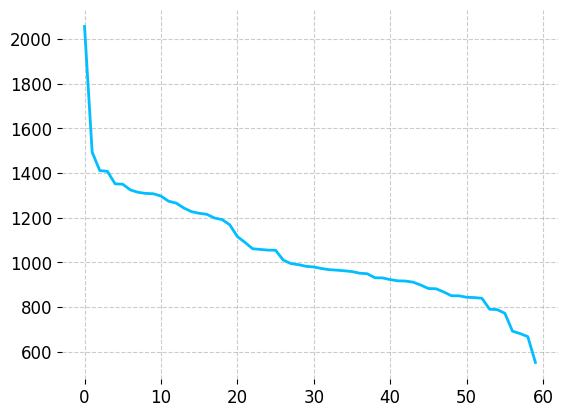

In [3]:


def collect_traj(env, agent, H):
    state_game, state_piece = env.reset()
    rewards = []
    phiX = []
    states = []
    actions = []
    nextstates = []
    for step in range(H):
        states.append(np.array([state_game, state_piece]))
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        state_game, state_piece, reward = env.step(action_pos, action_rot)
        phix = agent.phi(state_game, state_piece, action_pos, action_rot)
        actions.append(np.array([action_pos, action_rot]))
        phiX.append(phix)
        rewards.append(reward)
        nextstates.append(np.array([state_game, state_piece]))
    return np.vstack(phiX), np.vstack(states), np.vstack(actions), np.array(rewards), np.vstack(nextstates)


def collect_regret(env, agent, oracle, H):
    state_game, state_piece = env.reset()
    rewards = []
    oracle_rewards = []
    phiX = []
    states = []
    actions = []
    nextstates = []
    for step in range(H):
        states.append(np.array([state_game, state_piece]))
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        state_game, state_piece, reward = env.step(action_pos, action_rot)
        oracle_action_pos, oracle_action_rot = oracle.select_action(state_game, state_piece)
        _, _, oracle_reward = env.step(oracle_action_pos, oracle_action_rot)
        phix = agent.phi(state_game, state_piece, action_pos, action_rot)
        actions.append(np.array([action_pos, action_rot]))
        phiX.append(phix)
        rewards.append(reward)
        oracle_rewards.append(oracle_reward)
        nextstates.append(np.array([state_game, state_piece]))
    return np.vstack(phiX), np.vstack(states), np.vstack(actions), \
            np.array(rewards), np.array(oracle_rewards), np.vstack(nextstates)

def collect_dataset(env, agent, N, H):
    phiX = []
    rewards = []
    states = []
    actions = []
    nextstates = []
    for n in range(N):
        phi_traj, s_traj, a_traj, r_traj, sp_traj = collect_traj(env, agent, H)
        phiX.append(phi_traj[None,...])
        states.append(s_traj[None,...])
        actions.append(a_traj[None,...])
        nextstates.append(sp_traj[None,...])
        rewards.append(r_traj)
    return np.concatenate(phiX, axis=0), np.concatenate(states, axis=0),\
                np.concatenate(actions, axis=0), np.vstack(rewards), \
                np.concatenate(nextstates, axis=0)

phiX, states, actions, rewards, nextstates = collect_dataset(env, LFAAgent(unif=True), Noff, H)
dim_to_truncate_state_to = 60
Vts = np.linalg.svd(np.vstack(phiX), full_matrices=True)[2]
proj = Vts[:dim_to_truncate_state_to, :]
phiX, states, actions, rewards, nextstates = collect_dataset(env, LFAAgent(unif=True, proj=proj), Noff, H)
d = proj.shape[0]

k = 5
Vts = np.linalg.svd(np.vstack(phiX), full_matrices=True)[2]
projOff = Vts[:k, :].T @ Vts[:k, :]
projOn = np.eye(d) - projOff
plt.plot(np.linalg.eigh(np.vstack(phiX).T @ np.vstack(phiX))[0].T[::-1])
plt.show()

In [4]:
# k = 40
# Vts = np.linalg.svd(phiX.transpose(1,0,2), full_matrices=True)[2]
# # projection to offline partition is k x d. 
# # Offline partition is subspace spanned by top k singular vectors
# # of the offline dataset
# # USV^T, projection is VkVk^T
# projOff = Vts[:,:k,:].transpose(0,2,1) @ Vts[:,:k,:]
# #projOn = Vts[:,k:,:] #
# # I - VkVk^T
# projOn = np.eye(d) - projOff
# plt.plot(np.linalg.eigh(phiX.transpose(0,2,1)@ phiX)[0].T[::-1][:k+10])
# plt.show()

In [ ]:
def lsvi_ac(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, T, 
         stationary=False, proj=proj, k=k, lam=1, ac=True, target_pi=False):
    d = phiX.shape[-1]
    what = np.random.uniform(-1,1,size=d)
    ws = np.zeros((T, H, d))
    n = phiX.shape[0]
    agent = LFAAgent(proj=proj, ac=ac, target_pi=target_pi)
    if ac:
        if target_pi:
            agent.eta = 0.1
        else:
            agent.eta = 1

    oracle = LFAAgent(proj=proj)
    oracle.w = np.load('../hybridlin/data/ws_pess_hy.npy').mean(0)
    oracle_rewards = np.copy(rewards)

    # HOW TO CONSTRUCT POLICY? DO SO BY SUMMING UP Q-FUNCTION ESTIMATES AND RENORMALIZING
    t_last = 0
    det_last = 0
    
    phix = np.vstack(phiX[n-1:])
    phix_full = np.vstack(phiX)
    cov = phix_full.T @ phix_full + 1*np.eye(d)
    for t in tqdm(range(T)):
        agent.t = t # POLICY GRADIENT UPDATE HERE
        
        # rollout under policy induced by w
        phi_traj, s_traj, a_traj, r_traj, or_traj, sp_traj = \
                        collect_regret(env, agent, oracle, H)
        
        print(r_traj.mean())
        
        phiX = np.concatenate([phiX, phi_traj[None,...]], axis=0)
        rewards = np.concatenate([rewards, r_traj[None,...]], axis=0)
        oracle_rewards = np.concatenate([oracle_rewards, or_traj[None,...]], axis=0)
        actions = np.concatenate([actions, a_traj[None,...]], axis=0)
        states = np.concatenate([states, s_traj[None,...]], axis=0)
        nextstates = np.concatenate([nextstates, sp_traj[None,...]], axis=0)

        # bellman backups, save bellman errors
        for h in reversed(range(H)):
            # flatten N, H if MDP close to stationary
            if h != 0:
                continue
            else:
                phi_traj = np.vstack(phi_traj)
                cov += phi_traj.T @ phi_traj
                
                if h == 0:
                    #if ac:
                        #print(np.round(agent.policies[-1],3))
                    det_now = np.sum(np.log(np.linalg.eigvals(cov)))
                    if det_now - det_last > 40*np.log(2) or t==0:
                        print(t, det_now-det_last, 40*np.log(2))
                        agent.w = what
                        agent.t_last = t
                        agent.t = t
                        t_last = t
                        det_last = det_now

                        
                        prec = np.linalg.inv(cov)
                        if target_pi:
                            Qp = np.array([agent.maxQ(sp[0], sp[1],
                                             prec=prec, lam=0.1)[
                                           (lambda a : a[0] * 4 + a[1])(agent.select_action(sp[0], sp[1],
                                             prec=prec, lam=0.1))]
                                for sp in np.vstack(nextstates)]) #prec=prec
                            agent.ws = t/(t+1) * agent.ws + what/(t+1)
                            agent.precs = t/(t+1) * agent.precs + prec/(t+1)
                        else:
                            Qp = np.array([np.max(agent.maxQ(sp[0], sp[1],
                                             prec=prec, lam=0.1))
                                for sp in np.vstack(nextstates)]) #prec=prec
                        phix = np.vstack(phiX[n:])
                        phix_full = np.vstack(phiX)                        
                        what = prec @ phix_full.T @ (rewards.flatten()+Qp)              
                        ws[t,h] = what
        
    return ws, phiX, states, actions, rewards, oracle_rewards, nextstates


def lsvi(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, T, 
         stationary=False, proj=proj, k=k, lam=1):
    d = phiX.shape[-1]
    w = np.random.uniform(-1,1,size=d)
    errs = np.zeros((T, H))
    errs_off = np.zeros((T, H))
    errs_on = np.zeros((T, H))
    ws = np.zeros((T, H, d))
    n = phiX.shape[0]
    agent = LFAAgent(proj=proj)
    
    phix = np.vstack(phiX[n-1:])
    phix_full = np.vstack(phiX)
    cov = phix_full.T @ phix_full + 0.01*np.eye(d)
    for t in tqdm(range(T)):
        # rollout under policy induced by w
        phi_traj, s_traj, a_traj, r_traj, sp_traj = \
                        collect_traj(env, agent, H)
        
        phiX = np.concatenate([phiX, phi_traj[None,...]], axis=0)
        rewards = np.concatenate([rewards, r_traj[None,...]], axis=0)
        actions = np.concatenate([actions, a_traj[None,...]], axis=0)
        states = np.concatenate([states, s_traj[None,...]], axis=0)
        nextstates = np.concatenate([nextstates, sp_traj[None,...]], axis=0)
        
        # bellman backups, save bellman errors
        for h in reversed(range(H)):
            # flatten N, H if MDP close to stationary
            if stationary:
                if h != 0:
                    continue
                else:
                    phi_traj = np.vstack(phi_traj)
                    cov += phi_traj.T @ phi_traj
                    prec = np.linalg.inv(cov)
                    phix = np.vstack(phiX[n:])
                    phix_full = np.vstack(phiX)       
                    Qp = np.array([np.max(agent.maxQ(sp[0], sp[1],
                                                     prec=prec, lam=0.1))
                                    for sp in np.vstack(nextstates)]) #prec=prec
                    w = prec @ phix_full.T @ (rewards.flatten()+Qp)
            agent.w = w
            ws[t,h] = w
            #print('overall', err, 'min', min(err_off, err_on), 'off:', err_off, 'on:', err_on)
            
    return ws, phiX, states, actions, rewards, nextstates


n_trials = 30
rewards_ac_trials = []
rewards_on_trials = []
rewards_pi_trials = []
oracle_rewards_ac_trials = []
oracle_rewards_on_trials = []
oracle_rewards_pi_trials = []
for t in range(n_trials):
    ws_pi, phiX_pi, states_pi, actions_pi, rewards_pi, oracle_rewards_pi, nextstates_pi = \
            lsvi_ac(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 1000, stationary=True, proj = proj, k=k,
                lam=0.1, ac=True, target_pi = True) 
    ws_ac, phiX_ac, states_ac, actions_ac, rewards_ac, oracle_rewards_ac, nextstates_ac = \
            lsvi_ac(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 1000, stationary=True, proj = proj, k=k,
                lam=0.1, ac=True, target_pi = False) 
    ws_on, phiX_on, states_on, actions_on, rewards_on, oracle_rewards_on, nextstates_on = \
            lsvi_ac(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 1000, stationary=True, proj = proj, k=k,
                lam=0.1, ac=False) # LAM WAS 0.1, 7:07pm Feb 29
    rewards_ac_trials.append(rewards_ac)
    rewards_on_trials.append(rewards_on)
    rewards_pi_trials.append(rewards_pi)
    oracle_rewards_ac_trials.append(oracle_rewards_ac)
    oracle_rewards_on_trials.append(oracle_rewards_on)
    oracle_rewards_pi_trials.append(oracle_rewards_pi)
    

  0%|          | 1/1000 [00:00<02:09,  7.74it/s]

-0.75
0 (113.37665368216841+0j) 27.725887222397812
-0.9
-0.625
2 (51.25565154960702+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:06,  7.88it/s]

-0.975
-0.525
-0.625
5 41.57184619085618 27.725887222397812


  1%|          | 9/1000 [00:00<01:30, 10.94it/s]

-0.65
-0.65
-0.575
-0.6
-0.45
10 32.6252581591647 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:48,  9.13it/s]

-0.55
-0.425
-0.475
-0.625
-0.55


  2%|▏         | 17/1000 [00:01<01:23, 11.76it/s]

-0.625
-0.475
17 28.943245552326005 27.725887222397812


  2%|▏         | 22/1000 [00:02<02:05,  7.77it/s]

-0.55
-0.7
-0.475
-0.625
-0.5


  3%|▎         | 28/1000 [00:03<01:18, 12.37it/s]

-0.4
-0.5
-0.375
-0.45
-0.35
-0.45
-0.35
29 27.902417168293084 27.725887222397812


  3%|▎         | 34/1000 [00:04<02:29,  6.46it/s]

-0.175
-0.35
-0.45
-0.475
-0.4


  4%|▍         | 40/1000 [00:04<01:32, 10.41it/s]

-0.525
-0.45
-0.375
-0.4
-0.475


  4%|▍         | 43/1000 [00:04<01:16, 12.56it/s]

-0.6
-0.325
-0.5
-0.525
-0.55


  5%|▍         | 49/1000 [00:05<00:57, 16.60it/s]

-0.2
-0.4
-0.375
-0.625
-0.425
49 28.602693155182124 27.725887222397812


  6%|▌         | 55/1000 [00:07<03:10,  4.97it/s]

-0.55
-0.4
-0.375
-0.425
-0.45


  6%|▌         | 58/1000 [00:07<02:24,  6.52it/s]

-0.25
-0.4
-0.35
-0.4
-0.475


  6%|▋         | 64/1000 [00:07<01:30, 10.37it/s]

-0.45
-0.575
-0.25
-0.425
-0.3


  7%|▋         | 70/1000 [00:08<01:03, 14.58it/s]

-0.2
-0.625
-0.175
-0.45
-0.45


  7%|▋         | 73/1000 [00:08<00:56, 16.49it/s]

-0.425
-0.4
-0.425
-0.5
-0.375


  8%|▊         | 79/1000 [00:08<00:47, 19.57it/s]

-0.175
-0.475
-0.25
-0.475
-0.25
-0.45
-0.35
81 28.25133216072794 27.725887222397812


  8%|▊         | 85/1000 [00:12<04:26,  3.44it/s]

-0.25
-0.475
-0.425
-0.2
-0.35


  9%|▉         | 91/1000 [00:12<02:28,  6.10it/s]

-0.375
-0.35
-0.425
-0.25
-0.45


 10%|▉         | 97/1000 [00:12<01:31,  9.84it/s]

-0.5
-0.375
-0.175
-0.375
-0.325


 10%|█         | 100/1000 [00:12<01:15, 11.94it/s]

-0.25
-0.425
-0.35
-0.475
-0.425


 11%|█         | 106/1000 [00:13<00:55, 16.02it/s]

-0.225
-0.25
-0.375
-0.35
-0.5


 11%|█         | 112/1000 [00:13<00:46, 19.23it/s]

-0.4
-0.325
-0.325
-0.325
-0.175


 12%|█▏        | 115/1000 [00:13<00:43, 20.40it/s]

-0.325
-0.375
-0.525
-0.25
-0.325


 12%|█▏        | 121/1000 [00:13<00:39, 22.01it/s]

-0.275
-0.175
-0.425
-0.275
-0.7


 13%|█▎        | 127/1000 [00:14<00:38, 22.88it/s]

-0.25
-0.35
-0.25
-0.3
-0.325


 13%|█▎        | 130/1000 [00:14<00:37, 23.14it/s]

-0.275
-0.3
-0.25
-0.35
-0.275


 13%|█▎        | 133/1000 [00:14<00:37, 23.33it/s]

-0.325
-0.35
-0.325
134 27.867999330984617 27.725887222397812


 14%|█▍        | 139/1000 [00:20<06:20,  2.26it/s]

-0.375
-0.25
-0.275
-0.5
-0.275


 14%|█▍        | 145/1000 [00:20<03:23,  4.20it/s]

-0.5
-0.35
-0.35
-0.225
-0.3


 15%|█▍        | 148/1000 [00:20<02:32,  5.58it/s]

-0.475
-0.25
-0.325
-0.4
-0.175


 15%|█▌        | 154/1000 [00:20<01:32,  9.15it/s]

-0.175
-0.425
-0.45
-0.4
-0.25


 16%|█▌        | 160/1000 [00:21<01:03, 13.33it/s]

-0.3
-0.4
-0.4
-0.325
-0.35


 16%|█▋        | 163/1000 [00:21<00:54, 15.36it/s]

-0.275
-0.425
-0.325
-0.325
-0.35


 17%|█▋        | 169/1000 [00:21<00:44, 18.74it/s]

-0.65
-0.275
-0.4
-0.375
-0.475


 18%|█▊        | 175/1000 [00:21<00:39, 21.01it/s]

-0.4
-0.3
-0.3
-0.225
-0.3


 18%|█▊        | 178/1000 [00:21<00:37, 21.76it/s]

-0.35
-0.1
-0.275
-0.2
-0.45


 18%|█▊        | 184/1000 [00:22<00:35, 22.76it/s]

-0.225
-0.2
-0.35
-0.35
-0.275


 19%|█▉        | 190/1000 [00:22<00:34, 23.27it/s]

-0.25
-0.45
-0.3
-0.325
-0.2


 19%|█▉        | 193/1000 [00:22<00:34, 23.41it/s]

-0.3
-0.4
-0.275
-0.3
-0.475


 20%|█▉        | 199/1000 [00:22<00:33, 23.58it/s]

-0.4
-0.4
-0.375
-0.275
-0.3


 20%|██        | 205/1000 [00:23<00:33, 23.67it/s]

-0.225
-0.425
-0.325
-0.225
-0.3


 21%|██        | 208/1000 [00:23<00:33, 23.68it/s]

-0.325
-0.275
-0.575
-0.4
-0.225


 21%|██▏       | 214/1000 [00:23<00:33, 23.73it/s]

-0.4
-0.325
-0.375
-0.15
-0.25


 22%|██▏       | 217/1000 [00:23<00:33, 23.73it/s]

-0.3
-0.3
-0.3
217 27.741104759614927 27.725887222397812


 22%|██▏       | 223/1000 [00:33<08:52,  1.46it/s]

-0.375
-0.275
-0.075
-0.3
-0.15


 23%|██▎       | 226/1000 [00:33<06:21,  2.03it/s]

-0.275
-0.275
-0.375
-0.325
-0.3


 23%|██▎       | 232/1000 [00:33<03:21,  3.80it/s]

-0.325
-0.325
-0.275
-0.225
-0.35


 24%|██▍       | 238/1000 [00:33<01:54,  6.65it/s]

-0.55
-0.25
-0.2
-0.25
-0.175


 24%|██▍       | 241/1000 [00:33<01:29,  8.48it/s]

-0.35
-0.4
-0.225
-0.3
-0.225


 25%|██▍       | 247/1000 [00:34<00:59, 12.61it/s]

-0.15
-0.2
-0.325
-0.275
-0.325


 25%|██▌       | 253/1000 [00:34<00:45, 16.56it/s]

-0.25
-0.25
-0.3
-0.2
-0.175


 26%|██▌       | 256/1000 [00:34<00:40, 18.20it/s]

-0.225
-0.425
-0.45
-0.25
-0.375


 26%|██▌       | 262/1000 [00:34<00:35, 20.63it/s]

-0.375
-0.125
-0.325
-0.225
-0.15


 27%|██▋       | 268/1000 [00:34<00:33, 22.07it/s]

-0.275
-0.2
-0.2
-0.475
-0.275


 27%|██▋       | 271/1000 [00:35<00:32, 22.52it/s]

-0.325
-0.25
-0.225
-0.225
-0.25


 28%|██▊       | 277/1000 [00:35<00:31, 23.09it/s]

-0.175
-0.45
-0.4
-0.3
-0.3


 28%|██▊       | 283/1000 [00:35<00:30, 23.40it/s]

-0.45
-0.325
-0.4
-0.375
-0.55


 29%|██▊       | 286/1000 [00:35<00:30, 23.43it/s]

-0.3
-0.3
-0.35
-0.4
-0.325


 29%|██▉       | 292/1000 [00:35<00:30, 23.56it/s]

-0.15
-0.25
-0.425
-0.375
-0.2


 30%|██▉       | 298/1000 [00:36<00:29, 23.53it/s]

-0.2
-0.275
-0.35
-0.225
-0.525


 30%|███       | 301/1000 [00:36<00:29, 23.57it/s]

-0.35
-0.375
-0.325
-0.2
-0.1


 31%|███       | 307/1000 [00:36<00:29, 23.44it/s]

-0.3
-0.25
-0.3
-0.375
-0.25


 31%|███▏      | 313/1000 [00:36<00:29, 23.42it/s]

-0.275
-0.225
-0.1
-0.3
-0.225


 32%|███▏      | 316/1000 [00:36<00:29, 23.50it/s]

-0.3
-0.2
-0.3
-0.225
-0.4


 32%|███▏      | 322/1000 [00:37<00:28, 23.59it/s]

-0.3
-0.4
-0.4
-0.225
-0.35


 33%|███▎      | 328/1000 [00:37<00:28, 23.56it/s]

-0.375
-0.325
-0.3
-0.275
-0.4


 33%|███▎      | 331/1000 [00:37<00:28, 23.54it/s]

-0.325
-0.35
-0.15
-0.3
-0.25


 34%|███▎      | 337/1000 [00:37<00:28, 23.57it/s]

-0.275
-0.25
-0.3
-0.2
-0.2


 34%|███▍      | 343/1000 [00:38<00:27, 23.58it/s]

-0.3
-0.4
-0.325
-0.375
-0.2


 35%|███▍      | 346/1000 [00:38<00:27, 23.58it/s]

-0.2
-0.35
-0.3
-0.275
-0.45


 35%|███▌      | 352/1000 [00:38<00:27, 23.61it/s]

-0.225
-0.175
-0.25
-0.3
-0.125
-0.375
353 27.75878380409813 27.725887222397812


 36%|███▌      | 357/1000 [00:53<12:30,  1.17s/it]

-0.25
-0.375
-0.125
-0.325
-0.25


 36%|███▋      | 363/1000 [00:53<06:05,  1.74it/s]

-0.275
-0.425
-0.3
-0.25
-0.225


 37%|███▋      | 369/1000 [00:54<03:07,  3.36it/s]

-0.1
-0.225
-0.3
-0.3
-0.375


 37%|███▋      | 372/1000 [00:54<02:18,  4.54it/s]

-0.2
-0.175
-0.3
-0.25
-0.125


 38%|███▊      | 378/1000 [00:54<01:20,  7.73it/s]

-0.25
-0.225
-0.175
-0.275
-0.35


 38%|███▊      | 384/1000 [00:54<00:52, 11.72it/s]

-0.45
-0.275
-0.35
-0.2
-0.275


 39%|███▊      | 387/1000 [00:54<00:44, 13.81it/s]

-0.275
-0.2
-0.4
-0.2
-0.225


 39%|███▉      | 393/1000 [00:55<00:34, 17.53it/s]

-0.275
-0.275
-0.2
-0.25
-0.2


 40%|███▉      | 399/1000 [00:55<00:29, 20.19it/s]

-0.4
-0.175
-0.55
-0.2
-0.35


 40%|████      | 402/1000 [00:55<00:28, 21.06it/s]

-0.2
-0.2
-0.35
-0.225
-0.375


 41%|████      | 408/1000 [00:55<00:26, 22.24it/s]

-0.175
-0.175
-0.3
-0.15
-0.4


 41%|████▏     | 414/1000 [00:56<00:25, 22.78it/s]

-0.125
-0.275
-0.4
-0.4
-0.25


 42%|████▏     | 417/1000 [00:56<00:25, 22.90it/s]

-0.35
-0.15
-0.125
-0.2
-0.125


 42%|████▏     | 423/1000 [00:56<00:24, 23.21it/s]

-0.375
-0.375
-0.1
-0.175
-0.325


 43%|████▎     | 429/1000 [00:56<00:24, 23.36it/s]

-0.25
-0.3
-0.3
-0.225
-0.375


 43%|████▎     | 432/1000 [00:56<00:24, 23.42it/s]

-0.375
-0.225
-0.325
-0.275
-0.375


 44%|████▍     | 438/1000 [00:57<00:23, 23.53it/s]

-0.325
-0.3
-0.325
-0.5
-0.325


 44%|████▍     | 444/1000 [00:57<00:23, 23.58it/s]

-0.325
-0.3
-0.15
-0.25
-0.15


 45%|████▍     | 447/1000 [00:57<00:23, 23.57it/s]

-0.425
-0.375
-0.2
-0.275
-0.225


 45%|████▌     | 453/1000 [00:57<00:23, 23.56it/s]

-0.25
-0.3
-0.25
-0.175
-0.2


 46%|████▌     | 459/1000 [00:58<00:22, 23.57it/s]

-0.35
-0.15
-0.175
-0.3
-0.375


 46%|████▌     | 462/1000 [00:58<00:22, 23.57it/s]

-0.25
-0.425
-0.225
-0.275
-0.3


 47%|████▋     | 468/1000 [00:58<00:22, 23.60it/s]

-0.15
-0.35
-0.25
-0.325
-0.225


 47%|████▋     | 474/1000 [00:58<00:22, 23.59it/s]

-0.3
-0.225
-0.2
-0.15
-0.275


 48%|████▊     | 477/1000 [00:58<00:22, 23.57it/s]

-0.275
-0.1
-0.425
-0.4
-0.4


 48%|████▊     | 483/1000 [00:59<00:21, 23.59it/s]

-0.475
-0.25
-0.375
-0.05
-0.35


 49%|████▉     | 489/1000 [00:59<00:21, 23.56it/s]

-0.3
-0.425
-0.375
-0.225
-0.225


 49%|████▉     | 492/1000 [00:59<00:21, 23.56it/s]

-0.15
-0.125
-0.175
-0.3
-0.425


 50%|████▉     | 498/1000 [00:59<00:21, 23.57it/s]

-0.325
-0.225
-0.475
-0.3
-0.15


 50%|█████     | 504/1000 [00:59<00:21, 23.58it/s]

-0.175
-0.3
-0.4
-0.375
-0.1


 51%|█████     | 507/1000 [01:00<00:20, 23.51it/s]

-0.4
-0.425
-0.4
-0.325
-0.525


 51%|█████▏    | 513/1000 [01:00<00:20, 23.52it/s]

-0.2
-0.2
-0.2
-0.4
-0.2


 52%|█████▏    | 519/1000 [01:00<00:20, 23.54it/s]

-0.4
-0.2
-0.275
-0.1
-0.3


 52%|█████▏    | 522/1000 [01:00<00:20, 23.55it/s]

-0.275
-0.25
-0.2
-0.3
-0.225


 53%|█████▎    | 528/1000 [01:00<00:20, 23.58it/s]

-0.25
-0.225
-0.1
-0.2
-0.3


 53%|█████▎    | 534/1000 [01:01<00:19, 23.59it/s]

-0.1
-0.3
-0.325
-0.275
-0.075


 54%|█████▎    | 537/1000 [01:01<00:19, 23.53it/s]

-0.3
-0.175
-0.35
-0.2
-0.425


 54%|█████▍    | 543/1000 [01:01<00:19, 23.52it/s]

-0.3
-0.325
-0.3
-0.425
-0.325


 55%|█████▍    | 549/1000 [01:01<00:19, 23.50it/s]

-0.275
-0.3
-0.2
-0.475
-0.425


 55%|█████▌    | 552/1000 [01:01<00:19, 23.49it/s]

-0.225
-0.225
-0.25
-0.3
-0.275


 56%|█████▌    | 558/1000 [01:02<00:18, 23.48it/s]

-0.225
-0.325
-0.3
-0.175
-0.1


 56%|█████▋    | 564/1000 [01:02<00:18, 23.49it/s]

-0.275
-0.225
-0.3
-0.25
-0.35


 57%|█████▋    | 567/1000 [01:02<00:18, 23.49it/s]

-0.35
-0.375
-0.4
-0.3
-0.225


 57%|█████▋    | 570/1000 [01:02<00:18, 23.48it/s]

-0.275
-0.175
570 27.749026447913536 27.725887222397812


 57%|█████▋    | 574/1000 [01:26<14:11,  2.00s/it]

-0.25
-0.3
-0.325
-0.225
-0.225


 58%|█████▊    | 580/1000 [01:27<06:29,  1.08it/s]

-0.1
-0.25
-0.225
-0.225
-0.375


 59%|█████▊    | 586/1000 [01:27<03:10,  2.17it/s]

-0.225
-0.275
-0.225
-0.325
-0.3


 59%|█████▉    | 589/1000 [01:27<02:16,  3.01it/s]

-0.2
-0.2
-0.175
-0.3
-0.2


 60%|█████▉    | 595/1000 [01:27<01:14,  5.47it/s]

-0.325
-0.15
-0.05
-0.3
-0.275


 60%|██████    | 601/1000 [01:28<00:44,  9.02it/s]

-0.375
-0.275
-0.275
-0.175
-0.1


 60%|██████    | 604/1000 [01:28<00:35, 11.06it/s]

-0.125
-0.325
-0.275
-0.225
-0.375


 61%|██████    | 610/1000 [01:28<00:25, 15.16it/s]

-0.225
-0.275
-0.3
-0.325
-0.325


 62%|██████▏   | 616/1000 [01:28<00:20, 18.49it/s]

-0.325
-0.175
-0.25
-0.35
-0.375


 62%|██████▏   | 619/1000 [01:28<00:19, 19.75it/s]

-0.35
-0.275
-0.2
-0.3
-0.4


 62%|██████▎   | 625/1000 [01:29<00:17, 21.47it/s]

-0.25
-0.225
-0.175
-0.05
-0.275


 63%|██████▎   | 631/1000 [01:29<00:16, 22.45it/s]

-0.4
-0.25
-0.25
-0.3
-0.375


 63%|██████▎   | 634/1000 [01:29<00:16, 22.73it/s]

-0.2
-0.4
-0.25
-0.25
-0.3


 64%|██████▍   | 640/1000 [01:29<00:15, 23.06it/s]

-0.225
-0.5
-0.275
-0.225
-0.4


 65%|██████▍   | 646/1000 [01:30<00:15, 23.18it/s]

-0.225
-0.3
-0.2
-0.15
-0.25


 65%|██████▍   | 649/1000 [01:30<00:15, 23.25it/s]

-0.325
-0.075
-0.275
-0.225
-0.25


 66%|██████▌   | 655/1000 [01:30<00:14, 23.35it/s]

-0.225
-0.175
-0.175
-0.35
-0.275


 66%|██████▌   | 661/1000 [01:30<00:14, 23.38it/s]

-0.175
-0.2
-0.075
-0.525
-0.125


 66%|██████▋   | 664/1000 [01:30<00:14, 23.37it/s]

-0.3
-0.275
-0.275
-0.275
-0.275


 67%|██████▋   | 670/1000 [01:31<00:14, 23.39it/s]

-0.375
-0.225
-0.35
-0.15
-0.275


 68%|██████▊   | 676/1000 [01:31<00:13, 23.39it/s]

-0.325
-0.375
-0.275
-0.25
-0.3


 68%|██████▊   | 679/1000 [01:31<00:13, 23.40it/s]

-0.125
-0.425
-0.4
-0.075
-0.35


 68%|██████▊   | 685/1000 [01:31<00:13, 23.43it/s]

-0.175
-0.175
-0.175
-0.325
-0.4


 69%|██████▉   | 691/1000 [01:31<00:13, 23.45it/s]

-0.325
-0.25
-0.275
-0.425
-0.175


 69%|██████▉   | 694/1000 [01:32<00:13, 23.41it/s]

-0.3
-0.125
-0.3
-0.2
-0.375


 70%|███████   | 700/1000 [01:32<00:12, 23.38it/s]

-0.2
-0.2
-0.2
-0.275
-0.325


 71%|███████   | 706/1000 [01:32<00:12, 23.43it/s]

-0.4
-0.3
-0.125
-0.2
-0.2


 71%|███████   | 709/1000 [01:32<00:12, 23.44it/s]

-0.3
-0.25
-0.3
-0.125
-0.3


 72%|███████▏  | 715/1000 [01:32<00:12, 23.45it/s]

-0.175
-0.25
-0.2
-0.325
-0.125


 72%|███████▏  | 721/1000 [01:33<00:11, 23.47it/s]

-0.45
-0.2
-0.25
-0.175
-0.425


 72%|███████▏  | 724/1000 [01:33<00:11, 23.46it/s]

-0.225
-0.2
-0.4
-0.3
-0.475


 73%|███████▎  | 730/1000 [01:33<00:11, 23.46it/s]

-0.275
-0.3
-0.35
-0.225
-0.175


 74%|███████▎  | 736/1000 [01:33<00:11, 23.46it/s]

-0.1
-0.2
-0.325
-0.15
-0.225


 74%|███████▍  | 739/1000 [01:33<00:11, 23.44it/s]

-0.35
-0.3
-0.125
-0.425
-0.45


 74%|███████▍  | 745/1000 [01:34<00:10, 23.43it/s]

-0.275
-0.175
-0.275
-0.175
-0.15


 75%|███████▌  | 751/1000 [01:34<00:10, 23.40it/s]

-0.2
-0.375
-0.175
-0.225
-0.325


 75%|███████▌  | 754/1000 [01:34<00:10, 23.36it/s]

-0.2
-0.25
-0.2
-0.15
-0.225


 76%|███████▌  | 760/1000 [01:34<00:10, 23.35it/s]

-0.15
-0.35
-0.225
-0.375
-0.35


 77%|███████▋  | 766/1000 [01:35<00:10, 23.18it/s]

-0.2
-0.25
-0.25
-0.05
-0.275


 77%|███████▋  | 769/1000 [01:35<00:09, 23.18it/s]

-0.3
-0.425
-0.175
-0.1
-0.3


 78%|███████▊  | 775/1000 [01:35<00:09, 23.32it/s]

-0.15
-0.25
-0.175
-0.2
-0.4


 78%|███████▊  | 781/1000 [01:35<00:09, 23.36it/s]

-0.3
-0.325
-0.15
-0.25
-0.1


 78%|███████▊  | 784/1000 [01:35<00:09, 23.35it/s]

-0.275
-0.2
-0.175
-0.3
-0.4


 79%|███████▉  | 790/1000 [01:36<00:08, 23.38it/s]

-0.25
-0.325
-0.45
-0.25
-0.125


 80%|███████▉  | 796/1000 [01:36<00:08, 23.41it/s]

-0.125
-0.175
-0.275
-0.15
-0.325


 80%|███████▉  | 799/1000 [01:36<00:08, 23.39it/s]

-0.3
-0.125
-0.375
-0.1
-0.2


 80%|████████  | 805/1000 [01:36<00:08, 23.37it/s]

-0.325
-0.275
-0.375
-0.075
-0.175


 81%|████████  | 811/1000 [01:37<00:08, 23.41it/s]

-0.075
-0.15
-0.2
-0.35
-0.15


 81%|████████▏ | 814/1000 [01:37<00:07, 23.41it/s]

-0.125
-0.275
-0.175
-0.1
-0.1


 82%|████████▏ | 820/1000 [01:37<00:07, 23.42it/s]

-0.175
-0.25
-0.275
-0.325
-0.225


 83%|████████▎ | 826/1000 [01:37<00:07, 23.41it/s]

-0.15
-0.25
-0.15
-0.225
-0.075


 83%|████████▎ | 829/1000 [01:37<00:07, 23.40it/s]

-0.2
-0.175
-0.2
-0.275
-0.3


 84%|████████▎ | 835/1000 [01:38<00:07, 23.41it/s]

-0.225
-0.25
-0.275
-0.5
-0.2


 84%|████████▍ | 841/1000 [01:38<00:06, 23.42it/s]

-0.25
-0.25
-0.35
-0.275
-0.3


 84%|████████▍ | 844/1000 [01:38<00:06, 23.40it/s]

-0.325
-0.175
-0.25
-0.3
-0.35


 85%|████████▌ | 850/1000 [01:38<00:06, 23.40it/s]

-0.025
-0.4
-0.125
-0.225
-0.1


 86%|████████▌ | 856/1000 [01:38<00:06, 23.39it/s]

-0.175
-0.2
-0.25
-0.275
-0.325


 86%|████████▌ | 859/1000 [01:39<00:06, 23.37it/s]

-0.3
-0.275
-0.225
-0.325
-0.1


 86%|████████▋ | 865/1000 [01:39<00:05, 23.34it/s]

-0.325
-0.1
-0.275
-0.225
-0.3


 87%|████████▋ | 871/1000 [01:39<00:05, 23.37it/s]

-0.225
-0.1
-0.275
-0.275
-0.25


 87%|████████▋ | 874/1000 [01:39<00:05, 23.36it/s]

-0.2
-0.225
-0.2
-0.15
-0.175


 88%|████████▊ | 880/1000 [01:40<00:05, 23.36it/s]

-0.35
-0.125
-0.1
-0.4
-0.1


 89%|████████▊ | 886/1000 [01:40<00:04, 23.35it/s]

-0.225
-0.3
-0.325
-0.25
-0.175


 89%|████████▉ | 889/1000 [01:40<00:04, 23.35it/s]

-0.375
-0.175
-0.25
-0.25
-0.3


 90%|████████▉ | 895/1000 [01:40<00:04, 23.31it/s]

-0.35
-0.325
-0.075
-0.05
-0.075


 90%|█████████ | 901/1000 [01:40<00:04, 23.36it/s]

-0.425
-0.125
-0.375
-0.275
-0.2


 90%|█████████ | 904/1000 [01:41<00:04, 23.36it/s]

-0.225
-0.375
-0.4
-0.15
-0.15


 91%|█████████ | 910/1000 [01:41<00:03, 23.39it/s]

-0.225
-0.3
-0.275
-0.225
-0.225
-0.125
-0.4
912 27.794634011905885 27.725887222397812


 92%|█████████▏| 916/1000 [02:20<03:49,  2.74s/it]

-0.275
-0.325
-0.1
-0.1
-0.2


 92%|█████████▏| 922/1000 [02:20<01:46,  1.36s/it]

-0.225
-0.225
-0.175
-0.3
-0.2


 93%|█████████▎| 928/1000 [02:20<00:49,  1.45it/s]

-0.275
-0.3
-0.275
-0.4
-0.275


 93%|█████████▎| 931/1000 [02:20<00:34,  2.02it/s]

-0.1
-0.225
-0.3
-0.25
-0.275


 94%|█████████▎| 937/1000 [02:20<00:16,  3.78it/s]

-0.275
-0.3
-0.225
-0.2
-0.25


 94%|█████████▍| 943/1000 [02:21<00:08,  6.59it/s]

-0.275
-0.275
-0.375
-0.175
-0.325


 95%|█████████▍| 946/1000 [02:21<00:06,  8.40it/s]

-0.3
-0.3
-0.275
-0.2
-0.2


 95%|█████████▌| 952/1000 [02:21<00:03, 12.46it/s]

-0.25
-0.35
-0.35
-0.225
-0.35


 96%|█████████▌| 958/1000 [02:21<00:02, 16.30it/s]

-0.15
-0.2
-0.225
-0.275
-0.425


 96%|█████████▌| 961/1000 [02:21<00:02, 17.90it/s]

-0.375
-0.075
-0.175
-0.325
-0.2


 97%|█████████▋| 967/1000 [02:22<00:01, 20.30it/s]

-0.2
-0.325
-0.3
-0.2
-0.225


 97%|█████████▋| 973/1000 [02:22<00:01, 21.73it/s]

-0.3
-0.275
-0.35
-0.25
-0.25


 98%|█████████▊| 976/1000 [02:22<00:01, 22.17it/s]

-0.175
-0.25
-0.3
-0.15
-0.275


 98%|█████████▊| 982/1000 [02:22<00:00, 22.74it/s]

-0.4
-0.225
-0.45
-0.275
-0.325


 99%|█████████▉| 988/1000 [02:23<00:00, 22.99it/s]

-0.25
-0.225
-0.25
-0.175
-0.175


 99%|█████████▉| 991/1000 [02:23<00:00, 23.03it/s]

-0.15
-0.275
-0.175
-0.35
-0.2


100%|█████████▉| 997/1000 [02:23<00:00, 23.16it/s]

-0.225
-0.275
-0.2
-0.4
-0.3


100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s]


-0.225
-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.525
0 (102.44076563488555+0j) 27.725887222397812
-0.725
1 (34.71178975748664+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:31, 10.85it/s]

-0.625


  0%|          | 4/1000 [00:00<01:31, 10.84it/s]

-0.875
3 (43.26844238642974+0j) 27.725887222397812
-0.85
-0.825
-0.975
6 32.711770094479135 27.725887222397812


  1%|          | 10/1000 [00:00<01:10, 14.07it/s]

-0.775
-0.85
-0.85
-0.7
-1.15
11 29.09001272836781 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:16, 12.80it/s]

-0.525
-0.95
-0.775
-0.925
-0.975


  2%|▏         | 18/1000 [00:01<01:04, 15.34it/s]

-0.85
-0.7
-0.825
19 27.762120674901155 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:25, 11.38it/s]

-0.875
-0.775
-0.675
-0.825
-1.15


  3%|▎         | 29/1000 [00:02<01:00, 15.96it/s]

-1.125
-0.8
-0.85
-0.75
-0.925


  3%|▎         | 32/1000 [00:02<00:54, 17.81it/s]

-1.175
-0.875
-0.95
-1.05
33 28.986579503708185 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:35, 10.06it/s]

-0.85
-0.65
-0.7
-1.025
-0.85


  4%|▍         | 44/1000 [00:03<01:06, 14.34it/s]

-1.0
-0.9
-0.8
-1.25
-0.825


  5%|▍         | 47/1000 [00:03<00:58, 16.28it/s]

-0.85
-1.15
-1.0
-0.75
-0.675


  5%|▌         | 53/1000 [00:03<00:48, 19.40it/s]

-0.75
-1.1
-0.7
-0.95
-1.025


  6%|▌         | 56/1000 [00:04<00:46, 20.50it/s]

-0.8
-1.15
-0.8
-1.0
-0.975
58 28.204176294990873 27.725887222397812


  6%|▌         | 62/1000 [00:05<02:02,  7.68it/s]

-0.8
-0.65
-0.75
-0.85
-0.25


  7%|▋         | 68/1000 [00:05<01:19, 11.73it/s]

-0.575
-0.925
-0.65
-0.875
-0.8


  7%|▋         | 74/1000 [00:06<00:58, 15.79it/s]

-0.85
-0.5
-1.075
-0.675
-0.9


  8%|▊         | 77/1000 [00:06<00:52, 17.52it/s]

-0.9
-0.8
-0.9
-0.8
-0.725


  8%|▊         | 83/1000 [00:06<00:45, 20.22it/s]

-0.825
-0.95
-1.05
-0.9
-0.675
-0.875
-0.725
85 28.12227149959824 27.725887222397812


  9%|▉         | 89/1000 [00:08<02:33,  5.93it/s]

-0.475
-0.725
-0.75
-0.575
-0.675


 10%|▉         | 95/1000 [00:08<01:34,  9.60it/s]

-0.625
-0.7
-0.675
-0.4
-0.6


 10%|█         | 101/1000 [00:08<01:05, 13.79it/s]

-0.625
-0.775
-0.5
-0.525
-0.5


 10%|█         | 104/1000 [00:09<00:56, 15.75it/s]

-0.55
-0.55
-0.625
-0.525
-0.325


 11%|█         | 110/1000 [00:09<00:47, 18.88it/s]

-0.525
-0.75
-0.55
-0.475
-0.525


 12%|█▏        | 116/1000 [00:09<00:41, 21.05it/s]

-0.65
-0.6
-0.675
-0.475
-0.55


 12%|█▏        | 119/1000 [00:09<00:40, 21.72it/s]

-0.6
-0.775
-0.5
-0.65
-0.8


 12%|█▎        | 125/1000 [00:09<00:38, 22.56it/s]

-0.775
-0.675
-0.8
-0.5
-0.55


 13%|█▎        | 131/1000 [00:10<00:37, 23.16it/s]

-0.6
-0.3
-0.575
-0.8
-0.55
-0.525
-0.9
-0.425
133 28.072268559152633 27.725887222397812


 14%|█▎        | 137/1000 [00:13<03:20,  4.29it/s]

-0.5
-0.6
-0.5
-0.625
-0.45


 14%|█▍        | 143/1000 [00:13<01:56,  7.38it/s]

-0.475
-0.35
-0.375
-0.65
-0.2


 15%|█▍        | 149/1000 [00:13<01:14, 11.37it/s]

-0.4
-0.375
-0.4
-0.5
-0.25


 15%|█▌        | 152/1000 [00:13<01:03, 13.44it/s]

-0.425
-0.625
-0.675
-0.675
-0.4


 16%|█▌        | 158/1000 [00:14<00:48, 17.27it/s]

-0.575
-0.375
-0.4
-0.55
-0.4


 16%|█▋        | 164/1000 [00:14<00:41, 20.03it/s]

-0.375
-0.475
-0.65
-0.375
-0.575


 17%|█▋        | 167/1000 [00:14<00:39, 20.99it/s]

-0.375
-0.575
-0.4
-0.825
-0.45


 17%|█▋        | 173/1000 [00:14<00:37, 22.32it/s]

-0.45
-0.8
-0.425
-0.45
-0.425


 18%|█▊        | 179/1000 [00:14<00:35, 22.99it/s]

-0.7
-0.275
-0.725
-0.275
-0.475


 18%|█▊        | 182/1000 [00:15<00:35, 23.19it/s]

-0.2
-0.675
-0.5
-0.6
-0.5


 19%|█▉        | 188/1000 [00:15<00:34, 23.49it/s]

-0.7
-0.425
-0.5
-0.45
-0.55


 19%|█▉        | 194/1000 [00:15<00:34, 23.60it/s]

-0.775
-0.625
-0.425
-0.4
-0.625


 20%|█▉        | 197/1000 [00:15<00:34, 23.60it/s]

-0.45
-0.375
-0.475
-0.4
-0.4


 20%|██        | 203/1000 [00:15<00:33, 23.69it/s]

-0.4
-0.4
-0.45
-0.5
-0.55


 21%|██        | 209/1000 [00:16<00:33, 23.67it/s]

-0.5
-0.425
-0.3
-0.475
-0.375


 21%|██        | 212/1000 [00:16<00:33, 23.61it/s]

-0.525
-0.55
-0.55
-0.575
-0.575


 22%|██▏       | 218/1000 [00:16<00:33, 23.67it/s]

-0.375
-0.475
-0.775
-0.275
-0.225
218 27.79998260219554 27.725887222397812


 22%|██▏       | 224/1000 [00:21<04:34,  2.83it/s]

-0.375
-0.55
-0.75
-0.55
-0.55


 23%|██▎       | 227/1000 [00:21<03:21,  3.84it/s]

-0.525
-0.525
-0.425
-0.775
-0.4


 23%|██▎       | 233/1000 [00:21<01:54,  6.71it/s]

-0.575
-0.525
-0.425
-0.5
-0.45


 24%|██▍       | 239/1000 [00:21<01:11, 10.58it/s]

-0.5
-0.35
-0.375
-0.3
-0.45


 24%|██▍       | 242/1000 [00:22<00:59, 12.68it/s]

-0.375
-0.6
-0.3
-0.5
-0.45


 25%|██▍       | 248/1000 [00:22<00:45, 16.64it/s]

-0.475
-0.4
-0.55
-0.25
-0.325


 25%|██▌       | 254/1000 [00:22<00:38, 19.60it/s]

-0.6
-0.525
-0.525
-0.55
-0.425


 26%|██▌       | 257/1000 [00:22<00:36, 20.60it/s]

-0.5
-0.325
-0.45
-0.475
-0.4


 26%|██▋       | 263/1000 [00:22<00:33, 22.06it/s]

-0.625
-0.3
-0.225
-0.525
-0.325


 27%|██▋       | 269/1000 [00:23<00:31, 22.86it/s]

-0.325
-0.45
-0.4
-0.325
-0.4


 27%|██▋       | 272/1000 [00:23<00:31, 23.07it/s]

-0.65
-0.275
-0.125
-0.3
-0.475


 28%|██▊       | 278/1000 [00:23<00:30, 23.35it/s]

-0.775
-0.4
-0.375
-0.25
-0.525


 28%|██▊       | 284/1000 [00:23<00:30, 23.33it/s]

-0.4
-0.575
-0.45
-0.6
-0.375


 29%|██▊       | 287/1000 [00:24<00:30, 23.42it/s]

-0.35
-0.375
-0.375
-0.475
-0.275


 29%|██▉       | 293/1000 [00:24<00:30, 23.53it/s]

-0.475
-0.6
-0.475
-0.575
-0.375


 30%|██▉       | 299/1000 [00:24<00:29, 23.51it/s]

-0.375
-0.225
-0.375
-0.575
-0.225


 30%|███       | 302/1000 [00:24<00:29, 23.51it/s]

-0.3
-0.25
-0.525
-0.225
-0.5


 31%|███       | 308/1000 [00:24<00:29, 23.58it/s]

-0.5
-0.575
-0.5
-0.425
-0.275


 31%|███▏      | 314/1000 [00:25<00:29, 23.62it/s]

-0.425
-0.4
-0.5
-0.625
-0.325


 32%|███▏      | 317/1000 [00:25<00:28, 23.63it/s]

-0.225
-0.575
-0.375
-0.4
-0.55


 32%|███▏      | 323/1000 [00:25<00:28, 23.59it/s]

-0.475
-0.425
-0.275
-0.375
-0.325


 33%|███▎      | 329/1000 [00:25<00:28, 23.55it/s]

-0.425
-0.65
-0.5
-0.45
-0.525


 33%|███▎      | 332/1000 [00:25<00:28, 23.53it/s]

-0.575
-0.4
-0.55
-0.525
-0.325


 34%|███▍      | 338/1000 [00:26<00:28, 23.56it/s]

-0.325
-0.525
-0.35
-0.35
-0.5


 34%|███▍      | 344/1000 [00:26<00:27, 23.55it/s]

-0.6
-0.55
-0.175
-0.55
-0.3


 35%|███▍      | 347/1000 [00:26<00:27, 23.52it/s]

-0.125
-0.575
-0.2
-0.5
-0.4


 35%|███▌      | 353/1000 [00:26<00:27, 23.54it/s]

-0.525
-0.575
-0.575
-0.5
-0.675


 36%|███▌      | 359/1000 [00:27<00:27, 23.48it/s]

-0.3
-0.45
-0.425
-0.45
-0.3


 36%|███▌      | 362/1000 [00:27<00:27, 23.46it/s]

-0.45
-0.45
-0.625
-0.675
-0.3


 37%|███▋      | 368/1000 [00:27<00:26, 23.54it/s]

-0.525
-0.525
-0.575
-0.4
-0.55


 37%|███▋      | 374/1000 [00:27<00:26, 23.56it/s]

-0.425
-0.375
-0.475
-0.525
-0.3


 38%|███▊      | 377/1000 [00:27<00:26, 23.44it/s]

-0.65
-0.45
-0.35
-0.5
-0.475
-0.55
379 27.853851022696517 27.725887222397812


 38%|███▊      | 383/1000 [00:35<05:58,  1.72it/s]

-0.55
-0.675
-0.85
-0.4
-0.6


 39%|███▉      | 389/1000 [00:36<03:07,  3.26it/s]

-0.55
-0.575
-0.525
-0.375
-0.425


 40%|███▉      | 395/1000 [00:36<01:44,  5.81it/s]

-0.575
-0.625
-0.375
-0.225
-0.45


 40%|███▉      | 398/1000 [00:36<01:20,  7.51it/s]

-0.55
-0.475
-0.425
-0.375
-0.375


 40%|████      | 404/1000 [00:36<00:51, 11.51it/s]

-0.5
-0.325
-0.2
-0.575
-0.375


 41%|████      | 410/1000 [00:36<00:37, 15.55it/s]

-0.475
-0.45
-0.475
-0.45
-0.6


 41%|████▏     | 413/1000 [00:37<00:33, 17.30it/s]

-0.575
-0.45
-0.3
-0.275
-0.575


 42%|████▏     | 419/1000 [00:37<00:28, 20.04it/s]

-0.6
-0.5
-0.475
-0.45
-0.2


 42%|████▎     | 425/1000 [00:37<00:26, 21.69it/s]

-0.45
-0.45
-0.3
-0.55
-0.625


 43%|████▎     | 428/1000 [00:37<00:25, 22.18it/s]

-0.65
-0.55
-0.575
-0.275
-0.275


 43%|████▎     | 434/1000 [00:37<00:24, 22.86it/s]

-0.475
-0.35
-0.5
-0.6
-0.425


 44%|████▍     | 440/1000 [00:38<00:24, 23.14it/s]

-0.525
-0.275
-0.55
-0.5
-0.775


 44%|████▍     | 443/1000 [00:38<00:24, 23.19it/s]

-0.525
-0.45
-0.475
-0.525
-0.475


 45%|████▍     | 449/1000 [00:38<00:23, 23.38it/s]

-0.175
-0.55
-0.45
-0.625
-0.25


 46%|████▌     | 455/1000 [00:38<00:23, 23.42it/s]

-0.425
-0.475
-0.4
-0.6
-0.65


 46%|████▌     | 458/1000 [00:38<00:23, 23.46it/s]

-0.725
-0.625
-0.4
-0.5
-0.45


 46%|████▋     | 464/1000 [00:39<00:22, 23.47it/s]

-0.375
-0.7
-0.625
-0.4
-0.475


 47%|████▋     | 470/1000 [00:39<00:22, 23.52it/s]

-0.5
-0.45
-0.5
-0.6
-0.4


 47%|████▋     | 473/1000 [00:39<00:22, 23.50it/s]

-0.375
-0.45
-0.4
-0.575
-0.525


 48%|████▊     | 479/1000 [00:39<00:22, 23.56it/s]

-0.425
-0.375
-0.55
-0.625
-0.45


 48%|████▊     | 485/1000 [00:40<00:21, 23.53it/s]

-0.6
-0.75
-0.5
-0.3
-0.4


 49%|████▉     | 488/1000 [00:40<00:21, 23.46it/s]

-0.6
-0.45
-0.425
-0.525
-0.4


 49%|████▉     | 494/1000 [00:40<00:21, 23.53it/s]

-0.45
-0.75
-0.65
-0.5
-0.275


 50%|█████     | 500/1000 [00:40<00:21, 23.52it/s]

-0.35
-0.8
-0.575
-0.55
-0.575


 50%|█████     | 503/1000 [00:40<00:21, 23.49it/s]

-0.625
-0.375
-0.45
-0.525
-0.575


 51%|█████     | 509/1000 [00:41<00:20, 23.51it/s]

-0.3
-0.5
-0.675
-0.45
-0.35


 52%|█████▏    | 515/1000 [00:41<00:20, 23.55it/s]

-0.55
-0.5
-0.575
-0.45
-0.5


 52%|█████▏    | 518/1000 [00:41<00:20, 23.54it/s]

-0.7
-0.5
-0.625
-0.65
-0.325


 52%|█████▏    | 524/1000 [00:41<00:20, 23.54it/s]

-0.525
-0.4
-0.675
-0.55
-0.475


 53%|█████▎    | 530/1000 [00:42<00:19, 23.50it/s]

-0.375
-0.425
-0.525
-0.45
-0.425


 53%|█████▎    | 533/1000 [00:42<00:19, 23.51it/s]

-0.6
-0.5
-0.375
-0.3
-0.425


 54%|█████▍    | 539/1000 [00:42<00:19, 23.54it/s]

-0.525
-0.625
-0.375
-0.55
-0.575


 55%|█████▍    | 545/1000 [00:42<00:19, 23.50it/s]

-0.45
-0.5
-0.55
-0.55
-0.35


 55%|█████▍    | 548/1000 [00:42<00:19, 23.42it/s]

-0.525
-0.55
-0.625
-0.5
-0.325


 55%|█████▌    | 554/1000 [00:43<00:19, 23.46it/s]

-0.375
-0.35
-0.575
-0.575
-0.35


 56%|█████▌    | 560/1000 [00:43<00:18, 23.43it/s]

-0.725
-0.425
-0.425
-0.45
-0.525


 56%|█████▋    | 563/1000 [00:43<00:18, 23.39it/s]

-0.35
-0.4
-0.525
-0.5
-0.575


 57%|█████▋    | 569/1000 [00:43<00:18, 23.47it/s]

-0.575
-0.5
-0.375
-0.5
-0.45


 57%|█████▊    | 575/1000 [00:43<00:18, 23.49it/s]

-0.35
-0.55
-0.3
-0.3
-0.375


 58%|█████▊    | 578/1000 [00:44<00:17, 23.49it/s]

-0.575
-0.55
-0.55
-0.75
-0.55


 58%|█████▊    | 584/1000 [00:44<00:17, 23.50it/s]

-0.475
-0.4
-0.3
-0.425
-0.525


 59%|█████▉    | 590/1000 [00:44<00:17, 23.53it/s]

-0.575
-0.55
-0.5
-0.575
-0.525


 59%|█████▉    | 593/1000 [00:44<00:17, 23.53it/s]

-0.375
-0.5
-0.375
-0.725
-0.5


 60%|█████▉    | 599/1000 [00:44<00:17, 23.55it/s]

-0.45
-0.425
-0.5
-0.575
-0.475


 60%|██████    | 602/1000 [00:45<00:16, 23.54it/s]

-0.775
-0.45
-0.55
-0.4
-0.45
604 27.829432597384823 27.725887222397812


 61%|██████    | 608/1000 [00:57<05:52,  1.11it/s]

-0.575
-0.75
-0.575
-0.65
-0.475


 61%|██████▏   | 614/1000 [00:57<02:58,  2.16it/s]

-0.375
-0.55
-0.7
-0.55
-0.325


 62%|██████▏   | 620/1000 [00:58<01:34,  4.03it/s]

-0.3
-0.3
-0.425
-0.3
-0.475


 62%|██████▏   | 623/1000 [00:58<01:10,  5.36it/s]

-0.425
-0.375
-0.35
-0.375
-0.425


 63%|██████▎   | 629/1000 [00:58<00:41,  8.84it/s]

-0.325
-0.65
-0.325
-0.5
-0.25


 64%|██████▎   | 635/1000 [00:58<00:28, 12.97it/s]

-0.25
-0.375
-0.475
-0.45
-0.225


 64%|██████▍   | 638/1000 [00:58<00:24, 14.98it/s]

-0.475
-0.45
-0.4
-0.4
-0.425


 64%|██████▍   | 644/1000 [00:59<00:19, 18.37it/s]

-0.375
-0.325
-0.325
-0.325
-0.4


 65%|██████▌   | 650/1000 [00:59<00:16, 20.66it/s]

-0.625
-0.275
-0.425
-0.275
-0.625


 65%|██████▌   | 653/1000 [00:59<00:16, 21.42it/s]

-0.625
-0.725
-0.375
-0.4
-0.375


 66%|██████▌   | 659/1000 [00:59<00:15, 22.42it/s]

-0.2
-0.35
-0.325
-0.575
-0.7


 66%|██████▋   | 665/1000 [01:00<00:14, 22.94it/s]

-0.5
-0.4
-0.375
-0.575
-0.45


 67%|██████▋   | 668/1000 [01:00<00:14, 23.04it/s]

-0.45
-0.275
-0.375
-0.625
-0.35


 67%|██████▋   | 674/1000 [01:00<00:14, 23.27it/s]

-0.3
-0.275
-0.6
-0.275
-0.475


 68%|██████▊   | 680/1000 [01:00<00:13, 23.36it/s]

-0.225
-0.775
-0.5
-0.4
-0.4


 68%|██████▊   | 683/1000 [01:00<00:13, 23.37it/s]

-0.55
-0.65
-0.3
-0.3
-0.475


 69%|██████▉   | 689/1000 [01:01<00:13, 23.42it/s]

-0.375
-0.45
-0.425
-0.25
-0.65


 70%|██████▉   | 695/1000 [01:01<00:13, 23.43it/s]

-0.7
-0.55
-0.575
-0.425
-0.525


 70%|██████▉   | 698/1000 [01:01<00:12, 23.43it/s]

-0.5
-0.575
-0.725
-0.55
-0.575


 70%|███████   | 704/1000 [01:01<00:12, 23.44it/s]

-0.575
-0.425
-0.475
-0.725
-0.375


 71%|███████   | 710/1000 [01:01<00:12, 23.44it/s]

-0.35
-0.525
-0.625
-0.45
-0.35


 71%|███████▏  | 713/1000 [01:02<00:12, 23.42it/s]

-0.425
-0.525
-0.35
-0.475
-0.575


 72%|███████▏  | 719/1000 [01:02<00:11, 23.42it/s]

-0.475
-0.325
-0.475
-0.35
-0.375


 72%|███████▎  | 725/1000 [01:02<00:11, 23.43it/s]

-0.575
-0.625
-0.425
-0.45
-0.575


 73%|███████▎  | 728/1000 [01:02<00:11, 23.42it/s]

-0.4
-0.575
-0.5
-0.45
-0.525


 73%|███████▎  | 734/1000 [01:02<00:11, 23.41it/s]

-0.3
-0.3
-0.525
-0.55
-0.575


 74%|███████▍  | 740/1000 [01:03<00:11, 23.37it/s]

-0.55
-0.325
-0.55
-0.65
-0.25


 74%|███████▍  | 743/1000 [01:03<00:11, 23.36it/s]

-0.65
-0.4
-0.5
-0.5
-0.45


 75%|███████▍  | 749/1000 [01:03<00:10, 23.40it/s]

-0.175
-0.5
-0.525
-0.5
-0.875


 76%|███████▌  | 755/1000 [01:03<00:10, 23.41it/s]

-0.425
-0.425
-0.4
-0.35
-0.5


 76%|███████▌  | 758/1000 [01:03<00:10, 23.40it/s]

-0.375
-0.55
-0.475
-0.65
-0.45


 76%|███████▋  | 764/1000 [01:04<00:10, 23.41it/s]

-0.575
-0.6
-0.45
-0.475
-0.525


 77%|███████▋  | 770/1000 [01:04<00:09, 23.41it/s]

-0.625
-0.55
-0.525
-0.575
-0.75


 77%|███████▋  | 773/1000 [01:04<00:09, 23.41it/s]

-0.675
-0.45
-0.45
-0.325
-0.35


 78%|███████▊  | 779/1000 [01:04<00:09, 23.42it/s]

-0.625
-0.65
-0.525
-0.7
-0.75


 78%|███████▊  | 785/1000 [01:05<00:09, 23.43it/s]

-0.425
-0.475
-0.4
-0.525
-0.3


 79%|███████▉  | 788/1000 [01:05<00:09, 23.41it/s]

-0.425
-0.4
-0.275
-0.475
-0.5


 79%|███████▉  | 794/1000 [01:05<00:08, 23.42it/s]

-0.625
-0.475
-0.675
-0.7
-0.6


 80%|████████  | 800/1000 [01:05<00:08, 23.41it/s]

-0.3
-0.65
-0.45
-0.675
-0.6


 80%|████████  | 803/1000 [01:05<00:08, 23.39it/s]

-0.65
-0.375
-0.5
-0.45
-0.525


 81%|████████  | 809/1000 [01:06<00:08, 23.24it/s]

-0.55
-0.4
-0.425
-0.4
-0.325


 82%|████████▏ | 815/1000 [01:06<00:08, 23.03it/s]

-0.35
-0.6
-0.55
-0.375
-0.55


 82%|████████▏ | 818/1000 [01:06<00:07, 23.04it/s]

-0.45
-0.45
-0.475
-0.625
-0.55


 82%|████████▏ | 824/1000 [01:06<00:07, 23.22it/s]

-0.45
-0.375
-0.35
-0.625
-0.45


 83%|████████▎ | 830/1000 [01:07<00:07, 23.29it/s]

-0.475
-0.575
-0.425
-0.55
-0.35


 83%|████████▎ | 833/1000 [01:07<00:07, 23.28it/s]

-0.45
-0.6
-0.675
-0.55
-0.45


 84%|████████▍ | 839/1000 [01:07<00:06, 23.32it/s]

-0.525
-0.475
-0.425
-0.6
-0.35


 84%|████████▍ | 845/1000 [01:07<00:06, 23.33it/s]

-0.475
-0.6
-0.45
-0.625
-0.55


 85%|████████▍ | 848/1000 [01:07<00:06, 23.33it/s]

-0.45
-0.4
-0.75
-0.6
-0.375


 85%|████████▌ | 854/1000 [01:08<00:06, 23.23it/s]

-0.525
-0.425
-0.5
-0.4
-0.55


 86%|████████▌ | 860/1000 [01:08<00:06, 23.17it/s]

-0.575
-0.45
-0.375
-0.325
-0.475


 86%|████████▋ | 863/1000 [01:08<00:05, 23.20it/s]

-0.65
-0.4
-0.425
-0.475
-0.35


 87%|████████▋ | 869/1000 [01:08<00:05, 23.23it/s]

-0.6
-0.7
-0.475
-0.85
-0.675


 88%|████████▊ | 875/1000 [01:09<00:05, 23.26it/s]

-0.375
-0.475
-0.625
-0.65
-0.675


 88%|████████▊ | 878/1000 [01:09<00:05, 23.25it/s]

-0.45
-0.65
-0.525
-0.625
-0.4


 88%|████████▊ | 884/1000 [01:09<00:04, 23.27it/s]

-0.8
-0.375
-0.55
-0.45
-0.35


 89%|████████▉ | 890/1000 [01:09<00:04, 23.27it/s]

-0.3
-0.525
-0.625
-0.45
-0.475


 89%|████████▉ | 893/1000 [01:09<00:04, 23.25it/s]

-0.45
-0.625
-0.7
-0.4
-0.75


 90%|████████▉ | 899/1000 [01:10<00:04, 23.26it/s]

-0.35
-0.275
-0.475
-0.55
-0.475


 90%|█████████ | 902/1000 [01:10<00:04, 23.25it/s]

-0.425
-0.375
-0.4
902 27.756588216202942 27.725887222397812


 91%|█████████ | 908/1000 [01:28<02:01,  1.32s/it]

-0.65
-0.525
-0.575
-0.475
-0.55


 91%|█████████ | 911/1000 [01:28<01:23,  1.07it/s]

-0.5
-0.25
-0.4
-0.475
-0.425


 92%|█████████▏| 917/1000 [01:29<00:39,  2.08it/s]

-0.45
-0.4
-0.425
-0.125
-0.35


 92%|█████████▏| 923/1000 [01:29<00:19,  3.88it/s]

-0.4
-0.4
-0.625
-0.275
-0.2


 93%|█████████▎| 926/1000 [01:29<00:14,  5.18it/s]

-0.45
-0.525
-0.325
-0.325
-0.4


 93%|█████████▎| 932/1000 [01:29<00:07,  8.58it/s]

-0.45
-0.2
-0.175
-0.225
-0.2


 94%|█████████▍| 938/1000 [01:29<00:04, 12.65it/s]

-0.25
-0.425
-0.375
-0.175
-0.3


 94%|█████████▍| 941/1000 [01:30<00:04, 14.65it/s]

-0.4
-0.375
-0.35
-0.275
-0.325


 95%|█████████▍| 947/1000 [01:30<00:02, 18.06it/s]

-0.45
-0.325
-0.3
-0.275
-0.325


 95%|█████████▌| 953/1000 [01:30<00:02, 20.39it/s]

-0.4
-0.375
-0.225
-0.275
-0.325


 96%|█████████▌| 956/1000 [01:30<00:02, 21.16it/s]

-0.35
-0.4
-0.425
-0.3
-0.3


 96%|█████████▌| 962/1000 [01:30<00:01, 22.19it/s]

-0.3
-0.3
-0.35
-0.45
-0.3


 97%|█████████▋| 968/1000 [01:31<00:01, 22.70it/s]

-0.425
-0.35
-0.35
-0.475
-0.325


 97%|█████████▋| 971/1000 [01:31<00:01, 22.84it/s]

-0.225
-0.375
-0.275
-0.225
-0.3


 98%|█████████▊| 977/1000 [01:31<00:00, 23.07it/s]

-0.425
-0.45
-0.425
-0.4
-0.3


 98%|█████████▊| 983/1000 [01:31<00:00, 23.18it/s]

-0.325
-0.175
-0.2
-0.05
-0.275


 99%|█████████▊| 986/1000 [01:31<00:00, 23.22it/s]

-0.175
-0.4
-0.425
-0.25
-0.275


 99%|█████████▉| 992/1000 [01:32<00:00, 23.25it/s]

-0.075
-0.175
-0.325
-0.575
-0.175


100%|█████████▉| 998/1000 [01:32<00:00, 23.27it/s]

-0.275
-0.35
-0.075
-0.275
-0.275


100%|██████████| 1000/1000 [01:32<00:00, 10.80it/s]


-0.3
-0.275


  0%|          | 2/1000 [00:00<00:59, 16.70it/s]

-1.275
0 (89.28066437744977+0j) 27.725887222397812
-1.35
-1.05
-1.15
3 (55.477838920552955+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:17, 12.85it/s]

-1.2


  1%|          | 6/1000 [00:00<01:32, 10.79it/s]

-1.025
5 (32.07874581882524+0j) 27.725887222397812
-1.0
-0.95
7 (30.21726218968078+0j) 27.725887222397812


  1%|          | 11/1000 [00:00<01:15, 13.06it/s]

-0.775
-0.825
-1.15
-0.95
11 27.76221649164279 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:18, 12.60it/s]

-1.075
-1.05
-0.925
-1.025
-1.0
-1.175


  2%|▏         | 19/1000 [00:01<01:03, 15.33it/s]

-0.975
-1.375
-1.15
20 28.845854028509393 27.725887222397812


  3%|▎         | 27/1000 [00:02<01:10, 13.83it/s]

-1.35
-1.2
-1.2
-1.075
-1.1
-1.025


  3%|▎         | 33/1000 [00:02<00:53, 18.21it/s]

-1.35
-0.975
-1.325
-1.225
-1.2
-1.05


  4%|▍         | 39/1000 [00:02<00:45, 21.21it/s]

-1.075
-1.15
-1.275
-1.225
-1.05
-1.125


  4%|▍         | 42/1000 [00:02<00:43, 22.23it/s]

-1.075
-1.175
-1.275
-0.975
-1.025
43 28.041941913760127 27.725887222397812


  5%|▍         | 48/1000 [00:03<01:41,  9.38it/s]

-0.9
-1.225
-1.15
-1.05
-1.0
-1.0


  5%|▌         | 54/1000 [00:04<01:08, 13.79it/s]

-1.025
-1.2
-0.975
-1.15
-1.15
-0.975


  6%|▌         | 60/1000 [00:04<00:52, 17.89it/s]

-1.125
-1.175
-1.05
-1.1
-1.375
-1.15


  7%|▋         | 66/1000 [00:04<00:44, 20.92it/s]

-0.9
-1.05
-1.25
-1.275
-1.125
-0.975


  7%|▋         | 72/1000 [00:04<00:40, 22.82it/s]

-1.075
-1.05
-1.175
-1.2
-1.2
-1.0


  8%|▊         | 78/1000 [00:05<00:38, 23.83it/s]

-1.05
-1.1
-1.35
-1.05
-1.2


  8%|▊         | 84/1000 [00:05<00:37, 24.37it/s]

-1.0
-0.975
-1.075
-1.125
-0.925
-1.025


  9%|▉         | 90/1000 [00:05<00:36, 24.64it/s]

-1.125
-0.9
-1.15
-1.225
-1.375


  9%|▉         | 93/1000 [00:05<00:36, 24.70it/s]

-1.025
-0.975
-1.0
-1.4
-0.9
-1.35


 10%|▉         | 96/1000 [00:05<00:36, 24.76it/s]

-1.275
96 27.773639853702775 27.725887222397812


 10%|█         | 102/1000 [00:08<02:39,  5.62it/s]

-0.725
-0.675
-0.775
-0.875
-0.775
-0.825


 11%|█         | 108/1000 [00:08<01:35,  9.29it/s]

-0.875
-0.725
-0.875
-0.725
-0.675
-0.85


 11%|█▏        | 114/1000 [00:08<01:04, 13.68it/s]

-0.9
-0.875
-0.9
-0.95
-0.825
-0.9


 12%|█▏        | 117/1000 [00:08<00:55, 15.83it/s]

-1.075
-0.75
-0.75
117 28.24095630569525 27.725887222397812


 12%|█▏        | 123/1000 [00:11<03:11,  4.58it/s]

-0.725
-0.85
-0.85
-0.75
-0.725
-0.825


 13%|█▎        | 129/1000 [00:11<01:50,  7.85it/s]

-0.875
-1.075
-0.7
-1.025
-0.9
-0.925


 14%|█▎        | 135/1000 [00:11<01:11, 12.08it/s]

-1.025
-0.8
-0.95
-0.825
-0.8
-0.925


 14%|█▍        | 141/1000 [00:12<00:52, 16.37it/s]

-0.725
-1.05
-0.725
-1.0
-0.65


 14%|█▍        | 144/1000 [00:12<00:46, 18.25it/s]

-0.8
-0.775
-0.8
-1.075
-0.825


 15%|█▌        | 150/1000 [00:12<00:40, 21.03it/s]

-0.775
-0.825
-0.925
-0.75
-0.6


 15%|█▌        | 153/1000 [00:12<00:38, 21.93it/s]

-0.725
-0.625
-0.975
153 27.765903525009094 27.725887222397812


 16%|█▌        | 159/1000 [00:15<03:38,  3.84it/s]

-0.325
-0.3
-0.225
-0.275
-0.3
-0.275


 16%|█▋        | 165/1000 [00:16<02:03,  6.76it/s]

-0.45
-0.325
-0.3
-0.375
-0.25
-0.45


 17%|█▋        | 171/1000 [00:16<01:17, 10.76it/s]

-0.425
-0.55
-0.375
-0.35
-0.4
-0.575


 18%|█▊        | 177/1000 [00:16<00:54, 15.16it/s]

-0.275
-0.25
-0.5
-0.35
-0.225
-0.325


 18%|█▊        | 183/1000 [00:16<00:43, 18.92it/s]

-0.325
-0.425
-0.025
-0.45
-0.4


 19%|█▉        | 189/1000 [00:17<00:37, 21.57it/s]

-0.2
-0.35
-0.55
-0.4
-0.35
-0.35


 19%|█▉        | 192/1000 [00:17<00:35, 22.47it/s]

-0.375
-0.45
-0.25
-0.425
-0.4
-0.45


 20%|█▉        | 198/1000 [00:17<00:33, 23.63it/s]

-0.375
-0.4
-0.35
-0.425
-0.375
-0.225


 21%|██        | 207/1000 [00:17<00:32, 24.48it/s]

-0.425
-0.475
-0.625
-0.2
-0.375
-0.35


 21%|██        | 210/1000 [00:17<00:32, 24.58it/s]

-0.375
-0.35
-0.45
-0.2
-0.45
-0.525


 22%|██▏       | 216/1000 [00:18<00:31, 24.75it/s]

-0.525
-0.35
-0.375
-0.3
-0.35
217 27.88439843206868 27.725887222397812


 22%|██▏       | 222/1000 [00:22<04:35,  2.82it/s]

-0.35
-0.575
-0.325
-0.425
-0.275


 23%|██▎       | 228/1000 [00:23<02:29,  5.15it/s]

-0.35
-0.375
-0.35
-0.225
-0.575


 23%|██▎       | 231/1000 [00:23<01:53,  6.76it/s]

-0.3
-0.4
-0.3
-0.425
-0.45


 24%|██▎       | 237/1000 [00:23<01:10, 10.75it/s]

-0.45
-0.225
-0.275
-0.25
-0.375


 24%|██▍       | 243/1000 [00:23<00:50, 15.12it/s]

-0.4
-0.35
-0.325
-0.375
-0.425


 25%|██▍       | 246/1000 [00:23<00:44, 17.12it/s]

-0.25
-0.275
-0.2
-0.55
-0.35


 25%|██▌       | 252/1000 [00:24<00:36, 20.34it/s]

-0.3
-0.2
-0.325
-0.425
-0.325


 26%|██▌       | 258/1000 [00:24<00:33, 22.38it/s]

-0.25
-0.325
-0.425
-0.4
-0.4


 26%|██▌       | 261/1000 [00:24<00:32, 23.06it/s]

-0.35
-0.425
-0.2
-0.2
-0.125


 27%|██▋       | 267/1000 [00:24<00:30, 23.68it/s]

-0.35
-0.475
-0.425
-0.35
-0.225


 27%|██▋       | 273/1000 [00:24<00:30, 24.05it/s]

-0.225
-0.525
-0.575
-0.25
-0.475


 28%|██▊       | 276/1000 [00:25<00:29, 24.16it/s]

-0.35
-0.4
-0.275
-0.4
-0.425


 28%|██▊       | 282/1000 [00:25<00:29, 24.33it/s]

-0.45
-0.325
-0.3
-0.4
-0.425


 29%|██▉       | 288/1000 [00:25<00:29, 24.42it/s]

-0.425
-0.5
-0.425
-0.375
-0.3


 29%|██▉       | 291/1000 [00:25<00:29, 24.35it/s]

-0.3
-0.35
-0.475
-0.375
-0.3


 30%|██▉       | 297/1000 [00:25<00:28, 24.35it/s]

-0.35
-0.175
-0.35
-0.375
-0.45


 30%|███       | 303/1000 [00:26<00:28, 24.28it/s]

-0.375
-0.625
-0.525
-0.325
-0.375


 31%|███       | 306/1000 [00:26<00:28, 24.27it/s]

-0.45
-0.475
-0.3
-0.4
-0.275


 31%|███       | 312/1000 [00:26<00:28, 24.40it/s]

-0.325
-0.3
-0.3
-0.425
-0.3


 32%|███▏      | 318/1000 [00:26<00:28, 24.27it/s]

-0.35
-0.3
-0.275
-0.275
-0.5


 32%|███▏      | 321/1000 [00:26<00:27, 24.26it/s]

-0.375
-0.525
-0.3
-0.3
-0.4


 33%|███▎      | 327/1000 [00:27<00:27, 24.35it/s]

-0.325
-0.4
-0.325
-0.3
-0.275


 33%|███▎      | 333/1000 [00:27<00:27, 24.43it/s]

-0.275
-0.325
-0.55
-0.35
-0.275


 34%|███▎      | 336/1000 [00:27<00:27, 24.34it/s]

-0.425
-0.325
-0.375
-0.225
-0.375


 34%|███▍      | 339/1000 [00:27<00:27, 24.39it/s]

-0.325
-0.325
339 27.764715879800974 27.725887222397812


 34%|███▍      | 345/1000 [00:34<05:49,  1.87it/s]

-0.45
-0.35
-0.425
-0.325
-0.375


 35%|███▍      | 348/1000 [00:35<04:11,  2.59it/s]

-0.325
-0.325
-0.425
-0.45
-0.5


 35%|███▌      | 354/1000 [00:35<02:15,  4.75it/s]

-0.35
-0.225
-0.15
-0.3
-0.55


 36%|███▌      | 360/1000 [00:35<01:19,  8.03it/s]

-0.275
-0.3
-0.3
-0.35
-0.225


 36%|███▋      | 363/1000 [00:35<01:03, 10.03it/s]

-0.3
-0.4
-0.25
-0.35
-0.175


 37%|███▋      | 369/1000 [00:35<00:44, 14.25it/s]

-0.2
-0.3
-0.425
-0.25
-0.4


 38%|███▊      | 375/1000 [00:36<00:34, 17.95it/s]

-0.25
-0.2
-0.425
-0.4
-0.25


 38%|███▊      | 378/1000 [00:36<00:32, 19.39it/s]

-0.275
-0.425
-0.4
-0.325
-0.325


 38%|███▊      | 384/1000 [00:36<00:28, 21.45it/s]

-0.25
-0.2
-0.375
-0.35
-0.225


 39%|███▉      | 390/1000 [00:36<00:26, 22.63it/s]

-0.275
-0.45
-0.325
-0.45
-0.225


 39%|███▉      | 393/1000 [00:36<00:26, 22.97it/s]

-0.45
-0.375
-0.25
-0.35
-0.325


 40%|███▉      | 399/1000 [00:37<00:25, 23.42it/s]

-0.275
-0.25
-0.225
-0.225
-0.425


 40%|████      | 405/1000 [00:37<00:25, 23.65it/s]

-0.2
-0.275
-0.525
-0.275
-0.35


 41%|████      | 408/1000 [00:37<00:24, 23.72it/s]

-0.35
-0.25
-0.35
-0.225
-0.35


 41%|████▏     | 414/1000 [00:37<00:24, 23.80it/s]

-0.2
-0.275
-0.15
-0.425
-0.275


 42%|████▏     | 420/1000 [00:38<00:24, 23.86it/s]

-0.3
-0.25
-0.25
-0.3
-0.2


 42%|████▏     | 423/1000 [00:38<00:24, 23.86it/s]

-0.375
-0.3
-0.275
-0.4
-0.275


 43%|████▎     | 429/1000 [00:38<00:23, 23.90it/s]

-0.375
-0.275
-0.3
-0.35
-0.275


 44%|████▎     | 435/1000 [00:38<00:23, 23.91it/s]

-0.55
-0.3
-0.175
-0.275
-0.25


 44%|████▍     | 438/1000 [00:38<00:23, 23.90it/s]

-0.325
-0.375
-0.275
-0.425
-0.3


 44%|████▍     | 444/1000 [00:39<00:23, 23.90it/s]

-0.275
-0.475
-0.225
-0.3
-0.4


 45%|████▌     | 450/1000 [00:39<00:22, 23.92it/s]

-0.225
-0.25
-0.35
-0.325
-0.4


 45%|████▌     | 453/1000 [00:39<00:22, 23.91it/s]

-0.325
-0.275
-0.45
-0.25
-0.1


 46%|████▌     | 459/1000 [00:39<00:22, 23.92it/s]

-0.2
-0.375
-0.4
-0.25
-0.375


 46%|████▋     | 465/1000 [00:39<00:22, 23.87it/s]

-0.225
-0.375
-0.25
-0.375
-0.3


 47%|████▋     | 468/1000 [00:40<00:22, 23.85it/s]

-0.375
-0.25
-0.25
-0.4
-0.375


 47%|████▋     | 474/1000 [00:40<00:22, 23.27it/s]

-0.25
-0.275
-0.425
-0.45
-0.3


 48%|████▊     | 480/1000 [00:40<00:22, 23.48it/s]

-0.275
-0.35
-0.225
-0.25
-0.45


 48%|████▊     | 483/1000 [00:40<00:21, 23.60it/s]

-0.225
-0.4
-0.25
-0.25
-0.3


 49%|████▉     | 489/1000 [00:41<00:21, 23.73it/s]

-0.225
-0.275
-0.325
-0.25
-0.25


 50%|████▉     | 495/1000 [00:41<00:21, 23.80it/s]

-0.225
-0.325
-0.225
-0.225
-0.45


 50%|████▉     | 498/1000 [00:41<00:21, 23.81it/s]

-0.25
-0.2
-0.3
-0.225
-0.2


 50%|█████     | 504/1000 [00:41<00:20, 23.84it/s]

-0.5
-0.3
-0.35
-0.25
-0.15


 51%|█████     | 510/1000 [00:41<00:20, 23.85it/s]

-0.15
-0.35
-0.25
-0.425
-0.225


 51%|█████▏    | 513/1000 [00:42<00:20, 23.85it/s]

-0.275
-0.4
-0.275
-0.375
-0.3


 52%|█████▏    | 519/1000 [00:42<00:20, 23.85it/s]

-0.325
-0.225
-0.45
-0.35
-0.425


 52%|█████▎    | 525/1000 [00:42<00:19, 23.86it/s]

-0.225
-0.125
-0.275
-0.3
-0.3


 53%|█████▎    | 528/1000 [00:42<00:19, 23.94it/s]

-0.15
-0.35
-0.375
-0.325
-0.325


 53%|█████▎    | 534/1000 [00:42<00:19, 24.02it/s]

-0.375
-0.125
-0.425
-0.2
-0.4
-0.425
-0.275
536 27.797962694203704 27.725887222397812


 54%|█████▍    | 540/1000 [00:54<06:17,  1.22it/s]

-0.15
-0.225
-0.35
-0.3
-0.2


 55%|█████▍    | 546/1000 [00:54<03:12,  2.36it/s]

-0.275
-0.375
-0.4
-0.375
-0.1


 55%|█████▌    | 552/1000 [00:54<01:42,  4.38it/s]

-0.275
-0.35
-0.425
-0.3
-0.25


 56%|█████▌    | 555/1000 [00:54<01:16,  5.80it/s]

-0.325
-0.35
-0.2
-0.225
-0.325


 56%|█████▌    | 561/1000 [00:55<00:46,  9.44it/s]

-0.2
-0.225
-0.425
-0.2
-0.275


 57%|█████▋    | 567/1000 [00:55<00:31, 13.68it/s]

-0.325
-0.2
-0.35
-0.2
-0.425


 57%|█████▋    | 570/1000 [00:55<00:27, 15.68it/s]

-0.4
-0.3
-0.325
-0.2
-0.35


 58%|█████▊    | 576/1000 [00:55<00:22, 19.04it/s]

-0.375
-0.325
-0.25
-0.175
-0.4


 58%|█████▊    | 582/1000 [00:56<00:19, 21.08it/s]

-0.225
-0.325
-0.2
-0.425
-0.175


 58%|█████▊    | 585/1000 [00:56<00:19, 21.76it/s]

-0.275
-0.25
-0.375
-0.375
-0.275


 59%|█████▉    | 591/1000 [00:56<00:18, 22.64it/s]

-0.425
-0.3
-0.3
-0.15
-0.3


 60%|█████▉    | 597/1000 [00:56<00:17, 23.03it/s]

-0.15
-0.325
-0.325
-0.225
-0.25


 60%|██████    | 600/1000 [00:56<00:17, 22.94it/s]

-0.3
-0.2
-0.325
-0.225
-0.225


 61%|██████    | 606/1000 [00:57<00:16, 23.30it/s]

-0.225
-0.325
-0.275
-0.35
-0.45


 61%|██████    | 612/1000 [00:57<00:16, 23.47it/s]

-0.25
-0.225
-0.4
-0.475
-0.25


 62%|██████▏   | 615/1000 [00:57<00:16, 23.51it/s]

-0.325
-0.275
-0.2
-0.275
-0.225


 62%|██████▏   | 621/1000 [00:57<00:16, 23.64it/s]

-0.15
-0.175
-0.375
-0.325
-0.375


 63%|██████▎   | 627/1000 [00:57<00:15, 23.63it/s]

-0.325
-0.175
-0.3
-0.35
-0.275


 63%|██████▎   | 630/1000 [00:58<00:15, 23.60it/s]

-0.3
-0.25
-0.3
-0.2
-0.275


 64%|██████▎   | 636/1000 [00:58<00:15, 23.81it/s]

-0.3
-0.275
-0.275
-0.3
-0.4


 64%|██████▍   | 642/1000 [00:58<00:15, 23.76it/s]

-0.425
-0.325
-0.175
-0.325
-0.5


 64%|██████▍   | 645/1000 [00:58<00:14, 23.77it/s]

-0.125
-0.275
-0.325
-0.55
-0.25


 65%|██████▌   | 651/1000 [00:58<00:14, 23.91it/s]

-0.275
-0.225
-0.25
-0.4
-0.35


 66%|██████▌   | 657/1000 [00:59<00:14, 23.70it/s]

-0.25
-0.275
-0.275
-0.3
-0.15


 66%|██████▌   | 660/1000 [00:59<00:14, 23.62it/s]

-0.3
-0.45
-0.425
-0.325
-0.275


 67%|██████▋   | 666/1000 [00:59<00:14, 23.81it/s]

-0.475
-0.225
-0.35
-0.275
-0.225


 67%|██████▋   | 672/1000 [00:59<00:13, 24.03it/s]

-0.425
-0.4
-0.225
-0.25
-0.325


 68%|██████▊   | 675/1000 [00:59<00:13, 23.98it/s]

-0.225
-0.275
-0.125
-0.3
-0.45


 68%|██████▊   | 681/1000 [01:00<00:13, 24.00it/s]

-0.2
-0.325
-0.3
-0.275
-0.5


 69%|██████▊   | 687/1000 [01:00<00:13, 24.06it/s]

-0.25
-0.3
-0.25
-0.375
-0.35


 69%|██████▉   | 690/1000 [01:00<00:12, 23.96it/s]

-0.325
-0.275
-0.275
-0.3
-0.325


 70%|██████▉   | 696/1000 [01:00<00:12, 23.91it/s]

-0.475
-0.55
-0.125
-0.25
-0.3


 70%|███████   | 702/1000 [01:01<00:12, 23.74it/s]

-0.25
-0.25
-0.2
-0.275
-0.35


 70%|███████   | 705/1000 [01:01<00:12, 23.68it/s]

-0.35
-0.2
-0.45
-0.325
-0.325


 71%|███████   | 711/1000 [01:01<00:12, 23.92it/s]

-0.25
-0.3
-0.375
-0.2
-0.425


 72%|███████▏  | 717/1000 [01:01<00:11, 23.95it/s]

-0.25
-0.525
-0.4
-0.175
-0.375


 72%|███████▏  | 720/1000 [01:01<00:11, 23.95it/s]

-0.35
-0.225
-0.225
-0.225
-0.275


 73%|███████▎  | 726/1000 [01:02<00:11, 23.98it/s]

-0.3
-0.175
-0.2
-0.175
-0.325


 73%|███████▎  | 732/1000 [01:02<00:11, 24.05it/s]

-0.175
-0.525
-0.225
-0.275
-0.325


 74%|███████▎  | 735/1000 [01:02<00:11, 24.01it/s]

-0.45
-0.3
-0.175
-0.35
-0.225


 74%|███████▍  | 741/1000 [01:02<00:10, 24.03it/s]

-0.325
-0.225
-0.325
-0.2
-0.225


 75%|███████▍  | 747/1000 [01:02<00:10, 23.84it/s]

-0.325
-0.25
-0.275
-0.25
-0.3


 75%|███████▌  | 750/1000 [01:03<00:10, 23.74it/s]

-0.3
-0.525
-0.475
-0.35
-0.375


 76%|███████▌  | 756/1000 [01:03<00:10, 23.88it/s]

-0.325
-0.25
-0.45
-0.35
-0.375


 76%|███████▌  | 762/1000 [01:03<00:09, 24.00it/s]

-0.25
-0.225
-0.275
-0.1
-0.3


 76%|███████▋  | 765/1000 [01:03<00:09, 23.89it/s]

-0.275
-0.25
-0.3
-0.225
-0.45


 77%|███████▋  | 771/1000 [01:03<00:09, 23.79it/s]

-0.175
-0.45
-0.225
-0.4
-0.15


 78%|███████▊  | 777/1000 [01:04<00:09, 23.74it/s]

-0.3
-0.35
-0.35
-0.475
-0.375


 78%|███████▊  | 780/1000 [01:04<00:09, 23.74it/s]

-0.3
-0.375
-0.325
-0.325
-0.25


 79%|███████▊  | 786/1000 [01:04<00:08, 23.81it/s]

-0.45
-0.375
-0.25
-0.425
-0.225


 79%|███████▉  | 792/1000 [01:04<00:08, 23.63it/s]

-0.525
-0.25
-0.275
-0.25
-0.375


 80%|███████▉  | 795/1000 [01:04<00:08, 23.59it/s]

-0.325
-0.325
-0.375
-0.225
-0.325


 80%|████████  | 801/1000 [01:05<00:08, 23.56it/s]

-0.25
-0.25
-0.225
-0.325
-0.3


 81%|████████  | 807/1000 [01:05<00:08, 23.44it/s]

-0.175
-0.4
-0.425
-0.25
-0.3


 81%|████████  | 810/1000 [01:05<00:08, 23.40it/s]

-0.325
-0.3
-0.225
-0.55
-0.275


 82%|████████▏ | 816/1000 [01:05<00:07, 23.39it/s]

-0.2
-0.125
-0.15
-0.225
-0.375


 82%|████████▏ | 822/1000 [01:06<00:07, 23.46it/s]

-0.225
-0.225
-0.3
-0.2
-0.175


 82%|████████▎ | 825/1000 [01:06<00:07, 23.46it/s]

-0.175
-0.2
-0.175
-0.15
-0.325


 83%|████████▎ | 831/1000 [01:06<00:07, 23.47it/s]

-0.45
-0.225
-0.375
-0.275
-0.35


 84%|████████▎ | 837/1000 [01:06<00:06, 23.50it/s]

-0.2
-0.375
-0.275
-0.175
-0.375


 84%|████████▍ | 840/1000 [01:06<00:06, 23.51it/s]

-0.375
-0.475
-0.25
-0.2
-0.5


 85%|████████▍ | 846/1000 [01:07<00:06, 23.68it/s]

-0.325
-0.225
-0.45
-0.2
-0.375


 85%|████████▌ | 852/1000 [01:07<00:06, 23.82it/s]

-0.4
-0.375
-0.3
-0.3
-0.35


 86%|████████▌ | 855/1000 [01:07<00:06, 23.78it/s]

-0.3
-0.225
-0.35
-0.3
-0.4
-0.3
857 27.746155321641652 27.725887222397812


 86%|████████▌ | 861/1000 [01:25<02:58,  1.29s/it]

-0.2
-0.5
-0.35
-0.325
-0.325


 87%|████████▋ | 867/1000 [01:25<01:26,  1.53it/s]

-0.4
-0.225
-0.4
-0.25
-0.325


 87%|████████▋ | 873/1000 [01:26<00:43,  2.93it/s]

-0.175
-0.45
-0.15
-0.3
-0.55


 88%|████████▊ | 876/1000 [01:26<00:31,  3.97it/s]

-0.225
-0.4
-0.25
-0.225
-0.225


 88%|████████▊ | 882/1000 [01:26<00:17,  6.89it/s]

-0.375
-0.275
-0.175
-0.375
-0.325


 89%|████████▉ | 888/1000 [01:26<00:10, 10.76it/s]

-0.3
-0.175
-0.325
-0.325
-0.35


 89%|████████▉ | 891/1000 [01:26<00:08, 12.83it/s]

-0.25
-0.275
-0.225
-0.425
-0.225


 90%|████████▉ | 897/1000 [01:27<00:06, 16.67it/s]

-0.35
-0.325
-0.3
-0.275
-0.475


 90%|█████████ | 903/1000 [01:27<00:04, 19.56it/s]

-0.225
-0.15
-0.25
-0.225
-0.475


 91%|█████████ | 906/1000 [01:27<00:04, 20.58it/s]

-0.375
-0.275
-0.35
-0.275
-0.2


 91%|█████████ | 912/1000 [01:27<00:04, 21.96it/s]

-0.325
-0.175
-0.325
-0.4
-0.35


 92%|█████████▏| 918/1000 [01:27<00:03, 22.66it/s]

-0.225
-0.325
-0.375
-0.15
-0.275


 92%|█████████▏| 921/1000 [01:28<00:03, 22.85it/s]

-0.3
-0.275
-0.325
-0.5
-0.275


 93%|█████████▎| 927/1000 [01:28<00:03, 23.13it/s]

-0.325
-0.3
-0.45
-0.45
-0.325


 93%|█████████▎| 933/1000 [01:28<00:02, 23.25it/s]

-0.275
-0.4
-0.1
-0.25
-0.275


 94%|█████████▎| 936/1000 [01:28<00:02, 23.27it/s]

-0.475
-0.225
-0.375
-0.175
-0.25


 94%|█████████▍| 942/1000 [01:29<00:02, 23.32it/s]

-0.25
-0.25
-0.2
-0.3
-0.175


 95%|█████████▍| 948/1000 [01:29<00:02, 23.34it/s]

-0.425
-0.05
-0.15
-0.175
-0.3


 95%|█████████▌| 951/1000 [01:29<00:02, 23.33it/s]

-0.25
-0.15
-0.3
-0.225
-0.3


 96%|█████████▌| 957/1000 [01:29<00:01, 23.34it/s]

-0.275
-0.275
-0.15
-0.3
-0.15


 96%|█████████▋| 963/1000 [01:29<00:01, 23.32it/s]

-0.325
-0.175
-0.2
-0.325
-0.3


 97%|█████████▋| 966/1000 [01:30<00:01, 23.32it/s]

-0.2
-0.3
-0.3
-0.325
-0.275


 97%|█████████▋| 972/1000 [01:30<00:01, 23.41it/s]

-0.2
-0.225
-0.325
-0.475
-0.125


 98%|█████████▊| 978/1000 [01:30<00:00, 23.47it/s]

-0.325
-0.175
-0.325
-0.35
-0.4


 98%|█████████▊| 981/1000 [01:30<00:00, 23.47it/s]

-0.25
-0.4
-0.25
-0.425
-0.375


 99%|█████████▊| 987/1000 [01:30<00:00, 23.50it/s]

-0.25
-0.325
-0.425
-0.2
-0.3


 99%|█████████▉| 993/1000 [01:31<00:00, 23.50it/s]

-0.1
-0.3
-0.35
-0.275
-0.175


100%|█████████▉| 996/1000 [01:31<00:00, 23.49it/s]

-0.375
-0.4
-0.175
-0.275
-0.325


100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s]


-0.35
-0.325


  0%|          | 1/1000 [00:00<02:11,  7.61it/s]

-0.725
0 (108.5598956249022+0j) 27.725887222397812
-0.525
1 (38.57396275465527+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:37,  6.33it/s]

-0.65
-0.775
3 (34.81098783629605+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:34,  6.44it/s]

-0.4
-0.675
-0.5
6 33.878105483657436 27.725887222397812


  1%|          | 10/1000 [00:01<01:45,  9.39it/s]

-0.8
-0.7
-0.6
-0.675
-0.425
11 29.02271376888612 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:00,  8.17it/s]

-0.725
-0.425
-0.55
-0.7
-0.675


  2%|▏         | 18/1000 [00:02<01:32, 10.62it/s]

-0.55
-0.5
-0.375
19 28.757115848966095 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:20,  6.96it/s]

-0.6
-0.7
-0.4
-0.675
-0.6


  3%|▎         | 29/1000 [00:03<01:26, 11.25it/s]

-0.525
-0.6
-0.525
-0.75
-0.55


  3%|▎         | 32/1000 [00:03<01:12, 13.39it/s]

-0.25
-0.375
-0.4
32 27.964669537159864 27.725887222397812


  4%|▍         | 38/1000 [00:05<02:38,  6.06it/s]

-0.575
-0.575
-0.325
-0.45
-0.45


  4%|▍         | 41/1000 [00:05<02:02,  7.81it/s]

-0.35
-0.45
-0.3
-0.275
-0.65


  5%|▍         | 47/1000 [00:05<01:20, 11.81it/s]

-0.475
-0.6
-0.4
-0.2
-0.5


  5%|▌         | 53/1000 [00:06<01:00, 15.70it/s]

-0.175
-0.175
-0.475
-0.4
-0.45
-0.35
-0.425
54 28.517131103956388 27.725887222397812


  6%|▌         | 59/1000 [00:08<03:31,  4.45it/s]

-0.5
-0.55
-0.175
-0.3
-0.475


  6%|▋         | 65/1000 [00:09<02:03,  7.55it/s]

-0.3
-0.15
-0.35
-0.225
-0.325


  7%|▋         | 68/1000 [00:09<01:38,  9.45it/s]

-0.45
-0.575
-0.2
-0.275
-0.375


  7%|▋         | 74/1000 [00:09<01:08, 13.49it/s]

-0.175
-0.275
-0.3
-0.575
-0.45


  8%|▊         | 80/1000 [00:09<00:54, 17.03it/s]

-0.35
-0.35
-0.3
-0.275
-0.625


  8%|▊         | 83/1000 [00:09<00:49, 18.43it/s]

-0.3
-0.375
-0.35
-0.275
-0.15


  9%|▉         | 89/1000 [00:10<00:44, 20.45it/s]

-0.55
-0.225
-0.4
-0.45
-0.35
-0.375
90 28.125172283702625 27.725887222397812


 10%|▉         | 95/1000 [00:14<04:56,  3.06it/s]

-0.4
-0.275
-0.225
-0.35
-0.525


 10%|█         | 101/1000 [00:14<02:44,  5.47it/s]

-0.425
-0.4
-0.175
-0.4
-0.2


 10%|█         | 104/1000 [00:14<02:06,  7.09it/s]

-0.325
-0.35
-0.25
-0.4
-0.425


 11%|█         | 110/1000 [00:15<01:21, 10.94it/s]

-0.175
-0.275
-0.4
-0.45
-0.3


 12%|█▏        | 116/1000 [00:15<00:59, 14.88it/s]

-0.25
-0.45
-0.225
-0.4
-0.375


 12%|█▏        | 119/1000 [00:15<00:53, 16.61it/s]

-0.25
-0.325
-0.325
-0.45
-0.25


 12%|█▎        | 125/1000 [00:15<00:45, 19.30it/s]

-0.3
-0.525
-0.175
-0.225
-0.35


 13%|█▎        | 131/1000 [00:15<00:41, 20.93it/s]

-0.325
-0.3
-0.175
-0.325
-0.425


 13%|█▎        | 134/1000 [00:16<00:40, 21.45it/s]

-0.075
-0.35
-0.3
-0.325
-0.425


 14%|█▍        | 140/1000 [00:16<00:38, 22.14it/s]

-0.25
-0.225
-0.35
-0.25
-0.325


 15%|█▍        | 146/1000 [00:16<00:38, 22.41it/s]

-0.425
-0.375
-0.275
-0.15
-0.35
-0.4
-0.3
147 28.067972740138316 27.725887222397812


 15%|█▌        | 152/1000 [00:23<07:04,  2.00it/s]

-0.475
-0.15
-0.45
-0.275
-0.375


 16%|█▌        | 158/1000 [00:23<03:45,  3.74it/s]

-0.45
-0.275
-0.15
-0.325
-0.35


 16%|█▌        | 161/1000 [00:23<02:48,  4.99it/s]

-0.275
-0.15
-0.45
-0.225
-0.175


 17%|█▋        | 167/1000 [00:24<01:40,  8.28it/s]

-0.2
-0.4
-0.575
-0.15
-0.325


 17%|█▋        | 173/1000 [00:24<01:07, 12.26it/s]

-0.325
-0.275
-0.3
-0.3
-0.325


 18%|█▊        | 176/1000 [00:24<00:57, 14.23it/s]

-0.15
-0.325
-0.275
-0.3
-0.5


 18%|█▊        | 182/1000 [00:24<00:46, 17.58it/s]

-0.25
-0.225
-0.225
-0.35
-0.35


 19%|█▉        | 188/1000 [00:24<00:40, 19.87it/s]

-0.325
-0.275
-0.2
-0.275
-0.275


 19%|█▉        | 191/1000 [00:25<00:39, 20.64it/s]

-0.375
-0.3
-0.35
-0.475
-0.375


 20%|█▉        | 197/1000 [00:25<00:37, 21.67it/s]

-0.25
-0.25
-0.3
-0.375
-0.35


 20%|██        | 203/1000 [00:25<00:35, 22.20it/s]

-0.4
-0.175
-0.475
-0.65
-0.125


 21%|██        | 206/1000 [00:25<00:35, 22.38it/s]

-0.275
-0.275
-0.275
-0.35
-0.4


 21%|██        | 212/1000 [00:26<00:34, 22.58it/s]

-0.45
-0.175
-0.1
-0.2
-0.25


 22%|██▏       | 218/1000 [00:26<00:34, 22.67it/s]

-0.325
-0.225
-0.475
-0.225
-0.35


 22%|██▏       | 221/1000 [00:26<00:34, 22.67it/s]

-0.275
-0.35
-0.375
-0.275
-0.25


 23%|██▎       | 227/1000 [00:26<00:34, 22.66it/s]

-0.4
-0.325
-0.475
-0.15
-0.375


 23%|██▎       | 233/1000 [00:26<00:33, 22.61it/s]

-0.25
-0.225
-0.275
-0.325
-0.425


 24%|██▎       | 236/1000 [00:27<00:33, 22.61it/s]

-0.175
-0.425
-0.35
-0.25
-0.425


 24%|██▍       | 239/1000 [00:27<00:33, 22.58it/s]

-0.45
-0.325
239 27.7438066221996 27.725887222397812


 24%|██▍       | 245/1000 [00:38<09:50,  1.28it/s]

-0.275
-0.25
-0.275
-0.2
-0.35


 25%|██▍       | 248/1000 [00:38<07:01,  1.78it/s]

-0.375
-0.35
-0.25
-0.275
-0.225


 25%|██▌       | 254/1000 [00:38<03:41,  3.36it/s]

-0.225
-0.175
-0.25
-0.275
-0.3


 26%|██▌       | 260/1000 [00:38<02:04,  5.95it/s]

-0.325
-0.325
-0.35
-0.3
-0.15


 26%|██▋       | 263/1000 [00:38<01:36,  7.64it/s]

-0.35
-0.25
-0.2
-0.275
-0.35


 27%|██▋       | 269/1000 [00:39<01:03, 11.55it/s]

-0.35
-0.175
-0.275
-0.35
-0.325


 28%|██▊       | 275/1000 [00:39<00:47, 15.39it/s]

-0.2
-0.175
-0.35
-0.375
-0.25


 28%|██▊       | 278/1000 [00:39<00:42, 17.01it/s]

-0.225
-0.4
-0.275
-0.3
-0.225


 28%|██▊       | 284/1000 [00:39<00:36, 19.47it/s]

-0.175
-0.225
-0.325
-0.275
-0.35


 29%|██▉       | 290/1000 [00:40<00:33, 20.94it/s]

-0.225
-0.2
-0.075
-0.3
-0.35


 29%|██▉       | 293/1000 [00:40<00:33, 21.36it/s]

-0.25
-0.35
-0.175
-0.275
-0.4


 30%|██▉       | 299/1000 [00:40<00:32, 21.90it/s]

-0.3
-0.225
-0.425
-0.45
-0.325


 30%|███       | 305/1000 [00:40<00:31, 22.22it/s]

-0.225
-0.375
-0.4
-0.225
-0.275


 31%|███       | 308/1000 [00:40<00:31, 22.32it/s]

-0.375
-0.2
-0.1
-0.25
-0.225


 31%|███▏      | 314/1000 [00:41<00:30, 22.44it/s]

-0.125
-0.25
-0.225
-0.475
-0.2


 32%|███▏      | 320/1000 [00:41<00:30, 22.49it/s]

-0.425
-0.4
-0.375
-0.3
-0.325


 32%|███▏      | 323/1000 [00:41<00:30, 22.52it/s]

-0.25
-0.225
-0.35
-0.325
-0.35


 33%|███▎      | 329/1000 [00:41<00:29, 22.53it/s]

-0.15
-0.25
-0.15
-0.225
-0.325


 34%|███▎      | 335/1000 [00:42<00:29, 22.51it/s]

-0.15
-0.2
-0.25
-0.2
-0.175


 34%|███▍      | 338/1000 [00:42<00:29, 22.53it/s]

-0.35
-0.375
-0.425
-0.1
-0.325


 34%|███▍      | 344/1000 [00:42<00:29, 22.55it/s]

-0.4
-0.075
-0.125
-0.175
-0.45


 35%|███▌      | 350/1000 [00:42<00:28, 22.56it/s]

-0.45
-0.4
-0.225
-0.325
-0.3


 35%|███▌      | 353/1000 [00:42<00:28, 22.53it/s]

-0.25
-0.3
-0.4
-0.25
-0.25


 36%|███▌      | 359/1000 [00:43<00:28, 22.52it/s]

-0.375
-0.15
-0.325
-0.25
-0.35


 36%|███▋      | 365/1000 [00:43<00:28, 22.49it/s]

-0.25
-0.475
-0.375
-0.175
-0.3


 37%|███▋      | 368/1000 [00:43<00:28, 22.48it/s]

-0.175
-0.15
-0.25
-0.225
-0.325


 37%|███▋      | 374/1000 [00:43<00:27, 22.46it/s]

-0.375
-0.35
-0.275
-0.35
-0.175


 38%|███▊      | 380/1000 [00:44<00:27, 22.47it/s]

-0.25
-0.325
-0.375
-0.25
-0.225


 38%|███▊      | 383/1000 [00:44<00:27, 22.47it/s]

-0.425
-0.2
-0.125
-0.125
-0.275


 39%|███▉      | 389/1000 [00:44<00:27, 22.41it/s]

-0.25
-0.125
-0.3
-0.2
-0.2
-0.25
390 27.829860670093524 27.725887222397812


 39%|███▉      | 394/1000 [01:01<13:31,  1.34s/it]

-0.25
-0.325
-0.25
-0.2
-0.175


 40%|████      | 400/1000 [01:02<06:33,  1.53it/s]

-0.35
-0.2
-0.35
-0.275
-0.2


 41%|████      | 406/1000 [01:02<03:21,  2.95it/s]

-0.175
-0.275
-0.225
-0.225
-0.175


 41%|████      | 409/1000 [01:02<02:27,  4.01it/s]

-0.25
-0.3
-0.25
-0.3
-0.2


 42%|████▏     | 415/1000 [01:02<01:24,  6.93it/s]

-0.25
-0.3
-0.425
-0.225
-0.275


 42%|████▏     | 421/1000 [01:03<00:53, 10.73it/s]

-0.175
-0.35
-0.25
-0.2
-0.225


 42%|████▏     | 424/1000 [01:03<00:45, 12.72it/s]

-0.15
-0.3
-0.125
-0.15
-0.2


 43%|████▎     | 430/1000 [01:03<00:34, 16.35it/s]

-0.425
-0.4
-0.25
-0.15
-0.3


 44%|████▎     | 436/1000 [01:03<00:29, 19.03it/s]

-0.325
-0.3
-0.325
-0.2
-0.3


 44%|████▍     | 439/1000 [01:03<00:28, 19.97it/s]

-0.275
-0.2
-0.325
-0.225
-0.325


 44%|████▍     | 445/1000 [01:04<00:26, 21.20it/s]

-0.35
-0.375
-0.3
-0.4
-0.3


 45%|████▌     | 451/1000 [01:04<00:25, 21.86it/s]

-0.25
-0.15
-0.325
-0.2
-0.3


 45%|████▌     | 454/1000 [01:04<00:24, 22.05it/s]

-0.225
-0.275
-0.275
-0.15
-0.15


 46%|████▌     | 460/1000 [01:04<00:24, 22.30it/s]

-0.4
-0.3
-0.45
-0.2
-0.3


 47%|████▋     | 466/1000 [01:05<00:23, 22.43it/s]

-0.15
-0.375
-0.375
-0.2
-0.275


 47%|████▋     | 469/1000 [01:05<00:23, 22.48it/s]

-0.25
-0.225
-0.35
-0.4
-0.2


 48%|████▊     | 475/1000 [01:05<00:23, 22.50it/s]

-0.275
-0.275
-0.2
-0.25
-0.525


 48%|████▊     | 481/1000 [01:05<00:23, 22.53it/s]

-0.4
-0.325
-0.275
-0.325
-0.225


 48%|████▊     | 484/1000 [01:05<00:22, 22.55it/s]

-0.325
-0.3
-0.25
-0.175
-0.3


 49%|████▉     | 490/1000 [01:06<00:22, 22.54it/s]

-0.25
-0.25
-0.175
-0.275
-0.225


 50%|████▉     | 496/1000 [01:06<00:22, 22.52it/s]

-0.2
-0.525
-0.25
-0.3
-0.4


 50%|████▉     | 499/1000 [01:06<00:22, 22.51it/s]

-0.075
-0.25
-0.2
-0.275
-0.25


 50%|█████     | 505/1000 [01:06<00:21, 22.52it/s]

-0.15
-0.2
-0.175
-0.175
-0.15


 51%|█████     | 511/1000 [01:07<00:21, 22.54it/s]

-0.2
-0.1
-0.2
-0.275
-0.25


 51%|█████▏    | 514/1000 [01:07<00:21, 22.54it/s]

-0.175
-0.55
-0.325
-0.275
-0.225


 52%|█████▏    | 520/1000 [01:07<00:21, 22.52it/s]

-0.175
-0.3
-0.425
-0.275
-0.2


 53%|█████▎    | 526/1000 [01:07<00:21, 22.53it/s]

-0.375
-0.35
-0.1
-0.325
-0.125


 53%|█████▎    | 529/1000 [01:07<00:20, 22.53it/s]

-0.3
-0.225
-0.3
-0.2
-0.325


 54%|█████▎    | 535/1000 [01:08<00:20, 22.47it/s]

-0.4
-0.2
-0.275
-0.325
-0.3


 54%|█████▍    | 541/1000 [01:08<00:20, 22.46it/s]

-0.225
-0.325
-0.25
-0.325
-0.2


 54%|█████▍    | 544/1000 [01:08<00:20, 22.46it/s]

-0.2
-0.275
-0.3
-0.1
-0.25


 55%|█████▌    | 550/1000 [01:08<00:20, 22.45it/s]

-0.25
-0.375
-0.25
-0.325
-0.3


 56%|█████▌    | 556/1000 [01:09<00:19, 22.44it/s]

-0.325
-0.275
-0.225
-0.2
-0.225


 56%|█████▌    | 559/1000 [01:09<00:19, 22.41it/s]

-0.175
-0.275
-0.275
-0.15
-0.1


 56%|█████▋    | 565/1000 [01:09<00:19, 22.40it/s]

-0.175
-0.325
-0.25
-0.275
-0.325


 57%|█████▋    | 571/1000 [01:09<00:19, 22.41it/s]

-0.275
-0.325
-0.25
-0.3
-0.25


 57%|█████▋    | 574/1000 [01:09<00:19, 22.40it/s]

-0.2
-0.2
-0.375
-0.375
-0.225


 58%|█████▊    | 580/1000 [01:10<00:18, 22.40it/s]

-0.3
-0.175
-0.275
-0.35
-0.1


 59%|█████▊    | 586/1000 [01:10<00:18, 22.41it/s]

-0.1
-0.125
-0.3
-0.25
-0.325


 59%|█████▉    | 589/1000 [01:10<00:18, 22.40it/s]

-0.175
-0.35
-0.25
-0.2
-0.4


 60%|█████▉    | 595/1000 [01:10<00:18, 22.38it/s]

-0.275
-0.125
-0.275
-0.325
-0.3


 60%|██████    | 601/1000 [01:11<00:17, 22.40it/s]

-0.375
-0.425
-0.25
-0.35
-0.2


 60%|██████    | 604/1000 [01:11<00:17, 22.38it/s]

-0.25
-0.35
-0.225
-0.35
-0.3


 61%|██████    | 610/1000 [01:11<00:17, 22.40it/s]

-0.575
-0.225
-0.15
-0.175
-0.075


 62%|██████▏   | 616/1000 [01:11<00:17, 22.38it/s]

-0.275
-0.275
-0.225
-0.2
-0.45


 62%|██████▏   | 619/1000 [01:11<00:17, 22.38it/s]

-0.2
-0.35
-0.175
-0.325
-0.225


 62%|██████▎   | 625/1000 [01:12<00:16, 22.36it/s]

-0.25
-0.2
-0.4
-0.3
-0.3


 63%|██████▎   | 631/1000 [01:12<00:16, 22.33it/s]

-0.125
-0.275
-0.25
-0.325
-0.4
-0.325
-0.25
632 27.749892848737716 27.725887222397812


 64%|██████▎   | 636/1000 [01:40<12:58,  2.14s/it]

-0.35
-0.275
-0.275
-0.3
-0.325


 64%|██████▍   | 642/1000 [01:40<06:09,  1.03s/it]

-0.35
-0.275
-0.3
-0.35
-0.175


 65%|██████▍   | 648/1000 [01:40<03:03,  1.92it/s]

-0.175
-0.425
-0.2
-0.25
-0.425


 65%|██████▌   | 651/1000 [01:41<02:11,  2.66it/s]

-0.2
-0.175
-0.325
-0.075
-0.3


 66%|██████▌   | 657/1000 [01:41<01:10,  4.86it/s]

-0.375
-0.2
-0.2
-0.2
-0.3


 66%|██████▋   | 663/1000 [01:41<00:41,  8.10it/s]

-0.3
-0.25
-0.275
-0.35
-0.425


 67%|██████▋   | 666/1000 [01:41<00:33, 10.01it/s]

-0.15
-0.275
-0.375
-0.2
-0.2


 67%|██████▋   | 672/1000 [01:42<00:23, 13.95it/s]

-0.275
-0.25
-0.15
-0.1
-0.325


 68%|██████▊   | 678/1000 [01:42<00:18, 17.27it/s]

-0.2
-0.4
-0.275
-0.125
-0.275


 68%|██████▊   | 681/1000 [01:42<00:17, 18.53it/s]

-0.275
-0.325
-0.35
-0.375
-0.275


 69%|██████▊   | 687/1000 [01:42<00:15, 20.32it/s]

-0.25
-0.2
-0.5
-0.35
-0.2


 69%|██████▉   | 693/1000 [01:42<00:14, 21.31it/s]

-0.2
-0.125
-0.2
-0.225
-0.175


 70%|██████▉   | 696/1000 [01:43<00:14, 21.61it/s]

-0.375
-0.25
-0.35
-0.3
-0.375


 70%|███████   | 702/1000 [01:43<00:13, 21.98it/s]

-0.325
-0.375
-0.15
-0.15
-0.175


 71%|███████   | 708/1000 [01:43<00:13, 22.18it/s]

-0.25
-0.25
-0.35
-0.25
-0.275


 71%|███████   | 711/1000 [01:43<00:12, 22.24it/s]

-0.2
-0.25
-0.3
-0.275
-0.3


 72%|███████▏  | 717/1000 [01:44<00:12, 22.30it/s]

-0.25
-0.3
-0.2
-0.425
-0.3


 72%|███████▏  | 723/1000 [01:44<00:12, 22.33it/s]

-0.275
-0.175
-0.175
-0.35
-0.425


 73%|███████▎  | 726/1000 [01:44<00:12, 22.30it/s]

-0.425
-0.1
-0.05
-0.2
-0.125


 73%|███████▎  | 732/1000 [01:44<00:12, 21.65it/s]

-0.325
-0.3
-0.45
-0.3
-0.375


 74%|███████▍  | 738/1000 [01:45<00:11, 21.90it/s]

-0.175
-0.2
-0.2
-0.35
-0.275


 74%|███████▍  | 741/1000 [01:45<00:11, 21.99it/s]

-0.3
-0.275
-0.425
-0.375
-0.125


 75%|███████▍  | 747/1000 [01:45<00:11, 22.12it/s]

-0.2
-0.225
-0.3
-0.3
-0.425


 75%|███████▌  | 753/1000 [01:45<00:11, 22.20it/s]

-0.25
-0.3
-0.125
-0.2
-0.175


 76%|███████▌  | 756/1000 [01:45<00:10, 22.21it/s]

-0.4
-0.4
-0.575
-0.275
-0.225


 76%|███████▌  | 762/1000 [01:46<00:10, 22.26it/s]

-0.25
-0.3
-0.325
-0.325
-0.3


 77%|███████▋  | 768/1000 [01:46<00:10, 22.30it/s]

-0.35
-0.325
-0.2
-0.35
-0.4


 77%|███████▋  | 771/1000 [01:46<00:10, 22.28it/s]

-0.225
-0.3
-0.35
-0.375
-0.475


 78%|███████▊  | 777/1000 [01:46<00:10, 22.27it/s]

-0.125
-0.2
-0.125
-0.375
0.0


 78%|███████▊  | 783/1000 [01:47<00:09, 22.29it/s]

-0.2
-0.55
-0.4
-0.2
-0.25


 79%|███████▊  | 786/1000 [01:47<00:09, 22.30it/s]

-0.25
-0.2
-0.225
-0.175
-0.275


 79%|███████▉  | 792/1000 [01:47<00:09, 22.27it/s]

-0.4
-0.225
-0.275
-0.325
-0.425


 80%|███████▉  | 798/1000 [01:47<00:09, 22.26it/s]

-0.325
-0.25
-0.475
-0.325
-0.325


 80%|████████  | 801/1000 [01:47<00:08, 22.27it/s]

-0.05
-0.275
-0.125
-0.2
-0.35


 81%|████████  | 807/1000 [01:48<00:08, 22.28it/s]

-0.25
-0.275
-0.4
-0.275
-0.225


 81%|████████▏ | 813/1000 [01:48<00:08, 22.32it/s]

-0.425
-0.2
-0.325
-0.375
-0.15


 82%|████████▏ | 816/1000 [01:48<00:08, 22.31it/s]

-0.325
-0.35
-0.475
-0.225
-0.35


 82%|████████▏ | 822/1000 [01:48<00:07, 22.30it/s]

-0.4
-0.275
-0.2
-0.3
-0.3


 83%|████████▎ | 828/1000 [01:49<00:07, 22.25it/s]

-0.3
-0.25
-0.225
-0.25
-0.25


 83%|████████▎ | 831/1000 [01:49<00:07, 22.24it/s]

-0.275
-0.225
-0.35
-0.325
-0.275


 84%|████████▎ | 837/1000 [01:49<00:07, 22.28it/s]

-0.275
-0.425
-0.425
-0.425
-0.35


 84%|████████▍ | 843/1000 [01:49<00:07, 22.30it/s]

-0.325
-0.2
-0.2
-0.425
-0.375


 85%|████████▍ | 846/1000 [01:49<00:06, 22.28it/s]

-0.175
-0.3
-0.375
-0.375
-0.25


 85%|████████▌ | 852/1000 [01:50<00:06, 22.31it/s]

-0.45
-0.25
-0.275
-0.15
-0.125


 86%|████████▌ | 858/1000 [01:50<00:06, 22.31it/s]

-0.275
-0.35
-0.125
-0.375
-0.3


 86%|████████▌ | 861/1000 [01:50<00:06, 22.31it/s]

-0.425
-0.225
-0.15
-0.325
-0.4


 87%|████████▋ | 867/1000 [01:50<00:05, 22.33it/s]

-0.3
-0.225
-0.225
-0.275
-0.225


 87%|████████▋ | 873/1000 [01:51<00:05, 22.35it/s]

-0.325
-0.3
-0.325
-0.175
-0.175


 88%|████████▊ | 876/1000 [01:51<00:05, 22.32it/s]

-0.25
-0.275
-0.35
-0.375
-0.325


 88%|████████▊ | 882/1000 [01:51<00:05, 22.30it/s]

-0.225
-0.15
-0.4
-0.225
-0.175


 89%|████████▉ | 888/1000 [01:51<00:05, 22.32it/s]

-0.425
-0.075
-0.35
-0.225
-0.25


 89%|████████▉ | 891/1000 [01:51<00:04, 22.32it/s]

-0.325
-0.275
-0.2
-0.3
-0.175


 90%|████████▉ | 897/1000 [01:52<00:04, 22.25it/s]

-0.25
-0.275
-0.325
-0.225
-0.15


 90%|█████████ | 903/1000 [01:52<00:04, 22.24it/s]

-0.15
-0.275
-0.1
-0.175
-0.275


 91%|█████████ | 906/1000 [01:52<00:04, 22.21it/s]

-0.225
-0.15
-0.1
-0.2
-0.225


 91%|█████████ | 912/1000 [01:52<00:03, 22.20it/s]

-0.25
-0.35
-0.15
-0.275
-0.325


 92%|█████████▏| 918/1000 [01:53<00:03, 22.19it/s]

-0.425
-0.225
-0.25
-0.3
-0.15


 92%|█████████▏| 921/1000 [01:53<00:03, 22.17it/s]

-0.325
-0.1
-0.375
-0.375
-0.35


 93%|█████████▎| 927/1000 [01:53<00:03, 22.19it/s]

-0.25
-0.25
-0.375
-0.15
-0.1


 93%|█████████▎| 933/1000 [01:53<00:03, 22.20it/s]

-0.2
-0.425
-0.275
-0.125
-0.275


 94%|█████████▎| 936/1000 [01:53<00:02, 22.19it/s]

-0.275
-0.325
-0.35
-0.2
-0.25


 94%|█████████▍| 942/1000 [01:54<00:02, 22.22it/s]

-0.2
-0.35
-0.175
-0.4
-0.25


 95%|█████████▍| 948/1000 [01:54<00:02, 22.23it/s]

-0.225
-0.175
-0.275
-0.2
-0.5


 95%|█████████▌| 951/1000 [01:54<00:02, 22.22it/s]

-0.25
-0.25
-0.2
-0.3
-0.225


 96%|█████████▌| 957/1000 [01:54<00:01, 22.16it/s]

-0.3
-0.175
-0.25
-0.225
-0.125


 96%|█████████▋| 963/1000 [01:55<00:01, 22.08it/s]

-0.225
-0.4
-0.3
-0.475
-0.375


 97%|█████████▋| 966/1000 [01:55<00:01, 22.03it/s]

-0.25
-0.2
-0.375
-0.375
-0.325


 97%|█████████▋| 972/1000 [01:55<00:01, 22.03it/s]

-0.15
-0.325
-0.375
-0.125
-0.2


 98%|█████████▊| 978/1000 [01:55<00:00, 22.07it/s]

-0.325
-0.3
-0.1
-0.175
-0.25


 98%|█████████▊| 981/1000 [01:55<00:00, 22.11it/s]

-0.25
-0.35
-0.3
-0.175
-0.35


 99%|█████████▊| 987/1000 [01:56<00:00, 22.14it/s]

-0.125
-0.325
-0.15
-0.35
-0.225


 99%|█████████▉| 993/1000 [01:56<00:00, 22.17it/s]

-0.275
-0.275
-0.325
-0.25
-0.175


100%|█████████▉| 996/1000 [01:56<00:00, 22.16it/s]

-0.325
-0.175
-0.05
-0.3
-0.25


100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


-0.2
-0.275


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.675
0 (107.09455260992883+0j) 27.725887222397812
-0.825
1 (31.480792696877245+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:35, 10.41it/s]

-0.925


  0%|          | 4/1000 [00:00<01:35, 10.41it/s]

-0.75
3 (32.30923921329119+0j) 27.725887222397812
-0.825
-0.75
-0.7
6 30.945331298993608 27.725887222397812


  1%|          | 10/1000 [00:00<01:13, 13.53it/s]

-0.825
-0.9
-1.025
-1.45
10 31.825139413077977 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:18, 12.58it/s]

-0.8
-0.925
-1.25
-0.95
-0.95
-1.1
-1.35
17 31.016948041385405 27.725887222397812


  2%|▏         | 21/1000 [00:01<01:28, 11.06it/s]

-0.75
-1.325
-1.025
-1.275
-1.1


  3%|▎         | 27/1000 [00:02<01:03, 15.33it/s]

-1.375
-1.275
-1.175
-1.075
-0.925
27 27.76774793536532 27.725887222397812


  3%|▎         | 32/1000 [00:03<01:38,  9.81it/s]

-0.6
-0.725
-0.85
-1.075
-0.875


  4%|▍         | 38/1000 [00:03<01:08, 14.12it/s]

-1.05
-1.025
-0.875
-0.975
-0.85


  4%|▍         | 41/1000 [00:03<00:59, 16.02it/s]

-1.125
-0.95
-0.875
-1.025
-1.325


  4%|▍         | 44/1000 [00:03<00:54, 17.64it/s]

-1.1
-1.0
44 27.871061832377052 27.725887222397812


  5%|▌         | 50/1000 [00:04<01:52,  8.46it/s]

-0.6
-0.725
-0.425
-1.0
-0.9


  5%|▌         | 53/1000 [00:04<01:30, 10.44it/s]

-0.75
-0.7
-0.75
-0.65
-0.825


  6%|▌         | 59/1000 [00:05<01:05, 14.44it/s]

-0.8
-0.825
-1.05
-0.525
-0.775


  6%|▋         | 65/1000 [00:05<00:52, 17.76it/s]

-0.9
-0.975
-0.825
-1.15
-0.825


  7%|▋         | 68/1000 [00:05<00:48, 19.04it/s]

-1.0
-0.975
-0.625
-0.675
-0.9


  7%|▋         | 71/1000 [00:05<00:46, 20.04it/s]

-0.725
-0.9
71 27.88813119723926 27.725887222397812


  8%|▊         | 77/1000 [00:07<02:22,  6.50it/s]

-0.975
-0.975
-0.5
-0.65
-0.8


  8%|▊         | 80/1000 [00:07<01:51,  8.28it/s]

-0.6
-0.725
-0.625
-0.85
-0.9


  9%|▊         | 86/1000 [00:07<01:14, 12.28it/s]

-0.825
-0.75
-0.75
-0.8
-0.725


  9%|▉         | 92/1000 [00:08<00:56, 16.09it/s]

-0.725
-0.7
-0.65
-0.6
-0.6


 10%|▉         | 95/1000 [00:08<00:51, 17.67it/s]

-0.875
-0.625
-0.75
-0.7
-0.675


 10%|█         | 101/1000 [00:08<00:44, 20.01it/s]

-0.95
-0.775
-0.75
-0.825
-0.675


 11%|█         | 107/1000 [00:08<00:41, 21.41it/s]

-0.8
-0.575
-0.65
-0.85
-0.925


 11%|█         | 110/1000 [00:08<00:40, 21.83it/s]

-0.875
-1.025
-0.675
-0.625
-0.925


 11%|█▏        | 113/1000 [00:09<00:40, 22.14it/s]

-0.95
-0.75
-0.45
114 28.01746879167854 27.725887222397812


 12%|█▏        | 119/1000 [00:11<03:08,  4.68it/s]

-0.7
-0.625
-0.625
-0.475
-0.9


 12%|█▎        | 125/1000 [00:12<01:51,  7.88it/s]

-0.55
-0.8
-0.5
-0.85
-0.65


 13%|█▎        | 128/1000 [00:12<01:28,  9.80it/s]

-0.475
-0.875
-0.825
-0.55
-0.575


 13%|█▎        | 134/1000 [00:12<01:02, 13.84it/s]

-0.625
-0.4
-0.725
-0.6
-0.475


 14%|█▍        | 140/1000 [00:12<00:49, 17.33it/s]

-0.675
-0.375
-0.575
-0.7
-0.6


 14%|█▍        | 143/1000 [00:12<00:45, 18.67it/s]

-0.425
-0.825
-0.55
-0.675
-0.625


 15%|█▍        | 149/1000 [00:13<00:41, 20.58it/s]

-0.675
-0.7
-0.925
-0.575
-0.55


 16%|█▌        | 155/1000 [00:13<00:38, 21.67it/s]

-0.775
-0.95
-0.575
-0.5
-0.725


 16%|█▌        | 158/1000 [00:13<00:38, 21.98it/s]

-0.6
-0.625
-0.6
-0.675
-0.7


 16%|█▋        | 164/1000 [00:13<00:37, 22.39it/s]

-0.675
-0.8
-1.075
-0.75
-0.625


 17%|█▋        | 170/1000 [00:13<00:36, 22.60it/s]

-0.65
-0.75
-0.625
-0.675
-0.75


 17%|█▋        | 173/1000 [00:14<00:36, 22.65it/s]

-0.45
-0.7
-0.625
-0.75
-0.65


 18%|█▊        | 179/1000 [00:14<00:36, 22.73it/s]

-0.7
-0.8
-0.575
-0.775
-0.6


 18%|█▊        | 182/1000 [00:14<00:35, 22.75it/s]

-0.4
-0.9
-0.525
-0.725
-0.775
184 27.81381713944245 27.725887222397812


 19%|█▉        | 188/1000 [00:18<04:16,  3.16it/s]

-0.75
-0.6
-0.6
-0.725
-0.575


 19%|█▉        | 194/1000 [00:18<02:23,  5.64it/s]

-0.625
-0.5
-0.7
-0.4
-0.45


 20%|██        | 200/1000 [00:19<01:27,  9.13it/s]

-0.75
-0.575
-0.475
-0.5
-0.725


 20%|██        | 203/1000 [00:19<01:11, 11.12it/s]

-0.575
-0.725
-0.575
-0.775
-0.525


 21%|██        | 209/1000 [00:19<00:52, 15.04it/s]

-0.85
-0.675
-0.8
-0.6
-0.625


 22%|██▏       | 215/1000 [00:19<00:43, 18.18it/s]

-0.55
-0.625
-0.65
-0.8
-0.575


 22%|██▏       | 218/1000 [00:19<00:40, 19.29it/s]

-0.8
-0.575
-0.725
-0.525
-0.75


 22%|██▏       | 224/1000 [00:20<00:37, 20.91it/s]

-0.55
-0.825
-0.65
-0.6
-0.7


 23%|██▎       | 230/1000 [00:20<00:35, 21.78it/s]

-0.725
-0.475
-0.675
-0.75
-0.55


 23%|██▎       | 233/1000 [00:20<00:34, 22.05it/s]

-0.575
-0.525
-0.45
-0.8
-0.45


 24%|██▍       | 239/1000 [00:20<00:34, 22.37it/s]

-0.675
-0.7
-0.6
-0.525
-0.625


 24%|██▍       | 245/1000 [00:21<00:33, 22.49it/s]

-0.675
-0.725
-0.425
-0.775
-0.6


 25%|██▍       | 248/1000 [00:21<00:33, 22.55it/s]

-0.725
-0.525
-0.525
-0.7
-0.5


 25%|██▌       | 254/1000 [00:21<00:32, 22.63it/s]

-0.75
-0.475
-0.575
-0.875
-0.65


 26%|██▌       | 260/1000 [00:21<00:32, 22.64it/s]

-0.575
-0.575
-0.525
-0.625
-0.575


 26%|██▋       | 263/1000 [00:21<00:32, 22.61it/s]

-0.65
-0.8
-0.575
-0.55
-0.75


 27%|██▋       | 269/1000 [00:22<00:32, 22.64it/s]

-0.925
-0.475
-0.4
-0.7
-0.8


 28%|██▊       | 275/1000 [00:22<00:32, 22.62it/s]

-0.725
-0.675
-0.65
-0.8
-0.575


 28%|██▊       | 278/1000 [00:22<00:31, 22.63it/s]

-0.625
-0.775
-0.725
-0.725
-0.875


 28%|██▊       | 284/1000 [00:22<00:31, 22.62it/s]

-0.55
-0.475
-0.475
-0.475
-0.8


 29%|██▉       | 290/1000 [00:23<00:31, 22.67it/s]

-0.65
-0.575
-0.8
-0.65
-0.55


 29%|██▉       | 293/1000 [00:23<00:31, 22.68it/s]

-0.475
-0.525
-0.65
-0.6
-0.55


 30%|██▉       | 299/1000 [00:23<00:30, 22.72it/s]

-0.55
-0.65
-0.525
-0.775
-0.5
-1.0
300 27.937369010216628 27.725887222397812


 30%|███       | 305/1000 [00:30<05:37,  2.06it/s]

-0.6
-0.65
-0.55
-0.475
-0.425


 31%|███       | 311/1000 [00:30<02:59,  3.84it/s]

-0.425
-0.6
-0.275
-0.525
-0.25


 31%|███▏      | 314/1000 [00:30<02:14,  5.12it/s]

-0.475
-0.45
-0.5
-0.325
-0.35


 32%|███▏      | 320/1000 [00:30<01:20,  8.46it/s]

-0.65
-0.6
-0.475
-0.45
-0.525


 33%|███▎      | 326/1000 [00:31<00:54, 12.45it/s]

-0.475
-0.5
-0.45
-0.425
-0.275


 33%|███▎      | 329/1000 [00:31<00:46, 14.40it/s]

-0.375
-0.525
-0.475
-0.475
-0.475


 34%|███▎      | 335/1000 [00:31<00:37, 17.71it/s]

-0.425
-0.4
-0.275
-0.5
-0.575


 34%|███▍      | 341/1000 [00:31<00:33, 19.96it/s]

-0.55
-0.475
-0.525
-0.525
-0.375


 34%|███▍      | 344/1000 [00:31<00:31, 20.72it/s]

-0.45
-0.25
-0.35
-0.5
-0.575


 35%|███▌      | 350/1000 [00:32<00:29, 21.69it/s]

-0.475
-0.525
-0.325
-0.625
-0.375


 36%|███▌      | 356/1000 [00:32<00:28, 22.21it/s]

-0.575
-0.375
-0.8
-0.625
-0.6


 36%|███▌      | 359/1000 [00:32<00:28, 22.36it/s]

-0.475
-0.5
-0.7
-0.375
-0.5


 36%|███▋      | 365/1000 [00:32<00:28, 22.54it/s]

-0.65
-0.4
-0.5
-0.3
-0.475


 37%|███▋      | 371/1000 [00:33<00:27, 22.64it/s]

-0.425
-0.4
-0.475
-0.55
-0.525


 37%|███▋      | 374/1000 [00:33<00:27, 22.66it/s]

-0.75
-0.4
-0.6
-0.675
-0.45


 38%|███▊      | 380/1000 [00:33<00:27, 22.64it/s]

-0.3
-0.525
-0.325
-0.55
-0.525


 39%|███▊      | 386/1000 [00:33<00:27, 22.62it/s]

-0.475
-0.425
-0.45
-0.425
-0.55


 39%|███▉      | 389/1000 [00:33<00:27, 22.59it/s]

-0.375
-0.45
-0.5
-0.525
-0.775


 40%|███▉      | 395/1000 [00:34<00:26, 22.58it/s]

-0.35
-0.5
-0.425
-0.375
-0.475


 40%|████      | 401/1000 [00:34<00:26, 22.57it/s]

-0.625
-0.475
-0.475
-0.425
-0.65


 40%|████      | 404/1000 [00:34<00:26, 22.55it/s]

-0.575
-0.625
-0.55
-0.475
-0.475


 41%|████      | 410/1000 [00:34<00:26, 22.60it/s]

-0.45
-0.35
-0.55
-0.475
-0.475


 42%|████▏     | 416/1000 [00:35<00:25, 22.58it/s]

-0.4
-0.45
-0.25
-0.575
-0.525


 42%|████▏     | 419/1000 [00:35<00:25, 22.60it/s]

-0.525
-0.45
-0.425
-0.475
-0.525


 42%|████▎     | 425/1000 [00:35<00:25, 22.61it/s]

-0.45
-0.4
-0.475
-0.55
-0.3


 43%|████▎     | 431/1000 [00:35<00:25, 22.62it/s]

-0.55
-0.45
-0.325
-0.375
-0.7


 43%|████▎     | 434/1000 [00:35<00:25, 22.62it/s]

-0.55
-0.5
-0.5
-0.85
-0.5


 44%|████▍     | 440/1000 [00:36<00:24, 22.60it/s]

-0.475
-0.35
-0.475
-0.4
-0.8


 45%|████▍     | 446/1000 [00:36<00:24, 22.63it/s]

-0.525
-0.45
-0.475
-0.525
-0.65


 45%|████▍     | 449/1000 [00:36<00:24, 22.63it/s]

-0.5
-0.65
-0.65
-0.525
-0.425


 46%|████▌     | 455/1000 [00:36<00:24, 22.61it/s]

-0.725
-0.65
-0.475
-0.4
-0.475


 46%|████▌     | 461/1000 [00:37<00:23, 22.59it/s]

-0.55
-0.475
-0.35
-0.4
-0.575


 46%|████▋     | 464/1000 [00:37<00:23, 22.60it/s]

-0.4
-0.5
-0.2
-0.775
-0.375


 47%|████▋     | 470/1000 [00:37<00:23, 22.44it/s]

-0.45
-0.5
-0.475
-0.5
-0.65


 48%|████▊     | 476/1000 [00:37<00:23, 22.53it/s]

-0.55
-0.425
-0.475
-0.375
-0.4


 48%|████▊     | 479/1000 [00:37<00:23, 22.55it/s]

-0.375
-0.875
-0.525
-0.625
-0.75


 48%|████▊     | 485/1000 [00:38<00:22, 22.57it/s]

-0.425
-0.375
-0.4
-0.35
-0.45


 49%|████▉     | 488/1000 [00:38<00:22, 22.58it/s]

-0.325
-0.375
-0.5
-0.45
489 27.737280951711 27.725887222397812


 49%|████▉     | 494/1000 [00:48<06:26,  1.31it/s]

-0.7
-0.4
-0.575
-0.375
-0.675


 50%|█████     | 500/1000 [00:49<03:18,  2.52it/s]

-0.45
-0.175
-0.35
-0.325
-0.4


 50%|█████     | 503/1000 [00:49<02:24,  3.44it/s]

-0.225
-0.3
-0.3
-0.325
-0.275


 51%|█████     | 509/1000 [00:49<01:21,  6.06it/s]

-0.375
-0.25
-0.425
-0.55
-0.425


 52%|█████▏    | 515/1000 [00:49<00:50,  9.67it/s]

-0.35
-0.475
-0.45
-0.475
-0.45


 52%|█████▏    | 518/1000 [00:49<00:41, 11.66it/s]

-0.25
-0.2
-0.375
-0.4
-0.325


 52%|█████▏    | 524/1000 [00:50<00:30, 15.52it/s]

-0.275
-0.35
-0.35
-0.275
-0.275


 53%|█████▎    | 530/1000 [00:50<00:25, 18.50it/s]

-0.25
-0.35
-0.375
-0.275
-0.3


 53%|█████▎    | 533/1000 [00:50<00:23, 19.59it/s]

-0.225
-0.3
-0.125
-0.325
-0.2


 54%|█████▍    | 539/1000 [00:50<00:21, 21.07it/s]

-0.325
-0.3
-0.35
-0.275
-0.175


 55%|█████▍    | 545/1000 [00:51<00:20, 21.88it/s]

-0.3
-0.175
-0.425
-0.275
-0.275


 55%|█████▍    | 548/1000 [00:51<00:20, 22.12it/s]

-0.35
-0.175
-0.35
-0.625
-0.275


 55%|█████▌    | 554/1000 [00:51<00:20, 22.25it/s]

-0.275
-0.3
-0.275
-0.1
-0.375


 56%|█████▌    | 560/1000 [00:51<00:19, 22.48it/s]

-0.45
-0.25
-0.25
-0.125
-0.225


 56%|█████▋    | 563/1000 [00:51<00:19, 22.54it/s]

-0.175
-0.425
-0.275
-0.35
-0.175


 57%|█████▋    | 569/1000 [00:52<00:19, 22.62it/s]

-0.275
-0.4
-0.2
-0.375
-0.225


 57%|█████▊    | 575/1000 [00:52<00:18, 22.67it/s]

-0.2
-0.25
-0.35
-0.275
-0.175


 58%|█████▊    | 578/1000 [00:52<00:18, 22.62it/s]

-0.25
-0.375
-0.45
-0.3
-0.2


 58%|█████▊    | 584/1000 [00:52<00:18, 22.65it/s]

-0.4
-0.35
-0.425
-0.275
-0.3


 59%|█████▉    | 590/1000 [00:52<00:18, 22.63it/s]

-0.3
-0.225
-0.375
-0.4
-0.325


 59%|█████▉    | 593/1000 [00:53<00:17, 22.64it/s]

-0.4
-0.325
-0.15
-0.25
-0.175


 60%|█████▉    | 599/1000 [00:53<00:17, 22.66it/s]

-0.4
-0.175
-0.225
-0.325
-0.125


 60%|██████    | 605/1000 [00:53<00:17, 22.69it/s]

-0.4
-0.175
-0.3
-0.25
-0.175


 61%|██████    | 608/1000 [00:53<00:17, 22.64it/s]

-0.325
-0.45
-0.35
-0.3
-0.4


 61%|██████▏   | 614/1000 [00:54<00:17, 22.67it/s]

-0.325
-0.225
-0.275
-0.275
-0.45


 62%|██████▏   | 620/1000 [00:54<00:16, 22.69it/s]

-0.325
-0.35
-0.35
-0.25
-0.325


 62%|██████▏   | 623/1000 [00:54<00:16, 22.69it/s]

-0.275
-0.325
-0.225
-0.275
-0.45


 63%|██████▎   | 629/1000 [00:54<00:16, 22.69it/s]

-0.275
-0.075
-0.35
-0.35
-0.45


 64%|██████▎   | 635/1000 [00:54<00:16, 22.70it/s]

-0.625
-0.25
-0.275
-0.425
-0.325


 64%|██████▍   | 638/1000 [00:55<00:15, 22.66it/s]

-0.375
-0.375
-0.3
-0.275
-0.275


 64%|██████▍   | 644/1000 [00:55<00:15, 22.50it/s]

-0.25
-0.25
-0.325
-0.225
-0.25


 65%|██████▌   | 650/1000 [00:55<00:15, 22.59it/s]

-0.175
-0.25
-0.15
-0.425
-0.5


 65%|██████▌   | 653/1000 [00:55<00:15, 22.60it/s]

-0.35
-0.225
-0.3
-0.3
-0.325


 66%|██████▌   | 659/1000 [00:56<00:15, 22.61it/s]

-0.3
-0.3
-0.5
-0.275
-0.275


 66%|██████▋   | 665/1000 [00:56<00:14, 22.64it/s]

-0.2
-0.375
-0.4
-0.3
-0.325


 67%|██████▋   | 668/1000 [00:56<00:14, 22.60it/s]

-0.25
-0.35
-0.275
-0.2
-0.375


 67%|██████▋   | 674/1000 [00:56<00:14, 22.64it/s]

-0.525
-0.375
-0.425
-0.3
-0.275


 68%|██████▊   | 680/1000 [00:56<00:14, 22.65it/s]

-0.275
-0.4
-0.375
-0.25
-0.325


 68%|██████▊   | 683/1000 [00:57<00:13, 22.65it/s]

-0.15
-0.3
-0.15
-0.2
-0.35


 69%|██████▉   | 689/1000 [00:57<00:13, 22.64it/s]

-0.225
-0.4
-0.25
-0.275
-0.275


 70%|██████▉   | 695/1000 [00:57<00:13, 22.66it/s]

-0.4
-0.15
-0.35
-0.2
-0.2


 70%|██████▉   | 698/1000 [00:57<00:13, 22.65it/s]

-0.3
-0.2
-0.175
-0.425
-0.375


 70%|███████   | 704/1000 [00:58<00:13, 22.65it/s]

-0.3
-0.3
-0.25
-0.275
-0.25


 71%|███████   | 710/1000 [00:58<00:12, 22.67it/s]

-0.25
-0.325
-0.225
-0.2
-0.3


 71%|███████▏  | 713/1000 [00:58<00:12, 22.67it/s]

-0.3
-0.325
-0.375
-0.25
-0.225


 72%|███████▏  | 719/1000 [00:58<00:12, 22.67it/s]

-0.525
-0.2
-0.125
-0.325
-0.275


 72%|███████▎  | 725/1000 [00:58<00:12, 22.67it/s]

-0.4
-0.325
-0.35
-0.325
-0.2


 73%|███████▎  | 728/1000 [00:59<00:12, 22.64it/s]

-0.275
-0.225
-0.55
-0.35
-0.175


 73%|███████▎  | 734/1000 [00:59<00:11, 22.63it/s]

-0.35
-0.525
-0.3
-0.2
-0.275


 74%|███████▍  | 740/1000 [00:59<00:11, 22.54it/s]

-0.225
-0.35
-0.225
-0.175
-0.4


 74%|███████▍  | 743/1000 [00:59<00:11, 22.57it/s]

-0.175
-0.275
-0.275
-0.25
-0.175


 75%|███████▍  | 749/1000 [01:00<00:11, 22.58it/s]

-0.225
-0.4
-0.25
-0.275
-0.225


 76%|███████▌  | 755/1000 [01:00<00:10, 22.50it/s]

-0.3
-0.275
-0.175
-0.275
-0.575


 76%|███████▌  | 758/1000 [01:00<00:10, 22.47it/s]

-0.3
-0.525
-0.325
-0.375
-0.35


 76%|███████▋  | 764/1000 [01:00<00:10, 22.47it/s]

-0.35
-0.2
-0.4
-0.325
-0.35


 77%|███████▋  | 770/1000 [01:00<00:10, 22.44it/s]

-0.375
-0.3
-0.3
-0.275
-0.325


 77%|███████▋  | 773/1000 [01:01<00:10, 22.44it/s]

-0.3
-0.4
-0.3
-0.325
-0.275


 78%|███████▊  | 779/1000 [01:01<00:09, 22.44it/s]

-0.225
-0.15
-0.475
-0.3
-0.35


 78%|███████▊  | 785/1000 [01:01<00:09, 22.44it/s]

-0.225
-0.375
-0.225
-0.375
-0.25


 79%|███████▉  | 788/1000 [01:01<00:09, 22.43it/s]

-0.175
-0.375
-0.225
-0.15
-0.2


 79%|███████▉  | 794/1000 [01:02<00:09, 22.38it/s]

-0.3
-0.225
-0.3
-0.325
-0.15


 80%|███████▉  | 797/1000 [01:02<00:09, 22.37it/s]

-0.3
-0.325
-0.35
-0.375
-0.375
799 27.744390634733463 27.725887222397812


 80%|████████  | 803/1000 [01:19<04:00,  1.22s/it]

-0.775
-0.6
-0.525
-0.475
-0.225


 81%|████████  | 809/1000 [01:19<01:58,  1.61it/s]

-0.5
-0.35
-0.5
-0.325
-0.275


 82%|████████▏ | 815/1000 [01:19<01:00,  3.06it/s]

-0.5
-0.425
-0.4
-0.275
-0.325


 82%|████████▏ | 818/1000 [01:19<00:44,  4.13it/s]

-0.3
-0.3
-0.35
-0.25
-0.3


 82%|████████▏ | 824/1000 [01:20<00:24,  7.07it/s]

-0.125
-0.4
-0.125
-0.4
-0.35


 83%|████████▎ | 830/1000 [01:20<00:15, 10.86it/s]

-0.3
-0.175
-0.325
-0.3
-0.325


 83%|████████▎ | 833/1000 [01:20<00:13, 12.83it/s]

-0.575
-0.175
-0.3
-0.125
-0.45


 84%|████████▍ | 839/1000 [01:20<00:09, 16.38it/s]

-0.375
-0.2
-0.425
-0.4
-0.275


 84%|████████▍ | 845/1000 [01:21<00:08, 18.96it/s]

-0.275
-0.275
-0.2
-0.35
-0.175


 85%|████████▍ | 848/1000 [01:21<00:07, 19.87it/s]

-0.325
-0.325
-0.475
-0.275
-0.325


 85%|████████▌ | 854/1000 [01:21<00:06, 21.07it/s]

-0.35
-0.35
-0.3
-0.25
-0.175


 86%|████████▌ | 860/1000 [01:21<00:06, 21.73it/s]

-0.275
-0.225
-0.325
-0.35
-0.2


 86%|████████▋ | 863/1000 [01:21<00:06, 21.91it/s]

-0.325
-0.5
-0.3
-0.225
-0.325


 87%|████████▋ | 869/1000 [01:22<00:05, 22.14it/s]

-0.3
-0.225
-0.225
-0.275
-0.325


 88%|████████▊ | 875/1000 [01:22<00:05, 22.24it/s]

-0.3
-0.35
-0.275
-0.3
-0.475


 88%|████████▊ | 878/1000 [01:22<00:05, 22.24it/s]

-0.2
-0.375
-0.25
-0.35
-0.225


 88%|████████▊ | 884/1000 [01:22<00:05, 22.30it/s]

-0.175
-0.3
-0.2
-0.4
-0.25


 89%|████████▉ | 890/1000 [01:23<00:04, 22.35it/s]

-0.25
-0.35
-0.15
-0.375
-0.25


 89%|████████▉ | 893/1000 [01:23<00:04, 22.36it/s]

-0.275
-0.3
-0.175
-0.25
-0.275


 90%|████████▉ | 899/1000 [01:23<00:04, 22.34it/s]

-0.4
-0.475
-0.225
-0.2
-0.375


 90%|█████████ | 905/1000 [01:23<00:04, 22.34it/s]

-0.2
-0.175
-0.1
-0.225
-0.3


 91%|█████████ | 908/1000 [01:23<00:04, 22.33it/s]

-0.425
-0.375
-0.225
-0.1
-0.35


 91%|█████████▏| 914/1000 [01:24<00:03, 22.29it/s]

-0.35
-0.25
-0.375
-0.225
-0.275


 92%|█████████▏| 920/1000 [01:24<00:03, 22.26it/s]

-0.15
-0.3
-0.1
-0.125
-0.375


 92%|█████████▏| 923/1000 [01:24<00:03, 22.24it/s]

-0.3
-0.325
-0.25
-0.275
-0.35


 93%|█████████▎| 929/1000 [01:24<00:03, 22.26it/s]

-0.35
-0.375
-0.175
-0.125
-0.05


 94%|█████████▎| 935/1000 [01:25<00:02, 22.27it/s]

-0.45
-0.15
-0.25
-0.275
-0.175


 94%|█████████▍| 938/1000 [01:25<00:02, 22.28it/s]

-0.25
-0.275
-0.3
-0.15
-0.275


 94%|█████████▍| 944/1000 [01:25<00:02, 22.29it/s]

-0.275
-0.25
-0.175
-0.5
-0.15


 95%|█████████▌| 950/1000 [01:25<00:02, 22.22it/s]

-0.275
-0.325
-0.15
-0.275
-0.275


 95%|█████████▌| 953/1000 [01:25<00:02, 22.26it/s]

-0.4
-0.25
-0.15
-0.225
-0.2


 96%|█████████▌| 959/1000 [01:26<00:01, 22.25it/s]

-0.175
-0.175
-0.275
-0.45
-0.4


 96%|█████████▋| 965/1000 [01:26<00:01, 22.29it/s]

-0.3
-0.25
-0.225
-0.225
-0.325


 97%|█████████▋| 968/1000 [01:26<00:01, 22.29it/s]

-0.3
-0.375
-0.325
-0.425
-0.35


 97%|█████████▋| 974/1000 [01:26<00:01, 22.31it/s]

-0.225
-0.325
-0.2
-0.25
-0.35


 98%|█████████▊| 980/1000 [01:27<00:00, 22.32it/s]

-0.35
-0.25
-0.325
-0.325
-0.325


 98%|█████████▊| 983/1000 [01:27<00:00, 22.31it/s]

-0.2
-0.475
-0.25
-0.25
-0.4


 99%|█████████▉| 989/1000 [01:27<00:00, 22.27it/s]

-0.325
-0.225
-0.325
-0.35
-0.2


100%|█████████▉| 995/1000 [01:27<00:00, 22.16it/s]

-0.3
-0.225
-0.375
-0.25
-0.175


100%|██████████| 1000/1000 [01:28<00:00, 11.36it/s]


-0.4
-0.35
-0.325
-0.225
-0.25


  0%|          | 2/1000 [00:00<01:33, 10.63it/s]

-1.225
0 (89.72978053774753+0j) 27.725887222397812
-0.825
1 (34.477919741181424+0j) 27.725887222397812
-0.775


  0%|          | 4/1000 [00:00<01:33, 10.60it/s]

-0.875
3 (54.17972997289171+0j) 27.725887222397812
-0.9
-1.275


  1%|          | 7/1000 [00:00<01:35, 10.37it/s]

-1.25
6 35.50168790560454 27.725887222397812


  1%|          | 10/1000 [00:00<01:11, 13.87it/s]

-1.325
-0.6
-0.875
-0.85
-1.025
11 30.985995135757776 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:18, 12.62it/s]

-1.225
-1.25
-1.275
-1.05
-1.3


  2%|▏         | 18/1000 [00:01<01:04, 15.20it/s]

-1.125
-1.3
18 28.727997946922443 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:25, 11.43it/s]

-0.8
-0.875
-0.775
-0.95
-1.025


  3%|▎         | 29/1000 [00:02<01:00, 16.06it/s]

-0.75
-0.9
-0.8
-0.925
-0.95
-0.925
-0.975
-0.825
31 29.114769373129036 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:37,  9.87it/s]

-0.55
-0.8
-0.95
-0.75
-0.6


  4%|▍         | 41/1000 [00:03<01:07, 14.22it/s]

-0.9
-0.6
-0.475
-0.6
-1.05


  5%|▍         | 47/1000 [00:03<00:52, 17.98it/s]

-0.925
-1.0
-0.825
-0.85
-0.575


  5%|▌         | 50/1000 [00:03<00:48, 19.46it/s]

-0.75
-0.45
-0.75
-0.325
-0.8


  5%|▌         | 53/1000 [00:03<00:45, 20.63it/s]

-0.7
-0.575
-0.65
-0.475
55 28.469492652738325 27.725887222397812


  6%|▌         | 59/1000 [00:05<02:00,  7.78it/s]

-0.4
-0.675
-0.65
-0.65
-0.8


  6%|▋         | 65/1000 [00:05<01:18, 11.88it/s]

-0.65
-0.6
-0.4
-0.7
-0.6


  7%|▋         | 71/1000 [00:05<00:58, 16.00it/s]

-0.6
-0.675
-0.35
-0.625
-0.55


  7%|▋         | 74/1000 [00:06<00:52, 17.77it/s]

-0.475
-0.475
-0.5
-0.65
-0.65


  8%|▊         | 80/1000 [00:06<00:44, 20.47it/s]

-0.525
-0.6
-0.675
-0.75
-0.625


  9%|▊         | 86/1000 [00:06<00:41, 22.10it/s]

-0.775
-0.625
-0.5
-0.475
-0.475


  9%|▉         | 89/1000 [00:06<00:40, 22.62it/s]

-0.525
-0.825
-0.85
-0.475
-0.6


 10%|▉         | 95/1000 [00:06<00:38, 23.25it/s]

-0.625
-0.825
-0.75
-0.6
-0.775


 10%|▉         | 98/1000 [00:07<00:38, 23.43it/s]

-0.725
-0.325
-0.75
-0.575
99 28.083825948733306 27.725887222397812


 10%|█         | 104/1000 [00:09<02:50,  5.25it/s]

-0.375
-0.4
-0.25
-0.3
-0.35


 11%|█         | 110/1000 [00:09<01:41,  8.73it/s]

-0.35
-0.3
-0.325
-0.375
-0.375


 11%|█▏        | 113/1000 [00:09<01:22, 10.78it/s]

-0.275
-0.125
-0.45
-0.35
-0.425


 12%|█▏        | 119/1000 [00:10<00:58, 14.97it/s]

-0.2
-0.475
-0.35
-0.625
-0.35


 12%|█▎        | 125/1000 [00:10<00:47, 18.50it/s]

-0.5
-0.3
-0.25
-0.2
-0.25


 13%|█▎        | 128/1000 [00:10<00:43, 19.84it/s]

-0.275
-0.375
-0.475
-0.45
-0.425


 13%|█▎        | 134/1000 [00:10<00:39, 21.77it/s]

-0.35
-0.325
-0.375
-0.3
-0.2


 14%|█▍        | 140/1000 [00:10<00:37, 22.84it/s]

-0.575
-0.325
-0.4
-0.325
-0.3


 14%|█▍        | 143/1000 [00:11<00:37, 23.16it/s]

-0.425
-0.375
-0.4
-0.3
-0.4


 15%|█▍        | 149/1000 [00:11<00:36, 23.54it/s]

-0.375
-0.275
-0.375
-0.3
-0.4


 16%|█▌        | 155/1000 [00:11<00:35, 23.75it/s]

-0.55
-0.25
-0.475
-0.4
-0.5


 16%|█▌        | 158/1000 [00:11<00:35, 23.79it/s]

-0.175
-0.375
-0.475
-0.425
-0.375


 16%|█▌        | 161/1000 [00:11<00:35, 23.80it/s]

-0.475
-0.5
-0.225
-0.375
163 27.827367158963057 27.725887222397812


 17%|█▋        | 167/1000 [00:15<03:55,  3.54it/s]

-0.375
-0.45
-0.35
-0.6
-0.275


 17%|█▋        | 173/1000 [00:15<02:12,  6.26it/s]

-0.55
-0.6
-0.55
-0.55
-0.4


 18%|█▊        | 179/1000 [00:15<01:21, 10.05it/s]

-0.575
-0.3
-0.65
-0.425
-0.4


 18%|█▊        | 182/1000 [00:16<01:07, 12.17it/s]

-0.5
-0.575
-0.625
-0.55
-0.5


 19%|█▉        | 188/1000 [00:16<00:49, 16.25it/s]

-0.325
-0.475
-0.55
-0.475
-0.4


 19%|█▉        | 194/1000 [00:16<00:41, 19.45it/s]

-0.525
-0.5
-0.425
-0.375
-0.5


 20%|█▉        | 197/1000 [00:16<00:38, 20.61it/s]

-0.525
-0.375
-0.375
-0.35
-0.325


 20%|██        | 203/1000 [00:16<00:35, 22.20it/s]

-0.775
-0.45
-0.4
-0.6
-0.525


 21%|██        | 209/1000 [00:17<00:34, 23.08it/s]

-0.325
-0.375
-0.25
-0.575
-0.4


 21%|██        | 212/1000 [00:17<00:33, 23.34it/s]

-0.275
-0.375
-0.525
-0.35
-0.55


 22%|██▏       | 218/1000 [00:17<00:33, 23.66it/s]

-0.5
-0.6
-0.475
-0.45
-0.45


 22%|██▏       | 224/1000 [00:17<00:32, 23.81it/s]

-0.425
-0.575
-0.275
-0.5
-0.4


 23%|██▎       | 227/1000 [00:17<00:32, 23.85it/s]

-0.55
-0.55
-0.35
-0.625
-0.625


 23%|██▎       | 233/1000 [00:18<00:32, 23.91it/s]

-0.525
-0.375
-0.525
-0.55
-0.5


 24%|██▍       | 239/1000 [00:18<00:31, 23.92it/s]

-0.325
-0.4
-0.425
-0.325
-0.475


 24%|██▍       | 242/1000 [00:18<00:31, 23.93it/s]

-0.5
-0.475
-0.275
-0.75
-0.425


 25%|██▍       | 248/1000 [00:18<00:31, 23.94it/s]

-0.325
-0.65
-0.45
-0.475
-0.45


 25%|██▌       | 254/1000 [00:19<00:31, 23.94it/s]

-0.3
-0.475
-0.3
-0.375
-0.65


 26%|██▌       | 257/1000 [00:19<00:31, 23.93it/s]

-0.375
-0.475
-0.425
-0.575
-0.475


 26%|██▋       | 263/1000 [00:19<00:30, 23.95it/s]

-0.55
-0.425
-0.275
-0.45
-0.35


 27%|██▋       | 266/1000 [00:19<00:30, 23.94it/s]

-0.4
-0.425
-0.475
-0.4
-0.375
268 27.898694452433688 27.725887222397812


 27%|██▋       | 272/1000 [00:25<05:16,  2.30it/s]

-0.525
-0.45
-0.7
-0.575
-0.55


 28%|██▊       | 278/1000 [00:25<02:49,  4.27it/s]

-0.45
-0.375
-0.275
-0.425
-0.375


 28%|██▊       | 284/1000 [00:25<01:37,  7.34it/s]

-0.4
-0.525
-0.5
-0.55
-0.3


 29%|██▊       | 287/1000 [00:26<01:16,  9.26it/s]

-0.3
-0.625
-0.55
-0.625
-0.25


 29%|██▉       | 293/1000 [00:26<00:52, 13.47it/s]

-0.325
-0.575
-0.475
-0.475
-0.45


 30%|██▉       | 299/1000 [00:26<00:40, 17.27it/s]

-0.425
-0.425
-0.3
-0.5
-0.35


 30%|███       | 302/1000 [00:26<00:37, 18.82it/s]

-0.2
-0.45
-0.35
-0.5
-0.375


 31%|███       | 308/1000 [00:26<00:32, 21.11it/s]

-0.425
-0.525
-0.75
-0.45
-0.6


 31%|███▏      | 314/1000 [00:27<00:30, 22.44it/s]

-0.4
-0.475
-0.45
-0.35
-0.275


 32%|███▏      | 317/1000 [00:27<00:29, 22.82it/s]

-0.5
-0.2
-0.775
-0.275
-0.25


 32%|███▏      | 323/1000 [00:27<00:29, 23.25it/s]

-0.325
-0.525
-0.4
-0.325
-0.275


 33%|███▎      | 329/1000 [00:27<00:28, 23.48it/s]

-0.6
-0.35
-0.15
-0.65
-0.525


 33%|███▎      | 332/1000 [00:27<00:28, 23.54it/s]

-0.375
-0.45
-0.6
-0.65
-0.45


 34%|███▍      | 338/1000 [00:28<00:27, 23.69it/s]

-0.25
-0.275
-0.475
-0.625
-0.325


 34%|███▍      | 344/1000 [00:28<00:27, 23.64it/s]

-0.45
-0.325
-0.475
-0.35
-0.45


 35%|███▍      | 347/1000 [00:28<00:27, 23.69it/s]

-0.35
-0.575
-0.45
-0.525
-0.5


 35%|███▌      | 353/1000 [00:28<00:27, 23.77it/s]

-0.45
-0.4
-0.475
-0.475
-0.675


 36%|███▌      | 359/1000 [00:29<00:26, 23.80it/s]

-0.425
-0.6
-0.575
-0.4
-0.525


 36%|███▌      | 362/1000 [00:29<00:26, 23.81it/s]

-0.625
-0.4
-0.65
-0.425
-0.5


 37%|███▋      | 368/1000 [00:29<00:26, 23.85it/s]

-0.375
-0.65
-0.7
-0.35
-0.7


 37%|███▋      | 374/1000 [00:29<00:26, 23.85it/s]

-0.6
-0.525
-0.475
-0.4
-0.4


 38%|███▊      | 377/1000 [00:29<00:26, 23.85it/s]

-0.4
-0.825
-0.5
-0.55
-0.2


 38%|███▊      | 383/1000 [00:30<00:25, 23.84it/s]

-0.65
-0.425
-0.55
-0.35
-0.425


 39%|███▉      | 389/1000 [00:30<00:25, 23.83it/s]

-0.525
-0.2
-0.35
-0.225
-0.65


 39%|███▉      | 392/1000 [00:30<00:25, 23.80it/s]

-0.45
-0.25
-0.6
-0.425
-0.425


 40%|███▉      | 398/1000 [00:30<00:25, 23.83it/s]

-0.525
-0.35
-0.525
-0.625
-0.375


 40%|████      | 404/1000 [00:31<00:24, 23.86it/s]

-0.575
-0.475
-0.6
-0.525
-0.35


 41%|████      | 407/1000 [00:31<00:24, 23.80it/s]

-0.45
-0.525
-0.525
-0.5
-0.625


 41%|████▏     | 413/1000 [00:31<00:24, 23.76it/s]

-0.25
-0.625
-0.375
-0.6
-0.525


 42%|████▏     | 419/1000 [00:31<00:24, 23.79it/s]

-0.35
-0.45
-0.525
-0.575
-0.475


 42%|████▏     | 422/1000 [00:31<00:24, 23.77it/s]

-0.35
-0.475
-0.425
-0.375
-0.45


 43%|████▎     | 428/1000 [00:32<00:24, 23.77it/s]

-0.275
-0.475
-0.3
-0.275
-0.475


 43%|████▎     | 434/1000 [00:32<00:23, 23.81it/s]

-0.625
-0.45
-0.375
-0.425
-0.425


 44%|████▎     | 437/1000 [00:32<00:23, 23.81it/s]

-0.375
-0.525
-0.5
-0.375
-0.6


 44%|████▍     | 443/1000 [00:32<00:23, 23.78it/s]

-0.65
-0.325
-0.55
-0.475
-0.275


 45%|████▍     | 449/1000 [00:32<00:23, 23.75it/s]

-0.325
-0.725
-0.375
-0.25
-0.225


 45%|████▌     | 452/1000 [00:33<00:23, 23.76it/s]

-0.475
-0.575
-0.55
-0.525
-0.6
-0.475
454 27.83259058491933 27.725887222397812


 46%|████▌     | 458/1000 [00:42<06:22,  1.42it/s]

-0.2
-0.35
-0.15
-0.275
-0.275


 46%|████▋     | 464/1000 [00:43<03:16,  2.72it/s]

-0.2
-0.375
-0.225
-0.275
-0.275


 47%|████▋     | 470/1000 [00:43<01:46,  4.97it/s]

-0.225
-0.375
-0.15
-0.125
-0.125


 47%|████▋     | 473/1000 [00:43<01:20,  6.51it/s]

-0.25
-0.25
-0.35
-0.425
-0.3


 48%|████▊     | 479/1000 [00:43<00:50, 10.33it/s]

-0.25
-0.25
-0.375
-0.325
-0.375


 48%|████▊     | 485/1000 [00:43<00:35, 14.49it/s]

-0.325
-0.35
-0.2
-0.225
-0.25


 49%|████▉     | 488/1000 [00:44<00:31, 16.40it/s]

-0.225
-0.225
-0.225
-0.375
-0.375


 49%|████▉     | 494/1000 [00:44<00:26, 19.44it/s]

-0.175
-0.275
-0.3
-0.175
-0.275


 50%|█████     | 500/1000 [00:44<00:23, 21.39it/s]

-0.275
-0.475
-0.325
-0.025
-0.45


 50%|█████     | 503/1000 [00:44<00:22, 22.01it/s]

-0.25
-0.35
-0.25
-0.425
-0.45


 51%|█████     | 509/1000 [00:44<00:21, 22.84it/s]

-0.45
-0.15
-0.325
-0.225
-0.45


 52%|█████▏    | 515/1000 [00:45<00:20, 23.28it/s]

-0.4
-0.3
-0.275
-0.4
-0.25


 52%|█████▏    | 518/1000 [00:45<00:20, 23.40it/s]

-0.1
-0.4
-0.35
-0.2
-0.275


 52%|█████▏    | 524/1000 [00:45<00:20, 23.58it/s]

-0.4
-0.2
-0.4
-0.35
-0.225


 53%|█████▎    | 530/1000 [00:45<00:19, 23.65it/s]

-0.3
-0.275
-0.475
-0.25
-0.525


 53%|█████▎    | 533/1000 [00:45<00:19, 23.65it/s]

-0.35
-0.2
-0.25
-0.4
-0.425


 54%|█████▍    | 539/1000 [00:46<00:19, 23.67it/s]

-0.225
-0.1
-0.275
-0.275
-0.15


 55%|█████▍    | 545/1000 [00:46<00:19, 23.62it/s]

-0.325
-0.275
-0.375
-0.25
-0.4


 55%|█████▍    | 548/1000 [00:46<00:19, 23.60it/s]

-0.25
-0.35
-0.15
-0.3
-0.3


 55%|█████▌    | 554/1000 [00:46<00:18, 23.61it/s]

-0.35
-0.3
-0.425
-0.275
-0.25


 56%|█████▌    | 560/1000 [00:47<00:18, 23.60it/s]

-0.175
-0.35
-0.325
-0.275
-0.375


 56%|█████▋    | 563/1000 [00:47<00:18, 23.56it/s]

-0.175
-0.3
-0.325
-0.075
-0.3


 57%|█████▋    | 569/1000 [00:47<00:18, 23.64it/s]

-0.5
-0.2
-0.175
-0.325
-0.45


 57%|█████▊    | 575/1000 [00:47<00:17, 23.65it/s]

-0.35
-0.2
-0.4
-0.25
-0.15


 58%|█████▊    | 578/1000 [00:47<00:17, 23.64it/s]

-0.2
-0.15
-0.275
-0.35
-0.25


 58%|█████▊    | 584/1000 [00:48<00:17, 23.58it/s]

-0.25
-0.175
-0.25
-0.175
-0.35


 59%|█████▉    | 590/1000 [00:48<00:17, 23.55it/s]

-0.375
-0.3
-0.275
-0.425
-0.225


 59%|█████▉    | 593/1000 [00:48<00:17, 23.53it/s]

-0.2
-0.175
-0.45
-0.475
-0.3


 60%|█████▉    | 599/1000 [00:48<00:17, 23.59it/s]

-0.275
-0.275
-0.325
-0.275
-0.3


 60%|██████    | 605/1000 [00:48<00:16, 23.61it/s]

-0.425
-0.7
-0.275
-0.375
-0.3


 61%|██████    | 608/1000 [00:49<00:16, 23.61it/s]

-0.325
-0.375
-0.1
-0.275
-0.25


 61%|██████▏   | 614/1000 [00:49<00:16, 23.61it/s]

-0.175
-0.2
-0.4
-0.225
-0.25


 62%|██████▏   | 620/1000 [00:49<00:16, 23.59it/s]

-0.25
-0.225
-0.25
-0.325
-0.3


 62%|██████▏   | 623/1000 [00:49<00:15, 23.58it/s]

-0.3
-0.275
-0.275
-0.175
-0.35


 63%|██████▎   | 629/1000 [00:49<00:15, 23.61it/s]

-0.4
-0.325
-0.2
-0.225
-0.3


 64%|██████▎   | 635/1000 [00:50<00:15, 23.59it/s]

-0.35
-0.225
-0.175
-0.25
-0.325


 64%|██████▍   | 638/1000 [00:50<00:15, 23.60it/s]

-0.15
-0.05
-0.3
-0.425
-0.325


 64%|██████▍   | 644/1000 [00:50<00:15, 23.58it/s]

-0.3
-0.15
-0.475
-0.175
-0.3


 65%|██████▌   | 650/1000 [00:50<00:14, 23.58it/s]

-0.35
-0.225
-0.425
-0.25
-0.375


 65%|██████▌   | 653/1000 [00:51<00:14, 23.57it/s]

-0.125
-0.3
-0.2
-0.2
-0.25


 66%|██████▌   | 659/1000 [00:51<00:14, 23.59it/s]

-0.325
-0.25
-0.25
-0.3
-0.375


 66%|██████▋   | 665/1000 [00:51<00:14, 23.56it/s]

-0.275
-0.2
-0.3
-0.15
-0.4


 67%|██████▋   | 668/1000 [00:51<00:14, 23.55it/s]

-0.15
-0.3
-0.325
-0.5
-0.25


 67%|██████▋   | 674/1000 [00:51<00:13, 23.58it/s]

-0.425
-0.4
-0.35
-0.2
-0.325


 68%|██████▊   | 680/1000 [00:52<00:13, 23.58it/s]

-0.3
-0.3
-0.275
-0.075
-0.425


 68%|██████▊   | 683/1000 [00:52<00:13, 23.58it/s]

-0.325
-0.2
-0.325
-0.375
-0.325


 69%|██████▉   | 689/1000 [00:52<00:13, 23.60it/s]

-0.225
-0.15
-0.3
-0.15
-0.375


 70%|██████▉   | 695/1000 [00:52<00:12, 23.58it/s]

-0.25
-0.25
-0.2
-0.275
-0.35


 70%|██████▉   | 698/1000 [00:52<00:12, 23.57it/s]

-0.125
-0.325
-0.15
-0.3
-0.3


 70%|███████   | 704/1000 [00:53<00:12, 23.58it/s]

-0.25
-0.375
-0.3
-0.3
-0.425


 71%|███████   | 710/1000 [00:53<00:12, 23.56it/s]

-0.2
-0.2
-0.275
-0.35
-0.35


 71%|███████▏  | 713/1000 [00:53<00:12, 23.52it/s]

-0.45
-0.275
-0.175
-0.35
-0.4


 72%|███████▏  | 716/1000 [00:53<00:12, 23.49it/s]

-0.3
-0.225
-0.3
-0.225
718 27.736196250640717 27.725887222397812


 72%|███████▏  | 722/1000 [01:08<05:03,  1.09s/it]

-0.25
-0.4
-0.375
-0.4
-0.25


 73%|███████▎  | 728/1000 [01:09<02:31,  1.80it/s]

-0.25
-0.4
-0.275
-0.55
-0.275


 73%|███████▎  | 734/1000 [01:09<01:18,  3.40it/s]

-0.375
-0.35
-0.325
-0.325
-0.375


 74%|███████▎  | 737/1000 [01:09<00:57,  4.58it/s]

-0.25
-0.325
-0.275
-0.225
-0.15


 74%|███████▍  | 743/1000 [01:09<00:33,  7.77it/s]

-0.375
-0.375
-0.3
-0.275
-0.275


 75%|███████▍  | 749/1000 [01:10<00:21, 11.80it/s]

-0.45
-0.125
-0.475
-0.35
-0.325


 75%|███████▌  | 752/1000 [01:10<00:17, 13.87it/s]

-0.3
-0.35
-0.225
-0.35
-0.45


 76%|███████▌  | 758/1000 [01:10<00:13, 17.54it/s]

-0.225
-0.25
-0.25
-0.2
-0.225


 76%|███████▋  | 764/1000 [01:10<00:11, 20.16it/s]

-0.375
-0.325
-0.275
-0.45
-0.4


 77%|███████▋  | 767/1000 [01:10<00:11, 21.08it/s]

-0.25
-0.3
-0.35
-0.325
-0.55


 77%|███████▋  | 773/1000 [01:11<00:10, 22.21it/s]

-0.275
-0.225
-0.35
-0.275
-0.325


 78%|███████▊  | 779/1000 [01:11<00:09, 22.83it/s]

-0.325
-0.325
-0.225
-0.325
-0.275


 78%|███████▊  | 782/1000 [01:11<00:09, 23.02it/s]

-0.325
-0.375
-0.4
-0.25
-0.2


 79%|███████▉  | 788/1000 [01:11<00:09, 23.26it/s]

-0.4
-0.225
-0.325
-0.325
-0.425


 79%|███████▉  | 794/1000 [01:11<00:08, 23.39it/s]

-0.4
-0.4
-0.3
-0.175
-0.225


 80%|███████▉  | 797/1000 [01:12<00:08, 23.42it/s]

-0.2
-0.275
-0.1
-0.2
-0.35


 80%|████████  | 803/1000 [01:12<00:08, 23.46it/s]

-0.375
-0.3
-0.45
-0.325
-0.375


 81%|████████  | 809/1000 [01:12<00:08, 23.48it/s]

-0.325
-0.25
-0.15
-0.45
-0.225


 81%|████████  | 812/1000 [01:12<00:08, 23.42it/s]

-0.45
-0.45
-0.175
-0.475
-0.15


 82%|████████▏ | 818/1000 [01:12<00:07, 23.40it/s]

-0.4
-0.325
-0.3
-0.45
-0.225


 82%|████████▏ | 824/1000 [01:13<00:07, 23.42it/s]

-0.35
-0.275
-0.325
-0.3
-0.175


 83%|████████▎ | 827/1000 [01:13<00:07, 23.39it/s]

-0.325
-0.4
-0.3
-0.425
-0.375


 83%|████████▎ | 833/1000 [01:13<00:07, 23.41it/s]

-0.475
-0.3
-0.325
-0.3
-0.15


 84%|████████▍ | 839/1000 [01:13<00:06, 23.40it/s]

-0.2
-0.25
-0.4
-0.35
-0.4


 84%|████████▍ | 842/1000 [01:14<00:06, 23.42it/s]

-0.4
-0.2
-0.425
-0.35
-0.375


 85%|████████▍ | 848/1000 [01:14<00:06, 23.41it/s]

-0.25
-0.35
-0.35
-0.275
-0.35


 85%|████████▌ | 854/1000 [01:14<00:06, 23.45it/s]

-0.375
-0.45
-0.475
-0.25
-0.4


 86%|████████▌ | 857/1000 [01:14<00:06, 23.44it/s]

-0.45
-0.225
-0.225
-0.35
-0.4


 86%|████████▋ | 863/1000 [01:14<00:05, 23.48it/s]

-0.4
-0.225
-0.325
-0.225
-0.175


 87%|████████▋ | 869/1000 [01:15<00:05, 23.47it/s]

-0.225
-0.225
-0.35
-0.325
-0.275


 87%|████████▋ | 872/1000 [01:15<00:05, 23.46it/s]

-0.375
-0.3
-0.3
-0.25
-0.375


 88%|████████▊ | 878/1000 [01:15<00:05, 23.41it/s]

-0.225
-0.35
-0.275
-0.275
-0.375


 88%|████████▊ | 884/1000 [01:15<00:04, 23.41it/s]

-0.375
-0.1
-0.275
-0.325
-0.325


 89%|████████▊ | 887/1000 [01:15<00:04, 23.39it/s]

-0.575
-0.325
-0.275
-0.3
-0.35


 89%|████████▉ | 893/1000 [01:16<00:04, 23.34it/s]

-0.275
-0.175
-0.225
-0.225
-0.15


 90%|████████▉ | 899/1000 [01:16<00:04, 23.33it/s]

-0.2
-0.15
-0.35
-0.35
-0.275


 90%|█████████ | 902/1000 [01:16<00:04, 23.34it/s]

-0.375
-0.375
-0.3
-0.425
-0.225


 91%|█████████ | 908/1000 [01:16<00:03, 23.33it/s]

-0.2
-0.375
-0.15
-0.45
-0.425


 91%|█████████▏| 914/1000 [01:17<00:03, 23.30it/s]

-0.175
-0.325
-0.15
-0.35
-0.275


 92%|█████████▏| 917/1000 [01:17<00:03, 23.35it/s]

-0.25
-0.275
-0.275
-0.375
-0.4


 92%|█████████▏| 923/1000 [01:17<00:03, 23.39it/s]

-0.2
-0.25
-0.325
-0.35
-0.325


 93%|█████████▎| 929/1000 [01:17<00:03, 23.42it/s]

-0.225
-0.2
-0.525
-0.275
-0.2


 93%|█████████▎| 932/1000 [01:17<00:02, 23.42it/s]

-0.225
-0.25
-0.425
-0.25
-0.325


 94%|█████████▍| 938/1000 [01:18<00:02, 23.42it/s]

-0.4
-0.3
-0.3
-0.4
-0.125


 94%|█████████▍| 944/1000 [01:18<00:02, 23.37it/s]

-0.275
-0.375
-0.325
-0.375
-0.125


 95%|█████████▍| 947/1000 [01:18<00:02, 23.34it/s]

-0.325
-0.25
-0.325
-0.275
-0.45


 95%|█████████▌| 953/1000 [01:18<00:02, 23.36it/s]

-0.275
-0.325
-0.25
-0.5
-0.3


 96%|█████████▌| 959/1000 [01:19<00:01, 23.32it/s]

-0.25
-0.325
-0.4
-0.25
-0.225


 96%|█████████▌| 962/1000 [01:19<00:01, 23.32it/s]

-0.475
-0.35
-0.35
-0.175
-0.35


 97%|█████████▋| 968/1000 [01:19<00:01, 23.38it/s]

-0.275
-0.35
-0.2
-0.15
-0.275


 97%|█████████▋| 974/1000 [01:19<00:01, 23.40it/s]

-0.25
-0.125
-0.2
-0.525
-0.375


 98%|█████████▊| 977/1000 [01:19<00:00, 23.37it/s]

-0.4
-0.175
-0.275
-0.175
-0.3


 98%|█████████▊| 983/1000 [01:20<00:00, 23.38it/s]

-0.3
-0.175
-0.3
-0.425
-0.4


 99%|█████████▉| 989/1000 [01:20<00:00, 23.39it/s]

-0.275
-0.4
-0.275
-0.275
-0.25


 99%|█████████▉| 992/1000 [01:20<00:00, 23.40it/s]

-0.5
-0.275
-0.325
-0.175
-0.175


100%|█████████▉| 998/1000 [01:20<00:00, 23.40it/s]

-0.5
-0.25
-0.25
-0.275
-0.275


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


-0.225


  0%|          | 1/1000 [00:00<02:10,  7.64it/s]

-0.55
0 (102.49652919402902+0j) 27.725887222397812
-0.65
1 (37.1657463129458+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:36,  6.38it/s]

-0.75
-0.675
3 (33.674717726087465+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:35,  6.41it/s]

-0.65
-0.675
-0.525
6 34.47532259073782 27.725887222397812


  1%|          | 10/1000 [00:01<01:45,  9.37it/s]

-0.475
-0.725
-0.75
-0.45
10 29.87382583323773 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:56,  8.45it/s]

-0.55
-0.475
-0.625
-0.75
-0.325
-0.4
-0.425
17 27.978251287158542 27.725887222397812


  2%|▏         | 21/1000 [00:03<02:17,  7.11it/s]

-0.475
-0.5
-0.625
-0.625
-0.5


  3%|▎         | 27/1000 [00:03<01:25, 11.33it/s]

-0.6
-0.375
-0.475
-0.625
-0.575
-0.6
-0.75
29 29.401562308033874 27.725887222397812


  3%|▎         | 33/1000 [00:04<02:37,  6.15it/s]

-0.525
-0.5
-0.45
-0.375
-0.5


  4%|▍         | 39/1000 [00:05<01:37,  9.88it/s]

-0.425
-0.5
-0.375
-0.65
-0.4


  4%|▍         | 45/1000 [00:05<01:08, 13.93it/s]

-0.4
-0.75
-0.35
-0.275
-0.35


  5%|▍         | 48/1000 [00:05<01:00, 15.77it/s]

-0.4
-0.525
-0.625
-0.25
48 27.829056069689898 27.725887222397812


  5%|▌         | 54/1000 [00:08<03:15,  4.84it/s]

-0.25
-0.475
-0.425
-0.525
-0.2


  6%|▌         | 57/1000 [00:08<02:28,  6.34it/s]

-0.325
-0.65
-0.35
-0.4
-0.475


  6%|▋         | 63/1000 [00:08<01:33, 10.02it/s]

-0.2
-0.275
-0.325
-0.325
-0.125


  7%|▋         | 69/1000 [00:08<01:06, 14.03it/s]

-0.175
-0.35
-0.45
-0.325
-0.375


  7%|▋         | 72/1000 [00:08<00:58, 15.85it/s]

-0.325
-0.3
-0.475
-0.2
-0.25


  8%|▊         | 78/1000 [00:09<00:49, 18.78it/s]

-0.4
-0.35
-0.325
-0.275
-0.525
-0.475
-0.325
80 28.151582180378966 27.725887222397812


  8%|▊         | 84/1000 [00:12<04:33,  3.34it/s]

-0.175
-0.55
-0.425
-0.4
-0.525


  9%|▉         | 90/1000 [00:13<02:33,  5.92it/s]

-0.25
-0.425
-0.35
-0.325
-0.375


 10%|▉         | 96/1000 [00:13<01:34,  9.52it/s]

-0.375
-0.5
-0.275
-0.15
-0.2


 10%|▉         | 99/1000 [00:13<01:18, 11.53it/s]

-0.325
-0.25
-0.6
-0.4
-0.375


 10%|█         | 105/1000 [00:13<00:58, 15.41it/s]

-0.325
-0.4
-0.25
-0.45
-0.375


 11%|█         | 111/1000 [00:14<00:48, 18.48it/s]

-0.375
-0.3
-0.35
-0.35
-0.25


 11%|█▏        | 114/1000 [00:14<00:45, 19.60it/s]

-0.25
-0.35
-0.45
-0.2
-0.275


 12%|█▏        | 120/1000 [00:14<00:41, 21.12it/s]

-0.25
-0.275
-0.4
-0.35
-0.275


 13%|█▎        | 126/1000 [00:14<00:40, 21.81it/s]

-0.475
-0.375
-0.25
-0.4
-0.25


 13%|█▎        | 129/1000 [00:14<00:39, 21.95it/s]

-0.625
-0.3
-0.275
-0.5
-0.3


 13%|█▎        | 132/1000 [00:15<00:39, 22.05it/s]

-0.25
-0.3
132 27.869730872179332 27.725887222397812


 14%|█▍        | 138/1000 [00:21<06:33,  2.19it/s]

-0.3
-0.45
-0.25
-0.35
-0.2


 14%|█▍        | 141/1000 [00:21<04:46,  3.00it/s]

-0.225
-0.275
-0.3
-0.5
-0.15


 15%|█▍        | 147/1000 [00:21<02:38,  5.38it/s]

-0.15
-0.4
-0.35
-0.325
-0.375


 15%|█▌        | 153/1000 [00:21<01:36,  8.78it/s]

-0.175
-0.2
-0.275
-0.375
-0.15


 16%|█▌        | 156/1000 [00:22<01:18, 10.74it/s]

-0.3
-0.45
-0.375
-0.375
-0.225


 16%|█▌        | 162/1000 [00:22<00:57, 14.59it/s]

-0.35
-0.35
-0.25
-0.425
-0.35


 17%|█▋        | 168/1000 [00:22<00:46, 17.80it/s]

-0.325
-0.325
-0.425
-0.225
-0.425


 17%|█▋        | 171/1000 [00:22<00:43, 18.99it/s]

-0.225
-0.175
-0.3
-0.25
-0.275


 18%|█▊        | 177/1000 [00:22<00:40, 20.53it/s]

-0.15
-0.325
-0.3
-0.45
-0.375


 18%|█▊        | 183/1000 [00:23<00:38, 21.36it/s]

-0.2
-0.275
-0.475
-0.35
-0.425


 19%|█▊        | 186/1000 [00:23<00:37, 21.67it/s]

-0.225
-0.175
-0.3
-0.4
-0.4


 19%|█▉        | 192/1000 [00:23<00:36, 22.09it/s]

-0.45
-0.425
-0.35
-0.275
-0.325


 20%|█▉        | 198/1000 [00:23<00:35, 22.35it/s]

-0.3
-0.3
-0.4
-0.15
-0.4


 20%|██        | 201/1000 [00:24<00:35, 22.43it/s]

-0.375
-0.275
-0.4
-0.4
-0.2


 21%|██        | 207/1000 [00:24<00:35, 22.56it/s]

-0.3
-0.2
-0.25
-0.175
-0.075


 21%|██▏       | 213/1000 [00:24<00:34, 22.65it/s]

-0.275
-0.15
-0.3
-0.275
-0.35
-0.3
-0.45
214 27.946105084525584 27.725887222397812


 22%|██▏       | 219/1000 [00:34<09:12,  1.41it/s]

-0.475
-0.45
-0.35
-0.175
-0.225


 22%|██▎       | 225/1000 [00:34<04:45,  2.71it/s]

-0.425
-0.25
-0.4
-0.125
-0.25


 23%|██▎       | 228/1000 [00:34<03:29,  3.68it/s]

-0.25
-0.375
-0.3
-0.6
-0.25


 23%|██▎       | 234/1000 [00:34<01:59,  6.43it/s]

-0.2
-0.25
-0.375
-0.275
-0.375


 24%|██▍       | 240/1000 [00:35<01:15, 10.11it/s]

-0.225
-0.175
-0.45
-0.3
-0.25


 24%|██▍       | 243/1000 [00:35<01:02, 12.13it/s]

-0.4
-0.625
-0.325
-0.225
-0.25


 25%|██▍       | 249/1000 [00:35<00:47, 15.88it/s]

-0.25
-0.45
-0.35
-0.3
-0.25


 26%|██▌       | 255/1000 [00:35<00:39, 18.72it/s]

-0.4
-0.25
-0.325
-0.125
-0.375


 26%|██▌       | 258/1000 [00:36<00:37, 19.76it/s]

-0.475
-0.2
-0.2
-0.35
-0.3


 26%|██▋       | 264/1000 [00:36<00:34, 21.15it/s]

-0.325
-0.325
-0.325
-0.2
-0.4


 27%|██▋       | 270/1000 [00:36<00:33, 21.88it/s]

-0.425
-0.45
-0.25
-0.275
-0.4


 27%|██▋       | 273/1000 [00:36<00:32, 22.08it/s]

-0.45
-0.425
-0.3
-0.2
-0.275


 28%|██▊       | 279/1000 [00:36<00:32, 22.38it/s]

-0.2
-0.35
-0.05
-0.2
-0.4


 28%|██▊       | 285/1000 [00:37<00:31, 22.49it/s]

-0.35
-0.175
-0.425
-0.15
-0.525


 29%|██▉       | 288/1000 [00:37<00:31, 22.50it/s]

-0.225
-0.175
-0.25
-0.3
-0.175


 29%|██▉       | 294/1000 [00:37<00:31, 22.54it/s]

-0.2
-0.35
-0.225
-0.2
-0.2


 30%|███       | 300/1000 [00:37<00:30, 22.59it/s]

-0.25
-0.475
-0.375
-0.25
-0.3


 30%|███       | 303/1000 [00:37<00:30, 22.62it/s]

-0.35
-0.175
-0.4
-0.325
-0.3


 31%|███       | 309/1000 [00:38<00:30, 22.63it/s]

-0.25
-0.225
-0.125
-0.4
-0.2


 32%|███▏      | 315/1000 [00:38<00:30, 22.61it/s]

-0.175
-0.325
-0.2
-0.35
-0.2


 32%|███▏      | 318/1000 [00:38<00:30, 22.59it/s]

-0.125
-0.35
-0.275
-0.225
-0.15


 32%|███▏      | 324/1000 [00:38<00:29, 22.60it/s]

-0.4
-0.45
-0.325
-0.2
-0.45


 33%|███▎      | 330/1000 [00:39<00:29, 22.59it/s]

-0.35
-0.075
-0.2
-0.45
-0.325


 33%|███▎      | 333/1000 [00:39<00:29, 22.59it/s]

-0.15
-0.275
-0.25
-0.275
-0.475


 34%|███▍      | 339/1000 [00:39<00:29, 22.58it/s]

-0.275
-0.3
-0.3
-0.175
-0.25


 34%|███▍      | 345/1000 [00:39<00:28, 22.61it/s]

-0.3
-0.275
-0.15
-0.225
-0.175
-0.3
345 27.736537983282858 27.725887222397812


 35%|███▌      | 351/1000 [00:55<12:00,  1.11s/it]

-0.175
-0.4
-0.175
-0.45
-0.35


 35%|███▌      | 354/1000 [00:55<08:30,  1.26it/s]

-0.4
-0.225
-0.375
-0.325
-0.275


 36%|███▌      | 360/1000 [00:55<04:22,  2.44it/s]

-0.35
-0.45
-0.325
-0.175
-0.375


 37%|███▋      | 366/1000 [00:56<02:21,  4.47it/s]

-0.275
-0.2
-0.325
-0.15
-0.225


 37%|███▋      | 369/1000 [00:56<01:47,  5.89it/s]

-0.25
-0.3
-0.2
-0.275
-0.225


 38%|███▊      | 375/1000 [00:56<01:06,  9.45it/s]

-0.3
-0.2
-0.175
-0.525
-0.275


 38%|███▊      | 381/1000 [00:56<00:46, 13.41it/s]

-0.475
-0.35
-0.325
-0.175
-0.275


 38%|███▊      | 384/1000 [00:56<00:40, 15.26it/s]

-0.35
-0.3
-0.375
-0.225
-0.275


 39%|███▉      | 390/1000 [00:57<00:33, 18.29it/s]

-0.2
-0.25
-0.25
-0.425
-0.325


 40%|███▉      | 396/1000 [00:57<00:29, 20.23it/s]

-0.3
-0.25
-0.4
-0.15
-0.15


 40%|███▉      | 399/1000 [00:57<00:28, 20.83it/s]

-0.125
-0.225
-0.25
-0.425
-0.25


 40%|████      | 405/1000 [00:57<00:27, 21.49it/s]

-0.3
-0.5
-0.45
-0.25
-0.55


 41%|████      | 411/1000 [00:58<00:26, 21.90it/s]

-0.325
-0.425
-0.125
-0.475
-0.075


 41%|████▏     | 414/1000 [00:58<00:26, 22.00it/s]

-0.275
-0.425
-0.225
-0.375
-0.275


 42%|████▏     | 420/1000 [00:58<00:26, 22.14it/s]

-0.275
-0.425
-0.3
-0.25
-0.175


 43%|████▎     | 426/1000 [00:58<00:25, 22.21it/s]

-0.25
-0.275
-0.225
-0.25
-0.2


 43%|████▎     | 429/1000 [00:58<00:25, 22.29it/s]

-0.35
-0.125
-0.325
-0.2
-0.3


 44%|████▎     | 435/1000 [00:59<00:25, 22.37it/s]

-0.275
-0.2
-0.325
-0.225
-0.175


 44%|████▍     | 441/1000 [00:59<00:24, 22.42it/s]

-0.375
-0.2
-0.125
-0.325
-0.35


 44%|████▍     | 444/1000 [00:59<00:25, 22.21it/s]

-0.25
-0.175
-0.4
-0.225
-0.25


 45%|████▌     | 450/1000 [00:59<00:24, 22.37it/s]

-0.35
-0.475
-0.25
-0.375
-0.325


 46%|████▌     | 456/1000 [01:00<00:24, 22.54it/s]

-0.25
-0.275
-0.275
-0.3
-0.35


 46%|████▌     | 459/1000 [01:00<00:24, 22.52it/s]

-0.4
-0.075
-0.325
-0.325
-0.375


 46%|████▋     | 465/1000 [01:00<00:23, 22.54it/s]

-0.2
-0.325
-0.275
-0.5
-0.35


 47%|████▋     | 471/1000 [01:00<00:23, 22.32it/s]

-0.25
-0.35
-0.425
-0.425
-0.2


 47%|████▋     | 474/1000 [01:00<00:23, 22.08it/s]

-0.3
-0.25
-0.375
-0.375
-0.4


 48%|████▊     | 480/1000 [01:01<00:23, 21.80it/s]

-0.275
-0.075
-0.25
-0.4
-0.175


 49%|████▊     | 486/1000 [01:01<00:23, 21.74it/s]

-0.325
-0.275
-0.35
-0.4
-0.275


 49%|████▉     | 489/1000 [01:01<00:23, 21.65it/s]

-0.5
-0.275
-0.6
-0.175
-0.3


 50%|████▉     | 495/1000 [01:01<00:23, 21.63it/s]

-0.2
-0.25
-0.3
-0.25
-0.4


 50%|█████     | 501/1000 [01:02<00:23, 21.69it/s]

-0.4
-0.35
-0.2
-0.15
-0.35


 50%|█████     | 504/1000 [01:02<00:22, 21.69it/s]

-0.225
-0.325
-0.375
-0.1
-0.275


 51%|█████     | 510/1000 [01:02<00:22, 21.60it/s]

-0.35
-0.25
-0.2
-0.25
-0.25


 52%|█████▏    | 516/1000 [01:02<00:22, 21.81it/s]

-0.425
-0.225
-0.075
-0.275
-0.375


 52%|█████▏    | 519/1000 [01:02<00:21, 22.00it/s]

-0.35
-0.325
-0.475
-0.3
-0.275


 52%|█████▎    | 525/1000 [01:03<00:21, 22.12it/s]

-0.45
-0.325
-0.2
-0.325
-0.275


 53%|█████▎    | 531/1000 [01:03<00:21, 22.10it/s]

-0.15
-0.125
-0.225
-0.225
-0.25


 53%|█████▎    | 534/1000 [01:03<00:21, 22.03it/s]

-0.35
-0.425
-0.275
-0.275
-0.275


 54%|█████▍    | 540/1000 [01:03<00:20, 22.04it/s]

-0.225
-0.3
-0.1
-0.05
-0.2


 55%|█████▍    | 546/1000 [01:04<00:20, 21.84it/s]

-0.2
-0.25
-0.325
-0.3
-0.175


 55%|█████▍    | 549/1000 [01:04<00:20, 22.01it/s]

-0.25
-0.275
-0.2
-0.075
-0.25


 55%|█████▌    | 552/1000 [01:04<00:20, 22.13it/s]

-0.275
-0.35
-0.175
553 27.815470970427498 27.725887222397812


 56%|█████▌    | 557/1000 [01:29<13:56,  1.89s/it]

-0.35
-0.55
-0.25
-0.325
-0.275


 56%|█████▋    | 563/1000 [01:29<06:39,  1.09it/s]

-0.275
-0.325
-0.25
-0.225
-0.125


 57%|█████▋    | 569/1000 [01:29<03:19,  2.16it/s]

-0.2
-0.275
-0.375
-0.375
-0.35


 57%|█████▋    | 572/1000 [01:29<02:23,  2.97it/s]

-0.325
-0.475
-0.325
-0.225
-0.375


 58%|█████▊    | 578/1000 [01:30<01:18,  5.35it/s]

-0.175
-0.25
-0.35
-0.25
-0.175


 58%|█████▊    | 584/1000 [01:30<00:47,  8.77it/s]

-0.35
-0.35
-0.45
-0.25
-0.275


 59%|█████▊    | 587/1000 [01:30<00:38, 10.73it/s]

-0.1
-0.25
-0.1
-0.3
-0.35


 59%|█████▉    | 593/1000 [01:30<00:27, 14.61it/s]

-0.2
-0.475
-0.225
-0.325
-0.275


 60%|█████▉    | 599/1000 [01:30<00:22, 17.78it/s]

-0.25
-0.25
-0.25
-0.175
-0.225


 60%|██████    | 602/1000 [01:31<00:21, 18.94it/s]

-0.25
-0.25
-0.225
-0.15
-0.275


 61%|██████    | 608/1000 [01:31<00:19, 20.57it/s]

-0.4
-0.425
-0.275
-0.15
-0.35


 61%|██████▏   | 614/1000 [01:31<00:17, 21.49it/s]

-0.2
-0.425
-0.275
-0.3
-0.225


 62%|██████▏   | 617/1000 [01:31<00:17, 21.74it/s]

-0.325
-0.45
-0.15
-0.45
-0.35


 62%|██████▏   | 623/1000 [01:32<00:17, 22.08it/s]

-0.4
-0.25
-0.225
-0.15
-0.125


 63%|██████▎   | 629/1000 [01:32<00:16, 22.24it/s]

-0.375
-0.25
-0.175
-0.25
-0.4


 63%|██████▎   | 632/1000 [01:32<00:16, 22.25it/s]

-0.45
-0.35
-0.325
-0.1
-0.4


 64%|██████▍   | 638/1000 [01:32<00:16, 22.28it/s]

-0.3
-0.175
-0.275
-0.125
-0.25


 64%|██████▍   | 644/1000 [01:32<00:15, 22.29it/s]

-0.35
-0.275
-0.275
-0.275
-0.25


 65%|██████▍   | 647/1000 [01:33<00:15, 22.21it/s]

-0.35
-0.25
-0.3
-0.175
-0.3


 65%|██████▌   | 653/1000 [01:33<00:15, 22.19it/s]

-0.35
-0.225
-0.325
-0.375
-0.25


 66%|██████▌   | 659/1000 [01:33<00:15, 22.27it/s]

-0.325
-0.35
-0.4
-0.3
-0.25


 66%|██████▌   | 662/1000 [01:33<00:15, 22.30it/s]

-0.25
-0.25
-0.425
-0.35
-0.2


 67%|██████▋   | 668/1000 [01:34<00:14, 22.36it/s]

-0.2
-0.225
-0.3
-0.2
-0.275


 67%|██████▋   | 674/1000 [01:34<00:14, 22.37it/s]

-0.2
-0.375
-0.275
-0.35
-0.25


 68%|██████▊   | 677/1000 [01:34<00:14, 22.35it/s]

-0.2
-0.2
-0.2
-0.45
-0.3


 68%|██████▊   | 683/1000 [01:34<00:14, 22.35it/s]

-0.2
-0.3
-0.25
-0.3
-0.2


 69%|██████▉   | 689/1000 [01:35<00:13, 22.38it/s]

-0.225
-0.275
-0.175
-0.25
-0.15


 69%|██████▉   | 692/1000 [01:35<00:13, 22.38it/s]

-0.275
-0.3
-0.3
-0.275
-0.275


 70%|██████▉   | 698/1000 [01:35<00:13, 22.42it/s]

-0.15
-0.325
-0.3
-0.2
-0.35


 70%|███████   | 704/1000 [01:35<00:13, 22.42it/s]

-0.2
-0.225
-0.2
-0.35
-0.15


 71%|███████   | 707/1000 [01:35<00:13, 22.41it/s]

-0.3
-0.3
-0.225
-0.2
-0.25


 71%|███████▏  | 713/1000 [01:36<00:12, 22.18it/s]

-0.175
-0.275
-0.175
-0.375
-0.4


 72%|███████▏  | 719/1000 [01:36<00:12, 22.11it/s]

-0.3
-0.2
-0.225
-0.25
-0.25


 72%|███████▏  | 722/1000 [01:36<00:12, 22.09it/s]

-0.25
-0.325
-0.25
-0.175
-0.375


 73%|███████▎  | 728/1000 [01:36<00:12, 21.87it/s]

-0.275
-0.275
-0.475
-0.375
-0.125


 73%|███████▎  | 734/1000 [01:37<00:12, 21.94it/s]

-0.275
-0.3
-0.2
-0.275
-0.25


 74%|███████▎  | 737/1000 [01:37<00:12, 21.75it/s]

-0.15
-0.275
-0.2
-0.175
-0.2


 74%|███████▍  | 743/1000 [01:37<00:11, 21.61it/s]

-0.125
-0.375
-0.225
-0.3
-0.25


 75%|███████▍  | 749/1000 [01:37<00:11, 21.63it/s]

-0.275
-0.225
-0.325
-0.225
-0.125


 75%|███████▌  | 752/1000 [01:37<00:11, 21.71it/s]

-0.225
-0.3
-0.35
-0.325
-0.325


 76%|███████▌  | 758/1000 [01:38<00:11, 21.96it/s]

-0.25
-0.275
-0.25
-0.25
-0.225


 76%|███████▋  | 764/1000 [01:38<00:10, 22.09it/s]

-0.275
-0.2
-0.225
-0.325
-0.275


 77%|███████▋  | 767/1000 [01:38<00:10, 22.13it/s]

-0.25
-0.325
-0.175
-0.025
-0.35


 77%|███████▋  | 773/1000 [01:38<00:10, 22.16it/s]

-0.2
-0.275
-0.325
-0.375
-0.3


 78%|███████▊  | 779/1000 [01:39<00:09, 22.17it/s]

-0.25
-0.35
-0.275
-0.3
-0.325


 78%|███████▊  | 782/1000 [01:39<00:09, 22.21it/s]

-0.225
-0.25
-0.225
-0.275
-0.375


 79%|███████▉  | 788/1000 [01:39<00:09, 22.29it/s]

-0.25
-0.175
-0.4
-0.225
-0.3


 79%|███████▉  | 794/1000 [01:39<00:09, 22.26it/s]

-0.375
-0.2
-0.25
-0.45
-0.425


 80%|███████▉  | 797/1000 [01:39<00:09, 22.21it/s]

-0.45
-0.225
-0.225
-0.475
-0.2


 80%|████████  | 803/1000 [01:40<00:08, 22.17it/s]

-0.325
-0.225
-0.225
-0.575
-0.225


 81%|████████  | 809/1000 [01:40<00:08, 22.21it/s]

-0.25
-0.225
-0.15
-0.3
-0.425


 81%|████████  | 812/1000 [01:40<00:08, 22.17it/s]

-0.25
-0.25
-0.225
-0.2
-0.1


 82%|████████▏ | 818/1000 [01:40<00:08, 21.98it/s]

-0.075
-0.275
-0.225
-0.175
-0.15


 82%|████████▏ | 824/1000 [01:41<00:08, 21.94it/s]

-0.075
-0.275
-0.3
-0.45
-0.35


 83%|████████▎ | 827/1000 [01:41<00:07, 21.80it/s]

-0.55
-0.25
-0.175
-0.25
-0.3


 83%|████████▎ | 833/1000 [01:41<00:07, 22.05it/s]

-0.125
-0.275
-0.275
-0.45
-0.25


 84%|████████▍ | 839/1000 [01:41<00:07, 22.18it/s]

-0.25
-0.275
-0.225
-0.2
-0.15


 84%|████████▍ | 842/1000 [01:41<00:07, 22.22it/s]

-0.225
-0.2
-0.225
-0.475
-0.3


 85%|████████▍ | 848/1000 [01:42<00:06, 22.17it/s]

-0.4
-0.275
-0.325
-0.3
-0.325


 85%|████████▌ | 854/1000 [01:42<00:06, 22.24it/s]

-0.3
-0.175
-0.275
-0.425
-0.275


 86%|████████▌ | 857/1000 [01:42<00:06, 22.25it/s]

-0.275
-0.25
-0.225
-0.2
-0.475


 86%|████████▋ | 863/1000 [01:42<00:06, 22.24it/s]

-0.275
-0.25
-0.175
-0.325
-0.325


 87%|████████▋ | 869/1000 [01:43<00:05, 22.18it/s]

-0.375
-0.2
-0.375
-0.375
-0.525


 87%|████████▋ | 872/1000 [01:43<00:05, 22.16it/s]

-0.4
-0.225
-0.4
-0.325
-0.25


 88%|████████▊ | 878/1000 [01:43<00:05, 22.14it/s]

-0.2
-0.225
-0.45
-0.35
-0.225


 88%|████████▊ | 881/1000 [01:43<00:05, 22.19it/s]

-0.225
-0.3
-0.25
-0.2
-0.3
883 27.77795109493138 27.725887222397812


 89%|████████▊ | 887/1000 [02:23<05:18,  2.82s/it]

-0.2
-0.2
-0.325
-0.075
-0.05


 89%|████████▉ | 893/1000 [02:23<02:30,  1.41s/it]

-0.125
-0.3
-0.15
-0.275
-0.2


 90%|████████▉ | 899/1000 [02:24<01:11,  1.40it/s]

-0.275
-0.275
-0.425
-0.45
-0.075


 90%|█████████ | 902/1000 [02:24<00:50,  1.95it/s]

-0.1
-0.35
-0.325
-0.15
-0.275


 91%|█████████ | 908/1000 [02:24<00:25,  3.64it/s]

-0.275
-0.45
-0.15
-0.25
-0.25


 91%|█████████▏| 914/1000 [02:24<00:13,  6.34it/s]

-0.125
-0.2
-0.225
-0.2
-0.25


 92%|█████████▏| 917/1000 [02:25<00:10,  8.06it/s]

-0.35
-0.375
-0.375
-0.225
-0.2


 92%|█████████▏| 923/1000 [02:25<00:06, 11.90it/s]

-0.175
-0.3
-0.4
-0.4
-0.325


 93%|█████████▎| 929/1000 [02:25<00:04, 15.46it/s]

-0.35
-0.35
-0.175
-0.325
-0.325


 93%|█████████▎| 932/1000 [02:25<00:04, 16.96it/s]

-0.35
-0.275
-0.3
-0.3
-0.3


 94%|█████████▍| 938/1000 [02:25<00:03, 19.18it/s]

-0.175
-0.325
-0.225
-0.4
-0.175


 94%|█████████▍| 944/1000 [02:26<00:02, 20.44it/s]

-0.225
-0.225
-0.225
-0.35
-0.325


 95%|█████████▍| 947/1000 [02:26<00:02, 20.87it/s]

-0.3
-0.275
-0.2
-0.175
-0.225


 95%|█████████▌| 953/1000 [02:26<00:02, 21.21it/s]

-0.375
-0.375
-0.35
-0.225
-0.3


 96%|█████████▌| 959/1000 [02:26<00:01, 21.51it/s]

-0.4
-0.4
-0.3
-0.325
-0.25


 96%|█████████▌| 962/1000 [02:27<00:01, 21.60it/s]

-0.35
-0.3
-0.175
-0.2
-0.425


 97%|█████████▋| 968/1000 [02:27<00:01, 21.71it/s]

-0.275
-0.25
-0.325
-0.175
-0.3


 97%|█████████▋| 974/1000 [02:27<00:01, 21.75it/s]

-0.05
-0.325
-0.3
-0.275
-0.35


 98%|█████████▊| 977/1000 [02:27<00:01, 21.69it/s]

-0.45
-0.375
-0.475
-0.275
-0.325


 98%|█████████▊| 983/1000 [02:28<00:00, 21.81it/s]

-0.15
-0.25
-0.35
-0.2
-0.2


 99%|█████████▉| 989/1000 [02:28<00:00, 21.85it/s]

-0.35
-0.35
-0.075
-0.325
-0.125


 99%|█████████▉| 992/1000 [02:28<00:00, 21.82it/s]

-0.425
-0.175
-0.325
-0.25
-0.275


100%|█████████▉| 998/1000 [02:28<00:00, 21.68it/s]

-0.15
-0.35
-0.15
-0.4
-0.15


100%|██████████| 1000/1000 [02:28<00:00,  6.72it/s]


-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.55
0 (101.93624679128045+0j) 27.725887222397812
-0.5
1 (39.07121280242585+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:39, 10.02it/s]

-0.675
-0.85
3 (39.54218663371941+0j) 27.725887222397812
-0.65
-0.9
-0.925
6 35.84829757371628 27.725887222397812


  1%|          | 10/1000 [00:00<01:16, 12.99it/s]

-0.8
-1.2
-0.575
-0.775
-1.075
11 29.78344972293297 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:23, 11.77it/s]

-0.625
-0.65
-0.725
-1.275
-1.025


  2%|▏         | 18/1000 [00:01<01:09, 14.13it/s]

-0.9
-1.05
-1.175
19 30.51749677862489 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:31, 10.73it/s]

-0.75
-0.775
-0.65
-0.8
-1.075


  3%|▎         | 29/1000 [00:02<01:04, 15.03it/s]

-1.075
-1.0
-0.7
-0.875
-1.025


  3%|▎         | 32/1000 [00:02<00:57, 16.73it/s]

-1.125
-0.85
-0.95
-1.025
33 28.25576189450362 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:42,  9.42it/s]

-0.5
-0.725
-0.625
-0.775
-0.7


  4%|▍         | 44/1000 [00:03<01:10, 13.49it/s]

-0.6
-0.6
-0.85
-0.95
-0.85


  5%|▍         | 47/1000 [00:03<01:01, 15.39it/s]

-1.075
-0.95
-0.95
-1.05
-0.95


  5%|▌         | 53/1000 [00:04<00:51, 18.42it/s]

-0.95
-1.025
-1.125
-0.825
-0.95


  6%|▌         | 59/1000 [00:04<00:46, 20.30it/s]

-1.0
-0.975
-1.0
-1.025
-1.05
-0.925
-0.825
60 28.244813985631993 27.725887222397812


  6%|▋         | 65/1000 [00:06<02:11,  7.11it/s]

-0.475
-0.75
-0.425
-0.4
-0.8


  7%|▋         | 71/1000 [00:06<01:25, 10.90it/s]

-0.725
-0.8
-0.65
-0.725
-0.85


  7%|▋         | 74/1000 [00:06<01:12, 12.84it/s]

-1.05
-1.0
-0.9
-0.975
-0.8


  8%|▊         | 80/1000 [00:06<00:56, 16.28it/s]

-1.2
-0.75
-1.0
-1.05
-1.025


  9%|▊         | 86/1000 [00:07<00:48, 18.77it/s]

-1.1
-0.65
-0.8
-1.025
-0.8


  9%|▉         | 89/1000 [00:07<00:46, 19.68it/s]

-1.0
-1.125
-1.125
-0.675
-1.25


 10%|▉         | 95/1000 [00:07<00:43, 20.95it/s]

-0.875
-1.3
-0.825
-0.95
-0.975


 10%|█         | 101/1000 [00:07<00:41, 21.65it/s]

-1.125
-0.975
-1.05
-0.725
-1.0


 10%|█         | 104/1000 [00:07<00:41, 21.71it/s]

-1.075
-1.275
-1.15
-1.0
-1.075


 11%|█         | 110/1000 [00:08<00:40, 21.99it/s]

-0.95
-1.05
-0.925
-0.975
-1.0


 11%|█▏        | 113/1000 [00:08<00:40, 22.09it/s]

-1.15
-0.925
-1.1
113 27.85652811554371 27.725887222397812


 12%|█▏        | 119/1000 [00:11<03:11,  4.61it/s]

-0.475
-0.6
-0.6
-0.775
-0.65


 12%|█▏        | 122/1000 [00:11<02:25,  6.05it/s]

-0.475
-0.55
-0.675
-0.45
-0.7


 13%|█▎        | 128/1000 [00:11<01:30,  9.59it/s]

-0.525
-0.45
-0.425
-0.75
-0.775


 13%|█▎        | 134/1000 [00:11<01:04, 13.44it/s]

-0.6
-0.75
-0.425
-0.725
-0.575


 14%|█▎        | 137/1000 [00:11<00:56, 15.18it/s]

-0.55
-0.8
-0.7
-0.625
-0.575


 14%|█▍        | 143/1000 [00:12<00:47, 18.03it/s]

-0.475
-0.525
-0.425
-0.7
-0.6


 15%|█▍        | 149/1000 [00:12<00:42, 19.85it/s]

-0.525
-0.55
-0.75
-0.625
-0.425


 15%|█▌        | 152/1000 [00:12<00:41, 20.46it/s]

-0.6
-0.675
-0.725
-0.575
-0.65


 16%|█▌        | 158/1000 [00:12<00:40, 21.05it/s]

-0.725
-0.45
-0.5
-0.675
-0.875


 16%|█▋        | 164/1000 [00:13<00:39, 21.35it/s]

-0.5
-0.55
-0.7
-0.675
-0.275
-0.725
-0.775
-0.4
166 27.96567665592596 27.725887222397812


 17%|█▋        | 170/1000 [00:17<04:12,  3.29it/s]

-0.625
-0.5
-0.6
-0.525
-0.6


 18%|█▊        | 176/1000 [00:17<02:22,  5.77it/s]

-0.35
-0.575
-0.65
-0.3
-0.6


 18%|█▊        | 182/1000 [00:17<01:28,  9.28it/s]

-0.45
-0.5
-0.25
-0.375
-0.425


 18%|█▊        | 185/1000 [00:17<01:12, 11.25it/s]

-0.475
-0.3
-0.525
-0.45
-0.225


 19%|█▉        | 191/1000 [00:17<00:53, 15.06it/s]

-0.55
-0.525
-0.55
-0.225
-0.45


 20%|█▉        | 197/1000 [00:18<00:44, 17.95it/s]

-0.4
-0.45
-0.375
-0.2
-0.375


 20%|██        | 200/1000 [00:18<00:41, 19.06it/s]

-0.35
-0.3
-0.35
-0.275
-0.25


 21%|██        | 206/1000 [00:18<00:38, 20.59it/s]

-0.275
-0.35
-0.275
-0.325
-0.2


 21%|██        | 212/1000 [00:18<00:36, 21.33it/s]

-0.4
-0.275
-0.425
-0.4
-0.275


 22%|██▏       | 215/1000 [00:19<00:36, 21.57it/s]

-0.15
-0.4
-0.425
-0.425
-0.3


 22%|██▏       | 221/1000 [00:19<00:35, 22.12it/s]

-0.225
-0.375
-0.3
-0.275
-0.475


 23%|██▎       | 227/1000 [00:19<00:34, 22.34it/s]

-0.375
-0.5
-0.4
-0.325
-0.225


 23%|██▎       | 230/1000 [00:19<00:34, 22.30it/s]

-0.375
-0.5
-0.275
-0.35
-0.3


 24%|██▎       | 236/1000 [00:19<00:34, 22.39it/s]

-0.325
-0.3
-0.45
-0.3
-0.35


 24%|██▍       | 242/1000 [00:20<00:34, 22.13it/s]

-0.275
-0.45
-0.325
-0.225
-0.35
-0.325
242 28.022995651940846 27.725887222397812


 25%|██▍       | 248/1000 [00:25<05:07,  2.44it/s]

-0.825
-0.575
-0.525
-0.35
-0.3


 25%|██▌       | 251/1000 [00:25<03:44,  3.33it/s]

-0.35
-0.55
-0.45
-0.325
-0.275


 26%|██▌       | 257/1000 [00:26<02:06,  5.88it/s]

-0.475
-0.275
-0.3
-0.325
-0.425


 26%|██▋       | 263/1000 [00:26<01:18,  9.42it/s]

-0.35
-0.275
-0.35
-0.5
-0.25


 27%|██▋       | 266/1000 [00:26<01:04, 11.37it/s]

-0.225
-0.425
-0.2
-0.3
-0.475


 27%|██▋       | 272/1000 [00:26<00:48, 15.10it/s]

-0.3
-0.325
-0.45
-0.225
-0.2


 28%|██▊       | 278/1000 [00:27<00:40, 18.02it/s]

-0.3
-0.325
-0.3
-0.25
-0.325


 28%|██▊       | 281/1000 [00:27<00:37, 19.05it/s]

-0.25
-0.225
-0.15
-0.45
-0.3


 29%|██▊       | 287/1000 [00:27<00:34, 20.64it/s]

-0.35
-0.275
-0.3
-0.3
-0.3


 29%|██▉       | 293/1000 [00:27<00:33, 21.34it/s]

-0.375
-0.225
-0.25
-0.275
-0.3


 30%|██▉       | 296/1000 [00:27<00:33, 21.24it/s]

-0.2
-0.25
-0.225
-0.375
-0.2


 30%|███       | 302/1000 [00:28<00:32, 21.36it/s]

-0.325
-0.3
-0.35
-0.275
-0.325


 31%|███       | 308/1000 [00:28<00:32, 21.62it/s]

-0.2
-0.1
-0.225
-0.275
-0.325


 31%|███       | 311/1000 [00:28<00:31, 21.76it/s]

-0.275
-0.125
-0.225
-0.175
-0.325


 32%|███▏      | 317/1000 [00:28<00:30, 22.08it/s]

-0.275
-0.125
-0.225
-0.2
-0.25


 32%|███▏      | 323/1000 [00:29<00:30, 22.16it/s]

-0.375
-0.3
-0.325
-0.55
-0.325


 33%|███▎      | 326/1000 [00:29<00:30, 22.11it/s]

-0.1
-0.325
-0.275
-0.3
-0.125


 33%|███▎      | 332/1000 [00:29<00:30, 22.14it/s]

-0.425
-0.15
-0.325
-0.275
-0.125


 34%|███▍      | 338/1000 [00:29<00:29, 22.28it/s]

-0.35
-0.275
-0.225
-0.275
-0.325


 34%|███▍      | 341/1000 [00:29<00:29, 22.25it/s]

-0.3
-0.275
-0.25
-0.225
-0.275


 35%|███▍      | 347/1000 [00:30<00:29, 22.26it/s]

-0.15
-0.475
-0.325
-0.225
-0.375


 35%|███▌      | 353/1000 [00:30<00:28, 22.37it/s]

-0.25
-0.275
-0.05
-0.1
-0.1


 36%|███▌      | 356/1000 [00:30<00:28, 22.39it/s]

-0.25
-0.275
-0.325
-0.2
-0.275


 36%|███▌      | 362/1000 [00:30<00:28, 22.51it/s]

-0.3
-0.175
-0.275
-0.225
-0.25


 37%|███▋      | 368/1000 [00:31<00:28, 22.54it/s]

-0.325
-0.35
-0.125
-0.25
-0.325


 37%|███▋      | 371/1000 [00:31<00:27, 22.54it/s]

-0.225
-0.3
-0.2
-0.225
-0.275


 38%|███▊      | 377/1000 [00:31<00:27, 22.55it/s]

-0.325
-0.275
-0.225
-0.225
-0.35


 38%|███▊      | 383/1000 [00:31<00:28, 21.75it/s]

-0.225
-0.35
-0.25
-0.225
-0.275
-0.125
-0.225
-0.275
385 27.84547100270555 27.725887222397812


 39%|███▉      | 389/1000 [00:40<06:27,  1.58it/s]

-0.625
-0.475
-0.45
-0.325
-0.35


 40%|███▉      | 395/1000 [00:40<03:22,  2.99it/s]

-0.55
-0.4
-0.4
-0.55
-0.375


 40%|████      | 401/1000 [00:41<01:52,  5.33it/s]

-0.375
-0.325
-0.275
-0.275
-0.25


 40%|████      | 404/1000 [00:41<01:26,  6.88it/s]

-0.225
-0.325
-0.15
-0.325
-0.275


 41%|████      | 410/1000 [00:41<00:55, 10.55it/s]

-0.325
-0.225
-0.1
-0.15
-0.175


 42%|████▏     | 416/1000 [00:41<00:40, 14.28it/s]

-0.275
-0.225
-0.2
-0.1
-0.475


 42%|████▏     | 419/1000 [00:41<00:36, 15.90it/s]

-0.35
-0.3
-0.425
-0.25
-0.3


 42%|████▎     | 425/1000 [00:42<00:31, 18.38it/s]

-0.225
-0.2
-0.25
-0.15
-0.25


 43%|████▎     | 431/1000 [00:42<00:28, 19.91it/s]

-0.175
-0.3
-0.125
-0.375
-0.2


 43%|████▎     | 434/1000 [00:42<00:27, 20.39it/s]

-0.35
-0.3
-0.275
-0.175
-0.225


 44%|████▍     | 440/1000 [00:42<00:26, 21.13it/s]

-0.35
-0.1
-0.275
-0.225
-0.5


 45%|████▍     | 446/1000 [00:43<00:26, 21.25it/s]

-0.275
-0.35
-0.45
-0.225
-0.2


 45%|████▍     | 449/1000 [00:43<00:25, 21.40it/s]

-0.3
-0.275
-0.225
-0.3
-0.3


 46%|████▌     | 455/1000 [00:43<00:25, 21.43it/s]

-0.25
-0.325
-0.225
-0.025
-0.3


 46%|████▌     | 461/1000 [00:43<00:25, 21.46it/s]

-0.225
-0.225
-0.075
-0.25
-0.275


 46%|████▋     | 464/1000 [00:43<00:24, 21.55it/s]

-0.225
-0.275
-0.25
-0.25
-0.3


 47%|████▋     | 470/1000 [00:44<00:24, 21.42it/s]

-0.275
-0.2
-0.1
-0.425
-0.325


 48%|████▊     | 476/1000 [00:44<00:24, 21.45it/s]

-0.475
-0.3
-0.425
-0.25
-0.275


 48%|████▊     | 479/1000 [00:44<00:24, 21.45it/s]

-0.225
-0.4
-0.15
-0.325
-0.2


 48%|████▊     | 485/1000 [00:44<00:23, 21.50it/s]

-0.15
-0.275
-0.175
-0.325
-0.4


 49%|████▉     | 491/1000 [00:45<00:23, 21.36it/s]

-0.3
-0.325
-0.225
-0.2
-0.2


 49%|████▉     | 494/1000 [00:45<00:23, 21.25it/s]

-0.25
-0.175
-0.15
-0.2
-0.175


 50%|█████     | 500/1000 [00:45<00:23, 21.23it/s]

-0.4
-0.175
-0.275
-0.25
-0.375


 51%|█████     | 506/1000 [00:45<00:23, 21.26it/s]

-0.225
-0.325
-0.2
-0.275
-0.2


 51%|█████     | 509/1000 [00:46<00:23, 21.30it/s]

-0.325
-0.225
-0.325
-0.35
-0.225


 52%|█████▏    | 515/1000 [00:46<00:22, 21.45it/s]

-0.3
-0.275
-0.175
-0.375
-0.35


 52%|█████▏    | 521/1000 [00:46<00:22, 21.57it/s]

-0.275
-0.4
-0.275
-0.15
-0.125


 52%|█████▏    | 524/1000 [00:46<00:22, 21.27it/s]

-0.125
-0.2
-0.225
-0.475
-0.175


 53%|█████▎    | 530/1000 [00:47<00:22, 21.19it/s]

-0.225
-0.325
-0.15
-0.2
-0.375


 54%|█████▎    | 536/1000 [00:47<00:22, 21.08it/s]

-0.3
-0.175
-0.25
-0.35
-0.225


 54%|█████▍    | 539/1000 [00:47<00:21, 21.21it/s]

-0.225
-0.35
-0.175
-0.2
-0.225


 55%|█████▍    | 545/1000 [00:47<00:21, 21.34it/s]

-0.375
-0.325
-0.275
-0.3
-0.225


 55%|█████▌    | 551/1000 [00:48<00:20, 21.47it/s]

-0.375
-0.2
-0.25
-0.175
-0.125


 55%|█████▌    | 554/1000 [00:48<00:20, 21.35it/s]

-0.275
-0.375
-0.325
-0.2
-0.225


 56%|█████▌    | 560/1000 [00:48<00:20, 21.18it/s]

-0.125
-0.375
-0.15
-0.25
-0.325


 57%|█████▋    | 566/1000 [00:48<00:20, 21.45it/s]

-0.375
-0.375
-0.2
-0.575
-0.15


 57%|█████▋    | 569/1000 [00:48<00:20, 21.51it/s]

-0.325
-0.075
-0.225
-0.25
-0.25


 57%|█████▊    | 575/1000 [00:49<00:19, 21.52it/s]

-0.325
-0.2
-0.3
-0.25
-0.325


 58%|█████▊    | 581/1000 [00:49<00:19, 21.73it/s]

-0.175
-0.2
-0.175
-0.35
-0.375


 58%|█████▊    | 584/1000 [00:49<00:19, 21.71it/s]

-0.175
-0.325
-0.25
-0.2
-0.225


 59%|█████▉    | 590/1000 [00:49<00:18, 21.73it/s]

-0.35
-0.25
-0.3
-0.275
-0.2


 60%|█████▉    | 596/1000 [00:50<00:18, 21.77it/s]

-0.175
-0.25
-0.225
-0.275
-0.225


 60%|█████▉    | 599/1000 [00:50<00:18, 21.81it/s]

-0.375
-0.175
-0.175
-0.15
-0.4


 60%|██████    | 605/1000 [00:50<00:18, 21.74it/s]

-0.275
-0.275
-0.25
-0.45
-0.1


 61%|██████    | 611/1000 [00:50<00:17, 21.67it/s]

-0.375
-0.3
-0.325
-0.375
-0.225


 61%|██████▏   | 614/1000 [00:50<00:17, 21.70it/s]

-0.375
-0.275
-0.15
-0.15
-0.275


 62%|██████▏   | 620/1000 [00:51<00:17, 21.72it/s]

-0.275
-0.35
-0.275
-0.325
-0.2


 63%|██████▎   | 626/1000 [00:51<00:17, 21.76it/s]

-0.25
-0.225
-0.175
-0.225
-0.2


 63%|██████▎   | 629/1000 [00:51<00:16, 21.84it/s]

-0.275
-0.15
-0.4
-0.25
-0.25
630 27.726775329930717 27.725887222397812


 64%|██████▎   | 635/1000 [01:05<06:01,  1.01it/s]

-0.45
-0.325
-0.65
-0.35
-0.675


 64%|██████▍   | 641/1000 [01:05<03:02,  1.97it/s]

-0.4
-0.425
-0.475
-0.225
-0.625


 64%|██████▍   | 644/1000 [01:05<02:11,  2.70it/s]

-0.5
-0.425
-0.3
-0.2
-0.375


 65%|██████▌   | 650/1000 [01:06<01:11,  4.87it/s]

-0.375
-0.275
-0.175
-0.3
-0.35


 66%|██████▌   | 656/1000 [01:06<00:42,  8.06it/s]

-0.225
-0.35
-0.25
-0.35
-0.15


 66%|██████▌   | 659/1000 [01:06<00:34,  9.93it/s]

-0.425
-0.25
-0.225
-0.25
-0.2


 66%|██████▋   | 665/1000 [01:06<00:24, 13.73it/s]

-0.3
-0.3
-0.15
-0.325
-0.225


 67%|██████▋   | 671/1000 [01:07<00:19, 16.97it/s]

-0.275
-0.125
-0.35
-0.275
-0.45


 67%|██████▋   | 674/1000 [01:07<00:17, 18.21it/s]

-0.325
-0.25
-0.425
-0.325
-0.25


 68%|██████▊   | 680/1000 [01:07<00:16, 19.86it/s]

-0.15
-0.3
-0.175
-0.35
-0.225


 69%|██████▊   | 686/1000 [01:07<00:15, 20.62it/s]

-0.3
-0.275
-0.3
-0.35
-0.225


 69%|██████▉   | 689/1000 [01:07<00:14, 20.87it/s]

-0.3
-0.2
-0.1
-0.25
-0.2


 70%|██████▉   | 695/1000 [01:08<00:14, 21.17it/s]

-0.225
-0.15
-0.075
-0.175
-0.425


 70%|███████   | 701/1000 [01:08<00:14, 21.35it/s]

-0.425
-0.25
-0.325
-0.325
-0.275


 70%|███████   | 704/1000 [01:08<00:13, 21.44it/s]

-0.375
-0.2
-0.325
-0.3
-0.225


 71%|███████   | 710/1000 [01:08<00:13, 21.56it/s]

-0.225
-0.225
-0.225
-0.325
-0.15


 72%|███████▏  | 716/1000 [01:09<00:13, 21.57it/s]

-0.25
-0.2
-0.2
-0.325
-0.275


 72%|███████▏  | 719/1000 [01:09<00:13, 21.54it/s]

-0.3
-0.3
-0.45
-0.3
-0.225


 72%|███████▎  | 725/1000 [01:09<00:12, 21.20it/s]

-0.275
-0.275
-0.175
-0.175
-0.225


 73%|███████▎  | 731/1000 [01:09<00:12, 21.09it/s]

-0.225
-0.325
-0.5
-0.3
-0.125


 73%|███████▎  | 734/1000 [01:10<00:12, 21.11it/s]

-0.225
-0.15
-0.475
-0.45
-0.175


 74%|███████▍  | 740/1000 [01:10<00:12, 21.27it/s]

-0.25
-0.25
-0.175
-0.4
-0.2


 75%|███████▍  | 746/1000 [01:10<00:11, 21.48it/s]

-0.2
-0.525
-0.375
-0.35
-0.225


 75%|███████▍  | 749/1000 [01:10<00:11, 21.50it/s]

-0.375
-0.225
-0.2
-0.3
-0.4


 76%|███████▌  | 755/1000 [01:11<00:11, 21.63it/s]

-0.325
-0.325
-0.275
-0.25
-0.275


 76%|███████▌  | 761/1000 [01:11<00:11, 21.66it/s]

-0.4
-0.325
-0.325
-0.15
-0.3


 76%|███████▋  | 764/1000 [01:11<00:10, 21.67it/s]

-0.2
-0.275
-0.225
-0.3
-0.35


 77%|███████▋  | 770/1000 [01:11<00:10, 21.76it/s]

-0.325
-0.25
-0.15
-0.275
-0.425


 78%|███████▊  | 776/1000 [01:11<00:10, 21.76it/s]

-0.225
-0.575
-0.375
-0.225
-0.3


 78%|███████▊  | 779/1000 [01:12<00:10, 21.73it/s]

-0.3
-0.225
-0.325
-0.35
-0.325


 78%|███████▊  | 785/1000 [01:12<00:09, 21.83it/s]

-0.275
-0.2
-0.275
-0.35
-0.475


 79%|███████▉  | 791/1000 [01:12<00:09, 21.76it/s]

-0.425
-0.35
-0.25
-0.2
-0.25


 79%|███████▉  | 794/1000 [01:12<00:09, 21.79it/s]

-0.275
-0.275
-0.175
-0.35
-0.25


 80%|████████  | 800/1000 [01:13<00:09, 21.86it/s]

-0.375
-0.325
-0.25
-0.2
-0.25


 81%|████████  | 806/1000 [01:13<00:08, 21.64it/s]

-0.325
-0.3
-0.325
-0.3
-0.3


 81%|████████  | 809/1000 [01:13<00:08, 21.58it/s]

-0.2
-0.325
-0.325
-0.225
-0.2


 82%|████████▏ | 815/1000 [01:13<00:08, 21.48it/s]

-0.35
-0.225
-0.425
-0.275
-0.175


 82%|████████▏ | 821/1000 [01:14<00:08, 21.48it/s]

-0.325
-0.075
-0.25
-0.25
-0.225


 82%|████████▏ | 824/1000 [01:14<00:08, 21.46it/s]

-0.45
-0.425
-0.275
-0.325
-0.325


 83%|████████▎ | 830/1000 [01:14<00:07, 21.56it/s]

-0.225
-0.275
-0.3
-0.225
-0.225


 84%|████████▎ | 836/1000 [01:14<00:07, 21.70it/s]

-0.175
-0.3
-0.225
-0.4
-0.3


 84%|████████▍ | 839/1000 [01:14<00:07, 21.68it/s]

-0.225
-0.375
-0.375
-0.3
-0.3


 84%|████████▍ | 845/1000 [01:15<00:07, 21.71it/s]

-0.25
-0.15
-0.25
-0.25
-0.3


 85%|████████▌ | 851/1000 [01:15<00:06, 21.76it/s]

-0.325
-0.3
-0.35
-0.35
-0.275


 85%|████████▌ | 854/1000 [01:15<00:06, 21.71it/s]

-0.275
-0.375
-0.425
-0.325
-0.25


 86%|████████▌ | 860/1000 [01:15<00:06, 21.69it/s]

-0.375
-0.525
-0.15
-0.15
-0.25


 87%|████████▋ | 866/1000 [01:16<00:06, 21.74it/s]

-0.35
-0.175
-0.275
-0.3
-0.35


 87%|████████▋ | 869/1000 [01:16<00:06, 21.75it/s]

-0.325
-0.4
-0.275
-0.4
-0.4


 88%|████████▊ | 875/1000 [01:16<00:05, 21.67it/s]

-0.25
-0.375
-0.275
-0.275
-0.425


 88%|████████▊ | 881/1000 [01:16<00:05, 21.58it/s]

-0.15
-0.275
-0.25
-0.325
-0.225


 88%|████████▊ | 884/1000 [01:16<00:05, 21.42it/s]

-0.25
-0.2
-0.25
-0.275
-0.2


 89%|████████▉ | 890/1000 [01:17<00:05, 21.37it/s]

-0.45
-0.3
-0.2
-0.375
-0.2


 90%|████████▉ | 896/1000 [01:17<00:04, 21.40it/s]

-0.25
-0.275
-0.175
-0.55
-0.325


 90%|████████▉ | 899/1000 [01:17<00:04, 21.42it/s]

-0.1
-0.4
-0.3
-0.375
-0.375


 90%|█████████ | 905/1000 [01:17<00:04, 21.62it/s]

-0.25
-0.325
-0.4
-0.35
-0.45


 91%|█████████ | 911/1000 [01:18<00:04, 21.64it/s]

-0.3
-0.375
-0.375
-0.275
-0.175


 91%|█████████▏| 914/1000 [01:18<00:03, 21.58it/s]

-0.15
-0.25
-0.25
-0.275
-0.3


 92%|█████████▏| 920/1000 [01:18<00:03, 21.77it/s]

-0.5
-0.25
-0.175
-0.2
-0.275


 93%|█████████▎| 926/1000 [01:18<00:03, 21.93it/s]

-0.375
-0.225
-0.4
-0.15
-0.325


 93%|█████████▎| 929/1000 [01:19<00:03, 22.01it/s]

-0.275
-0.325
-0.325
-0.275
-0.325


 94%|█████████▎| 935/1000 [01:19<00:02, 22.09it/s]

-0.225
-0.475
-0.325
-0.175
-0.275


 94%|█████████▍| 941/1000 [01:19<00:02, 22.14it/s]

-0.35
-0.3
-0.25
-0.275
-0.225


 94%|█████████▍| 944/1000 [01:19<00:02, 22.17it/s]

-0.275
-0.15
-0.325
-0.275
-0.15


 95%|█████████▌| 950/1000 [01:19<00:02, 22.24it/s]

-0.275
-0.325
-0.3
-0.2
-0.1


 96%|█████████▌| 956/1000 [01:20<00:02, 21.94it/s]

-0.35
-0.1
-0.175
-0.15
-0.325


 96%|█████████▌| 959/1000 [01:20<00:01, 21.80it/s]

-0.325
-0.325
-0.15
-0.375
-0.125


 96%|█████████▋| 965/1000 [01:20<00:01, 21.78it/s]

-0.3
-0.175
-0.35
-0.2
-0.25


 97%|█████████▋| 971/1000 [01:20<00:01, 21.68it/s]

-0.2
-0.325
-0.5
-0.2
-0.425


 97%|█████████▋| 974/1000 [01:21<00:01, 21.62it/s]

-0.275
-0.3
-0.375
-0.125
-0.325


 98%|█████████▊| 980/1000 [01:21<00:00, 21.55it/s]

-0.175
-0.05
-0.2
-0.2
-0.3


 99%|█████████▊| 986/1000 [01:21<00:00, 21.63it/s]

-0.25
-0.225
-0.4
-0.225
-0.3


 99%|█████████▉| 989/1000 [01:21<00:00, 21.58it/s]

-0.175
-0.3
-0.375
-0.1
-0.225


100%|█████████▉| 995/1000 [01:22<00:00, 21.64it/s]

-0.3
-0.15
-0.2
-0.35
-0.3


100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


-0.35
-0.35
-0.325
-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.5
0 (89.3211102877066+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:34, 10.55it/s]

-1.25
1 (39.899232605596836+0j) 27.725887222397812
-1.125
-0.8
3 (36.225178287864935+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:35, 10.42it/s]

-1.2
-0.725
5 (32.42663742247632+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:44,  9.53it/s]

-0.975
-1.05
-0.825
8 29.013650512809022 27.725887222397812


  1%|          | 12/1000 [00:01<01:20, 12.29it/s]

-0.8
-0.625
-0.925
-0.65
-0.925


  2%|▏         | 15/1000 [00:01<01:05, 14.98it/s]

-0.9
-1.025
15 30.166200343463032 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:22, 11.93it/s]

-0.75
-0.75
-0.725
-0.95
-0.7


  2%|▏         | 23/1000 [00:01<01:07, 14.38it/s]

-0.8
-0.725
-0.875
-0.75
24 28.768057316691568 27.725887222397812


  3%|▎         | 28/1000 [00:02<01:36, 10.04it/s]

-1.25
-1.25
-1.275
-1.275
-1.075


  3%|▎         | 34/1000 [00:02<01:06, 14.60it/s]

-1.25
-0.875
-1.275
-1.05
-1.525


  4%|▍         | 40/1000 [00:03<00:52, 18.36it/s]

-1.525
-1.325
-1.275
-1.375
-1.075


  4%|▍         | 43/1000 [00:03<00:48, 19.74it/s]

-0.975
-1.25
-1.15
-1.15
-1.35


  5%|▍         | 49/1000 [00:03<00:43, 21.67it/s]

-1.15
-1.25
-1.175
-1.0
-1.325
-1.15
50 28.41302409375112 27.725887222397812


  6%|▌         | 55/1000 [00:04<01:54,  8.25it/s]

-0.825
-1.2
-0.725
-0.95
-0.975


  6%|▌         | 61/1000 [00:05<01:16, 12.30it/s]

-0.825
-1.05
-1.075
-1.05
-1.05


  6%|▋         | 64/1000 [00:05<01:05, 14.36it/s]

-0.95
-1.0
-0.925
-0.675
-1.0


  7%|▋         | 70/1000 [00:05<00:51, 17.95it/s]

-0.95
-0.875
-0.625
-1.2
-1.05


  8%|▊         | 76/1000 [00:05<00:45, 20.51it/s]

-0.975
-0.9
-0.975
-1.225
-0.9
-1.2
-1.025
-0.625
78 27.73573671994069 27.725887222397812


  8%|▊         | 82/1000 [00:07<02:32,  6.03it/s]

-0.65
-0.7
-0.7
-0.6
-0.7


  9%|▉         | 88/1000 [00:08<01:33,  9.71it/s]

-0.5
-0.125
-0.3
-0.55
-0.5


  9%|▉         | 94/1000 [00:08<01:05, 13.91it/s]

-0.775
-0.475
-0.55
-0.4
-0.7


 10%|▉         | 97/1000 [00:08<00:56, 15.85it/s]

-0.8
-0.475
-0.65
-0.475
-0.525


 10%|█         | 103/1000 [00:08<00:47, 18.91it/s]

-0.4
-0.425
-0.725
-0.725
-0.45


 11%|█         | 109/1000 [00:08<00:42, 20.92it/s]

-0.475
-0.4
-0.475
-0.675
-0.575


 11%|█         | 112/1000 [00:09<00:41, 21.58it/s]

-0.55
-0.775
-0.35
-0.425
-0.55


 12%|█▏        | 115/1000 [00:09<00:40, 22.09it/s]

-0.675
-0.525
-0.5
-0.35
117 27.946337406542625 27.725887222397812


 12%|█▏        | 121/1000 [00:11<03:14,  4.52it/s]

-0.65
-0.45
-0.65
-0.775
-0.65


 13%|█▎        | 127/1000 [00:12<01:53,  7.71it/s]

-0.425
-0.75
-0.45
-0.7
-0.4


 13%|█▎        | 133/1000 [00:12<01:13, 11.77it/s]

-0.3
-0.575
-0.475
-0.55
-0.5


 14%|█▎        | 136/1000 [00:12<01:02, 13.86it/s]

-0.65
-0.5
-0.725
-0.75
-0.35


 14%|█▍        | 142/1000 [00:12<00:49, 17.48it/s]

-0.35
-0.575
-0.725
-0.5
-0.525


 15%|█▍        | 148/1000 [00:13<00:42, 19.91it/s]

-0.55
-0.6
-0.525
-0.425
-0.65


 15%|█▌        | 151/1000 [00:13<00:40, 20.71it/s]

-0.525
-0.475
-0.625
-0.6
-0.725


 16%|█▌        | 157/1000 [00:13<00:38, 21.86it/s]

-0.525
-0.575
-0.7
-0.525
-0.6


 16%|█▋        | 163/1000 [00:13<00:37, 22.26it/s]

-0.375
-0.475
-0.75
-0.725
-0.625


 17%|█▋        | 166/1000 [00:13<00:38, 21.64it/s]

-0.45
-0.625
-0.25
-0.575
-0.675


 17%|█▋        | 172/1000 [00:14<00:36, 22.60it/s]

-0.675
-0.6
-0.4
-0.9
-0.675


 18%|█▊        | 178/1000 [00:14<00:35, 22.99it/s]

-0.575
-0.4
-0.525
-0.425
-0.6


 18%|█▊        | 181/1000 [00:14<00:35, 23.02it/s]

-0.525
-0.625
-0.475
-0.65
-0.45


 19%|█▊        | 187/1000 [00:14<00:35, 23.05it/s]

-0.6
-0.425
-0.85
-0.575
-0.7
187 27.732745250563426 27.725887222397812


 19%|█▉        | 193/1000 [00:19<04:22,  3.07it/s]

-0.575
-0.35
-0.475
-0.575
-0.4


 20%|█▉        | 196/1000 [00:19<03:13,  4.15it/s]

-0.55
-0.4
-0.55
-0.475
-0.625


 20%|██        | 202/1000 [00:19<01:51,  7.14it/s]

-0.525
-0.525
-0.6
-0.6
-0.475


 21%|██        | 208/1000 [00:19<01:11, 11.02it/s]

-0.475
-0.6
-0.3
-0.525
-0.25


 21%|██        | 211/1000 [00:19<01:00, 13.02it/s]

-0.5
-0.675
-0.375
-0.325
-0.5


 22%|██▏       | 217/1000 [00:20<00:46, 16.75it/s]

-0.425
-0.375
-0.525
-0.425
-0.65


 22%|██▏       | 223/1000 [00:20<00:39, 19.51it/s]

-0.45
-0.55
-0.575
-0.6
-0.525


 23%|██▎       | 226/1000 [00:20<00:37, 20.41it/s]

-0.45
-0.325
-0.525
-0.525
-0.275


 23%|██▎       | 232/1000 [00:20<00:35, 21.60it/s]

-0.525
-0.525
-0.525
-0.425
-0.55


 24%|██▍       | 238/1000 [00:21<00:34, 22.39it/s]

-0.575
-0.8
-0.45
-0.525
-0.45


 24%|██▍       | 241/1000 [00:21<00:33, 22.49it/s]

-0.5
-0.5
-0.575
-0.35
-0.425


 25%|██▍       | 247/1000 [00:21<00:33, 22.33it/s]

-0.3
-0.5
-0.575
-0.45
-0.4


 25%|██▌       | 253/1000 [00:21<00:33, 22.43it/s]

-0.35
-0.25
-0.55
-0.525
-0.625


 26%|██▌       | 256/1000 [00:21<00:33, 22.46it/s]

-0.65
-0.625
-0.45
-0.475
-0.35


 26%|██▌       | 262/1000 [00:22<00:32, 22.76it/s]

-0.6
-0.525
-0.475
-0.5
-0.7


 27%|██▋       | 268/1000 [00:22<00:32, 22.81it/s]

-0.45
-0.425
-0.625
-0.5
-0.4


 27%|██▋       | 271/1000 [00:22<00:31, 22.82it/s]

-0.325
-0.55
-0.675
-0.525
-0.375


 28%|██▊       | 277/1000 [00:22<00:31, 22.82it/s]

-0.55
-0.7
-0.7
-0.375
-0.4


 28%|██▊       | 283/1000 [00:23<00:31, 22.86it/s]

-0.4
-0.425
-0.375
-0.5
-0.4


 29%|██▊       | 286/1000 [00:23<00:31, 22.75it/s]

-0.575
-0.5
-0.475
-0.55
-0.525


 29%|██▉       | 292/1000 [00:23<00:30, 22.99it/s]

-0.45
-0.425
-0.2
-0.6
-0.525


 30%|██▉       | 298/1000 [00:23<00:30, 23.06it/s]

-0.575
-0.425
-0.425
-0.625
-0.4


 30%|███       | 301/1000 [00:23<00:30, 23.01it/s]

-0.425
-0.3
-0.425
-0.325
-0.45


 31%|███       | 307/1000 [00:24<00:30, 22.78it/s]

-0.5
-0.525
-0.375
-0.525
-0.625


 31%|███▏      | 313/1000 [00:24<00:30, 22.59it/s]

-0.475
-0.35
-0.525
-0.325
-0.325


 32%|███▏      | 316/1000 [00:24<00:30, 22.50it/s]

-0.5
-0.375
-0.575
-0.325
-0.475


 32%|███▏      | 322/1000 [00:24<00:30, 22.60it/s]

-0.85
-0.35
-0.425
-0.6
-0.5
-0.525
323 27.770067984392597 27.725887222397812


 33%|███▎      | 328/1000 [00:32<06:00,  1.86it/s]

-0.225
-0.175
-0.4
-0.25
-0.25


 33%|███▎      | 334/1000 [00:32<03:10,  3.50it/s]

-0.25
-0.325
-0.275
-0.375
-0.325


 34%|███▎      | 337/1000 [00:32<02:21,  4.69it/s]

-0.375
-0.25
-0.175
-0.35
-0.3


 34%|███▍      | 343/1000 [00:32<01:23,  7.86it/s]

-0.25
-0.2
-0.4
-0.4
-0.275


 35%|███▍      | 349/1000 [00:32<00:55, 11.79it/s]

-0.3
-0.425
-0.275
-0.275
-0.25


 35%|███▌      | 352/1000 [00:33<00:47, 13.74it/s]

-0.475
-0.375
-0.275
-0.15
-0.275


 36%|███▌      | 358/1000 [00:33<00:37, 17.26it/s]

-0.35
-0.2
-0.475
-0.45
-0.325


 36%|███▋      | 364/1000 [00:33<00:32, 19.80it/s]

-0.35
-0.2
-0.525
-0.475
-0.325


 37%|███▋      | 367/1000 [00:33<00:30, 20.67it/s]

-0.275
-0.375
-0.275
-0.425
-0.15


 37%|███▋      | 373/1000 [00:34<00:28, 22.02it/s]

-0.5
-0.4
-0.15
-0.35
-0.35


 38%|███▊      | 379/1000 [00:34<00:27, 22.63it/s]

-0.4
-0.325
-0.275
-0.475
-0.325


 38%|███▊      | 382/1000 [00:34<00:27, 22.79it/s]

-0.275
-0.375
-0.425
-0.325
-0.35


 39%|███▉      | 388/1000 [00:34<00:26, 22.84it/s]

-0.525
-0.325
-0.4
-0.2
-0.225


 39%|███▉      | 394/1000 [00:34<00:26, 23.03it/s]

-0.3
-0.375
-0.375
-0.375
-0.25


 40%|███▉      | 397/1000 [00:35<00:26, 23.05it/s]

-0.325
-0.475
-0.4
-0.25
-0.3


 40%|████      | 403/1000 [00:35<00:25, 23.04it/s]

-0.35
-0.4
-0.45
-0.2
-0.35


 41%|████      | 409/1000 [00:35<00:25, 23.04it/s]

-0.225
-0.225
-0.275
-0.3
-0.225


 41%|████      | 412/1000 [00:35<00:25, 23.00it/s]

-0.4
-0.4
-0.225
-0.375
-0.35


 42%|████▏     | 418/1000 [00:35<00:25, 23.03it/s]

-0.175
-0.275
-0.4
-0.4
-0.3


 42%|████▏     | 424/1000 [00:36<00:25, 23.01it/s]

-0.325
-0.275
-0.15
-0.475
-0.425


 43%|████▎     | 427/1000 [00:36<00:25, 22.79it/s]

-0.225
-0.2
-0.45
-0.2
-0.225


 43%|████▎     | 433/1000 [00:36<00:25, 22.62it/s]

-0.375
-0.45
-0.425
-0.225
-0.275


 44%|████▍     | 439/1000 [00:36<00:24, 22.48it/s]

-0.375
-0.2
-0.375
-0.2
-0.325


 44%|████▍     | 442/1000 [00:37<00:24, 22.54it/s]

-0.4
-0.35
-0.375
-0.575
-0.275


 45%|████▍     | 448/1000 [00:37<00:24, 22.67it/s]

-0.65
-0.425
-0.325
-0.275
-0.4


 45%|████▌     | 454/1000 [00:37<00:24, 22.73it/s]

-0.475
-0.125
-0.375
-0.4
-0.25


 46%|████▌     | 457/1000 [00:37<00:23, 22.74it/s]

-0.275
-0.375
-0.35
-0.4
-0.6


 46%|████▋     | 463/1000 [00:37<00:23, 22.78it/s]

-0.225
-0.225
-0.35
-0.35
-0.25


 47%|████▋     | 469/1000 [00:38<00:23, 22.52it/s]

-0.45
-0.3
-0.475
-0.25
-0.25


 47%|████▋     | 472/1000 [00:38<00:23, 22.52it/s]

-0.25
-0.3
-0.35
-0.225
-0.425


 48%|████▊     | 478/1000 [00:38<00:23, 22.35it/s]

-0.25
-0.375
-0.25
-0.2
-0.325


 48%|████▊     | 484/1000 [00:38<00:22, 22.50it/s]

-0.25
-0.3
-0.225
-0.45
-0.325


 49%|████▊     | 487/1000 [00:39<00:22, 22.80it/s]

-0.4
-0.3
-0.225
-0.35
-0.4


 49%|████▉     | 493/1000 [00:39<00:21, 23.10it/s]

-0.25
-0.425
-0.4
-0.375
-0.25


 50%|████▉     | 496/1000 [00:39<00:21, 23.09it/s]

-0.3
-0.325
-0.2
496 27.78533923169448 27.725887222397812


 50%|█████     | 502/1000 [00:50<06:42,  1.24it/s]

-0.325
-0.425
-0.55
-0.3
-0.325


 50%|█████     | 505/1000 [00:50<04:46,  1.73it/s]

-0.325
-0.25
-0.35
-0.225
-0.275


 51%|█████     | 511/1000 [00:51<02:30,  3.25it/s]

-0.325
-0.2
-0.275
-0.3
-0.3


 52%|█████▏    | 517/1000 [00:51<01:24,  5.71it/s]

-0.275
-0.35
-0.225
-0.125
-0.275


 52%|█████▏    | 520/1000 [00:51<01:05,  7.32it/s]

-0.2
-0.35
-0.275
-0.175
-0.275


 53%|█████▎    | 526/1000 [00:51<00:43, 11.00it/s]

-0.25
-0.3
-0.225
-0.175
-0.225


 53%|█████▎    | 532/1000 [00:51<00:31, 14.67it/s]

-0.425
-0.35
-0.325
-0.25
-0.275


 54%|█████▎    | 535/1000 [00:52<00:28, 16.22it/s]

-0.625
-0.325
-0.275
-0.35
-0.2


 54%|█████▍    | 541/1000 [00:52<00:24, 18.57it/s]

-0.25
-0.325
-0.375
-0.3
-0.375


 55%|█████▍    | 547/1000 [00:52<00:22, 20.02it/s]

-0.225
-0.1
-0.175
-0.225
-0.35


 55%|█████▌    | 550/1000 [00:52<00:21, 20.47it/s]

-0.15
-0.225
-0.175
-0.475
-0.325


 56%|█████▌    | 556/1000 [00:53<00:21, 20.86it/s]

-0.35
-0.275
-0.35
-0.225
-0.225


 56%|█████▌    | 562/1000 [00:53<00:20, 21.32it/s]

-0.3
-0.2
-0.275
-0.25
-0.35


 56%|█████▋    | 565/1000 [00:53<00:20, 21.56it/s]

-0.325
-0.375
-0.325
-0.225
-0.275


 57%|█████▋    | 571/1000 [00:53<00:19, 21.75it/s]

-0.275
-0.3
-0.4
-0.275
-0.3


 58%|█████▊    | 577/1000 [00:54<00:19, 21.83it/s]

-0.475
-0.35
-0.15
-0.25
-0.275


 58%|█████▊    | 580/1000 [00:54<00:19, 21.93it/s]

-0.15
-0.25
-0.15
-0.225
-0.425


 59%|█████▊    | 586/1000 [00:54<00:18, 21.93it/s]

-0.3
-0.35
-0.375
-0.3
-0.2


 59%|█████▉    | 592/1000 [00:54<00:18, 21.76it/s]

-0.1
-0.4
-0.25
-0.275
-0.15


 60%|█████▉    | 595/1000 [00:54<00:18, 21.57it/s]

-0.325
-0.2
-0.4
-0.25
-0.425


 60%|██████    | 601/1000 [00:55<00:18, 21.50it/s]

-0.15
-0.15
-0.25
-0.225
-0.2


 61%|██████    | 607/1000 [00:55<00:18, 21.20it/s]

-0.325
-0.25
-0.3
-0.425
-0.2


 61%|██████    | 610/1000 [00:55<00:18, 21.26it/s]

-0.175
-0.25
-0.25
-0.15
-0.325


 62%|██████▏   | 616/1000 [00:55<00:17, 21.43it/s]

-0.275
-0.3
-0.3
-0.2
-0.25


 62%|██████▏   | 622/1000 [00:56<00:17, 21.49it/s]

-0.2
-0.225
-0.4
-0.25
-0.225


 62%|██████▎   | 625/1000 [00:56<00:17, 21.49it/s]

-0.45
-0.425
-0.15
-0.325
-0.275


 63%|██████▎   | 631/1000 [00:56<00:17, 21.51it/s]

-0.225
-0.275
-0.325
-0.35
-0.325


 64%|██████▎   | 637/1000 [00:56<00:16, 21.57it/s]

-0.275
-0.275
-0.25
-0.375
-0.35


 64%|██████▍   | 640/1000 [00:57<00:16, 21.50it/s]

-0.4
-0.225
-0.3
-0.25
-0.25


 65%|██████▍   | 646/1000 [00:57<00:16, 21.48it/s]

-0.325
-0.375
-0.35
-0.25
-0.4


 65%|██████▌   | 652/1000 [00:57<00:16, 21.40it/s]

-0.275
-0.275
-0.45
-0.25
-0.4


 66%|██████▌   | 655/1000 [00:57<00:16, 21.44it/s]

-0.35
-0.225
-0.325
-0.4
-0.325


 66%|██████▌   | 661/1000 [00:57<00:15, 21.77it/s]

-0.25
-0.425
-0.4
-0.25
-0.25


 67%|██████▋   | 667/1000 [00:58<00:14, 22.26it/s]

-0.3
-0.225
-0.275
-0.25
-0.225


 67%|██████▋   | 670/1000 [00:58<00:14, 22.31it/s]

-0.225
-0.125
-0.375
-0.075
-0.275


 68%|██████▊   | 676/1000 [00:58<00:14, 22.42it/s]

-0.175
-0.375
-0.225
-0.175
-0.275


 68%|██████▊   | 682/1000 [00:58<00:13, 22.74it/s]

-0.275
-0.2
-0.3
-0.4
-0.25


 68%|██████▊   | 685/1000 [00:59<00:13, 22.77it/s]

-0.25
-0.225
-0.2
-0.225
-0.25


 69%|██████▉   | 691/1000 [00:59<00:13, 23.14it/s]

-0.425
-0.275
-0.25
-0.25
-0.325


 70%|██████▉   | 697/1000 [00:59<00:12, 23.35it/s]

-0.325
-0.225
-0.275
-0.225
-0.325


 70%|███████   | 700/1000 [00:59<00:12, 23.41it/s]

-0.25
-0.3
-0.2
-0.175
-0.25


 71%|███████   | 706/1000 [00:59<00:12, 23.49it/s]

-0.4
-0.3
-0.475
-0.225
-0.225


 71%|███████   | 712/1000 [01:00<00:12, 23.57it/s]

-0.375
-0.275
-0.2
-0.25
-0.325


 72%|███████▏  | 715/1000 [01:00<00:12, 23.58it/s]

-0.25
-0.375
-0.3
-0.3
-0.375


 72%|███████▏  | 721/1000 [01:00<00:11, 23.29it/s]

-0.15
-0.25
-0.25
-0.3
-0.2


 73%|███████▎  | 727/1000 [01:00<00:11, 23.14it/s]

-0.275
-0.375
-0.4
-0.275
-0.275


 73%|███████▎  | 730/1000 [01:00<00:11, 22.98it/s]

-0.275
-0.325
-0.2
-0.175
-0.3


 74%|███████▎  | 736/1000 [01:01<00:11, 23.00it/s]

-0.25
-0.4
-0.2
-0.375
-0.2


 74%|███████▍  | 742/1000 [01:01<00:11, 22.98it/s]

-0.3
-0.15
-0.325
-0.4
-0.325


 74%|███████▍  | 745/1000 [01:01<00:11, 22.97it/s]

-0.275
-0.15
-0.375
-0.225
-0.325


 75%|███████▌  | 751/1000 [01:01<00:10, 23.03it/s]

-0.45
-0.2
-0.15
-0.3
-0.2


 76%|███████▌  | 757/1000 [01:02<00:10, 23.18it/s]

-0.125
-0.4
-0.45
-0.225
-0.325


 76%|███████▌  | 760/1000 [01:02<00:10, 23.20it/s]

-0.1
-0.275
-0.2
-0.25
-0.45


 77%|███████▋  | 766/1000 [01:02<00:10, 23.31it/s]

-0.125
-0.35
-0.3
-0.35
-0.275


 77%|███████▋  | 772/1000 [01:02<00:09, 23.32it/s]

-0.25
-0.225
-0.35
-0.325
-0.225
-0.425
-0.225
773 27.765965368615525 27.725887222397812


 78%|███████▊  | 777/1000 [01:19<04:47,  1.29s/it]

-0.175
-0.25
-0.3
-0.225
-0.15


 78%|███████▊  | 783/1000 [01:19<02:16,  1.58it/s]

-0.2
-0.25
-0.25
-0.225
-0.3


 79%|███████▉  | 789/1000 [01:20<01:08,  3.07it/s]

-0.25
-0.225
-0.3
-0.275
-0.2


 79%|███████▉  | 792/1000 [01:20<00:50,  4.16it/s]

-0.225
-0.275
-0.4
-0.35
-0.45


 80%|███████▉  | 798/1000 [01:20<00:28,  7.13it/s]

-0.425
-0.325
-0.05
-0.35
-0.175


 80%|████████  | 804/1000 [01:20<00:17, 10.89it/s]

-0.175
-0.35
-0.225
-0.25
-0.275


 81%|████████  | 807/1000 [01:20<00:15, 12.87it/s]

-0.45
-0.3
-0.375
-0.375
-0.225


 81%|████████▏ | 813/1000 [01:21<00:11, 16.36it/s]

-0.3
-0.4
-0.2
-0.1
-0.15


 82%|████████▏ | 819/1000 [01:21<00:09, 18.84it/s]

-0.3
-0.3
-0.3
-0.25
-0.425


 82%|████████▏ | 822/1000 [01:21<00:09, 19.69it/s]

-0.125
-0.375
-0.25
-0.25
-0.2


 83%|████████▎ | 828/1000 [01:21<00:08, 20.87it/s]

-0.4
-0.35
-0.2
-0.35
-0.325


 83%|████████▎ | 834/1000 [01:22<00:07, 21.35it/s]

-0.4
-0.375
-0.275
-0.2
-0.325


 84%|████████▎ | 837/1000 [01:22<00:07, 21.55it/s]

-0.3
-0.125
-0.4
-0.225
-0.325


 84%|████████▍ | 843/1000 [01:22<00:07, 21.87it/s]

-0.375
-0.2
-0.2
-0.25
-0.175


 85%|████████▍ | 849/1000 [01:22<00:06, 22.00it/s]

-0.375
-0.375
-0.2
-0.425
-0.125


 85%|████████▌ | 852/1000 [01:22<00:06, 22.02it/s]

-0.225
-0.1
-0.175
-0.35
-0.125


 86%|████████▌ | 858/1000 [01:23<00:06, 22.02it/s]

-0.275
-0.275
-0.25
-0.4
-0.3


 86%|████████▋ | 864/1000 [01:23<00:06, 21.99it/s]

-0.275
-0.375
-0.05
-0.275
-0.4


 87%|████████▋ | 867/1000 [01:23<00:06, 22.04it/s]

-0.2
-0.325
-0.225
-0.325
-0.4


 87%|████████▋ | 873/1000 [01:23<00:05, 22.09it/s]

-0.25
-0.375
-0.3
-0.15
-0.3


 88%|████████▊ | 879/1000 [01:24<00:05, 22.16it/s]

-0.275
-0.325
-0.375
-0.2
-0.275


 88%|████████▊ | 882/1000 [01:24<00:05, 22.02it/s]

-0.275
-0.175
-0.125
-0.25
-0.125


 89%|████████▉ | 888/1000 [01:24<00:05, 22.25it/s]

-0.3
-0.175
-0.3
-0.275
-0.2


 89%|████████▉ | 894/1000 [01:24<00:04, 22.39it/s]

-0.225
-0.375
-0.425
-0.275
-0.4


 90%|████████▉ | 897/1000 [01:24<00:04, 22.40it/s]

-0.325
-0.2
-0.15
-0.3
-0.2


 90%|█████████ | 903/1000 [01:25<00:04, 22.41it/s]

-0.35
-0.1
-0.2
-0.175
-0.15


 91%|█████████ | 909/1000 [01:25<00:04, 22.19it/s]

-0.125
-0.425
-0.3
-0.375
-0.35


 91%|█████████ | 912/1000 [01:25<00:03, 22.14it/s]

-0.325
-0.1
-0.325
-0.3
-0.275


 92%|█████████▏| 918/1000 [01:25<00:03, 22.04it/s]

-0.125
-0.125
-0.325
-0.35
-0.275


 92%|█████████▏| 924/1000 [01:26<00:03, 22.27it/s]

-0.375
-0.3
-0.325
-0.25
-0.4


 93%|█████████▎| 927/1000 [01:26<00:03, 22.27it/s]

-0.25
-0.4
-0.225
-0.25
-0.35


 93%|█████████▎| 933/1000 [01:26<00:03, 22.29it/s]

-0.4
-0.1
-0.325
-0.15
-0.4


 94%|█████████▍| 939/1000 [01:26<00:02, 22.28it/s]

-0.25
-0.175
-0.25
-0.3
-0.3


 94%|█████████▍| 942/1000 [01:26<00:02, 22.27it/s]

-0.25
-0.175
-0.45
-0.175
-0.125


 95%|█████████▍| 948/1000 [01:27<00:02, 22.33it/s]

-0.3
-0.125
-0.325
-0.4
-0.175


 95%|█████████▌| 954/1000 [01:27<00:02, 22.32it/s]

-0.275
-0.15
-0.275
-0.15
-0.375


 96%|█████████▌| 957/1000 [01:27<00:01, 22.34it/s]

-0.225
-0.3
-0.2
-0.175
-0.3


 96%|█████████▋| 963/1000 [01:27<00:01, 22.37it/s]

-0.05
-0.3
-0.1
-0.2
-0.4


 97%|█████████▋| 969/1000 [01:28<00:01, 22.14it/s]

-0.325
-0.25
-0.35
-0.4
-0.225


 97%|█████████▋| 972/1000 [01:28<00:01, 22.14it/s]

-0.275
-0.175
-0.35
-0.15
-0.225


 98%|█████████▊| 978/1000 [01:28<00:00, 22.28it/s]

-0.275
-0.375
-0.175
-0.125
-0.125


 98%|█████████▊| 984/1000 [01:28<00:00, 22.21it/s]

-0.175
-0.275
-0.35
-0.175
-0.475


 99%|█████████▊| 987/1000 [01:28<00:00, 22.29it/s]

-0.45
-0.325
-0.25
-0.275
-0.1


 99%|█████████▉| 993/1000 [01:29<00:00, 22.50it/s]

-0.225
-0.25
-0.25
-0.15
-0.175


100%|█████████▉| 999/1000 [01:29<00:00, 22.51it/s]

-0.4
-0.25
-0.2
-0.25
-0.4


100%|██████████| 1000/1000 [01:29<00:00, 11.17it/s]


-0.175


  0%|          | 1/1000 [00:00<02:13,  7.49it/s]

-0.675
0 (104.3832365950054+0j) 27.725887222397812
-0.65
1 (37.91831006130482+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:39,  6.27it/s]

-0.8
-0.8
3 38.56322560284383 27.725887222397812


  0%|          | 4/1000 [00:00<02:35,  6.40it/s]

-0.625
-0.575
-0.625
6 33.59567253168035 27.725887222397812


  1%|          | 10/1000 [00:01<01:46,  9.28it/s]

-0.775
-0.55
-0.575
-0.425
-0.625
11 28.08742213054103 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:01,  8.11it/s]

-0.375
-0.475
-0.55
-0.65
-0.525


  2%|▏         | 18/1000 [00:02<01:33, 10.52it/s]

-0.5
-0.45
-0.525
19 27.935170605303313 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:25,  6.69it/s]

-0.675
-0.675
-0.55
-0.4
-0.7


  3%|▎         | 29/1000 [00:03<01:29, 10.91it/s]

-0.5
-0.4
-0.425
-0.625
-0.55
-0.375
-0.475
31 28.339997989211156 27.725887222397812


  4%|▎         | 35/1000 [00:05<02:47,  5.77it/s]

-0.3
-0.475
-0.625
-0.3
-0.5


  4%|▍         | 41/1000 [00:05<01:42,  9.39it/s]

-0.525
-0.375
-0.55
-0.375
-0.45


  5%|▍         | 47/1000 [00:05<01:11, 13.41it/s]

-0.425
-0.45
-0.5
-0.55
-0.275


  5%|▌         | 50/1000 [00:06<01:02, 15.15it/s]

-0.425
-0.325
-0.475
-0.425
-0.45
-0.5
52 28.47918163897782 27.725887222397812


  6%|▌         | 56/1000 [00:08<03:31,  4.46it/s]

-0.225
-0.575
-0.525
-0.575
-0.275


  6%|▌         | 62/1000 [00:08<02:04,  7.51it/s]

-0.575
-0.625
-0.525
-0.25
-0.375


  7%|▋         | 68/1000 [00:09<01:22, 11.32it/s]

-0.425
-0.325
-0.475
-0.575
-0.2


  7%|▋         | 71/1000 [00:09<01:10, 13.24it/s]

-0.5
-0.375
-0.5
-0.375
-0.275


  8%|▊         | 77/1000 [00:09<00:55, 16.56it/s]

-0.625
-0.475
-0.425
-0.25
-0.3


  8%|▊         | 83/1000 [00:09<00:48, 18.78it/s]

-0.45
-0.225
-0.35
-0.5
-0.525
-0.4
-0.6
-0.25
85 28.0800927980344 27.725887222397812


  9%|▉         | 89/1000 [00:14<04:59,  3.04it/s]

-0.55
-0.3
-0.35
-0.45
-0.55


 10%|▉         | 95/1000 [00:14<02:47,  5.40it/s]

-0.375
-0.6
-0.4
-0.525
-0.325


 10%|█         | 101/1000 [00:14<01:42,  8.74it/s]

-0.325
-0.325
-0.55
-0.35
-0.45


 10%|█         | 104/1000 [00:14<01:24, 10.63it/s]

-0.35
-0.25
-0.225
-0.3
-0.45


 11%|█         | 110/1000 [00:15<01:02, 14.32it/s]

-0.475
-0.425
-0.375
-0.35
-0.275


 12%|█▏        | 116/1000 [00:15<00:51, 17.16it/s]

-0.425
-0.375
-0.4
-0.25
-0.525


 12%|█▏        | 119/1000 [00:15<00:48, 18.22it/s]

-0.35
-0.25
-0.625
-0.325
-0.375


 12%|█▎        | 125/1000 [00:15<00:44, 19.66it/s]

-0.6
-0.375
-0.45
-0.4
-0.35


 13%|█▎        | 131/1000 [00:16<00:42, 20.62it/s]

-0.45
-0.25
-0.45
-0.325
-0.45


 13%|█▎        | 134/1000 [00:16<00:41, 21.01it/s]

-0.55
-0.45
-0.7
-0.55
-0.375


 14%|█▍        | 140/1000 [00:16<00:40, 21.49it/s]

-0.45
-0.45
-0.35
-0.325
-0.275
-0.425
141 27.990026208526785 27.725887222397812


 15%|█▍        | 146/1000 [00:23<07:09,  1.99it/s]

-0.425
-0.4
-0.25
-0.45
-0.325


 15%|█▌        | 152/1000 [00:23<03:48,  3.71it/s]

-0.275
-0.325
-0.375
-0.35
-0.25


 16%|█▌        | 155/1000 [00:23<02:51,  4.93it/s]

-0.325
-0.375
-0.2
-0.275
-0.425


 16%|█▌        | 161/1000 [00:24<01:42,  8.15it/s]

-0.275
-0.45
-0.3
-0.325
-0.4


 17%|█▋        | 167/1000 [00:24<01:09, 11.99it/s]

-0.175
-0.225
-0.425
-0.475
-0.425


 17%|█▋        | 170/1000 [00:24<00:59, 13.90it/s]

-0.35
-0.225
-0.45
-0.3
-0.225


 18%|█▊        | 176/1000 [00:24<00:48, 17.09it/s]

-0.4
-0.25
-0.475
-0.275
-0.45


 18%|█▊        | 182/1000 [00:25<00:43, 18.94it/s]

-0.375
-0.35
-0.225
-0.175
-0.3


 18%|█▊        | 185/1000 [00:25<00:41, 19.64it/s]

-0.175
-0.25
-0.1
-0.5
-0.25


 19%|█▉        | 191/1000 [00:25<00:39, 20.26it/s]

-0.325
-0.325
-0.325
-0.425
-0.5


 20%|█▉        | 197/1000 [00:25<00:38, 20.98it/s]

-0.225
-0.2
-0.275
-0.4
-0.275


 20%|██        | 200/1000 [00:25<00:37, 21.16it/s]

-0.25
-0.275
-0.325
-0.2
-0.3


 21%|██        | 206/1000 [00:26<00:36, 21.49it/s]

-0.4
-0.175
-0.4
-0.35
-0.375


 21%|██        | 212/1000 [00:26<00:36, 21.71it/s]

-0.6
-0.225
-0.275
-0.25
-0.325


 22%|██▏       | 215/1000 [00:26<00:35, 21.83it/s]

-0.3
-0.375
-0.3
-0.35
-0.3


 22%|██▏       | 221/1000 [00:26<00:35, 21.98it/s]

-0.35
-0.175
-0.3
-0.25
-0.35


 23%|██▎       | 227/1000 [00:27<00:35, 22.01it/s]

-0.425
-0.2
-0.325
-0.325
-0.325


 23%|██▎       | 230/1000 [00:27<00:35, 21.98it/s]

-0.125
-0.275
-0.2
-0.35
230 27.937552567654166 27.725887222397812


 24%|██▎       | 236/1000 [00:38<10:05,  1.26it/s]

-0.275
-0.25
-0.25
-0.225
-0.225


 24%|██▍       | 239/1000 [00:38<07:12,  1.76it/s]

-0.45
-0.375
-0.3
-0.225
-0.25


 24%|██▍       | 245/1000 [00:38<03:48,  3.31it/s]

-0.325
-0.25
-0.35
-0.325
-0.35


 25%|██▌       | 251/1000 [00:38<02:08,  5.81it/s]

-0.425
-0.275
-0.3
-0.15
-0.45


 25%|██▌       | 254/1000 [00:39<01:40,  7.43it/s]

-0.4
-0.25
-0.35
-0.5
-0.375


 26%|██▌       | 260/1000 [00:39<01:06, 11.17it/s]

-0.225
-0.325
-0.25
-0.125
-0.225


 27%|██▋       | 266/1000 [00:39<00:49, 14.77it/s]

-0.3
-0.25
-0.3
-0.3
-0.25


 27%|██▋       | 269/1000 [00:39<00:44, 16.32it/s]

-0.25
-0.475
-0.225
-0.475
-0.35


 28%|██▊       | 275/1000 [00:40<00:38, 18.64it/s]

-0.3
-0.2
-0.425
-0.25
-0.375


 28%|██▊       | 281/1000 [00:40<00:36, 19.81it/s]

-0.325
-0.225
-0.25
-0.2
-0.175


 28%|██▊       | 284/1000 [00:40<00:35, 20.23it/s]

-0.3
-0.2
-0.325
-0.225
-0.275


 29%|██▉       | 290/1000 [00:40<00:33, 20.91it/s]

-0.25
-0.15
-0.3
-0.325
-0.475


 30%|██▉       | 296/1000 [00:40<00:32, 21.39it/s]

-0.3
-0.375
-0.275
-0.275
-0.25


 30%|██▉       | 299/1000 [00:41<00:32, 21.58it/s]

-0.275
-0.425
-0.275
-0.225
-0.5


 30%|███       | 305/1000 [00:41<00:32, 21.67it/s]

-0.2
-0.325
-0.5
-0.4
-0.2


 31%|███       | 311/1000 [00:41<00:31, 21.73it/s]

-0.325
-0.175
-0.475
-0.275
-0.325


 31%|███▏      | 314/1000 [00:41<00:31, 21.81it/s]

-0.225
-0.3
-0.125
-0.125
-0.275


 32%|███▏      | 320/1000 [00:42<00:30, 22.02it/s]

-0.3
-0.1
-0.525
-0.4
-0.225


 33%|███▎      | 326/1000 [00:42<00:30, 22.08it/s]

-0.225
-0.35
-0.45
-0.15
-0.2


 33%|███▎      | 329/1000 [00:42<00:30, 22.09it/s]

-0.35
-0.425
-0.2
-0.3
-0.3


 34%|███▎      | 335/1000 [00:42<00:30, 22.06it/s]

-0.425
-0.3
-0.3
-0.2
-0.3


 34%|███▍      | 341/1000 [00:43<00:29, 21.97it/s]

-0.35
-0.25
-0.25
-0.3
-0.15


 34%|███▍      | 344/1000 [00:43<00:29, 21.94it/s]

-0.2
-0.45
-0.35
-0.3
-0.175


 35%|███▌      | 350/1000 [00:43<00:29, 21.93it/s]

-0.525
-0.325
-0.175
-0.35
-0.25


 36%|███▌      | 356/1000 [00:43<00:29, 21.89it/s]

-0.325
-0.375
-0.3
-0.35
-0.2


 36%|███▌      | 359/1000 [00:43<00:29, 21.61it/s]

-0.175
-0.35
-0.3
-0.25
-0.425


 36%|███▋      | 365/1000 [00:44<00:30, 21.14it/s]

-0.25
-0.075
-0.35
-0.125
-0.225


 37%|███▋      | 371/1000 [00:44<00:29, 21.07it/s]

-0.225
-0.3
-0.1
-0.375
-0.125
-0.5
-0.175
372 27.76806610544611 27.725887222397812


 38%|███▊      | 376/1000 [01:01<13:55,  1.34s/it]

-0.4
-0.125
-0.35
-0.3
-0.3


 38%|███▊      | 382/1000 [01:02<06:45,  1.52it/s]

-0.275
-0.225
-0.225
-0.325
-0.325


 39%|███▉      | 388/1000 [01:02<03:27,  2.94it/s]

-0.375
-0.325
-0.25
-0.225
-0.2


 39%|███▉      | 391/1000 [01:02<02:32,  3.99it/s]

-0.3
-0.25
-0.2
-0.25
-0.2


 40%|███▉      | 397/1000 [01:02<01:28,  6.85it/s]

-0.3
-0.175
-0.4
-0.275
-0.2


 40%|████      | 403/1000 [01:03<00:57, 10.43it/s]

-0.175
-0.35
-0.175
-0.325
-0.175


 41%|████      | 406/1000 [01:03<00:48, 12.30it/s]

-0.275
-0.25
-0.2
-0.375
-0.35


 41%|████      | 412/1000 [01:03<00:37, 15.53it/s]

-0.35
-0.175
-0.45
-0.4
-0.3


 42%|████▏     | 418/1000 [01:03<00:32, 17.91it/s]

-0.175
-0.2
-0.225
-0.125
-0.275


 42%|████▏     | 421/1000 [01:03<00:30, 18.87it/s]

-0.325
-0.2
-0.275
-0.25
-0.075


 43%|████▎     | 427/1000 [01:04<00:28, 20.22it/s]

-0.325
-0.25
-0.25
-0.5
-0.175


 43%|████▎     | 433/1000 [01:04<00:27, 20.92it/s]

-0.25
-0.4
-0.25
-0.325
-0.3


 44%|████▎     | 436/1000 [01:04<00:26, 21.10it/s]

-0.275
-0.225
-0.2
-0.325
-0.35


 44%|████▍     | 442/1000 [01:04<00:26, 21.29it/s]

-0.275
-0.425
-0.25
-0.2
-0.2


 45%|████▍     | 448/1000 [01:05<00:25, 21.47it/s]

-0.175
-0.325
-0.35
-0.35
-0.25


 45%|████▌     | 451/1000 [01:05<00:25, 21.55it/s]

-0.225
-0.375
-0.1
-0.225
-0.15


 46%|████▌     | 457/1000 [01:05<00:24, 21.74it/s]

-0.175
-0.3
-0.175
-0.275
-0.325


 46%|████▋     | 463/1000 [01:05<00:24, 21.96it/s]

-0.225
-0.2
-0.125
-0.375
-0.275


 47%|████▋     | 466/1000 [01:06<00:24, 21.96it/s]

-0.125
-0.175
-0.275
-0.35
-0.425


 47%|████▋     | 472/1000 [01:06<00:23, 22.04it/s]

-0.325
-0.45
-0.3
-0.075
-0.375


 48%|████▊     | 478/1000 [01:06<00:23, 21.99it/s]

-0.2
-0.3
-0.275
-0.3
-0.3


 48%|████▊     | 481/1000 [01:06<00:23, 21.82it/s]

-0.2
-0.25
-0.2
-0.2
-0.25


 49%|████▊     | 487/1000 [01:06<00:23, 21.51it/s]

-0.4
-0.175
-0.375
-0.125
-0.525


 49%|████▉     | 493/1000 [01:07<00:23, 21.40it/s]

-0.45
-0.35
-0.4
-0.35
-0.275


 50%|████▉     | 496/1000 [01:07<00:23, 21.31it/s]

-0.375
-0.175
-0.15
-0.15
-0.2


 50%|█████     | 502/1000 [01:07<00:23, 21.32it/s]

-0.15
-0.2
-0.35
-0.425
-0.275


 51%|█████     | 508/1000 [01:07<00:23, 21.19it/s]

-0.275
-0.125
-0.475
-0.325
-0.25


 51%|█████     | 511/1000 [01:08<00:23, 21.11it/s]

-0.275
-0.3
-0.375
-0.25
-0.225


 52%|█████▏    | 517/1000 [01:08<00:22, 21.03it/s]

-0.375
-0.375
-0.425
-0.175
-0.275


 52%|█████▏    | 523/1000 [01:08<00:22, 21.04it/s]

-0.325
-0.3
-0.325
-0.325
-0.275


 53%|█████▎    | 526/1000 [01:08<00:22, 21.09it/s]

-0.15
-0.2
-0.275
-0.125
-0.275


 53%|█████▎    | 532/1000 [01:09<00:22, 21.16it/s]

-0.325
-0.45
-0.175
-0.275
-0.45


 54%|█████▍    | 538/1000 [01:09<00:21, 21.32it/s]

-0.4
-0.2
-0.35
-0.35
-0.175


 54%|█████▍    | 541/1000 [01:09<00:21, 21.35it/s]

-0.275
-0.25
-0.4
-0.225
-0.15


 55%|█████▍    | 547/1000 [01:09<00:21, 21.35it/s]

-0.375
-0.175
-0.25
-0.4
-0.5


 55%|█████▌    | 553/1000 [01:10<00:20, 21.38it/s]

-0.225
-0.425
-0.175
-0.15
-0.3


 56%|█████▌    | 556/1000 [01:10<00:20, 21.38it/s]

-0.325
-0.175
-0.35
-0.3
-0.225


 56%|█████▌    | 562/1000 [01:10<00:20, 21.28it/s]

-0.375
-0.275
-0.275
-0.175
-0.175


 57%|█████▋    | 568/1000 [01:10<00:20, 21.24it/s]

-0.4
-0.25
-0.475
-0.175
-0.25


 57%|█████▋    | 571/1000 [01:10<00:20, 21.24it/s]

-0.45
-0.325
-0.25
-0.2
-0.2


 58%|█████▊    | 577/1000 [01:11<00:19, 21.31it/s]

-0.2
-0.3
-0.25
-0.35
-0.4


 58%|█████▊    | 583/1000 [01:11<00:19, 21.40it/s]

-0.4
-0.15
-0.25
-0.3
-0.325


 59%|█████▊    | 586/1000 [01:11<00:19, 21.40it/s]

-0.2
-0.25
-0.15
-0.4
-0.325


 59%|█████▉    | 592/1000 [01:11<00:18, 21.51it/s]

-0.25
-0.4
-0.275
-0.2
-0.325
592 27.741518039070854 27.725887222397812


 60%|█████▉    | 596/1000 [01:39<15:11,  2.26s/it]

-0.3
-0.325
-0.25
-0.375
-0.375


 60%|██████    | 602/1000 [01:39<06:56,  1.05s/it]

-0.35
-0.275
-0.3
-0.35
-0.3


 61%|██████    | 608/1000 [01:39<03:23,  1.93it/s]

-0.325
-0.2
-0.325
-0.3
-0.325


 61%|██████    | 611/1000 [01:39<02:25,  2.67it/s]

-0.2
-0.25
-0.175
-0.35
-0.225


 62%|██████▏   | 617/1000 [01:40<01:18,  4.88it/s]

-0.325
-0.275
-0.175
-0.15
-0.375


 62%|██████▏   | 623/1000 [01:40<00:46,  8.10it/s]

-0.15
-0.275
-0.35
-0.225
-0.05


 63%|██████▎   | 626/1000 [01:40<00:37,  9.98it/s]

-0.3
-0.3
-0.3
-0.3
-0.275


 63%|██████▎   | 632/1000 [01:40<00:26, 13.69it/s]

-0.225
-0.225
-0.3
-0.225
-0.425


 64%|██████▍   | 638/1000 [01:41<00:21, 16.65it/s]

-0.25
-0.45
-0.2
-0.15
-0.5


 64%|██████▍   | 641/1000 [01:41<00:20, 17.80it/s]

-0.15
-0.25
-0.225
-0.275
-0.4


 65%|██████▍   | 647/1000 [01:41<00:18, 19.36it/s]

-0.2
-0.225
-0.2
-0.25
-0.3


 65%|██████▌   | 653/1000 [01:41<00:17, 19.93it/s]

-0.225
-0.275
-0.1
-0.4
-0.375


 66%|██████▌   | 656/1000 [01:42<00:16, 20.56it/s]

-0.225
-0.325
-0.25
-0.375
-0.275


 66%|██████▌   | 662/1000 [01:42<00:16, 21.11it/s]

-0.225
-0.225
-0.3
-0.35
-0.275


 67%|██████▋   | 668/1000 [01:42<00:15, 21.30it/s]

-0.175
-0.15
-0.3
-0.3
-0.325


 67%|██████▋   | 671/1000 [01:42<00:15, 21.42it/s]

-0.225
-0.225
-0.325
-0.175
-0.2


 68%|██████▊   | 677/1000 [01:43<00:15, 21.45it/s]

-0.3
-0.125
-0.25
-0.25
-0.175


 68%|██████▊   | 683/1000 [01:43<00:14, 21.56it/s]

-0.225
-0.275
-0.1
-0.2
-0.325


 69%|██████▊   | 686/1000 [01:43<00:14, 21.50it/s]

-0.15
-0.225
-0.25
-0.225
-0.225


 69%|██████▉   | 692/1000 [01:43<00:14, 21.45it/s]

-0.375
-0.3
-0.375
-0.2
-0.4


 70%|██████▉   | 698/1000 [01:44<00:14, 21.41it/s]

-0.2
-0.1
-0.2
-0.225
-0.35


 70%|███████   | 701/1000 [01:44<00:13, 21.43it/s]

-0.225
-0.25
-0.15
-0.25
-0.375


 71%|███████   | 707/1000 [01:44<00:13, 21.58it/s]

-0.25
-0.15
-0.175
-0.25
-0.275


 71%|███████▏  | 713/1000 [01:44<00:13, 21.53it/s]

-0.35
-0.175
-0.425
-0.275
-0.275


 72%|███████▏  | 716/1000 [01:44<00:13, 21.36it/s]

-0.2
-0.275
-0.35
-0.05
-0.175


 72%|███████▏  | 722/1000 [01:45<00:13, 21.29it/s]

-0.3
-0.35
-0.225
-0.35
-0.325


 73%|███████▎  | 728/1000 [01:45<00:12, 21.26it/s]

-0.225
-0.425
-0.125
-0.425
-0.25


 73%|███████▎  | 731/1000 [01:45<00:12, 21.23it/s]

-0.4
-0.325
-0.3
-0.35
-0.175


 74%|███████▎  | 737/1000 [01:45<00:12, 21.19it/s]

-0.25
-0.2
-0.35
-0.35
-0.375


 74%|███████▍  | 743/1000 [01:46<00:12, 21.28it/s]

-0.25
-0.375
-0.125
-0.175
-0.35


 75%|███████▍  | 746/1000 [01:46<00:11, 21.29it/s]

-0.25
-0.425
-0.3
-0.3
-0.225


 75%|███████▌  | 752/1000 [01:46<00:11, 21.30it/s]

-0.175
-0.3
-0.075
-0.25
-0.35


 76%|███████▌  | 758/1000 [01:46<00:11, 21.14it/s]

-0.375
-0.2
-0.225
-0.3
-0.275


 76%|███████▌  | 761/1000 [01:46<00:11, 21.23it/s]

-0.25
-0.15
-0.325
-0.3
-0.175


 77%|███████▋  | 767/1000 [01:47<00:10, 21.34it/s]

-0.15
-0.275
-0.325
-0.375
-0.375


 77%|███████▋  | 773/1000 [01:47<00:10, 21.20it/s]

-0.325
-0.275
-0.4
-0.25
-0.3


 78%|███████▊  | 776/1000 [01:47<00:10, 21.18it/s]

-0.225
-0.425
-0.325
-0.2
-0.4


 78%|███████▊  | 782/1000 [01:47<00:10, 21.33it/s]

-0.375
-0.225
-0.15
-0.25
-0.175


 79%|███████▉  | 788/1000 [01:48<00:09, 21.37it/s]

-0.2
-0.225
-0.35
-0.15
-0.325


 79%|███████▉  | 791/1000 [01:48<00:09, 21.39it/s]

-0.45
-0.4
-0.375
-0.35
-0.175


 80%|███████▉  | 797/1000 [01:48<00:09, 21.41it/s]

-0.4
-0.525
-0.175
-0.175
-0.175


 80%|████████  | 803/1000 [01:48<00:09, 21.58it/s]

-0.325
-0.3
-0.275
-0.3
-0.15


 81%|████████  | 806/1000 [01:49<00:08, 21.61it/s]

-0.2
-0.35
-0.325
-0.2
-0.2


 81%|████████  | 812/1000 [01:49<00:08, 21.53it/s]

-0.25
-0.225
-0.375
-0.3
-0.2


 82%|████████▏ | 818/1000 [01:49<00:08, 21.62it/s]

-0.275
-0.3
-0.225
-0.15
-0.525


 82%|████████▏ | 821/1000 [01:49<00:08, 21.65it/s]

-0.3
-0.325
-0.025
-0.2
-0.3


 83%|████████▎ | 827/1000 [01:50<00:07, 21.68it/s]

-0.35
-0.2
-0.325
-0.1
-0.25


 83%|████████▎ | 833/1000 [01:50<00:07, 21.59it/s]

-0.225
-0.25
-0.375
-0.25
-0.375


 84%|████████▎ | 836/1000 [01:50<00:07, 21.56it/s]

-0.125
-0.175
-0.2
-0.325
-0.175


 84%|████████▍ | 842/1000 [01:50<00:07, 21.72it/s]

-0.275
-0.575
-0.1
-0.25
-0.225


 85%|████████▍ | 848/1000 [01:51<00:06, 21.83it/s]

-0.275
-0.275
-0.35
-0.4
-0.4


 85%|████████▌ | 851/1000 [01:51<00:06, 21.86it/s]

-0.225
-0.225
-0.2
-0.2
-0.3


 86%|████████▌ | 857/1000 [01:51<00:06, 21.88it/s]

-0.5
-0.275
-0.25
-0.3
-0.275


 86%|████████▋ | 863/1000 [01:51<00:06, 21.93it/s]

-0.2
-0.325
-0.2
-0.325
-0.425


 87%|████████▋ | 866/1000 [01:51<00:06, 21.95it/s]

-0.225
-0.325
-0.2
-0.15
-0.225


 87%|████████▋ | 872/1000 [01:52<00:05, 21.89it/s]

-0.175
-0.225
-0.225
-0.25
-0.225


 88%|████████▊ | 878/1000 [01:52<00:05, 21.58it/s]

-0.15
-0.2
-0.225
-0.35
-0.225


 88%|████████▊ | 881/1000 [01:52<00:05, 21.46it/s]

-0.325
-0.175
-0.525
-0.25
-0.275


 89%|████████▊ | 887/1000 [01:52<00:05, 21.37it/s]

-0.125
-0.075
-0.3
-0.4
-0.225


 89%|████████▉ | 893/1000 [01:53<00:05, 21.31it/s]

-0.175
-0.25
-0.15
-0.25
-0.35


 90%|████████▉ | 896/1000 [01:53<00:04, 21.31it/s]

-0.225
-0.225
-0.35
-0.35
-0.25


 90%|█████████ | 902/1000 [01:53<00:04, 21.35it/s]

-0.125
-0.375
-0.325
-0.325
-0.15


 91%|█████████ | 908/1000 [01:53<00:04, 21.44it/s]

-0.25
-0.15
-0.35
-0.325
-0.225


 91%|█████████ | 911/1000 [01:53<00:04, 21.48it/s]

-0.3
-0.225
-0.3
-0.3
-0.225


 92%|█████████▏| 917/1000 [01:54<00:03, 21.53it/s]

-0.225
-0.35
-0.325
-0.125
-0.15


 92%|█████████▏| 923/1000 [01:54<00:03, 21.49it/s]

-0.225
-0.2
-0.125
-0.3
-0.2


 93%|█████████▎| 926/1000 [01:54<00:03, 21.42it/s]

-0.4
-0.2
-0.225
-0.25
-0.2


 93%|█████████▎| 932/1000 [01:54<00:03, 21.40it/s]

-0.2
-0.275
-0.15
-0.075
-0.2


 94%|█████████▍| 938/1000 [01:55<00:02, 21.42it/s]

-0.375
-0.15
-0.225
-0.25
-0.2


 94%|█████████▍| 941/1000 [01:55<00:02, 21.40it/s]

-0.275
-0.225
-0.375
-0.225
-0.2


 95%|█████████▍| 947/1000 [01:55<00:02, 21.44it/s]

-0.325
-0.325
-0.425
-0.35
-0.3


 95%|█████████▌| 950/1000 [01:55<00:02, 21.34it/s]

-0.35
-0.25
-0.125
-0.275
-0.325
952 27.738703125685333 27.725887222397812


 96%|█████████▌| 956/1000 [02:40<02:18,  3.15s/it]

-0.2
-0.175
-0.45
-0.3
-0.225


 96%|█████████▌| 962/1000 [02:40<00:59,  1.57s/it]

-0.2
-0.425
-0.15
-0.225
-0.475


 97%|█████████▋| 968/1000 [02:40<00:25,  1.27it/s]

-0.15
-0.125
-0.2
-0.35
-0.35


 97%|█████████▋| 971/1000 [02:41<00:16,  1.77it/s]

-0.425
-0.075
-0.2
-0.275
-0.125


 98%|█████████▊| 977/1000 [02:41<00:06,  3.33it/s]

-0.3
-0.225
-0.25
-0.25
-0.25


 98%|█████████▊| 983/1000 [02:41<00:02,  5.87it/s]

-0.125
-0.325
-0.125
-0.275
-0.15


 99%|█████████▊| 986/1000 [02:41<00:01,  7.53it/s]

-0.25
-0.325
-0.25
-0.225
-0.2


 99%|█████████▉| 992/1000 [02:41<00:00, 11.35it/s]

-0.25
-0.2
-0.375
-0.275
-0.275


100%|█████████▉| 998/1000 [02:42<00:00, 15.08it/s]

-0.2
-0.425
-0.325
-0.4
-0.275


100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]


-0.2
-0.325


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.65
0 (111.14606142779846+0j) 27.725887222397812
-0.975
1 (33.017843142126566+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:38, 10.15it/s]

-0.875


  0%|          | 4/1000 [00:00<01:37, 10.18it/s]

-0.9
3 (43.535715915105754+0j) 27.725887222397812
-0.75
-0.725
-0.8
6 29.99019616699485 27.725887222397812


  1%|          | 10/1000 [00:00<01:14, 13.33it/s]

-1.0
-0.825
-0.975
-1.025
-1.4
-1.15
12 28.23233872223244 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:19, 12.38it/s]

-0.825
-0.8
-0.775
-0.925
-0.95


  2%|▏         | 19/1000 [00:01<01:06, 14.66it/s]

-0.875
-0.85
-0.775
-1.2
21 29.77578390502339 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:29, 10.89it/s]

-0.7
-0.875
-0.85
-0.725
-1.075


  3%|▎         | 31/1000 [00:02<01:05, 14.88it/s]

-1.0
-0.85
-1.025
-0.975
-0.95


  3%|▎         | 34/1000 [00:02<00:58, 16.52it/s]

-1.075
-1.35
-1.15
-1.25
-1.2
36 28.67736192826527 27.725887222397812


  4%|▍         | 40/1000 [00:03<01:45,  9.12it/s]

-0.525
-0.775
-0.95
-0.975
-1.075


  5%|▍         | 46/1000 [00:04<01:12, 13.09it/s]

-1.125
-0.975
-1.275
-0.8
-1.075


  5%|▌         | 52/1000 [00:04<00:57, 16.62it/s]

-1.275
-1.1
-0.925
-1.325
-1.075


  6%|▌         | 55/1000 [00:04<00:52, 18.00it/s]

-1.25
-1.275
-1.275
-1.125
-1.225


  6%|▌         | 61/1000 [00:04<00:46, 20.07it/s]

-0.975
-1.125
-1.075
-1.0
-1.175
-0.95
-1.05
63 27.744439861931824 27.725887222397812


  7%|▋         | 67/1000 [00:06<02:14,  6.93it/s]

-0.7
-0.625
-0.875
-0.8
-0.75


  7%|▋         | 73/1000 [00:06<01:26, 10.72it/s]

-0.75
-1.025
-1.05
-0.675
-0.75


  8%|▊         | 79/1000 [00:06<01:02, 14.64it/s]

-0.925
-1.025
-1.0
-0.925
-0.65


  8%|▊         | 82/1000 [00:07<00:56, 16.37it/s]

-1.05
-1.125
-1.025
-1.075
-0.85


  9%|▉         | 88/1000 [00:07<00:47, 19.03it/s]

-1.025
-0.675
-0.9
-0.75
-0.975


  9%|▉         | 94/1000 [00:07<00:43, 20.63it/s]

-0.95
-0.975
-1.075
-0.95
-1.0


 10%|▉         | 97/1000 [00:07<00:42, 21.15it/s]

-0.875
-0.825
-1.0
-1.0
-1.025


 10%|█         | 100/1000 [00:07<00:41, 21.51it/s]

-1.0
-1.025
100 28.10728196569852 27.725887222397812


 11%|█         | 106/1000 [00:10<02:56,  5.06it/s]

-0.95
-0.775
-0.55
-0.525
-0.575


 11%|█         | 109/1000 [00:10<02:14,  6.60it/s]

-0.7
-0.85
-0.775
-1.325
-0.95


 12%|█▏        | 115/1000 [00:10<01:25, 10.35it/s]

-1.25
-0.8
-0.975
-0.8
-1.15


 12%|█▏        | 121/1000 [00:10<01:01, 14.31it/s]

-1.125
-1.0
-1.175
-1.175
-1.45


 12%|█▏        | 124/1000 [00:11<00:54, 16.07it/s]

-1.275
-1.05
-1.175
-1.075
-1.325


 13%|█▎        | 130/1000 [00:11<00:46, 18.79it/s]

-1.325
-1.1
-1.075
-1.275
-1.2


 14%|█▎        | 136/1000 [00:11<00:41, 20.64it/s]

-1.175
-1.125
-1.075
-1.175
-1.525


 14%|█▍        | 139/1000 [00:11<00:40, 21.22it/s]

-1.175
-1.05
-1.275
-1.2
-1.075


 14%|█▍        | 145/1000 [00:11<00:39, 21.89it/s]

-0.975
-1.375
-1.25
-1.1
-1.275


 15%|█▌        | 151/1000 [00:12<00:38, 22.24it/s]

-1.05
-1.275
-1.125
-1.45
-1.025


 15%|█▌        | 154/1000 [00:12<00:37, 22.33it/s]

-1.15
-1.275
-1.225
-1.175
-1.2


 16%|█▌        | 160/1000 [00:12<00:37, 22.43it/s]

-1.075
-1.375
-1.25
-1.225
-1.35


 17%|█▋        | 166/1000 [00:12<00:36, 22.57it/s]

-1.275
-0.975
-1.075
-1.125
-1.325


 17%|█▋        | 169/1000 [00:13<00:36, 22.57it/s]

-0.875
-0.95
-1.25
-1.15
-1.35
170 27.847311654702082 27.725887222397812


 18%|█▊        | 175/1000 [00:16<04:08,  3.32it/s]

-0.7
-0.475
-0.425
-0.275
-0.6


 18%|█▊        | 181/1000 [00:17<02:19,  5.88it/s]

-0.35
-0.45
-0.425
-0.55
-0.3


 18%|█▊        | 184/1000 [00:17<01:48,  7.55it/s]

-0.5
-0.225
-0.45
-0.4
-0.275


 19%|█▉        | 190/1000 [00:17<01:11, 11.40it/s]

-0.425
-0.275
-0.175
-0.325
-0.125


 20%|█▉        | 196/1000 [00:17<00:52, 15.25it/s]

-0.375
-0.5
-0.4
-0.5
-0.35


 20%|█▉        | 199/1000 [00:18<00:47, 16.83it/s]

-0.375
-0.325
-0.275
-0.4
-0.35


 20%|██        | 205/1000 [00:18<00:41, 19.24it/s]

-0.275
-0.325
-0.425
-0.575
-0.5


 21%|██        | 211/1000 [00:18<00:38, 20.29it/s]

-0.475
-0.6
-0.225
-0.475
-0.475


 21%|██▏       | 214/1000 [00:18<00:38, 20.44it/s]

-0.275
-0.3
-0.225
-0.35
-0.25


 22%|██▏       | 220/1000 [00:19<00:37, 20.67it/s]

-0.525
-0.3
-0.45
-0.25
-0.4


 23%|██▎       | 226/1000 [00:19<00:37, 20.89it/s]

-0.425
-0.275
-0.575
-0.375
-0.625


 23%|██▎       | 229/1000 [00:19<00:36, 21.07it/s]

-0.55
-0.175
-0.35
-0.35
-0.3


 24%|██▎       | 235/1000 [00:19<00:35, 21.36it/s]

-0.275
-0.375
-0.35
-0.3
-0.3


 24%|██▍       | 241/1000 [00:20<00:35, 21.56it/s]

-0.475
-0.35
-0.375
-0.375
-0.475


 24%|██▍       | 244/1000 [00:20<00:34, 21.64it/s]

-0.575
-0.4
-0.35
-0.375
-0.5


 25%|██▌       | 250/1000 [00:20<00:35, 21.20it/s]

-0.525
-0.45
-0.225
-0.325
-0.25


 25%|██▌       | 253/1000 [00:20<00:35, 21.09it/s]

-0.3
-0.475
-0.45
-0.5
-0.425
255 27.964552129052322 27.725887222397812


 26%|██▌       | 259/1000 [00:26<05:30,  2.24it/s]

-0.675
-0.275
-0.6
-0.575
-0.375


 26%|██▋       | 265/1000 [00:26<02:57,  4.14it/s]

-0.275
-0.35
-0.2
-0.425
-0.275


 27%|██▋       | 271/1000 [00:27<01:43,  7.06it/s]

-0.25
-0.2
-0.2
-0.35
-0.2


 27%|██▋       | 274/1000 [00:27<01:21,  8.88it/s]

-0.125
-0.25
-0.275
-0.25
-0.15


 28%|██▊       | 280/1000 [00:27<00:56, 12.68it/s]

-0.35
-0.3
-0.45
-0.2
-0.25


 29%|██▊       | 286/1000 [00:27<00:44, 16.04it/s]

-0.325
-0.475
-0.3
-0.3
-0.4


 29%|██▉       | 289/1000 [00:27<00:41, 17.24it/s]

-0.325
-0.3
-0.3
-0.375
-0.275


 30%|██▉       | 295/1000 [00:28<00:36, 19.08it/s]

-0.075
-0.425
-0.25
-0.175
-0.125


 30%|███       | 301/1000 [00:28<00:34, 20.03it/s]

-0.3
-0.175
-0.25
-0.225
-0.425


 30%|███       | 304/1000 [00:28<00:34, 20.35it/s]

-0.4
-0.3
-0.15
-0.2
-0.35


 31%|███       | 310/1000 [00:28<00:33, 20.65it/s]

-0.25
-0.275
-0.275
-0.2
-0.325


 32%|███▏      | 316/1000 [00:29<00:32, 20.86it/s]

-0.4
-0.2
-0.35
-0.425
-0.175


 32%|███▏      | 319/1000 [00:29<00:32, 20.92it/s]

-0.3
-0.25
-0.25
-0.175
-0.3


 32%|███▎      | 325/1000 [00:29<00:32, 21.03it/s]

-0.175
-0.5
-0.3
-0.325
-0.2


 33%|███▎      | 331/1000 [00:29<00:31, 21.08it/s]

-0.2
-0.325
-0.425
-0.35
-0.25


 33%|███▎      | 334/1000 [00:30<00:31, 21.06it/s]

-0.15
-0.15
-0.25
-0.35
-0.275


 34%|███▍      | 340/1000 [00:30<00:30, 21.31it/s]

-0.35
-0.25
-0.375
-0.3
-0.325


 35%|███▍      | 346/1000 [00:30<00:30, 21.62it/s]

-0.3
-0.2
-0.325
-0.25
-0.4


 35%|███▍      | 349/1000 [00:30<00:30, 21.69it/s]

-0.425
-0.175
-0.325
-0.275
-0.275


 36%|███▌      | 355/1000 [00:31<00:29, 21.77it/s]

-0.3
-0.25
-0.2
-0.3
-0.275


 36%|███▌      | 361/1000 [00:31<00:29, 21.82it/s]

-0.225
-0.125
-0.225
-0.325
-0.425


 36%|███▋      | 364/1000 [00:31<00:29, 21.78it/s]

-0.25
-0.25
-0.125
-0.225
-0.275


 37%|███▋      | 370/1000 [00:31<00:29, 21.37it/s]

-0.15
-0.225
-0.25
-0.05
-0.225


 38%|███▊      | 376/1000 [00:32<00:29, 21.11it/s]

-0.25
-0.25
-0.25
-0.2
-0.3


 38%|███▊      | 379/1000 [00:32<00:29, 21.08it/s]

-0.15
-0.225
-0.325
-0.325
-0.225


 38%|███▊      | 385/1000 [00:32<00:29, 21.14it/s]

-0.275
-0.3
-0.175
-0.375
-0.4


 39%|███▉      | 391/1000 [00:32<00:28, 21.19it/s]

-0.25
-0.45
-0.475
-0.175
-0.5
-0.2
391 27.88972851795353 27.725887222397812


 40%|███▉      | 397/1000 [00:41<06:32,  1.53it/s]

-0.675
-0.45
-0.375
-0.375
-0.5


 40%|████      | 400/1000 [00:41<04:41,  2.13it/s]

-0.625
-0.25
-0.3
-0.5
-0.3


 41%|████      | 406/1000 [00:42<02:30,  3.96it/s]

-0.3
-0.275
-0.2
-0.4
-0.45


 41%|████      | 412/1000 [00:42<01:26,  6.83it/s]

-0.25
-0.225
-0.3
-0.4
-0.15


 42%|████▏     | 415/1000 [00:42<01:07,  8.64it/s]

-0.325
-0.35
-0.225
-0.2
-0.3


 42%|████▏     | 421/1000 [00:42<00:45, 12.61it/s]

-0.375
-0.275
-0.375
-0.4
-0.525


 43%|████▎     | 427/1000 [00:42<00:35, 15.97it/s]

-0.25
-0.275
-0.375
-0.175
-0.25


 43%|████▎     | 430/1000 [00:43<00:33, 17.18it/s]

-0.225
-0.375
-0.35
-0.325
-0.3


 44%|████▎     | 436/1000 [00:43<00:29, 19.06it/s]

-0.275
-0.375
-0.2
-0.45
-0.275


 44%|████▍     | 442/1000 [00:43<00:27, 20.22it/s]

-0.3
-0.45
-0.4
-0.125
-0.375


 44%|████▍     | 445/1000 [00:43<00:26, 20.57it/s]

-0.225
-0.475
-0.3
-0.3
-0.35


 45%|████▌     | 451/1000 [00:44<00:26, 20.39it/s]

-0.2
-0.125
-0.425
-0.225


 45%|████▌     | 454/1000 [00:44<00:26, 20.56it/s]

-0.2
-0.3
-0.25
-0.4
-0.275


 46%|████▌     | 460/1000 [00:44<00:25, 21.09it/s]

-0.35
-0.25
-0.225
-0.3
-0.35


 47%|████▋     | 466/1000 [00:44<00:25, 21.29it/s]

-0.175
-0.4
-0.35
-0.3
-0.3


 47%|████▋     | 469/1000 [00:44<00:24, 21.31it/s]

-0.2
-0.475
-0.3
-0.275
-0.3


 48%|████▊     | 475/1000 [00:45<00:24, 21.51it/s]

-0.375
-0.3
-0.175
-0.275
-0.425


 48%|████▊     | 481/1000 [00:45<00:24, 21.54it/s]

-0.175
-0.275
-0.325
-0.175
-0.225


 48%|████▊     | 484/1000 [00:45<00:23, 21.59it/s]

-0.3
-0.4
-0.25
-0.125
-0.275


 49%|████▉     | 490/1000 [00:45<00:23, 21.53it/s]

-0.15
-0.25
-0.175
-0.35
-0.175


 50%|████▉     | 496/1000 [00:46<00:23, 21.66it/s]

-0.25
-0.25
-0.25
-0.225
-0.25


 50%|████▉     | 499/1000 [00:46<00:23, 21.60it/s]

-0.35
-0.375
-0.175
-0.25
-0.4


 50%|█████     | 505/1000 [00:46<00:22, 21.64it/s]

-0.375
-0.275
-0.15
-0.35
-0.425


 51%|█████     | 511/1000 [00:46<00:22, 21.41it/s]

-0.175
-0.325
-0.2
-0.3
-0.2


 51%|█████▏    | 514/1000 [00:47<00:22, 21.31it/s]

-0.3
-0.15
-0.3
-0.25
-0.175


 52%|█████▏    | 520/1000 [00:47<00:22, 21.35it/s]

-0.4
-0.325
-0.15
-0.125
-0.125


 53%|█████▎    | 526/1000 [00:47<00:22, 21.30it/s]

-0.375
-0.175
-0.175
-0.325
-0.25


 53%|█████▎    | 529/1000 [00:47<00:21, 21.45it/s]

-0.325
-0.225
-0.175
-0.1
-0.375


 54%|█████▎    | 535/1000 [00:48<00:21, 21.70it/s]

-0.4
-0.075
-0.35
-0.4
-0.325


 54%|█████▍    | 541/1000 [00:48<00:21, 21.73it/s]

-0.3
-0.25
-0.35
-0.225
-0.2


 54%|█████▍    | 544/1000 [00:48<00:21, 21.68it/s]

-0.175
-0.175
-0.175
-0.125
-0.275


 55%|█████▌    | 550/1000 [00:48<00:20, 21.52it/s]

-0.2
-0.15
-0.5
-0.35
-0.275


 56%|█████▌    | 556/1000 [00:49<00:20, 21.53it/s]

-0.375
-0.425
-0.325
-0.5
-0.2


 56%|█████▌    | 559/1000 [00:49<00:20, 21.53it/s]

-0.275
-0.275
-0.2
-0.45
-0.3


 56%|█████▋    | 565/1000 [00:49<00:20, 21.50it/s]

-0.175
-0.35
-0.225
-0.375
-0.3


 57%|█████▋    | 571/1000 [00:49<00:20, 21.41it/s]

-0.225
-0.35
-0.3
-0.25
-0.15


 57%|█████▋    | 574/1000 [00:49<00:19, 21.37it/s]

-0.275
-0.325
-0.225
-0.175
-0.2


 58%|█████▊    | 580/1000 [00:50<00:19, 21.51it/s]

-0.325
-0.15
-0.2
-0.275
-0.475


 59%|█████▊    | 586/1000 [00:50<00:19, 21.49it/s]

-0.325
-0.175
-0.225
-0.225
-0.1


 59%|█████▉    | 589/1000 [00:50<00:19, 21.34it/s]

-0.15
-0.3
-0.1
-0.375
-0.275


 60%|█████▉    | 595/1000 [00:50<00:19, 21.25it/s]

-0.35
-0.275
-0.15
-0.425
-0.35


 60%|██████    | 601/1000 [00:51<00:18, 21.24it/s]

-0.15
-0.275
-0.125
-0.35
-0.25


 60%|██████    | 604/1000 [00:51<00:18, 21.23it/s]

-0.275
-0.275
-0.275
-0.275
-0.3


 61%|██████    | 610/1000 [00:51<00:18, 21.25it/s]

-0.45
-0.3
-0.2
-0.325
-0.275


 62%|██████▏   | 616/1000 [00:51<00:17, 21.39it/s]

-0.425
-0.325
-0.15
-0.275
-0.2


 62%|██████▏   | 619/1000 [00:51<00:17, 21.48it/s]

-0.2
-0.3
-0.325
-0.25
-0.1


 62%|██████▎   | 625/1000 [00:52<00:17, 21.49it/s]

-0.275
-0.225
-0.2
-0.375
-0.3


 63%|██████▎   | 628/1000 [00:52<00:17, 21.47it/s]

-0.325
-0.2
-0.3
-0.25
629 27.79538803143629 27.725887222397812


 63%|██████▎   | 633/1000 [01:06<06:39,  1.09s/it]

-0.85
-0.575
-0.575
-0.475
-0.25


 64%|██████▍   | 639/1000 [01:06<03:14,  1.85it/s]

-0.65
-0.4
-0.35
-0.4
-0.4


 64%|██████▍   | 645/1000 [01:07<01:41,  3.51it/s]

-0.15
-0.375
-0.375
-0.275
-0.225


 65%|██████▍   | 648/1000 [01:07<01:15,  4.69it/s]

-0.3
-0.425
-0.2
-0.25
-0.325


 65%|██████▌   | 654/1000 [01:07<00:44,  7.76it/s]

-0.425
-0.3
-0.375
-0.325
-0.2


 66%|██████▌   | 660/1000 [01:07<00:29, 11.34it/s]

-0.375
-0.175
-0.375
-0.25
-0.3


 66%|██████▋   | 663/1000 [01:07<00:25, 13.06it/s]

-0.4
-0.2
-0.3
-0.225
-0.3


 67%|██████▋   | 669/1000 [01:08<00:20, 16.00it/s]

-0.2
-0.3
-0.2
-0.275
-0.325


 68%|██████▊   | 675/1000 [01:08<00:18, 17.95it/s]

-0.15
-0.15
-0.125
-0.25
-0.25


 68%|██████▊   | 678/1000 [01:08<00:17, 18.66it/s]

-0.25
-0.35
-0.25
-0.325
-0.175


 68%|██████▊   | 684/1000 [01:08<00:16, 19.74it/s]

-0.4
-0.5
-0.225
-0.4
-0.325


 69%|██████▉   | 690/1000 [01:09<00:15, 20.48it/s]

-0.25
-0.25
-0.325
-0.325
-0.325


 69%|██████▉   | 693/1000 [01:09<00:14, 20.69it/s]

-0.15
-0.175
-0.3
-0.175
-0.175


 70%|██████▉   | 699/1000 [01:09<00:14, 20.72it/s]

-0.2
-0.3
-0.175
-0.275
-0.225


 70%|███████   | 705/1000 [01:09<00:14, 20.93it/s]

-0.325
-0.35
-0.175
-0.25
-0.275


 71%|███████   | 708/1000 [01:10<00:13, 21.01it/s]

-0.225
-0.175
-0.275
-0.425
-0.35


 71%|███████▏  | 714/1000 [01:10<00:13, 21.05it/s]

-0.25
-0.3
-0.25
-0.2
-0.375


 72%|███████▏  | 720/1000 [01:10<00:13, 20.98it/s]

-0.15
-0.175
-0.325
-0.275
-0.225


 72%|███████▏  | 723/1000 [01:10<00:13, 20.96it/s]

-0.225
-0.25
-0.3
-0.2
-0.2


 73%|███████▎  | 729/1000 [01:11<00:12, 20.99it/s]

-0.35
-0.375
-0.15
-0.225
-0.225


 74%|███████▎  | 735/1000 [01:11<00:12, 21.22it/s]

-0.325
-0.175
-0.375
-0.1
-0.25


 74%|███████▍  | 738/1000 [01:11<00:12, 21.27it/s]

-0.175
-0.175
-0.275
-0.35
-0.25


 74%|███████▍  | 744/1000 [01:11<00:12, 21.33it/s]

-0.3
-0.275
-0.3
-0.125
-0.275


 75%|███████▌  | 750/1000 [01:12<00:11, 21.39it/s]

-0.2
-0.2
-0.15
-0.275
-0.425


 75%|███████▌  | 753/1000 [01:12<00:11, 21.37it/s]

-0.225
-0.225
-0.25
-0.275
-0.25


 76%|███████▌  | 759/1000 [01:12<00:11, 21.53it/s]

-0.35
-0.225
-0.225
-0.175
-0.25


 76%|███████▋  | 765/1000 [01:12<00:10, 21.54it/s]

-0.125
-0.25
-0.325
-0.25
-0.325


 77%|███████▋  | 768/1000 [01:12<00:10, 21.52it/s]

-0.35
-0.225
-0.15
-0.125
-0.2


 77%|███████▋  | 774/1000 [01:13<00:10, 21.26it/s]

-0.15
-0.25
-0.2
-0.2
-0.45


 78%|███████▊  | 780/1000 [01:13<00:10, 20.99it/s]

-0.25
-0.15
-0.25
-0.1
-0.225


 78%|███████▊  | 783/1000 [01:13<00:10, 21.02it/s]

-0.4
-0.25
-0.35
-0.375
-0.2


 79%|███████▉  | 789/1000 [01:13<00:09, 21.12it/s]

-0.35
-0.375
-0.175
-0.375
-0.25


 80%|███████▉  | 795/1000 [01:14<00:09, 21.05it/s]

-0.125
-0.275
-0.175
-0.275
-0.25


 80%|███████▉  | 798/1000 [01:14<00:09, 20.99it/s]

-0.15
-0.225
-0.375
-0.3
-0.2


 80%|████████  | 804/1000 [01:14<00:09, 20.91it/s]

-0.325
-0.3
-0.325
-0.125
-0.25


 81%|████████  | 810/1000 [01:14<00:09, 20.87it/s]

-0.25
-0.35
-0.225
-0.1
-0.4


 81%|████████▏ | 813/1000 [01:15<00:08, 20.84it/s]

-0.35
-0.25
-0.275
-0.25
-0.4


 82%|████████▏ | 819/1000 [01:15<00:08, 20.81it/s]

-0.25
-0.1
-0.35
-0.25
-0.45


 82%|████████▎ | 825/1000 [01:15<00:08, 20.86it/s]

-0.2
-0.325
-0.35
-0.35
-0.25


 83%|████████▎ | 828/1000 [01:15<00:08, 21.00it/s]

-0.45
-0.325
-0.175
-0.2
-0.325


 83%|████████▎ | 834/1000 [01:16<00:07, 21.21it/s]

-0.325
-0.325
-0.35
-0.35
-0.25


 84%|████████▍ | 840/1000 [01:16<00:07, 21.19it/s]

-0.4
-0.275
-0.3
-0.2
-0.125


 84%|████████▍ | 843/1000 [01:16<00:07, 21.17it/s]

-0.15
-0.375
-0.25
-0.325
-0.275


 85%|████████▍ | 849/1000 [01:16<00:07, 21.16it/s]

-0.275
-0.15
-0.275
-0.175
-0.35


 86%|████████▌ | 855/1000 [01:17<00:06, 21.16it/s]

-0.15
-0.15
-0.175
-0.2
-0.275


 86%|████████▌ | 858/1000 [01:17<00:06, 20.93it/s]

-0.325
-0.125
-0.35
-0.125
-0.125


 86%|████████▋ | 864/1000 [01:17<00:06, 20.91it/s]

-0.325
-0.25
-0.2
-0.15
-0.175


 87%|████████▋ | 870/1000 [01:17<00:06, 20.72it/s]

-0.35
-0.275
-0.375
-0.35
-0.25


 87%|████████▋ | 873/1000 [01:17<00:06, 20.69it/s]

-0.35
-0.3
-0.35
-0.575
-0.15


 88%|████████▊ | 879/1000 [01:18<00:05, 20.89it/s]

-0.25
-0.4
-0.2
-0.175
-0.325


 88%|████████▊ | 885/1000 [01:18<00:05, 20.94it/s]

-0.15
-0.325
-0.3
-0.275
-0.225


 89%|████████▉ | 888/1000 [01:18<00:05, 20.95it/s]

-0.3
-0.325
-0.3
-0.175
-0.125


 89%|████████▉ | 894/1000 [01:18<00:05, 20.97it/s]

-0.35
-0.2
-0.35
-0.25
-0.35


 90%|█████████ | 900/1000 [01:19<00:04, 20.99it/s]

-0.225
-0.2
-0.3
-0.25
-0.25


 90%|█████████ | 903/1000 [01:19<00:04, 21.08it/s]

-0.2
-0.3
-0.075
-0.1
-0.25


 91%|█████████ | 909/1000 [01:19<00:04, 21.23it/s]

-0.2
-0.25
-0.2
-0.225
-0.2


 92%|█████████▏| 915/1000 [01:19<00:04, 21.17it/s]

-0.125
-0.35
-0.225
-0.25
-0.1


 92%|█████████▏| 918/1000 [01:20<00:03, 21.23it/s]

-0.35
-0.225
-0.375
-0.425
-0.3


 92%|█████████▏| 924/1000 [01:20<00:03, 21.26it/s]

-0.25
-0.35
-0.075
-0.275
-0.275


 93%|█████████▎| 930/1000 [01:20<00:03, 21.11it/s]

-0.275
-0.4
-0.3
-0.35
-0.25


 93%|█████████▎| 933/1000 [01:20<00:03, 21.06it/s]

-0.2
-0.325
-0.375
-0.225
-0.25


 94%|█████████▍| 939/1000 [01:21<00:02, 20.95it/s]

-0.15
-0.225
-0.35
-0.225
-0.125


 94%|█████████▍| 945/1000 [01:21<00:02, 21.01it/s]

-0.275
-0.25
-0.275
-0.2
-0.175


 95%|█████████▍| 948/1000 [01:21<00:02, 21.06it/s]

-0.15
-0.15
-0.25
-0.2
-0.175


 95%|█████████▌| 954/1000 [01:21<00:02, 21.13it/s]

-0.15
-0.225
-0.325
-0.275
-0.35


 96%|█████████▌| 960/1000 [01:22<00:01, 21.15it/s]

-0.225
-0.175
-0.175
-0.3
-0.325


 96%|█████████▋| 963/1000 [01:22<00:01, 21.10it/s]

-0.175
-0.3
-0.275
-0.375
-0.075


 97%|█████████▋| 969/1000 [01:22<00:01, 21.14it/s]

-0.2
-0.25
-0.2
-0.35
-0.225


 98%|█████████▊| 975/1000 [01:22<00:01, 21.29it/s]

-0.25
-0.375
-0.3
-0.2
-0.2


 98%|█████████▊| 978/1000 [01:22<00:01, 21.26it/s]

-0.325
-0.375
-0.275
-0.3
-0.5


 98%|█████████▊| 984/1000 [01:23<00:00, 21.18it/s]

-0.4
-0.325
-0.225
-0.25
-0.225


 99%|█████████▉| 990/1000 [01:23<00:00, 21.18it/s]

-0.25
-0.325
-0.1
-0.225
-0.25


 99%|█████████▉| 993/1000 [01:23<00:00, 21.11it/s]

-0.275
-0.2
-0.3
-0.35
-0.15


100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


-0.175
-0.25
-0.325
-0.3
-0.225


  0%|          | 2/1000 [00:00<01:38, 10.18it/s]

-1.3
0 (90.09072824618343+0j) 27.725887222397812
-0.9
1 (35.81964119539978+0j) 27.725887222397812
-1.0
2 (30.305930068382168+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:32, 10.73it/s]

-1.075
-1.175
-1.075
5 33.2600680684061 27.725887222397812


  1%|          | 6/1000 [00:00<01:45,  9.39it/s]

-1.1
-1.175
-1.1
8 27.754725972774253 27.725887222397812


  1%|          | 12/1000 [00:01<01:23, 11.87it/s]

-1.425
-1.225
-1.4
-0.975
-0.725
13 31.977709852085525 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:30, 10.91it/s]

-0.925
-1.05
-0.7
-0.8
-1.075


  2%|▏         | 20/1000 [00:01<01:13, 13.33it/s]

-0.75
-0.925
-0.875
-1.025
22 30.223347217700876 27.725887222397812


  3%|▎         | 26/1000 [00:02<01:34, 10.32it/s]

-0.475
-0.5
-0.75
-0.525
-0.85


  3%|▎         | 32/1000 [00:02<01:06, 14.57it/s]

-0.75
-0.55
-0.7
-0.425
-0.675
-0.55
-0.825
34 27.79931000767658 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:47,  8.93it/s]

-0.65
-0.425
-0.3
-0.5
-0.725


  4%|▍         | 44/1000 [00:04<01:12, 13.12it/s]

-0.375
-0.425
-0.35
-0.45
-0.6


  5%|▌         | 50/1000 [00:04<00:56, 16.94it/s]

-0.625
-0.475
-0.55
-0.625
-0.325


  5%|▌         | 53/1000 [00:04<00:51, 18.43it/s]

-0.375
-0.375
-0.375
-0.325
-0.525


  6%|▌         | 56/1000 [00:04<00:48, 19.48it/s]

-0.35
-0.375
-0.325
-0.425
58 28.391178455958766 27.725887222397812


  6%|▌         | 62/1000 [00:06<02:11,  7.15it/s]

-0.175
-0.3
-0.325
-0.375
-0.45


  7%|▋         | 68/1000 [00:06<01:24, 11.02it/s]

-0.4
-0.4
-0.5
-0.05
-0.55


  7%|▋         | 74/1000 [00:06<01:01, 15.00it/s]

-0.7
-0.275
-0.55
-0.225
-0.4


  8%|▊         | 77/1000 [00:06<00:55, 16.76it/s]

-0.425
-0.35
-0.45
-0.425
-0.475


  8%|▊         | 83/1000 [00:07<00:46, 19.53it/s]

-0.475
-0.325
-0.175
-0.35
-0.55


  9%|▉         | 89/1000 [00:07<00:42, 21.23it/s]

-0.2
-0.425
-0.325
-0.35
-0.4


  9%|▉         | 92/1000 [00:07<00:41, 21.68it/s]

-0.3
-0.425
-0.325
-0.35
-0.4


 10%|▉         | 98/1000 [00:07<00:40, 22.15it/s]

-0.45
-0.3
-0.325
-0.275
-0.225


 10%|█         | 104/1000 [00:08<00:39, 22.43it/s]

-0.775
-0.475
-0.35
-0.3
-0.45
-0.45
-0.425
-0.425
106 28.239601136194096 27.725887222397812


 11%|█         | 110/1000 [00:10<03:06,  4.78it/s]

-0.375
-0.225
-0.525
-0.5
-0.275


 12%|█▏        | 116/1000 [00:10<01:50,  8.01it/s]

-0.425
-0.4
-0.3
-0.5
-0.55


 12%|█▏        | 122/1000 [00:11<01:13, 11.89it/s]

-0.375
-0.425
-0.275
-0.35
-0.275


 12%|█▎        | 125/1000 [00:11<01:03, 13.80it/s]

-0.375
-0.675
-0.35
-0.675
-0.3


 13%|█▎        | 131/1000 [00:11<00:51, 17.01it/s]

-0.325
-0.5
-0.4
-0.525
-0.425


 14%|█▎        | 137/1000 [00:11<00:44, 19.50it/s]

-0.45
-0.65
-0.5
-0.175
-0.575


 14%|█▍        | 140/1000 [00:12<00:42, 20.36it/s]

-0.6
-0.4
-0.65
-0.325
-0.425


 15%|█▍        | 146/1000 [00:12<00:40, 21.30it/s]

-0.325
-0.525
-0.525
-0.375
-0.2


 15%|█▌        | 152/1000 [00:12<00:38, 21.87it/s]

-0.6
-0.4
-0.5
-0.5
-0.55


 16%|█▌        | 155/1000 [00:12<00:38, 22.03it/s]

-0.275
-0.55
-0.775
-0.825
-0.45


 16%|█▌        | 161/1000 [00:12<00:37, 22.44it/s]

-0.85
-0.175
-0.35
-0.575
-0.4


 17%|█▋        | 167/1000 [00:13<00:36, 22.77it/s]

-0.475
-0.6
-0.45
-0.5
-0.225


 17%|█▋        | 170/1000 [00:13<00:36, 22.70it/s]

-0.725
-0.175
-0.25
-0.375
-0.6


 18%|█▊        | 176/1000 [00:13<00:36, 22.60it/s]

-0.3
-0.175
-0.3
-0.525
-0.55


 18%|█▊        | 182/1000 [00:13<00:36, 22.39it/s]

-0.375
-0.45
-0.5
-0.375
-0.325


 18%|█▊        | 185/1000 [00:14<00:36, 22.37it/s]

-0.5
-0.5
-0.3
-0.675
-0.5


 19%|█▉        | 191/1000 [00:14<00:36, 22.43it/s]

-0.525
-0.275
-0.525
-0.575
-0.575


 19%|█▉        | 194/1000 [00:14<00:35, 22.47it/s]

-0.3
-0.5
-0.4
-0.5
-0.325
196 27.77513032360912 27.725887222397812


 20%|██        | 200/1000 [00:18<04:36,  2.90it/s]

-0.275
-0.225
-0.15
-0.275
-0.425


 21%|██        | 206/1000 [00:19<02:31,  5.23it/s]

-0.175
-0.275
-0.175
-0.15
-0.275


 21%|██        | 212/1000 [00:19<01:31,  8.63it/s]

-0.325
-0.375
-0.2
-0.25
-0.25


 22%|██▏       | 215/1000 [00:19<01:13, 10.65it/s]

-0.325
-0.4
-0.425
-0.175
-0.225


 22%|██▏       | 221/1000 [00:19<00:53, 14.64it/s]

-0.325
-0.275
-0.15
-0.275
-0.275


 23%|██▎       | 227/1000 [00:20<00:43, 17.73it/s]

-0.325
-0.15
-0.275
-0.3
-0.25


 23%|██▎       | 230/1000 [00:20<00:40, 18.93it/s]

-0.15
-0.2
-0.375
-0.425
-0.175


 24%|██▎       | 236/1000 [00:20<00:37, 20.63it/s]

-0.375
-0.275
-0.325
-0.275
-0.225


 24%|██▍       | 242/1000 [00:20<00:35, 21.65it/s]

-0.3
-0.15
-0.35
-0.25
-0.225


 24%|██▍       | 245/1000 [00:20<00:34, 21.91it/s]

-0.425
-0.25
-0.25
-0.425
-0.2


 25%|██▌       | 251/1000 [00:21<00:33, 22.26it/s]

-0.35
-0.3
-0.4
-0.3
-0.325


 26%|██▌       | 257/1000 [00:21<00:33, 22.44it/s]

-0.325
-0.4
-0.475
-0.275
-0.25


 26%|██▌       | 260/1000 [00:21<00:32, 22.44it/s]

-0.225
-0.475
-0.275
-0.275
-0.475


 27%|██▋       | 266/1000 [00:21<00:32, 22.61it/s]

-0.375
-0.45
-0.25
-0.275
-0.35


 27%|██▋       | 272/1000 [00:22<00:32, 22.67it/s]

-0.45
-0.25
-0.375
-0.275
-0.4


 28%|██▊       | 275/1000 [00:22<00:31, 22.73it/s]

-0.375
-0.2
-0.5
-0.05
-0.275


 28%|██▊       | 281/1000 [00:22<00:31, 22.70it/s]

-0.125
-0.275
-0.225
-0.525
-0.35


 29%|██▊       | 287/1000 [00:22<00:31, 22.63it/s]

-0.2
-0.375
-0.3
-0.375
-0.275


 29%|██▉       | 290/1000 [00:22<00:31, 22.66it/s]

-0.2
-0.175
-0.275
-0.3
-0.275


 30%|██▉       | 296/1000 [00:23<00:31, 22.61it/s]

-0.35
-0.2
-0.275
-0.425
-0.15


 30%|███       | 302/1000 [00:23<00:30, 22.58it/s]

-0.25
-0.5
-0.375
-0.15
-0.4


 30%|███       | 305/1000 [00:23<00:30, 22.58it/s]

-0.25
-0.325
-0.35
-0.225
-0.15


 31%|███       | 311/1000 [00:23<00:31, 22.13it/s]

-0.2
-0.3
-0.25
-0.4
-0.175


 32%|███▏      | 317/1000 [00:24<00:30, 22.10it/s]

-0.1
-0.25
-0.2
-0.175
-0.175
-0.2
-0.325
318 27.82854578260566 27.725887222397812


 32%|███▏      | 323/1000 [00:31<06:09,  1.83it/s]

-0.35
-0.325
-0.2
-0.225
-0.45


 33%|███▎      | 329/1000 [00:31<03:14,  3.44it/s]

-0.25
-0.275
-0.3
-0.225
-0.35


 33%|███▎      | 332/1000 [00:32<02:24,  4.61it/s]

-0.175
-0.275
-0.1
-0.4
-0.35


 34%|███▍      | 338/1000 [00:32<01:25,  7.75it/s]

-0.35
-0.225
-0.275
-0.3
-0.225


 34%|███▍      | 344/1000 [00:32<00:56, 11.60it/s]

-0.25
-0.375
-0.125
-0.325
-0.425


 35%|███▍      | 347/1000 [00:32<00:48, 13.53it/s]

-0.425
-0.3
-0.325
-0.15
-0.25


 35%|███▌      | 353/1000 [00:32<00:38, 16.92it/s]

-0.225
-0.45
-0.35
-0.375
-0.325


 36%|███▌      | 359/1000 [00:33<00:33, 19.30it/s]

-0.175
-0.4
-0.275
-0.375
-0.275


 36%|███▌      | 362/1000 [00:33<00:31, 20.16it/s]

-0.35
-0.35
-0.275
-0.25
-0.2


 37%|███▋      | 368/1000 [00:33<00:29, 21.13it/s]

-0.225
-0.3
-0.375
-0.3
-0.325


 37%|███▋      | 374/1000 [00:33<00:28, 21.68it/s]

-0.2
-0.3
-0.325
-0.5
-0.375


 38%|███▊      | 377/1000 [00:34<00:28, 21.74it/s]

-0.325
-0.175
-0.3
-0.375
-0.3


 38%|███▊      | 383/1000 [00:34<00:28, 21.95it/s]

-0.15
-0.25
-0.275
-0.325
-0.125


 39%|███▉      | 389/1000 [00:34<00:27, 22.18it/s]

-0.3
-0.275
-0.475
-0.45
-0.275


 39%|███▉      | 392/1000 [00:34<00:27, 22.27it/s]

-0.275
-0.325
-0.175
-0.275
-0.1


 40%|███▉      | 398/1000 [00:34<00:26, 22.34it/s]

-0.375
-0.375
-0.25
-0.375
-0.3


 40%|████      | 404/1000 [00:35<00:26, 22.19it/s]

-0.275
-0.325
-0.15
-0.275
-0.275


 41%|████      | 407/1000 [00:35<00:26, 22.25it/s]

-0.375
-0.225
-0.325
-0.325
-0.375


 41%|████▏     | 413/1000 [00:35<00:26, 22.14it/s]

-0.275
-0.25
-0.25
-0.45
-0.225


 42%|████▏     | 419/1000 [00:35<00:26, 22.13it/s]

-0.475
-0.3
-0.075
-0.25
-0.225


 42%|████▏     | 422/1000 [00:36<00:26, 22.13it/s]

-0.35
-0.375
-0.3
-0.175
-0.125


 43%|████▎     | 428/1000 [00:36<00:25, 22.14it/s]

-0.35
-0.325
-0.3
-0.125
-0.3


 43%|████▎     | 434/1000 [00:36<00:25, 22.25it/s]

-0.225
-0.45
-0.275
-0.25
-0.425


 44%|████▎     | 437/1000 [00:36<00:25, 22.26it/s]

-0.225
-0.3
-0.325
-0.15
-0.35


 44%|████▍     | 443/1000 [00:36<00:25, 22.26it/s]

-0.275
-0.225
-0.35
-0.275
-0.225


 45%|████▍     | 449/1000 [00:37<00:24, 22.24it/s]

-0.35
-0.375
-0.3
-0.5
-0.325


 45%|████▌     | 452/1000 [00:37<00:24, 22.28it/s]

-0.375
-0.3
-0.4
-0.225
-0.35


 46%|████▌     | 458/1000 [00:37<00:24, 22.29it/s]

-0.125
-0.225
-0.425
-0.3
-0.275


 46%|████▋     | 464/1000 [00:37<00:23, 22.34it/s]

-0.275
-0.25
-0.2
-0.3
-0.3


 47%|████▋     | 467/1000 [00:38<00:23, 22.34it/s]

-0.2
-0.2
-0.15
-0.4
-0.325


 47%|████▋     | 473/1000 [00:38<00:23, 22.34it/s]

-0.275
-0.275
-0.3
-0.225
-0.2


 48%|████▊     | 479/1000 [00:38<00:23, 22.38it/s]

-0.325
-0.175
-0.475
-0.2
-0.1


 48%|████▊     | 482/1000 [00:38<00:23, 22.36it/s]

-0.275
-0.45
-0.475
-0.325
-0.425


 49%|████▉     | 488/1000 [00:39<00:23, 22.16it/s]

-0.35
-0.375
-0.3
-0.35
-0.25


 49%|████▉     | 494/1000 [00:39<00:22, 22.12it/s]

-0.275
-0.275
-0.45
-0.275
-0.425


 50%|████▉     | 497/1000 [00:39<00:22, 22.17it/s]

-0.25
-0.375
-0.375
-0.3
-0.4


 50%|█████     | 503/1000 [00:39<00:22, 22.23it/s]

-0.525
-0.3
-0.375
-0.225
-0.35


 51%|█████     | 509/1000 [00:39<00:22, 22.27it/s]

-0.15
-0.4
-0.325
-0.225
-0.225


 51%|█████     | 512/1000 [00:40<00:21, 22.24it/s]

-0.25
-0.325
-0.3
-0.275
-0.25


 52%|█████▏    | 515/1000 [00:40<00:21, 22.29it/s]

-0.275
-0.275
515 27.747775104905543 27.725887222397812


 52%|█████▏    | 521/1000 [00:51<06:44,  1.18it/s]

-0.3
-0.2
-0.15
-0.25
-0.125


 52%|█████▏    | 524/1000 [00:52<04:47,  1.65it/s]

-0.325
-0.35
-0.15
-0.125
-0.15


 53%|█████▎    | 530/1000 [00:52<02:29,  3.13it/s]

-0.2
-0.25
-0.2
-0.45
-0.325


 54%|█████▎    | 536/1000 [00:52<01:23,  5.59it/s]

-0.425
-0.225
-0.35
-0.175
-0.5


 54%|█████▍    | 539/1000 [00:52<01:03,  7.21it/s]

-0.35
-0.2
-0.325
-0.225
-0.325


 55%|█████▍    | 545/1000 [00:52<00:41, 11.06it/s]

-0.15
-0.4
-0.35
-0.375
-0.3


 55%|█████▌    | 551/1000 [00:53<00:29, 15.00it/s]

-0.3
-0.35
-0.175
-0.275
-0.15


 55%|█████▌    | 554/1000 [00:53<00:26, 16.70it/s]

-0.325
-0.375
-0.15
-0.4
-0.25


 56%|█████▌    | 560/1000 [00:53<00:22, 19.28it/s]

-0.2
-0.325
-0.225
-0.225
-0.35


 57%|█████▋    | 566/1000 [00:53<00:20, 20.84it/s]

-0.325
-0.3
-0.275
-0.275
-0.125


 57%|█████▋    | 569/1000 [00:54<00:20, 21.20it/s]

-0.45
-0.4
-0.375
-0.25
-0.225


 57%|█████▊    | 575/1000 [00:54<00:19, 21.57it/s]

-0.3
-0.5
-0.2
-0.225
-0.25


 58%|█████▊    | 581/1000 [00:54<00:19, 22.04it/s]

-0.45
-0.4
-0.325
-0.25
-0.3


 58%|█████▊    | 584/1000 [00:54<00:18, 22.22it/s]

-0.225
-0.4
-0.2
-0.25
-0.2


 59%|█████▉    | 590/1000 [00:54<00:18, 22.54it/s]

-0.275
-0.125
-0.175
-0.15
-0.225


 60%|█████▉    | 596/1000 [00:55<00:17, 22.61it/s]

-0.15
-0.3
-0.275
-0.55
-0.4


 60%|█████▉    | 599/1000 [00:55<00:17, 22.60it/s]

-0.2
-0.2
-0.275
-0.35
-0.3


 60%|██████    | 605/1000 [00:55<00:17, 22.51it/s]

-0.3
-0.075
-0.125
-0.3
-0.425


 61%|██████    | 611/1000 [00:55<00:17, 22.49it/s]

-0.225
-0.125
-0.35
-0.2
-0.3


 61%|██████▏   | 614/1000 [00:56<00:17, 22.49it/s]

-0.225
-0.375
-0.325
-0.4
-0.275


 62%|██████▏   | 620/1000 [00:56<00:16, 22.49it/s]

-0.25
-0.375
-0.175
-0.375
-0.225


 63%|██████▎   | 626/1000 [00:56<00:16, 22.52it/s]

-0.25
-0.125
-0.375
-0.15
-0.175


 63%|██████▎   | 629/1000 [00:56<00:16, 22.42it/s]

-0.25
-0.35
-0.325
-0.3
-0.25


 64%|██████▎   | 635/1000 [00:56<00:16, 22.35it/s]

-0.2
-0.35
-0.2
-0.3
-0.25


 64%|██████▍   | 641/1000 [00:57<00:16, 22.32it/s]

-0.15
-0.275
-0.25
-0.325
-0.425


 64%|██████▍   | 644/1000 [00:57<00:15, 22.41it/s]

-0.3
-0.25
-0.2
-0.35
-0.275


 65%|██████▌   | 650/1000 [00:57<00:15, 22.42it/s]

-0.175
-0.425
-0.3
-0.2
-0.25


 66%|██████▌   | 656/1000 [00:57<00:15, 22.53it/s]

-0.1
-0.225
-0.35
-0.15
-0.025


 66%|██████▌   | 659/1000 [00:58<00:15, 22.58it/s]

-0.425
-0.2
-0.325
-0.375
-0.125


 66%|██████▋   | 665/1000 [00:58<00:15, 22.32it/s]

-0.15
-0.425
-0.2
-0.15
-0.225


 67%|██████▋   | 671/1000 [00:58<00:14, 22.45it/s]

-0.2
-0.225
-0.275
-0.225
-0.325


 67%|██████▋   | 674/1000 [00:58<00:14, 22.42it/s]

-0.25
-0.175
-0.175
-0.325
-0.35


 68%|██████▊   | 680/1000 [00:58<00:14, 22.49it/s]

-0.225
-0.25
-0.325
-0.25
-0.2


 69%|██████▊   | 686/1000 [00:59<00:14, 22.43it/s]

-0.425
-0.35
-0.3
-0.3
-0.2


 69%|██████▉   | 689/1000 [00:59<00:13, 22.43it/s]

-0.275
-0.2
-0.175
-0.45
-0.225


 70%|██████▉   | 695/1000 [00:59<00:13, 22.43it/s]

-0.175
-0.375
-0.2
-0.375
-0.375


 70%|███████   | 701/1000 [00:59<00:13, 22.65it/s]

-0.325
-0.3
-0.325
-0.35
-0.375


 70%|███████   | 704/1000 [01:00<00:13, 22.60it/s]

-0.225
-0.175
-0.125
-0.3
-0.275


 71%|███████   | 710/1000 [01:00<00:12, 22.31it/s]

-0.25
-0.2
-0.25
-0.35
-0.2


 72%|███████▏  | 716/1000 [01:00<00:12, 22.28it/s]

-0.375
-0.35
-0.1
-0.175
-0.375


 72%|███████▏  | 719/1000 [01:00<00:12, 22.21it/s]

-0.1
-0.45
-0.175
-0.35
-0.275


 72%|███████▎  | 725/1000 [01:01<00:12, 22.35it/s]

-0.15
-0.425
-0.125
-0.3
-0.275


 73%|███████▎  | 731/1000 [01:01<00:11, 22.52it/s]

-0.2
-0.425
-0.225
-0.25
-0.25


 73%|███████▎  | 734/1000 [01:01<00:11, 22.56it/s]

-0.35
-0.275
-0.25
-0.3
-0.25


 74%|███████▍  | 740/1000 [01:01<00:11, 22.49it/s]

-0.275
-0.175
-0.375
-0.325
-0.275


 75%|███████▍  | 746/1000 [01:01<00:11, 22.33it/s]

-0.25
-0.225
-0.225
-0.375
-0.175


 75%|███████▍  | 749/1000 [01:02<00:11, 22.22it/s]

-0.125
-0.25
-0.15
-0.275
-0.35


 76%|███████▌  | 755/1000 [01:02<00:10, 22.30it/s]

-0.275
-0.3
-0.4
-0.4
-0.275


 76%|███████▌  | 761/1000 [01:02<00:10, 22.35it/s]

-0.3
-0.4
-0.225
-0.275
-0.225


 76%|███████▋  | 764/1000 [01:02<00:10, 22.38it/s]

-0.125
-0.4
-0.375
-0.3
-0.3


 77%|███████▋  | 770/1000 [01:03<00:10, 22.30it/s]

-0.325
-0.35
-0.35
-0.15
-0.45


 78%|███████▊  | 776/1000 [01:03<00:10, 22.27it/s]

-0.3
-0.1
-0.3
-0.225
-0.375


 78%|███████▊  | 779/1000 [01:03<00:09, 22.15it/s]

-0.125
-0.15
-0.275
-0.1
-0.2


 78%|███████▊  | 785/1000 [01:03<00:09, 22.12it/s]

-0.3
-0.275
-0.25
-0.475
-0.4


 79%|███████▉  | 791/1000 [01:03<00:09, 22.19it/s]

-0.275
-0.15
-0.225
-0.25
-0.225


 79%|███████▉  | 794/1000 [01:04<00:09, 22.16it/s]

-0.1
-0.25
-0.225
-0.375
-0.25


 80%|████████  | 800/1000 [01:04<00:09, 22.16it/s]

-0.35
-0.225
-0.3
-0.425
-0.225


 81%|████████  | 806/1000 [01:04<00:08, 22.23it/s]

-0.15
-0.4
-0.25
-0.3
-0.3


 81%|████████  | 809/1000 [01:04<00:08, 22.23it/s]

-0.3
-0.225
-0.25
-0.35
-0.2


 82%|████████▏ | 815/1000 [01:05<00:08, 22.32it/s]

-0.1
-0.3
-0.35
-0.25
-0.175
-0.175
-0.35
817 27.766808100284663 27.725887222397812


 82%|████████▏ | 821/1000 [01:23<03:51,  1.29s/it]

-0.275
-0.275
-0.3
-0.425
-0.35


 83%|████████▎ | 827/1000 [01:23<01:53,  1.52it/s]

-0.125
-0.4
-0.225
-0.425
-0.25


 83%|████████▎ | 833/1000 [01:23<00:57,  2.90it/s]

-0.35
-0.2
-0.225
-0.3
-0.25


 84%|████████▎ | 836/1000 [01:23<00:41,  3.93it/s]

-0.375
-0.4
-0.3
-0.375
-0.3


 84%|████████▍ | 842/1000 [01:24<00:23,  6.77it/s]

-0.4
-0.425
-0.325
-0.325
-0.325


 85%|████████▍ | 848/1000 [01:24<00:14, 10.47it/s]

-0.3
-0.15
-0.175
-0.25
-0.55


 85%|████████▌ | 851/1000 [01:24<00:12, 12.36it/s]

-0.325
-0.25
-0.475
-0.25
-0.3


 86%|████████▌ | 857/1000 [01:24<00:09, 15.81it/s]

-0.175
-0.35
-0.225
-0.275
-0.25


 86%|████████▋ | 863/1000 [01:25<00:07, 18.21it/s]

-0.45
-0.25
-0.3
-0.2
-0.3


 87%|████████▋ | 866/1000 [01:25<00:07, 19.08it/s]

-0.4
-0.3
-0.325
-0.3
-0.275


 87%|████████▋ | 872/1000 [01:25<00:06, 20.31it/s]

-0.275
-0.325
-0.325
-0.35
-0.35


 88%|████████▊ | 878/1000 [01:25<00:05, 21.02it/s]

-0.1
-0.25
-0.3
-0.275
-0.3


 88%|████████▊ | 881/1000 [01:25<00:05, 21.24it/s]

-0.225
-0.3
-0.225
-0.25
-0.25


 89%|████████▊ | 887/1000 [01:26<00:05, 21.56it/s]

-0.325
-0.4
-0.175
-0.125
-0.35


 89%|████████▉ | 893/1000 [01:26<00:04, 21.82it/s]

-0.2
-0.25
-0.2
-0.2
-0.075


 90%|████████▉ | 896/1000 [01:26<00:04, 21.89it/s]

-0.175
-0.55
-0.475
-0.225
-0.325


 90%|█████████ | 902/1000 [01:26<00:04, 21.92it/s]

-0.2
-0.225
-0.275
-0.25
-0.45


 91%|█████████ | 908/1000 [01:27<00:04, 22.02it/s]

-0.1
-0.25
-0.35
-0.3
-0.275


 91%|█████████ | 911/1000 [01:27<00:04, 22.07it/s]

-0.6
-0.325
-0.25
-0.325
-0.375


 92%|█████████▏| 917/1000 [01:27<00:03, 22.14it/s]

-0.225
-0.25
-0.2
-0.275
-0.275


 92%|█████████▏| 923/1000 [01:27<00:03, 22.13it/s]

-0.3
-0.25
-0.325
-0.3
-0.3


 93%|█████████▎| 926/1000 [01:27<00:03, 22.13it/s]

-0.25
-0.275
-0.325
-0.375
-0.3


 93%|█████████▎| 932/1000 [01:28<00:03, 22.11it/s]

-0.25
-0.175
-0.325
-0.25
-0.35


 94%|█████████▍| 938/1000 [01:28<00:02, 22.15it/s]

-0.225
-0.2
-0.15
-0.25
-0.2


 94%|█████████▍| 941/1000 [01:28<00:02, 22.18it/s]

-0.275
-0.35
-0.3
-0.2
-0.25


 95%|█████████▍| 947/1000 [01:28<00:02, 21.76it/s]

-0.25
-0.4
-0.325
-0.25
-0.275


 95%|█████████▌| 953/1000 [01:29<00:02, 21.74it/s]

-0.225
-0.2
-0.375
-0.4
-0.25


 96%|█████████▌| 956/1000 [01:29<00:02, 21.75it/s]

-0.1
-0.15
-0.225
-0.125
-0.15


 96%|█████████▌| 962/1000 [01:29<00:01, 21.86it/s]

-0.35
-0.075
-0.275
-0.3
-0.225


 97%|█████████▋| 968/1000 [01:29<00:01, 21.88it/s]

-0.125
-0.125
-0.35
-0.25
-0.3


 97%|█████████▋| 971/1000 [01:29<00:01, 21.96it/s]

-0.325
-0.4
-0.4
-0.325
-0.325


 98%|█████████▊| 977/1000 [01:30<00:01, 21.96it/s]

-0.2
-0.375
-0.3
-0.375
-0.15


 98%|█████████▊| 983/1000 [01:30<00:00, 21.96it/s]

-0.25
-0.2
-0.275
-0.275
-0.3


 99%|█████████▊| 986/1000 [01:30<00:00, 21.95it/s]

-0.325
-0.175
-0.325
-0.3
-0.275


 99%|█████████▉| 992/1000 [01:30<00:00, 22.07it/s]

-0.2
-0.275
-0.175
-0.15
-0.2


100%|█████████▉| 998/1000 [01:31<00:00, 22.16it/s]

-0.125
-0.325
-0.325
-0.2
-0.125


100%|██████████| 1000/1000 [01:31<00:00, 10.95it/s]


-0.225
-0.325


  0%|          | 1/1000 [00:00<02:17,  7.26it/s]

-0.7
0 (110.77980387848284+0j) 27.725887222397812
-0.575
1 (31.61727239556275+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:47,  5.94it/s]

-0.525
-0.725
3 (37.19100686653525+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:45,  6.03it/s]

-0.5
-0.45
-0.65
6 31.545590397578422 27.725887222397812


  1%|          | 10/1000 [00:01<01:51,  8.86it/s]

-0.725
-0.75
-0.6
-0.8
-0.725
11 31.140966365367603 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:08,  7.65it/s]

-0.775
-0.425
-0.5
-0.725
-0.65


  2%|▏         | 18/1000 [00:02<01:38,  9.94it/s]

-0.6
-0.525
-0.325
19 29.94252348750922 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:27,  6.61it/s]

-0.675
-0.55
-0.375
-0.45
-0.525


  3%|▎         | 29/1000 [00:03<01:30, 10.75it/s]

-0.6
-0.675
-0.475
-0.625
-0.525


  3%|▎         | 32/1000 [00:03<01:15, 12.85it/s]

-0.4
-0.7
-0.45
32 28.924713959422547 27.725887222397812


  4%|▎         | 37/1000 [00:05<02:54,  5.51it/s]

-0.35
-0.475
-0.5
-0.4
-0.375


  4%|▍         | 43/1000 [00:05<01:44,  9.13it/s]

-0.55
-0.7
-0.65
-0.3
-0.25


  5%|▍         | 46/1000 [00:06<01:25, 11.11it/s]

-0.45
-0.5
-0.525
-0.45
-0.3


  5%|▌         | 52/1000 [00:06<01:03, 14.82it/s]

-0.65
-0.425
-0.4
-0.35
-0.325
-0.3
53 28.383450204738665 27.725887222397812


  6%|▌         | 58/1000 [00:09<03:41,  4.25it/s]

-0.525
-0.4
-0.35
-0.5
-0.425


  6%|▋         | 64/1000 [00:09<02:09,  7.22it/s]

-0.375
-0.4
-0.425
-0.5
-0.475


  7%|▋         | 67/1000 [00:09<01:43,  9.03it/s]

-0.55
-0.525
-0.475
-0.4
-0.3


  7%|▋         | 73/1000 [00:09<01:11, 12.88it/s]

-0.3
-0.45
-0.45
-0.225
-0.45


  8%|▊         | 79/1000 [00:10<00:56, 16.23it/s]

-0.2
-0.475
-0.425
-0.25
-0.475


  8%|▊         | 82/1000 [00:10<00:52, 17.53it/s]

-0.5
-0.3
-0.275
-0.125
-0.225


  9%|▉         | 88/1000 [00:10<00:47, 19.36it/s]

-0.275
-0.325
-0.45
-0.625
-0.35
-0.25
89 28.25901643702224 27.725887222397812


  9%|▉         | 94/1000 [00:14<05:07,  2.95it/s]

-0.3
-0.425
-0.475
-0.375
-0.25


 10%|█         | 100/1000 [00:15<02:50,  5.27it/s]

-0.45
-0.3
-0.4
-0.375
-0.25


 10%|█         | 103/1000 [00:15<02:11,  6.81it/s]

-0.175
-0.325
-0.2
-0.525
-0.3


 11%|█         | 109/1000 [00:15<01:25, 10.47it/s]

-0.25
-0.25
-0.55
-0.225
-0.25


 12%|█▏        | 115/1000 [00:15<01:02, 14.17it/s]

-0.325
-0.2
-0.425
-0.425
-0.2


 12%|█▏        | 118/1000 [00:16<00:55, 15.84it/s]

-0.275
-0.25
-0.275
-0.325
-0.45


 12%|█▏        | 124/1000 [00:16<00:47, 18.37it/s]

-0.275
-0.15
-0.45
-0.225
-0.35


 13%|█▎        | 130/1000 [00:16<00:43, 19.82it/s]

-0.25
-0.175
-0.375
-0.275
-0.3


 13%|█▎        | 133/1000 [00:16<00:42, 20.35it/s]

-0.225
-0.3
-0.325
-0.25
-0.25


 14%|█▍        | 139/1000 [00:17<00:40, 21.06it/s]

-0.375
-0.2
-0.35
-0.225
-0.3


 14%|█▍        | 145/1000 [00:17<00:40, 21.33it/s]

-0.425
-0.3
-0.325
-0.35
-0.375
-0.325
-0.225
-0.275
147 27.814267295311083 27.725887222397812


 15%|█▌        | 151/1000 [00:24<07:46,  1.82it/s]

-0.325
-0.275
-0.225
-0.275
-0.2


 16%|█▌        | 157/1000 [00:25<04:07,  3.40it/s]

-0.325
-0.15
-0.3
-0.325
-0.175


 16%|█▋        | 163/1000 [00:25<02:21,  5.92it/s]

-0.25
-0.4
-0.275
-0.425
-0.375


 17%|█▋        | 166/1000 [00:25<01:51,  7.51it/s]

-0.4
-0.45
-0.325
-0.375
-0.275


 17%|█▋        | 172/1000 [00:25<01:14, 11.10it/s]

-0.325
-0.25
-0.3
-0.425
-0.15


 18%|█▊        | 178/1000 [00:26<00:56, 14.46it/s]

-0.175
-0.425
-0.4
-0.275
-0.25


 18%|█▊        | 181/1000 [00:26<00:51, 15.85it/s]

-0.05
-0.225
-0.4
-0.325
-0.4


 19%|█▊        | 187/1000 [00:26<00:45, 17.87it/s]

-0.175
-0.475
-0.375
-0.375
-0.4


 19%|█▉        | 193/1000 [00:26<00:42, 18.99it/s]

-0.3
-0.425
-0.525
-0.225
-0.25


 20%|█▉        | 196/1000 [00:26<00:41, 19.32it/s]

-0.35
-0.35
-0.25
-0.375
-0.45


 20%|██        | 202/1000 [00:27<00:40, 19.82it/s]

-0.375
-0.375
-0.4
-0.3
-0.25


 21%|██        | 208/1000 [00:27<00:39, 20.08it/s]

-0.175
-0.25
-0.3
-0.25
-0.225


 21%|██        | 211/1000 [00:27<00:39, 20.17it/s]

-0.4
-0.3
-0.15
-0.25
-0.275


 22%|██▏       | 217/1000 [00:28<00:38, 20.34it/s]

-0.35
-0.2
-0.225
-0.3
-0.35


 22%|██▏       | 223/1000 [00:28<00:37, 20.53it/s]

-0.175
-0.25
-0.3
-0.3
-0.125


 23%|██▎       | 226/1000 [00:28<00:37, 20.57it/s]

-0.4
-0.3
-0.275
-0.275
-0.275


 23%|██▎       | 232/1000 [00:28<00:37, 20.69it/s]

-0.325
-0.35
-0.175
-0.125
-0.425


 24%|██▍       | 238/1000 [00:29<00:36, 20.72it/s]

-0.275
-0.15
-0.25
-0.25
-0.3


 24%|██▍       | 241/1000 [00:29<00:36, 20.65it/s]

-0.375
-0.325
-0.15
-0.35
-0.425
242 27.905862408277585 27.725887222397812


 25%|██▍       | 247/1000 [00:40<10:15,  1.22it/s]

-0.175
-0.225
-0.325
-0.275
-0.275


 25%|██▌       | 253/1000 [00:40<05:16,  2.36it/s]

-0.2
-0.225
-0.4
-0.325
-0.25


 26%|██▌       | 256/1000 [00:40<03:50,  3.22it/s]

-0.35
-0.35
-0.25
-0.25
-0.125


 26%|██▌       | 262/1000 [00:41<02:09,  5.71it/s]

-0.45
-0.325
-0.25
-0.175
-0.35


 27%|██▋       | 268/1000 [00:41<01:19,  9.18it/s]

-0.225
-0.3
-0.175
-0.275
-0.225


 27%|██▋       | 271/1000 [00:41<01:05, 11.08it/s]

-0.225
-0.2
-0.525
-0.25
-0.2


 28%|██▊       | 277/1000 [00:41<00:49, 14.73it/s]

-0.25
-0.125
-0.175
-0.225
-0.15


 28%|██▊       | 283/1000 [00:42<00:40, 17.61it/s]

-0.3
-0.25
-0.175
-0.125
-0.3


 29%|██▊       | 286/1000 [00:42<00:38, 18.64it/s]

-0.3
-0.3
-0.4
-0.175
-0.225


 29%|██▉       | 292/1000 [00:42<00:35, 19.99it/s]

-0.25
-0.325
-0.175
-0.325
-0.3


 30%|██▉       | 298/1000 [00:42<00:34, 20.62it/s]

-0.25
-0.2
-0.15
-0.375
-0.275


 30%|███       | 301/1000 [00:42<00:33, 20.82it/s]

-0.15
-0.425
-0.35
-0.275
-0.2


 31%|███       | 307/1000 [00:43<00:32, 21.02it/s]

-0.2
-0.15
-0.175
-0.2
-0.2


 31%|███▏      | 313/1000 [00:43<00:32, 20.97it/s]

-0.225
-0.4
-0.275
-0.2
-0.225


 32%|███▏      | 316/1000 [00:43<00:32, 21.07it/s]

-0.275
-0.075
-0.45
-0.35
-0.275


 32%|███▏      | 322/1000 [00:43<00:32, 21.08it/s]

-0.15
-0.15
-0.1
-0.25
-0.3


 33%|███▎      | 328/1000 [00:44<00:31, 21.28it/s]

-0.125
-0.35
-0.45
-0.35
-0.225


 33%|███▎      | 331/1000 [00:44<00:31, 21.35it/s]

-0.275
-0.35
-0.4
-0.175
-0.175


 34%|███▎      | 337/1000 [00:44<00:30, 21.52it/s]

-0.125
-0.2
-0.325
-0.5
-0.35


 34%|███▍      | 343/1000 [00:44<00:30, 21.69it/s]

-0.175
-0.35
-0.425
-0.1
-0.325


 35%|███▍      | 346/1000 [00:45<00:30, 21.76it/s]

-0.425
-0.3
-0.475
-0.225
-0.225


 35%|███▌      | 352/1000 [00:45<00:29, 21.62it/s]

-0.275
-0.325
-0.325
-0.325
-0.35


 36%|███▌      | 358/1000 [00:45<00:29, 21.43it/s]

-0.175
-0.15
-0.325
-0.35
-0.275


 36%|███▌      | 361/1000 [00:45<00:29, 21.37it/s]

-0.375
-0.3
-0.575
-0.175
-0.375


 37%|███▋      | 367/1000 [00:46<00:29, 21.35it/s]

-0.325
-0.275
-0.25
-0.225
-0.175


 37%|███▋      | 373/1000 [00:46<00:29, 21.34it/s]

-0.2
-0.25
-0.175
-0.375
-0.4


 38%|███▊      | 376/1000 [00:46<00:29, 21.34it/s]

-0.35
-0.325
-0.275
-0.175
-0.275


 38%|███▊      | 382/1000 [00:46<00:28, 21.37it/s]

-0.35
-0.325
-0.275
-0.325
-0.3


 39%|███▉      | 388/1000 [00:47<00:28, 21.30it/s]

-0.2
-0.225
-0.275
-0.25
-0.15


 39%|███▉      | 391/1000 [00:47<00:28, 21.24it/s]

-0.25
-0.625
-0.15
-0.375
-0.125


 39%|███▉      | 394/1000 [00:47<00:28, 21.24it/s]

-0.125
-0.2
-0.1
-0.25
396 27.832941622430894 27.725887222397812


 40%|████      | 400/1000 [01:06<13:31,  1.35s/it]

-0.35
-0.35
-0.25
-0.175
-0.275


 41%|████      | 406/1000 [01:06<06:47,  1.46it/s]

-0.25
-0.375
-0.35
-0.2
-0.25


 41%|████      | 412/1000 [01:06<03:31,  2.78it/s]

-0.225
-0.1
-0.225
-0.375
-0.275


 42%|████▏     | 415/1000 [01:06<02:35,  3.76it/s]

-0.2
-0.25
-0.425
-0.375
-0.125


 42%|████▏     | 421/1000 [01:07<01:29,  6.48it/s]

-0.275
-0.125
-0.175
-0.25
-0.125


 43%|████▎     | 427/1000 [01:07<00:57, 10.04it/s]

-0.3
-0.175
-0.425
-0.275
-0.3


 43%|████▎     | 430/1000 [01:07<00:47, 11.90it/s]

-0.15
-0.25
-0.125
-0.45
-0.275


 44%|████▎     | 436/1000 [01:07<00:36, 15.28it/s]

-0.35
-0.275
-0.2
-0.15
-0.175


 44%|████▍     | 442/1000 [01:08<00:31, 17.56it/s]

-0.175
-0.425
-0.175
-0.125
-0.3


 44%|████▍     | 445/1000 [01:08<00:30, 18.35it/s]

-0.225
-0.25
-0.15
-0.35
-0.35


 45%|████▌     | 451/1000 [01:08<00:28, 19.46it/s]

-0.225
-0.375
-0.325
-0.35
-0.125


 46%|████▌     | 457/1000 [01:08<00:26, 20.22it/s]

-0.375
-0.2
-0.3
-0.3
-0.45


 46%|████▌     | 460/1000 [01:09<00:26, 20.47it/s]

-0.425
-0.275
-0.4
-0.175
-0.2


 47%|████▋     | 466/1000 [01:09<00:25, 20.66it/s]

-0.275
-0.175
-0.375
-0.15
-0.3


 47%|████▋     | 472/1000 [01:09<00:25, 20.92it/s]

-0.375
-0.2
-0.25
-0.4
-0.35


 48%|████▊     | 475/1000 [01:09<00:25, 20.99it/s]

-0.3
-0.425
-0.2
-0.25
-0.225


 48%|████▊     | 481/1000 [01:10<00:24, 20.82it/s]

-0.325
-0.175
-0.375
-0.225
-0.275


 49%|████▊     | 487/1000 [01:10<00:24, 20.71it/s]

-0.25
-0.15
-0.2
-0.15
-0.325


 49%|████▉     | 490/1000 [01:10<00:24, 20.78it/s]

-0.275
-0.3
-0.375
-0.25
-0.225


 50%|████▉     | 496/1000 [01:10<00:24, 20.93it/s]

-0.35
-0.125
-0.375
-0.25
-0.325


 50%|█████     | 502/1000 [01:11<00:23, 20.79it/s]

-0.15
-0.375
-0.225
-0.2
-0.125


 50%|█████     | 505/1000 [01:11<00:23, 20.74it/s]

-0.175
-0.45
-0.225
-0.35
-0.225


 51%|█████     | 511/1000 [01:11<00:23, 20.67it/s]

-0.25
-0.1
-0.2
-0.35
-0.25


 52%|█████▏    | 517/1000 [01:11<00:23, 20.78it/s]

-0.2
-0.25
-0.3
-0.325
-0.325


 52%|█████▏    | 520/1000 [01:11<00:23, 20.47it/s]

-0.325
-0.25
-0.225
-0.175
-0.275


 53%|█████▎    | 526/1000 [01:12<00:23, 20.36it/s]

-0.3
-0.325
-0.325
-0.1
-0.125


 53%|█████▎    | 532/1000 [01:12<00:22, 20.44it/s]

-0.35
-0.2
-0.175
-0.175
-0.175


 54%|█████▎    | 535/1000 [01:12<00:22, 20.52it/s]

-0.25
-0.225
-0.275
-0.25
-0.225


 54%|█████▍    | 541/1000 [01:13<00:22, 20.59it/s]

-0.125
-0.15
-0.125
-0.2
-0.275


 55%|█████▍    | 547/1000 [01:13<00:22, 20.52it/s]

-0.225
-0.3
-0.175
-0.125
-0.2


 55%|█████▌    | 550/1000 [01:13<00:22, 20.45it/s]

-0.15
-0.375
-0.4
-0.125
-0.175


 56%|█████▌    | 556/1000 [01:13<00:21, 20.46it/s]

-0.3
-0.25
-0.175
-0.3
-0.225


 56%|█████▌    | 562/1000 [01:14<00:21, 20.43it/s]

-0.075
-0.35
-0.275
-0.15
-0.25


 56%|█████▋    | 565/1000 [01:14<00:21, 20.40it/s]

-0.25
-0.3
-0.15
-0.325
-0.3


 57%|█████▋    | 571/1000 [01:14<00:20, 20.69it/s]

-0.35
-0.35
-0.275
-0.4
-0.1


 58%|█████▊    | 577/1000 [01:14<00:20, 20.83it/s]

-0.15
-0.375
-0.3
-0.375
-0.275


 58%|█████▊    | 580/1000 [01:14<00:20, 20.93it/s]

-0.275
-0.1
-0.3
-0.375
-0.225


 59%|█████▊    | 586/1000 [01:15<00:19, 20.96it/s]

-0.25
-0.35
-0.175
-0.075
-0.15


 59%|█████▉    | 592/1000 [01:15<00:19, 21.03it/s]

-0.25
-0.225
-0.225
-0.2
-0.3


 60%|█████▉    | 595/1000 [01:15<00:19, 21.06it/s]

-0.375
-0.275
-0.275
-0.325
-0.4


 60%|██████    | 601/1000 [01:15<00:19, 20.74it/s]

-0.3
-0.15
-0.25
-0.2
-0.225


 61%|██████    | 607/1000 [01:16<00:18, 20.72it/s]

-0.2
-0.325
-0.175
-0.2
-0.125


 61%|██████    | 610/1000 [01:16<00:18, 20.62it/s]

-0.375
-0.3
-0.125
-0.2
-0.275


 62%|██████▏   | 616/1000 [01:16<00:18, 20.82it/s]

-0.35
-0.275
-0.475
-0.425
-0.225


 62%|██████▏   | 622/1000 [01:16<00:18, 20.98it/s]

-0.15
-0.225
-0.375
-0.2
-0.4


 62%|██████▎   | 625/1000 [01:17<00:17, 21.10it/s]

-0.25
-0.175
-0.45
-0.125
-0.375


 63%|██████▎   | 631/1000 [01:17<00:17, 21.25it/s]

-0.325
-0.225
-0.225
-0.375
-0.4


 64%|██████▎   | 637/1000 [01:17<00:17, 21.27it/s]

-0.1
-0.25
-0.325
-0.2
-0.15


 64%|██████▍   | 640/1000 [01:17<00:16, 21.24it/s]

-0.15
-0.275
-0.2
-0.5
-0.15


 64%|██████▍   | 643/1000 [01:17<00:16, 21.21it/s]

-0.2
-0.225
643 27.78541933671943 27.725887222397812


 65%|██████▍   | 647/1000 [01:48<14:47,  2.52s/it]

-0.175
-0.15
-0.15
-0.325
-0.25


 65%|██████▌   | 653/1000 [01:48<06:44,  1.16s/it]

-0.225
-0.375
-0.375
-0.2
-0.3


 66%|██████▌   | 659/1000 [01:49<03:16,  1.74it/s]

-0.275
-0.25
-0.2
-0.225
-0.35


 66%|██████▌   | 662/1000 [01:49<02:19,  2.42it/s]

-0.2
-0.2
-0.225
-0.2
-0.275


 67%|██████▋   | 668/1000 [01:49<01:14,  4.44it/s]

-0.225
-0.3
-0.275
-0.2
-0.325


 67%|██████▋   | 671/1000 [01:49<00:56,  5.78it/s]

-0.5
-0.225
-0.325
-0.25


 68%|██████▊   | 677/1000 [01:49<00:35,  9.09it/s]

-0.1
-0.225
-0.2
-0.275
-0.325


 68%|██████▊   | 683/1000 [01:50<00:25, 12.62it/s]

-0.25
-0.275
-0.275
-0.15
-0.125


 69%|██████▊   | 686/1000 [01:50<00:22, 14.24it/s]

-0.175
-0.15
-0.225
-0.3
-0.275


 69%|██████▉   | 692/1000 [01:50<00:18, 16.80it/s]

-0.325
-0.25
-0.25
-0.275
-0.175


 70%|██████▉   | 698/1000 [01:50<00:16, 18.58it/s]

-0.225
-0.275
-0.15
-0.225
-0.325


 70%|███████   | 701/1000 [01:51<00:15, 19.17it/s]

-0.325
-0.275
-0.1
-0.275
-0.175


 71%|███████   | 707/1000 [01:51<00:14, 20.07it/s]

-0.275
-0.325
-0.225
-0.125
-0.45


 71%|███████▏  | 713/1000 [01:51<00:13, 20.53it/s]

-0.075
-0.325
-0.25
-0.25
-0.375


 72%|███████▏  | 716/1000 [01:51<00:13, 20.63it/s]

-0.35
-0.3
-0.4
-0.225
-0.35


 72%|███████▏  | 722/1000 [01:52<00:13, 20.80it/s]

-0.3
-0.2
-0.375
-0.275
-0.275


 73%|███████▎  | 728/1000 [01:52<00:13, 20.86it/s]

-0.2
-0.3
-0.2
-0.375
-0.225


 73%|███████▎  | 731/1000 [01:52<00:12, 20.83it/s]

-0.275
-0.2
-0.425
-0.325
-0.325


 74%|███████▎  | 737/1000 [01:52<00:12, 20.87it/s]

-0.275
-0.275
-0.175
-0.175
-0.25


 74%|███████▍  | 743/1000 [01:53<00:12, 20.99it/s]

-0.075
-0.3
-0.1
-0.375
-0.3


 75%|███████▍  | 746/1000 [01:53<00:12, 20.95it/s]

-0.275
-0.125
-0.225
-0.175
-0.3


 75%|███████▌  | 752/1000 [01:53<00:11, 20.81it/s]

-0.225
-0.375
-0.325
-0.25
-0.225


 76%|███████▌  | 758/1000 [01:53<00:11, 20.58it/s]

-0.125
-0.125
-0.325
-0.375
-0.225


 76%|███████▌  | 761/1000 [01:53<00:11, 20.48it/s]

-0.3
-0.275
-0.175
-0.3
-0.425


 77%|███████▋  | 767/1000 [01:54<00:11, 20.54it/s]

-0.25
-0.2
-0.425
-0.3
-0.25


 77%|███████▋  | 773/1000 [01:54<00:11, 20.58it/s]

-0.175
-0.35
-0.275
-0.05
-0.175


 78%|███████▊  | 776/1000 [01:54<00:10, 20.54it/s]

-0.2
-0.2
-0.175
-0.35
-0.4


 78%|███████▊  | 782/1000 [01:54<00:10, 20.55it/s]

-0.325
-0.3
-0.275
-0.425
-0.125


 79%|███████▉  | 788/1000 [01:55<00:10, 20.60it/s]

-0.325
-0.3
-0.2
-0.25
-0.3


 79%|███████▉  | 791/1000 [01:55<00:10, 20.62it/s]

-0.425
-0.225
-0.225
-0.35
-0.175


 80%|███████▉  | 797/1000 [01:55<00:09, 20.66it/s]

-0.325
-0.325
-0.475
-0.25
-0.375


 80%|████████  | 803/1000 [01:55<00:09, 20.68it/s]

-0.3
-0.275
-0.275
-0.325
-0.275


 81%|████████  | 806/1000 [01:56<00:09, 20.73it/s]

-0.3
-0.175
-0.175
-0.075
-0.1


 81%|████████  | 812/1000 [01:56<00:09, 20.81it/s]

-0.225
-0.325
-0.3
-0.15
-0.425


 82%|████████▏ | 818/1000 [01:56<00:08, 20.98it/s]

-0.225
-0.275
-0.225
-0.425
-0.225


 82%|████████▏ | 821/1000 [01:56<00:08, 21.03it/s]

-0.175
-0.1
-0.225
-0.25
-0.175


 83%|████████▎ | 827/1000 [01:57<00:08, 21.03it/s]

-0.275
-0.3
-0.225
-0.325
-0.325


 83%|████████▎ | 833/1000 [01:57<00:07, 21.02it/s]

-0.35
-0.125
-0.325
-0.25
-0.15


 84%|████████▎ | 836/1000 [01:57<00:07, 20.97it/s]

-0.1
-0.275
-0.25
-0.2
-0.375


 84%|████████▍ | 842/1000 [01:57<00:07, 20.70it/s]

-0.3
-0.325
-0.2
-0.35
-0.275


 85%|████████▍ | 848/1000 [01:58<00:07, 20.82it/s]

-0.225
-0.375
-0.325
-0.275
-0.225


 85%|████████▌ | 851/1000 [01:58<00:07, 20.83it/s]

-0.25
-0.25
-0.225
-0.35
-0.55


 86%|████████▌ | 857/1000 [01:58<00:06, 20.90it/s]

-0.275
-0.175
-0.075
-0.175
-0.225


 86%|████████▋ | 863/1000 [01:58<00:06, 21.00it/s]

-0.275
-0.15
-0.175
-0.25
-0.35


 87%|████████▋ | 866/1000 [01:59<00:06, 20.96it/s]

-0.275
-0.1
-0.225
-0.275
-0.275


 87%|████████▋ | 872/1000 [01:59<00:06, 21.00it/s]

-0.225
-0.175
-0.4
-0.125
-0.275


 88%|████████▊ | 878/1000 [01:59<00:05, 20.97it/s]

-0.15
-0.325
-0.1
-0.275
-0.225


 88%|████████▊ | 881/1000 [01:59<00:05, 21.00it/s]

-0.175
-0.225
-0.25
-0.35
-0.45


 89%|████████▊ | 887/1000 [02:00<00:05, 21.04it/s]

-0.175
-0.25
-0.2
-0.15
-0.3


 89%|████████▉ | 893/1000 [02:00<00:05, 21.10it/s]

-0.175
-0.25
-0.175
-0.1
-0.2


 90%|████████▉ | 896/1000 [02:00<00:04, 21.08it/s]

-0.25
-0.2
-0.325
-0.325
-0.125


 90%|█████████ | 902/1000 [02:00<00:04, 21.01it/s]

-0.275
-0.075
-0.35
-0.325
-0.4


 91%|█████████ | 908/1000 [02:01<00:04, 21.03it/s]

-0.275
-0.15
-0.275
-0.375
-0.15


 91%|█████████ | 911/1000 [02:01<00:04, 21.01it/s]

-0.25
-0.075
-0.25
-0.375
-0.075


 92%|█████████▏| 917/1000 [02:01<00:03, 21.04it/s]

-0.175
-0.3
-0.45
-0.3
-0.15


 92%|█████████▏| 920/1000 [02:01<00:03, 20.86it/s]

-0.35
-0.375
-0.4
-0.225
-0.275


 93%|█████████▎| 926/1000 [02:01<00:03, 20.65it/s]

-0.325
-0.225
-0.3
-0.275
-0.15


 93%|█████████▎| 932/1000 [02:02<00:03, 20.68it/s]

-0.275
-0.275
-0.125
-0.275
-0.325


 94%|█████████▍| 938/1000 [02:02<00:02, 20.72it/s]

-0.25
-0.35
-0.4
-0.5
-0.2


 94%|█████████▍| 941/1000 [02:02<00:02, 20.73it/s]

-0.2
-0.175
-0.35
-0.175
-0.375


 95%|█████████▍| 947/1000 [02:02<00:02, 20.78it/s]

-0.325
-0.225
-0.3
-0.3
-0.175


 95%|█████████▌| 953/1000 [02:03<00:02, 20.78it/s]

-0.15
-0.25
-0.175
-0.25
-0.15


 96%|█████████▌| 956/1000 [02:03<00:02, 20.72it/s]

-0.075
-0.375
-0.2
-0.125
-0.35


 96%|█████████▌| 962/1000 [02:03<00:01, 20.69it/s]

-0.35
-0.25
-0.35
-0.35
-0.2


 97%|█████████▋| 968/1000 [02:03<00:01, 20.40it/s]

-0.2
-0.35
-0.25
-0.15
-0.275


 97%|█████████▋| 971/1000 [02:04<00:01, 20.38it/s]

-0.2
-0.25
-0.375
-0.25
-0.25


 98%|█████████▊| 977/1000 [02:04<00:01, 20.36it/s]

-0.25
-0.55
-0.2
-0.475
-0.175


 98%|█████████▊| 983/1000 [02:04<00:00, 20.41it/s]

-0.1
-0.225
-0.325
-0.15
-0.325


 99%|█████████▊| 986/1000 [02:04<00:00, 20.46it/s]

-0.2
-0.15
-0.5
-0.2
-0.25


 99%|█████████▉| 992/1000 [02:05<00:00, 20.47it/s]

-0.325
-0.15
-0.375
-0.2
-0.375


100%|█████████▉| 998/1000 [02:05<00:00, 20.58it/s]

-0.2
-0.375
-0.3
-0.425
-0.3


100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


-0.2
-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.75
0 (107.9176945110473+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:51,  8.95it/s]

-1.075
1 (30.904931909463045+0j) 27.725887222397812
-0.6
-0.6
3 (38.65136428851898+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:46,  9.33it/s]

-0.7
-0.925
-0.875
6 33.84018168573013 27.725887222397812


  1%|          | 10/1000 [00:00<01:20, 12.32it/s]

-0.875
-0.75
-1.05
-1.1
-1.15
11 31.16751058758578 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:27, 11.30it/s]

-1.0
-0.9
-0.875
-0.925
-0.825


  2%|▏         | 21/1000 [00:01<01:03, 15.47it/s]

-1.275
-1.15
-1.15
-1.225
-1.25
21 27.80425442333231 27.725887222397812


  3%|▎         | 26/1000 [00:02<01:34, 10.28it/s]

-0.575
-0.625
-1.025
-1.175
-1.075


  3%|▎         | 32/1000 [00:02<01:07, 14.24it/s]

-1.325
-1.25
-1.3
-1.05
-1.1


  4%|▎         | 35/1000 [00:02<01:00, 15.86it/s]

-1.1
-0.875
-1.075
-1.05
-1.05
36 29.337245018815395 27.725887222397812


  4%|▍         | 40/1000 [00:03<01:56,  8.24it/s]

-0.7
-0.9
-0.95
-0.675
-1.025


  5%|▍         | 46/1000 [00:04<01:18, 12.21it/s]

-1.325
-0.95
-1.1
-1.0
-1.075


  5%|▌         | 52/1000 [00:04<01:00, 15.69it/s]

-0.875
-0.775
-1.0
-1.075
-1.1
-1.1
-1.075
-0.775
54 28.676412486846687 27.725887222397812


  6%|▌         | 58/1000 [00:06<02:16,  6.92it/s]

-0.875
-0.6
-0.7
-1.025
-0.825


  6%|▋         | 64/1000 [00:06<01:28, 10.56it/s]

-0.675
-0.85
-0.7
-1.05
-0.8


  7%|▋         | 70/1000 [00:06<01:05, 14.19it/s]

-0.6
-0.675
-0.85
-1.025
-0.925


  7%|▋         | 73/1000 [00:06<00:58, 15.72it/s]

-0.85
-0.75
-0.95
-1.025
-0.575


  8%|▊         | 79/1000 [00:07<00:50, 18.12it/s]

-0.725
-0.675
-0.825
-0.75
-0.7


  8%|▊         | 82/1000 [00:07<00:48, 18.91it/s]

-0.975
-0.975
-0.65
-0.9
83 28.34401630220907 27.725887222397812


  9%|▉         | 88/1000 [00:09<02:49,  5.38it/s]

-0.7
-0.525
-0.975
-0.6
-0.8


  9%|▉         | 94/1000 [00:09<01:44,  8.66it/s]

-0.775
-0.375
-0.975
-0.775
-0.6


 10%|▉         | 97/1000 [00:09<01:25, 10.50it/s]

-0.85
-0.5
-0.6
-0.6
-0.475


 10%|█         | 103/1000 [00:10<01:03, 14.07it/s]

-0.725
-0.975
-0.875
-1.075
-0.85


 11%|█         | 109/1000 [00:10<00:52, 16.81it/s]

-0.55
-0.75
-0.8
-0.775
-0.75


 11%|█         | 112/1000 [00:10<00:49, 17.81it/s]

-0.525
-0.8
-0.85
-0.7
-0.7


 12%|█▏        | 118/1000 [00:10<00:45, 19.26it/s]

-0.55
-0.725
-0.675
-0.4
-0.825


 12%|█▏        | 124/1000 [00:11<00:43, 20.05it/s]

-0.8
-0.9
-0.55
-0.775
-0.7


 13%|█▎        | 127/1000 [00:11<00:42, 20.34it/s]

-0.6
-0.7
-0.85
-0.425
-0.75


 13%|█▎        | 130/1000 [00:11<00:42, 20.34it/s]

-0.575
-0.55
130 27.86825195889054 27.725887222397812


 14%|█▎        | 136/1000 [00:14<03:43,  3.87it/s]

-0.5
-0.675
-0.3
-0.4
-0.575


 14%|█▍        | 139/1000 [00:14<02:47,  5.13it/s]

-0.65
-0.6
-0.4
-0.525
-0.6


 14%|█▍        | 145/1000 [00:15<01:42,  8.34it/s]

-0.675
-0.65
-0.55
-0.425
-0.45


 15%|█▌        | 150/1000 [00:15<01:13, 11.60it/s]

-0.425
-0.45
-0.625
-0.775
-0.575


 16%|█▌        | 156/1000 [00:15<00:55, 15.14it/s]

-0.825
-0.65
-0.525
-0.675
-0.725


 16%|█▌        | 159/1000 [00:15<00:51, 16.48it/s]

-0.45
-0.6
-0.7
-0.55
-0.625


 16%|█▋        | 165/1000 [00:16<00:45, 18.49it/s]

-0.5
-0.5
-0.575
-0.6
-0.625


 17%|█▋        | 171/1000 [00:16<00:42, 19.67it/s]

-0.575
-0.7
-0.625
-0.65
-0.6


 17%|█▋        | 174/1000 [00:16<00:41, 20.11it/s]

-0.75
-0.475
-0.725
-0.55
-0.525


 18%|█▊        | 180/1000 [00:16<00:39, 20.70it/s]

-0.775
-0.775
-0.75
-0.7
-0.55


 19%|█▊        | 186/1000 [00:17<00:38, 20.93it/s]

-0.725
-0.725
-0.625
-0.925
-0.6


 19%|█▉        | 189/1000 [00:17<00:38, 21.02it/s]

-0.875
-0.725
-0.625
-0.55
-0.55


 20%|█▉        | 195/1000 [00:17<00:38, 21.10it/s]

-0.55
-0.7
-0.45
-0.65
-0.575


 20%|██        | 201/1000 [00:17<00:37, 21.07it/s]

-0.575
-0.525
-0.45
-0.575
-0.7


 20%|██        | 204/1000 [00:18<00:37, 21.01it/s]

-0.575
-0.55
-0.525
-0.625
-0.525


 21%|██        | 210/1000 [00:18<00:37, 20.98it/s]

-0.45
-0.475
-0.6
-0.75
-0.8


 22%|██▏       | 216/1000 [00:18<00:37, 20.82it/s]

-0.775
-0.6
-0.575
-0.475
-0.825
-0.45
-0.675
217 27.875883338902952 27.725887222397812


 22%|██▏       | 222/1000 [00:23<05:05,  2.55it/s]

-0.725
-0.75
-0.525
-0.5
-0.675


 23%|██▎       | 228/1000 [00:24<02:46,  4.64it/s]

-0.7
-0.525
-0.425
-0.575
-0.475


 23%|██▎       | 231/1000 [00:24<02:06,  6.07it/s]

-0.475
-0.725
-0.625
-0.375
-0.475


 24%|██▎       | 237/1000 [00:24<01:19,  9.61it/s]

-0.725
-0.575
-0.375
-0.525
-0.35


 24%|██▍       | 243/1000 [00:24<00:56, 13.48it/s]

-0.6
-0.7
-0.225
-0.55
-0.625


 25%|██▍       | 246/1000 [00:24<00:49, 15.22it/s]

-0.5
-0.425
-0.725
-0.75
-0.75


 25%|██▌       | 252/1000 [00:25<00:41, 18.03it/s]

-0.525
-0.675
-0.55
-0.525
-0.65


 26%|██▌       | 258/1000 [00:25<00:37, 19.70it/s]

-0.325
-0.375
-0.5
-0.525
-0.425


 26%|██▌       | 261/1000 [00:25<00:36, 20.23it/s]

-0.375
-0.8
-0.575
-0.6
-0.6


 27%|██▋       | 267/1000 [00:25<00:35, 20.91it/s]

-0.6
-0.675
-0.35
-0.4
-0.5


 27%|██▋       | 273/1000 [00:26<00:34, 21.25it/s]

-0.5
-0.475
-0.4
-0.6
-0.375


 28%|██▊       | 276/1000 [00:26<00:33, 21.46it/s]

-0.55
-0.375
-0.775
-0.55
-0.6


 28%|██▊       | 282/1000 [00:26<00:33, 21.72it/s]

-0.6
-0.65
-0.6
-0.35
-0.375


 29%|██▉       | 288/1000 [00:26<00:33, 21.47it/s]

-0.65
-0.825
-0.55
-0.45
-0.4


 29%|██▉       | 291/1000 [00:26<00:33, 21.45it/s]

-0.575
-0.45
-0.7
-0.375
-0.75


 30%|██▉       | 297/1000 [00:27<00:32, 21.37it/s]

-0.45
-0.525
-0.35
-0.55
-0.675


 30%|███       | 303/1000 [00:27<00:32, 21.43it/s]

-0.575
-0.525
-0.725
-0.4
-0.5


 31%|███       | 306/1000 [00:27<00:32, 21.44it/s]

-0.6
-0.675
-0.575
-0.275
-0.525


 31%|███       | 312/1000 [00:27<00:31, 21.55it/s]

-0.675
-0.925
-0.625
-0.5
-0.4


 32%|███▏      | 318/1000 [00:28<00:31, 21.66it/s]

-0.45
-0.3
-0.375
-0.375
-0.4


 32%|███▏      | 321/1000 [00:28<00:31, 21.60it/s]

-0.45
-0.55
-0.575
-0.35
-0.425


 33%|███▎      | 327/1000 [00:28<00:31, 21.68it/s]

-0.325
-0.6
-0.275
-0.4
-0.525


 33%|███▎      | 333/1000 [00:28<00:30, 21.69it/s]

-0.45
-0.475
-0.6
-0.5
-0.525


 34%|███▎      | 336/1000 [00:29<00:30, 21.62it/s]

-0.675
-0.55
-0.475
-0.575
-0.35


 34%|███▍      | 342/1000 [00:29<00:30, 21.54it/s]

-0.425
-0.45
-0.625
-0.7
-0.45


 35%|███▍      | 348/1000 [00:29<00:30, 21.46it/s]

-0.525
-0.55
-0.375
-0.55
-0.525


 35%|███▌      | 351/1000 [00:29<00:30, 21.55it/s]

-0.6
-0.6
-0.6
-0.475
-0.5


 36%|███▌      | 357/1000 [00:30<00:29, 21.88it/s]

-0.675
-0.625
-0.8
-0.575
-0.45


 36%|███▋      | 363/1000 [00:30<00:29, 21.85it/s]

-0.35
-0.575
-0.5
-0.475
-0.575


 37%|███▋      | 366/1000 [00:30<00:29, 21.85it/s]

-0.325
-0.725
-0.425
-0.325
-0.625


 37%|███▋      | 369/1000 [00:30<00:29, 21.64it/s]

-0.675
-0.5
-0.7
370 27.875204462406543 27.725887222397812


 38%|███▊      | 375/1000 [00:39<06:43,  1.55it/s]

-0.625
-0.45
-0.525
-0.675
-0.5


 38%|███▊      | 381/1000 [00:39<03:30,  2.94it/s]

-0.375
-0.425
-0.3
-0.25
-0.475


 38%|███▊      | 384/1000 [00:39<02:35,  3.96it/s]

-0.375
-0.375
-0.6
-0.4
-0.475


 39%|███▉      | 390/1000 [00:40<01:30,  6.76it/s]

-0.25
-0.425
-0.375
-0.4
-0.325


 40%|███▉      | 396/1000 [00:40<00:58, 10.33it/s]

-0.375
-0.125
-0.35
-0.4
-0.3


 40%|███▉      | 399/1000 [00:40<00:49, 12.19it/s]

-0.5
-0.425
-0.425
-0.35
-0.125


 40%|████      | 405/1000 [00:40<00:38, 15.49it/s]

-0.425
-0.25
-0.35
-0.45
-0.3


 41%|████      | 411/1000 [00:41<00:32, 17.90it/s]

-0.375
-0.35
-0.275
-0.25
-0.225


 41%|████▏     | 414/1000 [00:41<00:31, 18.62it/s]

-0.1
-0.3
-0.375
-0.325
-0.35


 42%|████▏     | 420/1000 [00:41<00:29, 19.76it/s]

-0.35
-0.325
-0.175
-0.45
-0.425


 43%|████▎     | 426/1000 [00:41<00:28, 20.12it/s]

-0.4
-0.325
-0.175
-0.55
-0.25


 43%|████▎     | 429/1000 [00:41<00:27, 20.40it/s]

-0.25
-0.475
-0.35
-0.375
-0.2


 44%|████▎     | 435/1000 [00:42<00:27, 20.40it/s]

-0.325
-0.35
-0.35
-0.25
-0.35


 44%|████▍     | 441/1000 [00:42<00:27, 20.50it/s]

-0.4
-0.375
-0.5
-0.35
-0.2


 44%|████▍     | 444/1000 [00:42<00:27, 20.52it/s]

-0.325
-0.175
-0.275
-0.275
-0.325


 45%|████▌     | 450/1000 [00:43<00:26, 20.74it/s]

-0.275
-0.35
-0.35
-0.325
-0.35


 46%|████▌     | 456/1000 [00:43<00:26, 20.83it/s]

-0.175
-0.325
-0.325
-0.35
-0.4


 46%|████▌     | 459/1000 [00:43<00:25, 20.81it/s]

-0.325
-0.45
-0.4
-0.325
-0.425


 46%|████▋     | 465/1000 [00:43<00:25, 21.01it/s]

-0.35
-0.275
-0.35
-0.25
-0.35


 47%|████▋     | 471/1000 [00:43<00:24, 21.25it/s]

-0.35
-0.275
-0.25
-0.225
-0.35


 47%|████▋     | 474/1000 [00:44<00:24, 21.26it/s]

-0.2
-0.5
-0.25
-0.45
-0.3


 48%|████▊     | 480/1000 [00:44<00:24, 21.26it/s]

-0.2
-0.45
-0.45
-0.25
-0.275


 49%|████▊     | 486/1000 [00:44<00:24, 21.40it/s]

-0.25
-0.275
-0.4
-0.5
-0.4


 49%|████▉     | 489/1000 [00:44<00:23, 21.45it/s]

-0.275
-0.375
-0.225
-0.375
-0.275


 50%|████▉     | 495/1000 [00:45<00:23, 21.42it/s]

-0.5
-0.35
-0.375
-0.1
-0.325


 50%|█████     | 501/1000 [00:45<00:23, 21.34it/s]

-0.575
-0.225
-0.3
-0.475
-0.425


 50%|█████     | 504/1000 [00:45<00:23, 21.30it/s]

-0.375
-0.375
-0.3
-0.45
-0.1


 51%|█████     | 510/1000 [00:45<00:23, 21.14it/s]

-0.25
-0.125
-0.275
-0.2
-0.275


 52%|█████▏    | 516/1000 [00:46<00:23, 20.77it/s]

-0.35
-0.35
-0.3
-0.425
-0.375


 52%|█████▏    | 519/1000 [00:46<00:23, 20.75it/s]

-0.475
-0.35
-0.3
-0.45
-0.35


 52%|█████▎    | 525/1000 [00:46<00:22, 20.72it/s]

-0.3
-0.4
-0.45
-0.3
-0.3


 53%|█████▎    | 531/1000 [00:46<00:22, 20.65it/s]

-0.475
-0.2
-0.225
-0.225
-0.3


 53%|█████▎    | 534/1000 [00:46<00:22, 20.64it/s]

-0.125
-0.175
-0.275
-0.3
-0.25


 54%|█████▍    | 540/1000 [00:47<00:22, 20.60it/s]

-0.3
-0.4
-0.25
-0.325
-0.2


 55%|█████▍    | 546/1000 [00:47<00:22, 20.58it/s]

-0.375
-0.275
-0.3
-0.475
-0.325


 55%|█████▍    | 549/1000 [00:47<00:21, 20.59it/s]

-0.3
-0.225
-0.3
-0.175
-0.225


 56%|█████▌    | 555/1000 [00:48<00:21, 20.71it/s]

-0.2
-0.325
-0.175
-0.275
-0.175


 56%|█████▌    | 561/1000 [00:48<00:20, 20.98it/s]

-0.35
-0.425
-0.35
-0.375
-0.325


 56%|█████▋    | 564/1000 [00:48<00:20, 21.00it/s]

-0.3
-0.475
-0.3
-0.175
-0.225


 57%|█████▋    | 570/1000 [00:48<00:20, 20.94it/s]

-0.4
-0.25
-0.3
-0.625
-0.35


 58%|█████▊    | 576/1000 [00:49<00:20, 21.00it/s]

-0.4
-0.175
-0.25
-0.275
-0.475


 58%|█████▊    | 579/1000 [00:49<00:20, 21.00it/s]

-0.35
-0.3
-0.55
-0.325
-0.45


 58%|█████▊    | 585/1000 [00:49<00:19, 21.11it/s]

-0.275
-0.3
-0.475
-0.4
-0.35


 59%|█████▉    | 591/1000 [00:49<00:19, 20.96it/s]

-0.475
-0.25
-0.25
-0.4
-0.35
-0.25
-0.35
-0.425
593 27.827174314456784 27.725887222397812


 60%|█████▉    | 597/1000 [01:03<06:37,  1.01it/s]

-0.675
-0.55
-0.5
-0.65
-0.65


 60%|██████    | 603/1000 [01:03<03:21,  1.97it/s]

-0.625
-0.625
-0.35
-0.275
-0.325


 61%|██████    | 609/1000 [01:03<01:46,  3.67it/s]

-0.25
-0.375
-0.425
-0.35
-0.2


 61%|██████    | 612/1000 [01:04<01:19,  4.87it/s]

-0.175
-0.275
-0.4
-0.275
-0.2


 62%|██████▏   | 618/1000 [01:04<00:47,  8.03it/s]

-0.1
-0.3
-0.2
-0.3
-0.3


 62%|██████▏   | 624/1000 [01:04<00:31, 11.75it/s]

-0.35
-0.275
-0.225
-0.175
-0.3


 63%|██████▎   | 627/1000 [01:04<00:27, 13.53it/s]

-0.175
-0.4
-0.3
-0.45
-0.25


 63%|██████▎   | 633/1000 [01:05<00:22, 16.30it/s]

-0.275
-0.25
-0.375
-0.375
-0.325


 64%|██████▍   | 639/1000 [01:05<00:19, 18.28it/s]

-0.4
-0.275
-0.325
-0.3
-0.15


 64%|██████▍   | 642/1000 [01:05<00:18, 19.02it/s]

-0.25
-0.35
-0.425
-0.25
-0.175


 65%|██████▍   | 648/1000 [01:05<00:17, 19.93it/s]

-0.375
-0.325
-0.425
-0.425
-0.375


 65%|██████▌   | 654/1000 [01:06<00:16, 20.42it/s]

-0.225
-0.525
-0.35
-0.175
-0.375


 66%|██████▌   | 657/1000 [01:06<00:16, 20.58it/s]

-0.275
-0.25
-0.225
-0.225
-0.15


 66%|██████▋   | 663/1000 [01:06<00:16, 20.67it/s]

-0.275
-0.25
-0.35
-0.175
-0.3


 67%|██████▋   | 669/1000 [01:06<00:15, 20.77it/s]

-0.35
-0.225
-0.45
-0.3
-0.275


 67%|██████▋   | 672/1000 [01:07<00:15, 20.69it/s]

-0.375
-0.275
-0.325
-0.35
-0.175


 68%|██████▊   | 678/1000 [01:07<00:15, 20.63it/s]

-0.325
-0.25
-0.325
-0.25
-0.375


 68%|██████▊   | 684/1000 [01:07<00:15, 20.72it/s]

-0.35
-0.15
-0.45
-0.35
-0.275


 69%|██████▊   | 687/1000 [01:07<00:15, 20.75it/s]

-0.1
-0.3
-0.3
-0.275


 69%|██████▉   | 693/1000 [01:08<00:14, 20.54it/s]

-0.325
-0.175
-0.25
-0.275
-0.4


 70%|██████▉   | 696/1000 [01:08<00:14, 20.73it/s]

-0.2
-0.3
-0.275
-0.275
-0.3


 70%|███████   | 702/1000 [01:08<00:14, 20.94it/s]

-0.375
-0.4
-0.25
-0.325
-0.15


 71%|███████   | 708/1000 [01:08<00:13, 21.09it/s]

-0.325
-0.15
-0.325
-0.175
-0.25


 71%|███████   | 711/1000 [01:08<00:13, 20.81it/s]

-0.25
-0.3
-0.425
-0.4
-0.25


 72%|███████▏  | 717/1000 [01:09<00:13, 20.84it/s]

-0.2
-0.325
-0.175
-0.3
-0.4


 72%|███████▏  | 723/1000 [01:09<00:13, 20.95it/s]

-0.375
-0.275
-0.425
-0.225
-0.125


 73%|███████▎  | 726/1000 [01:09<00:13, 20.93it/s]

-0.225
-0.3
-0.25
-0.175
-0.25


 73%|███████▎  | 732/1000 [01:09<00:12, 21.04it/s]

-0.325
-0.35
-0.35
-0.2
-0.425


 74%|███████▍  | 738/1000 [01:10<00:12, 20.77it/s]

-0.375
-0.175
-0.275
-0.225
-0.25


 74%|███████▍  | 741/1000 [01:10<00:12, 20.62it/s]

-0.2
-0.2
-0.225
-0.075
-0.2


 75%|███████▍  | 747/1000 [01:10<00:12, 20.59it/s]

-0.25
-0.525
-0.275
-0.325
-0.325


 75%|███████▌  | 753/1000 [01:10<00:12, 20.56it/s]

-0.225
-0.225
-0.175
-0.325
-0.3


 76%|███████▌  | 756/1000 [01:11<00:11, 20.56it/s]

-0.25
-0.325
-0.25
-0.325
-0.175


 76%|███████▌  | 762/1000 [01:11<00:11, 20.58it/s]

-0.275
-0.325
-0.2
-0.15
-0.35


 77%|███████▋  | 768/1000 [01:11<00:11, 20.81it/s]

-0.25
-0.25
-0.175
-0.275
-0.375


 77%|███████▋  | 771/1000 [01:11<00:10, 20.82it/s]

-0.35
-0.3
-0.15
-0.125
-0.25


 78%|███████▊  | 777/1000 [01:12<00:10, 20.79it/s]

-0.3
-0.2
-0.25
-0.25
-0.175


 78%|███████▊  | 783/1000 [01:12<00:10, 20.95it/s]

-0.325
-0.45
-0.3
-0.225
-0.2


 79%|███████▊  | 786/1000 [01:12<00:10, 20.98it/s]

-0.2
-0.225
-0.15
-0.225
-0.25


 79%|███████▉  | 792/1000 [01:12<00:10, 20.80it/s]

-0.075
-0.2
-0.15
-0.325
-0.3


 80%|███████▉  | 798/1000 [01:13<00:09, 20.73it/s]

-0.125
-0.4
-0.4
-0.25
-0.2


 80%|████████  | 801/1000 [01:13<00:09, 20.71it/s]

-0.225
-0.35
-0.5
-0.225
-0.15


 81%|████████  | 807/1000 [01:13<00:09, 20.56it/s]

-0.5
-0.175
-0.2
-0.275
-0.325


 81%|████████▏ | 813/1000 [01:13<00:09, 20.56it/s]

-0.375
-0.3
-0.4
-0.25
-0.225


 82%|████████▏ | 816/1000 [01:13<00:08, 20.60it/s]

-0.125
-0.25
-0.225
-0.275
-0.2


 82%|████████▏ | 822/1000 [01:14<00:08, 20.68it/s]

-0.25
-0.25
-0.25
-0.275
-0.4


 83%|████████▎ | 828/1000 [01:14<00:08, 20.79it/s]

-0.125
-0.2
-0.25
-0.275
-0.3


 83%|████████▎ | 831/1000 [01:14<00:08, 20.84it/s]

-0.175
-0.225
-0.225
-0.275
-0.275


 84%|████████▎ | 837/1000 [01:14<00:07, 20.78it/s]

-0.275
-0.575
-0.275
-0.25
-0.4


 84%|████████▍ | 843/1000 [01:15<00:07, 20.81it/s]

-0.275
-0.3
-0.45
-0.25
-0.325


 85%|████████▍ | 846/1000 [01:15<00:07, 20.75it/s]

-0.35
-0.475
-0.375
-0.225
-0.25


 85%|████████▌ | 852/1000 [01:15<00:07, 20.74it/s]

-0.225
-0.225
-0.175
-0.125
-0.5


 86%|████████▌ | 858/1000 [01:15<00:06, 20.76it/s]

-0.375
-0.375
-0.275
-0.2
-0.3


 86%|████████▌ | 861/1000 [01:16<00:06, 20.80it/s]

-0.275
-0.15
-0.225
-0.3
-0.25


 87%|████████▋ | 867/1000 [01:16<00:06, 20.86it/s]

-0.075
-0.175
-0.425
-0.25
-0.15


 87%|████████▋ | 873/1000 [01:16<00:06, 20.69it/s]

-0.2
-0.225
-0.35
-0.3
-0.275


 88%|████████▊ | 876/1000 [01:16<00:06, 20.64it/s]

-0.275
-0.325
-0.325
-0.175
-0.25


 88%|████████▊ | 882/1000 [01:17<00:05, 20.55it/s]

-0.2
-0.325
-0.425
-0.15
-0.45


 89%|████████▉ | 888/1000 [01:17<00:05, 20.58it/s]

-0.425
-0.2
-0.125
-0.25
-0.35


 89%|████████▉ | 891/1000 [01:17<00:05, 20.62it/s]

-0.3
-0.375
-0.175
-0.325
-0.35


 90%|████████▉ | 897/1000 [01:17<00:04, 20.61it/s]

-0.2
-0.25
-0.375
-0.25
-0.35


 90%|█████████ | 903/1000 [01:18<00:04, 20.63it/s]

-0.15
-0.125
-0.225
-0.4
-0.35


 91%|█████████ | 906/1000 [01:18<00:04, 20.60it/s]

-0.15
-0.375
-0.45
-0.225
-0.225


 91%|█████████ | 912/1000 [01:18<00:04, 20.60it/s]

-0.4
-0.2
-0.25
-0.275
-0.125


 92%|█████████▏| 918/1000 [01:18<00:03, 20.59it/s]

-0.2
-0.2
-0.2
-0.425
-0.225


 92%|█████████▏| 921/1000 [01:19<00:03, 20.71it/s]

-0.275
-0.325
-0.2
-0.275
-0.15


 93%|█████████▎| 927/1000 [01:19<00:03, 20.66it/s]

-0.2
-0.275
-0.35
-0.25
-0.175


 93%|█████████▎| 933/1000 [01:19<00:03, 20.89it/s]

-0.225
-0.35
-0.125
-0.25
-0.25
-0.375
-0.225
934 27.765019188832525 27.725887222397812


 94%|█████████▎| 937/1000 [01:41<01:58,  1.88s/it]

-0.625
-0.275
-0.7
-0.5


 94%|█████████▍| 942/1000 [01:41<00:55,  1.04it/s]

-0.4
-0.275
-0.35
-0.275


 95%|█████████▍| 946/1000 [01:41<00:29,  1.84it/s]

-0.475
-0.3
-0.475
-0.45


 95%|█████████▌| 950/1000 [01:42<00:15,  3.28it/s]

-0.45
-0.25
-0.275
-0.375


 95%|█████████▌| 954/1000 [01:42<00:08,  5.58it/s]

-0.4
-0.325
-0.325
-0.275


 96%|█████████▌| 958/1000 [01:42<00:04,  8.68it/s]

-0.225
-0.3
-0.2
-0.325


 96%|█████████▌| 962/1000 [01:42<00:03, 12.03it/s]

-0.125
-0.3
-0.3
-0.3


 97%|█████████▋| 966/1000 [01:42<00:02, 14.78it/s]

-0.45
-0.15
-0.275
-0.225


 97%|█████████▋| 970/1000 [01:43<00:01, 16.79it/s]

-0.425
-0.225
-0.325
-0.275


 97%|█████████▋| 974/1000 [01:43<00:01, 17.91it/s]

-0.25
-0.175
-0.375
-0.15


 98%|█████████▊| 978/1000 [01:43<00:01, 18.63it/s]

-0.2
-0.325
-0.3
-0.275


 98%|█████████▊| 982/1000 [01:43<00:00, 19.11it/s]

-0.3
-0.3
-0.2
-0.325


 99%|█████████▊| 986/1000 [01:44<00:00, 19.31it/s]

-0.425
-0.2
-0.3
-0.275


 99%|█████████▉| 990/1000 [01:44<00:00, 19.36it/s]

-0.525
-0.275
-0.25
-0.225
-0.35


100%|█████████▉| 995/1000 [01:44<00:00, 19.71it/s]

-0.125
-0.475
-0.15
-0.125
-0.225


100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


-0.475
-0.225
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.375
0 (90.79801066794369+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:38, 10.09it/s]

-1.225
1 (41.53732355067831+0j) 27.725887222397812
-1.025
-1.125
3 (40.18928407712502+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:39,  9.96it/s]

-0.775
-0.85


  1%|          | 6/1000 [00:00<01:49,  9.12it/s]

5 (29.76113798128884+0j) 27.725887222397812
-0.95


  1%|          | 9/1000 [00:00<01:16, 12.88it/s]

-0.75
-0.775
-0.875
-0.825


  1%|          | 12/1000 [00:00<01:03, 15.66it/s]

-0.875
-0.975
12 29.8429479835024 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:19, 12.35it/s]

-0.625
-0.95
-1.2
-0.775
-1.1


  2%|▏         | 23/1000 [00:01<00:59, 16.55it/s]

-0.9
-1.075
-1.025
-1.125
-0.8


  3%|▎         | 26/1000 [00:01<00:53, 18.19it/s]

-0.775
-0.95
-0.875
-0.925
-1.175
-1.075
28 28.589735555313382 27.725887222397812


  3%|▎         | 32/1000 [00:02<01:34, 10.22it/s]

-0.85
-1.0
-0.625
-0.775
-0.925


  4%|▎         | 35/1000 [00:02<01:18, 12.26it/s]

-0.9
-0.85
-0.875
36 27.834311127324725 27.725887222397812


  4%|▍         | 40/1000 [00:03<02:03,  7.77it/s]

-1.25
-1.0
-0.725
-1.075
-1.15


  5%|▍         | 46/1000 [00:04<01:19, 11.94it/s]

-1.125
-0.875
-1.125
-1.05
-0.8


  5%|▌         | 52/1000 [00:04<01:00, 15.79it/s]

-1.2
-0.8
-0.925
-1.125
-0.9
-0.825
52 28.14945532432546 27.725887222397812


  6%|▌         | 58/1000 [00:06<02:11,  7.16it/s]

-0.775
-0.85
-0.775
-0.95
-1.0


  6%|▋         | 63/1000 [00:06<01:29, 10.45it/s]

-0.675
-0.925
-0.7
-0.85
-0.875


  7%|▋         | 66/1000 [00:06<01:14, 12.55it/s]

-1.1
-1.15
-0.825
-1.225
-0.675


  7%|▋         | 72/1000 [00:06<00:57, 16.25it/s]

-0.95
-1.0
-0.85
-0.875
-0.8


  8%|▊         | 78/1000 [00:06<00:48, 18.93it/s]

-1.15
-0.775
-0.775
-1.025
-0.825


  8%|▊         | 81/1000 [00:07<00:46, 19.78it/s]

-0.95
-0.775
-0.975
-0.85
-0.725


  9%|▊         | 87/1000 [00:07<00:43, 20.88it/s]

-0.95
-1.0
-0.875
-0.875
-0.775


  9%|▉         | 93/1000 [00:07<00:42, 21.53it/s]

-0.95
-0.775
-0.85
-0.725
-1.25
-0.775
-0.725
-0.75
95 28.200145970314964 27.725887222397812


 10%|▉         | 99/1000 [00:10<02:55,  5.13it/s]

-0.45
-0.475
-0.525
-0.3
-0.4


 10%|█         | 105/1000 [00:10<01:45,  8.45it/s]

-0.525
-0.4
-0.65
-0.375
-0.45


 11%|█         | 111/1000 [00:10<01:12, 12.33it/s]

-0.575
-0.325
-0.3
-0.425
-0.6


 11%|█▏        | 114/1000 [00:10<01:02, 14.18it/s]

-0.325
-0.775
-0.525
-0.6
-0.65


 12%|█▏        | 120/1000 [00:10<00:50, 17.34it/s]

-0.55
-0.55
-0.425
-0.45
-0.5


 13%|█▎        | 126/1000 [00:11<00:44, 19.65it/s]

-0.55
-0.4
-0.3
-0.325
-0.4


 13%|█▎        | 129/1000 [00:11<00:42, 20.47it/s]

-0.25
-0.325
-0.35
-0.35
-0.225


 14%|█▎        | 135/1000 [00:11<00:39, 21.64it/s]

-0.275
-0.325
-0.625
-0.325
-0.475


 14%|█▍        | 141/1000 [00:11<00:38, 22.12it/s]

-0.6
-0.15
-0.275
-0.4
-0.525


 14%|█▍        | 144/1000 [00:12<00:38, 22.14it/s]

-0.375
-0.425
-0.375
-0.425
-0.475


 15%|█▍        | 147/1000 [00:12<00:38, 22.17it/s]

-0.4
-0.55
-0.325
-0.325
149 28.02607315760912 27.725887222397812


 15%|█▌        | 153/1000 [00:15<03:57,  3.57it/s]

-0.65
-0.575
-0.725
-0.575
-0.825


 16%|█▌        | 159/1000 [00:16<02:14,  6.23it/s]

-0.325
-0.45
-0.45
-0.875
-0.625


 16%|█▋        | 165/1000 [00:16<01:24,  9.86it/s]

-0.575
-0.375
-0.4
-0.675
-0.35


 17%|█▋        | 168/1000 [00:16<01:10, 11.83it/s]

-0.65
-0.575
-0.85
-0.6
-0.625


 17%|█▋        | 174/1000 [00:16<00:53, 15.56it/s]

-0.725
-0.5
-0.425
-0.375
-0.575


 18%|█▊        | 180/1000 [00:16<00:44, 18.46it/s]

-0.775
-0.5
-0.8
-0.45
-0.575


 18%|█▊        | 183/1000 [00:17<00:41, 19.49it/s]

-0.75
-0.6
-0.65
-0.55
-0.45


 19%|█▉        | 189/1000 [00:17<00:38, 20.95it/s]

-0.525
-0.45
-0.375
-0.55
-0.425


 20%|█▉        | 195/1000 [00:17<00:37, 21.70it/s]

-0.55
-0.575
-0.65
-0.45
-0.575


 20%|█▉        | 198/1000 [00:17<00:36, 21.88it/s]

-0.4
-0.6
-0.875
-0.55
-0.6


 20%|██        | 204/1000 [00:18<00:36, 22.01it/s]

-0.55
-0.375
-0.55
-0.575
-0.475


 21%|██        | 210/1000 [00:18<00:35, 22.09it/s]

-0.675
-0.75
-0.625
-0.475
-0.575
-0.7
-0.775
211 27.828478256536982 27.725887222397812


 22%|██▏       | 216/1000 [00:23<04:52,  2.68it/s]

-0.5
-0.375
-0.375
-0.25
-0.325


 22%|██▏       | 222/1000 [00:23<02:40,  4.86it/s]

-0.275
-0.55
-0.4
-0.45
-0.175


 22%|██▎       | 225/1000 [00:23<02:01,  6.36it/s]

-0.425
-0.45
-0.4
-0.35
-0.6


 23%|██▎       | 231/1000 [00:23<01:16, 10.06it/s]

-0.425
-0.3
-0.375
-0.375
-0.525


 24%|██▎       | 237/1000 [00:24<00:53, 14.14it/s]

-0.375
-0.25
-0.425
-0.475
-0.275


 24%|██▍       | 240/1000 [00:24<00:47, 15.96it/s]

-0.325
-0.275
-0.325
-0.3
-0.375


 25%|██▍       | 246/1000 [00:24<00:39, 18.85it/s]

-0.2
-0.525
-0.5
-0.45
-0.4


 25%|██▌       | 252/1000 [00:24<00:36, 20.62it/s]

-0.375
-0.35
-0.325
-0.5
-0.425


 26%|██▌       | 255/1000 [00:25<00:35, 21.25it/s]

-0.525
-0.375
-0.3
-0.55
-0.325


 26%|██▌       | 261/1000 [00:25<00:33, 21.86it/s]

-0.55
-0.45
-0.525
-0.45
-0.375


 27%|██▋       | 267/1000 [00:25<00:33, 22.04it/s]

-0.35
-0.35
-0.425
-0.425
-0.4


 27%|██▋       | 270/1000 [00:25<00:33, 22.11it/s]

-0.55
-0.35
-0.325
-0.275
-0.2


 28%|██▊       | 276/1000 [00:25<00:33, 21.92it/s]

-0.3
-0.5
-0.4
-0.4
-0.35


 28%|██▊       | 282/1000 [00:26<00:32, 21.96it/s]

-0.25
-0.45
-0.35
-0.475
-0.475


 28%|██▊       | 285/1000 [00:26<00:32, 22.01it/s]

-0.45
-0.45
-0.35
-0.375
-0.3


 29%|██▉       | 291/1000 [00:26<00:32, 22.02it/s]

-0.325
-0.25
-0.5
-0.375
-0.4


 30%|██▉       | 297/1000 [00:26<00:32, 21.84it/s]

-0.4
-0.5
-0.475
-0.425
-0.425


 30%|███       | 300/1000 [00:27<00:32, 21.78it/s]

-0.475
-0.275
-0.45
-0.375
-0.6


 31%|███       | 306/1000 [00:27<00:31, 21.70it/s]

-0.4
-0.325
-0.4
-0.475
-0.35


 31%|███       | 312/1000 [00:27<00:31, 21.70it/s]

-0.4
-0.4
-0.4
-0.6
-0.15


 32%|███▏      | 315/1000 [00:27<00:31, 21.70it/s]

-0.525
-0.475
-0.275
-0.325
-0.5


 32%|███▏      | 321/1000 [00:28<00:31, 21.67it/s]

-0.5
-0.5
-0.2
-0.425
-0.35


 33%|███▎      | 327/1000 [00:28<00:30, 21.85it/s]

-0.425
-0.55
-0.55
-0.3
-0.4
-0.2
-0.475
328 27.883533484978784 27.725887222397812


 33%|███▎      | 333/1000 [00:36<06:19,  1.76it/s]

-0.2
-0.4
-0.225
-0.25
-0.2


 34%|███▍      | 339/1000 [00:36<03:19,  3.31it/s]

-0.35
-0.325
-0.3
-0.425
-0.175


 34%|███▍      | 342/1000 [00:36<02:28,  4.44it/s]

-0.375
-0.275
-0.225
-0.3
-0.45


 35%|███▍      | 348/1000 [00:36<01:27,  7.48it/s]

-0.225
-0.275
-0.325
-0.35
-0.35


 35%|███▌      | 354/1000 [00:37<00:57, 11.25it/s]

-0.425
-0.325
-0.45
-0.15
-0.35


 36%|███▌      | 357/1000 [00:37<00:48, 13.15it/s]

-0.375
-0.175
-0.4
-0.45
-0.225


 36%|███▋      | 363/1000 [00:37<00:38, 16.41it/s]

-0.425
-0.35
-0.225
-0.275
-0.45


 37%|███▋      | 369/1000 [00:37<00:33, 18.78it/s]

-0.375
-0.3
-0.25
-0.225
-0.3


 37%|███▋      | 372/1000 [00:37<00:32, 19.57it/s]

-0.3
-0.175
-0.35
-0.325
-0.45


 38%|███▊      | 378/1000 [00:38<00:30, 20.58it/s]

-0.3
-0.25
-0.425
-0.25
-0.425


 38%|███▊      | 384/1000 [00:38<00:29, 21.12it/s]

-0.4
-0.325
-0.275
-0.25
-0.25


 39%|███▊      | 387/1000 [00:38<00:28, 21.32it/s]

-0.175
-0.25
-0.225
-0.525
-0.3


 39%|███▉      | 393/1000 [00:38<00:28, 21.51it/s]

-0.35
-0.325
-0.225
-0.225
-0.325


 40%|███▉      | 399/1000 [00:39<00:27, 21.63it/s]

-0.2
-0.35
-0.3
-0.325
-0.275


 40%|████      | 402/1000 [00:39<00:27, 21.59it/s]

-0.2
-0.35
-0.325
-0.125
-0.35


 41%|████      | 408/1000 [00:39<00:27, 21.57it/s]

-0.375
-0.2
-0.3
-0.325
-0.35


 41%|████▏     | 414/1000 [00:39<00:26, 21.75it/s]

-0.25
-0.325
-0.375
-0.475
-0.25


 42%|████▏     | 417/1000 [00:39<00:26, 21.82it/s]

-0.225
-0.225
-0.3
-0.25
-0.225


 42%|████▏     | 423/1000 [00:40<00:26, 21.86it/s]

-0.25
-0.4
-0.3
-0.225
-0.425


 43%|████▎     | 429/1000 [00:40<00:26, 21.94it/s]

-0.35
-0.275
-0.175
-0.225
-0.375


 43%|████▎     | 432/1000 [00:40<00:25, 21.96it/s]

-0.375
-0.425
-0.475
-0.425
-0.2


 44%|████▍     | 438/1000 [00:40<00:25, 22.08it/s]

-0.35
-0.25
-0.225
-0.35
-0.2


 44%|████▍     | 444/1000 [00:41<00:25, 22.17it/s]

-0.375
-0.3
-0.225
-0.275
-0.175


 45%|████▍     | 447/1000 [00:41<00:25, 21.89it/s]

-0.2
-0.375
-0.375
-0.275
-0.325


 45%|████▌     | 453/1000 [00:41<00:25, 21.81it/s]

-0.35
-0.3
-0.3
-0.25
-0.275


 46%|████▌     | 459/1000 [00:41<00:24, 21.77it/s]

-0.275
-0.25
-0.35
-0.275
-0.5


 46%|████▌     | 462/1000 [00:41<00:24, 21.78it/s]

-0.15
-0.35
-0.2
-0.225
-0.3


 47%|████▋     | 468/1000 [00:42<00:24, 21.75it/s]

-0.225
-0.35
-0.25
-0.275
-0.175


 47%|████▋     | 474/1000 [00:42<00:24, 21.71it/s]

-0.45
-0.275
-0.125
-0.475
-0.325


 48%|████▊     | 477/1000 [00:42<00:24, 21.72it/s]

-0.375
-0.4
-0.275
-0.275
-0.275


 48%|████▊     | 483/1000 [00:42<00:23, 21.78it/s]

-0.4
-0.3
-0.125
-0.275
-0.25


 49%|████▉     | 489/1000 [00:43<00:23, 21.79it/s]

-0.325
-0.425
-0.45
-0.25
-0.45


 49%|████▉     | 492/1000 [00:43<00:23, 21.80it/s]

-0.25
-0.35
-0.325
-0.225
-0.2


 50%|████▉     | 498/1000 [00:43<00:23, 21.76it/s]

-0.225
-0.375
-0.275
-0.4
-0.35


 50%|█████     | 504/1000 [00:43<00:22, 21.82it/s]

-0.275
-0.1
-0.3
-0.225
-0.4


 51%|█████     | 507/1000 [00:44<00:22, 21.81it/s]

-0.225
-0.275
-0.275
-0.2
-0.35


 51%|█████▏    | 513/1000 [00:44<00:21, 22.20it/s]

-0.425
-0.325
-0.3
-0.325
-0.425


 52%|█████▏    | 516/1000 [00:44<00:21, 22.24it/s]

-0.4
-0.2
-0.35
-0.425
-0.425
518 27.759277282380594 27.725887222397812


 52%|█████▏    | 522/1000 [00:56<06:55,  1.15it/s]

-0.4
-0.225
-0.175
-0.275
-0.425


 53%|█████▎    | 528/1000 [00:56<03:32,  2.22it/s]

-0.325
-0.225
-0.275
-0.275
-0.2


 53%|█████▎    | 534/1000 [00:57<01:53,  4.11it/s]

-0.25
-0.225
-0.275
-0.175
-0.35


 54%|█████▎    | 537/1000 [00:57<01:25,  5.44it/s]

-0.275
-0.275
-0.175
-0.3
-0.275


 54%|█████▍    | 543/1000 [00:57<00:51,  8.82it/s]

-0.325
-0.425
-0.15
-0.225
-0.325


 55%|█████▍    | 549/1000 [00:57<00:35, 12.71it/s]

-0.25
-0.375
-0.225
-0.2
-0.2


 55%|█████▌    | 552/1000 [00:57<00:30, 14.57it/s]

-0.3
-0.225
-0.325
-0.3
-0.2


 56%|█████▌    | 558/1000 [00:58<00:25, 17.63it/s]

-0.4
-0.45
-0.375
-0.35
-0.275


 56%|█████▋    | 564/1000 [00:58<00:22, 19.72it/s]

-0.325
-0.175
-0.275
-0.3
-0.175


 57%|█████▋    | 567/1000 [00:58<00:21, 20.38it/s]

-0.275
-0.175
-0.175
-0.225
-0.25


 57%|█████▋    | 573/1000 [00:58<00:20, 21.27it/s]

-0.3
-0.175
-0.35
-0.4
-0.175


 58%|█████▊    | 579/1000 [00:59<00:19, 21.59it/s]

-0.375
-0.25
-0.425
-0.3
-0.3


 58%|█████▊    | 582/1000 [00:59<00:19, 21.65it/s]

-0.275
-0.325
-0.25
-0.275
-0.3


 59%|█████▉    | 588/1000 [00:59<00:19, 21.68it/s]

-0.3
-0.375
-0.325
-0.4
-0.175


 59%|█████▉    | 594/1000 [00:59<00:18, 21.70it/s]

-0.55
-0.25
-0.35
-0.5
-0.2


 60%|█████▉    | 597/1000 [00:59<00:18, 21.73it/s]

-0.4
-0.45
-0.325
-0.475
-0.5


 60%|██████    | 603/1000 [01:00<00:18, 21.61it/s]

-0.425
-0.125
-0.3
-0.15
-0.375


 61%|██████    | 609/1000 [01:00<00:18, 21.35it/s]

-0.275
-0.225
-0.25
-0.25
-0.2


 61%|██████    | 612/1000 [01:00<00:18, 21.39it/s]

-0.4
-0.275
-0.3
-0.3
-0.35


 62%|██████▏   | 618/1000 [01:00<00:17, 21.39it/s]

-0.45
-0.45
-0.35
-0.375
-0.275


 62%|██████▏   | 624/1000 [01:01<00:17, 21.48it/s]

-0.275
-0.35
-0.225
-0.4
-0.3


 63%|██████▎   | 627/1000 [01:01<00:17, 21.54it/s]

-0.325
-0.3
-0.4
-0.25
-0.25


 63%|██████▎   | 633/1000 [01:01<00:17, 21.50it/s]

-0.55
-0.2
-0.3
-0.45
-0.25


 64%|██████▍   | 639/1000 [01:01<00:16, 21.46it/s]

-0.225
-0.3
-0.275
-0.175
-0.25


 64%|██████▍   | 642/1000 [01:01<00:16, 21.49it/s]

-0.225
-0.15
-0.275
-0.325
-0.225


 65%|██████▍   | 648/1000 [01:02<00:16, 21.53it/s]

-0.325
-0.275
-0.15
-0.2
-0.375


 65%|██████▌   | 654/1000 [01:02<00:16, 21.53it/s]

-0.375
-0.325
-0.275
-0.4
-0.325


 66%|██████▌   | 657/1000 [01:02<00:15, 21.50it/s]

-0.325
-0.35
-0.275
-0.4
-0.225


 66%|██████▋   | 663/1000 [01:02<00:15, 21.53it/s]

-0.3
-0.225
-0.35
-0.25
-0.25


 67%|██████▋   | 669/1000 [01:03<00:15, 21.58it/s]

-0.225
-0.3
-0.35
-0.45
-0.225


 67%|██████▋   | 672/1000 [01:03<00:15, 21.58it/s]

-0.225
-0.175
-0.375
-0.225
-0.275


 68%|██████▊   | 678/1000 [01:03<00:14, 21.69it/s]

-0.35
-0.45
-0.375
-0.25
-0.25


 68%|██████▊   | 684/1000 [01:03<00:14, 21.86it/s]

-0.275
-0.275
-0.15
-0.3
-0.225


 69%|██████▊   | 687/1000 [01:04<00:14, 21.86it/s]

-0.35
-0.175
-0.2
-0.325
-0.35


 69%|██████▉   | 693/1000 [01:04<00:14, 21.63it/s]

-0.525
-0.35
-0.35
-0.3
-0.225


 70%|██████▉   | 699/1000 [01:04<00:14, 21.49it/s]

-0.275
-0.3
-0.325
-0.2
-0.425


 70%|███████   | 702/1000 [01:04<00:13, 21.45it/s]

-0.325
-0.375
-0.275
-0.55
-0.125


 71%|███████   | 708/1000 [01:05<00:13, 21.48it/s]

-0.35
-0.4
-0.35
-0.3
-0.375


 71%|███████▏  | 714/1000 [01:05<00:13, 21.54it/s]

-0.35
-0.225
-0.35
-0.35
-0.3


 72%|███████▏  | 717/1000 [01:05<00:13, 21.59it/s]

-0.175
-0.4
-0.3
-0.275
-0.4


 72%|███████▏  | 723/1000 [01:05<00:12, 21.73it/s]

-0.325
-0.225
-0.3
-0.275
-0.15


 73%|███████▎  | 729/1000 [01:06<00:12, 21.90it/s]

-0.3
-0.275
-0.325
-0.275
-0.2


 73%|███████▎  | 732/1000 [01:06<00:12, 21.81it/s]

-0.25
-0.275
-0.2
-0.35
-0.375


 74%|███████▍  | 738/1000 [01:06<00:11, 21.87it/s]

-0.275
-0.35
-0.325
-0.275
-0.3


 74%|███████▍  | 744/1000 [01:06<00:11, 21.95it/s]

-0.3
-0.175
-0.125
-0.325
-0.425


 75%|███████▍  | 747/1000 [01:06<00:11, 22.00it/s]

-0.275
-0.25
-0.25
-0.2
-0.275


 75%|███████▌  | 753/1000 [01:07<00:11, 22.19it/s]

-0.425
-0.2
-0.475
-0.475
-0.3


 76%|███████▌  | 759/1000 [01:07<00:10, 22.31it/s]

-0.175
-0.275
-0.2
-0.225
-0.15


 76%|███████▌  | 762/1000 [01:07<00:10, 22.36it/s]

-0.25
-0.325
-0.325
-0.35
-0.325


 77%|███████▋  | 768/1000 [01:07<00:10, 22.39it/s]

-0.425
-0.25
-0.275
-0.25
-0.375


 77%|███████▋  | 774/1000 [01:08<00:10, 22.07it/s]

-0.3
-0.35
-0.375
-0.325
-0.375


 78%|███████▊  | 777/1000 [01:08<00:10, 21.80it/s]

-0.3
-0.325
-0.2
-0.45
-0.3


 78%|███████▊  | 783/1000 [01:08<00:09, 21.71it/s]

-0.2
-0.275
-0.225
-0.25
-0.35


 79%|███████▉  | 789/1000 [01:08<00:09, 21.72it/s]

-0.35
-0.35
-0.35
-0.3
-0.225


 79%|███████▉  | 792/1000 [01:08<00:09, 21.75it/s]

-0.175
-0.425
-0.15
-0.25
-0.375


 80%|███████▉  | 798/1000 [01:09<00:09, 21.82it/s]

-0.375
-0.3
-0.275
-0.275
-0.375


 80%|████████  | 804/1000 [01:09<00:09, 21.75it/s]

-0.15
-0.225
-0.125
-0.175
-0.2


 81%|████████  | 807/1000 [01:09<00:08, 21.74it/s]

-0.125
-0.25
-0.3
-0.35
-0.4


 81%|████████▏ | 813/1000 [01:09<00:08, 21.67it/s]

-0.2
-0.35
-0.275
-0.4
-0.275


 82%|████████▏ | 819/1000 [01:10<00:08, 21.69it/s]

-0.25
-0.375
-0.4
-0.25
-0.3


 82%|████████▏ | 822/1000 [01:10<00:08, 21.68it/s]

-0.275
-0.35
-0.225
-0.375
-0.5


 82%|████████▎ | 825/1000 [01:10<00:08, 21.69it/s]

-0.4
-0.3
-0.35
826 27.77980410918002 27.725887222397812


 83%|████████▎ | 830/1000 [01:29<04:06,  1.45s/it]

-0.25
-0.3
-0.35
-0.425
-0.3


 84%|████████▎ | 836/1000 [01:29<01:56,  1.41it/s]

-0.15
-0.25
-0.3
-0.225
-0.275


 84%|████████▍ | 842/1000 [01:29<00:57,  2.75it/s]

-0.275
-0.325
-0.375
-0.225
-0.3


 84%|████████▍ | 845/1000 [01:29<00:41,  3.74it/s]

-0.225
-0.2
-0.325
-0.3
-0.175


 85%|████████▌ | 851/1000 [01:30<00:22,  6.50it/s]

-0.175
-0.25
-0.4
-0.25
-0.35


 86%|████████▌ | 857/1000 [01:30<00:14, 10.13it/s]

-0.225
-0.4
-0.375
-0.275
-0.35


 86%|████████▌ | 860/1000 [01:30<00:11, 12.05it/s]

-0.2
-0.3
-0.125
-0.375
-0.3


 87%|████████▋ | 866/1000 [01:30<00:08, 15.51it/s]

-0.175
-0.25
-0.125
-0.225
-0.25


 87%|████████▋ | 872/1000 [01:31<00:07, 17.97it/s]

-0.25
-0.4
-0.35
-0.225
-0.175


 88%|████████▊ | 875/1000 [01:31<00:06, 18.90it/s]

-0.175
-0.45
-0.3
-0.325
-0.275


 88%|████████▊ | 881/1000 [01:31<00:05, 20.22it/s]

-0.325
-0.25
-0.275
-0.3
-0.4


 89%|████████▊ | 887/1000 [01:31<00:05, 20.93it/s]

-0.3
-0.3
-0.125
-0.2
-0.225


 89%|████████▉ | 890/1000 [01:32<00:05, 21.13it/s]

-0.2
-0.1
-0.45
-0.3
-0.2


 90%|████████▉ | 896/1000 [01:32<00:04, 21.40it/s]

-0.275
-0.35
-0.4
-0.375
-0.25


 90%|█████████ | 902/1000 [01:32<00:04, 21.55it/s]

-0.35
-0.35
-0.35
-0.25
-0.25


 90%|█████████ | 905/1000 [01:32<00:04, 21.51it/s]

-0.225
-0.2
-0.45
-0.25
-0.3


 91%|█████████ | 911/1000 [01:33<00:04, 21.57it/s]

-0.275
-0.325
-0.25
-0.225
-0.325


 92%|█████████▏| 917/1000 [01:33<00:03, 21.84it/s]

-0.275
-0.35
-0.275
-0.2
-0.375


 92%|█████████▏| 920/1000 [01:33<00:03, 21.92it/s]

-0.175
-0.125
-0.175
-0.375
-0.075


 93%|█████████▎| 926/1000 [01:33<00:03, 22.10it/s]

-0.4
-0.25
-0.35
-0.175
-0.375


 93%|█████████▎| 932/1000 [01:33<00:03, 22.15it/s]

-0.125
-0.275
-0.275
-0.375
-0.25


 94%|█████████▎| 935/1000 [01:34<00:02, 22.13it/s]

-0.35
-0.4
-0.25
-0.25
-0.275


 94%|█████████▍| 941/1000 [01:34<00:02, 21.99it/s]

-0.425
-0.35
-0.2
-0.35
-0.225


 95%|█████████▍| 947/1000 [01:34<00:02, 21.81it/s]

-0.425
-0.05
-0.225
-0.375
-0.225


 95%|█████████▌| 950/1000 [01:34<00:02, 21.65it/s]

-0.325
-0.175
-0.25
-0.3
-0.275


 96%|█████████▌| 956/1000 [01:35<00:02, 21.39it/s]

-0.15
-0.225
-0.175
-0.25
-0.275


 96%|█████████▌| 962/1000 [01:35<00:01, 21.52it/s]

-0.45
-0.3
-0.15
-0.175
-0.375


 96%|█████████▋| 965/1000 [01:35<00:01, 21.62it/s]

-0.375
-0.225
-0.225
-0.15
-0.175


 97%|█████████▋| 971/1000 [01:35<00:01, 21.63it/s]

-0.35
-0.175
-0.275
-0.275
-0.225


 98%|█████████▊| 977/1000 [01:36<00:01, 21.47it/s]

-0.2
-0.275
-0.225
-0.3
-0.35


 98%|█████████▊| 980/1000 [01:36<00:00, 21.35it/s]

-0.275
-0.175
-0.35
-0.35
-0.375


 99%|█████████▊| 986/1000 [01:36<00:00, 21.29it/s]

-0.25
-0.25
-0.2
-0.225
-0.225


 99%|█████████▉| 992/1000 [01:36<00:00, 21.45it/s]

-0.5
-0.2
-0.375
-0.275
-0.15


100%|█████████▉| 995/1000 [01:36<00:00, 21.46it/s]

-0.175
-0.175
-0.325
-0.225
-0.275


100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]


-0.225
-0.25
-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.725
0 (106.38124654688124+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:24,  6.90it/s]

-0.7
1 (32.659932998675+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:54,  5.73it/s]

-0.8
-0.775
3 (40.22470313347617+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:49,  5.88it/s]

-0.825
-0.65
-0.7
6 29.658512456673208 27.725887222397812


  1%|          | 10/1000 [00:01<01:55,  8.57it/s]

-0.8
-0.575
-0.825
-0.5
10 29.22036890183665 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:08,  7.66it/s]

-0.675
-0.475
-0.7
-0.75
-0.55
-0.725
-0.475
17 29.101846493138595 27.725887222397812


  2%|▏         | 21/1000 [00:03<02:30,  6.50it/s]

-0.55
-0.75
-0.275
-0.325
-0.8


  3%|▎         | 27/1000 [00:03<01:33, 10.36it/s]

-0.425
-0.4
-0.475
-0.5
-0.425
-0.5
-0.275
29 28.513545207053596 27.725887222397812


  3%|▎         | 33/1000 [00:05<02:51,  5.65it/s]

-0.6
-0.575
-0.375
-0.55
-0.5


  4%|▍         | 39/1000 [00:05<01:45,  9.08it/s]

-0.325
-0.375
-0.475
-0.45
-0.55


  4%|▍         | 45/1000 [00:05<01:14, 12.82it/s]

-0.475
-0.25
-0.475
-0.375
-0.425


  5%|▍         | 48/1000 [00:06<01:05, 14.48it/s]

-0.475
-0.325
-0.55
-0.3
-0.5
49 28.864558239273435 27.725887222397812


  5%|▌         | 53/1000 [00:08<03:44,  4.22it/s]

-0.525
-0.4
-0.425
-0.325
-0.4


  6%|▌         | 59/1000 [00:08<02:07,  7.36it/s]

-0.4
-0.35
-0.225
-0.3
-0.3


  6%|▋         | 64/1000 [00:09<01:29, 10.47it/s]

-0.3
-0.4
-0.5
-0.375
-0.35


  7%|▋         | 70/1000 [00:09<01:04, 14.31it/s]

-0.425
-0.375
-0.35
-0.55
-0.4


  7%|▋         | 73/1000 [00:09<00:58, 15.88it/s]

-0.5
-0.475
-0.4
-0.275
-0.35


  8%|▊         | 79/1000 [00:09<00:50, 18.27it/s]

-0.3
-0.35
-0.425
-0.525
-0.225
-0.375
-0.425
81 28.012577370260885 27.725887222397812


  8%|▊         | 85/1000 [00:14<05:00,  3.05it/s]

-0.325
-0.175
-0.325
-0.325
-0.475


  9%|▉         | 91/1000 [00:14<02:47,  5.43it/s]

-0.4
-0.4
-0.4
-0.225
-0.225


 10%|▉         | 97/1000 [00:14<01:42,  8.80it/s]

-0.55
-0.4
-0.325
-0.225
-0.125


 10%|█         | 100/1000 [00:14<01:24, 10.71it/s]

-0.3
-0.475
-0.45
-0.375
-0.25


 11%|█         | 106/1000 [00:15<01:01, 14.44it/s]

-0.175
-0.275
-0.225
-0.25
-0.275


 11%|█         | 112/1000 [00:15<00:51, 17.32it/s]

-0.3
-0.275
-0.475
-0.3
-0.2


 12%|█▏        | 115/1000 [00:15<00:48, 18.40it/s]

-0.45
-0.525
-0.275
-0.3
-0.275


 12%|█▏        | 121/1000 [00:15<00:44, 19.73it/s]

-0.4
-0.25
-0.35
-0.375
-0.575


 13%|█▎        | 127/1000 [00:16<00:42, 20.33it/s]

-0.275
-0.2
-0.4
-0.35
-0.2


 13%|█▎        | 130/1000 [00:16<00:42, 20.60it/s]

-0.3
-0.2
-0.4
-0.3
-0.275


 13%|█▎        | 133/1000 [00:16<00:41, 20.79it/s]

-0.225
-0.425
-0.225
-0.275
135 28.00156364345594 27.725887222397812


 14%|█▍        | 139/1000 [00:23<07:11,  1.99it/s]

-0.4
-0.325
-0.2
-0.375
-0.3


 14%|█▍        | 145/1000 [00:23<03:50,  3.70it/s]

-0.2
-0.1
-0.275
-0.4
-0.275


 15%|█▌        | 151/1000 [00:23<02:13,  6.38it/s]

-0.35
-0.3
-0.225
-0.225
-0.175


 15%|█▌        | 154/1000 [00:23<01:45,  8.05it/s]

-0.325
-0.25
-0.2
-0.35
-0.475


 16%|█▌        | 160/1000 [00:24<01:11, 11.72it/s]

-0.4
-0.325
-0.225
-0.3
-0.25


 17%|█▋        | 166/1000 [00:24<00:55, 15.12it/s]

-0.325
-0.325
-0.4
-0.25
-0.175


 17%|█▋        | 169/1000 [00:24<00:50, 16.31it/s]

-0.275
-0.25
-0.3
-0.275
-0.425


 18%|█▊        | 175/1000 [00:24<00:45, 18.23it/s]

-0.2
-0.15
-0.35
-0.2
-0.35


 18%|█▊        | 181/1000 [00:25<00:42, 19.47it/s]

-0.325
-0.325
-0.15
-0.325
-0.35


 18%|█▊        | 184/1000 [00:25<00:41, 19.89it/s]

-0.3
-0.25
-0.4
-0.225
-0.375


 19%|█▉        | 190/1000 [00:25<00:39, 20.39it/s]

-0.125
-0.2
-0.325
-0.425
-0.2


 20%|█▉        | 196/1000 [00:25<00:38, 20.73it/s]

-0.25
-0.175
-0.125
-0.225
-0.5


 20%|█▉        | 199/1000 [00:26<00:38, 20.75it/s]

-0.175
-0.325
-0.375
-0.35
-0.225


 20%|██        | 205/1000 [00:26<00:38, 20.74it/s]

-0.25
-0.3
-0.15
-0.325
-0.225


 21%|██        | 211/1000 [00:26<00:38, 20.62it/s]

-0.15
-0.175
-0.35
-0.15
-0.325


 21%|██▏       | 214/1000 [00:26<00:38, 20.59it/s]

-0.325
-0.125
-0.275
-0.275
-0.3


 22%|██▏       | 220/1000 [00:27<00:37, 20.57it/s]

-0.225
-0.325
-0.225
-0.15
-0.4
220 27.972830983397216 27.725887222397812


 23%|██▎       | 226/1000 [00:37<10:04,  1.28it/s]

-0.15
-0.325
-0.375
-0.275
-0.2


 23%|██▎       | 229/1000 [00:37<07:12,  1.78it/s]

-0.075
-0.325
-0.175
-0.15
-0.15


 24%|██▎       | 235/1000 [00:38<03:49,  3.34it/s]

-0.275
-0.275
-0.2
-0.275
-0.125


 24%|██▍       | 241/1000 [00:38<02:10,  5.83it/s]

-0.15
-0.3
-0.3
-0.225
-0.325


 24%|██▍       | 244/1000 [00:38<01:41,  7.44it/s]

-0.225
-0.25
-0.4
-0.25
-0.25


 25%|██▌       | 250/1000 [00:38<01:07, 11.04it/s]

-0.3
-0.475
-0.35
-0.3
-0.225


 26%|██▌       | 256/1000 [00:39<00:51, 14.43it/s]

-0.15
-0.375
-0.225
-0.15
-0.125


 26%|██▌       | 259/1000 [00:39<00:46, 15.80it/s]

-0.3
-0.3
-0.25
-0.175
-0.325


 26%|██▋       | 265/1000 [00:39<00:40, 18.19it/s]

-0.35
-0.125
-0.375
-0.15
-0.25


 27%|██▋       | 271/1000 [00:40<00:38, 19.16it/s]

-0.35
-0.35
-0.25
-0.2
-0.3


 27%|██▋       | 274/1000 [00:40<00:37, 19.47it/s]

-0.325
-0.175
-0.225
-0.225
-0.225


 28%|██▊       | 280/1000 [00:40<00:35, 20.04it/s]

-0.3
-0.2
-0.225
-0.225
-0.175


 29%|██▊       | 286/1000 [00:40<00:34, 20.49it/s]

-0.375
-0.45
-0.225
-0.325
-0.275


 29%|██▉       | 289/1000 [00:40<00:34, 20.62it/s]

-0.2
-0.3
-0.15
-0.475
-0.1


 30%|██▉       | 295/1000 [00:41<00:33, 20.86it/s]

-0.275
-0.325
-0.225
-0.325
-0.325


 30%|███       | 301/1000 [00:41<00:33, 20.65it/s]

-0.275
-0.375
-0.425
-0.475
-0.2


 30%|███       | 304/1000 [00:41<00:33, 20.61it/s]

-0.375
-0.225
-0.4
-0.1
-0.425


 31%|███       | 310/1000 [00:41<00:33, 20.62it/s]

-0.3
-0.275
-0.15
-0.4
-0.3


 32%|███▏      | 316/1000 [00:42<00:33, 20.66it/s]

-0.15
-0.3
-0.175
-0.45
-0.25


 32%|███▏      | 319/1000 [00:42<00:32, 20.67it/s]

-0.425
-0.225
-0.075
-0.275
-0.1


 32%|███▎      | 325/1000 [00:42<00:32, 20.81it/s]

-0.225
-0.175
-0.15
-0.25
-0.275


 33%|███▎      | 331/1000 [00:42<00:31, 20.95it/s]

-0.125
-0.375
-0.175
-0.4
-0.225


 33%|███▎      | 334/1000 [00:43<00:31, 21.06it/s]

-0.275
-0.275
-0.375
-0.275
-0.375


 34%|███▍      | 340/1000 [00:43<00:31, 20.97it/s]

-0.125
-0.4
-0.25
-0.375
-0.35


 35%|███▍      | 346/1000 [00:43<00:30, 21.26it/s]

-0.275
-0.275
-0.225
-0.3
-0.2


 35%|███▍      | 349/1000 [00:43<00:31, 20.94it/s]

-0.15
-0.3
-0.25
-0.25
-0.2


 35%|███▌      | 352/1000 [00:43<00:30, 20.95it/s]

-0.275
-0.325
-0.325
-0.125
354 27.729748683834885 27.725887222397812


 36%|███▌      | 358/1000 [01:00<13:06,  1.22s/it]

-0.175
-0.275
-0.475
-0.175
-0.4


 36%|███▋      | 364/1000 [01:01<06:37,  1.60it/s]

-0.2
-0.225
-0.225
-0.125
-0.25


 37%|███▋      | 370/1000 [01:01<03:28,  3.02it/s]

-0.25
-0.25
-0.2
-0.25
-0.3


 37%|███▋      | 373/1000 [01:01<02:34,  4.07it/s]

-0.25
-0.275
-0.325
-0.2
-0.35


 38%|███▊      | 379/1000 [01:01<01:29,  6.90it/s]

-0.25
-0.3
-0.375
-0.25
-0.275


 38%|███▊      | 385/1000 [01:02<00:58, 10.49it/s]

-0.425
-0.2
-0.15
-0.3
-0.2


 39%|███▉      | 388/1000 [01:02<00:49, 12.34it/s]

-0.25
-0.225
-0.425
-0.225
-0.25


 39%|███▉      | 394/1000 [01:02<00:38, 15.60it/s]

-0.3
-0.125
-0.35
-0.15
-0.175


 40%|████      | 400/1000 [01:03<00:34, 17.58it/s]

-0.25
-0.1
-0.05
-0.325
-0.275


 40%|████      | 403/1000 [01:03<00:32, 18.40it/s]

-0.25
-0.25
-0.675
-0.275
-0.15


 41%|████      | 409/1000 [01:03<00:30, 19.63it/s]

-0.4
-0.125
-0.225
-0.3
-0.225


 42%|████▏     | 415/1000 [01:03<00:28, 20.42it/s]

-0.3
-0.4
-0.125
-0.35
-0.3


 42%|████▏     | 418/1000 [01:03<00:28, 20.57it/s]

-0.25
-0.325
-0.25
-0.35
-0.35


 42%|████▏     | 424/1000 [01:04<00:27, 20.89it/s]

-0.325
-0.1
-0.175
-0.275
-0.275


 43%|████▎     | 430/1000 [01:04<00:27, 21.01it/s]

-0.175
-0.1
-0.175
-0.275
-0.2


 43%|████▎     | 433/1000 [01:04<00:27, 20.91it/s]

-0.175
-0.375
-0.3
-0.25
-0.325


 44%|████▍     | 439/1000 [01:04<00:26, 20.84it/s]

-0.2
-0.225
-0.275
-0.375
-0.35


 44%|████▍     | 445/1000 [01:05<00:26, 20.89it/s]

-0.375
-0.35
-0.325
-0.2
-0.2


 45%|████▍     | 448/1000 [01:05<00:26, 20.88it/s]

-0.3
-0.325
-0.4
-0.25
-0.375


 45%|████▌     | 454/1000 [01:05<00:26, 20.88it/s]

-0.425
-0.175
-0.225
-0.25
-0.2


 46%|████▌     | 460/1000 [01:05<00:25, 20.82it/s]

-0.125
-0.25
-0.35
-0.15
-0.175


 46%|████▋     | 463/1000 [01:06<00:25, 20.78it/s]

-0.2
-0.075
-0.425
-0.3
-0.225


 47%|████▋     | 469/1000 [01:06<00:25, 20.82it/s]

-0.175
-0.275
-0.2
-0.125
-0.425


 48%|████▊     | 475/1000 [01:06<00:25, 20.80it/s]

-0.2
-0.35
-0.35
-0.225
-0.325


 48%|████▊     | 478/1000 [01:06<00:25, 20.67it/s]

-0.35
-0.3
-0.35
-0.175
-0.325


 48%|████▊     | 484/1000 [01:07<00:25, 20.61it/s]

-0.2
-0.225
-0.35
-0.125
-0.2


 49%|████▉     | 490/1000 [01:07<00:24, 20.54it/s]

-0.4
-0.275
-0.375
-0.475
-0.425


 49%|████▉     | 493/1000 [01:07<00:24, 20.51it/s]

-0.175
-0.325
-0.275
-0.25
-0.225


 50%|████▉     | 499/1000 [01:07<00:24, 20.60it/s]

-0.275
-0.25
-0.325
-0.175
-0.3


 50%|█████     | 505/1000 [01:08<00:23, 20.65it/s]

-0.175
-0.225
-0.35
-0.225
-0.175


 51%|█████     | 508/1000 [01:08<00:23, 20.63it/s]

-0.2
-0.15
-0.2
-0.25
-0.35


 51%|█████▏    | 514/1000 [01:08<00:23, 20.78it/s]

-0.175
-0.325
-0.25
-0.275
-0.275


 52%|█████▏    | 520/1000 [01:08<00:23, 20.78it/s]

-0.325
-0.3
-0.1
-0.2
-0.3


 52%|█████▏    | 523/1000 [01:08<00:23, 20.73it/s]

-0.3
-0.175
-0.2
-0.275
-0.15


 53%|█████▎    | 529/1000 [01:09<00:22, 20.67it/s]

-0.325
-0.3
-0.2
-0.15
-0.325


 54%|█████▎    | 535/1000 [01:09<00:22, 20.59it/s]

-0.275
-0.45
-0.175
-0.275
-0.3


 54%|█████▍    | 538/1000 [01:09<00:22, 20.59it/s]

-0.275
-0.3
-0.35
-0.275
-0.175


 54%|█████▍    | 544/1000 [01:09<00:22, 20.55it/s]

-0.35
-0.275
-0.175
-0.325
-0.275


 55%|█████▌    | 550/1000 [01:10<00:21, 20.56it/s]

-0.15
-0.325
-0.15
-0.125
-0.375


 55%|█████▌    | 553/1000 [01:10<00:21, 20.55it/s]

-0.1
-0.425
-0.375
-0.275
-0.2


 56%|█████▌    | 559/1000 [01:10<00:21, 20.25it/s]

-0.225
-0.35
-0.125
-0.425
-0.275


 56%|█████▋    | 565/1000 [01:10<00:21, 20.35it/s]

-0.3
-0.425
-0.35
-0.3
-0.375


 57%|█████▋    | 568/1000 [01:11<00:21, 20.50it/s]

-0.325
-0.35
-0.25
-0.25
-0.225
-0.225
570 27.76165127731133 27.725887222397812


 57%|█████▋    | 573/1000 [01:38<15:36,  2.19s/it]

-0.2
-0.225
-0.25
-0.2


 58%|█████▊    | 578/1000 [01:39<08:10,  1.16s/it]

-0.225
-0.225
-0.275
-0.35


 58%|█████▊    | 582/1000 [01:39<04:37,  1.51it/s]

-0.2
-0.45
-0.375
-0.325


 59%|█████▊    | 586/1000 [01:39<02:33,  2.69it/s]

-0.325
-0.275
-0.35
-0.2


 59%|█████▉    | 590/1000 [01:39<01:27,  4.67it/s]

-0.25
-0.375
-0.45
-0.3


 59%|█████▉    | 594/1000 [01:40<00:53,  7.54it/s]

-0.125
-0.15
-0.3
-0.3


 60%|█████▉    | 598/1000 [01:40<00:37, 10.86it/s]

-0.3
-0.05
-0.275
-0.1


 60%|██████    | 602/1000 [01:40<00:28, 13.97it/s]

-0.325
-0.375
-0.45
-0.3


 61%|██████    | 607/1000 [01:40<00:23, 16.80it/s]

-0.2
-0.325
-0.275
-0.4


 61%|██████    | 611/1000 [01:40<00:21, 17.99it/s]

-0.225
-0.075
-0.275
-0.175


 62%|██████▏   | 615/1000 [01:41<00:20, 18.79it/s]

-0.225
-0.3
-0.35
-0.2


 62%|██████▏   | 619/1000 [01:41<00:19, 19.17it/s]

-0.225
-0.15
-0.1
-0.175


 62%|██████▏   | 621/1000 [01:41<00:19, 19.30it/s]

-0.3
-0.275
-0.375
-0.3
-0.25


 63%|██████▎   | 628/1000 [01:41<00:18, 19.69it/s]

-0.3
-0.375
-0.325
-0.175


 63%|██████▎   | 630/1000 [01:41<00:18, 19.70it/s]

-0.25
-0.275
-0.225
-0.15
-0.275


 64%|██████▎   | 636/1000 [01:42<00:18, 20.01it/s]

-0.375
-0.15
-0.275
-0.275
-0.275


 64%|██████▍   | 642/1000 [01:42<00:17, 20.54it/s]

-0.175
-0.25
-0.325
-0.225
-0.25


 65%|██████▍   | 648/1000 [01:42<00:16, 20.74it/s]

-0.25
-0.35
-0.35
-0.175
-0.325


 65%|██████▌   | 651/1000 [01:42<00:16, 20.83it/s]

-0.325
-0.45
-0.275
-0.15
-0.3


 66%|██████▌   | 657/1000 [01:43<00:16, 20.97it/s]

-0.225
-0.25
-0.3
-0.15
-0.325


 66%|██████▋   | 663/1000 [01:43<00:16, 20.95it/s]

-0.225
-0.375
-0.15
-0.025
-0.4


 67%|██████▋   | 666/1000 [01:43<00:15, 20.95it/s]

-0.225
-0.4
-0.175
-0.175
-0.275


 67%|██████▋   | 672/1000 [01:43<00:15, 20.92it/s]

-0.175
-0.325
-0.425
-0.25
-0.275


 68%|██████▊   | 678/1000 [01:44<00:15, 20.80it/s]

-0.325
-0.275
-0.175
-0.25
-0.325


 68%|██████▊   | 681/1000 [01:44<00:15, 20.76it/s]

-0.25
-0.25
-0.175
-0.275
-0.125


 69%|██████▊   | 687/1000 [01:44<00:15, 20.80it/s]

-0.35
-0.225
-0.15
-0.25
-0.35


 69%|██████▉   | 693/1000 [01:44<00:14, 20.94it/s]

-0.4
-0.2
-0.375
-0.2
-0.375


 70%|██████▉   | 696/1000 [01:45<00:14, 20.96it/s]

-0.125
-0.5
-0.225
-0.3
-0.25


 70%|███████   | 702/1000 [01:45<00:14, 21.05it/s]

-0.15
-0.4
-0.3
-0.475
-0.125


 71%|███████   | 708/1000 [01:45<00:13, 21.10it/s]

-0.25
-0.2
-0.3
-0.25
-0.275


 71%|███████   | 711/1000 [01:45<00:13, 21.05it/s]

-0.3
-0.425
-0.275
-0.25
-0.075


 72%|███████▏  | 717/1000 [01:46<00:13, 20.70it/s]

-0.25
-0.375
-0.375
-0.4
-0.2


 72%|███████▏  | 723/1000 [01:46<00:13, 20.60it/s]

-0.325
-0.325
-0.275
-0.25
-0.25


 73%|███████▎  | 726/1000 [01:46<00:13, 20.57it/s]

-0.25
-0.25
-0.2
-0.225
-0.15


 73%|███████▎  | 732/1000 [01:46<00:12, 20.68it/s]

-0.275
-0.225
-0.225
-0.2
-0.15


 74%|███████▍  | 738/1000 [01:47<00:12, 20.64it/s]

-0.375
-0.4
-0.425
-0.225
-0.45


 74%|███████▍  | 741/1000 [01:47<00:12, 20.62it/s]

-0.2
-0.175
-0.35
-0.075
-0.175


 75%|███████▍  | 747/1000 [01:47<00:12, 20.84it/s]

-0.3
-0.3
-0.4
-0.225
-0.2


 75%|███████▌  | 753/1000 [01:47<00:11, 20.98it/s]

-0.2
-0.2
-0.375
-0.225
-0.125


 76%|███████▌  | 756/1000 [01:47<00:11, 20.95it/s]

-0.2
-0.325
-0.125
-0.2
-0.275


 76%|███████▌  | 762/1000 [01:48<00:11, 21.03it/s]

-0.325
-0.325
-0.3
-0.15
-0.25


 77%|███████▋  | 768/1000 [01:48<00:11, 21.07it/s]

-0.275
-0.25
-0.15
-0.1
-0.375


 77%|███████▋  | 771/1000 [01:48<00:10, 21.13it/s]

-0.175
-0.3
-0.3
-0.125
-0.4


 78%|███████▊  | 777/1000 [01:48<00:10, 21.11it/s]

-0.2
-0.225
-0.4
-0.15
-0.325


 78%|███████▊  | 783/1000 [01:49<00:10, 21.17it/s]

-0.225
-0.35
-0.35
-0.2
-0.225


 79%|███████▊  | 786/1000 [01:49<00:10, 21.06it/s]

-0.25
-0.225
-0.175
-0.4
-0.25


 79%|███████▉  | 792/1000 [01:49<00:10, 20.74it/s]

-0.35
-0.25
-0.425
-0.3
-0.325


 80%|███████▉  | 798/1000 [01:49<00:09, 20.53it/s]

-0.175
-0.4
-0.45
-0.225
-0.35


 80%|████████  | 801/1000 [01:50<00:09, 20.67it/s]

-0.175
-0.25
-0.25
-0.25
-0.375


 81%|████████  | 807/1000 [01:50<00:09, 20.84it/s]

-0.175
-0.25
-0.375
-0.225
-0.35


 81%|████████▏ | 813/1000 [01:50<00:09, 20.62it/s]

-0.225
-0.15
-0.4
-0.25
-0.35


 82%|████████▏ | 816/1000 [01:50<00:08, 20.59it/s]

-0.45
-0.125
-0.15
-0.175
-0.275


 82%|████████▏ | 822/1000 [01:51<00:08, 20.71it/s]

-0.225
-0.2
-0.25
-0.45
-0.25


 83%|████████▎ | 828/1000 [01:51<00:08, 20.74it/s]

-0.175
-0.425
-0.475
-0.125
-0.4


 83%|████████▎ | 831/1000 [01:51<00:08, 20.75it/s]

-0.25
-0.35
-0.325
-0.25
-0.45


 84%|████████▎ | 837/1000 [01:51<00:07, 20.83it/s]

-0.225
-0.175
-0.25
-0.325
-0.175


 84%|████████▍ | 843/1000 [01:52<00:07, 20.81it/s]

-0.275
-0.15
-0.2
-0.225
-0.2


 85%|████████▍ | 846/1000 [01:52<00:07, 20.81it/s]

-0.225
-0.3
-0.15
-0.325
-0.275


 85%|████████▌ | 852/1000 [01:52<00:07, 20.85it/s]

-0.125
-0.35
-0.325
-0.175
-0.225


 86%|████████▌ | 858/1000 [01:52<00:06, 20.87it/s]

-0.225
-0.375
-0.3
-0.275
-0.375


 86%|████████▌ | 861/1000 [01:52<00:06, 20.88it/s]

-0.175
-0.275
-0.15
-0.525
-0.4


 87%|████████▋ | 867/1000 [01:53<00:06, 21.06it/s]

-0.275
-0.225
-0.175
-0.175
-0.225


 87%|████████▋ | 873/1000 [01:53<00:06, 20.83it/s]

-0.375
-0.25
-0.35
-0.275
-0.2


 88%|████████▊ | 876/1000 [01:53<00:05, 20.84it/s]

-0.4
-0.325
-0.125
-0.25
-0.3


 88%|████████▊ | 882/1000 [01:53<00:05, 20.79it/s]

-0.375
-0.3
-0.15
-0.3
-0.25


 89%|████████▉ | 888/1000 [01:54<00:05, 21.05it/s]

-0.125
-0.35
-0.275
-0.275
-0.275


 89%|████████▉ | 891/1000 [01:54<00:05, 21.00it/s]

-0.325
-0.1
-0.325
-0.2
-0.425


 90%|████████▉ | 897/1000 [01:54<00:04, 20.96it/s]

-0.1
-0.4
-0.1
-0.25
-0.325


 90%|█████████ | 903/1000 [01:54<00:04, 20.93it/s]

-0.25
-0.35
-0.15
-0.2
-0.2


 91%|█████████ | 906/1000 [01:55<00:04, 20.90it/s]

-0.15
-0.225
-0.275
-0.125
-0.275


 91%|█████████ | 912/1000 [01:55<00:04, 20.81it/s]

-0.225
-0.3
-0.15
-0.475
-0.2


 92%|█████████▏| 918/1000 [01:55<00:03, 20.68it/s]

-0.3
-0.15
-0.25
-0.3
-0.375
-0.4
918 27.72973021388566 27.725887222397812


 92%|█████████▏| 922/1000 [02:39<04:40,  3.60s/it]

-0.275
-0.125
-0.25
-0.1
-0.2


 93%|█████████▎| 928/1000 [02:39<01:59,  1.66s/it]

-0.2
-0.175
-0.3
-0.125
-0.4


 93%|█████████▎| 934/1000 [02:40<00:53,  1.24it/s]

-0.375
-0.1
-0.275
-0.25
-0.175


 94%|█████████▎| 937/1000 [02:40<00:36,  1.74it/s]

-0.25
-0.375
-0.125
-0.275
-0.325


 94%|█████████▍| 943/1000 [02:40<00:17,  3.29it/s]

-0.25
-0.1
-0.3
-0.425
-0.175


 95%|█████████▍| 949/1000 [02:40<00:08,  5.78it/s]

-0.4
-0.325
-0.325
-0.225
-0.25


 95%|█████████▌| 952/1000 [02:40<00:06,  7.38it/s]

-0.4
-0.2
-0.125
-0.4
-0.225


 96%|█████████▌| 958/1000 [02:41<00:03, 10.95it/s]

-0.45
-0.15
-0.375
-0.225
-0.325


 96%|█████████▋| 964/1000 [02:41<00:02, 14.30it/s]

-0.25
-0.375
-0.35
-0.45
-0.25


 97%|█████████▋| 967/1000 [02:41<00:02, 15.71it/s]

-0.3
-0.3
-0.225
-0.325
-0.15


 97%|█████████▋| 973/1000 [02:42<00:01, 17.79it/s]

-0.175
-0.175
-0.325
-0.15
-0.275


 98%|█████████▊| 979/1000 [02:42<00:01, 19.04it/s]

-0.3
-0.375
-0.225
-0.175
-0.2


 98%|█████████▊| 982/1000 [02:42<00:00, 19.45it/s]

-0.3
-0.25
-0.175
-0.2
-0.3


 99%|█████████▉| 988/1000 [02:42<00:00, 19.90it/s]

-0.15
-0.175
-0.45
-0.45
-0.225


 99%|█████████▉| 991/1000 [02:42<00:00, 19.86it/s]

-0.275
-0.275
-0.35
-0.375


100%|█████████▉| 997/1000 [02:43<00:00, 20.15it/s]

-0.225
-0.225
-0.125
-0.2
-0.25


100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


-0.175
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.675
0 (108.39266783316562+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:43,  9.65it/s]

-0.7
1 (29.39209139401298+0j) 27.725887222397812
-0.95
-0.75
3 (40.81659411507084+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:43,  9.59it/s]

-0.875
-0.875
-0.925
6 33.55684391052884 27.725887222397812


  1%|          | 10/1000 [00:00<01:20, 12.30it/s]

-0.65
-0.775
-1.075
-1.075
-0.8
11 32.19038465380049 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:27, 11.22it/s]

-0.8
-0.85
-0.65
-0.625
-0.925


  2%|▏         | 18/1000 [00:01<01:13, 13.44it/s]

-0.925
-0.975
-0.825
19 29.164075199498313 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:37, 10.01it/s]

-0.675
-0.575
-1.025
-0.825
-0.8


  3%|▎         | 29/1000 [00:02<01:08, 14.11it/s]

-0.975
-0.825
-0.875
-1.075
-0.925
-0.725
30 27.874467003321058 27.725887222397812


  3%|▎         | 34/1000 [00:03<01:52,  8.56it/s]

-0.825
-0.9
-0.9
-0.875
-0.925


  4%|▍         | 40/1000 [00:03<01:16, 12.47it/s]

-0.825
-0.725
-0.625
-0.85
-0.5


  5%|▍         | 46/1000 [00:04<01:00, 15.86it/s]

-0.8
-0.575
-0.675
-0.825
-0.625


  5%|▍         | 49/1000 [00:04<00:55, 17.14it/s]

-0.525
-1.025
-0.775
-0.725
-0.875
50 28.298174843709887 27.725887222397812


  6%|▌         | 55/1000 [00:05<02:07,  7.43it/s]

-0.7
-0.725
-0.875
-0.8
-0.4


  6%|▌         | 61/1000 [00:05<01:23, 11.20it/s]

-0.725
-0.6
-0.725
-0.825
-0.475


  6%|▋         | 64/1000 [00:06<01:11, 13.06it/s]

-0.7
-0.675
-0.775
-0.725
-0.725


  7%|▋         | 70/1000 [00:06<00:57, 16.30it/s]

-0.4
-0.625
-0.5
-0.525
-0.65


  8%|▊         | 76/1000 [00:06<00:50, 18.37it/s]

-0.675
-0.7
-0.675
-0.5
-0.7


  8%|▊         | 79/1000 [00:06<00:48, 19.04it/s]

-0.65
-0.65
-0.875
-0.65
-0.675
-0.575
81 27.792804697123245 27.725887222397812


  8%|▊         | 85/1000 [00:09<02:49,  5.41it/s]

-0.75
-0.625
-0.575
-0.675
-0.75


  9%|▉         | 91/1000 [00:09<01:44,  8.67it/s]

-0.55
-0.6
-0.7
-0.7
-0.85


 10%|▉         | 97/1000 [00:09<01:13, 12.33it/s]

-0.75
-0.6
-0.6
-0.675
-0.55


 10%|█         | 100/1000 [00:09<01:04, 14.05it/s]

-0.3
-1.0
-0.575
-0.55
-0.75


 11%|█         | 106/1000 [00:10<00:52, 16.94it/s]

-0.55
-0.75
-0.475
-0.65
-0.775


 11%|█         | 112/1000 [00:10<00:47, 18.85it/s]

-0.475
-0.475
-0.625
-0.55
-0.7


 12%|█▏        | 115/1000 [00:10<00:45, 19.51it/s]

-0.375
-0.6
-0.65
-0.725
-0.725


 12%|█▏        | 121/1000 [00:10<00:43, 20.38it/s]

-0.6
-0.65
-0.55
-0.625
-0.65


 13%|█▎        | 127/1000 [00:11<00:42, 20.73it/s]

-0.65
-0.575
-0.525
-0.6
-0.625


 13%|█▎        | 130/1000 [00:11<00:42, 20.68it/s]

-0.5
-0.625
-0.525
-0.55
-0.45
-0.5
132 27.996727322317668 27.725887222397812


 14%|█▎        | 136/1000 [00:14<03:42,  3.88it/s]

-0.65
-0.5
-0.5
-0.525
-0.6


 14%|█▍        | 142/1000 [00:14<02:09,  6.65it/s]

-0.325
-0.825
-0.875
-0.5
-0.65


 15%|█▍        | 148/1000 [00:15<01:24, 10.14it/s]

-0.6
-0.65
-0.5
-0.7
-0.6


 15%|█▌        | 151/1000 [00:15<01:10, 11.97it/s]

-0.45
-0.625
-0.675
-0.425
-0.675


 16%|█▌        | 157/1000 [00:15<00:55, 15.21it/s]

-0.675
-0.575
-0.45
-0.775
-0.475


 16%|█▋        | 163/1000 [00:15<00:47, 17.53it/s]

-0.575
-0.675
-0.525
-0.475
-0.375


 17%|█▋        | 166/1000 [00:15<00:45, 18.41it/s]

-0.775
-0.375
-0.725
-0.575
-0.85


 17%|█▋        | 172/1000 [00:16<00:41, 19.74it/s]

-0.85
-0.6
-0.575
-0.725
-0.4


 18%|█▊        | 178/1000 [00:16<00:39, 20.57it/s]

-0.475
-0.65
-0.825
-0.7
-0.675


 18%|█▊        | 181/1000 [00:16<00:39, 20.79it/s]

-0.55
-0.675
-0.675
-0.55
-0.65


 19%|█▊        | 187/1000 [00:16<00:38, 20.95it/s]

-0.2
-0.5
-0.7
-0.375
-0.775


 19%|█▉        | 193/1000 [00:17<00:38, 21.02it/s]

-0.5
-0.75
-0.625
-0.425
-0.65


 20%|█▉        | 196/1000 [00:17<00:38, 21.04it/s]

-0.4
-0.875
-0.575
-0.725
-0.375


 20%|██        | 202/1000 [00:17<00:37, 21.15it/s]

-0.6
-0.35
-0.675
-0.575
-0.35


 21%|██        | 208/1000 [00:17<00:37, 21.04it/s]

-0.75
-0.5
-0.7
-0.5
-0.55


 21%|██        | 211/1000 [00:18<00:37, 21.09it/s]

-0.8
-0.7
-0.5
-0.375
-0.45


 22%|██▏       | 217/1000 [00:18<00:36, 21.23it/s]

-0.9
-0.825
-0.8
-0.725
-0.6
-0.45
-0.475
219 27.91803164399022 27.725887222397812


 22%|██▏       | 223/1000 [00:23<05:05,  2.55it/s]

-0.625
-0.675
-0.65
-0.375
-0.575


 23%|██▎       | 229/1000 [00:23<02:47,  4.62it/s]

-0.525
-0.4
-0.55
-0.55
-0.425


 24%|██▎       | 235/1000 [00:24<01:39,  7.68it/s]

-0.425
-0.475
-0.625
-0.425
-0.35


 24%|██▍       | 238/1000 [00:24<01:20,  9.50it/s]

-0.35
-0.65
-0.675
-0.5
-0.65


 24%|██▍       | 244/1000 [00:24<00:57, 13.20it/s]

-0.55
-0.375
-0.675
-0.4
-0.575


 25%|██▌       | 250/1000 [00:24<00:45, 16.31it/s]

-0.55
-0.675
-0.65
-0.525
-0.35


 25%|██▌       | 253/1000 [00:24<00:42, 17.54it/s]

-0.675
-0.4
-0.525
-0.6
-0.375


 26%|██▌       | 259/1000 [00:25<00:38, 19.34it/s]

-0.5
-0.6
-0.35
-0.45
-0.425


 26%|██▋       | 265/1000 [00:25<00:36, 20.22it/s]

-0.5
-0.35
-0.575
-0.7
-0.675


 27%|██▋       | 268/1000 [00:25<00:35, 20.50it/s]

-0.45
-0.3
-0.55
-0.525
-0.325


 27%|██▋       | 274/1000 [00:25<00:34, 20.94it/s]

-0.525
-0.6
-0.575
-0.325
-0.55


 28%|██▊       | 280/1000 [00:26<00:34, 21.01it/s]

-0.45
-0.4
-0.5
-0.825
-0.45


 28%|██▊       | 283/1000 [00:26<00:34, 20.83it/s]

-0.425
-0.5
-0.425
-0.375
-0.625


 29%|██▉       | 289/1000 [00:26<00:34, 20.62it/s]

-0.5
-0.525
-0.425
-0.425
-0.5


 30%|██▉       | 295/1000 [00:26<00:34, 20.58it/s]

-0.625
-0.275
-0.525
-0.475
-0.5


 30%|██▉       | 298/1000 [00:27<00:33, 20.67it/s]

-0.5
-0.55
-0.575
-0.275
-0.7


 30%|███       | 304/1000 [00:27<00:33, 20.71it/s]

-0.4
-0.425
-0.625
-0.425
-0.55


 31%|███       | 310/1000 [00:27<00:33, 20.73it/s]

-0.55
-0.55
-0.6
-0.625
-0.475


 31%|███▏      | 313/1000 [00:27<00:33, 20.75it/s]

-0.5
-0.4
-0.45
-0.6
-0.65


 32%|███▏      | 319/1000 [00:28<00:32, 21.05it/s]

-0.325
-0.7
-0.45
-0.4
-0.475


 32%|███▎      | 325/1000 [00:28<00:31, 21.15it/s]

-0.5
-0.35
-0.5
-0.625
-0.55


 33%|███▎      | 328/1000 [00:28<00:31, 21.06it/s]

-0.625
-0.475
-0.5
-0.425
-0.5


 33%|███▎      | 334/1000 [00:28<00:31, 20.84it/s]

-0.55
-0.375
-0.4
-0.65
-0.475


 34%|███▍      | 340/1000 [00:29<00:31, 20.77it/s]

-0.525
-0.65
-0.725
-0.525
-0.475


 34%|███▍      | 343/1000 [00:29<00:31, 20.71it/s]

-0.875
-0.725
-0.5
-0.3
-0.575


 35%|███▍      | 349/1000 [00:29<00:31, 20.77it/s]

-0.45
-0.325
-0.475
-0.425
-0.575


 35%|███▌      | 352/1000 [00:29<00:31, 20.74it/s]

-0.625
-0.725
-0.375
352 27.897634286715174 27.725887222397812


 36%|███▌      | 358/1000 [00:38<06:35,  1.62it/s]

-0.6
-0.425
-0.525
-0.55
-0.475


 36%|███▌      | 361/1000 [00:38<04:44,  2.24it/s]

-0.525
-0.45
-0.475
-0.5
-0.5


 37%|███▋      | 367/1000 [00:38<02:33,  4.12it/s]

-0.55
-0.425
-0.325
-0.4
-0.35


 37%|███▋      | 373/1000 [00:38<01:29,  6.98it/s]

-0.225
-0.55
-0.175
-0.5
-0.375


 38%|███▊      | 376/1000 [00:38<01:11,  8.74it/s]

-0.525
-0.325
-0.2
-0.225
-0.35


 38%|███▊      | 382/1000 [00:39<00:49, 12.50it/s]

-0.425
-0.325
-0.45
-0.2
-0.125


 39%|███▉      | 388/1000 [00:39<00:38, 15.70it/s]

-0.425
-0.275
-0.525
-0.25
-0.125


 39%|███▉      | 391/1000 [00:39<00:35, 16.96it/s]

-0.4
-0.35
-0.45
-0.25
-0.275


 40%|███▉      | 397/1000 [00:39<00:32, 18.70it/s]

-0.2
-0.2
-0.425
-0.375
-0.2


 40%|████      | 403/1000 [00:40<00:30, 19.57it/s]

-0.3
-0.275
-0.3
-0.175
-0.175


 41%|████      | 406/1000 [00:40<00:29, 19.85it/s]

-0.375
-0.25
-0.325
-0.375
-0.3


 41%|████      | 412/1000 [00:40<00:29, 20.20it/s]

-0.325
-0.175
-0.45
-0.375
-0.175


 42%|████▏     | 418/1000 [00:40<00:28, 20.48it/s]

-0.225
-0.375
-0.175
-0.2
-0.325


 42%|████▏     | 421/1000 [00:41<00:28, 20.59it/s]

-0.075
-0.275
-0.55
-0.375
-0.425


 43%|████▎     | 427/1000 [00:41<00:27, 20.74it/s]

-0.275
-0.575
-0.425
-0.35
-0.325


 43%|████▎     | 433/1000 [00:41<00:27, 20.59it/s]

-0.325
-0.5
-0.225
-0.35
-0.375


 44%|████▎     | 436/1000 [00:41<00:27, 20.41it/s]

-0.325
-0.2
-0.3
-0.325
-0.475


 44%|████▍     | 442/1000 [00:42<00:27, 20.31it/s]

-0.5
-0.4
-0.75
-0.375
-0.45


 45%|████▍     | 448/1000 [00:42<00:26, 20.47it/s]

-0.35
-0.2
-0.125
-0.325
-0.4


 45%|████▌     | 451/1000 [00:42<00:26, 20.52it/s]

-0.225
-0.425
-0.4
-0.4
-0.4


 46%|████▌     | 457/1000 [00:42<00:26, 20.60it/s]

-0.15
-0.05
-0.65
-0.35
-0.2


 46%|████▋     | 463/1000 [00:43<00:25, 20.76it/s]

-0.175
-0.225
-0.55
-0.25
-0.4


 47%|████▋     | 466/1000 [00:43<00:25, 20.78it/s]

-0.25
-0.45
-0.4
-0.225
-0.225


 47%|████▋     | 472/1000 [00:43<00:25, 20.65it/s]

-0.45
-0.325
-0.5
-0.45
-0.3


 48%|████▊     | 478/1000 [00:43<00:25, 20.81it/s]

-0.25
-0.2
-0.275
-0.35
-0.25


 48%|████▊     | 481/1000 [00:44<00:24, 20.82it/s]

-0.225
-0.4
-0.4
-0.675
-0.375


 49%|████▊     | 487/1000 [00:44<00:24, 20.81it/s]

-0.3
-0.575
-0.25
-0.125
-0.175


 49%|████▉     | 493/1000 [00:44<00:24, 20.91it/s]

-0.475
-0.375
-0.475
-0.225
-0.4


 50%|████▉     | 496/1000 [00:44<00:24, 20.94it/s]

-0.35
-0.275
-0.425
-0.3
-0.3


 50%|█████     | 502/1000 [00:45<00:23, 20.81it/s]

-0.325
-0.625
-0.55
-0.4
-0.5


 51%|█████     | 508/1000 [00:45<00:23, 20.79it/s]

-0.3
-0.275
-0.275
-0.5
-0.25


 51%|█████     | 511/1000 [00:45<00:23, 20.79it/s]

-0.35
-0.375
-0.3
-0.475
-0.35


 52%|█████▏    | 517/1000 [00:45<00:23, 20.63it/s]

-0.425
-0.275
-0.175
-0.575
-0.3


 52%|█████▏    | 523/1000 [00:46<00:22, 20.87it/s]

-0.375
-0.3
-0.325
-0.35
-0.375


 53%|█████▎    | 526/1000 [00:46<00:22, 21.05it/s]

-0.675
-0.4
-0.625
-0.425
-0.45


 53%|█████▎    | 532/1000 [00:46<00:22, 21.08it/s]

-0.35
-0.275
-0.225
-0.475
-0.25


 54%|█████▍    | 538/1000 [00:46<00:22, 20.91it/s]

-0.2
-0.275
-0.3
-0.325
-0.25


 54%|█████▍    | 541/1000 [00:46<00:22, 20.71it/s]

-0.375
-0.45
-0.35
-0.35
-0.275


 55%|█████▍    | 547/1000 [00:47<00:21, 20.76it/s]

-0.425
-0.45
-0.45
-0.325
-0.575


 55%|█████▌    | 553/1000 [00:47<00:21, 20.71it/s]

-0.225
-0.45
-0.3
-0.35
-0.45


 56%|█████▌    | 556/1000 [00:47<00:21, 20.58it/s]

-0.275
-0.3
-0.325
-0.375
-0.2


 56%|█████▌    | 562/1000 [00:47<00:21, 20.38it/s]

-0.45
-0.35
-0.2
-0.25
-0.4


 57%|█████▋    | 568/1000 [00:48<00:21, 20.49it/s]

-0.5
-0.45
-0.425
-0.35
-0.45


 57%|█████▋    | 571/1000 [00:48<00:20, 20.59it/s]

-0.675
-0.25
-0.175
-0.325
-0.6


 57%|█████▋    | 574/1000 [00:48<00:20, 21.09it/s]

-0.3
-0.325
-0.125
-0.2
576 27.772780209458404 27.725887222397812


 58%|█████▊    | 580/1000 [01:01<06:26,  1.09it/s]

-0.6
-0.525
-0.225
-0.325
-0.45


 59%|█████▊    | 586/1000 [01:01<03:16,  2.11it/s]

-0.3
-0.5
-0.5
-0.45
-0.4


 59%|█████▉    | 592/1000 [01:01<01:44,  3.90it/s]

-0.5
-0.35
-0.3
-0.275
-0.325


 60%|█████▉    | 595/1000 [01:01<01:18,  5.18it/s]

-0.45
-0.325
-0.175
-0.25
-0.325


 60%|██████    | 601/1000 [01:02<00:47,  8.49it/s]

-0.35
-0.375
-0.125
-0.175
-0.425


 61%|██████    | 607/1000 [01:02<00:31, 12.33it/s]

-0.35
-0.325
-0.225
-0.35
-0.3


 61%|██████    | 610/1000 [01:02<00:27, 14.15it/s]

-0.275
-0.35
-0.35
-0.525
-0.275


 62%|██████▏   | 616/1000 [01:02<00:22, 17.17it/s]

-0.225
-0.45
-0.425
-0.25
-0.3


 62%|██████▏   | 622/1000 [01:03<00:19, 19.24it/s]

-0.35
-0.275
-0.65
-0.2
-0.175


 62%|██████▎   | 625/1000 [01:03<00:18, 19.90it/s]

-0.3
-0.325
-0.45
-0.4
-0.2


 63%|██████▎   | 631/1000 [01:03<00:17, 20.65it/s]

-0.2
-0.125
-0.225
-0.175
-0.4


 64%|██████▎   | 637/1000 [01:03<00:17, 21.02it/s]

-0.375
-0.15
-0.45
-0.375
-0.325


 64%|██████▍   | 640/1000 [01:04<00:17, 21.12it/s]

-0.3
-0.2
-0.25
-0.2
-0.275


 65%|██████▍   | 646/1000 [01:04<00:16, 21.20it/s]

-0.45
-0.225
-0.225
-0.25
-0.4


 65%|██████▌   | 652/1000 [01:04<00:16, 21.40it/s]

-0.3
-0.3
-0.325
-0.4
-0.35


 66%|██████▌   | 655/1000 [01:04<00:16, 21.15it/s]

-0.35
-0.3
-0.225
-0.425
-0.45


 66%|██████▌   | 661/1000 [01:05<00:15, 21.26it/s]

-0.35
-0.425
-0.35
-0.325
-0.375


 67%|██████▋   | 667/1000 [01:05<00:15, 21.65it/s]

-0.35
-0.35
-0.225
-0.225
-0.175


 67%|██████▋   | 670/1000 [01:05<00:15, 21.81it/s]

-0.35
-0.275
-0.125
-0.35
-0.3


 68%|██████▊   | 676/1000 [01:05<00:14, 21.97it/s]

-0.2
-0.225
-0.125
-0.275
-0.1


 68%|██████▊   | 682/1000 [01:05<00:14, 21.89it/s]

-0.3
-0.375
-0.275
-0.275
-0.375


 68%|██████▊   | 685/1000 [01:06<00:14, 21.79it/s]

-0.4
-0.35
-0.15
-0.1
-0.225


 69%|██████▉   | 691/1000 [01:06<00:14, 21.73it/s]

-0.35
-0.25
-0.25
-0.2
-0.35


 70%|██████▉   | 697/1000 [01:06<00:13, 21.68it/s]

-0.3
-0.275
-0.475
-0.225
-0.325


 70%|███████   | 700/1000 [01:06<00:13, 21.58it/s]

-0.275
-0.3
-0.175
-0.35
-0.175


 71%|███████   | 706/1000 [01:07<00:13, 21.30it/s]

-0.325
-0.2
-0.3
-0.375
-0.275


 71%|███████   | 712/1000 [01:07<00:13, 21.15it/s]

-0.4
-0.4
-0.475
-0.35
-0.45


 72%|███████▏  | 715/1000 [01:07<00:13, 21.08it/s]

-0.275
-0.15
-0.325
-0.425
-0.175


 72%|███████▏  | 721/1000 [01:07<00:13, 21.02it/s]

-0.425
-0.275
-0.225
-0.275
-0.225


 73%|███████▎  | 727/1000 [01:08<00:13, 20.97it/s]

-0.325
-0.2
-0.475
-0.4
-0.35


 73%|███████▎  | 730/1000 [01:08<00:12, 21.01it/s]

-0.325
-0.325
-0.325
-0.3
-0.5


 74%|███████▎  | 736/1000 [01:08<00:12, 20.86it/s]

-0.375
-0.325
-0.35
-0.25
-0.15


 74%|███████▍  | 742/1000 [01:08<00:12, 20.73it/s]

-0.375
-0.325
-0.225
-0.45
-0.35


 74%|███████▍  | 745/1000 [01:08<00:12, 20.67it/s]

-0.55
-0.275
-0.225
-0.25
-0.225


 75%|███████▌  | 751/1000 [01:09<00:12, 20.61it/s]

-0.175
-0.325
-0.225
-0.3
-0.175


 76%|███████▌  | 757/1000 [01:09<00:11, 20.67it/s]

-0.25
-0.125
-0.45
-0.275
-0.2


 76%|███████▌  | 760/1000 [01:09<00:11, 20.68it/s]

-0.4
-0.35
-0.3
-0.45
-0.275


 77%|███████▋  | 766/1000 [01:10<00:11, 20.63it/s]

-0.475
-0.3
-0.125
-0.425
-0.35


 77%|███████▋  | 772/1000 [01:10<00:11, 20.58it/s]

-0.325
-0.425
-0.4
-0.25
-0.275


 78%|███████▊  | 775/1000 [01:10<00:11, 19.82it/s]

-0.2
-0.3
-0.15
-0.325


 78%|███████▊  | 779/1000 [01:10<00:11, 19.16it/s]

-0.275
-0.475
-0.3
-0.225


 78%|███████▊  | 783/1000 [01:10<00:11, 18.77it/s]

-0.375
-0.05
-0.325
-0.325


 79%|███████▊  | 787/1000 [01:11<00:11, 18.53it/s]

-0.425
-0.375
-0.175
-0.45


 79%|███████▉  | 791/1000 [01:11<00:11, 18.44it/s]

-0.275
-0.325
-0.475
-0.175


 80%|███████▉  | 795/1000 [01:11<00:11, 18.36it/s]

-0.325
-0.375
-0.275
-0.2


 80%|███████▉  | 799/1000 [01:11<00:10, 18.33it/s]

-0.325
-0.4
-0.225
-0.225


 80%|████████  | 803/1000 [01:11<00:10, 18.54it/s]

-0.225
-0.325
-0.225
-0.3


 81%|████████  | 807/1000 [01:12<00:10, 18.70it/s]

-0.275
-0.1
-0.25
-0.25


 81%|████████  | 811/1000 [01:12<00:10, 18.62it/s]

-0.325
-0.225
-0.225
-0.1


 82%|████████▏ | 815/1000 [01:12<00:10, 18.31it/s]

-0.525
-0.2
-0.325
-0.4


 82%|████████▏ | 819/1000 [01:12<00:09, 18.21it/s]

-0.4
-0.525
-0.4
-0.4


 82%|████████▏ | 823/1000 [01:13<00:09, 18.22it/s]

-0.2
-0.425
-0.325
-0.2


 83%|████████▎ | 827/1000 [01:13<00:09, 18.28it/s]

-0.4
-0.3
-0.275
-0.4


 83%|████████▎ | 831/1000 [01:13<00:09, 18.24it/s]

-0.25
-0.25
-0.4
-0.25


 84%|████████▎ | 835/1000 [01:13<00:08, 18.45it/s]

-0.3
-0.425
-0.475
-0.275


 84%|████████▍ | 839/1000 [01:13<00:08, 18.63it/s]

-0.3
-0.35
-0.25
-0.375


 84%|████████▍ | 843/1000 [01:14<00:08, 18.56it/s]

-0.325
-0.375
-0.275
-0.325


 85%|████████▍ | 847/1000 [01:14<00:08, 18.63it/s]

-0.175
-0.25
-0.325
-0.275


 85%|████████▌ | 851/1000 [01:14<00:07, 18.69it/s]

-0.125
-0.175
-0.35
-0.275


 86%|████████▌ | 855/1000 [01:14<00:07, 18.59it/s]

-0.35
-0.275
-0.325
-0.325


 86%|████████▌ | 859/1000 [01:15<00:07, 18.61it/s]

-0.525
-0.275
-0.65
-0.4


 86%|████████▋ | 863/1000 [01:15<00:07, 18.61it/s]

-0.625
-0.4
-0.475
-0.125


 87%|████████▋ | 867/1000 [01:15<00:07, 18.79it/s]

-0.275
-0.225
-0.25
-0.475


 87%|████████▋ | 871/1000 [01:15<00:06, 18.92it/s]

-0.4
-0.225
-0.3
-0.475


 88%|████████▊ | 875/1000 [01:15<00:06, 19.06it/s]

-0.375
-0.425
-0.4
-0.475


 88%|████████▊ | 879/1000 [01:16<00:06, 19.26it/s]

-0.25
-0.425
-0.325
-0.25


 88%|████████▊ | 883/1000 [01:16<00:06, 18.83it/s]

-0.3
-0.475
-0.3
-0.225


 89%|████████▊ | 887/1000 [01:16<00:06, 18.71it/s]

-0.325
-0.325
-0.275
-0.375


 89%|████████▉ | 891/1000 [01:16<00:05, 18.83it/s]

-0.325
-0.175
-0.5
-0.425


 90%|████████▉ | 895/1000 [01:16<00:05, 18.75it/s]

-0.275
-0.525
-0.25
-0.575


 90%|████████▉ | 899/1000 [01:17<00:05, 18.55it/s]

-0.3
-0.425
-0.5
-0.225


 90%|█████████ | 903/1000 [01:17<00:05, 18.54it/s]

-0.5
-0.225
-0.275
-0.275


 91%|█████████ | 907/1000 [01:17<00:04, 18.71it/s]

-0.25
-0.3
-0.325
-0.375


 91%|█████████ | 911/1000 [01:17<00:04, 18.74it/s]

-0.175
-0.15
-0.375
-0.275


 92%|█████████▏| 915/1000 [01:17<00:04, 18.66it/s]

-0.5
-0.3
-0.35
-0.325


 92%|█████████▏| 919/1000 [01:18<00:04, 18.67it/s]

-0.525
-0.35
-0.175
-0.3


 92%|█████████▏| 923/1000 [01:18<00:04, 19.05it/s]

-0.425
-0.4
-0.225
-0.3


 93%|█████████▎| 927/1000 [01:18<00:03, 19.22it/s]

-0.475
-0.25
-0.425
-0.35


 93%|█████████▎| 931/1000 [01:18<00:03, 18.93it/s]

-0.225
-0.35
-0.275
-0.4


 94%|█████████▎| 935/1000 [01:19<00:03, 18.77it/s]

-0.225
-0.375
-0.1
-0.45


 94%|█████████▍| 939/1000 [01:19<00:03, 18.63it/s]

-0.4
-0.175
-0.25
-0.475


 94%|█████████▍| 943/1000 [01:19<00:03, 18.56it/s]

-0.275
-0.3
-0.25
-0.35


 95%|█████████▍| 947/1000 [01:19<00:02, 18.69it/s]

-0.225
-0.375
-0.275
-0.2


 95%|█████████▌| 951/1000 [01:19<00:02, 18.61it/s]

-0.25
-0.475
-0.25
-0.4


 96%|█████████▌| 955/1000 [01:20<00:02, 18.35it/s]

-0.4
-0.2
-0.325
-0.225


 96%|█████████▌| 959/1000 [01:20<00:02, 18.49it/s]

-0.275
-0.3
-0.3
-0.1


 96%|█████████▋| 963/1000 [01:20<00:01, 18.69it/s]

-0.25
-0.15
-0.2
-0.25


 97%|█████████▋| 967/1000 [01:20<00:01, 18.96it/s]

-0.425
-0.175
-0.55
-0.475


 97%|█████████▋| 971/1000 [01:20<00:01, 19.18it/s]

-0.2
-0.475
-0.35
-0.325


 98%|█████████▊| 975/1000 [01:21<00:01, 19.32it/s]

-0.025
-0.275
-0.175
-0.3


 98%|█████████▊| 977/1000 [01:21<00:01, 19.28it/s]

-0.325
-0.175
-0.375
978 27.7433687826948 27.725887222397812


 98%|█████████▊| 983/1000 [01:44<00:29,  1.74s/it]

-0.45
-0.5
-0.475
-0.475


 99%|█████████▊| 986/1000 [01:44<00:15,  1.08s/it]

-0.5
-0.375
-0.3
-0.425
-0.425


 99%|█████████▉| 992/1000 [01:44<00:03,  2.06it/s]

-0.4
-0.575
-0.275
-0.4
-0.45


100%|█████████▉| 998/1000 [01:45<00:00,  4.01it/s]

-0.35
-0.225
-0.275
-0.35
-0.25


100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]


-0.5
-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.3
0 (89.79920164296118+0j) 27.725887222397812
-1.125
1 (39.94079467152514+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:42,  9.74it/s]

-1.175
-1.0
3 (41.278630527154746+0j) 27.725887222397812
-1.125
-0.9
-1.125
6 (30.864019278612943+0j) 27.725887222397812


  1%|          | 10/1000 [00:00<01:17, 12.72it/s]

-0.75
-0.95
-0.875
-0.9
10 (32.798517112154855+0j) 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:23, 11.79it/s]

-0.75
-0.9
-0.725
-0.775
-0.775


  2%|▏         | 18/1000 [00:01<01:09, 14.05it/s]

-0.75
-0.6
-0.625
18 29.48092904343312 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:34, 10.34it/s]

-0.775
-1.05
-0.8
-0.85
-0.65


  3%|▎         | 29/1000 [00:02<01:06, 14.52it/s]

-0.45
-1.1
-0.75
-0.55
-0.65
-0.725
-0.775
30 28.083035810455442 27.725887222397812


  3%|▎         | 34/1000 [00:03<01:50,  8.75it/s]

-0.775
-0.85
-1.0
-0.95
-0.9


  4%|▍         | 40/1000 [00:03<01:13, 12.98it/s]

-0.8
-1.125
-1.125
-0.9
-0.975


  5%|▍         | 46/1000 [00:03<00:57, 16.61it/s]

-0.775
-0.925
-1.15
-1.025
-1.05


  5%|▍         | 49/1000 [00:04<00:52, 18.00it/s]

-0.8
-0.875
-1.35
-1.15
-0.925
-0.9
51 28.271175142961283 27.725887222397812


  6%|▌         | 55/1000 [00:05<02:08,  7.37it/s]

-0.725
-0.925
-0.75
-0.725
-0.775


  6%|▌         | 61/1000 [00:05<01:24, 11.11it/s]

-0.6
-0.775
-0.875
-1.025
-1.05


  7%|▋         | 67/1000 [00:06<01:03, 14.79it/s]

-0.7
-0.825
-0.75
-0.65
-0.775


  7%|▋         | 70/1000 [00:06<00:56, 16.32it/s]

-0.8
-0.95
-0.8
-0.925
-0.725


  7%|▋         | 73/1000 [00:06<00:52, 17.58it/s]

-0.675
-0.625
-0.9
-0.925
75 28.18568937931815 27.725887222397812


  8%|▊         | 79/1000 [00:08<02:41,  5.72it/s]

-0.5
-0.475
-0.375
-0.625
-0.5


  8%|▊         | 85/1000 [00:08<01:39,  9.20it/s]

-0.45
-0.65
-0.375
-0.25
-0.7


  9%|▉         | 91/1000 [00:09<01:09, 13.07it/s]

-0.85
-0.825
-0.675
-0.625
-0.6


  9%|▉         | 94/1000 [00:09<01:00, 14.87it/s]

-0.7
-0.525
-0.3
-0.3
-0.9


 10%|█         | 100/1000 [00:09<00:50, 17.74it/s]

-0.6
-0.5
-0.55
-0.7
-0.725


 11%|█         | 106/1000 [00:09<00:45, 19.65it/s]

-0.775
-0.575
-0.75
-0.65
-0.725


 11%|█         | 109/1000 [00:09<00:43, 20.28it/s]

-0.65
-0.4
-0.425
-0.575
-0.55


 12%|█▏        | 115/1000 [00:10<00:41, 21.32it/s]

-0.55
-0.5
-0.625
-0.6
-0.2


 12%|█▏        | 118/1000 [00:10<00:40, 21.54it/s]

-0.8
-0.45
-0.7
-0.625
119 27.961120850726275 27.725887222397812


 12%|█▏        | 124/1000 [00:13<03:29,  4.17it/s]

-0.25
-0.225
-0.325
-0.25
-0.3


 13%|█▎        | 130/1000 [00:13<02:02,  7.07it/s]

-0.2
-0.325
-0.25
-0.45
-0.225


 13%|█▎        | 133/1000 [00:13<01:37,  8.88it/s]

-0.4
-0.425
-0.35
-0.3
-0.5


 14%|█▍        | 139/1000 [00:13<01:07, 12.75it/s]

-0.275
-0.35
-0.225
-0.3
-0.35


 14%|█▍        | 145/1000 [00:14<00:52, 16.31it/s]

-0.175
-0.2
-0.325
-0.275
-0.45


 15%|█▍        | 148/1000 [00:14<00:48, 17.63it/s]

-0.375
-0.35
-0.375
-0.425
-0.35


 15%|█▌        | 154/1000 [00:14<00:43, 19.65it/s]

-0.375
-0.3
-0.225
-0.425
-0.4


 16%|█▌        | 160/1000 [00:14<00:40, 20.97it/s]

-0.2
-0.4
-0.225
-0.15
-0.275


 16%|█▋        | 163/1000 [00:15<00:39, 21.36it/s]

-0.325
-0.275
-0.275
-0.275
-0.175


 17%|█▋        | 169/1000 [00:15<00:38, 21.86it/s]

-0.4
-0.425
-0.275
-0.325
-0.475


 18%|█▊        | 175/1000 [00:15<00:37, 22.02it/s]

-0.25
-0.35
-0.3
-0.525
-0.25


 18%|█▊        | 178/1000 [00:15<00:37, 22.03it/s]

-0.3
-0.25
-0.425
-0.325
-0.4


 18%|█▊        | 184/1000 [00:16<00:36, 22.06it/s]

-0.425
-0.4
-0.2
-0.175
-0.325


 19%|█▉        | 190/1000 [00:16<00:36, 21.97it/s]

-0.25
-0.225
-0.275
-0.2
-0.3


 19%|█▉        | 193/1000 [00:16<00:36, 21.90it/s]

-0.25
-0.275
-0.225
-0.225
-0.3


 20%|█▉        | 199/1000 [00:16<00:36, 22.02it/s]

-0.25
-0.45
-0.225
-0.175
-0.25


 20%|██        | 205/1000 [00:16<00:36, 21.75it/s]

-0.2
-0.175
-0.25
-0.45
-0.275
-0.275
-0.35
206 27.959293665866085 27.725887222397812


 21%|██        | 211/1000 [00:22<04:59,  2.63it/s]

-0.375
-0.3
-0.55
-0.25
-0.125


 22%|██▏       | 217/1000 [00:22<02:44,  4.76it/s]

-0.25
-0.375
-0.275
-0.325
-0.325


 22%|██▏       | 220/1000 [00:22<02:05,  6.22it/s]

-0.2
-0.4
-0.325
-0.35
-0.375


 23%|██▎       | 226/1000 [00:22<01:19,  9.73it/s]

-0.45
-0.35
-0.225
-0.4
-0.15


 23%|██▎       | 232/1000 [00:22<00:56, 13.48it/s]

-0.35
-0.425
-0.425
-0.4
-0.2


 24%|██▎       | 235/1000 [00:23<00:50, 15.16it/s]

-0.325
-0.575
-0.275
-0.3
-0.225


 24%|██▍       | 241/1000 [00:23<00:42, 17.82it/s]

-0.325
-0.275
-0.175
-0.175
-0.2


 25%|██▍       | 247/1000 [00:23<00:38, 19.55it/s]

-0.15
-0.375
-0.25
-0.2
-0.25


 25%|██▌       | 250/1000 [00:23<00:37, 19.95it/s]

-0.275
-0.375
-0.275
-0.275
-0.325


 26%|██▌       | 256/1000 [00:24<00:35, 20.68it/s]

-0.275
-0.125
-0.225
-0.125
-0.1


 26%|██▌       | 262/1000 [00:24<00:34, 21.24it/s]

-0.175
-0.3
-0.225
-0.175
-0.25


 26%|██▋       | 265/1000 [00:24<00:34, 21.23it/s]

-0.325
-0.45
-0.3
-0.275
-0.375


 27%|██▋       | 271/1000 [00:24<00:35, 20.45it/s]

-0.25
-0.325
-0.25
-0.25


 27%|██▋       | 274/1000 [00:24<00:35, 20.23it/s]

-0.325
-0.3
-0.3
-0.3


 28%|██▊       | 277/1000 [00:25<00:36, 20.07it/s]

-0.2
-0.35
-0.25
-0.475


 28%|██▊       | 283/1000 [00:25<00:36, 19.85it/s]

-0.125
-0.225
-0.1
-0.15


 29%|██▊       | 287/1000 [00:25<00:35, 19.82it/s]

-0.375
-0.3
-0.325
-0.3


 29%|██▉       | 291/1000 [00:25<00:35, 19.84it/s]

-0.1
-0.275
-0.325
-0.325


 30%|██▉       | 295/1000 [00:26<00:35, 19.83it/s]

-0.2
-0.15
-0.25
-0.2


 30%|██▉       | 299/1000 [00:26<00:35, 19.74it/s]

-0.075
-0.275
-0.25
-0.35


 30%|███       | 303/1000 [00:26<00:35, 19.72it/s]

-0.35
-0.375
-0.175
-0.275


 31%|███       | 307/1000 [00:26<00:35, 19.73it/s]

-0.2
-0.2
-0.275
-0.325


 31%|███       | 311/1000 [00:26<00:35, 19.66it/s]

-0.325
-0.425
-0.4
-0.35


 32%|███▏      | 315/1000 [00:27<00:34, 19.69it/s]

-0.15
-0.225
-0.325
-0.375


 32%|███▏      | 320/1000 [00:27<00:34, 19.96it/s]

-0.225
-0.35
-0.425
-0.325
-0.45


 32%|███▏      | 324/1000 [00:27<00:34, 19.87it/s]

-0.2
-0.325
-0.35
-0.225


 33%|███▎      | 329/1000 [00:27<00:33, 19.96it/s]

-0.125
-0.35
-0.35
-0.275
-0.325


 33%|███▎      | 332/1000 [00:27<00:33, 20.05it/s]

-0.325
-0.3
-0.25
-0.325
-0.3


 34%|███▍      | 338/1000 [00:28<00:32, 20.08it/s]

-0.35
-0.2
-0.2
-0.35
-0.25


 34%|███▍      | 341/1000 [00:28<00:32, 20.10it/s]

-0.3
-0.275
-0.125
-0.275
342 27.751394854480623 27.725887222397812


 35%|███▍      | 347/1000 [00:36<06:55,  1.57it/s]

-0.3
-0.3
-0.325
-0.1
-0.225


 35%|███▌      | 353/1000 [00:37<03:33,  3.02it/s]

-0.3
-0.45
-0.25
-0.325
-0.275


 36%|███▌      | 356/1000 [00:37<02:37,  4.10it/s]

-0.375
-0.325
-0.175
-0.325
-0.2


 36%|███▌      | 362/1000 [00:37<01:30,  7.05it/s]

-0.225
-0.275
-0.3
-0.2
-0.225


 37%|███▋      | 368/1000 [00:37<00:58, 10.77it/s]

-0.45
-0.25
-0.25
-0.325
-0.1


 37%|███▋      | 371/1000 [00:37<00:49, 12.65it/s]

-0.15
-0.35
-0.275
-0.325
-0.325


 38%|███▊      | 377/1000 [00:38<00:38, 16.09it/s]

-0.45
-0.225
-0.25
-0.375
-0.275


 38%|███▊      | 383/1000 [00:38<00:33, 18.47it/s]

-0.3
-0.35
-0.175
-0.275
-0.225


 39%|███▊      | 386/1000 [00:38<00:31, 19.29it/s]

-0.35
-0.35
-0.3
-0.4
-0.275


 39%|███▉      | 392/1000 [00:38<00:29, 20.58it/s]

-0.325
-0.1
-0.25
-0.3
-0.225


 40%|███▉      | 398/1000 [00:39<00:28, 21.37it/s]

-0.2
-0.275
-0.375
-0.375
-0.35


 40%|████      | 401/1000 [00:39<00:27, 21.63it/s]

-0.275
-0.25
-0.25
-0.275
-0.3


 41%|████      | 407/1000 [00:39<00:26, 22.07it/s]

-0.275
-0.3
-0.35
-0.225
-0.4


 41%|████▏     | 413/1000 [00:39<00:26, 22.26it/s]

-0.4
-0.3
-0.225
-0.45
-0.45


 42%|████▏     | 416/1000 [00:39<00:26, 22.45it/s]

-0.175
-0.275
-0.175
-0.325
-0.15


 42%|████▏     | 422/1000 [00:40<00:25, 22.57it/s]

-0.4
-0.325
-0.3
-0.3
-0.275


 43%|████▎     | 428/1000 [00:40<00:25, 22.62it/s]

-0.425
-0.35
-0.2
-0.3
-0.2


 43%|████▎     | 431/1000 [00:40<00:25, 22.59it/s]

-0.325
-0.25
-0.275
-0.325
-0.2


 44%|████▎     | 437/1000 [00:40<00:25, 22.46it/s]

-0.35
-0.2
-0.125
-0.275
-0.225


 44%|████▍     | 443/1000 [00:41<00:24, 22.50it/s]

-0.275
-0.225
-0.225
-0.25
-0.2


 45%|████▍     | 446/1000 [00:41<00:24, 22.46it/s]

-0.425
-0.15
-0.25
-0.35
-0.275


 45%|████▌     | 452/1000 [00:41<00:24, 22.10it/s]

-0.4
-0.25
-0.375
-0.2
-0.4


 46%|████▌     | 458/1000 [00:41<00:24, 21.91it/s]

-0.25
-0.2
-0.25
-0.425
-0.15


 46%|████▌     | 461/1000 [00:41<00:24, 21.95it/s]

-0.375
-0.375
-0.125
-0.225
-0.325


 47%|████▋     | 467/1000 [00:42<00:24, 21.80it/s]

-0.3
-0.3
-0.3
-0.425
-0.3


 47%|████▋     | 473/1000 [00:42<00:24, 21.89it/s]

-0.275
-0.225
-0.35
-0.275
-0.125


 48%|████▊     | 476/1000 [00:42<00:23, 21.94it/s]

-0.275
-0.325
-0.15
-0.275
-0.3


 48%|████▊     | 482/1000 [00:42<00:23, 22.03it/s]

-0.275
-0.3
-0.275
-0.2
-0.425


 49%|████▉     | 488/1000 [00:43<00:23, 22.14it/s]

-0.425
-0.25
-0.4
-0.25
-0.175


 49%|████▉     | 491/1000 [00:43<00:22, 22.22it/s]

-0.225
-0.15
-0.3
-0.275
-0.375


 50%|████▉     | 497/1000 [00:43<00:22, 22.40it/s]

-0.4
-0.5
-0.3
-0.45
-0.25


 50%|█████     | 503/1000 [00:43<00:22, 22.52it/s]

-0.35
-0.25
-0.375
-0.225
-0.225


 51%|█████     | 506/1000 [00:44<00:21, 22.47it/s]

-0.4
-0.25
-0.275
-0.425
-0.25


 51%|█████     | 512/1000 [00:44<00:21, 22.48it/s]

-0.25
-0.2
-0.15
-0.275
-0.35


 52%|█████▏    | 518/1000 [00:44<00:21, 22.54it/s]

-0.45
-0.3
-0.225
-0.225
-0.375


 52%|█████▏    | 521/1000 [00:44<00:21, 22.60it/s]

-0.45
-0.05
-0.275
-0.275
-0.3


 53%|█████▎    | 527/1000 [00:44<00:20, 22.57it/s]

-0.275
-0.25
-0.25
-0.125
-0.375


 53%|█████▎    | 533/1000 [00:45<00:20, 22.52it/s]

-0.35
-0.45
-0.375
-0.125
-0.325


 54%|█████▎    | 536/1000 [00:45<00:20, 22.15it/s]

-0.125
-0.2
-0.35
-0.525
-0.25


 54%|█████▍    | 542/1000 [00:45<00:20, 22.07it/s]

-0.425
-0.3
-0.275
-0.275
-0.175


 55%|█████▍    | 548/1000 [00:45<00:20, 22.32it/s]

-0.325
-0.325
-0.2
-0.2
-0.175


 55%|█████▌    | 551/1000 [00:46<00:20, 22.36it/s]

-0.25
-0.3
-0.3
-0.175
-0.2


 56%|█████▌    | 557/1000 [00:46<00:19, 22.46it/s]

-0.375
-0.225
-0.4
-0.3
-0.275


 56%|█████▋    | 563/1000 [00:46<00:19, 22.46it/s]

-0.2
-0.25
-0.3
-0.25
-0.15
-0.25
-0.275
564 27.734196743487928 27.725887222397812


 57%|█████▋    | 569/1000 [00:59<06:42,  1.07it/s]

-0.2
-0.125
-0.35
-0.35
-0.225


 57%|█████▊    | 575/1000 [00:59<03:25,  2.07it/s]

-0.225
-0.325
-0.25
-0.275
-0.35


 58%|█████▊    | 578/1000 [00:59<02:28,  2.83it/s]

-0.1
-0.275
-0.225
-0.35
-0.275


 58%|█████▊    | 584/1000 [01:00<01:22,  5.05it/s]

-0.35
-0.225
-0.175
-0.325
-0.45


 59%|█████▊    | 587/1000 [01:00<01:03,  6.51it/s]

-0.225
-0.3
-0.2
-0.175


 59%|█████▉    | 593/1000 [01:00<00:41,  9.92it/s]

-0.2
-0.15
-0.225
-0.25
-0.325


 60%|█████▉    | 599/1000 [01:01<00:29, 13.41it/s]

-0.225
-0.35
-0.275
-0.125
-0.525


 60%|██████    | 602/1000 [01:01<00:26, 14.96it/s]

-0.2
-0.225
-0.175
-0.45
-0.35


 61%|██████    | 608/1000 [01:01<00:22, 17.45it/s]

-0.35
-0.125
-0.275
-0.275
-0.2


 61%|██████▏   | 614/1000 [01:01<00:20, 18.86it/s]

-0.175
-0.275
-0.275
-0.4
-0.35


 62%|██████▏   | 617/1000 [01:01<00:19, 19.37it/s]

-0.25
-0.175
-0.425
-0.25
-0.275


 62%|██████▏   | 623/1000 [01:02<00:18, 20.00it/s]

-0.25
-0.325
-0.3
-0.225
-0.275


 63%|██████▎   | 629/1000 [01:02<00:18, 20.28it/s]

-0.1
-0.075
-0.25
-0.225
-0.2


 63%|██████▎   | 632/1000 [01:02<00:18, 20.27it/s]

-0.3
-0.25
-0.275
-0.55
-0.2


 64%|██████▍   | 638/1000 [01:02<00:17, 20.21it/s]

-0.3
-0.3
-0.2
-0.275
-0.275


 64%|██████▍   | 644/1000 [01:03<00:17, 20.25it/s]

-0.25
-0.3
-0.4
-0.3
-0.175


 65%|██████▍   | 647/1000 [01:03<00:17, 20.30it/s]

-0.225
-0.4
-0.225
-0.325
-0.275


 65%|██████▌   | 653/1000 [01:03<00:17, 20.36it/s]

-0.225
-0.2
-0.25
-0.45
-0.375


 66%|██████▌   | 656/1000 [01:03<00:16, 20.30it/s]

-0.35
-0.375
-0.175
-0.225
-0.125


 66%|██████▌   | 662/1000 [01:04<00:16, 20.26it/s]

-0.25
-0.225
-0.35
-0.225
-0.375


 67%|██████▋   | 668/1000 [01:04<00:16, 20.12it/s]

-0.425
-0.05
-0.275
-0.3
-0.2


 67%|██████▋   | 674/1000 [01:04<00:16, 20.13it/s]

-0.125
-0.3
-0.175
-0.175
-0.275


 68%|██████▊   | 677/1000 [01:04<00:16, 20.14it/s]

-0.2
-0.075
-0.275
-0.275
-0.425


 68%|██████▊   | 683/1000 [01:05<00:15, 20.22it/s]

-0.275
-0.025
-0.3
-0.25
-0.325


 69%|██████▉   | 689/1000 [01:05<00:15, 20.31it/s]

-0.35
-0.15
-0.225
-0.125
-0.275


 69%|██████▉   | 692/1000 [01:05<00:15, 20.36it/s]

-0.3
-0.275
-0.325
-0.3
-0.425


 70%|██████▉   | 698/1000 [01:05<00:14, 20.56it/s]

-0.5
-0.15
-0.125
-0.2
-0.425


 70%|███████   | 704/1000 [01:06<00:14, 20.78it/s]

-0.2
-0.3
-0.5
-0.45
-0.15


 71%|███████   | 707/1000 [01:06<00:14, 20.77it/s]

-0.275
-0.275
-0.275
-0.05
-0.25


 71%|███████▏  | 713/1000 [01:06<00:13, 20.86it/s]

-0.3
-0.275
-0.225
-0.275
-0.275


 72%|███████▏  | 719/1000 [01:06<00:13, 20.95it/s]

-0.25
-0.225
-0.2
-0.2
-0.375


 72%|███████▏  | 722/1000 [01:07<00:13, 20.86it/s]

-0.275
-0.125
-0.2
-0.375
-0.35


 73%|███████▎  | 728/1000 [01:07<00:13, 20.84it/s]

-0.3
-0.2
-0.275
-0.4
-0.3


 73%|███████▎  | 734/1000 [01:07<00:12, 20.67it/s]

-0.325
-0.275
-0.225
-0.125
-0.3


 74%|███████▎  | 737/1000 [01:07<00:12, 20.73it/s]

-0.35
-0.325
-0.175
-0.325
-0.4


 74%|███████▍  | 743/1000 [01:08<00:12, 20.47it/s]

-0.2
-0.125
-0.225
-0.375
-0.2


 75%|███████▍  | 749/1000 [01:08<00:12, 20.55it/s]

-0.4
-0.175
-0.325
-0.125
-0.25


 75%|███████▌  | 752/1000 [01:08<00:11, 20.72it/s]

-0.35
-0.45
-0.425
-0.225
-0.325


 76%|███████▌  | 758/1000 [01:08<00:11, 20.91it/s]

-0.375
-0.3
-0.125
-0.325
-0.1


 76%|███████▋  | 764/1000 [01:09<00:11, 21.11it/s]

-0.3
-0.375
-0.4
-0.225
-0.4


 77%|███████▋  | 767/1000 [01:09<00:11, 21.08it/s]

-0.15
-0.3
-0.425
-0.525
-0.2


 77%|███████▋  | 773/1000 [01:09<00:10, 20.90it/s]

-0.35
-0.325
-0.25
-0.2
-0.2


 78%|███████▊  | 779/1000 [01:09<00:10, 20.78it/s]

-0.475
-0.275
-0.3
-0.25
-0.325


 78%|███████▊  | 782/1000 [01:09<00:10, 20.78it/s]

-0.275
-0.325
-0.225
-0.3
-0.175


 79%|███████▉  | 788/1000 [01:10<00:10, 20.94it/s]

-0.275
-0.425
-0.45
-0.25
-0.25


 79%|███████▉  | 794/1000 [01:10<00:09, 21.10it/s]

-0.25
-0.25
-0.25
-0.475
-0.325


 80%|███████▉  | 797/1000 [01:10<00:09, 21.11it/s]

-0.225
-0.25
-0.3
-0.4
-0.15


 80%|████████  | 803/1000 [01:10<00:09, 21.04it/s]

-0.3
-0.25
-0.175
-0.075
-0.35


 81%|████████  | 809/1000 [01:11<00:09, 20.99it/s]

-0.3
-0.275
-0.225
-0.2
-0.375


 81%|████████  | 812/1000 [01:11<00:08, 20.96it/s]

-0.225
-0.4
-0.2
-0.425
-0.25


 82%|████████▏ | 818/1000 [01:11<00:08, 20.92it/s]

-0.35
-0.325
-0.225
-0.225
-0.175


 82%|████████▏ | 824/1000 [01:11<00:08, 20.68it/s]

-0.325
-0.15
-0.375
-0.275
-0.375


 83%|████████▎ | 827/1000 [01:12<00:08, 20.68it/s]

-0.225
-0.35
-0.275
-0.2
-0.2


 83%|████████▎ | 833/1000 [01:12<00:08, 20.66it/s]

-0.325
-0.275
-0.4
-0.375
-0.275


 84%|████████▍ | 839/1000 [01:12<00:07, 20.72it/s]

-0.225
-0.125
-0.075
-0.4
-0.25


 84%|████████▍ | 842/1000 [01:12<00:07, 20.77it/s]

-0.4
-0.4
-0.325
-0.375
-0.325


 85%|████████▍ | 848/1000 [01:13<00:07, 20.84it/s]

-0.35
-0.3
-0.275
-0.25
-0.225


 85%|████████▌ | 854/1000 [01:13<00:06, 20.90it/s]

-0.225
-0.275
-0.275
-0.4
-0.2


 86%|████████▌ | 857/1000 [01:13<00:06, 20.90it/s]

-0.375
-0.175
-0.35
-0.2
-0.175


 86%|████████▋ | 863/1000 [01:13<00:06, 20.87it/s]

-0.475
-0.4
-0.2
-0.25
-0.2


 87%|████████▋ | 869/1000 [01:14<00:06, 20.97it/s]

-0.325
-0.275
-0.175
-0.175
-0.3


 87%|████████▋ | 872/1000 [01:14<00:06, 20.97it/s]

-0.175
-0.325
-0.125
-0.2
-0.475


 88%|████████▊ | 878/1000 [01:14<00:05, 20.96it/s]

-0.25
-0.375
-0.125
-0.25
-0.3


 88%|████████▊ | 884/1000 [01:14<00:05, 20.98it/s]

-0.325
-0.325
-0.325
-0.25
-0.225


 89%|████████▊ | 887/1000 [01:14<00:05, 20.94it/s]

-0.45
-0.2
-0.125
-0.35
-0.275


 89%|████████▉ | 893/1000 [01:15<00:05, 20.94it/s]

-0.375
-0.275
-0.35
-0.275
-0.425


 90%|████████▉ | 899/1000 [01:15<00:04, 20.98it/s]

-0.175
-0.25
-0.375
-0.375
-0.275


 90%|█████████ | 902/1000 [01:15<00:04, 20.97it/s]

-0.275
-0.3
-0.2
-0.15
-0.2


 91%|█████████ | 908/1000 [01:15<00:04, 20.81it/s]

-0.475
-0.4
-0.35
-0.25
-0.35


 91%|█████████▏| 914/1000 [01:16<00:04, 20.87it/s]

-0.275
-0.325
-0.225
-0.275
-0.2


 92%|█████████▏| 917/1000 [01:16<00:03, 20.84it/s]

-0.175
-0.525
-0.375
-0.25
-0.35


 92%|█████████▏| 923/1000 [01:16<00:03, 20.84it/s]

-0.325
-0.3
-0.425
-0.275
-0.4


 93%|█████████▎| 929/1000 [01:16<00:03, 20.85it/s]

-0.3
-0.275
-0.2
-0.2
-0.225
-0.175
-0.425
930 27.76539293276801 27.725887222397812


 93%|█████████▎| 934/1000 [01:38<01:48,  1.64s/it]

-0.25
-0.3
-0.475
-0.25
-0.125


 94%|█████████▍| 940/1000 [01:38<00:47,  1.26it/s]

-0.125
-0.375
-0.175
-0.275
-0.25


 95%|█████████▍| 946/1000 [01:38<00:22,  2.45it/s]

-0.225
-0.2
-0.4
-0.375
-0.275


 95%|█████████▍| 949/1000 [01:39<00:15,  3.35it/s]

-0.125
-0.2
-0.2
-0.225
-0.175


 96%|█████████▌| 955/1000 [01:39<00:07,  5.90it/s]

-0.225
-0.225
-0.2
-0.3
-0.225


 96%|█████████▌| 961/1000 [01:39<00:04,  9.41it/s]

-0.2
-0.2
-0.325
-0.275
-0.3


 96%|█████████▋| 964/1000 [01:39<00:03, 11.34it/s]

-0.325
-0.275
-0.4
-0.275
-0.175


 97%|█████████▋| 970/1000 [01:39<00:01, 15.02it/s]

-0.25
-0.175
-0.25
-0.15
-0.4


 98%|█████████▊| 976/1000 [01:40<00:01, 17.91it/s]

-0.225
-0.225
-0.325
-0.15
-0.325


 98%|█████████▊| 979/1000 [01:40<00:01, 18.90it/s]

-0.175
-0.375
-0.275
-0.325
-0.275


 98%|█████████▊| 985/1000 [01:40<00:00, 20.31it/s]

-0.275
-0.175
-0.2
-0.35
-0.425


 99%|█████████▉| 991/1000 [01:40<00:00, 21.14it/s]

-0.175
-0.2
-0.25
-0.15
-0.2


 99%|█████████▉| 994/1000 [01:41<00:00, 21.34it/s]

-0.3
-0.35
-0.15
-0.225
-0.45


100%|██████████| 1000/1000 [01:41<00:00,  9.87it/s]


-0.1
-0.2
-0.2
-0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.375
0 (110.42043876741025+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:21,  7.05it/s]

-0.65
1 (29.125163837836084+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:50,  5.85it/s]

-0.45
-0.85
3 32.94670713480568 27.725887222397812


  0%|          | 4/1000 [00:00<02:48,  5.92it/s]

-0.8
-0.675
-0.525
6 35.761272143359434 27.725887222397812


  1%|          | 10/1000 [00:01<01:55,  8.55it/s]

-0.525
-0.3
-0.625
-0.725
10 29.632886126566973 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:07,  7.75it/s]

-0.65
-0.425
-0.625
-0.675
-0.75
-0.475
-0.4
17 28.622776042845175 27.725887222397812


  2%|▏         | 21/1000 [00:03<02:29,  6.55it/s]

-0.625
-0.55
-0.625
-0.675
-0.45


  3%|▎         | 27/1000 [00:03<01:33, 10.45it/s]

-0.525
-0.6
-0.55
-0.425
-0.5
-0.475
28 27.839614214054166 27.725887222397812


  3%|▎         | 32/1000 [00:05<02:55,  5.53it/s]

-0.3
-0.575
-0.65
-0.35
-0.475


  4%|▍         | 38/1000 [00:05<01:45,  9.15it/s]

-0.5
-0.475
-0.425
-0.475
-0.35


  4%|▍         | 44/1000 [00:05<01:13, 12.99it/s]

-0.4
-0.45
-0.475
-0.625
-0.4


  5%|▍         | 47/1000 [00:05<01:04, 14.73it/s]

-0.35
-0.6
-0.375
-0.375
47 27.886084091976215 27.725887222397812


  5%|▌         | 53/1000 [00:08<03:27,  4.56it/s]

-0.575
-0.35
-0.4
-0.2
-0.2


  6%|▌         | 56/1000 [00:08<02:37,  5.98it/s]

-0.275
-0.4
-0.4
-0.4
-0.425


  6%|▌         | 62/1000 [00:08<01:39,  9.43it/s]

-0.5
-0.45
-0.6
-0.25
-0.275


  7%|▋         | 68/1000 [00:09<01:11, 13.12it/s]

-0.45
-0.35
-0.2
-0.475
-0.45


  7%|▋         | 71/1000 [00:09<01:02, 14.80it/s]

-0.3
-0.425
-0.5
-0.45
-0.4


  8%|▊         | 77/1000 [00:09<00:52, 17.47it/s]

-0.425
-0.4
-0.325
-0.125
-0.425
-0.375
78 28.10955634368213 27.725887222397812


  8%|▊         | 83/1000 [00:13<04:50,  3.15it/s]

-0.4
-0.4
-0.4
-0.35
-0.45


  9%|▉         | 89/1000 [00:14<02:43,  5.55it/s]

-0.35
-0.425
-0.375
-0.2
-0.375


  9%|▉         | 93/1000 [00:14<01:55,  7.86it/s]

-0.425
-0.5
-0.125
-0.4


 10%|▉         | 96/1000 [00:14<01:30,  9.98it/s]

-0.325
-0.2
-0.2
-0.5
-0.2


 10%|█         | 102/1000 [00:14<01:03, 14.05it/s]

-0.3
-0.375
-0.4
-0.375
-0.5


 11%|█         | 108/1000 [00:14<00:52, 17.08it/s]

-0.25
-0.35
-0.35
-0.35
-0.425


 11%|█         | 111/1000 [00:15<00:49, 18.04it/s]

-0.25
-0.225
-0.3
-0.275
-0.525


 12%|█▏        | 117/1000 [00:15<00:45, 19.28it/s]

-0.325
-0.425
-0.375
-0.3
-0.25


 12%|█▏        | 123/1000 [00:15<00:43, 20.10it/s]

-0.25
-0.325
-0.225
-0.375
-0.4


 13%|█▎        | 126/1000 [00:15<00:42, 20.37it/s]

-0.425
-0.5
-0.35
-0.15
-0.425
-0.625
128 28.0284490031284 27.725887222397812


 13%|█▎        | 132/1000 [00:22<06:59,  2.07it/s]

-0.2
-0.275
-0.125
-0.35
-0.375


 14%|█▍        | 138/1000 [00:22<03:45,  3.82it/s]

-0.3
-0.325
-0.175
-0.4
-0.425


 14%|█▍        | 144/1000 [00:22<02:10,  6.55it/s]

-0.325
-0.15
-0.225
-0.2
-0.375


 15%|█▍        | 147/1000 [00:23<01:43,  8.26it/s]

-0.425
-0.325
-0.425
-0.35
-0.25


 15%|█▌        | 153/1000 [00:23<01:11, 11.87it/s]

-0.475
-0.1
-0.275
-0.425
-0.325


 16%|█▌        | 159/1000 [00:23<00:55, 15.07it/s]

-0.125
-0.25
-0.15
-0.275
-0.375


 16%|█▌        | 162/1000 [00:23<00:51, 16.35it/s]

-0.35
-0.225
-0.35
-0.3
-0.2


 17%|█▋        | 168/1000 [00:24<00:45, 18.20it/s]

-0.25
-0.475
-0.5
-0.4
-0.225


 17%|█▋        | 174/1000 [00:24<00:42, 19.27it/s]

-0.275
-0.25
-0.3
-0.325
-0.525


 18%|█▊        | 177/1000 [00:24<00:41, 19.81it/s]

-0.175
-0.325
-0.275
-0.2
-0.625


 18%|█▊        | 183/1000 [00:24<00:39, 20.55it/s]

-0.2
-0.325
-0.325
-0.425
-0.2


 19%|█▉        | 189/1000 [00:25<00:38, 21.00it/s]

-0.4
-0.25
-0.35
-0.375
-0.3


 19%|█▉        | 192/1000 [00:25<00:38, 21.05it/s]

-0.2
-0.35
-0.3
-0.325
-0.25


 20%|█▉        | 198/1000 [00:25<00:37, 21.15it/s]

-0.15
-0.2
-0.325
-0.3
-0.25


 20%|██        | 204/1000 [00:25<00:38, 20.83it/s]

-0.275
-0.25
-0.375
-0.25
-0.1


 21%|██        | 207/1000 [00:25<00:38, 20.64it/s]

-0.325
-0.2
-0.125
-0.275
-0.35


 21%|██        | 210/1000 [00:26<00:38, 20.63it/s]

-0.425
-0.275
-0.25
-0.4
212 27.80812724565709 27.725887222397812


 22%|██▏       | 216/1000 [00:36<10:00,  1.31it/s]

-0.3
-0.25
-0.15
-0.3
-0.175


 22%|██▏       | 222/1000 [00:36<05:11,  2.50it/s]

-0.25
-0.35
-0.275
-0.225
-0.4


 23%|██▎       | 228/1000 [00:37<02:50,  4.53it/s]

-0.4
-0.225
-0.225
-0.25
-0.3


 23%|██▎       | 231/1000 [00:37<02:10,  5.90it/s]

-0.425
-0.2
-0.225
-0.175
-0.35


 24%|██▎       | 237/1000 [00:37<01:22,  9.28it/s]

-0.225
-0.35
-0.175
-0.175
-0.325


 24%|██▍       | 243/1000 [00:37<00:58, 12.95it/s]

-0.175
-0.275
-0.275
-0.325
-0.25


 25%|██▍       | 246/1000 [00:38<00:51, 14.62it/s]

-0.4
-0.375
-0.3
-0.1
-0.15


 25%|██▌       | 252/1000 [00:38<00:43, 17.28it/s]

-0.225
-0.4
-0.35
-0.3
-0.275


 26%|██▌       | 258/1000 [00:38<00:39, 19.01it/s]

-0.2
-0.25
-0.25
-0.275
-0.45


 26%|██▌       | 261/1000 [00:38<00:37, 19.56it/s]

-0.225
-0.1
-0.275
-0.4
-0.275


 27%|██▋       | 267/1000 [00:39<00:36, 20.28it/s]

-0.2
-0.275
-0.325
-0.35
-0.225


 27%|██▋       | 273/1000 [00:39<00:35, 20.68it/s]

-0.275
-0.225
-0.05
-0.25
-0.35


 28%|██▊       | 276/1000 [00:39<00:34, 20.83it/s]

-0.3
-0.225
-0.225
-0.3
-0.4


 28%|██▊       | 282/1000 [00:39<00:34, 20.54it/s]

-0.325
-0.375
-0.275
-0.15
-0.175


 29%|██▉       | 288/1000 [00:40<00:34, 20.60it/s]

-0.325
-0.35
-0.35
-0.35
-0.25


 29%|██▉       | 291/1000 [00:40<00:35, 20.01it/s]

-0.3
-0.15
-0.25
-0.425
-0.175


 30%|██▉       | 297/1000 [00:40<00:34, 20.27it/s]

-0.25
-0.25
-0.225
-0.35
-0.225


 30%|███       | 303/1000 [00:40<00:33, 20.53it/s]

-0.2
-0.175
-0.125
-0.3
-0.225


 31%|███       | 306/1000 [00:40<00:33, 20.64it/s]

-0.25
-0.2
-0.425
-0.25
-0.375


 31%|███       | 312/1000 [00:41<00:33, 20.78it/s]

-0.225
-0.15
-0.525
-0.3
-0.25


 32%|███▏      | 318/1000 [00:41<00:32, 20.73it/s]

-0.25
-0.25
-0.375
-0.2
-0.25


 32%|███▏      | 321/1000 [00:41<00:32, 20.72it/s]

-0.325
-0.3
-0.225
-0.15
-0.3


 33%|███▎      | 327/1000 [00:41<00:32, 20.71it/s]

-0.25
-0.475
-0.075
-0.2
-0.275


 33%|███▎      | 333/1000 [00:42<00:32, 20.64it/s]

-0.225
-0.35
-0.15
-0.35
-0.4


 34%|███▎      | 336/1000 [00:42<00:32, 20.65it/s]

-0.15
-0.125
-0.175
-0.275
-0.425


 34%|███▍      | 342/1000 [00:42<00:31, 20.57it/s]

-0.325
-0.2
-0.35
-0.2
-0.125


 34%|███▍      | 345/1000 [00:42<00:31, 20.68it/s]

-0.225
-0.35
-0.275
-0.25
-0.3
347 27.87714963668543 27.725887222397812


 35%|███▌      | 351/1000 [00:59<13:04,  1.21s/it]

-0.15
-0.2
-0.275
-0.275
-0.25


 36%|███▌      | 357/1000 [00:59<06:36,  1.62it/s]

-0.175
-0.45
-0.25
-0.325
-0.225


 36%|███▋      | 363/1000 [01:00<03:28,  3.06it/s]

-0.35
-0.2
-0.175
-0.3
-0.275


 37%|███▋      | 366/1000 [01:00<02:34,  4.12it/s]

-0.425
-0.325
-0.225
-0.375
-0.275


 37%|███▋      | 372/1000 [01:00<01:30,  6.97it/s]

-0.275
-0.35
-0.125
-0.225
-0.15


 38%|███▊      | 378/1000 [01:00<00:58, 10.57it/s]

-0.275
-0.3
-0.4
-0.375
-0.2


 38%|███▊      | 381/1000 [01:01<00:49, 12.43it/s]

-0.375
-0.175
-0.325
-0.35
-0.225


 39%|███▊      | 387/1000 [01:01<00:39, 15.66it/s]

-0.225
-0.225
-0.2
-0.2
-0.325


 39%|███▉      | 393/1000 [01:01<00:33, 17.92it/s]

-0.25
-0.3
-0.175
-0.375
-0.2


 40%|███▉      | 396/1000 [01:01<00:32, 18.73it/s]

-0.275
-0.35
-0.1
-0.15
-0.4


 40%|████      | 402/1000 [01:02<00:30, 19.69it/s]

-0.175
-0.375
-0.3
-0.3
-0.125


 41%|████      | 408/1000 [01:02<00:29, 20.28it/s]

-0.3
-0.325
-0.3
-0.175
-0.175


 41%|████      | 411/1000 [01:02<00:29, 20.28it/s]

-0.4
-0.25
-0.2
-0.325
-0.2


 42%|████▏     | 417/1000 [01:02<00:28, 20.56it/s]

-0.225
-0.2
-0.375
-0.3
-0.175


 42%|████▏     | 423/1000 [01:03<00:27, 20.77it/s]

-0.275
-0.175
-0.15
-0.25
-0.275


 43%|████▎     | 426/1000 [01:03<00:27, 20.80it/s]

-0.25
-0.325
-0.375
-0.25
-0.275


 43%|████▎     | 432/1000 [01:03<00:27, 20.94it/s]

-0.35
-0.1
-0.325
-0.2
-0.225


 44%|████▍     | 438/1000 [01:03<00:26, 20.83it/s]

-0.25
-0.125
-0.225
-0.325
-0.225


 44%|████▍     | 441/1000 [01:04<00:27, 20.65it/s]

-0.3
-0.2
-0.275
-0.325
-0.275


 45%|████▍     | 447/1000 [01:04<00:27, 20.46it/s]

-0.35
-0.35
-0.25
-0.425
-0.175


 45%|████▌     | 453/1000 [01:04<00:26, 20.64it/s]

-0.475
-0.225
-0.15
-0.275
-0.475


 46%|████▌     | 456/1000 [01:04<00:26, 20.71it/s]

-0.2
-0.275
-0.2
-0.2
-0.225


 46%|████▌     | 462/1000 [01:05<00:26, 20.68it/s]

-0.15
-0.2
-0.125
-0.175
-0.075


 47%|████▋     | 468/1000 [01:05<00:25, 20.83it/s]

-0.125
-0.475
-0.325
-0.3
-0.15


 47%|████▋     | 471/1000 [01:05<00:25, 20.96it/s]

-0.225
-0.325
-0.175
-0.25
-0.325


 48%|████▊     | 477/1000 [01:05<00:24, 21.14it/s]

-0.375
-0.35
-0.325
-0.325
-0.275


 48%|████▊     | 483/1000 [01:06<00:24, 21.23it/s]

-0.3
-0.3
-0.125
-0.225
-0.175


 49%|████▊     | 486/1000 [01:06<00:24, 21.19it/s]

-0.325
-0.35
-0.15
-0.2
-0.35


 49%|████▉     | 492/1000 [01:06<00:24, 20.77it/s]

-0.125
-0.125
-0.15
-0.125
-0.25


 50%|████▉     | 498/1000 [01:06<00:24, 20.64it/s]

-0.325
-0.175
-0.45
-0.475
-0.25


 50%|█████     | 501/1000 [01:06<00:24, 20.62it/s]

-0.075
-0.225
-0.225
-0.175
-0.275


 51%|█████     | 507/1000 [01:07<00:24, 20.53it/s]

-0.2
-0.3
-0.125
-0.2
-0.4


 51%|█████▏    | 513/1000 [01:07<00:23, 20.66it/s]

-0.2
-0.3
-0.275
-0.3
-0.225


 52%|█████▏    | 516/1000 [01:07<00:23, 20.60it/s]

-0.2
-0.325
-0.225
-0.25
-0.475


 52%|█████▏    | 522/1000 [01:07<00:23, 20.60it/s]

-0.3
-0.325
-0.1
-0.325
-0.2


 53%|█████▎    | 528/1000 [01:08<00:22, 20.62it/s]

-0.325
-0.1
-0.2
-0.275
-0.225


 53%|█████▎    | 531/1000 [01:08<00:22, 20.74it/s]

-0.25
-0.3
-0.3
-0.3
-0.275


 54%|█████▎    | 537/1000 [01:08<00:22, 20.96it/s]

-0.25
-0.25
-0.45
-0.4
-0.2


 54%|█████▍    | 543/1000 [01:08<00:21, 21.20it/s]

-0.3
-0.3
-0.25
-0.225
-0.15


 55%|█████▍    | 546/1000 [01:09<00:21, 21.21it/s]

-0.325
-0.2
-0.325
-0.3
-0.425


 55%|█████▌    | 552/1000 [01:09<00:21, 21.10it/s]

-0.375
-0.25
-0.425
-0.275
-0.275


 56%|█████▌    | 558/1000 [01:09<00:21, 21.04it/s]

-0.15
-0.175
-0.275
-0.275
-0.325


 56%|█████▌    | 561/1000 [01:09<00:20, 21.00it/s]

-0.325
-0.25
-0.175
-0.3
-0.15


 56%|█████▋    | 564/1000 [01:09<00:20, 20.96it/s]

-0.25
-0.275
-0.35
565 27.787429867720505 27.725887222397812


 57%|█████▋    | 568/1000 [01:37<16:44,  2.32s/it]

-0.35
-0.1
-0.2
-0.15
-0.375


 57%|█████▋    | 574/1000 [01:37<07:30,  1.06s/it]

-0.3
-0.15
-0.225
-0.2
-0.325


 58%|█████▊    | 580/1000 [01:37<03:39,  1.92it/s]

-0.425
-0.275
-0.15
-0.175
-0.3


 59%|█████▊    | 586/1000 [01:37<01:54,  3.62it/s]

-0.275
-0.375
-0.425
-0.325
-0.325


 59%|█████▉    | 589/1000 [01:38<01:25,  4.83it/s]

-0.45
-0.225
-0.175
-0.3
-0.25


 60%|█████▉    | 595/1000 [01:38<00:51,  7.93it/s]

-0.375
-0.225
-0.175
-0.125
-0.25


 60%|██████    | 601/1000 [01:38<00:34, 11.54it/s]

-0.075
-0.325
-0.225
-0.225
-0.125


 60%|██████    | 604/1000 [01:38<00:29, 13.26it/s]

-0.275
-0.7
-0.275
-0.275
-0.225


 61%|██████    | 610/1000 [01:39<00:24, 16.13it/s]

-0.25
-0.15
-0.425
-0.35
-0.2


 62%|██████▏   | 616/1000 [01:39<00:21, 18.17it/s]

-0.15
-0.125
-0.2
-0.3
-0.325


 62%|██████▏   | 619/1000 [01:39<00:20, 18.90it/s]

-0.3
-0.3
-0.275
-0.275
-0.15


 62%|██████▎   | 625/1000 [01:39<00:18, 19.75it/s]

-0.1
-0.4
-0.175
-0.25
-0.475


 63%|██████▎   | 631/1000 [01:40<00:18, 20.23it/s]

-0.35
-0.5
-0.35
-0.325
-0.2


 63%|██████▎   | 634/1000 [01:40<00:17, 20.35it/s]

-0.35
-0.3
-0.325
-0.225
-0.2


 64%|██████▍   | 640/1000 [01:40<00:17, 20.47it/s]

-0.2
-0.1
-0.25
-0.225
-0.35


 65%|██████▍   | 646/1000 [01:40<00:17, 20.51it/s]

-0.175
-0.2
-0.3
-0.225
-0.25


 65%|██████▍   | 649/1000 [01:41<00:17, 20.47it/s]

-0.2
-0.175
-0.35
-0.175
-0.125


 66%|██████▌   | 655/1000 [01:41<00:16, 20.72it/s]

-0.25
-0.275
-0.25
-0.2
-0.175


 66%|██████▌   | 661/1000 [01:41<00:16, 20.85it/s]

-0.225
-0.25
-0.125
-0.275
-0.275


 66%|██████▋   | 664/1000 [01:41<00:16, 20.96it/s]

-0.3
-0.325
-0.35
-0.225
-0.325


 67%|██████▋   | 670/1000 [01:42<00:15, 20.85it/s]

-0.475
-0.3
-0.275
-0.225
-0.3


 67%|██████▋   | 673/1000 [01:42<00:15, 20.80it/s]

-0.3
-0.3
-0.25
-0.2
-0.275


 68%|██████▊   | 679/1000 [01:42<00:15, 20.32it/s]

-0.225
-0.25
-0.175
-0.4


 68%|██████▊   | 685/1000 [01:42<00:15, 20.17it/s]

-0.3
-0.375
-0.175
-0.175
-0.175


 69%|██████▉   | 688/1000 [01:42<00:15, 20.26it/s]

-0.225
-0.2
-0.3
-0.275
-0.15


 69%|██████▉   | 694/1000 [01:43<00:15, 20.34it/s]

-0.275
-0.3
-0.2
-0.2
-0.225


 70%|███████   | 700/1000 [01:43<00:14, 20.28it/s]

-0.35
-0.2
-0.25
-0.3
-0.35


 70%|███████   | 703/1000 [01:43<00:14, 20.26it/s]

-0.25
-0.2
-0.475
-0.375
-0.35


 71%|███████   | 709/1000 [01:43<00:14, 20.35it/s]

-0.2
-0.3
-0.2
-0.15
-0.275


 72%|███████▏  | 715/1000 [01:44<00:13, 20.51it/s]

-0.35
-0.425
-0.25
-0.225
-0.35


 72%|███████▏  | 718/1000 [01:44<00:13, 20.45it/s]

-0.3
-0.325
-0.175
-0.2
-0.4


 72%|███████▏  | 724/1000 [01:44<00:13, 20.54it/s]

-0.225
-0.2
-0.25
-0.2
-0.25


 73%|███████▎  | 730/1000 [01:45<00:13, 20.36it/s]

-0.25
-0.275
-0.3
-0.15
-0.175


 73%|███████▎  | 733/1000 [01:45<00:13, 20.37it/s]

-0.2
-0.175
-0.375
-0.425
-0.225


 74%|███████▍  | 739/1000 [01:45<00:12, 20.44it/s]

-0.25
-0.25
-0.25
-0.225
-0.2


 74%|███████▍  | 745/1000 [01:45<00:12, 20.38it/s]

-0.275
-0.2
-0.15
-0.15
-0.275


 75%|███████▍  | 748/1000 [01:45<00:12, 20.35it/s]

-0.1
-0.075
-0.3
-0.2
-0.2


 75%|███████▌  | 754/1000 [01:46<00:12, 20.34it/s]

-0.375
-0.425
-0.325
-0.275
-0.225


 76%|███████▌  | 760/1000 [01:46<00:11, 20.41it/s]

-0.275
-0.175
-0.225
-0.25
-0.2


 76%|███████▋  | 763/1000 [01:46<00:11, 20.53it/s]

-0.275
-0.25
-0.15
-0.2
-0.3


 77%|███████▋  | 769/1000 [01:46<00:11, 20.63it/s]

-0.2
-0.325
-0.175
-0.35
-0.475


 78%|███████▊  | 775/1000 [01:47<00:10, 20.67it/s]

-0.15
-0.15
-0.35
-0.2
-0.1


 78%|███████▊  | 778/1000 [01:47<00:10, 20.64it/s]

-0.375
-0.4
-0.2
-0.175
-0.2


 78%|███████▊  | 784/1000 [01:47<00:10, 20.70it/s]

-0.325
-0.125
-0.25
-0.3
-0.225


 79%|███████▉  | 790/1000 [01:47<00:10, 20.73it/s]

-0.4
-0.375
-0.2
-0.1
-0.075


 79%|███████▉  | 793/1000 [01:48<00:09, 20.80it/s]

-0.3
-0.2
-0.225
-0.35
-0.3


 80%|███████▉  | 799/1000 [01:48<00:09, 20.89it/s]

-0.3
-0.325
-0.175
-0.125
-0.1


 80%|████████  | 805/1000 [01:48<00:09, 20.75it/s]

-0.225
-0.175
-0.2
-0.15
-0.275


 81%|████████  | 808/1000 [01:48<00:09, 20.66it/s]

-0.275
-0.15
-0.325
-0.35
-0.15


 81%|████████▏ | 814/1000 [01:49<00:09, 20.64it/s]

-0.35
-0.275
-0.4
-0.175
-0.225


 82%|████████▏ | 820/1000 [01:49<00:08, 20.60it/s]

-0.425
-0.225
-0.175
-0.275
-0.175


 82%|████████▏ | 823/1000 [01:49<00:08, 20.58it/s]

-0.45
-0.4
-0.25
-0.35
-0.25


 83%|████████▎ | 829/1000 [01:49<00:08, 20.70it/s]

-0.125
-0.2
-0.175
-0.15
-0.3


 84%|████████▎ | 835/1000 [01:50<00:07, 20.84it/s]

-0.275
-0.225
-0.225
-0.325
-0.2


 84%|████████▍ | 838/1000 [01:50<00:07, 20.78it/s]

-0.35
-0.25
-0.275
-0.25
-0.475


 84%|████████▍ | 844/1000 [01:50<00:07, 20.79it/s]

-0.25
-0.325
-0.225
-0.35
-0.25


 85%|████████▌ | 850/1000 [01:50<00:07, 20.95it/s]

-0.225
-0.3
-0.2
-0.125
-0.15


 85%|████████▌ | 853/1000 [01:50<00:07, 20.94it/s]

-0.25
-0.25
-0.275
-0.3
-0.25


 86%|████████▌ | 859/1000 [01:51<00:06, 20.96it/s]

-0.4
-0.475
-0.225
-0.375
-0.175


 86%|████████▋ | 865/1000 [01:51<00:06, 20.99it/s]

-0.25
-0.275
-0.125
-0.325
-0.175


 87%|████████▋ | 868/1000 [01:51<00:06, 20.81it/s]

-0.225
-0.15
-0.175
-0.225
-0.325


 87%|████████▋ | 874/1000 [01:51<00:06, 20.73it/s]

-0.15
-0.15
-0.25
-0.225
-0.2


 88%|████████▊ | 880/1000 [01:52<00:05, 20.65it/s]

-0.3
-0.225
-0.2
-0.375
-0.15


 88%|████████▊ | 883/1000 [01:52<00:05, 20.59it/s]

-0.225
-0.3
-0.1
-0.2
-0.375


 89%|████████▉ | 889/1000 [01:52<00:05, 20.51it/s]

-0.225
-0.3
-0.25
-0.15
-0.3


 90%|████████▉ | 895/1000 [01:52<00:05, 20.65it/s]

-0.325
-0.375
-0.225
-0.3
-0.325


 90%|████████▉ | 898/1000 [01:53<00:04, 20.65it/s]

-0.35
-0.325
-0.25
-0.35
-0.35


 90%|█████████ | 904/1000 [01:53<00:04, 20.83it/s]

-0.325
-0.275
-0.4
-0.25
-0.4


 91%|█████████ | 907/1000 [01:53<00:04, 20.84it/s]

-0.2
-0.25
-0.15
-0.375
908 27.79505969571528 27.725887222397812


 91%|█████████ | 912/1000 [02:37<04:54,  3.34s/it]

-0.15
-0.425
-0.25
-0.325
-0.275


 92%|█████████▏| 918/1000 [02:37<02:11,  1.60s/it]

-0.2
-0.325
-0.175
-0.35


 92%|█████████▏| 921/1000 [02:38<01:28,  1.13s/it]

-0.3
-0.35
-0.325
-0.1
-0.1


 93%|█████████▎| 927/1000 [02:38<00:41,  1.75it/s]

-0.325
-0.15
-0.325
-0.25
-0.3


 93%|█████████▎| 933/1000 [02:38<00:20,  3.31it/s]

-0.35
-0.2
-0.15
-0.2
-0.225


 94%|█████████▎| 936/1000 [02:38<00:14,  4.43it/s]

-0.275
-0.225
-0.175
-0.35
-0.2


 94%|█████████▍| 942/1000 [02:39<00:07,  7.40it/s]

-0.175
-0.3
-0.125
-0.1
-0.375


 95%|█████████▍| 948/1000 [02:39<00:04, 11.05it/s]

-0.225
-0.15
-0.25
-0.15
-0.4


 95%|█████████▌| 951/1000 [02:39<00:03, 12.85it/s]

-0.2
-0.275
-0.2
-0.325
-0.325


 96%|█████████▌| 957/1000 [02:39<00:02, 15.98it/s]

-0.25
-0.3
-0.25
-0.3
-0.35


 96%|█████████▋| 963/1000 [02:40<00:02, 17.99it/s]

-0.175
-0.275
-0.25
-0.125
-0.35


 97%|█████████▋| 966/1000 [02:40<00:01, 18.64it/s]

-0.35
-0.325
-0.2
-0.025
-0.275


 97%|█████████▋| 972/1000 [02:40<00:01, 19.35it/s]

-0.275
-0.175
-0.2
-0.375
-0.125


 98%|█████████▊| 978/1000 [02:40<00:01, 19.81it/s]

-0.15
-0.175
-0.25
-0.275
-0.475


 98%|█████████▊| 981/1000 [02:40<00:00, 19.96it/s]

-0.2
-0.275
-0.15
-0.175
-0.3


 99%|█████████▊| 987/1000 [02:41<00:00, 20.18it/s]

-0.225
-0.2
-0.175
-0.325
-0.275


 99%|█████████▉| 993/1000 [02:41<00:00, 20.11it/s]

-0.3
-0.225
-0.225
-0.4
-0.175


100%|█████████▉| 996/1000 [02:41<00:00, 20.18it/s]

-0.25
-0.175
-0.2
-0.325
-0.1


100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


-0.275
-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.7
0 (111.002338392335+0j) 27.725887222397812
-0.725


  0%|          | 2/1000 [00:00<01:42,  9.72it/s]

1 (34.80880266509324+0j) 27.725887222397812
-0.875
-0.875
3 28.720111642843847 27.725887222397812


  0%|          | 4/1000 [00:00<01:44,  9.52it/s]

-0.8
-1.025
5 28.210353845986617 27.725887222397812


  1%|          | 9/1000 [00:00<01:20, 12.26it/s]

-0.525
-1.2
-0.9
-1.25
9 32.911729286824794 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:23, 11.81it/s]

-0.575
-1.0
-0.9
-1.025
-0.675
-1.275
-1.125
16 30.138402888584125 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:33, 10.49it/s]

-0.9
-0.925
-0.85
-0.825
-1.075


  3%|▎         | 26/1000 [00:02<01:07, 14.48it/s]

-1.25
-0.725
-1.25
-1.05
-0.975
-1.1
27 29.30613308105626 27.725887222397812


  3%|▎         | 31/1000 [00:03<01:45,  9.22it/s]

-0.775
-1.025
-0.725
-0.925
-1.175


  4%|▎         | 37/1000 [00:03<01:13, 13.13it/s]

-1.2
-0.9
-0.8
-0.85
-1.1


  4%|▍         | 43/1000 [00:03<00:58, 16.31it/s]

-0.925
-0.9
-0.675
-1.175
-0.775


  5%|▍         | 46/1000 [00:03<00:54, 17.54it/s]

-0.7
-0.5
-0.8
-1.025
46 28.822826515766224 27.725887222397812


  5%|▌         | 52/1000 [00:05<02:01,  7.80it/s]

-0.775
-0.925
-0.975
-0.775
-0.775


  6%|▌         | 55/1000 [00:05<01:38,  9.59it/s]

-0.925
-0.85
-0.9
-0.925
-0.8


  6%|▌         | 61/1000 [00:05<01:10, 13.24it/s]

-0.8
-0.825
-0.925
-0.85
-0.825


  7%|▋         | 67/1000 [00:05<00:57, 16.37it/s]

-0.75
-1.0
-0.775
-0.8
-0.75


  7%|▋         | 70/1000 [00:06<00:53, 17.52it/s]

-0.925
-0.875
-0.75
-0.7
-0.95


  8%|▊         | 76/1000 [00:06<00:48, 19.19it/s]

-0.675
-0.775
-1.025
-1.0
-0.65
-1.075
-0.625
78 28.006253329316735 27.725887222397812


  8%|▊         | 82/1000 [00:08<02:45,  5.56it/s]

-0.7
-0.75
-0.725
-0.9
-0.85


  9%|▉         | 88/1000 [00:08<01:43,  8.85it/s]

-0.725
-1.025
-0.85
-1.025
-0.875


  9%|▉         | 94/1000 [00:09<01:12, 12.46it/s]

-0.775
-0.9
-0.775
-0.85
-0.975


 10%|▉         | 97/1000 [00:09<01:04, 14.11it/s]

-0.575
-1.0
-0.925
-0.85
-0.65


 10%|█         | 103/1000 [00:09<00:53, 16.81it/s]

-0.6
-0.775
-0.975
-0.825
-0.825


 11%|█         | 109/1000 [00:09<00:47, 18.62it/s]

-0.95
-0.65
-0.85
-1.0
-0.975


 11%|█         | 112/1000 [00:09<00:46, 19.20it/s]

-0.65
-0.675
-0.975
-0.475
-0.75


 12%|█▏        | 118/1000 [00:10<00:44, 19.81it/s]

-0.75
-0.85
-0.775
-0.7
-0.8


 12%|█▏        | 124/1000 [00:10<00:43, 20.06it/s]

-0.975
-0.725
-0.925
-0.775
-0.675


 13%|█▎        | 127/1000 [00:10<00:43, 20.06it/s]

-0.975
-0.975
-0.7
-0.875
127 27.962364844673345 27.725887222397812


 13%|█▎        | 133/1000 [00:13<03:43,  3.88it/s]

-0.825
-0.7
-0.825
-0.675
-0.825


 14%|█▎        | 136/1000 [00:14<02:48,  5.14it/s]

-0.75
-0.9
-0.9
-0.8
-0.75


 14%|█▍        | 142/1000 [00:14<01:42,  8.37it/s]

-0.725
-1.0
-0.725
-0.95
-0.75


 15%|█▍        | 148/1000 [00:14<01:10, 12.10it/s]

-0.775
-0.875
-1.075
-1.05
-0.55


 15%|█▌        | 151/1000 [00:14<01:01, 13.73it/s]

-0.65
-1.05
-0.675
-0.95
-0.6


 16%|█▌        | 157/1000 [00:15<00:51, 16.52it/s]

-0.7
-0.625
-0.8
-1.025
-0.95


 16%|█▋        | 163/1000 [00:15<00:45, 18.42it/s]

-0.875
-0.825
-0.675
-0.775
-0.65


 17%|█▋        | 166/1000 [00:15<00:43, 19.01it/s]

-1.05
-0.95
-0.95
-0.825
-0.925


 17%|█▋        | 172/1000 [00:15<00:41, 19.74it/s]

-0.7
-0.7
-0.8
-0.8
-0.925


 18%|█▊        | 178/1000 [00:16<00:40, 20.31it/s]

-0.875
-0.85
-0.8
-1.05
-0.675


 18%|█▊        | 181/1000 [00:16<00:40, 20.36it/s]

-0.775
-0.675
-0.925
-0.75
-0.875


 19%|█▊        | 187/1000 [00:16<00:39, 20.35it/s]

-0.8
-1.05
-0.975
-1.275
-0.65


 19%|█▉        | 193/1000 [00:16<00:39, 20.35it/s]

-0.9
-0.675
-0.775
-0.8
-0.65


 20%|█▉        | 196/1000 [00:17<00:39, 20.35it/s]

-0.675
-0.875
-0.85
-0.75
-0.85


 20%|██        | 202/1000 [00:17<00:39, 20.27it/s]

-0.825
-1.175
-0.925
-0.725
-1.075


 21%|██        | 208/1000 [00:17<00:39, 20.14it/s]

-0.875
-0.575
-0.825
-0.725
-0.75


 21%|██        | 211/1000 [00:17<00:39, 20.12it/s]

-0.775
-0.875
-0.875
-0.775
-1.15


 21%|██▏       | 214/1000 [00:17<00:38, 20.19it/s]

-0.625
-0.7
214 27.92343195709634 27.725887222397812


 22%|██▏       | 220/1000 [00:23<05:07,  2.53it/s]

-0.625
-0.65
-1.0
-0.85
-0.775


 22%|██▏       | 223/1000 [00:23<03:45,  3.45it/s]

-0.775
-0.7
-0.825
-0.725
-0.75


 23%|██▎       | 229/1000 [00:23<02:07,  6.02it/s]

-1.0
-0.7
-0.725
-0.675
-0.75


 24%|██▎       | 235/1000 [00:23<01:20,  9.49it/s]

-0.775
-0.8
-0.775
-0.575
-0.95


 24%|██▍       | 238/1000 [00:24<01:07, 11.37it/s]

-0.75
-0.8
-1.05
-1.05
-0.725


 24%|██▍       | 244/1000 [00:24<00:51, 14.82it/s]

-0.85
-0.7
-0.9
-0.65
-0.85


 25%|██▌       | 250/1000 [00:24<00:43, 17.42it/s]

-1.0
-0.85
-0.775
-0.975
-0.8


 25%|██▌       | 253/1000 [00:24<00:40, 18.35it/s]

-0.65
-0.95
-0.975
-0.75
-0.9


 26%|██▌       | 259/1000 [00:25<00:37, 19.52it/s]

-0.7
-0.475
-1.025
-0.975
-0.8


 26%|██▋       | 265/1000 [00:25<00:36, 20.23it/s]

-0.675
-1.05
-0.75
-0.825
-0.65


 27%|██▋       | 268/1000 [00:25<00:35, 20.54it/s]

-0.725
-0.725
-0.825
-0.675
-0.725


 27%|██▋       | 274/1000 [00:25<00:34, 20.80it/s]

-0.6
-0.9
-0.55
-0.6
-0.925


 28%|██▊       | 280/1000 [00:26<00:34, 20.94it/s]

-0.475
-0.575
-0.775
-0.5
-0.75


 28%|██▊       | 283/1000 [00:26<00:34, 20.95it/s]

-0.775
-0.65
-0.675
-0.825
-0.775


 29%|██▉       | 289/1000 [00:26<00:34, 20.76it/s]

-0.875
-0.55
-0.85
-0.575
-0.875


 30%|██▉       | 295/1000 [00:26<00:33, 20.79it/s]

-0.65
-0.575
-0.9
-0.9
-0.75


 30%|██▉       | 298/1000 [00:26<00:33, 20.77it/s]

-0.7
-0.625
-0.825
-0.475
-0.675


 30%|███       | 304/1000 [00:27<00:33, 20.76it/s]

-0.775
-0.6
-0.775
-0.725
-0.775


 31%|███       | 310/1000 [00:27<00:33, 20.77it/s]

-0.65
-0.55
-0.625
-0.725
-0.925


 31%|███▏      | 313/1000 [00:27<00:33, 20.74it/s]

-0.7
-0.65
-0.65
-0.725
-0.7


 32%|███▏      | 319/1000 [00:27<00:32, 20.76it/s]

-0.875
-0.725
-0.65
-0.625
-0.575


 32%|███▎      | 325/1000 [00:28<00:32, 20.73it/s]

-0.825
-0.6
-0.8
-0.85
-0.575


 33%|███▎      | 328/1000 [00:28<00:32, 20.66it/s]

-0.825
-0.675
-0.8
-0.725
-0.825


 33%|███▎      | 334/1000 [00:28<00:32, 20.58it/s]

-1.075
-0.775
-0.9
-0.675
-0.625


 34%|███▍      | 340/1000 [00:28<00:32, 20.52it/s]

-0.6
-0.95
-0.9
-0.7
-0.65


 34%|███▍      | 343/1000 [00:29<00:31, 20.54it/s]

-0.875
-0.85
-0.775
-0.775
-0.9


 35%|███▍      | 349/1000 [00:29<00:31, 20.51it/s]

-0.675
-0.7
-0.825
-1.15
-0.95


 36%|███▌      | 355/1000 [00:29<00:31, 20.51it/s]

-0.875
-0.875
-0.75
-0.775
-0.675


 36%|███▌      | 358/1000 [00:29<00:31, 20.53it/s]

-0.725
-0.775
-0.625
-0.875
358 27.77501050679558 27.725887222397812


 36%|███▋      | 364/1000 [00:38<06:30,  1.63it/s]

-0.775
-0.575
-0.7
-0.825
-0.725


 37%|███▋      | 367/1000 [00:38<04:41,  2.25it/s]

-0.725
-0.65
-0.8
-0.5
-0.55


 37%|███▋      | 373/1000 [00:38<02:31,  4.13it/s]

-0.5
-0.7
-0.825
-0.525
-0.675


 38%|███▊      | 379/1000 [00:38<01:28,  7.01it/s]

-0.65
-0.5
-0.475
-0.525
-0.55


 38%|███▊      | 382/1000 [00:39<01:10,  8.79it/s]

-0.65
-0.625
-0.525
-0.35
-0.75


 39%|███▉      | 388/1000 [00:39<00:48, 12.54it/s]

-0.7
-0.45
-0.675
-0.675
-0.525


 39%|███▉      | 394/1000 [00:39<00:38, 15.79it/s]

-0.4
-0.375
-0.75
-0.5
-0.45


 40%|███▉      | 397/1000 [00:39<00:35, 17.06it/s]

-0.775
-0.7
-0.45
-0.725
-0.475


 40%|████      | 403/1000 [00:40<00:31, 18.74it/s]

-0.7
-0.575
-0.5
-0.625
-0.5


 41%|████      | 409/1000 [00:40<00:30, 19.55it/s]

-0.75
-0.55
-0.55
-0.55
-0.675


 41%|████      | 412/1000 [00:40<00:29, 19.79it/s]

-0.475
-0.45
-0.525
-0.45
-0.7


 42%|████▏     | 418/1000 [00:40<00:29, 19.96it/s]

-0.625
-0.625
-0.5
-0.375
-0.625


 42%|████▏     | 424/1000 [00:41<00:28, 20.14it/s]

-0.425
-0.625
-0.6
-0.55
-0.475


 43%|████▎     | 427/1000 [00:41<00:28, 20.17it/s]

-0.4
-0.4
-0.55
-0.6
-0.55


 43%|████▎     | 433/1000 [00:41<00:28, 20.16it/s]

-0.65
-0.55
-0.8
-0.725


 44%|████▎     | 436/1000 [00:41<00:28, 20.13it/s]

-0.7
-0.575
-0.75
-0.575
-0.575


 44%|████▍     | 442/1000 [00:41<00:27, 20.37it/s]

-0.6
-0.575
-0.625
-0.6
-0.525


 45%|████▍     | 448/1000 [00:42<00:26, 20.45it/s]

-0.375
-0.625
-0.4
-0.85
-0.675


 45%|████▌     | 451/1000 [00:42<00:26, 20.45it/s]

-0.6
-0.525
-0.6
-0.425
-0.525


 46%|████▌     | 457/1000 [00:42<00:26, 20.43it/s]

-0.6
-0.55
-0.575
-0.725
-0.625


 46%|████▋     | 463/1000 [00:42<00:26, 20.48it/s]

-0.525
-0.525
-0.5
-0.625
-0.55


 47%|████▋     | 466/1000 [00:43<00:26, 20.52it/s]

-0.575
-0.425
-0.55
-0.625
-0.65


 47%|████▋     | 472/1000 [00:43<00:25, 20.68it/s]

-0.475
-0.5
-0.65
-0.5
-0.575


 48%|████▊     | 478/1000 [00:43<00:25, 20.68it/s]

-0.475
-0.725
-0.525
-0.675
-0.5


 48%|████▊     | 481/1000 [00:43<00:25, 20.61it/s]

-0.375
-0.65
-0.825
-0.75
-0.575


 49%|████▊     | 487/1000 [00:44<00:24, 20.52it/s]

-0.55
-0.4
-0.45
-0.8
-0.575


 49%|████▉     | 493/1000 [00:44<00:24, 20.46it/s]

-0.5
-0.575
-0.8
-0.475
-0.675


 50%|████▉     | 496/1000 [00:44<00:24, 20.46it/s]

-0.375
-0.525
-0.6
-0.725
-0.6


 50%|█████     | 502/1000 [00:44<00:24, 20.52it/s]

-0.35
-0.675
-0.6
-0.65
-0.65


 51%|█████     | 508/1000 [00:45<00:23, 20.56it/s]

-0.675
-0.575
-0.475
-0.6
-0.525


 51%|█████     | 511/1000 [00:45<00:23, 20.59it/s]

-0.625
-0.675
-0.625
-0.5
-0.35


 52%|█████▏    | 517/1000 [00:45<00:23, 20.21it/s]

-0.5
-0.45
-0.6
-0.675
-0.575


 52%|█████▏    | 523/1000 [00:45<00:23, 20.19it/s]

-0.375
-0.55
-0.575
-0.675
-0.35


 53%|█████▎    | 526/1000 [00:46<00:23, 20.27it/s]

-0.425
-0.65
-0.475
-0.525
-0.6


 53%|█████▎    | 532/1000 [00:46<00:22, 20.40it/s]

-0.5
-0.475
-0.45
-0.7
-0.55


 54%|█████▍    | 538/1000 [00:46<00:22, 20.48it/s]

-0.625
-0.625
-0.35
-0.975
-0.475


 54%|█████▍    | 541/1000 [00:46<00:22, 20.49it/s]

-0.75
-0.5
-0.525
-0.4
-0.725
-0.4
543 27.82289002015608 27.725887222397812


 55%|█████▍    | 549/1000 [00:59<05:16,  1.42it/s]

-0.8
-0.9
-0.425
-0.7
-0.725


 55%|█████▌    | 552/1000 [00:59<03:42,  2.01it/s]

-0.575
-0.8
-0.625
-0.65
-0.725


 56%|█████▌    | 558/1000 [01:00<01:56,  3.81it/s]

-0.6
-0.525
-0.7
-0.5
-0.55


 56%|█████▋    | 564/1000 [01:00<01:06,  6.56it/s]

-0.625
-0.7
-0.4
-0.6
-0.5


 57%|█████▋    | 567/1000 [01:00<00:52,  8.26it/s]

-0.75
-0.6
-0.275
-0.825
-0.625


 57%|█████▋    | 573/1000 [01:00<00:36, 11.82it/s]

-0.775
-0.325
-0.5
-0.475


 58%|█████▊    | 576/1000 [01:00<00:31, 13.43it/s]

-0.8
-0.75
-0.775
-0.6


 58%|█████▊    | 581/1000 [01:01<00:26, 15.73it/s]

-0.7
-0.375
-0.875
-0.625


 58%|█████▊    | 584/1000 [01:01<00:24, 16.94it/s]

-0.775
-0.625
-0.475
-0.525
-0.525


 59%|█████▉    | 590/1000 [01:01<00:22, 18.54it/s]

-0.475
-0.7
-0.675
-0.6
-0.675


 60%|█████▉    | 596/1000 [01:01<00:20, 19.36it/s]

-0.475
-0.925
-0.65
-0.7
-0.525


 60%|█████▉    | 599/1000 [01:02<00:20, 19.65it/s]

-0.525
-0.55
-0.85
-0.8
-0.575


 60%|██████    | 605/1000 [01:02<00:19, 20.28it/s]

-0.45
-0.675
-0.5
-0.5
-0.55


 61%|██████    | 611/1000 [01:02<00:18, 20.62it/s]

-0.5
-0.35
-0.525
-0.4
-0.475


 61%|██████▏   | 614/1000 [01:02<00:18, 20.64it/s]

-0.575
-0.525
-0.85
-0.7
-0.775


 62%|██████▏   | 620/1000 [01:03<00:18, 20.72it/s]

-0.5
-0.775
-0.625
-0.55
-0.925


 63%|██████▎   | 626/1000 [01:03<00:17, 20.78it/s]

-0.625
-0.45
-0.475
-0.65
-0.725


 63%|██████▎   | 629/1000 [01:03<00:17, 20.83it/s]

-0.4
-0.65
-0.55
-0.6
-0.45


 64%|██████▎   | 635/1000 [01:03<00:17, 20.95it/s]

-0.675
-0.375
-0.775
-0.725
-0.45


 64%|██████▍   | 641/1000 [01:04<00:17, 21.01it/s]

-0.55
-0.475
-0.625
-0.55
-0.675


 64%|██████▍   | 644/1000 [01:04<00:16, 20.95it/s]

-0.525
-0.5
-0.575
-0.6
-0.925


 65%|██████▌   | 650/1000 [01:04<00:16, 20.74it/s]

-0.45
-0.575
-0.45
-0.625
-0.425


 66%|██████▌   | 656/1000 [01:04<00:16, 20.48it/s]

-0.75
-0.55
-0.425
-0.575
-0.725


 66%|██████▌   | 659/1000 [01:04<00:16, 20.55it/s]

-0.55
-0.55
-0.4
-0.475
-0.6


 66%|██████▋   | 665/1000 [01:05<00:16, 20.55it/s]

-0.475
-0.675
-0.7
-0.55
-0.725


 67%|██████▋   | 671/1000 [01:05<00:16, 20.50it/s]

-0.4
-0.65
-0.6
-0.675
-0.65


 67%|██████▋   | 674/1000 [01:05<00:15, 20.57it/s]

-0.575
-0.75
-0.525
-0.45
-0.625


 68%|██████▊   | 680/1000 [01:05<00:15, 20.64it/s]

-0.725
-0.5
-0.5
-0.625
-0.4


 69%|██████▊   | 686/1000 [01:06<00:15, 20.84it/s]

-0.775
-0.475
-0.55
-0.55
-0.55


 69%|██████▉   | 689/1000 [01:06<00:14, 20.86it/s]

-0.45
-0.55
-0.575
-0.65
-0.45


 70%|██████▉   | 695/1000 [01:06<00:14, 20.91it/s]

-0.525
-0.6
-0.75
-0.525
-0.575


 70%|███████   | 701/1000 [01:06<00:14, 20.96it/s]

-0.25
-0.85
-0.525
-0.4
-0.8


 70%|███████   | 704/1000 [01:07<00:14, 20.95it/s]

-0.7
-0.45
-0.525
-0.6
-0.3


 71%|███████   | 710/1000 [01:07<00:13, 20.96it/s]

-0.475
-0.525
-0.6
-0.4
-0.75


 72%|███████▏  | 716/1000 [01:07<00:13, 21.12it/s]

-0.575
-0.6
-0.525
-0.525
-0.575


 72%|███████▏  | 719/1000 [01:07<00:13, 21.06it/s]

-0.575
-0.65
-0.325
-0.65
-0.75


 72%|███████▎  | 725/1000 [01:08<00:13, 21.05it/s]

-0.575
-0.575
-0.575
-0.5
-0.4


 73%|███████▎  | 731/1000 [01:08<00:12, 20.93it/s]

-0.55
-0.525
-0.675
-0.75
-0.55


 73%|███████▎  | 734/1000 [01:08<00:12, 20.66it/s]

-0.475
-0.4
-0.6
-0.625
-0.625


 74%|███████▍  | 740/1000 [01:08<00:12, 20.33it/s]

-0.575
-0.6
-0.525
-0.475
-0.45


 74%|███████▍  | 743/1000 [01:08<00:12, 20.31it/s]

-0.625
-0.45
-0.4
-0.7
-0.275


 75%|███████▍  | 749/1000 [01:09<00:12, 20.12it/s]

-0.6
-0.65
-0.6
-0.375


 75%|███████▌  | 752/1000 [01:09<00:12, 20.04it/s]

-0.55
-0.725
-0.45
-0.625
-0.475


 76%|███████▌  | 758/1000 [01:09<00:12, 20.00it/s]

-0.375
-0.75
-0.325
-0.45
-0.775


 76%|███████▋  | 764/1000 [01:10<00:11, 20.08it/s]

-0.325
-0.5
-0.75
-0.775
-0.5


 77%|███████▋  | 770/1000 [01:10<00:11, 20.25it/s]

-0.65
-0.725
-0.5
-0.45
-0.5


 77%|███████▋  | 773/1000 [01:10<00:11, 20.19it/s]

-0.55
-0.55
-0.775
-0.65
-0.575


 78%|███████▊  | 779/1000 [01:10<00:10, 20.48it/s]

-0.55
-0.725
-0.65
-0.65
-0.65


 78%|███████▊  | 785/1000 [01:11<00:10, 20.65it/s]

-0.6
-0.675
-0.375
-0.5
-0.375


 79%|███████▉  | 788/1000 [01:11<00:10, 20.68it/s]

-0.75
-0.475
-0.575
-0.45
-0.45


 79%|███████▉  | 794/1000 [01:11<00:10, 20.57it/s]

-0.6
-0.65
-0.55
-0.55
-0.525


 80%|████████  | 800/1000 [01:11<00:09, 20.56it/s]

-0.55
-0.575
-0.525
-0.45
-0.625


 80%|████████  | 803/1000 [01:11<00:09, 20.61it/s]

-0.675
-0.875
-0.625
-0.45
-0.675


 81%|████████  | 809/1000 [01:12<00:09, 20.54it/s]

-0.825
-0.55
-0.4
-0.675
-0.7


 82%|████████▏ | 815/1000 [01:12<00:09, 20.36it/s]

-0.45
-0.575
-0.5
-0.875
-0.8


 82%|████████▏ | 818/1000 [01:12<00:08, 20.33it/s]

-0.6
-0.65
-0.675
-0.6
-0.525


 82%|████████▏ | 824/1000 [01:12<00:08, 20.25it/s]

-0.5
-0.625
-0.7
-0.65
-0.65


 83%|████████▎ | 830/1000 [01:13<00:08, 20.23it/s]

-0.5
-0.55
-0.65
-0.575
-0.625


 83%|████████▎ | 833/1000 [01:13<00:08, 20.38it/s]

-0.575
-0.775
-0.625
-0.8
-0.625


 84%|████████▍ | 839/1000 [01:13<00:07, 20.60it/s]

-0.425
-0.65
-0.525
-0.5
-0.625


 84%|████████▍ | 845/1000 [01:13<00:07, 20.65it/s]

-0.775
-0.625
-0.525
-0.525
-0.575


 85%|████████▍ | 848/1000 [01:14<00:07, 20.63it/s]

-0.775
-0.475
-0.75
-0.575
-0.675
-0.75
850 27.77458513263008 27.725887222397812


 85%|████████▌ | 853/1000 [01:33<03:49,  1.56s/it]

-0.7
-0.65
-0.7
-0.675
-0.475


 86%|████████▌ | 859/1000 [01:34<01:45,  1.33it/s]

-0.625
-0.65
-0.5
-0.7
-0.75


 86%|████████▋ | 865/1000 [01:34<00:51,  2.60it/s]

-0.6
-0.725
-0.75
-0.525
-0.525


 87%|████████▋ | 868/1000 [01:34<00:37,  3.54it/s]

-0.6
-0.825
-0.55
-0.625
-0.475


 87%|████████▋ | 874/1000 [01:34<00:20,  6.14it/s]

-0.725
-0.5
-0.45
-0.325
-0.7


 88%|████████▊ | 879/1000 [01:35<00:13,  8.98it/s]

-0.65
-0.425
-0.675
-0.55


 88%|████████▊ | 883/1000 [01:35<00:10, 11.70it/s]

-0.575
-0.325
-0.475
-0.35


 89%|████████▊ | 887/1000 [01:35<00:07, 14.53it/s]

-0.75
-0.9
-0.7
-0.4
-0.7


 89%|████████▉ | 893/1000 [01:35<00:06, 17.43it/s]

-0.475
-0.6
-0.45
-0.6
-0.7


 90%|████████▉ | 899/1000 [01:36<00:05, 18.80it/s]

-0.425
-0.4
-0.55
-0.675
-0.575


 90%|█████████ | 902/1000 [01:36<00:05, 19.26it/s]

-0.8
-0.65
-0.775
-0.5
-0.825


 91%|█████████ | 908/1000 [01:36<00:04, 19.75it/s]

-0.7
-0.675
-0.525
-0.45
-0.375


 91%|█████████▏| 914/1000 [01:36<00:04, 20.05it/s]

-0.5
-0.8
-0.6
-0.55
-0.7


 92%|█████████▏| 917/1000 [01:37<00:04, 20.09it/s]

-0.45
-0.575
-0.675
-0.75
-0.525


 92%|█████████▏| 923/1000 [01:37<00:03, 20.36it/s]

-0.325
-0.45
-0.55
-0.775
-0.525


 93%|█████████▎| 929/1000 [01:37<00:03, 20.42it/s]

-0.4
-0.5
-0.575
-0.425
-0.825


 93%|█████████▎| 932/1000 [01:37<00:03, 20.40it/s]

-0.2
-0.45
-0.625
-0.525
-0.725


 94%|█████████▍| 938/1000 [01:38<00:03, 20.18it/s]

-0.45
-0.475
-0.6
-0.475


 94%|█████████▍| 941/1000 [01:38<00:02, 20.13it/s]

-0.8
-0.475
-0.475
-0.45
-0.825


 95%|█████████▍| 947/1000 [01:38<00:02, 20.15it/s]

-0.75
-0.375
-0.7
-0.475
-0.525


 95%|█████████▌| 950/1000 [01:38<00:02, 20.05it/s]

-0.525
-0.8
-0.65
-0.5
-0.425


 96%|█████████▌| 956/1000 [01:38<00:02, 20.10it/s]

-0.5
-0.55
-0.5
-0.55
-0.8


 96%|█████████▌| 961/1000 [01:39<00:01, 19.91it/s]

-0.75
-0.55
-0.8
-0.425


 96%|█████████▋| 965/1000 [01:39<00:01, 19.84it/s]

-0.625
-0.45
-0.45
-0.525


 97%|█████████▋| 969/1000 [01:39<00:01, 19.86it/s]

-0.775
-0.4
-0.45
-0.575


 97%|█████████▋| 974/1000 [01:39<00:01, 19.99it/s]

-0.575
-0.4
-0.6
-0.65
-0.425


 98%|█████████▊| 977/1000 [01:39<00:01, 20.03it/s]

-0.5
-0.675
-0.575
-0.55


 98%|█████████▊| 983/1000 [01:40<00:00, 20.09it/s]

-0.55
-0.8
-0.475
-0.625
-0.4


 99%|█████████▉| 989/1000 [01:40<00:00, 20.20it/s]

-0.625
-0.525
-0.6
-0.35
-0.6


 99%|█████████▉| 992/1000 [01:40<00:00, 20.26it/s]

-0.875
-0.6
-0.525
-0.625
-0.775


100%|█████████▉| 998/1000 [01:41<00:00, 20.11it/s]

-0.725
-0.6
-0.6
-0.625
-0.475


100%|██████████| 1000/1000 [01:41<00:00,  9.89it/s]


-0.8


  0%|          | 2/1000 [00:00<01:08, 14.48it/s]

-1.4
0 (89.84773276825027-9.860761315262648e-32j) 27.725887222397812
-0.95
-1.025
2 (38.88748271769515+9.860761315262648e-32j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:54,  8.67it/s]

-1.05
3 (32.763734245873906+1.9721522630525295e-31j) 27.725887222397812
-1.2


  1%|          | 6/1000 [00:00<01:58,  8.38it/s]

-0.85
5 (33.25186271406142-1.9721522630525295e-31j) 27.725887222397812
-1.25
-1.1
-1.25
8 31.403438872619517 27.725887222397812


  1%|          | 12/1000 [00:01<01:27, 11.23it/s]

-0.975
-0.775
-1.025
-1.2
-0.925
-0.975
14 29.338684537473455 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:31, 10.71it/s]

-0.75
-0.625
-0.85
-1.025
-0.75


  2%|▏         | 21/1000 [00:01<01:16, 12.87it/s]

-0.675
-0.85
-1.05
22 27.77141347697284 27.725887222397812


  3%|▎         | 26/1000 [00:02<01:40,  9.74it/s]

-0.7
-0.975
-0.775
-1.1
-0.875


  3%|▎         | 32/1000 [00:02<01:08, 14.16it/s]

-1.175
-1.375
-1.05
-1.2
-1.15


  4%|▍         | 38/1000 [00:03<00:54, 17.54it/s]

-1.2
-0.825
-1.1
-1.275
-0.825
-0.975
-1.15
39 28.25139526422049 27.725887222397812


  4%|▍         | 44/1000 [00:04<01:50,  8.65it/s]

-0.675
-0.8
-0.525
-0.625
-0.875


  5%|▌         | 50/1000 [00:04<01:15, 12.59it/s]

-0.775
-0.975
-0.825
-0.6
-0.8


  5%|▌         | 53/1000 [00:04<01:05, 14.49it/s]

-0.875
-0.45
-0.575
-0.65
-1.0


  6%|▌         | 59/1000 [00:05<00:53, 17.74it/s]

-0.775
-0.75
-0.525
-0.925
-0.875


  6%|▋         | 65/1000 [00:05<00:47, 19.88it/s]

-0.6
-0.675
-0.9
-0.575
-0.775


  7%|▋         | 68/1000 [00:05<00:45, 20.56it/s]

-0.575
-0.525
-0.55
-0.55
-0.675
-0.825
70 28.276450237728568 27.725887222397812


  7%|▋         | 74/1000 [00:07<02:27,  6.26it/s]

-0.775
-0.9
-0.7
-0.875
-0.95


  8%|▊         | 80/1000 [00:07<01:32,  9.90it/s]

-0.85
-0.775
-0.65
-0.65
-0.75


  9%|▊         | 86/1000 [00:07<01:06, 13.82it/s]

-0.8
-0.725
-0.575
-0.925
-0.425


  9%|▉         | 89/1000 [00:08<00:58, 15.64it/s]

-0.825
-0.775
-0.975
-0.875
-0.675


 10%|▉         | 95/1000 [00:08<00:48, 18.59it/s]

-0.925
-0.775
-0.725
-0.725
-0.825


 10%|█         | 101/1000 [00:08<00:43, 20.48it/s]

-0.75
-0.75
-0.8
-0.45
-0.675


 10%|█         | 104/1000 [00:08<00:42, 21.05it/s]

-0.775
-0.675
-0.9
-0.7
-1.0


 11%|█         | 110/1000 [00:08<00:40, 21.75it/s]

-0.75
-0.625
-0.8
-0.85
-0.7


 12%|█▏        | 116/1000 [00:09<00:40, 22.08it/s]

-0.825
-0.65
-0.75
-0.85
-0.6
-0.775
-0.675
117 27.808987674335867 27.725887222397812


 12%|█▏        | 122/1000 [00:12<03:22,  4.34it/s]

-0.25
-0.35
-0.325
-0.475
-0.325


 13%|█▎        | 128/1000 [00:12<01:58,  7.36it/s]

-0.375
-0.35
-0.5
-0.675
-0.225


 13%|█▎        | 131/1000 [00:12<01:34,  9.22it/s]

-0.275
-0.3
-0.65
-0.525
-0.325


 14%|█▎        | 137/1000 [00:12<01:05, 13.09it/s]

-0.5
-0.475
-0.275
-0.45
-0.425


 14%|█▍        | 143/1000 [00:13<00:51, 16.50it/s]

-0.675
-0.425
-0.45
-0.45
-0.325


 15%|█▍        | 146/1000 [00:13<00:47, 17.81it/s]

-0.275
-0.475
-0.375
-0.5
-0.775


 15%|█▌        | 152/1000 [00:13<00:42, 19.79it/s]

-0.4
-0.225
-0.275
-0.35
-0.725


 16%|█▌        | 158/1000 [00:13<00:40, 20.81it/s]

-0.375
-0.275
-0.3
-0.3
-0.3


 16%|█▌        | 161/1000 [00:13<00:39, 21.09it/s]

-0.35
-0.575
-0.525
-0.3
-0.225


 17%|█▋        | 167/1000 [00:14<00:38, 21.52it/s]

-0.725
-0.525
-0.3
-0.475
-0.425


 17%|█▋        | 173/1000 [00:14<00:38, 21.57it/s]

-0.475
-0.3
-0.45
-0.5
-0.55


 18%|█▊        | 176/1000 [00:14<00:38, 21.52it/s]

-0.325
-0.35
-0.3
-0.475
-0.425


 18%|█▊        | 179/1000 [00:14<00:38, 21.57it/s]

-0.375
-0.525
-0.425
-0.125
181 27.768821599418175 27.725887222397812


 18%|█▊        | 185/1000 [00:19<04:37,  2.93it/s]

-0.475
-0.525
-0.575
-0.3
-0.25


 19%|█▉        | 191/1000 [00:19<02:34,  5.25it/s]

-0.525
-0.625
-0.6
-0.5
-0.6


 20%|█▉        | 197/1000 [00:19<01:33,  8.57it/s]

-0.525
-0.325
-0.375
-0.45
-0.625


 20%|██        | 200/1000 [00:19<01:16, 10.49it/s]

-0.55
-0.325
-0.55
-0.35
-0.525


 21%|██        | 206/1000 [00:20<00:55, 14.34it/s]

-0.4
-0.5
-0.4
-0.45
-0.55


 21%|██        | 212/1000 [00:20<00:44, 17.61it/s]

-0.45
-0.325
-0.625
-0.475
-0.675


 22%|██▏       | 215/1000 [00:20<00:41, 18.81it/s]

-0.425
-0.55
-0.325
-0.375
-0.575


 22%|██▏       | 221/1000 [00:20<00:38, 20.40it/s]

-0.45
-0.4
-0.325
-0.425
-0.475


 23%|██▎       | 227/1000 [00:21<00:37, 20.84it/s]

-0.4
-0.375
-0.425
-0.3
-0.575


 23%|██▎       | 230/1000 [00:21<00:36, 21.07it/s]

-0.55
-0.375
-0.5
-0.4
-0.525


 24%|██▎       | 236/1000 [00:21<00:35, 21.51it/s]

-0.375
-0.5
-0.75
-0.225
-0.6


 24%|██▍       | 242/1000 [00:21<00:35, 21.66it/s]

-0.475
-0.375
-0.375
-0.35
-0.3


 24%|██▍       | 245/1000 [00:21<00:34, 21.68it/s]

-0.475
-0.375
-0.45
-0.575
-0.375


 25%|██▌       | 251/1000 [00:22<00:34, 21.86it/s]

-0.325
-0.525
-0.55
-0.475
-0.675


 26%|██▌       | 257/1000 [00:22<00:33, 21.89it/s]

-0.35
-0.675
-0.55
-0.325
-0.325


 26%|██▌       | 260/1000 [00:22<00:34, 21.75it/s]

-0.325
-0.35
-0.55
-0.45
-0.35


 27%|██▋       | 266/1000 [00:22<00:33, 21.80it/s]

-0.75
-0.35
-0.625
-0.525
-0.525


 27%|██▋       | 272/1000 [00:23<00:33, 21.71it/s]

-0.525
-0.475
-0.525
-0.45
-0.55


 28%|██▊       | 275/1000 [00:23<00:33, 21.75it/s]

-0.35
-0.45
-0.375
-0.4
-0.4


 28%|██▊       | 278/1000 [00:23<00:33, 21.76it/s]

-0.425
-0.35
278 27.88893502967511 27.725887222397812


 28%|██▊       | 284/1000 [00:30<05:45,  2.07it/s]

-0.5
-0.45
-0.575
-0.475
-0.425


 29%|██▊       | 287/1000 [00:30<04:10,  2.84it/s]

-0.35
-0.5
-0.3
-0.35
-0.45


 29%|██▉       | 293/1000 [00:30<02:18,  5.11it/s]

-0.35
-0.6
-0.5
-0.8
-0.375


 30%|██▉       | 299/1000 [00:30<01:23,  8.40it/s]

-0.275
-0.55
-0.475
-0.275
-0.45


 30%|███       | 302/1000 [00:30<01:07, 10.30it/s]

-0.175
-0.45
-0.475
-0.525
-0.5


 31%|███       | 308/1000 [00:31<00:48, 14.15it/s]

-0.4
-0.225
-0.4
-0.425
-0.2


 31%|███▏      | 314/1000 [00:31<00:39, 17.32it/s]

-0.575
-0.35
-0.475
-0.575
-0.5


 32%|███▏      | 317/1000 [00:31<00:36, 18.52it/s]

-0.375
-0.625
-0.375
-0.25
-0.325


 32%|███▏      | 323/1000 [00:31<00:33, 20.22it/s]

-0.3
-0.4
-0.2
-0.25
-0.4


 33%|███▎      | 329/1000 [00:32<00:31, 21.15it/s]

-0.5
-0.65
-0.35
-0.425
-0.35


 33%|███▎      | 332/1000 [00:32<00:31, 21.43it/s]

-0.35
-0.45
-0.225
-0.525
-0.375


 34%|███▍      | 338/1000 [00:32<00:30, 21.54it/s]

-0.4
-0.2
-0.35
-0.475
-0.525


 34%|███▍      | 344/1000 [00:32<00:30, 21.72it/s]

-0.575
-0.65
-0.475
-0.45
-0.35


 35%|███▍      | 347/1000 [00:32<00:30, 21.76it/s]

-0.45
-0.325
-0.225
-0.4
-0.525


 35%|███▌      | 353/1000 [00:33<00:29, 21.88it/s]

-0.55
-0.475
-0.775
-0.35
-0.35


 36%|███▌      | 359/1000 [00:33<00:29, 21.96it/s]

-0.575
-0.325
-0.4
-0.45
-0.25


 36%|███▌      | 362/1000 [00:33<00:29, 21.91it/s]

-0.625
-0.475
-0.375
-0.35
-0.425


 37%|███▋      | 368/1000 [00:33<00:28, 21.95it/s]

-0.4
-0.575
-0.425
-0.425
-0.4


 37%|███▋      | 374/1000 [00:34<00:28, 21.63it/s]

-0.4
-0.375
-0.75
-0.425
-0.475


 38%|███▊      | 377/1000 [00:34<00:29, 21.44it/s]

-0.3
-0.25
-0.425
-0.45
-0.325


 38%|███▊      | 383/1000 [00:34<00:28, 21.32it/s]

-0.5
-0.375
-0.525
-0.35
-0.4


 39%|███▉      | 389/1000 [00:34<00:28, 21.29it/s]

-0.375
-0.6
-0.35
-0.375
-0.625


 39%|███▉      | 392/1000 [00:34<00:28, 21.25it/s]

-0.675
-0.425
-0.4
-0.275
-0.35


 40%|███▉      | 398/1000 [00:35<00:28, 21.46it/s]

-0.525
-0.3
-0.35
-0.5
-0.5


 40%|████      | 404/1000 [00:35<00:27, 21.57it/s]

-0.625
-0.425
-0.525
-0.4
-0.35


 41%|████      | 407/1000 [00:35<00:27, 21.58it/s]

-0.45
-0.275
-0.3
-0.7
-0.275


 41%|████▏     | 413/1000 [00:35<00:27, 21.66it/s]

-0.4
-0.475
-0.15
-0.25
-0.55


 42%|████▏     | 419/1000 [00:36<00:26, 21.65it/s]

-0.4
-0.35
-0.25
-0.4
-0.275


 42%|████▏     | 422/1000 [00:36<00:26, 21.43it/s]

-0.475
-0.35
-0.35
-0.275
-0.45


 43%|████▎     | 428/1000 [00:36<00:26, 21.32it/s]

-0.45
-0.3
-0.175
-0.6
-0.65


 43%|████▎     | 434/1000 [00:36<00:26, 21.25it/s]

-0.65
-0.45
-0.3
-0.425
-0.5


 44%|████▎     | 437/1000 [00:37<00:26, 21.27it/s]

-0.4
-0.4
-0.175
-0.4
-0.35


 44%|████▍     | 443/1000 [00:37<00:26, 21.39it/s]

-0.5
-0.425
-0.6
-0.375
-0.6


 45%|████▍     | 449/1000 [00:37<00:25, 21.54it/s]

-0.275
-0.425
-0.425
-0.275
-0.4


 45%|████▌     | 452/1000 [00:37<00:25, 21.66it/s]

-0.35
-0.25
-0.325
-0.425
-0.275


 46%|████▌     | 455/1000 [00:37<00:25, 21.70it/s]

-0.475
-0.35
-0.475
456 27.854544188154932 27.725887222397812


 46%|████▌     | 461/1000 [00:48<06:53,  1.30it/s]

-0.375
-0.375
-0.175
-0.375
-0.4


 47%|████▋     | 467/1000 [00:48<03:32,  2.50it/s]

-0.375
-0.375
-0.25
-0.425
-0.425


 47%|████▋     | 470/1000 [00:48<02:35,  3.41it/s]

-0.35
-0.15
-0.325
-0.35
-0.275


 48%|████▊     | 476/1000 [00:49<01:27,  5.97it/s]

-0.4
-0.2
-0.25
-0.25
-0.475


 48%|████▊     | 482/1000 [00:49<00:54,  9.50it/s]

-0.3
-0.225
-0.2
-0.15
-0.3


 48%|████▊     | 485/1000 [00:49<00:45, 11.36it/s]

-0.4
-0.3
-0.25
-0.125
-0.375


 49%|████▉     | 491/1000 [00:49<00:34, 14.80it/s]

-0.3
-0.375
-0.225
-0.2
-0.225


 50%|████▉     | 497/1000 [00:50<00:28, 17.59it/s]

-0.475
-0.525
-0.375
-0.45
-0.25


 50%|█████     | 500/1000 [00:50<00:26, 18.64it/s]

-0.45
-0.225
-0.275
-0.35
-0.4


 51%|█████     | 506/1000 [00:50<00:24, 20.20it/s]

-0.25
-0.275
-0.35
-0.425
-0.3


 51%|█████     | 512/1000 [00:50<00:23, 20.92it/s]

-0.4
-0.175
-0.15
-0.35
-0.225


 52%|█████▏    | 515/1000 [00:50<00:22, 21.16it/s]

-0.2
-0.325
-0.3
-0.5
-0.3


 52%|█████▏    | 521/1000 [00:51<00:22, 21.34it/s]

-0.225
-0.325
-0.45
-0.3
-0.275


 53%|█████▎    | 527/1000 [00:51<00:22, 21.17it/s]

-0.475
-0.175
-0.3
-0.325
-0.35


 53%|█████▎    | 530/1000 [00:51<00:22, 21.11it/s]

-0.325
-0.3
-0.5
-0.25
-0.275


 54%|█████▎    | 536/1000 [00:51<00:22, 20.92it/s]

-0.275
-0.175
-0.275
-0.275
-0.25


 54%|█████▍    | 542/1000 [00:52<00:21, 21.23it/s]

-0.2
-0.225
-0.25
-0.35
-0.4


 55%|█████▍    | 545/1000 [00:52<00:21, 21.22it/s]

-0.475
-0.525
-0.425
-0.2
-0.175


 55%|█████▌    | 551/1000 [00:52<00:21, 21.25it/s]

-0.15
-0.225
-0.3
-0.375
-0.275


 56%|█████▌    | 557/1000 [00:52<00:20, 21.50it/s]

-0.3
-0.225
-0.25
-0.45
-0.2


 56%|█████▌    | 560/1000 [00:53<00:20, 21.56it/s]

-0.3
-0.15
-0.275
-0.325
-0.275


 57%|█████▋    | 566/1000 [00:53<00:20, 21.62it/s]

-0.25
-0.325
-0.4
-0.2
-0.275


 57%|█████▋    | 572/1000 [00:53<00:19, 21.63it/s]

-0.225
-0.2
-0.275
-0.45
-0.5


 57%|█████▊    | 575/1000 [00:53<00:19, 21.63it/s]

-0.275
-0.375
-0.35
-0.175
-0.525


 58%|█████▊    | 581/1000 [00:54<00:19, 21.72it/s]

-0.35
-0.375
-0.275
-0.325
-0.1


 59%|█████▊    | 587/1000 [00:54<00:18, 21.78it/s]

-0.5
-0.175
-0.3
-0.45
-0.275


 59%|█████▉    | 590/1000 [00:54<00:18, 21.74it/s]

-0.275
-0.325
-0.3
-0.25
-0.15


 60%|█████▉    | 596/1000 [00:54<00:18, 21.75it/s]

-0.325
-0.4
-0.45
-0.125
-0.275


 60%|██████    | 602/1000 [00:55<00:18, 21.81it/s]

-0.25
-0.225
-0.4
-0.175
-0.35


 60%|██████    | 605/1000 [00:55<00:18, 21.82it/s]

-0.35
-0.225
-0.175
-0.4
-0.525


 61%|██████    | 611/1000 [00:55<00:17, 21.66it/s]

-0.425
-0.325
-0.325
-0.4
-0.375


 62%|██████▏   | 617/1000 [00:55<00:17, 21.45it/s]

-0.4
-0.35
-0.525
-0.225
-0.3


 62%|██████▏   | 620/1000 [00:55<00:17, 21.40it/s]

-0.375
-0.35
-0.4
-0.1
-0.275


 63%|██████▎   | 626/1000 [00:56<00:17, 21.43it/s]

-0.25
-0.4
-0.3
-0.325
-0.4


 63%|██████▎   | 632/1000 [00:56<00:17, 21.47it/s]

-0.35
-0.5
-0.35
-0.35
-0.075


 64%|██████▎   | 635/1000 [00:56<00:16, 21.48it/s]

-0.25
-0.3
-0.5
-0.325
-0.275


 64%|██████▍   | 641/1000 [00:56<00:16, 21.60it/s]

-0.375
-0.4
-0.275
-0.2
-0.15


 65%|██████▍   | 647/1000 [00:57<00:16, 21.85it/s]

-0.425
-0.475
-0.3
-0.35
-0.325


 65%|██████▌   | 650/1000 [00:57<00:15, 21.91it/s]

-0.275
-0.375
-0.225
-0.325
-0.35


 66%|██████▌   | 656/1000 [00:57<00:15, 22.02it/s]

-0.3
-0.25
-0.175
-0.3
-0.45


 66%|██████▌   | 662/1000 [00:57<00:15, 22.00it/s]

-0.35
-0.5
-0.2
-0.275
-0.25


 66%|██████▋   | 665/1000 [00:57<00:15, 22.01it/s]

-0.25
-0.4
-0.475
-0.45
-0.225


 67%|██████▋   | 671/1000 [00:58<00:14, 21.97it/s]

-0.4
-0.325
-0.475
-0.375
-0.225


 68%|██████▊   | 677/1000 [00:58<00:14, 21.84it/s]

-0.425
-0.55
-0.3
-0.15
-0.275


 68%|██████▊   | 680/1000 [00:58<00:14, 21.81it/s]

-0.425
-0.4
-0.175
-0.475
-0.35


 69%|██████▊   | 686/1000 [00:58<00:14, 21.90it/s]

-0.3
-0.3
-0.225
-0.175
-0.3


 69%|██████▉   | 692/1000 [00:59<00:14, 21.93it/s]

-0.3
-0.325
-0.175
-0.35
-0.4


 70%|██████▉   | 695/1000 [00:59<00:14, 21.49it/s]

-0.35
-0.4
-0.15
-0.2


 70%|██████▉   | 698/1000 [00:59<00:14, 20.81it/s]

-0.325
-0.3
-0.325
-0.25


 70%|███████   | 704/1000 [00:59<00:14, 20.12it/s]

-0.25
-0.225
-0.45
-0.25


 71%|███████   | 707/1000 [00:59<00:14, 19.90it/s]

-0.225
-0.425
-0.125
-0.35


 71%|███████   | 711/1000 [01:00<00:14, 19.73it/s]

-0.375
-0.275
-0.35
-0.275


 72%|███████▏  | 715/1000 [01:00<00:14, 19.68it/s]

-0.275
-0.25
-0.3
-0.35


 72%|███████▏  | 719/1000 [01:00<00:14, 19.69it/s]

-0.4
-0.2
-0.25
-0.275


 72%|███████▏  | 723/1000 [01:00<00:14, 19.59it/s]

-0.15
-0.175
-0.3
-0.425


 73%|███████▎  | 728/1000 [01:00<00:13, 19.80it/s]

-0.25
-0.475
-0.25
-0.4
-0.225
728 27.768408936651667 27.725887222397812


 73%|███████▎  | 733/1000 [01:18<06:40,  1.50s/it]

-0.3
-0.275
-0.375
-0.275
-0.175


 74%|███████▍  | 739/1000 [01:18<02:59,  1.46it/s]

-0.2
-0.25
-0.325
-0.45
-0.3


 74%|███████▍  | 742/1000 [01:18<02:04,  2.07it/s]

-0.375
-0.375
-0.425
-0.3
-0.35


 75%|███████▍  | 748/1000 [01:18<01:03,  3.94it/s]

-0.25
-0.2
-0.175
-0.45
-0.3


 75%|███████▌  | 754/1000 [01:19<00:36,  6.80it/s]

-0.3
-0.35
-0.4
-0.275
-0.35


 76%|███████▌  | 757/1000 [01:19<00:28,  8.54it/s]

-0.475
-0.425
-0.225
-0.425
-0.3


 76%|███████▋  | 763/1000 [01:19<00:19, 12.23it/s]

-0.2
-0.375
-0.275
-0.3
-0.325


 77%|███████▋  | 769/1000 [01:19<00:14, 15.49it/s]

-0.325
-0.325
-0.325
-0.3
-0.25


 77%|███████▋  | 772/1000 [01:20<00:13, 16.75it/s]

-0.375
-0.175
-0.375
-0.25
-0.425


 78%|███████▊  | 778/1000 [01:20<00:11, 18.83it/s]

-0.275
-0.45
-0.25
-0.3
-0.175


 78%|███████▊  | 784/1000 [01:20<00:10, 20.14it/s]

-0.225
-0.325
-0.375
-0.275
-0.25


 79%|███████▊  | 787/1000 [01:20<00:10, 20.54it/s]

-0.275
-0.35
-0.15
-0.375
-0.2


 79%|███████▉  | 793/1000 [01:21<00:09, 20.87it/s]

-0.275
-0.275
-0.3
-0.325
-0.3


 80%|███████▉  | 799/1000 [01:21<00:09, 20.70it/s]

-0.25
-0.3
-0.25
-0.275
-0.175


 80%|████████  | 802/1000 [01:21<00:09, 20.64it/s]

-0.2
-0.5
-0.275
-0.325
-0.4


 80%|████████  | 805/1000 [01:21<00:09, 20.60it/s]

-0.275
-0.45
-0.2


 81%|████████  | 808/1000 [01:21<00:09, 20.47it/s]

-0.275
-0.25


 81%|████████  | 811/1000 [01:21<00:09, 20.46it/s]

-0.25
-0.5
-0.225


 81%|████████▏ | 814/1000 [01:22<00:09, 20.52it/s]

-0.3
-0.25


 82%|████████▏ | 817/1000 [01:22<00:08, 20.49it/s]

-0.325
-0.4
-0.125
-0.25
-0.3


 82%|████████▏ | 820/1000 [01:22<00:08, 20.53it/s]

-0.3
-0.375
-0.425


 82%|████████▏ | 823/1000 [01:22<00:08, 20.76it/s]

-0.15
-0.225


 83%|████████▎ | 826/1000 [01:22<00:08, 20.88it/s]

-0.275
-0.15
-0.35


 83%|████████▎ | 829/1000 [01:22<00:08, 21.00it/s]

-0.35
-0.175


 83%|████████▎ | 832/1000 [01:22<00:07, 21.07it/s]

-0.35
-0.525
-0.175
-0.425
-0.325


 84%|████████▎ | 835/1000 [01:23<00:07, 20.96it/s]

-0.375
-0.4
-0.375


 84%|████████▍ | 838/1000 [01:23<00:07, 20.95it/s]

-0.25
-0.2


 84%|████████▍ | 841/1000 [01:23<00:07, 21.04it/s]

-0.275
-0.275
-0.375


 84%|████████▍ | 844/1000 [01:23<00:07, 21.25it/s]

-0.4
-0.3


 85%|████████▍ | 847/1000 [01:23<00:07, 21.41it/s]

-0.375
-0.325
-0.2
-0.325
-0.1


 85%|████████▌ | 850/1000 [01:23<00:06, 21.48it/s]

-0.45
-0.3
-0.225


 85%|████████▌ | 853/1000 [01:23<00:06, 21.71it/s]

-0.45
-0.175


 86%|████████▌ | 856/1000 [01:24<00:06, 21.84it/s]

-0.275
-0.4
-0.3


 86%|████████▌ | 859/1000 [01:24<00:06, 21.92it/s]

-0.225
-0.325


 86%|████████▌ | 862/1000 [01:24<00:06, 21.90it/s]

-0.1
-0.275
-0.175
-0.325
-0.325


 86%|████████▋ | 865/1000 [01:24<00:06, 21.89it/s]

-0.325
-0.375
-0.375


 87%|████████▋ | 868/1000 [01:24<00:06, 21.94it/s]

-0.3
-0.325


 87%|████████▋ | 871/1000 [01:24<00:05, 21.83it/s]

-0.375
-0.375
-0.225


 87%|████████▋ | 874/1000 [01:24<00:05, 21.50it/s]

-0.225
-0.225


 88%|████████▊ | 877/1000 [01:25<00:05, 21.38it/s]

-0.225
-0.25
-0.4
-0.275
-0.575


 88%|████████▊ | 880/1000 [01:25<00:05, 21.35it/s]

-0.15
-0.25
-0.3


 88%|████████▊ | 883/1000 [01:25<00:05, 21.41it/s]

-0.175
-0.25


 89%|████████▊ | 886/1000 [01:25<00:05, 21.49it/s]

-0.25
-0.3
-0.225


 89%|████████▉ | 889/1000 [01:25<00:05, 21.51it/s]

-0.325
-0.225


 89%|████████▉ | 892/1000 [01:25<00:05, 21.54it/s]

-0.175
-0.475
-0.325
-0.325
-0.4


 90%|████████▉ | 895/1000 [01:25<00:04, 21.54it/s]

-0.225
-0.2
-0.425


 90%|████████▉ | 898/1000 [01:26<00:04, 21.46it/s]

-0.425
-0.275


 90%|█████████ | 901/1000 [01:26<00:04, 21.53it/s]

-0.325
-0.25
-0.3


 90%|█████████ | 904/1000 [01:26<00:04, 21.59it/s]

-0.2
-0.325


 91%|█████████ | 907/1000 [01:26<00:04, 21.72it/s]

-0.2
-0.35
-0.225
-0.375
-0.275


 91%|█████████ | 910/1000 [01:26<00:04, 21.70it/s]

-0.2
-0.275
-0.25


 91%|█████████▏| 913/1000 [01:26<00:03, 21.76it/s]

-0.425
-0.2


 92%|█████████▏| 916/1000 [01:26<00:03, 21.50it/s]

-0.25
-0.35
-0.325


 92%|█████████▏| 919/1000 [01:26<00:03, 21.44it/s]

-0.275
-0.325


 92%|█████████▏| 922/1000 [01:27<00:03, 21.45it/s]

-0.225
-0.25
-0.425
-0.45
-0.225


 92%|█████████▎| 925/1000 [01:27<00:03, 21.47it/s]

-0.25
-0.3
-0.225


 93%|█████████▎| 928/1000 [01:27<00:03, 21.53it/s]

-0.4
-0.45


 93%|█████████▎| 931/1000 [01:27<00:03, 21.58it/s]

-0.375
-0.225
-0.225


 93%|█████████▎| 934/1000 [01:27<00:03, 21.58it/s]

-0.4
-0.3


 94%|█████████▎| 937/1000 [01:27<00:02, 21.55it/s]

-0.25
-0.325
-0.25
-0.375
-0.4


 94%|█████████▍| 940/1000 [01:27<00:02, 21.44it/s]

-0.425
-0.3
-0.25


 94%|█████████▍| 943/1000 [01:28<00:02, 21.34it/s]

-0.175
-0.275


 95%|█████████▍| 946/1000 [01:28<00:02, 21.25it/s]

-0.425
-0.225
-0.2


 95%|█████████▍| 949/1000 [01:28<00:02, 21.25it/s]

-0.05
-0.075


 95%|█████████▌| 952/1000 [01:28<00:02, 21.28it/s]

-0.4
-0.3
-0.125
-0.25
-0.1


 96%|█████████▌| 955/1000 [01:28<00:02, 21.34it/s]

-0.275
-0.175
-0.3


 96%|█████████▌| 958/1000 [01:28<00:01, 21.37it/s]

-0.425
-0.15


 96%|█████████▌| 961/1000 [01:28<00:01, 21.46it/s]

-0.275
-0.125
-0.25


 96%|█████████▋| 964/1000 [01:29<00:01, 21.51it/s]

-0.225
-0.325


 97%|█████████▋| 967/1000 [01:29<00:01, 21.58it/s]

-0.325
-0.225
-0.25
-0.25
-0.15


 97%|█████████▋| 970/1000 [01:29<00:01, 21.55it/s]

-0.1
-0.275
-0.25


 97%|█████████▋| 973/1000 [01:29<00:01, 21.55it/s]

-0.525
-0.175


 98%|█████████▊| 976/1000 [01:29<00:01, 21.55it/s]

-0.275
-0.3
-0.25


 98%|█████████▊| 979/1000 [01:29<00:00, 21.52it/s]

-0.35
-0.175


 98%|█████████▊| 982/1000 [01:29<00:00, 21.49it/s]

-0.2
-0.175
-0.425
-0.425
-0.3


 98%|█████████▊| 985/1000 [01:30<00:00, 21.51it/s]

-0.25
-0.4
-0.275


 99%|█████████▉| 988/1000 [01:30<00:00, 21.50it/s]

-0.3
-0.25


 99%|█████████▉| 991/1000 [01:30<00:00, 21.49it/s]

-0.325
-0.2
-0.225


 99%|█████████▉| 994/1000 [01:30<00:00, 21.48it/s]

-0.275
-0.35


100%|█████████▉| 997/1000 [01:30<00:00, 21.41it/s]

-0.225
-0.375
-0.325
-0.175
-0.325


100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]


-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.475
0 (109.80623364105637+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:22,  7.01it/s]

-0.775
1 (29.713698654641462+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:49,  5.89it/s]

-0.675
-0.8
3 38.51002876312569 27.725887222397812


  0%|          | 4/1000 [00:00<02:46,  5.99it/s]

-0.65
-0.8
-0.725
6 30.015407583143258 27.725887222397812


  1%|          | 10/1000 [00:01<01:54,  8.68it/s]

-0.575
-0.65
-0.625
-0.7
-0.625
11 32.732931906239 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:09,  7.60it/s]

-0.475
-0.525
-0.825
-0.625
-0.55


  2%|▏         | 18/1000 [00:02<01:39,  9.87it/s]

-0.625
-0.375
-0.55
19 30.25264085988124 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:31,  6.43it/s]

-0.45
-0.4
-0.65
-0.725
-0.575


  3%|▎         | 29/1000 [00:03<01:34, 10.32it/s]

-0.55
-0.375
-0.4
-0.55
-0.425
-0.325
-0.35
31 28.54088859135385 27.725887222397812


  4%|▎         | 35/1000 [00:05<02:57,  5.44it/s]

-0.375
-0.575
-0.25
-0.6
-0.575


  4%|▍         | 41/1000 [00:05<01:48,  8.84it/s]

-0.35
-0.625
-0.425
-0.425
-0.375


  5%|▍         | 47/1000 [00:06<01:15, 12.58it/s]

-0.425
-0.25
-0.525
-0.55
-0.275


  5%|▌         | 50/1000 [00:06<01:06, 14.30it/s]

-0.225
-0.325
-0.55
-0.45
-0.525
-0.325
52 28.527618226464654 27.725887222397812


  6%|▌         | 56/1000 [00:09<03:45,  4.19it/s]

-0.35
-0.35
-0.3
-0.475
-0.45


  6%|▌         | 62/1000 [00:09<02:12,  7.10it/s]

-0.45
-0.25
-0.25
-0.475
-0.3


  7%|▋         | 68/1000 [00:09<01:26, 10.75it/s]

-0.5
-0.55
-0.45
-0.475
-0.325


  7%|▋         | 71/1000 [00:09<01:13, 12.68it/s]

-0.45
-0.3
-0.275
-0.5
-0.275


 62%|██████▏   | 624/1000 [01:47<13:13,  2.11s/it]

-0.175
-0.475
-0.15
-0.175
-0.4


 63%|██████▎   | 630/1000 [01:47<06:31,  1.06s/it]

-0.2
-0.2
-0.225
-0.275
-0.275


 64%|██████▎   | 636/1000 [01:47<03:17,  1.84it/s]

-0.25
-0.125
-0.275
-0.25
-0.425


 64%|██████▍   | 639/1000 [01:47<02:22,  2.53it/s]

-0.175
-0.25
-0.25
-0.25
-0.375


 64%|██████▍   | 645/1000 [01:48<01:17,  4.58it/s]

-0.225
-0.525
-0.325
-0.35
-0.15


 65%|██████▌   | 651/1000 [01:48<00:46,  7.59it/s]

-0.175
-0.35
-0.225
-0.1
-0.275


 65%|██████▌   | 654/1000 [01:48<00:36,  9.36it/s]

-0.3
-0.3
-0.25
-0.25
-0.325


 66%|██████▌   | 660/1000 [01:48<00:26, 12.99it/s]

-0.425
-0.175
-0.375
-0.475
-0.275


 67%|██████▋   | 666/1000 [01:49<00:20, 16.07it/s]

-0.325
-0.3
-0.375
-0.225
-0.525


 67%|██████▋   | 669/1000 [01:49<00:19, 17.23it/s]

-0.375
-0.275
-0.35
-0.375
-0.225


 68%|██████▊   | 675/1000 [01:49<00:17, 18.87it/s]

-0.125
-0.35
-0.35
-0.225
-0.225


 68%|██████▊   | 681/1000 [01:49<00:16, 19.79it/s]

-0.25
-0.4
-0.275
-0.225
-0.225


 68%|██████▊   | 684/1000 [01:49<00:15, 20.05it/s]

-0.15
-0.2
-0.425
-0.15
-0.2


 69%|██████▉   | 690/1000 [01:50<00:15, 20.45it/s]

-0.3
-0.2
-0.25
-0.175
-0.275


 70%|██████▉   | 696/1000 [01:50<00:14, 20.61it/s]

-0.275
-0.425
-0.3
-0.125
-0.375


 70%|██████▉   | 699/1000 [01:50<00:14, 20.68it/s]

-0.325
-0.125
-0.275
-0.175
-0.225


 70%|███████   | 705/1000 [01:50<00:14, 20.87it/s]

-0.325
-0.475
-0.075
-0.3
-0.35


 71%|███████   | 708/1000 [01:51<00:14, 20.50it/s]

-0.225
-0.375
-0.15
-0.175


 71%|███████▏  | 714/1000 [01:51<00:14, 20.15it/s]

-0.35
-0.15
-0.225
-0.3
-0.1


 72%|███████▏  | 720/1000 [01:51<00:13, 20.44it/s]

-0.225
-0.3
-0.35
-0.125
-0.325


 72%|███████▏  | 723/1000 [01:51<00:13, 20.47it/s]

-0.425
-0.3
-0.15
-0.3
-0.35


 73%|███████▎  | 729/1000 [01:52<00:13, 20.67it/s]

-0.275
-0.175
-0.375
-0.3
-0.2


 74%|███████▎  | 735/1000 [01:52<00:12, 20.79it/s]

-0.15
-0.3
-0.275
-0.35
-0.25


 74%|███████▍  | 738/1000 [01:52<00:12, 20.87it/s]

-0.35
-0.225
-0.35
-0.425
-0.325


 74%|███████▍  | 744/1000 [01:52<00:12, 20.73it/s]

-0.1
-0.35
-0.275
-0.225
-0.4


 75%|███████▌  | 750/1000 [01:53<00:12, 20.45it/s]

-0.25
-0.175
-0.175
-0.35
-0.275


 75%|███████▌  | 753/1000 [01:53<00:12, 20.45it/s]

-0.275
-0.1
-0.325
-0.15
-0.2


 76%|███████▌  | 759/1000 [01:53<00:11, 20.49it/s]

-0.175
-0.35
-0.075
-0.2
-0.15


 76%|███████▋  | 765/1000 [01:53<00:11, 20.46it/s]

-0.1
-0.325
-0.325
-0.275
-0.225


 77%|███████▋  | 768/1000 [01:54<00:11, 20.47it/s]

-0.05
-0.375
-0.225
-0.35
-0.3


 77%|███████▋  | 774/1000 [01:54<00:10, 20.71it/s]

-0.425
-0.175
-0.175
-0.225
-0.225


 78%|███████▊  | 780/1000 [01:54<00:10, 20.83it/s]

-0.3
-0.225
-0.225
-0.375
-0.175


 78%|███████▊  | 783/1000 [01:54<00:10, 20.83it/s]

-0.225
-0.175
-0.425
-0.225
-0.275


 79%|███████▉  | 789/1000 [01:55<00:10, 20.62it/s]

-0.15
-0.1
-0.25
-0.225
-0.325


 80%|███████▉  | 795/1000 [01:55<00:09, 20.59it/s]

-0.2
-0.225
-0.25
-0.2
-0.275


 80%|███████▉  | 798/1000 [01:55<00:09, 20.63it/s]

-0.4
-0.25
-0.3
-0.35
-0.2


 80%|████████  | 804/1000 [01:55<00:09, 20.73it/s]

-0.3
-0.1
-0.225
-0.325
-0.15


 81%|████████  | 810/1000 [01:56<00:09, 20.76it/s]

-0.225
-0.325
-0.225
-0.225
-0.225


 81%|████████▏ | 813/1000 [01:56<00:09, 20.71it/s]

-0.325
-0.2
-0.3
-0.075
-0.225


 82%|████████▏ | 819/1000 [01:56<00:08, 20.67it/s]

-0.45
-0.175
-0.075
-0.075
-0.175


 82%|████████▎ | 825/1000 [01:56<00:08, 20.53it/s]

-0.35
-0.15
-0.325
-0.4
-0.35


 83%|████████▎ | 828/1000 [01:56<00:08, 20.46it/s]

-0.2
-0.225
-0.125
-0.45
-0.4


 83%|████████▎ | 834/1000 [01:57<00:08, 20.57it/s]

-0.25
-0.4
-0.3
-0.3
-0.45


 84%|████████▍ | 840/1000 [01:57<00:07, 20.75it/s]

-0.35
-0.25
-0.3
-0.275
-0.25


 84%|████████▍ | 843/1000 [01:57<00:07, 20.84it/s]

-0.125
-0.15
-0.175
-0.275
-0.3


 85%|████████▍ | 849/1000 [01:57<00:07, 20.94it/s]

-0.375
-0.15
-0.35
-0.35
-0.15


 86%|████████▌ | 855/1000 [01:58<00:06, 20.90it/s]

-0.25
-0.15
-0.25
-0.175
-0.175


 86%|████████▌ | 858/1000 [01:58<00:06, 20.89it/s]

-0.35
-0.25
-0.25
-0.1
-0.35


 86%|████████▋ | 864/1000 [01:58<00:06, 20.86it/s]

-0.225
-0.2
-0.2
-0.225
-0.15


 87%|████████▋ | 870/1000 [01:58<00:06, 20.63it/s]

-0.15
-0.275
-0.225
-0.3
-0.175


 87%|████████▋ | 873/1000 [01:59<00:06, 20.52it/s]

-0.2
-0.225
-0.2
-0.2
-0.25


 88%|████████▊ | 879/1000 [01:59<00:05, 20.58it/s]

-0.225
-0.225
-0.275
-0.2
-0.4


 88%|████████▊ | 885/1000 [01:59<00:05, 20.65it/s]

-0.275
-0.025
-0.3
-0.325
-0.2


 89%|████████▉ | 888/1000 [01:59<00:05, 20.75it/s]

-0.375
-0.175
-0.225
-0.175
-0.425


 89%|████████▉ | 894/1000 [02:00<00:05, 20.82it/s]

-0.275
-0.25
-0.25
-0.225
-0.35


 90%|█████████ | 900/1000 [02:00<00:04, 20.83it/s]

-0.2
-0.3
-0.1
-0.4
-0.225


 90%|█████████ | 903/1000 [02:00<00:04, 20.73it/s]

-0.225
-0.375
-0.175
-0.325
-0.35


 91%|█████████ | 909/1000 [02:00<00:04, 20.80it/s]

-0.375
-0.225
-0.425
-0.275
-0.2


 92%|█████████▏| 915/1000 [02:01<00:04, 20.86it/s]

-0.375
-0.15
-0.175
-0.2
-0.375


 92%|█████████▏| 918/1000 [02:01<00:03, 20.86it/s]

-0.25
-0.3
-0.175
-0.2
-0.225


 92%|█████████▏| 924/1000 [02:01<00:03, 20.79it/s]

-0.4
-0.325
-0.175
-0.35
-0.25


 93%|█████████▎| 930/1000 [02:01<00:03, 20.66it/s]

-0.25
-0.25
-0.3
-0.325
-0.475


 93%|█████████▎| 933/1000 [02:01<00:03, 20.56it/s]

-0.325
-0.225
-0.175
-0.275
-0.35


 94%|█████████▍| 939/1000 [02:02<00:02, 20.63it/s]

-0.325
-0.125
-0.425
-0.325
-0.2


 94%|█████████▍| 945/1000 [02:02<00:02, 20.46it/s]

-0.4
-0.225
-0.3
-0.325
-0.3


 95%|█████████▍| 948/1000 [02:02<00:02, 20.39it/s]

-0.25
-0.175
-0.1
-0.225
-0.275


 95%|█████████▌| 954/1000 [02:03<00:02, 20.23it/s]

-0.25
-0.3
-0.225
-0.2
-0.2


 96%|█████████▌| 960/1000 [02:03<00:01, 20.22it/s]

-0.1
-0.275
-0.175
-0.225
-0.225


 96%|█████████▋| 963/1000 [02:03<00:01, 20.17it/s]

-0.175
-0.275
-0.25
-0.1
-0.375


 97%|█████████▋| 969/1000 [02:03<00:01, 20.09it/s]

-0.325
-0.175
-0.175
-0.25
-0.3


 98%|█████████▊| 975/1000 [02:04<00:01, 20.20it/s]

-0.3
-0.275
-0.15
-0.25
-0.225


 98%|█████████▊| 978/1000 [02:04<00:01, 20.27it/s]

-0.2
-0.1
-0.25
-0.15
-0.175


 98%|█████████▊| 984/1000 [02:04<00:00, 20.44it/s]

-0.275
-0.2
-0.25
-0.325
-0.3


 99%|█████████▊| 987/1000 [02:04<00:00, 20.50it/s]

-0.15
-0.475
-0.375
-0.2
988 27.743645391285952 27.725887222397812


 99%|█████████▉| 993/1000 [02:52<00:21,  3.06s/it]

-0.225
-0.275
-0.275
-0.25


100%|█████████▉| 997/1000 [02:53<00:04,  1.64s/it]

-0.175
-0.225
-0.375
-0.2


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


-0.275
-0.1
-0.275


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.8
0 (111.49059401894613+9.860761315262648e-32j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:59,  8.33it/s]

-0.6
1 (28.549986454112172-9.860761315262648e-32j) 27.725887222397812
-0.8
-0.75
3 40.08734528813102 27.725887222397812


  1%|          | 6/1000 [00:00<01:25, 11.58it/s]

-0.65
-0.9
-0.7
6 28.50466566804357 27.725887222397812


  1%|          | 10/1000 [00:00<01:29, 11.03it/s]

-0.525
-0.75
-0.625
-0.85
10 28.62611130940411 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:42,  9.63it/s]

-0.825
-0.825
-0.7
-0.9


  2%|▏         | 18/1000 [00:01<01:15, 13.08it/s]

-0.825
-0.625
-0.9
-0.725
-0.55
19 28.017683410529855 27.725887222397812


  2%|▏         | 24/1000 [00:02<01:37, 10.01it/s]

-0.7
-0.75
-0.725
-0.875


  3%|▎         | 29/1000 [00:02<01:08, 14.14it/s]

-0.75
-1.2
-0.975
-1.075
-1.025


  3%|▎         | 32/1000 [00:02<01:01, 15.87it/s]

-1.125
-0.725
-0.95
-0.85
-0.95


  4%|▎         | 35/1000 [00:03<00:56, 17.20it/s]

-0.975
-1.15
35 28.183096930675504 27.725887222397812


  4%|▍         | 40/1000 [00:04<01:55,  8.32it/s]

-0.45
-0.8
-0.825
-0.975
-0.6


  5%|▍         | 46/1000 [00:04<01:17, 12.35it/s]

-0.925
-0.525
-0.925
-0.875
-0.775


  5%|▍         | 49/1000 [00:04<01:06, 14.22it/s]

-0.925
-0.95
-0.675
-0.925
-0.85


  5%|▌         | 52/1000 [00:04<00:59, 15.86it/s]

-0.825
-0.625
-0.925
53 27.968322355884084 27.725887222397812


  6%|▌         | 57/1000 [00:06<02:22,  6.62it/s]

-0.625
-0.925
-0.55
-1.0
-0.775


  6%|▋         | 63/1000 [00:06<01:30, 10.37it/s]

-1.2
-0.775
-0.825
-0.675
-0.875


  7%|▋         | 69/1000 [00:06<01:06, 14.05it/s]

-0.85
-1.05
-0.85
-1.025
-0.95


  7%|▋         | 72/1000 [00:06<00:59, 15.52it/s]

-0.9
-0.825
-0.675
-0.65
-1.05


  8%|▊         | 78/1000 [00:07<00:51, 17.80it/s]

-0.475
-0.925
-0.7
-0.9
-0.975
78 27.951223971854915 27.725887222397812


  8%|▊         | 84/1000 [00:09<02:39,  5.74it/s]

-0.8
-0.775
-0.825
-0.75
-0.825


  9%|▊         | 87/1000 [00:09<02:04,  7.36it/s]

-0.7
-0.575
-0.675
-0.525
-0.825


  9%|▉         | 93/1000 [00:09<01:21, 11.08it/s]

-0.675
-0.675
-0.825
-0.675
-0.875


 10%|▉         | 99/1000 [00:09<01:01, 14.73it/s]

-0.95
-0.725
-0.7
-0.7
-0.7


 10%|█         | 102/1000 [00:10<00:55, 16.23it/s]

-0.775
-1.0
-0.9
-0.65
-0.675


 11%|█         | 108/1000 [00:10<00:48, 18.30it/s]

-0.45
-0.55
-0.775
-0.65
-0.675


 11%|█▏        | 114/1000 [00:10<00:45, 19.58it/s]

-0.95
-0.725
-0.6
-0.6
-0.8


 12%|█▏        | 117/1000 [00:10<00:44, 19.97it/s]

-0.725
-0.85
-0.675
-0.9
-0.6


 12%|█▏        | 123/1000 [00:11<00:42, 20.40it/s]

-1.05
-0.65
-0.525
-0.95
-0.725
-0.8
124 28.083134742057496 27.725887222397812


 13%|█▎        | 129/1000 [00:14<03:36,  4.02it/s]

-0.65
-0.6
-0.475
-0.725
-0.6


 14%|█▎        | 135/1000 [00:14<02:06,  6.83it/s]

-0.325
-0.4
-0.825
-0.4
-0.4


 14%|█▍        | 138/1000 [00:14<01:40,  8.55it/s]

-0.55
-0.4
-0.7
-0.5
-0.5


 14%|█▍        | 144/1000 [00:14<01:10, 12.19it/s]

-0.45
-0.325
-0.425
-0.425
-0.425


 15%|█▌        | 150/1000 [00:15<00:55, 15.41it/s]

-0.575
-0.575
-0.55
-0.475
-0.5


 15%|█▌        | 153/1000 [00:15<00:50, 16.67it/s]

-0.675
-0.4
-0.575
-0.45
-0.575


 16%|█▌        | 159/1000 [00:15<00:45, 18.44it/s]

-0.375
-0.5
-0.925
-0.55
-0.25


 16%|█▋        | 165/1000 [00:15<00:42, 19.74it/s]

-0.625
-0.45
-0.425
-0.55
-0.5


 17%|█▋        | 168/1000 [00:16<00:41, 20.12it/s]

-0.425
-0.425
-0.45
-0.35
-0.4


 17%|█▋        | 174/1000 [00:16<00:40, 20.56it/s]

-0.525
-0.425
-0.55
-0.45
-0.5


 18%|█▊        | 180/1000 [00:16<00:39, 20.60it/s]

-0.25
-0.55
-0.3
-0.325
-0.625


 18%|█▊        | 183/1000 [00:16<00:39, 20.68it/s]

-0.675
-0.475
-0.55
-0.55
-0.6


 19%|█▉        | 189/1000 [00:17<00:39, 20.64it/s]

-0.4
-0.5
-0.475
-0.2
-0.3


 20%|█▉        | 195/1000 [00:17<00:38, 20.82it/s]

-0.275
-0.375
-0.625
-0.575
-0.525
-0.625
-0.425
196 27.769712021789303 27.725887222397812


 20%|██        | 201/1000 [00:22<04:49,  2.76it/s]

-0.55
-0.575
-0.6
-0.375
-0.525


 21%|██        | 207/1000 [00:22<02:40,  4.94it/s]

-0.45
-0.3
-0.55
-0.4
-0.65


 21%|██        | 210/1000 [00:22<02:03,  6.40it/s]

-0.4
-0.625
-0.525
-0.4
-0.475


 22%|██▏       | 216/1000 [00:22<01:19,  9.86it/s]

-0.625
-0.5
-0.45
-0.325
-0.275


 22%|██▏       | 222/1000 [00:23<00:57, 13.48it/s]

-0.6
-0.55
-0.475
-0.625
-0.275


 22%|██▎       | 225/1000 [00:23<00:51, 15.07it/s]

-0.625
-0.5
-0.5
-0.2
-0.25


 23%|██▎       | 231/1000 [00:23<00:43, 17.52it/s]

-0.45
-0.425
-0.65
-0.35
-0.45


 24%|██▎       | 237/1000 [00:23<00:39, 19.09it/s]

-0.225
-0.25
-0.25
-0.325
-0.575


 24%|██▍       | 240/1000 [00:24<00:38, 19.67it/s]

-0.4
-0.425
-0.45
-0.45
-0.35


 25%|██▍       | 246/1000 [00:24<00:37, 20.28it/s]

-0.35
-0.55
-0.425
-0.275
-0.425


 25%|██▌       | 252/1000 [00:24<00:36, 20.54it/s]

-0.4
-0.45
-0.525
-0.4
-0.275


 26%|██▌       | 255/1000 [00:24<00:36, 20.67it/s]

-0.175
-0.25
-0.4
-0.625
-0.325


 26%|██▌       | 261/1000 [00:25<00:35, 20.74it/s]

-0.475
-0.5
-0.375
-0.35
-0.45


 27%|██▋       | 267/1000 [00:25<00:35, 20.55it/s]

-0.25
-0.5
-0.475
-0.275
-0.4


 27%|██▋       | 270/1000 [00:25<00:36, 20.20it/s]

-0.425
-0.5
-0.3
-0.375


 28%|██▊       | 276/1000 [00:25<00:35, 20.51it/s]

-0.625
-0.4
-0.525
-0.3
-0.525


 28%|██▊       | 279/1000 [00:25<00:34, 20.66it/s]

-0.35
-0.275
-0.65
-0.3
-0.575


 28%|██▊       | 285/1000 [00:26<00:33, 21.03it/s]

-0.4
-0.5
-0.425
-0.25
-0.375


 29%|██▉       | 291/1000 [00:26<00:33, 21.11it/s]

-0.325
-0.375
-0.275
-0.475
-0.6


 29%|██▉       | 294/1000 [00:26<00:33, 20.96it/s]

-0.35
-0.4
-0.325
-0.35
-0.65


 30%|███       | 300/1000 [00:26<00:33, 20.81it/s]

-0.35
-0.35
-0.225
-0.65
-0.425


 31%|███       | 306/1000 [00:27<00:33, 20.78it/s]

-0.575
-0.275
-0.3
-0.55
-0.55


 31%|███       | 309/1000 [00:27<00:33, 20.86it/s]

-0.375
-0.4
-0.225
-0.325
-0.475


 31%|███       | 312/1000 [00:27<00:32, 20.94it/s]

-0.45
-0.475
-0.25
-0.4
314 27.8497301208115 27.725887222397812


 32%|███▏      | 318/1000 [00:34<06:12,  1.83it/s]

-0.8
-0.775
-0.55
-0.6
-0.225


 32%|███▏      | 324/1000 [00:35<03:17,  3.42it/s]

-0.8
-0.275
-0.575
-0.7
-0.3


 33%|███▎      | 329/1000 [00:35<01:59,  5.63it/s]

-0.65
-0.45
-0.55
-0.375
-0.45


 34%|███▎      | 335/1000 [00:35<01:12,  9.13it/s]

-0.5
-0.575
-0.45
-0.35
-0.55


 34%|███▍      | 338/1000 [00:35<01:00, 11.00it/s]

-0.45
-0.525
-0.625
-0.475
-0.375


 34%|███▍      | 344/1000 [00:36<00:45, 14.45it/s]

-0.475
-0.3
-0.125
-0.625
-0.275


 35%|███▍      | 347/1000 [00:36<00:41, 15.83it/s]

-0.325
-0.5
-0.375
-0.35
-0.425


 35%|███▌      | 353/1000 [00:36<00:36, 17.78it/s]

-0.5
-0.275
-0.375
-0.375
-0.3


 36%|███▌      | 359/1000 [00:36<00:33, 19.02it/s]

-0.25
-0.575
-0.65
-0.425
-0.325


 36%|███▋      | 365/1000 [00:37<00:32, 19.72it/s]

-0.525
-0.625
-0.35
-0.275
-0.55


 37%|███▋      | 368/1000 [00:37<00:31, 19.76it/s]

-0.25
-0.45
-0.3
-0.45
-0.3


 37%|███▋      | 374/1000 [00:37<00:31, 19.98it/s]

-0.425
-0.5
-0.375
-0.375
-0.275


 38%|███▊      | 380/1000 [00:38<00:30, 20.20it/s]

-0.425
-0.55
-0.4
-0.475
-0.35


 38%|███▊      | 383/1000 [00:38<00:30, 20.30it/s]

-0.575
-0.275
-0.525
-0.375
-0.475


 39%|███▉      | 389/1000 [00:38<00:29, 20.54it/s]

-0.5
-0.6
-0.525
-0.475
-0.55


 40%|███▉      | 395/1000 [00:38<00:29, 20.68it/s]

-0.55
-0.5
-0.325
-0.45
-0.3


 40%|███▉      | 398/1000 [00:38<00:29, 20.71it/s]

-0.35
-0.45
-0.25
-0.55
-0.45


 40%|████      | 404/1000 [00:39<00:28, 20.82it/s]

-0.375
-0.425
-0.3
-0.35
-0.5


 41%|████      | 410/1000 [00:39<00:28, 20.98it/s]

-0.45
-0.5
-0.375
-0.325
-0.45


 41%|████▏     | 413/1000 [00:39<00:27, 21.00it/s]

-0.325
-0.275
-0.425
-0.5
-0.5


 42%|████▏     | 419/1000 [00:39<00:27, 20.91it/s]

-0.5
-0.4
-0.325
-0.325
-0.275


 42%|████▎     | 425/1000 [00:40<00:27, 20.87it/s]

-0.375
-0.4
-0.325
-0.3
-0.275


 43%|████▎     | 428/1000 [00:40<00:27, 20.77it/s]

-0.425
-0.25
-0.3
-0.475
-0.375


 43%|████▎     | 434/1000 [00:40<00:27, 20.47it/s]

-0.325
-0.725
-0.675
-0.5
-0.425


 44%|████▍     | 440/1000 [00:40<00:27, 20.28it/s]

-0.475
-0.275
-0.4
-0.525
-0.375


 44%|████▍     | 443/1000 [00:41<00:27, 20.18it/s]

-0.275
-0.55
-0.475
-0.375
-0.475


 45%|████▍     | 449/1000 [00:41<00:27, 20.16it/s]

-0.325
-0.325
-0.475
-0.45
-0.625


 46%|████▌     | 455/1000 [00:41<00:27, 20.13it/s]

-0.625
-0.6
-0.275
-0.275
-0.35


 46%|████▌     | 458/1000 [00:41<00:26, 20.15it/s]

-0.5
-0.625
-0.575
-0.3
-0.55


 46%|████▋     | 464/1000 [00:42<00:26, 20.28it/s]

-0.65
-0.55
-0.475
-0.725
-0.375


 47%|████▋     | 470/1000 [00:42<00:26, 20.34it/s]

-0.375
-0.8
-0.4
-0.6
-0.45


 47%|████▋     | 473/1000 [00:42<00:25, 20.37it/s]

-0.375
-0.575
-0.35
-0.5
-0.35


 48%|████▊     | 479/1000 [00:42<00:25, 20.46it/s]

-0.425
-0.175
-0.25
-0.425
-0.625


 48%|████▊     | 485/1000 [00:43<00:25, 20.43it/s]

-0.425
-0.35
-0.5
-0.5
-0.35


 49%|████▉     | 488/1000 [00:43<00:25, 20.46it/s]

-0.35
-0.475
-0.6
-0.325
-0.575


 49%|████▉     | 494/1000 [00:43<00:24, 20.70it/s]

-0.25
-0.275
-0.475
-0.375
-0.5


 50%|█████     | 500/1000 [00:43<00:24, 20.81it/s]

-0.275
-0.725
-0.7
-0.275
-0.425


 50%|█████     | 503/1000 [00:43<00:23, 20.82it/s]

-0.5
-0.375
-0.525
-0.55
-0.35


 51%|█████     | 509/1000 [00:44<00:23, 20.71it/s]

-0.4
-0.35
-0.375
-0.425
-0.5


 52%|█████▏    | 515/1000 [00:44<00:23, 20.69it/s]

-0.275
-0.425
-0.575
-0.7
-0.3
-0.5
-0.7
516 27.828180788032398 27.725887222397812


 52%|█████▏    | 520/1000 [00:56<07:28,  1.07it/s]

-0.525
-0.425
-0.275
-0.45
-0.7


 53%|█████▎    | 526/1000 [00:56<03:40,  2.15it/s]

-0.525
-0.75
-0.525
-0.525
-0.625


 53%|█████▎    | 532/1000 [00:57<01:56,  4.02it/s]

-0.6
-0.425
-0.4
-0.425
-0.4


 54%|█████▎    | 535/1000 [00:57<01:27,  5.32it/s]

-0.775
-0.6
-0.475
-0.675
-0.625


 54%|█████▍    | 541/1000 [00:57<00:53,  8.60it/s]

-0.475
-0.475
-0.325
-0.575
-0.45


 55%|█████▍    | 547/1000 [00:57<00:36, 12.36it/s]

-0.25
-0.5
-0.575
-0.35
-0.325


 55%|█████▌    | 550/1000 [00:58<00:31, 14.11it/s]

-0.4
-0.425
-0.35
-0.35
-0.425


 56%|█████▌    | 556/1000 [00:58<00:26, 17.02it/s]

-0.575
-0.5
-0.6
-0.75
-0.625


 56%|█████▌    | 562/1000 [00:58<00:23, 18.77it/s]

-0.65
-0.525
-0.325
-0.525
-0.325


 56%|█████▋    | 565/1000 [00:58<00:22, 19.29it/s]

-0.425
-0.525
-0.6
-0.45
-0.425


 57%|█████▋    | 571/1000 [00:59<00:21, 20.06it/s]

-0.5
-0.7
-0.575
-0.225
-0.4


 58%|█████▊    | 577/1000 [00:59<00:20, 20.36it/s]

-0.4
-0.425
-0.4
-0.45
-0.325


 58%|█████▊    | 580/1000 [00:59<00:20, 20.50it/s]

-0.275
-0.4
-0.3
-0.475
-0.4


 59%|█████▊    | 586/1000 [00:59<00:20, 20.50it/s]

-0.325
-0.4
-0.35
-0.5
-0.375


 59%|█████▉    | 592/1000 [01:00<00:19, 20.42it/s]

-0.55
-0.525
-0.325
-0.5
-0.475


 60%|█████▉    | 595/1000 [01:00<00:19, 20.45it/s]

-0.275
-0.475
-0.575
-0.425
-0.45


 60%|██████    | 601/1000 [01:00<00:19, 20.54it/s]

-0.5
-0.5
-0.575
-0.55
-0.375


 61%|██████    | 607/1000 [01:00<00:19, 20.62it/s]

-0.625
-0.35
-0.45
-0.375
-0.55


 61%|██████    | 610/1000 [01:00<00:18, 20.76it/s]

-0.45
-0.425
-0.2
-0.25
-0.625


 62%|██████▏   | 616/1000 [01:01<00:18, 20.86it/s]

-0.425
-0.675
-0.375
-0.5
-0.225


 62%|██████▏   | 622/1000 [01:01<00:18, 20.90it/s]

-0.35
-0.825
-0.5
-0.575
-0.475


 62%|██████▎   | 625/1000 [01:01<00:18, 20.76it/s]

-0.45
-0.325
-0.55
-0.325
-0.4


 63%|██████▎   | 631/1000 [01:01<00:17, 20.56it/s]

-0.35
-0.425
-0.35
-0.4
-0.45


 64%|██████▎   | 637/1000 [01:02<00:17, 20.47it/s]

-0.325
-0.25
-0.45
-0.575
-0.425


 64%|██████▍   | 640/1000 [01:02<00:17, 20.56it/s]

-0.75
-0.35
-0.7
-0.175
-0.55


 65%|██████▍   | 646/1000 [01:02<00:17, 20.74it/s]

-0.15
-0.45
-0.375
-0.425
-0.575


 65%|██████▌   | 652/1000 [01:02<00:16, 20.73it/s]

-0.4
-0.375
-0.675
-0.475
-0.475


 66%|██████▌   | 655/1000 [01:03<00:16, 20.66it/s]

-0.575
-0.475
-0.325
-0.3
-0.4


 66%|██████▌   | 661/1000 [01:03<00:16, 20.41it/s]

-0.35
-0.35
-0.35
-0.425
-0.425


 67%|██████▋   | 667/1000 [01:03<00:16, 20.29it/s]

-0.25
-0.525
-0.5
-0.525
-0.25


 67%|██████▋   | 670/1000 [01:03<00:16, 20.22it/s]

-0.75
-0.75
-0.425
-0.45
-0.275


 68%|██████▊   | 676/1000 [01:04<00:15, 20.38it/s]

-0.375
-0.475
-0.375
-0.325
-0.225


 68%|██████▊   | 682/1000 [01:04<00:15, 20.54it/s]

-0.475
-0.325
-0.275
-0.45
-0.4


 68%|██████▊   | 685/1000 [01:04<00:15, 20.57it/s]

-0.6
-0.475
-0.5
-0.45
-0.5


 69%|██████▉   | 691/1000 [01:04<00:14, 20.64it/s]

-0.55
-0.375
-0.5
-0.35
-0.475


 70%|██████▉   | 697/1000 [01:05<00:14, 20.69it/s]

-0.45
-0.475
-0.3
-0.5
-0.475


 70%|███████   | 700/1000 [01:05<00:14, 20.63it/s]

-0.25
-0.5
-0.45
-0.425
-0.55


 71%|███████   | 706/1000 [01:05<00:14, 20.74it/s]

-0.425
-0.45
-0.325
-0.525
-0.425


 71%|███████   | 712/1000 [01:05<00:13, 20.74it/s]

-0.825
-0.525
-0.4
-0.475
-0.6


 72%|███████▏  | 715/1000 [01:06<00:13, 20.73it/s]

-0.3
-0.7
-0.65
-0.45
-0.525


 72%|███████▏  | 721/1000 [01:06<00:13, 20.81it/s]

-0.45
-0.175
-0.325
-0.325
-0.35


 73%|███████▎  | 727/1000 [01:06<00:13, 20.94it/s]

-0.425
-0.4
-0.55
-0.475
-0.4


 73%|███████▎  | 730/1000 [01:06<00:12, 20.96it/s]

-0.6
-0.325
-0.45
-0.425
-0.25


 74%|███████▎  | 736/1000 [01:07<00:12, 21.06it/s]

-0.35
-0.325
-0.575
-0.25
-0.3


 74%|███████▍  | 742/1000 [01:07<00:12, 21.09it/s]

-0.25
-0.45
-0.375
-0.525
-0.575


 74%|███████▍  | 745/1000 [01:07<00:12, 20.93it/s]

-0.35
-0.6
-0.475
-0.275
-0.225


 75%|███████▌  | 751/1000 [01:07<00:11, 20.76it/s]

-0.475
-0.25
-0.375
-0.45
-0.375


 76%|███████▌  | 757/1000 [01:08<00:11, 20.84it/s]

-0.425
-0.7
-0.325
-0.475
-0.425


 76%|███████▌  | 760/1000 [01:08<00:11, 20.76it/s]

-0.625
-0.325
-0.35
-0.35
-0.25


 77%|███████▋  | 766/1000 [01:08<00:11, 20.78it/s]

-0.525
-0.45
-0.425
-0.55
-0.225


 77%|███████▋  | 772/1000 [01:08<00:10, 20.82it/s]

-0.6
-0.45
-0.5
-0.425
-0.35


 78%|███████▊  | 775/1000 [01:08<00:10, 20.85it/s]

-0.45
-0.525
-0.525
-0.1
-0.425


 78%|███████▊  | 781/1000 [01:09<00:10, 20.94it/s]

-0.475
-0.225
-0.55
-0.4
-0.425


 79%|███████▊  | 787/1000 [01:09<00:10, 20.97it/s]

-0.45
-0.475
-0.525
-0.4
-0.25


 79%|███████▉  | 790/1000 [01:09<00:09, 21.09it/s]

-0.525
-0.425
-0.4
-0.375
-0.25


 80%|███████▉  | 796/1000 [01:09<00:09, 21.30it/s]

-0.475
-0.45
-0.275
-0.65
-0.475


 80%|████████  | 802/1000 [01:10<00:09, 21.55it/s]

-0.45
-0.7
-0.35
-0.375
-0.45


 80%|████████  | 805/1000 [01:10<00:09, 21.42it/s]

-0.35
-0.4
-0.275
-0.4
-0.35


 81%|████████  | 811/1000 [01:10<00:08, 21.45it/s]

-0.3
-0.45
-0.55
-0.525
-0.35


 82%|████████▏ | 817/1000 [01:10<00:08, 21.53it/s]

-0.375
-0.425
-0.6
-0.425
-0.575


 82%|████████▏ | 820/1000 [01:10<00:08, 21.25it/s]

-0.425
-0.325
-0.525
-0.45
-0.675


 83%|████████▎ | 826/1000 [01:11<00:08, 21.03it/s]

-0.4
-0.425
-0.475
-0.525
-0.4


 83%|████████▎ | 832/1000 [01:11<00:08, 20.74it/s]

-0.35
-0.25
-0.25
-0.275
-0.475


 84%|████████▎ | 835/1000 [01:11<00:07, 20.66it/s]

-0.65
-0.325
-0.6
-0.525
-0.35


 84%|████████▍ | 841/1000 [01:12<00:07, 20.52it/s]

-0.5
-0.675
-0.375
-0.375
-0.475


 85%|████████▍ | 847/1000 [01:12<00:07, 20.48it/s]

-0.425
-0.475
-0.45
-0.475
-0.575


 85%|████████▌ | 850/1000 [01:12<00:07, 20.46it/s]

-0.475
-0.4
-0.625
-0.325
-0.325


 86%|████████▌ | 856/1000 [01:12<00:07, 20.43it/s]

-0.425
-0.4
-0.475
-0.5
-0.35


 86%|████████▌ | 862/1000 [01:13<00:06, 20.46it/s]

-0.35
-0.275
-0.4
-0.35
-0.525


 86%|████████▋ | 865/1000 [01:13<00:06, 20.48it/s]

-0.55
-0.375
-0.55
-0.375
-0.475


 87%|████████▋ | 868/1000 [01:13<00:06, 20.48it/s]

-0.375
-0.375
-0.325
869 27.770083848228637 27.725887222397812


 87%|████████▋ | 873/1000 [01:33<03:14,  1.53s/it]

-0.575
-0.675
-0.6
-0.75
-0.45


 88%|████████▊ | 879/1000 [01:33<01:30,  1.34it/s]

-0.375
-0.55
-0.425
-0.525
-0.425


 88%|████████▊ | 885/1000 [01:33<00:44,  2.59it/s]

-0.675
-0.45
-0.65
-0.475
-0.5


 89%|████████▉ | 888/1000 [01:34<00:31,  3.53it/s]

-0.425
-0.6
-0.5
-0.625
-0.575


 89%|████████▉ | 894/1000 [01:34<00:17,  6.13it/s]

-0.525
-0.45
-0.675
-0.325


 90%|████████▉ | 897/1000 [01:34<00:13,  7.74it/s]

-0.4
-0.475
-0.325
-0.4
-0.55


 90%|█████████ | 903/1000 [01:34<00:08, 11.31it/s]

-0.45
-0.475
-0.625
-0.3
-0.625


 91%|█████████ | 909/1000 [01:35<00:06, 14.61it/s]

-0.45
-0.675
-0.675
-0.4
-0.65


 91%|█████████ | 912/1000 [01:35<00:05, 15.94it/s]

-0.55
-0.425
-0.325
-0.3
-0.425


 92%|█████████▏| 918/1000 [01:35<00:04, 17.97it/s]

-0.625
-0.525
-0.575
-0.625
-0.5


 92%|█████████▏| 924/1000 [01:35<00:03, 19.19it/s]

-0.4
-0.575
-0.625
-0.625
-0.575


 93%|█████████▎| 927/1000 [01:35<00:03, 19.53it/s]

-0.575
-0.25
-0.6
-0.575
-0.475


 93%|█████████▎| 933/1000 [01:36<00:03, 20.13it/s]

-0.575
-0.55
-0.375
-0.4
-0.4


 94%|█████████▍| 939/1000 [01:36<00:03, 20.23it/s]

-0.425
-0.425
-0.375
-0.45
-0.625


 94%|█████████▍| 942/1000 [01:36<00:02, 20.27it/s]

-0.45
-0.2
-0.525
-0.425
-0.425


 95%|█████████▍| 948/1000 [01:36<00:02, 20.43it/s]

-0.375
-0.55
-0.525
-0.5
-0.475


 95%|█████████▌| 954/1000 [01:37<00:02, 20.56it/s]

-0.325
-0.475
-0.425
-0.425
-0.575


 96%|█████████▌| 957/1000 [01:37<00:02, 20.58it/s]

-0.525
-0.45
-0.625
-0.25
-0.2


 96%|█████████▋| 963/1000 [01:37<00:01, 20.46it/s]

-0.35
-0.375
-0.375
-0.375
-0.4


 97%|█████████▋| 969/1000 [01:37<00:01, 20.35it/s]

-0.475
-0.5
-0.425
-0.375
-0.625


 97%|█████████▋| 972/1000 [01:38<00:01, 20.31it/s]

-0.425
-0.375
-0.55
-0.25
-0.625


 98%|█████████▊| 978/1000 [01:38<00:01, 20.41it/s]

-0.55
-0.65
-0.55
-0.425
-0.625


 98%|█████████▊| 984/1000 [01:38<00:00, 20.81it/s]

-0.325
-0.55
-0.5
-0.45
-0.45


 99%|█████████▊| 987/1000 [01:38<00:00, 20.88it/s]

-0.225
-0.425
-0.525
-0.4
-0.375


 99%|█████████▉| 993/1000 [01:39<00:00, 20.87it/s]

-0.7
-0.525
-0.3
-0.475
-0.55


100%|█████████▉| 999/1000 [01:39<00:00, 20.90it/s]

-0.25
-0.575
-0.3
-0.55
-0.3


100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


-0.575


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.475
0 (90.83632487802126+0j) 27.725887222397812
-1.225
1 (34.99002605587876+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:55,  8.65it/s]

-1.275
2 (31.06653790596829+0j) 27.725887222397812
-0.8
-1.075
4 (38.984897597776865+0j) 27.725887222397812


  1%|          | 8/1000 [00:00<01:16, 12.95it/s]

-0.85
-0.575
-0.925
-0.85
-0.825
9 (29.766999181841754+0j) 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:21, 12.13it/s]

-0.9
-0.475
-0.925
-0.925
-1.05


  2%|▏         | 19/1000 [00:01<00:59, 16.61it/s]

-0.85
-0.7
-0.925
-1.05
-1.125
19 28.561018740734085 27.725887222397812


  2%|▏         | 24/1000 [00:02<01:29, 10.95it/s]

-0.725
-0.6
-0.95
-1.075
-0.9


  3%|▎         | 30/1000 [00:02<01:04, 14.97it/s]

-1.05
-0.7
-1.0
-0.65
-0.95


  3%|▎         | 33/1000 [00:02<00:58, 16.53it/s]

-0.825
-0.75
-1.025
-0.875
33 27.869968634310794 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:51,  8.59it/s]

-1.25
-1.125
-0.875
-1.025
-1.025


  4%|▍         | 44/1000 [00:03<01:14, 12.75it/s]

-1.3
-1.125
-1.3
-1.15
-1.025


  5%|▍         | 47/1000 [00:04<01:04, 14.69it/s]

-0.75
-1.0
-1.25
-0.9
-0.95
-1.2
49 27.82908248688284 27.725887222397812


  5%|▌         | 53/1000 [00:05<02:09,  7.33it/s]

-1.075
-0.825
-0.775
-0.95
-1.05


  6%|▌         | 59/1000 [00:05<01:23, 11.21it/s]

-1.025
-1.025
-0.95
-0.65
-0.8


  6%|▋         | 65/1000 [00:05<01:02, 15.03it/s]

-0.925
-1.0
-1.175
-0.75
-1.1


  7%|▋         | 68/1000 [00:06<00:55, 16.65it/s]

-0.9
-0.975
-0.675
-0.75
-1.0


  7%|▋         | 74/1000 [00:06<00:48, 18.91it/s]

-0.85
-0.925
-0.875
-0.925
-0.75


  8%|▊         | 80/1000 [00:06<00:45, 20.35it/s]

-0.95
-1.025
-1.025
-0.95
-0.875
-1.05
-0.85
81 28.23494634158743 27.725887222397812


  9%|▊         | 86/1000 [00:08<02:41,  5.67it/s]

-0.825
-0.675
-0.775
-0.675
-0.8


  9%|▉         | 92/1000 [00:09<01:39,  9.11it/s]

-0.775
-0.825
-0.475
-0.7
-0.8


 10%|▉         | 95/1000 [00:09<01:21, 11.08it/s]

-0.75
-0.925
-0.65
-0.8
-0.475


 10%|█         | 101/1000 [00:09<01:00, 14.87it/s]

-0.825
-0.525
-0.55
-0.825
-0.775


 11%|█         | 107/1000 [00:09<00:49, 17.86it/s]

-0.475
-0.55
-0.7
-0.675
-0.7


 11%|█         | 110/1000 [00:09<00:47, 18.91it/s]

-0.95
-0.675
-0.95
-0.675
-0.975


 12%|█▏        | 116/1000 [00:10<00:43, 20.25it/s]

-0.825
-0.85
-0.825
-0.55
-0.6


 12%|█▏        | 122/1000 [00:10<00:41, 21.11it/s]

-0.575
-0.625
-0.75
-0.75
-0.625


 12%|█▎        | 125/1000 [00:10<00:40, 21.36it/s]

-0.7
-0.95
-0.6
-0.725
-0.7
126 27.82145960878188 27.725887222397812


 13%|█▎        | 131/1000 [00:13<03:33,  4.08it/s]

-0.55
-0.6
-0.35
-0.45
-0.45


 14%|█▎        | 137/1000 [00:13<02:03,  6.98it/s]

-0.525
-0.375
-0.425
-0.45
-0.175


 14%|█▍        | 140/1000 [00:14<01:38,  8.74it/s]

-0.5
-0.525
-0.35
-0.625
-0.55


 15%|█▍        | 146/1000 [00:14<01:08, 12.48it/s]

-0.55
-0.45
-0.375
-0.375
-0.375


 15%|█▌        | 152/1000 [00:14<00:53, 15.88it/s]

-0.45
-0.7
-0.575
-0.625
-0.625


 16%|█▌        | 155/1000 [00:14<00:48, 17.48it/s]

-0.55
-0.4
-0.7
-0.475
-0.475


 16%|█▌        | 161/1000 [00:15<00:42, 19.92it/s]

-0.425
-0.425
-0.55
-0.35
-0.375


 17%|█▋        | 167/1000 [00:15<00:38, 21.37it/s]

-0.45
-0.475
-0.525
-0.45
-0.5


 17%|█▋        | 170/1000 [00:15<00:38, 21.79it/s]

-0.425
-0.5
-0.4
-0.325
-0.425


 18%|█▊        | 176/1000 [00:15<00:36, 22.34it/s]

-0.475
-0.5
-0.3
-0.575
-0.5


 18%|█▊        | 182/1000 [00:15<00:36, 22.39it/s]

-0.625
-0.6
-0.6
-0.45
-0.35


 18%|█▊        | 185/1000 [00:16<00:36, 22.38it/s]

-0.45
-0.55
-0.575
-0.425
-0.475


 19%|█▉        | 191/1000 [00:16<00:36, 22.40it/s]

-0.375
-0.55
-0.375
-0.4
-0.35


 19%|█▉        | 194/1000 [00:16<00:35, 22.44it/s]

-0.475
-0.575
-0.425
-0.425
-0.4
196 27.83630207158143 27.725887222397812


 20%|██        | 200/1000 [00:21<04:49,  2.76it/s]

-0.4
-0.4
-0.275
-0.275
-0.275


 21%|██        | 206/1000 [00:21<02:39,  4.98it/s]

-0.375
-0.275
-0.3
-0.6
-0.425


 21%|██        | 212/1000 [00:21<01:36,  8.16it/s]

-0.425
-0.425
-0.575
-0.375
-0.375


 22%|██▏       | 215/1000 [00:21<01:18, 10.03it/s]

-0.475
-0.475
-0.45
-0.4
-0.575


 22%|██▏       | 221/1000 [00:22<00:56, 13.84it/s]

-0.35
-0.4
-0.325
-0.525
-0.4


 23%|██▎       | 227/1000 [00:22<00:45, 16.98it/s]

-0.25
-0.35
-0.225
-0.25
-0.35


 23%|██▎       | 230/1000 [00:22<00:42, 18.16it/s]

-0.275
-0.375
-0.375
-0.45
-0.45


 24%|██▎       | 236/1000 [00:22<00:38, 19.88it/s]

-0.475
-0.475
-0.35
-0.425
-0.35


 24%|██▍       | 242/1000 [00:23<00:36, 20.91it/s]

-0.4
-0.2
-0.325
-0.325
-0.325


 24%|██▍       | 245/1000 [00:23<00:35, 21.19it/s]

-0.625
-0.625
-0.4
-0.3
-0.3


 25%|██▌       | 251/1000 [00:23<00:35, 21.22it/s]

-0.375
-0.475
-0.625
-0.175
-0.275


 26%|██▌       | 257/1000 [00:23<00:34, 21.41it/s]

-0.425
-0.275
-0.525
-0.475
-0.425


 26%|██▌       | 260/1000 [00:24<00:34, 21.39it/s]

-0.425
-0.45
-0.475
-0.25
-0.35


 27%|██▋       | 266/1000 [00:24<00:34, 21.08it/s]

-0.35
-0.4
-0.375
-0.35
-0.475


 27%|██▋       | 272/1000 [00:24<00:34, 21.30it/s]

-0.25
-0.2
-0.425
-0.275
-0.275


 28%|██▊       | 275/1000 [00:24<00:33, 21.39it/s]

-0.4
-0.275
-0.3
-0.35
-0.425


 28%|██▊       | 281/1000 [00:25<00:33, 21.49it/s]

-0.3
-0.425
-0.4
-0.4
-0.625


 28%|██▊       | 284/1000 [00:25<00:33, 21.43it/s]

-0.15
-0.325
-0.4
-0.325
-0.325
286 27.840620905055403 27.725887222397812


 29%|██▉       | 290/1000 [00:32<06:04,  1.95it/s]

-0.4
-0.25
-0.475
-0.3
-0.4


 30%|██▉       | 296/1000 [00:32<03:13,  3.63it/s]

-0.3
-0.25
-0.25
-0.375
-0.25


 30%|███       | 302/1000 [00:32<01:50,  6.30it/s]

-0.25
-0.475
-0.475
-0.175
-0.2


 30%|███       | 305/1000 [00:32<01:26,  8.00it/s]

-0.25
-0.2
-0.325
-0.35
-0.275


 31%|███       | 311/1000 [00:33<00:58, 11.76it/s]

-0.55
-0.3
-0.15
-0.225
-0.4


 32%|███▏      | 317/1000 [00:33<00:44, 15.36it/s]

-0.275
-0.325
-0.5
-0.2
-0.35


 32%|███▏      | 320/1000 [00:33<00:40, 16.79it/s]

-0.4
-0.55
-0.425
-0.375
-0.3


 33%|███▎      | 326/1000 [00:33<00:35, 19.15it/s]

-0.45
-0.225
-0.225
-0.25
-0.15


 33%|███▎      | 332/1000 [00:34<00:32, 20.65it/s]

-0.125
-0.125
-0.475
-0.325
-0.275


 34%|███▎      | 335/1000 [00:34<00:31, 21.12it/s]

-0.325
-0.3
-0.45
-0.275
-0.525


 34%|███▍      | 341/1000 [00:34<00:30, 21.75it/s]

-0.15
-0.375
-0.275
-0.5
-0.3


 35%|███▍      | 347/1000 [00:34<00:29, 22.32it/s]

-0.5
-0.375
-0.425
-0.325
-0.25


 35%|███▌      | 350/1000 [00:34<00:29, 22.37it/s]

-0.2
-0.15
-0.225
-0.35
-0.375


 36%|███▌      | 356/1000 [00:35<00:28, 22.23it/s]

-0.4
-0.375
-0.475
-0.275
-0.35


 36%|███▌      | 362/1000 [00:35<00:28, 22.06it/s]

-0.35
-0.25
-0.225
-0.4
-0.35


 36%|███▋      | 365/1000 [00:35<00:29, 21.88it/s]

-0.325
-0.15
-0.4
-0.225
-0.3


 37%|███▋      | 371/1000 [00:35<00:28, 22.12it/s]

-0.55
-0.4
-0.25
-0.25
-0.15


 38%|███▊      | 377/1000 [00:36<00:28, 22.05it/s]

-0.25
-0.3
-0.3
-0.225
-0.325


 38%|███▊      | 380/1000 [00:36<00:28, 22.13it/s]

-0.325
-0.45
-0.2
-0.375
-0.325


 39%|███▊      | 386/1000 [00:36<00:27, 22.21it/s]

-0.475
-0.25
-0.375
-0.3
-0.4


 39%|███▉      | 392/1000 [00:36<00:27, 22.15it/s]

-0.4
-0.3
-0.325
-0.5
-0.325


 40%|███▉      | 395/1000 [00:36<00:27, 22.16it/s]

-0.325
-0.275
-0.2
-0.325
-0.45


 40%|████      | 401/1000 [00:37<00:27, 22.02it/s]

-0.425
-0.5
-0.2
-0.35
-0.275


 41%|████      | 407/1000 [00:37<00:26, 22.15it/s]

-0.2
-0.275
-0.175
-0.325
-0.25


 41%|████      | 410/1000 [00:37<00:26, 22.09it/s]

-0.175
-0.4
-0.35
-0.3
-0.125


 42%|████▏     | 416/1000 [00:37<00:26, 22.02it/s]

-0.525
-0.35
-0.25
-0.25
-0.325


 42%|████▏     | 422/1000 [00:38<00:26, 21.94it/s]

-0.35
-0.15
-0.3
-0.3
-0.4


 42%|████▎     | 425/1000 [00:38<00:26, 21.92it/s]

-0.25
-0.45
-0.35
-0.15
-0.5


 43%|████▎     | 431/1000 [00:38<00:26, 21.85it/s]

-0.2
-0.275
-0.525
-0.275
-0.275


 44%|████▎     | 437/1000 [00:38<00:25, 21.79it/s]

-0.275
-0.25
-0.3
-0.475
-0.425


 44%|████▍     | 440/1000 [00:38<00:25, 21.77it/s]

-0.35
-0.225
-0.425
-0.35
-0.3


 45%|████▍     | 446/1000 [00:39<00:25, 21.58it/s]

-0.225
-0.2
-0.425
-0.175
-0.325


 45%|████▌     | 452/1000 [00:39<00:25, 21.61it/s]

-0.45
-0.5
-0.25
-0.325
-0.3
-0.325
-0.325
-0.35
454 27.72728391037282 27.725887222397812


 46%|████▌     | 458/1000 [00:50<06:56,  1.30it/s]

-0.35
-0.175
-0.35
-0.075
-0.175


 46%|████▋     | 464/1000 [00:50<03:33,  2.51it/s]

-0.325
-0.425
-0.125
-0.25
-0.325


 47%|████▋     | 470/1000 [00:50<01:55,  4.59it/s]

-0.275
-0.15
-0.175
-0.225
-0.225


 47%|████▋     | 473/1000 [00:50<01:27,  6.03it/s]

-0.35
-0.3
-0.2
-0.2
-0.3


 48%|████▊     | 479/1000 [00:51<00:54,  9.62it/s]

-0.15
-0.225
-0.3
-0.45
-0.3


 48%|████▊     | 485/1000 [00:51<00:37, 13.61it/s]

-0.225
-0.25
-0.5
-0.35
-0.25


 49%|████▉     | 488/1000 [00:51<00:33, 15.45it/s]

-0.3
-0.275
-0.25
-0.225
-0.475


 49%|████▉     | 494/1000 [00:51<00:27, 18.37it/s]

-0.35
-0.225
-0.3
-0.3
-0.15


 50%|█████     | 500/1000 [00:51<00:24, 20.17it/s]

-0.35
-0.15
-0.275
-0.45
-0.35


 50%|█████     | 503/1000 [00:52<00:23, 20.74it/s]

-0.35
-0.4
-0.3
-0.5
-0.45


 51%|█████     | 509/1000 [00:52<00:23, 21.00it/s]

-0.275
-0.225
-0.2
-0.275
-0.325


 52%|█████▏    | 515/1000 [00:52<00:22, 21.25it/s]

-0.475
-0.375
-0.225
-0.175
-0.425


 52%|█████▏    | 518/1000 [00:52<00:22, 21.46it/s]

-0.475
-0.425
-0.25
-0.25
-0.3


 52%|█████▏    | 524/1000 [00:53<00:22, 21.61it/s]

-0.325
-0.2
-0.3
-0.225
-0.25


 53%|█████▎    | 530/1000 [00:53<00:21, 21.72it/s]

-0.35
-0.35
-0.225
-0.15
-0.3


 53%|█████▎    | 533/1000 [00:53<00:21, 21.75it/s]

-0.1
-0.325
-0.3
-0.2
-0.325


 54%|█████▍    | 539/1000 [00:53<00:21, 21.81it/s]

-0.2
-0.35
-0.175
-0.5
-0.15


 55%|█████▍    | 545/1000 [00:54<00:20, 21.72it/s]

-0.45
-0.325
-0.125
-0.175
-0.325


 55%|█████▍    | 548/1000 [00:54<00:20, 21.74it/s]

-0.2
-0.3
-0.225
-0.125
-0.15


 55%|█████▌    | 554/1000 [00:54<00:20, 21.78it/s]

-0.3
-0.2
-0.35
-0.175
-0.15


 56%|█████▌    | 560/1000 [00:54<00:20, 21.71it/s]

-0.25
-0.4
-0.3
-0.2
-0.275


 56%|█████▋    | 563/1000 [00:54<00:20, 21.62it/s]

-0.275
-0.3
-0.2
-0.4
-0.3


 57%|█████▋    | 569/1000 [00:55<00:20, 21.49it/s]

-0.5
-0.325
-0.3
-0.625
-0.475


 57%|█████▊    | 575/1000 [00:55<00:19, 21.61it/s]

-0.325
-0.25
-0.325
-0.275
-0.125


 58%|█████▊    | 578/1000 [00:55<00:19, 21.65it/s]

-0.35
-0.225
-0.275
-0.425
-0.175


 58%|█████▊    | 584/1000 [00:55<00:19, 21.63it/s]

-0.3
-0.25
-0.275
-0.45
-0.1


 59%|█████▉    | 590/1000 [00:56<00:18, 21.61it/s]

-0.25
-0.225
-0.475
-0.3
-0.275


 59%|█████▉    | 593/1000 [00:56<00:18, 21.50it/s]

-0.35
-0.325
-0.425
-0.1
-0.325


 60%|█████▉    | 599/1000 [00:56<00:18, 21.48it/s]

-0.225
-0.325
-0.2
-0.125
-0.425


 60%|██████    | 605/1000 [00:56<00:18, 21.60it/s]

-0.325
-0.275
-0.175
-0.35
-0.275


 61%|██████    | 608/1000 [00:56<00:18, 21.64it/s]

-0.325
-0.35
-0.3
-0.425
-0.35


 61%|██████▏   | 614/1000 [00:57<00:17, 21.70it/s]

-0.325
-0.25
-0.15
-0.175
-0.275


 62%|██████▏   | 620/1000 [00:57<00:17, 21.72it/s]

-0.2
-0.25
-0.425
-0.225
-0.275


 62%|██████▏   | 623/1000 [00:57<00:17, 21.74it/s]

-0.225
-0.35
-0.325
-0.325
-0.375


 63%|██████▎   | 629/1000 [00:57<00:16, 21.98it/s]

-0.375
-0.175
-0.225
-0.25
-0.35


 64%|██████▎   | 635/1000 [00:58<00:16, 21.95it/s]

-0.15
-0.35
-0.25
-0.35
-0.4


 64%|██████▍   | 638/1000 [00:58<00:16, 21.98it/s]

-0.275
-0.25
-0.325
-0.2
-0.425


 64%|██████▍   | 644/1000 [00:58<00:16, 21.93it/s]

-0.275
-0.4
-0.3
-0.425
-0.2


 65%|██████▌   | 650/1000 [00:58<00:16, 21.63it/s]

-0.4
-0.175
-0.225
-0.275
-0.325


 65%|██████▌   | 653/1000 [00:59<00:16, 21.49it/s]

-0.25
-0.4
-0.3
-0.275
-0.475


 66%|██████▌   | 659/1000 [00:59<00:15, 21.80it/s]

-0.15
-0.425
-0.4
-0.4
-0.275


 66%|██████▋   | 665/1000 [00:59<00:15, 22.18it/s]

-0.2
-0.35
-0.15
-0.3
-0.25


 67%|██████▋   | 668/1000 [00:59<00:14, 22.28it/s]

-0.15
-0.375
-0.275
-0.25
-0.45


 67%|██████▋   | 674/1000 [00:59<00:14, 21.95it/s]

-0.35
-0.325
-0.425
-0.325
-0.15


 68%|██████▊   | 680/1000 [01:00<00:14, 21.47it/s]

-0.175
-0.2
-0.15
-0.15
-0.45


 68%|██████▊   | 683/1000 [01:00<00:14, 21.35it/s]

-0.225
-0.225
-0.325
-0.4
-0.175


 69%|██████▉   | 689/1000 [01:00<00:14, 21.31it/s]

-0.275
-0.225
-0.225
-0.125
-0.325


 70%|██████▉   | 695/1000 [01:00<00:14, 21.35it/s]

-0.175
-0.3
-0.2
-0.35
-0.225


 70%|██████▉   | 698/1000 [01:01<00:14, 21.28it/s]

-0.275
-0.45
-0.2
-0.325
-0.3


 70%|███████   | 704/1000 [01:01<00:13, 21.43it/s]

-0.475
-0.25
-0.1
-0.15
-0.2


 71%|███████   | 710/1000 [01:01<00:13, 21.64it/s]

-0.3
-0.25
-0.375
-0.25
-0.225


 71%|███████▏  | 713/1000 [01:01<00:13, 21.74it/s]

-0.35
-0.375
-0.3
-0.25
-0.275


 72%|███████▏  | 719/1000 [01:02<00:12, 21.81it/s]

-0.375
-0.15
-0.15
-0.25
-0.275


 72%|███████▎  | 725/1000 [01:02<00:12, 21.91it/s]

-0.3
-0.225
-0.225
-0.4
-0.25


 73%|███████▎  | 728/1000 [01:02<00:12, 21.92it/s]

-0.2
-0.175
-0.2
-0.325
728 27.764055395318223 27.725887222397812


 73%|███████▎  | 732/1000 [01:19<06:16,  1.41s/it]

-0.425
-0.15
-0.4
-0.225
-0.325


 74%|███████▍  | 738/1000 [01:19<02:53,  1.51it/s]

-0.225
-0.275
-0.275
-0.25
-0.325


 74%|███████▍  | 744/1000 [01:19<01:26,  2.97it/s]

-0.225
-0.15
-0.275
-0.325
-0.2


 75%|███████▍  | 747/1000 [01:20<01:02,  4.03it/s]

-0.275
-0.475
-0.375
-0.425
-0.25


 75%|███████▌  | 753/1000 [01:20<00:35,  6.94it/s]

-0.425
-0.2
-0.25
-0.175
-0.3


 76%|███████▌  | 759/1000 [01:20<00:22, 10.60it/s]

-0.275
-0.1
-0.225
-0.125
-0.3


 76%|███████▌  | 762/1000 [01:20<00:19, 12.49it/s]

-0.25
-0.225
-0.325
-0.3
-0.25


 77%|███████▋  | 768/1000 [01:21<00:14, 15.89it/s]

-0.275
-0.2
-0.25
-0.175
-0.35


 77%|███████▋  | 774/1000 [01:21<00:12, 18.16it/s]

-0.35
-0.2
-0.325
-0.475
-0.2


 78%|███████▊  | 777/1000 [01:21<00:11, 19.06it/s]

-0.25
-0.3
-0.375
-0.225
-0.15


 78%|███████▊  | 783/1000 [01:21<00:10, 20.28it/s]

-0.325
-0.35
-0.425
-0.35
-0.3


 79%|███████▉  | 789/1000 [01:22<00:10, 20.88it/s]

-0.225
-0.225
-0.325
-0.2
-0.175


 79%|███████▉  | 792/1000 [01:22<00:09, 21.04it/s]

-0.225
-0.25
-0.15
-0.325
-0.25


 80%|███████▉  | 798/1000 [01:22<00:09, 21.18it/s]

-0.375
-0.15
-0.175
-0.275
-0.2


 80%|████████  | 804/1000 [01:22<00:09, 21.36it/s]

-0.375
-0.15
-0.425
-0.225
-0.15


 81%|████████  | 807/1000 [01:22<00:08, 21.45it/s]

-0.2
-0.225
-0.25
-0.3
-0.25


 81%|████████▏ | 813/1000 [01:23<00:08, 21.24it/s]

-0.325
-0.25
-0.25
-0.3
-0.25


 82%|████████▏ | 819/1000 [01:23<00:08, 21.41it/s]

-0.275
-0.2
-0.325
-0.375
-0.125


 82%|████████▏ | 822/1000 [01:23<00:08, 21.46it/s]

-0.375
-0.15
-0.3
-0.3
-0.275


 83%|████████▎ | 828/1000 [01:23<00:07, 21.55it/s]

-0.275
-0.375
-0.25
-0.25
-0.35


 83%|████████▎ | 834/1000 [01:24<00:07, 21.51it/s]

-0.275
-0.2
-0.275
-0.2
-0.325


 84%|████████▎ | 837/1000 [01:24<00:07, 21.38it/s]

-0.225
-0.225
-0.075
-0.275
-0.15


 84%|████████▍ | 843/1000 [01:24<00:07, 21.37it/s]

-0.125
-0.375
-0.35
-0.325
-0.275


 85%|████████▍ | 849/1000 [01:24<00:07, 21.51it/s]

-0.15
-0.275
-0.275
-0.325
-0.275


 85%|████████▌ | 852/1000 [01:24<00:06, 21.45it/s]

-0.325
-0.4
-0.15
-0.35
-0.125


 86%|████████▌ | 858/1000 [01:25<00:06, 21.55it/s]

-0.275
-0.225
-0.4
-0.4
-0.5


 86%|████████▋ | 864/1000 [01:25<00:06, 21.59it/s]

-0.4
-0.075
-0.3
-0.125
-0.2


 87%|████████▋ | 867/1000 [01:25<00:06, 21.63it/s]

-0.35
-0.3
-0.275
-0.275
-0.3


 87%|████████▋ | 873/1000 [01:25<00:05, 21.59it/s]

-0.175
-0.3
-0.15
-0.25
-0.2


 88%|████████▊ | 879/1000 [01:26<00:05, 21.44it/s]

-0.3
-0.35
-0.25
-0.225
-0.175


 88%|████████▊ | 882/1000 [01:26<00:05, 21.28it/s]

-0.4
-0.15
-0.275
-0.3
-0.2


 89%|████████▉ | 888/1000 [01:26<00:05, 21.20it/s]

-0.25
-0.35
-0.3
-0.225
-0.15


 89%|████████▉ | 894/1000 [01:26<00:05, 21.12it/s]

-0.45
-0.275
-0.1
-0.2
-0.3


 90%|████████▉ | 897/1000 [01:27<00:04, 21.28it/s]

-0.275
-0.35
-0.3
-0.2
-0.225


 90%|█████████ | 903/1000 [01:27<00:04, 21.34it/s]

-0.4
-0.375
-0.45
-0.325
-0.25


 91%|█████████ | 909/1000 [01:27<00:04, 21.31it/s]

-0.2
-0.1
-0.25
-0.25
-0.25


 91%|█████████ | 912/1000 [01:27<00:04, 21.28it/s]

-0.375
-0.325
-0.35
-0.15
-0.45


 92%|█████████▏| 918/1000 [01:28<00:03, 21.32it/s]

-0.35
-0.175
-0.2
-0.175
-0.2


 92%|█████████▏| 924/1000 [01:28<00:03, 21.33it/s]

-0.35
-0.425
-0.325
-0.25
-0.2


 93%|█████████▎| 927/1000 [01:28<00:03, 21.34it/s]

-0.25
-0.175
-0.3
-0.325
-0.275


 93%|█████████▎| 933/1000 [01:28<00:03, 21.35it/s]

-0.4
-0.275
-0.425
-0.1
-0.225


 94%|█████████▍| 939/1000 [01:29<00:02, 21.40it/s]

-0.2
-0.25
-0.175
-0.25
-0.2


 94%|█████████▍| 942/1000 [01:29<00:02, 21.55it/s]

-0.45
-0.25
-0.175
-0.2
-0.425


 95%|█████████▍| 948/1000 [01:29<00:02, 21.77it/s]

-0.2
-0.325
-0.35
-0.525
-0.275


 95%|█████████▌| 954/1000 [01:29<00:02, 21.64it/s]

-0.3
-0.3
-0.3
-0.25
-0.35


 96%|█████████▌| 957/1000 [01:29<00:01, 21.54it/s]

-0.3
-0.225
-0.325
-0.35
-0.225


 96%|█████████▋| 963/1000 [01:30<00:01, 21.49it/s]

-0.275
-0.25
-0.4
-0.375
-0.325


 97%|█████████▋| 969/1000 [01:30<00:01, 21.30it/s]

-0.3
-0.225
-0.25
-0.3
-0.325


 97%|█████████▋| 972/1000 [01:30<00:01, 21.26it/s]

-0.35
-0.275
-0.325
-0.35
-0.25


 98%|█████████▊| 978/1000 [01:30<00:01, 20.97it/s]

-0.4
-0.35
-0.4
-0.3
-0.225


 98%|█████████▊| 984/1000 [01:31<00:00, 21.01it/s]

-0.225
-0.075
-0.375
-0.25
-0.15


 99%|█████████▊| 987/1000 [01:31<00:00, 20.99it/s]

-0.275
-0.225
-0.275
-0.3
-0.325


 99%|█████████▉| 993/1000 [01:31<00:00, 21.00it/s]

-0.3
-0.2
-0.375
-0.225
-0.3


100%|█████████▉| 999/1000 [01:31<00:00, 21.24it/s]

-0.25
-0.175
-0.275
-0.275
-0.25


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


-0.275


  0%|          | 1/1000 [00:00<02:23,  6.97it/s]

-0.675
0 (112.38971411296016+0j) 27.725887222397812
-0.5
-0.425
2 (48.47272053790054+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:23,  6.94it/s]

-0.675
-0.775
4 33.55484108443295 27.725887222397812


  1%|          | 8/1000 [00:00<01:45,  9.43it/s]

-0.725
-0.7
-0.4
-0.85
8 34.89864998991487 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:54,  8.60it/s]

-0.75
-0.725
-0.8
-0.475
-0.6
-0.8
14 28.11570040981408 27.725887222397812


  2%|▏         | 19/1000 [00:02<02:07,  7.69it/s]

-0.275
-0.45
-0.525
-0.575


  2%|▏         | 23/1000 [00:02<01:29, 10.97it/s]

-0.5
-0.3
-0.475
-0.5
-0.5
-0.425
24 29.048238323109274 27.725887222397812


  3%|▎         | 29/1000 [00:04<02:38,  6.12it/s]

-0.675
-0.575
-0.5
-0.425


  3%|▎         | 33/1000 [00:04<01:42,  9.42it/s]

-0.3
-0.325
-0.45
-0.575


  4%|▎         | 37/1000 [00:05<01:15, 12.77it/s]

-0.475
-0.375
-0.4
-0.375


  4%|▍         | 41/1000 [00:05<01:01, 15.51it/s]

-0.675
-0.45
-0.675
-0.6
-0.45
41 28.95338284517686 27.725887222397812


  4%|▍         | 45/1000 [00:07<04:34,  3.47it/s]

-0.45
-0.425
-0.275
-0.375


  5%|▍         | 49/1000 [00:07<02:39,  5.97it/s]

-0.6
-0.35
-0.4
-0.475


  5%|▌         | 53/1000 [00:08<01:42,  9.25it/s]

-0.275
-0.425
-0.425
-0.55


  6%|▌         | 58/1000 [00:08<01:10, 13.35it/s]

-0.45
-0.35
-0.2
-0.475
-0.25


  6%|▌         | 62/1000 [00:08<00:59, 15.75it/s]

-0.325
-0.475
-0.25
-0.225


  7%|▋         | 66/1000 [00:08<00:53, 17.41it/s]

-0.35
-0.3
-0.5
-0.475


  7%|▋         | 68/1000 [00:08<00:51, 18.00it/s]

-0.6
-0.45
68 27.752930511156535 27.725887222397812


  7%|▋         | 73/1000 [00:12<05:31,  2.80it/s]

-0.4
-0.35
-0.475
-0.4
-0.35


  8%|▊         | 79/1000 [00:12<02:45,  5.56it/s]

-0.575
-0.375
-0.375
-0.4
-0.475


  8%|▊         | 82/1000 [00:12<02:05,  7.31it/s]

-0.225
-0.3
-0.5
-0.525
-0.35


  9%|▉         | 88/1000 [00:13<01:21, 11.19it/s]

-0.3
-0.475
-0.325
-0.375
-0.3


  9%|▉         | 94/1000 [00:13<01:00, 14.87it/s]

-0.25
-0.325
-0.3
-0.3
-0.4


 10%|▉         | 97/1000 [00:13<00:55, 16.37it/s]

-0.5
-0.475
-0.325
-0.3
-0.425


 10%|█         | 103/1000 [00:13<00:48, 18.64it/s]

-0.3
-0.35
-0.475
-0.375
-0.4


 11%|█         | 109/1000 [00:14<00:44, 19.87it/s]

-0.275
-0.3
-0.425
-0.3
-0.25


 11%|█         | 112/1000 [00:14<00:44, 20.07it/s]

-0.4
-0.25
-0.25
-0.35
-0.25
113 28.047350331598068 27.725887222397812


 12%|█▏        | 118/1000 [00:19<06:12,  2.37it/s]

-0.35
-0.425
-0.175
-0.425
-0.325


 12%|█▏        | 124/1000 [00:20<03:22,  4.32it/s]

-0.275
-0.45
-0.325
-0.25
-0.4


 13%|█▎        | 127/1000 [00:20<02:33,  5.68it/s]

-0.325
-0.425
-0.2
-0.45
-0.35


 13%|█▎        | 133/1000 [00:20<01:35,  9.09it/s]

-0.325
-0.475
-0.225
-0.5
-0.425


 14%|█▍        | 139/1000 [00:20<01:07, 12.83it/s]

-0.35
-0.25
-0.225
-0.375
-0.45


 14%|█▍        | 142/1000 [00:21<00:58, 14.56it/s]

-0.175
-0.3
-0.425
-0.275
-0.375


 15%|█▍        | 148/1000 [00:21<00:48, 17.45it/s]

-0.35
-0.175
-0.325
-0.125
-0.375


 15%|█▌        | 154/1000 [00:21<00:43, 19.32it/s]

-0.2
-0.225
-0.35
-0.4
-0.15


 16%|█▌        | 157/1000 [00:21<00:42, 19.81it/s]

-0.275
-0.4
-0.225
-0.35
-0.35


 16%|█▋        | 163/1000 [00:22<00:40, 20.49it/s]

-0.375
-0.325
-0.4
-0.3
-0.3


 17%|█▋        | 169/1000 [00:22<00:39, 21.07it/s]

-0.35
-0.325
-0.325
-0.275
-0.275


 17%|█▋        | 172/1000 [00:22<00:38, 21.27it/s]

-0.25
-0.525
-0.275
-0.225
-0.3


 18%|█▊        | 178/1000 [00:22<00:38, 21.38it/s]

-0.3
-0.15
-0.425
-0.4
-0.3


 18%|█▊        | 184/1000 [00:22<00:38, 21.22it/s]

-0.225
-0.425
-0.375
-0.3
-0.25
-0.4
-0.225
-0.325
186 28.021886132948794 27.725887222397812


 19%|█▉        | 190/1000 [00:32<09:02,  1.49it/s]

-0.1
-0.425
-0.325
-0.2
-0.175


 20%|█▉        | 196/1000 [00:32<04:42,  2.84it/s]

-0.4
-0.3
-0.3
-0.425
-0.325


 20%|██        | 202/1000 [00:32<02:36,  5.09it/s]

-0.225
-0.325
-0.15
-0.4
-0.275


 20%|██        | 205/1000 [00:32<02:00,  6.59it/s]

-0.25
-0.225
-0.55
-0.35
-0.45


 21%|██        | 211/1000 [00:33<01:18, 10.10it/s]

-0.175
-0.275
-0.35
-0.425
-0.25


 22%|██▏       | 217/1000 [00:33<00:57, 13.59it/s]

-0.225
-0.45
-0.3
-0.275
-0.125


 22%|██▏       | 220/1000 [00:33<00:51, 15.08it/s]

-0.25
-0.3
-0.325
-0.425
-0.225


 23%|██▎       | 226/1000 [00:33<00:44, 17.43it/s]

-0.35
-0.225
-0.4
-0.375
-0.3


 23%|██▎       | 232/1000 [00:34<00:40, 18.82it/s]

-0.225
-0.175
-0.4
-0.3
-0.4


 24%|██▎       | 235/1000 [00:34<00:39, 19.24it/s]

-0.325
-0.175
-0.175
-0.45
-0.375


 24%|██▍       | 241/1000 [00:34<00:38, 19.70it/s]

-0.175
-0.225
-0.375
-0.2
-0.2


 25%|██▍       | 247/1000 [00:34<00:37, 19.98it/s]

-0.2
-0.3
-0.275
-0.25
-0.55


 25%|██▌       | 250/1000 [00:35<00:37, 20.15it/s]

-0.15
-0.275
-0.2
-0.325
-0.3


 26%|██▌       | 256/1000 [00:35<00:36, 20.43it/s]

-0.175
-0.325
-0.275
-0.325
-0.25


 26%|██▌       | 262/1000 [00:35<00:36, 20.46it/s]

-0.225
-0.4
-0.35
-0.325
-0.35


 26%|██▋       | 265/1000 [00:35<00:36, 20.40it/s]

-0.225
-0.1
-0.2
-0.375
-0.25


 27%|██▋       | 271/1000 [00:36<00:35, 20.54it/s]

-0.15
-0.275
-0.325
-0.3
-0.1


 28%|██▊       | 277/1000 [00:36<00:35, 20.56it/s]

-0.45
-0.325
-0.25
-0.25
-0.4


 28%|██▊       | 280/1000 [00:36<00:35, 20.57it/s]

-0.2
-0.275
-0.325
-0.175
-0.325


 29%|██▊       | 286/1000 [00:36<00:34, 20.61it/s]

-0.25
-0.275
-0.325
-0.3
-0.175


 29%|██▉       | 289/1000 [00:36<00:35, 20.29it/s]

-0.075
-0.15
-0.25
-0.35
-0.3


 30%|██▉       | 295/1000 [00:37<00:34, 20.16it/s]

-0.4
-0.15
-0.325
-0.175
-0.225


 30%|███       | 301/1000 [00:37<00:34, 20.22it/s]

-0.25
-0.325
-0.275
-0.25
-0.275


 30%|███       | 304/1000 [00:37<00:34, 20.32it/s]

-0.275
-0.25
-0.525
-0.45
305 27.77719680027235 27.725887222397812


 31%|███       | 310/1000 [00:52<12:25,  1.08s/it]

-0.275
-0.325
-0.2
-0.1
-0.25


 32%|███▏      | 316/1000 [00:53<06:19,  1.80it/s]

-0.525
-0.35
-0.175
-0.4
-0.35


 32%|███▏      | 319/1000 [00:53<04:34,  2.48it/s]

-0.425
-0.325
-0.3
-0.275
-0.3


 32%|███▎      | 325/1000 [00:53<02:30,  4.50it/s]

-0.1
-0.35
-0.225
-0.425
-0.275


 33%|███▎      | 331/1000 [00:53<01:29,  7.47it/s]

-0.375
-0.35
-0.45
-0.35
-0.225


 33%|███▎      | 334/1000 [00:53<01:12,  9.22it/s]

-0.375
-0.325
-0.125
-0.4
-0.225


 34%|███▍      | 340/1000 [00:54<00:51, 12.76it/s]

-0.3
-0.275
-0.225
-0.3
-0.25


 35%|███▍      | 346/1000 [00:54<00:41, 15.88it/s]

-0.4
-0.35
-0.225
-0.325
-0.4


 35%|███▍      | 349/1000 [00:54<00:38, 17.09it/s]

-0.4
-0.15
-0.325
-0.325
-0.275


 36%|███▌      | 355/1000 [00:54<00:34, 18.82it/s]

-0.35
-0.3
-0.1
-0.425
-0.15


 36%|███▌      | 361/1000 [00:55<00:32, 19.89it/s]

-0.175
-0.4
-0.375
-0.225
-0.25


 36%|███▋      | 364/1000 [00:55<00:31, 20.05it/s]

-0.325
-0.275
-0.225
-0.35
-0.2


 37%|███▋      | 370/1000 [00:55<00:30, 20.40it/s]

-0.275
-0.25
-0.45
-0.225
-0.4


 38%|███▊      | 376/1000 [00:55<00:30, 20.50it/s]

-0.325
-0.275
-0.2
-0.3
-0.2


 38%|███▊      | 379/1000 [00:56<00:30, 20.33it/s]

-0.225
-0.175
-0.375
-0.45
-0.475


 38%|███▊      | 385/1000 [00:56<00:30, 20.49it/s]

-0.425
-0.25
-0.275
-0.375
-0.275


 39%|███▉      | 391/1000 [00:56<00:29, 20.68it/s]

-0.25
-0.325
-0.2
-0.475
-0.25


 39%|███▉      | 394/1000 [00:56<00:29, 20.68it/s]

-0.375
-0.225
-0.2
-0.425
-0.55


 40%|████      | 400/1000 [00:57<00:29, 20.69it/s]

-0.25
-0.3
-0.35
-0.425
-0.275


 41%|████      | 406/1000 [00:57<00:28, 20.81it/s]

-0.3
-0.4
-0.3
-0.25
-0.3


 41%|████      | 409/1000 [00:57<00:28, 20.87it/s]

-0.3
-0.225
-0.45
-0.325
-0.375


 42%|████▏     | 415/1000 [00:57<00:28, 20.87it/s]

-0.325
-0.325
-0.375
-0.175
-0.3


 42%|████▏     | 421/1000 [00:58<00:28, 20.63it/s]

-0.325
-0.4
-0.2
-0.425
-0.1


 42%|████▏     | 424/1000 [00:58<00:27, 20.68it/s]

-0.3
-0.45
-0.375
-0.15
-0.325


 43%|████▎     | 430/1000 [00:58<00:27, 20.62it/s]

-0.35
-0.2
-0.225
-0.175
-0.325


 44%|████▎     | 436/1000 [00:58<00:27, 20.87it/s]

-0.325
-0.275
-0.275
-0.2
-0.225


 44%|████▍     | 439/1000 [00:58<00:26, 20.93it/s]

-0.3
-0.3
-0.15
-0.3
-0.175


 44%|████▍     | 445/1000 [00:59<00:26, 21.07it/s]

-0.15
-0.35
-0.125
-0.4
-0.225


 45%|████▌     | 451/1000 [00:59<00:25, 21.26it/s]

-0.2
-0.2
-0.225
-0.225
-0.325


 45%|████▌     | 454/1000 [00:59<00:25, 21.26it/s]

-0.1
-0.15
-0.25
-0.175
-0.4


 46%|████▌     | 460/1000 [00:59<00:25, 21.00it/s]

-0.3
-0.3
-0.25
-0.325
-0.3


 47%|████▋     | 466/1000 [01:00<00:25, 20.88it/s]

-0.475
-0.2
-0.325
-0.225
-0.325


 47%|████▋     | 469/1000 [01:00<00:25, 20.78it/s]

-0.225
-0.175
-0.225
-0.35
-0.2


 48%|████▊     | 475/1000 [01:00<00:25, 20.67it/s]

-0.175
-0.425
-0.45
-0.5
-0.15


 48%|████▊     | 481/1000 [01:00<00:25, 20.74it/s]

-0.45
-0.25
-0.35
-0.325
-0.275


 48%|████▊     | 484/1000 [01:01<00:24, 20.68it/s]

-0.4
-0.25
-0.4
-0.4
-0.2


 49%|████▉     | 490/1000 [01:01<00:24, 20.91it/s]

-0.45
-0.2
-0.375
-0.25
-0.35


 49%|████▉     | 493/1000 [01:01<00:24, 20.88it/s]

-0.175
-0.2
-0.275
-0.1
-0.25
495 27.777536947942053 27.725887222397812


 50%|████▉     | 499/1000 [01:25<14:14,  1.71s/it]

-0.15
-0.2
-0.275
-0.275
-0.325


 50%|█████     | 505/1000 [01:25<07:05,  1.16it/s]

-0.275
-0.325
-0.45
-0.2
-0.3


 51%|█████     | 511/1000 [01:26<03:38,  2.24it/s]

-0.225
-0.125
-0.3
-0.15
-0.3


 51%|█████▏    | 514/1000 [01:26<02:38,  3.06it/s]

-0.2
-0.225
-0.3
-0.15
-0.275


 52%|█████▏    | 520/1000 [01:26<01:28,  5.42it/s]

-0.3
-0.325
-0.2
-0.375
-0.15


 53%|█████▎    | 526/1000 [01:26<00:54,  8.68it/s]

-0.225
-0.225
-0.375
-0.25
-0.35


 53%|█████▎    | 529/1000 [01:26<00:44, 10.52it/s]

-0.25
-0.175
-0.125
-0.25
-0.225


 54%|█████▎    | 535/1000 [01:27<00:33, 14.09it/s]

-0.2
-0.35
-0.35
-0.175
-0.25


 54%|█████▍    | 541/1000 [01:27<00:27, 16.93it/s]

-0.275
-0.325
-0.2
-0.125
-0.225


 54%|█████▍    | 544/1000 [01:27<00:25, 17.99it/s]

-0.35
-0.125
-0.3
-0.35
-0.4


 55%|█████▌    | 550/1000 [01:27<00:23, 19.49it/s]

-0.275
-0.125
-0.4
-0.375
-0.425


 56%|█████▌    | 556/1000 [01:28<00:22, 20.11it/s]

-0.175
-0.25
-0.15
-0.325
-0.375


 56%|█████▌    | 559/1000 [01:28<00:21, 20.41it/s]

-0.225
-0.325
-0.3
-0.425
-0.15


 56%|█████▋    | 565/1000 [01:28<00:20, 20.89it/s]

-0.125
-0.375
-0.425
-0.2
-0.15


 57%|█████▋    | 571/1000 [01:28<00:20, 21.14it/s]

-0.225
-0.275
-0.4
-0.4
-0.175


 57%|█████▋    | 574/1000 [01:29<00:20, 21.12it/s]

-0.275
-0.275
-0.1
-0.25
-0.175


 58%|█████▊    | 580/1000 [01:29<00:20, 20.96it/s]

-0.225
-0.25
-0.25
-0.375
-0.275


 59%|█████▊    | 586/1000 [01:29<00:19, 20.76it/s]

-0.2
-0.2
-0.15
-0.25
-0.175


 59%|█████▉    | 589/1000 [01:29<00:19, 20.72it/s]

-0.15
-0.375
-0.3
-0.275
-0.275


 60%|█████▉    | 595/1000 [01:30<00:19, 20.93it/s]

-0.375
-0.2
-0.225
-0.15
-0.1


 60%|██████    | 601/1000 [01:30<00:19, 20.95it/s]

-0.15
-0.225
-0.15
-0.45
-0.275


 60%|██████    | 604/1000 [01:30<00:19, 20.66it/s]

-0.275
-0.275
-0.2
-0.25
-0.225


 61%|██████    | 610/1000 [01:30<00:18, 20.53it/s]

-0.25
-0.325
-0.3
-0.375
-0.25


 62%|██████▏   | 616/1000 [01:31<00:18, 20.53it/s]

-0.4
-0.35
-0.25
-0.2
-0.15


 62%|██████▏   | 619/1000 [01:31<00:18, 20.51it/s]

-0.45
-0.35
-0.375
-0.2
-0.275


 62%|██████▎   | 625/1000 [01:31<00:18, 20.73it/s]

-0.35
-0.225
-0.3
-0.175
-0.2


 63%|██████▎   | 631/1000 [01:31<00:17, 20.96it/s]

-0.3
-0.275
-0.275
-0.25
-0.325


 63%|██████▎   | 634/1000 [01:32<00:17, 21.05it/s]

-0.2
-0.175
-0.25
-0.4
-0.125


 64%|██████▍   | 640/1000 [01:32<00:17, 21.04it/s]

-0.325
-0.3
-0.225
-0.1
-0.275


 65%|██████▍   | 646/1000 [01:32<00:16, 20.89it/s]

-0.275
-0.425
-0.25
-0.275
-0.2


 65%|██████▍   | 649/1000 [01:32<00:16, 20.93it/s]

-0.15
-0.325
-0.375
-0.1
-0.225


 66%|██████▌   | 655/1000 [01:33<00:16, 20.83it/s]

-0.275
-0.4
-0.25
-0.275
-0.175


 66%|██████▌   | 661/1000 [01:33<00:16, 20.71it/s]

-0.35
-0.375
-0.375
-0.175
-0.15


 66%|██████▋   | 664/1000 [01:33<00:16, 20.65it/s]

-0.3
-0.325
-0.125
-0.2
-0.25


 67%|██████▋   | 670/1000 [01:33<00:15, 20.70it/s]

-0.15
-0.225
-0.225
-0.375
-0.25


 68%|██████▊   | 676/1000 [01:34<00:15, 20.74it/s]

-0.225
-0.45
-0.3
-0.425
-0.45


 68%|██████▊   | 679/1000 [01:34<00:15, 20.77it/s]

-0.125
-0.1
-0.225
-0.175
-0.225


 68%|██████▊   | 685/1000 [01:34<00:15, 20.58it/s]

-0.225
-0.275
-0.45
-0.175
-0.3


 69%|██████▉   | 691/1000 [01:34<00:15, 20.57it/s]

-0.175
-0.375
-0.275
-0.425
-0.2


 69%|██████▉   | 694/1000 [01:34<00:14, 20.57it/s]

-0.225
-0.275
-0.25
-0.275
-0.325


 70%|███████   | 700/1000 [01:35<00:14, 20.58it/s]

-0.275
-0.475
-0.275
-0.25
-0.5


 71%|███████   | 706/1000 [01:35<00:14, 20.90it/s]

-0.425
-0.125
-0.25
-0.225
-0.525


 71%|███████   | 709/1000 [01:35<00:13, 20.98it/s]

-0.125
-0.25
-0.3
-0.325
-0.525


 72%|███████▏  | 715/1000 [01:35<00:13, 21.11it/s]

-0.175
-0.325
-0.375
-0.2
-0.25


 72%|███████▏  | 721/1000 [01:36<00:13, 21.12it/s]

-0.125
-0.175
-0.325
-0.175
-0.425


 72%|███████▏  | 724/1000 [01:36<00:13, 21.08it/s]

-0.175
-0.3
-0.125
-0.3
-0.275


 73%|███████▎  | 730/1000 [01:36<00:12, 21.03it/s]

-0.35
-0.375
-0.125
-0.225
-0.225


 74%|███████▎  | 736/1000 [01:36<00:12, 20.79it/s]

-0.2
-0.225
-0.075
-0.375
-0.175


 74%|███████▍  | 739/1000 [01:37<00:12, 20.79it/s]

-0.225
-0.1
-0.4
-0.25
-0.4


 74%|███████▍  | 745/1000 [01:37<00:12, 20.75it/s]

-0.325
-0.175
-0.325
-0.45
-0.4


 75%|███████▌  | 751/1000 [01:37<00:11, 20.77it/s]

-0.225
-0.2
-0.225
-0.175
-0.25


 75%|███████▌  | 754/1000 [01:37<00:11, 20.74it/s]

-0.275
-0.325
-0.175
-0.225
-0.175


 76%|███████▌  | 760/1000 [01:38<00:11, 20.65it/s]

-0.25
-0.35
-0.25
-0.3
-0.1


 77%|███████▋  | 766/1000 [01:38<00:11, 20.56it/s]

-0.2
-0.25
-0.175
-0.225
-0.375


 77%|███████▋  | 769/1000 [01:38<00:11, 20.64it/s]

-0.075
-0.3
-0.35
-0.275
-0.375


 78%|███████▊  | 775/1000 [01:38<00:10, 20.74it/s]

-0.125
-0.2
-0.275
-0.25
-0.225


 78%|███████▊  | 781/1000 [01:39<00:10, 20.95it/s]

-0.275
-0.25
-0.3
-0.25
-0.35


 78%|███████▊  | 784/1000 [01:39<00:10, 21.00it/s]

-0.25
-0.25
-0.275
-0.425
-0.25


 79%|███████▉  | 790/1000 [01:39<00:09, 21.17it/s]

-0.225
-0.15
-0.175
-0.3
-0.3


 80%|███████▉  | 796/1000 [01:39<00:09, 21.20it/s]

-0.25
-0.35
-0.15
-0.2
-0.175
-0.225
-0.225
797 27.772507541742243 27.725887222397812


 80%|████████  | 801/1000 [02:17<09:36,  2.90s/it]

-0.225
-0.1
-0.475
-0.25
-0.175


 81%|████████  | 807/1000 [02:18<04:28,  1.39s/it]

-0.325
-0.1
-0.125
-0.4
-0.175


 81%|████████▏ | 813/1000 [02:18<02:10,  1.44it/s]

-0.2
-0.65
-0.375
-0.15
-0.225


 82%|████████▏ | 816/1000 [02:18<01:31,  2.00it/s]

-0.05
-0.225
-0.2
-0.225
-0.175


 82%|████████▏ | 822/1000 [02:18<00:47,  3.73it/s]

-0.25
-0.075
-0.25
-0.25
-0.25


 83%|████████▎ | 828/1000 [02:19<00:26,  6.42it/s]

-0.2
-0.3
-0.35
-0.225
-0.225


 83%|████████▎ | 831/1000 [02:19<00:20,  8.08it/s]

-0.175
-0.2
-0.125
-0.175
-0.225


 84%|████████▎ | 837/1000 [02:19<00:13, 11.69it/s]

-0.25
-0.325
-0.375
-0.225
-0.225


 84%|████████▍ | 843/1000 [02:19<00:10, 15.00it/s]

-0.225
-0.225
-0.5
-0.225
-0.225


 85%|████████▍ | 846/1000 [02:20<00:09, 16.33it/s]

-0.2
-0.25
-0.2
-0.25
-0.225


 85%|████████▌ | 852/1000 [02:20<00:08, 18.29it/s]

-0.325
-0.275
-0.3
-0.375
-0.35


 86%|████████▌ | 855/1000 [02:20<00:07, 18.56it/s]

-0.3
-0.2
-0.125
-0.275
-0.3


 86%|████████▌ | 861/1000 [02:20<00:07, 19.16it/s]

-0.225
-0.3
-0.35
-0.3


 87%|████████▋ | 866/1000 [02:21<00:06, 19.59it/s]

-0.35
-0.275
-0.35
-0.375
-0.15


 87%|████████▋ | 872/1000 [02:21<00:06, 19.95it/s]

-0.3
-0.375
-0.2
-0.175
-0.325


 88%|████████▊ | 875/1000 [02:21<00:06, 20.03it/s]

-0.325
-0.2
-0.325
-0.2
-0.175


 88%|████████▊ | 881/1000 [02:21<00:05, 20.27it/s]

-0.15
-0.45
-0.2
-0.275
-0.25


 89%|████████▊ | 887/1000 [02:22<00:05, 20.34it/s]

-0.3
-0.2
-0.05
-0.1
-0.45


 89%|████████▉ | 890/1000 [02:22<00:05, 20.39it/s]

-0.2
-0.4
-0.1
-0.4
-0.375


 90%|████████▉ | 896/1000 [02:22<00:05, 20.64it/s]

-0.225
-0.175
-0.2
-0.275
-0.15


 90%|█████████ | 902/1000 [02:22<00:04, 20.81it/s]

-0.3
-0.325
-0.3
-0.325
-0.225


 90%|█████████ | 905/1000 [02:22<00:04, 20.87it/s]

-0.3
-0.2
-0.35
-0.3
-0.4


 91%|█████████ | 911/1000 [02:23<00:04, 20.80it/s]

-0.25
-0.275
-0.225
-0.325
-0.1


 92%|█████████▏| 917/1000 [02:23<00:03, 20.88it/s]

-0.2
-0.2
-0.25
-0.175
-0.375


 92%|█████████▏| 920/1000 [02:23<00:03, 20.86it/s]

-0.3
-0.35
-0.325
-0.4
-0.3


 93%|█████████▎| 926/1000 [02:23<00:03, 20.71it/s]

-0.35
-0.25
-0.475
-0.15
-0.15


 93%|█████████▎| 932/1000 [02:24<00:03, 20.55it/s]

-0.425
-0.2
-0.15
-0.25
-0.175


 94%|█████████▎| 935/1000 [02:24<00:03, 20.52it/s]

-0.6
-0.3
-0.35
-0.275
-0.275


 94%|█████████▍| 941/1000 [02:24<00:02, 20.60it/s]

-0.275
-0.275
-0.275
-0.325
-0.225


 95%|█████████▍| 947/1000 [02:24<00:02, 20.63it/s]

-0.4
-0.275
-0.225
-0.275
-0.25


 95%|█████████▌| 950/1000 [02:25<00:02, 20.61it/s]

-0.25
-0.225
-0.375
-0.3
-0.275


 96%|█████████▌| 956/1000 [02:25<00:02, 20.61it/s]

-0.25
-0.225
-0.325
-0.25
-0.375


 96%|█████████▌| 962/1000 [02:25<00:01, 20.64it/s]

-0.15
-0.275
-0.525
-0.25
-0.3


 96%|█████████▋| 965/1000 [02:25<00:01, 20.51it/s]

-0.25
-0.325
-0.4
-0.275
-0.15


 97%|█████████▋| 971/1000 [02:26<00:01, 20.60it/s]

-0.225
-0.325
-0.475
-0.225
-0.45


 98%|█████████▊| 977/1000 [02:26<00:01, 20.58it/s]

-0.35
-0.4
-0.55
-0.35
-0.325


 98%|█████████▊| 980/1000 [02:26<00:00, 20.51it/s]

-0.225
-0.25
-0.15
-0.3
-0.225


 99%|█████████▊| 986/1000 [02:26<00:00, 20.44it/s]

-0.225
-0.3
-0.4
-0.125
-0.45


 99%|█████████▉| 992/1000 [02:27<00:00, 20.41it/s]

-0.4
-0.275
-0.3
-0.375
-0.125


100%|█████████▉| 995/1000 [02:27<00:00, 20.41it/s]

-0.275
-0.325
-0.1
-0.1
-0.175


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


-0.25
-0.125
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.525
0 (100.19510247759361+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:08, 14.62it/s]

-1.05
-1.3
2 (50.98655346044238-4.930380657631324e-32j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:21, 12.23it/s]

-0.625
-0.925
4 (38.74715814542574+4.930380657631324e-32j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:37, 10.24it/s]

-0.8
-1.05
-0.8
7 29.68800583169923 27.725887222397812


  1%|          | 11/1000 [00:00<01:24, 11.66it/s]

-0.8
-0.9
-1.1
-1.15
-1.05
12 31.02415042141692 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:31, 10.78it/s]

-0.9
-1.05
-1.025
-0.9
-1.05


  2%|▏         | 19/1000 [00:01<01:14, 13.12it/s]

-1.275
-1.0
-0.875
-0.75
21 28.20193713316189 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:36, 10.10it/s]

-0.625
-0.7
-1.075
-1.025
-1.15


  3%|▎         | 31/1000 [00:02<01:09, 13.97it/s]

-0.95
-1.0
-1.225
-1.05
-0.9


  3%|▎         | 34/1000 [00:02<01:02, 15.57it/s]

-1.225
-1.05
-0.8
-1.125
-0.8
36 28.5359410533203 27.725887222397812


  4%|▍         | 40/1000 [00:04<01:52,  8.55it/s]

-0.425
-0.675
-0.925
-0.725
-0.75


  5%|▍         | 46/1000 [00:04<01:17, 12.27it/s]

-0.75
-1.1
-0.7
-0.725
-1.175


  5%|▌         | 52/1000 [00:04<01:01, 15.49it/s]

-0.8
-0.9
-1.0
-0.875
-0.975


  6%|▌         | 55/1000 [00:04<00:56, 16.82it/s]

-0.85
-1.05
-1.0
-0.75
-1.175
-0.9
57 28.332187881701884 27.725887222397812


  6%|▌         | 61/1000 [00:06<02:18,  6.79it/s]

-0.575
-0.525
-0.95
-0.625
-0.625


  7%|▋         | 67/1000 [00:06<01:29, 10.39it/s]

-0.55
-0.7
-0.85
-0.475
-0.675


  7%|▋         | 73/1000 [00:06<01:05, 14.06it/s]

-0.625
-0.9
-0.575
-0.6
-0.825


  8%|▊         | 76/1000 [00:07<00:59, 15.62it/s]

-1.0
-0.325
-0.325
-0.775
-0.5


  8%|▊         | 82/1000 [00:07<00:51, 17.86it/s]

-0.375
-0.55
-0.65
-0.85
-0.45


  9%|▉         | 88/1000 [00:07<00:47, 19.35it/s]

-0.75
-0.875
-0.625
-0.75
-0.725


  9%|▉         | 91/1000 [00:07<00:45, 19.88it/s]

-0.5
-0.75
-0.6
-0.675
-0.675
92 28.04502165047228 27.725887222397812


 10%|▉         | 97/1000 [00:10<02:57,  5.10it/s]

-0.55
-0.575
-0.675
-0.725
-0.525


 10%|█         | 103/1000 [00:10<01:47,  8.35it/s]

-0.575
-0.325
-0.7
-0.4
-0.425


 11%|█         | 106/1000 [00:10<01:27, 10.25it/s]

-0.425
-0.8
-0.575
-0.8
-0.625


 11%|█         | 112/1000 [00:10<01:03, 13.99it/s]

-0.525
-0.7
-0.475
-0.475
-0.65


 12%|█▏        | 118/1000 [00:11<00:52, 16.93it/s]

-0.575
-0.375
-0.475
-0.825
-0.475


 12%|█▏        | 121/1000 [00:11<00:48, 18.01it/s]

-0.425
-0.35
-0.725
-0.425
-0.45


 13%|█▎        | 127/1000 [00:11<00:44, 19.51it/s]

-0.6
-0.475
-0.375
-0.75
-0.4


 13%|█▎        | 133/1000 [00:11<00:42, 20.27it/s]

-0.55
-0.55
-0.475
-0.375
-0.45


 14%|█▎        | 136/1000 [00:12<00:42, 20.38it/s]

-0.45
-0.525
-0.325
-0.425
-0.575


 14%|█▍        | 142/1000 [00:12<00:41, 20.44it/s]

-0.475
-0.725
-0.525
-0.725
-0.45


 15%|█▍        | 148/1000 [00:12<00:41, 20.53it/s]

-0.45
-0.475
-0.45
-0.75
-0.45


 15%|█▌        | 151/1000 [00:12<00:41, 20.58it/s]

-0.525
-0.625
-0.375
-0.65
-0.625


 16%|█▌        | 157/1000 [00:13<00:40, 20.78it/s]

-0.2
-0.4
-0.475
-0.6
-0.3


 16%|█▌        | 160/1000 [00:13<00:40, 20.81it/s]

-0.6
-0.625
-0.2
160 27.851397462301293 27.725887222397812


 17%|█▋        | 166/1000 [00:17<04:13,  3.30it/s]

-0.65
-0.8
-0.3
-0.525
-0.75


 17%|█▋        | 169/1000 [00:17<03:08,  4.41it/s]

-0.675
-0.5
-0.55
-0.75
-0.4


 18%|█▊        | 175/1000 [00:17<01:51,  7.41it/s]

-0.55
-0.6
-0.275
-0.575
-0.325


 18%|█▊        | 181/1000 [00:17<01:13, 11.10it/s]

-0.225
-0.475
-0.5
-0.525
-0.75


 18%|█▊        | 184/1000 [00:17<01:02, 12.96it/s]

-0.725
-0.375
-0.5
-0.4
-0.525


 19%|█▉        | 190/1000 [00:18<00:49, 16.31it/s]

-0.325
-0.375
-0.475
-0.425
-0.6


 20%|█▉        | 196/1000 [00:18<00:43, 18.69it/s]

-0.55
-0.825
-0.625
-0.375
-0.65


 20%|█▉        | 199/1000 [00:18<00:41, 19.48it/s]

-0.525
-0.3
-0.25
-0.425
-0.6


 20%|██        | 205/1000 [00:18<00:38, 20.48it/s]

-0.325
-0.375
-0.575
-0.425
-0.35


 21%|██        | 211/1000 [00:19<00:37, 20.89it/s]

-0.575
-0.425
-0.45
-0.425
-0.575


 21%|██▏       | 214/1000 [00:19<00:37, 21.07it/s]

-0.4
-0.275
-0.525
-0.325
-0.575


 22%|██▏       | 220/1000 [00:19<00:36, 21.11it/s]

-0.475
-0.375
-0.575
-0.275
-0.525


 23%|██▎       | 226/1000 [00:19<00:36, 20.94it/s]

-0.4
-0.575
-0.5
-0.55
-0.425


 23%|██▎       | 229/1000 [00:20<00:36, 21.02it/s]

-0.45
-0.575
-0.25
-0.4
-0.5


 24%|██▎       | 235/1000 [00:20<00:36, 21.13it/s]

-0.475
-0.625
-0.5
-0.625
-0.375


 24%|██▍       | 241/1000 [00:20<00:35, 21.19it/s]

-0.4
-0.475
-0.35
-0.475
-0.5


 24%|██▍       | 244/1000 [00:20<00:35, 21.17it/s]

-0.425
-0.575
-0.525
-0.45
-0.275


 25%|██▌       | 250/1000 [00:21<00:35, 21.24it/s]

-0.525
-0.475
-0.475
-0.4
-0.325


 26%|██▌       | 256/1000 [00:21<00:34, 21.29it/s]

-0.525
-0.5
-0.325
-0.5
-0.375


 26%|██▌       | 259/1000 [00:21<00:34, 21.32it/s]

-0.55
-0.55
-0.35
-0.6
-0.5


 26%|██▋       | 265/1000 [00:21<00:34, 21.41it/s]

-0.35
-0.4
-0.7
-0.75
-0.625


 27%|██▋       | 271/1000 [00:22<00:33, 21.54it/s]

-0.525
-0.4
-0.475
-0.75
-0.3


 27%|██▋       | 274/1000 [00:22<00:33, 21.57it/s]

-0.425
-0.475
-0.575
-0.475
-0.35
275 27.863677037815933 27.725887222397812


 28%|██▊       | 280/1000 [00:28<05:51,  2.05it/s]

-0.35
-0.65
-0.65
-0.55
-0.75


 29%|██▊       | 286/1000 [00:29<03:08,  3.79it/s]

-0.625
-0.425
-0.55
-0.55
-0.55


 29%|██▉       | 289/1000 [00:29<02:21,  5.03it/s]

-0.55
-0.8
-0.525
-0.675
-0.425


 30%|██▉       | 295/1000 [00:29<01:25,  8.21it/s]

-0.75
-0.425
-0.575
-0.5
-0.425


 30%|███       | 301/1000 [00:29<00:58, 11.91it/s]

-0.6
-0.525
-0.7
-0.55
-0.325


 30%|███       | 304/1000 [00:29<00:50, 13.66it/s]

-0.575
-0.5
-0.5
-0.675
-0.25


 31%|███       | 310/1000 [00:30<00:41, 16.77it/s]

-0.525
-0.5
-0.75
-0.525
-0.325


 32%|███▏      | 316/1000 [00:30<00:36, 18.87it/s]

-0.65
-0.775
-0.7
-0.55
-0.5


 32%|███▏      | 319/1000 [00:30<00:34, 19.58it/s]

-0.425
-0.525
-0.675
-0.5
-0.45


 32%|███▎      | 325/1000 [00:30<00:32, 20.62it/s]

-0.475
-0.825
-0.575
-0.475
-0.475


 33%|███▎      | 331/1000 [00:31<00:32, 20.88it/s]

-0.5
-0.325
-0.75
-0.6
-0.6


 33%|███▎      | 334/1000 [00:31<00:32, 20.77it/s]

-0.475
-0.675
-0.8
-0.475
-0.475


 34%|███▍      | 340/1000 [00:31<00:31, 20.89it/s]

-0.675
-0.85
-0.425
-0.6
-0.55


 35%|███▍      | 346/1000 [00:31<00:31, 20.79it/s]

-0.6
-0.575
-0.625
-0.55
-0.525


 35%|███▍      | 349/1000 [00:32<00:31, 20.84it/s]

-0.35
-0.625
-0.65
-0.475
-0.725


 36%|███▌      | 355/1000 [00:32<00:30, 20.84it/s]

-0.8
-0.7
-0.65
-0.775
-0.425


 36%|███▌      | 361/1000 [00:32<00:30, 20.92it/s]

-0.325
-0.475
-0.725
-0.375
-0.35


 36%|███▋      | 364/1000 [00:32<00:30, 20.89it/s]

-0.6
-0.55
-0.425
-0.55
-0.475


 37%|███▋      | 370/1000 [00:33<00:30, 20.94it/s]

-0.75
-0.425
-0.525
-0.5
-0.775


 38%|███▊      | 376/1000 [00:33<00:29, 20.84it/s]

-0.725
-0.6
-0.6
-0.625
-0.8


 38%|███▊      | 379/1000 [00:33<00:29, 20.76it/s]

-0.4
-0.55
-0.775
-0.525
-0.45


 38%|███▊      | 385/1000 [00:33<00:29, 20.64it/s]

-0.55
-0.525
-0.7
-0.625
-0.2


 39%|███▉      | 391/1000 [00:34<00:29, 20.49it/s]

-0.725
-0.4
-0.7
-0.45
-0.5


 39%|███▉      | 394/1000 [00:34<00:29, 20.43it/s]

-0.7
-0.4
-0.425
-0.525
-0.75


 40%|████      | 400/1000 [00:34<00:29, 20.46it/s]

-0.45
-0.4
-0.575
-0.4
-0.55


 41%|████      | 406/1000 [00:34<00:29, 20.48it/s]

-0.775
-0.475
-0.5
-0.35
-0.65


 41%|████      | 409/1000 [00:34<00:28, 20.51it/s]

-0.55
-0.75
-0.45
-0.8
-0.65


 42%|████▏     | 415/1000 [00:35<00:28, 20.56it/s]

-0.425
-0.475
-0.575
-0.2
-0.55


 42%|████▏     | 421/1000 [00:35<00:27, 20.88it/s]

-0.425
-0.425
-0.375
-0.5
-0.55


 42%|████▏     | 424/1000 [00:35<00:27, 20.94it/s]

-0.4
-0.425
-0.575
-0.5
-0.55


 43%|████▎     | 430/1000 [00:35<00:27, 20.91it/s]

-0.85
-0.475
-0.55
-0.725
-0.675


 44%|████▎     | 436/1000 [00:36<00:26, 21.15it/s]

-0.575
-0.925
-0.8
-0.35
-0.75
-0.625
-0.85
437 27.752308022439706 27.725887222397812


 44%|████▍     | 442/1000 [00:46<06:48,  1.37it/s]

-0.625
-0.675
-0.75
-0.425
-0.625


 45%|████▍     | 447/1000 [00:46<03:53,  2.37it/s]

-0.55
-0.75
-0.45
-0.675
-0.55


 45%|████▌     | 453/1000 [00:46<02:01,  4.51it/s]

-0.5
-0.65
-0.575
-0.65
-0.4


 46%|████▌     | 456/1000 [00:47<01:31,  5.97it/s]

-0.55
-0.5
-0.7
-0.55
-0.7


 46%|████▌     | 462/1000 [00:47<00:56,  9.51it/s]

-0.55
-0.4
-0.575
-0.525
-0.475


 47%|████▋     | 468/1000 [00:47<00:40, 13.23it/s]

-0.575
-0.65
-0.625
-0.5
-0.475


 47%|████▋     | 471/1000 [00:47<00:35, 14.90it/s]

-0.475
-0.6
-0.725
-0.675
-0.425


 48%|████▊     | 477/1000 [00:48<00:29, 17.51it/s]

-1.025
-0.625
-0.425
-0.4
-0.525


 48%|████▊     | 483/1000 [00:48<00:26, 19.21it/s]

-0.4
-0.425
-0.9
-0.575
-0.55


 49%|████▊     | 486/1000 [00:48<00:25, 19.79it/s]

-0.575
-0.625
-0.6
-0.5
-0.55


 49%|████▉     | 492/1000 [00:48<00:24, 20.38it/s]

-0.45
-0.625
-0.6
-0.85
-0.45


 50%|████▉     | 498/1000 [00:49<00:24, 20.84it/s]

-0.55
-0.45
-0.65
-0.725
-0.575


 50%|█████     | 501/1000 [00:49<00:23, 20.91it/s]

-0.475
-0.6
-0.7
-0.5
-0.6


 51%|█████     | 507/1000 [00:49<00:23, 21.08it/s]

-0.425
-0.45
-0.65
-0.625
-0.525


 51%|█████▏    | 513/1000 [00:49<00:22, 21.22it/s]

-0.3
-0.65
-0.55
-0.575
-0.375


 52%|█████▏    | 516/1000 [00:49<00:22, 21.06it/s]

-0.575
-0.5
-0.625
-0.7
-0.475


 52%|█████▏    | 522/1000 [00:50<00:23, 20.76it/s]

-0.325
-0.6
-0.25
-0.55
-0.5


 53%|█████▎    | 528/1000 [00:50<00:23, 20.46it/s]

-0.6
-0.65
-0.425
-0.7
-0.675


 53%|█████▎    | 531/1000 [00:50<00:22, 20.55it/s]

-0.75
-0.45
-0.425
-0.4
-0.625


 54%|█████▎    | 537/1000 [00:50<00:22, 20.76it/s]

-0.35
-0.575
-0.575
-0.3
-0.625


 54%|█████▍    | 543/1000 [00:51<00:21, 20.82it/s]

-0.575
-0.575
-0.475
-0.525
-0.65


 55%|█████▍    | 546/1000 [00:51<00:21, 20.86it/s]

-0.375
-0.575
-0.425
-0.625
-0.7


 55%|█████▌    | 552/1000 [00:51<00:21, 21.02it/s]

-0.65
-0.6
-0.375
-0.65
-0.45


 56%|█████▌    | 558/1000 [00:51<00:20, 21.14it/s]

-0.45
-0.7
-0.475
-0.675
-0.55


 56%|█████▌    | 561/1000 [00:52<00:20, 21.19it/s]

-0.55
-0.5
-0.45
-0.5
-0.7


 57%|█████▋    | 567/1000 [00:52<00:20, 21.17it/s]

-0.525
-0.575
-0.55
-0.35
-0.525


 57%|█████▋    | 573/1000 [00:52<00:20, 21.09it/s]

-0.7
-0.6
-0.575
-0.575
-0.575


 58%|█████▊    | 576/1000 [00:52<00:20, 21.05it/s]

-0.65
-0.3
-0.575
-0.875
-0.625


 58%|█████▊    | 582/1000 [00:53<00:19, 21.04it/s]

-0.45
-0.525
-0.325
-0.475
-0.525


 59%|█████▉    | 588/1000 [00:53<00:19, 21.06it/s]

-0.55
-0.725
-0.425
-0.55
-0.625


 59%|█████▉    | 591/1000 [00:53<00:19, 21.12it/s]

-0.45
-0.325
-0.3
-0.575
-0.425


 60%|█████▉    | 597/1000 [00:53<00:19, 21.14it/s]

-0.55
-0.575
-0.85
-0.55
-0.35


 60%|██████    | 603/1000 [00:54<00:18, 21.09it/s]

-0.65
-0.625
-0.85
-0.475
-0.975


 61%|██████    | 606/1000 [00:54<00:18, 21.05it/s]

-0.475
-0.675
-0.525
-0.4
-0.725


 61%|██████    | 612/1000 [00:54<00:19, 20.08it/s]

-0.4
-0.575
-0.525
-0.575


 62%|██████▏   | 615/1000 [00:54<00:19, 19.82it/s]

-0.7
-0.45
-0.475
-0.575


 62%|██████▏   | 619/1000 [00:54<00:19, 19.64it/s]

-0.6
-0.45
-0.975
-0.6


 62%|██████▏   | 623/1000 [00:55<00:19, 19.45it/s]

-0.5
-0.475
-0.5
-0.4


 63%|██████▎   | 627/1000 [00:55<00:19, 19.36it/s]

-0.575
-0.675
-0.475
-0.95


 63%|██████▎   | 631/1000 [00:55<00:18, 19.46it/s]

-0.65
-0.475
-0.6
-0.5


 64%|██████▎   | 635/1000 [00:55<00:18, 19.51it/s]

-0.4
-0.55
-0.6
-0.325


 64%|██████▍   | 639/1000 [00:55<00:18, 19.57it/s]

-0.525
-0.7
-0.65
-0.55


 64%|██████▍   | 643/1000 [00:56<00:18, 19.41it/s]

-0.65
-0.6
-0.775
-0.475


 65%|██████▍   | 647/1000 [00:56<00:18, 19.27it/s]

-0.35
-0.575
-0.8
-0.75


 65%|██████▌   | 651/1000 [00:56<00:18, 19.29it/s]

-0.275
-0.4
-0.55
-0.675


 66%|██████▌   | 655/1000 [00:56<00:17, 19.31it/s]

-0.425
-0.525
-0.625
-0.575


 66%|██████▌   | 659/1000 [00:56<00:17, 19.20it/s]

-0.45
-0.35
-0.5
-0.825


 66%|██████▋   | 663/1000 [00:57<00:17, 19.23it/s]

-0.425
-0.25
-0.5
-0.4


 67%|██████▋   | 667/1000 [00:57<00:17, 19.27it/s]

-0.55
-0.55
-0.65
-0.525


 67%|██████▋   | 671/1000 [00:57<00:17, 19.32it/s]

-0.55
-0.75
-0.525
-0.575


 68%|██████▊   | 675/1000 [00:57<00:16, 19.35it/s]

-0.65
-0.225
-0.4
-0.35


 68%|██████▊   | 679/1000 [00:57<00:16, 19.35it/s]

-0.6
-0.625
-0.325
-0.725


 68%|██████▊   | 683/1000 [00:58<00:16, 19.29it/s]

-0.175
-0.4
-0.475
-0.4


 69%|██████▊   | 687/1000 [00:58<00:16, 19.40it/s]

-0.425
-0.7
-0.375
-0.625


 69%|██████▉   | 689/1000 [00:58<00:16, 19.41it/s]

-0.575
-0.375
689 27.774610544793802 27.725887222397812


 69%|██████▉   | 694/1000 [01:14<07:29,  1.47s/it]

-0.55
-0.625
-0.5
-0.725
-0.65


 70%|███████   | 700/1000 [01:14<03:15,  1.53it/s]

-0.45
-0.625
-0.45
-0.725
-0.6


 70%|███████   | 703/1000 [01:14<02:15,  2.20it/s]

-0.4
-0.575
-0.45
-0.5
-0.625


 71%|███████   | 709/1000 [01:14<01:09,  4.18it/s]

-0.525
-0.45
-0.625
-0.425
-0.5


 72%|███████▏  | 715/1000 [01:15<00:39,  7.13it/s]

-0.375
-0.525
-0.4
-0.55
-0.575


 72%|███████▏  | 718/1000 [01:15<00:31,  8.87it/s]

-0.65
-0.725
-0.4
-0.55
-0.475


 72%|███████▏  | 724/1000 [01:15<00:22, 12.49it/s]

-0.425
-0.525
-0.575
-0.475
-0.55


 73%|███████▎  | 730/1000 [01:16<00:17, 15.59it/s]

-0.475
-0.575
-0.475
-0.575
-0.65


 73%|███████▎  | 733/1000 [01:16<00:15, 16.73it/s]

-0.475
-0.575
-0.225
-0.325
-0.7


 74%|███████▍  | 739/1000 [01:16<00:14, 18.48it/s]

-0.475
-0.45
-0.45
-0.675
-0.575


 74%|███████▍  | 745/1000 [01:16<00:13, 19.44it/s]

-0.5
-0.675
-0.6
-0.525
-0.275


 75%|███████▍  | 748/1000 [01:16<00:12, 19.72it/s]

-0.625
-0.6
-0.5
-0.375
-0.65


 75%|███████▌  | 754/1000 [01:17<00:12, 20.14it/s]

-0.8
-0.775
-0.5
-0.475
-0.425


 76%|███████▌  | 760/1000 [01:17<00:11, 20.35it/s]

-0.475
-0.45
-0.5
-0.475
-0.7


 76%|███████▋  | 763/1000 [01:17<00:11, 20.43it/s]

-0.575
-0.35
-0.375
-0.425
-0.375


 77%|███████▋  | 769/1000 [01:17<00:11, 20.49it/s]

-0.575
-0.25
-0.375
-0.575
-0.575


 78%|███████▊  | 775/1000 [01:18<00:10, 20.48it/s]

-0.65
-0.575
-0.225
-0.425
-0.525


 78%|███████▊  | 778/1000 [01:18<00:10, 20.58it/s]

-0.475
-0.4
-0.625
-0.5
-0.325


 78%|███████▊  | 784/1000 [01:18<00:10, 20.76it/s]

-0.2
-0.55
-0.275
-0.5
-0.525


 79%|███████▉  | 790/1000 [01:18<00:10, 20.86it/s]

-0.45
-0.55
-0.375
-0.675
-0.55


 79%|███████▉  | 793/1000 [01:19<00:09, 20.78it/s]

-0.4
-0.5
-0.45
-0.7
-0.75


 80%|███████▉  | 799/1000 [01:19<00:09, 20.77it/s]

-0.35
-0.35
-0.375
-0.55
-0.3


 80%|████████  | 805/1000 [01:19<00:09, 20.76it/s]

-0.675
-0.625
-0.425
-0.675
-0.575


 81%|████████  | 808/1000 [01:19<00:09, 20.85it/s]

-0.25
-0.55
-0.525
-0.725
-0.4


 81%|████████▏ | 814/1000 [01:20<00:09, 20.46it/s]

-0.575
-0.725
-0.5
-0.45
-0.4


 82%|████████▏ | 820/1000 [01:20<00:08, 20.56it/s]

-0.475
-0.45
-0.4
-0.525
-0.475


 82%|████████▏ | 823/1000 [01:20<00:08, 20.64it/s]

-0.625
-0.675
-0.5
-0.325
-0.525


 83%|████████▎ | 829/1000 [01:20<00:08, 20.92it/s]

-0.2
-0.6
-0.55
-0.4
-0.375


 84%|████████▎ | 835/1000 [01:21<00:07, 21.01it/s]

-0.375
-0.525
-0.6
-0.45
-0.6


 84%|████████▍ | 838/1000 [01:21<00:07, 21.02it/s]

-0.525
-0.45
-0.275
-0.575
-0.525


 84%|████████▍ | 844/1000 [01:21<00:07, 21.03it/s]

-0.55
-0.5
-0.375
-0.375
-0.425


 85%|████████▌ | 850/1000 [01:21<00:07, 21.03it/s]

-0.625
-0.575
-0.425
-0.275
-0.425


 85%|████████▌ | 853/1000 [01:21<00:06, 21.03it/s]

-0.325
-0.575
-0.525
-0.7
-0.6


 86%|████████▌ | 859/1000 [01:22<00:06, 21.11it/s]

-0.625
-0.325
-0.55
-0.55
-0.625


 86%|████████▋ | 865/1000 [01:22<00:06, 21.10it/s]

-0.325
-0.5
-0.5
-0.475
-0.275


 87%|████████▋ | 868/1000 [01:22<00:06, 21.07it/s]

-0.5
-0.525
-0.425
-0.5
-0.525


 87%|████████▋ | 874/1000 [01:22<00:06, 20.98it/s]

-0.3
-0.6
-0.5
-0.375
-0.7


 88%|████████▊ | 880/1000 [01:23<00:05, 20.46it/s]

-0.525
-0.575
-0.5
-0.8
-0.4


 88%|████████▊ | 883/1000 [01:23<00:05, 20.35it/s]

-0.75
-0.6
-0.625
-0.65
-0.475


 89%|████████▉ | 889/1000 [01:23<00:05, 20.26it/s]

-0.55
-0.675
-0.475
-0.45
-0.45


 90%|████████▉ | 895/1000 [01:23<00:05, 20.25it/s]

-0.5
-0.625
-0.45
-0.7
-0.475


 90%|████████▉ | 898/1000 [01:24<00:05, 20.18it/s]

-0.35
-0.6
-0.375
-0.475
-0.55


 90%|█████████ | 904/1000 [01:24<00:04, 20.18it/s]

-0.525
-0.55
-0.675
-0.625
-0.6


 91%|█████████ | 910/1000 [01:24<00:04, 20.29it/s]

-0.75
-0.45
-0.575
-0.5
-0.475


 91%|█████████▏| 913/1000 [01:24<00:04, 20.38it/s]

-0.85
-0.45
-0.45
-0.6
-0.475


 92%|█████████▏| 919/1000 [01:25<00:03, 20.46it/s]

-0.675
-0.625
-0.525
-0.5
-0.7


 92%|█████████▎| 925/1000 [01:25<00:03, 20.37it/s]

-0.375
-0.8
-0.475
-0.35
-0.625


 93%|█████████▎| 928/1000 [01:25<00:03, 20.34it/s]

-0.8
-0.425
-0.525
-0.4
-0.45


 93%|█████████▎| 934/1000 [01:25<00:03, 20.36it/s]

-0.65
-0.45
-0.7
-0.55
-0.55


 94%|█████████▍| 940/1000 [01:26<00:02, 20.36it/s]

-0.625
-0.425
-0.45
-0.275
-0.725


 94%|█████████▍| 943/1000 [01:26<00:02, 20.42it/s]

-0.375
-0.575
-0.575
-0.625
-0.325


 95%|█████████▍| 949/1000 [01:26<00:02, 20.46it/s]

-0.525
-0.25
-0.55
-0.425
-0.425


 96%|█████████▌| 955/1000 [01:26<00:02, 20.64it/s]

-0.375
-0.375
-0.425
-0.7
-0.525


 96%|█████████▌| 958/1000 [01:27<00:02, 20.65it/s]

-0.425
-0.825
-0.475
-0.2
-0.525


 96%|█████████▋| 964/1000 [01:27<00:01, 20.65it/s]

-0.575
-0.775
-0.6
-0.4
-0.4


 97%|█████████▋| 970/1000 [01:27<00:01, 20.37it/s]

-0.7
-0.55
-0.575
-0.575
-0.275


 97%|█████████▋| 973/1000 [01:27<00:01, 20.31it/s]

-0.325
-0.6
-0.675
-0.55
-0.825


 98%|█████████▊| 979/1000 [01:28<00:01, 20.36it/s]

-0.5
-0.475
-0.6
-0.725
-0.425


 98%|█████████▊| 985/1000 [01:28<00:00, 20.31it/s]

-0.9
-0.675
-0.575
-0.425
-0.725


 99%|█████████▉| 988/1000 [01:28<00:00, 20.38it/s]

-0.575
-0.775
-0.5
-0.275
-0.475


 99%|█████████▉| 994/1000 [01:28<00:00, 20.36it/s]

-0.525
-0.425
-0.5
-0.6
-0.2


100%|██████████| 1000/1000 [01:29<00:00, 11.22it/s]

-0.525
-0.55
-0.4
-0.5
-0.675



  0%|          | 2/1000 [00:00<01:44,  9.56it/s]

-1.325
0 (90.96231730898347+1.9721522630525295e-31j) 27.725887222397812
-1.1
1 (34.94526695487559-1.9721522630525295e-31j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:59,  8.32it/s]

-1.075
2 (29.987218508587404+0j) 27.725887222397812
-1.15
-0.925
4 (30.458802993432045+0j) 27.725887222397812


  1%|          | 8/1000 [00:00<01:18, 12.62it/s]

-0.7
-1.0
-0.7
-0.725
-1.225
9 31.16532109260595 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:23, 11.78it/s]

-1.225
-1.025
-0.975
-1.05
-1.15
14 28.631641624232287 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:33, 10.47it/s]

-0.975
-0.95
-0.575
-1.225
-0.825


  2%|▏         | 24/1000 [00:02<01:05, 14.87it/s]

-1.05
-0.9
-1.1
-0.975
-1.2
-0.875
-1.0
26 27.77633818446955 27.725887222397812


  3%|▎         | 30/1000 [00:03<01:40,  9.62it/s]

-0.675
-0.85
-0.85
-0.875
-0.75


  4%|▎         | 36/1000 [00:03<01:11, 13.57it/s]

-0.925
-0.8
-0.8
-0.675
-0.75


  4%|▍         | 42/1000 [00:03<00:56, 16.83it/s]

-0.65
-0.975
-0.725
-0.65
-0.75


  4%|▍         | 45/1000 [00:03<00:52, 18.09it/s]

-0.575
-0.925
-0.875
-1.1
-0.775
46 28.40496029457171 27.725887222397812


  5%|▌         | 51/1000 [00:05<01:59,  7.92it/s]

-0.225
-0.425
-0.35
-0.45
-0.55


  6%|▌         | 57/1000 [00:05<01:20, 11.77it/s]

-0.275
-0.475
-0.45
-0.475
-0.25


  6%|▌         | 60/1000 [00:05<01:08, 13.74it/s]

-0.7
-0.55
-0.35
-0.625
-0.35


  7%|▋         | 66/1000 [00:05<00:54, 17.14it/s]

-0.575
-0.525
-0.575
-0.6
-0.275


  7%|▋         | 69/1000 [00:05<00:50, 18.45it/s]

-0.375
-0.625
-0.55
69 28.034884027222915 27.725887222397812


  8%|▊         | 75/1000 [00:07<02:31,  6.12it/s]

-0.375
-0.425
-0.35
-0.425
-0.35


  8%|▊         | 78/1000 [00:07<01:58,  7.80it/s]

-0.45
-0.4
-0.4
-0.45
-0.35


  8%|▊         | 84/1000 [00:08<01:19, 11.55it/s]

-0.675
-0.45
-0.45
-0.575
-0.425


  9%|▉         | 90/1000 [00:08<00:59, 15.24it/s]

-0.4
-0.525
-0.3
-0.6
-0.35


  9%|▉         | 93/1000 [00:08<00:54, 16.79it/s]

-0.475
-0.325
-0.175
-0.45
-0.375


 10%|▉         | 99/1000 [00:08<00:46, 19.25it/s]

-0.225
-0.525
-0.375
-0.4
-0.35


 10%|█         | 105/1000 [00:09<00:43, 20.76it/s]

-0.2
-0.4
-0.375
-0.675
-0.15


 11%|█         | 108/1000 [00:09<00:42, 21.15it/s]

-0.45
-0.475
-0.45
-0.625
108 28.070321880296035 27.725887222397812


 11%|█▏        | 114/1000 [00:11<03:13,  4.58it/s]

-0.425
-0.475
-0.475
-0.425
-0.35


 12%|█▏        | 117/1000 [00:12<02:26,  6.01it/s]

-0.35
-0.325
-0.35
-0.275
-0.325


 12%|█▏        | 123/1000 [00:12<01:31,  9.59it/s]

-0.375
-0.225
-0.325
-0.475
-0.25


 13%|█▎        | 129/1000 [00:12<01:04, 13.53it/s]

-0.275
-0.275
-0.425
-0.375
-0.35


 13%|█▎        | 132/1000 [00:12<00:56, 15.34it/s]

-0.375
-0.325
-0.375
-0.375
-0.325


 14%|█▍        | 138/1000 [00:13<00:47, 18.21it/s]

-0.275
-0.525
-0.475
-0.35
-0.625


 14%|█▍        | 144/1000 [00:13<00:42, 19.91it/s]

-0.225
-0.425
-0.325
-0.4
-0.275


 15%|█▍        | 147/1000 [00:13<00:41, 20.48it/s]

-0.525
-0.4
-0.65
-0.475
-0.425


 15%|█▌        | 153/1000 [00:13<00:40, 21.11it/s]

-0.425
-0.4
-0.275
-0.55
-0.175


 16%|█▌        | 159/1000 [00:14<00:38, 21.57it/s]

-0.425
-0.325
-0.525
-0.475
-0.6


 16%|█▌        | 162/1000 [00:14<00:38, 21.77it/s]

-0.35
-0.4
-0.5
-0.375
-0.65


 17%|█▋        | 168/1000 [00:14<00:37, 21.95it/s]

-0.425
-0.35
-0.525
-0.575
-0.4


 17%|█▋        | 174/1000 [00:14<00:37, 22.12it/s]

-0.35
-0.8
-0.55
-0.5
-0.5
-0.325
-0.425
-0.35
176 27.955925152072552 27.725887222397812


 18%|█▊        | 180/1000 [00:18<04:25,  3.09it/s]

-0.5
-0.35
-0.35
-0.275
-0.3


 19%|█▊        | 186/1000 [00:19<02:28,  5.49it/s]

-0.725
-0.475
-0.375
-0.575
-0.325


 19%|█▉        | 192/1000 [00:19<01:30,  8.90it/s]

-0.375
-0.55
-0.5
-0.4
-0.525


 20%|█▉        | 195/1000 [00:19<01:14, 10.85it/s]

-0.575
-0.6
-0.35
-0.5
-0.475


 20%|██        | 201/1000 [00:19<00:54, 14.71it/s]

-0.55
-0.4
-0.575
-0.45
-0.425


 21%|██        | 207/1000 [00:20<00:44, 17.76it/s]

-0.425
-0.375
-0.525
-0.5
-0.5


 21%|██        | 210/1000 [00:20<00:41, 18.82it/s]

-0.475
-0.45
-0.325
-0.4
-0.5


 22%|██▏       | 216/1000 [00:20<00:38, 20.34it/s]

-0.55
-0.45
-0.475
-0.475
-0.625


 22%|██▏       | 222/1000 [00:20<00:37, 20.93it/s]

-0.175
-0.45
-0.525
-0.35
-0.3


 22%|██▎       | 225/1000 [00:21<00:36, 21.13it/s]

-0.35
-0.375
-0.6
-0.3
-0.35


 23%|██▎       | 231/1000 [00:21<00:35, 21.45it/s]

-0.35
-0.375
-0.375
-0.45
-0.425


 24%|██▎       | 237/1000 [00:21<00:35, 21.39it/s]

-0.4
-0.5
-0.325
-0.75
-0.425


 24%|██▍       | 240/1000 [00:21<00:35, 21.31it/s]

-0.45
-0.375
-0.45
-0.45
-0.425


 25%|██▍       | 246/1000 [00:21<00:35, 21.31it/s]

-0.275
-0.5
-0.425
-0.35
-0.35


 25%|██▌       | 252/1000 [00:22<00:34, 21.40it/s]

-0.45
-0.45
-0.475
-0.35
-0.325


 26%|██▌       | 255/1000 [00:22<00:34, 21.39it/s]

-0.4
-0.55
-0.475
-0.3
-0.375


 26%|██▌       | 261/1000 [00:22<00:34, 21.40it/s]

-0.45
-0.425
-0.4
-0.55
-0.55


 27%|██▋       | 267/1000 [00:22<00:34, 21.45it/s]

-0.4
-0.6
-0.475
-0.475
-0.55


 27%|██▋       | 270/1000 [00:23<00:34, 21.40it/s]

-0.475
-0.475
-0.3
-0.325
-0.575


 28%|██▊       | 276/1000 [00:23<00:33, 21.34it/s]

-0.525
-0.6
-0.45
-0.4
-0.3
276 27.93231857729444 27.725887222397812


 28%|██▊       | 282/1000 [00:30<05:52,  2.04it/s]

-0.325
-0.175
-0.15
-0.4
-0.225


 28%|██▊       | 285/1000 [00:30<04:15,  2.80it/s]

-0.3
-0.35
-0.25
-0.225
-0.075


 29%|██▉       | 291/1000 [00:30<02:21,  5.03it/s]

-0.275
-0.25
-0.275
-0.125
-0.35


 30%|██▉       | 297/1000 [00:30<01:25,  8.26it/s]

-0.2
-0.3
-0.3
-0.225
-0.325


 30%|███       | 300/1000 [00:30<01:09, 10.13it/s]

-0.525
-0.2
-0.2
-0.1
-0.325


 31%|███       | 306/1000 [00:31<00:49, 13.92it/s]

-0.275
-0.55
-0.3
-0.225
-0.25


 31%|███       | 312/1000 [00:31<00:40, 17.03it/s]

-0.175
-0.475
-0.225
-0.3
-0.325


 32%|███▏      | 315/1000 [00:31<00:37, 18.25it/s]

-0.275
-0.2
-0.275
-0.25
-0.15


 32%|███▏      | 321/1000 [00:31<00:34, 19.79it/s]

-0.25
-0.175
-0.325
-0.2
-0.35


 33%|███▎      | 327/1000 [00:32<00:32, 20.68it/s]

-0.275
-0.375
-0.25
-0.325
-0.2


 33%|███▎      | 330/1000 [00:32<00:31, 20.98it/s]

-0.275
-0.325
-0.375
-0.425
-0.25


 34%|███▎      | 336/1000 [00:32<00:31, 21.23it/s]

-0.3
-0.35
-0.325
-0.2
-0.2


 34%|███▍      | 342/1000 [00:32<00:30, 21.23it/s]

-0.275
-0.35
-0.3
-0.25
-0.4


 34%|███▍      | 345/1000 [00:32<00:30, 21.24it/s]

-0.3
-0.15
-0.225
-0.225
-0.5


 35%|███▌      | 351/1000 [00:33<00:30, 21.30it/s]

-0.35
-0.325
-0.45
-0.3
-0.325


 36%|███▌      | 357/1000 [00:33<00:30, 21.21it/s]

-0.475
-0.225
-0.35
-0.45
-0.2


 36%|███▌      | 360/1000 [00:33<00:30, 21.24it/s]

-0.2
-0.425
-0.2
-0.275
-0.125


 37%|███▋      | 366/1000 [00:33<00:29, 21.34it/s]

-0.425
-0.225
-0.275
-0.175
-0.15


 37%|███▋      | 372/1000 [00:34<00:29, 21.45it/s]

-0.45
-0.175
-0.2
-0.325
-0.325


 38%|███▊      | 375/1000 [00:34<00:29, 21.42it/s]

-0.375
-0.125
-0.45
-0.25
-0.375


 38%|███▊      | 381/1000 [00:34<00:28, 21.46it/s]

-0.3
-0.275
-0.175
-0.2
-0.2


 39%|███▊      | 387/1000 [00:34<00:28, 21.54it/s]

-0.35
-0.375
-0.225
-0.225
-0.225


 39%|███▉      | 390/1000 [00:35<00:28, 21.70it/s]

-0.225
-0.325
-0.325
-0.3
-0.2


 40%|███▉      | 396/1000 [00:35<00:27, 21.95it/s]

-0.25
-0.5
-0.075
-0.3
-0.325


 40%|████      | 402/1000 [00:35<00:26, 22.15it/s]

-0.25
-0.275
-0.275
-0.35
-0.375


 40%|████      | 405/1000 [00:35<00:26, 22.21it/s]

-0.4
-0.225
-0.3
-0.25
-0.3


 41%|████      | 411/1000 [00:35<00:26, 22.19it/s]

-0.425
-0.15
-0.25
-0.4
-0.25


 42%|████▏     | 417/1000 [00:36<00:26, 22.11it/s]

-0.375
-0.25
-0.15
-0.35
-0.35


 42%|████▏     | 420/1000 [00:36<00:26, 22.02it/s]

-0.325
-0.225
-0.275
-0.375
-0.5
-0.275
422 27.86805569409603 27.725887222397812


 43%|████▎     | 426/1000 [00:46<06:46,  1.41it/s]

-0.35
-0.4
-0.35
-0.275
-0.225


 43%|████▎     | 432/1000 [00:46<03:30,  2.70it/s]

-0.3
-0.4
-0.425
-0.275
-0.225


 44%|████▍     | 438/1000 [00:46<01:54,  4.89it/s]

-0.45
-0.2
-0.3
-0.175
-0.35


 44%|████▍     | 441/1000 [00:46<01:27,  6.37it/s]

-0.2
-0.325
-0.45
-0.275
-0.375


 45%|████▍     | 447/1000 [00:47<00:55,  9.99it/s]

-0.2
-0.325
-0.425
-0.175
-0.4


 45%|████▌     | 453/1000 [00:47<00:39, 13.78it/s]

-0.425
-0.225
-0.4
-0.325
-0.325


 46%|████▌     | 456/1000 [00:47<00:35, 15.47it/s]

-0.15
-0.3
-0.25
-0.3
-0.2


 46%|████▌     | 462/1000 [00:47<00:29, 18.06it/s]

-0.35
-0.25
-0.3
-0.325
-0.4


 47%|████▋     | 468/1000 [00:48<00:27, 19.51it/s]

-0.175
-0.325
-0.175
-0.225
-0.25


 47%|████▋     | 471/1000 [00:48<00:26, 19.92it/s]

-0.275
-0.425
-0.225
-0.2
-0.375


 48%|████▊     | 477/1000 [00:48<00:25, 20.52it/s]

-0.2
-0.175
-0.35
-0.25
-0.25


 48%|████▊     | 483/1000 [00:48<00:24, 21.01it/s]

-0.35
-0.15
-0.35
-0.25
-0.275


 49%|████▊     | 486/1000 [00:48<00:24, 21.14it/s]

-0.325
-0.325
-0.225
-0.325
-0.45


 49%|████▉     | 492/1000 [00:49<00:23, 21.30it/s]

-0.225
-0.325
-0.375
-0.275
-0.525


 50%|████▉     | 498/1000 [00:49<00:23, 21.42it/s]

-0.3
-0.375
-0.25
-0.3
-0.475


 50%|█████     | 501/1000 [00:49<00:23, 21.42it/s]

-0.175
-0.25
-0.35
-0.325
-0.35


 51%|█████     | 507/1000 [00:49<00:22, 21.46it/s]

-0.25
-0.35
-0.325
-0.3
-0.4


 51%|█████▏    | 513/1000 [00:50<00:22, 21.37it/s]

-0.275
-0.35
-0.125
-0.3
-0.375


 52%|█████▏    | 516/1000 [00:50<00:22, 21.36it/s]

-0.3
-0.25
-0.275
-0.2
-0.175


 52%|█████▏    | 522/1000 [00:50<00:22, 21.29it/s]

-0.325
-0.375
-0.3
-0.2
-0.3


 53%|█████▎    | 528/1000 [00:50<00:22, 21.35it/s]

-0.3
-0.45
-0.275
-0.25
-0.075


 53%|█████▎    | 531/1000 [00:51<00:21, 21.36it/s]

-0.225
-0.075
-0.375
-0.275
-0.425


 54%|█████▎    | 537/1000 [00:51<00:21, 21.34it/s]

-0.35
-0.25
-0.2
-0.35
-0.275


 54%|█████▍    | 543/1000 [00:51<00:21, 21.38it/s]

-0.4
-0.275
-0.35
-0.35
-0.325


 55%|█████▍    | 546/1000 [00:51<00:21, 21.45it/s]

-0.425
-0.2
-0.075
-0.325
-0.425


 55%|█████▌    | 552/1000 [00:51<00:21, 21.17it/s]

-0.225
-0.3
-0.375
-0.4
-0.225


 56%|█████▌    | 558/1000 [00:52<00:20, 21.29it/s]

-0.3
-0.225
-0.3
-0.325
-0.3


 56%|█████▌    | 561/1000 [00:52<00:20, 21.22it/s]

-0.225
-0.275
-0.425
-0.325
-0.375


 57%|█████▋    | 567/1000 [00:52<00:20, 21.28it/s]

-0.275
-0.375
-0.25
-0.325
-0.35


 57%|█████▋    | 573/1000 [00:52<00:19, 21.52it/s]

-0.4
-0.35
-0.2
-0.375
-0.275


 58%|█████▊    | 576/1000 [00:53<00:19, 21.58it/s]

-0.175
-0.2
-0.275
-0.175
-0.3


 58%|█████▊    | 582/1000 [00:53<00:19, 21.61it/s]

-0.15
-0.25
-0.35
-0.1
-0.375


 59%|█████▉    | 588/1000 [00:53<00:19, 21.67it/s]

-0.3
-0.225
-0.2
-0.2
-0.45


 59%|█████▉    | 591/1000 [00:53<00:18, 21.62it/s]

-0.375
-0.425
-0.425
-0.3
-0.275


 60%|█████▉    | 597/1000 [00:54<00:18, 21.49it/s]

-0.2
-0.3
-0.4
-0.4
-0.35


 60%|██████    | 603/1000 [00:54<00:18, 21.42it/s]

-0.275
-0.175
-0.275
-0.2
-0.45


 61%|██████    | 606/1000 [00:54<00:18, 21.46it/s]

-0.325
-0.25
-0.3
-0.35
-0.3


 61%|██████    | 612/1000 [00:54<00:18, 21.54it/s]

-0.225
-0.425
-0.3
-0.275
-0.175


 62%|██████▏   | 618/1000 [00:55<00:17, 21.54it/s]

-0.2
-0.5
-0.35
-0.425
-0.225


 62%|██████▏   | 621/1000 [00:55<00:17, 21.66it/s]

-0.175
-0.375
-0.2
-0.3
-0.2


 63%|██████▎   | 627/1000 [00:55<00:17, 21.68it/s]

-0.3
-0.3
-0.225
-0.225
-0.4


 63%|██████▎   | 633/1000 [00:55<00:17, 21.48it/s]

-0.225
-0.275
-0.45
-0.175
-0.275
-0.3
-0.275
634 27.79677267608463 27.725887222397812


 64%|██████▍   | 638/1000 [01:10<06:49,  1.13s/it]

-0.45
-0.2
-0.2
-0.4
-0.225


 64%|██████▍   | 644/1000 [01:10<03:18,  1.79it/s]

-0.275
-0.15
-0.425
-0.25
-0.425


 65%|██████▌   | 650/1000 [01:10<01:42,  3.42it/s]

-0.275
-0.275
-0.175
-0.4
-0.175


 65%|██████▌   | 653/1000 [01:11<01:15,  4.58it/s]

-0.15
-0.225
-0.15
-0.275
-0.175


 66%|██████▌   | 659/1000 [01:11<00:44,  7.65it/s]

-0.275
-0.425
-0.3
-0.25
-0.575


 66%|██████▋   | 665/1000 [01:11<00:29, 11.40it/s]

-0.45
-0.35
-0.325
-0.4
-0.25


 67%|██████▋   | 668/1000 [01:11<00:25, 13.23it/s]

-0.3
-0.225
-0.2
-0.275
-0.125


 67%|██████▋   | 674/1000 [01:12<00:19, 16.46it/s]

-0.3
-0.175
-0.3
-0.375
-0.5


 68%|██████▊   | 680/1000 [01:12<00:16, 18.91it/s]

-0.3
-0.35
-0.475
-0.15
-0.375


 68%|██████▊   | 683/1000 [01:12<00:16, 19.79it/s]

-0.2
-0.4
-0.25
-0.375
-0.15


 69%|██████▉   | 689/1000 [01:12<00:15, 20.69it/s]

-0.525
-0.225
-0.25
-0.375
-0.375


 70%|██████▉   | 695/1000 [01:13<00:14, 21.23it/s]

-0.35
-0.425
-0.25
-0.325
-0.25


 70%|██████▉   | 698/1000 [01:13<00:14, 21.37it/s]

-0.15
-0.3
-0.425
-0.275
-0.35


 70%|███████   | 704/1000 [01:13<00:13, 21.50it/s]

-0.275
-0.275
-0.4
-0.175
-0.275


 71%|███████   | 710/1000 [01:13<00:13, 21.59it/s]

-0.3
-0.5
-0.225
-0.3
-0.225


 71%|███████▏  | 713/1000 [01:13<00:13, 21.70it/s]

-0.3
-0.325
-0.2
-0.175
-0.325


 72%|███████▏  | 719/1000 [01:14<00:12, 21.80it/s]

-0.2
-0.15
-0.175
-0.375
-0.175


 72%|███████▎  | 725/1000 [01:14<00:12, 21.86it/s]

-0.15
-0.225
-0.225
-0.2
-0.2


 73%|███████▎  | 728/1000 [01:14<00:12, 21.85it/s]

-0.35
-0.3
-0.225
-0.225
-0.425


 73%|███████▎  | 734/1000 [01:14<00:12, 21.80it/s]

-0.35
-0.175
-0.375
-0.4
-0.2


 74%|███████▍  | 740/1000 [01:15<00:12, 21.47it/s]

-0.25
-0.3
-0.225
-0.375
-0.175


 74%|███████▍  | 743/1000 [01:15<00:12, 21.38it/s]

-0.15
-0.2
-0.2
-0.2
-0.2


 75%|███████▍  | 749/1000 [01:15<00:11, 21.30it/s]

-0.275
-0.25
-0.15
-0.375
-0.225


 76%|███████▌  | 755/1000 [01:15<00:11, 21.42it/s]

-0.325
-0.25
-0.275
-0.45
-0.425


 76%|███████▌  | 758/1000 [01:15<00:11, 21.55it/s]

-0.25
-0.275
-0.175
-0.275
-0.4


 76%|███████▋  | 764/1000 [01:16<00:10, 21.66it/s]

-0.325
-0.3
-0.375
-0.4
-0.25


 77%|███████▋  | 770/1000 [01:16<00:10, 21.73it/s]

-0.375
-0.175
-0.275
-0.35
-0.225


 77%|███████▋  | 773/1000 [01:16<00:10, 21.72it/s]

-0.425
-0.25
-0.4
-0.275
-0.275


 78%|███████▊  | 779/1000 [01:16<00:10, 21.81it/s]

-0.325
-0.2
-0.3
-0.3
-0.4


 78%|███████▊  | 785/1000 [01:17<00:09, 21.84it/s]

-0.325
-0.15
-0.25
-0.3
-0.25


 79%|███████▉  | 788/1000 [01:17<00:09, 21.84it/s]

-0.425
-0.4
-0.3
-0.175
-0.25


 79%|███████▉  | 794/1000 [01:17<00:09, 21.74it/s]

-0.375
-0.275
-0.425
-0.225
-0.375


 80%|████████  | 800/1000 [01:17<00:09, 21.66it/s]

-0.35
-0.3
-0.45
-0.35
-0.2


 80%|████████  | 803/1000 [01:18<00:09, 21.75it/s]

-0.275
-0.375
-0.15
-0.175
-0.325


 81%|████████  | 809/1000 [01:18<00:08, 21.96it/s]

-0.225
-0.325
-0.275
-0.325
-0.2


 82%|████████▏ | 815/1000 [01:18<00:08, 21.98it/s]

-0.325
-0.3
-0.325
-0.125
-0.225


 82%|████████▏ | 818/1000 [01:18<00:08, 21.93it/s]

-0.3
-0.2
-0.15
-0.2
-0.325


 82%|████████▏ | 824/1000 [01:19<00:08, 21.53it/s]

-0.2
-0.375
-0.225
-0.25
-0.225


 83%|████████▎ | 830/1000 [01:19<00:07, 21.70it/s]

-0.125
-0.325
-0.275
-0.225
-0.25


 83%|████████▎ | 833/1000 [01:19<00:07, 21.79it/s]

-0.3
-0.125
-0.35
-0.275
-0.1


 84%|████████▍ | 839/1000 [01:19<00:07, 21.87it/s]

-0.35
-0.35
-0.35
-0.275
-0.225


 84%|████████▍ | 845/1000 [01:19<00:07, 21.83it/s]

-0.35
-0.25
-0.5
-0.15
-0.125


 85%|████████▍ | 848/1000 [01:20<00:06, 21.82it/s]

-0.175
-0.375
-0.275
-0.2
-0.275


 85%|████████▌ | 854/1000 [01:20<00:06, 21.86it/s]

-0.375
-0.4
-0.4
-0.475
-0.325


 86%|████████▌ | 860/1000 [01:20<00:06, 21.92it/s]

-0.175
-0.3
-0.15
-0.35
-0.225


 86%|████████▋ | 863/1000 [01:20<00:06, 21.95it/s]

-0.175
-0.225
-0.325
-0.3
-0.325


 87%|████████▋ | 869/1000 [01:21<00:05, 21.86it/s]

-0.175
-0.2
-0.4
-0.275
-0.325


 88%|████████▊ | 875/1000 [01:21<00:05, 21.54it/s]

-0.375
-0.35
-0.225
-0.275
-0.425


 88%|████████▊ | 878/1000 [01:21<00:05, 21.38it/s]

-0.3
-0.425
-0.4
-0.45
-0.275


 88%|████████▊ | 884/1000 [01:21<00:05, 21.46it/s]

-0.35
-0.375
-0.35
-0.2
-0.275


 89%|████████▉ | 890/1000 [01:22<00:05, 21.51it/s]

-0.3
-0.2
-0.3
-0.525
-0.175


 89%|████████▉ | 893/1000 [01:22<00:04, 21.50it/s]

-0.375
-0.1
-0.225
-0.225
-0.3


 90%|████████▉ | 899/1000 [01:22<00:04, 21.49it/s]

-0.5
-0.25
-0.325
-0.225
-0.3


 90%|█████████ | 905/1000 [01:22<00:04, 21.46it/s]

-0.3
-0.25
-0.275
-0.25
-0.375


 91%|█████████ | 908/1000 [01:22<00:04, 21.56it/s]

-0.275
-0.35
-0.4
-0.2
-0.25


 91%|█████████▏| 914/1000 [01:23<00:03, 21.81it/s]

-0.225
-0.25
-0.225
-0.35
-0.225


 92%|█████████▏| 920/1000 [01:23<00:03, 21.79it/s]

-0.2
-0.225
-0.3
-0.45
-0.325


 92%|█████████▏| 923/1000 [01:23<00:03, 21.63it/s]

-0.325
-0.325
-0.25
-0.325
-0.325


 93%|█████████▎| 929/1000 [01:23<00:03, 21.76it/s]

-0.15
-0.475
-0.325
-0.275
-0.4


 94%|█████████▎| 935/1000 [01:24<00:02, 21.76it/s]

-0.2
-0.375
-0.25
-0.2
-0.275


 94%|█████████▍| 938/1000 [01:24<00:02, 21.77it/s]

-0.325
-0.325
-0.25
-0.325
-0.3


 94%|█████████▍| 944/1000 [01:24<00:02, 21.83it/s]

-0.375
-0.2
-0.325
-0.325
-0.275


 95%|█████████▌| 950/1000 [01:24<00:02, 21.68it/s]

-0.175
-0.2
-0.325
-0.125
-0.275


 95%|█████████▌| 953/1000 [01:24<00:02, 21.58it/s]

-0.35
-0.1
-0.475
-0.25
-0.3


 96%|█████████▌| 959/1000 [01:25<00:01, 21.52it/s]

-0.3
-0.325
-0.225
-0.325
-0.15


 96%|█████████▋| 965/1000 [01:25<00:01, 21.57it/s]

-0.25
-0.325
-0.425
-0.25
-0.1


 97%|█████████▋| 968/1000 [01:25<00:01, 21.53it/s]

-0.625
-0.325
-0.4
-0.3
-0.175


 97%|█████████▋| 974/1000 [01:25<00:01, 21.49it/s]

-0.25
-0.325
-0.475
-0.225
-0.325


 98%|█████████▊| 980/1000 [01:26<00:00, 21.53it/s]

-0.225
-0.375
-0.325
-0.275
-0.25


 98%|█████████▊| 983/1000 [01:26<00:00, 21.45it/s]

-0.225
-0.325
-0.3
-0.15
-0.25
-0.175
985 27.746293992871472 27.725887222397812


 99%|█████████▉| 989/1000 [01:49<00:17,  1.62s/it]

-0.2
-0.4
-0.25
-0.325
-0.3


100%|█████████▉| 995/1000 [01:49<00:04,  1.22it/s]

-0.275
-0.175
-0.225
-0.25
-0.275


100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


-0.3
-0.325
-0.2
-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.625
0 (108.39852158379844+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:25,  6.87it/s]

-0.8
1 (32.99555438742263+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:52,  5.80it/s]

-0.55
-0.775
3 (38.202576313749375+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:49,  5.86it/s]

-0.725
-0.6
-0.825
6 29.769157958739015 27.725887222397812


  1%|          | 10/1000 [00:01<01:56,  8.50it/s]

-0.475
-0.575
-0.4
-0.4
-0.575
11 32.07533466742646 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:11,  7.48it/s]

-0.45
-0.575
-0.525
-0.45
-0.4


  2%|▏         | 18/1000 [00:02<01:40,  9.73it/s]

-0.425
-0.65
18 28.49664547060152 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:30,  6.51it/s]

-0.6
-0.55
-0.475
-0.6
-0.6


  3%|▎         | 29/1000 [00:03<01:33, 10.39it/s]

-0.425
-0.525
-0.425
-0.6
-0.425
-0.6
-0.45
30 29.189471254437137 27.725887222397812


  3%|▎         | 34/1000 [00:05<03:06,  5.18it/s]

-0.475
-0.45
-0.55
-0.35
-0.525


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 985/1000 [02:50<00:09,  1.65it/s]

-0.2
-0.225
-0.2
-0.275


 99%|█████████▉| 989/1000 [02:50<00:04,  2.64it/s]

-0.25
-0.15
-0.225
-0.125


 99%|█████████▉| 992/1000 [02:50<00:02,  3.74it/s]

-0.45
-0.4
-0.325
-0.25
-0.4


100%|█████████▉| 999/1000 [02:51<00:00,  7.82it/s]

-0.15
-0.5
-0.175
-0.25
-0.35


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.55
0 (107.51111421146034+4.930380657631324e-32j) 27.725887222397812
-0.7
1 (28.13938149136844-4.930380657631324e-32j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:45,  9.46it/s]

-0.825
-0.85
3 (41.879478039922475+0j) 27.725887222397812
-0.625
-0.975
-0.95
6 31.26014698975891 27.725887222397812


  1%|          | 10/1000 [00:00<01:19, 12.43it/s]

-0.675
-0.825
-0.8
-0.8
-1.05
11 30.393880776855184 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:27, 11.31it/s]

-0.775
-0.675
-1.05
-0.85
-1.025


  2%|▏         | 18/1000 [00:01<01:12, 13.55it/s]

-1.1
-0.8
18 31.106055488205897 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:35, 10.28it/s]

-0.825
-0.75
-1.025
-0.825
-0.7


  3%|▎         | 29/1000 [00:02<01:07, 14.37it/s]

-0.475
-0.925
-0.9
-0.7
-1.025
-0.75
29 27.793548005568937 27.725887222397812


  3%|▎         | 34/1000 [00:03<01:50,  8.78it/s]

-0.675
-0.625
-0.8
-1.0
-0.75


  4%|▍         | 40/1000 [00:03<01:15, 12.68it/s]

-0.75
-0.775
-0.7
-0.925
-0.95


  4%|▍         | 43/1000 [00:03<01:05, 14.51it/s]

-0.65
-0.875
-0.825
-0.9
-1.0


  5%|▍         | 46/1000 [00:04<00:59, 16.10it/s]

-0.8
-0.8
-0.65
47 27.896439419782155 27.725887222397812


  5%|▌         | 51/1000 [00:05<02:14,  7.07it/s]

-0.7
-0.45
-0.55
-0.825
-0.875


  6%|▌         | 57/1000 [00:05<01:26, 10.92it/s]

-0.625
-0.75
-0.725
-0.825
-0.975


  6%|▋         | 63/1000 [00:05<01:04, 14.57it/s]

-0.55
-0.675
-0.75
-0.7
-0.675


  7%|▋         | 66/1000 [00:06<00:58, 16.03it/s]

-0.725
-0.725
-0.825
-1.0
-1.075


  7%|▋         | 72/1000 [00:06<00:50, 18.20it/s]

-0.775
-0.9
-0.975
-0.85
-0.65


  8%|▊         | 75/1000 [00:06<00:48, 18.94it/s]

-0.625
-0.675
-0.7
-0.325
-0.65
77 28.088636408984883 27.725887222397812


  8%|▊         | 81/1000 [00:08<02:42,  5.64it/s]

-1.025
-0.675
-0.775
-0.65
-0.625


  9%|▊         | 87/1000 [00:08<01:41,  9.02it/s]

-0.6
-0.6
-0.325
-0.725
-0.425


  9%|▉         | 93/1000 [00:09<01:11, 12.66it/s]

-0.525
-0.65
-0.8
-0.625
-0.525


 10%|▉         | 96/1000 [00:09<01:02, 14.35it/s]

-0.55
-0.725
-0.65
-0.55
-0.725


 10%|█         | 102/1000 [00:09<00:52, 17.11it/s]

-0.475
-0.45
-0.575
-0.8
-0.775


 11%|█         | 108/1000 [00:09<00:47, 18.96it/s]

-0.7
-0.825
-0.7
-0.875
-0.525


 11%|█         | 111/1000 [00:10<00:45, 19.51it/s]

-0.7
-0.775
-0.95
-0.6
-0.75


 12%|█▏        | 117/1000 [00:10<00:43, 20.24it/s]

-0.525
-1.0
-0.75
-0.85
-0.75


 12%|█▏        | 123/1000 [00:10<00:42, 20.51it/s]

-0.9
-0.6
-1.0
-0.725
-1.025


 13%|█▎        | 126/1000 [00:10<00:42, 20.61it/s]

-0.9
-0.8
-0.9
-1.075
-0.5


 13%|█▎        | 132/1000 [00:11<00:41, 20.74it/s]

-0.825
-0.65
-0.65
-0.925
-1.025


 14%|█▎        | 135/1000 [00:11<00:41, 20.62it/s]

-0.875
-0.25
-0.9
-0.725
-0.675
137 27.815776264877513 27.725887222397812


 14%|█▍        | 141/1000 [00:14<03:50,  3.73it/s]

-0.55
-0.475
-0.425
-0.575
-0.475


 15%|█▍        | 147/1000 [00:14<02:12,  6.45it/s]

-0.325
-0.45
-0.6
-0.45
-0.525


 15%|█▌        | 153/1000 [00:15<01:24,  9.98it/s]

-0.45
-0.7
-0.4
-0.25
-0.6


 16%|█▌        | 156/1000 [00:15<01:10, 11.90it/s]

-0.375
-0.675
-0.625
-0.325
-0.325


 16%|█▌        | 162/1000 [00:15<00:53, 15.53it/s]

-0.325
-0.675
-0.325
-0.475
-0.5


 17%|█▋        | 168/1000 [00:15<00:45, 18.23it/s]

-0.4
-0.45
-0.55
-0.375
-0.375


 17%|█▋        | 171/1000 [00:16<00:43, 19.16it/s]

-0.475
-0.4
-0.275
-0.625
-0.5


 18%|█▊        | 177/1000 [00:16<00:40, 20.43it/s]

-0.275
-0.375
-0.375
-0.625
-0.6


 18%|█▊        | 183/1000 [00:16<00:38, 21.15it/s]

-0.5
-0.4
-0.175
-0.55
-0.55


 19%|█▊        | 186/1000 [00:16<00:38, 21.33it/s]

-0.35
-0.45
-0.425
-0.425
-0.35


 19%|█▉        | 192/1000 [00:17<00:37, 21.56it/s]

-0.55
-0.575
-0.55
-0.475
-0.525


 20%|█▉        | 198/1000 [00:17<00:36, 21.90it/s]

-0.5
-0.5
-0.4
-0.525
-0.425


 20%|██        | 201/1000 [00:17<00:36, 21.99it/s]

-0.475
-0.325
-0.425
-0.45
-0.45


 21%|██        | 207/1000 [00:17<00:36, 21.91it/s]

-0.4
-0.35
-0.3
-0.275
-0.4


 21%|██▏       | 213/1000 [00:17<00:36, 21.75it/s]

-0.55
-0.375
-0.475
-0.55
-0.575


 22%|██▏       | 216/1000 [00:18<00:36, 21.67it/s]

-0.6
-0.175
-0.5
-0.65
-0.55


 22%|██▏       | 222/1000 [00:18<00:35, 21.67it/s]

-0.55
-0.45
-0.45
-0.425
-0.575


 22%|██▎       | 225/1000 [00:18<00:35, 21.62it/s]

-0.55
-0.5
-0.5
-0.425
226 27.856827188812872 27.725887222397812


 23%|██▎       | 231/1000 [00:24<05:15,  2.44it/s]

-0.55
-0.45
-0.5
-0.55
-0.475


 24%|██▎       | 236/1000 [00:24<03:02,  4.18it/s]

-0.45
-0.275
-0.3
-0.425
-0.475


 24%|██▍       | 242/1000 [00:24<01:44,  7.26it/s]

-0.425
-0.325
-0.275
-0.325
-0.375


 24%|██▍       | 245/1000 [00:24<01:22,  9.10it/s]

-0.225
-0.375
-0.425
-0.275
-0.3


 25%|██▌       | 251/1000 [00:24<00:58, 12.81it/s]

-0.4
-0.225
-0.25
-0.3
-0.425


 26%|██▌       | 257/1000 [00:25<00:46, 15.91it/s]

-0.175
-0.225
-0.25
-0.325
-0.325


 26%|██▌       | 260/1000 [00:25<00:43, 17.07it/s]

-0.375
-0.325
-0.275
-0.275
-0.275


 27%|██▋       | 266/1000 [00:25<00:39, 18.67it/s]

-0.4
-0.425
-0.175
-0.25
-0.175


 27%|██▋       | 272/1000 [00:25<00:37, 19.54it/s]

-0.325
-0.25
-0.175
-0.4
-0.275


 28%|██▊       | 275/1000 [00:26<00:36, 19.91it/s]

-0.25
-0.375
-0.4
-0.25
-0.475


 28%|██▊       | 281/1000 [00:26<00:35, 20.33it/s]

-0.3
-0.175
-0.4
-0.3
-0.225


 29%|██▊       | 287/1000 [00:26<00:34, 20.43it/s]

-0.325
-0.175
-0.45
-0.15
-0.225


 29%|██▉       | 290/1000 [00:26<00:34, 20.54it/s]

-0.225
-0.25
-0.275
-0.225
-0.35


 30%|██▉       | 296/1000 [00:27<00:34, 20.56it/s]

-0.225
-0.2
-0.35
-0.375
-0.275


 30%|███       | 302/1000 [00:27<00:33, 20.80it/s]

-0.3
-0.15
-0.25
-0.225
-0.425


 30%|███       | 305/1000 [00:27<00:33, 20.93it/s]

-0.5
-0.35
-0.35
-0.4
-0.25


 31%|███       | 311/1000 [00:27<00:32, 21.04it/s]

-0.4
-0.325
-0.3
-0.325
-0.375


 32%|███▏      | 317/1000 [00:28<00:32, 21.05it/s]

-0.3
-0.275
-0.225
-0.4
-0.4


 32%|███▏      | 320/1000 [00:28<00:32, 21.10it/s]

-0.25
-0.35
-0.15
-0.25
-0.475


 33%|███▎      | 326/1000 [00:28<00:31, 21.29it/s]

-0.375
-0.2
-0.15
-0.275
-0.4


 33%|███▎      | 332/1000 [00:28<00:31, 21.46it/s]

-0.25
-0.275
-0.275
-0.2
-0.4


 34%|███▎      | 335/1000 [00:28<00:30, 21.47it/s]

-0.325
-0.35
-0.25
-0.375
-0.325


 34%|███▍      | 341/1000 [00:29<00:30, 21.45it/s]

-0.4
-0.25
-0.375
-0.25
-0.475


 35%|███▍      | 347/1000 [00:29<00:30, 21.44it/s]

-0.425
-0.3
-0.475
-0.375
-0.275


 35%|███▌      | 350/1000 [00:29<00:30, 21.38it/s]

-0.4
-0.225
-0.25
-0.35
-0.125


 35%|███▌      | 353/1000 [00:29<00:30, 21.33it/s]

-0.3
-0.125
353 27.743200590970787 27.725887222397812


 36%|███▌      | 359/1000 [00:38<06:28,  1.65it/s]

-0.675
-0.7
-0.55
-0.425
-0.35


 36%|███▌      | 362/1000 [00:38<04:40,  2.28it/s]

-0.5
-0.3
-0.45
-0.375
-0.4


 37%|███▋      | 368/1000 [00:38<02:31,  4.17it/s]

-0.475
-0.325
-0.25
-0.475
-0.45


 37%|███▋      | 374/1000 [00:38<01:28,  7.05it/s]

-0.45
-0.3
-0.3
-0.525
-0.35


 38%|███▊      | 377/1000 [00:38<01:10,  8.78it/s]

-0.375
-0.15
-0.325
-0.425
-0.325


 38%|███▊      | 383/1000 [00:39<00:49, 12.40it/s]

-0.175
-0.425
-0.3
-0.325
-0.35


 39%|███▉      | 389/1000 [00:39<00:39, 15.57it/s]

-0.325
-0.175
-0.425
-0.275
-0.25


 39%|███▉      | 392/1000 [00:39<00:36, 16.79it/s]

-0.25
-0.35
-0.45
-0.125
-0.25


 40%|███▉      | 398/1000 [00:39<00:32, 18.55it/s]

-0.275
-0.25
-0.2
-0.375
-0.375


 40%|████      | 404/1000 [00:40<00:30, 19.52it/s]

-0.05
-0.225
-0.3
-0.275
-0.525


 41%|████      | 407/1000 [00:40<00:29, 19.84it/s]

-0.3
-0.35
-0.3
-0.325
-0.175


 41%|████▏     | 413/1000 [00:40<00:29, 20.22it/s]

-0.275
-0.175
-0.325
-0.15
-0.325


 42%|████▏     | 419/1000 [00:41<00:28, 20.45it/s]

-0.2
-0.2
-0.325
-0.175
-0.275


 42%|████▏     | 422/1000 [00:41<00:28, 20.47it/s]

-0.2
-0.325
-0.075
-0.2
-0.4


 43%|████▎     | 428/1000 [00:41<00:27, 20.69it/s]

-0.15
-0.5
-0.275
-0.275
-0.35


 43%|████▎     | 434/1000 [00:41<00:27, 20.72it/s]

-0.175
-0.425
-0.2
-0.2
-0.45


 44%|████▎     | 437/1000 [00:41<00:27, 20.69it/s]

-0.3
-0.225
-0.275
-0.3
-0.2


 44%|████▍     | 443/1000 [00:42<00:27, 20.35it/s]

-0.375
-0.275
-0.175
-0.375
-0.3


 45%|████▍     | 449/1000 [00:42<00:26, 20.54it/s]

-0.325
-0.1
-0.3
-0.125
-0.2


 45%|████▌     | 452/1000 [00:42<00:26, 20.53it/s]

-0.35
-0.475
-0.25
-0.25
-0.175


 46%|████▌     | 458/1000 [00:42<00:26, 20.69it/s]

-0.325
-0.225
-0.3
-0.225
-0.475


 46%|████▋     | 464/1000 [00:43<00:25, 20.67it/s]

-0.2
-0.175
-0.375
-0.25
-0.475


 47%|████▋     | 467/1000 [00:43<00:25, 20.53it/s]

-0.2
-0.475
-0.325
-0.15
-0.175


 47%|████▋     | 473/1000 [00:43<00:25, 20.66it/s]

-0.4
-0.3
-0.3
-0.25
-0.35


 48%|████▊     | 479/1000 [00:43<00:25, 20.78it/s]

-0.3
-0.275
-0.4
-0.275
-0.15


 48%|████▊     | 482/1000 [00:44<00:24, 20.84it/s]

-0.225
-0.25
-0.25
-0.35
-0.275


 49%|████▉     | 488/1000 [00:44<00:24, 21.02it/s]

-0.25
-0.2
-0.4
-0.325
-0.325


 49%|████▉     | 494/1000 [00:44<00:24, 21.04it/s]

-0.225
-0.4
-0.275
-0.4
-0.35


 50%|████▉     | 497/1000 [00:44<00:23, 21.05it/s]

-0.3
-0.175
-0.2
-0.375
-0.3


 50%|█████     | 503/1000 [00:45<00:23, 21.02it/s]

-0.25
-0.35
-0.275
-0.125
-0.225


 51%|█████     | 509/1000 [00:45<00:23, 21.09it/s]

-0.275
-0.3
-0.4
-0.225
-0.125


 51%|█████     | 512/1000 [00:45<00:23, 20.93it/s]

-0.2
-0.3
-0.25
-0.225
-0.35


 52%|█████▏    | 518/1000 [00:45<00:23, 20.62it/s]

-0.2
-0.325
-0.15
-0.3


 52%|█████▏    | 521/1000 [00:45<00:23, 20.48it/s]

-0.225
-0.25
-0.275
-0.2
-0.225


 53%|█████▎    | 527/1000 [00:46<00:23, 20.49it/s]

-0.375
-0.475
-0.325
-0.425
-0.325


 53%|█████▎    | 533/1000 [00:46<00:22, 20.64it/s]

-0.4
-0.25
-0.325
-0.325
-0.25


 54%|█████▎    | 536/1000 [00:46<00:22, 20.67it/s]

-0.25
-0.5
-0.4
-0.275
-0.425


 54%|█████▍    | 542/1000 [00:46<00:21, 20.85it/s]

-0.4
-0.3
-0.35
-0.375
-0.325


 55%|█████▍    | 548/1000 [00:47<00:21, 20.87it/s]

-0.3
-0.2
-0.3
-0.325
-0.3


 55%|█████▌    | 551/1000 [00:47<00:21, 20.85it/s]

-0.25
-0.425
-0.325
-0.3
-0.175


 56%|█████▌    | 557/1000 [00:47<00:21, 20.83it/s]

-0.425
-0.275
-0.2
-0.2
-0.275


 56%|█████▋    | 563/1000 [00:47<00:20, 20.84it/s]

-0.425
-0.425
-0.25
-0.2
-0.25


 57%|█████▋    | 566/1000 [00:48<00:20, 20.79it/s]

-0.3
-0.25
-0.15
-0.35
-0.225
-0.275
568 27.763880177338706 27.725887222397812


 57%|█████▋    | 574/1000 [01:01<05:10,  1.37it/s]

-0.525
-0.55
-0.35
-0.525
-0.475


 58%|█████▊    | 577/1000 [01:01<03:37,  1.95it/s]

-0.525
-0.35
-0.35
-0.25
-0.525


 58%|█████▊    | 583/1000 [01:01<01:52,  3.69it/s]

-0.35
-0.3
-0.4
-0.4
-0.175


 59%|█████▉    | 589/1000 [01:02<01:04,  6.40it/s]

-0.35
-0.375
-0.3
-0.325
-0.375


 59%|█████▉    | 592/1000 [01:02<00:50,  8.07it/s]

-0.275
-0.4
-0.125
-0.375
-0.15


 60%|█████▉    | 598/1000 [01:02<00:34, 11.71it/s]

-0.375
-0.25
-0.175
-0.3
-0.3


 60%|██████    | 604/1000 [01:02<00:26, 15.06it/s]

-0.25
-0.2
-0.325
-0.325
-0.175


 61%|██████    | 607/1000 [01:02<00:23, 16.45it/s]

-0.35
-0.325
-0.325
-0.375
-0.425


 61%|██████▏   | 613/1000 [01:03<00:20, 18.51it/s]

-0.375
-0.25
-0.225
-0.325
-0.2


 62%|██████▏   | 619/1000 [01:03<00:19, 19.77it/s]

-0.075
-0.425
-0.4
-0.35
-0.35


 62%|██████▏   | 622/1000 [01:03<00:18, 20.10it/s]

-0.35
-0.35
-0.325
-0.4
-0.3


 63%|██████▎   | 628/1000 [01:03<00:18, 20.50it/s]

-0.275
-0.425
-0.375
-0.375
-0.25


 63%|██████▎   | 634/1000 [01:04<00:17, 20.74it/s]

-0.375
-0.225
-0.35
-0.3
-0.075


 64%|██████▎   | 637/1000 [01:04<00:17, 20.75it/s]

-0.15
-0.25
-0.15
-0.325
-0.175


 64%|██████▍   | 643/1000 [01:04<00:17, 20.75it/s]

-0.125
-0.25
-0.25
-0.25
-0.1


 65%|██████▍   | 649/1000 [01:05<00:17, 20.54it/s]

-0.175
-0.4
-0.425
-0.3
-0.1


 65%|██████▌   | 652/1000 [01:05<00:16, 20.49it/s]

-0.25
-0.325
-0.225
-0.45
-0.225


 66%|██████▌   | 658/1000 [01:05<00:16, 20.58it/s]

-0.325
-0.275
-0.35
-0.375
-0.225


 66%|██████▋   | 664/1000 [01:05<00:16, 21.00it/s]

-0.225
-0.15
-0.275
-0.3
-0.325


 67%|██████▋   | 667/1000 [01:05<00:15, 21.07it/s]

-0.475
-0.35
-0.25
-0.45
-0.35


 67%|██████▋   | 673/1000 [01:06<00:15, 21.12it/s]

-0.375
-0.225
-0.375
-0.4
-0.25


 68%|██████▊   | 679/1000 [01:06<00:15, 21.12it/s]

-0.35
-0.275
-0.2
-0.275
-0.25


 68%|██████▊   | 682/1000 [01:06<00:15, 21.16it/s]

-0.325
-0.275
-0.25
-0.225
-0.275


 69%|██████▉   | 688/1000 [01:06<00:14, 21.09it/s]

-0.2
-0.325
-0.2
-0.3
-0.175


 69%|██████▉   | 694/1000 [01:07<00:14, 21.04it/s]

-0.325
-0.25
-0.225
-0.325
-0.3


 70%|██████▉   | 697/1000 [01:07<00:14, 21.07it/s]

-0.475
-0.375
-0.125
-0.125
-0.275


 70%|███████   | 703/1000 [01:07<00:14, 21.03it/s]

-0.225
-0.45
-0.45
-0.275
-0.3


 71%|███████   | 709/1000 [01:07<00:13, 21.01it/s]

-0.225
-0.275
-0.35
-0.4
-0.225


 71%|███████   | 712/1000 [01:07<00:13, 20.98it/s]

-0.3
-0.3
-0.325
-0.25
-0.2


 72%|███████▏  | 718/1000 [01:08<00:13, 20.99it/s]

-0.25
-0.275
-0.275
-0.3
-0.275


 72%|███████▏  | 724/1000 [01:08<00:13, 20.98it/s]

-0.275
-0.1
-0.3
-0.275
-0.275


 73%|███████▎  | 727/1000 [01:08<00:13, 20.95it/s]

-0.2
-0.475
-0.175
-0.15
-0.45


 73%|███████▎  | 733/1000 [01:09<00:12, 20.71it/s]

-0.225
-0.25
-0.275
-0.1
-0.325


 74%|███████▍  | 739/1000 [01:09<00:12, 20.70it/s]

-0.225
-0.3
-0.375
-0.2
-0.275


 74%|███████▍  | 742/1000 [01:09<00:12, 20.66it/s]

-0.2
-0.15
-0.25
-0.325
-0.175


 75%|███████▍  | 748/1000 [01:09<00:12, 20.72it/s]

-0.175
-0.15
-0.3
-0.375
-0.225


 75%|███████▌  | 754/1000 [01:10<00:11, 20.78it/s]

-0.325
-0.2
-0.325
-0.15
-0.525


 76%|███████▌  | 757/1000 [01:10<00:11, 20.76it/s]

-0.2
-0.175
-0.275
-0.325
-0.225


 76%|███████▋  | 763/1000 [01:10<00:11, 20.66it/s]

-0.225
-0.15
-0.375
-0.175
-0.3


 77%|███████▋  | 769/1000 [01:10<00:11, 20.69it/s]

-0.375
-0.225
-0.4
-0.225
-0.15


 77%|███████▋  | 772/1000 [01:10<00:11, 20.65it/s]

-0.25
-0.325
-0.375
-0.3
-0.3


 78%|███████▊  | 778/1000 [01:11<00:10, 20.78it/s]

-0.35
-0.35
-0.225
-0.2
-0.175


 78%|███████▊  | 784/1000 [01:11<00:10, 20.89it/s]

-0.35
-0.325
-0.325
-0.275
-0.1


 79%|███████▊  | 787/1000 [01:11<00:10, 20.89it/s]

-0.375
-0.3
-0.375
-0.325
-0.35


 79%|███████▉  | 793/1000 [01:11<00:09, 20.91it/s]

-0.25
-0.175
-0.25
-0.2
-0.25


 80%|███████▉  | 799/1000 [01:12<00:09, 20.86it/s]

-0.15
-0.175
-0.175
-0.35
-0.1


 80%|████████  | 802/1000 [01:12<00:09, 20.77it/s]

-0.25
-0.225
-0.275
-0.2
-0.3


 81%|████████  | 808/1000 [01:12<00:09, 20.69it/s]

-0.3
-0.275
-0.25
-0.5
-0.175


 81%|████████▏ | 814/1000 [01:12<00:09, 20.56it/s]

-0.35
-0.35
-0.325
-0.35
-0.375


 82%|████████▏ | 817/1000 [01:13<00:08, 20.54it/s]

-0.4
-0.25
-0.225
-0.275
-0.3


 82%|████████▏ | 823/1000 [01:13<00:08, 20.61it/s]

-0.2
-0.175
-0.225
-0.225
-0.4


 83%|████████▎ | 829/1000 [01:13<00:08, 20.71it/s]

-0.325
-0.275
-0.2
-0.325
-0.35


 83%|████████▎ | 832/1000 [01:13<00:08, 20.73it/s]

-0.35
-0.275
-0.275
-0.175
-0.25


 84%|████████▍ | 838/1000 [01:14<00:07, 20.55it/s]

-0.275
-0.3
-0.25
-0.275
-0.2


 84%|████████▍ | 844/1000 [01:14<00:07, 20.67it/s]

-0.375
-0.275
-0.125
-0.425
-0.35


 85%|████████▍ | 847/1000 [01:14<00:07, 20.84it/s]

-0.2
-0.4
-0.325
-0.275
-0.2


 85%|████████▌ | 853/1000 [01:14<00:07, 20.87it/s]

-0.4
-0.225
-0.25
-0.225
-0.25


 86%|████████▌ | 859/1000 [01:15<00:06, 20.77it/s]

-0.375
-0.25
-0.425
-0.15
-0.35


 86%|████████▌ | 862/1000 [01:15<00:06, 20.67it/s]

-0.275
-0.2
-0.25
-0.325
-0.175


 87%|████████▋ | 868/1000 [01:15<00:06, 20.67it/s]

-0.2
-0.275
-0.225
-0.35
-0.45


 87%|████████▋ | 874/1000 [01:15<00:06, 20.60it/s]

-0.225
-0.3
-0.175
-0.25
-0.3


 88%|████████▊ | 877/1000 [01:15<00:05, 20.58it/s]

-0.3
-0.275
-0.3
-0.225
-0.15


 88%|████████▊ | 883/1000 [01:16<00:05, 20.55it/s]

-0.3
-0.45
-0.325
-0.325
-0.225


 89%|████████▉ | 889/1000 [01:16<00:05, 20.38it/s]

-0.45
-0.225
-0.35
-0.25
-0.275


 89%|████████▉ | 892/1000 [01:16<00:05, 20.28it/s]

-0.25
-0.3
-0.375
-0.175
-0.4


 90%|████████▉ | 898/1000 [01:16<00:05, 20.27it/s]

-0.3
-0.325
-0.325
-0.175
-0.225


 90%|█████████ | 904/1000 [01:17<00:04, 20.37it/s]

-0.325
-0.125
-0.125
-0.4
-0.2
-0.4
-0.55
905 27.785347940404847 27.725887222397812


 91%|█████████ | 909/1000 [01:38<02:31,  1.66s/it]

-0.625
-0.65
-0.575
-0.55
-0.55


 92%|█████████▏| 915/1000 [01:39<01:08,  1.24it/s]

-0.35
-0.3
-0.275
-0.2
-0.025


 92%|█████████▏| 921/1000 [01:39<00:32,  2.41it/s]

-0.4
-0.475
-0.3
-0.45
-0.3


 92%|█████████▏| 924/1000 [01:39<00:23,  3.29it/s]

-0.275
-0.275
-0.3
-0.35
-0.2


 93%|█████████▎| 930/1000 [01:39<00:12,  5.77it/s]

-0.175
-0.325
-0.475
-0.225
-0.35


 93%|█████████▎| 933/1000 [01:40<00:09,  7.35it/s]

-0.225
-0.2
-0.2
-0.325
-0.175


 94%|█████████▍| 939/1000 [01:40<00:05, 10.87it/s]

-0.45
-0.375
-0.25
-0.225
-0.325


 94%|█████████▍| 945/1000 [01:40<00:03, 14.22it/s]

-0.175
-0.35
-0.35
-0.2
-0.375


 95%|█████████▌| 951/1000 [01:41<00:02, 16.82it/s]

-0.125
-0.375
-0.2
-0.175
-0.15


 95%|█████████▌| 954/1000 [01:41<00:02, 17.81it/s]

-0.375
-0.35
-0.25
-0.225
-0.175


 96%|█████████▌| 960/1000 [01:41<00:02, 19.25it/s]

-0.275
-0.1
-0.225
-0.15
-0.4


 97%|█████████▋| 966/1000 [01:41<00:01, 20.11it/s]

-0.325
-0.175
-0.225
-0.45
-0.225


 97%|█████████▋| 969/1000 [01:41<00:01, 20.33it/s]

-0.25
-0.375
-0.225
-0.275
-0.275


 98%|█████████▊| 975/1000 [01:42<00:01, 20.70it/s]

-0.425
-0.125
-0.35
-0.2
-0.3


 98%|█████████▊| 981/1000 [01:42<00:00, 20.64it/s]

-0.2
-0.175
-0.075
-0.325
-0.425


 98%|█████████▊| 984/1000 [01:42<00:00, 20.56it/s]

-0.2
-0.225
-0.3
-0.325
-0.325


 99%|█████████▉| 990/1000 [01:42<00:00, 20.58it/s]

-0.325
-0.5
-0.325
-0.25
-0.375


100%|█████████▉| 996/1000 [01:43<00:00, 20.57it/s]

-0.3
-0.3
-0.175
-0.275
-0.175


100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]


-0.15
-0.125
-0.4
-0.225


  0%|          | 2/1000 [00:00<01:42,  9.77it/s]

-1.325
0 (88.34449589577426+0j) 27.725887222397812
-1.025
1 (35.1327928985332+3.944304526105059e-31j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:57,  8.50it/s]

-1.0
2 (31.09123704202794-3.944304526105059e-31j) 27.725887222397812
-1.275
-0.65
4 (31.478296860429964+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<01:54,  8.72it/s]

-0.975
-0.65
-0.9
7 29.66298523931127 27.725887222397812


  1%|          | 11/1000 [00:01<01:22, 12.01it/s]

-0.775
-0.675
-0.7
-1.25
-0.825


  1%|▏         | 14/1000 [00:01<01:07, 14.61it/s]

-0.85
-0.675
-0.575
15 27.863869701511135 27.725887222397812


  2%|▏         | 19/1000 [00:01<01:26, 11.33it/s]

-1.125
-1.15
-1.125
-0.925
-1.15


  2%|▎         | 25/1000 [00:02<01:03, 15.41it/s]

-1.325
-1.125
-1.475
-1.35
-1.075


  3%|▎         | 31/1000 [00:02<00:53, 17.98it/s]

-1.4
-0.75
-0.825
-1.475
-1.225


  3%|▎         | 34/1000 [00:02<00:51, 18.82it/s]

-0.85
-1.075
-1.1
-0.975
-0.875
-1.2
36 28.03082325336925 27.725887222397812


  4%|▍         | 40/1000 [00:03<01:47,  8.90it/s]

-1.05
-1.0
-0.625
-0.825
-0.775


  5%|▍         | 46/1000 [00:03<01:15, 12.59it/s]

-1.225
-0.675
-0.95
-1.125
-0.725


  5%|▌         | 52/1000 [00:04<00:59, 15.83it/s]

-0.95
-1.05
-0.875
-1.025
-0.9


  6%|▌         | 55/1000 [00:04<00:55, 17.15it/s]

-1.375
-1.075
-1.15
-0.925
55 28.199930122848286 27.725887222397812


  6%|▌         | 61/1000 [00:05<02:16,  6.90it/s]

-1.025
-0.725
-0.7
-0.825
-0.8


  6%|▋         | 64/1000 [00:06<01:47,  8.67it/s]

-0.85
-0.9
-0.9
-0.925
-1.15


  7%|▋         | 70/1000 [00:06<01:14, 12.45it/s]

-1.075
-1.025
-0.85
-1.0
-1.0
70 28.418893329560433 27.725887222397812


  8%|▊         | 75/1000 [00:08<02:56,  5.26it/s]

-0.975
-1.0
-1.175
-0.75
-1.025


  8%|▊         | 81/1000 [00:08<01:44,  8.76it/s]

-0.85
-0.775
-1.2
-0.8
-0.65


  8%|▊         | 84/1000 [00:08<01:25, 10.71it/s]

-1.075
-0.925
-0.95
-1.15
-0.975


  9%|▉         | 90/1000 [00:08<01:02, 14.51it/s]

-1.175
-0.7
-0.925
-0.85
-1.125


 10%|▉         | 96/1000 [00:09<00:51, 17.43it/s]

-0.975
-0.925
-0.925
-1.15
-1.125


 10%|▉         | 99/1000 [00:09<00:48, 18.63it/s]

-1.05
-1.0
-1.175
-1.05
-1.05


 10%|█         | 105/1000 [00:09<00:44, 20.09it/s]

-0.9
-1.1
-1.15
-0.9
-0.95
-1.175
-1.1
107 27.88207366726317 27.725887222397812


 11%|█         | 111/1000 [00:12<03:17,  4.50it/s]

-0.85
-1.1
-0.5
-0.8
-0.875


 12%|█▏        | 117/1000 [00:12<01:57,  7.55it/s]

-0.75
-0.85
-0.775
-0.775
-0.875


 12%|█▏        | 123/1000 [00:12<01:17, 11.37it/s]

-0.6
-0.775
-0.775
-0.75
-0.875


 13%|█▎        | 126/1000 [00:13<01:05, 13.32it/s]

-0.575
-0.875
-0.625
-0.825
-0.85


 13%|█▎        | 132/1000 [00:13<00:52, 16.67it/s]

-0.675
-0.725
-0.625
-0.775
-0.7


 14%|█▍        | 138/1000 [00:13<00:44, 19.16it/s]

-1.0
-0.775
-0.7
-0.75
-0.725


 14%|█▍        | 141/1000 [00:13<00:42, 20.06it/s]

-0.95
-1.1
-0.725
-0.825
-0.925


 15%|█▍        | 147/1000 [00:14<00:40, 21.28it/s]

-0.925
-0.8
-0.9
-0.925
-1.0


 15%|█▌        | 150/1000 [00:14<00:39, 21.56it/s]

-0.775
-0.925
-0.9
-1.0
151 27.83155901978455 27.725887222397812


 16%|█▌        | 156/1000 [00:17<04:00,  3.51it/s]

-0.725
-0.75
-0.85
-0.625
-0.475


 16%|█▌        | 162/1000 [00:18<02:15,  6.17it/s]

-0.825
-0.7
-0.725
-0.65
-0.9


 16%|█▋        | 165/1000 [00:18<01:45,  7.89it/s]

-0.375
-0.75
-0.725
-0.45
-0.775


 17%|█▋        | 171/1000 [00:18<01:10, 11.82it/s]

-0.85
-0.725
-1.05
-0.975
-0.625


 18%|█▊        | 177/1000 [00:18<00:52, 15.57it/s]

-0.875
-0.525
-0.975
-0.525
-0.625


 18%|█▊        | 180/1000 [00:18<00:47, 17.12it/s]

-0.875
-0.875
-0.875
-0.45
-0.625


 19%|█▊        | 186/1000 [00:19<00:42, 19.15it/s]

-0.85
-0.6
-0.55
-0.8
-0.8


 19%|█▉        | 192/1000 [00:19<00:38, 20.86it/s]

-0.7
-0.75
-0.375
-0.75
-1.0


 20%|█▉        | 195/1000 [00:19<00:37, 21.34it/s]

-0.6
-0.775
-0.625
-0.625
-0.5


 20%|██        | 201/1000 [00:19<00:36, 22.04it/s]

-0.875
-0.8
-1.15
-0.65
-1.025


 21%|██        | 207/1000 [00:20<00:35, 22.32it/s]

-0.55
-0.775
-0.6
-0.775
-0.775


 21%|██        | 210/1000 [00:20<00:35, 22.31it/s]

-0.875
-0.6
-0.75
-0.65
210 27.731932196023592 27.725887222397812


 22%|██▏       | 216/1000 [00:25<04:55,  2.65it/s]

-0.7
-0.675
-0.575
-0.8
-0.45


 22%|██▏       | 219/1000 [00:25<03:36,  3.61it/s]

-0.65
-0.625
-0.65
-0.65
-0.525


 22%|██▎       | 225/1000 [00:25<02:03,  6.29it/s]

-0.45
-0.75
-0.7
-0.575
-0.675


 23%|██▎       | 231/1000 [00:25<01:17,  9.87it/s]

-0.475
-0.675
-0.4
-0.375
-0.4


 23%|██▎       | 234/1000 [00:26<01:04, 11.80it/s]

-0.65
-0.725
-0.45
-0.625
-0.7


 24%|██▍       | 240/1000 [00:26<00:49, 15.42it/s]

-0.525
-0.6
-0.725
-0.45
-0.625


 25%|██▍       | 246/1000 [00:26<00:41, 17.99it/s]

-0.6
-0.525
-0.625
-0.55
-0.4


 25%|██▍       | 249/1000 [00:26<00:39, 18.88it/s]

-0.45
-0.7
-0.35
-0.525
-0.325


 26%|██▌       | 255/1000 [00:27<00:37, 20.03it/s]

-0.475
-0.675
-0.5
-0.5
-0.7


 26%|██▌       | 261/1000 [00:27<00:35, 20.61it/s]

-0.575
-0.55
-0.45
-0.8
-0.525


 26%|██▋       | 264/1000 [00:27<00:35, 20.79it/s]

-0.65
-0.525
-0.4
-0.5
-0.625


 27%|██▋       | 270/1000 [00:27<00:34, 21.21it/s]

-0.625
-0.525
-0.625
-0.6
-0.65


 28%|██▊       | 276/1000 [00:28<00:33, 21.68it/s]

-0.425
-0.825
-0.6
-0.45
-0.675


 28%|██▊       | 279/1000 [00:28<00:33, 21.80it/s]

-0.45
-0.575
-0.475
-0.6
-0.475


 28%|██▊       | 285/1000 [00:28<00:32, 21.83it/s]

-0.5
-0.55
-0.4
-0.675
-0.625


 29%|██▉       | 291/1000 [00:28<00:32, 21.83it/s]

-0.425
-0.8
-0.325
-0.625
-0.6


 29%|██▉       | 294/1000 [00:28<00:32, 21.90it/s]

-0.325
-0.825
-0.525
-0.375
-0.525


 30%|███       | 300/1000 [00:29<00:31, 21.96it/s]

-0.65
-0.65
-0.475
-0.575
-0.475


 31%|███       | 306/1000 [00:29<00:31, 21.92it/s]

-0.725
-0.625
-0.675
-0.625
-0.625


 31%|███       | 309/1000 [00:29<00:31, 22.01it/s]

-0.65
-0.825
-0.4
-0.55
-0.575


 32%|███▏      | 315/1000 [00:29<00:31, 22.08it/s]

-0.5
-0.6
-0.625
-0.675
-0.55


 32%|███▏      | 321/1000 [00:30<00:30, 22.07it/s]

-0.675
-0.575
-0.525
-0.675
-0.2


 32%|███▏      | 324/1000 [00:30<00:30, 22.06it/s]

-0.65
-0.525
-0.575
-0.775
-0.725


 33%|███▎      | 330/1000 [00:30<00:30, 21.76it/s]

-0.85
-0.65
-0.8
-0.45
-0.8


 34%|███▎      | 336/1000 [00:30<00:30, 21.67it/s]

-0.575
-0.725
-0.65
-0.5
-0.7


 34%|███▍      | 339/1000 [00:30<00:30, 21.62it/s]

-0.775
-0.6
-0.425
-0.875
-0.525


 34%|███▍      | 345/1000 [00:31<00:30, 21.51it/s]

-0.625
-0.45
-0.575
-0.675
-0.725
-0.775
346 27.82530505185315 27.725887222397812


 35%|███▌      | 351/1000 [00:39<06:25,  1.68it/s]

-0.35
-0.325
-0.35
-0.4
-0.375


 36%|███▌      | 357/1000 [00:39<03:22,  3.18it/s]

-0.275
-0.425
-0.35
-0.325
-0.25


 36%|███▌      | 360/1000 [00:39<02:29,  4.28it/s]

-0.375
-0.425
-0.35
-0.3
-0.5


 37%|███▋      | 366/1000 [00:40<01:27,  7.27it/s]

-0.35
-0.525
-0.425
-0.3
-0.275


 37%|███▋      | 372/1000 [00:40<00:57, 11.01it/s]

-0.55
-0.325
-0.45
-0.35
-0.35


 38%|███▊      | 375/1000 [00:40<00:48, 12.93it/s]

-0.275
-0.275
-0.475
-0.325
-0.475


 38%|███▊      | 381/1000 [00:40<00:37, 16.33it/s]

-0.425
-0.15
-0.425
-0.4
-0.275


 39%|███▊      | 387/1000 [00:40<00:32, 18.78it/s]

-0.35
-0.35
-0.225
-0.325
-0.25


 39%|███▉      | 390/1000 [00:41<00:31, 19.59it/s]

-0.25
-0.225
-0.25
-0.35
-0.275


 40%|███▉      | 396/1000 [00:41<00:29, 20.72it/s]

-0.375
-0.45
-0.2
-0.325
-0.45


 40%|████      | 402/1000 [00:41<00:27, 21.38it/s]

-0.225
-0.3
-0.45
-0.45
-0.425


 40%|████      | 405/1000 [00:41<00:27, 21.57it/s]

-0.3
-0.45
-0.325
-0.4
-0.375


 41%|████      | 411/1000 [00:42<00:27, 21.55it/s]

-0.225
-0.3
-0.5
-0.325
-0.325


 42%|████▏     | 417/1000 [00:42<00:26, 21.64it/s]

-0.375
-0.4
-0.375
-0.3
-0.5


 42%|████▏     | 420/1000 [00:42<00:26, 21.66it/s]

-0.35
-0.35
-0.325
-0.425
-0.3


 43%|████▎     | 426/1000 [00:42<00:26, 21.71it/s]

-0.45
-0.225
-0.475
-0.475
-0.425


 43%|████▎     | 432/1000 [00:43<00:26, 21.59it/s]

-0.3
-0.225
-0.35
-0.4
-0.4


 44%|████▎     | 435/1000 [00:43<00:26, 21.57it/s]

-0.3
-0.35
-0.45
-0.125
-0.325


 44%|████▍     | 441/1000 [00:43<00:26, 21.44it/s]

-0.4
-0.3
-0.3
-0.4
-0.3


 45%|████▍     | 447/1000 [00:43<00:25, 21.47it/s]

-0.35
-0.15
-0.425
-0.325
-0.325


 45%|████▌     | 450/1000 [00:43<00:25, 21.28it/s]

-0.325
-0.3
-0.375
-0.35
-0.375


 46%|████▌     | 456/1000 [00:44<00:25, 21.09it/s]

-0.375
-0.375
-0.325
-0.25
-0.375


 46%|████▌     | 462/1000 [00:44<00:25, 21.17it/s]

-0.25
-0.275
-0.25
-0.6
-0.375


 46%|████▋     | 465/1000 [00:44<00:25, 21.03it/s]

-0.35
-0.3
-0.275
-0.375
-0.55


 47%|████▋     | 471/1000 [00:44<00:25, 21.05it/s]

-0.35
-0.425
-0.35
-0.375
-0.35


 48%|████▊     | 477/1000 [00:45<00:24, 21.07it/s]

-0.4
-0.45
-0.15
-0.275
-0.35


 48%|████▊     | 480/1000 [00:45<00:24, 21.07it/s]

-0.35
-0.35
-0.525
-0.4
-0.325


 49%|████▊     | 486/1000 [00:45<00:24, 21.07it/s]

-0.3
-0.6
-0.725
-0.45
-0.375


 49%|████▉     | 492/1000 [00:45<00:24, 20.93it/s]

-0.3
-0.3
-0.3
-0.375
-0.3


 50%|████▉     | 495/1000 [00:46<00:24, 20.94it/s]

-0.5
-0.425
-0.375
-0.35
-0.35


 50%|█████     | 501/1000 [00:46<00:23, 20.93it/s]

-0.4
-0.325
-0.375
-0.325
-0.25


 51%|█████     | 507/1000 [00:46<00:23, 20.89it/s]

-0.25
-0.4
-0.275
-0.4
-0.35


 51%|█████     | 510/1000 [00:46<00:23, 20.84it/s]

-0.225
-0.325
-0.275
-0.35
-0.45


 52%|█████▏    | 516/1000 [00:47<00:23, 20.77it/s]

-0.4
-0.425
-0.55
-0.4
-0.525


 52%|█████▏    | 522/1000 [00:47<00:22, 20.84it/s]

-0.25
-0.375
-0.25
-0.275
-0.325


 52%|█████▎    | 525/1000 [00:47<00:22, 20.78it/s]

-0.275
-0.4
-0.35
-0.325
-0.35


 53%|█████▎    | 531/1000 [00:47<00:22, 20.88it/s]

-0.25
-0.2
-0.35
-0.35
-0.35


 54%|█████▎    | 537/1000 [00:48<00:22, 20.90it/s]

-0.225
-0.55
-0.325
-0.3
-0.35


 54%|█████▍    | 540/1000 [00:48<00:21, 20.92it/s]

-0.425
-0.55
-0.375
-0.475
-0.35


 55%|█████▍    | 546/1000 [00:48<00:21, 21.00it/s]

-0.475
-0.45
-0.275
-0.225
-0.4


 55%|█████▌    | 552/1000 [00:48<00:21, 21.29it/s]

-0.45
-0.35
-0.525
-0.55
-0.475


 56%|█████▌    | 555/1000 [00:48<00:20, 21.23it/s]

-0.525
-0.15
-0.4
-0.3
-0.325


 56%|█████▌    | 561/1000 [00:49<00:20, 21.18it/s]

-0.225
-0.25
-0.475
-0.125
-0.325


 57%|█████▋    | 567/1000 [00:49<00:20, 20.98it/s]

-0.375
-0.35
-0.55
-0.45
-0.3


 57%|█████▋    | 570/1000 [00:49<00:20, 21.01it/s]

-0.4
-0.3
-0.35
-0.275
-0.25


 57%|█████▋    | 573/1000 [00:49<00:20, 20.78it/s]

-0.625
-0.2
573 27.74542581420218 27.725887222397812


 58%|█████▊    | 579/1000 [01:03<06:45,  1.04it/s]

-0.325
-0.2
-0.325
-0.35
-0.55


 58%|█████▊    | 582/1000 [01:03<04:47,  1.45it/s]

-0.275
-0.35
-0.125
-0.4
-0.425


 59%|█████▉    | 588/1000 [01:03<02:28,  2.78it/s]

-0.275
-0.2
-0.325
-0.425
-0.325


 59%|█████▉    | 594/1000 [01:03<01:21,  5.01it/s]

-0.35
-0.225
-0.375
-0.15
-0.375


 60%|█████▉    | 597/1000 [01:03<01:01,  6.53it/s]

-0.175
-0.225
-0.275
-0.225
-0.3


 60%|██████    | 603/1000 [01:04<00:39, 10.16it/s]

-0.2
-0.275
-0.275
-0.15
-0.3


 61%|██████    | 609/1000 [01:04<00:27, 14.00it/s]

-0.35
-0.475
-0.325
-0.225
-0.25


 61%|██████    | 612/1000 [01:04<00:24, 15.64it/s]

-0.475
-0.3
-0.225
-0.325
-0.275


 62%|██████▏   | 618/1000 [01:04<00:20, 18.23it/s]

-0.4
-0.2
-0.35
-0.275
-0.2


 62%|██████▏   | 624/1000 [01:05<00:19, 19.71it/s]

-0.2
-0.3
-0.275
-0.125
-0.175


 63%|██████▎   | 627/1000 [01:05<00:18, 20.23it/s]

-0.15
-0.2
-0.225
-0.175
-0.425


 63%|██████▎   | 633/1000 [01:05<00:17, 20.90it/s]

-0.375
-0.3
-0.25
-0.5
-0.175


 64%|██████▍   | 639/1000 [01:05<00:16, 21.28it/s]

-0.225
-0.475
-0.325
-0.2
-0.3


 64%|██████▍   | 642/1000 [01:06<00:16, 21.37it/s]

-0.325
-0.3
-0.125
-0.325
-0.125


 65%|██████▍   | 648/1000 [01:06<00:16, 21.59it/s]

-0.375
-0.325
-0.275
-0.275
-0.125


 65%|██████▌   | 654/1000 [01:06<00:15, 21.69it/s]

-0.2
-0.325
-0.075
-0.3
-0.3


 66%|██████▌   | 657/1000 [01:06<00:15, 21.64it/s]

-0.4
-0.3
-0.225
-0.375
-0.225


 66%|██████▋   | 663/1000 [01:06<00:15, 21.44it/s]

-0.325
-0.175
-0.3
-0.275
-0.4


 67%|██████▋   | 669/1000 [01:07<00:15, 21.32it/s]

-0.45
-0.25
-0.375
-0.25
-0.325


 67%|██████▋   | 672/1000 [01:07<00:15, 21.33it/s]

-0.275
-0.175
-0.15
-0.2
-0.275


 68%|██████▊   | 678/1000 [01:07<00:14, 21.56it/s]

-0.375
-0.175
-0.375
-0.175
-0.225


 68%|██████▊   | 684/1000 [01:07<00:14, 21.85it/s]

-0.225
-0.3
-0.25
-0.25
-0.325


 69%|██████▊   | 687/1000 [01:08<00:14, 21.90it/s]

-0.425
-0.4
-0.375
-0.225
-0.125


 69%|██████▉   | 693/1000 [01:08<00:13, 21.95it/s]

-0.35
-0.475
-0.5
-0.225
-0.35


 70%|██████▉   | 699/1000 [01:08<00:13, 22.00it/s]

-0.2
-0.4
-0.4
-0.175
-0.175


 70%|███████   | 702/1000 [01:08<00:13, 22.01it/s]

-0.325
-0.15
-0.275
-0.225
-0.35


 71%|███████   | 708/1000 [01:09<00:13, 21.54it/s]

-0.225
-0.225
-0.275
-0.325
-0.375


 71%|███████▏  | 714/1000 [01:09<00:13, 21.50it/s]

-0.25
-0.175
-0.3
-0.475
-0.25


 72%|███████▏  | 717/1000 [01:09<00:13, 21.52it/s]

-0.25
-0.225
-0.25
-0.325
-0.325


 72%|███████▏  | 723/1000 [01:09<00:12, 21.50it/s]

-0.5
-0.275
-0.4
-0.35
-0.3


 73%|███████▎  | 729/1000 [01:10<00:12, 21.42it/s]

-0.25
-0.375
-0.3
-0.15
-0.25


 73%|███████▎  | 732/1000 [01:10<00:12, 21.45it/s]

-0.475
-0.3
-0.225
-0.225
-0.375


 74%|███████▍  | 738/1000 [01:10<00:12, 21.47it/s]

-0.425
-0.275
-0.325
-0.15
-0.45


 74%|███████▍  | 744/1000 [01:10<00:11, 21.56it/s]

-0.525
-0.275
-0.1
-0.325
-0.425


 75%|███████▍  | 747/1000 [01:10<00:11, 21.58it/s]

-0.4
-0.3
-0.375
-0.2
-0.4


 75%|███████▌  | 753/1000 [01:11<00:11, 21.67it/s]

-0.175
-0.375
-0.55
-0.275
-0.325


 76%|███████▌  | 759/1000 [01:11<00:11, 21.60it/s]

-0.15
-0.4
-0.025
-0.35
-0.3


 76%|███████▌  | 762/1000 [01:11<00:11, 21.51it/s]

-0.1
-0.225
-0.2
-0.225
-0.225


 77%|███████▋  | 768/1000 [01:11<00:10, 21.47it/s]

-0.4
-0.25
-0.2
-0.2
-0.225


 77%|███████▋  | 774/1000 [01:12<00:10, 22.21it/s]

-0.25
-0.225
-0.3
-0.35
-0.325


 78%|███████▊  | 777/1000 [01:12<00:09, 22.50it/s]

-0.15
-0.25
-0.275
-0.325
-0.325


 78%|███████▊  | 783/1000 [01:12<00:09, 22.65it/s]

-0.2
-0.325
-0.325
-0.3
-0.275


 79%|███████▉  | 789/1000 [01:12<00:09, 22.78it/s]

-0.375
-0.3
-0.325
-0.175
-0.475


 79%|███████▉  | 792/1000 [01:12<00:09, 22.79it/s]

-0.175
-0.3
-0.475
-0.175
-0.25


 80%|███████▉  | 798/1000 [01:13<00:08, 22.80it/s]

-0.325
-0.325
-0.3
-0.15
-0.2


 80%|████████  | 804/1000 [01:13<00:08, 22.81it/s]

-0.225
-0.325
-0.225
-0.25
-0.25


 81%|████████  | 807/1000 [01:13<00:08, 22.79it/s]

-0.175
-0.35
-0.3
-0.425
-0.3


 81%|████████▏ | 813/1000 [01:13<00:08, 22.74it/s]

-0.225
-0.425
-0.325
-0.325
-0.3


 82%|████████▏ | 819/1000 [01:14<00:07, 22.76it/s]

-0.2
-0.225
-0.225
-0.35
-0.175


 82%|████████▏ | 822/1000 [01:14<00:07, 22.73it/s]

-0.475
-0.25
-0.325
-0.425
-0.375


 83%|████████▎ | 828/1000 [01:14<00:07, 22.70it/s]

-0.4
-0.3
-0.475
-0.2
-0.375


 83%|████████▎ | 834/1000 [01:14<00:07, 22.69it/s]

-0.275
-0.225
-0.25
-0.325
-0.35


 84%|████████▎ | 837/1000 [01:14<00:07, 22.73it/s]

-0.25
-0.425
-0.35
-0.175
-0.15


 84%|████████▍ | 843/1000 [01:15<00:06, 22.70it/s]

-0.375
-0.375
-0.4
-0.175
-0.325


 85%|████████▍ | 849/1000 [01:15<00:06, 22.76it/s]

-0.275
-0.25
-0.325
-0.275
-0.125


 85%|████████▌ | 852/1000 [01:15<00:06, 22.81it/s]

-0.3
-0.525
-0.25
-0.45
-0.25


 86%|████████▌ | 858/1000 [01:15<00:06, 22.74it/s]

-0.35
-0.225
-0.375
-0.35
-0.225


 86%|████████▋ | 864/1000 [01:16<00:05, 22.80it/s]

-0.45
-0.25
-0.3
-0.275
-0.25


 87%|████████▋ | 867/1000 [01:16<00:05, 22.79it/s]

-0.25
-0.375
-0.275
-0.1
-0.325


 87%|████████▋ | 873/1000 [01:16<00:05, 22.76it/s]

-0.375
-0.325
-0.325
-0.425
-0.15


 88%|████████▊ | 879/1000 [01:16<00:05, 22.65it/s]

-0.55
-0.275
-0.325
-0.15
-0.3


 88%|████████▊ | 882/1000 [01:16<00:05, 22.62it/s]

-0.3
-0.375
-0.425
-0.275
-0.3


 89%|████████▉ | 888/1000 [01:17<00:04, 22.90it/s]

-0.175
-0.35
-0.3
-0.35
-0.325


 89%|████████▉ | 894/1000 [01:17<00:04, 22.91it/s]

-0.375
-0.3
-0.35
-0.4
-0.125


 90%|████████▉ | 897/1000 [01:17<00:04, 22.90it/s]

-0.075
-0.375
-0.25
-0.375
-0.15


 90%|█████████ | 903/1000 [01:17<00:04, 22.82it/s]

-0.325
-0.25
-0.275
-0.3
-0.1


 91%|█████████ | 909/1000 [01:18<00:03, 22.80it/s]

-0.225
-0.35
-0.175
-0.375
-0.275


 91%|█████████ | 912/1000 [01:18<00:03, 22.78it/s]

-0.225
-0.25
-0.325
-0.225
-0.225


 92%|█████████▏| 918/1000 [01:18<00:03, 22.81it/s]

-0.275
-0.275
-0.3
-0.275
-0.35


 92%|█████████▏| 921/1000 [01:18<00:03, 22.76it/s]

-0.2
-0.425
-0.275
-0.375
-0.425
923 27.772929745556553 27.725887222397812


 93%|█████████▎| 927/1000 [01:39<01:46,  1.46s/it]

-0.275
-0.275
-0.25
-0.3
-0.25


 93%|█████████▎| 933/1000 [01:39<00:49,  1.36it/s]

-0.425
-0.25
-0.3
-0.4
-0.25


 94%|█████████▍| 939/1000 [01:39<00:23,  2.61it/s]

-0.275
-0.2
-0.275
-0.35
-0.275


 94%|█████████▍| 942/1000 [01:39<00:16,  3.55it/s]

-0.2
-0.325
-0.25
-0.25
-0.325


 95%|█████████▍| 948/1000 [01:39<00:08,  6.23it/s]

-0.225
-0.275
-0.175
-0.325
-0.275


 95%|█████████▌| 954/1000 [01:40<00:04,  9.88it/s]

-0.325
-0.3
-0.45
-0.4
-0.275


 96%|█████████▌| 957/1000 [01:40<00:03, 11.88it/s]

-0.275
-0.375
-0.325
-0.2
-0.275


 96%|█████████▋| 963/1000 [01:40<00:02, 15.68it/s]

-0.25
-0.325
-0.275
-0.45
-0.35


 97%|█████████▋| 969/1000 [01:40<00:01, 18.60it/s]

-0.425
-0.275
-0.25
-0.275
-0.45


 97%|█████████▋| 972/1000 [01:41<00:01, 19.66it/s]

-0.35
-0.25
-0.2
-0.225
-0.25


 98%|█████████▊| 978/1000 [01:41<00:01, 21.15it/s]

-0.2
-0.375
-0.475
-0.25
-0.275


 98%|█████████▊| 984/1000 [01:41<00:00, 21.87it/s]

-0.125
-0.1
-0.3
-0.5
-0.3


 99%|█████████▊| 987/1000 [01:41<00:00, 22.08it/s]

-0.2
-0.225
-0.275
-0.175
-0.15


 99%|█████████▉| 993/1000 [01:41<00:00, 22.41it/s]

-0.325
-0.25
-0.275
-0.375
-0.325


100%|█████████▉| 999/1000 [01:42<00:00, 22.62it/s]

-0.325
-0.2
-0.3
-0.275
-0.25


100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


-0.225


  0%|          | 1/1000 [00:00<02:16,  7.33it/s]

-0.775
0 (108.7943988514667+0j) 27.725887222397812
-0.675
-0.375
2 (42.388098819033786+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:15,  7.35it/s]

-0.7
-0.55
4 34.214789461288234 27.725887222397812


  1%|          | 8/1000 [00:00<01:38, 10.09it/s]

-0.6
-0.525
-0.8
-0.825
8 34.66620255168144 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:48,  9.10it/s]

-0.675
-0.35
-0.575
-0.7
-0.4
13 29.06553578712456 27.725887222397812


  2%|▏         | 18/1000 [00:02<02:12,  7.39it/s]

-0.4
-0.425
-0.675
-0.425
-0.575


  2%|▏         | 21/1000 [00:02<01:41,  9.60it/s]

-0.35
-0.7
-0.725
21 28.480339199470308 27.725887222397812


  3%|▎         | 26/1000 [00:03<02:33,  6.33it/s]

-0.725
-0.6
-0.375
-0.575
-0.45


  3%|▎         | 32/1000 [00:04<01:32, 10.41it/s]

-0.45
-0.5
-0.35
-0.325
-0.425


  4%|▎         | 35/1000 [00:04<01:17, 12.52it/s]

-0.5
-0.325
-0.525
-0.425
35 27.92588903639563 27.725887222397812


  4%|▍         | 40/1000 [00:06<03:05,  5.19it/s]

-0.65
-0.65
-0.45
-0.475
-0.275


  5%|▍         | 46/1000 [00:06<01:48,  8.75it/s]

-0.2
-0.4
-0.45
-0.375
-0.5


  5%|▍         | 49/1000 [00:06<01:28, 10.75it/s]

-0.375
-0.45
-0.425
-0.425
-0.3


  6%|▌         | 55/1000 [00:06<01:04, 14.63it/s]

-0.45
-0.5
-0.45
-0.575
-0.425


  6%|▌         | 58/1000 [00:07<00:57, 16.27it/s]

-0.575
-0.5
-0.475
58 28.49661346643518 27.725887222397812


  6%|▋         | 64/1000 [00:10<03:49,  4.08it/s]

-0.2
-0.425
-0.225
-0.275
-0.45


  7%|▋         | 67/1000 [00:10<02:52,  5.40it/s]

-0.475
-0.45
-0.4
-0.45
-0.325


  7%|▋         | 73/1000 [00:10<01:45,  8.80it/s]

-0.375
-0.35
-0.375
-0.475
-0.45


  8%|▊         | 79/1000 [00:10<01:12, 12.73it/s]

-0.3
-0.475
-0.525
-0.225
-0.3


  8%|▊         | 82/1000 [00:10<01:03, 14.54it/s]

-0.225
-0.275
-0.25
-0.225
-0.325


  9%|▉         | 88/1000 [00:11<00:52, 17.48it/s]

-0.275
-0.3
-0.3
-0.375
-0.325


  9%|▉         | 94/1000 [00:11<00:46, 19.40it/s]

-0.2
-0.2
-0.35
-0.3
-0.3
-0.3
-0.35
-0.2
96 27.844347381715124 27.725887222397812


 10%|█         | 101/1000 [00:16<05:04,  2.96it/s]

-0.2
-0.3
-0.325
-0.225


 10%|█         | 105/1000 [00:16<03:06,  4.79it/s]

-0.425
-0.3
-0.325
-0.4


 11%|█         | 109/1000 [00:17<01:59,  7.44it/s]

-0.375
-0.3
-0.45
-0.15


 11%|█▏        | 113/1000 [00:17<01:23, 10.58it/s]

-0.325
-0.225
-0.55
-0.325


 12%|█▏        | 117/1000 [00:17<01:05, 13.54it/s]

-0.3
-0.425
-0.3
-0.325


 12%|█▏        | 121/1000 [00:17<00:55, 15.75it/s]

-0.575
-0.25
-0.4
-0.25


 12%|█▎        | 125/1000 [00:17<00:51, 17.11it/s]

-0.275
-0.275
-0.15
-0.3


 13%|█▎        | 129/1000 [00:18<00:48, 17.94it/s]

-0.375
-0.225
-0.5
-0.3


 13%|█▎        | 133/1000 [00:18<00:46, 18.56it/s]

-0.25
-0.225
-0.325
-0.325


 14%|█▎        | 137/1000 [00:18<00:45, 19.04it/s]

-0.15
-0.175
-0.3
-0.25


 14%|█▍        | 141/1000 [00:18<00:44, 19.35it/s]

-0.3
-0.3
-0.325
-0.325


 14%|█▍        | 145/1000 [00:18<00:44, 19.42it/s]

-0.325
-0.325
-0.3
-0.35


 15%|█▍        | 149/1000 [00:19<00:44, 19.15it/s]

-0.35
-0.35
-0.325
-0.2


 15%|█▌        | 153/1000 [00:19<00:44, 19.00it/s]

-0.35
-0.225
-0.225
-0.4


 16%|█▌        | 157/1000 [00:19<00:44, 18.84it/s]

-0.3
-0.05
-0.275
-0.3
-0.25
157 27.97987194140302 27.725887222397812


 16%|█▌        | 161/1000 [00:27<12:44,  1.10it/s]

-0.275
-0.25
-0.3
-0.325


 16%|█▋        | 165/1000 [00:28<06:34,  2.12it/s]

-0.475
-0.25
-0.175
-0.475


 17%|█▋        | 169/1000 [00:28<03:34,  3.88it/s]

-0.525
-0.325
-0.225
-0.45


 17%|█▋        | 173/1000 [00:28<02:05,  6.58it/s]

-0.25
-0.35
-0.2
-0.25


 18%|█▊        | 177/1000 [00:28<01:22,  9.95it/s]

-0.3
-0.3
-0.45
-0.35


 18%|█▊        | 181/1000 [00:28<01:01, 13.32it/s]

-0.425
-0.425
-0.225
-0.375


 18%|█▊        | 185/1000 [00:29<00:51, 15.93it/s]

-0.2
-0.275
-0.525
-0.375


 19%|█▉        | 189/1000 [00:29<00:45, 17.64it/s]

-0.35
-0.375
-0.15
-0.325


 19%|█▉        | 193/1000 [00:29<00:43, 18.48it/s]

-0.275
-0.3
-0.25
-0.175


 20%|█▉        | 197/1000 [00:29<00:42, 19.01it/s]

-0.275
-0.425
-0.3
-0.45


 20%|██        | 201/1000 [00:29<00:41, 19.22it/s]

-0.325
-0.25
-0.275
-0.2


 20%|██        | 205/1000 [00:30<00:41, 19.16it/s]

-0.175
-0.475
-0.375
-0.325


 21%|██        | 209/1000 [00:30<00:41, 19.21it/s]

-0.3
-0.35
-0.45
-0.25


 21%|██▏       | 213/1000 [00:30<00:40, 19.48it/s]

-0.425
-0.2
-0.3
-0.275


 22%|██▏       | 217/1000 [00:30<00:39, 19.72it/s]

-0.375
-0.375
-0.275
-0.3
-0.275


 22%|██▏       | 223/1000 [00:31<00:39, 19.68it/s]

-0.3
-0.225
-0.225
-0.175


 23%|██▎       | 227/1000 [00:31<00:39, 19.70it/s]

-0.2
-0.25
-0.25
-0.375


 23%|██▎       | 230/1000 [00:31<00:38, 19.82it/s]

-0.3
-0.15
-0.325
-0.225


 23%|██▎       | 234/1000 [00:31<00:38, 19.83it/s]

-0.25
-0.2
-0.35
-0.5


 24%|██▍       | 239/1000 [00:31<00:38, 19.93it/s]

-0.325
-0.425
-0.5
-0.15


 24%|██▍       | 243/1000 [00:32<00:38, 19.64it/s]

-0.325
-0.375
-0.3
-0.5


 25%|██▍       | 247/1000 [00:32<00:38, 19.73it/s]

-0.35
-0.4
-0.325
-0.3
-0.475


 25%|██▌       | 251/1000 [00:32<00:37, 19.79it/s]

-0.275
-0.225
-0.325
-0.35


 26%|██▌       | 255/1000 [00:32<00:37, 19.79it/s]

-0.3
-0.3
-0.375
-0.325
-0.25
256 27.904877250970742 27.725887222397812


 26%|██▌       | 260/1000 [00:45<14:42,  1.19s/it]

-0.25
-0.275
-0.275
-0.4
-0.375


 27%|██▋       | 266/1000 [00:45<06:33,  1.87it/s]

-0.275
-0.2
-0.125
-0.35
-0.325


 27%|██▋       | 272/1000 [00:46<03:18,  3.66it/s]

-0.2
-0.15
-0.275
-0.15
-0.225


 28%|██▊       | 275/1000 [00:46<02:27,  4.92it/s]

-0.375
-0.325
-0.15
-0.3
-0.275


 28%|██▊       | 281/1000 [00:46<01:28,  8.11it/s]

-0.2
-0.35
-0.125
-0.3
-0.225


 29%|██▊       | 287/1000 [00:46<01:00, 11.74it/s]

-0.25
-0.325
-0.225
-0.375
-0.4


 29%|██▉       | 290/1000 [00:47<00:52, 13.47it/s]

-0.2
-0.2
-0.25
-0.25
-0.275


 30%|██▉       | 296/1000 [00:47<00:43, 16.21it/s]

-0.275
-0.2
-0.275
-0.375
-0.4


 30%|███       | 302/1000 [00:47<00:38, 18.10it/s]

-0.3
-0.225
-0.45
-0.225
-0.275


 30%|███       | 305/1000 [00:47<00:37, 18.77it/s]

-0.575
-0.225
-0.2
-0.275
-0.225


 31%|███       | 311/1000 [00:48<00:35, 19.65it/s]

-0.25
-0.15
-0.1
-0.275
-0.175


 32%|███▏      | 317/1000 [00:48<00:33, 20.17it/s]

-0.125
-0.5
-0.25
-0.25
-0.2


 32%|███▏      | 320/1000 [00:48<00:33, 20.36it/s]

-0.3
-0.175
-0.325
-0.2
-0.3


 33%|███▎      | 326/1000 [00:48<00:32, 20.59it/s]

-0.175
-0.375
-0.225
-0.25
-0.1


 33%|███▎      | 332/1000 [00:49<00:32, 20.66it/s]

-0.175
-0.15
-0.3
-0.175
-0.3


 34%|███▎      | 335/1000 [00:49<00:32, 20.49it/s]

-0.2
-0.4
-0.2
-0.225
-0.2


 34%|███▍      | 341/1000 [00:49<00:32, 20.47it/s]

-0.175
-0.3
-0.2
-0.475
-0.35


 35%|███▍      | 347/1000 [00:49<00:31, 20.54it/s]

-0.325
-0.275
-0.2
-0.175
-0.325


 35%|███▌      | 350/1000 [00:49<00:31, 20.64it/s]

-0.375
-0.15
-0.35
-0.375
-0.225


 36%|███▌      | 356/1000 [00:50<00:31, 20.74it/s]

-0.125
-0.4
-0.325
-0.025
-0.225


 36%|███▌      | 362/1000 [00:50<00:30, 20.84it/s]

-0.3
-0.1
-0.25
-0.3
-0.35


 36%|███▋      | 365/1000 [00:50<00:30, 20.82it/s]

-0.475
-0.275
-0.25
-0.25
-0.4


 37%|███▋      | 371/1000 [00:50<00:30, 20.86it/s]

-0.2
-0.175
-0.2
-0.275
-0.175


 38%|███▊      | 377/1000 [00:51<00:30, 20.62it/s]

-0.3
-0.4
-0.3
-0.2
-0.325


 38%|███▊      | 380/1000 [00:51<00:30, 20.65it/s]

-0.2
-0.3
-0.375
-0.175
-0.2


 39%|███▊      | 386/1000 [00:51<00:29, 20.64it/s]

-0.45
-0.175
-0.275
-0.3
-0.15


 39%|███▉      | 392/1000 [00:51<00:29, 20.59it/s]

-0.275
-0.1
-0.25
-0.275
-0.2


 40%|███▉      | 395/1000 [00:52<00:29, 20.55it/s]

-0.325
-0.225
-0.275
-0.275
-0.3


 40%|████      | 401/1000 [00:52<00:29, 20.60it/s]

-0.2
-0.375
-0.35
-0.375
-0.35


 41%|████      | 407/1000 [00:52<00:28, 20.67it/s]

-0.4
-0.3
-0.2
-0.325
-0.325


 41%|████      | 410/1000 [00:52<00:28, 20.66it/s]

-0.175
-0.4
-0.125
-0.175
-0.175


 42%|████▏     | 416/1000 [00:53<00:28, 20.73it/s]

-0.325
-0.125
-0.275
-0.275
-0.325
416 27.79926513677532 27.725887222397812


 42%|████▏     | 420/1000 [01:13<16:12,  1.68s/it]

-0.3
-0.35
-0.3
-0.225
-0.25


 43%|████▎     | 426/1000 [01:13<07:30,  1.27it/s]

-0.275
-0.3
-0.35
-0.3
-0.15


 43%|████▎     | 432/1000 [01:13<03:44,  2.53it/s]

-0.35
-0.2
-0.275
-0.225
-0.35


 44%|████▎     | 435/1000 [01:14<02:43,  3.46it/s]

-0.3
-0.425
-0.35
-0.375
-0.125


 44%|████▍     | 441/1000 [01:14<01:32,  6.05it/s]

-0.325
-0.175
-0.225
-0.175
-0.175


 45%|████▍     | 447/1000 [01:14<00:57,  9.54it/s]

-0.175
-0.275
-0.325
-0.25
-0.125


 45%|████▌     | 450/1000 [01:14<00:48, 11.41it/s]

-0.1
-0.075
-0.325
-0.325
-0.275


 46%|████▌     | 456/1000 [01:15<00:36, 14.86it/s]

-0.2
-0.175
-0.3
-0.15
-0.275


 46%|████▌     | 462/1000 [01:15<00:30, 17.42it/s]

-0.275
-0.25
-0.475
-0.275
-0.3


 46%|████▋     | 465/1000 [01:15<00:29, 18.27it/s]

-0.275
-0.25
-0.225
-0.1
-0.2


 47%|████▋     | 471/1000 [01:15<00:27, 19.54it/s]

-0.375
-0.2
-0.35
-0.125
-0.225


 48%|████▊     | 477/1000 [01:16<00:25, 20.28it/s]

-0.225
-0.35
-0.275
-0.35
-0.325


 48%|████▊     | 480/1000 [01:16<00:25, 20.38it/s]

-0.225
-0.3
-0.275
-0.125
-0.3


 49%|████▊     | 486/1000 [01:16<00:25, 20.52it/s]

-0.125
-0.225
-0.325
-0.35
-0.325


 49%|████▉     | 492/1000 [01:16<00:24, 20.48it/s]

-0.275
-0.5
-0.3
-0.25
-0.3


 50%|████▉     | 495/1000 [01:16<00:24, 20.41it/s]

-0.275
-0.075
-0.3
-0.225
-0.325


 50%|█████     | 501/1000 [01:17<00:24, 20.37it/s]

-0.25
-0.225
-0.175
-0.175
-0.075


 51%|█████     | 507/1000 [01:17<00:24, 20.31it/s]

-0.375
-0.225
-0.175
-0.375
-0.35


 51%|█████     | 510/1000 [01:17<00:24, 20.26it/s]

-0.275
-0.325
-0.3
-0.175
-0.25


 52%|█████▏    | 516/1000 [01:17<00:24, 20.16it/s]

-0.3
-0.25
-0.3
-0.2
-0.2


 52%|█████▏    | 521/1000 [01:18<00:24, 19.54it/s]

-0.2
-0.1
-0.225
-0.25


 52%|█████▎    | 525/1000 [01:18<00:24, 19.12it/s]

-0.2
-0.425
-0.25
-0.2


 53%|█████▎    | 529/1000 [01:18<00:25, 18.84it/s]

-0.35
-0.325
-0.35
-0.15


 53%|█████▎    | 533/1000 [01:18<00:24, 18.76it/s]

-0.4
-0.125
-0.4
-0.325


 54%|█████▎    | 537/1000 [01:19<00:24, 18.65it/s]

-0.375
-0.175
-0.25
-0.225


 54%|█████▍    | 541/1000 [01:19<00:24, 18.67it/s]

-0.175
-0.175
-0.175
-0.5


 55%|█████▍    | 545/1000 [01:19<00:24, 18.77it/s]

-0.45
-0.25
-0.15
-0.45


 55%|█████▍    | 549/1000 [01:19<00:23, 18.81it/s]

-0.225
-0.3
-0.4
-0.1


 55%|█████▌    | 553/1000 [01:19<00:23, 18.79it/s]

-0.35
-0.25
-0.075
-0.15


 56%|█████▌    | 557/1000 [01:20<00:23, 18.76it/s]

-0.125
-0.225
-0.3
-0.225


 56%|█████▌    | 561/1000 [01:20<00:23, 18.80it/s]

-0.3
-0.225
-0.125
-0.275


 56%|█████▋    | 565/1000 [01:20<00:22, 18.92it/s]

-0.25
-0.5
-0.175
-0.25


 57%|█████▋    | 569/1000 [01:20<00:22, 19.02it/s]

-0.25
-0.375
-0.25
-0.3


 57%|█████▋    | 573/1000 [01:21<00:22, 19.14it/s]

-0.225
-0.175
-0.275
-0.25


 58%|█████▊    | 577/1000 [01:21<00:21, 19.23it/s]

-0.35
-0.275
-0.125
-0.3


 58%|█████▊    | 581/1000 [01:21<00:21, 19.20it/s]

-0.275
-0.375
-0.225
-0.25


 58%|█████▊    | 585/1000 [01:21<00:21, 19.19it/s]

-0.175
-0.4
-0.325
-0.35


 59%|█████▉    | 589/1000 [01:21<00:21, 18.97it/s]

-0.325
-0.275
-0.3
-0.275


 59%|█████▉    | 593/1000 [01:22<00:21, 18.92it/s]

-0.3
-0.275
-0.475
-0.075


 60%|█████▉    | 597/1000 [01:22<00:21, 18.83it/s]

-0.2
-0.35
-0.225
-0.275


 60%|██████    | 601/1000 [01:22<00:21, 18.79it/s]

-0.25
-0.275
-0.25
-0.275


 60%|██████    | 605/1000 [01:22<00:20, 18.83it/s]

-0.25
-0.225
-0.3
-0.1


 61%|██████    | 609/1000 [01:22<00:20, 18.85it/s]

-0.225
-0.35
-0.3
-0.275


 61%|██████▏   | 613/1000 [01:23<00:20, 19.05it/s]

-0.425
-0.4
-0.2
-0.125


 62%|██████▏   | 617/1000 [01:23<00:19, 19.22it/s]

-0.275
-0.275
-0.25
-0.325


 62%|██████▏   | 621/1000 [01:23<00:20, 18.65it/s]

-0.225
-0.2
-0.275
-0.175


 62%|██████▎   | 625/1000 [01:23<00:19, 18.96it/s]

-0.2
-0.275
-0.175
-0.35


 63%|██████▎   | 629/1000 [01:23<00:19, 19.10it/s]

-0.25
-0.225
-0.175
-0.175


 63%|██████▎   | 633/1000 [01:24<00:19, 19.21it/s]

-0.15
-0.275
-0.225
-0.075


 64%|██████▎   | 637/1000 [01:24<00:18, 19.25it/s]

-0.35
-0.225
-0.225
-0.1


 64%|██████▍   | 641/1000 [01:24<00:18, 19.37it/s]

-0.35
-0.35
-0.225
-0.15


 64%|██████▍   | 644/1000 [01:24<00:18, 19.66it/s]

-0.325
-0.375
-0.375
-0.15
-0.125


 65%|██████▌   | 650/1000 [01:25<00:17, 20.35it/s]

-0.35
-0.2
-0.25
-0.275
-0.125


 66%|██████▌   | 656/1000 [01:25<00:16, 20.79it/s]

-0.25
-0.3
-0.2
-0.3
-0.125


 66%|██████▌   | 659/1000 [01:25<00:16, 20.76it/s]

-0.45
-0.2
-0.25
-0.25
-0.425


 66%|██████▋   | 665/1000 [01:25<00:16, 20.81it/s]

-0.2
-0.175
-0.375
-0.15
-0.375


 67%|██████▋   | 668/1000 [01:25<00:15, 20.84it/s]

-0.3
-0.325
-0.275
-0.325
-0.3
670 27.741264389919365 27.725887222397812


 67%|██████▋   | 674/1000 [01:58<12:33,  2.31s/it]

-0.325
-0.35
-0.325
-0.225
-0.4


 68%|██████▊   | 680/1000 [01:58<06:09,  1.15s/it]

-0.2
-0.375
-0.325
-0.175
-0.125


 68%|██████▊   | 683/1000 [01:58<04:20,  1.22it/s]

-0.3
-0.2
-0.225
-0.1


 69%|██████▉   | 689/1000 [01:59<02:13,  2.34it/s]

-0.1
-0.15
-0.225
-0.25


 69%|██████▉   | 692/1000 [01:59<01:36,  3.18it/s]

-0.2
-0.275
-0.275
-0.175
-0.225


 70%|██████▉   | 698/1000 [01:59<00:54,  5.57it/s]

-0.4
-0.275
-0.375
-0.3


 70%|███████   | 702/1000 [01:59<00:37,  7.90it/s]

-0.325
-0.2
-0.325
-0.375
-0.225


 70%|███████   | 705/1000 [01:59<00:29,  9.97it/s]

-0.15
-0.05
-0.1
-0.45
-0.325


 71%|███████   | 711/1000 [02:00<00:21, 13.69it/s]

-0.325
-0.175
-0.25
-0.325
-0.225


 72%|███████▏  | 717/1000 [02:00<00:17, 16.43it/s]

-0.375
-0.3
-0.225
-0.275
-0.375


 72%|███████▏  | 723/1000 [02:00<00:15, 18.13it/s]

-0.3
-0.15
-0.275
-0.15
-0.125


 73%|███████▎  | 726/1000 [02:00<00:14, 18.65it/s]

-0.375
-0.275
-0.35
-0.125


 73%|███████▎  | 732/1000 [02:01<00:13, 19.34it/s]

-0.2
-0.225
-0.45
-0.4
-0.175


 74%|███████▎  | 735/1000 [02:01<00:13, 19.60it/s]

-0.475
-0.35
-0.2
-0.25
-0.3


 74%|███████▍  | 741/1000 [02:01<00:13, 19.88it/s]

-0.35
-0.2
-0.275
-0.3
-0.25


 75%|███████▍  | 747/1000 [02:01<00:12, 20.19it/s]

-0.2
-0.1
-0.525
-0.4
-0.3


 75%|███████▌  | 750/1000 [02:02<00:12, 20.33it/s]

-0.175
-0.3
-0.275
-0.125
-0.175


 76%|███████▌  | 756/1000 [02:02<00:11, 20.39it/s]

-0.25
-0.225
-0.275
-0.45
-0.2


 76%|███████▌  | 759/1000 [02:02<00:11, 20.41it/s]

-0.4
-0.3
-0.25
-0.25
-0.15


 76%|███████▋  | 765/1000 [02:02<00:11, 20.24it/s]

-0.325
-0.3
-0.225
-0.325
-0.125


 77%|███████▋  | 771/1000 [02:03<00:11, 19.65it/s]

-0.25
-0.275
-0.275
-0.275


 77%|███████▋  | 773/1000 [02:03<00:11, 19.41it/s]

-0.175
-0.225
-0.3
-0.225


 78%|███████▊  | 779/1000 [02:03<00:11, 19.93it/s]

-0.425
-0.275
-0.25
-0.275
-0.5


 78%|███████▊  | 785/1000 [02:03<00:10, 20.27it/s]

-0.2
-0.4
-0.525
-0.15
-0.175


 79%|███████▉  | 788/1000 [02:03<00:10, 20.42it/s]

-0.15
-0.25
-0.35
-0.4
-0.35


 79%|███████▉  | 794/1000 [02:04<00:09, 20.62it/s]

-0.35
-0.375
-0.275
-0.175
-0.4


 80%|████████  | 800/1000 [02:04<00:09, 20.71it/s]

-0.35
-0.075
-0.5
-0.35
-0.225


 80%|████████  | 803/1000 [02:04<00:09, 20.76it/s]

-0.475
-0.35
-0.2
-0.35
-0.2


 81%|████████  | 809/1000 [02:04<00:09, 20.82it/s]

-0.25
-0.4
-0.2
-0.175
-0.175


 82%|████████▏ | 815/1000 [02:05<00:08, 20.79it/s]

-0.375
-0.15
-0.275
-0.325
-0.225


 82%|████████▏ | 818/1000 [02:05<00:08, 20.78it/s]

-0.3
-0.35
-0.45
-0.25
-0.325


 82%|████████▏ | 824/1000 [02:05<00:08, 20.78it/s]

-0.275
-0.275
-0.275
-0.175
-0.3


 83%|████████▎ | 830/1000 [02:05<00:08, 20.60it/s]

-0.425
-0.275
-0.3
-0.25
-0.1


 83%|████████▎ | 833/1000 [02:06<00:08, 20.29it/s]

-0.15
-0.15
-0.25
-0.4
-0.225


 84%|████████▍ | 839/1000 [02:06<00:07, 20.32it/s]

-0.2
-0.25
-0.425
-0.475
-0.375


 84%|████████▍ | 842/1000 [02:06<00:07, 20.18it/s]

-0.2
-0.325
-0.1
-0.375
-0.375


 85%|████████▍ | 848/1000 [02:06<00:07, 20.05it/s]

-0.175
-0.25
-0.35
-0.275
-0.4


 85%|████████▌ | 854/1000 [02:07<00:07, 20.38it/s]

-0.425
-0.4
-0.2
-0.375
-0.325


 86%|████████▌ | 860/1000 [02:07<00:06, 20.53it/s]

-0.25
-0.225
-0.125
-0.275
-0.325


 86%|████████▋ | 863/1000 [02:07<00:06, 20.49it/s]

-0.275
-0.2
-0.325
-0.175
-0.225


 87%|████████▋ | 869/1000 [02:07<00:06, 20.68it/s]

-0.325
-0.225
-0.175
-0.2
-0.125


 88%|████████▊ | 875/1000 [02:08<00:06, 20.80it/s]

-0.25
-0.5
-0.3
-0.35
-0.3


 88%|████████▊ | 878/1000 [02:08<00:05, 20.74it/s]

-0.25
-0.275
-0.325
-0.2
-0.3


 88%|████████▊ | 884/1000 [02:08<00:05, 20.80it/s]

-0.2
-0.25
-0.15
-0.375
-0.3


 89%|████████▉ | 890/1000 [02:08<00:05, 20.90it/s]

-0.4
-0.25
-0.275
-0.3
-0.35


 89%|████████▉ | 893/1000 [02:09<00:05, 20.90it/s]

-0.225
-0.3
-0.175
-0.15
-0.325


 90%|████████▉ | 899/1000 [02:09<00:04, 20.91it/s]

-0.25
-0.175
-0.325
-0.275
-0.225


 90%|█████████ | 905/1000 [02:09<00:04, 20.74it/s]

-0.2
-0.125
-0.375
-0.175
-0.25


 91%|█████████ | 908/1000 [02:09<00:04, 20.66it/s]

-0.175
-0.275
-0.075
-0.2
-0.15


 91%|█████████▏| 914/1000 [02:10<00:04, 20.58it/s]

-0.275
-0.125
-0.15
-0.225
-0.225


 92%|█████████▏| 917/1000 [02:10<00:04, 20.53it/s]

-0.275
-0.225
-0.375
-0.325


 92%|█████████▏| 923/1000 [02:10<00:03, 20.36it/s]

-0.2
-0.225
-0.175
-0.3
-0.2


 93%|█████████▎| 929/1000 [02:10<00:03, 20.42it/s]

-0.3
-0.2
-0.3
-0.2
-0.25


 93%|█████████▎| 932/1000 [02:10<00:03, 20.39it/s]

-0.2
-0.15
-0.475
-0.225
-0.375


 94%|█████████▍| 938/1000 [02:11<00:03, 20.26it/s]

-0.325
-0.125
-0.225
-0.275
-0.225


 94%|█████████▍| 944/1000 [02:11<00:02, 20.37it/s]

-0.2
-0.225
-0.275
-0.2
-0.2


 95%|█████████▍| 947/1000 [02:11<00:02, 20.38it/s]

-0.5
-0.275
-0.025
-0.275
-0.1


 95%|█████████▌| 953/1000 [02:11<00:02, 20.66it/s]

-0.4
-0.45
-0.325
-0.25
-0.45


 96%|█████████▌| 959/1000 [02:12<00:01, 20.71it/s]

-0.275
-0.275
-0.225
-0.25
-0.375


 96%|█████████▌| 962/1000 [02:12<00:01, 20.61it/s]

-0.275
-0.2
-0.3
-0.275
-0.3


 97%|█████████▋| 968/1000 [02:12<00:01, 20.54it/s]

-0.175
-0.3
-0.425
-0.3
-0.45


 97%|█████████▋| 974/1000 [02:12<00:01, 20.52it/s]

-0.225
-0.175
-0.275
-0.225
-0.275


 98%|█████████▊| 977/1000 [02:13<00:01, 20.53it/s]

-0.15
-0.35
-0.475
-0.2
-0.225


 98%|█████████▊| 983/1000 [02:13<00:00, 20.50it/s]

-0.075
-0.225
-0.35
-0.175
-0.175


 99%|█████████▉| 989/1000 [02:13<00:00, 20.64it/s]

-0.375
-0.225
-0.225
-0.225
-0.225


 99%|█████████▉| 992/1000 [02:13<00:00, 20.60it/s]

-0.375
-0.25
-0.5
-0.225
-0.3


100%|█████████▉| 998/1000 [02:14<00:00, 20.32it/s]

-0.25
-0.325
-0.25
-0.1
-0.2


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.475
0 (110.82325889221255+0j) 27.725887222397812
-0.375
1 (27.948061938645992-9.860761315262648e-32j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:42,  9.68it/s]

-0.45
-1.05
3 (32.12324067668487+9.860761315262648e-32j) 27.725887222397812
-0.925
-0.825
-1.05
6 (36.779304555956344+0j) 27.725887222397812


  1%|          | 10/1000 [00:00<01:18, 12.58it/s]

-0.925
-1.1
-1.0
-1.15
-0.725
11 31.910583123515124 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:26, 11.44it/s]

-0.675
-1.025
-0.775
-0.725
-1.15


  2%|▏         | 18/1000 [00:01<01:11, 13.78it/s]

-0.875
-1.15
18 29.039173566733012 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:32, 10.54it/s]

-0.875
-0.575
-0.825
-0.925
-0.825


  3%|▎         | 29/1000 [00:02<01:05, 14.72it/s]

-0.8
-0.9
-1.0
-0.825
-1.15
-1.1
-0.925
-1.2
31 29.02282834001079 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:46,  9.10it/s]

-0.975
-0.95
-1.025
-0.925
-0.625


  4%|▍         | 41/1000 [00:03<01:14, 12.80it/s]

-0.675
-0.825
-0.7
-0.825
-0.925


  5%|▍         | 47/1000 [00:04<00:59, 15.90it/s]

-0.675
-0.875
-0.925
-0.875
-0.875


  5%|▌         | 50/1000 [00:04<00:55, 17.17it/s]

-0.725
-1.125
-1.125
-0.825
-0.975
-0.775
52 28.233832571191215 27.725887222397812


  6%|▌         | 56/1000 [00:05<02:11,  7.18it/s]

-0.575
-0.775
-0.9
-0.85
-0.9


  6%|▌         | 62/1000 [00:06<01:26, 10.82it/s]

-0.775
-0.825
-0.725
-0.775
-0.6


  7%|▋         | 68/1000 [00:06<01:04, 14.36it/s]

-0.85
-1.1
-0.575
-0.95
-0.875


  7%|▋         | 71/1000 [00:06<00:58, 15.87it/s]

-0.575
-0.7
-0.95
-1.0
-0.85


  8%|▊         | 77/1000 [00:06<00:51, 18.08it/s]

-0.75
-0.75
-0.85
-0.775
-0.825


  8%|▊         | 80/1000 [00:06<00:48, 18.83it/s]

-0.9
-0.85
-1.0
-0.825
-0.8
82 27.833081593841882 27.725887222397812


  9%|▊         | 86/1000 [00:09<02:49,  5.40it/s]

-0.975
-0.925
-0.75
-0.925
-0.8


  9%|▉         | 92/1000 [00:09<01:44,  8.70it/s]

-0.625
-0.85
-0.625
-0.775
-0.6


 10%|▉         | 98/1000 [00:09<01:12, 12.39it/s]

-0.575
-0.625
-1.15
-0.575
-0.7


 10%|█         | 101/1000 [00:09<01:03, 14.11it/s]

-0.625
-0.925
-0.95
-0.825
-0.875


 11%|█         | 107/1000 [00:10<00:52, 16.97it/s]

-1.1
-1.0
-0.875
-0.725
-0.85


 11%|█▏        | 113/1000 [00:10<00:47, 18.82it/s]

-0.725
-0.95
-0.65
-0.575
-0.775


 12%|█▏        | 116/1000 [00:10<00:45, 19.49it/s]

-0.725
-0.775
-0.525
-0.625
-0.725


 12%|█▏        | 122/1000 [00:10<00:43, 20.09it/s]

-0.7
-0.775
-0.9
-0.85
-1.05


 13%|█▎        | 128/1000 [00:11<00:42, 20.55it/s]

-0.8
-0.9
-0.625
-0.575
-0.85
-0.8
-0.825
129 27.923836532073608 27.725887222397812


 13%|█▎        | 134/1000 [00:14<03:41,  3.92it/s]

-0.55
-0.65
-0.675
-0.525
-0.825


 14%|█▍        | 140/1000 [00:14<02:08,  6.71it/s]

-0.95
-0.975
-1.0
-0.675
-0.95


 14%|█▍        | 143/1000 [00:14<01:41,  8.44it/s]

-0.625
-0.65
-0.65
-1.025
-0.6


 15%|█▍        | 149/1000 [00:15<01:09, 12.18it/s]

-0.75
-0.675
-0.8
-0.625
-0.85


 16%|█▌        | 155/1000 [00:15<00:55, 15.36it/s]

-0.6
-0.8
-0.65
-0.85
-0.675


 16%|█▌        | 158/1000 [00:15<00:50, 16.66it/s]

-0.825
-0.575
-1.05
-0.45
-0.775


 16%|█▋        | 164/1000 [00:15<00:45, 18.55it/s]

-0.7
-0.6
-0.725
-0.525
-1.075


 17%|█▋        | 170/1000 [00:16<00:42, 19.61it/s]

-0.85
-0.775
-0.775
-1.075
-0.725


 17%|█▋        | 173/1000 [00:16<00:41, 19.91it/s]

-0.875
-0.775
-0.625
-0.85
-1.0


 18%|█▊        | 179/1000 [00:16<00:40, 20.35it/s]

-0.825
-0.8
-0.825
-0.65
-0.5


 18%|█▊        | 185/1000 [00:16<00:39, 20.69it/s]

-0.775
-0.375
-0.75
-0.875
-0.625


 19%|█▉        | 188/1000 [00:16<00:39, 20.77it/s]

-0.8
-0.825
-0.625
-0.8
-0.75


 19%|█▉        | 194/1000 [00:17<00:38, 20.97it/s]

-0.7
-0.775
-0.775
-0.95
-0.8


 20%|██        | 200/1000 [00:17<00:38, 21.05it/s]

-0.625
-0.75
-1.0
-0.575
-0.575


 20%|██        | 203/1000 [00:17<00:37, 21.05it/s]

-1.0
-0.775
-0.725
-0.8
-0.575


 21%|██        | 206/1000 [00:17<00:37, 21.06it/s]

-0.9
-0.85
-0.75
207 27.998808860489873 27.725887222397812


 21%|██        | 212/1000 [00:22<04:56,  2.66it/s]

-0.65
-0.625
-0.65
-0.6
-0.75


 22%|██▏       | 217/1000 [00:23<02:53,  4.51it/s]

-0.55
-0.625
-0.625
-0.5
-0.375


 22%|██▏       | 223/1000 [00:23<01:40,  7.70it/s]

-0.675
-0.475
-0.75
-0.975
-0.85


 23%|██▎       | 226/1000 [00:23<01:20,  9.56it/s]

-0.6
-0.625
-0.65
-0.275
-0.4


 23%|██▎       | 232/1000 [00:23<00:57, 13.28it/s]

-1.025
-0.775
-0.7
-0.525
-0.6


 24%|██▍       | 238/1000 [00:24<00:46, 16.41it/s]

-0.625
-0.75
-0.5
-0.475
-0.85


 24%|██▍       | 241/1000 [00:24<00:43, 17.50it/s]

-0.775
-0.55
-0.5
-0.675
-0.45


 25%|██▍       | 247/1000 [00:24<00:39, 19.06it/s]

-0.8
-0.775
-0.675
-0.65
-0.825


 25%|██▌       | 253/1000 [00:24<00:37, 19.92it/s]

-0.425
-0.9
-0.575
-0.625
-0.775


 26%|██▌       | 256/1000 [00:24<00:36, 20.20it/s]

-0.7
-0.675
-1.05
-0.75
-0.85


 26%|██▌       | 262/1000 [00:25<00:35, 20.51it/s]

-0.625
-0.425
-0.6
-0.7
-0.525


 27%|██▋       | 268/1000 [00:25<00:35, 20.63it/s]

-0.675
-0.9
-0.8
-0.55
-0.825


 27%|██▋       | 271/1000 [00:25<00:35, 20.63it/s]

-0.65
-0.7
-0.55
-0.775
-0.7


 28%|██▊       | 277/1000 [00:25<00:35, 20.66it/s]

-0.65
-0.775
-0.75
-0.65
-0.525


 28%|██▊       | 283/1000 [00:26<00:34, 20.57it/s]

-0.95
-0.775
-0.4
-0.65
-0.625


 29%|██▊       | 286/1000 [00:26<00:34, 20.53it/s]

-0.875
-0.675
-0.675
-0.35
-0.575


 29%|██▉       | 292/1000 [00:26<00:34, 20.47it/s]

-0.575
-0.625
-0.65
-1.05
-0.95


 30%|██▉       | 298/1000 [00:26<00:33, 20.66it/s]

-0.625
-0.725
-0.825
-0.55
-0.525


 30%|███       | 301/1000 [00:27<00:33, 20.77it/s]

-0.65
-0.55
-0.65
-0.625
-0.85


 31%|███       | 307/1000 [00:27<00:32, 21.16it/s]

-0.5
-0.825
-0.925
-0.525
-0.8


 31%|███▏      | 313/1000 [00:27<00:32, 21.24it/s]

-0.95
-0.725
-0.75
-0.725
-0.8


 32%|███▏      | 316/1000 [00:27<00:32, 21.17it/s]

-0.6
-0.625
-0.7
-0.55
-0.75


 32%|███▏      | 322/1000 [00:28<00:32, 21.13it/s]

-0.875
-0.85
-0.575
-0.275
-0.775


 33%|███▎      | 328/1000 [00:28<00:31, 21.12it/s]

-0.9
-0.75
-0.65
-0.65
-0.6


 33%|███▎      | 331/1000 [00:28<00:31, 21.10it/s]

-0.975
-0.625
-0.725
-0.7
-0.625


 34%|███▎      | 337/1000 [00:28<00:31, 21.22it/s]

-0.7
-0.7
-0.625
-0.55
-0.65


 34%|███▍      | 343/1000 [00:29<00:30, 21.27it/s]

-0.6
-0.65
-0.625
-0.65
-0.675


 35%|███▍      | 346/1000 [00:29<00:30, 21.25it/s]

-0.625
-0.775
-0.7
-0.8
-0.675
347 27.747397694952838 27.725887222397812


 35%|███▌      | 352/1000 [00:37<06:28,  1.67it/s]

-0.475
-0.7
-0.6
-0.325
-0.35


 36%|███▌      | 358/1000 [00:37<03:24,  3.14it/s]

-0.7
-0.55
-0.625
-0.5
-0.375


 36%|███▌      | 361/1000 [00:37<02:31,  4.22it/s]

-0.55
-0.475
-0.45
-0.625
-0.475


 37%|███▋      | 367/1000 [00:38<01:28,  7.11it/s]

-0.65
-0.325
-0.275
-0.575
-0.575


 37%|███▋      | 373/1000 [00:38<00:58, 10.69it/s]

-0.525
-0.7
-0.4
-0.425
-0.5


 38%|███▊      | 376/1000 [00:38<00:49, 12.55it/s]

-0.35
-0.375
-0.475
-0.625
-0.575


 38%|███▊      | 382/1000 [00:38<00:38, 15.89it/s]

-0.6
-0.475
-0.425
-0.6
-0.625


 39%|███▉      | 388/1000 [00:39<00:33, 18.27it/s]

-0.65
-0.675
-0.625
-0.425
-0.5


 39%|███▉      | 391/1000 [00:39<00:31, 19.10it/s]

-0.35
-0.525
-0.575
-0.55
-0.475


 40%|███▉      | 397/1000 [00:39<00:29, 20.18it/s]

-0.775
-0.5
-0.45
-0.825
-0.575


 40%|████      | 403/1000 [00:39<00:28, 20.79it/s]

-0.475
-0.375
-0.6
-0.375
-0.45


 41%|████      | 406/1000 [00:39<00:28, 20.96it/s]

-0.575
-0.725
-0.675
-0.525
-0.475


 41%|████      | 412/1000 [00:40<00:27, 21.25it/s]

-0.425
-0.6
-0.675
-0.325
-0.425


 42%|████▏     | 418/1000 [00:40<00:27, 21.35it/s]

-0.55
-0.375
-0.75
-0.525
-0.65


 42%|████▏     | 421/1000 [00:40<00:27, 21.38it/s]

-0.5
-0.425
-0.5
-0.65
-0.45


 43%|████▎     | 427/1000 [00:40<00:26, 21.45it/s]

-0.625
-0.85
-0.625
-0.525
-0.675


 43%|████▎     | 433/1000 [00:41<00:26, 21.50it/s]

-0.625
-0.8
-0.475
-0.55
-0.75


 44%|████▎     | 436/1000 [00:41<00:26, 21.51it/s]

-0.4
-0.575
-0.35
-0.375
-0.65


 44%|████▍     | 442/1000 [00:41<00:25, 21.58it/s]

-0.775
-0.7
-0.7
-0.525
-0.4


 45%|████▍     | 448/1000 [00:41<00:25, 21.58it/s]

-0.375
-0.575
-0.55
-0.35
-0.575


 45%|████▌     | 451/1000 [00:42<00:25, 21.44it/s]

-0.475
-0.575
-0.525
-0.65
-0.475


 46%|████▌     | 457/1000 [00:42<00:26, 20.78it/s]

-0.5
-0.675
-0.425
-0.525
-0.35


 46%|████▋     | 463/1000 [00:42<00:26, 20.63it/s]

-0.275
-0.65
-0.475
-0.5
-0.725


 47%|████▋     | 466/1000 [00:42<00:25, 20.55it/s]

-0.5
-0.5
-0.725
-0.675
-0.45


 47%|████▋     | 472/1000 [00:43<00:25, 20.59it/s]

-0.4
-0.6
-0.3
-0.75
-0.325


 48%|████▊     | 478/1000 [00:43<00:25, 20.69it/s]

-0.475
-0.8
-0.875
-0.5
-0.725


 48%|████▊     | 481/1000 [00:43<00:25, 20.67it/s]

-0.65
-0.45
-0.625
-0.3
-0.55


 49%|████▊     | 487/1000 [00:43<00:24, 20.79it/s]

-0.6
-0.375
-0.675
-0.55
-0.5


 49%|████▉     | 493/1000 [00:44<00:24, 21.05it/s]

-0.525
-0.475
-0.5
-0.8
-0.7


 50%|████▉     | 496/1000 [00:44<00:23, 21.10it/s]

-0.725
-0.45
-0.5
-0.475
-0.4


 50%|█████     | 502/1000 [00:44<00:23, 21.18it/s]

-0.725
-0.4
-0.675
-0.3
-0.325


 51%|█████     | 508/1000 [00:44<00:23, 21.25it/s]

-0.55
-0.575
-0.375
-0.375
-0.525


 51%|█████     | 511/1000 [00:44<00:23, 21.25it/s]

-0.525
-0.55
-0.25
-0.45
-0.525


 52%|█████▏    | 517/1000 [00:45<00:22, 21.31it/s]

-0.275
-0.375
-0.425
-0.475
-0.475


 52%|█████▏    | 523/1000 [00:45<00:22, 21.32it/s]

-0.425
-0.65
-0.45
-0.575
-0.675


 53%|█████▎    | 526/1000 [00:45<00:22, 21.31it/s]

-0.675
-0.575
-0.45
-0.475
-0.6


 53%|█████▎    | 532/1000 [00:45<00:22, 21.19it/s]

-0.55
-0.675
-0.55
-0.625
-0.375


 54%|█████▍    | 538/1000 [00:46<00:21, 21.14it/s]

-0.65
-0.45
-0.475
-0.725
-0.65


 54%|█████▍    | 541/1000 [00:46<00:21, 21.16it/s]

-0.425
-0.675
-0.525
-0.325
-0.675


 55%|█████▍    | 547/1000 [00:46<00:21, 21.10it/s]

-0.85
-0.4
-0.6
-0.425
-0.4


 55%|█████▌    | 553/1000 [00:46<00:21, 21.11it/s]

-0.75
-0.4
-0.725
-0.45
-0.35


 56%|█████▌    | 556/1000 [00:47<00:21, 21.12it/s]

-0.5
-0.7
-0.45
-0.4
-0.6


 56%|█████▌    | 562/1000 [00:47<00:20, 21.17it/s]

-0.525
-0.625
-0.5
-0.35
-0.425


 57%|█████▋    | 568/1000 [00:47<00:20, 21.18it/s]

-0.6
-0.525
-0.25
-0.525
-0.65


 57%|█████▋    | 571/1000 [00:47<00:20, 21.18it/s]

-0.4
-0.625
-0.35
-0.8
-0.45


 58%|█████▊    | 577/1000 [00:48<00:19, 21.28it/s]

-0.375
-0.6
-0.575
-0.375
-0.6
-0.325
578 27.788665055089496 27.725887222397812


 58%|█████▊    | 582/1000 [01:01<07:29,  1.07s/it]

-0.7
-0.375
-0.475
-0.35
-0.45


 59%|█████▉    | 588/1000 [01:01<03:36,  1.90it/s]

-0.225
-0.525
-0.3
-0.45
-0.3


 59%|█████▉    | 594/1000 [01:02<01:52,  3.61it/s]

-0.525
-0.375
-0.4
-0.375
-0.3


 60%|█████▉    | 597/1000 [01:02<01:23,  4.82it/s]

-0.35
-0.425
-0.425
-0.45
-0.4


 60%|██████    | 603/1000 [01:02<00:50,  7.92it/s]

-0.375
-0.575
-0.3
-0.25
-0.325


 61%|██████    | 609/1000 [01:02<00:33, 11.50it/s]

-0.475
-0.375
-0.525
-0.55
-0.5


 61%|██████    | 612/1000 [01:02<00:29, 13.18it/s]

-0.65
-0.4
-0.4
-0.475
-0.475


 62%|██████▏   | 618/1000 [01:03<00:23, 15.98it/s]

-0.375
-0.375
-0.45
-0.625
-0.3


 62%|██████▏   | 624/1000 [01:03<00:20, 17.98it/s]

-0.5
-0.25
-0.425
-0.175
-0.5


 63%|██████▎   | 627/1000 [01:03<00:20, 18.54it/s]

-0.375
-0.35
-0.25
-0.575
-0.625


 63%|██████▎   | 633/1000 [01:03<00:19, 19.29it/s]

-0.4
-0.6
-0.5
-0.55
-0.5


 64%|██████▍   | 639/1000 [01:04<00:18, 19.86it/s]

-0.55
-0.45
-0.25
-0.275
-0.375


 64%|██████▍   | 642/1000 [01:04<00:18, 19.89it/s]

-0.325
-0.55
-0.425
-0.325
-0.55


 65%|██████▍   | 648/1000 [01:04<00:17, 20.02it/s]

-0.5
-0.675
-0.325
-0.275
-0.575


 65%|██████▌   | 654/1000 [01:05<00:17, 20.11it/s]

-0.3
-0.25
-0.45
-0.525
-0.475


 66%|██████▌   | 657/1000 [01:05<00:17, 19.91it/s]

-0.55
-0.45
-0.575
-0.325
-0.475


 66%|██████▋   | 663/1000 [01:05<00:16, 20.19it/s]

-0.425
-0.475
-0.4
-0.375
-0.675


 67%|██████▋   | 669/1000 [01:05<00:16, 20.44it/s]

-0.45
-0.55
-0.55
-0.625
-0.225


 67%|██████▋   | 672/1000 [01:05<00:15, 20.55it/s]

-0.425
-0.45
-0.375
-0.375
-0.4


 68%|██████▊   | 678/1000 [01:06<00:15, 20.72it/s]

-0.525
-0.425
-0.425
-0.4
-0.55


 68%|██████▊   | 684/1000 [01:06<00:15, 20.83it/s]

-0.525
-0.475
-0.55
-0.675
-0.35


 69%|██████▊   | 687/1000 [01:06<00:15, 20.84it/s]

-0.4
-0.375
-0.35
-0.125
-0.275


 69%|██████▉   | 693/1000 [01:06<00:14, 20.97it/s]

-0.475
-0.725
-0.6
-0.4
-0.4


 70%|██████▉   | 699/1000 [01:07<00:14, 20.93it/s]

-0.525
-0.425
-0.425
-0.425
-0.725


 70%|███████   | 702/1000 [01:07<00:14, 20.93it/s]

-0.425
-0.25
-0.325
-0.55
-0.45


 71%|███████   | 708/1000 [01:07<00:14, 20.73it/s]

-0.5
-0.25
-0.575
-0.5
-0.35


 71%|███████▏  | 714/1000 [01:07<00:13, 20.66it/s]

-0.5
-0.475
-0.45
-0.45
-0.55


 72%|███████▏  | 717/1000 [01:08<00:13, 20.66it/s]

-0.55
-0.3
-0.45
-0.45
-0.425


 72%|███████▏  | 723/1000 [01:08<00:13, 20.69it/s]

-0.375
-0.425
-0.3
-0.325
-0.45


 73%|███████▎  | 729/1000 [01:08<00:13, 20.80it/s]

-0.35
-0.475
-0.65
-0.475
-0.375


 73%|███████▎  | 732/1000 [01:08<00:12, 20.93it/s]

-0.575
-0.525
-0.325
-0.55
-0.65


 74%|███████▍  | 738/1000 [01:09<00:12, 20.58it/s]

-0.35
-0.375
-0.275
-0.375
-0.5


 74%|███████▍  | 744/1000 [01:09<00:12, 20.38it/s]

-0.525
-0.3
-0.525
-0.625
-0.325


 75%|███████▍  | 747/1000 [01:09<00:12, 20.43it/s]

-0.45
-0.7
-0.55
-0.275
-0.3


 75%|███████▌  | 753/1000 [01:09<00:12, 20.44it/s]

-0.4
-0.6
-0.3
-0.425
-0.55


 76%|███████▌  | 759/1000 [01:10<00:11, 20.65it/s]

-0.4
-0.625
-0.3
-0.4
-0.2


 76%|███████▌  | 762/1000 [01:10<00:11, 20.69it/s]

-0.4
-0.425
-0.4
-0.25
-0.3


 77%|███████▋  | 768/1000 [01:10<00:11, 20.78it/s]

-0.275
-0.4
-0.625
-0.55
-0.45


 77%|███████▋  | 774/1000 [01:10<00:10, 20.75it/s]

-0.375
-0.2
-0.25
-0.625
-0.4


 78%|███████▊  | 777/1000 [01:10<00:10, 20.68it/s]

-0.425
-0.425
-0.5
-0.75
-0.55


 78%|███████▊  | 783/1000 [01:11<00:10, 20.71it/s]

-0.3
-0.45
-0.55
-0.525
-0.675


 79%|███████▉  | 789/1000 [01:11<00:10, 20.74it/s]

-0.3
-0.425
-0.6
-0.625
-0.25


 79%|███████▉  | 792/1000 [01:11<00:10, 20.78it/s]

-0.4
-0.525
-0.65
-0.55
-0.375


 80%|███████▉  | 798/1000 [01:11<00:09, 20.96it/s]

-0.35
-0.625
-0.35
-0.275
-0.55


 80%|████████  | 804/1000 [01:12<00:09, 21.02it/s]

-0.425
-0.65
-0.325
-0.55
-0.5


 81%|████████  | 807/1000 [01:12<00:09, 20.93it/s]

-0.3
-0.425
-0.6
-0.5
-0.25


 81%|████████▏ | 813/1000 [01:12<00:08, 20.85it/s]

-0.35
-0.575
-0.625
-0.5
-0.325


 82%|████████▏ | 819/1000 [01:12<00:08, 20.69it/s]

-0.425
-0.675
-0.4
-0.65
-0.4


 82%|████████▏ | 822/1000 [01:13<00:08, 20.69it/s]

-0.25
-0.4
-0.475
-0.475
-0.425


 83%|████████▎ | 828/1000 [01:13<00:08, 20.61it/s]

-0.625
-0.375
-0.425
-0.55
-0.325


 83%|████████▎ | 834/1000 [01:13<00:08, 20.50it/s]

-0.275
-0.425
-0.45
-0.5
-0.325


 84%|████████▎ | 837/1000 [01:13<00:08, 20.37it/s]

-0.375
-0.525
-0.5
-0.375
-0.4


 84%|████████▍ | 843/1000 [01:14<00:07, 20.39it/s]

-0.5
-0.55
-0.525
-0.65
-0.425


 85%|████████▍ | 849/1000 [01:14<00:07, 20.49it/s]

-0.5
-0.475
-0.5
-0.425
-0.4


 85%|████████▌ | 852/1000 [01:14<00:07, 20.50it/s]

-0.425
-0.7
-0.425
-0.55
-0.525


 86%|████████▌ | 858/1000 [01:14<00:06, 20.73it/s]

-0.4
-0.3
-0.35
-0.525
-0.35


 86%|████████▋ | 864/1000 [01:15<00:06, 20.89it/s]

-0.425
-0.425
-0.5
-0.35
-0.325


 87%|████████▋ | 867/1000 [01:15<00:06, 20.95it/s]

-0.55
-0.525
-0.475
-0.375
-0.5


 87%|████████▋ | 873/1000 [01:15<00:06, 21.14it/s]

-0.275
-0.2
-0.275
-0.55
-0.45


 88%|████████▊ | 879/1000 [01:15<00:05, 21.13it/s]

-0.525
-0.575
-0.475
-0.7
-0.25


 88%|████████▊ | 882/1000 [01:16<00:05, 21.10it/s]

-0.5
-0.425
-0.3
-0.25
-0.4


 89%|████████▉ | 888/1000 [01:16<00:05, 20.99it/s]

-0.4
-0.5
-0.5
-0.675
-0.375


 89%|████████▉ | 894/1000 [01:16<00:05, 20.65it/s]

-0.35
-0.425
-0.475
-0.35
-0.6


 90%|████████▉ | 897/1000 [01:16<00:05, 20.47it/s]

-0.525
-0.45
-0.375
-0.4
-0.325


 90%|█████████ | 903/1000 [01:17<00:04, 20.46it/s]

-0.475
-0.575
-0.5
-0.325
-0.275


 91%|█████████ | 909/1000 [01:17<00:04, 20.60it/s]

-0.55
-0.325
-0.5
-0.5
-0.575


 91%|█████████ | 912/1000 [01:17<00:04, 20.58it/s]

-0.325
-0.25
-0.3
-0.45
-0.5


 92%|█████████▏| 918/1000 [01:17<00:04, 20.22it/s]

-0.45
-0.35
-0.675
-0.425


 92%|█████████▏| 921/1000 [01:17<00:03, 20.12it/s]

-0.225
-0.45
-0.275
-0.475
-0.35


 93%|█████████▎| 927/1000 [01:18<00:03, 20.02it/s]

-0.5
-0.525
-0.675
-0.575
-0.425


 93%|█████████▎| 930/1000 [01:18<00:03, 20.02it/s]

-0.7
-0.4
-0.35
-0.325
-0.6


 94%|█████████▎| 936/1000 [01:18<00:03, 20.05it/s]

-0.525
-0.375
-0.575
-0.3
-0.35


 94%|█████████▍| 942/1000 [01:18<00:02, 20.12it/s]

-0.35
-0.35
-0.325
-0.475
-0.5


 95%|█████████▍| 948/1000 [01:19<00:02, 20.14it/s]

-0.375
-0.825
-0.35
-0.275
-0.6


 95%|█████████▌| 951/1000 [01:19<00:02, 20.14it/s]

-0.525
-0.375
-0.6
-0.3
-0.8


 96%|█████████▌| 957/1000 [01:19<00:02, 20.19it/s]

-0.575
-0.475
-0.45
-0.45
-0.4


 96%|█████████▋| 963/1000 [01:20<00:01, 20.23it/s]

-0.35
-0.35
-0.4
-0.4
-0.575


 97%|█████████▋| 966/1000 [01:20<00:01, 20.23it/s]

-0.45
-0.575
-0.275
-0.225
-0.55


 97%|█████████▋| 972/1000 [01:20<00:01, 20.16it/s]

-0.425
-0.4
-0.5
-0.5
-0.475


 98%|█████████▊| 978/1000 [01:20<00:01, 20.29it/s]

-0.375
-0.525
-0.4
-0.425
-0.425


 98%|█████████▊| 981/1000 [01:20<00:00, 20.19it/s]

-0.325
-0.625
-0.3
-0.475


 98%|█████████▊| 984/1000 [01:21<00:00, 20.11it/s]

-0.275
-0.375
-0.3
-0.525
-0.45


 99%|█████████▉| 990/1000 [01:21<00:00, 20.03it/s]

-0.35
-0.2
-0.45
-0.65
-0.4


 99%|█████████▉| 993/1000 [01:21<00:00, 20.07it/s]

-0.4
-0.425
993 27.737283133819517 27.725887222397812


100%|█████████▉| 999/1000 [01:44<00:01,  1.39s/it]

-0.725
-0.5
-0.775
-0.4
-0.3


100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


-0.25


  0%|          | 2/1000 [00:00<01:07, 14.73it/s]

-1.55
0 (89.32915606962446+0j) 27.725887222397812
-0.65
-0.875
2 (40.583262474906704+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:54,  8.69it/s]

-1.15
3 (27.951176774403592+0j) 27.725887222397812
-1.35
-1.3
5 (35.856251057095136+0j) 27.725887222397812


  1%|          | 9/1000 [00:00<01:21, 12.16it/s]

-1.25
-1.05
-1.175
-1.05
9 28.463619718146475 27.725887222397812


  1%|          | 11/1000 [00:01<01:50,  8.96it/s]

-0.8
-0.575
-1.1
-0.95
13 28.46631367689298 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:37, 10.05it/s]

-0.675
-0.575
-0.6
-0.7
-0.625


  2%|▏         | 20/1000 [00:01<01:19, 12.28it/s]

-0.75
-0.65
-0.975
21 29.581718703321826 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:43,  9.44it/s]

-0.625
-0.775
-0.6
-0.425
-0.35


  3%|▎         | 31/1000 [00:02<01:10, 13.66it/s]

-0.55
-0.85
-0.5
-0.85
-0.35


  4%|▎         | 37/1000 [00:03<00:56, 16.97it/s]

-0.375
-0.45
-0.475
-0.55
-0.4
-0.525
-0.725
-0.675
39 28.909335146977924 27.725887222397812


  4%|▍         | 43/1000 [00:04<01:53,  8.43it/s]

-0.575
-0.725
-0.425
-0.45
-0.425


  5%|▍         | 49/1000 [00:04<01:17, 12.33it/s]

-0.5
-0.525
-0.8
-0.675
-0.7


  6%|▌         | 55/1000 [00:04<00:59, 15.79it/s]

-0.6
-0.5
-0.7
-0.775
-0.3


  6%|▌         | 58/1000 [00:05<00:54, 17.21it/s]

-0.55
-0.35
-0.35
-0.375
-0.6


  6%|▋         | 64/1000 [00:05<00:48, 19.26it/s]

-0.35
-0.625
-0.725
-0.525
-0.425


  7%|▋         | 67/1000 [00:05<00:46, 19.96it/s]

-0.65
-0.875
-0.65
-0.675
-0.525
69 27.94312070516372 27.725887222397812


  7%|▋         | 73/1000 [00:07<02:28,  6.23it/s]

-0.55
-0.8
-0.625
-0.5
-0.725


  8%|▊         | 79/1000 [00:07<01:33,  9.84it/s]

-0.175
-0.9
-0.35
-0.8
-0.775


  8%|▊         | 85/1000 [00:07<01:06, 13.67it/s]

-0.7
-0.775
-0.45
-0.4
-0.35


  9%|▉         | 88/1000 [00:08<00:59, 15.41it/s]

-0.775
-0.85
-0.675
-0.675
-0.3


  9%|▉         | 94/1000 [00:08<00:49, 18.33it/s]

-0.65
-0.4
-0.6
-0.425
-0.65


 10%|█         | 100/1000 [00:08<00:44, 20.12it/s]

-0.85
-0.525
-0.65
-0.5
-0.675


 10%|█         | 103/1000 [00:08<00:43, 20.73it/s]

-0.55
-0.4
-0.575
-0.625
-0.775


 11%|█         | 109/1000 [00:09<00:41, 21.52it/s]

-0.425
-0.9
-0.8
-0.525
-0.6


 12%|█▏        | 115/1000 [00:09<00:40, 21.73it/s]

-0.925
-0.7
-0.775
-0.55
-0.825


 12%|█▏        | 118/1000 [00:09<00:40, 21.78it/s]

-0.725
-0.6
-0.625
-0.9
-0.525


 12%|█▏        | 124/1000 [00:09<00:40, 21.68it/s]

-0.7
-0.8
-0.6
-0.5
-0.65
124 27.959284420083122 27.725887222397812


 13%|█▎        | 130/1000 [00:12<03:34,  4.06it/s]

-0.775
-0.425
-0.825
-0.35
-0.6


 13%|█▎        | 133/1000 [00:13<02:40,  5.39it/s]

-0.775
-0.85
-0.6
-1.025
-0.525


 14%|█▍        | 139/1000 [00:13<01:37,  8.80it/s]

-0.8
-0.725
-0.575
-0.625
-0.775


 14%|█▍        | 145/1000 [00:13<01:07, 12.75it/s]

-0.7
-0.45
-0.725
-0.625
-0.575


 15%|█▍        | 148/1000 [00:13<00:58, 14.64it/s]

-0.775
-0.975
-0.575
-0.525
-0.65


 15%|█▌        | 154/1000 [00:13<00:47, 17.72it/s]

-0.6
-0.6
-0.65
-0.725
-0.675


 16%|█▌        | 160/1000 [00:14<00:42, 19.55it/s]

-0.725
-0.5
-0.625
-0.4
-0.75


 16%|█▋        | 163/1000 [00:14<00:41, 20.05it/s]

-0.675
-0.825
-0.825
-0.725
-0.675


 17%|█▋        | 169/1000 [00:14<00:40, 20.71it/s]

-0.725
-0.625
-0.825
-0.725
-0.75


 18%|█▊        | 175/1000 [00:14<00:39, 21.14it/s]

-0.675
-0.875
-0.45
-0.575
-0.7


 18%|█▊        | 178/1000 [00:15<00:38, 21.28it/s]

-0.475
-0.55
-0.725
-0.575
-0.75


 18%|█▊        | 184/1000 [00:15<00:38, 21.46it/s]

-0.6
-0.2
-0.625
-0.625
-0.525


 19%|█▉        | 190/1000 [00:15<00:37, 21.57it/s]

-0.65
-0.8
-0.7
-0.8
-0.7


 19%|█▉        | 193/1000 [00:15<00:37, 21.55it/s]

-0.4
-0.575
-0.675
-0.575
-0.7


 20%|█▉        | 199/1000 [00:16<00:37, 21.54it/s]

-0.65
-0.625
-0.75
-0.725
-0.75


 20%|██        | 205/1000 [00:16<00:36, 21.57it/s]

-0.725
-0.4
-0.425
-0.775
-0.8


 21%|██        | 208/1000 [00:16<00:36, 21.65it/s]

-0.475
-0.45
-0.35
-0.675
-0.8
-0.975
210 27.954972134650404 27.725887222397812


 21%|██▏       | 214/1000 [00:21<05:02,  2.60it/s]

-0.8
-0.55
-0.675
-0.425
-0.5


 22%|██▏       | 220/1000 [00:21<02:45,  4.72it/s]

-0.725
-0.75
-0.55
-0.5
-0.625


 23%|██▎       | 226/1000 [00:22<01:38,  7.85it/s]

-0.525
-0.4
-0.55
-0.5
-0.625


 23%|██▎       | 229/1000 [00:22<01:19,  9.70it/s]

-0.625
-0.425
-0.575
-0.6
-0.35


 24%|██▎       | 235/1000 [00:22<00:56, 13.54it/s]

-0.6
-0.75
-0.575
-0.625
-0.55


 24%|██▍       | 241/1000 [00:22<00:45, 16.63it/s]

-0.65
-0.7
-0.85
-0.325
-0.35


 24%|██▍       | 244/1000 [00:22<00:42, 17.73it/s]

-0.5
-0.5
-0.45
-0.4
-0.425


 25%|██▌       | 250/1000 [00:23<00:38, 19.30it/s]

-0.5
-0.675
-0.5
-0.65
-0.85


 26%|██▌       | 256/1000 [00:23<00:36, 20.45it/s]

-0.525
-0.375
-0.475
-0.55
-0.65


 26%|██▌       | 259/1000 [00:23<00:35, 20.92it/s]

-0.5
-0.475
-0.6
-0.55
-0.55


 26%|██▋       | 265/1000 [00:23<00:34, 21.38it/s]

-0.6
-0.525
-0.725
-1.075
-0.55


 27%|██▋       | 271/1000 [00:24<00:33, 21.59it/s]

-0.625
-0.4
-0.9
-0.275
-0.825


 27%|██▋       | 274/1000 [00:24<00:33, 21.76it/s]

-0.725
-0.375
-0.7
-0.35
-0.65


 28%|██▊       | 280/1000 [00:24<00:33, 21.79it/s]

-0.7
-0.7
-0.6
-0.525
-0.85


 29%|██▊       | 286/1000 [00:24<00:32, 21.79it/s]

-0.375
-0.5
-0.85
-0.775
-0.625


 29%|██▉       | 289/1000 [00:25<00:32, 21.98it/s]

-0.925
-0.225
-0.475
-0.75
-0.825


 30%|██▉       | 295/1000 [00:25<00:31, 22.21it/s]

-0.8
-0.825
-0.775
-0.6
-0.675


 30%|███       | 301/1000 [00:25<00:31, 22.24it/s]

-0.875
-0.925
-0.3
-0.725
-0.7


 30%|███       | 304/1000 [00:25<00:31, 22.00it/s]

-0.225
-0.625
-0.525
-0.625
-0.75


 31%|███       | 310/1000 [00:25<00:32, 21.50it/s]

-0.75
-0.525
-0.725
-0.675
-0.8


 32%|███▏      | 316/1000 [00:26<00:31, 21.61it/s]

-0.5
-0.55
-0.6
-0.75
-0.45
-0.725
316 27.738041352941934 27.725887222397812


 32%|███▏      | 322/1000 [00:33<06:07,  1.85it/s]

-0.575
-0.825
-0.525
-0.875
-0.825


 32%|███▎      | 325/1000 [00:33<04:25,  2.55it/s]

-0.85
-0.675
-0.7
-0.925
-0.8


 33%|███▎      | 331/1000 [00:34<02:24,  4.62it/s]

-0.75
-0.875
-0.475
-0.7
-0.675


 34%|███▎      | 337/1000 [00:34<01:25,  7.73it/s]

-0.625
-0.575
-0.55
-0.625
-0.825


 34%|███▍      | 340/1000 [00:34<01:08,  9.58it/s]

-0.725
-0.7
-0.65
-0.775
-0.525


 35%|███▍      | 346/1000 [00:34<00:48, 13.45it/s]

-0.525
-0.775
-0.75
-0.45
-0.6


 35%|███▌      | 352/1000 [00:34<00:38, 16.66it/s]

-0.85
-0.725
-0.675
-0.725
-0.725


 36%|███▌      | 355/1000 [00:35<00:36, 17.83it/s]

-0.65
-0.55
-0.675
-0.75
-0.7


 36%|███▌      | 361/1000 [00:35<00:32, 19.66it/s]

-0.675
-0.75
-0.65
-0.875
-0.7


 37%|███▋      | 367/1000 [00:35<00:30, 20.82it/s]

-0.9
-0.725
-0.45
-1.0
-0.675


 37%|███▋      | 370/1000 [00:35<00:29, 21.18it/s]

-0.9
-0.9
-0.775
-0.775
-0.775


 38%|███▊      | 376/1000 [00:36<00:28, 21.62it/s]

-0.575
-0.4
-0.45
-0.75
-0.5


 38%|███▊      | 382/1000 [00:36<00:28, 21.86it/s]

-0.9
-0.8
-0.85
-1.075
-0.7


 38%|███▊      | 385/1000 [00:36<00:28, 21.93it/s]

-0.4
-0.55
-0.8
-0.95
-0.85


 39%|███▉      | 391/1000 [00:36<00:27, 22.05it/s]

-0.75
-0.85
-0.725
-0.725
-0.775


 40%|███▉      | 397/1000 [00:37<00:26, 22.34it/s]

-0.725
-0.875
-0.9
-0.875
-0.7


 40%|████      | 400/1000 [00:37<00:26, 22.48it/s]

-0.475
-0.825
-0.425
-0.55
-0.725


 41%|████      | 406/1000 [00:37<00:27, 21.35it/s]

-0.425
-0.825
-0.775
-0.7
-0.65


 41%|████      | 412/1000 [00:37<00:28, 20.83it/s]

-0.775
-0.825
-0.85
-0.6
-0.9


 42%|████▏     | 415/1000 [00:37<00:28, 20.69it/s]

-0.675
-0.775
-0.4
-0.55
-0.725


 42%|████▏     | 421/1000 [00:38<00:28, 20.65it/s]

-0.825
-0.75
-0.825
-0.625
-0.65


 43%|████▎     | 427/1000 [00:38<00:28, 20.41it/s]

-0.7
-0.625
-0.925
-0.8
-0.875


 43%|████▎     | 430/1000 [00:38<00:28, 20.34it/s]

-0.775
-0.675
-0.775
-0.7
-0.675


 44%|████▎     | 436/1000 [00:38<00:27, 20.40it/s]

-0.55
-0.775
-0.725
-0.875
-0.575


 44%|████▍     | 442/1000 [00:39<00:27, 20.28it/s]

-0.775
-0.725
-0.525
-0.65
-0.725


 44%|████▍     | 445/1000 [00:39<00:27, 20.21it/s]

-0.5
-0.625
-0.75
-0.55


 45%|████▍     | 448/1000 [00:39<00:27, 20.03it/s]

-0.7
-0.925
-0.825
-0.65


 45%|████▌     | 454/1000 [00:39<00:27, 19.97it/s]

-0.75
-0.575
-0.725
-0.8
-0.725


 46%|████▌     | 460/1000 [00:40<00:26, 20.20it/s]

-0.8
-0.9
-0.825
-0.85
-0.825


 46%|████▋     | 463/1000 [00:40<00:26, 20.33it/s]

-0.475
-0.975
-0.775
-0.9
-0.725


 47%|████▋     | 466/1000 [00:40<00:26, 20.44it/s]

-0.425
-0.625
466 27.868019122191413 27.725887222397812


 47%|████▋     | 472/1000 [00:51<07:04,  1.24it/s]

-0.425
-0.45
-0.575
-0.65
-0.375


 48%|████▊     | 475/1000 [00:51<05:02,  1.73it/s]

-0.525
-0.65
-0.45
-0.25
-0.55


 48%|████▊     | 481/1000 [00:51<02:39,  3.26it/s]

-0.475
-0.225
-0.475
-0.625
-0.45


 49%|████▊     | 487/1000 [00:52<01:29,  5.74it/s]

-0.45
-0.475
-0.8
-0.725
-0.5


 49%|████▉     | 490/1000 [00:52<01:09,  7.36it/s]

-0.525
-0.3
-0.4
-0.375
-0.8


 50%|████▉     | 496/1000 [00:52<00:45, 11.11it/s]

-0.35
-0.675
-0.275
-0.65
-0.575


 50%|█████     | 502/1000 [00:52<00:33, 14.80it/s]

-0.65
-0.75
-0.35
-0.4
-0.575


 50%|█████     | 505/1000 [00:53<00:30, 16.40it/s]

-0.55
-0.65
-0.425
-0.725
-0.35


 51%|█████     | 511/1000 [00:53<00:25, 18.83it/s]

-0.525
-0.65
-0.5
-0.575
-0.6


 52%|█████▏    | 517/1000 [00:53<00:23, 20.42it/s]

-0.75
-0.575
-0.75
-0.575
-0.3


 52%|█████▏    | 520/1000 [00:53<00:22, 20.97it/s]

-0.725
-0.8
-0.725
-0.525
-0.375


 53%|█████▎    | 526/1000 [00:53<00:22, 21.54it/s]

-0.575
-0.925
-0.475
-0.7
-0.525


 53%|█████▎    | 532/1000 [00:54<00:21, 21.79it/s]

-0.525
-0.45
-0.775
-0.375
-0.45


 54%|█████▎    | 535/1000 [00:54<00:21, 21.88it/s]

-0.65
-0.5
-0.825
-0.625
-0.7


 54%|█████▍    | 541/1000 [00:54<00:20, 21.99it/s]

-0.45
-0.5
-0.475
-0.475
-0.425


 55%|█████▍    | 547/1000 [00:54<00:20, 22.02it/s]

-0.475
-0.55
-0.725
-0.5
-0.525


 55%|█████▌    | 550/1000 [00:55<00:20, 22.01it/s]

-0.5
-0.625
-0.475
-0.725
-0.725


 56%|█████▌    | 556/1000 [00:55<00:20, 21.83it/s]

-0.6
-0.7
-0.55
-0.625
-0.575


 56%|█████▌    | 562/1000 [00:55<00:20, 21.66it/s]

-0.7
-0.55
-0.575
-0.775
-0.75


 56%|█████▋    | 565/1000 [00:55<00:20, 21.63it/s]

-0.5
-0.525
-0.55
-0.45
-0.55


 57%|█████▋    | 571/1000 [00:56<00:19, 21.51it/s]

-0.65
-0.5
-0.625
-0.425
-0.475


 58%|█████▊    | 577/1000 [00:56<00:19, 21.40it/s]

-0.575
-0.6
-0.6
-0.425
-0.675


 58%|█████▊    | 580/1000 [00:56<00:19, 21.42it/s]

-0.6
-0.7
-0.45
-0.525
-0.475


 59%|█████▊    | 586/1000 [00:56<00:19, 21.58it/s]

-0.475
-0.75
-0.65
-0.525
-0.5


 59%|█████▉    | 592/1000 [00:57<00:18, 21.59it/s]

-0.525
-0.65
-0.575
-0.55
-0.35


 60%|█████▉    | 595/1000 [00:57<00:18, 21.55it/s]

-0.6
-0.3
-0.725
-0.6
-0.825


 60%|██████    | 601/1000 [00:57<00:18, 21.66it/s]

-0.525
-0.525
-0.625
-0.6
-0.75


 61%|██████    | 607/1000 [00:57<00:18, 21.72it/s]

-0.6
-0.35
-0.45
-0.5
-0.475


 61%|██████    | 610/1000 [00:57<00:17, 21.76it/s]

-0.45
-0.425
-0.45
-0.375
-0.65


 62%|██████▏   | 616/1000 [00:58<00:17, 21.81it/s]

-0.8
-0.55
-0.45
-0.525
-0.575


 62%|██████▏   | 622/1000 [00:58<00:17, 21.69it/s]

-0.65
-0.475
-0.475
-0.6
-0.65


 62%|██████▎   | 625/1000 [00:58<00:17, 21.67it/s]

-0.575
-0.575
-0.45
-0.55
-0.5


 63%|██████▎   | 631/1000 [00:58<00:17, 21.49it/s]

-0.725
-0.475
-0.675
-0.575
-0.325


 64%|██████▎   | 637/1000 [00:59<00:16, 21.41it/s]

-0.5
-0.625
-0.525
-0.2
-0.25


 64%|██████▍   | 640/1000 [00:59<00:16, 21.23it/s]

-0.575
-0.3
-0.45
-0.275
-0.55


 65%|██████▍   | 646/1000 [00:59<00:16, 21.18it/s]

-0.7
-0.45
-0.7
-0.475
-0.85


 65%|██████▌   | 652/1000 [00:59<00:16, 21.53it/s]

-0.525
-0.45
-0.375
-0.3
-0.525


 66%|██████▌   | 655/1000 [00:59<00:16, 21.48it/s]

-0.325
-0.625
-0.75
-0.5
-0.425


 66%|██████▌   | 661/1000 [01:00<00:15, 21.53it/s]

-0.575
-0.575
-0.5
-0.7
-0.525


 67%|██████▋   | 667/1000 [01:00<00:15, 21.66it/s]

-0.425
-0.4
-0.575
-0.55
-0.675


 67%|██████▋   | 670/1000 [01:00<00:15, 21.69it/s]

-0.7
-0.45
-0.725
-0.525
-0.6


 68%|██████▊   | 676/1000 [01:00<00:14, 21.75it/s]

-0.6
-0.7
-0.55
-0.525
-0.65


 68%|██████▊   | 682/1000 [01:01<00:14, 21.82it/s]

-0.575
-0.475
-0.6
-0.7
-0.475


 68%|██████▊   | 685/1000 [01:01<00:14, 21.79it/s]

-0.625
-0.375
-0.55
-0.7
-0.575


 69%|██████▉   | 691/1000 [01:01<00:14, 21.86it/s]

-0.75
-0.575
-0.925
-0.875
-0.5


 70%|██████▉   | 697/1000 [01:01<00:13, 21.84it/s]

-0.55
-0.475
-0.8
-0.825
-0.45


 70%|███████   | 700/1000 [01:01<00:13, 21.78it/s]

-0.625
-0.775
-0.6
-0.6
-0.6


 71%|███████   | 706/1000 [01:02<00:13, 21.68it/s]

-0.525
-0.475
-0.6
-0.55
-0.875


 71%|███████   | 712/1000 [01:02<00:13, 21.52it/s]

-0.7
-0.525
-0.55
-0.7
-0.6


 72%|███████▏  | 715/1000 [01:02<00:13, 21.59it/s]

-0.5
-0.6
-0.6
-0.7
-0.425


 72%|███████▏  | 721/1000 [01:02<00:12, 21.56it/s]

-0.45
-0.425
-0.5
-0.625
-0.675


 73%|███████▎  | 727/1000 [01:03<00:12, 21.48it/s]

-0.8
-0.675
-0.4
-0.675
-0.525


 73%|███████▎  | 730/1000 [01:03<00:12, 21.63it/s]

-0.625
-0.65
-0.675
-0.675
-0.4


 74%|███████▎  | 736/1000 [01:03<00:12, 21.58it/s]

-0.55
-0.725
-0.525
-0.5
-0.5


 74%|███████▍  | 742/1000 [01:03<00:11, 21.76it/s]

-0.625
-0.7
-0.625
-0.65
-0.6


 74%|███████▍  | 745/1000 [01:04<00:11, 21.94it/s]

-0.4
-0.4
-0.425
-0.7
-0.55


 75%|███████▌  | 751/1000 [01:04<00:11, 22.22it/s]

-0.725
-0.525
-0.65
-0.5
-0.5


 76%|███████▌  | 757/1000 [01:04<00:10, 22.32it/s]

-0.5
-0.55
-0.5
-0.725
-0.725


 76%|███████▌  | 760/1000 [01:04<00:10, 22.31it/s]

-0.55
-0.775
-0.575
-0.8
-0.375


 77%|███████▋  | 766/1000 [01:05<00:10, 22.29it/s]

-0.625
-0.375
-0.825
-0.475
-0.45


 77%|███████▋  | 772/1000 [01:05<00:10, 22.38it/s]

-0.75
-0.7
-0.425
-0.775
-0.55


 78%|███████▊  | 775/1000 [01:05<00:10, 22.46it/s]

-0.65
-0.775
-0.75
-0.7
-0.7


 78%|███████▊  | 781/1000 [01:05<00:09, 22.54it/s]

-0.575
-0.5
-0.55
-0.625
-0.6


 79%|███████▊  | 787/1000 [01:05<00:09, 22.35it/s]

-0.7
-0.6
-0.475
-0.5
-0.55


 79%|███████▉  | 790/1000 [01:06<00:09, 22.30it/s]

-0.725
-0.625
-0.475
-0.675
-0.5


 80%|███████▉  | 796/1000 [01:06<00:09, 22.15it/s]

-0.5
-0.575
-0.625
-0.575
-0.625


 80%|████████  | 802/1000 [01:06<00:08, 22.24it/s]

-0.65
-0.55
-0.775
-0.525
-0.55


 80%|████████  | 805/1000 [01:06<00:08, 22.02it/s]

-0.45
-0.75
-0.65
-0.35
-0.6


 81%|████████  | 811/1000 [01:07<00:08, 22.21it/s]

-0.4
-0.525
-0.725
-0.525
-0.65


 82%|████████▏ | 817/1000 [01:07<00:08, 22.11it/s]

-0.6
-0.525
-0.425
-0.6
-0.775


 82%|████████▏ | 820/1000 [01:07<00:08, 22.07it/s]

-0.45
-0.525
-0.75
-0.65
-0.525


 82%|████████▏ | 823/1000 [01:07<00:08, 22.06it/s]

-0.6
-0.35
-0.475
824 27.764437573816167 27.725887222397812


 83%|████████▎ | 828/1000 [01:26<04:11,  1.47s/it]

-0.3
-0.425
-0.3
-0.325
-0.4


 83%|████████▎ | 834/1000 [01:26<01:58,  1.40it/s]

-0.375
-0.275
-0.35
-0.475
-0.375


 84%|████████▍ | 840/1000 [01:27<00:59,  2.71it/s]

-0.3
-0.35
-0.3
-0.3
-0.325


 84%|████████▍ | 843/1000 [01:27<00:42,  3.69it/s]

-0.475
-0.375
-0.375
-0.55
-0.4


 85%|████████▍ | 849/1000 [01:27<00:23,  6.42it/s]

-0.3
-0.4
-0.225
-0.35
-0.375


 86%|████████▌ | 855/1000 [01:27<00:14, 10.04it/s]

-0.3
-0.5
-0.525
-0.3
-0.4


 86%|████████▌ | 858/1000 [01:28<00:11, 11.98it/s]

-0.5
-0.375
-0.3
-0.2
-0.25


 86%|████████▋ | 864/1000 [01:28<00:08, 15.57it/s]

-0.3
-0.325
-0.375
-0.475
-0.275


 87%|████████▋ | 870/1000 [01:28<00:07, 18.22it/s]

-0.375
-0.325
-0.275
-0.45
-0.225


 87%|████████▋ | 873/1000 [01:28<00:06, 19.16it/s]

-0.25
-0.25
-0.65
-0.425
-0.3


 88%|████████▊ | 879/1000 [01:29<00:05, 20.42it/s]

-0.5
-0.25
-0.275
-0.3
-0.35


 88%|████████▊ | 885/1000 [01:29<00:05, 21.22it/s]

-0.425
-0.35
-0.35
-0.425
-0.3


 89%|████████▉ | 888/1000 [01:29<00:05, 21.30it/s]

-0.375
-0.225
-0.475
-0.35
-0.375


 89%|████████▉ | 894/1000 [01:29<00:04, 21.22it/s]

-0.375
-0.375
-0.4
-0.425
-0.525


 90%|█████████ | 900/1000 [01:29<00:04, 21.37it/s]

-0.3
-0.425
-0.525
-0.475
-0.525


 90%|█████████ | 903/1000 [01:30<00:04, 21.41it/s]

-0.275
-0.225
-0.225
-0.325
-0.375


 91%|█████████ | 909/1000 [01:30<00:04, 21.38it/s]

-0.175
-0.275
-0.325
-0.4
-0.45


 92%|█████████▏| 915/1000 [01:30<00:03, 21.40it/s]

-0.275
-0.375
-0.375
-0.15
-0.375


 92%|█████████▏| 918/1000 [01:30<00:03, 21.50it/s]

-0.475
-0.375
-0.375
-0.325
-0.275


 92%|█████████▏| 924/1000 [01:31<00:03, 21.53it/s]

-0.25
-0.225
-0.4
-0.275
-0.225


 93%|█████████▎| 930/1000 [01:31<00:03, 21.54it/s]

-0.375
-0.4
-0.45
-0.25
-0.175


 93%|█████████▎| 933/1000 [01:31<00:03, 21.52it/s]

-0.475
-0.3
-0.225
-0.275
-0.425


 94%|█████████▍| 939/1000 [01:31<00:02, 21.47it/s]

-0.3
-0.3
-0.275
-0.4
-0.175


 94%|█████████▍| 945/1000 [01:32<00:02, 21.44it/s]

-0.4
-0.325
-0.375
-0.35
-0.25


 95%|█████████▍| 948/1000 [01:32<00:02, 21.47it/s]

-0.4
-0.375
-0.45
-0.35
-0.425


 95%|█████████▌| 954/1000 [01:32<00:02, 21.44it/s]

-0.25
-0.1
-0.275
-0.4
-0.4


 96%|█████████▌| 960/1000 [01:32<00:01, 21.45it/s]

-0.325
-0.325
-0.4
-0.25
-0.4


 96%|█████████▋| 963/1000 [01:32<00:01, 21.43it/s]

-0.375
-0.4
-0.5
-0.35
-0.45


 97%|█████████▋| 969/1000 [01:33<00:01, 21.45it/s]

-0.425
-0.3
-0.325
-0.5
-0.25


 98%|█████████▊| 975/1000 [01:33<00:01, 21.35it/s]

-0.55
-0.4
-0.35
-0.325
-0.3


 98%|█████████▊| 978/1000 [01:33<00:01, 21.16it/s]

-0.3
-0.325
-0.575
-0.3
-0.375


 98%|█████████▊| 984/1000 [01:33<00:00, 21.22it/s]

-0.35
-0.375
-0.65
-0.25
-0.425


 99%|█████████▉| 990/1000 [01:34<00:00, 21.23it/s]

-0.175
-0.25
-0.325
-0.3
-0.325


 99%|█████████▉| 993/1000 [01:34<00:00, 21.22it/s]

-0.275
-0.35
-0.475
-0.45
-0.4


100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


-0.3
-0.25
-0.6
-0.275
-0.2


  0%|          | 1/1000 [00:00<02:27,  6.79it/s]

-0.65
0 (104.02741836643158+0j) 27.725887222397812
-0.725
1 (30.983347037276147+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:54,  5.71it/s]

-0.55
-0.7
3 (39.931780660309926+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:51,  5.81it/s]

-0.775
-0.6
-0.425
6 35.37582199361361 27.725887222397812


  1%|          | 10/1000 [00:01<01:56,  8.51it/s]

-0.525
-0.725
-0.65
-0.625
10 28.054937147489966 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:07,  7.72it/s]

-0.675
-0.475
-0.75
-0.525
-0.725
-0.575
-0.75
17 28.862794430229968 27.725887222397812


  2%|▏         | 21/1000 [00:03<02:33,  6.37it/s]

-0.475
-0.375
-0.55
-0.525
-0.375


  3%|▎         | 27/1000 [00:03<01:36, 10.12it/s]

-0.275
-0.675
-0.475
-0.4
-0.4
-0.5
28 27.74100706181673 27.725887222397812


  3%|▎         | 32/1000 [00:05<02:58,  5.42it/s]

-0.575
-0.375
-0.725
-0.4
-0.55


  4%|▍         | 38/1000 [00:05<01:47,  8.97it/s]

-0.425
-0.7
-0.2
-0.525
-0.5


  4%|▍         | 44/1000 [00:05<01:14, 12.79it/s]

-0.4
-0.275
-0.325
-0.4
-0.525


  5%|▍         | 47/1000 [00:06<01:05, 14.53it/s]

-0.625
-0.425
-0.25
-0.375
47 28.565865046831163 27.725887222397812


  5%|▌         | 52/1000 [00:08<03:42,  4.26it/s]

-0.4
-0.425
-0.425
-0.475
-0.6


  6%|▌         | 58/1000 [00:08<02:07,  7.37it/s]

-0.425
-0.475
-0.575
-0.425
-0.375


  6%|▌         | 61/1000 [00:09<01:42,  9.20it/s]

-0.725
-0.3
-0.3
-0.55
-0.175


  7%|▋         | 67/1000 [00:09<01:11, 12.98it/s]

-0.45
-0.275
-0.175
-0.225
-0.475


  7%|▋         | 73/1000 [00:09<00:57, 16.13it/s]

-0.5
-0.475
-0.3
-0.5
-0.45


  8%|▊         | 76/1000 [00:09<00:53, 17.22it/s]

-0.375
-0.525
-0.6
-0.25
-0.25
-0.25
78 28.065660753572217 27.725887222397812


  8%|▊         | 82/1000 [00:13<04:55,  3.11it/s]

-0.4
-0.275
-0.2
-0.3
-0.375


  9%|▊         | 87/1000 [00:14<03:00,  5.07it/s]

-0.425
-0.375
-0.175
-0.475
-0.275


  9%|▉         | 93/1000 [00:14<01:47,  8.47it/s]

-0.4
-0.3
-0.5
-0.25
-0.45


 10%|▉         | 99/1000 [00:14<01:13, 12.20it/s]

-0.35
-0.35
-0.375
-0.4
-0.35


 10%|█         | 102/1000 [00:14<01:04, 13.94it/s]

-0.35
-0.45
-0.3
-0.55
-0.375


 11%|█         | 108/1000 [00:15<00:53, 16.80it/s]

-0.2
-0.125
-0.275
-0.5
-0.4


 11%|█▏        | 114/1000 [00:15<00:47, 18.71it/s]

-0.275
-0.25
-0.375
-0.425
-0.325


 12%|█▏        | 117/1000 [00:15<00:45, 19.35it/s]

-0.35
-0.3
-0.3
-0.425
-0.4


 12%|█▏        | 123/1000 [00:15<00:43, 20.06it/s]

-0.2
-0.275
-0.175
-0.225
-0.2


 13%|█▎        | 129/1000 [00:16<00:42, 20.30it/s]

-0.5
-0.425
-0.375
-0.35
-0.35
-0.475
-0.1
130 27.850266553920846 27.725887222397812


 14%|█▎        | 135/1000 [00:22<07:03,  2.04it/s]

-0.275
-0.15
-0.325
-0.375
-0.25


 14%|█▍        | 141/1000 [00:23<03:46,  3.79it/s]

-0.3
-0.25
-0.45
-0.375
-0.25


 14%|█▍        | 144/1000 [00:23<02:50,  5.02it/s]

-0.375
-0.225
-0.25
-0.2
-0.275


 15%|█▌        | 150/1000 [00:23<01:44,  8.16it/s]

-0.325
-0.15
-0.25
-0.25
-0.45


 16%|█▌        | 156/1000 [00:23<01:11, 11.78it/s]

-0.275
-0.4
-0.3
-0.25
-0.225


 16%|█▌        | 159/1000 [00:23<01:02, 13.52it/s]

-0.375
-0.3
-0.375
-0.175
-0.175


 16%|█▋        | 165/1000 [00:24<00:50, 16.40it/s]

-0.175
-0.375
-0.425
-0.125
-0.175


 17%|█▋        | 171/1000 [00:24<00:44, 18.47it/s]

-0.375
-0.225
-0.275
-0.15
-0.45


 17%|█▋        | 174/1000 [00:24<00:43, 19.15it/s]

-0.225
-0.3
-0.175
-0.275
-0.3


 18%|█▊        | 180/1000 [00:24<00:40, 20.05it/s]

-0.175
-0.375
-0.3
-0.325
-0.25


 19%|█▊        | 186/1000 [00:25<00:39, 20.48it/s]

-0.475
-0.3
-0.2
-0.4
-0.15


 19%|█▉        | 189/1000 [00:25<00:39, 20.48it/s]

-0.325
-0.225
-0.2
-0.225
-0.3


 20%|█▉        | 195/1000 [00:25<00:39, 20.39it/s]

-0.3
-0.35
-0.325
-0.3
-0.225


 20%|██        | 201/1000 [00:25<00:39, 20.41it/s]

-0.2
-0.225
-0.275
-0.15
-0.15


 20%|██        | 204/1000 [00:26<00:39, 20.41it/s]

-0.3
-0.175
-0.275
-0.275
-0.35


 21%|██        | 210/1000 [00:26<00:38, 20.35it/s]

-0.225
-0.25
-0.325
-0.25
-0.35


 22%|██▏       | 216/1000 [00:26<00:38, 20.35it/s]

-0.3
-0.35
-0.3
-0.375
-0.225
-0.3
216 27.75783966460159 27.725887222397812


 22%|██▏       | 222/1000 [00:37<10:13,  1.27it/s]

-0.45
-0.325
-0.5
-0.25
-0.225


 22%|██▎       | 225/1000 [00:37<07:19,  1.76it/s]

-0.4
-0.525
-0.25
-0.35
-0.15


 23%|██▎       | 231/1000 [00:37<03:53,  3.30it/s]

-0.35
-0.35
-0.2
-0.2
-0.225


 24%|██▎       | 237/1000 [00:38<02:12,  5.75it/s]

-0.375
-0.275
-0.4
-0.35
-0.375


 24%|██▍       | 240/1000 [00:38<01:43,  7.33it/s]

-0.3
-0.15
-0.45
-0.225
-0.25


 25%|██▍       | 246/1000 [00:38<01:08, 10.95it/s]

-0.225
-0.25
-0.225
-0.25
-0.225


 25%|██▌       | 252/1000 [00:39<00:52, 14.36it/s]

-0.375
-0.175
-0.25
-0.2
-0.275


 26%|██▌       | 255/1000 [00:39<00:47, 15.77it/s]

-0.275
-0.45
-0.325
-0.325
-0.25


 26%|██▌       | 261/1000 [00:39<00:41, 17.73it/s]

-0.325
-0.35
-0.2
-0.3
-0.25


 27%|██▋       | 267/1000 [00:39<00:38, 19.09it/s]

-0.275
-0.2
-0.275
-0.25
-0.175


 27%|██▋       | 270/1000 [00:39<00:37, 19.54it/s]

-0.3
-0.175
-0.3
-0.2
-0.325


 28%|██▊       | 276/1000 [00:40<00:36, 20.01it/s]

-0.35
-0.275
-0.375
-0.2
-0.275


 28%|██▊       | 282/1000 [00:40<00:35, 20.28it/s]

-0.275
-0.375
-0.125
-0.2
-0.325


 28%|██▊       | 285/1000 [00:40<00:35, 20.34it/s]

-0.175
-0.175
-0.175
-0.4
-0.175


 29%|██▉       | 291/1000 [00:40<00:35, 20.04it/s]

-0.275
-0.575
-0.25
-0.15


 29%|██▉       | 294/1000 [00:41<00:35, 20.08it/s]

-0.15
-0.125
-0.325
-0.425
-0.3


 30%|███       | 300/1000 [00:41<00:34, 20.21it/s]

-0.35
-0.125
-0.35
-0.35
-0.175


 31%|███       | 306/1000 [00:41<00:34, 20.26it/s]

-0.25
-0.3
-0.475
-0.3
-0.35


 31%|███       | 309/1000 [00:41<00:34, 20.14it/s]

-0.225
-0.275
-0.275
-0.5
-0.3


 32%|███▏      | 315/1000 [00:42<00:33, 20.30it/s]

-0.275
-0.3
-0.475
-0.175
-0.275


 32%|███▏      | 321/1000 [00:42<00:33, 20.39it/s]

-0.375
-0.225
-0.225
-0.3
-0.275


 32%|███▏      | 324/1000 [00:42<00:32, 20.55it/s]

-0.325
-0.275
-0.5
-0.4
-0.075


 33%|███▎      | 330/1000 [00:42<00:32, 20.77it/s]

-0.2
-0.375
-0.325
-0.225
-0.1


 34%|███▎      | 336/1000 [00:43<00:31, 20.94it/s]

-0.25
-0.2
-0.325
-0.475
-0.2


 34%|███▍      | 339/1000 [00:43<00:31, 20.97it/s]

-0.325
-0.425
-0.175
-0.25
-0.3


 34%|███▍      | 345/1000 [00:43<00:31, 21.05it/s]

-0.325
-0.55
-0.3
-0.25
-0.275


 35%|███▌      | 351/1000 [00:43<00:30, 21.12it/s]

-0.275
-0.2
-0.275
-0.2
-0.3


 35%|███▌      | 354/1000 [00:43<00:30, 21.03it/s]

-0.325
-0.375
-0.275
-0.175
354 27.803591989347638 27.725887222397812


 36%|███▌      | 358/1000 [01:01<15:29,  1.45s/it]

-0.175
-0.2
-0.4
-0.225
-0.2


 36%|███▋      | 364/1000 [01:01<07:13,  1.47it/s]

-0.325
-0.275
-0.35
-0.3
-0.25


 37%|███▋      | 370/1000 [01:01<03:38,  2.88it/s]

-0.275
-0.325
-0.3
-0.275
-0.25


 37%|███▋      | 373/1000 [01:02<02:40,  3.91it/s]

-0.175
-0.2
-0.275
-0.2
-0.4


 38%|███▊      | 379/1000 [01:02<01:32,  6.73it/s]

-0.325
-0.25
-0.2
-0.275
-0.4


 38%|███▊      | 385/1000 [01:02<00:59, 10.31it/s]

-0.2
-0.2
-0.3
-0.3
-0.275


 39%|███▉      | 388/1000 [01:02<00:50, 12.17it/s]

-0.15
-0.25
-0.2
-0.175
-0.3


 39%|███▉      | 394/1000 [01:03<00:39, 15.45it/s]

-0.125
-0.35
-0.35
-0.125
-0.25


 40%|████      | 400/1000 [01:03<00:33, 17.80it/s]

-0.175
-0.425
-0.325
-0.175
-0.425


 40%|████      | 403/1000 [01:03<00:32, 18.51it/s]

-0.25
-0.2
-0.125
-0.35
-0.325


 41%|████      | 409/1000 [01:03<00:30, 19.46it/s]

-0.2
-0.275
-0.125
-0.175
-0.4


 42%|████▏     | 415/1000 [01:04<00:29, 19.92it/s]

-0.2
-0.2
-0.175
-0.2
-0.075


 42%|████▏     | 418/1000 [01:04<00:29, 20.04it/s]

-0.2
-0.25
-0.125
-0.35
-0.25


 42%|████▏     | 424/1000 [01:04<00:28, 20.29it/s]

-0.15
-0.325
-0.375
-0.325
-0.3


 43%|████▎     | 430/1000 [01:04<00:27, 20.44it/s]

-0.275
-0.25
-0.15
-0.225
-0.225


 43%|████▎     | 433/1000 [01:05<00:27, 20.33it/s]

-0.1
-0.3
-0.275
-0.2
-0.3


 44%|████▍     | 439/1000 [01:05<00:27, 20.45it/s]

-0.5
-0.225
-0.175
-0.25
-0.25


 44%|████▍     | 445/1000 [01:05<00:27, 20.35it/s]

-0.2
-0.425
-0.25
-0.225
-0.225


 45%|████▍     | 448/1000 [01:05<00:27, 20.27it/s]

-0.2
-0.325
-0.25
-0.125
-0.375


 45%|████▌     | 454/1000 [01:06<00:26, 20.45it/s]

-0.1
-0.175
-0.4
-0.325
-0.175


 46%|████▌     | 460/1000 [01:06<00:26, 20.51it/s]

-0.25
-0.35
-0.275
-0.175
-0.275


 46%|████▋     | 463/1000 [01:06<00:26, 20.49it/s]

-0.3
-0.15
-0.325
-0.25
-0.35


 47%|████▋     | 469/1000 [01:06<00:25, 20.52it/s]

-0.125
-0.3
-0.325
-0.225
-0.325


 48%|████▊     | 475/1000 [01:07<00:25, 20.48it/s]

-0.275
-0.125
-0.375
-0.225
-0.3


 48%|████▊     | 478/1000 [01:07<00:25, 20.46it/s]

-0.275
-0.275
-0.275
-0.15
-0.375


 48%|████▊     | 484/1000 [01:07<00:25, 20.39it/s]

-0.375
-0.3
-0.15
-0.3
-0.2


 49%|████▉     | 490/1000 [01:07<00:25, 20.24it/s]

-0.175
-0.25
-0.175
-0.275
-0.4


 49%|████▉     | 493/1000 [01:07<00:25, 20.12it/s]

-0.125
-0.2
-0.4
-0.3
-0.275


 50%|████▉     | 499/1000 [01:08<00:25, 20.01it/s]

-0.45
-0.275
-0.3
-0.3


 50%|█████     | 502/1000 [01:08<00:24, 19.97it/s]

-0.325
-0.2
-0.225
-0.2
-0.275


 51%|█████     | 508/1000 [01:08<00:24, 20.14it/s]

-0.25
-0.325
-0.35
-0.225
-0.35


 51%|█████▏    | 514/1000 [01:09<00:24, 20.09it/s]

-0.3
-0.35
-0.3
-0.375
-0.425


 52%|█████▏    | 517/1000 [01:09<00:23, 20.14it/s]

-0.275
-0.25
-0.3
-0.225
-0.475


 52%|█████▏    | 523/1000 [01:09<00:23, 20.21it/s]

-0.275
-0.175
-0.225
-0.35
-0.3


 53%|█████▎    | 529/1000 [01:09<00:23, 20.29it/s]

-0.175
-0.375
-0.575
-0.325
-0.2


 53%|█████▎    | 532/1000 [01:09<00:23, 20.30it/s]

-0.275
-0.3
-0.2
-0.1
-0.325


 54%|█████▍    | 538/1000 [01:10<00:22, 20.51it/s]

-0.225
-0.25
-0.25
-0.3
-0.175


 54%|█████▍    | 544/1000 [01:10<00:22, 20.67it/s]

-0.35
-0.25
-0.25
-0.175
-0.2


 55%|█████▍    | 547/1000 [01:10<00:21, 20.64it/s]

-0.225
-0.35
-0.375
-0.25
-0.2


 55%|█████▌    | 553/1000 [01:10<00:21, 20.51it/s]

-0.4
-0.275
-0.1
-0.225
-0.175


 56%|█████▌    | 559/1000 [01:11<00:21, 20.38it/s]

-0.3
-0.325
-0.4
-0.225
-0.125


 56%|█████▌    | 562/1000 [01:11<00:21, 20.36it/s]

-0.15
-0.125
-0.325
-0.4
-0.4


 57%|█████▋    | 568/1000 [01:11<00:21, 20.41it/s]

-0.3
-0.4
-0.15
-0.35
-0.3
568 27.784258637194228 27.725887222397812


 57%|█████▋    | 572/1000 [01:39<16:13,  2.27s/it]

-0.275
-0.375
-0.35
-0.4
-0.125


 58%|█████▊    | 578/1000 [01:39<07:25,  1.06s/it]

-0.175
-0.2
-0.35
-0.275
-0.425


 58%|█████▊    | 581/1000 [01:39<05:09,  1.35it/s]

-0.225
-0.3
-0.325
-0.325
-0.4


 59%|█████▊    | 587/1000 [01:39<02:36,  2.64it/s]

-0.3
-0.175
-0.375
-0.2
-0.175


 59%|█████▉    | 593/1000 [01:40<01:24,  4.79it/s]

-0.275
-0.2
-0.3
-0.3
-0.175


 60%|█████▉    | 599/1000 [01:40<00:50,  7.88it/s]

-0.275
-0.275
-0.45
-0.25
-0.225


 60%|██████    | 602/1000 [01:40<00:41,  9.66it/s]

-0.225
-0.2
-0.2
-0.15
-0.25


 61%|██████    | 608/1000 [01:40<00:29, 13.25it/s]

-0.25
-0.15
-0.3
-0.3
-0.5


 61%|██████▏   | 614/1000 [01:41<00:23, 16.21it/s]

-0.225
-0.15
-0.2
-0.075
-0.275


 62%|██████▏   | 617/1000 [01:41<00:22, 17.31it/s]

-0.175
-0.125
-0.2
-0.15
-0.25


 62%|██████▏   | 623/1000 [01:41<00:19, 18.88it/s]

-0.275
-0.2
-0.275
-0.325
-0.2


 63%|██████▎   | 629/1000 [01:41<00:18, 19.84it/s]

-0.4
-0.275
-0.325
-0.3
-0.425


 63%|██████▎   | 632/1000 [01:42<00:18, 20.05it/s]

-0.3
-0.325
-0.325
-0.15
-0.25


 64%|██████▍   | 638/1000 [01:42<00:18, 20.09it/s]

-0.15
-0.25
-0.225
-0.25


 64%|██████▍   | 641/1000 [01:42<00:17, 20.01it/s]

-0.3
-0.425
-0.325
-0.225
-0.175


 65%|██████▍   | 647/1000 [01:42<00:17, 20.13it/s]

-0.35
-0.275
-0.25
-0.225
-0.15


 65%|██████▌   | 653/1000 [01:43<00:17, 20.15it/s]

-0.225
-0.2
-0.075
-0.3
-0.275


 66%|██████▌   | 656/1000 [01:43<00:16, 20.26it/s]

-0.325
-0.25
-0.2
-0.275
-0.175


 66%|██████▌   | 662/1000 [01:43<00:16, 20.33it/s]

-0.425
-0.275
-0.375
-0.275
-0.15


 67%|██████▋   | 668/1000 [01:43<00:16, 20.29it/s]

-0.1
-0.025
-0.525
-0.225
-0.4


 67%|██████▋   | 671/1000 [01:44<00:16, 20.22it/s]

-0.35
-0.175
-0.15
-0.375
-0.2


 68%|██████▊   | 677/1000 [01:44<00:15, 20.19it/s]

-0.35
-0.15
-0.275
-0.375
-0.125


 68%|██████▊   | 683/1000 [01:44<00:15, 20.38it/s]

-0.225
-0.225
-0.15
-0.35
-0.3


 69%|██████▊   | 686/1000 [01:44<00:15, 20.38it/s]

-0.5
-0.275
-0.15
-0.175
-0.225


 69%|██████▉   | 692/1000 [01:45<00:15, 20.32it/s]

-0.225
-0.225
-0.225
-0.3
-0.3


 70%|██████▉   | 698/1000 [01:45<00:14, 20.41it/s]

-0.125
-0.25
-0.15
-0.35
-0.375


 70%|███████   | 701/1000 [01:45<00:14, 20.37it/s]

-0.425
-0.4
-0.325
-0.4
-0.25


 71%|███████   | 707/1000 [01:45<00:14, 20.46it/s]

-0.2
-0.25
-0.35
-0.3
-0.2


 71%|███████▏  | 713/1000 [01:46<00:14, 20.42it/s]

-0.4
-0.2
-0.325
-0.325
-0.25


 72%|███████▏  | 716/1000 [01:46<00:14, 20.22it/s]

-0.5
-0.225
-0.075
-0.2
-0.35


 72%|███████▏  | 722/1000 [01:46<00:13, 20.54it/s]

-0.275
-0.125
-0.15
-0.35
-0.325


 73%|███████▎  | 728/1000 [01:46<00:13, 20.72it/s]

-0.325
-0.35
-0.175
-0.375
-0.375


 73%|███████▎  | 731/1000 [01:46<00:12, 20.74it/s]

-0.325
-0.25
-0.275
-0.275
-0.05


 74%|███████▎  | 737/1000 [01:47<00:12, 20.86it/s]

-0.2
-0.35
-0.175
-0.125
-0.325


 74%|███████▍  | 743/1000 [01:47<00:12, 20.53it/s]

-0.15
-0.3
-0.325
-0.125
-0.225


 75%|███████▍  | 746/1000 [01:47<00:12, 20.39it/s]

-0.35
-0.2
-0.1
-0.2
-0.2


 75%|███████▌  | 752/1000 [01:47<00:12, 20.53it/s]

-0.5
-0.25
-0.225
-0.25
-0.3


 76%|███████▌  | 758/1000 [01:48<00:11, 20.64it/s]

-0.25
-0.425
-0.375
-0.25
-0.25


 76%|███████▌  | 761/1000 [01:48<00:11, 20.57it/s]

-0.375
-0.225
-0.125
-0.275
-0.275


 77%|███████▋  | 767/1000 [01:48<00:11, 20.43it/s]

-0.125
-0.35
-0.325
-0.4
-0.3


 77%|███████▋  | 773/1000 [01:49<00:11, 20.33it/s]

-0.2
-0.25
-0.4
-0.4
-0.3


 78%|███████▊  | 776/1000 [01:49<00:10, 20.41it/s]

-0.375
-0.375
-0.3
-0.35
-0.25


 78%|███████▊  | 782/1000 [01:49<00:10, 20.58it/s]

-0.425
-0.4
-0.325
-0.375
-0.4


 79%|███████▉  | 788/1000 [01:49<00:10, 20.58it/s]

-0.075
-0.325
-0.275
-0.2
-0.225


 79%|███████▉  | 791/1000 [01:49<00:10, 20.61it/s]

-0.3
-0.475
-0.175
-0.125
-0.3


 80%|███████▉  | 797/1000 [01:50<00:09, 20.34it/s]

-0.225
-0.25
-0.225
-0.275
-0.275


 80%|████████  | 803/1000 [01:50<00:09, 20.35it/s]

-0.2
-0.35
-0.225
-0.075
-0.325


 81%|████████  | 806/1000 [01:50<00:09, 20.34it/s]

-0.325
-0.3
-0.225
-0.3
-0.15


 81%|████████  | 812/1000 [01:50<00:09, 20.47it/s]

-0.375
-0.275
-0.325
-0.375
-0.4


 82%|████████▏ | 818/1000 [01:51<00:08, 20.53it/s]

-0.35
-0.3
-0.1
-0.3
-0.275


 82%|████████▏ | 821/1000 [01:51<00:08, 20.30it/s]

-0.35
-0.475
-0.375
-0.2
-0.25


 83%|████████▎ | 827/1000 [01:51<00:08, 20.42it/s]

-0.25
-0.15
-0.4
-0.375
-0.3


 83%|████████▎ | 833/1000 [01:51<00:08, 20.65it/s]

-0.075
-0.325
-0.275
-0.25
-0.225


 84%|████████▎ | 836/1000 [01:52<00:07, 20.67it/s]

-0.25
-0.175
-0.125
-0.225
-0.325


 84%|████████▍ | 842/1000 [01:52<00:07, 20.55it/s]

-0.275
-0.15
-0.45
-0.175
-0.3


 85%|████████▍ | 848/1000 [01:52<00:07, 20.65it/s]

-0.375
-0.15
-0.2
-0.175
-0.2


 85%|████████▌ | 851/1000 [01:52<00:07, 20.68it/s]

-0.325
-0.1
-0.2
-0.3
-0.325


 86%|████████▌ | 857/1000 [01:53<00:06, 20.70it/s]

-0.175
-0.4
-0.25
-0.25
-0.35


 86%|████████▋ | 863/1000 [01:53<00:06, 20.72it/s]

-0.25
-0.125
-0.275
-0.375
-0.275


 87%|████████▋ | 866/1000 [01:53<00:06, 20.75it/s]

-0.175
-0.3
-0.15
-0.15
-0.45


 87%|████████▋ | 872/1000 [01:53<00:06, 20.91it/s]

-0.25
-0.475
-0.4
-0.2
-0.475


 88%|████████▊ | 878/1000 [01:54<00:05, 20.45it/s]

-0.175
-0.35
-0.475
-0.2
-0.4


 88%|████████▊ | 881/1000 [01:54<00:05, 20.29it/s]

-0.175
-0.15
-0.4
-0.175
-0.125


 89%|████████▊ | 887/1000 [01:54<00:05, 20.28it/s]

-0.2
-0.25
-0.2
-0.25
-0.3


 89%|████████▉ | 893/1000 [01:54<00:05, 20.34it/s]

-0.4
-0.325
-0.275
-0.325
-0.35


 90%|████████▉ | 896/1000 [01:55<00:05, 20.36it/s]

-0.4
-0.275
-0.25
-0.325
-0.45


 90%|█████████ | 902/1000 [01:55<00:04, 20.29it/s]

-0.275
-0.2
-0.225
-0.25
-0.125
-0.275
-0.35
904 27.739234575121372 27.725887222397812


 91%|█████████ | 908/1000 [02:38<04:43,  3.08s/it]

-0.325
-0.35
-0.325
-0.225
-0.15


 91%|█████████▏| 914/1000 [02:39<02:11,  1.53s/it]

-0.175
-0.175
-0.175
-0.45
-0.25


 92%|█████████▏| 920/1000 [02:39<01:02,  1.29it/s]

-0.125
-0.425
-0.475
-0.225
-0.225


 92%|█████████▏| 923/1000 [02:39<00:43,  1.79it/s]

-0.225
-0.225
-0.3
-0.2
-0.3


 93%|█████████▎| 929/1000 [02:39<00:21,  3.35it/s]

-0.275
-0.25
-0.275
-0.325
-0.275


 94%|█████████▎| 935/1000 [02:40<00:11,  5.83it/s]

-0.425
-0.325
-0.25
-0.325
-0.4


 94%|█████████▍| 938/1000 [02:40<00:08,  7.41it/s]

-0.325
-0.3
-0.275
-0.275
-0.125


 94%|█████████▍| 944/1000 [02:40<00:05, 10.88it/s]

-0.25
-0.15
-0.175
-0.275


 95%|█████████▍| 946/1000 [02:40<00:04, 12.07it/s]

-0.325
-0.375
-0.15
-0.3


 95%|█████████▌| 951/1000 [02:41<00:03, 14.88it/s]

-0.325
-0.375
-0.225
-0.25
-0.2


 96%|█████████▌| 956/1000 [02:41<00:02, 16.96it/s]

-0.325
-0.225
-0.2
-0.25


 96%|█████████▌| 960/1000 [02:41<00:02, 18.14it/s]

-0.1
-0.125
-0.25
-0.2


 96%|█████████▋| 965/1000 [02:41<00:01, 19.13it/s]

-0.375
-0.1
-0.325
-0.375
-0.175


 97%|█████████▋| 970/1000 [02:41<00:01, 19.62it/s]

-0.45
-0.325
-0.3
-0.35
-0.2


 98%|█████████▊| 975/1000 [02:42<00:01, 19.84it/s]

-0.175
-0.375
-0.175
-0.325
-0.175


 98%|█████████▊| 981/1000 [02:42<00:00, 20.17it/s]

-0.275
-0.275
-0.225
-0.25
-0.2


 98%|█████████▊| 984/1000 [02:42<00:00, 20.18it/s]

-0.125
-0.55
-0.225
-0.15
-0.275


 99%|█████████▉| 990/1000 [02:42<00:00, 19.89it/s]

-0.2
-0.25
-0.45
-0.05


 99%|█████████▉| 994/1000 [02:43<00:00, 19.81it/s]

-0.225
-0.075
-0.15
-0.4


100%|█████████▉| 998/1000 [02:43<00:00, 19.75it/s]

-0.225
-0.35
-0.25
-0.325


100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


-0.225
-0.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.725
0 (106.49323594372215+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:47,  9.26it/s]

-0.925
1 (31.4380691886099+0j) 27.725887222397812
-0.65
-1.05
3 43.83283914606636 27.725887222397812


  1%|          | 6/1000 [00:00<01:21, 12.22it/s]

-0.7
-0.65
-1.05
6 31.011225091324206 27.725887222397812


  1%|          | 11/1000 [00:00<01:18, 12.61it/s]

-0.825
-0.525
-0.825
-1.0
-0.825
11 32.43086879958088 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:27, 11.24it/s]

-0.725
-0.825
-0.95
-0.975
-0.875


  2%|▏         | 22/1000 [00:01<01:03, 15.31it/s]

-0.875
-0.7
-1.175
-1.025
-0.825
-0.875
22 30.3945310512413 27.725887222397812


  3%|▎         | 27/1000 [00:02<01:38,  9.89it/s]

-0.675
-0.825
-0.8
-0.7
-0.75


  3%|▎         | 33/1000 [00:02<01:10, 13.79it/s]

-0.8
-0.825
-1.0
-1.1
-0.7


  4%|▎         | 36/1000 [00:03<01:02, 15.37it/s]

-0.675
-0.975
-0.825
-1.025
-0.7


  4%|▍         | 39/1000 [00:03<00:57, 16.58it/s]

-0.875
-0.975
-1.0
40 28.031724019052547 27.725887222397812


  4%|▍         | 44/1000 [00:04<02:05,  7.63it/s]

-0.8
-0.925
-0.725
-0.8
-0.9


  5%|▌         | 50/1000 [00:04<01:22, 11.57it/s]

-0.875
-1.1
-0.725
-1.1
-0.975


  6%|▌         | 56/1000 [00:04<01:02, 15.15it/s]

-0.875
-0.65
-1.0
-0.975
-0.825


  6%|▌         | 59/1000 [00:05<00:56, 16.57it/s]

-0.85
-0.825
-0.775
-1.0
-0.9
-1.125
61 27.879829047499584 27.725887222397812


  6%|▋         | 65/1000 [00:06<02:24,  6.45it/s]

-0.9
-0.625
-0.7
-0.8
-0.85


  7%|▋         | 71/1000 [00:07<01:33,  9.91it/s]

-1.0
-1.175
-0.725
-0.775
-0.975


  8%|▊         | 77/1000 [00:07<01:08, 13.47it/s]

-0.9
-1.125
-0.825
-1.325
-1.225


  8%|▊         | 80/1000 [00:07<01:01, 15.06it/s]

-0.95
-1.2
-1.125
-1.0
-1.025


  9%|▊         | 86/1000 [00:07<00:52, 17.41it/s]

-1.325
-1.05
-0.975
-1.325
-1.25


  9%|▉         | 92/1000 [00:08<00:48, 18.85it/s]

-1.2
-0.975
-0.75
-0.925
-1.1
-1.175
-0.975
-0.95
94 27.97626372953971 27.725887222397812


 10%|▉         | 98/1000 [00:10<03:03,  4.92it/s]

-0.625
-0.875
-0.675
-0.775
-0.65


 10%|█         | 104/1000 [00:10<01:51,  8.03it/s]

-0.7
-0.65
-0.625
-1.075
-0.625


 11%|█         | 109/1000 [00:11<01:20, 11.03it/s]

-1.025
-0.725
-0.9
-1.15


 11%|█         | 112/1000 [00:11<01:08, 12.96it/s]

-1.0
-0.85
-1.025
-0.975
-0.925


 12%|█▏        | 118/1000 [00:11<00:54, 16.17it/s]

-0.775
-0.675
-0.825
-0.5
-0.85


 12%|█▏        | 124/1000 [00:11<00:47, 18.28it/s]

-1.075
-1.0
-0.625
-0.95
-1.2


 13%|█▎        | 127/1000 [00:12<00:46, 18.84it/s]

-0.575
-0.925
-0.825
-0.8
-0.7


 13%|█▎        | 133/1000 [00:12<00:44, 19.57it/s]

-0.675
-0.6
-0.7
-0.775
-0.825


 14%|█▎        | 136/1000 [00:12<00:43, 20.03it/s]

-0.575
-0.725
-0.85
-0.7
137 27.797602213787457 27.725887222397812


 14%|█▍        | 142/1000 [00:16<03:58,  3.60it/s]

-0.725
-0.525
-0.625
-0.625
-0.45


 15%|█▍        | 148/1000 [00:16<02:17,  6.20it/s]

-0.725
-0.4
-0.925
-0.55
-0.525


 15%|█▌        | 151/1000 [00:16<01:48,  7.83it/s]

-0.825
-0.725
-0.675
-0.925
-0.575


 16%|█▌        | 157/1000 [00:16<01:14, 11.39it/s]

-0.675
-0.6
-0.675
-0.575
-0.95


 16%|█▋        | 163/1000 [00:17<00:56, 14.79it/s]

-0.95
-0.675
-0.925
-0.7
-0.6


 17%|█▋        | 166/1000 [00:17<00:51, 16.18it/s]

-1.075
-0.675
-0.775
-0.7
-0.8


 17%|█▋        | 172/1000 [00:17<00:45, 18.26it/s]

-0.8
-0.775
-1.0
-0.65
-0.825


 18%|█▊        | 178/1000 [00:17<00:41, 19.60it/s]

-0.475
-0.775
-0.9
-1.0
-0.825


 18%|█▊        | 181/1000 [00:17<00:40, 20.02it/s]

-0.775
-0.875
-0.575
-0.625
-0.75


 19%|█▊        | 187/1000 [00:18<00:39, 20.49it/s]

-0.525
-0.775
-1.025
-0.725
-0.575


 19%|█▉        | 193/1000 [00:18<00:39, 20.42it/s]

-0.475
-0.825
-0.725
-0.85
-0.7


 20%|█▉        | 196/1000 [00:18<00:39, 20.33it/s]

-0.725
-0.7
-0.65
-0.45
-0.65


 20%|██        | 202/1000 [00:18<00:39, 20.34it/s]

-0.925
-0.625
-0.6
-0.975
-1.075


 21%|██        | 208/1000 [00:19<00:39, 20.26it/s]

-0.8
-0.725
-0.75
-0.725
-0.925


 21%|██        | 211/1000 [00:19<00:39, 20.14it/s]

-0.675
-1.075
-0.975
-0.675
-0.9
212 27.794380353193503 27.725887222397812


 22%|██▏       | 217/1000 [00:24<05:06,  2.55it/s]

-0.5
-0.725
-0.5
-0.6
-0.3


 22%|██▏       | 223/1000 [00:24<02:48,  4.61it/s]

-0.5
-0.375
-0.65
-0.475
-0.45


 23%|██▎       | 226/1000 [00:25<02:08,  6.01it/s]

-0.275
-0.575
-0.625
-0.525
-0.525


 23%|██▎       | 232/1000 [00:25<01:21,  9.46it/s]

-0.4
-0.525
-0.35
-0.5
-0.525


 24%|██▍       | 238/1000 [00:25<00:57, 13.20it/s]

-0.4
-0.325
-0.475
-0.325
-0.375


 24%|██▍       | 241/1000 [00:25<00:51, 14.77it/s]

-0.4
-0.8
-0.525
-0.25
-0.4


 25%|██▍       | 247/1000 [00:26<00:43, 17.12it/s]

-0.45
-0.325
-0.325
-0.4
-0.45


 25%|██▌       | 253/1000 [00:26<00:39, 18.73it/s]

-0.325
-0.425
-0.325
-0.425
-0.5


 26%|██▌       | 256/1000 [00:26<00:38, 19.30it/s]

-0.35
-0.725
-0.375
-0.45
-0.5


 26%|██▌       | 262/1000 [00:26<00:36, 19.97it/s]

-0.45
-0.425
-0.375
-0.4
-0.45


 27%|██▋       | 268/1000 [00:27<00:35, 20.51it/s]

-0.475
-0.45
-0.275
-0.375
-0.425


 27%|██▋       | 271/1000 [00:27<00:35, 20.65it/s]

-0.325
-0.375
-0.575
-0.6
-0.275


 28%|██▊       | 277/1000 [00:27<00:34, 20.82it/s]

-0.425
-0.275
-0.35
-0.4
-0.6


 28%|██▊       | 283/1000 [00:27<00:34, 20.94it/s]

-0.275
-0.5
-0.25
-0.5
-0.4


 29%|██▊       | 286/1000 [00:27<00:34, 20.93it/s]

-0.4
-0.2
-0.4
-0.575
-0.625


 29%|██▉       | 292/1000 [00:28<00:34, 20.77it/s]

-0.5
-0.375
-0.35
-0.4
-0.175


 30%|██▉       | 298/1000 [00:28<00:33, 20.79it/s]

-0.15
-0.55
-0.45
-0.375
-0.35


 30%|███       | 301/1000 [00:28<00:33, 20.86it/s]

-0.375
-0.75
-0.275
-0.2
-0.3


 31%|███       | 307/1000 [00:28<00:33, 20.88it/s]

-0.375
-0.4
-0.525
-0.35
-0.475


 31%|███▏      | 313/1000 [00:29<00:32, 20.86it/s]

-0.425
-0.225
-0.475
-0.525
-0.45


 32%|███▏      | 316/1000 [00:29<00:32, 20.77it/s]

-0.4
-0.525
-0.375
-0.375
-0.475


 32%|███▏      | 322/1000 [00:29<00:32, 20.76it/s]

-0.525
-0.425
-0.475
-0.35
-0.45


 33%|███▎      | 328/1000 [00:29<00:32, 20.53it/s]

-0.6
-0.6
-0.575
-0.375
-0.4


 33%|███▎      | 331/1000 [00:30<00:32, 20.64it/s]

-0.35
-0.425
-0.5
-0.65
-0.35


 34%|███▎      | 337/1000 [00:30<00:31, 20.81it/s]

-0.4
-0.6
-0.375
-0.325
-0.3


 34%|███▍      | 343/1000 [00:30<00:31, 20.87it/s]

-0.525
-0.35
-0.225
-0.325
-0.25


 35%|███▍      | 346/1000 [00:30<00:31, 20.91it/s]

-0.4
-0.5
-0.225
-0.375
-0.475


 35%|███▌      | 352/1000 [00:31<00:30, 21.12it/s]

-0.225
-0.575
-0.275
-0.5
-0.55


 36%|███▌      | 358/1000 [00:31<00:30, 21.25it/s]

-0.425
-0.45
-0.5
-0.5
-0.35


 36%|███▌      | 361/1000 [00:31<00:30, 21.23it/s]

-0.525
-0.45
-0.55
-0.425
-0.575


 36%|███▋      | 364/1000 [00:31<00:29, 21.30it/s]

-0.35
-0.45
364 27.798836711606157 27.725887222397812


 37%|███▋      | 370/1000 [00:40<06:35,  1.59it/s]

-0.5
-0.625
-0.6
-0.6
-0.55


 37%|███▋      | 373/1000 [00:40<04:44,  2.20it/s]

-0.35
-0.35
-0.35
-0.575
-0.275


 38%|███▊      | 379/1000 [00:40<02:33,  4.05it/s]

-0.4
-0.3
-0.375
-0.325
-0.35


 38%|███▊      | 385/1000 [00:40<01:29,  6.89it/s]

-0.3
-0.25
-0.375
-0.375
-0.325


 39%|███▉      | 388/1000 [00:41<01:11,  8.61it/s]

-0.525
-0.225
-0.35
-0.3
-0.4


 39%|███▉      | 394/1000 [00:41<00:49, 12.21it/s]

-0.275
-0.325
-0.225
-0.3
-0.2


 40%|████      | 400/1000 [00:41<00:39, 15.23it/s]

-0.1
-0.4
-0.325
-0.275
-0.325


 40%|████      | 403/1000 [00:41<00:36, 16.45it/s]

-0.25
-0.35
-0.175
-0.175
-0.25


 41%|████      | 409/1000 [00:42<00:32, 18.27it/s]

-0.275
-0.4
-0.275
-0.175
-0.2


 42%|████▏     | 415/1000 [00:42<00:30, 19.35it/s]

-0.275
-0.375
-0.3
-0.325
-0.35


 42%|████▏     | 418/1000 [00:42<00:29, 19.67it/s]

-0.25
-0.45
-0.425
-0.175
-0.175


 42%|████▏     | 424/1000 [00:42<00:28, 20.09it/s]

-0.5
-0.225
-0.5
-0.45
-0.375


 43%|████▎     | 430/1000 [00:43<00:27, 20.50it/s]

-0.225
-0.3
-0.225
-0.425
-0.275


 43%|████▎     | 433/1000 [00:43<00:27, 20.48it/s]

-0.25
-0.25
-0.55
-0.2
-0.3


 44%|████▍     | 439/1000 [00:43<00:27, 20.59it/s]

-0.4
-0.25
-0.475
-0.3
-0.45


 44%|████▍     | 445/1000 [00:43<00:26, 20.76it/s]

-0.325
-0.425
-0.2
-0.375
-0.125


 45%|████▍     | 448/1000 [00:44<00:26, 20.76it/s]

-0.4
-0.15
-0.175
-0.225
-0.25


 45%|████▌     | 454/1000 [00:44<00:26, 20.76it/s]

-0.35
-0.25
-0.3
-0.275
-0.375


 46%|████▌     | 460/1000 [00:44<00:25, 20.77it/s]

-0.4
-0.325
-0.275
-0.375
-0.35


 46%|████▋     | 463/1000 [00:44<00:25, 20.72it/s]

-0.275
-0.275
-0.275
-0.275
-0.175


 47%|████▋     | 469/1000 [00:45<00:25, 20.77it/s]

-0.325
-0.45
-0.175
-0.275
-0.325


 48%|████▊     | 475/1000 [00:45<00:25, 20.58it/s]

-0.225
-0.3
-0.325
-0.375
-0.25


 48%|████▊     | 478/1000 [00:45<00:25, 20.47it/s]

-0.275
-0.25
-0.2
-0.475
-0.225


 48%|████▊     | 484/1000 [00:45<00:25, 20.49it/s]

-0.375
-0.25
-0.325
-0.275
-0.3


 49%|████▉     | 490/1000 [00:46<00:24, 20.55it/s]

-0.25
-0.15
-0.3
-0.15
-0.4


 49%|████▉     | 493/1000 [00:46<00:24, 20.58it/s]

-0.35
-0.275
-0.425
-0.35
-0.4


 50%|████▉     | 499/1000 [00:46<00:24, 20.65it/s]

-0.15
-0.25
-0.225
-0.175
-0.125


 50%|█████     | 505/1000 [00:46<00:23, 20.64it/s]

-0.15
-0.275
-0.2
-0.2
-0.325


 51%|█████     | 508/1000 [00:46<00:23, 20.67it/s]

-0.425
-0.275
-0.275
-0.275
-0.4


 51%|█████▏    | 514/1000 [00:47<00:23, 20.74it/s]

-0.225
-0.325
-0.175
-0.3
-0.325


 52%|█████▏    | 520/1000 [00:47<00:23, 20.80it/s]

-0.1
-0.35
-0.275
-0.275
-0.475


 52%|█████▏    | 523/1000 [00:47<00:22, 20.82it/s]

-0.325
-0.35
-0.275
-0.425
-0.35


 53%|█████▎    | 529/1000 [00:47<00:22, 20.92it/s]

-0.175
-0.375
-0.225
-0.25
-0.325


 54%|█████▎    | 535/1000 [00:48<00:22, 20.93it/s]

-0.475
-0.4
-0.2
-0.375
-0.25


 54%|█████▍    | 538/1000 [00:48<00:22, 20.85it/s]

-0.25
-0.2
-0.225
-0.4
-0.4


 54%|█████▍    | 544/1000 [00:48<00:21, 20.85it/s]

-0.225
-0.225
-0.25
-0.35
-0.275


 55%|█████▌    | 550/1000 [00:48<00:21, 20.96it/s]

-0.15
-0.325
-0.475
-0.25
-0.275


 55%|█████▌    | 553/1000 [00:49<00:21, 20.73it/s]

-0.35
-0.125
-0.15
-0.275
-0.35


 56%|█████▌    | 559/1000 [00:49<00:21, 20.77it/s]

-0.15
-0.2
-0.375
-0.05
-0.275


 56%|█████▋    | 565/1000 [00:49<00:20, 20.82it/s]

-0.2
-0.375
-0.15
-0.1
-0.25


 57%|█████▋    | 568/1000 [00:49<00:20, 20.92it/s]

-0.275
-0.3
-0.275
-0.275
-0.2


 57%|█████▋    | 574/1000 [00:50<00:20, 21.05it/s]

-0.15
-0.175
-0.45
-0.35
-0.275


 58%|█████▊    | 580/1000 [00:50<00:20, 20.80it/s]

-0.2
-0.25
-0.225
-0.225
-0.35


 58%|█████▊    | 583/1000 [00:50<00:20, 20.66it/s]

-0.3
-0.35
-0.35
-0.2
-0.4


 59%|█████▉    | 589/1000 [00:50<00:20, 20.54it/s]

-0.425
-0.25
-0.15
-0.275
-0.4


 60%|█████▉    | 595/1000 [00:51<00:19, 20.51it/s]

-0.4
-0.35
-0.425
-0.275
-0.175


 60%|█████▉    | 598/1000 [00:51<00:19, 20.36it/s]

-0.2
-0.35
-0.275
-0.175
598 27.783018386289086 27.725887222397812


 60%|██████    | 602/1000 [01:05<07:43,  1.17s/it]

-0.675
-0.575
-0.45
-0.475
-0.375


 61%|██████    | 608/1000 [01:05<03:37,  1.80it/s]

-0.55
-0.425
-0.45
-0.3
-0.35


 61%|██████▏   | 614/1000 [01:05<01:50,  3.48it/s]

-0.45
-0.375
-0.2
-0.225
-0.5


 62%|██████▏   | 617/1000 [01:05<01:22,  4.67it/s]

-0.325
-0.35
-0.175
-0.2
-0.175


 62%|██████▏   | 623/1000 [01:06<00:48,  7.75it/s]

-0.425
-0.25
-0.3
-0.25
-0.425


 63%|██████▎   | 629/1000 [01:06<00:32, 11.39it/s]

-0.4
-0.225
-0.375
-0.3
-0.325


 63%|██████▎   | 632/1000 [01:06<00:27, 13.16it/s]

-0.3
-0.225
-0.375
-0.25
-0.25


 64%|██████▍   | 638/1000 [01:06<00:22, 16.17it/s]

-0.375
-0.325
-0.275
-0.425
-0.475


 64%|██████▍   | 644/1000 [01:07<00:19, 18.30it/s]

-0.4
-0.3
-0.375
-0.275
-0.25


 65%|██████▍   | 647/1000 [01:07<00:18, 18.94it/s]

-0.3
-0.175
-0.2
-0.35
-0.225


 65%|██████▌   | 653/1000 [01:07<00:17, 19.61it/s]

-0.25
-0.275
-0.275
-0.35
-0.175


 66%|██████▌   | 659/1000 [01:07<00:17, 19.96it/s]

-0.2
-0.175
-0.325
-0.15
-0.275


 66%|██████▌   | 662/1000 [01:08<00:16, 20.14it/s]

-0.275
-0.375
-0.15
-0.325
-0.35


 67%|██████▋   | 668/1000 [01:08<00:16, 20.08it/s]

-0.35
-0.2
-0.2
-0.2


 67%|██████▋   | 671/1000 [01:08<00:16, 20.06it/s]

-0.375
-0.3
-0.125
-0.375
-0.275


 68%|██████▊   | 677/1000 [01:08<00:16, 20.17it/s]

-0.4
-0.15
-0.225
-0.225
-0.275


 68%|██████▊   | 683/1000 [01:09<00:15, 20.43it/s]

-0.35
-0.25
-0.275
-0.3
-0.3


 69%|██████▊   | 686/1000 [01:09<00:15, 20.41it/s]

-0.425
-0.4
-0.15
-0.25
-0.175


 69%|██████▉   | 692/1000 [01:09<00:15, 20.46it/s]

-0.325
-0.25
-0.4
-0.375
-0.375


 70%|██████▉   | 698/1000 [01:09<00:14, 20.35it/s]

-0.325
-0.175
-0.275
-0.35
-0.25


 70%|███████   | 701/1000 [01:10<00:14, 20.37it/s]

-0.25
-0.4
-0.275
-0.25
-0.4


 71%|███████   | 707/1000 [01:10<00:14, 20.33it/s]

-0.3
-0.275
-0.35
-0.175
-0.3


 71%|███████▏  | 713/1000 [01:10<00:14, 20.33it/s]

-0.25
-0.3
-0.4
-0.375
-0.2


 72%|███████▏  | 716/1000 [01:10<00:14, 20.21it/s]

-0.325
-0.3
-0.425
-0.175


 72%|███████▏  | 722/1000 [01:11<00:13, 20.16it/s]

-0.225
-0.3
-0.325
-0.325
-0.225


 72%|███████▎  | 725/1000 [01:11<00:13, 20.00it/s]

-0.325
-0.35
-0.125
-0.325


 73%|███████▎  | 731/1000 [01:11<00:13, 20.09it/s]

-0.225
-0.325
-0.275
-0.425
-0.225


 73%|███████▎  | 734/1000 [01:11<00:13, 20.12it/s]

-0.25
-0.375
-0.275
-0.35
-0.275


 74%|███████▍  | 740/1000 [01:11<00:12, 20.15it/s]

-0.35
-0.4
-0.3
-0.5
-0.3


 74%|███████▍  | 743/1000 [01:12<00:12, 20.12it/s]

-0.475
-0.3
-0.3
-0.25
-0.325


 75%|███████▍  | 749/1000 [01:12<00:12, 20.07it/s]

-0.125
-0.275
-0.225
-0.475
-0.225


 76%|███████▌  | 755/1000 [01:12<00:12, 20.03it/s]

-0.375
-0.275
-0.25
-0.4
-0.225


 76%|███████▌  | 761/1000 [01:13<00:11, 20.03it/s]

-0.3
-0.175
-0.5
-0.275
-0.35


 76%|███████▋  | 764/1000 [01:13<00:11, 20.05it/s]

-0.3
-0.375
-0.3
-0.4
-0.275


 77%|███████▋  | 770/1000 [01:13<00:11, 20.09it/s]

-0.375
-0.35
-0.175
-0.175
-0.375


 78%|███████▊  | 776/1000 [01:13<00:11, 20.22it/s]

-0.2
-0.2
-0.5
-0.2
-0.125


 78%|███████▊  | 779/1000 [01:13<00:10, 20.16it/s]

-0.3
-0.3
-0.25
-0.225
-0.4


 78%|███████▊  | 785/1000 [01:14<00:10, 20.16it/s]

-0.275
-0.4
-0.275
-0.45
-0.225


 79%|███████▉  | 791/1000 [01:14<00:10, 20.13it/s]

-0.4
-0.25
-0.225
-0.25
-0.2


 79%|███████▉  | 794/1000 [01:14<00:10, 20.29it/s]

-0.35
-0.325
-0.3
-0.275
-0.2


 80%|████████  | 800/1000 [01:14<00:09, 20.49it/s]

-0.25
-0.2
-0.275
-0.325
-0.225


 81%|████████  | 806/1000 [01:15<00:09, 20.60it/s]

-0.275
-0.275
-0.2
-0.275
-0.3


 81%|████████  | 809/1000 [01:15<00:09, 20.61it/s]

-0.5
-0.25
-0.375
-0.4
-0.425


 82%|████████▏ | 815/1000 [01:15<00:08, 20.61it/s]

-0.2
-0.25
-0.375
-0.15
-0.425


 82%|████████▏ | 821/1000 [01:15<00:08, 20.57it/s]

-0.2
-0.35
-0.475
-0.3
-0.35


 82%|████████▏ | 824/1000 [01:16<00:08, 20.37it/s]

-0.125
-0.275
-0.175
-0.325
-0.125


 83%|████████▎ | 830/1000 [01:16<00:08, 20.25it/s]

-0.3
-0.2
-0.25
-0.25
-0.4


 84%|████████▎ | 836/1000 [01:16<00:08, 20.24it/s]

-0.25
-0.325
-0.25
-0.325
-0.45


 84%|████████▍ | 839/1000 [01:16<00:07, 20.38it/s]

-0.375
-0.35
-0.25
-0.425
-0.25


 84%|████████▍ | 845/1000 [01:17<00:07, 20.53it/s]

-0.35
-0.4
-0.125
-0.125
-0.425


 85%|████████▌ | 851/1000 [01:17<00:07, 20.63it/s]

-0.225
-0.25
-0.2
-0.275
-0.375


 85%|████████▌ | 854/1000 [01:17<00:07, 20.68it/s]

-0.225
-0.325
-0.375
-0.275
-0.3


 86%|████████▌ | 860/1000 [01:17<00:06, 20.65it/s]

-0.2
-0.175
-0.35
-0.175
-0.225


 87%|████████▋ | 866/1000 [01:18<00:06, 20.57it/s]

-0.325
-0.375
-0.275
-0.225
-0.375


 87%|████████▋ | 869/1000 [01:18<00:06, 20.51it/s]

-0.275
-0.275
-0.25
-0.2
-0.3


 88%|████████▊ | 875/1000 [01:18<00:06, 20.46it/s]

-0.325
-0.1
-0.1
-0.3
-0.3


 88%|████████▊ | 881/1000 [01:18<00:05, 20.47it/s]

-0.25
-0.25
-0.275
-0.3
-0.45


 88%|████████▊ | 884/1000 [01:19<00:05, 20.39it/s]

-0.325
-0.475
-0.175
-0.25
-0.2


 89%|████████▉ | 890/1000 [01:19<00:05, 20.39it/s]

-0.4
-0.275
-0.45
-0.4
-0.25


 90%|████████▉ | 896/1000 [01:19<00:05, 20.40it/s]

-0.325
-0.075
-0.3
-0.35
-0.175


 90%|████████▉ | 899/1000 [01:19<00:04, 20.45it/s]

-0.3
-0.25
-0.3
-0.275
-0.125


 90%|█████████ | 905/1000 [01:20<00:04, 20.34it/s]

-0.375
-0.375
-0.275
-0.25
-0.225


 91%|█████████ | 911/1000 [01:20<00:04, 20.27it/s]

-0.225
-0.225
-0.4
-0.35
-0.15


 91%|█████████▏| 914/1000 [01:20<00:04, 20.28it/s]

-0.275
-0.2
-0.475
-0.425
-0.2


 92%|█████████▏| 920/1000 [01:20<00:03, 20.33it/s]

-0.275
-0.3
-0.2
-0.35
-0.325


 93%|█████████▎| 926/1000 [01:21<00:03, 20.34it/s]

-0.275
-0.125
-0.25
-0.525
-0.125


 93%|█████████▎| 929/1000 [01:21<00:03, 20.39it/s]

-0.2
-0.275
-0.3
-0.3
-0.3


 94%|█████████▎| 935/1000 [01:21<00:03, 20.62it/s]

-0.375
-0.175
-0.35
-0.375
-0.275


 94%|█████████▍| 941/1000 [01:21<00:02, 20.72it/s]

-0.225
-0.3
-0.225
-0.3
-0.175


 94%|█████████▍| 944/1000 [01:21<00:02, 20.72it/s]

-0.3
-0.3
-0.425
-0.35
-0.4


 95%|█████████▌| 950/1000 [01:22<00:02, 20.81it/s]

-0.25
-0.3
-0.225
-0.225
-0.525


 96%|█████████▌| 956/1000 [01:22<00:02, 20.83it/s]

-0.25
-0.25
-0.35
-0.35
-0.25


 96%|█████████▌| 959/1000 [01:22<00:01, 20.85it/s]

-0.225
-0.225
-0.275
-0.325
-0.35


 96%|█████████▋| 965/1000 [01:22<00:01, 20.80it/s]

-0.275
-0.375
-0.175
-0.45
-0.5


 97%|█████████▋| 971/1000 [01:23<00:01, 20.87it/s]

-0.325
-0.175
-0.225
-0.25
-0.225


 97%|█████████▋| 974/1000 [01:23<00:01, 20.89it/s]

-0.475
-0.25
-0.4
-0.175
-0.325
975 27.75670484318323 27.725887222397812


 98%|█████████▊| 981/1000 [01:46<00:24,  1.30s/it]

-0.8
-0.55
-0.6
-0.475
-0.4


 98%|█████████▊| 984/1000 [01:46<00:14,  1.12it/s]

-0.325
-0.275
-0.55
-0.2
-0.325


 99%|█████████▉| 990/1000 [01:46<00:04,  2.26it/s]

-0.275
-0.225
-0.375
-0.375
-0.3


100%|█████████▉| 996/1000 [01:46<00:00,  4.20it/s]

-0.225
-0.25
-0.225
-0.55
-0.2


100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s]


-0.35
-0.25
-0.2
-0.475


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.5
0 (90.24422649506167+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:41,  9.83it/s]

-0.9
1 (39.898887441352+0j) 27.725887222397812
-0.8
2 (35.91478074563983+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:56,  8.58it/s]

-0.95
-0.925
4 31.34386249880427 27.725887222397812


  1%|          | 8/1000 [00:00<01:17, 12.88it/s]

-1.025
-0.75
-0.95
-1.225
-1.0
-0.65
10 30.036725520133814 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:19, 12.35it/s]

-0.85
-0.625
-1.15
-0.925
-1.05


  2%|▏         | 20/1000 [00:01<00:59, 16.38it/s]

-1.025
-1.175
-0.675
-1.15
-1.225
20 28.553775664206057 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:30, 10.73it/s]

-0.825
-0.9
-0.75
-0.9
-0.65


  3%|▎         | 31/1000 [00:02<01:05, 14.87it/s]

-0.725
-1.175
-1.075
-0.6
-1.025
-0.6
-0.925
32 28.673708076284072 27.725887222397812


  4%|▎         | 36/1000 [00:03<01:54,  8.45it/s]

-0.8
-0.8
-1.0
-1.125
-1.1


  4%|▍         | 42/1000 [00:03<01:16, 12.55it/s]

-0.825
-1.125
-0.95
-0.925
-0.95


  5%|▍         | 48/1000 [00:04<00:58, 16.14it/s]

-1.175
-1.05
-0.55
-1.2
-1.0


  5%|▌         | 51/1000 [00:04<00:54, 17.56it/s]

-0.9
-0.95
-1.225
-1.425
-1.35
-0.875
53 28.157193938973478 27.725887222397812


  6%|▌         | 57/1000 [00:05<02:09,  7.26it/s]

-1.125
-1.05
-0.675
-1.125
-1.15


  6%|▋         | 63/1000 [00:06<01:24, 11.07it/s]

-1.25
-1.125
-1.05
-1.0
-0.95


  7%|▋         | 69/1000 [00:06<01:02, 14.91it/s]

-1.2
-1.15
-1.275
-1.075
-1.425


  7%|▋         | 72/1000 [00:06<00:56, 16.54it/s]

-1.35
-1.05
-1.175
-1.225
-0.95


  8%|▊         | 78/1000 [00:06<00:48, 19.01it/s]

-0.85
-1.125
-0.9
-1.175
-1.325


  8%|▊         | 84/1000 [00:06<00:44, 20.48it/s]

-1.2
-1.125
-1.1
-1.025
-1.35


  9%|▊         | 87/1000 [00:07<00:43, 20.85it/s]

-1.175
-1.075
-1.0
-0.95
-1.2


  9%|▉         | 93/1000 [00:07<00:43, 21.08it/s]

-1.275
-0.9
-1.175
-1.075
-0.925


 10%|▉         | 96/1000 [00:07<00:42, 21.22it/s]

-0.875
-1.0
-0.925
-1.0
-0.75
98 28.01573051441119 27.725887222397812


 10%|█         | 102/1000 [00:10<03:02,  4.91it/s]

-0.9
-0.675
-0.675
-0.775
-0.375


 11%|█         | 108/1000 [00:10<01:49,  8.13it/s]

-0.575
-0.75
-0.7
-0.6
-0.55


 11%|█▏        | 114/1000 [00:10<01:13, 12.01it/s]

-0.775
-0.925
-0.5
-0.85
-0.725


 12%|█▏        | 117/1000 [00:10<01:03, 13.94it/s]

-0.575
-0.625
-0.425
-0.375
-0.5


 12%|█▏        | 123/1000 [00:10<00:50, 17.20it/s]

-0.575
-0.825
-0.5
-0.9
-0.6


 13%|█▎        | 129/1000 [00:11<00:45, 19.16it/s]

-0.575
-0.75
-0.475
-0.7
-0.375


 13%|█▎        | 132/1000 [00:11<00:43, 19.88it/s]

-0.7
-0.975
-0.4
-0.325
-0.55


 14%|█▍        | 138/1000 [00:11<00:41, 20.88it/s]

-0.7
-0.8
-0.7
-0.675
-0.575


 14%|█▍        | 144/1000 [00:11<00:39, 21.47it/s]

-0.675
-0.725
-0.7
-0.6
-0.8


 15%|█▍        | 147/1000 [00:12<00:39, 21.67it/s]

-0.6
-0.875
-0.775
-0.45
-0.575


 15%|█▌        | 150/1000 [00:12<00:39, 21.76it/s]

-0.725
-0.65
-0.525
-0.7
152 28.129885632324203 27.725887222397812


 16%|█▌        | 156/1000 [00:15<04:03,  3.47it/s]

-0.35
-0.4
-0.15
-0.35
-0.375


 16%|█▌        | 162/1000 [00:16<02:17,  6.07it/s]

-0.2
-0.3
-0.225
-0.35
-0.225


 17%|█▋        | 168/1000 [00:16<01:26,  9.62it/s]

-0.35
-0.475
-0.225
-0.325
-0.4


 17%|█▋        | 171/1000 [00:16<01:11, 11.57it/s]

-0.225
-0.425
-0.25
-0.325
-0.425


 18%|█▊        | 177/1000 [00:16<00:54, 15.20it/s]

-0.425
-0.325
-0.15
-0.475
-0.3


 18%|█▊        | 183/1000 [00:17<00:45, 17.91it/s]

-0.375
-0.3
-0.3
-0.4
-0.375


 19%|█▊        | 186/1000 [00:17<00:43, 18.76it/s]

-0.325
-0.15
-0.55
-0.325
-0.35


 19%|█▉        | 192/1000 [00:17<00:41, 19.36it/s]

-0.4
-0.425
-0.3
-0.225
-0.175


 20%|█▉        | 198/1000 [00:17<00:38, 20.65it/s]

-0.3
-0.375
-0.5
-0.375
-0.35


 20%|██        | 201/1000 [00:18<00:38, 20.99it/s]

-0.3
-0.325
-0.35
-0.225
-0.475


 21%|██        | 207/1000 [00:18<00:36, 21.54it/s]

-0.2
-0.35
-0.425
-0.35
-0.35


 21%|██▏       | 213/1000 [00:18<00:36, 21.67it/s]

-0.4
-0.275
-0.525
-0.1
-0.4
-0.45
-0.375
214 28.003551481756347 27.725887222397812


 22%|██▏       | 219/1000 [00:23<05:04,  2.57it/s]

-0.55
-0.2
-0.3
-0.425
-0.325


 22%|██▎       | 225/1000 [00:24<02:46,  4.65it/s]

-0.45
-0.35
-0.4
-0.5
-0.375


 23%|██▎       | 228/1000 [00:24<02:07,  6.07it/s]

-0.175
-0.425
-0.4
-0.4
-0.35


 23%|██▎       | 234/1000 [00:24<01:20,  9.57it/s]

-0.4
-0.25
-0.35
-0.275
-0.4


 24%|██▍       | 240/1000 [00:24<00:57, 13.33it/s]

-0.225
-0.35
-0.3
-0.5
-0.4


 24%|██▍       | 243/1000 [00:24<00:50, 15.05it/s]

-0.225
-0.35
-0.3
-0.15
-0.475


 25%|██▍       | 249/1000 [00:25<00:42, 17.68it/s]

-0.375
-0.375
-0.475
-0.325
-0.275


 26%|██▌       | 255/1000 [00:25<00:38, 19.35it/s]

-0.375
-0.35
-0.15
-0.125
-0.375


 26%|██▌       | 258/1000 [00:25<00:37, 19.87it/s]

-0.225
-0.325
-0.4
-0.35
-0.2


 26%|██▋       | 264/1000 [00:25<00:35, 20.55it/s]

-0.425
-0.15
-0.35
-0.45
-0.2


 27%|██▋       | 270/1000 [00:26<00:34, 21.03it/s]

-0.425
-0.475
-0.25
-0.275
-0.525


 27%|██▋       | 273/1000 [00:26<00:34, 21.14it/s]

-0.5
-0.325
-0.375
-0.25
-0.35


 28%|██▊       | 279/1000 [00:26<00:34, 21.10it/s]

-0.1
-0.425
-0.4
-0.325
-0.275


 28%|██▊       | 285/1000 [00:26<00:33, 21.37it/s]

-0.475
-0.3
-0.35
-0.275
-0.375


 29%|██▉       | 288/1000 [00:27<00:33, 21.45it/s]

-0.375
-0.3
-0.175
-0.325
-0.35


 29%|██▉       | 294/1000 [00:27<00:32, 21.51it/s]

-0.425
-0.35
-0.275
-0.225
-0.55


 30%|███       | 300/1000 [00:27<00:32, 21.43it/s]

-0.275
-0.325
-0.275
-0.2
-0.25


 30%|███       | 303/1000 [00:27<00:32, 21.47it/s]

-0.475
-0.45
-0.35
-0.5
-0.3


 31%|███       | 309/1000 [00:27<00:32, 21.51it/s]

-0.3
-0.225
-0.225
-0.475
-0.4


 32%|███▏      | 315/1000 [00:28<00:31, 21.50it/s]

-0.3
-0.225
-0.325
-0.325
-0.075
-0.325
-0.325
-0.425
317 27.891836610022608 27.725887222397812


 32%|███▏      | 321/1000 [00:35<06:15,  1.81it/s]

-0.275
-0.075
-0.4
-0.325
-0.25


 33%|███▎      | 327/1000 [00:36<03:18,  3.39it/s]

-0.2
-0.4
-0.1
-0.4
-0.4


 33%|███▎      | 333/1000 [00:36<01:51,  5.96it/s]

-0.225
-0.35
-0.15
-0.3
-0.2


 34%|███▎      | 336/1000 [00:36<01:27,  7.62it/s]

-0.575
-0.225
-0.075
-0.325
-0.2


 34%|███▍      | 342/1000 [00:36<00:57, 11.40it/s]

-0.175
-0.25
-0.2
-0.35
-0.225


 35%|███▍      | 348/1000 [00:37<00:43, 15.03it/s]

-0.1
-0.2
-0.2
-0.275
-0.2


 35%|███▌      | 351/1000 [00:37<00:39, 16.55it/s]

-0.25
-0.25
-0.3
-0.225
-0.4


 36%|███▌      | 357/1000 [00:37<00:34, 18.78it/s]

-0.4
-0.225
-0.275
-0.2
-0.25


 36%|███▋      | 363/1000 [00:37<00:31, 20.10it/s]

-0.3
-0.375
-0.35
-0.175
-0.45


 37%|███▋      | 366/1000 [00:37<00:30, 20.54it/s]

-0.2
-0.325
-0.375
-0.375
-0.25


 37%|███▋      | 372/1000 [00:38<00:30, 20.69it/s]

-0.325
-0.2
-0.35
-0.275
-0.15


 38%|███▊      | 378/1000 [00:38<00:29, 20.97it/s]

-0.25
-0.225
-0.3
-0.375
-0.15


 38%|███▊      | 381/1000 [00:38<00:29, 21.09it/s]

-0.475
-0.2
-0.225
-0.175
-0.325


 39%|███▊      | 387/1000 [00:38<00:28, 21.49it/s]

-0.45
-0.475
-0.225
-0.325
-0.35


 39%|███▉      | 393/1000 [00:39<00:28, 21.53it/s]

-0.1
-0.25
-0.25
-0.375
-0.4


 40%|███▉      | 396/1000 [00:39<00:28, 21.53it/s]

-0.4
-0.225
-0.25
-0.35
-0.225


 40%|████      | 402/1000 [00:39<00:27, 21.58it/s]

-0.375
-0.325
-0.25
-0.25
-0.35


 41%|████      | 408/1000 [00:39<00:27, 21.58it/s]

-0.35
-0.275
-0.225
-0.25
-0.375


 41%|████      | 411/1000 [00:39<00:27, 21.52it/s]

-0.275
-0.075
-0.15
-0.525
-0.225


 42%|████▏     | 417/1000 [00:40<00:26, 21.69it/s]

-0.175
-0.35
-0.275
-0.2
-0.275


 42%|████▏     | 423/1000 [00:40<00:26, 21.78it/s]

-0.225
-0.2
-0.2
-0.2
-0.35


 43%|████▎     | 426/1000 [00:40<00:26, 21.78it/s]

-0.25
-0.325
-0.2
-0.45
-0.4


 43%|████▎     | 432/1000 [00:40<00:26, 21.83it/s]

-0.325
-0.175
-0.1
-0.45
-0.175


 44%|████▍     | 438/1000 [00:41<00:25, 21.85it/s]

-0.4
-0.25
-0.3
-0.375
-0.3


 44%|████▍     | 441/1000 [00:41<00:25, 21.86it/s]

-0.325
-0.525
-0.25
-0.175
-0.325


 45%|████▍     | 447/1000 [00:41<00:25, 21.82it/s]

-0.3
-0.2
-0.225
-0.075
-0.425


 45%|████▌     | 453/1000 [00:41<00:25, 21.53it/s]

-0.275
-0.35
-0.3
-0.375
-0.275


 46%|████▌     | 456/1000 [00:42<00:25, 21.37it/s]

-0.35
-0.35
-0.35
-0.25
-0.275


 46%|████▌     | 462/1000 [00:42<00:25, 21.21it/s]

-0.275
-0.275
-0.275
-0.275
-0.1


 47%|████▋     | 468/1000 [00:42<00:24, 21.30it/s]

-0.225
-0.15
-0.2
-0.3
-0.15


 47%|████▋     | 471/1000 [00:42<00:24, 21.38it/s]

-0.275
-0.275
-0.475
-0.2
-0.25


 48%|████▊     | 477/1000 [00:43<00:24, 21.49it/s]

-0.175
-0.25
-0.45
-0.2
-0.275


 48%|████▊     | 483/1000 [00:43<00:23, 21.70it/s]

-0.2
-0.3
-0.45
-0.225
-0.275


 49%|████▊     | 486/1000 [00:43<00:23, 21.75it/s]

-0.25
-0.325
-0.15
-0.35
-0.225


 49%|████▉     | 492/1000 [00:43<00:23, 21.88it/s]

-0.35
-0.375
-0.15
-0.4
-0.175


 50%|████▉     | 498/1000 [00:43<00:23, 21.81it/s]

-0.225
-0.45
-0.5
-0.2
-0.3


 50%|█████     | 501/1000 [00:44<00:22, 21.78it/s]

-0.35
-0.375
-0.25
-0.225
-0.275
502 27.805007553990094 27.725887222397812


 51%|█████     | 507/1000 [00:56<07:03,  1.16it/s]

-0.175
-0.2
-0.35
-0.375
-0.275


 51%|█████▏    | 513/1000 [00:56<03:36,  2.24it/s]

-0.35
-0.325
-0.275
-0.125
-0.275


 52%|█████▏    | 516/1000 [00:56<02:37,  3.07it/s]

-0.25
-0.275
-0.425
-0.325
-0.225


 52%|█████▏    | 522/1000 [00:56<01:27,  5.43it/s]

-0.225
-0.3
-0.25
-0.35
-0.3


 53%|█████▎    | 528/1000 [00:57<00:53,  8.78it/s]

-0.175
-0.325
-0.275
-0.25
-0.175


 53%|█████▎    | 531/1000 [00:57<00:44, 10.61it/s]

-0.3
-0.35
-0.225
-0.15
-0.25


 54%|█████▎    | 537/1000 [00:57<00:32, 14.20it/s]

-0.4
-0.3
-0.25
-0.225
-0.225


 54%|█████▍    | 543/1000 [00:57<00:26, 17.05it/s]

-0.075
-0.3
-0.275
-0.35
-0.2


 55%|█████▍    | 546/1000 [00:57<00:25, 18.14it/s]

-0.3
-0.275
-0.175
-0.325
-0.125


 55%|█████▌    | 552/1000 [00:58<00:22, 19.55it/s]

-0.3
-0.2
-0.425
-0.325
-0.125


 56%|█████▌    | 558/1000 [00:58<00:21, 20.37it/s]

-0.375
-0.2
-0.325
-0.225
-0.175


 56%|█████▌    | 561/1000 [00:58<00:21, 20.65it/s]

-0.225
-0.2
-0.2
-0.175
-0.3


 57%|█████▋    | 567/1000 [00:58<00:20, 21.00it/s]

-0.3
-0.175
-0.225
-0.325
-0.3


 57%|█████▋    | 573/1000 [00:59<00:20, 21.13it/s]

-0.3
-0.2
-0.275
-0.175
-0.3


 58%|█████▊    | 576/1000 [00:59<00:20, 21.14it/s]

-0.25
-0.25
-0.15
-0.15
-0.2


 58%|█████▊    | 582/1000 [00:59<00:19, 21.15it/s]

-0.3
-0.15
-0.3
-0.425
-0.15


 59%|█████▉    | 588/1000 [00:59<00:19, 21.20it/s]

-0.125
-0.35
-0.175
-0.4
-0.35


 59%|█████▉    | 591/1000 [00:59<00:19, 21.33it/s]

-0.5
-0.2
-0.225
-0.15
-0.3


 60%|█████▉    | 597/1000 [01:00<00:18, 21.45it/s]

-0.175
-0.25
-0.25
-0.175
-0.325


 60%|██████    | 603/1000 [01:00<00:18, 21.34it/s]

-0.125
-0.225
-0.175
-0.325
-0.325


 61%|██████    | 606/1000 [01:00<00:18, 21.32it/s]

-0.225
-0.15
-0.425
-0.225
-0.325


 61%|██████    | 612/1000 [01:00<00:18, 21.19it/s]

-0.25
-0.275
-0.275
-0.3
-0.4


 62%|██████▏   | 618/1000 [01:01<00:18, 20.99it/s]

-0.2
-0.325
-0.325
-0.275
-0.375


 62%|██████▏   | 621/1000 [01:01<00:17, 21.07it/s]

-0.5
-0.275
-0.225
-0.275
-0.3


 63%|██████▎   | 627/1000 [01:01<00:17, 20.99it/s]

-0.4
-0.175
-0.325
-0.3
-0.2


 63%|██████▎   | 633/1000 [01:01<00:17, 21.00it/s]

-0.225
-0.225
-0.275
-0.325
-0.3


 64%|██████▎   | 636/1000 [01:02<00:17, 21.00it/s]

-0.275
-0.225
-0.45
-0.15
-0.225


 64%|██████▍   | 642/1000 [01:02<00:17, 20.97it/s]

-0.225
-0.375
-0.1
-0.075
-0.3


 65%|██████▍   | 648/1000 [01:02<00:16, 21.20it/s]

-0.275
-0.175
-0.25
-0.25
-0.225


 65%|██████▌   | 651/1000 [01:02<00:16, 21.32it/s]

-0.275
-0.3
-0.25
-0.35
-0.275


 66%|██████▌   | 657/1000 [01:03<00:16, 21.41it/s]

-0.275
-0.2
-0.325
-0.325
-0.25


 66%|██████▋   | 663/1000 [01:03<00:15, 21.67it/s]

-0.225
-0.325
-0.225
-0.375
-0.3


 67%|██████▋   | 666/1000 [01:03<00:15, 21.80it/s]

-0.325
-0.2
-0.325
-0.2
-0.3


 67%|██████▋   | 672/1000 [01:03<00:15, 21.86it/s]

-0.25
-0.175
-0.2
-0.25
-0.15


 68%|██████▊   | 678/1000 [01:04<00:14, 21.64it/s]

-0.225
-0.15
-0.15
-0.275
-0.2


 68%|██████▊   | 681/1000 [01:04<00:14, 21.43it/s]

-0.45
-0.25
-0.15
-0.3
-0.175


 69%|██████▊   | 687/1000 [01:04<00:14, 21.24it/s]

-0.225
-0.25
-0.325
-0.15
-0.175


 69%|██████▉   | 693/1000 [01:04<00:14, 21.20it/s]

-0.5
-0.3
-0.175
-0.275
-0.275


 70%|██████▉   | 696/1000 [01:04<00:14, 21.13it/s]

-0.35
-0.25
-0.15
-0.225
-0.25


 70%|███████   | 702/1000 [01:05<00:14, 21.07it/s]

-0.2
-0.275
-0.425
-0.4
-0.5


 71%|███████   | 708/1000 [01:05<00:13, 21.28it/s]

-0.175
-0.3
-0.225
-0.275
-0.175


 71%|███████   | 711/1000 [01:05<00:13, 21.38it/s]

-0.225
-0.275
-0.175
-0.125
-0.125


 72%|███████▏  | 717/1000 [01:05<00:13, 21.21it/s]

-0.075
-0.325
-0.3
-0.325
-0.2


 72%|███████▏  | 723/1000 [01:06<00:13, 21.23it/s]

-0.225
-0.225
-0.15
-0.25
-0.25


 73%|███████▎  | 726/1000 [01:06<00:12, 21.23it/s]

-0.175
-0.275
-0.25
-0.375
-0.1


 73%|███████▎  | 732/1000 [01:06<00:12, 21.37it/s]

-0.275
-0.325
-0.425
-0.3
-0.25


 74%|███████▍  | 738/1000 [01:06<00:12, 21.48it/s]

-0.1
-0.325
-0.3
-0.475
-0.375


 74%|███████▍  | 741/1000 [01:07<00:12, 21.50it/s]

-0.3
-0.25
-0.225
-0.225
-0.325


 75%|███████▍  | 747/1000 [01:07<00:11, 21.64it/s]

-0.25
-0.375
-0.15
-0.125
-0.325


 75%|███████▌  | 753/1000 [01:07<00:11, 21.65it/s]

-0.3
-0.3
-0.3
-0.2
-0.25


 76%|███████▌  | 756/1000 [01:07<00:11, 21.64it/s]

-0.275
-0.2
-0.425
-0.275
-0.225


 76%|███████▌  | 762/1000 [01:07<00:11, 21.62it/s]

-0.225
-0.25
-0.3
-0.275
-0.3


 77%|███████▋  | 768/1000 [01:08<00:10, 21.48it/s]

-0.125
-0.125
-0.425
-0.275
-0.3


 77%|███████▋  | 771/1000 [01:08<00:10, 21.54it/s]

-0.375
-0.45
-0.2
-0.35
-0.125


 78%|███████▊  | 777/1000 [01:08<00:10, 21.12it/s]

-0.175
-0.15
-0.275
-0.35


 78%|███████▊  | 780/1000 [01:08<00:10, 20.58it/s]

-0.15
-0.25
-0.2
-0.125


 78%|███████▊  | 783/1000 [01:09<00:10, 20.19it/s]

-0.25
-0.3
-0.3
-0.325


 79%|███████▉  | 789/1000 [01:09<00:10, 19.85it/s]

-0.325
-0.225
-0.3
-0.375


 79%|███████▉  | 793/1000 [01:09<00:10, 19.68it/s]

-0.275
-0.125
-0.275
-0.3


 80%|███████▉  | 797/1000 [01:09<00:10, 19.55it/s]

-0.25
-0.225
-0.2
-0.35


 80%|████████  | 801/1000 [01:09<00:10, 19.44it/s]

-0.25
-0.35
-0.325
-0.2
-0.225
801 27.796236163344986 27.725887222397812


 80%|████████  | 805/1000 [01:28<06:06,  1.88s/it]

-0.325
-0.325
-0.2
-0.25
-0.275


 81%|████████  | 811/1000 [01:29<02:30,  1.26it/s]

-0.35
-0.15
-0.275
-0.225
-0.275


 82%|████████▏ | 817/1000 [01:29<01:10,  2.59it/s]

-0.275
-0.25
-0.4
-0.125
-0.25


 82%|████████▏ | 820/1000 [01:29<00:50,  3.58it/s]

-0.225
-0.35
-0.2
-0.1
-0.15


 83%|████████▎ | 826/1000 [01:29<00:27,  6.33it/s]

-0.3
-0.175
-0.4
-0.25
-0.15


 83%|████████▎ | 832/1000 [01:30<00:16,  9.91it/s]

-0.2
-0.25
-0.25
-0.225
-0.25


 84%|████████▎ | 835/1000 [01:30<00:13, 11.79it/s]

-0.225
-0.15
-0.35
-0.05
-0.225


 84%|████████▍ | 841/1000 [01:30<00:10, 15.18it/s]

-0.25
-0.45
-0.15
-0.275
-0.275


 85%|████████▍ | 847/1000 [01:30<00:08, 17.69it/s]

-0.275
-0.225
-0.275
-0.25
-0.05


 85%|████████▌ | 850/1000 [01:30<00:08, 18.61it/s]

-0.15
-0.175
-0.125
-0.25
-0.4


 86%|████████▌ | 856/1000 [01:31<00:07, 20.16it/s]

-0.3
-0.15
-0.175
-0.45
-0.325


 86%|████████▌ | 862/1000 [01:31<00:06, 20.72it/s]

-0.475
-0.325
-0.2
-0.325
-0.075


 86%|████████▋ | 865/1000 [01:31<00:06, 20.81it/s]

-0.2
-0.325
-0.2
-0.15
-0.3


 87%|████████▋ | 871/1000 [01:31<00:06, 21.13it/s]

-0.175
-0.3
-0.15
-0.2
-0.1


 88%|████████▊ | 877/1000 [01:32<00:05, 21.24it/s]

-0.225
-0.3
-0.175
-0.4
-0.275


 88%|████████▊ | 880/1000 [01:32<00:05, 21.24it/s]

-0.25
-0.15
-0.175
-0.35
-0.35


 89%|████████▊ | 886/1000 [01:32<00:05, 21.19it/s]

-0.325
-0.175
-0.3
-0.225
-0.25


 89%|████████▉ | 892/1000 [01:32<00:05, 21.11it/s]

-0.375
-0.325
-0.35
-0.275
-0.225


 90%|████████▉ | 895/1000 [01:33<00:04, 21.18it/s]

-0.3
-0.35
-0.1
-0.125
-0.25


 90%|█████████ | 901/1000 [01:33<00:04, 20.85it/s]

-0.125
-0.35
-0.15
-0.3
-0.2


 91%|█████████ | 907/1000 [01:33<00:04, 21.08it/s]

-0.25
-0.35
-0.275
-0.15
-0.325


 91%|█████████ | 910/1000 [01:33<00:04, 21.13it/s]

-0.175
-0.3
-0.2
-0.2
-0.175


 92%|█████████▏| 916/1000 [01:34<00:03, 21.52it/s]

-0.15
-0.3
-0.15
-0.2
-0.3


 92%|█████████▏| 922/1000 [01:34<00:03, 21.55it/s]

-0.375
-0.45
-0.35
-0.075
-0.2


 92%|█████████▎| 925/1000 [01:34<00:03, 21.47it/s]

-0.225
-0.3
-0.3
-0.25
-0.25


 93%|█████████▎| 931/1000 [01:34<00:03, 21.38it/s]

-0.15
-0.275
-0.2
-0.225
-0.2


 94%|█████████▎| 937/1000 [01:35<00:02, 21.39it/s]

-0.175
-0.275
-0.325
-0.425
-0.1


 94%|█████████▍| 940/1000 [01:35<00:02, 21.35it/s]

-0.275
-0.35
-0.225
-0.175
-0.175


 95%|█████████▍| 946/1000 [01:35<00:02, 21.40it/s]

-0.25
-0.25
-0.1
-0.35
-0.275


 95%|█████████▌| 952/1000 [01:35<00:02, 21.48it/s]

-0.25
-0.275
-0.225
-0.3
-0.25


 96%|█████████▌| 955/1000 [01:35<00:02, 21.43it/s]

-0.15
-0.225
-0.3
-0.225
-0.125


 96%|█████████▌| 961/1000 [01:36<00:01, 21.25it/s]

-0.475
-0.275
-0.3
-0.15
-0.4


 97%|█████████▋| 967/1000 [01:36<00:01, 21.22it/s]

-0.225
-0.15
-0.25
-0.275
-0.15


 97%|█████████▋| 970/1000 [01:36<00:01, 21.19it/s]

-0.25
-0.275
-0.225
-0.35
-0.225


 98%|█████████▊| 976/1000 [01:36<00:01, 21.33it/s]

-0.3
-0.225
-0.35
-0.125
-0.075


 98%|█████████▊| 982/1000 [01:37<00:00, 21.07it/s]

-0.175
-0.45
-0.2
-0.275
-0.325


 98%|█████████▊| 985/1000 [01:37<00:00, 21.10it/s]

-0.3
-0.275
-0.225
-0.25
-0.375


 99%|█████████▉| 991/1000 [01:37<00:00, 21.09it/s]

-0.2
-0.25
-0.25
-0.25
-0.4


100%|█████████▉| 997/1000 [01:37<00:00, 21.07it/s]

-0.25
-0.175
-0.275
-0.275
-0.275


100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s]


-0.325
-0.15
-0.375


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.65
0 (107.74426342885565+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:24,  6.94it/s]

-0.6
1 (29.49474201977671+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:51,  5.81it/s]

-0.6
-0.475
3 (40.108543698305425+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:48,  5.89it/s]

-0.825
-0.575
5 28.917668607590883 27.725887222397812


  1%|          | 9/1000 [00:01<01:57,  8.40it/s]

-0.575
-0.5
-0.55
-0.55
9 29.05449010836631 27.725887222397812


  1%|▏         | 14/1000 [00:02<02:04,  7.91it/s]

-0.85
-0.65
-0.575
-0.475
-0.875
-0.425
-0.5
16 29.10050970156857 27.725887222397812


  2%|▏         | 20/1000 [00:03<02:29,  6.56it/s]

-0.575
-0.375
-0.55
-0.5
-0.475


  3%|▎         | 26/1000 [00:03<01:33, 10.40it/s]

-0.525
-0.6
-0.425
-0.55
-0.6
-0.475
-0.6
28 29.365605071691846 27.725887222397812


  3%|▎         | 32/1000 [00:05<02:48,  5.74it/s]

-0.5
-0.475
-0.325
-0.45
-0.725


  4%|▍         | 38/1000 [00:05<01:44,  9.23it/s]

-0.325
-0.45
-0.5
-0.55
-0.3


  4%|▍         | 44/1000 [00:05<01:13, 13.03it/s]

-0.5
-0.425
-0.525
-0.45
-0.35
-0.35
-0.3
-0.4
46 28.387051526373 27.725887222397812


  5%|▌         | 50/1000 [00:08<03:33,  4.45it/s]

-0.525
-0.375
-0.325
-0.475
-0.425


  6%|▌         | 56/1000 [00:08<02:07,  7.43it/s]

-0.475
-0.575
-0.5
-0.65
-0.525


  6%|▌         | 62/1000 [00:08<01:25, 10.98it/s]

-0.3
-0.4
-0.45
-0.375
-0.275


  6%|▋         | 65/1000 [00:09<01:13, 12.76it/s]

-0.275
-0.55
-0.3
-0.325
-0.325


  7%|▋         | 71/1000 [00:09<00:59, 15.74it/s]

-0.4
-0.5
-0.3
-0.275
-0.425


  7%|▋         | 74/1000 [00:09<00:54, 16.91it/s]

-0.375
-0.35
-0.275
-0.3
-0.25
76 28.36452801990555 27.725887222397812


  8%|▊         | 80/1000 [00:13<04:54,  3.13it/s]

-0.45
-0.425
-0.5
-0.375
-0.225


  9%|▊         | 86/1000 [00:13<02:45,  5.52it/s]

-0.325
-0.575
-0.5
-0.275
-0.325


  9%|▉         | 91/1000 [00:14<01:49,  8.27it/s]

-0.175
-0.45
-0.325
-0.375
-0.325


 10%|▉         | 95/1000 [00:14<01:21, 11.05it/s]

-0.4
-0.2
-0.225
-0.3


 10%|█         | 101/1000 [00:14<01:00, 14.97it/s]

-0.25
-0.4
-0.325
-0.35
-0.35


 10%|█         | 104/1000 [00:14<00:54, 16.38it/s]

-0.425
-0.275
-0.3
-0.4
-0.225


 11%|█         | 110/1000 [00:15<00:48, 18.32it/s]

-0.25
-0.45
-0.4
-0.4
-0.4


 12%|█▏        | 116/1000 [00:15<00:45, 19.38it/s]

-0.325
-0.3
-0.325
-0.2
-0.3


 12%|█▏        | 119/1000 [00:15<00:44, 19.67it/s]

-0.425
-0.375
-0.125
-0.275
-0.175


 12%|█▎        | 125/1000 [00:15<00:43, 20.05it/s]

-0.25
-0.275
-0.275
-0.325
-0.55
-0.55
126 28.102966985814646 27.725887222397812


 13%|█▎        | 131/1000 [00:22<06:50,  2.12it/s]

-0.35
-0.225
-0.325
-0.325
-0.2


 14%|█▎        | 137/1000 [00:22<03:40,  3.91it/s]

-0.325
-0.2
-0.25
-0.45
-0.175


 14%|█▍        | 140/1000 [00:22<02:46,  5.16it/s]

-0.475
-0.2
-0.2
-0.325
-0.5


 15%|█▍        | 146/1000 [00:22<01:42,  8.34it/s]

-0.45
-0.325
-0.35
-0.35
-0.275


 15%|█▌        | 152/1000 [00:23<01:10, 11.95it/s]

-0.25
-0.45
-0.425
-0.475
-0.5


 16%|█▌        | 155/1000 [00:23<01:01, 13.65it/s]

-0.375
-0.2
-0.15
-0.275
-0.35


 16%|█▌        | 161/1000 [00:23<00:51, 16.36it/s]

-0.25
-0.425
-0.5
-0.35
-0.225


 17%|█▋        | 167/1000 [00:23<00:45, 18.11it/s]

-0.275
-0.3
-0.325
-0.225
-0.375


 17%|█▋        | 170/1000 [00:24<00:44, 18.70it/s]

-0.3
-0.425
-0.35
-0.325
-0.05


 18%|█▊        | 176/1000 [00:24<00:42, 19.50it/s]

-0.15
-0.3
-0.35
-0.425
-0.2


 18%|█▊        | 182/1000 [00:24<00:40, 20.07it/s]

-0.15
-0.35
-0.35
-0.325
-0.2


 18%|█▊        | 185/1000 [00:24<00:40, 20.16it/s]

-0.2
-0.4
-0.275
-0.25
-0.2


 19%|█▉        | 191/1000 [00:25<00:39, 20.33it/s]

-0.375
-0.375
-0.275
-0.15
-0.375


 20%|█▉        | 197/1000 [00:25<00:39, 20.48it/s]

-0.3
-0.25
-0.375
-0.3
-0.15


 20%|██        | 200/1000 [00:25<00:39, 20.45it/s]

-0.3
-0.25
-0.125
-0.3
-0.475


 21%|██        | 206/1000 [00:25<00:38, 20.40it/s]

-0.3
-0.4
-0.325
-0.25
-0.25
-0.45
207 27.919508661617556 27.725887222397812


 21%|██        | 212/1000 [00:36<09:46,  1.34it/s]

-0.3
-0.3
-0.45
-0.3
-0.5


 22%|██▏       | 218/1000 [00:36<05:04,  2.57it/s]

-0.2
-0.3
-0.275
-0.3
-0.425


 22%|██▏       | 221/1000 [00:36<03:43,  3.48it/s]

-0.35
-0.25
-0.375
-0.425
-0.15


 23%|██▎       | 227/1000 [00:36<02:07,  6.04it/s]

-0.275
-0.275
-0.2
-0.375
-0.45


 23%|██▎       | 233/1000 [00:37<01:21,  9.45it/s]

-0.3
-0.275
-0.275
-0.3
-0.2


 24%|██▎       | 236/1000 [00:37<01:08, 11.17it/s]

-0.175
-0.375
-0.525
-0.225
-0.275


 24%|██▍       | 242/1000 [00:37<00:52, 14.45it/s]

-0.2
-0.125
-0.275
-0.4
-0.5


 25%|██▍       | 248/1000 [00:37<00:44, 17.03it/s]

-0.15
-0.5
-0.275
-0.275
-0.15


 25%|██▌       | 251/1000 [00:37<00:41, 17.93it/s]

-0.225
-0.225
-0.3
-0.35
-0.25


 26%|██▌       | 257/1000 [00:38<00:38, 19.08it/s]

-0.225
-0.2
-0.35
-0.35
-0.3


 26%|██▋       | 263/1000 [00:38<00:37, 19.73it/s]

-0.35
-0.275
-0.425
-0.125
-0.2


 27%|██▋       | 266/1000 [00:38<00:36, 19.92it/s]

-0.425
-0.325
-0.3
-0.45
-0.125


 27%|██▋       | 272/1000 [00:39<00:36, 20.14it/s]

-0.2
-0.225
-0.4
-0.3
-0.25


 28%|██▊       | 278/1000 [00:39<00:35, 20.12it/s]

-0.325
-0.425
-0.3
-0.225
-0.4


 28%|██▊       | 281/1000 [00:39<00:35, 20.37it/s]

-0.275
-0.325
-0.25
-0.225
-0.275


 29%|██▊       | 287/1000 [00:39<00:34, 20.63it/s]

-0.375
-0.175
-0.375
-0.3
-0.375


 29%|██▉       | 293/1000 [00:40<00:34, 20.47it/s]

-0.25
-0.375
-0.35
-0.35
-0.325


 30%|██▉       | 296/1000 [00:40<00:35, 20.02it/s]

-0.15
-0.5
-0.25
-0.575


 30%|███       | 302/1000 [00:40<00:35, 19.82it/s]

-0.1
-0.25
-0.225
-0.275
-0.225


 30%|███       | 305/1000 [00:40<00:34, 20.17it/s]

-0.325
-0.225
-0.125
-0.275
-0.4


 31%|███       | 311/1000 [00:40<00:34, 20.16it/s]

-0.325
-0.375
-0.4
-0.375


 31%|███▏      | 314/1000 [00:41<00:34, 20.06it/s]

-0.625
-0.225
-0.2
-0.525
-0.225


 32%|███▏      | 320/1000 [00:41<00:34, 19.97it/s]

-0.45
-0.275
-0.325
-0.325


 32%|███▏      | 324/1000 [00:41<00:33, 19.90it/s]

-0.35
-0.225
-0.3
-0.325


 33%|███▎      | 329/1000 [00:41<00:33, 19.98it/s]

-0.325
-0.375
-0.3
-0.4
-0.3


 33%|███▎      | 332/1000 [00:41<00:33, 20.03it/s]

-0.25
-0.35
-0.225
-0.175
-0.15


 34%|███▎      | 335/1000 [00:42<00:33, 20.06it/s]

-0.225
-0.3
335 27.781697706391355 27.725887222397812


 34%|███▍      | 341/1000 [00:58<13:23,  1.22s/it]

-0.35
-0.35
-0.45
-0.25
-0.1


 34%|███▍      | 344/1000 [00:58<09:23,  1.16it/s]

-0.35
-0.175
-0.425
-0.325
-0.325


 35%|███▌      | 350/1000 [00:58<04:46,  2.27it/s]

-0.4
-0.1
-0.225
-0.375
-0.3


 36%|███▌      | 356/1000 [00:59<02:34,  4.18it/s]

-0.2
-0.3
-0.3
-0.25
-0.275


 36%|███▌      | 359/1000 [00:59<01:56,  5.50it/s]

-0.4
-0.35
-0.2
-0.15
-0.125


 36%|███▋      | 365/1000 [00:59<01:12,  8.79it/s]

-0.375
-0.45
-0.35
-0.325
-0.375


 37%|███▋      | 371/1000 [00:59<00:50, 12.40it/s]

-0.35
-0.35
-0.375
-0.175
-0.3


 37%|███▋      | 374/1000 [01:00<00:44, 13.97it/s]

-0.2
-0.15
-0.25
-0.2
-0.25


 38%|███▊      | 380/1000 [01:00<00:37, 16.57it/s]

-0.325
-0.25
-0.275
-0.15
-0.325


 39%|███▊      | 386/1000 [01:00<00:33, 18.46it/s]

-0.375
-0.25
-0.25
-0.25
-0.25


 39%|███▉      | 389/1000 [01:00<00:32, 18.95it/s]

-0.325
-0.2
-0.275
-0.275
-0.2


 40%|███▉      | 395/1000 [01:01<00:30, 19.55it/s]

-0.125
-0.2
-0.4
-0.3
-0.4


 40%|███▉      | 398/1000 [01:01<00:30, 19.68it/s]

-0.275
-0.2
-0.275
-0.2
-0.2


 40%|████      | 404/1000 [01:01<00:30, 19.81it/s]

-0.325
-0.35
-0.35
-0.425
-0.25


 41%|████      | 410/1000 [01:01<00:29, 20.00it/s]

-0.1
-0.425
-0.25
-0.3
-0.375


 42%|████▏     | 416/1000 [01:02<00:28, 20.19it/s]

-0.35
-0.175
-0.25
-0.325
-0.3


 42%|████▏     | 419/1000 [01:02<00:28, 20.29it/s]

-0.225
-0.1
-0.2
-0.025
-0.225


 42%|████▎     | 425/1000 [01:02<00:28, 20.47it/s]

-0.3
-0.2
-0.25
-0.3
-0.35


 43%|████▎     | 431/1000 [01:02<00:27, 20.63it/s]

-0.4
-0.35
-0.25
-0.2
-0.225


 43%|████▎     | 434/1000 [01:03<00:27, 20.66it/s]

-0.25
-0.375
-0.225
-0.125
-0.45


 44%|████▍     | 440/1000 [01:03<00:27, 20.64it/s]

-0.325
-0.225
-0.2
-0.175
-0.175


 45%|████▍     | 446/1000 [01:03<00:26, 20.58it/s]

-0.3
-0.225
-0.225
-0.1
-0.225


 45%|████▍     | 449/1000 [01:03<00:26, 20.51it/s]

-0.175
-0.225
-0.225
-0.25
-0.375


 46%|████▌     | 455/1000 [01:04<00:26, 20.56it/s]

-0.225
-0.3
-0.2
-0.275
-0.325


 46%|████▌     | 461/1000 [01:04<00:25, 20.74it/s]

-0.175
-0.15
-0.175
-0.15
-0.225


 46%|████▋     | 464/1000 [01:04<00:25, 20.65it/s]

-0.2
-0.35
-0.35
-0.25
-0.325


 47%|████▋     | 470/1000 [01:04<00:25, 20.67it/s]

-0.275
-0.3
-0.3
-0.4
-0.475


 48%|████▊     | 476/1000 [01:05<00:25, 20.48it/s]

-0.225
-0.3
-0.4
-0.375
-0.25


 48%|████▊     | 479/1000 [01:05<00:25, 20.44it/s]

-0.3
-0.175
-0.15
-0.325
-0.15


 48%|████▊     | 485/1000 [01:05<00:25, 20.56it/s]

-0.3
-0.25
-0.25
-0.225
-0.275


 49%|████▉     | 491/1000 [01:05<00:24, 20.62it/s]

-0.375
-0.425
-0.35
-0.2
-0.2


 49%|████▉     | 494/1000 [01:06<00:24, 20.66it/s]

-0.275
-0.375
-0.35
-0.375
-0.375


 50%|█████     | 500/1000 [01:06<00:24, 20.75it/s]

-0.125
-0.375
-0.375
-0.325
-0.25


 51%|█████     | 506/1000 [01:06<00:23, 20.83it/s]

-0.35
-0.3
-0.3
-0.175
-0.2


 51%|█████     | 509/1000 [01:06<00:23, 20.80it/s]

-0.35
-0.5
-0.175
-0.225
-0.325


 52%|█████▏    | 515/1000 [01:07<00:23, 20.84it/s]

-0.225
-0.25
-0.4
-0.2
-0.325


 52%|█████▏    | 521/1000 [01:07<00:22, 20.84it/s]

-0.325
-0.45
-0.225
-0.225
-0.175


 52%|█████▏    | 524/1000 [01:07<00:22, 20.87it/s]

-0.275
-0.275
-0.1
-0.25
-0.125


 53%|█████▎    | 530/1000 [01:07<00:22, 20.87it/s]

-0.35
-0.15
-0.2
-0.225
-0.375


 54%|█████▎    | 536/1000 [01:08<00:22, 20.60it/s]

-0.25
-0.35
-0.35
-0.25
-0.325


 54%|█████▍    | 539/1000 [01:08<00:22, 20.58it/s]

-0.175
-0.275
-0.25
-0.4
-0.275
-0.2
541 27.728416733505412 27.725887222397812


 55%|█████▍    | 545/1000 [01:34<14:10,  1.87s/it]

-0.175
-0.325
-0.275
-0.2
-0.5


 55%|█████▌    | 551/1000 [01:34<07:02,  1.06it/s]

-0.3
-0.175
-0.2
-0.3


 55%|█████▌    | 554/1000 [01:34<05:00,  1.48it/s]

-0.175
-0.35
-0.125
-0.15
-0.325


 56%|█████▌    | 560/1000 [01:35<02:36,  2.81it/s]

-0.225
-0.2
-0.225
-0.35
-0.275


 57%|█████▋    | 566/1000 [01:35<01:26,  5.00it/s]

-0.15
-0.35
-0.125
-0.2
-0.45


 57%|█████▋    | 569/1000 [01:35<01:06,  6.46it/s]

-0.35
-0.175
-0.25
-0.275
-0.35


 57%|█████▊    | 575/1000 [01:35<00:43,  9.88it/s]

-0.15
-0.2
-0.2
-0.175
-0.425


 58%|█████▊    | 578/1000 [01:36<00:36, 11.64it/s]

-0.25
-0.375
-0.5
-0.35
-0.375


 58%|█████▊    | 584/1000 [01:36<00:28, 14.79it/s]

-0.25
-0.125
-0.25
-0.35


 59%|█████▉    | 589/1000 [01:36<00:24, 16.76it/s]

-0.325
-0.25
-0.275
-0.175
-0.35


 59%|█████▉    | 593/1000 [01:36<00:22, 17.99it/s]

-0.15
-0.325
-0.225
-0.375
-0.175


 60%|█████▉    | 599/1000 [01:37<00:20, 19.28it/s]

-0.225
-0.3
-0.2
-0.125
-0.2


 60%|██████    | 605/1000 [01:37<00:19, 19.77it/s]

-0.225
-0.325
-0.25
-0.175
-0.275


 61%|██████    | 608/1000 [01:37<00:19, 19.99it/s]

-0.225
-0.35
-0.325
-0.2
-0.075


 61%|██████▏   | 614/1000 [01:37<00:19, 20.25it/s]

-0.325
-0.275
-0.4
-0.2
-0.2


 62%|██████▏   | 620/1000 [01:38<00:18, 20.24it/s]

-0.4
-0.2
-0.325
-0.275
-0.4


 62%|██████▏   | 623/1000 [01:38<00:18, 20.25it/s]

-0.35
-0.25
-0.275
-0.325
-0.325


 63%|██████▎   | 629/1000 [01:38<00:18, 20.25it/s]

-0.225
-0.15
-0.125
-0.375
-0.325


 63%|██████▎   | 632/1000 [01:38<00:18, 20.16it/s]

-0.3
-0.3
-0.125
-0.325
-0.15


 64%|██████▍   | 638/1000 [01:39<00:18, 20.00it/s]

-0.05
-0.225
-0.25
-0.275
-0.275


 64%|██████▍   | 644/1000 [01:39<00:17, 20.28it/s]

-0.25
-0.375
-0.35
-0.2
-0.1


 65%|██████▌   | 650/1000 [01:39<00:17, 20.58it/s]

-0.4
-0.3
-0.2
-0.125
-0.3


 65%|██████▌   | 653/1000 [01:39<00:16, 20.61it/s]

-0.3
-0.225
-0.325
-0.175
-0.35


 66%|██████▌   | 659/1000 [01:40<00:16, 20.51it/s]

-0.35
-0.2
-0.15
-0.325
-0.2


 66%|██████▋   | 665/1000 [01:40<00:16, 20.61it/s]

-0.15
-0.2
-0.325
-0.2
-0.225


 67%|██████▋   | 668/1000 [01:40<00:16, 20.58it/s]

-0.275
-0.2
-0.4
-0.275
-0.325


 67%|██████▋   | 674/1000 [01:40<00:15, 20.38it/s]

-0.175
-0.3
-0.45
-0.3
-0.325


 68%|██████▊   | 680/1000 [01:41<00:15, 20.42it/s]

-0.175
-0.325
-0.275
-0.375
-0.4


 68%|██████▊   | 683/1000 [01:41<00:15, 20.45it/s]

-0.325
-0.225
-0.225
-0.3
-0.275


 69%|██████▉   | 689/1000 [01:41<00:15, 20.49it/s]

-0.175
-0.25
-0.25
-0.225
-0.3


 70%|██████▉   | 695/1000 [01:41<00:14, 20.63it/s]

-0.1
-0.175
-0.2
-0.3
-0.4


 70%|██████▉   | 698/1000 [01:42<00:14, 20.69it/s]

-0.275
-0.15
-0.275
-0.35
-0.2


 70%|███████   | 704/1000 [01:42<00:14, 20.77it/s]

-0.3
-0.5
-0.425
-0.25
-0.175


 71%|███████   | 710/1000 [01:42<00:14, 20.44it/s]

-0.25
-0.3
-0.25
-0.275
-0.275


 71%|███████▏  | 713/1000 [01:42<00:14, 20.44it/s]

-0.225
-0.25
-0.35
-0.325
-0.3


 72%|███████▏  | 719/1000 [01:43<00:13, 20.41it/s]

-0.25
-0.325
-0.2
-0.3
-0.3


 72%|███████▎  | 725/1000 [01:43<00:13, 20.31it/s]

-0.3
-0.15
-0.15
-0.075
-0.325


 73%|███████▎  | 728/1000 [01:43<00:13, 20.33it/s]

-0.475
-0.325
-0.375
-0.45
-0.175


 73%|███████▎  | 734/1000 [01:43<00:12, 20.70it/s]

-0.2
-0.225
-0.2
-0.125
-0.25


 74%|███████▍  | 740/1000 [01:44<00:12, 20.91it/s]

-0.25
-0.425
-0.2
-0.175
-0.325


 74%|███████▍  | 743/1000 [01:44<00:12, 20.99it/s]

-0.3
-0.325
-0.325
-0.2
-0.6


 75%|███████▍  | 749/1000 [01:44<00:11, 21.17it/s]

-0.125
-0.15
-0.375
-0.3
-0.4


 76%|███████▌  | 755/1000 [01:44<00:11, 20.91it/s]

-0.35
-0.325
-0.325
-0.2
-0.2


 76%|███████▌  | 758/1000 [01:44<00:11, 20.73it/s]

-0.225
-0.225
-0.2
-0.15
-0.375


 76%|███████▋  | 764/1000 [01:45<00:11, 20.73it/s]

-0.25
-0.275
-0.15
-0.4
-0.225


 77%|███████▋  | 770/1000 [01:45<00:11, 20.53it/s]

-0.225
-0.3
-0.325
-0.175
-0.525


 77%|███████▋  | 773/1000 [01:45<00:11, 20.51it/s]

-0.2
-0.225
-0.15
-0.3
-0.25


 78%|███████▊  | 779/1000 [01:45<00:10, 20.46it/s]

-0.2
-0.15
-0.4
-0.3
-0.225


 78%|███████▊  | 785/1000 [01:46<00:10, 20.52it/s]

-0.4
-0.35
-0.3
-0.25
-0.275


 79%|███████▉  | 788/1000 [01:46<00:10, 20.48it/s]

-0.375
-0.275
-0.2
-0.15
-0.325


 79%|███████▉  | 794/1000 [01:46<00:10, 20.46it/s]

-0.275
-0.3
-0.25
-0.075
-0.15


 80%|████████  | 800/1000 [01:46<00:09, 20.51it/s]

-0.2
-0.225
-0.35
-0.35
-0.35


 80%|████████  | 803/1000 [01:47<00:09, 20.53it/s]

-0.1
-0.2
-0.3
-0.15
-0.325


 81%|████████  | 809/1000 [01:47<00:09, 20.49it/s]

-0.275
-0.2
-0.1
-0.3
-0.4


 82%|████████▏ | 815/1000 [01:47<00:09, 20.42it/s]

-0.325
-0.225
-0.35
-0.3
-0.225


 82%|████████▏ | 818/1000 [01:47<00:08, 20.36it/s]

-0.225
-0.225
-0.2
-0.225
-0.25


 82%|████████▏ | 824/1000 [01:48<00:08, 20.24it/s]

-0.175
-0.4
-0.375
-0.325
-0.275


 83%|████████▎ | 830/1000 [01:48<00:08, 20.21it/s]

-0.35
-0.2
-0.3
-0.15
-0.275


 83%|████████▎ | 833/1000 [01:48<00:08, 20.23it/s]

-0.2
-0.375
-0.225
-0.275
-0.25


 84%|████████▍ | 839/1000 [01:48<00:07, 20.30it/s]

-0.25
-0.325
-0.2
-0.275
-0.125


 84%|████████▍ | 845/1000 [01:49<00:07, 20.29it/s]

-0.05
-0.4
-0.225
-0.225
-0.25


 85%|████████▍ | 848/1000 [01:49<00:07, 20.22it/s]

-0.375
-0.325
-0.325
-0.1
-0.375


 85%|████████▌ | 854/1000 [01:49<00:07, 20.23it/s]

-0.15
-0.225
-0.25
-0.125
-0.3


 86%|████████▌ | 860/1000 [01:49<00:06, 20.35it/s]

-0.275
-0.35
-0.2
-0.2
-0.275


 86%|████████▋ | 863/1000 [01:50<00:06, 20.21it/s]

-0.325
-0.45
-0.275
-0.425


 87%|████████▋ | 869/1000 [01:50<00:06, 20.23it/s]

-0.25
-0.3
-0.25
-0.25
-0.45
-0.425
869 27.73043566535398 27.725887222397812


 87%|████████▋ | 872/1000 [02:32<08:21,  3.92s/it]

-0.3
-0.175
-0.25
-0.375


 88%|████████▊ | 877/1000 [02:32<03:52,  1.89s/it]

-0.25
-0.325
-0.275
-0.1


 88%|████████▊ | 881/1000 [02:32<02:02,  1.03s/it]

-0.25
-0.15
-0.4
-0.15


 88%|████████▊ | 885/1000 [02:33<01:03,  1.82it/s]

-0.25
-0.3
-0.35
-0.225


 89%|████████▉ | 889/1000 [02:33<00:33,  3.34it/s]

-0.35
-0.425
-0.4
-0.15


 89%|████████▉ | 893/1000 [02:33<00:18,  5.75it/s]

-0.225
-0.25
-0.325
-0.15


 90%|████████▉ | 897/1000 [02:33<00:11,  8.97it/s]

-0.325
-0.15
-0.375
-0.325


 90%|█████████ | 901/1000 [02:33<00:07, 12.41it/s]

-0.2
-0.175
-0.5
-0.35


 91%|█████████ | 906/1000 [02:34<00:05, 15.76it/s]

-0.325
-0.3
-0.15
-0.175
-0.125


 91%|█████████ | 910/1000 [02:34<00:05, 17.52it/s]

-0.225
-0.3
-0.325
-0.375
-0.25


 92%|█████████▏| 915/1000 [02:34<00:04, 18.73it/s]

-0.375
-0.325
-0.225
-0.275


 92%|█████████▏| 919/1000 [02:34<00:04, 19.28it/s]

-0.25
-0.25
-0.325
-0.15


 92%|█████████▏| 924/1000 [02:35<00:03, 19.67it/s]

-0.375
-0.15
-0.325
-0.125


 93%|█████████▎| 929/1000 [02:35<00:03, 20.07it/s]

-0.325
-0.225
-0.225
-0.2
-0.25


 93%|█████████▎| 932/1000 [02:35<00:03, 20.28it/s]

-0.225
-0.275
-0.225
-0.075
-0.2


 94%|█████████▍| 938/1000 [02:35<00:03, 20.18it/s]

-0.325
-0.25
-0.075
-0.2


 94%|█████████▍| 941/1000 [02:35<00:02, 20.09it/s]

-0.25
-0.175
-0.225
-0.3


 95%|█████████▍| 946/1000 [02:36<00:02, 19.83it/s]

-0.2
-0.25
-0.225
-0.075


 95%|█████████▍| 948/1000 [02:36<00:02, 19.65it/s]

-0.175
-0.15
-0.275
-0.35


 95%|█████████▌| 953/1000 [02:36<00:02, 19.79it/s]

-0.275
-0.325
-0.325
-0.2
-0.325


 96%|█████████▌| 959/1000 [02:36<00:02, 20.11it/s]

-0.275
-0.275
-0.275
-0.35
-0.3


 96%|█████████▋| 965/1000 [02:37<00:01, 20.36it/s]

-0.225
-0.2
-0.3
-0.225
-0.425


 97%|█████████▋| 968/1000 [02:37<00:01, 20.42it/s]

-0.25
-0.25
-0.225
-0.45
-0.275


 97%|█████████▋| 974/1000 [02:37<00:01, 20.41it/s]

-0.175
-0.2
-0.3
-0.175
-0.3


 98%|█████████▊| 980/1000 [02:37<00:00, 20.43it/s]

-0.225
-0.225
-0.3
-0.25
-0.4


 98%|█████████▊| 983/1000 [02:38<00:00, 20.50it/s]

-0.3
-0.375
-0.275
-0.3
-0.175


 99%|█████████▉| 989/1000 [02:38<00:00, 20.55it/s]

-0.35
-0.2
-0.15
-0.175
-0.375


100%|█████████▉| 995/1000 [02:38<00:00, 20.48it/s]

-0.275
-0.25
-0.325
-0.4
-0.3


100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]

-0.1
-0.35
-0.3
-0.225
-0.4



  0%|          | 2/1000 [00:00<01:48,  9.21it/s]

-0.8
0 (110.9955981645077+0j) 27.725887222397812
-0.75
1 (29.056837860088336+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:45,  9.46it/s]

-0.7
-0.725
3 (38.947417012488955+0j) 27.725887222397812
-0.925
-0.775
5 30.170412119150768 27.725887222397812


  1%|          | 9/1000 [00:00<01:20, 12.24it/s]

-0.625
-1.05
-0.9
-0.6
-1.025
10 30.264271118488665 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:27, 11.24it/s]

-0.8
-0.9
-0.9
-0.875
-1.25


  2%|▏         | 17/1000 [00:01<01:12, 13.49it/s]

-0.925
-1.125
-1.1
-1.0
19 30.09007177785972 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:36, 10.15it/s]

-0.675
-0.525
-0.95
-0.9
-1.075


  3%|▎         | 29/1000 [00:02<01:09, 14.00it/s]

-0.675
-1.1
-1.025
-1.125
-1.075
-0.875
-1.275
31 29.80775743239502 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:48,  8.86it/s]

-0.7
-0.625
-0.975
-0.95
-0.85


  4%|▍         | 41/1000 [00:03<01:16, 12.60it/s]

-1.0
-0.9
-1.05
-1.425
-1.1


  5%|▍         | 47/1000 [00:04<01:00, 15.81it/s]

-1.075
-1.475
-1.175
-1.425
-1.35


  5%|▌         | 50/1000 [00:04<00:55, 16.97it/s]

-1.2
-1.075
-1.4
-1.05
50 28.306465789301853 27.725887222397812


  6%|▌         | 55/1000 [00:05<02:17,  6.90it/s]

-0.825
-0.5
-0.9
-0.75
-0.875


  6%|▌         | 61/1000 [00:06<01:28, 10.66it/s]

-0.775
-0.775
-0.8
-0.625
-1.075


  6%|▋         | 64/1000 [00:06<01:14, 12.55it/s]

-0.675
-0.775
-0.9
-0.75
-0.95


  7%|▋         | 70/1000 [00:06<00:58, 15.84it/s]

-0.975
-1.125
-0.825
-1.1
-0.675


  8%|▊         | 76/1000 [00:06<00:51, 18.09it/s]

-1.0
-0.9
-1.15
-1.075
-1.2


  8%|▊         | 79/1000 [00:06<00:48, 18.86it/s]

-1.025
-0.675
-1.0
-1.225
-0.875


  8%|▊         | 85/1000 [00:07<00:46, 19.64it/s]

-0.975
-1.0
-1.15
-0.9
-0.975
85 28.175834517813087 27.725887222397812


  9%|▉         | 90/1000 [00:09<03:09,  4.80it/s]

-0.775
-0.6
-0.85
-0.8


  9%|▉         | 94/1000 [00:09<02:06,  7.13it/s]

-0.75
-0.725
-0.85
-0.775


 10%|▉         | 98/1000 [00:09<01:29, 10.05it/s]

-0.5
-0.6
-0.85
-0.95


 10%|█         | 102/1000 [00:10<01:08, 13.08it/s]

-0.475
-1.075
-0.75
-0.85


 11%|█         | 106/1000 [00:10<00:57, 15.53it/s]

-0.7
-0.75
-0.5
-0.65


 11%|█         | 110/1000 [00:10<00:52, 17.10it/s]

-0.825
-0.725
-0.575
-0.9


 11%|█▏        | 114/1000 [00:10<00:48, 18.17it/s]

-1.0
-0.975
-0.575
-0.625


 12%|█▏        | 118/1000 [00:10<00:47, 18.68it/s]

-0.575
-0.65
-0.8
-0.875


 12%|█▏        | 122/1000 [00:11<00:46, 18.99it/s]

-0.675
-0.75
-0.8
-0.85


 13%|█▎        | 126/1000 [00:11<00:45, 19.02it/s]

-0.75
-0.6
-0.9
-0.925


 13%|█▎        | 130/1000 [00:11<00:45, 19.03it/s]

-0.9
-0.825
-0.85
-0.65


 13%|█▎        | 134/1000 [00:11<00:45, 19.11it/s]

-0.575
-0.725
-0.775
-0.7
-0.9
134 27.82307498422142 27.725887222397812


 14%|█▍        | 138/1000 [00:15<05:49,  2.47it/s]

-0.95
-0.875
-0.4
-0.575


 14%|█▍        | 142/1000 [00:15<03:12,  4.45it/s]

-0.725
-0.95
-0.925
-0.975


 15%|█▍        | 146/1000 [00:15<01:56,  7.33it/s]

-0.8
-0.7
-0.825
-1.125


 15%|█▌        | 150/1000 [00:15<01:19, 10.72it/s]

-0.7
-0.825
-0.725
-0.85


 15%|█▌        | 154/1000 [00:16<01:00, 13.89it/s]

-0.85
-0.775
-0.9
-0.7


 16%|█▌        | 158/1000 [00:16<00:51, 16.27it/s]

-1.0
-0.725
-0.75
-0.875


 16%|█▌        | 162/1000 [00:16<00:46, 17.84it/s]

-0.85
-0.9
-0.375
-0.775


 17%|█▋        | 167/1000 [00:16<00:43, 19.24it/s]

-0.85
-0.575
-0.85
-0.8
-1.0


 17%|█▋        | 171/1000 [00:17<00:42, 19.50it/s]

-0.9
-0.75
-0.95
-0.725


 18%|█▊        | 175/1000 [00:17<00:42, 19.57it/s]

-0.925
-0.875
-0.775
-0.875


 18%|█▊        | 179/1000 [00:17<00:41, 19.64it/s]

-1.0
-0.775
-1.15
-0.825
-0.625


 18%|█▊        | 185/1000 [00:17<00:39, 20.52it/s]

-1.075
-0.775
-0.7
-0.925
-0.9


 19%|█▉        | 191/1000 [00:18<00:38, 20.90it/s]

-0.8
-0.975
-0.7
-0.825
-1.05


 19%|█▉        | 194/1000 [00:18<00:38, 21.14it/s]

-0.875
-0.775
-0.7
-0.575
-0.875


 20%|██        | 200/1000 [00:18<00:37, 21.36it/s]

-0.425
-0.625
-0.525
-0.6
-0.725


 21%|██        | 206/1000 [00:18<00:37, 21.39it/s]

-0.9
-0.825
-0.775
-1.075
-0.925


 21%|██        | 209/1000 [00:18<00:36, 21.40it/s]

-0.675
-1.1
-0.875
-0.6
-0.775


 22%|██▏       | 215/1000 [00:19<00:36, 21.34it/s]

-0.85
-0.75
-0.75
-0.75
-0.825


 22%|██▏       | 218/1000 [00:19<00:36, 21.29it/s]

-0.775
-0.7
-0.925
218 27.83887859710228 27.725887222397812


 22%|██▏       | 224/1000 [00:24<05:09,  2.51it/s]

-0.45
-0.55
-0.65
-0.6
-0.7


 23%|██▎       | 228/1000 [00:24<03:17,  3.90it/s]

-0.625
-0.825
-0.8
-0.525


 23%|██▎       | 233/1000 [00:25<01:54,  6.72it/s]

-0.575
-0.5
-0.8
-0.675
-0.525


 24%|██▎       | 236/1000 [00:25<01:27,  8.71it/s]

-0.825
-0.6
-0.525
-0.525
-0.625


 24%|██▍       | 242/1000 [00:25<00:59, 12.73it/s]

-0.45
-0.8
-0.6
-0.675
-0.675


 25%|██▍       | 248/1000 [00:25<00:46, 16.05it/s]

-0.775
-0.7
-0.6
-0.85
-0.575


 25%|██▌       | 251/1000 [00:25<00:43, 17.22it/s]

-0.925
-0.9
-0.475
-0.75
-0.625


 26%|██▌       | 257/1000 [00:26<00:39, 18.93it/s]

-0.4
-0.6
-0.6
-0.5
-0.525


 26%|██▋       | 263/1000 [00:26<00:37, 19.91it/s]

-0.625
-0.725
-0.925
-0.725
-0.65


 27%|██▋       | 266/1000 [00:26<00:36, 20.17it/s]

-0.6
-0.65
-0.45
-0.675
-0.775


 27%|██▋       | 272/1000 [00:26<00:35, 20.52it/s]

-0.625
-0.8
-0.5
-0.6
-0.625


 28%|██▊       | 275/1000 [00:27<00:35, 20.36it/s]

-0.6
-0.6
-0.7
-0.525


 28%|██▊       | 281/1000 [00:27<00:36, 19.82it/s]

-0.7
-0.65
-0.475
-0.625


 28%|██▊       | 285/1000 [00:27<00:36, 19.53it/s]

-0.5
-0.575
-0.575
-0.6


 29%|██▉       | 289/1000 [00:27<00:36, 19.32it/s]

-0.5
-0.7
-0.85
-0.9


 29%|██▉       | 293/1000 [00:27<00:36, 19.30it/s]

-0.525
-0.75
-0.525
-0.6


 30%|██▉       | 297/1000 [00:28<00:36, 19.27it/s]

-0.8
-0.8
-0.725
-0.85


 30%|███       | 301/1000 [00:28<00:36, 19.26it/s]

-0.625
-0.7
-0.725
-0.65


 30%|███       | 305/1000 [00:28<00:36, 19.08it/s]

-0.625
-0.65
-0.875
-0.7


 31%|███       | 309/1000 [00:28<00:36, 18.96it/s]

-0.6
-0.725
-0.6
-0.775


 31%|███▏      | 313/1000 [00:29<00:36, 18.92it/s]

-0.7
-0.55
-0.5
-0.875


 32%|███▏      | 317/1000 [00:29<00:35, 19.15it/s]

-0.6
-0.625
-0.525
-0.85


 32%|███▏      | 321/1000 [00:29<00:35, 19.21it/s]

-0.6
-0.725
-0.825
-0.9


 32%|███▎      | 325/1000 [00:29<00:34, 19.31it/s]

-0.575
-0.55
-0.525
-0.6


 33%|███▎      | 329/1000 [00:29<00:34, 19.24it/s]

-0.5
-0.7
-0.7
-0.45


 33%|███▎      | 333/1000 [00:30<00:34, 19.31it/s]

-0.675
-0.775
-0.6
-0.65


 34%|███▎      | 337/1000 [00:30<00:34, 19.40it/s]

-0.625
-0.775
-0.55
-0.625


 34%|███▍      | 341/1000 [00:30<00:33, 19.43it/s]

-0.625
-1.025
-0.5
-0.8


 34%|███▍      | 345/1000 [00:30<00:33, 19.38it/s]

-0.825
-0.425
-0.55
-0.725


 35%|███▍      | 349/1000 [00:30<00:33, 19.34it/s]

-0.45
-0.45
-0.825
-0.45


 35%|███▌      | 353/1000 [00:31<00:33, 19.18it/s]

-0.65
-0.65
-0.575
-0.9


 36%|███▌      | 355/1000 [00:31<00:33, 19.12it/s]

-0.675
-0.9
-0.6
-0.625
356 27.79738302942735 27.725887222397812


 36%|███▌      | 360/1000 [00:39<08:41,  1.23it/s]

-0.55
-0.525
-0.55
-0.475
-0.325


 37%|███▋      | 366/1000 [00:40<03:56,  2.68it/s]

-0.35
-0.75
-0.35
-0.425
-0.35


 37%|███▋      | 372/1000 [00:40<02:03,  5.07it/s]

-0.375
-0.275
-0.475
-0.575
-0.225


 38%|███▊      | 375/1000 [00:40<01:34,  6.64it/s]

-0.5
-0.275
-0.5
-0.4
-0.5


 38%|███▊      | 381/1000 [00:40<01:00, 10.23it/s]

-0.65
-0.425
-0.325
-0.575
-0.45


 39%|███▊      | 387/1000 [00:41<00:44, 13.88it/s]

-0.475
-0.35
-0.3
-0.425
-0.45


 39%|███▉      | 390/1000 [00:41<00:39, 15.41it/s]

-0.45
-0.25
-0.5
-0.375
-0.4


 40%|███▉      | 396/1000 [00:41<00:34, 17.75it/s]

-0.15
-0.475
-0.2
-0.375
-0.4


 40%|████      | 402/1000 [00:41<00:31, 19.21it/s]

-0.35
-0.275
-0.475
-0.4
-0.45


 40%|████      | 405/1000 [00:42<00:30, 19.69it/s]

-0.475
-0.3
-0.425
-0.375
-0.525


 41%|████      | 411/1000 [00:42<00:29, 20.16it/s]

-0.45
-0.2
-0.375
-0.375
-0.425


 42%|████▏     | 417/1000 [00:42<00:28, 20.47it/s]

-0.425
-0.25
-0.325
-0.25
-0.375


 42%|████▏     | 420/1000 [00:42<00:28, 20.54it/s]

-0.375
-0.5
-0.35
-0.375
-0.35


 43%|████▎     | 426/1000 [00:43<00:28, 20.37it/s]

-0.175
-0.475
-0.275
-0.425


 43%|████▎     | 429/1000 [00:43<00:28, 20.16it/s]

-0.375
-0.425
-0.45
-0.3


 43%|████▎     | 434/1000 [00:43<00:28, 19.84it/s]

-0.45
-0.425
-0.3
-0.375


 44%|████▍     | 438/1000 [00:43<00:28, 19.68it/s]

-0.35
-0.375
-0.375
-0.3


 44%|████▍     | 442/1000 [00:43<00:28, 19.66it/s]

-0.275
-0.275
-0.325
-0.25


 45%|████▍     | 446/1000 [00:44<00:28, 19.72it/s]

-0.3
-0.325
-0.325
-0.325


 45%|████▌     | 450/1000 [00:44<00:28, 19.53it/s]

-0.525
-0.325
-0.275
-0.4


 45%|████▌     | 454/1000 [00:44<00:28, 19.44it/s]

-0.425
-0.25
-0.3
-0.2


 46%|████▌     | 458/1000 [00:44<00:27, 19.51it/s]

-0.35
-0.375
-0.45
-0.4


 46%|████▌     | 462/1000 [00:44<00:27, 19.53it/s]

-0.55
-0.275
-0.35
-0.525


 47%|████▋     | 466/1000 [00:45<00:27, 19.48it/s]

-0.25
-0.275
-0.425
-0.325


 47%|████▋     | 470/1000 [00:45<00:27, 19.52it/s]

-0.45
-0.35
-0.3
-0.35


 47%|████▋     | 474/1000 [00:45<00:26, 19.55it/s]

-0.4
-0.325
-0.525
-0.325


 48%|████▊     | 478/1000 [00:45<00:26, 19.64it/s]

-0.525
-0.325
-0.35
-0.225


 48%|████▊     | 482/1000 [00:45<00:26, 19.66it/s]

-0.4
-0.5
-0.525
-0.4


 49%|████▊     | 486/1000 [00:46<00:26, 19.75it/s]

-0.375
-0.5
-0.3
-0.375


 49%|████▉     | 490/1000 [00:46<00:25, 19.77it/s]

-0.475
-0.3
-0.4
-0.15


 50%|████▉     | 495/1000 [00:46<00:25, 20.00it/s]

-0.225
-0.4
-0.4
-0.3
-0.35


 50%|████▉     | 498/1000 [00:46<00:24, 20.08it/s]

-0.375
-0.425
-0.4
-0.55
-0.275


 50%|█████     | 504/1000 [00:46<00:25, 19.80it/s]

-0.4
-0.175
-0.35
-0.6


 51%|█████     | 508/1000 [00:47<00:24, 19.75it/s]

-0.575
-0.4
-0.35
-0.475


 51%|█████     | 512/1000 [00:47<00:24, 19.66it/s]

-0.35
-0.35
-0.4
-0.5


 52%|█████▏    | 516/1000 [00:47<00:24, 19.64it/s]

-0.375
-0.35
-0.35
-0.325


 52%|█████▏    | 520/1000 [00:47<00:24, 19.52it/s]

-0.325
-0.475
-0.3
-0.475


 52%|█████▏    | 524/1000 [00:48<00:24, 19.57it/s]

-0.375
-0.475
-0.325
-0.375


 53%|█████▎    | 529/1000 [00:48<00:23, 19.89it/s]

-0.5
-0.425
-0.425
-0.45
-0.35


 53%|█████▎    | 532/1000 [00:48<00:23, 19.95it/s]

-0.375
-0.4
-0.475
-0.425
-0.325


 54%|█████▎    | 537/1000 [00:48<00:23, 19.86it/s]

-0.425
-0.4
-0.2
-0.3


 54%|█████▍    | 541/1000 [00:48<00:23, 19.79it/s]

-0.25
-0.45
-0.3
-0.45


 55%|█████▍    | 545/1000 [00:49<00:22, 19.79it/s]

-0.125
-0.5
-0.275
-0.45


 55%|█████▍    | 549/1000 [00:49<00:22, 19.77it/s]

-0.525
-0.125
-0.45
-0.3


 55%|█████▌    | 553/1000 [00:49<00:22, 19.74it/s]

-0.425
-0.4
-0.325
-0.525


 56%|█████▌    | 557/1000 [00:49<00:22, 19.74it/s]

-0.6
-0.425
-0.225
-0.475


 56%|█████▌    | 561/1000 [00:49<00:22, 19.79it/s]

-0.3
-0.425
-0.3
-0.225


 56%|█████▋    | 565/1000 [00:50<00:21, 19.88it/s]

-0.125
-0.25
-0.4
-0.275
-0.375


 57%|█████▋    | 567/1000 [00:50<00:21, 19.91it/s]

-0.35
-0.425
-0.35
569 27.775110065362924 27.725887222397812


 57%|█████▋    | 574/1000 [01:03<06:41,  1.06it/s]

-0.625
-0.625
-0.4
-0.425


 58%|█████▊    | 578/1000 [01:03<03:32,  1.99it/s]

-0.6
-0.525
-0.35
-0.35


 58%|█████▊    | 582/1000 [01:03<01:55,  3.62it/s]

-0.5
-0.4
-0.4
-0.425


 59%|█████▊    | 586/1000 [01:04<01:07,  6.16it/s]

-0.375
-0.375
-0.475
-0.45


 59%|█████▉    | 591/1000 [01:04<00:40, 10.21it/s]

-0.325
-0.25
-0.5
-0.35
-0.325


 60%|█████▉    | 595/1000 [01:04<00:30, 13.28it/s]

-0.45
-0.5
-0.25
-0.425
-0.225


 60%|█████▉    | 599/1000 [01:04<00:25, 15.85it/s]

-0.475
-0.2
-0.375
-0.3


 60%|██████    | 603/1000 [01:05<00:22, 17.58it/s]

-0.35
-0.4
-0.35
-0.525


 61%|██████    | 607/1000 [01:05<00:21, 18.63it/s]

-0.375
-0.2
-0.4
-0.225


 61%|██████    | 611/1000 [01:05<00:20, 19.20it/s]

-0.3
-0.175
-0.325
-0.375


 62%|██████▏   | 616/1000 [01:05<00:19, 19.62it/s]

-0.425
-0.375
-0.3
-0.175
-0.225


 62%|██████▏   | 620/1000 [01:05<00:19, 19.73it/s]

-0.425
-0.325
-0.2
-0.45


 62%|██████▎   | 625/1000 [01:06<00:18, 19.91it/s]

-0.3
-0.425
-0.425
-0.375
-0.3


 63%|██████▎   | 629/1000 [01:06<00:18, 19.86it/s]

-0.2
-0.375
-0.35
-0.35
-0.325


 63%|██████▎   | 634/1000 [01:06<00:18, 19.81it/s]

-0.175
-0.15
-0.4
-0.55


 64%|██████▍   | 638/1000 [01:06<00:18, 19.84it/s]

-0.15
-0.275
-0.35
-0.3
-0.375


 64%|██████▍   | 644/1000 [01:07<00:17, 20.03it/s]

-0.3
-0.225
-0.4
-0.35
-0.3


 65%|██████▍   | 649/1000 [01:07<00:17, 20.06it/s]

-0.325
-0.275
-0.2
-0.4
-0.175


 66%|██████▌   | 655/1000 [01:07<00:17, 20.07it/s]

-0.35
-0.225
-0.375
-0.45
-0.4


 66%|██████▌   | 658/1000 [01:07<00:17, 20.03it/s]

-0.275
-0.5
-0.325
-0.35
-0.35


 66%|██████▋   | 664/1000 [01:08<00:16, 20.57it/s]

-0.35
-0.25
-0.35
-0.225
-0.35


 67%|██████▋   | 670/1000 [01:08<00:15, 20.84it/s]

-0.45
-0.325
-0.3
-0.3
-0.35


 67%|██████▋   | 673/1000 [01:08<00:15, 20.92it/s]

-0.3
-0.4
-0.2
-0.275
-0.425


 68%|██████▊   | 679/1000 [01:08<00:15, 21.13it/s]

-0.425
-0.25
-0.1
-0.225
-0.3


 68%|██████▊   | 685/1000 [01:09<00:15, 20.92it/s]

-0.35
-0.275
-0.525
-0.45
-0.375


 69%|██████▉   | 688/1000 [01:09<00:15, 20.60it/s]

-0.325
-0.475
-0.3
-0.225


 69%|██████▉   | 694/1000 [01:09<00:15, 20.29it/s]

-0.25
-0.25
-0.4
-0.4
-0.35


 70%|██████▉   | 697/1000 [01:09<00:14, 20.31it/s]

-0.4
-0.45
-0.25
-0.225
-0.2


 70%|███████   | 703/1000 [01:09<00:14, 20.77it/s]

-0.4
-0.325
-0.275
-0.225
-0.4


 71%|███████   | 709/1000 [01:10<00:13, 21.08it/s]

-0.35
-0.325
-0.2
-0.275
-0.3


 71%|███████   | 712/1000 [01:10<00:13, 21.25it/s]

-0.35
-0.375
-0.325
-0.425
-0.1


 72%|███████▏  | 718/1000 [01:10<00:13, 21.33it/s]

-0.425
-0.325
-0.375
-0.35
-0.25


 72%|███████▏  | 724/1000 [01:10<00:12, 21.59it/s]

-0.25
-0.3
-0.575
-0.3
-0.2


 73%|███████▎  | 727/1000 [01:11<00:12, 21.37it/s]

-0.275
-0.2
-0.25
-0.325
-0.35


 73%|███████▎  | 733/1000 [01:11<00:12, 21.19it/s]

-0.25
-0.45
-0.275
-0.3
-0.5


 74%|███████▍  | 739/1000 [01:11<00:12, 21.18it/s]

-0.325
-0.275
-0.275
-0.425
-0.325


 74%|███████▍  | 742/1000 [01:11<00:12, 21.16it/s]

-0.275
-0.3
-0.275
-0.45
-0.4


 75%|███████▍  | 748/1000 [01:12<00:11, 21.22it/s]

-0.5
-0.475
-0.4
-0.375
-0.375


 75%|███████▌  | 754/1000 [01:12<00:11, 21.45it/s]

-0.325
-0.3
-0.35
-0.475
-0.5


 76%|███████▌  | 757/1000 [01:12<00:11, 21.49it/s]

-0.275
-0.45
-0.3
-0.3
-0.3


 76%|███████▋  | 763/1000 [01:12<00:11, 21.52it/s]

-0.3
-0.3
-0.35
-0.25
-0.3


 77%|███████▋  | 769/1000 [01:13<00:10, 21.50it/s]

-0.25
-0.25
-0.425
-0.45
-0.5


 77%|███████▋  | 772/1000 [01:13<00:10, 21.46it/s]

-0.375
-0.375
-0.35
-0.35
-0.45


 78%|███████▊  | 778/1000 [01:13<00:10, 20.89it/s]

-0.2
-0.3
-0.275
-0.175


 78%|███████▊  | 781/1000 [01:13<00:10, 20.75it/s]

-0.25
-0.275
-0.325
-0.35
-0.225


 79%|███████▊  | 787/1000 [01:13<00:10, 21.08it/s]

-0.2
-0.175
-0.475
-0.275
-0.45


 79%|███████▉  | 793/1000 [01:14<00:09, 21.44it/s]

-0.2
-0.525
-0.375
-0.475
-0.175


 80%|███████▉  | 796/1000 [01:14<00:09, 21.50it/s]

-0.35
-0.4
-0.425
-0.225
-0.275


 80%|████████  | 802/1000 [01:14<00:09, 21.37it/s]

-0.225
-0.25
-0.35
-0.325
-0.25


 81%|████████  | 808/1000 [01:14<00:09, 20.66it/s]

-0.325
-0.55
-0.3
-0.275
-0.3


 81%|████████  | 811/1000 [01:15<00:09, 20.47it/s]

-0.325
-0.2
-0.25
-0.225
-0.2


 82%|████████▏ | 817/1000 [01:15<00:09, 20.23it/s]

-0.425
-0.3
-0.3
-0.2
-0.55


 82%|████████▏ | 820/1000 [01:15<00:08, 20.19it/s]

-0.3
-0.35
-0.4
-0.3
-0.225


 83%|████████▎ | 826/1000 [01:15<00:08, 20.05it/s]

-0.25
-0.4
-0.2
-0.35
-0.425


 83%|████████▎ | 831/1000 [01:16<00:08, 19.93it/s]

-0.375
-0.3
-0.25
-0.3
-0.225


 84%|████████▎ | 837/1000 [01:16<00:08, 20.06it/s]

-0.2
-0.5
-0.4
-0.275
-0.25


 84%|████████▍ | 843/1000 [01:16<00:07, 20.02it/s]

-0.225
-0.225
-0.45
-0.225
-0.175


 85%|████████▍ | 846/1000 [01:16<00:07, 20.03it/s]

-0.275
-0.275
-0.275
-0.5
-0.275


 85%|████████▌ | 852/1000 [01:17<00:07, 20.06it/s]

-0.425
-0.15
-0.275
-0.35
-0.35


 86%|████████▌ | 858/1000 [01:17<00:07, 20.13it/s]

-0.325
-0.3
-0.425
-0.3
-0.35


 86%|████████▌ | 861/1000 [01:17<00:06, 20.03it/s]

-0.425
-0.275
-0.125
-0.35
-0.225


 87%|████████▋ | 867/1000 [01:17<00:06, 20.16it/s]

-0.325
-0.4
-0.3
-0.425
-0.325


 87%|████████▋ | 873/1000 [01:18<00:06, 20.32it/s]

-0.325
-0.4
-0.25
-0.4
-0.25


 88%|████████▊ | 876/1000 [01:18<00:06, 20.18it/s]

-0.325
-0.3
-0.275
-0.425
-0.3


 88%|████████▊ | 882/1000 [01:18<00:05, 20.20it/s]

-0.45
-0.5
-0.4
-0.275
-0.225


 89%|████████▉ | 888/1000 [01:18<00:05, 20.15it/s]

-0.2
-0.575
-0.225
-0.425
-0.275


 89%|████████▉ | 891/1000 [01:19<00:05, 20.07it/s]

-0.25
-0.25
-0.3
-0.275
-0.225


 90%|████████▉ | 897/1000 [01:19<00:05, 20.08it/s]

-0.2
-0.375
-0.275
-0.25
-0.375


 90%|█████████ | 903/1000 [01:19<00:04, 20.09it/s]

-0.45
-0.3
-0.25
-0.375
-0.4


 91%|█████████ | 906/1000 [01:19<00:04, 20.09it/s]

-0.35
-0.45
-0.25
-0.35
-0.325


 91%|█████████ | 909/1000 [01:19<00:04, 20.10it/s]

-0.275
-0.25
-0.45
910 27.76526080130816 27.725887222397812


 91%|█████████▏| 914/1000 [01:40<02:18,  1.61s/it]

-0.65
-0.575
-0.55
-0.325
-0.3


 92%|█████████▏| 920/1000 [01:41<01:02,  1.27it/s]

-0.45
-0.2
-0.275
-0.4
-0.4


 93%|█████████▎| 926/1000 [01:41<00:29,  2.49it/s]

-0.325
-0.5
-0.375
-0.175
-0.35


 93%|█████████▎| 929/1000 [01:41<00:20,  3.40it/s]

-0.3
-0.3
-0.4
-0.425
-0.225


 94%|█████████▎| 935/1000 [01:41<00:10,  5.99it/s]

-0.3
-0.25
-0.3
-0.35
-0.275


 94%|█████████▍| 941/1000 [01:42<00:06,  9.55it/s]

-0.25
-0.325
-0.35
-0.175
-0.25


 94%|█████████▍| 944/1000 [01:42<00:04, 11.51it/s]

-0.15
-0.425
-0.35
-0.325
-0.45


 95%|█████████▌| 950/1000 [01:42<00:03, 15.15it/s]

-0.35
-0.1
-0.25
-0.425
-0.3


 96%|█████████▌| 956/1000 [01:42<00:02, 17.91it/s]

-0.35
-0.25
-0.475
-0.225
-0.3


 96%|█████████▌| 959/1000 [01:42<00:02, 18.89it/s]

-0.3
-0.4
-0.25
-0.225
-0.175


 96%|█████████▋| 965/1000 [01:43<00:01, 19.44it/s]

-0.275
-0.25
-0.275
-0.275
-0.3


 97%|█████████▋| 971/1000 [01:43<00:01, 19.79it/s]

-0.35
-0.325
-0.225
-0.2
-0.35


 97%|█████████▋| 974/1000 [01:43<00:01, 20.07it/s]

-0.25
-0.25
-0.35
-0.275
-0.375


 98%|█████████▊| 980/1000 [01:44<00:00, 20.68it/s]

-0.275
-0.325
-0.5
-0.375
-0.075


 99%|█████████▊| 986/1000 [01:44<00:00, 21.02it/s]

-0.225
-0.275
-0.275
-0.175
-0.375


 99%|█████████▉| 989/1000 [01:44<00:00, 21.12it/s]

-0.275
-0.175
-0.35
-0.1
-0.275


100%|█████████▉| 995/1000 [01:44<00:00, 21.19it/s]

-0.3
-0.175
-0.425
-0.125
-0.25


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


-0.3
-0.375
-0.175
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.425
0 (90.39419469462109+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:41,  9.85it/s]

-1.275
1 (34.70627154315336+0j) 27.725887222397812
-0.875
2 (29.25853503174882+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:55,  8.66it/s]

-1.05
-0.825
4 (34.39107017795652+0j) 27.725887222397812


  1%|          | 8/1000 [00:00<01:15, 13.15it/s]

-0.85
-1.05
-0.4
-0.875
8 (32.60426215820942+0j) 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:16, 12.84it/s]

-1.075
-0.875
-0.625
-0.925
-0.3
-0.475
14 30.254270515756048 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:28, 11.12it/s]

-0.525
-0.8
-0.475
-0.7
-0.625


  2%|▏         | 21/1000 [00:01<01:12, 13.55it/s]

-0.725
-1.075
-0.975
-0.625
23 29.03330325267345 27.725887222397812


  3%|▎         | 27/1000 [00:02<01:37, 10.01it/s]

-1.45
-1.125
-1.375
-0.875
-1.225


  3%|▎         | 33/1000 [00:02<01:09, 13.87it/s]

-1.3
-1.25
-1.4
-1.15
-1.325


  4%|▍         | 39/1000 [00:03<00:56, 16.88it/s]

-1.125
-1.275
-0.975
-1.125
-1.25


  4%|▍         | 42/1000 [00:03<00:53, 17.99it/s]

-1.35
-1.375
-1.4
-1.025
-1.05


  4%|▍         | 45/1000 [00:03<00:50, 18.88it/s]

-1.2
-1.4
-1.2
-1.25
47 28.040147357313344 27.725887222397812


  5%|▌         | 51/1000 [00:04<02:03,  7.69it/s]

-1.025
-0.75
-0.575
-0.575
-1.025


  6%|▌         | 57/1000 [00:05<01:22, 11.44it/s]

-0.6
-0.55
-0.725
-0.8
-0.875


  6%|▋         | 63/1000 [00:05<01:02, 15.03it/s]

-0.7
-0.6
-0.825
-0.55
-0.9


  7%|▋         | 66/1000 [00:05<00:56, 16.51it/s]

-0.5
-0.45
-0.7
-0.875
-0.575


  7%|▋         | 69/1000 [00:05<00:52, 17.76it/s]

-0.575
-0.7
-0.85
70 28.346261155349282 27.725887222397812


  8%|▊         | 75/1000 [00:07<02:34,  5.97it/s]

-0.525
-0.525
-0.55
-0.475
-0.625


  8%|▊         | 81/1000 [00:07<01:35,  9.61it/s]

-0.55
-0.6
-0.625
-0.425
-0.675


  8%|▊         | 84/1000 [00:08<01:18, 11.68it/s]

-0.45
-0.65
-0.375
-0.3
-0.475


  9%|▉         | 90/1000 [00:08<00:58, 15.67it/s]

-0.45
-0.5
-0.325
-0.475
-0.55


 10%|▉         | 96/1000 [00:08<00:48, 18.59it/s]

-0.375
-0.625
-0.525
-0.4
-0.525


 10%|▉         | 99/1000 [00:08<00:46, 19.25it/s]

-0.35
-0.575
-0.4
-0.5
-0.525
-0.5
101 28.41201649925955 27.725887222397812


 10%|█         | 105/1000 [00:11<03:04,  4.86it/s]

-0.325
-0.3
-0.35
-0.225
-0.375


 11%|█         | 111/1000 [00:11<01:49,  8.13it/s]

-0.15
-0.35
-0.45
-0.4
-0.275


 12%|█▏        | 117/1000 [00:11<01:13, 11.96it/s]

-0.375
-0.375
-0.35
-0.3
-0.475


 12%|█▏        | 120/1000 [00:11<01:03, 13.85it/s]

-0.5
-0.325
-0.45
-0.3
-0.4


 13%|█▎        | 126/1000 [00:12<00:50, 17.40it/s]

-0.4
-0.425
-0.35
-0.4
-0.225


 13%|█▎        | 132/1000 [00:12<00:43, 19.87it/s]

-0.65
-0.3
-0.55
-0.45
-0.5


 14%|█▎        | 135/1000 [00:12<00:41, 20.73it/s]

-0.2
-0.375
-0.4
-0.475
-0.4


 14%|█▍        | 141/1000 [00:12<00:39, 21.73it/s]

-0.35
-0.55
-0.425
-0.325
-0.45


 15%|█▍        | 147/1000 [00:13<00:38, 22.24it/s]

-0.3
-0.275
-0.35
-0.275
-0.375


 15%|█▌        | 150/1000 [00:13<00:37, 22.41it/s]

-0.525
-0.475
-0.35
-0.15
-0.3


 16%|█▌        | 156/1000 [00:13<00:38, 22.09it/s]

-0.55
-0.3
-0.25
-0.25
-0.325


 16%|█▌        | 159/1000 [00:13<00:37, 22.35it/s]

-0.4
-0.25
-0.35
159 27.801698375320314 27.725887222397812


 16%|█▋        | 165/1000 [00:17<04:10,  3.33it/s]

-0.4
-0.35
-0.3
-0.2
-0.15


 17%|█▋        | 168/1000 [00:17<03:06,  4.45it/s]

-0.45
-0.325
-0.45
-0.325
-0.45


 17%|█▋        | 174/1000 [00:18<01:51,  7.42it/s]

-0.375
-0.35
-0.45
-0.35
-0.15


 18%|█▊        | 180/1000 [00:18<01:13, 11.17it/s]

-0.275
-0.275
-0.225
-0.375
-0.3


 18%|█▊        | 183/1000 [00:18<01:02, 13.09it/s]

-0.375
-0.475
-0.425
-0.325
-0.25


 19%|█▉        | 189/1000 [00:18<00:49, 16.40it/s]

-0.225
-0.4
-0.375
-0.175
-0.525


 20%|█▉        | 195/1000 [00:18<00:43, 18.60it/s]

-0.425
-0.5
-0.35
-0.25
-0.35


 20%|█▉        | 198/1000 [00:19<00:41, 19.34it/s]

-0.325
-0.15
-0.25
-0.45
-0.3


 20%|██        | 204/1000 [00:19<00:39, 20.33it/s]

-0.45
-0.35
-0.4
-0.375
-0.35


 21%|██        | 210/1000 [00:19<00:37, 20.88it/s]

-0.525
-0.325
-0.25
-0.3
-0.425


 21%|██▏       | 213/1000 [00:19<00:37, 21.10it/s]

-0.275
-0.325
-0.275
-0.375
-0.15


 22%|██▏       | 219/1000 [00:20<00:36, 21.31it/s]

-0.4
-0.475
-0.3
-0.35
-0.35


 22%|██▎       | 225/1000 [00:20<00:36, 21.42it/s]

-0.35
-0.45
-0.4
-0.45
-0.525


 23%|██▎       | 228/1000 [00:20<00:36, 21.41it/s]

-0.275
-0.2
-0.375
-0.45
-0.4


 23%|██▎       | 234/1000 [00:20<00:35, 21.33it/s]

-0.225
-0.325
-0.3
-0.325
-0.325


 24%|██▍       | 240/1000 [00:21<00:34, 21.79it/s]

-0.45
-0.45
-0.375
-0.35
-0.325


 24%|██▍       | 243/1000 [00:21<00:34, 22.09it/s]

-0.35
-0.4
-0.425
-0.25
-0.35


 25%|██▍       | 249/1000 [00:21<00:33, 22.43it/s]

-0.4
-0.3
-0.45
-0.35
-0.35


 26%|██▌       | 255/1000 [00:21<00:32, 22.63it/s]

-0.25
-0.375
-0.275
-0.2
-0.45


 26%|██▌       | 258/1000 [00:21<00:32, 22.79it/s]

-0.325
-0.425
-0.175
-0.35
-0.2
-0.6
260 27.861342783447867 27.725887222397812


 26%|██▋       | 264/1000 [00:27<05:30,  2.22it/s]

-0.225
-0.2
-0.1
-0.25
-0.525


 27%|██▋       | 270/1000 [00:28<02:57,  4.12it/s]

-0.325
-0.225
-0.3
-0.45
-0.275


 28%|██▊       | 276/1000 [00:28<01:42,  7.08it/s]

-0.35
-0.375
-0.125
-0.2
-0.225


 28%|██▊       | 279/1000 [00:28<01:20,  8.92it/s]

-0.3
-0.375
-0.2
-0.275
-0.325


 28%|██▊       | 285/1000 [00:28<00:55, 12.93it/s]

-0.325
-0.3
-0.475
-0.3
-0.3


 29%|██▉       | 291/1000 [00:29<00:42, 16.58it/s]

-0.225
-0.225
-0.25
-0.45
-0.3


 29%|██▉       | 294/1000 [00:29<00:39, 18.08it/s]

-0.45
-0.25
-0.475
-0.3
-0.15


 30%|███       | 300/1000 [00:29<00:34, 20.25it/s]

-0.4
-0.375
-0.3
-0.275
-0.25


 31%|███       | 306/1000 [00:29<00:32, 21.36it/s]

-0.325
-0.2
-0.4
-0.375
-0.35


 31%|███       | 309/1000 [00:29<00:31, 21.77it/s]

-0.525
-0.2
-0.35
-0.475
-0.35


 32%|███▏      | 315/1000 [00:30<00:30, 22.31it/s]

-0.275
-0.225
-0.2
-0.2
-0.35


 32%|███▏      | 321/1000 [00:30<00:30, 22.52it/s]

-0.225
-0.25
-0.425
-0.275
-0.275


 32%|███▏      | 324/1000 [00:30<00:29, 22.58it/s]

-0.425
-0.225
-0.375
-0.35
-0.3


 33%|███▎      | 330/1000 [00:30<00:29, 22.61it/s]

-0.2
-0.375
-0.475
-0.425
-0.275


 34%|███▎      | 336/1000 [00:31<00:29, 22.70it/s]

-0.3
-0.275
-0.5
-0.3
-0.275


 34%|███▍      | 339/1000 [00:31<00:28, 22.80it/s]

-0.35
-0.15
-0.45
-0.45
-0.55


 34%|███▍      | 345/1000 [00:31<00:28, 22.85it/s]

-0.275
-0.375
-0.275
-0.4
-0.475


 35%|███▌      | 351/1000 [00:31<00:29, 21.95it/s]

-0.3
-0.45
-0.275
-0.25
-0.2


 35%|███▌      | 354/1000 [00:31<00:29, 21.76it/s]

-0.325
-0.275
-0.35
-0.275
-0.25


 36%|███▌      | 360/1000 [00:32<00:29, 21.48it/s]

-0.4
-0.575
-0.425
-0.275
-0.175


 37%|███▋      | 366/1000 [00:32<00:29, 21.36it/s]

-0.225
-0.375
-0.375
-0.25
-0.375


 37%|███▋      | 369/1000 [00:32<00:29, 21.45it/s]

-0.175
-0.275
-0.175
-0.325
-0.125


 38%|███▊      | 375/1000 [00:32<00:29, 21.49it/s]

-0.3
-0.375
-0.15
-0.275
-0.325


 38%|███▊      | 381/1000 [00:33<00:28, 21.41it/s]

-0.325
-0.3
-0.375
-0.525
-0.35


 38%|███▊      | 384/1000 [00:33<00:28, 21.34it/s]

-0.375
-0.325
-0.35
-0.25
-0.275


 39%|███▉      | 390/1000 [00:33<00:28, 21.38it/s]

-0.2
-0.375
-0.5
-0.175
-0.375


 40%|███▉      | 396/1000 [00:33<00:28, 21.39it/s]

-0.4
-0.375
-0.275
-0.35
-0.35


 40%|███▉      | 399/1000 [00:34<00:28, 21.41it/s]

-0.375
-0.175
-0.275
-0.375
-0.325


 40%|████      | 405/1000 [00:34<00:27, 21.49it/s]

-0.225
-0.45
-0.425
-0.5
-0.275


 41%|████      | 411/1000 [00:34<00:27, 21.41it/s]

-0.275
-0.375
-0.225
-0.375
-0.45


 41%|████▏     | 414/1000 [00:34<00:27, 21.29it/s]

-0.325
-0.25
-0.275
-0.225
-0.35


 42%|████▏     | 420/1000 [00:34<00:27, 21.37it/s]

-0.225
-0.35
-0.425
-0.15
-0.25
-0.15
-0.35
422 27.731073577716018 27.725887222397812


 43%|████▎     | 426/1000 [00:44<06:36,  1.45it/s]

-0.325
-0.275
-0.225
-0.2
-0.275


 43%|████▎     | 432/1000 [00:44<03:24,  2.77it/s]

-0.325
-0.35
-0.25
-0.275
-0.325


 44%|████▍     | 438/1000 [00:44<01:51,  5.03it/s]

-0.225
-0.275
-0.225
-0.225
-0.325


 44%|████▍     | 441/1000 [00:45<01:25,  6.58it/s]

-0.375
-0.325
-0.3
-0.15
-0.325


 45%|████▍     | 447/1000 [00:45<00:53, 10.37it/s]

-0.4
-0.35
-0.375
-0.25
-0.325


 45%|████▌     | 453/1000 [00:45<00:37, 14.40it/s]

-0.275
-0.375
-0.375
-0.25
-0.225


 46%|████▌     | 456/1000 [00:45<00:33, 16.25it/s]

-0.225
-0.425
-0.175
-0.45
-0.175


 46%|████▌     | 462/1000 [00:46<00:28, 19.21it/s]

-0.225
-0.325
-0.225
-0.45
-0.325


 47%|████▋     | 468/1000 [00:46<00:25, 21.09it/s]

-0.375
-0.325
-0.3
-0.275
-0.2


 47%|████▋     | 471/1000 [00:46<00:24, 21.64it/s]

-0.375
-0.2
-0.35
-0.225
-0.275


 48%|████▊     | 477/1000 [00:46<00:23, 22.12it/s]

-0.35
-0.35
-0.325
-0.25
-0.325


 48%|████▊     | 483/1000 [00:46<00:23, 21.95it/s]

-0.225
-0.275
-0.125
-0.5
-0.175


 49%|████▊     | 486/1000 [00:47<00:23, 21.94it/s]

-0.275
-0.35
-0.4
-0.3
-0.35


 49%|████▉     | 492/1000 [00:47<00:23, 21.83it/s]

-0.3
-0.05
-0.325
-0.175
-0.35


 50%|████▉     | 498/1000 [00:47<00:22, 21.89it/s]

-0.3
-0.275
-0.3
-0.3
-0.15


 50%|█████     | 501/1000 [00:47<00:22, 21.89it/s]

-0.4
-0.35
-0.425
-0.25
-0.325


 51%|█████     | 507/1000 [00:48<00:22, 21.75it/s]

-0.3
-0.275
-0.35
-0.4
-0.425


 51%|█████▏    | 513/1000 [00:48<00:22, 21.76it/s]

-0.3
-0.35
-0.175
-0.2
-0.3


 52%|█████▏    | 516/1000 [00:48<00:22, 21.72it/s]

-0.35
-0.375
-0.15
-0.525
-0.2


 52%|█████▏    | 522/1000 [00:48<00:22, 21.62it/s]

-0.425
-0.425
-0.25
-0.05
-0.075


 53%|█████▎    | 528/1000 [00:49<00:21, 21.61it/s]

-0.225
-0.225
-0.3
-0.15
-0.3


 53%|█████▎    | 531/1000 [00:49<00:21, 21.60it/s]

-0.35
-0.3
-0.15
-0.325
-0.225


 54%|█████▎    | 537/1000 [00:49<00:21, 21.63it/s]

-0.35
-0.225
-0.275
-0.275
-0.175


 54%|█████▍    | 543/1000 [00:49<00:21, 21.54it/s]

-0.275
-0.15
-0.25
-0.2
-0.175


 55%|█████▍    | 546/1000 [00:49<00:21, 21.53it/s]

-0.225
-0.5
-0.225
-0.35
-0.3


 55%|█████▌    | 552/1000 [00:50<00:20, 21.51it/s]

-0.325
-0.175
-0.3
-0.175
-0.3


 56%|█████▌    | 558/1000 [00:50<00:20, 21.53it/s]

-0.25
-0.375
-0.3
-0.225
-0.325


 56%|█████▌    | 561/1000 [00:50<00:20, 21.61it/s]

-0.25
-0.275
-0.525
-0.425
-0.325


 57%|█████▋    | 567/1000 [00:50<00:19, 21.74it/s]

-0.325
-0.15
-0.2
-0.075
-0.4


 57%|█████▋    | 573/1000 [00:51<00:19, 21.77it/s]

-0.35
-0.35
-0.275
-0.375
-0.35


 58%|█████▊    | 576/1000 [00:51<00:19, 21.72it/s]

-0.225
-0.375
-0.25
-0.3
-0.3


 58%|█████▊    | 582/1000 [00:51<00:19, 21.72it/s]

-0.425
-0.35
-0.2
-0.375
-0.3


 59%|█████▉    | 588/1000 [00:51<00:18, 21.70it/s]

-0.25
-0.425
-0.275
-0.225
-0.4


 59%|█████▉    | 591/1000 [00:51<00:18, 21.63it/s]

-0.325
-0.25
-0.4
-0.425
-0.25


 60%|█████▉    | 597/1000 [00:52<00:18, 21.60it/s]

-0.225
-0.3
-0.225
-0.3
-0.275


 60%|██████    | 603/1000 [00:52<00:18, 21.97it/s]

-0.275
-0.3
-0.325
-0.2
-0.375


 61%|██████    | 606/1000 [00:52<00:17, 22.31it/s]

-0.325
-0.175
-0.25
-0.375
-0.225


 61%|██████    | 612/1000 [00:52<00:17, 22.81it/s]

-0.3
-0.35
-0.375
-0.4
-0.325


 62%|██████▏   | 618/1000 [00:53<00:16, 23.05it/s]

-0.225
-0.375
-0.225
-0.325
-0.225


 62%|██████▏   | 621/1000 [00:53<00:16, 23.12it/s]

-0.45
-0.175
-0.475
-0.525
-0.25


 63%|██████▎   | 627/1000 [00:53<00:16, 23.22it/s]

-0.3
-0.5
-0.275
-0.125
-0.4


 63%|██████▎   | 633/1000 [00:53<00:15, 23.11it/s]

-0.4
-0.375
-0.2
-0.325
-0.225


 64%|██████▎   | 636/1000 [00:53<00:15, 22.96it/s]

-0.15
-0.3
-0.225
-0.325
-0.3


 64%|██████▍   | 642/1000 [00:54<00:15, 22.55it/s]

-0.375
-0.35
-0.25
-0.375
-0.425


 65%|██████▍   | 648/1000 [00:54<00:15, 22.77it/s]

-0.625
-0.35
-0.4
-0.225
-0.2


 65%|██████▌   | 651/1000 [00:54<00:15, 22.86it/s]

-0.15
-0.225
-0.275
-0.25
-0.225


 66%|██████▌   | 657/1000 [00:54<00:14, 23.00it/s]

-0.25
-0.175
-0.5
-0.25
-0.225


 66%|██████▋   | 663/1000 [00:55<00:14, 23.07it/s]

-0.325
-0.2
-0.35
-0.275
-0.3


 67%|██████▋   | 666/1000 [00:55<00:14, 23.14it/s]

-0.225
-0.25
-0.25
-0.275
-0.35


 67%|██████▋   | 672/1000 [00:55<00:14, 22.55it/s]

-0.225
-0.45
-0.3
-0.25
-0.25


 68%|██████▊   | 678/1000 [00:55<00:14, 22.58it/s]

-0.125
-0.175
-0.3
-0.275
-0.35
-0.25
-0.3
-0.475
680 27.799412552597005 27.725887222397812


 68%|██████▊   | 684/1000 [01:10<05:45,  1.09s/it]

-0.325
-0.15
-0.425
-0.175
-0.35


 69%|██████▉   | 690/1000 [01:11<02:53,  1.79it/s]

-0.375
-0.175
-0.25
-0.275
-0.325


 70%|██████▉   | 696/1000 [01:11<01:30,  3.36it/s]

-0.2
-0.3
-0.225
-0.325
-0.325


 70%|██████▉   | 699/1000 [01:11<01:06,  4.49it/s]

-0.325
-0.25
-0.175
-0.35
-0.4


 70%|███████   | 705/1000 [01:11<00:39,  7.52it/s]

-0.325
-0.225
-0.275
-0.275
-0.35


 71%|███████   | 711/1000 [01:12<00:25, 11.27it/s]

-0.225
-0.275
-0.4
-0.2
-0.2


 71%|███████▏  | 714/1000 [01:12<00:21, 13.16it/s]

-0.35
-0.3
-0.275
-0.2
-0.2


 72%|███████▏  | 720/1000 [01:12<00:17, 16.44it/s]

-0.175
-0.3
-0.275
-0.175
-0.35


 73%|███████▎  | 726/1000 [01:12<00:14, 18.68it/s]

-0.275
-0.275
-0.3
-0.2
-0.25


 73%|███████▎  | 729/1000 [01:13<00:13, 19.44it/s]

-0.375
-0.425
-0.4
-0.225
-0.225


 74%|███████▎  | 735/1000 [01:13<00:13, 20.37it/s]

-0.175
-0.15
-0.15
-0.325
-0.325


 74%|███████▍  | 741/1000 [01:13<00:12, 20.91it/s]

-0.4
-0.175
-0.325
-0.425
-0.45


 74%|███████▍  | 744/1000 [01:13<00:12, 21.04it/s]

-0.25
-0.425
-0.375
-0.15
-0.175


 75%|███████▌  | 750/1000 [01:14<00:11, 21.06it/s]

-0.2
-0.275
-0.5
-0.275
-0.325


 76%|███████▌  | 756/1000 [01:14<00:11, 21.14it/s]

-0.225
-0.225
-0.225
-0.3
-0.35


 76%|███████▌  | 759/1000 [01:14<00:11, 21.25it/s]

-0.125
-0.225
-0.3
-0.275
-0.275


 76%|███████▋  | 765/1000 [01:14<00:11, 21.35it/s]

-0.175
-0.2
-0.225
-0.25
-0.325


 77%|███████▋  | 771/1000 [01:15<00:10, 21.35it/s]

-0.3
-0.375
-0.15
-0.275
-0.35


 77%|███████▋  | 774/1000 [01:15<00:10, 21.34it/s]

-0.25
-0.4
-0.175
-0.425
-0.25


 78%|███████▊  | 780/1000 [01:15<00:10, 21.53it/s]

-0.225
-0.175
-0.375
-0.275
-0.2


 79%|███████▊  | 786/1000 [01:15<00:09, 21.52it/s]

-0.25
-0.425
-0.275
-0.25
-0.25


 79%|███████▉  | 789/1000 [01:15<00:09, 21.50it/s]

-0.425
-0.275
-0.3
-0.275
-0.4


 80%|███████▉  | 795/1000 [01:16<00:09, 21.43it/s]

-0.275
-0.3
-0.25
-0.425
-0.225


 80%|████████  | 801/1000 [01:16<00:09, 21.30it/s]

-0.2
-0.325
-0.225
-0.325
-0.2


 80%|████████  | 804/1000 [01:16<00:09, 21.31it/s]

-0.275
-0.3
-0.45
-0.15
-0.3


 81%|████████  | 810/1000 [01:16<00:08, 21.43it/s]

-0.35
-0.275
-0.3
-0.3
-0.275


 82%|████████▏ | 816/1000 [01:17<00:08, 21.32it/s]

-0.225
-0.3
-0.225
-0.25
-0.225


 82%|████████▏ | 819/1000 [01:17<00:08, 21.28it/s]

-0.25
-0.275
-0.4
-0.275
-0.35


 82%|████████▎ | 825/1000 [01:17<00:08, 21.26it/s]

-0.275
-0.2
-0.175
-0.3
-0.2


 83%|████████▎ | 831/1000 [01:17<00:07, 21.71it/s]

-0.3
-0.325
-0.2
-0.375
-0.275


 83%|████████▎ | 834/1000 [01:17<00:07, 22.00it/s]

-0.225
-0.15
-0.375
-0.2
-0.275


 84%|████████▍ | 840/1000 [01:18<00:07, 22.41it/s]

-0.1
-0.25
-0.3
-0.1
-0.375


 85%|████████▍ | 846/1000 [01:18<00:06, 22.55it/s]

-0.175
-0.25
-0.25
-0.175
-0.4


 85%|████████▍ | 849/1000 [01:18<00:06, 22.59it/s]

-0.1
-0.3
-0.275
-0.2
-0.15


 86%|████████▌ | 855/1000 [01:18<00:06, 22.66it/s]

-0.25
-0.175
-0.25
-0.225
-0.05


 86%|████████▌ | 861/1000 [01:19<00:06, 22.69it/s]

-0.425
-0.25
-0.425
-0.275
-0.175


 86%|████████▋ | 864/1000 [01:19<00:05, 22.71it/s]

-0.2
-0.275
-0.175
-0.225
-0.175


 87%|████████▋ | 870/1000 [01:19<00:05, 22.74it/s]

-0.25
-0.375
-0.275
-0.4
-0.4


 88%|████████▊ | 876/1000 [01:19<00:05, 22.74it/s]

-0.3
-0.3
-0.175
-0.175
-0.425


 88%|████████▊ | 879/1000 [01:19<00:05, 22.72it/s]

-0.175
-0.375
-0.3
-0.275
-0.25


 88%|████████▊ | 885/1000 [01:20<00:05, 22.70it/s]

-0.325
-0.275
-0.325
-0.225
-0.175


 89%|████████▉ | 891/1000 [01:20<00:04, 22.69it/s]

-0.125
-0.225
-0.15
-0.275
-0.25


 89%|████████▉ | 894/1000 [01:20<00:04, 22.66it/s]

-0.35
-0.325
-0.35
-0.375
-0.225


 90%|█████████ | 900/1000 [01:20<00:04, 22.64it/s]

-0.25
-0.275
-0.25
-0.225
-0.3


 91%|█████████ | 906/1000 [01:21<00:04, 22.64it/s]

-0.3
-0.225
-0.275
-0.2
-0.3


 91%|█████████ | 909/1000 [01:21<00:04, 22.61it/s]

-0.125
-0.3
-0.25
-0.3
-0.3


 92%|█████████▏| 915/1000 [01:21<00:03, 22.29it/s]

-0.275
-0.225
-0.15
-0.275
-0.225


 92%|█████████▏| 921/1000 [01:21<00:03, 22.46it/s]

-0.15
-0.35
-0.2
-0.25
-0.325


 92%|█████████▏| 924/1000 [01:21<00:03, 22.73it/s]

-0.175
-0.175
-0.4
-0.25
-0.25


 93%|█████████▎| 930/1000 [01:22<00:03, 22.75it/s]

-0.325
-0.425
-0.2
-0.275
-0.4


 94%|█████████▎| 936/1000 [01:22<00:02, 22.77it/s]

-0.4
-0.375
-0.275
-0.2
-0.15


 94%|█████████▍| 939/1000 [01:22<00:02, 22.96it/s]

-0.2
-0.25
-0.15
-0.3
-0.375


 94%|█████████▍| 945/1000 [01:22<00:02, 22.39it/s]

-0.35
-0.3
-0.375
-0.3
-0.25


 95%|█████████▌| 951/1000 [01:23<00:02, 22.31it/s]

-0.225
-0.225
-0.375
-0.35
-0.3


 95%|█████████▌| 954/1000 [01:23<00:02, 22.51it/s]

-0.2
-0.325
-0.25
-0.35
-0.275


 96%|█████████▌| 960/1000 [01:23<00:01, 22.87it/s]

-0.25
-0.15
-0.125
-0.275
-0.2


 97%|█████████▋| 966/1000 [01:23<00:01, 22.86it/s]

-0.425
-0.25
-0.4
-0.375
-0.3


 97%|█████████▋| 969/1000 [01:23<00:01, 22.95it/s]

-0.175
-0.2
-0.4
-0.2
-0.325


 98%|█████████▊| 975/1000 [01:24<00:01, 22.26it/s]

-0.3
-0.25
-0.25
-0.35
-0.2


 98%|█████████▊| 981/1000 [01:24<00:00, 22.17it/s]

-0.225
-0.375
-0.225
-0.325
-0.25


 98%|█████████▊| 984/1000 [01:24<00:00, 22.17it/s]

-0.2
-0.225
-0.325
-0.2
-0.375


 99%|█████████▉| 990/1000 [01:24<00:00, 22.24it/s]

-0.325
-0.45
-0.325
-0.225
-0.225


100%|█████████▉| 996/1000 [01:25<00:00, 22.36it/s]

-0.275
-0.2
-0.275
-0.3
-0.175


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


-0.4
-0.2
-0.375
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.6
0 108.16368042271203 27.725887222397812


  0%|          | 1/1000 [00:00<02:16,  7.32it/s]

-0.7
-0.65
2 (46.785444081195195+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:20,  7.09it/s]

-0.65
-0.45
4 (30.19456379803853+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<02:49,  5.86it/s]

-0.6
-0.8
-0.925
7 (34.87614988315309+0j) 27.725887222397812


  1%|          | 11/1000 [00:01<02:02,  8.05it/s]

-0.45
-0.475
-0.7
-0.45
-0.625
12 28.564093597001744 27.725887222397812


  2%|▏         | 16/1000 [00:02<02:18,  7.08it/s]

-0.6
-0.6
-0.35
-0.45
-0.6


  2%|▏         | 19/1000 [00:02<01:46,  9.24it/s]

-0.375
-0.6
-0.525
-0.575
21 29.922465712888368 27.725887222397812


  2%|▎         | 25/1000 [00:03<02:33,  6.35it/s]

-0.475
-0.675
-0.425
-0.675
-0.375


  3%|▎         | 31/1000 [00:04<01:36, 10.04it/s]

-0.55
-0.55
-0.6
-0.45
-0.575


  3%|▎         | 34/1000 [00:04<01:19, 12.08it/s]

-0.475
-0.375
-0.5
-0.45
35 28.118873305806744 27.725887222397812


  4%|▍         | 39/1000 [00:06<03:03,  5.24it/s]

-0.225
-0.45
-0.4
-0.6
-0.325


  4%|▍         | 45/1000 [00:06<01:48,  8.84it/s]

-0.375
-0.475
-0.325
-0.625
-0.55


  5%|▌         | 51/1000 [00:06<01:14, 12.81it/s]

-0.2
-0.35
-0.35
-0.475
-0.475


  5%|▌         | 54/1000 [00:06<01:04, 14.73it/s]

-0.4
-0.65
-0.475
-0.725
-0.525


  6%|▌         | 57/1000 [00:07<00:57, 16.47it/s]

-0.425
-0.425
-0.5
58 28.48999792303141 27.725887222397812


  6%|▋         | 63/1000 [00:10<03:46,  4.14it/s]

-0.275
-0.3
-0.525
-0.475
-0.25


  7%|▋         | 69/1000 [00:10<02:11,  7.08it/s]

-0.375
-0.575
-0.275
-0.55
-0.375


  7%|▋         | 72/1000 [00:10<01:44,  8.90it/s]

-0.5
-0.4
-0.275
-0.3
-0.5


  8%|▊         | 78/1000 [00:10<01:11, 12.82it/s]

-0.3
-0.25
-0.4
-0.35
-0.525


  8%|▊         | 84/1000 [00:10<00:56, 16.28it/s]

-0.55
-0.45
-0.575
-0.525
-0.325


  9%|▊         | 87/1000 [00:11<00:51, 17.68it/s]

-0.375
-0.425
-0.425
-0.3
-0.25


  9%|▉         | 93/1000 [00:11<00:45, 19.80it/s]

-0.425
-0.25
-0.375
-0.375
-0.225


 10%|▉         | 96/1000 [00:11<00:44, 20.53it/s]

-0.425
-0.325
-0.4
96 27.727168559216125 27.725887222397812


 10%|█         | 102/1000 [00:16<05:32,  2.70it/s]

-0.3
-0.5
-0.2
-0.325
-0.55


 10%|█         | 105/1000 [00:16<04:04,  3.65it/s]

-0.375
-0.325
-0.4
-0.35
-0.225


 11%|█         | 111/1000 [00:16<02:21,  6.30it/s]

-0.2
-0.325
-0.45
-0.325
-0.325


 12%|█▏        | 117/1000 [00:17<01:29,  9.83it/s]

-0.2
-0.375
-0.275
-0.25
-0.275


 12%|█▏        | 120/1000 [00:17<01:15, 11.68it/s]

-0.075
-0.175
-0.525
-0.25
-0.325


 13%|█▎        | 126/1000 [00:17<00:57, 15.11it/s]

-0.3
-0.225
-0.35
-0.2
-0.475


 13%|█▎        | 132/1000 [00:17<00:49, 17.67it/s]

-0.45
-0.225
-0.35
-0.4
-0.375


 14%|█▎        | 135/1000 [00:17<00:46, 18.41it/s]

-0.375
-0.4
-0.275
-0.325
-0.15


 14%|█▍        | 141/1000 [00:18<00:43, 19.56it/s]

-0.425
-0.325
-0.45
-0.225
-0.375


 15%|█▍        | 147/1000 [00:18<00:42, 20.20it/s]

-0.3
-0.325
-0.325
-0.2
-0.425


 15%|█▌        | 150/1000 [00:18<00:41, 20.54it/s]

-0.15
-0.25
-0.3
-0.275
-0.275


 16%|█▌        | 156/1000 [00:18<00:39, 21.29it/s]

-0.25
-0.325
-0.425
-0.225
-0.25


 16%|█▌        | 159/1000 [00:19<00:39, 21.54it/s]

-0.3
-0.25
-0.475
159 27.815115774935236 27.725887222397812


 16%|█▋        | 165/1000 [00:26<07:44,  1.80it/s]

-0.225
-0.25
-0.1
-0.325
-0.15


 17%|█▋        | 168/1000 [00:26<05:36,  2.48it/s]

-0.25
-0.325
-0.25
-0.35
-0.225


 17%|█▋        | 174/1000 [00:27<03:03,  4.49it/s]

-0.4
-0.275
-0.375
-0.2
-0.475


 18%|█▊        | 180/1000 [00:27<01:49,  7.49it/s]

-0.3
-0.375
-0.225
-0.2
-0.45


 18%|█▊        | 183/1000 [00:27<01:28,  9.27it/s]

-0.3
-0.325
-0.4
-0.325
-0.375


 19%|█▉        | 189/1000 [00:27<01:02, 12.89it/s]

-0.25
-0.3
-0.275
-0.25
-0.25


 20%|█▉        | 195/1000 [00:28<00:50, 15.93it/s]

-0.375
-0.4
-0.2
-0.275
-0.25


 20%|█▉        | 198/1000 [00:28<00:46, 17.11it/s]

-0.375
-0.25
-0.225
-0.2
-0.225


 20%|██        | 204/1000 [00:28<00:42, 18.79it/s]

-0.35
-0.225
-0.325
-0.45
-0.3


 21%|██        | 210/1000 [00:28<00:40, 19.71it/s]

-0.425
-0.175
-0.375
-0.325
-0.4


 21%|██▏       | 213/1000 [00:28<00:39, 19.95it/s]

-0.375
-0.175
-0.325
-0.35
-0.325


 22%|██▏       | 219/1000 [00:29<00:38, 20.35it/s]

-0.25
-0.3
-0.275
-0.275
-0.15


 22%|██▎       | 225/1000 [00:29<00:37, 20.56it/s]

-0.375
-0.3
-0.25
-0.45
-0.225


 23%|██▎       | 228/1000 [00:29<00:37, 20.63it/s]

-0.275
-0.2
-0.3
-0.325
-0.2


 23%|██▎       | 234/1000 [00:30<00:37, 20.65it/s]

-0.325
-0.125
-0.175
-0.325
-0.275


 24%|██▍       | 240/1000 [00:30<00:36, 20.69it/s]

-0.175
-0.25
-0.175
-0.3
-0.225


 24%|██▍       | 243/1000 [00:30<00:36, 20.71it/s]

-0.25
-0.375
-0.375
-0.15
-0.25


 25%|██▍       | 249/1000 [00:30<00:36, 20.85it/s]

-0.4
-0.35
-0.375
-0.25
-0.325


 26%|██▌       | 255/1000 [00:31<00:35, 20.89it/s]

-0.225
-0.175
-0.125
-0.175
-0.2


 26%|██▌       | 258/1000 [00:31<00:35, 20.90it/s]

-0.375
-0.3
-0.375
-0.2
-0.325
-0.15
260 27.869855152363243 27.725887222397812


 26%|██▋       | 264/1000 [00:43<10:50,  1.13it/s]

-0.3
-0.35
-0.175
-0.15
-0.425


 27%|██▋       | 270/1000 [00:43<05:33,  2.19it/s]

-0.2
-0.275
-0.125
-0.325
-0.225


 28%|██▊       | 276/1000 [00:43<02:59,  4.03it/s]

-0.425
-0.25
-0.375
-0.325
-0.175


 28%|██▊       | 279/1000 [00:44<02:15,  5.32it/s]

-0.45
-0.25
-0.125
-0.275
-0.55


 28%|██▊       | 285/1000 [00:44<01:23,  8.58it/s]

-0.35
-0.4
-0.325
-0.4
-0.3


 29%|██▉       | 291/1000 [00:44<00:57, 12.42it/s]

-0.25
-0.225
-0.35
-0.3
-0.375


 29%|██▉       | 294/1000 [00:44<00:49, 14.35it/s]

-0.2
-0.325
-0.375
-0.15
-0.275


 30%|███       | 300/1000 [00:45<00:39, 17.62it/s]

-0.25
-0.15
-0.25
-0.35
-0.4


 31%|███       | 306/1000 [00:45<00:34, 19.84it/s]

-0.425
-0.35
-0.4
-0.225
-0.15


 31%|███       | 309/1000 [00:45<00:33, 20.58it/s]

-0.225
-0.225
-0.45
-0.375
-0.25


 32%|███▏      | 315/1000 [00:45<00:32, 20.87it/s]

-0.275
-0.4
-0.3
-0.275
-0.25


 32%|███▏      | 321/1000 [00:46<00:32, 21.00it/s]

-0.475
-0.25
-0.275
-0.15
-0.125


 32%|███▏      | 324/1000 [00:46<00:32, 21.02it/s]

-0.425
-0.35
-0.425
-0.175
-0.25


 33%|███▎      | 330/1000 [00:46<00:31, 21.57it/s]

-0.225
-0.325
-0.325
-0.3
-0.35


 34%|███▎      | 336/1000 [00:46<00:30, 21.86it/s]

-0.275
-0.3
-0.25
-0.375
-0.175


 34%|███▍      | 339/1000 [00:46<00:30, 21.92it/s]

-0.275
-0.175
-0.25
-0.35
-0.5


 34%|███▍      | 345/1000 [00:47<00:29, 22.08it/s]

-0.225
-0.2
-0.275
-0.25
-0.225


 35%|███▌      | 351/1000 [00:47<00:29, 22.07it/s]

-0.475
-0.225
-0.175
-0.25
-0.325


 35%|███▌      | 354/1000 [00:47<00:29, 22.05it/s]

-0.2
-0.225
-0.3
-0.175
-0.175


 36%|███▌      | 360/1000 [00:47<00:28, 22.08it/s]

-0.35
-0.3
-0.25
-0.425
-0.175


 37%|███▋      | 366/1000 [00:48<00:28, 22.27it/s]

-0.275
-0.225
-0.275
-0.3
-0.15


 37%|███▋      | 369/1000 [00:48<00:28, 22.33it/s]

-0.525
-0.125
-0.275
-0.475
-0.35


 38%|███▊      | 375/1000 [00:48<00:27, 22.41it/s]

-0.2
-0.175
-0.2
-0.15
-0.275


 38%|███▊      | 381/1000 [00:48<00:27, 22.31it/s]

-0.4
-0.325
-0.2
-0.2
-0.15


 38%|███▊      | 384/1000 [00:48<00:27, 22.31it/s]

-0.3
-0.175
-0.25
-0.1
-0.425


 39%|███▉      | 390/1000 [00:49<00:27, 22.43it/s]

-0.325
-0.15
-0.3
-0.1
-0.325


 40%|███▉      | 396/1000 [00:49<00:26, 22.48it/s]

-0.3
-0.35
-0.325
-0.3
-0.4


 40%|███▉      | 399/1000 [00:49<00:26, 22.49it/s]

-0.2
-0.575
-0.325
-0.175
-0.325


 40%|████      | 405/1000 [00:49<00:26, 22.54it/s]

-0.1
-0.35
-0.3
-0.45
-0.3


 41%|████      | 411/1000 [00:50<00:26, 22.12it/s]

-0.375
-0.375
-0.275
-0.3
-0.3


 41%|████▏     | 414/1000 [00:50<00:26, 22.19it/s]

-0.425
-0.225
-0.25
-0.275
-0.15


 42%|████▏     | 420/1000 [00:50<00:26, 22.26it/s]

-0.3
-0.15
-0.275
-0.3
-0.2
-0.325
421 27.810275822766357 27.725887222397812


 43%|████▎     | 426/1000 [01:10<13:25,  1.40s/it]

-0.325
-0.1
-0.3
-0.175
-0.2


 43%|████▎     | 432/1000 [01:10<06:44,  1.40it/s]

-0.2
-0.175
-0.3
-0.25
-0.225


 44%|████▎     | 435/1000 [01:10<04:49,  1.95it/s]

-0.225
-0.175
-0.25
-0.1
-0.125


 44%|████▍     | 441/1000 [01:10<02:34,  3.63it/s]

-0.25
-0.3
-0.325
-0.25
-0.125


 45%|████▍     | 447/1000 [01:11<01:28,  6.27it/s]

-0.275
-0.275
-0.15
-0.2
-0.275


 45%|████▌     | 450/1000 [01:11<01:09,  7.92it/s]

-0.275
-0.175
-0.125
-0.275
-0.275


 46%|████▌     | 456/1000 [01:11<00:47, 11.56it/s]

-0.175
-0.425
-0.325
-0.25
-0.3


 46%|████▌     | 462/1000 [01:11<00:35, 14.97it/s]

-0.425
-0.35
-0.225
-0.525
-0.3


 46%|████▋     | 465/1000 [01:12<00:32, 16.31it/s]

-0.3
-0.25
-0.225
-0.45
-0.275


 47%|████▋     | 471/1000 [01:12<00:28, 18.31it/s]

-0.35
-0.175
-0.1
-0.4
-0.175


 48%|████▊     | 477/1000 [01:12<00:26, 19.62it/s]

-0.3
-0.175
-0.175
-0.1
-0.125


 48%|████▊     | 480/1000 [01:12<00:25, 20.10it/s]

-0.25
-0.2
-0.225
-0.375
-0.15


 49%|████▊     | 486/1000 [01:13<00:24, 20.59it/s]

-0.275
-0.25
-0.175
-0.175
-0.4


 49%|████▉     | 492/1000 [01:13<00:24, 20.81it/s]

-0.375
-0.35
-0.25
-0.475
-0.3


 50%|████▉     | 495/1000 [01:13<00:24, 20.83it/s]

-0.125
-0.3
-0.225
-0.325
-0.25


 50%|█████     | 501/1000 [01:13<00:23, 21.21it/s]

-0.375
-0.275
-0.175
-0.275
-0.4


 51%|█████     | 507/1000 [01:13<00:22, 21.82it/s]

-0.375
-0.225
-0.175
-0.275
-0.275


 51%|█████     | 510/1000 [01:14<00:22, 21.99it/s]

-0.25
-0.05
-0.15
-0.325
-0.375


 52%|█████▏    | 516/1000 [01:14<00:21, 22.21it/s]

-0.425
-0.375
-0.275
-0.35
-0.375


 52%|█████▏    | 522/1000 [01:14<00:21, 21.76it/s]

-0.175
-0.25
-0.075
-0.225
-0.3


 52%|█████▎    | 525/1000 [01:14<00:22, 21.51it/s]

-0.35
-0.125
-0.35
-0.3
-0.125


 53%|█████▎    | 531/1000 [01:15<00:21, 21.68it/s]

-0.225
-0.475
-0.2
-0.15
-0.3


 54%|█████▎    | 537/1000 [01:15<00:21, 22.02it/s]

-0.325
-0.1
-0.3
-0.35
-0.225


 54%|█████▍    | 540/1000 [01:15<00:20, 21.94it/s]

-0.15
-0.275
-0.125
-0.25
-0.275


 55%|█████▍    | 546/1000 [01:15<00:21, 21.48it/s]

-0.275
-0.15
-0.325
-0.175
-0.175


 55%|█████▌    | 552/1000 [01:16<00:20, 21.66it/s]

-0.35
-0.4
-0.25
-0.225
-0.2


 56%|█████▌    | 555/1000 [01:16<00:20, 21.78it/s]

-0.375
-0.25
-0.175
-0.35
-0.3


 56%|█████▌    | 561/1000 [01:16<00:20, 21.88it/s]

-0.2
-0.2
-0.275
-0.2
-0.25


 57%|█████▋    | 567/1000 [01:16<00:19, 21.95it/s]

-0.15
-0.275
-0.175
-0.25
-0.2


 57%|█████▋    | 570/1000 [01:16<00:19, 21.98it/s]

-0.05
-0.25
-0.425
-0.225
-0.1


 58%|█████▊    | 576/1000 [01:17<00:19, 21.32it/s]

-0.35
-0.25
-0.25
-0.275
-0.05


 58%|█████▊    | 582/1000 [01:17<00:19, 21.79it/s]

-0.25
-0.225
-0.2
-0.3
-0.35


 58%|█████▊    | 585/1000 [01:17<00:18, 21.91it/s]

-0.3
-0.15
-0.3
-0.1
-0.125


 59%|█████▉    | 591/1000 [01:17<00:18, 22.04it/s]

-0.275
-0.125
-0.25
-0.525
-0.325


 60%|█████▉    | 597/1000 [01:18<00:18, 22.19it/s]

-0.075
-0.25
-0.25
-0.425
-0.175


 60%|██████    | 600/1000 [01:18<00:18, 22.21it/s]

-0.45
-0.225
-0.175
-0.35
-0.3


 61%|██████    | 606/1000 [01:18<00:18, 21.76it/s]

-0.45
-0.3
-0.3
-0.3
-0.225


 61%|██████    | 612/1000 [01:18<00:18, 21.38it/s]

-0.45
-0.175
-0.275
-0.25
-0.175


 62%|██████▏   | 615/1000 [01:18<00:17, 21.41it/s]

-0.2
-0.35
-0.125
-0.225
-0.3


 62%|██████▏   | 621/1000 [01:19<00:17, 21.48it/s]

-0.325
-0.325
-0.275
-0.225
-0.35


 63%|██████▎   | 627/1000 [01:19<00:17, 21.59it/s]

-0.2
-0.25
-0.35
-0.225
-0.3


 63%|██████▎   | 630/1000 [01:19<00:17, 21.56it/s]

-0.175
-0.325
-0.2
-0.325
-0.15


 64%|██████▎   | 636/1000 [01:19<00:16, 21.59it/s]

-0.15
-0.375
-0.225
-0.1
-0.275


 64%|██████▍   | 642/1000 [01:20<00:16, 21.11it/s]

-0.225
-0.3
-0.2
-0.475
-0.25


 64%|██████▍   | 645/1000 [01:20<00:16, 21.18it/s]

-0.2
-0.1
-0.225
-0.425
-0.15


 65%|██████▌   | 651/1000 [01:20<00:16, 21.40it/s]

-0.2
-0.15
-0.45
-0.25
-0.225


 66%|██████▌   | 657/1000 [01:20<00:15, 21.54it/s]

-0.275
-0.15
-0.275
-0.25
-0.225


 66%|██████▌   | 660/1000 [01:21<00:15, 21.56it/s]

-0.475
-0.2
-0.15
-0.4
-0.175


 67%|██████▋   | 666/1000 [01:21<00:15, 21.12it/s]

-0.3
-0.275
-0.3
-0.25
-0.225


 67%|██████▋   | 672/1000 [01:21<00:15, 20.69it/s]

-0.225
-0.175
-0.3
-0.35
-0.2


 68%|██████▊   | 675/1000 [01:21<00:15, 20.61it/s]

-0.35
-0.15
-0.375
-0.25
-0.25
-0.325
677 27.765042265124066 27.725887222397812


 68%|██████▊   | 681/1000 [01:53<11:54,  2.24s/it]

-0.3
-0.35
-0.35
-0.35
-0.175


 69%|██████▊   | 687/1000 [01:53<05:50,  1.12s/it]

-0.15
-0.175
-0.225
-0.175
-0.225


 69%|██████▉   | 693/1000 [01:53<02:56,  1.74it/s]

-0.3
-0.3
-0.4
-0.325
-0.2


 70%|██████▉   | 696/1000 [01:54<02:06,  2.40it/s]

-0.375
-0.35
-0.175
-0.175
-0.225


 70%|███████   | 702/1000 [01:54<01:07,  4.40it/s]

-0.2
-0.175
-0.275
-0.25
-0.3


 71%|███████   | 708/1000 [01:54<00:39,  7.42it/s]

-0.15
-0.175
-0.15
-0.4
-0.225


 71%|███████   | 711/1000 [01:54<00:31,  9.23it/s]

-0.125
-0.275
-0.3
-0.5
-0.25


 72%|███████▏  | 717/1000 [01:55<00:21, 12.91it/s]

-0.175
-0.3
-0.15
-0.1
-0.175


 72%|███████▏  | 723/1000 [01:55<00:17, 15.92it/s]

-0.275
-0.25
-0.275
-0.175
-0.425


 73%|███████▎  | 726/1000 [01:55<00:16, 17.03it/s]

-0.35
-0.175
-0.35
-0.175
-0.25


 73%|███████▎  | 732/1000 [01:55<00:14, 18.90it/s]

-0.15
-0.25
-0.3
-0.175
-0.05


 74%|███████▍  | 738/1000 [01:56<00:12, 20.17it/s]

-0.175
-0.175
-0.35
-0.375
-0.1


 74%|███████▍  | 741/1000 [01:56<00:12, 20.67it/s]

-0.275
-0.35
-0.225
-0.45
-0.325


 75%|███████▍  | 747/1000 [01:56<00:11, 21.41it/s]

-0.3
-0.175
-0.25
-0.275
-0.2


 75%|███████▌  | 753/1000 [01:56<00:11, 21.87it/s]

-0.275
-0.275
-0.375
-0.2
-0.475


 76%|███████▌  | 756/1000 [01:56<00:11, 21.95it/s]

-0.125
-0.125
-0.35
-0.325
-0.5


 76%|███████▌  | 762/1000 [01:57<00:10, 21.99it/s]

-0.225
-0.075
-0.25
-0.225
-0.225


 77%|███████▋  | 768/1000 [01:57<00:10, 21.88it/s]

-0.25
-0.2
-0.2
-0.275
-0.425


 77%|███████▋  | 771/1000 [01:57<00:10, 21.95it/s]

-0.15
-0.15
-0.25
-0.425
-0.225


 78%|███████▊  | 777/1000 [01:57<00:10, 21.90it/s]

-0.3
-0.325
-0.275
-0.275
-0.3


 78%|███████▊  | 783/1000 [01:58<00:09, 22.03it/s]

-0.225
-0.2
-0.375
-0.25
-0.25


 79%|███████▊  | 786/1000 [01:58<00:09, 22.08it/s]

-0.3
-0.15
-0.425
-0.15
-0.3


 79%|███████▉  | 792/1000 [01:58<00:09, 22.16it/s]

-0.175
-0.175
-0.35
-0.425
-0.275


 80%|███████▉  | 798/1000 [01:58<00:09, 22.22it/s]

-0.175
-0.3
-0.2
-0.225
-0.15


 80%|████████  | 801/1000 [01:58<00:08, 22.23it/s]

-0.225
-0.375
-0.2
-0.225
-0.15


 81%|████████  | 807/1000 [01:59<00:08, 22.25it/s]

-0.2
-0.225
-0.2
-0.175
-0.425


 81%|████████▏ | 813/1000 [01:59<00:08, 21.57it/s]

-0.275
-0.225
-0.225
-0.425
-0.475


 82%|████████▏ | 816/1000 [01:59<00:08, 21.52it/s]

-0.275
-0.375
-0.25
-0.25
-0.2


 82%|████████▏ | 822/1000 [01:59<00:08, 21.61it/s]

-0.05
-0.225
-0.2
-0.275
-0.25


 83%|████████▎ | 828/1000 [02:00<00:07, 21.90it/s]

-0.325
-0.175
-0.225
-0.175
-0.1


 83%|████████▎ | 831/1000 [02:00<00:07, 21.98it/s]

-0.425
-0.2
-0.6
-0.225
-0.25


 84%|████████▎ | 837/1000 [02:00<00:07, 22.11it/s]

-0.275
-0.35
-0.25
-0.325
-0.2


 84%|████████▍ | 843/1000 [02:00<00:07, 21.37it/s]

-0.125
-0.15
-0.325
-0.1
-0.35


 85%|████████▍ | 846/1000 [02:00<00:07, 21.12it/s]

-0.35
-0.25
-0.025
-0.225
-0.25


 85%|████████▌ | 852/1000 [02:01<00:07, 21.00it/s]

-0.4
-0.2
-0.175
-0.5
-0.275


 86%|████████▌ | 858/1000 [02:01<00:06, 20.96it/s]

-0.25
-0.3
-0.275
-0.375
-0.25


 86%|████████▌ | 861/1000 [02:01<00:06, 20.94it/s]

-0.325
-0.175
-0.35
-0.3
-0.2


 87%|████████▋ | 867/1000 [02:01<00:06, 20.72it/s]

-0.175
-0.2
-0.3
-0.125
-0.225


 87%|████████▋ | 873/1000 [02:02<00:06, 20.54it/s]

-0.2
-0.425
-0.225
-0.2
-0.4


 88%|████████▊ | 876/1000 [02:02<00:06, 20.49it/s]

-0.25
-0.225
-0.325
-0.225
-0.225


 88%|████████▊ | 882/1000 [02:02<00:05, 20.48it/s]

-0.275
-0.275
-0.3
-0.475
-0.3


 89%|████████▉ | 888/1000 [02:03<00:05, 20.60it/s]

-0.225
-0.225
-0.35
-0.2
-0.125


 89%|████████▉ | 891/1000 [02:03<00:05, 20.64it/s]

-0.35
-0.275
-0.2
-0.275
-0.075


 90%|████████▉ | 897/1000 [02:03<00:04, 20.68it/s]

-0.15
-0.25
-0.175
-0.325
-0.3


 90%|█████████ | 903/1000 [02:03<00:04, 20.67it/s]

-0.35
-0.125
-0.125
-0.175
-0.575


 91%|█████████ | 906/1000 [02:03<00:04, 20.64it/s]

-0.15
-0.3
-0.325
-0.25
-0.075


 91%|█████████ | 912/1000 [02:04<00:04, 20.61it/s]

-0.225
-0.3
-0.25
-0.2
-0.2


 92%|█████████▏| 918/1000 [02:04<00:03, 20.75it/s]

-0.3
-0.275
-0.25
-0.15
-0.275


 92%|█████████▏| 921/1000 [02:04<00:03, 20.77it/s]

-0.425
-0.3
-0.375
-0.2
-0.325


 93%|█████████▎| 927/1000 [02:04<00:03, 20.90it/s]

-0.175
-0.15
-0.4
-0.225
-0.125


 93%|█████████▎| 933/1000 [02:05<00:03, 21.01it/s]

-0.175
-0.275
-0.175
-0.225
-0.125


 94%|█████████▎| 936/1000 [02:05<00:03, 20.96it/s]

-0.225
-0.25
-0.2
-0.05
-0.3


 94%|█████████▍| 942/1000 [02:05<00:02, 20.83it/s]

-0.125
-0.275
-0.15
-0.275
-0.325


 95%|█████████▍| 948/1000 [02:05<00:02, 20.60it/s]

-0.125
-0.3
-0.15
-0.225
-0.175


 95%|█████████▌| 951/1000 [02:06<00:02, 20.53it/s]

-0.225
-0.2
-0.25
-0.275
-0.2


 96%|█████████▌| 957/1000 [02:06<00:02, 20.60it/s]

-0.3
-0.175
-0.2
-0.4
-0.225


 96%|█████████▋| 963/1000 [02:06<00:01, 21.18it/s]

-0.25
-0.2
-0.275
-0.325
-0.25


 97%|█████████▋| 966/1000 [02:06<00:01, 21.33it/s]

-0.275
-0.225
-0.2
-0.2
-0.425


 97%|█████████▋| 972/1000 [02:07<00:01, 21.56it/s]

-0.25
-0.3
-0.35
-0.375
-0.25


 98%|█████████▊| 978/1000 [02:07<00:01, 21.64it/s]

-0.375
-0.275
-0.275
-0.2
-0.45


 98%|█████████▊| 981/1000 [02:07<00:00, 21.66it/s]

-0.225
-0.35
-0.2
-0.375
-0.4


 99%|█████████▊| 987/1000 [02:07<00:00, 21.65it/s]

-0.45
-0.075
-0.525
-0.35
-0.25


 99%|█████████▉| 993/1000 [02:08<00:00, 21.80it/s]

-0.15
-0.175
-0.325
-0.25
-0.225


100%|█████████▉| 996/1000 [02:08<00:00, 21.85it/s]

-0.2
-0.075
-0.425
-0.5
-0.075


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


-0.15
-0.05


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.65
0 (104.23853231000393+0j) 27.725887222397812
-0.8
1 (32.65963824520583+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:35, 10.40it/s]

-0.675


  0%|          | 4/1000 [00:00<01:37, 10.23it/s]

-0.775
3 39.615082643118825 27.725887222397812
-0.65
-0.75
-0.55
6 35.33163107914521 27.725887222397812


  1%|          | 10/1000 [00:00<01:15, 13.16it/s]

-0.4
-0.65
-0.6
-0.925
-1.025
-0.725
12 30.975689167797924 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:20, 12.28it/s]

-0.75
-0.925
-1.025
-0.8
-1.1
-0.925
18 30.035460172055053 27.725887222397812


  2%|▏         | 22/1000 [00:02<01:32, 10.63it/s]

-0.875
-0.675
-0.725
-0.925
-1.1


  3%|▎         | 28/1000 [00:02<01:05, 14.75it/s]

-0.725
-1.15
-1.3
-1.25
-1.1
-0.65
29 28.418773319427316 27.725887222397812


  3%|▎         | 33/1000 [00:03<01:45,  9.20it/s]

-0.675
-0.575
-0.7
-0.9
-0.725


  4%|▍         | 39/1000 [00:03<01:13, 13.16it/s]

-0.875
-1.05
-0.9
-1.025
-0.65


  4%|▍         | 45/1000 [00:03<00:56, 16.76it/s]

-0.975
-1.0
-0.9
-0.75
-1.1


  5%|▍         | 48/1000 [00:03<00:52, 18.20it/s]

-1.025
-0.825
-0.875
-0.925
-0.85
49 28.29992426153791 27.725887222397812


  5%|▌         | 54/1000 [00:05<01:59,  7.95it/s]

-0.45
-0.3
-0.65
-0.675
-0.625


  6%|▌         | 60/1000 [00:05<01:18, 11.90it/s]

-0.975
-0.65
-0.8
-0.775
-0.475


  6%|▋         | 63/1000 [00:05<01:07, 13.89it/s]

-0.85
-0.925
-0.85
-0.825
-0.95


  7%|▋         | 69/1000 [00:05<00:53, 17.37it/s]

-0.4
-0.75
-0.85
-0.75
-0.85


  8%|▊         | 75/1000 [00:06<00:46, 19.78it/s]

-0.35
-1.0
-0.675
-0.625
-0.975


  8%|▊         | 78/1000 [00:06<00:44, 20.57it/s]

-0.875
-0.875
-0.975
-0.825
-0.925


  8%|▊         | 84/1000 [00:06<00:42, 21.55it/s]

-0.9
-0.75
-0.9
-0.825
-0.55


  9%|▉         | 90/1000 [00:06<00:41, 21.89it/s]

-1.025
-0.65
-0.625
-0.725
-0.975
-0.9
-0.925
91 27.93346819299063 27.725887222397812


 10%|▉         | 96/1000 [00:09<02:54,  5.18it/s]

-0.8
-0.625
-0.35
-0.8
-0.325


 10%|█         | 102/1000 [00:09<01:47,  8.39it/s]

-0.6
-0.6
-0.825
-0.8
-0.3


 10%|█         | 105/1000 [00:09<01:27, 10.20it/s]

-0.475
-0.925
-0.5
-0.7
-0.55


 11%|█         | 111/1000 [00:09<01:04, 13.75it/s]

-0.625
-0.6
-0.85
-0.35
-0.525


 12%|█▏        | 117/1000 [00:10<00:53, 16.65it/s]

-0.775
-0.6
-0.575
-0.8
-0.625


 12%|█▏        | 120/1000 [00:10<00:49, 17.69it/s]

-0.7
-0.875
-0.725
-0.725
-0.55


 13%|█▎        | 126/1000 [00:10<00:45, 19.16it/s]

-0.65
-0.425
-0.475
-0.625
-1.075


 13%|█▎        | 132/1000 [00:11<00:43, 19.95it/s]

-0.725
-0.9
-0.6
-1.0
-0.725


 14%|█▎        | 135/1000 [00:11<00:42, 20.20it/s]

-0.725
-0.475
-0.75
-0.4
-0.775


 14%|█▍        | 141/1000 [00:11<00:41, 20.45it/s]

-0.55
-0.625
-0.725
-0.725
-0.725


 15%|█▍        | 147/1000 [00:11<00:40, 21.08it/s]

-0.95
-0.6
-0.725
-0.55
-0.625


 15%|█▌        | 150/1000 [00:11<00:39, 21.35it/s]

-0.525
-0.675
-0.975
-0.925
-0.9


 16%|█▌        | 156/1000 [00:12<00:38, 21.70it/s]

-0.225
-0.4
-0.775
-0.7
-0.9


 16%|█▌        | 162/1000 [00:12<00:38, 21.83it/s]

-0.875
-0.475
-0.8
-0.825
-0.775


 16%|█▋        | 165/1000 [00:12<00:38, 21.87it/s]

-0.95
-0.65
-0.425
-1.025
-0.825


 17%|█▋        | 168/1000 [00:12<00:38, 21.57it/s]

-0.9
-0.95
-0.6
-0.375
170 27.880547579631752 27.725887222397812


 17%|█▋        | 174/1000 [00:16<04:11,  3.28it/s]

-0.675
-0.5
-0.65
-0.475
-0.475


 18%|█▊        | 180/1000 [00:16<02:21,  5.80it/s]

-0.575
-0.775
-0.375
-0.325
-0.475


 19%|█▊        | 186/1000 [00:17<01:27,  9.32it/s]

-0.375
-0.55
-0.475
-0.525
-0.4


 19%|█▉        | 189/1000 [00:17<01:11, 11.29it/s]

-0.125
-0.45
-0.425
-0.525
-0.725


 20%|█▉        | 195/1000 [00:17<00:53, 15.14it/s]

-0.4
-0.25
-0.375
-0.175
-0.575


 20%|██        | 201/1000 [00:17<00:43, 18.19it/s]

-0.225
-0.3
-0.5
-0.65
-0.525


 20%|██        | 204/1000 [00:17<00:41, 19.33it/s]

-0.475
-0.375
-0.7
-0.525
-0.5


 21%|██        | 210/1000 [00:18<00:39, 19.98it/s]

-0.6
-0.5
-0.425
-0.4
-0.325


 22%|██▏       | 216/1000 [00:18<00:38, 20.29it/s]

-0.325
-0.4
-0.5
-0.575
-0.325


 22%|██▏       | 219/1000 [00:18<00:37, 20.60it/s]

-0.525
-0.25
-0.425
-0.5
-0.475


 22%|██▎       | 225/1000 [00:18<00:36, 21.40it/s]

-0.25
-0.325
-0.425
-0.35
-0.2


 23%|██▎       | 231/1000 [00:19<00:35, 21.96it/s]

-0.325
-0.425
-0.5
-0.425
-0.5


 23%|██▎       | 234/1000 [00:19<00:34, 22.15it/s]

-0.475
-0.475
-0.275
-0.325
-0.35


 24%|██▍       | 240/1000 [00:19<00:33, 22.39it/s]

-0.375
-0.525
-0.475
-0.475
-0.5


 25%|██▍       | 246/1000 [00:19<00:33, 22.49it/s]

-0.4
-0.25
-0.4
-0.4
-0.375


 25%|██▍       | 249/1000 [00:20<00:33, 22.51it/s]

-0.25
-0.325
-0.5
-0.425
-0.375


 26%|██▌       | 255/1000 [00:20<00:32, 22.60it/s]

-0.4
-0.475
-0.4
-0.475
-0.225


 26%|██▌       | 261/1000 [00:20<00:32, 22.61it/s]

-0.3
-0.3
-0.425
-0.5
-0.4


 26%|██▋       | 264/1000 [00:20<00:32, 22.61it/s]

-0.5
-0.45
-0.45
-0.475
-0.4


 27%|██▋       | 270/1000 [00:20<00:32, 22.46it/s]

-0.35
-0.5
-0.475
-0.375
-0.5


 27%|██▋       | 273/1000 [00:21<00:32, 22.27it/s]

-0.325
-0.35
-0.35
-0.35
274 27.907537596070767 27.725887222397812


 28%|██▊       | 279/1000 [00:27<05:48,  2.07it/s]

-0.525
-0.8
-0.55
-0.45
-0.75


 28%|██▊       | 285/1000 [00:27<03:05,  3.85it/s]

-0.625
-0.45
-0.4
-0.4
-0.425


 29%|██▉       | 288/1000 [00:28<02:19,  5.12it/s]

-0.55
-0.4
-0.425
-0.375
-0.55


 29%|██▉       | 294/1000 [00:28<01:24,  8.33it/s]

-0.425
-0.575
-0.425
-0.425
-0.2


 30%|███       | 300/1000 [00:28<00:57, 12.24it/s]

-0.4
-0.575
-0.35
-0.325
-0.25


 30%|███       | 303/1000 [00:28<00:49, 14.14it/s]

-0.525
-0.25
-0.4
-0.8
-0.55


 31%|███       | 309/1000 [00:29<00:40, 17.27it/s]

-0.35
-0.2
-0.525
-0.275
-0.35


 32%|███▏      | 315/1000 [00:29<00:35, 19.41it/s]

-0.275
-0.35
-0.35
-0.35
-0.225


 32%|███▏      | 318/1000 [00:29<00:33, 20.20it/s]

-0.375
-0.475
-0.325
-0.275
-0.375


 32%|███▏      | 324/1000 [00:29<00:32, 20.58it/s]

-0.375
-0.425
-0.525
-0.4
-0.25


 33%|███▎      | 330/1000 [00:29<00:31, 21.37it/s]

-0.275
-0.5
-0.4
-0.275
-0.325


 33%|███▎      | 333/1000 [00:30<00:30, 21.62it/s]

-0.4
-0.55
-0.4
-0.35
-0.275


 34%|███▍      | 339/1000 [00:30<00:30, 21.85it/s]

-0.5
-0.425
-0.525
-0.25
-0.4


 34%|███▍      | 345/1000 [00:30<00:30, 21.81it/s]

-0.425
-0.375
-0.425
-0.6
-0.4


 35%|███▍      | 348/1000 [00:30<00:30, 21.51it/s]

-0.5
-0.3
-0.475
-0.4
-0.375


 35%|███▌      | 354/1000 [00:31<00:29, 21.76it/s]

-0.625
-0.35
-0.5
-0.35
-0.5


 36%|███▌      | 360/1000 [00:31<00:29, 21.95it/s]

-0.375
-0.325
-0.45
-0.45
-0.65


 36%|███▋      | 363/1000 [00:31<00:28, 22.09it/s]

-0.475
-0.475
-0.55
-0.425
-0.3


 37%|███▋      | 369/1000 [00:31<00:28, 22.20it/s]

-0.4
-0.35
-0.425
-0.375
-0.275


 38%|███▊      | 375/1000 [00:32<00:28, 22.25it/s]

-0.35
-0.375
-0.4
-0.225
-0.375


 38%|███▊      | 378/1000 [00:32<00:28, 22.04it/s]

-0.2
-0.325
-0.5
-0.35
-0.25


 38%|███▊      | 384/1000 [00:32<00:29, 21.19it/s]

-0.375
-0.5
-0.325
-0.4
-0.25


 39%|███▉      | 390/1000 [00:32<00:29, 20.92it/s]

-0.325
-0.45
-0.35
-0.275
-0.475


 39%|███▉      | 393/1000 [00:32<00:29, 20.84it/s]

-0.35
-0.35
-0.45
-0.45
-0.5


 40%|███▉      | 399/1000 [00:33<00:28, 20.73it/s]

-0.4
-0.55
-0.375
-0.25
-0.375


 40%|████      | 405/1000 [00:33<00:28, 20.62it/s]

-0.6
-0.4
-0.25
-0.375
-0.425


 41%|████      | 408/1000 [00:33<00:28, 20.63it/s]

-0.525
-0.475
-0.475
-0.425
-0.475


 41%|████▏     | 414/1000 [00:33<00:28, 20.68it/s]

-0.4
-0.45
-0.325
-0.575
-0.325


 42%|████▏     | 420/1000 [00:34<00:27, 20.73it/s]

-0.425
-0.4
-0.375
-0.4
-0.4


 42%|████▏     | 423/1000 [00:34<00:27, 20.73it/s]

-0.375
-0.2
-0.3
-0.375
-0.35


 43%|████▎     | 426/1000 [00:34<00:27, 20.76it/s]

-0.4
-0.175
426 27.742101276825622 27.725887222397812


 43%|████▎     | 432/1000 [00:44<06:37,  1.43it/s]

-0.675
-0.7
-0.325
-0.55
-0.625


 44%|████▎     | 435/1000 [00:44<04:44,  1.98it/s]

-0.525
-0.4
-0.475
-0.35
-0.45


 44%|████▍     | 441/1000 [00:44<02:31,  3.70it/s]

-0.45
-0.425
-0.3
-0.425
-0.175


 45%|████▍     | 447/1000 [00:44<01:26,  6.39it/s]

-0.3
-0.525
-0.3
-0.4
-0.325


 45%|████▌     | 450/1000 [00:44<01:07,  8.09it/s]

-0.35
-0.425
-0.4
-0.25
-0.3


 46%|████▌     | 456/1000 [00:45<00:45, 11.97it/s]

-0.325
-0.35
-0.55
-0.275
-0.325


 46%|████▌     | 462/1000 [00:45<00:34, 15.70it/s]

-0.45
-0.2
-0.4
-0.275
-0.25


 46%|████▋     | 465/1000 [00:45<00:31, 17.26it/s]

-0.325
-0.325
-0.15
-0.325
-0.325


 47%|████▋     | 471/1000 [00:45<00:28, 18.82it/s]

-0.175
-0.325
-0.325
-0.275
-0.2


 48%|████▊     | 477/1000 [00:46<00:26, 19.56it/s]

-0.275
-0.15
-0.3
-0.3
-0.175


 48%|████▊     | 480/1000 [00:46<00:26, 19.86it/s]

-0.125
-0.225
-0.425
-0.425
-0.275


 49%|████▊     | 486/1000 [00:46<00:25, 20.27it/s]

-0.5
-0.375
-0.4
-0.275
-0.425


 49%|████▉     | 492/1000 [00:46<00:24, 20.54it/s]

-0.275
-0.25
-0.225
-0.325
-0.3


 50%|████▉     | 495/1000 [00:47<00:24, 20.65it/s]

-0.375
-0.225
-0.35
-0.25
-0.35


 50%|█████     | 501/1000 [00:47<00:24, 20.74it/s]

-0.25
-0.175
-0.275
-0.25
-0.4


 51%|█████     | 507/1000 [00:47<00:23, 20.83it/s]

-0.275
-0.3
-0.175
-0.35
-0.375


 51%|█████     | 510/1000 [00:47<00:23, 20.75it/s]

-0.275
-0.175
-0.3
-0.15
-0.35


 52%|█████▏    | 516/1000 [00:48<00:23, 20.86it/s]

-0.25
-0.475
-0.4
-0.175
-0.275


 52%|█████▏    | 522/1000 [00:48<00:22, 20.84it/s]

-0.3
-0.325
-0.275
-0.4
-0.25


 52%|█████▎    | 525/1000 [00:48<00:22, 20.79it/s]

-0.575
-0.2
-0.35
-0.2
-0.25


 53%|█████▎    | 531/1000 [00:48<00:22, 20.84it/s]

-0.35
-0.5
-0.25
-0.175
-0.35


 54%|█████▎    | 537/1000 [00:49<00:22, 20.87it/s]

-0.4
-0.375
-0.35
-0.25
-0.35


 54%|█████▍    | 540/1000 [00:49<00:22, 20.91it/s]

-0.325
-0.375
-0.225
-0.4
-0.15


 55%|█████▍    | 546/1000 [00:49<00:21, 20.94it/s]

-0.475
-0.275
-0.375
-0.425
-0.275


 55%|█████▌    | 552/1000 [00:49<00:21, 20.91it/s]

-0.225
-0.4
-0.5
-0.4
-0.25


 56%|█████▌    | 555/1000 [00:49<00:21, 20.87it/s]

-0.15
-0.35
-0.325
-0.325
-0.35


 56%|█████▌    | 561/1000 [00:50<00:20, 20.99it/s]

-0.5
-0.375
-0.375
-0.3
-0.375


 57%|█████▋    | 567/1000 [00:50<00:20, 20.94it/s]

-0.225
-0.4
-0.275
-0.2
-0.425


 57%|█████▋    | 570/1000 [00:50<00:20, 20.98it/s]

-0.2
-0.275
-0.5
-0.275
-0.15


 58%|█████▊    | 576/1000 [00:50<00:20, 20.98it/s]

-0.275
-0.175
-0.275
-0.275
-0.225


 58%|█████▊    | 582/1000 [00:51<00:19, 21.02it/s]

-0.175
-0.35
-0.225
-0.25
-0.2


 58%|█████▊    | 585/1000 [00:51<00:19, 21.00it/s]

-0.4
-0.35
-0.35
-0.225
-0.275


 59%|█████▉    | 591/1000 [00:51<00:19, 21.10it/s]

-0.35
-0.375
-0.375
-0.1
-0.375


 60%|█████▉    | 597/1000 [00:51<00:18, 21.72it/s]

-0.225
-0.425
-0.325
-0.25
-0.375


 60%|██████    | 600/1000 [00:52<00:18, 21.91it/s]

-0.3
-0.2
-0.425
-0.3
-0.325


 61%|██████    | 606/1000 [00:52<00:17, 22.06it/s]

-0.35
-0.175
-0.25
-0.375
-0.175


 61%|██████    | 612/1000 [00:52<00:17, 22.12it/s]

-0.3
-0.35
-0.35
-0.475
-0.275


 62%|██████▏   | 615/1000 [00:52<00:17, 21.99it/s]

-0.475
-0.275
-0.275
-0.15
-0.225


 62%|██████▏   | 621/1000 [00:52<00:17, 21.72it/s]

-0.2
-0.15
-0.45
-0.45
-0.225


 63%|██████▎   | 627/1000 [00:53<00:17, 21.90it/s]

-0.3
-0.275
-0.2
-0.1
-0.275


 63%|██████▎   | 630/1000 [00:53<00:16, 22.01it/s]

-0.25
-0.35
-0.35
-0.375
-0.125


 64%|██████▎   | 636/1000 [00:53<00:16, 22.01it/s]

-0.3
-0.275
-0.375
-0.275
-0.175


 64%|██████▍   | 642/1000 [00:53<00:16, 21.81it/s]

-0.15
-0.225
-0.475
-0.275
-0.275


 64%|██████▍   | 645/1000 [00:54<00:16, 21.65it/s]

-0.35
-0.05
-0.1
-0.425
-0.3


 65%|██████▌   | 651/1000 [00:54<00:15, 21.86it/s]

-0.275
-0.3
-0.375
-0.175
-0.425


 66%|██████▌   | 657/1000 [00:54<00:15, 21.97it/s]

-0.3
-0.35
-0.35
-0.4
-0.2


 66%|██████▌   | 660/1000 [00:54<00:15, 21.99it/s]

-0.2
-0.425
-0.275
-0.25
-0.175


 67%|██████▋   | 666/1000 [00:55<00:15, 21.93it/s]

-0.25
-0.225
-0.275
-0.375
-0.225


 67%|██████▋   | 672/1000 [00:55<00:15, 21.64it/s]

-0.275
-0.3
-0.35
-0.325
-0.325


 68%|██████▊   | 675/1000 [00:55<00:14, 21.76it/s]

-0.425
-0.275
-0.4
-0.425
-0.3


 68%|██████▊   | 678/1000 [00:55<00:14, 21.90it/s]

-0.325
-0.275
678 27.83861978743562 27.725887222397812


 68%|██████▊   | 684/1000 [01:10<05:43,  1.09s/it]

-0.55
-0.475
-0.65
-0.375
-0.45


 69%|██████▊   | 687/1000 [01:10<04:02,  1.29it/s]

-0.325
-0.45
-0.4
-0.475
-0.45


 69%|██████▉   | 693/1000 [01:11<02:03,  2.49it/s]

-0.275
-0.275
-0.25
-0.4
-0.25


 70%|██████▉   | 699/1000 [01:11<01:06,  4.53it/s]

-0.35
-0.35
-0.4
-0.475
-0.325


 70%|███████   | 702/1000 [01:11<00:50,  5.93it/s]

-0.35
-0.2
-0.4
-0.375
-0.375


 71%|███████   | 708/1000 [01:11<00:30,  9.47it/s]

-0.35
-0.3
-0.275
-0.275
-0.35


 71%|███████▏  | 714/1000 [01:12<00:21, 13.36it/s]

-0.225
-0.175
-0.325
-0.1
-0.325


 72%|███████▏  | 717/1000 [01:12<00:18, 15.20it/s]

-0.4
-0.4
-0.275
-0.35
-0.125


 72%|███████▏  | 723/1000 [01:12<00:15, 18.16it/s]

-0.375
-0.45
-0.225
-0.275
-0.2


 73%|███████▎  | 729/1000 [01:12<00:13, 19.47it/s]

-0.175
-0.2
-0.425
-0.375
-0.375


 73%|███████▎  | 732/1000 [01:12<00:13, 19.88it/s]

-0.175
-0.3
-0.325
-0.275
-0.125


 74%|███████▍  | 738/1000 [01:13<00:12, 20.44it/s]

-0.3
-0.225
-0.3
-0.225
-0.25


 74%|███████▍  | 744/1000 [01:13<00:12, 20.52it/s]

-0.325
-0.4
-0.25
-0.225
-0.2


 75%|███████▍  | 747/1000 [01:13<00:12, 20.52it/s]

-0.3
-0.225
-0.375
-0.35
-0.225


 75%|███████▌  | 753/1000 [01:13<00:12, 20.56it/s]

-0.25
-0.25
-0.225
-0.375
-0.3


 76%|███████▌  | 759/1000 [01:14<00:11, 20.59it/s]

-0.25
-0.375
-0.35
-0.225
-0.125


 76%|███████▌  | 762/1000 [01:14<00:11, 20.62it/s]

-0.125
-0.3
-0.425
-0.25
-0.4


 77%|███████▋  | 768/1000 [01:14<00:11, 20.76it/s]

-0.375
-0.3
-0.3
-0.25
-0.425


 77%|███████▋  | 774/1000 [01:14<00:10, 20.67it/s]

-0.35
-0.175
-0.3
-0.15
-0.275


 78%|███████▊  | 777/1000 [01:15<00:10, 20.68it/s]

-0.3
-0.275
-0.425
-0.4
-0.225


 78%|███████▊  | 783/1000 [01:15<00:10, 20.73it/s]

-0.3
-0.325
-0.325
-0.225
-0.425


 79%|███████▉  | 789/1000 [01:15<00:10, 20.64it/s]

-0.175
-0.225
-0.225
-0.375
-0.65


 79%|███████▉  | 792/1000 [01:15<00:10, 20.65it/s]

-0.3
-0.325
-0.35
-0.35
-0.425


 80%|███████▉  | 798/1000 [01:16<00:09, 20.65it/s]

-0.45
-0.325
-0.175
-0.325
-0.125


 80%|████████  | 804/1000 [01:16<00:09, 20.73it/s]

-0.35
-0.3
-0.325
-0.3
-0.45


 81%|████████  | 807/1000 [01:16<00:09, 20.72it/s]

-0.275
-0.15
-0.175
-0.35
-0.375


 81%|████████▏ | 813/1000 [01:16<00:08, 20.82it/s]

-0.175
-0.3
-0.35
-0.325
-0.3


 82%|████████▏ | 819/1000 [01:17<00:08, 21.36it/s]

-0.275
-0.275
-0.275
-0.35
-0.25


 82%|████████▏ | 822/1000 [01:17<00:08, 21.56it/s]

-0.35
-0.3
-0.325
-0.25
-0.125


 83%|████████▎ | 828/1000 [01:17<00:07, 21.94it/s]

-0.125
-0.45
-0.175
-0.4
-0.2


 83%|████████▎ | 834/1000 [01:17<00:07, 22.17it/s]

-0.15
-0.25
-0.325
-0.25
-0.25


 84%|████████▎ | 837/1000 [01:17<00:07, 22.24it/s]

-0.375
-0.275
-0.25
-0.25
-0.4


 84%|████████▍ | 843/1000 [01:18<00:07, 21.74it/s]

-0.25
-0.35
-0.175
-0.2
-0.325


 85%|████████▍ | 849/1000 [01:18<00:06, 21.75it/s]

-0.225
-0.2
-0.25
-0.175
-0.3


 85%|████████▌ | 852/1000 [01:18<00:06, 21.80it/s]

-0.3
-0.125
-0.275
-0.325
-0.3


 86%|████████▌ | 858/1000 [01:18<00:06, 21.97it/s]

-0.3
-0.25
-0.225
-0.275
-0.275


 86%|████████▋ | 864/1000 [01:19<00:06, 21.82it/s]

-0.425
-0.275
-0.175
-0.15
-0.125


 87%|████████▋ | 867/1000 [01:19<00:06, 21.91it/s]

-0.25
-0.175
-0.225
-0.475
-0.275


 87%|████████▋ | 873/1000 [01:19<00:05, 21.60it/s]

-0.2
-0.175
-0.275
-0.35
-0.3


 88%|████████▊ | 879/1000 [01:19<00:05, 21.93it/s]

-0.25
-0.375
-0.325
-0.4
-0.375


 88%|████████▊ | 882/1000 [01:19<00:05, 22.07it/s]

-0.25
-0.375
-0.35
-0.15
-0.275


 89%|████████▉ | 888/1000 [01:20<00:05, 22.18it/s]

-0.35
-0.325
-0.475
-0.375
-0.125


 89%|████████▉ | 894/1000 [01:20<00:04, 21.54it/s]

-0.225
-0.3
-0.2
-0.325
-0.2


 90%|████████▉ | 897/1000 [01:20<00:04, 21.65it/s]

-0.2
-0.2
-0.2
-0.45
-0.15


 90%|█████████ | 903/1000 [01:20<00:04, 21.93it/s]

-0.275
-0.325
-0.375
-0.175
-0.3


 91%|█████████ | 909/1000 [01:21<00:04, 21.89it/s]

-0.3
-0.375
-0.125
-0.225
-0.225


 91%|█████████ | 912/1000 [01:21<00:04, 21.88it/s]

-0.225
-0.45
-0.325
-0.3
-0.2


 92%|█████████▏| 918/1000 [01:21<00:03, 21.93it/s]

-0.275
-0.25
-0.15
-0.175
-0.325


 92%|█████████▏| 924/1000 [01:21<00:03, 21.49it/s]

-0.425
-0.2
-0.275
-0.275
-0.225


 93%|█████████▎| 927/1000 [01:22<00:03, 21.41it/s]

-0.3
-0.325
-0.15
-0.275
-0.35


 93%|█████████▎| 933/1000 [01:22<00:03, 21.47it/s]

-0.225
-0.175
-0.15
-0.25
-0.3


 94%|█████████▍| 939/1000 [01:22<00:02, 21.47it/s]

-0.2
-0.225
-0.4
-0.525
-0.425


 94%|█████████▍| 942/1000 [01:22<00:02, 21.24it/s]

-0.225
-0.35
-0.15
-0.35
-0.25


 95%|█████████▍| 948/1000 [01:23<00:02, 20.95it/s]

-0.225
-0.375
-0.275
-0.325
-0.35


 95%|█████████▌| 954/1000 [01:23<00:02, 21.14it/s]

-0.225
-0.2
-0.1
-0.15
-0.4


 96%|█████████▌| 957/1000 [01:23<00:02, 21.22it/s]

-0.225
-0.2
-0.125
-0.175
-0.25


 96%|█████████▌| 960/1000 [01:23<00:01, 21.22it/s]

-0.2
-0.25


 96%|█████████▋| 963/1000 [01:23<00:01, 21.20it/s]

-0.225
-0.125
-0.325


 97%|█████████▋| 966/1000 [01:23<00:01, 21.30it/s]

-0.45
-0.275


 97%|█████████▋| 969/1000 [01:24<00:01, 20.97it/s]

-0.2
-0.3
-0.375
-0.175
-0.175


 97%|█████████▋| 972/1000 [01:24<00:01, 20.98it/s]

-0.35
-0.425
-0.3


 98%|█████████▊| 975/1000 [01:24<00:01, 21.05it/s]

-0.3
-0.5


 98%|█████████▊| 978/1000 [01:24<00:01, 21.16it/s]

-0.3
-0.475
-0.15


 98%|█████████▊| 981/1000 [01:24<00:00, 21.18it/s]

-0.175
-0.15


 98%|█████████▊| 984/1000 [01:24<00:00, 21.26it/s]

-0.25
-0.15
-0.275
-0.3
-0.35


 99%|█████████▊| 987/1000 [01:24<00:00, 21.19it/s]

-0.25
-0.325
-0.4


 99%|█████████▉| 990/1000 [01:25<00:00, 21.40it/s]

-0.2
-0.375


 99%|█████████▉| 993/1000 [01:25<00:00, 21.38it/s]

-0.375
-0.35
-0.175


100%|█████████▉| 996/1000 [01:25<00:00, 21.15it/s]

-0.3
-0.175


100%|█████████▉| 999/1000 [01:25<00:00, 21.01it/s]

-0.275
-0.325
-0.125


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


-0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.55
0 (91.70422792144008+0j) 27.725887222397812
-1.05
1 (43.845194423712215+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:41,  9.82it/s]

-1.075
2 (28.717773651662384+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<01:56,  8.53it/s]

-1.2
-1.05
4 (29.470102988647653+0j) 27.725887222397812


  1%|          | 8/1000 [00:00<01:17, 12.78it/s]

-1.125
-1.025
-0.925
-0.95
8 34.401141794584646 27.725887222397812


  1%|▏         | 13/1000 [00:01<01:19, 12.41it/s]

-0.85
-1.025
-0.825
-0.675
-0.9
-1.125
14 28.03757307721142 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:32, 10.66it/s]

-0.725
-1.05
-0.825
-1.0
-1.05


  2%|▏         | 24/1000 [00:02<01:04, 15.11it/s]

-0.75
-1.0
-0.9
-1.125
-0.825


  3%|▎         | 27/1000 [00:02<00:57, 16.80it/s]

-1.175
-0.975
-0.95
-0.925
-1.075
29 28.37927479899122 27.725887222397812


  3%|▎         | 33/1000 [00:03<01:40,  9.67it/s]

-0.625
-0.95
-0.625
-0.675
-1.025


  4%|▍         | 39/1000 [00:03<01:10, 13.65it/s]

-0.85
-0.925
-0.8
-0.775
-0.8


  4%|▍         | 45/1000 [00:03<00:56, 17.05it/s]

-0.85
-0.925
-1.05
-0.7
-0.875


  5%|▍         | 48/1000 [00:03<00:51, 18.33it/s]

-0.925
-0.875
-1.125
-0.95
-0.7


  5%|▌         | 54/1000 [00:04<00:47, 20.03it/s]

-0.7
-0.95
-0.75
-0.925
-0.55


  6%|▌         | 57/1000 [00:04<00:45, 20.53it/s]

-0.85
-0.85
-0.675
-0.825
58 28.36050700403132 27.725887222397812


  6%|▋         | 63/1000 [00:05<02:10,  7.20it/s]

-1.125
-1.1
-1.05
-1.1
-0.775


  7%|▋         | 69/1000 [00:06<01:23, 11.10it/s]

-0.775
-0.95
-1.0
-0.6
-1.225


  7%|▋         | 72/1000 [00:06<01:10, 13.18it/s]

-0.775
-0.75
-1.05
-1.025
-0.95


  8%|▊         | 78/1000 [00:06<00:54, 17.06it/s]

-1.025
-0.925
-1.175
-1.0
-1.175


  8%|▊         | 84/1000 [00:06<00:45, 20.01it/s]

-1.075
-0.9
-1.075
-0.925
-1.05


  9%|▊         | 87/1000 [00:06<00:43, 21.00it/s]

-0.975
-0.825
-0.975
-1.125
87 27.94602421235379 27.725887222397812


  9%|▉         | 93/1000 [00:08<02:41,  5.62it/s]

-0.675
-0.425
-0.5
-0.425
-0.275


 10%|▉         | 96/1000 [00:09<02:04,  7.28it/s]

-0.425
-0.35
-0.625
-0.4
-0.3


 10%|█         | 102/1000 [00:09<01:20, 11.19it/s]

-0.425
-0.5
-0.525
-0.375
-0.375


 11%|█         | 108/1000 [00:09<00:58, 15.28it/s]

-0.4
-0.4
-0.55
-0.575
-0.3


 11%|█         | 111/1000 [00:09<00:52, 16.90it/s]

-0.35
-0.225
-0.875
-0.275
-0.55


 12%|█▏        | 117/1000 [00:10<00:45, 19.56it/s]

-0.35
-0.275
-0.525
-0.4
-0.2


 12%|█▏        | 123/1000 [00:10<00:41, 21.37it/s]

-0.475
-0.3
-0.425
-0.3
-0.3


 13%|█▎        | 126/1000 [00:10<00:39, 21.96it/s]

-0.3
-0.575
-0.5
-0.525
126 28.20298606463433 27.725887222397812


 13%|█▎        | 132/1000 [00:13<03:26,  4.20it/s]

-0.35
-0.4
-0.275
-0.275
-0.475


 14%|█▎        | 135/1000 [00:13<02:35,  5.58it/s]

-0.3
-0.325
-0.3
-0.3
-0.475


 14%|█▍        | 141/1000 [00:13<01:35,  9.04it/s]

-0.425
-0.35
-0.075
-0.4
-0.425


 15%|█▍        | 147/1000 [00:14<01:05, 12.93it/s]

-0.375
-0.35
-0.25
-0.35
-0.2


 15%|█▌        | 150/1000 [00:14<00:57, 14.76it/s]

-0.3
-0.45
-0.3
-0.25
-0.275


 16%|█▌        | 156/1000 [00:14<00:47, 17.78it/s]

-0.275
-0.3
-0.325
-0.175
-0.225


 16%|█▌        | 162/1000 [00:14<00:42, 19.69it/s]

-0.175
-0.225
-0.175
-0.25
-0.475


 16%|█▋        | 165/1000 [00:14<00:41, 20.32it/s]

-0.2
-0.425
-0.4
-0.275
-0.275


 17%|█▋        | 171/1000 [00:15<00:39, 21.20it/s]

-0.475
-0.375
-0.275
-0.25
-0.275


 18%|█▊        | 177/1000 [00:15<00:38, 21.59it/s]

-0.375
-0.3
-0.4
-0.5
-0.3


 18%|█▊        | 180/1000 [00:15<00:38, 21.55it/s]

-0.225
-0.325
-0.35
-0.275
-0.4


 19%|█▊        | 186/1000 [00:15<00:38, 21.13it/s]

-0.225
-0.35
-0.3
-0.3
-0.25


 19%|█▉        | 192/1000 [00:16<00:37, 21.71it/s]

-0.25
-0.475
-0.4
-0.35
-0.125
-0.25
-0.35
193 27.89574556513236 27.725887222397812


 20%|█▉        | 198/1000 [00:20<04:31,  2.96it/s]

-0.4
-0.275
-0.225
-0.275
-0.25


 20%|██        | 204/1000 [00:20<02:29,  5.33it/s]

-0.325
-0.175
-0.275
-0.425
-0.35


 21%|██        | 207/1000 [00:21<01:54,  6.94it/s]

-0.25
-0.475
-0.375
-0.45
-0.275


 21%|██▏       | 213/1000 [00:21<01:12, 10.80it/s]

-0.225
-0.3
-0.35
-0.475
-0.375


 22%|██▏       | 219/1000 [00:21<00:52, 14.87it/s]

-0.55
-0.325
-0.5
-0.25
-0.4


 22%|██▏       | 222/1000 [00:21<00:47, 16.49it/s]

-0.3
-0.425
-0.3
-0.275
-0.475


 23%|██▎       | 228/1000 [00:21<00:39, 19.31it/s]

-0.125
-0.25
-0.25
-0.375
-0.35


 23%|██▎       | 234/1000 [00:22<00:35, 21.37it/s]

-0.35
-0.3
-0.25
-0.375
-0.175


 24%|██▎       | 237/1000 [00:22<00:34, 22.06it/s]

-0.35
-0.25
-0.25
-0.15
-0.4


 24%|██▍       | 243/1000 [00:22<00:33, 22.78it/s]

-0.275
-0.15
-0.325
-0.225
-0.375


 25%|██▍       | 249/1000 [00:22<00:32, 23.29it/s]

-0.45
-0.475
-0.225
-0.4
-0.225


 25%|██▌       | 252/1000 [00:22<00:32, 23.30it/s]

-0.15
-0.25
-0.275
-0.4
-0.3


 26%|██▌       | 258/1000 [00:23<00:32, 22.88it/s]

-0.225
-0.275
-0.325
-0.3
-0.1


 26%|██▋       | 264/1000 [00:23<00:31, 23.34it/s]

-0.325
-0.25
-0.425
-0.375
-0.375


 27%|██▋       | 267/1000 [00:23<00:31, 23.48it/s]

-0.25
-0.3
-0.275
-0.3
-0.25


 27%|██▋       | 273/1000 [00:23<00:30, 23.65it/s]

-0.25
-0.175
-0.25
-0.25
-0.375


 28%|██▊       | 279/1000 [00:24<00:30, 23.71it/s]

-0.275
-0.175
-0.225
-0.325
-0.475


 28%|██▊       | 282/1000 [00:24<00:30, 23.36it/s]

-0.4
-0.25
-0.375
-0.3
-0.275


 29%|██▉       | 288/1000 [00:24<00:30, 23.32it/s]

-0.375
-0.2
-0.35
-0.325
-0.35


 29%|██▉       | 294/1000 [00:24<00:29, 23.56it/s]

-0.3
-0.375
-0.325
-0.375
-0.25


 30%|██▉       | 297/1000 [00:24<00:29, 23.62it/s]

-0.225
-0.3
-0.35
-0.325
-0.15


 30%|███       | 303/1000 [00:25<00:29, 23.71it/s]

-0.4
-0.325
-0.375
-0.275
-0.275


 31%|███       | 306/1000 [00:25<00:29, 23.72it/s]

-0.35
-0.275
-0.375
-0.35
307 27.87496515296715 27.725887222397812


 31%|███       | 312/1000 [00:32<05:59,  1.92it/s]

-0.275
-0.225
-0.175
-0.175
-0.325


 32%|███▏      | 318/1000 [00:32<03:09,  3.61it/s]

-0.25
-0.25
-0.3
-0.375
-0.175


 32%|███▏      | 321/1000 [00:32<02:20,  4.83it/s]

-0.2
-0.175
-0.3
-0.35
-0.425


 33%|███▎      | 327/1000 [00:32<01:24,  8.01it/s]

-0.25
-0.35
-0.175
-0.225
-0.2


 33%|███▎      | 333/1000 [00:33<00:56, 11.84it/s]

-0.3
-0.3
-0.45
-0.275
-0.2


 34%|███▎      | 336/1000 [00:33<00:48, 13.83it/s]

-0.325
-0.325
-0.25
-0.35
-0.2


 34%|███▍      | 342/1000 [00:33<00:37, 17.41it/s]

-0.225
-0.2
-0.275
-0.3
-0.125


 35%|███▍      | 348/1000 [00:33<00:32, 20.04it/s]

-0.175
-0.25
-0.35
-0.275
-0.175


 35%|███▌      | 351/1000 [00:34<00:30, 21.00it/s]

-0.35
-0.3
-0.125
-0.225
-0.15


 36%|███▌      | 357/1000 [00:34<00:28, 22.20it/s]

-0.325
-0.425
-0.5
-0.325
-0.25


 36%|███▋      | 363/1000 [00:34<00:28, 22.63it/s]

-0.325
-0.275
-0.175
-0.25
-0.125


 37%|███▋      | 366/1000 [00:34<00:27, 22.83it/s]

-0.35
-0.325
-0.4
-0.225
-0.275


 37%|███▋      | 372/1000 [00:34<00:27, 23.18it/s]

-0.15
-0.475
-0.225
-0.275
-0.1


 38%|███▊      | 378/1000 [00:35<00:26, 23.37it/s]

-0.175
-0.3
-0.35
-0.275
-0.425


 38%|███▊      | 381/1000 [00:35<00:26, 23.40it/s]

-0.2
-0.1
-0.275
-0.175
-0.25


 38%|███▊      | 384/1000 [00:35<00:26, 23.34it/s]

-0.225
-0.375
-0.175
-0.25
-0.125


 39%|███▊      | 386/1000 [01:02<06:31,  1.57it/s]

-0.3
-0.225
-0.25
-0.375
-0.075


 39%|███▉      | 392/1000 [01:02<03:23,  2.98it/s]

-0.25
-0.225
-0.5
-0.25
-0.3


 40%|███▉      | 395/1000 [01:03<02:30,  4.03it/s]

-0.4
-0.2
-0.2
-0.175
-0.125


 40%|████      | 401/1000 [01:03<01:26,  6.93it/s]

-0.425
-0.55
-0.45
-0.3
-0.25


 41%|████      | 407/1000 [01:03<00:55, 10.71it/s]

-0.4
-0.25
-0.325
-0.425
-0.375


 41%|████      | 410/1000 [01:03<00:46, 12.71it/s]

-0.25
-0.2
-0.075
-0.25
-0.175


 42%|████▏     | 416/1000 [01:03<00:35, 16.34it/s]

-0.25
-0.4
-0.35
-0.5
-0.275


 42%|████▏     | 422/1000 [01:04<00:30, 19.03it/s]

-0.125
-0.3
-0.3
-0.4
-0.125


 42%|████▎     | 425/1000 [01:04<00:29, 19.51it/s]

-0.075
-0.15
-0.25
-0.15
-0.125


 43%|████▎     | 431/1000 [01:04<00:28, 20.00it/s]

-0.35
-0.3
-0.25
-0.25
-0.175


 44%|████▎     | 437/1000 [01:04<00:27, 20.23it/s]

-0.275
-0.325
-0.3
-0.325
-0.3


 44%|████▍     | 440/1000 [01:05<00:27, 20.18it/s]

-0.3
-0.175
-0.25
-0.225
-0.25


 45%|████▍     | 446/1000 [01:05<00:27, 20.43it/s]

-0.3
-0.225
-0.2
-0.2
-0.15


 45%|████▌     | 452/1000 [01:05<00:26, 20.37it/s]

-0.225
-0.125
-0.225
-0.225
-0.225


 46%|████▌     | 455/1000 [01:05<00:26, 20.27it/s]

-0.25
-0.3
-0.2
-0.3
-0.3


 46%|████▌     | 461/1000 [01:06<00:26, 20.57it/s]

-0.2
-0.225
-0.3
-0.35
-0.325


 47%|████▋     | 467/1000 [01:06<00:25, 20.70it/s]

-0.1
-0.325
-0.4
-0.075
-0.1


 47%|████▋     | 470/1000 [01:06<00:25, 20.73it/s]

-0.325
-0.275
-0.3
-0.15
-0.225


 48%|████▊     | 476/1000 [01:06<00:25, 20.66it/s]

-0.1
-0.175
-0.15
-0.275
-0.25


 48%|████▊     | 482/1000 [01:07<00:24, 20.77it/s]

-0.125
-0.4
-0.2
-0.3
-0.275


 48%|████▊     | 485/1000 [01:07<00:24, 20.64it/s]

-0.25
-0.425
-0.275
-0.175
-0.175


 49%|████▉     | 491/1000 [01:07<00:24, 20.69it/s]

-0.35
-0.275
-0.35
-0.375
-0.2


 50%|████▉     | 497/1000 [01:07<00:24, 20.75it/s]

-0.2
-0.3
-0.325
-0.325
-0.25


 50%|█████     | 500/1000 [01:08<00:24, 20.76it/s]

-0.375
-0.325
-0.325
-0.25
-0.35


 51%|█████     | 506/1000 [01:08<00:23, 20.86it/s]

-0.2
-0.25
-0.25
-0.125
-0.275


 51%|█████     | 512/1000 [01:08<00:23, 21.12it/s]

-0.375
-0.225
-0.15
-0.225
-0.225


 52%|█████▏    | 515/1000 [01:08<00:22, 21.51it/s]

-0.175
-0.3
-0.275
-0.225
-0.225


 52%|█████▏    | 521/1000 [01:09<00:21, 22.01it/s]

-0.275
-0.325
-0.3
-0.125
-0.125


 53%|█████▎    | 527/1000 [01:09<00:21, 22.11it/s]

-0.325
-0.125
-0.325
-0.35
-0.25


 53%|█████▎    | 530/1000 [01:09<00:21, 22.04it/s]

-0.45
-0.275
-0.3
-0.175
-0.225


 54%|█████▎    | 536/1000 [01:09<00:21, 22.03it/s]

-0.15
-0.35
-0.15
-0.2
-0.425


 54%|█████▍    | 542/1000 [01:09<00:20, 22.03it/s]

-0.25
-0.325
-0.15
-0.325
-0.2


 55%|█████▍    | 545/1000 [01:10<00:20, 22.14it/s]

-0.425
-0.35
-0.2
-0.25
-0.2


 55%|█████▌    | 551/1000 [01:10<00:20, 22.15it/s]

-0.2
-0.3
-0.2
-0.35
-0.25


 56%|█████▌    | 557/1000 [01:10<00:19, 22.27it/s]

-0.225
-0.15
-0.35
-0.45
-0.2


 56%|█████▌    | 560/1000 [01:10<00:19, 22.33it/s]

-0.375
-0.275
-0.25
-0.35
-0.275


 57%|█████▋    | 566/1000 [01:11<00:19, 22.31it/s]

-0.475
-0.2
-0.35
-0.325
-0.575


 57%|█████▋    | 572/1000 [01:11<00:19, 22.23it/s]

-0.325
-0.075
-0.325
-0.225
-0.1


 57%|█████▊    | 575/1000 [01:11<00:19, 22.16it/s]

-0.35
-0.225
-0.1
-0.225
-0.2


 58%|█████▊    | 581/1000 [01:11<00:18, 22.08it/s]

-0.125
-0.35
-0.175
-0.3
-0.375


 59%|█████▊    | 587/1000 [01:11<00:18, 22.24it/s]

-0.2
-0.2
-0.225
-0.15
-0.275


 59%|█████▉    | 590/1000 [01:12<00:18, 22.27it/s]

-0.225
-0.25
-0.375
-0.25
-0.325


 60%|█████▉    | 596/1000 [01:12<00:18, 21.89it/s]

-0.1
-0.25
-0.225
-0.175
0.0


 60%|██████    | 602/1000 [01:12<00:18, 21.43it/s]

-0.2
-0.35
-0.25
-0.4
-0.225
-0.225
602 27.765219349086806 27.725887222397812


 61%|██████    | 606/1000 [01:40<15:04,  2.30s/it]

-0.2
-0.225
-0.4
-0.225
-0.2


 61%|██████    | 612/1000 [01:40<06:52,  1.06s/it]

-0.325
-0.2
-0.25
-0.075
-0.225


 62%|██████▏   | 618/1000 [01:41<03:20,  1.90it/s]

-0.175
-0.35
-0.175
-0.225
-0.25


 62%|██████▏   | 621/1000 [01:41<02:23,  2.64it/s]

-0.45
-0.2
-0.325
-0.25
-0.225


 63%|██████▎   | 627/1000 [01:41<01:17,  4.84it/s]

-0.3
-0.325
-0.2
-0.25
-0.225


 63%|██████▎   | 633/1000 [01:41<00:46,  7.95it/s]

-0.475
-0.325
-0.125
-0.3
-0.175


 64%|██████▎   | 636/1000 [01:41<00:37,  9.76it/s]

-0.175
-0.3
-0.3
-0.25
-0.35


 64%|██████▍   | 642/1000 [01:42<00:26, 13.34it/s]

-0.225
-0.175
-0.325
-0.25
-0.325


 65%|██████▍   | 648/1000 [01:42<00:21, 16.38it/s]

-0.175
-0.15
-0.4
-0.175
-0.425


 65%|██████▌   | 651/1000 [01:42<00:19, 17.46it/s]

-0.15
-0.175
-0.1
-0.2
-0.225


 66%|██████▌   | 657/1000 [01:42<00:18, 18.93it/s]

-0.2
-0.175
-0.35
-0.25
-0.3


 66%|██████▋   | 663/1000 [01:43<00:17, 19.72it/s]

-0.475
-0.375
-0.275
-0.15
-0.2


 67%|██████▋   | 666/1000 [01:43<00:16, 19.94it/s]

-0.325
-0.2
-0.225
-0.125
-0.125


 67%|██████▋   | 672/1000 [01:43<00:16, 20.32it/s]

-0.25
-0.325
-0.325
-0.225
-0.175


 68%|██████▊   | 678/1000 [01:43<00:15, 20.50it/s]

-0.275
-0.175
-0.175
-0.25
-0.4


 68%|██████▊   | 681/1000 [01:44<00:15, 20.60it/s]

-0.325
-0.375
-0.325
-0.225
-0.375


 69%|██████▊   | 687/1000 [01:44<00:15, 20.68it/s]

-0.175
-0.125
-0.25
-0.325
-0.225


 69%|██████▉   | 693/1000 [01:44<00:14, 20.94it/s]

-0.15
-0.225
-0.45
-0.225
-0.2


 70%|██████▉   | 696/1000 [01:44<00:14, 20.98it/s]

-0.2
-0.2
-0.2
-0.3
-0.325


 70%|███████   | 702/1000 [01:45<00:14, 21.02it/s]

-0.3
-0.375
-0.1
-0.275
-0.3


 71%|███████   | 708/1000 [01:45<00:13, 21.03it/s]

-0.3
-0.375
-0.325
-0.2
-0.225


 71%|███████   | 711/1000 [01:45<00:13, 21.04it/s]

-0.1
-0.225
-0.15
-0.275
-0.225


 72%|███████▏  | 717/1000 [01:45<00:13, 20.92it/s]

-0.175
-0.175
-0.15
-0.4
-0.3


 72%|███████▏  | 723/1000 [01:46<00:12, 21.42it/s]

-0.15
-0.275
-0.225
-0.125
-0.1


 73%|███████▎  | 726/1000 [01:46<00:12, 21.69it/s]

-0.2
-0.325
-0.275
-0.25
-0.15


 73%|███████▎  | 732/1000 [01:46<00:12, 21.94it/s]

-0.325
-0.275
-0.125
-0.3
-0.175


 74%|███████▍  | 738/1000 [01:46<00:11, 22.15it/s]

-0.25
-0.2
-0.225
-0.175
-0.325


 74%|███████▍  | 741/1000 [01:46<00:11, 22.17it/s]

-0.275
-0.2
-0.325
-0.15
-0.3


 75%|███████▍  | 747/1000 [01:47<00:11, 21.61it/s]

-0.175
-0.525
-0.3
-0.3
-0.275


 75%|███████▌  | 753/1000 [01:47<00:11, 21.69it/s]

-0.125
-0.15
-0.275
-0.4
-0.225


 76%|███████▌  | 756/1000 [01:47<00:11, 21.70it/s]

-0.35
-0.175
-0.225
-0.225
-0.25


 76%|███████▌  | 762/1000 [01:47<00:11, 21.63it/s]

-0.2
-0.325
-0.225
-0.25
-0.175


 77%|███████▋  | 768/1000 [01:48<00:10, 21.75it/s]

-0.275
-0.375
-0.3
-0.375
-0.225


 77%|███████▋  | 771/1000 [01:48<00:10, 21.27it/s]

-0.375
-0.35
-0.275
-0.225
-0.325


 78%|███████▊  | 777/1000 [01:48<00:10, 21.44it/s]

-0.425
-0.275
-0.275
-0.175
-0.35


 78%|███████▊  | 783/1000 [01:48<00:10, 21.68it/s]

-0.25
-0.25
-0.225
-0.175
-0.2


 79%|███████▊  | 786/1000 [01:48<00:09, 21.78it/s]

-0.3
-0.225
-0.225
-0.25
-0.15


 79%|███████▉  | 792/1000 [01:49<00:09, 21.73it/s]

-0.25
-0.3
-0.225
-0.325
-0.475


 80%|███████▉  | 798/1000 [01:49<00:09, 21.70it/s]

-0.375
-0.125
-0.15
-0.325
-0.325


 80%|████████  | 801/1000 [01:49<00:09, 21.76it/s]

-0.15
-0.2
-0.375
-0.3
-0.375


 81%|████████  | 807/1000 [01:49<00:08, 21.99it/s]

-0.25
-0.25
-0.275
-0.2
-0.25


 81%|████████▏ | 813/1000 [01:50<00:08, 22.18it/s]

-0.275
-0.375
-0.4
-0.15
-0.2


 82%|████████▏ | 816/1000 [01:50<00:08, 22.01it/s]

-0.2
-0.1
-0.35
-0.325
-0.1


 82%|████████▏ | 822/1000 [01:50<00:08, 21.69it/s]

-0.4
-0.225
-0.25
-0.15
-0.225


 83%|████████▎ | 828/1000 [01:50<00:07, 21.82it/s]

-0.225
-0.175
-0.225
-0.225
-0.225


 83%|████████▎ | 831/1000 [01:51<00:07, 21.96it/s]

-0.15
-0.3
-0.325
-0.3
-0.275


 84%|████████▎ | 837/1000 [01:51<00:07, 21.86it/s]

-0.225
-0.375
-0.15
-0.275
-0.275


 84%|████████▍ | 843/1000 [01:51<00:07, 21.19it/s]

-0.125
-0.275
-0.25
-0.2
-0.25


 85%|████████▍ | 846/1000 [01:51<00:07, 21.03it/s]

-0.25
-0.125
-0.25
-0.275
-0.15


 85%|████████▌ | 852/1000 [01:52<00:07, 21.13it/s]

-0.2
-0.35
-0.275
-0.125
-0.4


 86%|████████▌ | 858/1000 [01:52<00:06, 21.55it/s]

-0.3
-0.3
-0.275
-0.275
-0.15


 86%|████████▌ | 861/1000 [01:52<00:06, 21.69it/s]

-0.375
-0.325
-0.2
-0.225
-0.3


 87%|████████▋ | 867/1000 [01:52<00:06, 21.90it/s]

-0.2
-0.125
-0.25
-0.175
-0.25


 87%|████████▋ | 873/1000 [01:52<00:05, 22.07it/s]

-0.2
-0.325
-0.325
-0.3
-0.325


 88%|████████▊ | 876/1000 [01:53<00:05, 22.05it/s]

-0.2
-0.15
-0.225
-0.25
-0.125


 88%|████████▊ | 882/1000 [01:53<00:05, 22.17it/s]

-0.2
-0.325
-0.2
-0.225
-0.2


 89%|████████▉ | 888/1000 [01:53<00:05, 22.25it/s]

-0.25
-0.175
-0.25
-0.25
-0.225


 89%|████████▉ | 891/1000 [01:53<00:04, 22.28it/s]

-0.15
-0.325
-0.1
-0.375
-0.15


 90%|████████▉ | 897/1000 [01:54<00:04, 22.28it/s]

-0.175
-0.225
-0.125
-0.275
-0.1


 90%|█████████ | 903/1000 [01:54<00:04, 22.25it/s]

-0.25
-0.25
-0.175
-0.275
-0.325


 91%|█████████ | 906/1000 [01:54<00:04, 22.23it/s]

-0.3
-0.2
-0.175
-0.35
-0.125


 91%|█████████ | 912/1000 [01:54<00:03, 22.23it/s]

-0.35
-0.125
-0.3
-0.325
-0.2


 92%|█████████▏| 918/1000 [01:54<00:03, 22.21it/s]

-0.05
-0.225
-0.3
-0.25
-0.175


 92%|█████████▏| 921/1000 [01:55<00:03, 22.20it/s]

-0.35
-0.35
-0.35
-0.325
-0.325


 93%|█████████▎| 927/1000 [01:55<00:03, 22.20it/s]

-0.175
-0.25
-0.275
-0.125
-0.175


 93%|█████████▎| 933/1000 [01:55<00:03, 22.21it/s]

-0.1
-0.15
-0.275
-0.325
-0.325


 94%|█████████▎| 936/1000 [01:55<00:02, 22.04it/s]

-0.1
-0.325
-0.25
-0.55
-0.375


 94%|█████████▍| 942/1000 [01:56<00:02, 21.06it/s]

-0.2
-0.325
-0.275
-0.325
-0.25


 95%|█████████▍| 948/1000 [01:56<00:02, 20.72it/s]

-0.225
-0.45
-0.325
-0.375
-0.15


 95%|█████████▌| 951/1000 [01:56<00:02, 20.65it/s]

-0.15
-0.15
-0.2
-0.2
-0.225


 96%|█████████▌| 957/1000 [01:56<00:02, 20.72it/s]

-0.2
-0.175
-0.175
-0.175
-0.175


 96%|█████████▋| 963/1000 [01:57<00:01, 20.74it/s]

-0.375
-0.25
-0.2
-0.2
-0.35
-0.25
-0.05
964 27.789850393647043 27.725887222397812


 97%|█████████▋| 968/1000 [02:41<01:48,  3.38s/it]

-0.275
-0.325
-0.25
-0.325
-0.275


 97%|█████████▋| 974/1000 [02:41<00:42,  1.62s/it]

-0.2
-0.125
-0.3
-0.4
-0.25


 98%|█████████▊| 980/1000 [02:42<00:16,  1.25it/s]

-0.2
-0.2
-0.225
-0.375
-0.275


 98%|█████████▊| 983/1000 [02:42<00:09,  1.75it/s]

-0.2
-0.2
-0.4
-0.225
-0.5


 99%|█████████▉| 989/1000 [02:42<00:03,  3.31it/s]

-0.225
-0.45
-0.125
-0.275
-0.15


100%|█████████▉| 995/1000 [02:42<00:00,  5.85it/s]

-0.375
-0.2
-0.15
-0.375
-0.15


100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


-0.2
-0.25
-0.225
-0.25
-0.175


  0%|          | 2/1000 [00:00<01:04, 15.42it/s]

-0.45
0 (104.42799913805533+0j) 27.725887222397812
-0.95
-1.175
2 (55.492042445468485+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:16, 12.94it/s]

-0.7
-0.825
4 (40.20577299231664+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:30, 11.01it/s]

-0.55
-0.875
-1.0
-0.7
8 29.36687966797902 27.725887222397812


  1%|          | 12/1000 [00:00<01:16, 12.84it/s]

-0.875
-0.8
-1.15
-1.3
-1.125
-1.0
14 28.701938639248453 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:25, 11.44it/s]

-0.85
-0.75
-0.75
-1.1
-1.075


  2%|▏         | 24/1000 [00:01<01:03, 15.45it/s]

-1.1
-1.1
-1.075
-1.05
-1.45
-1.425
-0.9
26 29.03437365943023 27.725887222397812


  3%|▎         | 30/1000 [00:02<01:37,  9.98it/s]

-0.95
-1.0
-1.0
-0.8
-0.95


  4%|▎         | 36/1000 [00:03<01:09, 13.92it/s]

-0.8
-0.875
-0.95
-0.9
-1.175


  4%|▍         | 42/1000 [00:03<00:56, 16.82it/s]

-1.125
-1.225
-1.125
-1.175
-1.0


  4%|▍         | 45/1000 [00:03<00:53, 18.02it/s]

-0.875
-0.925
-1.05
-0.9
45 27.874471248114105 27.725887222397812


  5%|▌         | 51/1000 [00:04<01:57,  8.04it/s]

-0.85
-0.6
-0.5
-0.925
-0.825


  5%|▌         | 54/1000 [00:04<01:35,  9.91it/s]

-0.875
-0.45
-0.95
-0.875
-1.0


  6%|▌         | 60/1000 [00:05<01:08, 13.72it/s]

-1.0
-1.075
-1.05
-1.05
-0.95


  7%|▋         | 66/1000 [00:05<00:56, 16.64it/s]

-0.725
-0.725
-0.825
-0.9
-0.725


  7%|▋         | 69/1000 [00:05<00:53, 17.56it/s]

-0.85
-0.9
-0.75
-0.875
-0.95


  8%|▊         | 75/1000 [00:05<00:48, 18.93it/s]

-0.975
-0.95
-0.8
-0.825
-0.8
75 28.33115662505361 27.725887222397812


  8%|▊         | 81/1000 [00:08<02:43,  5.63it/s]

-0.425
-0.775
-0.675
-0.675
-0.7


  8%|▊         | 84/1000 [00:08<02:07,  7.19it/s]

-0.575
-0.65
-0.825
-0.45
-0.725


  9%|▉         | 90/1000 [00:08<01:24, 10.74it/s]

-0.9
-0.5
-0.65
-0.775
-0.575


 10%|▉         | 96/1000 [00:08<01:03, 14.17it/s]

-0.575
-0.75
-0.775
-0.575
-0.25


 10%|▉         | 99/1000 [00:08<00:57, 15.58it/s]

-0.65
-0.7
-0.725
-0.475
-0.65


 10%|█         | 105/1000 [00:09<00:51, 17.40it/s]

-0.35
-0.425
-0.775
-0.95


 11%|█         | 108/1000 [00:09<00:48, 18.29it/s]

-0.625
-0.65
-0.75
-0.65
-0.7


 11%|█▏        | 114/1000 [00:09<00:44, 19.83it/s]

-0.4
-0.75
-0.85
-0.575
-0.625


 12%|█▏        | 117/1000 [00:09<00:43, 20.35it/s]

-0.525
-0.6
-0.475
-0.6
118 27.90313402114697 27.725887222397812


 12%|█▏        | 123/1000 [00:12<03:22,  4.33it/s]

-0.525
-0.8
-0.45
-0.7
-0.525


 13%|█▎        | 129/1000 [00:12<01:58,  7.35it/s]

-0.55
-0.55
-0.575
-0.7
-0.525


 13%|█▎        | 132/1000 [00:13<01:34,  9.20it/s]

-0.725
-0.55
-0.875
-0.825
-0.775


 14%|█▍        | 138/1000 [00:13<01:06, 12.87it/s]

-0.875
-0.35
-0.525
-0.825
-0.35


 14%|█▍        | 144/1000 [00:13<00:53, 15.93it/s]

-0.8
-0.525
-0.65
-0.875
-0.775


 15%|█▍        | 147/1000 [00:13<00:49, 17.25it/s]

-0.8
-0.675
-0.6
-0.65
-0.8


 15%|█▌        | 153/1000 [00:14<00:43, 19.33it/s]

-0.4
-0.75
-0.725
-0.85
-0.875


 16%|█▌        | 159/1000 [00:14<00:40, 20.57it/s]

-0.8
-1.0
-0.425
-0.825
-0.625


 16%|█▌        | 162/1000 [00:14<00:40, 20.94it/s]

-0.525
-0.425
-0.7
-0.525
-0.725


 17%|█▋        | 168/1000 [00:14<00:38, 21.42it/s]

-0.55
-0.55
-0.475
-0.55
-0.525


 17%|█▋        | 174/1000 [00:15<00:37, 21.84it/s]

-0.775
-0.875
-0.75
-0.625
-0.675


 18%|█▊        | 177/1000 [00:15<00:37, 22.05it/s]

-0.775
-0.625
-0.575
-0.65
-0.725


 18%|█▊        | 183/1000 [00:15<00:36, 22.33it/s]

-0.45
-0.625
-0.625
-0.725
-0.825
-0.7
-0.55
185 27.876896841268604 27.725887222397812


 19%|█▉        | 189/1000 [00:19<04:31,  2.99it/s]

-0.55
-0.75
-0.6
-0.625
-0.675


 20%|█▉        | 195/1000 [00:20<02:31,  5.31it/s]

-0.65
-0.55
-0.325
-0.375
-0.5


 20%|██        | 201/1000 [00:20<01:33,  8.55it/s]

-0.5
-0.85
-0.35
-0.475
-0.5


 20%|██        | 204/1000 [00:20<01:16, 10.38it/s]

-0.275
-0.625
-0.45
-0.425
-0.725


 21%|██        | 210/1000 [00:20<00:56, 13.95it/s]

-0.625
-0.575
-0.575
-0.6
-0.35


 22%|██▏       | 216/1000 [00:21<00:46, 16.90it/s]

-0.475
-0.5
-0.425
-0.575
-0.35


 22%|██▏       | 219/1000 [00:21<00:43, 18.01it/s]

-0.5
-0.65
-0.525
-0.175
-0.275


 22%|██▎       | 225/1000 [00:21<00:39, 19.38it/s]

-0.675
-0.525
-0.575
-0.675
-0.775


 23%|██▎       | 231/1000 [00:21<00:37, 20.31it/s]

-0.425
-0.475
-0.4
-0.475
-0.425


 23%|██▎       | 234/1000 [00:22<00:36, 20.73it/s]

-0.375
-0.35
-0.6
-0.625
-0.325


 24%|██▍       | 240/1000 [00:22<00:35, 21.28it/s]

-0.425
-0.3
-0.35
-0.525
-0.45


 25%|██▍       | 246/1000 [00:22<00:35, 21.52it/s]

-0.6
-0.55
-0.5
-0.575
-0.225


 25%|██▍       | 249/1000 [00:22<00:35, 21.29it/s]

-0.4
-0.375
-0.425
-0.425
-0.5


 26%|██▌       | 255/1000 [00:22<00:34, 21.65it/s]

-0.525
-0.65
-0.625
-0.825
-0.5


 26%|██▌       | 261/1000 [00:23<00:33, 21.81it/s]

-0.475
-0.425
-0.55
-0.475
-0.5


 26%|██▋       | 264/1000 [00:23<00:33, 21.80it/s]

-0.35
-0.6
-0.625
-0.675
-0.7


 27%|██▋       | 270/1000 [00:23<00:33, 21.62it/s]

-0.375
-0.625
-0.45
-0.8
-0.35


 28%|██▊       | 276/1000 [00:23<00:33, 21.76it/s]

-0.525
-0.425
-0.575
-0.475
-0.45


 28%|██▊       | 279/1000 [00:24<00:33, 21.85it/s]

-0.375
-0.525
-0.325
-0.375
-0.475


 28%|██▊       | 282/1000 [00:24<00:32, 21.91it/s]

-0.525
-0.35
282 27.88465478290192 27.725887222397812


 29%|██▉       | 288/1000 [00:30<05:37,  2.11it/s]

-0.75
-0.575
-0.6
-0.5
-0.575


 29%|██▉       | 291/1000 [00:30<04:04,  2.90it/s]

-0.35
-0.425
-0.5
-0.5
-0.325


 30%|██▉       | 297/1000 [00:31<02:16,  5.17it/s]

-0.3
-0.45
-0.55
-0.575
-0.375


 30%|███       | 303/1000 [00:31<01:23,  8.37it/s]

-0.325
-0.3
-0.4
-0.35
-0.45


 31%|███       | 306/1000 [00:31<01:08, 10.20it/s]

-0.45
-0.325
-0.625
-0.325
-0.525


 31%|███       | 312/1000 [00:31<00:49, 13.85it/s]

-0.75
-0.325
-0.5
-0.25
-0.425


 32%|███▏      | 318/1000 [00:32<00:40, 16.76it/s]

-0.525
-0.475
-0.275
-0.65
-0.75


 32%|███▏      | 321/1000 [00:32<00:38, 17.82it/s]

-0.625
-0.325
-0.525
-0.45
-0.6


 33%|███▎      | 327/1000 [00:32<00:34, 19.36it/s]

-0.375
-0.375
-0.7
-0.375
-0.525


 33%|███▎      | 333/1000 [00:32<00:33, 20.21it/s]

-0.6
-0.475
-0.75
-0.575
-0.5


 34%|███▎      | 336/1000 [00:32<00:32, 20.45it/s]

-0.425
-0.65
-0.55
-0.6
-0.375


 34%|███▍      | 342/1000 [00:33<00:31, 20.77it/s]

-0.5
-0.425
-0.575
-0.625
-0.225


 35%|███▍      | 348/1000 [00:33<00:31, 20.97it/s]

-0.6
-0.475
-0.65
-0.725
-0.4


 35%|███▌      | 351/1000 [00:33<00:30, 20.96it/s]

-0.725
-0.475
-0.45
-0.375
-0.425


 36%|███▌      | 357/1000 [00:33<00:30, 20.87it/s]

-0.35
-0.7
-0.375
-0.575
-0.675


 36%|███▋      | 363/1000 [00:34<00:30, 20.88it/s]

-0.475
-0.275
-0.325
-0.45
-0.75


 37%|███▋      | 366/1000 [00:34<00:30, 20.80it/s]

-0.525
-0.675
-0.4
-0.35
-0.725


 37%|███▋      | 372/1000 [00:34<00:30, 20.76it/s]

-0.45
-0.55
-0.55
-0.3
-0.6


 38%|███▊      | 378/1000 [00:34<00:30, 20.73it/s]

-0.6
-0.3
-0.525
-0.575
-0.65


 38%|███▊      | 381/1000 [00:35<00:29, 20.75it/s]

-0.4
-0.45
-0.35
-0.525
-0.475


 39%|███▊      | 387/1000 [00:35<00:29, 20.94it/s]

-0.75
-0.55
-0.825
-0.4
-0.475


 39%|███▉      | 393/1000 [00:35<00:28, 21.32it/s]

-0.3
-0.525
-0.65
-0.35
-0.575


 40%|███▉      | 396/1000 [00:35<00:27, 21.60it/s]

-0.625
-0.275
-0.45
-0.4
-0.475


 40%|████      | 402/1000 [00:35<00:27, 21.94it/s]

-0.35
-0.4
-0.625
-0.775
-0.325


 41%|████      | 408/1000 [00:36<00:26, 22.03it/s]

-0.525
-0.775
-0.325
-0.575
-0.6


 41%|████      | 411/1000 [00:36<00:26, 22.19it/s]

-0.425
-0.375
-0.6
-0.85
-0.675


 42%|████▏     | 417/1000 [00:36<00:26, 22.39it/s]

-0.475
-0.35
-0.6
-0.725
-0.65


 42%|████▏     | 423/1000 [00:36<00:25, 22.47it/s]

-0.475
-0.5
-0.5
-0.625
-0.65


 43%|████▎     | 426/1000 [00:37<00:25, 22.49it/s]

-0.575
-0.5
-0.55
-0.575
-0.4


 43%|████▎     | 432/1000 [00:37<00:25, 22.55it/s]

-0.525
-0.55
-0.425
-0.6
-0.675


 44%|████▍     | 438/1000 [00:37<00:24, 22.55it/s]

-0.575
-0.475
-0.775
-0.375
-0.4


 44%|████▍     | 441/1000 [00:37<00:24, 22.55it/s]

-0.4
-0.6
-0.35
-0.5
-0.375


 45%|████▍     | 447/1000 [00:37<00:24, 22.57it/s]

-0.425
-0.55
-0.5
-0.35
-0.55


 45%|████▌     | 450/1000 [00:38<00:24, 22.53it/s]

-0.5
-0.45
-0.575
-0.725
451 27.851314981026576 27.725887222397812


 46%|████▌     | 456/1000 [00:48<06:45,  1.34it/s]

-0.75
-0.6
-0.65
-0.5
-0.225


 46%|████▌     | 462/1000 [00:48<03:29,  2.57it/s]

-0.575
-0.6
-0.675
-0.4
-0.375


 46%|████▋     | 465/1000 [00:48<02:32,  3.50it/s]

-0.45
-0.25
-0.225
-0.3
-0.4


 47%|████▋     | 471/1000 [00:49<01:26,  6.14it/s]

-0.3
-0.3
-0.525
-0.475
-0.4


 48%|████▊     | 477/1000 [00:49<00:54,  9.59it/s]

-0.25
-0.35
-0.425
-0.475
-0.2


 48%|████▊     | 480/1000 [00:49<00:45, 11.44it/s]

-0.325
-0.275
-0.4
-0.35
-0.25


 49%|████▊     | 486/1000 [00:49<00:34, 14.82it/s]

-0.5
-0.1
-0.2
-0.3
-0.25


 49%|████▉     | 492/1000 [00:50<00:28, 17.80it/s]

-0.325
-0.375
-0.3
-0.4
-0.325


 50%|████▉     | 495/1000 [00:50<00:26, 18.80it/s]

-0.2
-0.275
-0.4
-0.225
-0.45


 50%|█████     | 501/1000 [00:50<00:24, 20.37it/s]

-0.15
-0.25
-0.275
-0.275
-0.3


 51%|█████     | 507/1000 [00:50<00:23, 21.06it/s]

-0.5
-0.45
-0.375
-0.275
-0.225


 51%|█████     | 510/1000 [00:50<00:23, 21.27it/s]

-0.2
-0.3
-0.25
-0.425
-0.15


 52%|█████▏    | 516/1000 [00:51<00:22, 21.62it/s]

-0.45
-0.325
-0.25
-0.325
-0.225


 52%|█████▏    | 522/1000 [00:51<00:21, 21.89it/s]

-0.225
-0.4
-0.225
-0.375
-0.3


 52%|█████▎    | 525/1000 [00:51<00:21, 21.94it/s]

-0.25
-0.325
-0.375
-0.2
-0.225


 53%|█████▎    | 531/1000 [00:51<00:21, 22.00it/s]

-0.325
-0.3
-0.2
-0.2
-0.175


 54%|█████▎    | 537/1000 [00:52<00:21, 22.02it/s]

-0.1
-0.1
-0.375
-0.375
-0.35


 54%|█████▍    | 540/1000 [00:52<00:20, 22.07it/s]

-0.15
-0.375
-0.325
-0.3
-0.275


 55%|█████▍    | 546/1000 [00:52<00:20, 21.98it/s]

-0.35
-0.175
-0.375
-0.25
-0.45


 55%|█████▌    | 552/1000 [00:52<00:20, 22.12it/s]

-0.4
-0.475
-0.2
-0.5
-0.375


 56%|█████▌    | 555/1000 [00:52<00:20, 22.17it/s]

-0.325
-0.35
-0.325
-0.325
-0.325


 56%|█████▌    | 561/1000 [00:53<00:19, 22.17it/s]

-0.325
-0.3
-0.4
-0.4
-0.45


 57%|█████▋    | 567/1000 [00:53<00:19, 22.04it/s]

-0.4
-0.325
-0.175
-0.325
-0.375


 57%|█████▋    | 570/1000 [00:53<00:19, 21.71it/s]

-0.3
-0.225
-0.35
-0.125
-0.15


 58%|█████▊    | 576/1000 [00:53<00:19, 21.54it/s]

-0.225
-0.175
-0.475
-0.225
-0.35


 58%|█████▊    | 582/1000 [00:54<00:19, 21.45it/s]

-0.325
-0.3
-0.275
-0.225
-0.35


 58%|█████▊    | 585/1000 [00:54<00:19, 21.55it/s]

-0.375
-0.2
-0.3
-0.25
-0.325


 59%|█████▉    | 591/1000 [00:54<00:18, 21.87it/s]

-0.45
-0.325
-0.425
-0.35
-0.425


 60%|█████▉    | 597/1000 [00:54<00:18, 21.45it/s]

-0.3
-0.125
-0.3
-0.25
-0.4


 60%|██████    | 600/1000 [00:55<00:18, 21.42it/s]

-0.35
-0.25
-0.225
-0.225
-0.3


 61%|██████    | 606/1000 [00:55<00:18, 21.42it/s]

-0.325
-0.35
-0.25
-0.475
-0.475


 61%|██████    | 612/1000 [00:55<00:18, 21.41it/s]

-0.15
-0.375
-0.325
-0.325
-0.25


 62%|██████▏   | 615/1000 [00:55<00:17, 21.44it/s]

-0.35
-0.225
-0.375
-0.375
-0.1


 62%|██████▏   | 621/1000 [00:56<00:18, 21.00it/s]

-0.275
-0.25
-0.2
-0.35
-0.25


 63%|██████▎   | 627/1000 [00:56<00:18, 20.64it/s]

-0.275
-0.3
-0.25
-0.3
-0.125


 63%|██████▎   | 630/1000 [00:56<00:18, 20.53it/s]

-0.3
-0.175
-0.45
-0.2
-0.275


 64%|██████▎   | 636/1000 [00:56<00:17, 20.42it/s]

-0.175
-0.275
-0.525
-0.275
-0.2


 64%|██████▍   | 642/1000 [00:57<00:17, 20.49it/s]

-0.3
-0.35
-0.425
-0.3
-0.4


 64%|██████▍   | 645/1000 [00:57<00:17, 19.89it/s]

-0.25
-0.2
-0.25
-0.2
-0.3


 65%|██████▌   | 651/1000 [00:57<00:17, 20.17it/s]

-0.425
-0.65
-0.275
-0.425
-0.225


 66%|██████▌   | 657/1000 [00:57<00:16, 20.21it/s]

-0.25
-0.075
-0.45
-0.375
-0.15


 66%|██████▌   | 660/1000 [00:57<00:16, 20.33it/s]

-0.375
-0.325
-0.225
-0.25
-0.525


 67%|██████▋   | 666/1000 [00:58<00:16, 20.50it/s]

-0.3
-0.275
-0.45
-0.125
-0.5


 67%|██████▋   | 672/1000 [00:58<00:16, 20.49it/s]

-0.125
-0.25
-0.275
-0.425
-0.45


 68%|██████▊   | 675/1000 [00:58<00:15, 20.45it/s]

-0.275
-0.3
-0.3
-0.3
-0.2


 68%|██████▊   | 681/1000 [00:58<00:15, 20.38it/s]

-0.25
-0.4
-0.35
-0.25
-0.4


 69%|██████▊   | 687/1000 [00:59<00:15, 20.46it/s]

-0.225
-0.275
-0.25
-0.25
-0.2


 69%|██████▉   | 690/1000 [00:59<00:14, 20.79it/s]

-0.15
-0.25
-0.35
-0.175
-0.45


 70%|██████▉   | 696/1000 [00:59<00:14, 21.15it/s]

-0.375
-0.225
-0.25
-0.375
-0.325


 70%|███████   | 702/1000 [00:59<00:14, 21.28it/s]

-0.25
-0.325
-0.35
-0.15
-0.25


 70%|███████   | 705/1000 [01:00<00:13, 21.29it/s]

-0.4
-0.2
-0.225
-0.375
-0.225


 71%|███████   | 711/1000 [01:00<00:13, 20.93it/s]

-0.45
-0.275
-0.275
-0.225
-0.3


 72%|███████▏  | 717/1000 [01:00<00:13, 20.97it/s]

-0.175
-0.3
-0.25
-0.4
-0.1


 72%|███████▏  | 720/1000 [01:00<00:13, 21.22it/s]

-0.2
-0.275
-0.45
-0.25
-0.225


 73%|███████▎  | 726/1000 [01:01<00:12, 21.55it/s]

-0.275
-0.2
-0.275
-0.2
-0.25


 73%|███████▎  | 732/1000 [01:01<00:12, 21.75it/s]

-0.4
-0.4
-0.2
-0.25
-0.1


 74%|███████▎  | 735/1000 [01:01<00:12, 21.84it/s]

-0.175
-0.2
-0.325
-0.275
735 27.72892286577934 27.725887222397812


 74%|███████▍  | 739/1000 [01:17<05:56,  1.37s/it]

-0.625
-0.425
-0.65
-0.45
-0.5


 74%|███████▍  | 745/1000 [01:18<02:43,  1.56it/s]

-0.3
-0.325
-0.35
-0.4
-0.35


 75%|███████▌  | 751/1000 [01:18<01:21,  3.05it/s]

-0.225
-0.35
-0.4
-0.175
-0.35


 75%|███████▌  | 754/1000 [01:18<00:59,  4.13it/s]

-0.325
-0.25
-0.475
-0.35
-0.375


 76%|███████▌  | 760/1000 [01:18<00:33,  7.10it/s]

-0.125
-0.3
-0.3
-0.15
-0.225


 77%|███████▋  | 766/1000 [01:19<00:21, 10.84it/s]

-0.4
-0.25
-0.275
-0.425
-0.3


 77%|███████▋  | 769/1000 [01:19<00:18, 12.73it/s]

-0.25
-0.35
-0.225
-0.225
-0.175


 78%|███████▊  | 775/1000 [01:19<00:14, 15.91it/s]

-0.225
-0.2
-0.375
-0.175
-0.25


 78%|███████▊  | 781/1000 [01:19<00:12, 17.87it/s]

-0.35
-0.375
-0.275
-0.325
-0.425


 78%|███████▊  | 784/1000 [01:20<00:11, 18.58it/s]

-0.2
-0.325
-0.35
-0.425
-0.3


 79%|███████▉  | 790/1000 [01:20<00:10, 19.54it/s]

-0.425
-0.35
-0.225
-0.2
-0.225


 80%|███████▉  | 796/1000 [01:20<00:10, 20.06it/s]

-0.325
-0.375
-0.225
-0.25
-0.3


 80%|███████▉  | 799/1000 [01:20<00:09, 20.20it/s]

-0.275
-0.275
-0.2
-0.25
-0.3


 80%|████████  | 805/1000 [01:21<00:09, 20.44it/s]

-0.325
-0.225
-0.3
-0.375
-0.3


 81%|████████  | 811/1000 [01:21<00:09, 20.61it/s]

-0.175
-0.05
-0.25
-0.3
-0.275


 81%|████████▏ | 814/1000 [01:21<00:08, 20.71it/s]

-0.275
-0.225
-0.25
-0.45
-0.3


 82%|████████▏ | 820/1000 [01:21<00:08, 20.18it/s]

-0.3
-0.275
-0.225
-0.2


 82%|████████▏ | 823/1000 [01:21<00:08, 20.29it/s]

-0.45
-0.225
-0.35
-0.275
-0.375


 83%|████████▎ | 829/1000 [01:22<00:08, 20.36it/s]

-0.275
-0.075
-0.375
-0.4
-0.3


 84%|████████▎ | 835/1000 [01:22<00:08, 20.44it/s]

-0.275
-0.275
-0.175
-0.225
-0.3


 84%|████████▍ | 838/1000 [01:22<00:07, 20.44it/s]

-0.275
-0.3
-0.175
-0.275
-0.225


 84%|████████▍ | 844/1000 [01:22<00:07, 20.54it/s]

-0.275
-0.3
-0.4
-0.175
-0.325


 85%|████████▌ | 850/1000 [01:23<00:07, 21.31it/s]

-0.35
-0.2
-0.225
-0.125
-0.2


 85%|████████▌ | 853/1000 [01:23<00:06, 21.59it/s]

-0.45
-0.15
-0.2
-0.35
-0.225


 86%|████████▌ | 859/1000 [01:23<00:06, 21.95it/s]

-0.3
-0.225
-0.15
-0.2
-0.375


 86%|████████▋ | 865/1000 [01:23<00:06, 22.12it/s]

-0.45
-0.2
-0.35
-0.2
-0.425


 87%|████████▋ | 868/1000 [01:24<00:06, 21.52it/s]

-0.175
-0.25
-0.3
-0.3
-0.35


 87%|████████▋ | 874/1000 [01:24<00:05, 21.71it/s]

-0.175
-0.3
-0.375
-0.225
-0.375


 88%|████████▊ | 880/1000 [01:24<00:05, 21.97it/s]

-0.4
-0.225
-0.25
-0.15
-0.475


 88%|████████▊ | 883/1000 [01:24<00:05, 22.05it/s]

-0.3
-0.1
-0.175
-0.25
-0.15


 89%|████████▉ | 889/1000 [01:24<00:05, 22.13it/s]

-0.25
-0.2
-0.175
-0.2
-0.25


 90%|████████▉ | 895/1000 [01:25<00:04, 21.65it/s]

-0.375
-0.45
-0.4
-0.325
-0.175


 90%|████████▉ | 898/1000 [01:25<00:04, 21.62it/s]

-0.275
-0.2
-0.35
-0.15
-0.35


 90%|█████████ | 904/1000 [01:25<00:04, 21.65it/s]

-0.375
-0.375
-0.3
-0.2
-0.25


 91%|█████████ | 910/1000 [01:25<00:04, 21.84it/s]

-0.125
-0.5
-0.175
-0.125
-0.4


 91%|█████████▏| 913/1000 [01:26<00:03, 21.91it/s]

-0.15
-0.2
-0.225
-0.325
-0.275


 92%|█████████▏| 919/1000 [01:26<00:03, 21.38it/s]

-0.2
-0.3
-0.3
-0.25
-0.125


 92%|█████████▎| 925/1000 [01:26<00:03, 21.49it/s]

-0.175
-0.275
-0.15
-0.275
-0.325


 93%|█████████▎| 928/1000 [01:26<00:03, 21.55it/s]

-0.225
-0.225
-0.3
-0.175
-0.375


 93%|█████████▎| 934/1000 [01:27<00:03, 21.66it/s]

-0.125
-0.375
-0.225
-0.325
-0.475


 94%|█████████▍| 940/1000 [01:27<00:02, 21.64it/s]

-0.325
-0.325
-0.25
-0.375
-0.375


 94%|█████████▍| 943/1000 [01:27<00:02, 21.64it/s]

-0.425
-0.125
-0.175
-0.45
-0.2


 95%|█████████▍| 949/1000 [01:27<00:02, 21.24it/s]

-0.325
-0.25
-0.275
-0.275
-0.225


 96%|█████████▌| 955/1000 [01:28<00:02, 21.52it/s]

-0.2
-0.425
-0.25
-0.1
-0.3


 96%|█████████▌| 958/1000 [01:28<00:01, 21.61it/s]

-0.25
-0.3
-0.275
-0.2
-0.35


 96%|█████████▋| 964/1000 [01:28<00:01, 21.77it/s]

-0.2
-0.475
-0.175
-0.375
-0.15


 97%|█████████▋| 970/1000 [01:28<00:01, 21.60it/s]

-0.375
-0.15
-0.375
-0.225
-0.25


 97%|█████████▋| 973/1000 [01:28<00:01, 21.32it/s]

-0.15
-0.25
-0.45
-0.175
-0.3


 98%|█████████▊| 979/1000 [01:29<00:00, 21.38it/s]

-0.15
-0.2
-0.275
-0.275
-0.225


 98%|█████████▊| 985/1000 [01:29<00:00, 21.73it/s]

-0.325
-0.3
-0.525
-0.175
-0.325


 99%|█████████▉| 988/1000 [01:29<00:00, 21.86it/s]

-0.175
-0.275
-0.225
-0.375
-0.25


 99%|█████████▉| 994/1000 [01:29<00:00, 21.66it/s]

-0.175
-0.275
-0.325
-0.075
-0.3


100%|██████████| 1000/1000 [01:30<00:00, 11.10it/s]


-0.275
-0.05
-0.25
-0.425
-0.45


  0%|          | 2/1000 [00:00<01:33, 10.64it/s]

-1.375
0 (87.9039476846563+0j) 27.725887222397812
-0.625
1 (35.90269298422133+0j) 27.725887222397812
-0.9
2 (32.32074887805189+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:27, 11.37it/s]

-1.175
-0.95
-0.875
5 (28.425050571932502+0j) 27.725887222397812


  1%|          | 9/1000 [00:00<01:10, 13.97it/s]

-1.2
-0.525
-0.9
-1.2
-1.025


  1%|          | 12/1000 [00:00<00:58, 16.80it/s]

-0.65
-0.825
12 (28.383199444409115+0j) 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:18, 12.51it/s]

-0.7
-0.825
-0.875
-0.85
-0.875
-0.85
18 29.607249147681017 27.725887222397812


  2%|▏         | 22/1000 [00:02<01:38,  9.96it/s]

-0.55
-0.575
-0.9
-0.625
-0.625


  2%|▎         | 25/1000 [00:02<01:19, 12.23it/s]

-0.625
-0.55
-0.625
-0.85
27 29.923642637960285 27.725887222397812


  3%|▎         | 31/1000 [00:03<01:47,  8.98it/s]

-0.775
-0.55
-0.45
-0.575
-0.6


  4%|▎         | 37/1000 [00:03<01:13, 13.02it/s]

-0.775
-1.025
-0.85
-0.75
-0.825
-0.65
-1.0
39 27.825915497761912 27.725887222397812


  4%|▍         | 43/1000 [00:04<02:01,  7.87it/s]

-0.8
-0.55
-0.625
-0.625
-0.65


  5%|▍         | 49/1000 [00:04<01:21, 11.73it/s]

-0.55
-1.0
-0.8
-0.675
-0.675


  6%|▌         | 55/1000 [00:05<01:01, 15.39it/s]

-0.65
-0.675
-0.8
-0.95
-0.9


  6%|▌         | 58/1000 [00:05<00:55, 16.92it/s]

-0.75
-0.9
-0.75
-0.85
-0.5
59 28.505951029458288 27.725887222397812


  6%|▋         | 64/1000 [00:06<02:19,  6.71it/s]

-0.4
-0.7
-0.375
-0.65
-0.725


  7%|▋         | 70/1000 [00:07<01:28, 10.56it/s]

-0.45
-0.55
-0.525
-0.425
-0.575


  7%|▋         | 73/1000 [00:07<01:13, 12.63it/s]

-0.625
-0.575
-0.5
-0.875
-0.55


  8%|▊         | 79/1000 [00:07<00:56, 16.45it/s]

-0.725
-0.525
-0.65
-0.325
-0.55


  8%|▊         | 85/1000 [00:07<00:47, 19.26it/s]

-0.475
-0.675
-0.475
-0.45
-0.55


  9%|▉         | 88/1000 [00:08<00:45, 20.02it/s]

-0.45
-0.775
-0.425
-0.3
-0.55
89 28.50782302094916 27.725887222397812


  9%|▉         | 94/1000 [00:10<02:44,  5.50it/s]

-0.8
-0.6
-0.55
-0.325
-0.375


 10%|█         | 100/1000 [00:10<01:39,  9.03it/s]

-0.55
-0.625
-0.55
-0.575
-0.275


 10%|█         | 103/1000 [00:10<01:20, 11.09it/s]

-0.475
-0.45
-0.45
-0.375
-0.475


 11%|█         | 109/1000 [00:10<00:58, 15.26it/s]

-0.375
-0.425
-0.55
-0.5
-0.5


 12%|█▏        | 115/1000 [00:11<00:47, 18.69it/s]

-0.375
-0.3
-0.575
-0.2
-0.5


 12%|█▏        | 118/1000 [00:11<00:44, 19.71it/s]

-0.65
-0.55
-0.65
-0.1
-0.35


 12%|█▏        | 124/1000 [00:11<00:41, 21.31it/s]

-0.525
-0.675
-0.425
-0.475
-0.3


 13%|█▎        | 130/1000 [00:11<00:38, 22.44it/s]

-0.4
-0.5
-0.325
-0.5
-0.325


 13%|█▎        | 133/1000 [00:11<00:37, 22.86it/s]

-0.4
-0.65
-0.55
-0.3
-0.325


 14%|█▍        | 139/1000 [00:12<00:36, 23.39it/s]

-0.45
-0.625
-0.525
-0.3
-0.475


 14%|█▍        | 142/1000 [00:12<00:36, 23.55it/s]

-0.775
-0.35
-0.45
-0.4
-0.25
144 28.091479375999768 27.725887222397812


 15%|█▍        | 148/1000 [00:15<03:38,  3.90it/s]

-0.3
-0.775
-0.525
-0.35
-0.425


 15%|█▌        | 154/1000 [00:15<02:04,  6.80it/s]

-0.4
-0.425
-0.375
-0.35
-0.4


 16%|█▌        | 160/1000 [00:16<01:19, 10.51it/s]

-0.4
-0.525
-0.2
-0.35
-0.175


 16%|█▋        | 163/1000 [00:16<01:07, 12.43it/s]

-0.375
-0.275
-0.225
-0.45
-0.4


 17%|█▋        | 169/1000 [00:16<00:52, 15.83it/s]

-0.525
-0.425
-0.325
-0.425
-0.4


 18%|█▊        | 175/1000 [00:16<00:44, 18.36it/s]

-0.525
-0.35
-0.4
-0.575
-0.3


 18%|█▊        | 178/1000 [00:16<00:42, 19.27it/s]

-0.275
-0.525
-0.6
-0.525
-0.625


 18%|█▊        | 184/1000 [00:17<00:39, 20.55it/s]

-0.35
-0.4
-0.575
-0.5
-0.725


 19%|█▉        | 190/1000 [00:17<00:38, 21.23it/s]

-0.25
-0.375
-0.375
-0.575
-0.5


 19%|█▉        | 193/1000 [00:17<00:37, 21.39it/s]

-0.6
-0.425
-0.375
-0.675
-0.325


 20%|█▉        | 199/1000 [00:17<00:37, 21.47it/s]

-0.45
-0.4
-0.275
-0.4
-0.475


 20%|██        | 205/1000 [00:18<00:36, 21.60it/s]

-0.5
-0.475
-0.4
-0.575
-0.3


 21%|██        | 208/1000 [00:18<00:36, 21.62it/s]

-0.35
-0.275
-0.35
-0.45
-0.375


 21%|██▏       | 214/1000 [00:18<00:36, 21.71it/s]

-0.275
-0.5
-0.45
-0.475
-0.25


 22%|██▏       | 220/1000 [00:18<00:35, 21.76it/s]

-0.5
-0.525
-0.5
-0.7
-0.575


 22%|██▏       | 223/1000 [00:18<00:35, 21.75it/s]

-0.475
-0.6
-0.425
-0.425
-0.425


 23%|██▎       | 229/1000 [00:19<00:35, 21.85it/s]

-0.3
-0.45
-0.25
-0.3
-0.3


 24%|██▎       | 235/1000 [00:19<00:34, 21.89it/s]

-0.425
-0.3
-0.675
-0.55
-0.4


 24%|██▍       | 238/1000 [00:19<00:34, 21.85it/s]

-0.325
-0.45
-0.55
-0.475
238 27.77139525799214 27.725887222397812


 24%|██▍       | 244/1000 [00:25<05:11,  2.43it/s]

-0.6
-0.4
-0.325
-0.5
-0.425


 25%|██▍       | 247/1000 [00:25<03:46,  3.32it/s]

-0.575
-0.4
-0.175
-0.35
-0.425


 25%|██▌       | 253/1000 [00:25<02:06,  5.92it/s]

-0.45
-0.45
-0.6
-0.4
-0.6


 26%|██▌       | 259/1000 [00:25<01:17,  9.58it/s]

-0.4
-0.225
-0.425
-0.45
-0.55


 26%|██▌       | 262/1000 [00:25<01:03, 11.56it/s]

-0.25
-0.425
-0.375
-0.4
-0.575


 27%|██▋       | 268/1000 [00:26<00:48, 15.17it/s]

-0.35
-0.6
-0.375
-0.375
-0.6


 27%|██▋       | 274/1000 [00:26<00:40, 17.97it/s]

-0.3
-0.425
-0.425
-0.3
-0.425


 28%|██▊       | 277/1000 [00:26<00:37, 19.22it/s]

-0.4
-0.55
-0.4
-0.4
-0.3


 28%|██▊       | 283/1000 [00:26<00:34, 21.07it/s]

-0.275
-0.375
-0.575
-0.5
-0.425


 29%|██▉       | 289/1000 [00:27<00:31, 22.29it/s]

-0.625
-0.45
-0.6
-0.625
-0.35


 29%|██▉       | 292/1000 [00:27<00:31, 22.66it/s]

-0.275
-0.325
-0.35
-0.525
-0.525


 30%|██▉       | 298/1000 [00:27<00:30, 23.11it/s]

-0.65
-0.425
-0.35
-0.4
-0.55


 30%|███       | 304/1000 [00:27<00:29, 23.26it/s]

-0.4
-0.275
-0.475
-0.475
-0.35


 31%|███       | 307/1000 [00:27<00:29, 23.27it/s]

-0.475
-0.325
-0.525
-0.3
-0.6


 31%|███▏      | 313/1000 [00:28<00:29, 23.14it/s]

-0.325
-0.4
-0.5
-0.225
-0.45


 32%|███▏      | 319/1000 [00:28<00:29, 23.08it/s]

-0.45
-0.35
-0.375
-0.3
-0.275


 32%|███▏      | 322/1000 [00:28<00:29, 23.07it/s]

-0.525
-0.45
-0.6
-0.25
-0.575


 33%|███▎      | 328/1000 [00:28<00:29, 23.16it/s]

-0.3
-0.4
-0.25
-0.475
-0.4


 33%|███▎      | 334/1000 [00:29<00:28, 23.20it/s]

-0.475
-0.35
-0.425
-0.325
-0.25


 34%|███▎      | 337/1000 [00:29<00:28, 23.35it/s]

-0.4
-0.35
-0.325
-0.275
-0.3


 34%|███▍      | 343/1000 [00:29<00:27, 23.60it/s]

-0.725
-0.25
-0.525
-0.525
-0.35


 35%|███▍      | 349/1000 [00:29<00:27, 23.73it/s]

-0.35
-0.325
-0.375
-0.325
-0.425


 35%|███▌      | 352/1000 [00:29<00:27, 23.75it/s]

-0.35
-0.55
-0.25
-0.6
-0.325


 36%|███▌      | 358/1000 [00:30<00:26, 23.79it/s]

-0.275
-0.375
-0.475
-0.575
-0.525


 36%|███▋      | 364/1000 [00:30<00:27, 23.38it/s]

-0.45
-0.5
-0.325
-0.575
-0.65


 37%|███▋      | 367/1000 [00:30<00:27, 22.85it/s]

-0.5
-0.45
-0.4
-0.425
-0.325


 37%|███▋      | 373/1000 [00:30<00:28, 22.27it/s]

-0.35
-0.375
-0.55
-0.5
-0.325


 38%|███▊      | 379/1000 [00:31<00:28, 21.94it/s]

-0.525
-0.275
-0.425
-0.375
-0.325
-0.575
-0.475
-0.15
381 27.746995810458202 27.725887222397812


 38%|███▊      | 385/1000 [00:39<06:27,  1.59it/s]

-0.45
-0.325
-0.325
-0.525
-0.475


 39%|███▉      | 391/1000 [00:39<03:21,  3.02it/s]

-0.375
-0.35
-0.425
-0.2
-0.375


 40%|███▉      | 397/1000 [00:40<01:51,  5.43it/s]

-0.35
-0.3
-0.475
-0.25
-0.375


 40%|████      | 400/1000 [00:40<01:24,  7.06it/s]

-0.225
-0.25
-0.225
-0.475
-0.575


 41%|████      | 406/1000 [00:40<00:54, 11.00it/s]

-0.225
-0.375
-0.35
-0.225
-0.325


 41%|████      | 412/1000 [00:40<00:38, 15.10it/s]

-0.425
-0.375
-0.225
-0.2
-0.55


 42%|████▏     | 415/1000 [00:40<00:35, 16.67it/s]

-0.375
-0.425
-0.35
-0.3
-0.175


 42%|████▏     | 421/1000 [00:41<00:30, 18.93it/s]

-0.425
-0.3
-0.4
-0.275
-0.175


 43%|████▎     | 427/1000 [00:41<00:28, 20.28it/s]

-0.275
-0.25
-0.35
-0.3
-0.35


 43%|████▎     | 430/1000 [00:41<00:27, 20.66it/s]

-0.45
-0.55
-0.275
-0.35
-0.425


 44%|████▎     | 436/1000 [00:41<00:26, 21.13it/s]

-0.2
-0.225
-0.45
-0.375
-0.325


 44%|████▍     | 442/1000 [00:42<00:26, 21.36it/s]

-0.425
-0.275
-0.475
-0.425
-0.35


 44%|████▍     | 445/1000 [00:42<00:25, 21.41it/s]

-0.25
-0.475
-0.375
-0.3
-0.3


 45%|████▌     | 451/1000 [00:42<00:25, 21.54it/s]

-0.475
-0.55
-0.275
-0.4
-0.325


 46%|████▌     | 457/1000 [00:42<00:25, 21.60it/s]

-0.25
-0.325
-0.4
-0.35
-0.475


 46%|████▌     | 460/1000 [00:43<00:25, 21.60it/s]

-0.45
-0.275
-0.375
-0.35
-0.425


 47%|████▋     | 466/1000 [00:43<00:24, 21.81it/s]

-0.4
-0.325
-0.2
-0.4
-0.3


 47%|████▋     | 472/1000 [00:43<00:24, 21.92it/s]

-0.175
-0.325
-0.275
-0.6
-0.375


 48%|████▊     | 475/1000 [00:43<00:23, 21.89it/s]

-0.525
-0.375
-0.5
-0.325
-0.4


 48%|████▊     | 481/1000 [00:43<00:23, 21.90it/s]

-0.425
-0.325
-0.325
-0.35
-0.075


 49%|████▊     | 487/1000 [00:44<00:23, 22.00it/s]

-0.375
-0.35
-0.375
-0.325
-0.35


 49%|████▉     | 490/1000 [00:44<00:23, 21.99it/s]

-0.375
-0.275
-0.475
-0.35
-0.15


 50%|████▉     | 496/1000 [00:44<00:22, 22.06it/s]

-0.325
-0.425
-0.4
-0.3
-0.3


 50%|█████     | 502/1000 [00:44<00:22, 22.24it/s]

-0.3
-0.375
-0.325
-0.35
-0.3


 50%|█████     | 505/1000 [00:45<00:22, 22.29it/s]

-0.35
-0.25
-0.3
-0.375
-0.225


 51%|█████     | 511/1000 [00:45<00:21, 22.47it/s]

-0.525
-0.675
-0.225
-0.375
-0.275


 52%|█████▏    | 517/1000 [00:45<00:21, 22.45it/s]

-0.425
-0.325
-0.225
-0.325
-0.425


 52%|█████▏    | 520/1000 [00:45<00:21, 22.72it/s]

-0.2
-0.35
-0.275
-0.4
-0.25


 53%|█████▎    | 526/1000 [00:45<00:20, 23.13it/s]

-0.45
-0.525
-0.15
-0.225
-0.2


 53%|█████▎    | 532/1000 [00:46<00:20, 23.39it/s]

-0.3
-0.2
-0.35
-0.5
-0.275


 54%|█████▎    | 535/1000 [00:46<00:19, 23.44it/s]

-0.5
-0.325
-0.475
-0.4
-0.325


 54%|█████▍    | 541/1000 [00:46<00:19, 23.53it/s]

-0.65
-0.425
-0.325
-0.375
-0.45


 55%|█████▍    | 547/1000 [00:46<00:19, 23.18it/s]

-0.4
-0.35
-0.45
-0.25
-0.375


 55%|█████▌    | 550/1000 [00:47<00:19, 23.20it/s]

-0.375
-0.275
-0.5
-0.3
-0.225


 56%|█████▌    | 556/1000 [00:47<00:18, 23.43it/s]

-0.375
-0.3
-0.425
-0.425
-0.375


 56%|█████▌    | 562/1000 [00:47<00:18, 23.57it/s]

-0.425
-0.375
-0.375
-0.425
-0.45


 56%|█████▋    | 565/1000 [00:47<00:18, 23.62it/s]

-0.475
-0.375
-0.45
-0.425
-0.25


 57%|█████▋    | 571/1000 [00:47<00:18, 23.61it/s]

-0.325
-0.575
-0.225
-0.15
-0.275


 58%|█████▊    | 577/1000 [00:48<00:17, 23.51it/s]

-0.275
-0.475
-0.225
-0.35
-0.225


 58%|█████▊    | 580/1000 [00:48<00:18, 23.22it/s]

-0.3
-0.325
-0.45
-0.4
-0.275


 59%|█████▊    | 586/1000 [00:48<00:17, 23.29it/s]

-0.25
-0.4
-0.2
-0.3
-0.35


 59%|█████▉    | 592/1000 [00:48<00:17, 23.45it/s]

-0.375
-0.5
-0.425
-0.3
-0.3


 60%|█████▉    | 595/1000 [00:48<00:17, 23.49it/s]

-0.325
-0.375
-0.6
-0.4
-0.3


 60%|██████    | 601/1000 [00:49<00:16, 23.50it/s]

-0.275
-0.275
-0.35
-0.25
-0.55


 61%|██████    | 607/1000 [00:49<00:17, 23.07it/s]

-0.4
-0.4
-0.475
-0.3
-0.35


 61%|██████    | 610/1000 [00:49<00:16, 23.12it/s]

-0.375
-0.25
-0.2
-0.35
610 27.72611886008275 27.725887222397812


 61%|██████▏   | 614/1000 [01:03<07:15,  1.13s/it]

-0.35
-0.275
-0.175
-0.25
-0.125


 62%|██████▏   | 620/1000 [01:03<03:23,  1.87it/s]

-0.3
-0.2
-0.4
-0.3
-0.35


 63%|██████▎   | 626/1000 [01:03<01:43,  3.63it/s]

-0.4
-0.425
-0.35
-0.25
-0.325


 63%|██████▎   | 629/1000 [01:03<01:15,  4.89it/s]

-0.2
-0.2
-0.375
-0.3
-0.375


 64%|██████▎   | 635/1000 [01:04<00:44,  8.18it/s]

-0.5
-0.375
-0.325
-0.35
-0.325


 64%|██████▍   | 641/1000 [01:04<00:29, 12.20it/s]

-0.15
-0.3
-0.25
-0.325
-0.275


 64%|██████▍   | 644/1000 [01:04<00:24, 14.26it/s]

-0.4
-0.275
-0.375
-0.175
-0.275


 65%|██████▌   | 650/1000 [01:04<00:19, 17.87it/s]

-0.225
-0.3
-0.275
-0.2
-0.2


 66%|██████▌   | 656/1000 [01:04<00:16, 20.37it/s]

-0.275
-0.4
-0.225
-0.4
-0.325


 66%|██████▌   | 659/1000 [01:05<00:16, 21.22it/s]

-0.3
-0.4
-0.325
-0.35
-0.425


 66%|██████▋   | 665/1000 [01:05<00:15, 22.04it/s]

-0.425
-0.3
-0.15
-0.3
-0.3


 67%|██████▋   | 671/1000 [01:05<00:14, 22.70it/s]

-0.35
-0.125
-0.25
-0.375
-0.2


 67%|██████▋   | 674/1000 [01:05<00:14, 22.95it/s]

-0.125
-0.275
-0.25
-0.3
-0.3


 68%|██████▊   | 680/1000 [01:05<00:13, 23.25it/s]

-0.425
-0.3
-0.325
-0.3
-0.225


 69%|██████▊   | 686/1000 [01:06<00:13, 23.18it/s]

-0.3
-0.2
-0.3
-0.375
-0.25


 69%|██████▉   | 689/1000 [01:06<00:13, 23.20it/s]

-0.225
-0.425
-0.5
-0.175
-0.225


 70%|██████▉   | 695/1000 [01:06<00:13, 22.72it/s]

-0.225
-0.4
-0.55
-0.375
-0.25


 70%|███████   | 701/1000 [01:06<00:12, 23.09it/s]

-0.25
-0.25
-0.25
-0.35
-0.3


 70%|███████   | 704/1000 [01:06<00:12, 23.10it/s]

-0.2
-0.175
-0.4
-0.625
-0.225


 71%|███████   | 710/1000 [01:07<00:12, 23.23it/s]

-0.35
-0.225
-0.15
-0.175
-0.3


 72%|███████▏  | 716/1000 [01:07<00:12, 23.38it/s]

-0.45
-0.275
-0.475
-0.4
-0.25


 72%|███████▏  | 719/1000 [01:07<00:11, 23.42it/s]

-0.425
-0.325
-0.15
-0.45
-0.325


 72%|███████▎  | 725/1000 [01:07<00:12, 22.51it/s]

-0.225
-0.3
-0.225
-0.2
-0.25


 73%|███████▎  | 731/1000 [01:08<00:12, 22.01it/s]

-0.25
-0.275
-0.275
-0.175
-0.1


 73%|███████▎  | 734/1000 [01:08<00:12, 21.82it/s]

-0.15
-0.25
-0.275
-0.35
-0.25


 74%|███████▍  | 740/1000 [01:08<00:11, 21.73it/s]

-0.3
-0.3
-0.3
-0.475
-0.175


 75%|███████▍  | 746/1000 [01:08<00:11, 21.73it/s]

-0.225
-0.325
-0.275
-0.275
-0.225


 75%|███████▍  | 749/1000 [01:09<00:11, 21.73it/s]

-0.175
-0.3
-0.25
-0.3
-0.45


 76%|███████▌  | 755/1000 [01:09<00:11, 21.87it/s]

-0.225
-0.425
-0.425
-0.175
-0.275


 76%|███████▌  | 761/1000 [01:09<00:10, 21.97it/s]

-0.475
-0.3
-0.35
-0.3
-0.2


 76%|███████▋  | 764/1000 [01:09<00:10, 21.89it/s]

-0.225
-0.225
-0.25
-0.1
-0.225


 77%|███████▋  | 770/1000 [01:09<00:10, 21.76it/s]

-0.425
-0.35
-0.275
-0.375
-0.175


 78%|███████▊  | 776/1000 [01:10<00:10, 22.03it/s]

-0.225
-0.25
-0.325
-0.25
-0.375


 78%|███████▊  | 779/1000 [01:10<00:10, 22.07it/s]

-0.25
-0.35
-0.45
-0.225
-0.3


 78%|███████▊  | 785/1000 [01:10<00:09, 22.22it/s]

-0.15
-0.275
-0.2
-0.25
-0.225


 79%|███████▉  | 791/1000 [01:10<00:09, 22.12it/s]

-0.325
-0.275
-0.175
-0.325
-0.3


 79%|███████▉  | 794/1000 [01:11<00:09, 22.04it/s]

-0.55
-0.375
-0.275
-0.225
-0.3


 80%|████████  | 800/1000 [01:11<00:08, 22.59it/s]

-0.1
-0.35
-0.275
-0.325
-0.225


 81%|████████  | 806/1000 [01:11<00:08, 23.03it/s]

-0.2
-0.5
-0.45
-0.275
-0.25


 81%|████████  | 809/1000 [01:11<00:08, 23.14it/s]

-0.325
-0.375
-0.325
-0.2
-0.25


 82%|████████▏ | 815/1000 [01:11<00:07, 23.33it/s]

-0.4
-0.175
-0.2
-0.35
-0.3


 82%|████████▏ | 821/1000 [01:12<00:07, 22.91it/s]

-0.275
-0.425
-0.1
-0.35
-0.2


 82%|████████▏ | 824/1000 [01:12<00:07, 23.01it/s]

-0.15
-0.325
-0.25
-0.2
-0.275


 83%|████████▎ | 830/1000 [01:12<00:07, 23.18it/s]

-0.375
-0.3
-0.225
-0.35
-0.425


 84%|████████▎ | 836/1000 [01:12<00:07, 23.37it/s]

-0.275
-0.2
-0.575
-0.3
-0.3


 84%|████████▍ | 839/1000 [01:12<00:06, 23.42it/s]

-0.175
-0.15
-0.325
-0.275
-0.375


 84%|████████▍ | 845/1000 [01:13<00:06, 22.86it/s]

-0.1
-0.275
-0.4
-0.4
-0.375


 85%|████████▌ | 851/1000 [01:13<00:06, 22.80it/s]

-0.25
-0.3
-0.325
-0.2
-0.375


 85%|████████▌ | 854/1000 [01:13<00:06, 22.76it/s]

-0.3
-0.1
-0.3
-0.225
-0.2


 86%|████████▌ | 860/1000 [01:13<00:06, 22.74it/s]

-0.35
-0.275
-0.3
-0.325
-0.3


 87%|████████▋ | 866/1000 [01:14<00:05, 22.83it/s]

-0.15
-0.35
-0.275
-0.25
-0.4


 87%|████████▋ | 869/1000 [01:14<00:05, 22.56it/s]

-0.2
-0.4
-0.375
-0.325
-0.25


 88%|████████▊ | 875/1000 [01:14<00:05, 22.61it/s]

-0.175
-0.075
-0.3
-0.225
-0.25


 88%|████████▊ | 881/1000 [01:14<00:05, 22.65it/s]

-0.35
-0.475
-0.3
-0.2
-0.15


 88%|████████▊ | 884/1000 [01:14<00:05, 22.64it/s]

-0.3
-0.25
-0.3
-0.25
-0.175


 89%|████████▉ | 890/1000 [01:15<00:04, 22.68it/s]

-0.25
-0.225
-0.3
-0.25
-0.35


 90%|████████▉ | 896/1000 [01:15<00:04, 22.41it/s]

-0.475
-0.425
-0.475
-0.275
-0.35


 90%|████████▉ | 899/1000 [01:15<00:04, 22.49it/s]

-0.15
-0.25
-0.45
-0.175
-0.325


 90%|█████████ | 905/1000 [01:15<00:04, 22.85it/s]

-0.325
-0.275
-0.4
-0.4
-0.25


 91%|█████████ | 911/1000 [01:16<00:03, 23.12it/s]

-0.25
-0.2
-0.35
-0.325
-0.3


 91%|█████████▏| 914/1000 [01:16<00:03, 22.88it/s]

-0.25
-0.175
-0.225
-0.4
-0.25


 92%|█████████▏| 920/1000 [01:16<00:03, 22.83it/s]

-0.25
-0.275
-0.475
-0.225
-0.25


 93%|█████████▎| 926/1000 [01:16<00:03, 23.15it/s]

-0.35
-0.2
-0.175
-0.225
-0.275


 93%|█████████▎| 929/1000 [01:16<00:03, 23.22it/s]

-0.3
-0.275
-0.275
-0.3
-0.35


 94%|█████████▎| 935/1000 [01:17<00:02, 23.29it/s]

-0.325
-0.325
-0.35
-0.3
-0.275


 94%|█████████▍| 941/1000 [01:17<00:02, 22.90it/s]

-0.425
-0.45
-0.2
-0.35
-0.225


 94%|█████████▍| 944/1000 [01:17<00:02, 22.84it/s]

-0.2
-0.4
-0.35
-0.325
-0.25


 95%|█████████▌| 950/1000 [01:17<00:02, 22.78it/s]

-0.125
-0.175
-0.225
-0.275
-0.225


 96%|█████████▌| 956/1000 [01:18<00:01, 22.76it/s]

-0.375
-0.425
-0.35
-0.225
-0.175
-0.35
-0.25
957 27.776591965377634 27.725887222397812


 96%|█████████▌| 961/1000 [01:39<01:02,  1.60s/it]

-0.25
-0.15
-0.25
-0.25
-0.3


 97%|█████████▋| 967/1000 [01:39<00:25,  1.28it/s]

-0.175
-0.2
-0.175
-0.4
-0.175


 97%|█████████▋| 973/1000 [01:39<00:10,  2.52it/s]

-0.275
-0.35
-0.375
-0.225
-0.3


 98%|█████████▊| 976/1000 [01:39<00:06,  3.45it/s]

-0.325
-0.25
-0.125
-0.225
-0.45


 98%|█████████▊| 982/1000 [01:39<00:02,  6.13it/s]

-0.25
-0.275
-0.35
-0.3
-0.325


 99%|█████████▉| 988/1000 [01:40<00:01,  9.84it/s]

-0.3
-0.35
-0.25
-0.275
-0.225


 99%|█████████▉| 991/1000 [01:40<00:00, 11.92it/s]

-0.325
-0.25
-0.175
-0.35
-0.2


100%|█████████▉| 997/1000 [01:40<00:00, 15.91it/s]

-0.4
-0.2
-0.2
-0.225
-0.1


100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]


-0.225
-0.25


  0%|          | 1/1000 [00:00<02:10,  7.65it/s]

-0.6
0 (112.83642529364897+0j) 27.725887222397812
-0.725
-0.8
2 (49.85714777360624+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:11,  7.61it/s]

-0.825
-0.875
-0.45
5 (39.75381158022199+0j) 27.725887222397812


  1%|          | 9/1000 [00:00<01:34, 10.51it/s]

-0.6
-0.55
-0.8
-0.475
9 28.68036027065162 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:48,  9.10it/s]

-0.55
-0.7
-0.625
-0.475
-0.525
-0.55
15 29.438519797491608 27.725887222397812


  2%|▏         | 19/1000 [00:02<02:18,  7.08it/s]

-0.275
-0.725
-0.475
-0.6
-0.525


  2%|▎         | 25/1000 [00:02<01:24, 11.52it/s]

-0.6
-0.5
-0.775
-0.425
-0.5
-0.4
26 29.687394087270263 27.725887222397812


  3%|▎         | 30/1000 [00:04<02:40,  6.04it/s]

-0.5
-0.325
-0.6
-0.55
-0.75


  4%|▎         | 36/1000 [00:04<01:37,  9.92it/s]

-0.3
-0.45
-0.525
-0.65
-0.375


  4%|▍         | 42/1000 [00:04<01:10, 13.68it/s]

-0.45
-0.425
-0.775
-0.425
-0.325
-0.5
-0.3
-0.375
44 28.100085138073325 27.725887222397812


  5%|▍         | 48/1000 [00:07<03:24,  4.65it/s]

-0.375
-0.6
-0.5
-0.4
-0.55


  5%|▌         | 54/1000 [00:07<02:01,  7.75it/s]

-0.6
-0.15
-0.4
-0.375
-0.45


  6%|▌         | 60/1000 [00:08<01:21, 11.51it/s]

-0.375
-0.325
-0.3
-0.5
-0.375


  6%|▋         | 63/1000 [00:08<01:10, 13.36it/s]

-0.35
-0.425
-0.35
-0.275
-0.225


  7%|▋         | 69/1000 [00:08<00:56, 16.56it/s]

-0.275
-0.325
-0.525
-0.25
-0.175


  7%|▋         | 72/1000 [00:08<00:52, 17.83it/s]

-0.4
-0.375
-0.425
-0.375
-0.325
74 28.22208726060603 27.725887222397812


  8%|▊         | 78/1000 [00:12<04:29,  3.42it/s]

-0.45
-0.45
-0.25
-0.325
-0.4


  8%|▊         | 84/1000 [00:12<02:32,  6.03it/s]

-0.2
-0.275
-0.225
-0.2
-0.3


  9%|▉         | 90/1000 [00:12<01:34,  9.63it/s]

-0.5
-0.25
-0.425
-0.4
-0.575


  9%|▉         | 93/1000 [00:12<01:18, 11.62it/s]

-0.55
-0.375
-0.275
-0.325
-0.35


 10%|▉         | 99/1000 [00:13<00:59, 15.04it/s]

-0.4
-0.225
-0.35
-0.25
-0.55


 10%|█         | 105/1000 [00:13<00:49, 18.17it/s]

-0.25
-0.45
-0.25
-0.275
-0.475


 11%|█         | 108/1000 [00:13<00:46, 19.35it/s]

-0.3
-0.325
-0.325
-0.25
-0.4


 11%|█▏        | 114/1000 [00:13<00:42, 20.97it/s]

-0.2
-0.225
-0.4
-0.275
-0.35


 12%|█▏        | 120/1000 [00:14<00:40, 21.82it/s]

-0.275
-0.3
-0.45
-0.2
-0.375
-0.35
-0.375
121 27.973077412741134 27.725887222397812


 13%|█▎        | 126/1000 [00:19<06:18,  2.31it/s]

-0.25
-0.15
-0.125
-0.425
-0.3


 13%|█▎        | 132/1000 [00:20<03:25,  4.22it/s]

-0.45
-0.225
-0.325
-0.575
-0.3


 14%|█▎        | 135/1000 [00:20<02:35,  5.55it/s]

-0.3
-0.175
-0.275
-0.2
-0.325


 14%|█▍        | 141/1000 [00:20<01:37,  8.85it/s]

-0.675
-0.2
-0.25
-0.225
-0.25


 15%|█▍        | 147/1000 [00:20<01:08, 12.49it/s]

-0.25
-0.425
-0.225
-0.175
-0.475


 15%|█▌        | 150/1000 [00:21<01:00, 14.16it/s]

-0.375
-0.2
-0.225
-0.125
-0.4


 16%|█▌        | 156/1000 [00:21<00:50, 16.85it/s]

-0.225
-0.375
-0.275
-0.4
-0.475


 16%|█▌        | 162/1000 [00:21<00:45, 18.57it/s]

-0.525
-0.425
-0.225
-0.25
-0.325


 16%|█▋        | 165/1000 [00:21<00:43, 19.09it/s]

-0.35
-0.325
-0.175
-0.475
-0.325


 17%|█▋        | 171/1000 [00:22<00:41, 19.78it/s]

-0.225
-0.25
-0.35
-0.2
-0.3


 18%|█▊        | 177/1000 [00:22<00:40, 20.26it/s]

-0.3
-0.4
-0.325
-0.3
-0.275


 18%|█▊        | 180/1000 [00:22<00:40, 20.43it/s]

-0.25
-0.3
-0.3
-0.125
-0.1


 19%|█▊        | 186/1000 [00:22<00:39, 20.75it/s]

-0.35
-0.25
-0.4
-0.25
-0.4


 19%|█▉        | 192/1000 [00:23<00:37, 21.28it/s]

-0.35
-0.35
-0.15
-0.325
-0.15


 20%|█▉        | 195/1000 [00:23<00:37, 21.45it/s]

-0.225
-0.3
-0.3
-0.45
-0.2


 20%|█▉        | 198/1000 [00:23<00:37, 21.61it/s]

-0.25
-0.3
198 27.764679549596508 27.725887222397812


 20%|██        | 204/1000 [00:32<09:02,  1.47it/s]

-0.3
-0.2
-0.45
-0.3
-0.35


 21%|██        | 207/1000 [00:32<06:29,  2.04it/s]

-0.2
-0.3
-0.35
-0.225
-0.25


 21%|██▏       | 213/1000 [00:33<03:27,  3.79it/s]

-0.35
-0.175
-0.4
-0.125
-0.35


 22%|██▏       | 219/1000 [00:33<01:59,  6.54it/s]

-0.275
-0.375
-0.2
-0.275
-0.225


 22%|██▏       | 222/1000 [00:33<01:34,  8.27it/s]

-0.5
-0.3
-0.1
-0.275
-0.325


 23%|██▎       | 228/1000 [00:33<01:03, 12.23it/s]

-0.375
-0.2
-0.3
-0.175
-0.15


 23%|██▎       | 234/1000 [00:34<00:48, 15.81it/s]

-0.375
-0.3
-0.35
-0.35
-0.075


 24%|██▎       | 237/1000 [00:34<00:43, 17.35it/s]

-0.325
-0.2
-0.25
-0.35
-0.125


 24%|██▍       | 243/1000 [00:34<00:38, 19.68it/s]

-0.2
-0.225
-0.35
-0.35
-0.225


 25%|██▍       | 249/1000 [00:34<00:37, 20.24it/s]

-0.2
-0.125
-0.4
-0.325
-0.35


 25%|██▌       | 252/1000 [00:34<00:36, 20.37it/s]

-0.4
-0.325
-0.325
-0.2
-0.25


 26%|██▌       | 258/1000 [00:35<00:36, 20.50it/s]

-0.225
-0.35
-0.225
-0.3
-0.275


 26%|██▋       | 264/1000 [00:35<00:35, 20.70it/s]

-0.3
-0.3
-0.25
-0.25
-0.25


 27%|██▋       | 267/1000 [00:35<00:35, 20.72it/s]

-0.2
-0.375
-0.15
-0.275
-0.25


 27%|██▋       | 273/1000 [00:35<00:35, 20.65it/s]

-0.25
-0.35
-0.175
-0.2
-0.25


 28%|██▊       | 279/1000 [00:36<00:34, 20.72it/s]

-0.2
-0.15
-0.35
-0.3
-0.3


 28%|██▊       | 282/1000 [00:36<00:34, 20.76it/s]

-0.175
-0.3
-0.425
-0.225
-0.45


 29%|██▉       | 288/1000 [00:36<00:34, 20.79it/s]

-0.425
-0.325
-0.175
-0.25
-0.275


 29%|██▉       | 294/1000 [00:37<00:33, 20.93it/s]

-0.35
-0.3
-0.2
-0.275
-0.1


 30%|██▉       | 297/1000 [00:37<00:33, 20.95it/s]

-0.125
-0.3
-0.325
-0.45
-0.225


 30%|███       | 303/1000 [00:37<00:33, 20.94it/s]

-0.3
-0.225
-0.275
-0.25
-0.3


 31%|███       | 309/1000 [00:37<00:32, 20.99it/s]

-0.1
-0.125
-0.325
-0.15
-0.375


 31%|███       | 312/1000 [00:37<00:32, 21.01it/s]

-0.3
-0.175
-0.25
-0.3
-0.425


 32%|███▏      | 318/1000 [00:38<00:32, 20.85it/s]

-0.275
-0.175
-0.225
-0.175
-0.6
-0.35
-0.25
320 27.895596531353533 27.725887222397812


 32%|███▏      | 324/1000 [00:53<12:06,  1.08s/it]

-0.425
-0.15
-0.175
-0.15
-0.25


 33%|███▎      | 330/1000 [00:53<06:08,  1.82it/s]

-0.225
-0.225
-0.35
-0.3
-0.225


 34%|███▎      | 336/1000 [00:53<03:14,  3.42it/s]

-0.35
-0.325
-0.225
-0.35
-0.25


 34%|███▍      | 339/1000 [00:53<02:24,  4.58it/s]

-0.3
-0.25
-0.325
-0.225
-0.2


 34%|███▍      | 345/1000 [00:54<01:24,  7.71it/s]

-0.3
-0.325
-0.2
-0.225
-0.45


 35%|███▌      | 351/1000 [00:54<00:56, 11.54it/s]

-0.275
-0.2
-0.375
-0.2
-0.15


 35%|███▌      | 354/1000 [00:54<00:47, 13.47it/s]

-0.4
-0.525
-0.2
-0.175
-0.275


 36%|███▌      | 360/1000 [00:54<00:37, 16.93it/s]

-0.3
-0.175
-0.325
-0.175
-0.275


 37%|███▋      | 366/1000 [00:55<00:32, 19.41it/s]

-0.35
-0.3
-0.25
-0.2
-0.275


 37%|███▋      | 369/1000 [00:55<00:31, 20.25it/s]

-0.175
-0.35
-0.3
-0.275
-0.175


 38%|███▊      | 375/1000 [00:55<00:29, 21.39it/s]

-0.225
-0.35
-0.15
-0.25
-0.4


 38%|███▊      | 381/1000 [00:55<00:29, 21.28it/s]

-0.25
-0.35
-0.4
-0.125
-0.35


 38%|███▊      | 384/1000 [00:55<00:28, 21.44it/s]

-0.225
-0.325
-0.25
-0.175
-0.25


 39%|███▉      | 390/1000 [00:56<00:27, 21.82it/s]

-0.1
-0.35
-0.125
-0.175
-0.2


 40%|███▉      | 396/1000 [00:56<00:27, 22.16it/s]

-0.325
-0.3
-0.45
-0.15
-0.475


 40%|███▉      | 399/1000 [00:56<00:27, 22.23it/s]

-0.15
-0.2
-0.225
-0.3
-0.4


 40%|████      | 405/1000 [00:56<00:27, 21.55it/s]

-0.275
-0.35
-0.3
-0.3
-0.25


 41%|████      | 411/1000 [00:57<00:27, 21.17it/s]

-0.375
-0.5
-0.2
-0.2
-0.25


 41%|████▏     | 414/1000 [00:57<00:27, 21.00it/s]

-0.325
-0.35
-0.225
-0.225
-0.3


 42%|████▏     | 420/1000 [00:57<00:27, 20.92it/s]

-0.15
-0.275
-0.425
-0.225
-0.2


 43%|████▎     | 426/1000 [00:57<00:27, 20.87it/s]

-0.275
-0.1
-0.275
-0.325
-0.175


 43%|████▎     | 429/1000 [00:57<00:27, 20.87it/s]

-0.2
-0.3
-0.275
-0.25
-0.375


 44%|████▎     | 435/1000 [00:58<00:27, 20.86it/s]

-0.325
-0.25
-0.425
-0.4
-0.225


 44%|████▍     | 441/1000 [00:58<00:26, 20.77it/s]

-0.225
-0.3
-0.5
-0.325
-0.175


 44%|████▍     | 444/1000 [00:58<00:26, 20.75it/s]

-0.375
-0.55
-0.325
-0.275
-0.3


 45%|████▌     | 450/1000 [00:58<00:26, 20.70it/s]

-0.25
-0.2
-0.225
-0.4
-0.25


 46%|████▌     | 456/1000 [00:59<00:26, 20.67it/s]

-0.275
-0.375
-0.25
-0.3
-0.35


 46%|████▌     | 459/1000 [00:59<00:26, 20.64it/s]

-0.25
-0.1
-0.225
-0.275
-0.35


 46%|████▋     | 465/1000 [00:59<00:25, 20.71it/s]

-0.25
-0.05
-0.275
-0.175
-0.15


 47%|████▋     | 471/1000 [00:59<00:25, 20.70it/s]

-0.375
-0.275
-0.2
-0.425
-0.3


 47%|████▋     | 474/1000 [01:00<00:25, 20.78it/s]

-0.225
-0.15
-0.225
-0.325
-0.175


 48%|████▊     | 480/1000 [01:00<00:25, 20.76it/s]

-0.225
-0.35
-0.25
-0.25
-0.25


 49%|████▊     | 486/1000 [01:00<00:24, 20.73it/s]

-0.2
-0.15
-0.35
-0.225
-0.15


 49%|████▉     | 489/1000 [01:00<00:24, 20.68it/s]

-0.2
-0.35
-0.225
-0.275
-0.175


 50%|████▉     | 495/1000 [01:01<00:24, 20.72it/s]

-0.325
-0.375
-0.275
-0.275
-0.225


 50%|█████     | 501/1000 [01:01<00:23, 21.43it/s]

-0.375
-0.15
-0.25
-0.325
-0.3


 50%|█████     | 504/1000 [01:01<00:22, 21.57it/s]

-0.25
-0.225
-0.225
-0.5
-0.225


 51%|█████     | 510/1000 [01:01<00:22, 21.74it/s]

-0.4
-0.15
-0.225
-0.125
-0.15


 52%|█████▏    | 516/1000 [01:02<00:22, 21.70it/s]

-0.275
-0.35
-0.275
-0.3
-0.25
-0.175
-0.2
517 27.778737383264115 27.725887222397812


 52%|█████▏    | 521/1000 [01:26<14:42,  1.84s/it]

-0.325
-0.25
-0.275
-0.3
-0.275


 53%|█████▎    | 527/1000 [01:26<07:02,  1.12it/s]

-0.375
-0.125
-0.075
-0.2
-0.25


 53%|█████▎    | 533/1000 [01:26<03:31,  2.21it/s]

-0.175
-0.15
-0.4
-0.25
-0.325


 54%|█████▎    | 536/1000 [01:26<02:32,  3.04it/s]

-0.25
-0.375
-0.225
-0.275
-0.625


 54%|█████▍    | 542/1000 [01:27<01:23,  5.47it/s]

-0.35
-0.1
-0.25
-0.35
-0.35


 55%|█████▍    | 548/1000 [01:27<00:50,  8.92it/s]

-0.35
-0.125
-0.3
-0.125
-0.45


 55%|█████▌    | 551/1000 [01:27<00:41, 10.89it/s]

-0.275
-0.25
-0.325
-0.275
-0.15


 56%|█████▌    | 557/1000 [01:27<00:29, 14.77it/s]

-0.225
-0.25
-0.25
-0.3
-0.275


 56%|█████▋    | 563/1000 [01:28<00:24, 17.93it/s]

-0.225
-0.225
-0.375
-0.35
-0.25


 57%|█████▋    | 566/1000 [01:28<00:22, 19.10it/s]

-0.225
-0.125
-0.35
-0.3
-0.325


 57%|█████▋    | 572/1000 [01:28<00:20, 20.66it/s]

-0.15
-0.15
-0.4
-0.525
-0.2


 58%|█████▊    | 578/1000 [01:28<00:19, 21.54it/s]

-0.275
-0.3
-0.25
-0.2
-0.2


 58%|█████▊    | 581/1000 [01:28<00:19, 21.82it/s]

-0.175
-0.25
-0.35
-0.375
-0.25


 59%|█████▊    | 587/1000 [01:29<00:18, 22.17it/s]

-0.15
-0.2
-0.3
-0.25
-0.425


 59%|█████▉    | 593/1000 [01:29<00:18, 22.30it/s]

-0.325
-0.275
-0.2
-0.3
-0.225


 60%|█████▉    | 596/1000 [01:29<00:18, 22.32it/s]

-0.3
-0.125
-0.2
-0.175
-0.25


 60%|██████    | 602/1000 [01:29<00:17, 22.35it/s]

-0.375
-0.25
-0.225
-0.275
-0.325


 61%|██████    | 608/1000 [01:30<00:17, 22.38it/s]

-0.35
-0.375
-0.175
-0.375
-0.15


 61%|██████    | 611/1000 [01:30<00:17, 22.40it/s]

-0.3
-0.15
-0.3
-0.3
-0.3


 62%|██████▏   | 617/1000 [01:30<00:17, 22.45it/s]

-0.225
-0.15
-0.175
-0.375
-0.25


 62%|██████▏   | 623/1000 [01:30<00:16, 22.43it/s]

-0.225
-0.15
-0.225
-0.3
-0.175


 63%|██████▎   | 626/1000 [01:30<00:16, 22.44it/s]

-0.4
-0.15
-0.2
-0.225
-0.25


 63%|██████▎   | 632/1000 [01:31<00:16, 22.44it/s]

-0.25
-0.325
-0.175
-0.275
-0.1


 64%|██████▍   | 638/1000 [01:31<00:16, 22.48it/s]

-0.3
-0.25
-0.225
-0.3
-0.225


 64%|██████▍   | 641/1000 [01:31<00:15, 22.46it/s]

-0.225
-0.125
-0.45
-0.4
-0.15


 65%|██████▍   | 647/1000 [01:31<00:15, 22.40it/s]

-0.275
-0.3
-0.275
-0.3
-0.275


 65%|██████▌   | 653/1000 [01:32<00:15, 22.41it/s]

-0.1
-0.2
-0.15
-0.4
-0.325


 66%|██████▌   | 656/1000 [01:32<00:15, 22.42it/s]

-0.35
-0.275
-0.375
-0.35
-0.275


 66%|██████▌   | 662/1000 [01:32<00:15, 22.30it/s]

-0.125
-0.375
-0.25
-0.125
-0.35


 67%|██████▋   | 668/1000 [01:32<00:14, 22.36it/s]

-0.375
-0.225
-0.2
-0.2
-0.2


 67%|██████▋   | 671/1000 [01:32<00:14, 22.34it/s]

-0.4
-0.2
-0.15
-0.15
-0.2


 68%|██████▊   | 677/1000 [01:33<00:14, 22.34it/s]

-0.3
-0.275
-0.225
-0.2
-0.35


 68%|██████▊   | 683/1000 [01:33<00:14, 22.39it/s]

-0.275
-0.3
-0.375
-0.325
-0.35


 69%|██████▊   | 686/1000 [01:33<00:14, 22.38it/s]

-0.25
-0.325
-0.225
-0.175
-0.325


 69%|██████▉   | 692/1000 [01:33<00:13, 22.35it/s]

-0.4
-0.125
-0.275
-0.15
-0.225


 70%|██████▉   | 698/1000 [01:34<00:13, 22.39it/s]

-0.325
-0.3
-0.325
-0.25
-0.4


 70%|███████   | 701/1000 [01:34<00:13, 22.37it/s]

-0.375
-0.275
-0.275
-0.275
-0.35


 71%|███████   | 707/1000 [01:34<00:13, 22.00it/s]

-0.225
-0.225
-0.375
-0.325
-0.225


 71%|███████▏  | 713/1000 [01:34<00:12, 22.21it/s]

-0.275
-0.35
-0.3
-0.25
-0.4


 72%|███████▏  | 716/1000 [01:34<00:12, 22.26it/s]

-0.15
-0.25
-0.3
-0.275
-0.175


 72%|███████▏  | 722/1000 [01:35<00:12, 22.34it/s]

-0.275
-0.175
-0.35
-0.2
-0.3


 73%|███████▎  | 728/1000 [01:35<00:12, 22.37it/s]

-0.5
-0.25
-0.3
-0.2
-0.175


 73%|███████▎  | 731/1000 [01:35<00:12, 21.89it/s]

-0.375
-0.375
-0.275
-0.3
-0.225


 74%|███████▎  | 737/1000 [01:35<00:12, 21.37it/s]

-0.4
-0.3
-0.325
-0.175
-0.475


 74%|███████▍  | 743/1000 [01:36<00:12, 21.28it/s]

-0.35
-0.3
-0.55
-0.375
-0.3


 75%|███████▍  | 746/1000 [01:36<00:11, 21.17it/s]

-0.175
-0.175
-0.15
-0.325
-0.325


 75%|███████▌  | 752/1000 [01:36<00:11, 21.08it/s]

-0.225
-0.25
-0.225
-0.275
-0.275


 76%|███████▌  | 758/1000 [01:36<00:11, 21.15it/s]

-0.2
-0.125
-0.475
-0.2
-0.225


 76%|███████▌  | 761/1000 [01:37<00:11, 21.13it/s]

-0.3
-0.275
-0.425
-0.25
-0.225


 77%|███████▋  | 767/1000 [01:37<00:11, 21.11it/s]

-0.35
-0.3
-0.225
-0.625
-0.275


 77%|███████▋  | 773/1000 [01:37<00:10, 21.08it/s]

-0.375
-0.325
-0.45
-0.375
-0.15


 78%|███████▊  | 776/1000 [01:37<00:10, 21.10it/s]

-0.4
-0.25
-0.225
-0.175
-0.2


 78%|███████▊  | 782/1000 [01:37<00:10, 21.10it/s]

-0.275
-0.275
-0.325
-0.3
-0.35


 79%|███████▉  | 788/1000 [01:38<00:10, 21.09it/s]

-0.15
-0.2
-0.25
-0.325
-0.2


 79%|███████▉  | 791/1000 [01:38<00:09, 21.07it/s]

-0.275
-0.35
-0.225
-0.1
-0.225


 80%|███████▉  | 797/1000 [01:38<00:09, 21.09it/s]

-0.4
-0.3
-0.125
-0.375
-0.225


 80%|████████  | 803/1000 [01:38<00:09, 21.10it/s]

-0.2
-0.225
-0.35
-0.15
-0.3


 81%|████████  | 806/1000 [01:39<00:09, 21.04it/s]

-0.3
-0.35
-0.375
-0.45
-0.15


 81%|████████  | 812/1000 [01:39<00:08, 21.51it/s]

-0.3
-0.2
-0.25
-0.225
-0.3


 82%|████████▏ | 818/1000 [01:39<00:08, 21.94it/s]

-0.2
-0.25
-0.2
-0.25
-0.15


 82%|████████▏ | 821/1000 [01:39<00:08, 22.04it/s]

-0.275
-0.225
-0.275
-0.35
-0.375


 83%|████████▎ | 827/1000 [01:40<00:07, 22.18it/s]

-0.4
-0.05
-0.25
-0.175
-0.25
827 27.736482435366327 27.725887222397812


 83%|████████▎ | 831/1000 [02:17<08:41,  3.09s/it]

-0.175
-0.1
-0.175
-0.275
-0.325


 84%|████████▎ | 837/1000 [02:17<03:51,  1.42s/it]

-0.325
-0.275
-0.2
-0.25
-0.125


 84%|████████▍ | 843/1000 [02:18<01:49,  1.44it/s]

-0.3
-0.4
-0.2
-0.375
-0.3


 85%|████████▍ | 846/1000 [02:18<01:16,  2.02it/s]

-0.3
-0.35
-0.25
-0.35
-0.125


 85%|████████▌ | 852/1000 [02:18<00:38,  3.80it/s]

-0.275
-0.2
-0.375
-0.275
-0.175


 86%|████████▌ | 858/1000 [02:18<00:21,  6.61it/s]

-0.225
-0.425
-0.3
-0.3
-0.325


 86%|████████▌ | 861/1000 [02:18<00:16,  8.38it/s]

-0.175
-0.2
-0.325
-0.5
-0.225


 87%|████████▋ | 867/1000 [02:19<00:10, 12.29it/s]

-0.25
-0.275
-0.325
-0.325
-0.175


 87%|████████▋ | 873/1000 [02:19<00:08, 15.86it/s]

-0.25
-0.2
-0.275
-0.45
-0.225


 88%|████████▊ | 876/1000 [02:19<00:07, 17.08it/s]

-0.1
-0.3
-0.25
-0.2
-0.325


 88%|████████▊ | 882/1000 [02:19<00:06, 19.19it/s]

-0.175
-0.175
-0.225
-0.2
-0.225


 89%|████████▉ | 888/1000 [02:20<00:05, 20.57it/s]

-0.375
-0.325
-0.1
-0.175
-0.4


 89%|████████▉ | 891/1000 [02:20<00:05, 20.94it/s]

-0.2
-0.425
-0.475
-0.4
-0.225


 90%|████████▉ | 897/1000 [02:20<00:04, 21.25it/s]

-0.325
-0.325
-0.275
-0.35
-0.225


 90%|█████████ | 903/1000 [02:20<00:04, 21.39it/s]

-0.225
-0.25
-0.375
-0.2
-0.2


 91%|█████████ | 906/1000 [02:21<00:04, 21.60it/s]

-0.15
-0.3
-0.175
-0.325
-0.425


 91%|█████████ | 912/1000 [02:21<00:04, 21.93it/s]

-0.3
-0.4
-0.325
-0.25
-0.3


 92%|█████████▏| 918/1000 [02:21<00:03, 22.11it/s]

-0.35
-0.125
-0.225
-0.325
-0.15


 92%|█████████▏| 921/1000 [02:21<00:03, 21.71it/s]

-0.25
-0.275
-0.275
-0.2
-0.225


 93%|█████████▎| 927/1000 [02:22<00:03, 21.60it/s]

-0.125
-0.1
-0.175
-0.275
-0.325


 93%|█████████▎| 933/1000 [02:22<00:03, 21.82it/s]

-0.35
-0.25
-0.175
-0.125
-0.475


 94%|█████████▎| 936/1000 [02:22<00:02, 21.90it/s]

-0.25
-0.15
-0.275
-0.225
-0.225


 94%|█████████▍| 942/1000 [02:22<00:02, 21.89it/s]

-0.275
-0.2
-0.425
-0.275
-0.35


 95%|█████████▍| 948/1000 [02:22<00:02, 21.92it/s]

-0.3
-0.2
-0.375
-0.325
-0.325


 95%|█████████▌| 951/1000 [02:23<00:02, 21.49it/s]

-0.275
-0.275
-0.35
-0.325
-0.275


 96%|█████████▌| 957/1000 [02:23<00:01, 21.63it/s]

-0.275
-0.125
-0.2
-0.3
-0.425


 96%|█████████▋| 963/1000 [02:23<00:01, 21.72it/s]

-0.15
-0.175
-0.225
-0.3
-0.35


 97%|█████████▋| 966/1000 [02:23<00:01, 21.72it/s]

-0.275
-0.15
-0.325
-0.25
-0.225


 97%|█████████▋| 972/1000 [02:24<00:01, 21.91it/s]

-0.325
-0.275
-0.225
-0.325
-0.3


 98%|█████████▊| 978/1000 [02:24<00:01, 21.52it/s]

-0.275
-0.25
-0.45
-0.275
-0.125


 98%|█████████▊| 981/1000 [02:24<00:00, 21.71it/s]

-0.3
-0.25
-0.325
-0.4
-0.25


 99%|█████████▊| 987/1000 [02:24<00:00, 22.00it/s]

-0.25
-0.25
-0.175
-0.25
-0.2


 99%|█████████▉| 993/1000 [02:25<00:00, 22.07it/s]

-0.175
-0.225
-0.375
-0.175
-0.125


100%|█████████▉| 996/1000 [02:25<00:00, 22.09it/s]

-0.4
-0.3
-0.15
-0.275
-0.2


100%|██████████| 1000/1000 [02:25<00:00,  6.88it/s]


-0.25
-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.975
0 (113.91157135172622+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:44,  9.52it/s]

-1.075
1 (32.213698355471394+0j) 27.725887222397812
-0.825
-0.8
3 (37.85633082797577+0j) 27.725887222397812


  1%|          | 7/1000 [00:00<01:12, 13.74it/s]

-0.7
-1.0
-1.1
-1.125
7 31.82991613110434 27.725887222397812


  1%|          | 12/1000 [00:01<01:16, 13.00it/s]

-0.75
-0.8
-0.675
-0.85
-0.975
-1.325
13 27.99649897828965 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:29, 11.02it/s]

-0.9
-0.775
-0.85
-0.8
-0.95


  2%|▏         | 20/1000 [00:01<01:13, 13.26it/s]

-1.1
-1.0
-0.975
-1.05
22 28.33312297316263 27.725887222397812


  3%|▎         | 26/1000 [00:02<01:38,  9.89it/s]

-0.95
-0.7
-0.7
-0.925
-1.0


  3%|▎         | 32/1000 [00:02<01:10, 13.68it/s]

-1.1
-1.05
-1.075
-1.325
-1.175


  4%|▎         | 35/1000 [00:02<01:02, 15.36it/s]

-1.275
-0.9
-0.95
-1.225
-1.025
37 28.186405160591505 27.725887222397812


  4%|▍         | 41/1000 [00:04<01:51,  8.61it/s]

-0.625
-0.875
-0.85
-0.975
-0.975


  5%|▍         | 47/1000 [00:04<01:16, 12.45it/s]

-1.2
-1.175
-1.075
-0.85
-1.05


  5%|▌         | 53/1000 [00:04<00:59, 15.89it/s]

-1.25
-0.95
-1.125
-1.175
-0.85


  6%|▌         | 56/1000 [00:04<00:54, 17.38it/s]

-1.35
-0.975
-0.975
-0.65
-1.2


  6%|▌         | 62/1000 [00:05<00:48, 19.53it/s]

-0.425
-0.725
-1.075
-0.975
-1.05
-0.9
-1.175
64 27.842024464307087 27.725887222397812


  7%|▋         | 68/1000 [00:06<02:16,  6.81it/s]

-0.825
-0.65
-0.5
-0.875
-0.7


  7%|▋         | 74/1000 [00:07<01:27, 10.57it/s]

-0.9
-1.025
-0.8
-0.8
-0.825


  8%|▊         | 80/1000 [00:07<01:03, 14.57it/s]

-0.7
-0.725
-0.975
-0.775
-0.6


  8%|▊         | 83/1000 [00:07<00:56, 16.32it/s]

-0.7
-0.85
-1.15
-0.875
-1.0


  9%|▉         | 89/1000 [00:07<00:47, 19.04it/s]

-0.675
-1.0
-0.925
-0.975
-0.775


 10%|▉         | 95/1000 [00:07<00:43, 20.81it/s]

-0.925
-0.875
-0.725
-0.675
-0.8
-1.0
95 28.086500784038435 27.725887222397812


 10%|█         | 101/1000 [00:10<02:49,  5.30it/s]

-0.425
-0.725
-0.575
-0.55
-0.6


 10%|█         | 104/1000 [00:10<02:10,  6.88it/s]

-0.825
-0.725
-0.8
-0.75
-0.575


 11%|█         | 110/1000 [00:10<01:24, 10.54it/s]

-0.6
-0.85
-0.85
-1.0
-0.925


 12%|█▏        | 116/1000 [00:10<01:01, 14.41it/s]

-0.825
-1.125
-0.8
-0.775
-0.75


 12%|█▏        | 119/1000 [00:11<00:54, 16.05it/s]

-0.65
-1.05
-1.025
-0.825
-0.7


 12%|█▎        | 125/1000 [00:11<00:46, 18.76it/s]

-0.95
-0.9
-1.025
-0.825
-1.025


 13%|█▎        | 131/1000 [00:11<00:42, 20.57it/s]

-0.975
-1.0
-1.0
-1.125
-0.8
-0.9
-1.0
-0.85
133 27.804991873982715 27.725887222397812


 14%|█▎        | 137/1000 [00:14<03:45,  3.83it/s]

-0.425
-0.65
-0.425
-0.625
-0.6


 14%|█▍        | 143/1000 [00:15<02:10,  6.57it/s]

-0.475
-0.4
-0.675
-0.45
-0.4


 15%|█▍        | 149/1000 [00:15<01:24, 10.10it/s]

-0.175
-0.275
-0.55
-0.5
-0.4


 15%|█▌        | 152/1000 [00:15<01:10, 11.95it/s]

-0.575
-0.5
-0.275
-0.7
-0.4


 16%|█▌        | 158/1000 [00:15<00:54, 15.31it/s]

-0.5
-0.325
-0.575
-0.325
-0.525


 16%|█▋        | 164/1000 [00:16<00:46, 18.07it/s]

-0.3
-0.475
-0.575
-0.675
-0.4


 17%|█▋        | 167/1000 [00:16<00:43, 19.23it/s]

-0.625
-0.7
-0.5
-0.85
-0.775


 17%|█▋        | 173/1000 [00:16<00:39, 20.88it/s]

-0.55
-0.375
-0.375
-0.4
-0.525


 18%|█▊        | 179/1000 [00:16<00:37, 21.77it/s]

-0.525
-0.425
-0.575
-0.425
-0.675


 18%|█▊        | 182/1000 [00:17<00:37, 21.79it/s]

-0.65
-0.325
-0.3
-0.65
-0.625


 19%|█▉        | 188/1000 [00:17<00:37, 21.93it/s]

-0.425
-0.65
-0.525
-0.45
-0.675


 19%|█▉        | 194/1000 [00:17<00:36, 22.13it/s]

-0.55
-0.225
-0.475
-0.625
-0.575


 20%|█▉        | 197/1000 [00:17<00:36, 22.17it/s]

-0.325
-0.625
-0.425
-0.75
-0.475


 20%|██        | 203/1000 [00:17<00:35, 22.22it/s]

-0.425
-0.55
-0.425
-0.5
-0.475


 21%|██        | 209/1000 [00:18<00:36, 21.94it/s]

-0.475
-0.5
-0.3
-0.5
-0.675


 21%|██        | 212/1000 [00:18<00:35, 21.96it/s]

-0.2
-0.625
-0.625
-0.625
-0.5


 22%|██▏       | 218/1000 [00:18<00:35, 22.12it/s]

-0.625
-0.4
-0.375
-0.75
-0.375


 22%|██▏       | 224/1000 [00:18<00:34, 22.23it/s]

-0.575
-0.475
-0.425
-0.475
-0.575
-0.3
224 27.784472547718508 27.725887222397812


 23%|██▎       | 230/1000 [00:24<04:57,  2.59it/s]

-0.7
-0.55
-0.575
-0.5
-0.525


 23%|██▎       | 233/1000 [00:24<03:37,  3.52it/s]

-0.375
-0.625
-0.225
-0.4
-0.325


 24%|██▍       | 239/1000 [00:24<02:03,  6.15it/s]

-0.375
-0.35
-0.45
-0.45
-0.425


 24%|██▍       | 245/1000 [00:24<01:17,  9.71it/s]

-0.225
-0.275
-0.3
-0.325
-0.225


 25%|██▍       | 248/1000 [00:24<01:04, 11.70it/s]

-0.325
-0.15
-0.375
-0.125
-0.325


 25%|██▌       | 254/1000 [00:25<00:49, 15.16it/s]

-0.375
-0.25
-0.225
-0.3
-0.4


 26%|██▌       | 260/1000 [00:25<00:42, 17.59it/s]

-0.1
-0.225
-0.275
-0.25
-0.375


 26%|██▋       | 263/1000 [00:25<00:39, 18.43it/s]

-0.325
-0.25
-0.275
-0.275
-0.325


 27%|██▋       | 269/1000 [00:25<00:37, 19.57it/s]

-0.25
-0.45
-0.325
-0.475
-0.25


 28%|██▊       | 275/1000 [00:26<00:35, 20.17it/s]

-0.175
-0.15
-0.225
-0.425
-0.325


 28%|██▊       | 278/1000 [00:26<00:35, 20.39it/s]

-0.175
-0.3
-0.275
-0.2
-0.225


 28%|██▊       | 284/1000 [00:26<00:34, 20.70it/s]

-0.375
-0.15
-0.25
-0.2
-0.3


 29%|██▉       | 290/1000 [00:26<00:34, 20.77it/s]

-0.3
-0.2
-0.45
-0.3
-0.3


 29%|██▉       | 293/1000 [00:27<00:34, 20.75it/s]

-0.325
-0.35
-0.25
-0.35
-0.25


 30%|██▉       | 299/1000 [00:27<00:33, 20.93it/s]

-0.25
-0.35
-0.175
-0.35
-0.275


 30%|███       | 305/1000 [00:27<00:33, 20.92it/s]

-0.275
-0.275
-0.25
-0.275
-0.35


 31%|███       | 308/1000 [00:27<00:33, 20.74it/s]

-0.25
-0.225
-0.225
-0.325
-0.25


 31%|███▏      | 314/1000 [00:28<00:33, 20.73it/s]

-0.35
-0.25
-0.3
-0.125
-0.275


 32%|███▏      | 320/1000 [00:28<00:32, 20.74it/s]

-0.25
-0.25
-0.35
-0.3
-0.275


 32%|███▏      | 323/1000 [00:28<00:32, 21.02it/s]

-0.3
-0.525
-0.175
-0.225
-0.3


 33%|███▎      | 329/1000 [00:28<00:31, 21.60it/s]

-0.25
-0.2
-0.275
-0.35
-0.275


 34%|███▎      | 335/1000 [00:29<00:30, 21.93it/s]

-0.4
-0.375
-0.35
-0.3
-0.325


 34%|███▍      | 338/1000 [00:29<00:30, 22.04it/s]

-0.2
-0.275
-0.325
-0.375
-0.225


 34%|███▍      | 344/1000 [00:29<00:29, 22.31it/s]

-0.175
-0.35
-0.3
-0.35
-0.3


 35%|███▌      | 350/1000 [00:29<00:28, 22.52it/s]

-0.25
-0.375
-0.2
-0.4
-0.325


 35%|███▌      | 353/1000 [00:29<00:28, 22.50it/s]

-0.4
-0.225
-0.225
-0.3
-0.15


 36%|███▌      | 359/1000 [00:30<00:28, 22.53it/s]

-0.35
-0.175
-0.325
-0.25
-0.2


 36%|███▋      | 365/1000 [00:30<00:28, 22.47it/s]

-0.425
-0.25
-0.175
-0.225
-0.2


 37%|███▋      | 368/1000 [00:30<00:28, 22.36it/s]

-0.25
-0.375
-0.225
-0.3
-0.3


 37%|███▋      | 371/1000 [00:30<00:28, 22.33it/s]

-0.35
-0.225
371 27.765111588527475 27.725887222397812


 38%|███▊      | 377/1000 [00:39<06:27,  1.61it/s]

-0.375
-0.4
-0.25
-0.5
-0.45


 38%|███▊      | 380/1000 [00:39<04:39,  2.22it/s]

-0.425
-0.525
-0.45
-0.325
-0.425


 39%|███▊      | 386/1000 [00:39<02:30,  4.08it/s]

-0.35
-0.475
-0.45
-0.35
-0.375


 39%|███▉      | 392/1000 [00:39<01:27,  6.91it/s]

-0.425
-0.525
-0.35
-0.3
-0.275


 40%|███▉      | 395/1000 [00:40<01:10,  8.56it/s]

-0.15
-0.35
-0.5
-0.3
-0.4


 40%|████      | 401/1000 [00:40<00:48, 12.25it/s]

-0.225
-0.25
-0.225
-0.45
-0.4


 41%|████      | 407/1000 [00:40<00:38, 15.55it/s]

-0.225
-0.175
-0.325
-0.225
-0.325


 41%|████      | 410/1000 [00:40<00:34, 16.88it/s]

-0.125
-0.4
-0.25
-0.2
-0.525


 42%|████▏     | 416/1000 [00:41<00:31, 18.69it/s]

-0.45
-0.25
-0.4
-0.425
-0.4


 42%|████▏     | 422/1000 [00:41<00:29, 19.70it/s]

-0.425
-0.375
-0.5
-0.35
-0.425


 42%|████▎     | 425/1000 [00:41<00:28, 20.04it/s]

-0.275
-0.2
-0.225
-0.275
-0.325


 43%|████▎     | 431/1000 [00:41<00:27, 20.86it/s]

-0.425
-0.2
-0.225
-0.375
-0.275


 44%|████▎     | 437/1000 [00:41<00:26, 21.44it/s]

-0.475
-0.275
-0.25
-0.475
-0.2


 44%|████▍     | 440/1000 [00:42<00:25, 21.61it/s]

-0.25
-0.075
-0.15
-0.275
-0.25


 45%|████▍     | 446/1000 [00:42<00:25, 21.75it/s]

-0.275
-0.3
-0.325
-0.225
-0.325


 45%|████▌     | 452/1000 [00:42<00:25, 21.51it/s]

-0.35
-0.2
-0.3
-0.325
-0.225


 46%|████▌     | 455/1000 [00:42<00:25, 21.42it/s]

-0.35
-0.325
-0.325
-0.225
-0.25


 46%|████▌     | 461/1000 [00:43<00:24, 21.83it/s]

-0.35
-0.4
-0.35
-0.35
-0.4


 47%|████▋     | 467/1000 [00:43<00:24, 22.05it/s]

-0.325
-0.4
-0.325
-0.35
-0.375


 47%|████▋     | 470/1000 [00:43<00:24, 22.07it/s]

-0.25
-0.35
-0.2
-0.175
-0.425


 48%|████▊     | 476/1000 [00:43<00:23, 22.16it/s]

-0.25
-0.15
-0.35
-0.45
-0.275


 48%|████▊     | 482/1000 [00:44<00:23, 21.83it/s]

-0.425
-0.375
-0.3
-0.25
-0.1


 48%|████▊     | 485/1000 [00:44<00:23, 21.97it/s]

-0.25
-0.4
-0.35
-0.275
-0.425


 49%|████▉     | 491/1000 [00:44<00:23, 22.08it/s]

-0.425
-0.325
-0.275
-0.325
-0.225


 50%|████▉     | 497/1000 [00:44<00:22, 21.90it/s]

-0.225
-0.25
-0.35
-0.2
-0.325


 50%|█████     | 500/1000 [00:44<00:23, 21.57it/s]

-0.4
-0.35
-0.35
-0.3
-0.375


 51%|█████     | 506/1000 [00:45<00:22, 21.82it/s]

-0.275
-0.3
-0.175
-0.275
-0.325


 51%|█████     | 512/1000 [00:45<00:22, 21.92it/s]

-0.4
-0.225
-0.275
-0.3
-0.25


 52%|█████▏    | 515/1000 [00:45<00:22, 21.90it/s]

-0.325
-0.225
-0.2
-0.425
-0.3


 52%|█████▏    | 521/1000 [00:45<00:22, 21.72it/s]

-0.225
-0.325
-0.35
-0.275
-0.275


 53%|█████▎    | 527/1000 [00:46<00:21, 21.71it/s]

-0.35
-0.275
-0.2
-0.35
-0.375


 53%|█████▎    | 530/1000 [00:46<00:21, 21.80it/s]

-0.4
-0.15
-0.4
-0.35
-0.325


 54%|█████▎    | 536/1000 [00:46<00:21, 21.88it/s]

-0.225
-0.35
-0.175
-0.3
-0.25


 54%|█████▍    | 542/1000 [00:46<00:20, 21.96it/s]

-0.425
-0.325
-0.375
-0.325
-0.45


 55%|█████▍    | 545/1000 [00:46<00:21, 21.50it/s]

-0.45
-0.275
-0.2
-0.175
-0.3


 55%|█████▌    | 551/1000 [00:47<00:20, 21.62it/s]

-0.275
-0.225
-0.225
-0.4
-0.5


 56%|█████▌    | 557/1000 [00:47<00:20, 21.79it/s]

-0.225
-0.175
-0.35
-0.35
-0.325


 56%|█████▌    | 560/1000 [00:47<00:20, 21.90it/s]

-0.225
-0.325
-0.375
-0.2
-0.275


 57%|█████▋    | 566/1000 [00:47<00:20, 21.65it/s]

-0.275
-0.45
-0.4
-0.275
-0.35


 57%|█████▋    | 572/1000 [00:48<00:19, 21.49it/s]

-0.4
-0.175
-0.4
-0.3
-0.175


 57%|█████▊    | 575/1000 [00:48<00:19, 21.47it/s]

-0.375
-0.15
-0.4
-0.375
-0.3


 58%|█████▊    | 581/1000 [00:48<00:19, 21.47it/s]

-0.275
-0.3
-0.375
-0.25
-0.225


 59%|█████▊    | 587/1000 [00:48<00:19, 21.28it/s]

-0.175
-0.225
-0.225
-0.25
-0.1


 59%|█████▉    | 590/1000 [00:49<00:19, 21.30it/s]

-0.15
-0.225
-0.25
-0.375
-0.4


 60%|█████▉    | 596/1000 [00:49<00:18, 21.75it/s]

-0.225
-0.375
-0.125
-0.35
-0.4


 60%|██████    | 602/1000 [00:49<00:18, 21.95it/s]

-0.375
-0.25
-0.425
-0.15
-0.275


 60%|██████    | 605/1000 [00:49<00:17, 21.96it/s]

-0.375
-0.5
-0.125
-0.475
-0.425


 61%|██████    | 611/1000 [00:49<00:18, 21.58it/s]

-0.475
-0.3
-0.35
-0.3
-0.15


 62%|██████▏   | 617/1000 [00:50<00:17, 21.69it/s]

-0.3
-0.325
-0.25
-0.3
-0.325
-0.3
-0.2
-0.325
619 27.796509981163183 27.725887222397812


 62%|██████▏   | 623/1000 [01:04<06:16,  1.00it/s]

-0.55
-0.55
-0.425
-0.5
-0.475


 63%|██████▎   | 629/1000 [01:04<03:10,  1.94it/s]

-0.25
-0.35
-0.375
-0.375
-0.225


 64%|██████▎   | 635/1000 [01:04<01:40,  3.62it/s]

-0.25
-0.425
-0.25
-0.275
-0.275


 64%|██████▍   | 638/1000 [01:04<01:15,  4.81it/s]

-0.3
-0.4
-0.225
-0.35
-0.45


 64%|██████▍   | 644/1000 [01:05<00:44,  7.91it/s]

-0.35
-0.2
-0.25
-0.425
-0.4


 65%|██████▌   | 650/1000 [01:05<00:29, 11.67it/s]

-0.25
-0.35
-0.325
-0.35
-0.275


 65%|██████▌   | 653/1000 [01:05<00:25, 13.63it/s]

-0.4
-0.275
-0.25
-0.3
-0.3


 66%|██████▌   | 659/1000 [01:05<00:20, 17.02it/s]

-0.175
-0.275
-0.225
-0.35
-0.3


 66%|██████▋   | 665/1000 [01:06<00:17, 19.12it/s]

-0.4
-0.225
-0.175
-0.25
-0.275


 67%|██████▋   | 668/1000 [01:06<00:16, 19.90it/s]

-0.325
-0.3
-0.4
-0.25
-0.25


 67%|██████▋   | 674/1000 [01:06<00:15, 20.88it/s]

-0.325
-0.5
-0.375
-0.3
-0.225


 68%|██████▊   | 680/1000 [01:06<00:15, 21.30it/s]

-0.275
-0.225
-0.275
-0.325
-0.35


 68%|██████▊   | 683/1000 [01:06<00:14, 21.60it/s]

-0.175
-0.275
-0.275
-0.325
-0.25


 69%|██████▉   | 689/1000 [01:07<00:14, 21.84it/s]

-0.25
-0.4
-0.275
-0.25
-0.1


 70%|██████▉   | 695/1000 [01:07<00:13, 22.09it/s]

-0.25
-0.325
-0.3
-0.425
-0.225


 70%|██████▉   | 698/1000 [01:07<00:13, 22.20it/s]

-0.2
-0.225
-0.275
-0.225
-0.35


 70%|███████   | 704/1000 [01:07<00:13, 22.34it/s]

-0.2
-0.2
-0.3
-0.175
-0.375


 71%|███████   | 710/1000 [01:08<00:12, 22.36it/s]

-0.275
-0.175
-0.275
-0.225
-0.225


 71%|███████▏  | 713/1000 [01:08<00:12, 22.37it/s]

-0.2
-0.35
-0.125
-0.35
-0.3


 72%|███████▏  | 719/1000 [01:08<00:12, 22.41it/s]

-0.3
-0.325
-0.15
-0.275
-0.45


 72%|███████▎  | 725/1000 [01:08<00:12, 22.40it/s]

-0.275
-0.35
-0.35
-0.275
-0.475


 73%|███████▎  | 728/1000 [01:08<00:12, 22.38it/s]

-0.175
-0.25
-0.25
-0.275
-0.375


 73%|███████▎  | 734/1000 [01:09<00:11, 22.39it/s]

-0.15
-0.325
-0.15
-0.375
-0.2


 74%|███████▍  | 740/1000 [01:09<00:11, 22.17it/s]

-0.225
-0.225
-0.3
-0.2
-0.175


 74%|███████▍  | 743/1000 [01:09<00:11, 22.14it/s]

-0.2
-0.275
-0.15
-0.325
-0.375


 75%|███████▍  | 749/1000 [01:09<00:11, 22.17it/s]

-0.2
-0.1
-0.275
-0.275
-0.175


 76%|███████▌  | 755/1000 [01:10<00:10, 22.28it/s]

-0.225
-0.125
-0.45
-0.275
-0.225


 76%|███████▌  | 758/1000 [01:10<00:11, 21.90it/s]

-0.4
-0.375
-0.275
-0.225
-0.075


 76%|███████▋  | 764/1000 [01:10<00:10, 22.08it/s]

-0.175
-0.3
-0.325
-0.125
-0.275


 77%|███████▋  | 770/1000 [01:10<00:10, 22.05it/s]

-0.225
-0.4
-0.225
-0.25
-0.25


 77%|███████▋  | 773/1000 [01:10<00:10, 22.07it/s]

-0.3
-0.25
-0.2
-0.3
-0.2


 78%|███████▊  | 779/1000 [01:11<00:10, 21.59it/s]

-0.5
-0.45
-0.15
-0.175
-0.275


 78%|███████▊  | 785/1000 [01:11<00:09, 21.72it/s]

-0.325
-0.125
-0.35
-0.325
-0.325


 79%|███████▉  | 788/1000 [01:11<00:09, 21.83it/s]

-0.35
-0.325
-0.2
-0.225
-0.1


 79%|███████▉  | 794/1000 [01:11<00:09, 22.11it/s]

-0.225
-0.25
-0.35
-0.35
-0.325


 80%|████████  | 800/1000 [01:12<00:08, 22.28it/s]

-0.2
-0.2
-0.325
-0.325
-0.175


 80%|████████  | 803/1000 [01:12<00:08, 22.32it/s]

-0.275
-0.125
-0.3
-0.225
-0.2


 81%|████████  | 809/1000 [01:12<00:08, 21.84it/s]

-0.4
-0.15
-0.35
-0.325
-0.25


 82%|████████▏ | 815/1000 [01:12<00:08, 22.02it/s]

-0.3
-0.125
-0.225
-0.35
-0.25


 82%|████████▏ | 818/1000 [01:13<00:08, 22.04it/s]

-0.15
-0.25
-0.2
-0.45
-0.375


 82%|████████▏ | 824/1000 [01:13<00:07, 22.16it/s]

-0.125
-0.3
-0.275
-0.175
-0.225


 83%|████████▎ | 830/1000 [01:13<00:07, 22.14it/s]

-0.2
-0.3
-0.575
-0.275
-0.45


 83%|████████▎ | 833/1000 [01:13<00:07, 21.71it/s]

-0.3
-0.3
-0.175
-0.375
-0.325


 84%|████████▍ | 839/1000 [01:14<00:07, 21.26it/s]

-0.1
-0.275
-0.45
-0.375
-0.225


 84%|████████▍ | 845/1000 [01:14<00:07, 21.02it/s]

-0.325
-0.475
-0.125
-0.55
-0.325


 85%|████████▍ | 848/1000 [01:14<00:07, 20.92it/s]

-0.3
-0.275
-0.25
-0.35
-0.175


 85%|████████▌ | 854/1000 [01:14<00:07, 20.83it/s]

-0.325
-0.3
-0.225
-0.15
-0.375


 86%|████████▌ | 860/1000 [01:15<00:06, 20.86it/s]

-0.35
-0.175
-0.15
-0.2
-0.075


 86%|████████▋ | 863/1000 [01:15<00:06, 20.90it/s]

-0.275
-0.275
-0.1
-0.225
-0.25


 87%|████████▋ | 869/1000 [01:15<00:06, 20.95it/s]

-0.3
-0.4
-0.35
-0.3
-0.225


 88%|████████▊ | 875/1000 [01:15<00:05, 20.97it/s]

-0.325
-0.3
-0.325
-0.25
-0.2


 88%|████████▊ | 878/1000 [01:15<00:05, 20.89it/s]

-0.225
-0.3
-0.125
-0.35
-0.4


 88%|████████▊ | 884/1000 [01:16<00:05, 20.91it/s]

-0.2
-0.125
-0.3
-0.125
-0.275


 89%|████████▉ | 890/1000 [01:16<00:05, 20.90it/s]

-0.2
-0.15
-0.475
-0.425
-0.325


 89%|████████▉ | 893/1000 [01:16<00:05, 20.88it/s]

-0.15
-0.25
-0.275
-0.225
-0.2


 90%|████████▉ | 899/1000 [01:16<00:04, 20.86it/s]

-0.375
-0.35
-0.15
-0.075
-0.3


 90%|█████████ | 905/1000 [01:17<00:04, 20.84it/s]

-0.15
-0.3
-0.275
-0.4
-0.2


 91%|█████████ | 908/1000 [01:17<00:04, 20.85it/s]

-0.3
-0.35
-0.175
-0.3
-0.225


 91%|█████████▏| 914/1000 [01:17<00:04, 20.87it/s]

-0.3
-0.525
-0.225
-0.3
-0.2


 92%|█████████▏| 920/1000 [01:17<00:03, 20.89it/s]

-0.275
-0.125
-0.325
-0.3
-0.15


 92%|█████████▏| 923/1000 [01:18<00:03, 20.90it/s]

-0.425
-0.225
-0.275
-0.25
-0.225


 93%|█████████▎| 929/1000 [01:18<00:03, 20.93it/s]

-0.225
-0.15
-0.075
-0.375
-0.2


 94%|█████████▎| 935/1000 [01:18<00:03, 20.92it/s]

-0.3
-0.325
-0.35
-0.3
-0.25


 94%|█████████▍| 938/1000 [01:18<00:02, 20.95it/s]

-0.2
-0.325
-0.325
-0.275
-0.15


 94%|█████████▍| 944/1000 [01:19<00:02, 21.63it/s]

-0.35
-0.3
-0.325
-0.275
-0.35


 95%|█████████▌| 950/1000 [01:19<00:02, 22.00it/s]

-0.4
-0.325
-0.275
-0.275
-0.125


 95%|█████████▌| 953/1000 [01:19<00:02, 22.11it/s]

-0.275
-0.35
-0.475
-0.225
-0.225


 96%|█████████▌| 959/1000 [01:19<00:01, 22.22it/s]

-0.3
-0.175
-0.225
-0.3
-0.25


 96%|█████████▋| 965/1000 [01:19<00:01, 21.93it/s]

-0.2
-0.2
-0.35
-0.5
-0.375


 97%|█████████▋| 968/1000 [01:20<00:01, 22.01it/s]

-0.25
-0.375
-0.2
-0.225
-0.275


 97%|█████████▋| 974/1000 [01:20<00:01, 22.11it/s]

-0.275
-0.325
-0.2
-0.375
-0.25


 98%|█████████▊| 980/1000 [01:20<00:00, 22.20it/s]

-0.225
-0.275
-0.25
-0.225
-0.325


 98%|█████████▊| 983/1000 [01:20<00:00, 22.22it/s]

-0.3
-0.325
-0.4
-0.35
-0.35


 99%|█████████▉| 989/1000 [01:21<00:00, 22.27it/s]

-0.35
-0.15
-0.2
-0.3
-0.4


100%|█████████▉| 995/1000 [01:21<00:00, 22.21it/s]

-0.15
-0.175
-0.2
-0.35
-0.25


100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


-0.325
-0.275
-0.475
-0.35
-0.225


  0%|          | 2/1000 [00:00<01:33, 10.68it/s]

-1.35
0 (89.88064578025669+0j) 27.725887222397812
-0.9
1 (28.539577329135824+0j) 27.725887222397812
-1.075
2 (29.073762004531886+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:27, 11.39it/s]

-0.875
-0.85
4 (39.829471809202545+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:34, 10.46it/s]

-0.95
-1.075
-0.825
-1.2
8 31.710013405728688 27.725887222397812


  1%|          | 12/1000 [00:01<01:18, 12.60it/s]

-0.95
-1.0
-0.975
-1.05
-1.225
-1.15
14 29.668887575174892 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:24, 11.64it/s]

-0.925
-1.225
-1.2
-0.675
-1.15


  2%|▏         | 24/1000 [00:01<01:00, 16.15it/s]

-1.0
-1.125
-0.775
-1.2
-0.675


  3%|▎         | 30/1000 [00:02<00:49, 19.52it/s]

-0.5
-1.2
-1.05
-0.725
-1.025


  3%|▎         | 33/1000 [00:02<00:46, 20.68it/s]

-1.05
-0.925
-0.95
-0.975
33 28.448177307632193 27.725887222397812


  4%|▍         | 39/1000 [00:03<01:33, 10.24it/s]

-0.35
-0.375
-0.525
-0.35
-0.475


  4%|▍         | 42/1000 [00:03<01:17, 12.38it/s]

-0.25
-0.225
-0.5
-0.325
-0.6


  4%|▍         | 45/1000 [00:03<01:05, 14.49it/s]

-0.2
-0.8
-0.825
-0.325
47 28.403530659656553 27.725887222397812


  5%|▌         | 51/1000 [00:04<02:03,  7.67it/s]

-0.375
-0.425
-0.775
-0.575
-0.4


  6%|▌         | 57/1000 [00:05<01:21, 11.53it/s]

-0.4
-0.6
-0.525
-0.525
-0.45


  6%|▋         | 63/1000 [00:05<01:00, 15.45it/s]

-0.6
-0.5
-0.425
-0.275
-0.375


  7%|▋         | 66/1000 [00:05<00:54, 17.18it/s]

-0.75
-0.4
-0.525
-0.6
-0.275
67 28.010869785523596 27.725887222397812


  7%|▋         | 72/1000 [00:07<02:28,  6.24it/s]

-0.675
-0.575
-0.575
-0.5
-0.55


  8%|▊         | 78/1000 [00:07<01:33,  9.84it/s]

-0.65
-0.325
-0.575
-0.525
-0.45


  8%|▊         | 81/1000 [00:07<01:18, 11.78it/s]

-0.575
-0.6
-0.5
-0.325
-0.625


  9%|▊         | 87/1000 [00:07<00:59, 15.45it/s]

-0.55
-0.525
-0.525
-0.875
-0.675


  9%|▉         | 93/1000 [00:08<00:49, 18.22it/s]

-0.7
-0.4
-0.3
-0.65
-0.625


 10%|▉         | 96/1000 [00:08<00:47, 19.14it/s]

-0.475
-0.75
-0.4
-0.625
-0.4


 10%|█         | 102/1000 [00:08<00:43, 20.43it/s]

-0.35
-0.425
-0.65
-0.55
-0.625
102 27.991037052329887 27.725887222397812


 11%|█         | 108/1000 [00:11<03:04,  4.82it/s]

-0.575
-0.65
-0.35
-0.25
-0.575


 11%|█         | 111/1000 [00:11<02:20,  6.32it/s]

-0.65
-0.475
-0.525
-0.5
-0.4


 12%|█▏        | 117/1000 [00:11<01:27, 10.06it/s]

-0.525
-0.425
-0.6
-0.375
-0.575


 12%|█▏        | 123/1000 [00:11<01:01, 14.21it/s]

-0.375
-0.45
-0.5
-0.575
-0.525


 13%|█▎        | 126/1000 [00:12<00:54, 16.15it/s]

-0.45
-0.4
-0.3
-0.375
-0.25


 13%|█▎        | 132/1000 [00:12<00:44, 19.30it/s]

-0.425
-0.425
-0.375
-0.4
-0.425


 14%|█▍        | 138/1000 [00:12<00:40, 21.27it/s]

-0.35
-0.575
-0.25
-0.15
-0.4


 14%|█▍        | 141/1000 [00:12<00:39, 21.89it/s]

-0.475
-0.425
-0.3
-0.35
-0.625


 15%|█▍        | 147/1000 [00:12<00:37, 22.74it/s]

-0.825
-0.425
-0.45
-0.6
-0.425


 15%|█▌        | 153/1000 [00:13<00:36, 23.20it/s]

-0.45
-0.45
-0.55
-0.425
-0.6


 16%|█▌        | 156/1000 [00:13<00:36, 23.29it/s]

-0.525
-0.4
-0.325
-0.225
-0.375


 16%|█▌        | 159/1000 [00:13<00:36, 23.33it/s]

-0.375
-0.55
-0.525
160 27.915582991141775 27.725887222397812


 16%|█▋        | 165/1000 [00:17<03:58,  3.50it/s]

-0.375
-0.225
-0.25
-0.15
-0.275


 17%|█▋        | 171/1000 [00:17<02:15,  6.14it/s]

-0.15
-0.3
-0.275
-0.175
-0.225


 17%|█▋        | 174/1000 [00:17<01:45,  7.84it/s]

-0.325
-0.225
-0.325
-0.125
-0.225


 18%|█▊        | 180/1000 [00:17<01:08, 11.89it/s]

-0.175
-0.275
-0.375
-0.325
-0.4


 19%|█▊        | 186/1000 [00:18<00:50, 15.99it/s]

-0.225
-0.3
-0.25
-0.35
-0.2


 19%|█▉        | 189/1000 [00:18<00:45, 17.76it/s]

-0.4
-0.325
-0.275
-0.275
-0.375


 20%|█▉        | 195/1000 [00:18<00:39, 20.44it/s]

-0.15
-0.35
-0.45
-0.225
-0.325


 20%|██        | 201/1000 [00:18<00:36, 22.09it/s]

-0.475
-0.225
-0.175
-0.35
-0.275


 20%|██        | 204/1000 [00:18<00:35, 22.59it/s]

-0.475
-0.55
-0.3
-0.225
-0.325


 21%|██        | 210/1000 [00:19<00:34, 23.15it/s]

-0.225
-0.375
-0.275
-0.3
-0.3


 22%|██▏       | 216/1000 [00:19<00:33, 23.20it/s]

-0.225
-0.325
-0.2
-0.225
-0.175


 22%|██▏       | 219/1000 [00:19<00:33, 23.14it/s]

-0.25
-0.425
-0.25
-0.375
-0.3


 22%|██▎       | 225/1000 [00:19<00:33, 23.25it/s]

-0.3
-0.15
-0.425
-0.25
-0.3


 23%|██▎       | 231/1000 [00:19<00:32, 23.50it/s]

-0.15
-0.25
-0.25
-0.2
-0.3


 23%|██▎       | 234/1000 [00:20<00:32, 23.49it/s]

-0.4
-0.35
-0.375
-0.425
-0.225


 24%|██▍       | 240/1000 [00:20<00:32, 23.43it/s]

-0.225
-0.3
-0.45
-0.425
-0.25


 25%|██▍       | 246/1000 [00:20<00:32, 23.41it/s]

-0.325
-0.2
-0.2
-0.3
-0.175


 25%|██▍       | 249/1000 [00:20<00:32, 23.37it/s]

-0.075
-0.225
-0.275
-0.175
-0.3


 25%|██▌       | 252/1000 [00:20<00:32, 23.34it/s]

-0.325
-0.1
-0.275
-0.25
254 27.9458334705065 27.725887222397812


 26%|██▌       | 258/1000 [00:26<05:28,  2.26it/s]

-0.4
-0.2
-0.175
-0.225
-0.2


 26%|██▋       | 264/1000 [00:27<02:55,  4.19it/s]

-0.325
-0.3
-0.225
-0.25
-0.275


 27%|██▋       | 270/1000 [00:27<01:42,  7.15it/s]

-0.3
-0.25
-0.275
-0.25
-0.375


 27%|██▋       | 273/1000 [00:27<01:20,  9.03it/s]

-0.2
-0.3
-0.225
-0.3
-0.175


 28%|██▊       | 279/1000 [00:27<00:54, 13.18it/s]

-0.175
-0.375
-0.25
-0.3
-0.35


 28%|██▊       | 285/1000 [00:27<00:42, 16.97it/s]

-0.2
-0.2
-0.2
-0.2
-0.325


 29%|██▉       | 288/1000 [00:28<00:38, 18.56it/s]

-0.325
-0.35
-0.325
-0.2
-0.375


 29%|██▉       | 294/1000 [00:28<00:34, 20.51it/s]

-0.325
-0.15
-0.15
-0.175
-0.175


 30%|███       | 300/1000 [00:28<00:31, 21.91it/s]

-0.325
-0.225
-0.25
-0.175
-0.325


 30%|███       | 303/1000 [00:28<00:31, 22.21it/s]

-0.125
-0.375
-0.175
-0.175
-0.35


 31%|███       | 309/1000 [00:29<00:30, 22.62it/s]

-0.325
-0.4
-0.05
-0.35
-0.35


 32%|███▏      | 315/1000 [00:29<00:30, 22.72it/s]

-0.225
-0.225
-0.45
-0.2
-0.15


 32%|███▏      | 318/1000 [00:29<00:30, 22.42it/s]

-0.325
-0.35
-0.05
-0.2
-0.125


 32%|███▏      | 324/1000 [00:29<00:29, 22.70it/s]

-0.15
-0.25
-0.225
-0.25
-0.15


 33%|███▎      | 330/1000 [00:29<00:29, 22.99it/s]

-0.225
-0.3
-0.175
-0.2
-0.325


 33%|███▎      | 333/1000 [00:30<00:28, 23.04it/s]

-0.2
-0.225
-0.375
-0.375
-0.3


 34%|███▍      | 339/1000 [00:30<00:28, 23.16it/s]

-0.325
-0.325
-0.35
-0.125
-0.125


 34%|███▍      | 345/1000 [00:30<00:28, 22.87it/s]

-0.2
-0.325
-0.275
-0.375
-0.225


 35%|███▍      | 348/1000 [00:30<00:29, 22.48it/s]

-0.2
-0.225
-0.225
-0.275
-0.275


 35%|███▌      | 354/1000 [00:31<00:29, 21.95it/s]

-0.175
-0.15
-0.125
-0.2
-0.25


 36%|███▌      | 360/1000 [00:31<00:29, 21.73it/s]

-0.35
-0.325
-0.275
-0.1
-0.35


 36%|███▋      | 363/1000 [00:31<00:29, 21.65it/s]

-0.175
-0.4
-0.425
-0.175
-0.375


 37%|███▋      | 369/1000 [00:31<00:29, 21.74it/s]

-0.2
-0.275
-0.05
-0.3
-0.25


 38%|███▊      | 375/1000 [00:31<00:28, 21.71it/s]

-0.375
-0.2
-0.325
-0.25
-0.2


 38%|███▊      | 378/1000 [00:32<00:28, 21.73it/s]

-0.2
-0.275
-0.15
-0.125
-0.2


 38%|███▊      | 384/1000 [00:32<00:28, 21.73it/s]

-0.25
-0.35
-0.275
-0.475
-0.3


 39%|███▉      | 390/1000 [00:32<00:28, 21.61it/s]

-0.275
-0.225
-0.225
-0.325
-0.25


 39%|███▉      | 393/1000 [00:32<00:28, 21.58it/s]

-0.275
-0.35
-0.175
-0.225
-0.25


 40%|███▉      | 399/1000 [00:33<00:27, 21.70it/s]

-0.225
-0.225
-0.25
-0.375
-0.275


 40%|████      | 405/1000 [00:33<00:27, 21.87it/s]

-0.4
-0.275
-0.225
-0.275
-0.325


 41%|████      | 408/1000 [00:33<00:26, 21.96it/s]

-0.325
-0.225
-0.1
-0.25
-0.2
-0.25
410 27.807435033891238 27.725887222397812


 41%|████▏     | 414/1000 [00:42<06:28,  1.51it/s]

-0.15
-0.175
-0.15
-0.225
-0.35


 42%|████▏     | 420/1000 [00:42<03:21,  2.88it/s]

-0.275
-0.25
-0.2
-0.3
-0.125


 43%|████▎     | 426/1000 [00:43<01:50,  5.21it/s]

-0.325
-0.225
-0.325
-0.3
-0.225


 43%|████▎     | 429/1000 [00:43<01:23,  6.80it/s]

-0.15
-0.175
-0.25
-0.2
-0.15


 44%|████▎     | 435/1000 [00:43<00:52, 10.69it/s]

-0.4
-0.2
-0.25
-0.225
-0.325


 44%|████▍     | 441/1000 [00:43<00:38, 14.59it/s]

-0.2
-0.4
-0.45
-0.225
-0.35


 44%|████▍     | 444/1000 [00:43<00:34, 16.24it/s]

-0.1
-0.2
-0.275
-0.275
-0.15


 45%|████▌     | 450/1000 [00:44<00:29, 18.80it/s]

-0.175
-0.1
-0.225
-0.425
-0.225


 46%|████▌     | 456/1000 [00:44<00:26, 20.40it/s]

-0.25
-0.275
-0.2
-0.1
-0.275


 46%|████▌     | 459/1000 [00:44<00:25, 20.90it/s]

-0.425
-0.225
-0.4
-0.225
-0.375


 46%|████▋     | 465/1000 [00:44<00:25, 21.37it/s]

-0.125
-0.1
-0.3
-0.225
-0.025


 47%|████▋     | 471/1000 [00:45<00:24, 21.60it/s]

-0.175
-0.225
-0.25
-0.275
-0.275


 47%|████▋     | 474/1000 [00:45<00:24, 21.64it/s]

-0.375
-0.225
-0.4
-0.3
-0.275


 48%|████▊     | 480/1000 [00:45<00:23, 21.77it/s]

-0.175
-0.2
-0.05
-0.25
-0.275


 49%|████▊     | 486/1000 [00:45<00:23, 22.00it/s]

-0.175
-0.325
-0.15
-0.325
-0.45


 49%|████▉     | 489/1000 [00:45<00:23, 21.96it/s]

-0.3
-0.3
-0.4
-0.275
-0.25


 50%|████▉     | 495/1000 [00:46<00:23, 21.85it/s]

-0.375
-0.275
-0.175
-0.3
-0.05


 50%|█████     | 501/1000 [00:46<00:22, 21.76it/s]

-0.2
-0.025
-0.2
-0.175
-0.025


 50%|█████     | 504/1000 [00:46<00:22, 21.78it/s]

-0.225
-0.25
-0.2
-0.25
-0.55


 51%|█████     | 510/1000 [00:46<00:22, 22.03it/s]

-0.3
-0.3
-0.175
-0.325
-0.3


 52%|█████▏    | 516/1000 [00:47<00:21, 22.17it/s]

-0.3
-0.325
-0.325
-0.225
-0.275


 52%|█████▏    | 519/1000 [00:47<00:21, 22.07it/s]

-0.225
-0.3
-0.25
-0.25
-0.25


 52%|█████▎    | 525/1000 [00:47<00:21, 22.03it/s]

-0.35
-0.4
-0.275
-0.425
-0.175


 53%|█████▎    | 531/1000 [00:47<00:21, 22.09it/s]

-0.2
-0.175
-0.25
-0.325
-0.225


 53%|█████▎    | 534/1000 [00:47<00:21, 22.12it/s]

-0.2
-0.225
-0.175
-0.3
-0.2


 54%|█████▍    | 540/1000 [00:48<00:20, 22.10it/s]

-0.15
-0.3
-0.2
-0.25
-0.25


 55%|█████▍    | 546/1000 [00:48<00:20, 22.34it/s]

-0.2
-0.2
-0.225
-0.325
-0.2


 55%|█████▍    | 549/1000 [00:48<00:20, 22.50it/s]

-0.2
-0.025
-0.1
-0.275
-0.15


 56%|█████▌    | 555/1000 [00:48<00:19, 22.93it/s]

-0.35
-0.3
-0.225
-0.325
-0.275


 56%|█████▌    | 561/1000 [00:49<00:19, 23.09it/s]

-0.35
-0.35
-0.2
-0.2
-0.375


 56%|█████▋    | 564/1000 [00:49<00:18, 23.16it/s]

-0.475
-0.375
-0.175
-0.175
-0.225


 57%|█████▋    | 570/1000 [00:49<00:18, 23.38it/s]

-0.225
-0.275
-0.175
-0.275
-0.325


 58%|█████▊    | 576/1000 [00:49<00:18, 23.01it/s]

-0.2
-0.35
-0.375
-0.2
-0.35


 58%|█████▊    | 579/1000 [00:49<00:18, 23.20it/s]

-0.35
-0.35
-0.425
-0.275
-0.3


 58%|█████▊    | 585/1000 [00:50<00:17, 23.44it/s]

-0.2
-0.2
-0.2
-0.1
-0.2


 59%|█████▉    | 591/1000 [00:50<00:17, 23.53it/s]

-0.275
-0.2
-0.3
-0.35
-0.275


 59%|█████▉    | 594/1000 [00:50<00:17, 23.58it/s]

-0.35
-0.1
-0.325
-0.225
-0.15


 60%|██████    | 600/1000 [00:50<00:17, 23.25it/s]

-0.35
-0.25
-0.225
-0.2
-0.125


 61%|██████    | 606/1000 [00:51<00:16, 23.31it/s]

-0.25
-0.175
-0.325
-0.125
-0.375


 61%|██████    | 609/1000 [00:51<00:16, 23.36it/s]

-0.175
-0.225
-0.2
-0.275
-0.175


 62%|██████▏   | 615/1000 [00:51<00:16, 23.46it/s]

-0.175
-0.4
-0.1
-0.225
-0.325


 62%|██████▏   | 621/1000 [00:51<00:16, 23.28it/s]

-0.1
-0.15
-0.175
-0.125
-0.225


 62%|██████▏   | 624/1000 [00:51<00:16, 23.14it/s]

-0.325
-0.375
-0.275
-0.25
-0.075


 63%|██████▎   | 630/1000 [00:52<00:15, 23.39it/s]

-0.2
-0.3
-0.15
-0.2
-0.3


 64%|██████▎   | 636/1000 [00:52<00:15, 23.55it/s]

-0.3
-0.375
-0.325
-0.275
-0.25


 64%|██████▍   | 639/1000 [00:52<00:15, 23.59it/s]

-0.375
-0.375
-0.25
-0.275
-0.225


 64%|██████▍   | 645/1000 [00:52<00:15, 23.44it/s]

-0.175
-0.125
-0.175
-0.325
-0.15


 65%|██████▌   | 651/1000 [00:53<00:15, 23.15it/s]

-0.275
-0.2
-0.45
-0.4
-0.175


 65%|██████▌   | 654/1000 [00:53<00:14, 23.11it/s]

-0.25
-0.25
-0.075
-0.225
-0.35


 66%|██████▌   | 660/1000 [00:53<00:14, 23.23it/s]

-0.325
-0.225
-0.25
-0.3
-0.2


 66%|██████▋   | 663/1000 [00:53<00:14, 23.33it/s]

-0.175
-0.35
-0.3
-0.25
-0.175
665 27.75677694667587 27.725887222397812


 67%|██████▋   | 668/1000 [01:08<06:30,  1.18s/it]

-0.3
-0.275
-0.275
-0.25


 67%|██████▋   | 674/1000 [01:08<03:08,  1.73it/s]

-0.375
-0.175
-0.35
-0.1


 68%|██████▊   | 677/1000 [01:08<02:13,  2.43it/s]

-0.225
-0.125
-0.525
-0.35
-0.3


 68%|██████▊   | 683/1000 [01:09<01:09,  4.54it/s]

-0.425
-0.3
-0.1
-0.175
-0.275


 69%|██████▉   | 689/1000 [01:09<00:40,  7.77it/s]

-0.325
-0.1
-0.4
-0.175
-0.225


 69%|██████▉   | 692/1000 [01:09<00:31,  9.73it/s]

-0.275
-0.3
-0.425
-0.275
-0.1


 70%|██████▉   | 698/1000 [01:09<00:21, 13.93it/s]

-0.45
-0.2
-0.175
-0.275
-0.175


 70%|███████   | 704/1000 [01:09<00:16, 17.66it/s]

-0.225
-0.175
-0.4
-0.125
-0.225


 71%|███████   | 707/1000 [01:10<00:15, 19.13it/s]

-0.175
-0.2
-0.225
-0.2
-0.225


 71%|███████▏  | 713/1000 [01:10<00:13, 21.24it/s]

-0.1
-0.175
-0.175
-0.225
-0.375


 72%|███████▏  | 719/1000 [01:10<00:12, 22.46it/s]

-0.2
-0.225
-0.4
-0.25
-0.2


 72%|███████▏  | 722/1000 [01:10<00:12, 22.83it/s]

-0.2
-0.2
-0.175
-0.2
-0.3


 73%|███████▎  | 728/1000 [01:10<00:11, 23.05it/s]

-0.225
-0.475
-0.175
-0.275
-0.225


 73%|███████▎  | 734/1000 [01:11<00:11, 23.39it/s]

-0.35
-0.2
-0.2
-0.25
-0.2


 74%|███████▎  | 737/1000 [01:11<00:11, 23.48it/s]

-0.2
-0.2
-0.175
-0.375
-0.45


 74%|███████▍  | 743/1000 [01:11<00:10, 23.61it/s]

-0.3
-0.375
-0.225
-0.275
-0.4


 75%|███████▍  | 749/1000 [01:11<00:10, 23.66it/s]

-0.275
-0.175
-0.2
-0.175
-0.225


 75%|███████▌  | 752/1000 [01:11<00:10, 23.66it/s]

-0.15
-0.25
-0.3
-0.2
-0.05


 76%|███████▌  | 758/1000 [01:12<00:10, 23.65it/s]

-0.2
-0.325
-0.375
-0.275
-0.375


 76%|███████▋  | 764/1000 [01:12<00:09, 23.67it/s]

-0.05
-0.125
-0.325
-0.325
-0.225


 77%|███████▋  | 767/1000 [01:12<00:09, 23.66it/s]

-0.125
-0.3
-0.2
-0.25
-0.225


 77%|███████▋  | 773/1000 [01:12<00:09, 23.68it/s]

-0.3
-0.4
-0.35
-0.375
-0.15


 78%|███████▊  | 779/1000 [01:13<00:09, 23.32it/s]

-0.275
-0.15
-0.325
-0.175
-0.375


 78%|███████▊  | 782/1000 [01:13<00:09, 23.27it/s]

-0.15
-0.175
-0.1
-0.275
-0.175


 79%|███████▉  | 788/1000 [01:13<00:09, 23.39it/s]

-0.35
-0.25
-0.3
-0.275
-0.25


 79%|███████▉  | 794/1000 [01:13<00:08, 23.43it/s]

-0.325
-0.2
-0.125
-0.425
-0.275


 80%|███████▉  | 797/1000 [01:13<00:08, 23.45it/s]

-0.2
-0.375
-0.3
-0.225
-0.3


 80%|████████  | 803/1000 [01:14<00:08, 23.52it/s]

-0.225
-0.25
-0.15
-0.2
-0.325


 81%|████████  | 809/1000 [01:14<00:08, 23.54it/s]

-0.35
-0.425
-0.2
-0.2
-0.25


 81%|████████  | 812/1000 [01:14<00:07, 23.53it/s]

-0.425
-0.15
-0.3
-0.2
-0.425


 82%|████████▏ | 818/1000 [01:14<00:07, 23.51it/s]

-0.25
-0.25
-0.225
-0.175
-0.275


 82%|████████▏ | 824/1000 [01:15<00:07, 23.49it/s]

-0.275
-0.075
-0.2
-0.175
-0.325


 83%|████████▎ | 827/1000 [01:15<00:07, 23.52it/s]

-0.325
-0.15
-0.175
-0.225
-0.075


 83%|████████▎ | 833/1000 [01:15<00:07, 23.51it/s]

-0.3
-0.175
-0.25
-0.175
-0.3


 84%|████████▍ | 839/1000 [01:15<00:06, 23.50it/s]

-0.4
-0.25
-0.25
-0.325
-0.225


 84%|████████▍ | 842/1000 [01:15<00:06, 23.51it/s]

-0.3
-0.275
-0.35
-0.175
-0.25


 85%|████████▍ | 848/1000 [01:16<00:06, 23.54it/s]

-0.325
-0.225
-0.35
-0.2
-0.3


 85%|████████▌ | 854/1000 [01:16<00:06, 23.53it/s]

-0.225
-0.2
-0.2
-0.45
-0.475


 86%|████████▌ | 857/1000 [01:16<00:06, 23.50it/s]

-0.2
-0.175
-0.5
-0.35
-0.125


 86%|████████▋ | 863/1000 [01:16<00:05, 23.53it/s]

-0.225
-0.3
-0.25
-0.25
-0.3


 87%|████████▋ | 869/1000 [01:16<00:05, 23.54it/s]

-0.175
-0.2
-0.425
-0.125
-0.475


 87%|████████▋ | 872/1000 [01:17<00:05, 23.53it/s]

-0.25
-0.15
-0.2
-0.225
-0.475


 88%|████████▊ | 878/1000 [01:17<00:05, 23.56it/s]

-0.225
-0.3
-0.275
-0.125
-0.225


 88%|████████▊ | 884/1000 [01:17<00:04, 23.36it/s]

-0.225
-0.425
-0.45
-0.4
-0.2


 89%|████████▊ | 887/1000 [01:17<00:04, 23.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 37%|███▋      | 373/1000 [00:32<00:29, 21.53it/s]

-0.275
-0.25


 38%|███▊      | 376/1000 [00:33<00:29, 20.85it/s]

-0.325
-0.375
-0.225


 38%|███▊      | 379/1000 [00:33<00:28, 21.67it/s]

-0.3
-0.225


 38%|███▊      | 382/1000 [00:33<00:27, 22.28it/s]

-0.275
-0.1
-0.325
-0.225
-0.15


 38%|███▊      | 385/1000 [00:33<00:27, 22.73it/s]

-0.15
-0.45
-0.25


 39%|███▉      | 388/1000 [00:33<00:26, 23.07it/s]

-0.3
-0.225


 39%|███▉      | 391/1000 [00:33<00:26, 23.29it/s]

-0.125
-0.225
-0.35


 39%|███▉      | 394/1000 [00:33<00:25, 23.46it/s]

-0.225
-0.35


 40%|███▉      | 397/1000 [00:33<00:25, 23.58it/s]

-0.175
-0.15
-0.175
-0.25
-0.25


 40%|████      | 400/1000 [00:34<00:25, 23.64it/s]

-0.3
-0.375
-0.4


 40%|████      | 403/1000 [00:34<00:25, 23.72it/s]

-0.3
-0.375


 41%|████      | 406/1000 [00:34<00:24, 23.76it/s]

-0.4
-0.425
-0.225


 41%|████      | 409/1000 [00:34<00:24, 23.74it/s]

-0.25
-0.125


 41%|████      | 412/1000 [00:34<00:24, 23.73it/s]

-0.275
-0.2
-0.25
-0.35
-0.325


 42%|████▏     | 415/1000 [00:34<00:24, 23.70it/s]

-0.25
-0.3
-0.35


 42%|████▏     | 418/1000 [00:34<00:24, 23.70it/s]

-0.1
-0.25


 42%|████▏     | 421/1000 [00:34<00:24, 23.68it/s]

-0.25
-0.375
-0.35


 42%|████▏     | 424/1000 [00:35<00:24, 23.70it/s]

-0.45
-0.275


 43%|████▎     | 427/1000 [00:35<00:24, 23.72it/s]

-0.375
-0.2
-0.475
-0.25
-0.275


 43%|████▎     | 430/1000 [00:35<00:24, 23.74it/s]

-0.35
-0.15
-0.275


 43%|████▎     | 433/1000 [00:35<00:23, 23.75it/s]

-0.225
-0.3


 44%|████▎     | 436/1000 [00:35<00:23, 23.75it/s]

-0.175
-0.275
-0.225


 44%|████▍     | 439/1000 [00:35<00:23, 23.75it/s]

-0.275
-0.375


 44%|████▍     | 442/1000 [00:35<00:23, 23.75it/s]

-0.2
-0.225
-0.275
-0.2
-0.15


 44%|████▍     | 445/1000 [00:35<00:23, 23.71it/s]

-0.25
-0.25
-0.225


 45%|████▍     | 448/1000 [00:36<00:23, 23.71it/s]

-0.3
-0.375


 45%|████▌     | 451/1000 [00:36<00:23, 23.73it/s]

-0.125
-0.3
-0.25


 45%|████▌     | 454/1000 [00:36<00:23, 23.70it/s]

-0.275
-0.275


 46%|████▌     | 457/1000 [00:36<00:22, 23.68it/s]

-0.4
-0.225
-0.125
-0.325
-0.175
-0.2
459 27.76581262789165 27.725887222397812


 46%|████▋     | 463/1000 [00:46<06:30,  1.37it/s]

-0.25
-0.325
-0.3
-0.525
-0.25


 47%|████▋     | 469/1000 [00:46<03:21,  2.64it/s]

-0.175
-0.475
-0.225
-0.3
-0.45


 48%|████▊     | 475/1000 [00:47<01:49,  4.80it/s]

-0.25
-0.275
-0.425
-0.175
-0.225


 48%|████▊     | 478/1000 [00:47<01:22,  6.31it/s]

-0.375
-0.225
-0.15
-0.225
-0.25


 48%|████▊     | 484/1000 [00:47<00:51, 10.09it/s]

-0.3
-0.25
-0.275
-0.375
-0.4


 49%|████▉     | 490/1000 [00:47<00:35, 14.28it/s]

-0.3
-0.35
-0.4
-0.15
-0.275


 49%|████▉     | 493/1000 [00:47<00:31, 16.21it/s]

-0.175
-0.275
-0.375
-0.2
-0.425


 50%|████▉     | 499/1000 [00:48<00:25, 19.35it/s]

-0.2
-0.475
-0.25
-0.15
-0.225


 50%|█████     | 505/1000 [00:48<00:23, 21.32it/s]

-0.275
-0.15
-0.325
-0.25
-0.225


 51%|█████     | 508/1000 [00:48<00:22, 21.95it/s]

-0.275
-0.425
-0.325
-0.5
-0.25


 51%|█████▏    | 514/1000 [00:48<00:21, 22.78it/s]

-0.275
-0.25
-0.25
-0.2
-0.2


 52%|█████▏    | 520/1000 [00:48<00:20, 23.23it/s]

-0.225
-0.275
-0.275
-0.225
-0.225


 52%|█████▏    | 523/1000 [00:49<00:20, 23.34it/s]

-0.2
-0.15
-0.375
-0.35
-0.275


 53%|█████▎    | 529/1000 [00:49<00:20, 23.49it/s]

-0.275
-0.2
-0.275
-0.375
-0.35


 54%|█████▎    | 535/1000 [00:49<00:19, 23.57it/s]

-0.275
-0.45
-0.3
-0.15
-0.275


 54%|█████▍    | 538/1000 [00:49<00:19, 23.58it/s]

-0.4
-0.275
-0.55
-0.275
-0.225


 54%|█████▍    | 544/1000 [00:49<00:19, 23.58it/s]

-0.375
-0.175
-0.325
-0.1
-0.3


 55%|█████▌    | 550/1000 [00:50<00:19, 23.56it/s]

-0.375
-0.125
-0.325
-0.25
-0.275


 55%|█████▌    | 553/1000 [00:50<00:19, 23.51it/s]

-0.375
-0.175
-0.225
-0.15
-0.275


 56%|█████▌    | 559/1000 [00:50<00:18, 23.51it/s]

-0.125
-0.375
-0.125
-0.225
-0.1


 56%|█████▋    | 565/1000 [00:50<00:18, 23.61it/s]

-0.275
-0.375
-0.325
-0.45
-0.175


 57%|█████▋    | 568/1000 [00:50<00:18, 23.61it/s]

-0.15
-0.225
-0.325
-0.2
-0.2


 57%|█████▋    | 574/1000 [00:51<00:18, 23.25it/s]

-0.15
-0.25
-0.225
-0.15
-0.15


 58%|█████▊    | 580/1000 [00:51<00:18, 23.07it/s]

-0.3
-0.275
-0.35
-0.25
-0.3


 58%|█████▊    | 583/1000 [00:51<00:18, 23.04it/s]

-0.4
-0.2
-0.2
-0.225
-0.15


 59%|█████▉    | 589/1000 [00:51<00:18, 22.73it/s]

-0.175
-0.15
-0.375
-0.5
-0.275


 60%|█████▉    | 595/1000 [00:52<00:17, 23.04it/s]

-0.3
-0.225
-0.175
-0.15
-0.125


 60%|█████▉    | 598/1000 [00:52<00:17, 23.14it/s]

-0.225
-0.25
-0.225
-0.375
-0.25


 60%|██████    | 604/1000 [00:52<00:17, 23.21it/s]

-0.2
-0.325
-0.325
-0.425
-0.275


 61%|██████    | 610/1000 [00:52<00:16, 23.12it/s]

-0.125
-0.325
-0.3
-0.3
-0.4


 61%|██████▏   | 613/1000 [00:52<00:17, 22.69it/s]

-0.275
-0.3
-0.125
-0.375
-0.225


 62%|██████▏   | 619/1000 [00:53<00:16, 22.97it/s]

-0.375
-0.35
-0.325
-0.275
-0.25


 62%|██████▎   | 625/1000 [00:53<00:16, 23.19it/s]

-0.25
-0.25
-0.2
-0.275
-0.2


 63%|██████▎   | 628/1000 [00:53<00:15, 23.28it/s]

-0.25
-0.35
-0.35
-0.225
-0.175


 63%|██████▎   | 634/1000 [00:53<00:15, 23.33it/s]

-0.325
-0.15
-0.275
-0.375
-0.375


 64%|██████▍   | 640/1000 [00:54<00:15, 22.91it/s]

-0.05
-0.25
-0.4
-0.125
-0.25


 64%|██████▍   | 643/1000 [00:54<00:15, 23.02it/s]

-0.2
-0.3
-0.3
-0.125
-0.2


 65%|██████▍   | 649/1000 [00:54<00:15, 23.05it/s]

-0.275
-0.275
-0.275
-0.225
-0.35


 66%|██████▌   | 655/1000 [00:54<00:14, 23.22it/s]

-0.1
-0.125
-0.175
-0.25
-0.3


 66%|██████▌   | 658/1000 [00:54<00:14, 23.34it/s]

-0.325
-0.4
-0.125
-0.25
-0.45


 66%|██████▋   | 664/1000 [00:55<00:14, 22.59it/s]

-0.275
-0.275
-0.2
-0.3
-0.425


 67%|██████▋   | 670/1000 [00:55<00:14, 22.15it/s]

-0.3
-0.25
-0.25
-0.15
-0.35


 67%|██████▋   | 673/1000 [00:55<00:14, 21.99it/s]

-0.125
-0.1
-0.325
-0.175
-0.15


 68%|██████▊   | 679/1000 [00:55<00:14, 21.83it/s]

-0.3
-0.175
-0.175
-0.25
-0.175


 68%|██████▊   | 685/1000 [00:56<00:14, 21.29it/s]

-0.2
-0.275
-0.175
-0.325
-0.425


 69%|██████▉   | 688/1000 [00:56<00:14, 20.93it/s]

-0.25
-0.25
-0.425
-0.275
-0.2


 69%|██████▉   | 694/1000 [00:56<00:14, 20.85it/s]

-0.175
-0.275
-0.275
-0.275
-0.225


 70%|███████   | 700/1000 [00:56<00:14, 21.25it/s]

-0.2
-0.125
-0.25
-0.225
-0.275


 70%|███████   | 703/1000 [00:57<00:13, 21.26it/s]

-0.275
-0.4
-0.175
-0.275
-0.275


 71%|███████   | 709/1000 [00:57<00:13, 21.51it/s]

-0.175
-0.3
-0.225
-0.275
-0.275


 72%|███████▏  | 715/1000 [00:57<00:13, 21.58it/s]

-0.3
-0.2
-0.275
-0.225
-0.425


 72%|███████▏  | 718/1000 [00:57<00:13, 21.59it/s]

-0.15
-0.2
-0.15
-0.125
-0.2


 72%|███████▏  | 724/1000 [00:57<00:12, 21.76it/s]

-0.375
-0.275
-0.3
-0.25
-0.35


 73%|███████▎  | 730/1000 [00:58<00:11, 22.58it/s]

-0.275
-0.05
-0.275
-0.325
-0.175


 73%|███████▎  | 733/1000 [00:58<00:11, 22.85it/s]

-0.375
-0.15
-0.225
-0.175
-0.3


 74%|███████▍  | 739/1000 [00:58<00:11, 23.17it/s]

-0.25
-0.175
-0.275
-0.15
-0.35


 74%|███████▍  | 742/1000 [00:58<00:11, 23.27it/s]

-0.325
-0.35
-0.25
-0.175
-0.225
744 27.75463061389587 27.725887222397812


 75%|███████▍  | 748/1000 [01:15<04:55,  1.17s/it]

-0.125
-0.325
-0.25
-0.175
-0.325


 75%|███████▌  | 754/1000 [01:15<02:26,  1.67it/s]

-0.125
-0.275
-0.175
-0.15
-0.2


 76%|███████▌  | 760/1000 [01:15<01:15,  3.16it/s]

-0.275
-0.175
-0.2
-0.175
-0.3


 76%|███████▋  | 763/1000 [01:15<00:55,  4.25it/s]

-0.275
-0.25
-0.15
-0.35
-0.275


 77%|███████▋  | 769/1000 [01:16<00:31,  7.28it/s]

-0.275
-0.3
-0.275
-0.175
-0.2


 78%|███████▊  | 775/1000 [01:16<00:20, 11.17it/s]

-0.3
-0.2
-0.175
-0.125
-0.225


 78%|███████▊  | 778/1000 [01:16<00:16, 13.17it/s]

-0.275
-0.175
-0.2
-0.175
-0.275


 78%|███████▊  | 784/1000 [01:16<00:13, 16.58it/s]

-0.25
-0.25
-0.225
-0.225
-0.275


 79%|███████▉  | 790/1000 [01:17<00:10, 19.17it/s]

-0.425
-0.275
-0.05
-0.225
-0.175


 79%|███████▉  | 793/1000 [01:17<00:10, 20.19it/s]

-0.15
-0.375
-0.1
-0.425
-0.375


 80%|███████▉  | 799/1000 [01:17<00:09, 21.66it/s]

-0.3
-0.35
-0.175
-0.225
-0.2


 80%|████████  | 805/1000 [01:17<00:08, 22.41it/s]

-0.35
-0.15
-0.25
-0.175
-0.125


 81%|████████  | 808/1000 [01:17<00:08, 22.72it/s]

-0.175
-0.45
-0.15
-0.15
-0.125


 81%|████████▏ | 814/1000 [01:18<00:08, 22.43it/s]

-0.225
-0.175
-0.35
-0.15
-0.175


 82%|████████▏ | 820/1000 [01:18<00:07, 22.72it/s]

-0.175
-0.125
-0.25
-0.25
-0.175


 82%|████████▏ | 823/1000 [01:18<00:07, 22.79it/s]

-0.275
-0.35
-0.325
-0.35
-0.3


 83%|████████▎ | 829/1000 [01:18<00:07, 22.81it/s]

-0.35
-0.225
-0.425
-0.2
-0.3


 84%|████████▎ | 835/1000 [01:18<00:07, 22.85it/s]

-0.3
-0.125
-0.225
-0.4
-0.175


 84%|████████▍ | 838/1000 [01:19<00:07, 22.65it/s]

-0.3
-0.25
-0.25
-0.2
-0.175


 84%|████████▍ | 844/1000 [01:19<00:07, 22.03it/s]

-0.275
-0.2
-0.2
-0.3
-0.2


 85%|████████▌ | 850/1000 [01:19<00:06, 21.84it/s]

-0.225
-0.225
-0.2
-0.15
-0.325


 85%|████████▌ | 853/1000 [01:19<00:06, 21.85it/s]

-0.25
-0.375
-0.15
-0.2
-0.275


 86%|████████▌ | 859/1000 [01:20<00:06, 21.81it/s]

-0.175
-0.175
-0.275
-0.15
-0.2


 86%|████████▋ | 865/1000 [01:20<00:06, 21.82it/s]

-0.4
-0.525
-0.3
-0.1
-0.3


 87%|████████▋ | 868/1000 [01:20<00:06, 21.82it/s]

-0.3
-0.125
-0.4
-0.15
-0.275


 87%|████████▋ | 874/1000 [01:20<00:05, 21.71it/s]

-0.2
-0.375
-0.175
-0.35
-0.375


 88%|████████▊ | 880/1000 [01:21<00:05, 21.61it/s]

-0.35
-0.325
-0.225
-0.3
-0.35


 88%|████████▊ | 883/1000 [01:21<00:05, 21.67it/s]

-0.2
-0.15
-0.275
-0.125
-0.3


 89%|████████▉ | 889/1000 [01:21<00:05, 21.68it/s]

-0.5
-0.275
-0.25
-0.225
-0.375


 90%|████████▉ | 895/1000 [01:21<00:04, 21.70it/s]

-0.2
-0.175
-0.1
-0.05
-0.2


 90%|████████▉ | 898/1000 [01:21<00:04, 21.75it/s]

-0.275
-0.375
-0.175
-0.375
-0.15


 90%|█████████ | 904/1000 [01:22<00:04, 22.58it/s]

-0.35
-0.3
-0.3
-0.125
-0.125


 91%|█████████ | 910/1000 [01:22<00:03, 23.06it/s]

-0.15
-0.2
-0.175
-0.25
-0.175


 91%|█████████▏| 913/1000 [01:22<00:03, 23.19it/s]

-0.4
-0.175
-0.325
-0.275
-0.175


 92%|█████████▏| 919/1000 [01:22<00:03, 23.34it/s]

-0.375
-0.175
-0.4
-0.25
-0.15


 92%|█████████▎| 925/1000 [01:23<00:03, 22.61it/s]

-0.25
-0.225
-0.25
-0.55
-0.2


 93%|█████████▎| 928/1000 [01:23<00:03, 22.75it/s]

-0.35
-0.3
-0.15
-0.125
-0.225


 93%|█████████▎| 934/1000 [01:23<00:02, 23.14it/s]

-0.125
-0.125
-0.175
-0.2
-0.275


 94%|█████████▍| 940/1000 [01:23<00:02, 23.36it/s]

-0.325
-0.35
-0.25
-0.1
-0.225


 94%|█████████▍| 943/1000 [01:23<00:02, 23.42it/s]

-0.125
-0.2
-0.3
-0.1
-0.3


 95%|█████████▍| 949/1000 [01:24<00:02, 22.68it/s]

-0.4
-0.375
-0.35
-0.225
-0.3


 96%|█████████▌| 955/1000 [01:24<00:01, 22.90it/s]

-0.325
-0.275
-0.225
-0.25
-0.2


 96%|█████████▌| 958/1000 [01:24<00:01, 23.06it/s]

-0.175
-0.25
-0.375
-0.45
-0.375


 96%|█████████▋| 964/1000 [01:24<00:01, 23.06it/s]

-0.2
-0.5
-0.3
-0.225
-0.175


 97%|█████████▋| 970/1000 [01:24<00:01, 23.26it/s]

-0.3
-0.225
-0.3
-0.325
-0.275


 97%|█████████▋| 973/1000 [01:25<00:01, 22.85it/s]

-0.425
-0.525
-0.275
-0.25
-0.275


 98%|█████████▊| 979/1000 [01:25<00:00, 22.24it/s]

-0.325
-0.3
-0.2
-0.3
-0.225


 98%|█████████▊| 985/1000 [01:25<00:00, 22.04it/s]

-0.3
-0.1
-0.175
-0.25
-0.1


 99%|█████████▉| 988/1000 [01:25<00:00, 22.35it/s]

-0.475
-0.225
-0.25
-0.3
-0.175


 99%|█████████▉| 994/1000 [01:26<00:00, 22.69it/s]

-0.175
-0.275
-0.3
-0.175
-0.225


100%|██████████| 1000/1000 [01:26<00:00, 11.58it/s]


-0.3
-0.15
-0.15
-0.175
-0.475


  0%|          | 1/1000 [00:00<02:11,  7.57it/s]

-0.625
0 (109.71742472487587+0j) 27.725887222397812
-0.55
-0.6
2 (48.07199792724144+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:13,  7.49it/s]

-0.925
-0.825
4 (31.19332018062471+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<02:34,  6.43it/s]

-0.6
-0.65
-0.625
7 31.41174671317225 27.725887222397812


  1%|          | 11/1000 [00:01<01:52,  8.82it/s]

-0.575
-0.675
-0.475
-0.55
-0.525
-0.7
13 30.614356406605424 27.725887222397812


  2%|▏         | 17/1000 [00:02<02:03,  7.96it/s]

-0.4
-0.55
-0.55
-0.575
-0.5


  2%|▏         | 20/1000 [00:02<01:36, 10.17it/s]

-0.925
-0.425
-0.3
21 27.792100588153318 27.725887222397812


  2%|▎         | 25/1000 [00:03<02:33,  6.37it/s]

-0.65
-0.4
-0.575
-0.55
-0.25


  3%|▎         | 31/1000 [00:04<01:34, 10.25it/s]

-0.525
-0.475
-0.5
-0.625
-0.525


  3%|▎         | 34/1000 [00:04<01:19, 12.20it/s]

-0.55
-0.35
-0.575
-0.475
-0.35
36 28.923432948053517 27.725887222397812


  4%|▍         | 40/1000 [00:06<03:04,  5.19it/s]

-0.425
-0.475
-0.475
-0.3
-0.475


  5%|▍         | 46/1000 [00:06<01:51,  8.54it/s]

-0.375
-0.475
-0.475
-0.375
-0.525


  5%|▌         | 52/1000 [00:06<01:15, 12.58it/s]

-0.375
-0.35
-0.35
-0.425
-0.525


  6%|▌         | 55/1000 [00:06<01:05, 14.53it/s]

-0.275
-0.2
-0.525
-0.325
-0.575


  6%|▌         | 58/1000 [00:07<00:57, 16.28it/s]

-0.475
-0.35
-0.375
-0.425
60 28.466559395806826 27.725887222397812


  6%|▋         | 64/1000 [00:10<03:48,  4.09it/s]

-0.275
-0.325
-0.3
-0.45
-0.6


  7%|▋         | 70/1000 [00:10<02:12,  7.04it/s]

-0.525
-0.525
-0.35
-0.475
-0.35


  8%|▊         | 76/1000 [00:10<01:24, 10.88it/s]

-0.55
-0.25
-0.375
-0.35
-0.45


  8%|▊         | 79/1000 [00:10<01:11, 12.91it/s]

-0.25
-0.2
-0.275
-0.45
-0.525


  8%|▊         | 85/1000 [00:11<00:55, 16.37it/s]

-0.4
-0.4
-0.475
-0.45
-0.425


  9%|▉         | 91/1000 [00:11<00:47, 19.10it/s]

-0.25
-0.35
-0.425
-0.35
-0.275


  9%|▉         | 94/1000 [00:11<00:45, 19.99it/s]

-0.525
-0.575
-0.25
-0.425
-0.4


 10%|▉         | 97/1000 [00:11<00:43, 20.66it/s]

-0.375
-0.2
-0.375
-0.25
99 27.932263212210103 27.725887222397812


 10%|█         | 103/1000 [00:16<05:25,  2.76it/s]

-0.35
-0.275
-0.45
-0.25
-0.425


 11%|█         | 109/1000 [00:16<02:59,  4.96it/s]

-0.375
-0.375
-0.325
-0.35
-0.175


 12%|█▏        | 115/1000 [00:16<01:48,  8.15it/s]

-0.275
-0.3
-0.275
-0.275
-0.3


 12%|█▏        | 118/1000 [00:17<01:28, 10.02it/s]

-0.425
-0.325
-0.3
-0.275
-0.35


 12%|█▏        | 124/1000 [00:17<01:03, 13.76it/s]

-0.15
-0.325
-0.3
-0.425
-0.4


 13%|█▎        | 130/1000 [00:17<00:51, 16.78it/s]

-0.15
-0.225
-0.45
-0.175
-0.275


 13%|█▎        | 133/1000 [00:17<00:48, 17.85it/s]

-0.25
-0.325
-0.3
-0.4
-0.525


 14%|█▍        | 139/1000 [00:18<00:44, 19.44it/s]

-0.325
-0.4
-0.375
-0.125
-0.35


 14%|█▍        | 145/1000 [00:18<00:42, 20.26it/s]

-0.05
-0.325
-0.375
-0.4
-0.4


 15%|█▍        | 148/1000 [00:18<00:41, 20.52it/s]

-0.325
-0.5
-0.35
-0.2
-0.225


 15%|█▌        | 154/1000 [00:18<00:40, 21.00it/s]

-0.325
-0.275
-0.225
-0.3
-0.2


 16%|█▌        | 160/1000 [00:18<00:39, 21.25it/s]

-0.1
-0.35
-0.325
-0.25
-0.175
-0.325
-0.425
-0.4
162 28.01058014314856 27.725887222397812


 17%|█▋        | 166/1000 [00:26<07:51,  1.77it/s]

-0.2
-0.375
-0.325
-0.4
-0.225


 17%|█▋        | 172/1000 [00:26<04:08,  3.34it/s]

-0.225
-0.2
-0.45
-0.35
-0.25


 18%|█▊        | 178/1000 [00:27<02:19,  5.90it/s]

-0.275
-0.1
-0.15
-0.3
-0.225


 18%|█▊        | 181/1000 [00:27<01:48,  7.57it/s]

-0.4
-0.3
-0.4
-0.375
-0.4


 19%|█▊        | 187/1000 [00:27<01:11, 11.43it/s]

-0.4
-0.275
-0.2
-0.375
-0.175


 19%|█▉        | 193/1000 [00:27<00:52, 15.30it/s]

-0.375
-0.4
-0.275
-0.25
-0.25


 20%|█▉        | 196/1000 [00:28<00:47, 16.96it/s]

-0.25
-0.3
-0.1
-0.25
-0.325


 20%|██        | 202/1000 [00:28<00:40, 19.51it/s]

-0.4
-0.225
-0.15
-0.175
-0.3


 21%|██        | 208/1000 [00:28<00:37, 21.04it/s]

-0.275
-0.275
-0.2
-0.375
-0.2


 21%|██        | 211/1000 [00:28<00:36, 21.52it/s]

-0.325
-0.275
-0.15
-0.275
-0.275


 22%|██▏       | 217/1000 [00:28<00:35, 22.12it/s]

-0.225
-0.25
-0.375
-0.25
-0.3


 22%|██▏       | 223/1000 [00:29<00:34, 22.41it/s]

-0.3
-0.225
-0.25
-0.125
-0.35


 23%|██▎       | 226/1000 [00:29<00:34, 22.50it/s]

-0.325
-0.225
-0.225
-0.3
-0.275


 23%|██▎       | 232/1000 [00:29<00:33, 22.62it/s]

-0.325
-0.275
-0.3
-0.325
-0.275


 24%|██▍       | 238/1000 [00:29<00:34, 22.06it/s]

-0.425
-0.2
-0.45
-0.325
-0.275


 24%|██▍       | 241/1000 [00:30<00:34, 21.83it/s]

-0.2
-0.45
-0.275
-0.325
-0.2


 25%|██▍       | 247/1000 [00:30<00:34, 21.52it/s]

-0.3
-0.275
-0.175
-0.3
-0.25


 25%|██▌       | 253/1000 [00:30<00:34, 21.35it/s]

-0.275
-0.075
-0.325
-0.3
-0.225


 26%|██▌       | 256/1000 [00:30<00:34, 21.33it/s]

-0.175
-0.175
-0.525
-0.475
-0.175


 26%|██▌       | 262/1000 [00:30<00:34, 21.32it/s]

-0.225
-0.275
-0.25
-0.25
-0.3
-0.45
263 27.80887592593939 27.725887222397812


 27%|██▋       | 268/1000 [00:43<10:40,  1.14it/s]

-0.3
-0.35
-0.3
-0.275
-0.3


 27%|██▋       | 274/1000 [00:43<05:28,  2.21it/s]

-0.45
-0.3
-0.225
-0.325
-0.25


 28%|██▊       | 277/1000 [00:43<03:58,  3.03it/s]

-0.2
-0.2
-0.275
-0.3
-0.25


 28%|██▊       | 283/1000 [00:43<02:12,  5.41it/s]

-0.35
-0.3
-0.175
-0.3
-0.275


 29%|██▉       | 289/1000 [00:44<01:20,  8.82it/s]

-0.4
-0.35
-0.25
-0.375
-0.6


 29%|██▉       | 292/1000 [00:44<01:05, 10.78it/s]

-0.325
-0.475
-0.25
-0.35
-0.325


 30%|██▉       | 298/1000 [00:44<00:48, 14.35it/s]

-0.3
-0.45
-0.2
-0.3
-0.325


 30%|███       | 304/1000 [00:44<00:40, 17.09it/s]

-0.25
-0.225
-0.225
-0.325
-0.225


 31%|███       | 307/1000 [00:44<00:38, 18.05it/s]

-0.225
-0.375
-0.325
-0.25
-0.275


 31%|███▏      | 313/1000 [00:45<00:35, 19.43it/s]

-0.275
-0.25
-0.3
-0.3
-0.075


 32%|███▏      | 319/1000 [00:45<00:33, 20.11it/s]

-0.35
-0.225
-0.4
-0.25
-0.225


 32%|███▏      | 322/1000 [00:45<00:33, 20.28it/s]

-0.2
-0.45
-0.275
-0.35
-0.2


 33%|███▎      | 328/1000 [00:45<00:32, 20.52it/s]

-0.3
-0.3
-0.2
-0.325
-0.175


 33%|███▎      | 334/1000 [00:46<00:31, 20.87it/s]

-0.35
-0.4
-0.275
-0.15
-0.2


 34%|███▎      | 337/1000 [00:46<00:31, 21.03it/s]

-0.25
-0.325
-0.375
-0.25
-0.25


 34%|███▍      | 343/1000 [00:46<00:31, 21.02it/s]

-0.25
-0.35
-0.25
-0.35
-0.3


 35%|███▍      | 349/1000 [00:46<00:30, 21.06it/s]

-0.4
-0.325
-0.275
-0.35
-0.175


 35%|███▌      | 352/1000 [00:47<00:30, 21.05it/s]

-0.275
-0.25
-0.35
-0.15
-0.425


 36%|███▌      | 358/1000 [00:47<00:30, 20.98it/s]

-0.2
-0.225
-0.225
-0.275
-0.275


 36%|███▋      | 364/1000 [00:47<00:30, 20.99it/s]

-0.175
-0.3
-0.175
-0.1
-0.25


 37%|███▋      | 367/1000 [00:47<00:30, 20.96it/s]

-0.225
-0.225
-0.2
-0.275
-0.275


 37%|███▋      | 373/1000 [00:48<00:29, 21.05it/s]

-0.2
-0.3
-0.325
-0.325
-0.225


 38%|███▊      | 379/1000 [00:48<00:29, 21.10it/s]

-0.2
-0.1
-0.275
-0.525
-0.3


 38%|███▊      | 382/1000 [00:48<00:29, 21.02it/s]

-0.4
-0.225
-0.3
-0.15
-0.3


 39%|███▉      | 388/1000 [00:48<00:28, 21.57it/s]

-0.125
-0.3
-0.4
-0.325
-0.325


 39%|███▉      | 394/1000 [00:49<00:27, 21.95it/s]

-0.2
-0.225
-0.075
-0.25
-0.075


 40%|███▉      | 397/1000 [00:49<00:27, 22.11it/s]

-0.275
-0.3
-0.275
-0.1
-0.075


 40%|████      | 403/1000 [00:49<00:26, 22.32it/s]

-0.5
-0.275
-0.075
-0.275
-0.375


 41%|████      | 409/1000 [00:49<00:26, 22.07it/s]

-0.2
-0.3
-0.175
-0.2
-0.35


 41%|████      | 412/1000 [00:49<00:26, 21.89it/s]

-0.225
-0.225
-0.2
-0.3
-0.25


 42%|████▏     | 418/1000 [00:50<00:26, 22.18it/s]

-0.225
-0.1
-0.25
-0.425
-0.275


 42%|████▏     | 424/1000 [00:50<00:25, 22.37it/s]

-0.225
-0.125
-0.225
-0.2
-0.3
-0.2
-0.3
-0.325
426 27.754628172891387 27.725887222397812


 43%|████▎     | 430/1000 [01:10<13:18,  1.40s/it]

-0.275
-0.325
-0.15
-0.25
-0.275


 44%|████▎     | 436/1000 [01:10<06:40,  1.41it/s]

-0.3
-0.25
-0.15
-0.175
-0.125


 44%|████▍     | 442/1000 [01:10<03:26,  2.70it/s]

-0.475
-0.275
-0.15
-0.025
-0.225


 44%|████▍     | 445/1000 [01:10<02:31,  3.66it/s]

-0.125
-0.175
-0.225
-0.2
-0.2


 45%|████▌     | 451/1000 [01:10<01:25,  6.39it/s]

-0.175
-0.225
-0.35
-0.1
-0.125


 46%|████▌     | 457/1000 [01:11<00:53, 10.08it/s]

-0.2
-0.225
-0.325
-0.25
-0.375


 46%|████▌     | 460/1000 [01:11<00:44, 12.08it/s]

-0.325
-0.35
-0.4
-0.275
-0.225


 47%|████▋     | 466/1000 [01:11<00:33, 15.83it/s]

-0.25
-0.35
-0.25
-0.275
-0.325


 47%|████▋     | 472/1000 [01:11<00:28, 18.45it/s]

-0.45
-0.15
-0.25
-0.325
-0.275


 48%|████▊     | 475/1000 [01:12<00:26, 19.50it/s]

-0.3
-0.2
-0.175
-0.275
-0.325


 48%|████▊     | 481/1000 [01:12<00:24, 20.92it/s]

-0.225
-0.2
-0.35
-0.4
-0.3


 49%|████▊     | 487/1000 [01:12<00:23, 21.72it/s]

-0.2
-0.175
-0.25
-0.125
-0.25


 49%|████▉     | 490/1000 [01:12<00:23, 21.95it/s]

-0.25
-0.45
-0.275
-0.35
-0.2


 50%|████▉     | 496/1000 [01:12<00:22, 21.95it/s]

-0.2
-0.175
-0.225
-0.2
-0.25


 50%|█████     | 502/1000 [01:13<00:22, 22.00it/s]

-0.3
-0.275
-0.225
-0.325
-0.275


 50%|█████     | 505/1000 [01:13<00:22, 22.10it/s]

-0.325
-0.25
-0.225
-0.3
-0.2


 51%|█████     | 511/1000 [01:13<00:21, 22.29it/s]

-0.2
-0.225
-0.45
-0.25
-0.225


 52%|█████▏    | 517/1000 [01:13<00:21, 22.15it/s]

-0.225
-0.25
-0.275
-0.275
-0.1


 52%|█████▏    | 520/1000 [01:14<00:22, 21.74it/s]

-0.075
-0.275
-0.175
-0.425
-0.275


 53%|█████▎    | 526/1000 [01:14<00:21, 21.89it/s]

-0.325
-0.275
-0.2
-0.3
-0.025


 53%|█████▎    | 532/1000 [01:14<00:21, 22.13it/s]

-0.25
-0.25
-0.275
-0.175
-0.425


 54%|█████▎    | 535/1000 [01:14<00:21, 22.13it/s]

-0.125
-0.225
-0.325
-0.35
-0.325


 54%|█████▍    | 541/1000 [01:15<00:20, 22.20it/s]

-0.2
-0.425
-0.35
-0.35
-0.15


 55%|█████▍    | 547/1000 [01:15<00:20, 21.79it/s]

-0.55
-0.275
-0.25
-0.275
-0.275


 55%|█████▌    | 550/1000 [01:15<00:20, 21.61it/s]

-0.275
-0.2
-0.325
-0.225
-0.15


 56%|█████▌    | 556/1000 [01:15<00:20, 21.27it/s]

-0.5
-0.275
-0.2
-0.375
-0.425


 56%|█████▌    | 562/1000 [01:15<00:20, 21.71it/s]

-0.225
-0.25
-0.275
-0.325
-0.275


 56%|█████▋    | 565/1000 [01:16<00:19, 21.92it/s]

-0.1
-0.3
-0.2
-0.175
-0.275


 57%|█████▋    | 571/1000 [01:16<00:19, 22.18it/s]

-0.2
-0.225
-0.125
-0.175
-0.2


 58%|█████▊    | 577/1000 [01:16<00:18, 22.32it/s]

-0.375
-0.2
-0.175
-0.35
-0.175


 58%|█████▊    | 580/1000 [01:16<00:18, 22.32it/s]

-0.45
-0.1
-0.325
-0.35
-0.325


 59%|█████▊    | 586/1000 [01:17<00:18, 22.36it/s]

-0.375
-0.175
-0.325
-0.275
-0.1


 59%|█████▉    | 592/1000 [01:17<00:18, 22.38it/s]

-0.125
-0.2
-0.25
-0.225
-0.2


 60%|█████▉    | 595/1000 [01:17<00:18, 22.40it/s]

-0.45
-0.125
-0.25
-0.3
-0.2


 60%|██████    | 601/1000 [01:17<00:17, 22.42it/s]

-0.25
-0.25
-0.2
-0.4
-0.2


 61%|██████    | 607/1000 [01:17<00:17, 22.42it/s]

-0.225
-0.2
-0.25
-0.275
-0.225


 61%|██████    | 610/1000 [01:18<00:17, 22.41it/s]

-0.275
-0.35
-0.325
-0.175
-0.3


 62%|██████▏   | 616/1000 [01:18<00:17, 22.39it/s]

-0.4
-0.175
-0.15
-0.25
-0.275


 62%|██████▏   | 622/1000 [01:18<00:16, 22.40it/s]

-0.325
-0.35
-0.225
-0.15
-0.325


 62%|██████▎   | 625/1000 [01:18<00:16, 22.39it/s]

-0.4
-0.425
-0.2
-0.275
-0.25


 63%|██████▎   | 631/1000 [01:19<00:16, 22.36it/s]

-0.35
-0.225
-0.125
-0.2
-0.175


 64%|██████▎   | 637/1000 [01:19<00:16, 22.35it/s]

-0.275
-0.225
-0.35
-0.25
-0.45


 64%|██████▍   | 640/1000 [01:19<00:16, 22.34it/s]

-0.225
-0.1
-0.225
-0.25
-0.25


 65%|██████▍   | 646/1000 [01:19<00:15, 22.27it/s]

-0.375
-0.375
-0.35
-0.175
-0.175


 65%|██████▌   | 652/1000 [01:20<00:16, 21.40it/s]

-0.25
-0.225
-0.325
-0.15
-0.375


 66%|██████▌   | 655/1000 [01:20<00:16, 21.16it/s]

-0.25
-0.35
-0.1
-0.225
-0.3


 66%|██████▌   | 661/1000 [01:20<00:16, 20.80it/s]

-0.45
-0.275
-0.3
-0.3
-0.325


 67%|██████▋   | 667/1000 [01:20<00:16, 20.77it/s]

-0.425
-0.075
-0.2
-0.3
-0.275


 67%|██████▋   | 670/1000 [01:20<00:15, 20.67it/s]

-0.35
-0.275
-0.25
-0.225
-0.175


 68%|██████▊   | 676/1000 [01:21<00:15, 20.70it/s]

-0.25
-0.3
-0.475
-0.375
-0.175


 68%|██████▊   | 682/1000 [01:21<00:15, 20.68it/s]

-0.175
-0.225
-0.25
-0.25
-0.2
-0.25
-0.225
683 27.729970558950015 27.725887222397812


 69%|██████▊   | 687/1000 [01:52<12:28,  2.39s/it]

-0.225
-0.075
-0.475
-0.3
-0.425


 69%|██████▉   | 693/1000 [01:53<05:54,  1.15s/it]

-0.175
-0.05
-0.325
-0.25
-0.225


 70%|██████▉   | 699/1000 [01:53<02:54,  1.73it/s]

-0.225
-0.25
-0.175
-0.125
-0.275


 70%|███████   | 702/1000 [01:53<02:04,  2.40it/s]

-0.25
-0.3
-0.175
-0.25
-0.125


 71%|███████   | 708/1000 [01:53<01:05,  4.43it/s]

-0.225
-0.35
-0.3
-0.4
-0.35


 71%|███████▏  | 714/1000 [01:54<00:38,  7.51it/s]

-0.05
-0.2
-0.25
-0.125
-0.225


 72%|███████▏  | 717/1000 [01:54<00:30,  9.35it/s]

-0.25
-0.2
-0.175
-0.375
-0.3


 72%|███████▏  | 723/1000 [01:54<00:21, 13.16it/s]

-0.525
-0.25
-0.3
-0.275
-0.4


 73%|███████▎  | 729/1000 [01:54<00:16, 16.62it/s]

-0.4
-0.1
-0.175
-0.3
-0.425


 73%|███████▎  | 732/1000 [01:54<00:14, 17.99it/s]

-0.125
-0.225
-0.25
-0.375
-0.425


 74%|███████▍  | 738/1000 [01:55<00:13, 19.85it/s]

-0.25
-0.125
-0.25
-0.35
-0.125


 74%|███████▍  | 744/1000 [01:55<00:12, 20.50it/s]

-0.425
-0.175
-0.375
-0.225
-0.175


 75%|███████▍  | 747/1000 [01:55<00:12, 20.80it/s]

-0.3
-0.2
-0.225
-0.25
-0.25


 75%|███████▌  | 753/1000 [01:55<00:11, 21.45it/s]

-0.1
-0.1
-0.275
-0.35
-0.375


 76%|███████▌  | 759/1000 [01:56<00:11, 21.69it/s]

-0.175
-0.25
-0.325
-0.2
-0.275


 76%|███████▌  | 762/1000 [01:56<00:10, 21.67it/s]

-0.425
-0.225
-0.25
-0.375
-0.325


 77%|███████▋  | 768/1000 [01:56<00:10, 21.73it/s]

-0.225
-0.2
-0.225
-0.35
-0.375


 77%|███████▋  | 774/1000 [01:56<00:10, 22.03it/s]

-0.25
-0.25
-0.275
-0.325
-0.225


 78%|███████▊  | 777/1000 [01:56<00:10, 22.13it/s]

-0.25
-0.35
-0.225
-0.55
-0.4


 78%|███████▊  | 783/1000 [01:57<00:09, 22.27it/s]

-0.15
-0.15
-0.175
-0.175
-0.225


 79%|███████▉  | 789/1000 [01:57<00:09, 21.42it/s]

-0.55
-0.5
-0.225
-0.325
-0.225


 79%|███████▉  | 792/1000 [01:57<00:09, 21.20it/s]

-0.25
-0.4
-0.2
-0.3
-0.125


 80%|███████▉  | 798/1000 [01:57<00:09, 20.88it/s]

-0.175
-0.175
-0.25
-0.15
-0.325


 80%|████████  | 804/1000 [01:58<00:09, 20.76it/s]

-0.275
-0.225
-0.2
-0.075
-0.225


 81%|████████  | 807/1000 [01:58<00:09, 20.72it/s]

-0.35
-0.325
-0.225
-0.35
-0.35


 81%|████████▏ | 813/1000 [01:58<00:09, 20.70it/s]

-0.2
-0.2
-0.275
-0.275
-0.375


 82%|████████▏ | 819/1000 [01:58<00:08, 20.58it/s]

-0.275
-0.4
-0.2
-0.3
-0.25


 82%|████████▏ | 822/1000 [01:59<00:08, 20.56it/s]

-0.25
-0.2
-0.3
-0.2
-0.2


 83%|████████▎ | 828/1000 [01:59<00:08, 20.68it/s]

-0.275
-0.25
-0.325
-0.325
-0.4


 83%|████████▎ | 834/1000 [01:59<00:08, 20.73it/s]

-0.25
-0.4
-0.15
-0.275
-0.225


 84%|████████▎ | 837/1000 [01:59<00:07, 20.69it/s]

-0.325
-0.25
-0.35
-0.175
-0.225


 84%|████████▍ | 843/1000 [02:00<00:07, 20.74it/s]

-0.175
-0.15
-0.4
-0.2
-0.175


 85%|████████▍ | 849/1000 [02:00<00:07, 20.72it/s]

-0.175
-0.175
-0.15
-0.25
-0.325


 85%|████████▌ | 852/1000 [02:00<00:07, 20.71it/s]

-0.3
-0.175
-0.3
-0.35
-0.3


 86%|████████▌ | 858/1000 [02:00<00:06, 20.82it/s]

-0.175
-0.375
-0.5
-0.275
-0.2


 86%|████████▋ | 864/1000 [02:01<00:06, 20.79it/s]

-0.125
-0.175
-0.2
-0.225
-0.4


 87%|████████▋ | 867/1000 [02:01<00:06, 20.79it/s]

-0.275
-0.3
-0.225
-0.125
-0.225


 87%|████████▋ | 873/1000 [02:01<00:06, 20.75it/s]

-0.325
-0.225
-0.175
-0.125
-0.3


 88%|████████▊ | 879/1000 [02:01<00:05, 20.61it/s]

-0.25
-0.2
-0.225
-0.4
-0.375


 88%|████████▊ | 882/1000 [02:02<00:05, 20.94it/s]

-0.125
-0.15
-0.1
-0.125
-0.3


 89%|████████▉ | 888/1000 [02:02<00:05, 21.57it/s]

-0.275
-0.175
-0.275
-0.125
-0.275


 89%|████████▉ | 894/1000 [02:02<00:04, 21.88it/s]

-0.075
-0.2
-0.275
-0.275
-0.1


 90%|████████▉ | 897/1000 [02:02<00:04, 21.98it/s]

-0.2
-0.475
-0.325
-0.35
-0.275


 90%|█████████ | 903/1000 [02:02<00:04, 22.12it/s]

-0.325
-0.25
-0.25
-0.325
-0.325


 91%|█████████ | 909/1000 [02:03<00:04, 21.77it/s]

-0.45
-0.225
-0.375
-0.3
-0.3


 91%|█████████ | 912/1000 [02:03<00:04, 21.87it/s]

-0.275
-0.275
-0.375
-0.225
-0.3


 92%|█████████▏| 918/1000 [02:03<00:03, 22.02it/s]

-0.2
-0.4
-0.25
-0.275
-0.125


 92%|█████████▏| 924/1000 [02:03<00:03, 22.08it/s]

-0.175
-0.075
-0.125
-0.175
-0.15


 93%|█████████▎| 927/1000 [02:04<00:03, 22.11it/s]

-0.175
-0.225
-0.375
-0.375
-0.275


 93%|█████████▎| 933/1000 [02:04<00:03, 21.64it/s]

-0.225
-0.35
-0.35
-0.2
-0.375


 94%|█████████▍| 939/1000 [02:04<00:02, 21.83it/s]

-0.125
-0.225
-0.25
-0.375
-0.225


 94%|█████████▍| 942/1000 [02:04<00:02, 21.92it/s]

-0.3
-0.275
-0.375
-0.175
-0.2


 95%|█████████▍| 948/1000 [02:05<00:02, 22.07it/s]

-0.325
-0.175
-0.2
-0.25
-0.325


 95%|█████████▌| 954/1000 [02:05<00:02, 21.60it/s]

-0.275
-0.3
-0.275
-0.125
-0.25


 96%|█████████▌| 957/1000 [02:05<00:01, 21.75it/s]

-0.3
-0.45
-0.4
-0.475
-0.3


 96%|█████████▋| 963/1000 [02:05<00:01, 21.95it/s]

-0.3
-0.225
-0.275
-0.25
-0.325


 97%|█████████▋| 969/1000 [02:05<00:01, 22.11it/s]

-0.225
-0.2
-0.125
-0.25
-0.375


 97%|█████████▋| 972/1000 [02:06<00:01, 22.14it/s]

-0.125
-0.3
-0.2
-0.325
-0.325


 98%|█████████▊| 978/1000 [02:06<00:01, 21.81it/s]

-0.25
-0.3
-0.05
-0.25
-0.125


 98%|█████████▊| 984/1000 [02:06<00:00, 21.84it/s]

-0.175
-0.25
-0.35
-0.35
-0.275


 99%|█████████▊| 987/1000 [02:06<00:00, 21.78it/s]

-0.3
-0.3
-0.2
-0.225
-0.425


 99%|█████████▉| 993/1000 [02:07<00:00, 21.77it/s]

-0.25
-0.225
-0.275
-0.35
-0.2


100%|█████████▉| 999/1000 [02:07<00:00, 21.43it/s]

-0.25
-0.225
-0.225
-0.25
-0.525


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.775
0 (106.74273186086515+0j) 27.725887222397812
-0.725
1 (27.78364734933416+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:38, 10.09it/s]

-0.675


  0%|          | 4/1000 [00:00<01:37, 10.21it/s]

-0.775
3 (44.37122803787733+0j) 27.725887222397812
-0.875
-0.875
-0.9
6 (34.80844710886802+0j) 27.725887222397812


  1%|          | 10/1000 [00:00<01:13, 13.41it/s]

-0.875
-0.975
-0.7
-1.275
10 28.113699895422172 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:19, 12.31it/s]

-0.85
-0.775
-1.1
-1.025
-0.9
-0.95
-0.55
17 28.322028430632514 27.725887222397812


  2%|▏         | 21/1000 [00:01<01:29, 10.89it/s]

-0.65
-0.625
-1.175
-0.925
-0.975


  3%|▎         | 27/1000 [00:02<01:04, 15.05it/s]

-0.9
-0.825
-1.15
-1.075
-1.25


  3%|▎         | 30/1000 [00:02<00:57, 16.82it/s]

-1.075
-1.0
-1.2
-1.1
-0.675
32 28.888441565268693 27.725887222397812


  4%|▎         | 36/1000 [00:03<01:41,  9.52it/s]

-0.65
-0.75
-0.925
-0.6
-0.925


  4%|▍         | 42/1000 [00:03<01:12, 13.26it/s]

-0.95
-0.85
-0.725
-1.075
-0.925


  5%|▍         | 48/1000 [00:03<00:58, 16.38it/s]

-0.975
-0.85
-0.95
-0.725
-0.825


  5%|▌         | 51/1000 [00:04<00:54, 17.53it/s]

-1.0
-1.0
-1.05
-0.9
-0.85


  5%|▌         | 54/1000 [00:04<00:51, 18.44it/s]

-0.65
-1.175
-0.875
55 28.871554305178165 27.725887222397812


  6%|▌         | 60/1000 [00:05<02:13,  7.05it/s]

-0.65
-0.7
-0.75
-0.875
-0.675


  7%|▋         | 66/1000 [00:06<01:27, 10.66it/s]

-1.125
-1.05
-0.7
-1.275
-0.9


  7%|▋         | 69/1000 [00:06<01:14, 12.52it/s]

-1.0
-0.75
-0.9
-0.975
-0.85


  8%|▊         | 75/1000 [00:06<00:58, 15.77it/s]

-1.0
-1.125
-0.825
-0.825
-1.075


  8%|▊         | 81/1000 [00:06<00:51, 18.01it/s]

-1.275
-0.65
-0.975
-0.8
-0.9


  8%|▊         | 84/1000 [00:06<00:48, 18.80it/s]

-0.725
-0.625
-0.85
-0.875
-0.925


  9%|▉         | 90/1000 [00:07<00:45, 20.14it/s]

-0.85
-0.725
-0.9
-0.55
-0.9


 10%|▉         | 96/1000 [00:07<00:42, 21.40it/s]

-1.075
-0.975
-0.975
-0.95
-0.7


 10%|▉         | 99/1000 [00:07<00:41, 21.80it/s]

-0.825
-0.8
-0.775
-0.725
99 27.933213147247045 27.725887222397812


 10%|█         | 105/1000 [00:10<02:52,  5.17it/s]

-0.65
-0.8
-0.75
-0.775
-1.05


 11%|█         | 108/1000 [00:10<02:12,  6.74it/s]

-0.675
-0.525
-0.975
-0.8
-0.725


 11%|█▏        | 114/1000 [00:10<01:24, 10.51it/s]

-0.8
-0.9
-0.75
-0.825
-0.775


 12%|█▏        | 120/1000 [00:10<01:00, 14.50it/s]

-0.925
-0.775
-0.75
-0.85
-0.525


 12%|█▏        | 123/1000 [00:10<00:53, 16.27it/s]

-0.8
-1.025
-0.65
-0.95
-0.8


 13%|█▎        | 129/1000 [00:11<00:46, 18.59it/s]

-0.75
-0.95
-0.95
-0.775
-1.1


 14%|█▎        | 135/1000 [00:11<00:43, 19.79it/s]

-1.15
-0.9
-0.775
-0.825
-0.85


 14%|█▍        | 138/1000 [00:11<00:43, 20.02it/s]

-0.925
-0.925
-0.8
-0.9
-0.825


 14%|█▍        | 144/1000 [00:11<00:40, 20.95it/s]

-0.9
-0.85
-0.775
-0.925
-0.625


 15%|█▌        | 150/1000 [00:12<00:38, 21.83it/s]

-0.925
-0.85
-0.7
-0.825
-0.925


 15%|█▌        | 153/1000 [00:12<00:38, 22.12it/s]

-0.95
-0.85
-0.725
-0.85
-1.125


 16%|█▌        | 159/1000 [00:12<00:37, 22.47it/s]

-0.925
-0.725
-0.9
-0.875
-0.825


 16%|█▋        | 165/1000 [00:12<00:36, 22.62it/s]

-0.9
-0.775
-0.825
-1.0
-0.625


 17%|█▋        | 168/1000 [00:12<00:36, 22.67it/s]

-0.875
-0.7
-1.3
-0.75
168 27.900097684826733 27.725887222397812


 17%|█▋        | 174/1000 [00:16<04:09,  3.31it/s]

-0.875
-0.8
-0.575
-0.6
-0.8


 18%|█▊        | 177/1000 [00:16<03:05,  4.43it/s]

-0.55
-0.6
-0.525
-0.525
-0.575


 18%|█▊        | 183/1000 [00:17<01:50,  7.38it/s]

-0.7
-0.6
-1.1
-0.85
-0.525


 19%|█▉        | 189/1000 [00:17<01:13, 11.03it/s]

-0.725
-0.575
-0.825
-0.675
-0.9


 19%|█▉        | 192/1000 [00:17<01:02, 12.86it/s]

-0.675
-0.525
-0.775
-0.625
-0.875


 20%|█▉        | 198/1000 [00:17<00:49, 16.05it/s]

-0.825
-0.65
-0.75
-0.625
-0.85


 20%|██        | 204/1000 [00:18<00:43, 18.20it/s]

-0.85
-0.725
-0.65
-0.75
-0.95


 21%|██        | 207/1000 [00:18<00:41, 18.94it/s]

-0.75
-0.7
-0.8
-0.675
-0.625


 21%|██▏       | 213/1000 [00:18<00:39, 19.98it/s]

-1.0
-0.675
-0.825
-0.825
-0.7


 22%|██▏       | 219/1000 [00:18<00:37, 20.61it/s]

-0.875
-0.95
-0.7
-0.65
-0.475


 22%|██▏       | 222/1000 [00:19<00:37, 20.82it/s]

-0.75
-0.575
-0.975
-0.975
-0.625


 23%|██▎       | 228/1000 [00:19<00:36, 21.06it/s]

-0.7
-0.675
-0.5
-0.775
-0.45


 23%|██▎       | 234/1000 [00:19<00:35, 21.50it/s]

-0.775
-0.775
-0.575
-0.65
-0.725


 24%|██▎       | 237/1000 [00:19<00:35, 21.79it/s]

-0.65
-0.65
-0.45
-1.175
-0.925


 24%|██▍       | 243/1000 [00:20<00:34, 22.18it/s]

-0.8
-1.025
-0.625
-0.775
-0.8


 25%|██▍       | 249/1000 [00:20<00:33, 22.37it/s]

-0.7
-0.85
-0.825
-0.675
-0.775


 25%|██▌       | 252/1000 [00:20<00:33, 22.14it/s]

-0.725
-0.9
-0.8
-0.725
-0.725


 26%|██▌       | 258/1000 [00:20<00:33, 22.11it/s]

-0.75
-0.825
-0.625
-0.525
-0.55


 26%|██▋       | 264/1000 [00:20<00:32, 22.37it/s]

-0.475
-0.9
-0.825
-0.625
-0.7


 27%|██▋       | 267/1000 [00:21<00:32, 22.46it/s]

-0.825
-0.725
-1.025
-0.8
-0.725


 27%|██▋       | 273/1000 [00:21<00:32, 22.61it/s]

-0.65
-0.75
-0.7
-0.8
-0.55


 28%|██▊       | 279/1000 [00:21<00:32, 22.30it/s]

-0.925
-0.6
-0.875
-0.625
-0.8
-0.75
-0.75
-0.825
281 27.88856538501824 27.725887222397812


 28%|██▊       | 285/1000 [00:28<05:36,  2.12it/s]

-0.5
-0.775
-0.45
-0.3
-0.375


 29%|██▉       | 291/1000 [00:28<03:00,  3.94it/s]

-0.525
-0.6
-0.4
-0.225
-0.6


 30%|██▉       | 297/1000 [00:28<01:44,  6.73it/s]

-0.35
-0.325
-0.475
-0.55
-0.475


 30%|███       | 300/1000 [00:28<01:22,  8.44it/s]

-0.425
-0.675
-0.4
-0.5
-0.425


 31%|███       | 306/1000 [00:28<00:57, 12.09it/s]

-0.575
-0.25
-0.525
-0.375
-0.525


 31%|███       | 312/1000 [00:29<00:44, 15.41it/s]

-0.525
-0.65
-0.525
-0.675
-0.325


 32%|███▏      | 315/1000 [00:29<00:41, 16.70it/s]

-0.425
-0.8
-0.4
-0.525
-0.375


 32%|███▏      | 321/1000 [00:29<00:36, 18.63it/s]

-0.5
-0.375
-0.425
-0.475
-0.45


 33%|███▎      | 327/1000 [00:30<00:34, 19.77it/s]

-0.425
-0.475
-0.6
-0.45
-0.475


 33%|███▎      | 330/1000 [00:30<00:33, 20.10it/s]

-0.475
-0.5
-0.45
-0.575
-0.4


 34%|███▎      | 336/1000 [00:30<00:32, 20.53it/s]

-0.4
-0.525
-0.55
-0.45
-0.575


 34%|███▍      | 342/1000 [00:30<00:31, 20.78it/s]

-0.35
-0.275
-0.575
-0.425
-0.625


 34%|███▍      | 345/1000 [00:30<00:31, 20.90it/s]

-0.425
-0.4
-0.5
-0.425
-0.475


 35%|███▌      | 351/1000 [00:31<00:31, 20.90it/s]

-0.35
-0.475
-0.4
-0.55
-0.6


 36%|███▌      | 357/1000 [00:31<00:30, 20.96it/s]

-0.475
-0.4
-0.6
-0.525
-0.425


 36%|███▌      | 360/1000 [00:31<00:30, 20.97it/s]

-0.45
-0.25
-0.525
-0.375
-0.475


 37%|███▋      | 366/1000 [00:31<00:30, 21.13it/s]

-0.325
-0.3
-0.575
-0.375
-0.4


 37%|███▋      | 372/1000 [00:32<00:29, 21.31it/s]

-0.275
-0.575
-0.35
-0.5
-0.775


 38%|███▊      | 375/1000 [00:32<00:28, 21.67it/s]

-0.525
-0.5
-0.35
-0.35
-0.35


 38%|███▊      | 381/1000 [00:32<00:27, 22.12it/s]

-0.25
-0.475
-0.425
-0.475
-0.525


 39%|███▊      | 387/1000 [00:32<00:27, 22.36it/s]

-0.575
-0.6
-0.4
-0.425
-0.35


 39%|███▉      | 390/1000 [00:32<00:27, 22.40it/s]

-0.475
-0.55
-0.475
-0.5
-0.425


 40%|███▉      | 396/1000 [00:33<00:26, 22.39it/s]

-0.45
-0.625
-0.8
-0.3
-0.35


 40%|████      | 402/1000 [00:33<00:26, 22.40it/s]

-0.65
-0.25
-0.35
-0.475
-0.475


 40%|████      | 405/1000 [00:33<00:26, 22.41it/s]

-0.475
-0.55
-0.475
-0.6
-0.575


 41%|████      | 411/1000 [00:33<00:26, 22.42it/s]

-0.5
-0.525
-0.525
-0.55
-0.475
-0.4
412 27.759575626034064 27.725887222397812


 42%|████▏     | 417/1000 [00:43<06:34,  1.48it/s]

-0.575
-0.5
-0.525
-0.475
-0.55


 42%|████▏     | 423/1000 [00:43<03:25,  2.81it/s]

-0.35
-0.2
-0.425
-0.35
-0.35


 43%|████▎     | 426/1000 [00:43<02:31,  3.79it/s]

-0.375
-0.3
-0.225
-0.35
-0.375


 43%|████▎     | 432/1000 [00:43<01:27,  6.51it/s]

-0.25
-0.275
-0.3
-0.225
-0.325


 44%|████▍     | 438/1000 [00:44<00:55, 10.15it/s]

-0.175
-0.3
-0.3
-0.4
-0.325


 44%|████▍     | 441/1000 [00:44<00:46, 12.14it/s]

-0.225
-0.275
-0.175
-0.375
-0.425


 45%|████▍     | 447/1000 [00:44<00:34, 15.88it/s]

-0.275
-0.375
-0.2
-0.3
-0.325


 45%|████▌     | 453/1000 [00:44<00:30, 18.22it/s]

-0.275
-0.575
-0.25
-0.35
-0.375


 46%|████▌     | 456/1000 [00:44<00:28, 19.07it/s]

-0.275
-0.4
-0.25
-0.3
-0.35


 46%|████▌     | 462/1000 [00:45<00:26, 20.45it/s]

-0.375
-0.4
-0.275
-0.5
-0.375


 47%|████▋     | 468/1000 [00:45<00:25, 21.22it/s]

-0.25
-0.25
-0.4
-0.225
-0.225


 47%|████▋     | 471/1000 [00:45<00:24, 21.59it/s]

-0.425
-0.325
-0.2
-0.375
-0.325


 48%|████▊     | 477/1000 [00:45<00:24, 21.41it/s]

-0.2
-0.25
-0.25
-0.2
-0.2


 48%|████▊     | 483/1000 [00:46<00:24, 21.51it/s]

-0.25
-0.325
-0.375
-0.25
-0.025


 49%|████▊     | 486/1000 [00:46<00:23, 21.64it/s]

-0.15
-0.4
-0.425
-0.3
-0.3


 49%|████▉     | 492/1000 [00:46<00:23, 21.90it/s]

-0.425
-0.4
-0.275
-0.225
-0.575


 50%|████▉     | 498/1000 [00:46<00:23, 21.41it/s]

-0.275
-0.175
-0.325
-0.275
-0.2


 50%|█████     | 501/1000 [00:47<00:23, 21.21it/s]

-0.375
-0.3
-0.425
-0.2
-0.3


 51%|█████     | 507/1000 [00:47<00:23, 21.27it/s]

-0.35
-0.35
-0.275
-0.35
-0.45


 51%|█████▏    | 513/1000 [00:47<00:22, 21.75it/s]

-0.35
-0.325
-0.35
-0.15
-0.375


 52%|█████▏    | 516/1000 [00:47<00:22, 21.85it/s]

-0.2
-0.2
-0.35
-0.175
-0.45


 52%|█████▏    | 522/1000 [00:48<00:21, 22.07it/s]

-0.35
-0.35
-0.175
-0.4
-0.65


 53%|█████▎    | 528/1000 [00:48<00:21, 22.29it/s]

-0.45
-0.225
-0.25
-0.2
-0.25


 61%|██████    | 609/1000 [01:05<06:22,  1.02it/s]

-0.675
-0.525
-0.35
-0.4
-0.375


 61%|██████    | 612/1000 [01:05<04:31,  1.43it/s]

-0.4
-0.3
-0.45
-0.35
-0.325


 62%|██████▏   | 618/1000 [01:05<02:20,  2.72it/s]

-0.3
-0.35
-0.4
-0.325
-0.3


 62%|██████▏   | 624/1000 [01:05<01:16,  4.91it/s]

-0.3
-0.25
-0.35
-0.2
-0.225


 63%|██████▎   | 627/1000 [01:06<00:58,  6.40it/s]

-0.225
-0.4
-0.3
-0.45
-0.325


 63%|██████▎   | 633/1000 [01:06<00:36, 10.04it/s]

-0.175
-0.25
-0.15
-0.3
-0.325


 64%|██████▍   | 639/1000 [01:06<00:25, 13.96it/s]

-0.175
-0.225
-0.35
-0.25
-0.3


 64%|██████▍   | 642/1000 [01:06<00:22, 15.67it/s]

-0.125
-0.55
-0.175
-0.275
-0.15


 65%|██████▍   | 648/1000 [01:07<00:19, 18.48it/s]

-0.275
-0.125
-0.25
-0.35
-0.25


 65%|██████▌   | 654/1000 [01:07<00:17, 20.19it/s]

-0.3
-0.175
-0.2
-0.275
-0.2


 66%|██████▌   | 657/1000 [01:07<00:16, 20.72it/s]

-0.4
-0.4
-0.2
-0.325
-0.325


 66%|██████▋   | 663/1000 [01:07<00:15, 21.45it/s]

-0.225
-0.175
-0.4
-0.125
-0.225


 67%|██████▋   | 669/1000 [01:08<00:15, 21.85it/s]

-0.25
-0.375
-0.3
-0.25
-0.2


 67%|██████▋   | 672/1000 [01:08<00:14, 22.00it/s]

-0.2
-0.3
-0.275
-0.2
-0.275


 68%|██████▊   | 678/1000 [01:08<00:14, 22.13it/s]

-0.375
-0.25
-0.25
-0.175
-0.4


 68%|██████▊   | 684/1000 [01:08<00:14, 22.30it/s]

-0.1
-0.25
-0.225
-0.225
-0.275


 69%|██████▊   | 687/1000 [01:08<00:14, 22.33it/s]

-0.5
-0.35
-0.375
-0.4
-0.4


 69%|██████▉   | 693/1000 [01:09<00:13, 22.41it/s]

-0.25
-0.3
-0.225
-0.25
-0.2


 70%|██████▉   | 699/1000 [01:09<00:13, 22.45it/s]

-0.275
-0.425
-0.375
-0.475
-0.225


 70%|███████   | 702/1000 [01:09<00:13, 22.44it/s]

-0.375
-0.25
-0.3
-0.225
-0.175


 71%|███████   | 708/1000 [01:09<00:13, 21.63it/s]

-0.275
-0.2
-0.425
-0.3
-0.225


 71%|███████▏  | 714/1000 [01:10<00:13, 21.33it/s]

-0.225
-0.2
-0.25
-0.2
-0.3


 72%|███████▏  | 717/1000 [01:10<00:13, 21.16it/s]

-0.4
-0.375
-0.325
-0.225
-0.525


 72%|███████▏  | 723/1000 [01:10<00:13, 20.73it/s]

-0.3
-0.15
-0.45
-0.25
-0.125


 73%|███████▎  | 729/1000 [01:10<00:13, 20.65it/s]

-0.25
-0.325
-0.275
-0.3
-0.05


 73%|███████▎  | 732/1000 [01:10<00:13, 20.58it/s]

-0.175
-0.35
-0.225
-0.3
-0.225


 74%|███████▍  | 738/1000 [01:11<00:12, 20.51it/s]

-0.25
-0.15
-0.225
-0.325
-0.2


 74%|███████▍  | 744/1000 [01:11<00:12, 20.57it/s]

-0.075
-0.175
-0.375
-0.3
-0.3


 75%|███████▍  | 747/1000 [01:11<00:12, 20.60it/s]

-0.15
-0.175
-0.375
-0.275
-0.275


 75%|███████▌  | 753/1000 [01:11<00:11, 20.62it/s]

-0.175
-0.3
-0.2
-0.4
-0.325


 76%|███████▌  | 759/1000 [01:12<00:11, 20.51it/s]

-0.325
-0.25
-0.125
-0.1
-0.325


 76%|███████▌  | 762/1000 [01:12<00:11, 20.42it/s]

-0.45
-0.2
-0.375
-0.175
-0.25


 77%|███████▋  | 768/1000 [01:12<00:11, 20.41it/s]

-0.325
-0.375
-0.275
-0.1
-0.25


 77%|███████▋  | 774/1000 [01:12<00:11, 20.46it/s]

-0.175
-0.275
-0.325
-0.3
-0.175


 78%|███████▊  | 777/1000 [01:13<00:10, 20.77it/s]

-0.3
-0.125
-0.45
-0.375
-0.175


 78%|███████▊  | 783/1000 [01:13<00:10, 21.31it/s]

-0.25
-0.225
-0.175
-0.4
-0.3


 79%|███████▉  | 789/1000 [01:13<00:09, 21.65it/s]

-0.225
-0.25
-0.3
-0.35
-0.3


 79%|███████▉  | 792/1000 [01:13<00:09, 21.49it/s]

-0.275
-0.3
-0.125
-0.25
-0.275


 80%|███████▉  | 798/1000 [01:14<00:09, 21.33it/s]

-0.35
-0.2
-0.25
-0.15
-0.225


 80%|████████  | 804/1000 [01:14<00:09, 21.29it/s]

-0.275
-0.2
-0.125
-0.4
-0.5


 81%|████████  | 807/1000 [01:14<00:09, 21.41it/s]

-0.2
-0.3
-0.3
-0.25
-0.4


 81%|████████▏ | 813/1000 [01:14<00:08, 21.65it/s]

-0.4
-0.25
-0.175
-0.2
-0.3


 82%|████████▏ | 819/1000 [01:15<00:08, 21.87it/s]

-0.25
-0.425
-0.35
-0.375
-0.25


 82%|████████▏ | 822/1000 [01:15<00:08, 21.97it/s]

-0.5
-0.25
-0.25
-0.35
-0.25


 83%|████████▎ | 828/1000 [01:15<00:07, 21.57it/s]

-0.4
-0.275
-0.275
-0.475
-0.325


 83%|████████▎ | 834/1000 [01:15<00:07, 21.67it/s]

-0.3
-0.275
-0.25
-0.425
-0.225


 84%|████████▎ | 837/1000 [01:15<00:07, 21.70it/s]

-0.25
-0.15
-0.4
-0.35
-0.25


 84%|████████▍ | 843/1000 [01:16<00:07, 21.92it/s]

-0.35
-0.25
-0.2
-0.225
-0.375


 85%|████████▍ | 849/1000 [01:16<00:07, 21.32it/s]

-0.225
-0.15
-0.225
-0.35
-0.275


 85%|████████▌ | 852/1000 [01:16<00:06, 21.38it/s]

-0.325
-0.375
-0.2
-0.25
-0.25


 86%|████████▌ | 858/1000 [01:16<00:06, 21.74it/s]

-0.4
-0.3
-0.225
-0.25
-0.225


 86%|████████▋ | 864/1000 [01:17<00:06, 21.99it/s]

-0.225
-0.275
-0.175
-0.225
-0.275


 87%|████████▋ | 867/1000 [01:17<00:06, 21.91it/s]

-0.2
-0.15
-0.325
-0.325
-0.375


 87%|████████▋ | 873/1000 [01:17<00:05, 21.42it/s]

-0.5
-0.225
-0.2
-0.375
-0.225


 88%|████████▊ | 879/1000 [01:17<00:05, 20.93it/s]

-0.35
-0.35
-0.275
-0.125
-0.3


 88%|████████▊ | 882/1000 [01:17<00:05, 20.80it/s]

-0.35
-0.25
-0.35
-0.35
-0.2


 89%|████████▉ | 888/1000 [01:18<00:05, 20.63it/s]

-0.35
-0.3
-0.375
-0.25
-0.2


 89%|████████▉ | 894/1000 [01:18<00:05, 20.77it/s]

-0.35
-0.325
-0.25
-0.25
-0.175


 90%|████████▉ | 897/1000 [01:18<00:04, 20.77it/s]

-0.2
-0.3
-0.25
-0.175
-0.25


 90%|█████████ | 903/1000 [01:19<00:04, 20.79it/s]

-0.375
-0.4
-0.3
-0.35
-0.225


 91%|█████████ | 909/1000 [01:19<00:04, 20.86it/s]

-0.35
-0.275
-0.45
-0.2
-0.225


 91%|█████████ | 912/1000 [01:19<00:04, 20.78it/s]

-0.1
-0.45
-0.075
-0.325
-0.2


 92%|█████████▏| 918/1000 [01:19<00:03, 20.83it/s]

-0.175
-0.5
-0.25
-0.375
-0.325


 92%|█████████▏| 924/1000 [01:20<00:03, 20.95it/s]

-0.225
-0.425
-0.4
-0.15
-0.35


 93%|█████████▎| 927/1000 [01:20<00:03, 20.97it/s]

-0.325
-0.2
-0.325
-0.25
-0.425


 93%|█████████▎| 933/1000 [01:20<00:03, 21.00it/s]

-0.1
-0.35
-0.35
-0.275
-0.3


 94%|█████████▎| 936/1000 [01:20<00:03, 20.99it/s]

-0.325
-0.175
-0.275
936 27.757132552150836 27.725887222397812


 94%|█████████▍| 940/1000 [01:41<01:42,  1.70s/it]

-0.55
-0.7
-0.525
-0.65
-0.4


 95%|█████████▍| 946/1000 [01:41<00:43,  1.26it/s]

-0.4
-0.225
-0.35
-0.375
-0.375


 95%|█████████▌| 952/1000 [01:41<00:19,  2.49it/s]

-0.325
-0.275
-0.45
-0.275
-0.325


 96%|█████████▌| 955/1000 [01:41<00:13,  3.40it/s]

-0.25
-0.425
-0.225
-0.2
-0.3


 96%|█████████▌| 961/1000 [01:42<00:06,  5.96it/s]

-0.25
-0.25
-0.125
-0.275
-0.375


 97%|█████████▋| 967/1000 [01:42<00:03,  9.34it/s]

-0.2
-0.475
-0.25
-0.325
-0.225


 97%|█████████▋| 970/1000 [01:42<00:02, 11.14it/s]

-0.175
-0.3
-0.325
-0.225
-0.25


 98%|█████████▊| 976/1000 [01:42<00:01, 14.43it/s]

-0.225
-0.275
-0.25
-0.25
-0.225


 98%|█████████▊| 982/1000 [01:43<00:01, 16.89it/s]

-0.25
-0.275
-0.225
-0.4
-0.225


 98%|█████████▊| 985/1000 [01:43<00:00, 17.73it/s]

-0.275
-0.25
-0.25
-0.2
-0.175


 99%|█████████▉| 991/1000 [01:43<00:00, 18.99it/s]

-0.25
-0.275
-0.175
-0.1
-0.225


100%|█████████▉| 997/1000 [01:43<00:00, 19.69it/s]

-0.175
-0.325
-0.225
-0.225
-0.175


100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s]


-0.15
-0.325
-0.325


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.475
0 (89.75537235142859+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:07, 14.72it/s]

-1.075
-0.9
2 (40.599503523607225+0j) 27.725887222397812
-1.025
3 (35.04010410877913+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:55,  8.65it/s]

-0.925


  1%|          | 6/1000 [00:00<01:58,  8.42it/s]

-0.975
5 (33.20945978506691+0j) 27.725887222397812
-1.2


  1%|          | 9/1000 [00:00<01:20, 12.32it/s]

-1.125
-1.0
-1.0
9 33.11536146704094 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:19, 12.47it/s]

-1.25
-0.95
-1.175
-1.175
-1.15


  2%|▏         | 17/1000 [00:01<01:05, 14.94it/s]

-1.075
-1.1
-1.125
-1.1
18 28.65899734509307 27.725887222397812


  2%|▏         | 22/1000 [00:02<01:27, 11.14it/s]

-1.1
-1.05
-1.3
-1.075
-0.9


  3%|▎         | 28/1000 [00:02<01:01, 15.82it/s]

-1.125
-0.875
-0.875
-1.4
-1.225


  3%|▎         | 31/1000 [00:02<00:54, 17.62it/s]

-1.125
-0.875
-1.125
31 29.22618054695647 27.725887222397812


  4%|▎         | 37/1000 [00:03<01:36, 10.01it/s]

-0.9
-0.725
-1.025
-1.05
-1.15


  4%|▍         | 40/1000 [00:03<01:18, 12.17it/s]

-0.85
-0.925
-0.65
-0.8
-1.0


  5%|▍         | 46/1000 [00:03<01:00, 15.89it/s]

-1.125
-0.8
-0.975
-1.175
-1.0
-1.05
47 28.590045449450372 27.725887222397812


  5%|▌         | 52/1000 [00:05<01:59,  7.91it/s]

-0.925
-0.825
-1.05
-0.85
-1.15


  6%|▌         | 58/1000 [00:05<01:18, 12.04it/s]

-0.7
-0.9
-0.575
-0.975
-1.075


  6%|▌         | 61/1000 [00:05<01:06, 14.16it/s]

-1.125
-0.825
-1.275
-1.45
-1.125


  7%|▋         | 67/1000 [00:05<00:52, 17.64it/s]

-0.775
-0.85
-0.6
-1.1
-1.0


  7%|▋         | 73/1000 [00:05<00:45, 20.39it/s]

-0.8
-0.75
-0.725
-1.0
-0.725
-1.15
73 27.8652586574309 27.725887222397812


  8%|▊         | 79/1000 [00:07<02:25,  6.33it/s]

-0.825
-0.95
-0.775
-0.625
-0.9


  8%|▊         | 82/1000 [00:07<01:53,  8.11it/s]

-0.85
-0.975
-0.8
-0.725
-0.85


  9%|▉         | 88/1000 [00:08<01:14, 12.18it/s]

-1.075
-0.9
-0.875
-0.775
-0.925


  9%|▉         | 94/1000 [00:08<00:56, 16.15it/s]

-1.3
-0.775
-0.9
-0.825
-0.875


 10%|▉         | 97/1000 [00:08<00:50, 17.79it/s]

-0.875
-0.65
-0.75
-1.0
-1.05


 10%|█         | 103/1000 [00:08<00:44, 20.32it/s]

-0.575
-1.025
-0.8
-1.15
-1.125


 11%|█         | 109/1000 [00:09<00:41, 21.39it/s]

-0.75
-0.725
-1.1
-1.25
-0.875


 11%|█         | 112/1000 [00:09<00:40, 21.94it/s]

-0.95
-0.825
-1.0
-1.0
-1.15


 12%|█▏        | 118/1000 [00:09<00:38, 22.73it/s]

-0.725
-1.175
-0.925
-0.775
-0.925


 12%|█▏        | 124/1000 [00:09<00:38, 23.05it/s]

-0.8
-0.8
-1.025
-0.8
-0.85


 13%|█▎        | 127/1000 [00:09<00:37, 23.14it/s]

-1.1
-1.0
-1.1
-0.925
-0.825


 13%|█▎        | 133/1000 [00:10<00:38, 22.49it/s]

-0.725
-1.0
-0.875
-0.875
-1.225


 14%|█▍        | 139/1000 [00:10<00:38, 22.24it/s]

-0.825
-1.0
-0.775
-0.95
-0.675
-1.05
-1.05
140 27.955489750188462 27.725887222397812


 14%|█▍        | 145/1000 [00:13<03:47,  3.77it/s]

-0.525
-0.3
-0.3
-0.3
-0.425


 15%|█▌        | 151/1000 [00:14<02:08,  6.59it/s]

-0.275
-0.5
-0.575
-0.6
-0.525


 15%|█▌        | 154/1000 [00:14<01:41,  8.35it/s]

-0.45
-0.525
-0.4
-0.45
-0.45


 16%|█▌        | 160/1000 [00:14<01:07, 12.42it/s]

-0.45
-0.65
-0.725
-0.55
-0.675


 17%|█▋        | 166/1000 [00:14<00:50, 16.38it/s]

-0.5
-0.375
-0.5
-0.375
-0.35


 17%|█▋        | 169/1000 [00:14<00:46, 18.01it/s]

-0.7
-0.25
-0.475
-0.5
-0.375


 18%|█▊        | 175/1000 [00:15<00:40, 20.12it/s]

-0.35
-0.55
-0.325
-0.4
-0.5


 18%|█▊        | 181/1000 [00:15<00:37, 21.74it/s]

-0.525
-0.65
-0.45
-0.65
-0.45


 18%|█▊        | 184/1000 [00:15<00:36, 22.34it/s]

-0.5
-0.525
-0.375
-0.425
-0.4


 19%|█▉        | 190/1000 [00:15<00:35, 23.13it/s]

-0.4
-0.325
-0.25
-0.6
-0.675


 20%|█▉        | 196/1000 [00:16<00:34, 23.46it/s]

-0.575
-0.4
-0.575
-0.4
-1.0
-0.25
-0.375
197 27.7942275928678 27.725887222397812


 20%|██        | 202/1000 [00:20<04:31,  2.93it/s]

-0.475
-0.6
-0.525
-0.425
-0.35


 21%|██        | 208/1000 [00:20<02:29,  5.31it/s]

-0.45
-0.5
-0.45
-0.5
-0.4


 21%|██        | 211/1000 [00:20<01:54,  6.92it/s]

-0.35
-0.65
-0.35
-0.575
-0.425


 22%|██▏       | 217/1000 [00:21<01:12, 10.83it/s]

-0.4
-0.45
-0.425
-0.475
-0.575


 22%|██▏       | 223/1000 [00:21<00:53, 14.64it/s]

-0.5
-0.5
-0.35
-0.35
-0.375


 23%|██▎       | 226/1000 [00:21<00:47, 16.29it/s]

-0.475
-0.275
-0.275
-0.35
-0.45


 23%|██▎       | 232/1000 [00:21<00:41, 18.72it/s]

-0.2
-0.275
-0.325
-0.325
-0.3


 24%|██▍       | 238/1000 [00:22<00:37, 20.18it/s]

-0.3
-0.575
-0.375
-0.4
-0.375


 24%|██▍       | 241/1000 [00:22<00:36, 20.61it/s]

-0.575
-0.6
-0.4
-0.3
-0.25


 25%|██▍       | 247/1000 [00:22<00:35, 21.23it/s]

-0.3
-0.475
-0.175
-0.45
-0.45


 25%|██▌       | 253/1000 [00:22<00:34, 21.60it/s]

-0.35
-0.35
-0.55
-0.375
-0.325


 26%|██▌       | 256/1000 [00:22<00:34, 21.69it/s]

-0.375
-0.425
-0.3
-0.625
-0.275


 26%|██▌       | 262/1000 [00:23<00:33, 21.93it/s]

-0.525
-0.5
-0.225
-0.55
-0.525


 27%|██▋       | 268/1000 [00:23<00:33, 22.00it/s]

-0.325
-0.225
-0.4
-0.5
-0.425


 27%|██▋       | 271/1000 [00:23<00:33, 22.06it/s]

-0.4
-0.475
-0.4
-0.275
-0.2


 28%|██▊       | 277/1000 [00:23<00:32, 21.93it/s]

-0.5
-0.375
-0.35
-0.45
-0.55


 28%|██▊       | 283/1000 [00:24<00:32, 21.90it/s]

-0.425
-0.25
-0.575
-0.35
-0.325


 29%|██▊       | 286/1000 [00:24<00:32, 21.92it/s]

-0.8
-0.525
-0.5
-0.35
-0.425


 29%|██▉       | 292/1000 [00:24<00:32, 22.01it/s]

-0.4
-0.4
-0.525
-0.2
-0.4


 30%|██▉       | 298/1000 [00:24<00:31, 22.00it/s]

-0.3
-0.475
-0.4
-0.525
-0.375


 30%|███       | 301/1000 [00:24<00:31, 21.97it/s]

-0.225
-0.475
-0.575
-0.25
-0.15


 31%|███       | 307/1000 [00:25<00:31, 22.19it/s]

-0.675
-0.375
-0.45
-0.275
-0.35


 31%|███▏      | 313/1000 [00:25<00:29, 23.03it/s]

-0.4
-0.325
-0.55
-0.475
-0.375


 32%|███▏      | 316/1000 [00:25<00:29, 23.28it/s]

-0.475
-0.5
-0.425
-0.65
-0.25
-0.175
318 27.780770766429953 27.725887222397812


 32%|███▏      | 322/1000 [00:32<05:48,  1.95it/s]

-0.225
-0.225
-0.1
-0.35
-0.25


 33%|███▎      | 328/1000 [00:32<03:03,  3.66it/s]

-0.325
-0.225
-0.275
-0.175
-0.175


 33%|███▎      | 334/1000 [00:33<01:43,  6.44it/s]

-0.35
-0.4
-0.25
-0.3
-0.3


 34%|███▎      | 337/1000 [00:33<01:20,  8.24it/s]

-0.175
-0.225
-0.275
-0.3
-0.275


 34%|███▍      | 343/1000 [00:33<00:53, 12.37it/s]

-0.25
-0.275
-0.3
-0.3
-0.325


 35%|███▍      | 349/1000 [00:33<00:39, 16.37it/s]

-0.325
-0.175
-0.15
-0.15
-0.225


 35%|███▌      | 352/1000 [00:33<00:35, 18.06it/s]

-0.175
-0.3
-0.175
-0.375
-0.325


 36%|███▌      | 358/1000 [00:34<00:31, 20.61it/s]

-0.375
-0.35
-0.2
-0.25
-0.275


 36%|███▋      | 364/1000 [00:34<00:28, 22.13it/s]

-0.1
-0.4
-0.35
-0.225
-0.35


 37%|███▋      | 367/1000 [00:34<00:28, 22.61it/s]

-0.4
-0.3
-0.3
-0.225
-0.2


 37%|███▋      | 373/1000 [00:34<00:28, 22.20it/s]

-0.25
-0.175
-0.125
-0.25
-0.475


 38%|███▊      | 379/1000 [00:35<00:28, 21.81it/s]

-0.275
-0.2
-0.125
-0.25
-0.125


 38%|███▊      | 382/1000 [00:35<00:28, 21.77it/s]

-0.15
-0.4
-0.275
-0.325
-0.35


 39%|███▉      | 388/1000 [00:35<00:28, 21.68it/s]

-0.225
-0.4
-0.125
-0.3
-0.325


 39%|███▉      | 394/1000 [00:35<00:27, 21.72it/s]

-0.35
-0.35
-0.15
-0.275
-0.35


 40%|███▉      | 397/1000 [00:35<00:27, 21.74it/s]

-0.275
-0.175
-0.3
-0.4
-0.2


 40%|████      | 403/1000 [00:36<00:27, 21.64it/s]

-0.3
-0.15
-0.35
-0.25
-0.175


 41%|████      | 409/1000 [00:36<00:27, 21.67it/s]

-0.25
-0.325
-0.425
-0.15
-0.375


 41%|████      | 412/1000 [00:36<00:27, 21.70it/s]

-0.3
-0.35
-0.275
-0.275
-0.225


 42%|████▏     | 418/1000 [00:36<00:26, 21.77it/s]

-0.25
-0.325
-0.325
-0.35
-0.3


 42%|████▏     | 424/1000 [00:37<00:26, 21.84it/s]

-0.2
-0.225
-0.275
-0.225
-0.2


 43%|████▎     | 427/1000 [00:37<00:26, 21.68it/s]

-0.3
-0.225
-0.35
-0.25
-0.3


 43%|████▎     | 433/1000 [00:37<00:26, 21.71it/s]

-0.375
-0.1
-0.25
-0.325
-0.275


 44%|████▍     | 439/1000 [00:37<00:25, 21.84it/s]

-0.325
-0.325
-0.375
-0.25
-0.35


 44%|████▍     | 442/1000 [00:37<00:25, 21.87it/s]

-0.2
-0.35
-0.2
-0.2
-0.35


 45%|████▍     | 448/1000 [00:38<00:25, 21.93it/s]

-0.35
-0.25
-0.225
-0.225
-0.225


 45%|████▌     | 454/1000 [00:38<00:25, 21.67it/s]

-0.25
-0.325
-0.2
-0.275
-0.225


 46%|████▌     | 457/1000 [00:38<00:24, 21.88it/s]

-0.4
-0.275
-0.175
-0.325
-0.175


 46%|████▋     | 463/1000 [00:38<00:24, 22.00it/s]

-0.2
-0.35
-0.3
-0.5
-0.225


 47%|████▋     | 469/1000 [00:39<00:24, 22.02it/s]

-0.3
-0.175
-0.175
-0.25
-0.175


 47%|████▋     | 472/1000 [00:39<00:23, 22.46it/s]

-0.5
-0.2
-0.35
-0.5
-0.4


 48%|████▊     | 478/1000 [00:39<00:22, 22.90it/s]

-0.15
-0.1
-0.4
-0.15
-0.25


 48%|████▊     | 484/1000 [00:39<00:22, 23.25it/s]

-0.25
-0.325
-0.3
-0.275
-0.35


 49%|████▊     | 487/1000 [00:39<00:22, 23.31it/s]

-0.225
-0.225
-0.3
-0.575
-0.425


 49%|████▉     | 493/1000 [00:40<00:21, 23.09it/s]

-0.175
-0.25
-0.275
-0.175
-0.35


 50%|████▉     | 499/1000 [00:40<00:22, 22.41it/s]

-0.275
-0.425
-0.4
-0.275
-0.075
-0.35
-0.15
-0.4
501 27.822710485323455 27.725887222397812


 50%|█████     | 505/1000 [00:51<06:32,  1.26it/s]

-0.25
-0.35
-0.25
-0.425
-0.3


 51%|█████     | 511/1000 [00:51<03:21,  2.43it/s]

-0.4
-0.275
-0.225
-0.425
-0.375


 52%|█████▏    | 517/1000 [00:51<01:48,  4.44it/s]

-0.225
-0.15
-0.325
-0.525
-0.175


 52%|█████▏    | 520/1000 [00:52<01:22,  5.84it/s]

-0.15
-0.325
-0.325
-0.3
-0.15


 53%|█████▎    | 526/1000 [00:52<00:50,  9.35it/s]

-0.225
-0.4
-0.4
-0.25
-0.45


 53%|█████▎    | 532/1000 [00:52<00:35, 13.17it/s]

-0.4
-0.4
-0.3
-0.175
-0.3


 54%|█████▎    | 535/1000 [00:52<00:31, 14.93it/s]

-0.4
-0.35
-0.325
-0.325
-0.4


 54%|█████▍    | 541/1000 [00:53<00:25, 17.76it/s]

-0.375
-0.25
-0.375
-0.2
-0.2


 55%|█████▍    | 547/1000 [00:53<00:23, 19.62it/s]

-0.2
-0.275
-0.225
-0.375
-0.35


 55%|█████▌    | 550/1000 [00:53<00:21, 20.53it/s]

-0.375
-0.5
-0.25
-0.475
-0.2


 56%|█████▌    | 556/1000 [00:53<00:20, 22.03it/s]

-0.25
-0.375
-0.425
-0.125
-0.175


 56%|█████▌    | 562/1000 [00:54<00:19, 22.80it/s]

-0.325
-0.375
-0.25
-0.375
-0.35


 56%|█████▋    | 565/1000 [00:54<00:18, 22.98it/s]

-0.25
-0.275
-0.15
-0.45
-0.375


 57%|█████▋    | 571/1000 [00:54<00:18, 22.69it/s]

-0.425
-0.35
-0.275
-0.35
-0.425


 58%|█████▊    | 577/1000 [00:54<00:18, 23.03it/s]

-0.425
-0.425
-0.25
-0.275
-0.325


 58%|█████▊    | 580/1000 [00:54<00:18, 23.15it/s]

-0.225
-0.25
-0.325
-0.2
-0.15


 59%|█████▊    | 586/1000 [00:55<00:17, 23.41it/s]

-0.325
-0.2
-0.4
-0.325
-0.325


 59%|█████▉    | 592/1000 [00:55<00:17, 23.53it/s]

-0.3
-0.25
-0.275
-0.3
-0.325


 60%|█████▉    | 595/1000 [00:55<00:17, 23.13it/s]

-0.35
-0.15
-0.475
-0.3
-0.175


 60%|██████    | 601/1000 [00:55<00:17, 23.13it/s]

-0.35
-0.375
-0.275
-0.3
-0.225


 61%|██████    | 607/1000 [00:55<00:16, 23.20it/s]

-0.3
-0.375
-0.5
-0.2
-0.4


 61%|██████    | 610/1000 [00:56<00:16, 23.27it/s]

-0.375
-0.3
-0.225
-0.3
-0.275


 62%|██████▏   | 616/1000 [00:56<00:16, 22.77it/s]

-0.175
-0.175
-0.125
-0.375
-0.3


 62%|██████▏   | 622/1000 [00:56<00:16, 22.92it/s]

-0.325
-0.6
-0.15
-0.225
-0.125


 62%|██████▎   | 625/1000 [00:56<00:16, 23.12it/s]

-0.25
-0.425
-0.325
-0.225
-0.125


 63%|██████▎   | 631/1000 [00:56<00:15, 23.38it/s]

-0.375
-0.2
-0.35
-0.4
-0.275


 64%|██████▎   | 637/1000 [00:57<00:15, 22.89it/s]

-0.25
-0.4
-0.25
-0.425
-0.25


 64%|██████▍   | 640/1000 [00:57<00:15, 22.86it/s]

-0.35
-0.2
-0.275
-0.225
-0.4


 65%|██████▍   | 646/1000 [00:57<00:15, 22.99it/s]

-0.175
-0.175
-0.275
-0.275
-0.3


 65%|██████▌   | 652/1000 [00:57<00:15, 23.03it/s]

-0.35
-0.425
-0.3
-0.325
-0.35


 66%|██████▌   | 655/1000 [00:58<00:14, 23.00it/s]

-0.425
-0.3
-0.275
-0.325
-0.325


 66%|██████▌   | 661/1000 [00:58<00:14, 22.73it/s]

-0.225
-0.125
-0.325
-0.325
-0.175


 67%|██████▋   | 667/1000 [00:58<00:14, 22.72it/s]

-0.4
-0.4
-0.2
-0.075
-0.375


 67%|██████▋   | 670/1000 [00:58<00:14, 22.86it/s]

-0.275
-0.175
-0.35
-0.25
-0.575


 68%|██████▊   | 676/1000 [00:58<00:14, 23.08it/s]

-0.4
-0.1
-0.5
-0.425
-0.4


 68%|██████▊   | 682/1000 [00:59<00:13, 23.36it/s]

-0.325
-0.35
-0.175
-0.25
-0.45


 68%|██████▊   | 685/1000 [00:59<00:13, 23.43it/s]

-0.3
-0.325
-0.275
-0.175
-0.275


 69%|██████▉   | 691/1000 [00:59<00:13, 22.85it/s]

-0.25
-0.225
-0.2
-0.525
-0.2


 70%|██████▉   | 697/1000 [00:59<00:13, 22.27it/s]

-0.45
-0.275
-0.3
-0.275
-0.3


 70%|███████   | 700/1000 [01:00<00:13, 22.15it/s]

-0.2
-0.25
-0.375
-0.4
-0.4


 71%|███████   | 706/1000 [01:00<00:13, 21.91it/s]

-0.3
-0.325
-0.275
-0.325
-0.425


 71%|███████   | 712/1000 [01:00<00:13, 21.88it/s]

-0.55
-0.125
-0.275
-0.3
-0.4


 72%|███████▏  | 715/1000 [01:00<00:13, 21.85it/s]

-0.4
-0.275
-0.275
-0.325
-0.55


 72%|███████▏  | 721/1000 [01:00<00:12, 21.69it/s]

-0.25
-0.275
-0.3
-0.225
-0.425


 73%|███████▎  | 727/1000 [01:01<00:12, 21.72it/s]

-0.175
-0.425
-0.175
-0.175
-0.175


 73%|███████▎  | 730/1000 [01:01<00:12, 21.76it/s]

-0.275
-0.2
-0.425
-0.35
-0.525


 74%|███████▎  | 736/1000 [01:01<00:12, 21.93it/s]

-0.35
-0.225
-0.375
-0.525
-0.3


 74%|███████▍  | 742/1000 [01:01<00:11, 22.01it/s]

-0.325
-0.25
-0.35
-0.25
-0.475


 74%|███████▍  | 745/1000 [01:02<00:11, 22.05it/s]

-0.5
-0.3
-0.15
-0.55
-0.275


 75%|███████▌  | 751/1000 [01:02<00:11, 22.02it/s]

-0.3
-0.375
-0.25
-0.225
-0.3


 76%|███████▌  | 757/1000 [01:02<00:11, 21.89it/s]

-0.175
-0.3
-0.5
-0.4
-0.325


 76%|███████▌  | 760/1000 [01:02<00:10, 22.11it/s]

-0.2
-0.25
-0.2
-0.225
-0.375


 77%|███████▋  | 766/1000 [01:03<00:10, 22.74it/s]

-0.325
-0.325
-0.275
-0.275
-0.175


 77%|███████▋  | 772/1000 [01:03<00:09, 23.14it/s]

-0.3
-0.225
-0.2
-0.225
-0.325


 78%|███████▊  | 775/1000 [01:03<00:09, 23.19it/s]

-0.3
-0.1
-0.35
-0.25
-0.2


 78%|███████▊  | 781/1000 [01:03<00:09, 23.24it/s]

-0.25
-0.375
-0.35
-0.35
-0.4


 79%|███████▊  | 787/1000 [01:03<00:09, 22.76it/s]

-0.3
-0.275
-0.375
-0.225
-0.35


 79%|███████▉  | 790/1000 [01:04<00:09, 22.93it/s]

-0.175
-0.375
-0.325
-0.35
-0.2


 80%|███████▉  | 796/1000 [01:04<00:08, 23.15it/s]

-0.25
-0.3
-0.4
-0.3
-0.25


 80%|████████  | 802/1000 [01:04<00:08, 23.29it/s]

-0.3
-0.3
-0.35
-0.325
-0.225


 80%|████████  | 805/1000 [01:04<00:08, 23.35it/s]

-0.275
-0.375
-0.25
-0.175
-0.375


 81%|████████  | 811/1000 [01:04<00:08, 23.21it/s]

-0.45
-0.3
-0.35
-0.4
-0.4
-0.2
812 27.809253418099445 27.725887222397812


 82%|████████▏ | 816/1000 [01:22<04:09,  1.35s/it]

-0.2
-0.175
-0.3
-0.25
-0.25


 82%|████████▏ | 822/1000 [01:22<01:57,  1.51it/s]

-0.3
-0.45
-0.35
-0.25
-0.3


 83%|████████▎ | 828/1000 [01:23<00:58,  2.93it/s]

-0.275
-0.275
-0.2
-0.2
-0.225


 83%|████████▎ | 831/1000 [01:23<00:42,  3.99it/s]

-0.275
-0.275
-0.2
-0.175
-0.575


 84%|████████▎ | 837/1000 [01:23<00:23,  6.94it/s]

-0.35
-0.25
-0.475
-0.5
-0.375


 84%|████████▍ | 843/1000 [01:23<00:14, 10.85it/s]

-0.3
-0.275
-0.15
-0.175
-0.2


 85%|████████▍ | 846/1000 [01:23<00:11, 12.94it/s]

-0.3
-0.325
-0.125
-0.45
-0.25


 85%|████████▌ | 852/1000 [01:24<00:09, 16.41it/s]

-0.275
-0.25
-0.375
-0.25
-0.275


 86%|████████▌ | 858/1000 [01:24<00:07, 18.64it/s]

-0.225
-0.125
-0.25
-0.3
-0.3


 86%|████████▌ | 861/1000 [01:24<00:07, 19.42it/s]

-0.25
-0.2
-0.325
-0.025
-0.2


 87%|████████▋ | 867/1000 [01:24<00:06, 20.53it/s]

-0.45
-0.45
-0.35
-0.4
-0.425


 87%|████████▋ | 873/1000 [01:25<00:06, 21.06it/s]

-0.225
-0.425
-0.2
-0.375
-0.35


 88%|████████▊ | 876/1000 [01:25<00:05, 21.24it/s]

-0.1
-0.275
-0.25
-0.125
-0.225


 88%|████████▊ | 882/1000 [01:25<00:05, 21.54it/s]

-0.25
-0.15
-0.225
-0.2
-0.3


 89%|████████▉ | 888/1000 [01:25<00:05, 21.70it/s]

-0.225
-0.3
-0.2
-0.425
-0.425


 89%|████████▉ | 891/1000 [01:25<00:05, 21.72it/s]

-0.3
-0.325
-0.55
-0.15
-0.25


 90%|████████▉ | 897/1000 [01:26<00:04, 21.78it/s]

-0.275
-0.275
-0.275
-0.1
-0.425


 90%|█████████ | 903/1000 [01:26<00:04, 21.80it/s]

-0.4
-0.3
-0.225
-0.225
-0.325


 91%|█████████ | 906/1000 [01:26<00:04, 21.86it/s]

-0.25
-0.15
-0.25
-0.2
-0.35


 91%|█████████ | 912/1000 [01:26<00:03, 22.08it/s]

-0.125
-0.2
-0.225
-0.125
-0.325


 92%|█████████▏| 918/1000 [01:27<00:03, 22.19it/s]

-0.175
-0.2
-0.15
-0.55
-0.125


 92%|█████████▏| 921/1000 [01:27<00:03, 22.17it/s]

-0.125
-0.3
-0.325
-0.325
-0.1


 93%|█████████▎| 927/1000 [01:27<00:03, 22.39it/s]

-0.225
-0.25
-0.225
-0.15
-0.225


 93%|█████████▎| 933/1000 [01:27<00:02, 22.92it/s]

-0.225
-0.225
-0.325
-0.225
-0.225


 94%|█████████▎| 936/1000 [01:27<00:02, 23.07it/s]

-0.25
-0.4
-0.275
-0.3
-0.4


 94%|█████████▍| 942/1000 [01:28<00:02, 23.26it/s]

-0.175
-0.125
-0.15
-0.35
-0.4


 95%|█████████▍| 948/1000 [01:28<00:02, 22.88it/s]

-0.225
-0.4
-0.225
-0.25
-0.05


 95%|█████████▌| 951/1000 [01:28<00:02, 23.03it/s]

-0.2
-0.25
-0.375
-0.475
-0.35


 96%|█████████▌| 957/1000 [01:28<00:01, 23.26it/s]

-0.125
-0.3
-0.225
-0.2
-0.35


 96%|█████████▋| 963/1000 [01:29<00:01, 23.35it/s]

-0.3
-0.25
-0.425
-0.2
-0.3


 97%|█████████▋| 966/1000 [01:29<00:01, 23.36it/s]

-0.225
-0.375
-0.225
-0.325
-0.175


 97%|█████████▋| 972/1000 [01:29<00:01, 23.41it/s]

-0.325
-0.325
-0.325
-0.35
-0.2


 98%|█████████▊| 978/1000 [01:29<00:00, 23.43it/s]

-0.175
-0.175
-0.4
-0.4
-0.3


 98%|█████████▊| 981/1000 [01:29<00:00, 23.44it/s]

-0.175
-0.35
-0.15
-0.3
-0.175


 99%|█████████▊| 987/1000 [01:30<00:00, 23.44it/s]

-0.225
-0.3
-0.2
-0.275
-0.375


 99%|█████████▉| 993/1000 [01:30<00:00, 23.44it/s]

-0.475
-0.35
-0.35
-0.35
-0.15


100%|█████████▉| 996/1000 [01:30<00:00, 23.39it/s]

-0.3
-0.225
-0.25
-0.175
-0.275


100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]


-0.25
-0.15


  0%|          | 1/1000 [00:00<02:11,  7.59it/s]

-0.85
0 (106.63119653344111-1.9721522630525295e-31j) 27.725887222397812
-0.675
1 (28.073031355854482+1.9721522630525295e-31j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:38,  6.31it/s]

-0.675
-0.425
3 (40.456783825911714+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:35,  6.39it/s]

-0.65
-0.7
-0.875
6 36.37046811798709 27.725887222397812


  1%|          | 10/1000 [00:01<01:46,  9.27it/s]

-0.65
-0.95
-0.65
-0.9
-0.575
11 32.86585181282945 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:01,  8.12it/s]

-0.475
-0.625
-0.85
-0.575
-0.625


  2%|▏         | 18/1000 [00:02<01:32, 10.56it/s]

-0.575
-0.575
-0.65
19 29.986197404572437 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:20,  6.96it/s]

-0.525
-0.6
-0.65
-0.45
-0.625


  3%|▎         | 29/1000 [00:03<01:26, 11.27it/s]

-0.325
-0.5
-0.625
-0.375
-0.55


  3%|▎         | 32/1000 [00:03<01:12, 13.43it/s]

-0.45
-0.3
-0.575
32 28.021806267166767 27.725887222397812


  4%|▍         | 38/1000 [00:05<02:38,  6.06it/s]

-0.45
-0.525
-0.625
-0.275
-0.375


  4%|▍         | 41/1000 [00:05<02:02,  7.81it/s]

-0.325
-0.375
-0.625
-0.275
-0.525


  5%|▍         | 47/1000 [00:05<01:21, 11.68it/s]

-0.55
-0.65
-0.35
-0.475
-0.4


  5%|▌         | 53/1000 [00:06<01:01, 15.32it/s]

-0.475
-0.3
-0.225
-0.325
-0.45
-0.45
-0.775
-0.475
55 28.772639827741898 27.725887222397812


  6%|▌         | 59/1000 [00:09<03:48,  4.11it/s]

-0.425
-0.45
-0.25
-0.375
-0.65


  6%|▋         | 65/1000 [00:09<02:12,  7.07it/s]

-0.4
-0.2
-0.4
-0.35
-0.325


  7%|▋         | 71/1000 [00:09<01:25, 10.90it/s]

-0.35
-0.575
-0.4
-0.175
-0.325


  7%|▋         | 74/1000 [00:09<01:11, 12.91it/s]

-0.325
-0.35
-0.3
-0.5
-0.25


  8%|▊         | 80/1000 [00:09<00:55, 16.60it/s]

-0.275
-0.3
-0.2
-0.175
-0.225


  9%|▊         | 86/1000 [00:10<00:47, 19.16it/s]

-0.325
-0.45
-0.375
-0.3
-0.4


  9%|▉         | 89/1000 [00:10<00:45, 20.11it/s]

-0.25
-0.375
-0.25
-0.525
-0.15
-0.2
91 27.994568740797433 27.725887222397812


 10%|▉         | 95/1000 [00:14<05:05,  2.97it/s]

-0.225
-0.3
-0.325
-0.35
-0.35


 10%|█         | 101/1000 [00:15<02:48,  5.33it/s]

-0.3
-0.5
-0.325
-0.375
-0.325


 11%|█         | 107/1000 [00:15<01:42,  8.75it/s]

-0.175
-0.2
-0.425
-0.325
-0.25


 11%|█         | 110/1000 [00:15<01:22, 10.73it/s]

-0.3
-0.35
-0.325
-0.35
-0.375


 12%|█▏        | 116/1000 [00:15<01:00, 14.70it/s]

-0.275
-0.275
-0.3
-0.125
-0.15


 12%|█▏        | 122/1000 [00:15<00:48, 17.93it/s]

-0.325
-0.2
-0.45
-0.275
-0.35


 12%|█▎        | 125/1000 [00:16<00:45, 19.15it/s]

-0.375
-0.225
-0.5
-0.35
-0.325


 13%|█▎        | 131/1000 [00:16<00:41, 20.87it/s]

-0.1
-0.35
-0.175
-0.325
-0.225


 14%|█▎        | 137/1000 [00:16<00:39, 21.82it/s]

-0.45
-0.175
-0.225
-0.225
-0.325


 14%|█▍        | 140/1000 [00:16<00:38, 22.10it/s]

-0.25
-0.325
-0.35
-0.125
-0.35


 15%|█▍        | 146/1000 [00:17<00:38, 22.45it/s]

-0.3
-0.325
-0.45
-0.325
-0.3


 15%|█▍        | 149/1000 [00:17<00:37, 22.56it/s]

-0.35
-0.275
-0.4
149 27.827536085487054 27.725887222397812


 16%|█▌        | 155/1000 [00:24<07:27,  1.89it/s]

-0.425
-0.35
-0.325
-0.275
-0.275


 16%|█▌        | 158/1000 [00:24<05:22,  2.61it/s]

-0.275
-0.4
-0.4
-0.4
-0.325


 16%|█▋        | 164/1000 [00:24<02:55,  4.75it/s]

-0.35
-0.45
-0.275
-0.475
-0.25


 17%|█▋        | 170/1000 [00:25<01:44,  7.95it/s]

-0.35
-0.15
-0.5
-0.225
-0.4


 17%|█▋        | 173/1000 [00:25<01:24,  9.76it/s]

-0.275
-0.2
-0.4
-0.275
-0.325


 18%|█▊        | 179/1000 [00:25<01:00, 13.62it/s]

-0.525
-0.275
-0.2
-0.25
-0.25


 18%|█▊        | 185/1000 [00:25<00:47, 17.02it/s]

-0.375
-0.425
-0.225
-0.2
-0.4


 19%|█▉        | 188/1000 [00:25<00:44, 18.32it/s]

-0.275
-0.3
-0.25
-0.225
-0.225


 19%|█▉        | 194/1000 [00:26<00:40, 19.83it/s]

-0.325
-0.375
-0.275
-0.275
-0.55


 20%|██        | 200/1000 [00:26<00:38, 20.90it/s]

-0.4
-0.275
-0.175
-0.475
-0.225


 20%|██        | 203/1000 [00:26<00:37, 21.34it/s]

-0.25
-0.3
-0.4
-0.15
-0.375


 21%|██        | 209/1000 [00:26<00:36, 21.82it/s]

-0.375
-0.3
-0.425
-0.325
-0.225


 22%|██▏       | 215/1000 [00:27<00:35, 22.02it/s]

-0.225
-0.275
-0.325
-0.275
-0.325


 22%|██▏       | 218/1000 [00:27<00:35, 21.85it/s]

-0.3
-0.375
-0.35
-0.275
-0.2


 22%|██▏       | 224/1000 [00:27<00:35, 22.01it/s]

-0.2
-0.375
-0.35
-0.275
-0.3


 23%|██▎       | 230/1000 [00:27<00:34, 22.25it/s]

-0.4
-0.25
-0.275
-0.175
-0.325


 23%|██▎       | 233/1000 [00:27<00:34, 22.33it/s]

-0.275
-0.4
-0.1
-0.425
-0.25


 24%|██▍       | 239/1000 [00:28<00:34, 22.11it/s]

-0.425
-0.325
-0.2
-0.25
-0.4


 24%|██▍       | 245/1000 [00:28<00:34, 21.89it/s]

-0.275
-0.3
-0.25
-0.25
-0.375
-0.375
245 27.932773973211 27.725887222397812


 25%|██▌       | 251/1000 [00:39<10:20,  1.21it/s]

-0.5
-0.3
-0.2
-0.275
-0.4


 25%|██▌       | 254/1000 [00:40<07:22,  1.69it/s]

-0.25
-0.275
-0.1
-0.325
-0.25


 26%|██▌       | 260/1000 [00:40<03:52,  3.18it/s]

-0.35
-0.175
-0.375
-0.25
-0.35


 27%|██▋       | 266/1000 [00:40<02:09,  5.66it/s]

-0.475
-0.325
-0.225
-0.325
-0.075


 27%|██▋       | 269/1000 [00:40<01:40,  7.29it/s]

-0.35
-0.3
-0.175
-0.7
-0.425


 28%|██▊       | 275/1000 [00:40<01:05, 11.08it/s]

-0.2
-0.35
-0.375
-0.2
-0.225


 28%|██▊       | 281/1000 [00:41<00:48, 14.73it/s]

-0.375
-0.25
-0.225
-0.3
-0.4


 28%|██▊       | 284/1000 [00:41<00:43, 16.36it/s]

-0.275
-0.3
-0.2
-0.325
-0.25


 29%|██▉       | 290/1000 [00:41<00:37, 18.96it/s]

-0.35
-0.225
-0.175
-0.3
-0.4


 30%|██▉       | 296/1000 [00:41<00:34, 20.54it/s]

-0.275
-0.25
-0.15
-0.25
-0.275


 30%|██▉       | 299/1000 [00:42<00:33, 20.97it/s]

-0.3
-0.325
-0.275
-0.225
-0.325


 30%|███       | 305/1000 [00:42<00:32, 21.11it/s]

-0.7
-0.325
-0.25
-0.275
-0.25


 31%|███       | 311/1000 [00:42<00:32, 21.09it/s]

-0.2
-0.3
-0.3
-0.225
-0.475


 31%|███▏      | 314/1000 [00:42<00:32, 20.99it/s]

-0.3
-0.275
-0.3
-0.225
-0.425


 32%|███▏      | 320/1000 [00:43<00:32, 20.90it/s]

-0.25
-0.375
-0.45
-0.5
-0.15


 33%|███▎      | 326/1000 [00:43<00:32, 20.81it/s]

-0.35
-0.25
-0.125
-0.225
-0.4


 33%|███▎      | 329/1000 [00:43<00:32, 20.87it/s]

-0.275
-0.1
-0.2
-0.25
-0.325


 34%|███▎      | 335/1000 [00:43<00:31, 20.95it/s]

-0.55
-0.425
-0.35
-0.25
-0.225


 34%|███▍      | 341/1000 [00:44<00:31, 20.92it/s]

-0.225
-0.35
-0.225
-0.175
-0.275


 34%|███▍      | 344/1000 [00:44<00:31, 20.94it/s]

-0.2
-0.225
-0.2
-0.125
-0.325


 35%|███▌      | 350/1000 [00:44<00:30, 21.01it/s]

-0.475
-0.45
-0.225
-0.225
-0.225


 36%|███▌      | 356/1000 [00:44<00:30, 21.06it/s]

-0.325
-0.325
-0.35
-0.125
-0.325


 36%|███▌      | 359/1000 [00:44<00:30, 21.10it/s]

-0.325
-0.3
-0.325
-0.35
-0.325


 36%|███▋      | 365/1000 [00:45<00:30, 21.16it/s]

-0.325
-0.15
-0.275
-0.125
-0.25


 37%|███▋      | 371/1000 [00:45<00:29, 21.63it/s]

-0.3
-0.225
-0.275
-0.275
-0.2


 37%|███▋      | 374/1000 [00:45<00:28, 21.81it/s]

-0.2
-0.275
-0.425
-0.325
-0.375


 38%|███▊      | 380/1000 [00:45<00:27, 22.23it/s]

-0.15
-0.275
-0.325
-0.375
-0.3


 39%|███▊      | 386/1000 [00:46<00:27, 22.34it/s]

-0.225
-0.125
-0.325
-0.275
-0.475


 39%|███▉      | 389/1000 [00:46<00:27, 22.41it/s]

-0.15
-0.175
-0.425
-0.2
-0.175


 39%|███▉      | 392/1000 [00:46<00:27, 22.47it/s]

-0.325
-0.4
-0.275
393 27.736511076292402 27.725887222397812


 40%|███▉      | 398/1000 [01:04<12:39,  1.26s/it]

-0.125
-0.15
-0.225
-0.3
-0.3


 40%|████      | 404/1000 [01:04<06:21,  1.56it/s]

-0.175
-0.2
-0.275
-0.2
-0.3


 41%|████      | 407/1000 [01:04<04:33,  2.16it/s]

-0.125
-0.225
-0.2
-0.1
-0.325


 41%|████▏     | 413/1000 [01:04<02:26,  4.01it/s]

-0.275
-0.25
-0.275
-0.075
-0.175


 42%|████▏     | 419/1000 [01:04<01:24,  6.91it/s]

-0.3
-0.3
-0.325
-0.275
-0.25


 42%|████▏     | 422/1000 [01:05<01:06,  8.72it/s]

-0.35
-0.275
-0.275
-0.375
-0.225


 43%|████▎     | 428/1000 [01:05<00:45, 12.70it/s]

-0.2
-0.125
-0.15
-0.075
-0.2


 43%|████▎     | 434/1000 [01:05<00:34, 16.34it/s]

-0.35
-0.325
-0.15
-0.45
-0.275


 44%|████▎     | 437/1000 [01:05<00:31, 17.78it/s]

-0.275
-0.275
-0.15
-0.325
-0.225


 44%|████▍     | 443/1000 [01:06<00:27, 19.90it/s]

-0.275
-0.3
-0.25
-0.375
-0.275


 45%|████▍     | 449/1000 [01:06<00:26, 21.18it/s]

-0.2
-0.5
-0.225
-0.2
-0.25


 45%|████▌     | 452/1000 [01:06<00:25, 21.55it/s]

-0.425
-0.275
-0.3
-0.4
-0.225


 46%|████▌     | 458/1000 [01:06<00:24, 22.08it/s]

-0.45
-0.225
-0.25
-0.375
-0.35


 46%|████▋     | 464/1000 [01:06<00:24, 22.30it/s]

-0.325
-0.675
-0.15
-0.175
-0.35


 47%|████▋     | 467/1000 [01:07<00:23, 22.37it/s]

-0.35
-0.225
-0.175
-0.4
-0.475


 47%|████▋     | 473/1000 [01:07<00:23, 22.45it/s]

-0.25
-0.2
-0.275
-0.225
-0.425


 48%|████▊     | 479/1000 [01:07<00:23, 22.52it/s]

-0.175
-0.25
-0.275
-0.375
-0.275


 48%|████▊     | 482/1000 [01:07<00:23, 22.52it/s]

-0.225
-0.15
-0.325
-0.175
-0.3


 49%|████▉     | 488/1000 [01:08<00:22, 22.58it/s]

-0.3
-0.25
-0.25
-0.275
-0.175


 49%|████▉     | 494/1000 [01:08<00:23, 21.87it/s]

-0.175
-0.35
-0.25
-0.175
-0.225


 50%|████▉     | 497/1000 [01:08<00:23, 21.67it/s]

-0.175
-0.3
-0.25
-0.225
-0.15


 50%|█████     | 503/1000 [01:08<00:23, 21.39it/s]

-0.25
-0.225
-0.25
0.0
-0.3


 51%|█████     | 509/1000 [01:09<00:23, 21.28it/s]

-0.25
-0.25
-0.25
-0.225
-0.125


 51%|█████     | 512/1000 [01:09<00:22, 21.26it/s]

-0.375
-0.425
-0.225
-0.125
-0.225


 52%|█████▏    | 518/1000 [01:09<00:22, 21.23it/s]

-0.2
-0.275
-0.325
-0.275
-0.35


 52%|█████▏    | 524/1000 [01:09<00:22, 21.14it/s]

-0.2
-0.125
-0.075
-0.125
-0.3


 53%|█████▎    | 527/1000 [01:09<00:22, 21.07it/s]

-0.3
-0.3
-0.175
-0.325
-0.175


 53%|█████▎    | 533/1000 [01:10<00:22, 21.05it/s]

-0.175
-0.175
-0.4
-0.15
-0.275


 54%|█████▍    | 539/1000 [01:10<00:21, 21.07it/s]

-0.25
-0.225
-0.125
-0.175
-0.2


 54%|█████▍    | 542/1000 [01:10<00:21, 21.06it/s]

-0.275
-0.25
-0.2
-0.475
-0.175


 55%|█████▍    | 548/1000 [01:10<00:21, 21.12it/s]

-0.325
-0.15
-0.25
-0.15
-0.25


 55%|█████▌    | 554/1000 [01:11<00:21, 21.18it/s]

-0.425
-0.225
-0.175
-0.175
-0.15


 56%|█████▌    | 557/1000 [01:11<00:20, 21.18it/s]

-0.175
-0.2
-0.225
-0.2
-0.35


 56%|█████▋    | 563/1000 [01:11<00:20, 21.13it/s]

-0.25
-0.35
-0.4
-0.25
-0.3


 57%|█████▋    | 569/1000 [01:11<00:19, 21.72it/s]

-0.225
-0.35
-0.3
-0.35
-0.175


 57%|█████▋    | 572/1000 [01:11<00:19, 21.93it/s]

-0.25
-0.2
-0.225
-0.275
-0.175


 58%|█████▊    | 578/1000 [01:12<00:19, 22.19it/s]

-0.125
-0.275
-0.375
-0.3
-0.35


 58%|█████▊    | 584/1000 [01:12<00:18, 22.15it/s]

-0.15
-0.275
-0.175
-0.275
-0.25


 59%|█████▊    | 587/1000 [01:12<00:18, 21.85it/s]

-0.45
-0.225
-0.2
-0.225
-0.25


 59%|█████▉    | 593/1000 [01:12<00:18, 22.10it/s]

-0.4
-0.175
-0.3
-0.375
-0.225


 60%|█████▉    | 599/1000 [01:13<00:18, 22.26it/s]

-0.175
-0.2
-0.075
-0.35
-0.3


 60%|██████    | 602/1000 [01:13<00:17, 22.29it/s]

-0.125
-0.2
-0.425
-0.15
-0.2


 61%|██████    | 608/1000 [01:13<00:17, 22.36it/s]

-0.325
-0.425
-0.425
-0.3
-0.15


 61%|██████▏   | 614/1000 [01:13<00:17, 22.15it/s]

-0.125
-0.3
-0.1
-0.25
-0.175


 62%|██████▏   | 617/1000 [01:14<00:17, 22.18it/s]

-0.25
-0.325
-0.325
-0.275
-0.175


 62%|██████▏   | 623/1000 [01:14<00:16, 22.27it/s]

-0.325
-0.2
-0.175
-0.275
-0.175


 63%|██████▎   | 629/1000 [01:14<00:16, 22.35it/s]

-0.1
-0.175
-0.45
-0.325
-0.25
-0.2
-0.2
630 27.753405019440095 27.725887222397812


 63%|██████▎   | 634/1000 [01:43<13:24,  2.20s/it]

-0.35
-0.3
-0.3
-0.2
-0.175


 64%|██████▍   | 640/1000 [01:43<06:22,  1.06s/it]

-0.5
-0.35
-0.3
-0.2
-0.425


 65%|██████▍   | 646/1000 [01:43<03:09,  1.86it/s]

-0.3
-0.25
-0.25
-0.225
-0.3


 65%|██████▍   | 649/1000 [01:44<02:16,  2.58it/s]

-0.15
-0.35
-0.15
-0.225
-0.4


 66%|██████▌   | 655/1000 [01:44<01:13,  4.68it/s]

-0.2
-0.375
-0.275
-0.25
-0.15


 66%|██████▌   | 661/1000 [01:44<00:43,  7.75it/s]

-0.3
-0.35
-0.35
-0.25
-0.1


 66%|██████▋   | 664/1000 [01:44<00:35,  9.54it/s]

-0.45
-0.15
-0.325
-0.15
-0.375


 67%|██████▋   | 670/1000 [01:45<00:25, 13.18it/s]

-0.25
-0.25
-0.1
-0.25
-0.225


 68%|██████▊   | 676/1000 [01:45<00:20, 16.20it/s]

-0.2
-0.225
-0.125
-0.175
-0.275


 68%|██████▊   | 679/1000 [01:45<00:18, 17.27it/s]

-0.475
-0.3
-0.15
-0.35
-0.3


 68%|██████▊   | 685/1000 [01:45<00:16, 19.25it/s]

-0.2
-0.35
-0.25
-0.2
-0.275


 69%|██████▉   | 691/1000 [01:46<00:15, 20.57it/s]

-0.225
-0.25
-0.125
-0.325
-0.075


 69%|██████▉   | 694/1000 [01:46<00:14, 20.99it/s]

-0.225
-0.3
-0.3
-0.25
-0.15


 70%|███████   | 700/1000 [01:46<00:14, 21.29it/s]

-0.275
-0.525
-0.2
-0.3
-0.25


 71%|███████   | 706/1000 [01:46<00:13, 21.37it/s]

-0.1
-0.15
-0.25
-0.4
-0.375


 71%|███████   | 709/1000 [01:46<00:13, 21.64it/s]

-0.15
-0.35
-0.3
-0.4
-0.3


 72%|███████▏  | 715/1000 [01:47<00:12, 22.00it/s]

-0.15
-0.1
-0.15
-0.15
-0.325


 72%|███████▏  | 721/1000 [01:47<00:12, 22.17it/s]

-0.35
-0.125
-0.175
-0.2
-0.4


 72%|███████▏  | 724/1000 [01:47<00:12, 22.25it/s]

-0.4
-0.175
-0.175
-0.125
-0.125


 73%|███████▎  | 730/1000 [01:47<00:12, 21.98it/s]

-0.25
-0.25
-0.325
-0.325
-0.275


 74%|███████▎  | 736/1000 [01:48<00:12, 21.89it/s]

-0.375
-0.35
-0.125
-0.2
-0.275


 74%|███████▍  | 739/1000 [01:48<00:11, 21.77it/s]

-0.3
-0.4
-0.175
-0.2
-0.475


 74%|███████▍  | 745/1000 [01:48<00:11, 21.60it/s]

-0.25
-0.325
-0.325
-0.3
-0.275


 75%|███████▌  | 751/1000 [01:48<00:11, 21.83it/s]

-0.225
-0.175
-0.2
-0.275
-0.4


 75%|███████▌  | 754/1000 [01:48<00:11, 21.91it/s]

-0.25
-0.075
-0.325
-0.3
-0.175


 76%|███████▌  | 760/1000 [01:49<00:10, 21.83it/s]

-0.275
-0.475
-0.2
-0.2
-0.225


 77%|███████▋  | 766/1000 [01:49<00:10, 21.55it/s]

-0.225
-0.25
-0.4
-0.225
-0.175


 77%|███████▋  | 769/1000 [01:49<00:10, 21.52it/s]

-0.375
-0.25
-0.15
-0.25
-0.225


 78%|███████▊  | 775/1000 [01:49<00:10, 21.88it/s]

-0.25
-0.025
-0.125
-0.2
-0.275


 78%|███████▊  | 781/1000 [01:50<00:09, 21.99it/s]

-0.45
-0.2
-0.475
-0.175
-0.2


 78%|███████▊  | 784/1000 [01:50<00:09, 22.10it/s]

-0.45
-0.175
-0.275
-0.325
-0.2


 79%|███████▉  | 790/1000 [01:50<00:09, 22.09it/s]

-0.225
-0.125
-0.225
-0.1
-0.2


 80%|███████▉  | 796/1000 [01:50<00:09, 22.16it/s]

-0.35
-0.175
-0.25
-0.325
-0.25


 80%|███████▉  | 799/1000 [01:51<00:09, 22.19it/s]

-0.4
-0.3
-0.375
-0.325
-0.15


 80%|████████  | 805/1000 [01:51<00:08, 22.18it/s]

-0.125
-0.25
-0.375
-0.3
-0.225


 81%|████████  | 811/1000 [01:51<00:08, 21.99it/s]

-0.3
-0.275
-0.275
-0.25
-0.225


 81%|████████▏ | 814/1000 [01:51<00:08, 21.86it/s]

-0.35
-0.325
-0.325
-0.15
-0.325


 82%|████████▏ | 820/1000 [01:51<00:08, 21.82it/s]

-0.425
-0.225
-0.25
-0.3
-0.325


 83%|████████▎ | 826/1000 [01:52<00:07, 21.85it/s]

-0.325
-0.225
-0.125
-0.25
-0.125


 83%|████████▎ | 829/1000 [01:52<00:07, 21.80it/s]

-0.175
-0.375
-0.275
-0.15
-0.325


 84%|████████▎ | 835/1000 [01:52<00:07, 21.33it/s]

-0.325
-0.175
-0.35
-0.1
-0.25


 84%|████████▍ | 841/1000 [01:52<00:07, 20.91it/s]

-0.275
-0.25
-0.175
-0.175
-0.225


 84%|████████▍ | 844/1000 [01:53<00:07, 20.78it/s]

-0.25
-0.2
-0.225
-0.275
-0.375


 85%|████████▌ | 850/1000 [01:53<00:07, 21.11it/s]

-0.125
-0.175
-0.125
-0.3
-0.275


 86%|████████▌ | 856/1000 [01:53<00:06, 21.45it/s]

-0.275
-0.4
-0.25
-0.325
-0.35


 86%|████████▌ | 859/1000 [01:53<00:06, 21.61it/s]

-0.175
-0.15
-0.35
-0.45
-0.325


 86%|████████▋ | 865/1000 [01:54<00:06, 21.82it/s]

-0.35
-0.225
-0.35
-0.05
-0.425


 87%|████████▋ | 871/1000 [01:54<00:05, 22.02it/s]

-0.15
-0.225
-0.25
-0.325
-0.275


 87%|████████▋ | 874/1000 [01:54<00:05, 22.07it/s]

-0.375
-0.2
-0.225
-0.1
-0.125


 88%|████████▊ | 880/1000 [01:54<00:05, 22.10it/s]

-0.225
-0.25
-0.175
-0.3
-0.25


 89%|████████▊ | 886/1000 [01:55<00:05, 22.04it/s]

-0.225
-0.45
-0.225
-0.225
-0.325


 89%|████████▉ | 889/1000 [01:55<00:05, 22.07it/s]

-0.3
-0.175
-0.175
-0.3
-0.1


 90%|████████▉ | 895/1000 [01:55<00:04, 22.03it/s]

-0.175
-0.325
-0.325
-0.2
-0.2


 90%|█████████ | 901/1000 [01:55<00:04, 22.00it/s]

-0.45
-0.325
-0.15
-0.225
-0.075


 90%|█████████ | 904/1000 [01:55<00:04, 21.98it/s]

-0.275
-0.225
-0.25
-0.2
-0.35


 91%|█████████ | 910/1000 [01:56<00:04, 22.07it/s]

-0.375
-0.225
-0.175
-0.25
-0.1


 92%|█████████▏| 916/1000 [01:56<00:03, 22.09it/s]

-0.35
-0.225
-0.2
-0.275
-0.2


 92%|█████████▏| 919/1000 [01:56<00:03, 22.15it/s]

-0.45
-0.275
-0.375
-0.1
-0.3


 92%|█████████▎| 925/1000 [01:56<00:03, 22.22it/s]

-0.25
-0.375
-0.15
-0.325
-0.2


 93%|█████████▎| 931/1000 [01:57<00:03, 21.58it/s]

-0.175
-0.1
-0.4
-0.225
-0.4


 93%|█████████▎| 934/1000 [01:57<00:03, 21.30it/s]

-0.125
-0.075
-0.325
-0.325
-0.225


 94%|█████████▍| 940/1000 [01:57<00:02, 20.90it/s]

-0.3
-0.2
-0.375
-0.225
-0.175


 95%|█████████▍| 946/1000 [01:57<00:02, 20.74it/s]

-0.3
-0.15
-0.35
-0.125
-0.325


 95%|█████████▍| 949/1000 [01:57<00:02, 20.75it/s]

-0.2
-0.125
-0.2
-0.25
-0.35


 96%|█████████▌| 955/1000 [01:58<00:02, 20.74it/s]

-0.25
-0.375
-0.25
-0.325
-0.1


 96%|█████████▌| 961/1000 [01:58<00:01, 20.77it/s]

-0.325
-0.2
-0.3
-0.325
-0.275


 96%|█████████▋| 964/1000 [01:58<00:01, 20.81it/s]

-0.375
-0.425
-0.225
-0.275
-0.3


 97%|█████████▋| 970/1000 [01:58<00:01, 20.81it/s]

-0.175
-0.15
-0.125
-0.075
-0.225


 98%|█████████▊| 976/1000 [01:59<00:01, 20.80it/s]

-0.325
-0.125
-0.225
-0.225
-0.175


 98%|█████████▊| 979/1000 [01:59<00:01, 20.80it/s]

-0.3
-0.275
-0.05
-0.2
-0.25


 98%|█████████▊| 985/1000 [01:59<00:00, 20.78it/s]

-0.225
-0.45
-0.15
-0.275
-0.1


 99%|█████████▉| 991/1000 [01:59<00:00, 20.76it/s]

-0.125
-0.225
-0.125
-0.225
-0.475


 99%|█████████▉| 994/1000 [02:00<00:00, 20.83it/s]

-0.225
-0.15
-0.375
-0.175
-0.4


100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


-0.325
-0.225
-0.25
-0.325


  0%|          | 2/1000 [00:00<01:41,  9.79it/s]

-0.5
0 (111.16701886051497+0j) 27.725887222397812
-0.65
1 (31.259049623073153+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:41,  9.82it/s]

-0.425
-0.95
3 33.45240972485621 27.725887222397812
-0.85
-1.025
-1.2
6 35.19958063064888 27.725887222397812


  1%|          | 10/1000 [00:00<01:17, 12.83it/s]

-1.175
-0.825
-1.1
-0.875
-1.225
11 31.018097686938034 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:22, 11.98it/s]

-0.675
-1.025
-0.825
-0.925
-1.275


  2%|▏         | 18/1000 [00:01<01:08, 14.42it/s]

-0.9
-1.025
18 30.7373083251982 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:29, 10.87it/s]

-0.7
-0.725
-1.025
-0.95
-1.05


  3%|▎         | 29/1000 [00:02<01:03, 15.26it/s]

-1.05
-1.325
-1.275
-0.975
-0.95
-1.1
-1.175
30 28.835007732150586 27.725887222397812


  3%|▎         | 34/1000 [00:03<01:45,  9.20it/s]

-0.775
-0.925
-0.9
-0.975
-1.05


  4%|▍         | 40/1000 [00:03<01:10, 13.55it/s]

-1.175
-1.175
-1.05
-1.05
-1.075


  5%|▍         | 46/1000 [00:03<00:56, 16.98it/s]

-1.15
-0.85
-0.975
-0.95
-1.1


  5%|▍         | 49/1000 [00:03<00:51, 18.40it/s]

-0.925
-0.85
-0.85
-0.95
-1.0


  6%|▌         | 55/1000 [00:04<00:46, 20.42it/s]

-1.1
-0.95
-1.075
-1.05
-1.2
55 28.333009094934482 27.725887222397812


  6%|▌         | 61/1000 [00:05<02:03,  7.63it/s]

-0.525
-0.725
-0.8
-0.7
-1.1


  6%|▋         | 64/1000 [00:05<01:38,  9.52it/s]

-0.875
-0.925
-0.825
-0.7
-1.125


  7%|▋         | 70/1000 [00:06<01:09, 13.41it/s]

-0.95
-0.85
-0.925
-1.125
-1.025


  8%|▊         | 76/1000 [00:06<00:54, 16.99it/s]

-1.025
-0.875
-0.85
-1.025
-0.775


  8%|▊         | 79/1000 [00:06<00:50, 18.39it/s]

-0.95
-0.75
-0.675
-0.925
-0.75


  8%|▊         | 85/1000 [00:06<00:44, 20.42it/s]

-0.925
-0.725
-0.925
-0.975
-1.1


  9%|▉         | 91/1000 [00:07<00:43, 21.09it/s]

-0.6
-0.8
-0.875
-1.075
-0.925


  9%|▉         | 94/1000 [00:07<00:42, 21.13it/s]

-1.025
-0.925
-1.05
-1.075
-0.825


 10%|█         | 100/1000 [00:07<00:42, 21.14it/s]

-0.975
-0.875
-0.825
-1.1
-1.2


 11%|█         | 106/1000 [00:07<00:42, 21.13it/s]

-1.15
-0.95
-0.975
-1.0
-1.125


 11%|█         | 109/1000 [00:07<00:42, 21.11it/s]

-0.875
-0.8
-1.1
-0.8
109 27.786849143356392 27.725887222397812


 12%|█▏        | 115/1000 [00:10<03:16,  4.50it/s]

-0.675
-0.7
-0.55
-0.9
-0.825


 12%|█▏        | 118/1000 [00:10<02:30,  5.87it/s]

-0.7
-0.775
-0.825
-1.0
-1.1


 12%|█▏        | 124/1000 [00:11<01:33,  9.38it/s]

-0.75
-0.95
-0.825
-0.975
-0.875


 13%|█▎        | 130/1000 [00:11<01:05, 13.34it/s]

-0.6
-0.9
-1.025
-0.875
-1.125


 13%|█▎        | 133/1000 [00:11<00:57, 15.18it/s]

-1.1
-1.0
-0.825
-0.95
-1.05


 14%|█▍        | 139/1000 [00:11<00:47, 18.06it/s]

-0.825
-1.2
-0.75
-0.825
-1.05


 14%|█▍        | 145/1000 [00:12<00:42, 20.16it/s]

-0.825
-1.025
-0.75
-0.925
-0.9


 15%|█▍        | 148/1000 [00:12<00:40, 20.83it/s]

-1.1
-0.975
-0.975
-1.0
-1.2


 15%|█▌        | 154/1000 [00:12<00:38, 21.76it/s]

-1.25
-1.025
-1.05
-0.725
-0.975


 16%|█▌        | 160/1000 [00:12<00:37, 22.27it/s]

-1.075
-1.1
-0.975
-0.825
-0.775


 16%|█▋        | 163/1000 [00:12<00:37, 22.41it/s]

-1.05
-0.85
-0.925
-0.925
-0.875


 17%|█▋        | 166/1000 [00:12<00:37, 22.51it/s]

-1.075
-0.975
-1.0
167 27.750348014823714 27.725887222397812


 17%|█▋        | 172/1000 [00:16<04:08,  3.33it/s]

-0.65
-0.65
-0.525
-0.75
-0.8


 18%|█▊        | 178/1000 [00:17<02:19,  5.89it/s]

-0.525
-0.55
-0.725
-0.875
-0.675


 18%|█▊        | 181/1000 [00:17<01:48,  7.57it/s]

-0.5
-0.725
-0.575
-0.725
-0.725


 19%|█▊        | 187/1000 [00:17<01:10, 11.47it/s]

-0.65
-0.775
-0.575
-0.75
-0.725


 19%|█▉        | 193/1000 [00:17<00:52, 15.30it/s]

-0.7
-0.65
-0.775
-0.675
-0.625


 20%|█▉        | 196/1000 [00:17<00:47, 16.92it/s]

-0.575
-0.775
-1.075
-0.825
-0.65


 20%|██        | 202/1000 [00:18<00:41, 19.43it/s]

-0.85
-0.625
-0.725
-0.775
-0.55


 21%|██        | 208/1000 [00:18<00:37, 20.89it/s]

-0.475
-0.775
-0.6
-0.725
-0.9


 21%|██        | 211/1000 [00:18<00:37, 21.32it/s]

-0.9
-0.475
-0.55
-0.475
-1.025


 22%|██▏       | 217/1000 [00:18<00:35, 21.92it/s]

-0.975
-0.8
-0.675
-0.775
-0.75


 22%|██▏       | 223/1000 [00:19<00:34, 22.31it/s]

-0.8
-0.8
-0.525
-0.725
-0.8


 23%|██▎       | 226/1000 [00:19<00:34, 22.43it/s]

-0.925
-0.925
-0.85
-0.675
-0.6


 23%|██▎       | 232/1000 [00:19<00:34, 22.57it/s]

-0.75
-0.575
-0.9
-0.9
-0.85


 24%|██▍       | 238/1000 [00:19<00:33, 22.62it/s]

-0.75
-0.65
-0.825
-0.75
-0.625
-0.75
-0.725
-0.8
240 27.869958564468902 27.725887222397812


 24%|██▍       | 244/1000 [00:25<05:20,  2.36it/s]

-0.55
-0.475
-0.55
-0.5
-0.525


 25%|██▌       | 250/1000 [00:25<02:53,  4.33it/s]

-0.475
-0.625
-0.575
-0.475
-0.35


 26%|██▌       | 256/1000 [00:26<01:41,  7.31it/s]

-0.65
-0.4
-0.4
-0.4
-0.6


 26%|██▌       | 259/1000 [00:26<01:21,  9.15it/s]

-0.4
-0.575
-0.575
-0.6
-0.4


 26%|██▋       | 265/1000 [00:26<00:56, 13.03it/s]

-0.3
-0.425
-0.5
-0.45
-0.475


 27%|██▋       | 271/1000 [00:26<00:44, 16.46it/s]

-0.55
-0.475
-0.625
-0.525
-0.6


 27%|██▋       | 274/1000 [00:26<00:41, 17.64it/s]

-0.3
-0.45
-0.45
-0.6
-0.475


 28%|██▊       | 280/1000 [00:27<00:37, 19.40it/s]

-0.725
-0.375
-0.575
-0.7
-0.45


 29%|██▊       | 286/1000 [00:27<00:34, 20.47it/s]

-0.425
-0.675
-0.65
-0.5
-0.475


 29%|██▉       | 289/1000 [00:27<00:34, 20.83it/s]

-0.65
-0.6
-0.525
-0.5
-0.35


 30%|██▉       | 295/1000 [00:27<00:33, 21.35it/s]

-0.85
-0.35
-0.625
-0.575
-0.575


 30%|███       | 301/1000 [00:28<00:33, 21.15it/s]

-0.625
-0.4
-0.45
-0.45
-0.375


 30%|███       | 304/1000 [00:28<00:33, 21.03it/s]

-0.45
-0.525
-0.4
-0.525
-0.425


 31%|███       | 310/1000 [00:28<00:33, 20.89it/s]

-0.525
-0.675
-0.325
-0.625
-0.575


 32%|███▏      | 316/1000 [00:28<00:31, 21.67it/s]

-0.625
-0.325
-0.425
-0.475
-0.8


 32%|███▏      | 319/1000 [00:28<00:31, 21.91it/s]

-0.35
-0.475
-0.7
-0.425
-0.475


 32%|███▎      | 325/1000 [00:29<00:30, 22.27it/s]

-0.575
-0.325
-0.575
-0.5
-0.65


 33%|███▎      | 331/1000 [00:29<00:29, 22.44it/s]

-0.4
-0.525
-0.7
-0.6
-0.35


 33%|███▎      | 334/1000 [00:29<00:29, 22.49it/s]

-0.45
-0.35
-0.375
-0.3
-0.525


 34%|███▍      | 340/1000 [00:29<00:29, 22.56it/s]

-0.6
-0.425
-0.725
-0.575
-0.275


 35%|███▍      | 346/1000 [00:30<00:29, 22.36it/s]

-0.9
-0.525
-0.35
-0.65
-0.55


 35%|███▍      | 349/1000 [00:30<00:29, 22.29it/s]

-0.55
-0.475
-0.4
-0.725
-0.375


 36%|███▌      | 355/1000 [00:30<00:28, 22.33it/s]

-0.625
-0.425
-0.4
-0.3
-0.35


 36%|███▌      | 361/1000 [00:30<00:28, 22.49it/s]

-0.375
-0.675
-0.65
-0.575
-0.6
-0.475
-0.575
-0.525
363 27.80789092924971 27.725887222397812


 37%|███▋      | 367/1000 [00:39<06:27,  1.63it/s]

-0.65
-0.575
-0.325
-0.475
-0.5


 37%|███▋      | 373/1000 [00:39<03:22,  3.09it/s]

-0.35
-0.35
-0.45
-0.575
-0.5


 38%|███▊      | 379/1000 [00:39<01:53,  5.49it/s]

-0.475
-0.375
-0.2
-0.425
-0.225


 38%|███▊      | 382/1000 [00:39<01:27,  7.05it/s]

-0.325
-0.2
-0.65
-0.275
-0.275


 39%|███▉      | 388/1000 [00:40<00:56, 10.78it/s]

-0.5
-0.3
-0.35
-0.35
-0.325


 39%|███▉      | 394/1000 [00:40<00:41, 14.67it/s]

-0.425
-0.3
-0.25
-0.425
-0.425


 40%|███▉      | 397/1000 [00:40<00:36, 16.34it/s]

-0.35
-0.425
-0.25
-0.35
-0.25


 40%|████      | 403/1000 [00:40<00:31, 19.01it/s]

-0.5
-0.35
-0.25
-0.325
-0.325


 41%|████      | 409/1000 [00:41<00:29, 20.06it/s]

-0.3
-0.325
-0.45
-0.575
-0.4


 41%|████      | 412/1000 [00:41<00:28, 20.64it/s]

-0.325
-0.4
-0.325
-0.35
-0.35


 42%|████▏     | 418/1000 [00:41<00:27, 21.44it/s]

-0.3
-0.3
-0.45
-0.55
-0.25


 42%|████▏     | 424/1000 [00:41<00:26, 21.89it/s]

-0.175
-0.25
-0.275
-0.275
-0.3


 43%|████▎     | 427/1000 [00:41<00:26, 21.86it/s]

-0.4
-0.35
-0.225
-0.475
-0.375


 43%|████▎     | 433/1000 [00:42<00:26, 21.49it/s]

-0.375
-0.25
-0.45
-0.25
-0.275


 44%|████▍     | 439/1000 [00:42<00:25, 21.67it/s]

-0.45
-0.325
-0.25
-0.275
-0.125


 44%|████▍     | 442/1000 [00:42<00:25, 21.79it/s]

-0.5
-0.3
-0.3
-0.45
-0.2


 45%|████▍     | 448/1000 [00:42<00:25, 21.96it/s]

-0.35
-0.45
-0.175
-0.25
-0.2


 45%|████▌     | 454/1000 [00:43<00:24, 22.15it/s]

-0.375
-0.2
-0.325
-0.4
-0.225


 46%|████▌     | 457/1000 [00:43<00:25, 21.62it/s]

-0.45
-0.225
-0.45
-0.2
-0.25


 46%|████▋     | 463/1000 [00:43<00:24, 21.65it/s]

-0.55
-0.425
-0.3
-0.525
-0.425


 47%|████▋     | 469/1000 [00:43<00:24, 22.00it/s]

-0.2
-0.3
-0.45
-0.325
-0.4


 47%|████▋     | 472/1000 [00:44<00:23, 22.14it/s]

-0.3
-0.25
-0.4
-0.425
-0.125


 48%|████▊     | 478/1000 [00:44<00:23, 22.34it/s]

-0.25
-0.45
-0.275
-0.375
-0.1


 48%|████▊     | 484/1000 [00:44<00:23, 21.68it/s]

-0.3
-0.3
-0.275
-0.25
-0.225


 49%|████▊     | 487/1000 [00:44<00:24, 21.33it/s]

-0.3
-0.375
-0.35
-0.225
-0.175


 49%|████▉     | 493/1000 [00:44<00:24, 20.96it/s]

-0.35
-0.425
-0.25
-0.45
-0.45


 50%|████▉     | 499/1000 [00:45<00:24, 20.70it/s]

-0.425
-0.2
-0.4
-0.425
-0.5


 50%|█████     | 502/1000 [00:45<00:24, 20.68it/s]

-0.45
-0.425
-0.275
-0.4
-0.4


 51%|█████     | 508/1000 [00:45<00:23, 20.69it/s]

-0.425
-0.225
-0.25
-0.3
-0.325


 51%|█████▏    | 514/1000 [00:46<00:23, 20.70it/s]

-0.15
-0.3
-0.375
-0.35
-0.325


 52%|█████▏    | 517/1000 [00:46<00:23, 20.69it/s]

-0.275
-0.375
-0.15
-0.4
-0.25


 52%|█████▏    | 523/1000 [00:46<00:23, 20.67it/s]

-0.525
-0.325
-0.325
-0.3
-0.225


 53%|█████▎    | 529/1000 [00:46<00:22, 20.69it/s]

-0.4
-0.425
-0.225
-0.3
-0.325


 53%|█████▎    | 532/1000 [00:46<00:22, 20.70it/s]

-0.275
-0.425
-0.275
-0.15
-0.45


 54%|█████▍    | 538/1000 [00:47<00:22, 20.70it/s]

-0.225
-0.15
-0.275
-0.4
-0.25


 54%|█████▍    | 544/1000 [00:47<00:22, 20.70it/s]

-0.375
-0.625
-0.3
-0.375
-0.4


 55%|█████▍    | 547/1000 [00:47<00:21, 20.65it/s]

-0.475
-0.275
-0.275
-0.45
-0.225


 55%|█████▌    | 553/1000 [00:47<00:21, 21.26it/s]

-0.275
-0.4
-0.275
-0.45
-0.35


 56%|█████▌    | 559/1000 [00:48<00:20, 21.82it/s]

-0.4
-0.375
-0.3
-0.375
-0.375


 56%|█████▌    | 562/1000 [00:48<00:19, 22.03it/s]

-0.4
-0.225
-0.4
-0.275
-0.325


 57%|█████▋    | 568/1000 [00:48<00:19, 22.25it/s]

-0.175
-0.2
-0.325
-0.275
-0.3


 57%|█████▋    | 574/1000 [00:48<00:19, 21.64it/s]

-0.3
-0.3
-0.25
-0.55
-0.45


 58%|█████▊    | 577/1000 [00:48<00:19, 21.62it/s]

-0.25
-0.35
-0.25
-0.375
-0.375


 58%|█████▊    | 580/1000 [00:49<00:19, 21.62it/s]

-0.2
-0.2
580 27.799332838417058 27.725887222397812


 59%|█████▊    | 586/1000 [01:02<06:28,  1.06it/s]

-0.65
-0.475
-0.65
-0.2
-0.5


 59%|█████▉    | 589/1000 [01:02<04:36,  1.49it/s]

-0.375
-0.55
-0.35
-0.225
-0.425


 60%|█████▉    | 595/1000 [01:02<02:23,  2.81it/s]

-0.375
-0.25
-0.35
-0.2


 60%|█████▉    | 598/1000 [01:02<01:45,  3.80it/s]

-0.275
-0.4
-0.25
-0.275
-0.4


 60%|██████    | 604/1000 [01:03<01:00,  6.53it/s]

-0.175
-0.25
-0.225
-0.325
-0.325


 61%|██████    | 610/1000 [01:03<00:38, 10.15it/s]

-0.25
-0.3
-0.25
-0.275
-0.325


 61%|██████▏   | 613/1000 [01:03<00:31, 12.15it/s]

-0.375
-0.25
-0.175
-0.25
-0.325


 62%|██████▏   | 619/1000 [01:03<00:24, 15.87it/s]

-0.2
-0.475
-0.275
-0.35
-0.275


 62%|██████▎   | 625/1000 [01:03<00:20, 18.27it/s]

-0.35
-0.175
-0.175
-0.275
-0.35


 63%|██████▎   | 628/1000 [01:04<00:19, 19.22it/s]

-0.275
-0.3
-0.3
-0.25
-0.3


 63%|██████▎   | 634/1000 [01:04<00:17, 20.62it/s]

-0.3
-0.325
-0.3
-0.325
-0.25


 64%|██████▍   | 640/1000 [01:04<00:16, 21.44it/s]

-0.275
-0.4
-0.25
-0.15
-0.325


 64%|██████▍   | 643/1000 [01:04<00:16, 21.45it/s]

-0.175
-0.325
-0.1
-0.3
-0.3


 65%|██████▍   | 649/1000 [01:05<00:16, 21.37it/s]

-0.275
-0.375
-0.425
-0.25
-0.4


 66%|██████▌   | 655/1000 [01:05<00:15, 21.78it/s]

-0.375
-0.075
-0.375
-0.225
-0.3


 66%|██████▌   | 658/1000 [01:05<00:15, 21.98it/s]

-0.225
-0.225
-0.325
-0.25
-0.25


 66%|██████▋   | 664/1000 [01:05<00:15, 22.20it/s]

-0.475
-0.175
-0.275
-0.225
-0.3


 67%|██████▋   | 670/1000 [01:06<00:14, 22.07it/s]

-0.25
-0.225
-0.3
-0.325
-0.25


 67%|██████▋   | 673/1000 [01:06<00:14, 21.94it/s]

-0.4
-0.375
-0.3
-0.275
-0.4


 68%|██████▊   | 679/1000 [01:06<00:14, 21.79it/s]

-0.225
-0.375
-0.4
-0.25
-0.3


 68%|██████▊   | 685/1000 [01:06<00:14, 21.99it/s]

-0.325
-0.225
-0.25
-0.25
-0.125


 69%|██████▉   | 688/1000 [01:06<00:14, 22.04it/s]

-0.2
-0.525
-0.1
-0.25
-0.25


 69%|██████▉   | 694/1000 [01:07<00:14, 21.62it/s]

-0.15
-0.275
-0.175
-0.175
-0.2


 70%|███████   | 700/1000 [01:07<00:13, 21.69it/s]

-0.275
-0.3
-0.4
-0.225
-0.3


 70%|███████   | 703/1000 [01:07<00:13, 21.71it/s]

-0.275
-0.35
-0.325
-0.175
-0.1


 71%|███████   | 709/1000 [01:07<00:13, 21.93it/s]

-0.3
-0.375
-0.275
-0.3
-0.275


 72%|███████▏  | 715/1000 [01:08<00:13, 21.38it/s]

-0.2
-0.225
-0.3
-0.2
-0.3


 72%|███████▏  | 718/1000 [01:08<00:13, 21.12it/s]

-0.3
-0.2
-0.225
-0.625
-0.3


 72%|███████▏  | 724/1000 [01:08<00:13, 21.03it/s]

-0.225
-0.225
-0.275
-0.15
-0.2


 73%|███████▎  | 730/1000 [01:08<00:12, 20.94it/s]

-0.225
-0.2
-0.225
-0.275
-0.225


 73%|███████▎  | 733/1000 [01:08<00:12, 20.94it/s]

-0.325
-0.375
-0.2
-0.15
-0.25


 74%|███████▍  | 739/1000 [01:09<00:12, 20.89it/s]

-0.35
-0.25
-0.375
-0.275
-0.2


 74%|███████▍  | 745/1000 [01:09<00:12, 20.93it/s]

-0.35
-0.25
-0.25
-0.3
-0.2


 75%|███████▍  | 748/1000 [01:09<00:12, 20.95it/s]

-0.35
-0.275
-0.25
-0.075
-0.45


 75%|███████▌  | 754/1000 [01:09<00:11, 21.04it/s]

-0.275
-0.475
-0.1
-0.325
-0.275


 76%|███████▌  | 760/1000 [01:10<00:11, 20.84it/s]

-0.4
-0.25
-0.275
-0.2
-0.25


 76%|███████▋  | 763/1000 [01:10<00:11, 20.74it/s]

-0.225
-0.175
-0.35
-0.45
-0.25


 77%|███████▋  | 769/1000 [01:10<00:11, 20.64it/s]

-0.225
-0.275
-0.225
-0.2
-0.325


 78%|███████▊  | 775/1000 [01:10<00:10, 20.65it/s]

-0.2
-0.3
-0.3
-0.3
-0.325


 78%|███████▊  | 778/1000 [01:11<00:10, 20.60it/s]

-0.375
-0.15
-0.275
-0.325
-0.35


 78%|███████▊  | 784/1000 [01:11<00:10, 20.76it/s]

-0.275
-0.25
-0.175
-0.325
-0.25


 79%|███████▉  | 790/1000 [01:11<00:09, 21.46it/s]

-0.3
-0.2
-0.375
-0.425
-0.15


 79%|███████▉  | 793/1000 [01:11<00:09, 21.73it/s]

-0.425
-0.35
-0.225
-0.35
-0.15


 80%|███████▉  | 799/1000 [01:12<00:09, 22.08it/s]

-0.125
-0.2
-0.05
-0.35
-0.2


 80%|████████  | 805/1000 [01:12<00:08, 21.68it/s]

-0.25
-0.275
-0.3
-0.45
-0.325


 81%|████████  | 808/1000 [01:12<00:08, 21.81it/s]

-0.25
-0.175
-0.3
-0.375
-0.325


 81%|████████▏ | 814/1000 [01:12<00:08, 22.04it/s]

-0.25
-0.15
-0.35
-0.15
-0.275


 82%|████████▏ | 820/1000 [01:13<00:08, 22.20it/s]

-0.475
-0.2
-0.25
-0.25
-0.4


 82%|████████▏ | 823/1000 [01:13<00:07, 22.16it/s]

-0.475
-0.175
-0.225
-0.2
-0.45


 83%|████████▎ | 829/1000 [01:13<00:08, 21.25it/s]

-0.25
-0.25
-0.275
-0.225
-0.525


 84%|████████▎ | 835/1000 [01:13<00:07, 21.01it/s]

-0.175
-0.225
-0.35
-0.525
-0.125


 84%|████████▍ | 838/1000 [01:13<00:07, 21.18it/s]

-0.475
-0.35
-0.375
-0.175
-0.25


 84%|████████▍ | 844/1000 [01:14<00:07, 21.56it/s]

-0.2
-0.25
-0.275
-0.4
-0.475


 85%|████████▌ | 850/1000 [01:14<00:06, 21.69it/s]

-0.2
-0.15
-0.325
-0.275
-0.15


 85%|████████▌ | 853/1000 [01:14<00:06, 21.77it/s]

-0.35
-0.25
-0.275
-0.325
-0.35


 86%|████████▌ | 859/1000 [01:14<00:06, 22.05it/s]

-0.25
-0.175
-0.25
-0.325
-0.275


 86%|████████▋ | 865/1000 [01:15<00:06, 22.18it/s]

-0.3
-0.25
-0.3
-0.325
-0.2


 87%|████████▋ | 868/1000 [01:15<00:05, 22.22it/s]

-0.275
-0.2
-0.25
-0.25
-0.525


 87%|████████▋ | 874/1000 [01:15<00:05, 22.23it/s]

-0.3
-0.3
-0.275
-0.325
-0.2


 88%|████████▊ | 880/1000 [01:15<00:05, 22.28it/s]

-0.275
-0.275
-0.5
-0.425
-0.275


 88%|████████▊ | 883/1000 [01:15<00:05, 22.30it/s]

-0.6
-0.4
-0.375
-0.25
-0.55


 89%|████████▉ | 889/1000 [01:16<00:04, 22.34it/s]

-0.125
-0.45
-0.325
-0.375
-0.325


 90%|████████▉ | 895/1000 [01:16<00:04, 22.30it/s]

-0.25
-0.125
-0.225
-0.1
-0.2


 90%|████████▉ | 898/1000 [01:16<00:04, 22.29it/s]

-0.175
-0.275
-0.15
-0.175
-0.4


 90%|█████████ | 904/1000 [01:16<00:04, 22.16it/s]

-0.1
-0.225
-0.275
-0.4
-0.35


 91%|█████████ | 910/1000 [01:17<00:04, 22.14it/s]

-0.3
-0.15
-0.275
-0.275
-0.4


 91%|█████████▏| 913/1000 [01:17<00:03, 22.11it/s]

-0.175
-0.3
-0.15
-0.2
-0.275


 92%|█████████▏| 919/1000 [01:17<00:03, 22.21it/s]

-0.2
-0.275
-0.25
-0.4
-0.225


 92%|█████████▎| 925/1000 [01:17<00:03, 21.69it/s]

-0.4
-0.15
-0.225
-0.175
-0.2


 93%|█████████▎| 928/1000 [01:17<00:03, 21.68it/s]

-0.325
-0.175
-0.325
-0.175
-0.25


 93%|█████████▎| 934/1000 [01:18<00:03, 21.66it/s]

-0.275
-0.275
-0.425
-0.25
-0.25


 94%|█████████▍| 940/1000 [01:18<00:02, 21.56it/s]

-0.15
-0.2
-0.175
-0.175
-0.275


 94%|█████████▍| 943/1000 [01:18<00:02, 21.53it/s]

-0.35
-0.3
-0.25
-0.35
-0.25


 95%|█████████▍| 946/1000 [01:18<00:02, 21.52it/s]

-0.1
-0.375
-0.275
-0.35
948 27.738229301576496 27.725887222397812


 95%|█████████▌| 952/1000 [01:39<01:12,  1.51s/it]

-0.6
-0.45
-0.325
-0.475
-0.375


 96%|█████████▌| 958/1000 [01:40<00:32,  1.31it/s]

-0.625
-0.35
-0.6
-0.325
-0.275


 96%|█████████▋| 964/1000 [01:40<00:14,  2.52it/s]

-0.175
-0.075
-0.175
-0.5
-0.225


 97%|█████████▋| 967/1000 [01:40<00:09,  3.43it/s]

-0.275
-0.275
-0.35
-0.2
-0.225


 97%|█████████▋| 973/1000 [01:40<00:04,  5.97it/s]

-0.25
-0.225
-0.3
-0.45
-0.2


 98%|█████████▊| 979/1000 [01:41<00:02,  9.43it/s]

-0.3
-0.25
-0.15
-0.175
-0.175


 98%|█████████▊| 982/1000 [01:41<00:01, 11.34it/s]

-0.2
-0.475
-0.425
-0.4
-0.25


 99%|█████████▉| 988/1000 [01:41<00:00, 14.92it/s]

-0.225
-0.25
-0.425
-0.275
-0.225


 99%|█████████▉| 994/1000 [01:41<00:00, 17.37it/s]

-0.45
-0.375
-0.3
-0.325
-0.1


100%|█████████▉| 997/1000 [01:42<00:00, 18.38it/s]

-0.475
-0.125
-0.175
-0.35
-0.175


100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.475
0 (89.72531601961549+0j) 27.725887222397812
-1.175
1 (34.933388266349226+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:37, 10.21it/s]

-1.0
2 (30.489990771726383+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:31, 10.90it/s]

-0.875
-0.95
4 (35.54581698953737+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:40,  9.90it/s]

-1.125
-0.9
-1.225
7 29.004545483980877 27.725887222397812


  1%|          | 11/1000 [00:01<01:23, 11.91it/s]

-0.75
-0.6
-0.425
-1.025
-0.425
12 28.218028038891845 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:27, 11.22it/s]

-0.675
-0.55
-0.525
-0.625
-0.775


  2%|▏         | 22/1000 [00:01<01:01, 15.82it/s]

-0.4
-0.725
-0.825
-0.375
-0.525
22 29.30349886266592 27.725887222397812


  3%|▎         | 27/1000 [00:02<01:31, 10.59it/s]

-0.825
-0.75
-0.525
-0.675
-0.5


  3%|▎         | 33/1000 [00:02<01:05, 14.85it/s]

-0.85
-0.35
-0.45
-0.725
-0.8


  4%|▎         | 36/1000 [00:02<00:57, 16.73it/s]

-0.75
-0.65
-0.775
-0.6
-0.675


  4%|▍         | 39/1000 [00:03<00:52, 18.34it/s]

-0.75
-0.625
-0.75
-0.45
41 28.662567792906543 27.725887222397812


  4%|▍         | 45/1000 [00:04<01:53,  8.44it/s]

-1.2
-0.875
-0.8
-1.175
-1.05


  5%|▌         | 51/1000 [00:04<01:17, 12.25it/s]

-0.85
-0.825
-0.95
-0.725
-0.8


  6%|▌         | 57/1000 [00:04<01:00, 15.71it/s]

-0.625
-1.1
-0.725
-0.7
-0.9


  6%|▌         | 60/1000 [00:05<00:55, 17.08it/s]

-0.725
-0.65
-0.9
-0.725
-0.8


  7%|▋         | 66/1000 [00:05<00:49, 19.06it/s]

-0.825
-0.95
-0.775
-0.6
-0.75


  7%|▋         | 72/1000 [00:05<00:45, 20.23it/s]

-1.05
-0.65
-0.9
-0.825
-0.75
-0.675
72 28.038691622036026 27.725887222397812


  8%|▊         | 78/1000 [00:07<02:31,  6.08it/s]

-0.75
-1.125
-0.725
-1.15
-0.9


  8%|▊         | 81/1000 [00:07<01:57,  7.82it/s]

-0.95
-1.15
-0.925
-1.075
-0.95


  9%|▊         | 87/1000 [00:07<01:18, 11.64it/s]

-0.975
-1.05
-1.05
-1.175
-0.975


  9%|▉         | 93/1000 [00:08<00:58, 15.44it/s]

-0.775
-1.05
-1.15
-0.925
-1.125


 10%|▉         | 96/1000 [00:08<00:53, 17.04it/s]

-0.725
-1.0
-0.975
-1.05
-0.725


 10%|█         | 102/1000 [00:08<00:45, 19.58it/s]

-0.875
-1.05
-1.025
-0.95
-1.3


 11%|█         | 108/1000 [00:08<00:43, 20.70it/s]

-0.8
-0.95
-0.9
-1.025
-1.025


 11%|█         | 111/1000 [00:08<00:41, 21.18it/s]

-0.85
-0.8
-1.225
-1.25
-0.9


 12%|█▏        | 117/1000 [00:09<00:40, 22.02it/s]

-0.95
-0.925
-1.175
-0.975
-1.05


 12%|█▏        | 123/1000 [00:09<00:39, 22.38it/s]

-1.275
-1.225
-0.775
-1.05
-0.925


 13%|█▎        | 126/1000 [00:09<00:38, 22.48it/s]

-1.275
-1.125
-0.85
-0.95
-0.975


 13%|█▎        | 132/1000 [00:09<00:38, 22.61it/s]

-0.975
-0.9
-0.85
-0.975
-0.9


 14%|█▎        | 135/1000 [00:10<00:38, 22.66it/s]

-1.125
-1.075
-1.0
135 28.00065532668225 27.725887222397812


 14%|█▍        | 141/1000 [00:13<03:38,  3.93it/s]

-0.8
-0.6
-0.7
-0.65
-0.85


 14%|█▍        | 144/1000 [00:13<02:43,  5.23it/s]

-0.675
-0.45
-0.675
-0.55
-0.9


 15%|█▌        | 150/1000 [00:13<01:38,  8.62it/s]

-0.7
-0.7
-0.7
-0.55
-0.75


 16%|█▌        | 156/1000 [00:13<01:06, 12.62it/s]

-0.575
-0.475
-0.65
-0.625
-0.625


 16%|█▌        | 159/1000 [00:14<00:58, 14.49it/s]

-0.525
-0.9
-0.525
-0.55
-0.55


 16%|█▋        | 165/1000 [00:14<00:46, 18.01it/s]

-0.625
-0.7
-0.725
-0.55
-0.6


 17%|█▋        | 171/1000 [00:14<00:40, 20.58it/s]

-0.775
-0.75
-0.825
-0.8
-0.775


 17%|█▋        | 174/1000 [00:14<00:38, 21.45it/s]

-0.9
-0.725
-0.575
-0.725
-0.625


 18%|█▊        | 180/1000 [00:14<00:36, 22.60it/s]

-1.0
-0.725
-0.575
-0.725
-0.675


 19%|█▊        | 186/1000 [00:15<00:36, 22.44it/s]

-0.525
-0.75
-0.75
-0.45
-0.65


 19%|█▉        | 189/1000 [00:15<00:36, 22.38it/s]

-0.475
-0.675
-0.425
-0.525
-0.65


 20%|█▉        | 195/1000 [00:15<00:36, 22.23it/s]

-0.875
-0.525
-0.8
-0.65
-0.425


 20%|██        | 201/1000 [00:15<00:36, 21.97it/s]

-0.65
-0.4
-0.575
-0.45
-0.65


 20%|██        | 204/1000 [00:16<00:36, 21.70it/s]

-0.575
-0.65
-0.525
-0.7
-0.575


 21%|██        | 210/1000 [00:16<00:36, 21.56it/s]

-0.825
-0.6
-0.525
-0.55
-0.575


 22%|██▏       | 216/1000 [00:16<00:36, 21.50it/s]

-0.8
-0.525
-0.65
-0.65
-0.65


 22%|██▏       | 219/1000 [00:16<00:36, 21.44it/s]

-0.4
-0.55
-0.625
-0.5
-0.575


 22%|██▎       | 225/1000 [00:17<00:35, 21.56it/s]

-0.7
-0.8
-0.175
-0.65
-0.475
-0.725
226 27.783249457592603 27.725887222397812


 23%|██▎       | 231/1000 [00:22<05:07,  2.50it/s]

-0.875
-0.6
-0.875
-0.7
-0.65


 24%|██▎       | 237/1000 [00:22<02:46,  4.58it/s]

-0.55
-0.675
-0.9
-0.85
-0.7


 24%|██▍       | 240/1000 [00:22<02:06,  6.02it/s]

-0.825
-1.075
-0.625
-0.875
-0.825


 25%|██▍       | 246/1000 [00:23<01:18,  9.65it/s]

-1.075
-0.825
-0.625
-0.775
-0.925


 25%|██▌       | 252/1000 [00:23<00:54, 13.73it/s]

-0.825
-0.925
-0.7
-0.75
-0.725


 26%|██▌       | 255/1000 [00:23<00:47, 15.64it/s]

-0.8
-0.85
-0.45
-0.725
-0.825


 26%|██▌       | 261/1000 [00:23<00:39, 18.85it/s]

-0.9
-0.825
-0.725
-0.95
-0.875


 27%|██▋       | 267/1000 [00:23<00:34, 21.05it/s]

-0.775
-0.725
-0.675
-0.925
-0.975


 27%|██▋       | 270/1000 [00:24<00:33, 21.78it/s]

-1.05
-0.65
-0.6
-0.85
-0.625


 28%|██▊       | 276/1000 [00:24<00:31, 22.75it/s]

-0.7
-0.7
-0.85
-0.8
-0.425


 28%|██▊       | 282/1000 [00:24<00:30, 23.26it/s]

-0.925
-0.975
-1.075
-0.875
-0.85


 28%|██▊       | 285/1000 [00:24<00:30, 23.38it/s]

-0.875
-0.875
-0.85
-1.15
-0.8


 29%|██▉       | 291/1000 [00:24<00:30, 23.53it/s]

-0.825
-0.825
-0.5
-0.925
-0.95


 30%|██▉       | 297/1000 [00:25<00:29, 23.62it/s]

-0.725
-0.6
-0.525
-0.7
-0.825


 30%|███       | 300/1000 [00:25<00:29, 23.66it/s]

-0.55
-0.75
-0.725
-0.875
-0.5


 31%|███       | 306/1000 [00:25<00:29, 23.73it/s]

-0.875
-0.725
-0.55
-0.875
-0.6


 31%|███       | 312/1000 [00:25<00:28, 23.80it/s]

-0.95
-0.9
-0.6
-0.8
-0.85


 32%|███▏      | 315/1000 [00:25<00:29, 23.15it/s]

-0.425
-0.825
-0.75
-0.75
-0.7


 32%|███▏      | 321/1000 [00:26<00:29, 23.34it/s]

-0.9
-0.975
-0.85
-0.95
-0.775


 33%|███▎      | 327/1000 [00:26<00:28, 23.58it/s]

-0.75
-0.65
-0.8
-0.725
-0.9


 33%|███▎      | 330/1000 [00:26<00:28, 23.63it/s]

-1.0
-0.75
-0.575
-0.775
-0.6


 34%|███▎      | 336/1000 [00:26<00:28, 23.71it/s]

-0.95
-0.8
-0.8
-0.625
-0.75


 34%|███▍      | 342/1000 [00:27<00:28, 22.96it/s]

-0.625
-0.65
-0.875
-0.9
-0.875


 34%|███▍      | 345/1000 [00:27<00:28, 22.99it/s]

-0.725
-0.775
-0.775
-1.05
-0.75
-0.775
347 27.802042235848262 27.725887222397812


 35%|███▌      | 351/1000 [00:35<06:19,  1.71it/s]

-0.6
-0.575
-0.45
-0.575
-0.575


 36%|███▌      | 357/1000 [00:35<03:18,  3.24it/s]

-0.575
-0.65
-0.65
-0.575
-0.575


 36%|███▋      | 363/1000 [00:35<01:50,  5.77it/s]

-0.525
-0.425
-0.35
-0.425
-0.475


 37%|███▋      | 366/1000 [00:35<01:25,  7.38it/s]

-0.575
-0.75
-0.575
-0.5
-0.3


 37%|███▋      | 372/1000 [00:36<00:55, 11.29it/s]

-0.425
-0.4
-0.575
-0.4
-0.55


 38%|███▊      | 378/1000 [00:36<00:40, 15.18it/s]

-0.525
-0.55
-0.525
-0.675
-0.55


 38%|███▊      | 381/1000 [00:36<00:36, 16.81it/s]

-0.5
-0.4
-0.6
-0.55
-0.325


 39%|███▊      | 387/1000 [00:36<00:31, 19.61it/s]

-0.625
-0.325
-0.575
-0.5
-0.725


 39%|███▉      | 393/1000 [00:37<00:29, 20.77it/s]

-0.725
-0.75
-0.45
-0.55
-0.4


 40%|███▉      | 396/1000 [00:37<00:28, 21.31it/s]

-0.425
-0.55
-0.625
-0.6
-0.6


 40%|████      | 402/1000 [00:37<00:28, 21.31it/s]

-0.45
-0.5
-0.5
-0.575
-0.475


 41%|████      | 408/1000 [00:37<00:27, 21.60it/s]

-0.55
-0.425
-0.4
-0.7
-0.725


 41%|████      | 411/1000 [00:37<00:27, 21.57it/s]

-0.575
-0.55
-0.6
-0.675
-0.3


 42%|████▏     | 417/1000 [00:38<00:26, 21.89it/s]

-0.4
-0.725
-0.625
-0.35
-0.625


 42%|████▏     | 423/1000 [00:38<00:25, 22.35it/s]

-0.475
-0.3
-0.5
-0.475
-0.525


 43%|████▎     | 426/1000 [00:38<00:25, 22.54it/s]

-0.65
-0.4
-0.6
-0.475
-0.45


 43%|████▎     | 432/1000 [00:38<00:25, 22.49it/s]

-0.525
-0.475
-0.475
-0.525
-0.35


 44%|████▍     | 438/1000 [00:39<00:25, 22.11it/s]

-0.6
-0.4
-0.375
-0.75
-0.575


 44%|████▍     | 441/1000 [00:39<00:25, 22.01it/s]

-0.525
-0.425
-0.4
-0.625
-0.4


 45%|████▍     | 447/1000 [00:39<00:25, 21.83it/s]

-0.475
-0.25
-0.5
-0.45
-0.8


 45%|████▌     | 453/1000 [00:39<00:25, 21.77it/s]

-0.375
-0.6
-0.425
-0.55
-0.475


 46%|████▌     | 456/1000 [00:39<00:25, 21.75it/s]

-0.4
-0.325
-0.3
-0.5
-0.475


 46%|████▌     | 462/1000 [00:40<00:24, 21.84it/s]

-0.575
-0.525
-0.575
-0.4
-0.35


 47%|████▋     | 468/1000 [00:40<00:24, 21.77it/s]

-0.5
-0.35
-0.65
-0.6
-0.375


 47%|████▋     | 471/1000 [00:40<00:24, 21.72it/s]

-0.625
-0.425
-0.65
-0.65
-0.6


 48%|████▊     | 477/1000 [00:40<00:24, 21.59it/s]

-0.525
-0.45
-0.575
-0.6
-0.525


 48%|████▊     | 483/1000 [00:41<00:24, 21.48it/s]

-0.35
-0.55
-0.475
-0.475
-0.525


 49%|████▊     | 486/1000 [00:41<00:23, 21.47it/s]

-0.475
-0.525
-0.6
-0.375
-0.575


 49%|████▉     | 492/1000 [00:41<00:23, 21.26it/s]

-0.6
-0.7
-0.5
-0.5
-0.575


 50%|████▉     | 498/1000 [00:41<00:23, 21.50it/s]

-0.525
-0.375
-0.375
-0.55
-0.6


 50%|█████     | 501/1000 [00:42<00:23, 21.56it/s]

-0.425
-0.45
-0.5
-0.5
-0.45


 51%|█████     | 507/1000 [00:42<00:22, 21.63it/s]

-0.55
-0.675
-0.475
-0.375
-0.325


 51%|█████▏    | 513/1000 [00:42<00:22, 21.66it/s]

-0.4
-0.65
-0.5
-0.4
-0.375


 52%|█████▏    | 516/1000 [00:42<00:22, 21.66it/s]

-0.5
-0.3
-0.8
-0.55
-0.625


 52%|█████▏    | 522/1000 [00:43<00:22, 21.65it/s]

-0.4
-0.725
-0.475
-0.425
-0.225


 53%|█████▎    | 528/1000 [00:43<00:21, 21.69it/s]

-0.575
-0.675
-0.55
-0.5
-0.25


 53%|█████▎    | 531/1000 [00:43<00:21, 21.58it/s]

-0.575
-0.525
-0.65
-0.45
-0.4


 54%|█████▎    | 537/1000 [00:43<00:21, 21.55it/s]

-0.3
-0.375
-0.5
-0.45
-0.55


 54%|█████▍    | 543/1000 [00:44<00:21, 21.58it/s]

-0.575
-0.325
-0.45
-0.35
-0.55


 55%|█████▍    | 546/1000 [00:44<00:21, 21.60it/s]

-0.4
-0.575
-0.55
-0.4
-0.625


 55%|█████▌    | 552/1000 [00:44<00:20, 21.66it/s]

-0.45
-0.6
-0.4
-0.475
-0.475


 56%|█████▌    | 558/1000 [00:44<00:20, 21.74it/s]

-0.525
-0.5
-0.575
-0.4
-0.525


 56%|█████▌    | 561/1000 [00:44<00:20, 21.68it/s]

-0.525
-0.325
-0.55
-0.4
-0.4


 56%|█████▋    | 564/1000 [00:44<00:20, 21.71it/s]

-0.5
-0.35
-0.5
565 27.741100277195017 27.725887222397812


 57%|█████▋    | 570/1000 [00:57<06:31,  1.10it/s]

-0.425
-0.175
-0.3
-0.25
-0.4


 58%|█████▊    | 576/1000 [00:57<03:18,  2.13it/s]

-0.45
-0.15
-0.275
-0.3
-0.325


 58%|█████▊    | 579/1000 [00:58<02:23,  2.93it/s]

-0.525
-0.3
-0.325
-0.275
-0.35


 58%|█████▊    | 585/1000 [00:58<01:18,  5.27it/s]

-0.225
-0.175
-0.275
-0.35
-0.175


 59%|█████▉    | 591/1000 [00:58<00:47,  8.67it/s]

-0.45
-0.15
-0.225
-0.275
-0.35


 59%|█████▉    | 594/1000 [00:58<00:38, 10.65it/s]

-0.475
-0.475
-0.3
-0.4
-0.275


 60%|██████    | 600/1000 [00:58<00:27, 14.56it/s]

-0.15
-0.275
-0.2
-0.4
-0.1


 61%|██████    | 606/1000 [00:59<00:22, 17.88it/s]

-0.35
-0.375
-0.375
-0.25
-0.25


 61%|██████    | 609/1000 [00:59<00:20, 19.25it/s]

-0.425
-0.4
-0.25
-0.25
-0.475


 62%|██████▏   | 615/1000 [00:59<00:18, 21.11it/s]

-0.225
-0.2
-0.3
-0.475
-0.5


 62%|██████▏   | 621/1000 [00:59<00:17, 21.88it/s]

-0.225
-0.25
-0.225
-0.275
-0.3


 62%|██████▏   | 624/1000 [00:59<00:17, 21.84it/s]

-0.225
-0.225
-0.225
-0.35
-0.35


 63%|██████▎   | 630/1000 [01:00<00:16, 22.34it/s]

-0.4
-0.4
-0.2
-0.3
-0.35


 64%|██████▎   | 636/1000 [01:00<00:16, 22.64it/s]

-0.325
-0.225
-0.3
-0.35
-0.175


 64%|██████▍   | 639/1000 [01:00<00:15, 22.72it/s]

-0.175
-0.25
-0.525
-0.2
-0.4


 64%|██████▍   | 645/1000 [01:00<00:15, 22.94it/s]

-0.175
-0.15
-0.275
-0.575
-0.25


 65%|██████▌   | 651/1000 [01:01<00:15, 22.52it/s]

-0.2
-0.275
-0.325
-0.3
-0.175


 65%|██████▌   | 654/1000 [01:01<00:15, 22.33it/s]

-0.2
-0.225
-0.525
-0.375
-0.3


 66%|██████▌   | 660/1000 [01:01<00:15, 22.53it/s]

-0.075
-0.325
-0.425
-0.175
-0.475


 67%|██████▋   | 666/1000 [01:01<00:14, 22.92it/s]

-0.325
-0.4
-0.2
-0.3
-0.1


 67%|██████▋   | 669/1000 [01:01<00:14, 23.10it/s]

-0.4
-0.45
-0.15
-0.2
-0.125


 68%|██████▊   | 675/1000 [01:02<00:14, 22.73it/s]

-0.325
-0.375
-0.325
-0.4
-0.25


 68%|██████▊   | 681/1000 [01:02<00:13, 23.00it/s]

-0.325
-0.225
-0.3
-0.45
-0.25


 68%|██████▊   | 684/1000 [01:02<00:13, 23.05it/s]

-0.275
-0.35
-0.2
-0.25
-0.175


 69%|██████▉   | 690/1000 [01:02<00:13, 23.16it/s]

-0.35
-0.2
-0.4
-0.275
-0.3


 70%|██████▉   | 696/1000 [01:03<00:13, 22.96it/s]

-0.225
-0.3
-0.15
-0.175
-0.225


 70%|██████▉   | 699/1000 [01:03<00:13, 22.85it/s]

-0.35
-0.225
-0.325
-0.325
-0.475


 70%|███████   | 705/1000 [01:03<00:12, 23.15it/s]

-0.275
-0.2
-0.3
-0.4
-0.3


 71%|███████   | 711/1000 [01:03<00:12, 23.37it/s]

-0.175
-0.35
-0.325
-0.175
-0.275


 71%|███████▏  | 714/1000 [01:03<00:12, 23.43it/s]

-0.4
-0.375
-0.375
-0.375
-0.125


 72%|███████▏  | 720/1000 [01:04<00:12, 23.00it/s]

-0.45
-0.2
-0.375
-0.425
-0.2


 73%|███████▎  | 726/1000 [01:04<00:11, 22.93it/s]

-0.125
-0.275
-0.325
-0.675
-0.375


 73%|███████▎  | 729/1000 [01:04<00:11, 22.94it/s]

-0.175
-0.375
-0.45
-0.25
-0.35


 74%|███████▎  | 735/1000 [01:04<00:11, 22.86it/s]

-0.275
-0.275
-0.225
-0.325
-0.15


 74%|███████▍  | 741/1000 [01:05<00:11, 22.31it/s]

-0.3
-0.175
-0.5
-0.15
-0.2


 74%|███████▍  | 744/1000 [01:05<00:11, 22.31it/s]

-0.225
-0.225
-0.35
-0.25
-0.45


 75%|███████▌  | 750/1000 [01:05<00:11, 22.40it/s]

-0.4
-0.325
-0.575
-0.25
-0.375


 76%|███████▌  | 756/1000 [01:05<00:10, 22.59it/s]

-0.25
-0.5
-0.35
-0.325
-0.2


 76%|███████▌  | 759/1000 [01:05<00:10, 22.62it/s]

-0.275
-0.15
-0.275
-0.325
-0.4


 76%|███████▋  | 765/1000 [01:06<00:10, 22.21it/s]

-0.125
-0.325
-0.25
-0.75
-0.275


 77%|███████▋  | 768/1000 [01:06<00:10, 21.96it/s]

-0.225
-0.25
-0.425
768 27.730393336443115 27.725887222397812


 77%|███████▋  | 772/1000 [01:23<05:26,  1.43s/it]

-0.225
-0.25
-0.375
-0.25
-0.225


 78%|███████▊  | 778/1000 [01:23<02:29,  1.49it/s]

-0.325
-0.125
-0.25
-0.25
-0.125


 78%|███████▊  | 784/1000 [01:24<01:13,  2.94it/s]

-0.225
-0.2
-0.15
-0.15
-0.375


 79%|███████▊  | 787/1000 [01:24<00:52,  4.02it/s]

-0.2
-0.25
-0.575
-0.25
-0.425


 79%|███████▉  | 793/1000 [01:24<00:29,  7.02it/s]

-0.2
-0.3
-0.15
-0.275
-0.3


 80%|███████▉  | 799/1000 [01:24<00:18, 10.83it/s]

-0.225
-0.275
-0.375
-0.3
-0.375


 80%|████████  | 802/1000 [01:24<00:15, 12.88it/s]

-0.175
-0.25
-0.2
-0.45
-0.275


 81%|████████  | 808/1000 [01:25<00:11, 16.56it/s]

-0.2
-0.225
-0.3
-0.25
-0.2


 81%|████████▏ | 814/1000 [01:25<00:09, 19.26it/s]

-0.4
-0.475
-0.2
-0.25
-0.225


 82%|████████▏ | 817/1000 [01:25<00:09, 20.30it/s]

-0.25
-0.125
-0.325
-0.25
-0.175


 82%|████████▏ | 823/1000 [01:25<00:08, 21.12it/s]

-0.275
-0.25
-0.3
-0.2
-0.175


 83%|████████▎ | 829/1000 [01:26<00:07, 21.95it/s]

-0.275
-0.15
-0.425
-0.225
-0.375


 83%|████████▎ | 832/1000 [01:26<00:07, 22.20it/s]

-0.325
-0.175
-0.175
-0.325
-0.225


 84%|████████▍ | 838/1000 [01:26<00:07, 22.50it/s]

-0.15
-0.325
-0.3
-0.225
-0.275


 84%|████████▍ | 844/1000 [01:26<00:06, 22.74it/s]

-0.45
-0.425
-0.3
-0.275
-0.25


 85%|████████▍ | 847/1000 [01:26<00:06, 22.36it/s]

-0.075
-0.225
-0.275
-0.275
-0.275


 85%|████████▌ | 853/1000 [01:27<00:06, 22.44it/s]

-0.25
-0.2
-0.35
-0.35
-0.175


 86%|████████▌ | 859/1000 [01:27<00:06, 22.87it/s]

-0.425
-0.15
-0.275
-0.325
-0.35


 86%|████████▌ | 862/1000 [01:27<00:06, 22.98it/s]

-0.175
-0.225
-0.175
-0.3
-0.275


 87%|████████▋ | 868/1000 [01:27<00:05, 22.87it/s]

-0.275
-0.2
-0.075
-0.325
-0.225


 87%|████████▋ | 874/1000 [01:27<00:05, 22.63it/s]

-0.225
-0.075
-0.25
-0.425
-0.2


 88%|████████▊ | 877/1000 [01:28<00:05, 22.32it/s]

-0.225
-0.175
-0.25
-0.2
-0.2


 88%|████████▊ | 883/1000 [01:28<00:05, 22.50it/s]

-0.225
-0.625
-0.25
-0.375
-0.325


 89%|████████▉ | 889/1000 [01:28<00:04, 22.59it/s]

-0.2
-0.3
-0.45
-0.225
-0.275


 89%|████████▉ | 892/1000 [01:28<00:04, 22.61it/s]

-0.3
-0.325
-0.35
-0.2
-0.3


 90%|████████▉ | 898/1000 [01:29<00:04, 22.63it/s]

-0.3
-0.275
-0.225
-0.2
-0.25


 90%|█████████ | 904/1000 [01:29<00:04, 22.02it/s]

-0.35
-0.2
-0.175
-0.175
-0.425


 91%|█████████ | 907/1000 [01:29<00:04, 21.85it/s]

-0.25
-0.2
-0.1
-0.225
-0.175


 91%|█████████▏| 913/1000 [01:29<00:03, 21.91it/s]

-0.325
-0.45
-0.25
-0.25
-0.15


 92%|█████████▏| 919/1000 [01:30<00:03, 22.35it/s]

-0.2
-0.275
-0.5
-0.375
-0.4


 92%|█████████▏| 922/1000 [01:30<00:03, 22.46it/s]

-0.3
-0.325
-0.425
-0.25
-0.375


 93%|█████████▎| 928/1000 [01:30<00:03, 22.74it/s]

-0.45
-0.175
-0.25
-0.3
-0.4


 93%|█████████▎| 934/1000 [01:30<00:02, 23.01it/s]

-0.35
-0.35
-0.325
-0.375
-0.25


 94%|█████████▎| 937/1000 [01:30<00:02, 23.11it/s]

-0.325
-0.125
-0.375
-0.25
-0.2


 94%|█████████▍| 943/1000 [01:31<00:02, 23.27it/s]

-0.35
-0.4
-0.15
-0.35
-0.25


 95%|█████████▍| 949/1000 [01:31<00:02, 23.30it/s]

-0.1
-0.4
-0.225
-0.375
-0.3


 95%|█████████▌| 952/1000 [01:31<00:02, 23.32it/s]

-0.225
-0.175
-0.225
-0.25
-0.275


 96%|█████████▌| 958/1000 [01:31<00:01, 23.00it/s]

-0.375
-0.275
-0.25
-0.275
-0.175


 96%|█████████▋| 964/1000 [01:31<00:01, 23.00it/s]

-0.325
-0.325
-0.375
-0.325
-0.35


 97%|█████████▋| 967/1000 [01:32<00:01, 22.92it/s]

-0.4
-0.2
-0.275
-0.3
-0.375


 97%|█████████▋| 973/1000 [01:32<00:01, 22.93it/s]

-0.35
-0.475
-0.2
-0.175
-0.3


 98%|█████████▊| 979/1000 [01:32<00:00, 22.91it/s]

-0.35
-0.45
-0.325
-0.05
-0.175


 98%|█████████▊| 982/1000 [01:32<00:00, 22.99it/s]

-0.275
-0.275
-0.25
-0.325
-0.425


 99%|█████████▉| 988/1000 [01:33<00:00, 23.01it/s]

-0.075
-0.15
-0.25
-0.175
-0.45


 99%|█████████▉| 994/1000 [01:33<00:00, 22.76it/s]

-0.15
-0.45
-0.3
-0.225
-0.25


100%|█████████▉| 997/1000 [01:33<00:00, 22.63it/s]

-0.35
-0.15
-0.3
-0.2
-0.15


100%|██████████| 1000/1000 [01:33<00:00, 10.69it/s]


-0.3


  0%|          | 1/1000 [00:00<02:24,  6.89it/s]

-0.75
0 (106.79980196595113+0j) 27.725887222397812
-0.575
1 (33.69236819122739+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:52,  5.78it/s]

-0.625
-0.725
3 (31.55616447234746+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:49,  5.88it/s]

-0.65
-0.85
-0.475
6 (32.032975224349286+0j) 27.725887222397812


  1%|          | 10/1000 [00:01<01:55,  8.55it/s]

-0.525
-0.575
-0.825
-0.725
10 33.053835216559435 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:07,  7.72it/s]

-0.625
-0.65
-0.675
-0.5
-0.575
-0.45
-0.475
17 29.32149543108494 27.725887222397812


  2%|▏         | 21/1000 [00:03<02:30,  6.52it/s]

-0.575
-0.675
-0.475
-0.4
-0.5


  3%|▎         | 27/1000 [00:03<01:32, 10.55it/s]

-0.7
-0.675
-0.65
-0.625
-0.425
-0.325
28 28.02622547101754 27.725887222397812


  3%|▎         | 32/1000 [00:05<02:50,  5.67it/s]

-0.5
-0.525
-0.475
-0.45
-0.475


  4%|▍         | 38/1000 [00:05<01:41,  9.48it/s]

-0.4
-0.325
-0.55
-0.45
-0.325


  4%|▍         | 44/1000 [00:05<01:10, 13.61it/s]

-0.525
-0.55
-0.375
-0.325
-0.325


  5%|▍         | 47/1000 [00:05<01:01, 15.43it/s]

-0.575
-0.375
-0.35
-0.575
-0.3
48 28.142038660115475 27.725887222397812


  5%|▌         | 53/1000 [00:08<03:22,  4.67it/s]

-0.35
-0.225
-0.45
-0.3
-0.425


  6%|▌         | 59/1000 [00:08<01:59,  7.88it/s]

-0.45
-0.6
-0.375
-0.275
-0.325


  6%|▌         | 62/1000 [00:08<01:35,  9.81it/s]

-0.325
-0.425
-0.45
-0.45
-0.4


  7%|▋         | 68/1000 [00:09<01:07, 13.83it/s]

-0.4
-0.275
-0.275
-0.275
-0.425


  7%|▋         | 74/1000 [00:09<00:53, 17.31it/s]

-0.15
-0.45
-0.525
-0.375
-0.275


  8%|▊         | 77/1000 [00:09<00:49, 18.57it/s]

-0.35
-0.325
-0.35
-0.225
-0.275


  8%|▊         | 80/1000 [00:09<00:47, 19.55it/s]

-0.1
-0.475
80 28.386877810057513 27.725887222397812


  9%|▊         | 86/1000 [00:13<04:51,  3.14it/s]

-0.275
-0.25
-0.375
-0.5
-0.45


  9%|▉         | 89/1000 [00:13<03:36,  4.21it/s]

-0.375
-0.3
-0.325
-0.375
-0.3


 10%|▉         | 95/1000 [00:14<02:06,  7.15it/s]

-0.4
-0.4
-0.2
-0.275
-0.175


 10%|█         | 101/1000 [00:14<01:22, 10.92it/s]

-0.4
-0.3
-0.425
-0.275
-0.375


 10%|█         | 104/1000 [00:14<01:09, 12.88it/s]

-0.3
-0.4
-0.325
-0.375
-0.175


 11%|█         | 110/1000 [00:14<00:54, 16.31it/s]

-0.25
-0.35
-0.45
-0.275
-0.3


 12%|█▏        | 116/1000 [00:15<00:47, 18.65it/s]

-0.4
-0.125
-0.375
-0.2
-0.4


 12%|█▏        | 119/1000 [00:15<00:45, 19.57it/s]

-0.2
-0.275
-0.25
-0.275
-0.25


 12%|█▎        | 125/1000 [00:15<00:41, 20.96it/s]

-0.225
-0.375
-0.325
-0.35
-0.025


 13%|█▎        | 128/1000 [00:15<00:40, 21.36it/s]

-0.425
-0.175
-0.3
-0.4
-0.3
130 27.936296854714442 27.725887222397812


 13%|█▎        | 134/1000 [00:21<06:37,  2.18it/s]

-0.25
-0.3
-0.2
-0.175
-0.275


 14%|█▍        | 140/1000 [00:22<03:34,  4.01it/s]

-0.275
-0.375
-0.375
-0.5
-0.35


 15%|█▍        | 146/1000 [00:22<02:04,  6.84it/s]

-0.175
-0.3
-0.4
-0.3
-0.225


 15%|█▍        | 149/1000 [00:22<01:39,  8.57it/s]

-0.25
-0.2
-0.525
-0.225
-0.225


 16%|█▌        | 155/1000 [00:22<01:08, 12.31it/s]

-0.225
-0.3
-0.375
-0.25
-0.2


 16%|█▌        | 161/1000 [00:23<00:53, 15.67it/s]

-0.2
-0.3
-0.25
-0.25
-0.275


 16%|█▋        | 164/1000 [00:23<00:49, 17.00it/s]

-0.175
-0.175
-0.4
-0.275
-0.225


 17%|█▋        | 170/1000 [00:23<00:43, 18.94it/s]

-0.3
-0.25
-0.35
-0.15
-0.225


 18%|█▊        | 176/1000 [00:23<00:40, 20.18it/s]

-0.325
-0.175
-0.25
-0.275
-0.25


 18%|█▊        | 179/1000 [00:23<00:39, 20.57it/s]

-0.325
-0.325
-0.2
-0.275
-0.275


 18%|█▊        | 185/1000 [00:24<00:38, 21.01it/s]

-0.4
-0.275
-0.275
-0.3
-0.4


 19%|█▉        | 191/1000 [00:24<00:38, 21.11it/s]

-0.3
-0.175
-0.325
-0.15
-0.2


 19%|█▉        | 194/1000 [00:24<00:38, 21.13it/s]

-0.375
-0.175
-0.125
-0.425
-0.3


 20%|██        | 200/1000 [00:24<00:37, 21.29it/s]

-0.25
-0.275
-0.2
-0.3
-0.2


 21%|██        | 206/1000 [00:25<00:36, 21.78it/s]

-0.6
-0.275
-0.2
-0.325
-0.35


 21%|██        | 209/1000 [00:25<00:36, 21.97it/s]

-0.375
-0.475
-0.45
-0.225
-0.25


 21%|██        | 212/1000 [00:25<00:35, 22.09it/s]

-0.35
-0.2
-0.2
213 27.833841686162316 27.725887222397812


 22%|██▏       | 218/1000 [00:35<09:32,  1.36it/s]

-0.25
-0.25
-0.175
-0.3
-0.375


 22%|██▏       | 224/1000 [00:35<04:57,  2.61it/s]

-0.2
-0.15
-0.175
-0.25
-0.275


 23%|██▎       | 227/1000 [00:35<03:38,  3.53it/s]

-0.125
-0.2
-0.325
-0.325
-0.275


 23%|██▎       | 233/1000 [00:36<02:05,  6.13it/s]

-0.45
-0.275
-0.25
-0.35
-0.325


 24%|██▍       | 239/1000 [00:36<01:19,  9.58it/s]

-0.45
-0.15
-0.25
-0.35
-0.25


 24%|██▍       | 242/1000 [00:36<01:06, 11.43it/s]

-0.275
-0.25
-0.275
-0.275
-0.15


 25%|██▍       | 248/1000 [00:36<00:50, 14.78it/s]

-0.425
-0.275
-0.3
-0.375
-0.225


 25%|██▌       | 254/1000 [00:37<00:43, 17.30it/s]

-0.275
-0.375
-0.525
-0.225
-0.2


 26%|██▌       | 257/1000 [00:37<00:40, 18.28it/s]

-0.125
-0.15
-0.325
-0.45
-0.175


 26%|██▋       | 263/1000 [00:37<00:37, 19.86it/s]

-0.175
-0.25
-0.35
-0.3
-0.225


 27%|██▋       | 269/1000 [00:37<00:34, 21.06it/s]

-0.225
-0.55
-0.1
-0.175
-0.275


 27%|██▋       | 272/1000 [00:38<00:33, 21.43it/s]

-0.3
-0.35
-0.25
-0.125
-0.275


 28%|██▊       | 278/1000 [00:38<00:32, 21.90it/s]

-0.475
-0.3
-0.25
-0.375
-0.2


 28%|██▊       | 284/1000 [00:38<00:32, 22.04it/s]

-0.175
-0.175
-0.2
-0.15
-0.4


 29%|██▊       | 287/1000 [00:38<00:32, 22.12it/s]

-0.45
-0.35
-0.325
-0.225
-0.3


 29%|██▉       | 293/1000 [00:39<00:31, 22.33it/s]

-0.35
-0.35
-0.275
-0.325
-0.325


 30%|██▉       | 299/1000 [00:39<00:31, 22.44it/s]

-0.325
-0.275
-0.225
-0.25
-0.325


 30%|███       | 302/1000 [00:39<00:31, 22.33it/s]

-0.5
-0.425
-0.275
-0.275
-0.175


 31%|███       | 308/1000 [00:39<00:31, 22.32it/s]

-0.175
-0.45
-0.225
-0.15
-0.25


 31%|███▏      | 314/1000 [00:39<00:30, 22.46it/s]

-0.375
-0.325
-0.275
-0.15
-0.175


 32%|███▏      | 317/1000 [00:40<00:32, 20.74it/s]

-0.075
-0.225
-0.25
-0.3


 32%|███▏      | 322/1000 [00:40<00:35, 19.16it/s]

-0.35
-0.425
-0.55
-0.4


 33%|███▎      | 326/1000 [00:40<00:36, 18.40it/s]

-0.475
-0.225
-0.4
-0.3


 33%|███▎      | 330/1000 [00:40<00:37, 18.00it/s]

-0.425
-0.1
-0.425
-0.525


 33%|███▎      | 332/1000 [00:41<00:38, 17.35it/s]

-0.25
-0.225
-0.275
-0.225


 34%|███▍      | 338/1000 [00:41<00:33, 19.89it/s]

-0.125
-0.175
-0.25
-0.25
-0.175


 34%|███▍      | 344/1000 [00:41<00:30, 21.40it/s]

-0.15
-0.225
-0.225
-0.275
-0.325
-0.325
-0.25
345 27.85416301192828 27.725887222397812


 35%|███▌      | 350/1000 [00:57<12:39,  1.17s/it]

-0.35
-0.15
-0.3
-0.35
-0.25


 36%|███▌      | 356/1000 [00:57<06:17,  1.70it/s]

-0.175
-0.15
-0.225
-0.375
-0.425


 36%|███▌      | 359/1000 [00:57<04:31,  2.36it/s]

-0.2
-0.375
-0.125
-0.275
-0.275


 36%|███▋      | 365/1000 [00:57<02:26,  4.34it/s]

-0.325
-0.325
-0.35
-0.25
-0.35


 37%|███▋      | 371/1000 [00:58<01:26,  7.30it/s]

-0.35
-0.3
-0.3
-0.225
-0.225


 37%|███▋      | 374/1000 [00:58<01:09,  9.05it/s]

-0.15
-0.375
-0.2
-0.175
-0.275


 38%|███▊      | 380/1000 [00:58<00:48, 12.71it/s]

-0.375
-0.125
-0.15
-0.45
-0.325


 39%|███▊      | 386/1000 [00:59<00:38, 15.88it/s]

-0.25
-0.2
-0.225
-0.275
-0.275


 39%|███▉      | 389/1000 [00:59<00:35, 17.12it/s]

-0.225
-0.2
-0.275
-0.3
-0.4


 40%|███▉      | 395/1000 [00:59<00:32, 18.81it/s]

-0.325
-0.125
-0.25
-0.325
-0.2


 40%|████      | 401/1000 [00:59<00:30, 19.95it/s]

-0.3
-0.225
-0.375
-0.25
-0.125


 40%|████      | 404/1000 [00:59<00:29, 20.24it/s]

-0.35
-0.325
-0.175
-0.175
-0.225


 41%|████      | 410/1000 [01:00<00:28, 20.71it/s]

-0.3
-0.175
-0.175
-0.375
-0.3


 42%|████▏     | 416/1000 [01:00<00:27, 21.02it/s]

-0.225
-0.3
-0.15
-0.2
-0.375


 42%|████▏     | 419/1000 [01:00<00:27, 21.09it/s]

-0.225
-0.225
-0.3
-0.3
-0.2


 42%|████▎     | 425/1000 [01:00<00:27, 21.19it/s]

-0.475
-0.3
-0.15
-0.225
-0.275


 43%|████▎     | 431/1000 [01:01<00:26, 21.53it/s]

-0.3
-0.45
-0.25
-0.225
-0.275


 43%|████▎     | 434/1000 [01:01<00:25, 21.81it/s]

-0.45
-0.15
-0.4
-0.225
-0.325


 44%|████▍     | 440/1000 [01:01<00:25, 22.17it/s]

-0.3
-0.175
-0.225
-0.175
-0.25


 45%|████▍     | 446/1000 [01:01<00:24, 22.30it/s]

-0.2
-0.125
-0.175
-0.15
-0.25


 45%|████▍     | 449/1000 [01:01<00:24, 22.18it/s]

-0.2
-0.2
-0.325
-0.175
-0.25


 46%|████▌     | 455/1000 [01:02<00:24, 21.99it/s]

-0.35
-0.275
-0.325
-0.225
-0.325


 46%|████▌     | 461/1000 [01:02<00:24, 22.18it/s]

-0.35
-0.3
-0.15
-0.325
-0.225


 46%|████▋     | 464/1000 [01:02<00:24, 22.29it/s]

-0.175
-0.225
-0.325
-0.275
-0.4


 47%|████▋     | 470/1000 [01:02<00:23, 22.43it/s]

-0.175
-0.225
-0.25
-0.325
-0.4


 48%|████▊     | 476/1000 [01:03<00:23, 22.01it/s]

-0.275
-0.225
-0.2
-0.4
-0.325


 48%|████▊     | 479/1000 [01:03<00:23, 22.03it/s]

-0.475
-0.275
-0.225
-0.3
-0.25


 48%|████▊     | 485/1000 [01:03<00:23, 22.18it/s]

-0.2
-0.25
-0.175
-0.2
-0.225


 49%|████▉     | 491/1000 [01:03<00:22, 22.37it/s]

-0.325
-0.15
-0.475
-0.2
-0.275


 49%|████▉     | 494/1000 [01:03<00:22, 22.30it/s]

-0.25
-0.325
-0.35
-0.4
-0.2


 50%|█████     | 500/1000 [01:04<00:22, 21.86it/s]

-0.175
-0.325
-0.4
-0.225
-0.45


 51%|█████     | 506/1000 [01:04<00:22, 22.14it/s]

-0.125
-0.1
-0.3
-0.3
-0.25


 51%|█████     | 509/1000 [01:04<00:22, 22.23it/s]

-0.15
-0.225
-0.425
-0.35
-0.325


 52%|█████▏    | 515/1000 [01:04<00:21, 22.31it/s]

-0.1
-0.375
-0.275
-0.375
-0.4


 52%|█████▏    | 521/1000 [01:05<00:21, 22.19it/s]

-0.3
-0.225
-0.15
-0.175
-0.175


 52%|█████▏    | 524/1000 [01:05<00:21, 21.93it/s]

-0.375
-0.425
-0.3
-0.35
-0.275


 53%|█████▎    | 530/1000 [01:05<00:21, 21.97it/s]

-0.225
-0.25
-0.175
-0.3
-0.275


 54%|█████▎    | 536/1000 [01:05<00:21, 22.06it/s]

-0.4
-0.325
-0.35
-0.125
-0.35


 54%|█████▍    | 539/1000 [01:06<00:20, 22.02it/s]

-0.275
-0.225
-0.275
-0.3
-0.3


 55%|█████▍    | 545/1000 [01:06<00:20, 21.84it/s]

-0.3
-0.45
-0.225
-0.2
-0.3


 55%|█████▌    | 551/1000 [01:06<00:20, 21.75it/s]

-0.35
-0.325
-0.15
-0.275
-0.05
-0.3
-0.35
-0.35
553 27.756153166497768 27.725887222397812


 56%|█████▌    | 557/1000 [01:32<13:26,  1.82s/it]

-0.15
-0.35
-0.35
-0.3
-0.3


 56%|█████▋    | 563/1000 [01:32<06:39,  1.09it/s]

-0.15
-0.25
-0.2
-0.3
-0.525


 57%|█████▋    | 569/1000 [01:32<03:23,  2.12it/s]

-0.15
-0.125
-0.175
-0.45
-0.375


 57%|█████▋    | 572/1000 [01:32<02:27,  2.91it/s]

-0.325
-0.175
-0.375
-0.275
-0.35


 58%|█████▊    | 578/1000 [01:33<01:20,  5.23it/s]

-0.35
-0.4
-0.4
-0.275
-0.4


 58%|█████▊    | 584/1000 [01:33<00:48,  8.58it/s]

-0.3
-0.225
-0.15
-0.4
-0.325


 59%|█████▊    | 587/1000 [01:33<00:39, 10.53it/s]

-0.425
-0.275
-0.275
-0.3
-0.325


 59%|█████▉    | 593/1000 [01:33<00:28, 14.43it/s]

-0.2
-0.25
-0.15
-0.2
-0.275


 60%|█████▉    | 599/1000 [01:34<00:23, 17.34it/s]

-0.3
-0.225
-0.4
-0.275
-0.425


 60%|██████    | 602/1000 [01:34<00:21, 18.55it/s]

-0.325
-0.45
-0.15
-0.3
-0.175


 61%|██████    | 608/1000 [01:34<00:19, 20.28it/s]

-0.35
-0.225
-0.375
-0.3
-0.25


 61%|██████▏   | 614/1000 [01:34<00:18, 21.27it/s]

-0.075
-0.175
-0.2
-0.325
-0.225


 62%|██████▏   | 617/1000 [01:34<00:17, 21.58it/s]

-0.25
-0.125
-0.3
-0.375
-0.325


 62%|██████▏   | 623/1000 [01:35<00:17, 22.01it/s]

-0.375
-0.325
-0.25
-0.175
-0.175


 63%|██████▎   | 629/1000 [01:35<00:17, 21.35it/s]

-0.225
-0.25
-0.3
-0.325
-0.2


 63%|██████▎   | 632/1000 [01:35<00:17, 21.17it/s]

-0.525
-0.4
-0.25
-0.25
-0.475


 64%|██████▍   | 638/1000 [01:35<00:17, 20.87it/s]

-0.225
-0.125
-0.3
-0.15
-0.225


 64%|██████▍   | 644/1000 [01:36<00:17, 20.67it/s]

-0.2
-0.3
-0.25
-0.275
-0.25


 65%|██████▍   | 647/1000 [01:36<00:17, 20.71it/s]

-0.175
-0.125
-0.15
-0.375
-0.375


 65%|██████▌   | 653/1000 [01:36<00:16, 20.87it/s]

-0.45
-0.25
-0.175
-0.325
-0.2


 66%|██████▌   | 659/1000 [01:36<00:16, 20.92it/s]

-0.3
-0.25
-0.325
-0.175
-0.275


 66%|██████▌   | 662/1000 [01:37<00:16, 20.92it/s]

-0.1
-0.15
-0.35
-0.175
-0.325


 67%|██████▋   | 668/1000 [01:37<00:15, 20.98it/s]

-0.25
-0.25
-0.275
-0.4
-0.3


 67%|██████▋   | 674/1000 [01:37<00:15, 20.97it/s]

-0.25
-0.325
-0.325
-0.15
-0.3


 68%|██████▊   | 677/1000 [01:37<00:16, 19.86it/s]

-0.375
-0.2
-0.3
-0.525


 68%|██████▊   | 683/1000 [01:38<00:15, 20.23it/s]

-0.225
-0.275
-0.3
-0.225
-0.275


 69%|██████▊   | 686/1000 [01:38<00:15, 20.34it/s]

-0.225
-0.2
-0.1
-0.375
-0.225


 69%|██████▉   | 692/1000 [01:38<00:15, 20.32it/s]

-0.225
-0.175
-0.275
-0.325
-0.375


 70%|██████▉   | 698/1000 [01:38<00:14, 20.83it/s]

-0.2
-0.15
-0.35
-0.25
-0.2


 70%|███████   | 701/1000 [01:38<00:14, 21.16it/s]

-0.175
-0.125
-0.075
-0.25
-0.15


 71%|███████   | 707/1000 [01:39<00:13, 21.62it/s]

-0.3
-0.4
-0.325
-0.325
-0.325


 71%|███████▏  | 713/1000 [01:39<00:13, 21.95it/s]

-0.4
-0.25
-0.125
-0.45
-0.25


 72%|███████▏  | 716/1000 [01:39<00:12, 22.05it/s]

-0.325
-0.225
-0.325
-0.225
-0.1


 72%|███████▏  | 722/1000 [01:39<00:12, 21.65it/s]

-0.15
-0.15
-0.275
-0.25
-0.3


 73%|███████▎  | 728/1000 [01:40<00:12, 21.97it/s]

-0.3
-0.1
-0.325
-0.375
-0.225


 73%|███████▎  | 731/1000 [01:40<00:12, 22.06it/s]

-0.2
-0.25
-0.275
-0.25
-0.225


 74%|███████▎  | 737/1000 [01:40<00:11, 22.20it/s]

-0.15
-0.35
-0.25
-0.225
-0.275


 74%|███████▍  | 743/1000 [01:40<00:11, 21.74it/s]

-0.225
-0.35
-0.15
-0.2
-0.275


 75%|███████▍  | 746/1000 [01:40<00:11, 21.75it/s]

-0.15
-0.225
-0.25
-0.275
-0.075


 75%|███████▌  | 752/1000 [01:41<00:11, 21.96it/s]

-0.175
-0.175
-0.375
-0.275
-0.325


 76%|███████▌  | 758/1000 [01:41<00:10, 22.11it/s]

-0.175
-0.225
-0.2
-0.4
-0.375


 76%|███████▌  | 761/1000 [01:41<00:11, 21.72it/s]

-0.25
-0.2
-0.25
-0.125
-0.3


 77%|███████▋  | 767/1000 [01:41<00:10, 21.93it/s]

-0.275
-0.225
-0.25
-0.25
-0.1


 77%|███████▋  | 773/1000 [01:42<00:10, 22.13it/s]

-0.475
-0.225
-0.3
-0.3
-0.275


 78%|███████▊  | 776/1000 [01:42<00:10, 22.11it/s]

-0.4
-0.4
-0.225
-0.325
-0.35


 78%|███████▊  | 782/1000 [01:42<00:09, 21.81it/s]

-0.4
-0.225
-0.325
-0.2
-0.25


 79%|███████▉  | 788/1000 [01:42<00:09, 21.82it/s]

-0.275
-0.35
-0.025
-0.225
-0.4


 79%|███████▉  | 791/1000 [01:43<00:09, 21.89it/s]

-0.175
-0.3
-0.25
-0.325
-0.425


 80%|███████▉  | 797/1000 [01:43<00:09, 21.90it/s]

-0.325
-0.325
-0.35
-0.3
-0.375


 80%|████████  | 803/1000 [01:43<00:09, 21.68it/s]

-0.225
-0.225
-0.4
-0.425
-0.25


 81%|████████  | 806/1000 [01:43<00:09, 21.29it/s]

-0.175
-0.075
-0.2
-0.275
-0.2


 81%|████████  | 812/1000 [01:44<00:09, 20.84it/s]

-0.1
-0.35
-0.225
-0.225
-0.35


 82%|████████▏ | 818/1000 [01:44<00:08, 21.24it/s]

-0.3
-0.25
-0.25
-0.225
-0.325


 82%|████████▏ | 821/1000 [01:44<00:08, 21.52it/s]

-0.475
-0.325
-0.2
-0.5
-0.3


 83%|████████▎ | 827/1000 [01:44<00:07, 21.88it/s]

-0.2
-0.25
-0.325
-0.2
-0.375


 83%|████████▎ | 833/1000 [01:44<00:07, 22.12it/s]

-0.475
-0.175
-0.35
-0.3
-0.225


 84%|████████▎ | 836/1000 [01:45<00:07, 22.19it/s]

-0.225
-0.25
-0.225
-0.1
-0.275


 84%|████████▍ | 842/1000 [01:45<00:07, 22.24it/s]

-0.175
-0.3
-0.35
-0.25
-0.225


 85%|████████▍ | 848/1000 [01:45<00:06, 22.22it/s]

-0.35
-0.25
-0.2
-0.225
-0.4


 85%|████████▌ | 851/1000 [01:45<00:06, 22.19it/s]

-0.175
-0.325
-0.325
-0.275
-0.25


 86%|████████▌ | 857/1000 [01:46<00:06, 22.21it/s]

-0.25
-0.15
-0.45
-0.175
-0.275


 86%|████████▋ | 863/1000 [01:46<00:06, 22.27it/s]

-0.25
-0.375
-0.3
-0.25
-0.425


 87%|████████▋ | 866/1000 [01:46<00:06, 22.28it/s]

-0.225
-0.275
-0.2
-0.375
-0.325


 87%|████████▋ | 872/1000 [01:46<00:05, 22.29it/s]

-0.225
-0.45
-0.3
-0.2
-0.225


 88%|████████▊ | 878/1000 [01:46<00:05, 22.10it/s]

-0.4
-0.225
-0.075
-0.25
-0.25


 88%|████████▊ | 881/1000 [01:47<00:05, 22.00it/s]

-0.3
-0.225
-0.35
-0.25
-0.175
882 27.72589037864077 27.725887222397812


 89%|████████▊ | 886/1000 [02:27<05:53,  3.10s/it]

-0.2
-0.225
-0.275
-0.3
-0.275


 89%|████████▉ | 892/1000 [02:28<02:40,  1.49s/it]

-0.325
-0.375
-0.2
-0.45
-0.225


 90%|████████▉ | 898/1000 [02:28<01:15,  1.35it/s]

-0.35
-0.2
-0.1
-0.35
-0.3


 90%|█████████ | 901/1000 [02:28<00:52,  1.88it/s]

-0.2
-0.225
-0.2
-0.375
-0.35


 91%|█████████ | 907/1000 [02:28<00:26,  3.54it/s]

-0.35
-0.325
-0.2
-0.1
-0.25


 91%|█████████▏| 913/1000 [02:29<00:14,  6.21it/s]

-0.175
-0.275
-0.375
-0.35
-0.125


 92%|█████████▏| 916/1000 [02:29<00:10,  7.90it/s]

-0.25
-0.225
-0.2
-0.425
-0.425


 92%|█████████▏| 922/1000 [02:29<00:06, 11.77it/s]

-0.35
-0.325
-0.25
-0.275
-0.3


 93%|█████████▎| 928/1000 [02:29<00:04, 15.25it/s]

-0.2
-0.35
-0.2
-0.2
-0.275


 93%|█████████▎| 931/1000 [02:30<00:04, 16.56it/s]

-0.125
-0.15
-0.25
-0.25
-0.175


 94%|█████████▎| 937/1000 [02:30<00:03, 18.81it/s]

-0.225
-0.3
-0.225
-0.2
-0.425


 94%|█████████▍| 943/1000 [02:30<00:02, 20.18it/s]

-0.3
-0.45
-0.425
-0.2
-0.3


 95%|█████████▍| 946/1000 [02:30<00:02, 20.61it/s]

-0.275
-0.275
-0.275
-0.225
-0.375


 95%|█████████▌| 952/1000 [02:31<00:02, 20.86it/s]

-0.175
-0.35
-0.175
-0.325
-0.2


 96%|█████████▌| 958/1000 [02:31<00:01, 21.45it/s]

-0.375
-0.2
-0.275
-0.375
-0.2


 96%|█████████▌| 961/1000 [02:31<00:01, 21.66it/s]

-0.2
-0.275
-0.325
-0.225
-0.25


 97%|█████████▋| 967/1000 [02:31<00:01, 21.91it/s]

-0.225
-0.3
-0.175
-0.225
-0.375


 97%|█████████▋| 973/1000 [02:31<00:01, 21.95it/s]

-0.225
-0.325
-0.075
-0.15
-0.175


 98%|█████████▊| 976/1000 [02:32<00:01, 21.73it/s]

-0.25
-0.325
-0.225
-0.25
-0.225


 98%|█████████▊| 982/1000 [02:32<00:00, 21.67it/s]

-0.375
-0.275
-0.275
-0.2
-0.1


 99%|█████████▉| 988/1000 [02:32<00:00, 21.72it/s]

-0.225
-0.275
-0.2
-0.375
-0.25


 99%|█████████▉| 991/1000 [02:32<00:00, 21.85it/s]

-0.25
-0.3
-0.3
-0.4
-0.3


100%|█████████▉| 997/1000 [02:33<00:00, 21.55it/s]

-0.275
-0.275
-0.275
-0.325
-0.475


100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]


-0.275
-0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.775
0 (107.54413227832976+0j) 27.725887222397812
-0.825
1 (35.03154845653364+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:37, 10.22it/s]

-0.75


  0%|          | 4/1000 [00:00<01:37, 10.25it/s]

-0.9
3 34.75234954156173 27.725887222397812
-0.75
-0.725
-0.825
6 34.42645614678602 27.725887222397812


  1%|          | 10/1000 [00:00<01:15, 13.10it/s]

-0.65
-0.7
-0.825
-0.825
10 28.4301886170945 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:21, 12.12it/s]

-0.55
-0.725
-1.15
-0.975
-0.85


  2%|▏         | 18/1000 [00:01<01:07, 14.48it/s]

-1.025
-0.975
-1.125
18 29.10505020251361 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:31, 10.71it/s]

-0.775
-0.675
-0.375
-0.875
-0.8


  3%|▎         | 29/1000 [00:02<01:05, 14.90it/s]

-0.625
-1.025
-0.925
-0.85
-1.025


  3%|▎         | 32/1000 [00:02<00:58, 16.58it/s]

-1.05
-1.05
-0.6
-0.925
-0.8
33 29.167046156804986 27.725887222397812


  4%|▎         | 37/1000 [00:03<01:46,  9.04it/s]

-0.925
-0.925
-0.9
-0.875
-0.825


  4%|▍         | 43/1000 [00:03<01:12, 13.16it/s]

-0.95
-0.925
-1.125
-1.0
-0.825


  5%|▍         | 49/1000 [00:04<00:57, 16.65it/s]

-1.175
-0.9
-0.825
-0.85
-0.575


  5%|▌         | 52/1000 [00:04<00:52, 17.97it/s]

-1.1
-0.9
-0.9
-1.325
-1.3


  6%|▌         | 55/1000 [00:04<00:49, 19.03it/s]

-1.0
-1.05
55 28.17124188171283 27.725887222397812


  6%|▌         | 61/1000 [00:05<02:13,  7.04it/s]

-0.775
-0.725
-0.775
-0.8
-0.95


  6%|▋         | 64/1000 [00:06<01:46,  8.79it/s]

-0.875
-0.8
-0.575
-0.825
-1.0


  7%|▋         | 70/1000 [00:06<01:14, 12.48it/s]

-0.85
-0.725
-0.925
-1.1
-1.1


  8%|▊         | 76/1000 [00:06<00:58, 15.73it/s]

-0.725
-0.85
-0.875
-1.1
-0.925


  8%|▊         | 79/1000 [00:06<00:54, 16.95it/s]

-0.75
-1.1
-1.25
-1.0
-0.925


  8%|▊         | 85/1000 [00:07<00:48, 18.77it/s]

-1.1
-1.125
-1.15
-1.0
-0.95


  9%|▉         | 91/1000 [00:07<00:45, 20.04it/s]

-0.7
-1.25
-1.1
-1.3
-0.775


  9%|▉         | 94/1000 [00:07<00:44, 20.38it/s]

-1.0
-1.0
-0.975
-0.925
-1.05
95 27.956687762421836 27.725887222397812


 10%|█         | 100/1000 [00:09<02:54,  5.16it/s]

-0.675
-0.5
-0.775
-0.65
-0.825


 11%|█         | 106/1000 [00:10<01:44,  8.53it/s]

-0.7
-0.725
-0.8
-0.675
-0.575


 11%|█         | 109/1000 [00:10<01:25, 10.41it/s]

-0.675
-0.675
-0.425
-0.725
-0.575


 12%|█▏        | 115/1000 [00:10<01:02, 14.12it/s]

-0.875
-0.675
-0.6
-0.45
-0.675


 12%|█▏        | 121/1000 [00:10<00:50, 17.25it/s]

-0.7
-0.6
-0.675
-0.675
-0.75


 12%|█▏        | 124/1000 [00:10<00:47, 18.45it/s]

-0.675
-0.525
-0.65
-0.7
-0.8


 13%|█▎        | 130/1000 [00:11<00:42, 20.35it/s]

-0.625
-0.575
-0.575
-0.7
-0.475


 14%|█▎        | 136/1000 [00:11<00:41, 20.81it/s]

-0.6
-0.625
-0.775
-0.625
-0.625


 14%|█▍        | 139/1000 [00:11<00:40, 21.14it/s]

-0.425
-0.65
-0.675
-0.725
-0.775
-0.775
141 28.177692270128546 27.725887222397812


 14%|█▍        | 145/1000 [00:15<03:44,  3.80it/s]

-0.5
-0.6
-0.525
-0.4
-0.525


 15%|█▌        | 151/1000 [00:15<02:09,  6.57it/s]

-0.475
-0.475
-0.725
-0.575
-0.7


 16%|█▌        | 157/1000 [00:15<01:23, 10.10it/s]

-0.65
-0.475
-0.725
-0.625
-0.6


 16%|█▌        | 160/1000 [00:15<01:09, 12.02it/s]

-0.75
-0.55
-0.325
-0.55
-0.475


 17%|█▋        | 166/1000 [00:15<00:53, 15.62it/s]

-0.85
-0.425
-0.725
-0.525
-0.45


 17%|█▋        | 172/1000 [00:16<00:45, 18.37it/s]

-0.975
-0.675
-0.425
-0.5
-0.65


 18%|█▊        | 175/1000 [00:16<00:42, 19.47it/s]

-0.725
-0.65
-0.875
-0.825
-0.6


 18%|█▊        | 181/1000 [00:16<00:39, 20.84it/s]

-0.65
-0.675
-0.6
-0.525
-0.55


 19%|█▊        | 187/1000 [00:16<00:39, 20.68it/s]

-0.5
-0.475
-0.525
-0.6
-0.5


 19%|█▉        | 190/1000 [00:17<00:39, 20.64it/s]

-0.625
-0.5
-0.625
-0.325
-0.625


 20%|█▉        | 196/1000 [00:17<00:39, 20.61it/s]

-0.6
-0.4
-0.475
-0.325
-0.45


 20%|██        | 202/1000 [00:17<00:38, 20.71it/s]

-0.525
-0.5
-0.575
-0.55
-0.775


 20%|██        | 205/1000 [00:17<00:38, 20.69it/s]

-0.45
-0.625
-0.7
-0.475
-0.5


 21%|██        | 211/1000 [00:18<00:38, 20.69it/s]

-0.675
-0.55
-0.475
-0.675
-0.65


 21%|██▏       | 214/1000 [00:18<00:37, 20.72it/s]

-0.625
-0.55
-0.7
214 27.871302887386605 27.725887222397812


 22%|██▏       | 220/1000 [00:23<04:56,  2.63it/s]

-0.95
-0.65
-0.575
-0.55
-0.25


 22%|██▏       | 223/1000 [00:23<03:37,  3.57it/s]

-0.225
-0.325
-0.75
-0.35
-0.675


 23%|██▎       | 229/1000 [00:23<02:03,  6.23it/s]

-0.475
-0.275
-0.35
-0.525
-0.375


 24%|██▎       | 235/1000 [00:23<01:17,  9.90it/s]

-0.275
-0.45
-0.45
-0.3
-0.425


 24%|██▍       | 238/1000 [00:24<01:03, 11.92it/s]

-0.475
-0.4
-0.425
-0.55
-0.3


 24%|██▍       | 244/1000 [00:24<00:47, 15.76it/s]

-0.375
-0.65
-0.575
-0.3
-0.5


 25%|██▌       | 250/1000 [00:24<00:40, 18.37it/s]

-0.25
-0.275
-0.575
-0.45
-0.475


 25%|██▌       | 253/1000 [00:24<00:39, 19.12it/s]

-0.75
-0.4
-0.325
-0.35
-0.45


 26%|██▌       | 259/1000 [00:25<00:36, 20.17it/s]

-0.425
-0.3
-0.5
-0.475
-0.475


 26%|██▋       | 265/1000 [00:25<00:35, 20.98it/s]

-0.525
-0.55
-0.425
-0.275
-0.45


 27%|██▋       | 268/1000 [00:25<00:34, 21.22it/s]

-0.3
-0.6
-0.4
-0.35
-0.4


 27%|██▋       | 274/1000 [00:25<00:34, 21.35it/s]

-0.275
-0.35
-0.525
-0.375
-0.35


 28%|██▊       | 280/1000 [00:26<00:33, 21.35it/s]

-0.25
-0.4
-0.525
-0.225
-0.325


 28%|██▊       | 283/1000 [00:26<00:33, 21.52it/s]

-0.425
-0.25
-0.5
-0.3
-0.475


 29%|██▉       | 289/1000 [00:26<00:32, 21.81it/s]

-0.475
-0.275
-0.275
-0.55
-0.4


 30%|██▉       | 295/1000 [00:26<00:32, 21.98it/s]

-0.45
-0.2
-0.675
-0.7
-0.575


 30%|██▉       | 298/1000 [00:26<00:32, 21.89it/s]

-0.375
-0.55
-0.5
-0.525
-0.475


 30%|███       | 304/1000 [00:27<00:32, 21.61it/s]

-0.2
-0.3
-0.6
-0.5
-0.375


 31%|███       | 310/1000 [00:27<00:31, 21.78it/s]

-0.5
-0.525
-0.625
-0.6
-0.45


 31%|███▏      | 313/1000 [00:27<00:31, 21.98it/s]

-0.325
-0.325
-0.3
-0.425
-0.575


 32%|███▏      | 319/1000 [00:27<00:30, 22.25it/s]

-0.175
-0.45
-0.5
-0.375
-0.425


 32%|███▎      | 325/1000 [00:28<00:31, 21.77it/s]

-0.575
-0.325
-0.4
-0.575
-0.425


 33%|███▎      | 328/1000 [00:28<00:30, 21.70it/s]

-0.5
-0.625
-0.375
-0.25
-0.35


 33%|███▎      | 334/1000 [00:28<00:30, 21.82it/s]

-0.35
-0.3
-0.45
-0.425
-0.225


 34%|███▍      | 340/1000 [00:28<00:30, 21.80it/s]

-0.4
-0.45
-0.5
-0.3
-0.35


 34%|███▍      | 343/1000 [00:28<00:30, 21.82it/s]

-0.4
-0.675
-0.6
-0.425
-0.525


 35%|███▍      | 349/1000 [00:29<00:30, 21.43it/s]

-0.5
-0.575
-0.325
-0.225
-0.225


 36%|███▌      | 355/1000 [00:29<00:30, 21.12it/s]

-0.4
-0.6
-0.3
-0.425
-0.475


 36%|███▌      | 358/1000 [00:29<00:30, 21.07it/s]

-0.625
-0.55
-0.375
-0.525
-0.5


 36%|███▌      | 361/1000 [00:29<00:30, 20.70it/s]

-0.475
-0.55
-0.55
-0.575
363 27.738364826877387 27.725887222397812


 37%|███▋      | 367/1000 [00:38<06:25,  1.64it/s]

-0.675
-0.525
-0.525
-0.425
-0.5


 37%|███▋      | 373/1000 [00:38<03:21,  3.11it/s]

-0.55
-0.4
-0.425
-0.45
-0.4


 38%|███▊      | 379/1000 [00:38<01:51,  5.55it/s]

-0.2
-0.475
-0.425
-0.475
-0.4


 38%|███▊      | 382/1000 [00:38<01:26,  7.16it/s]

-0.25
-0.425
-0.325
-0.45
-0.4


 39%|███▉      | 388/1000 [00:39<00:55, 10.98it/s]

-0.3
-0.575
-0.375
-0.325
-0.4


 39%|███▉      | 394/1000 [00:39<00:40, 14.87it/s]

-0.325
-0.225
-0.3
-0.4
-0.375


 40%|███▉      | 397/1000 [00:39<00:36, 16.57it/s]

-0.25
-0.45
-0.325
-0.325
-0.25


 40%|████      | 403/1000 [00:39<00:31, 19.18it/s]

-0.275
-0.425
-0.35
-0.45
-0.325


 41%|████      | 409/1000 [00:39<00:28, 20.77it/s]

-0.4
-0.3
-0.325
-0.325
-0.3


 41%|████      | 412/1000 [00:40<00:27, 21.29it/s]

-0.325
-0.3
-0.475
-0.2
-0.4


 42%|████▏     | 418/1000 [00:40<00:26, 21.93it/s]

-0.3
-0.5
-0.475
-0.3
-0.2


 42%|████▏     | 424/1000 [00:40<00:26, 22.03it/s]

-0.425
-0.425
-0.425
-0.4
-0.375


 43%|████▎     | 427/1000 [00:40<00:25, 22.14it/s]

-0.375
-0.35
-0.475
-0.4
-0.25


 43%|████▎     | 433/1000 [00:41<00:25, 22.30it/s]

-0.475
-0.2
-0.35
-0.25
-0.275


 44%|████▍     | 439/1000 [00:41<00:25, 22.29it/s]

-0.325
-0.425
-0.225
-0.575
-0.275


 44%|████▍     | 442/1000 [00:41<00:25, 21.81it/s]

-0.375
-0.45
-0.4
-0.35
-0.45


 45%|████▍     | 448/1000 [00:41<00:25, 21.29it/s]

-0.375
-0.175
-0.3
-0.2
-0.4


 45%|████▌     | 454/1000 [00:42<00:25, 21.17it/s]

-0.3
-0.4
-0.425
-0.3
-0.375


 46%|████▌     | 457/1000 [00:42<00:25, 21.12it/s]

-0.425
-0.4
-0.375
-0.45
-0.2


 46%|████▋     | 463/1000 [00:42<00:26, 20.53it/s]

-0.5
-0.325
-0.375
-0.275


 47%|████▋     | 466/1000 [00:42<00:26, 20.15it/s]

-0.2
-0.275
-0.525
-0.3


 47%|████▋     | 472/1000 [00:42<00:26, 20.10it/s]

-0.375
-0.3
-0.325
-0.325
-0.4


 48%|████▊     | 475/1000 [00:43<00:25, 20.32it/s]

-0.4
-0.5
-0.475
-0.475
-0.45


 48%|████▊     | 481/1000 [00:43<00:25, 20.60it/s]

-0.425
-0.35
-0.25
-0.275
-0.35


 49%|████▊     | 487/1000 [00:43<00:24, 20.75it/s]

-0.325
-0.25
-0.275
-0.175
-0.425


 49%|████▉     | 490/1000 [00:43<00:24, 20.75it/s]

-0.65
-0.325
-0.45
-0.325
-0.4


 50%|████▉     | 496/1000 [00:44<00:24, 20.79it/s]

-0.475
-0.3
-0.2
-0.5
-0.375


 50%|█████     | 502/1000 [00:44<00:23, 20.90it/s]

-0.275
-0.3
-0.3
-0.3
-0.325


 50%|█████     | 505/1000 [00:44<00:23, 20.89it/s]

-0.325
-0.45
-0.375
-0.3
-0.475


 51%|█████     | 511/1000 [00:44<00:23, 20.85it/s]

-0.425
-0.55
-0.35
-0.275
-0.25


 52%|█████▏    | 517/1000 [00:45<00:23, 20.87it/s]

-0.225
-0.35
-0.35
-0.5
-0.275


 52%|█████▏    | 520/1000 [00:45<00:22, 20.92it/s]

-0.5
-0.3
-0.475
-0.325
-0.45


 53%|█████▎    | 526/1000 [00:45<00:22, 21.30it/s]

-0.15
-0.475
-0.45
-0.35
-0.125


 53%|█████▎    | 532/1000 [00:45<00:21, 21.96it/s]

-0.4
-0.4
-0.275
-0.45
-0.425


 54%|█████▎    | 535/1000 [00:45<00:20, 22.15it/s]

-0.4
-0.3
-0.425
-0.325
-0.275


 54%|█████▍    | 541/1000 [00:46<00:20, 22.26it/s]

-0.5
-0.375
-0.45
-0.35
-0.2


 55%|█████▍    | 547/1000 [00:46<00:20, 22.02it/s]

-0.4
-0.25
-0.675
-0.425
-0.525


 55%|█████▌    | 550/1000 [00:46<00:20, 22.15it/s]

-0.2
-0.425
-0.4
-0.3
-0.5


 56%|█████▌    | 556/1000 [00:46<00:19, 22.35it/s]

-0.4
-0.425
-0.475
-0.5
-0.225


 56%|█████▌    | 562/1000 [00:47<00:19, 22.45it/s]

-0.35
-0.275
-0.325
-0.3
-0.475


 56%|█████▋    | 565/1000 [00:47<00:19, 22.48it/s]

-0.375
-0.275
-0.15
-0.325
-0.4


 57%|█████▋    | 571/1000 [00:47<00:19, 22.39it/s]

-0.4
-0.5
-0.375
-0.25
-0.45


 58%|█████▊    | 577/1000 [00:47<00:18, 22.38it/s]

-0.35
-0.25
-0.375
-0.375
-0.475


 58%|█████▊    | 580/1000 [00:47<00:18, 22.42it/s]

-0.3
-0.35
-0.45
-0.275
-0.375


 59%|█████▊    | 586/1000 [00:48<00:18, 22.49it/s]

-0.375
-0.3
-0.175
-0.35
-0.4


 59%|█████▉    | 592/1000 [00:48<00:18, 22.11it/s]

-0.275
-0.5
-0.2
-0.3
-0.3


 60%|█████▉    | 595/1000 [00:48<00:18, 22.23it/s]

-0.2
-0.375
-0.375
-0.525
-0.425


 60%|██████    | 601/1000 [00:48<00:17, 22.39it/s]

-0.5
-0.3
-0.325
-0.375
-0.275


 61%|██████    | 607/1000 [00:49<00:17, 22.36it/s]

-0.275
-0.35
-0.375
-0.275
-0.175


 61%|██████    | 610/1000 [00:49<00:17, 21.95it/s]

-0.225
-0.15
-0.3
-0.25
-0.35


 62%|██████▏   | 616/1000 [00:49<00:17, 21.99it/s]

-0.475
-0.4
-0.35
-0.275
-0.325


 62%|██████▏   | 622/1000 [00:49<00:17, 22.18it/s]

-0.3
-0.25
-0.4
-0.125
-0.25
-0.15
622 27.802345360521144 27.725887222397812


 63%|██████▎   | 628/1000 [01:03<06:08,  1.01it/s]

-0.625
-0.55
-0.475
-0.625
-0.5


 63%|██████▎   | 631/1000 [01:03<04:21,  1.41it/s]

-0.425
-0.375
-0.375
-0.7
-0.375


 64%|██████▎   | 637/1000 [01:04<02:14,  2.70it/s]

-0.175
-0.35
-0.675
-0.45
-0.425


 64%|██████▍   | 643/1000 [01:04<01:12,  4.89it/s]

-0.275
-0.35
-0.225
-0.325
-0.325


 65%|██████▍   | 646/1000 [01:04<00:55,  6.39it/s]

-0.2
-0.275
-0.25
-0.45
-0.5


 65%|██████▌   | 652/1000 [01:04<00:34, 10.06it/s]

-0.275
-0.25
-0.275
-0.2
-0.25


 66%|██████▌   | 658/1000 [01:04<00:24, 13.72it/s]

-0.1
-0.225
-0.275
-0.375
-0.325


 66%|██████▌   | 661/1000 [01:05<00:21, 15.51it/s]

-0.475
-0.15
-0.225
-0.2
-0.25


 67%|██████▋   | 667/1000 [01:05<00:18, 18.33it/s]

-0.35
-0.275
-0.225
-0.35
-0.225


 67%|██████▋   | 673/1000 [01:05<00:16, 20.10it/s]

-0.2
-0.325
-0.375
-0.375
-0.275


 68%|██████▊   | 676/1000 [01:05<00:15, 20.65it/s]

-0.4
-0.325
-0.375
-0.325
-0.225


 68%|██████▊   | 682/1000 [01:06<00:14, 21.41it/s]

-0.15
-0.325
-0.25
-0.35
-0.3


 69%|██████▉   | 688/1000 [01:06<00:14, 21.13it/s]

-0.35
-0.35
-0.25
-0.35
-0.2


 69%|██████▉   | 691/1000 [01:06<00:14, 21.04it/s]

-0.45
-0.3
-0.3
-0.525
-0.3


 70%|██████▉   | 697/1000 [01:06<00:14, 20.92it/s]

-0.325
-0.375
-0.35
-0.325
-0.275


 70%|███████   | 703/1000 [01:07<00:14, 20.91it/s]

-0.25
-0.35
-0.25
-0.4
-0.275


 71%|███████   | 706/1000 [01:07<00:14, 20.87it/s]

-0.325
-0.25
-0.25
-0.225
-0.125


 71%|███████   | 712/1000 [01:07<00:13, 20.72it/s]

-0.2
-0.4
-0.2
-0.275
-0.3


 72%|███████▏  | 718/1000 [01:07<00:13, 20.62it/s]

-0.35
-0.325
-0.2
-0.25
-0.275


 72%|███████▏  | 721/1000 [01:07<00:13, 20.60it/s]

-0.3
-0.4
-0.225
-0.225
-0.325


 73%|███████▎  | 727/1000 [01:08<00:13, 20.76it/s]

-0.425
-0.275
-0.425
-0.325
-0.35


 73%|███████▎  | 733/1000 [01:08<00:12, 20.76it/s]

-0.425
-0.325
-0.3
-0.375
-0.225


 74%|███████▎  | 736/1000 [01:08<00:12, 20.74it/s]

-0.25
-0.25
-0.275
-0.425
-0.15


 74%|███████▍  | 742/1000 [01:08<00:12, 20.68it/s]

-0.3
-0.35
-0.175
-0.275
-0.2


 75%|███████▍  | 748/1000 [01:09<00:12, 20.66it/s]

-0.3
-0.225
-0.3
-0.25
-0.175


 75%|███████▌  | 751/1000 [01:09<00:11, 20.87it/s]

-0.275
-0.15
-0.375
-0.175
-0.3


 76%|███████▌  | 757/1000 [01:09<00:11, 21.66it/s]

-0.275
-0.2
-0.35
-0.425
-0.225


 76%|███████▋  | 763/1000 [01:09<00:10, 21.96it/s]

-0.325
-0.325
-0.35
-0.175
-0.325


 77%|███████▋  | 766/1000 [01:10<00:10, 22.06it/s]

-0.3
-0.475
-0.2
-0.625
-0.35


 77%|███████▋  | 772/1000 [01:10<00:10, 21.91it/s]

-0.325
-0.475
-0.35
-0.325
-0.325


 78%|███████▊  | 778/1000 [01:10<00:10, 21.59it/s]

-0.35
-0.275
-0.325
-0.175
-0.3


 78%|███████▊  | 781/1000 [01:10<00:10, 21.50it/s]

-0.3
-0.2
-0.325
-0.2
-0.175


 79%|███████▊  | 787/1000 [01:11<00:09, 21.71it/s]

-0.2
-0.25
-0.325
-0.425
-0.375


 79%|███████▉  | 793/1000 [01:11<00:09, 22.07it/s]

-0.35
-0.25
-0.3
-0.225
-0.3


 80%|███████▉  | 796/1000 [01:11<00:09, 22.17it/s]

-0.4
-0.15
-0.375
-0.25
-0.4


 80%|████████  | 802/1000 [01:11<00:08, 22.31it/s]

-0.325
-0.3
-0.525
-0.325
-0.15


 81%|████████  | 808/1000 [01:11<00:08, 22.24it/s]

-0.325
-0.2
-0.4
-0.25
-0.25


 81%|████████  | 811/1000 [01:12<00:08, 22.26it/s]

-0.325
-0.325
-0.275
-0.275
-0.225


 82%|████████▏ | 817/1000 [01:12<00:08, 22.32it/s]

-0.4
-0.55
-0.475
-0.25
-0.425


 82%|████████▏ | 823/1000 [01:12<00:07, 22.31it/s]

-0.25
-0.45
-0.275
-0.325
-0.225


 83%|████████▎ | 826/1000 [01:12<00:07, 22.29it/s]

-0.4
-0.275
-0.2
-0.3
-0.35


 83%|████████▎ | 832/1000 [01:13<00:07, 22.32it/s]

-0.325
-0.3
-0.25
-0.4
-0.3


 84%|████████▍ | 838/1000 [01:13<00:07, 22.31it/s]

-0.4
-0.175
-0.275
-0.225
-0.4


 84%|████████▍ | 841/1000 [01:13<00:07, 22.32it/s]

-0.25
-0.2
-0.425
-0.1
-0.275


 85%|████████▍ | 847/1000 [01:13<00:06, 22.33it/s]

-0.5
-0.3
-0.15
-0.35
-0.35


 85%|████████▌ | 853/1000 [01:13<00:06, 22.18it/s]

-0.4
-0.2
-0.325
-0.15
-0.25


 86%|████████▌ | 856/1000 [01:14<00:06, 21.96it/s]

-0.45
-0.225
-0.35
-0.15
-0.375


 86%|████████▌ | 862/1000 [01:14<00:06, 22.06it/s]

-0.35
-0.4
-0.225
-0.25
-0.475


 87%|████████▋ | 868/1000 [01:14<00:06, 21.77it/s]

-0.375
-0.225
-0.375
-0.2
-0.375


 87%|████████▋ | 871/1000 [01:14<00:06, 21.38it/s]

-0.3
-0.325
-0.4
-0.175
-0.375


 88%|████████▊ | 877/1000 [01:15<00:05, 21.51it/s]

-0.225
-0.275
-0.3
-0.35
-0.175


 88%|████████▊ | 883/1000 [01:15<00:05, 21.71it/s]

-0.425
-0.325
-0.35
-0.125
-0.25


 89%|████████▊ | 886/1000 [01:15<00:05, 21.64it/s]

-0.225
-0.3
-0.15
-0.2
-0.325


 89%|████████▉ | 892/1000 [01:15<00:05, 21.21it/s]

-0.175
-0.35
-0.35
-0.35
-0.425


 90%|████████▉ | 898/1000 [01:16<00:04, 21.43it/s]

-0.375
-0.325
-0.25
-0.325
-0.35


 90%|█████████ | 901/1000 [01:16<00:04, 21.53it/s]

-0.2
-0.3
-0.375
-0.225
-0.325


 91%|█████████ | 907/1000 [01:16<00:04, 21.73it/s]

-0.425
-0.3
-0.325
-0.15
-0.4


 91%|█████████▏| 913/1000 [01:16<00:04, 21.55it/s]

-0.225
-0.325
-0.425
-0.325
-0.275


 92%|█████████▏| 916/1000 [01:16<00:03, 21.22it/s]

-0.2
-0.2
-0.125
-0.2
-0.225


 92%|█████████▏| 922/1000 [01:17<00:03, 21.34it/s]

-0.5
-0.25
-0.225
-0.275
-0.425


 93%|█████████▎| 928/1000 [01:17<00:03, 21.28it/s]

-0.35
-0.375
-0.175
-0.425
-0.25


 93%|█████████▎| 931/1000 [01:17<00:03, 21.13it/s]

-0.45
-0.3
-0.3
-0.15
-0.275


 94%|█████████▎| 937/1000 [01:17<00:03, 20.84it/s]

-0.225
-0.25
-0.225
-0.2
-0.275


 94%|█████████▍| 943/1000 [01:18<00:02, 20.57it/s]

-0.325
-0.25
-0.325
-0.2
-0.35


 95%|█████████▍| 946/1000 [01:18<00:02, 20.43it/s]

-0.2
-0.325
-0.3
-0.275
-0.275


 95%|█████████▌| 952/1000 [01:18<00:02, 20.29it/s]

-0.3
-0.475
-0.2
-0.35
-0.35


 96%|█████████▌| 958/1000 [01:18<00:02, 20.26it/s]

-0.25
-0.425
-0.25
-0.175
-0.125


 96%|█████████▌| 961/1000 [01:19<00:01, 20.24it/s]

-0.425
-0.4
-0.3
-0.275
-0.225


 97%|█████████▋| 967/1000 [01:19<00:01, 20.17it/s]

-0.25
-0.275
-0.3
-0.25
-0.225


 97%|█████████▋| 970/1000 [01:19<00:01, 20.17it/s]

-0.4
-0.5
-0.225
-0.425
971 27.784646877496527 27.725887222397812


 98%|█████████▊| 975/1000 [01:41<00:41,  1.65s/it]

-1.075
-0.625
-0.525
-0.575
-0.45


 98%|█████████▊| 981/1000 [01:41<00:15,  1.25it/s]

-0.4
-0.475
-0.475
-0.45
-0.275


 99%|█████████▊| 987/1000 [01:41<00:05,  2.44it/s]

-0.2
-0.25
-0.25
-0.4
-0.375


 99%|█████████▉| 990/1000 [01:41<00:02,  3.34it/s]

-0.275
-0.425
-0.4
-0.15
-0.325


100%|█████████▉| 996/1000 [01:41<00:00,  5.86it/s]

-0.35
-0.25
-0.2
-0.45
-0.3


100%|██████████| 1000/1000 [01:42<00:00,  9.79it/s]


-0.175
-0.275
-0.275


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.2
0 (88.86601264295803+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:03, 15.66it/s]

-1.325
-1.125
2 (35.553300655243774+2.9582283945787943e-31j) 27.725887222397812
-1.375
3 (37.22053319473709-2.9582283945787943e-31j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:51,  8.92it/s]

-1.1
-1.075
5 (34.43052338764497+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:57,  8.47it/s]

-0.95
-0.725
-1.075
8 33.63843879117448 27.725887222397812


  1%|          | 12/1000 [00:01<01:27, 11.26it/s]

-0.95
-1.05
-1.1
-0.925
-1.2


  2%|▏         | 18/1000 [00:01<01:02, 15.77it/s]

-0.95
-1.3
-0.9
-0.975
-1.025
18 27.981081256672837 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:29, 10.94it/s]

-1.25
-1.05
-1.025
-1.25
-1.025


  3%|▎         | 29/1000 [00:02<01:04, 15.08it/s]

-1.05
-1.05
-1.075
-0.975
-1.175


  3%|▎         | 32/1000 [00:02<00:57, 16.71it/s]

-1.05
-1.125
-1.15
-1.175
-1.225


  4%|▍         | 38/1000 [00:02<00:50, 19.00it/s]

-1.15
-1.05
-1.125
-1.25
-1.325


  4%|▍         | 44/1000 [00:03<00:46, 20.44it/s]

-1.25
-1.05
-1.125
-1.325
-0.825
-0.975
-0.775
-1.2
46 28.049580029692095 27.725887222397812


  5%|▌         | 50/1000 [00:04<01:51,  8.50it/s]

-0.875
-0.6
-0.525
-0.95
-0.975


  6%|▌         | 56/1000 [00:04<01:14, 12.69it/s]

-1.0
-1.05
-0.825
-0.6
-0.45
-0.8
-0.875
58 29.040737267689053 27.725887222397812


  6%|▌         | 62/1000 [00:06<02:20,  6.67it/s]

-0.625
-0.625
-0.3
-0.7
-1.075


  7%|▋         | 68/1000 [00:06<01:28, 10.55it/s]

-0.925
-0.675
-0.675
-0.75
-0.925


  7%|▋         | 74/1000 [00:06<01:02, 14.71it/s]

-0.8
-0.725
-0.525
-0.775
-0.6


  8%|▊         | 77/1000 [00:06<00:55, 16.58it/s]

-0.925
-0.65
-0.725
-0.975
-0.925


  8%|▊         | 83/1000 [00:07<00:47, 19.18it/s]

-0.55
-0.85
-0.95
-0.55
-0.65
83 28.01245503535216 27.725887222397812


  9%|▉         | 89/1000 [00:09<02:39,  5.73it/s]

-0.35
-0.45
-0.425
-0.55
-0.675


  9%|▉         | 92/1000 [00:09<02:02,  7.42it/s]

-0.25
-0.55
-0.4
-0.525
-0.35


 10%|▉         | 98/1000 [00:09<01:18, 11.45it/s]

-0.425
-0.675
-0.425
-0.525
-0.375


 10%|█         | 104/1000 [00:09<00:57, 15.60it/s]

-0.525
-0.325
-0.7
-0.775
-0.475


 11%|█         | 107/1000 [00:09<00:51, 17.41it/s]

-0.425
-0.35
-0.5
-0.5
-0.475


 11%|█▏        | 113/1000 [00:10<00:43, 20.20it/s]

-0.525
-0.45
-0.425
-0.5
-0.375


 12%|█▏        | 119/1000 [00:10<00:40, 21.95it/s]

-1.125
-0.425
-0.35
-0.625
-0.5


 12%|█▏        | 122/1000 [00:10<00:39, 22.48it/s]

-0.5
-0.6
-0.35
-0.725
-0.55


 13%|█▎        | 128/1000 [00:10<00:37, 23.20it/s]

-0.5
-0.325
-0.45
-0.325
-0.4


 13%|█▎        | 131/1000 [00:10<00:37, 23.31it/s]

-0.375
-0.85
-0.525
-0.45
132 28.156417740753056 27.725887222397812


 14%|█▎        | 137/1000 [00:14<03:35,  4.00it/s]

-0.2
-0.3
-0.45
-0.275
-0.3


 14%|█▍        | 143/1000 [00:14<02:04,  6.88it/s]

-0.025
-0.3
-0.475
-0.325
-0.4


 15%|█▍        | 146/1000 [00:14<01:38,  8.66it/s]

-0.25
-0.5
-0.2
-0.325
-0.35


 15%|█▌        | 152/1000 [00:14<01:07, 12.53it/s]

-0.3
-0.2
-0.425
-0.225
-0.45


 16%|█▌        | 158/1000 [00:15<00:52, 16.05it/s]

-0.275
-0.2
-0.275
-0.35
-0.475


 16%|█▌        | 161/1000 [00:15<00:48, 17.46it/s]

-0.35
-0.4
-0.275
-0.375
-0.325


 17%|█▋        | 167/1000 [00:15<00:42, 19.44it/s]

-0.375
-0.225
-0.25
-0.475
-0.375


 17%|█▋        | 173/1000 [00:15<00:40, 20.64it/s]

-0.2
-0.35
-0.425
-0.5
-0.25


 18%|█▊        | 176/1000 [00:15<00:39, 21.00it/s]

-0.2
-0.325
-0.325
-0.375
-0.5


 18%|█▊        | 182/1000 [00:16<00:37, 21.84it/s]

-0.275
-0.275
-0.45
-0.3
-0.3


 19%|█▉        | 188/1000 [00:16<00:35, 22.82it/s]

-0.35
-0.225
-0.4
-0.175
-0.275


 19%|█▉        | 191/1000 [00:16<00:34, 23.14it/s]

-0.2
-0.3
-0.25
-0.475
-0.3


 20%|█▉        | 197/1000 [00:16<00:34, 23.54it/s]

-0.275
-0.175
-0.475
-0.2
-0.4


 20%|██        | 203/1000 [00:17<00:33, 23.71it/s]

-0.45
-0.225
-0.3
-0.3
-0.1


 21%|██        | 206/1000 [00:17<00:33, 23.74it/s]

-0.325
-0.175
-0.525
-0.25
206 27.926085126978933 27.725887222397812


 21%|██        | 212/1000 [00:21<04:34,  2.87it/s]

-0.225
-0.225
-0.475
-0.4
-0.55


 22%|██▏       | 215/1000 [00:21<03:21,  3.89it/s]

-0.35
-0.275
-0.2
-0.275
-0.325


 22%|██▏       | 221/1000 [00:22<01:54,  6.79it/s]

-0.25
-0.225
-0.4
-0.25
-0.4


 23%|██▎       | 227/1000 [00:22<01:12, 10.67it/s]

-0.35
-0.35
-0.175
-0.375
-0.45


 23%|██▎       | 230/1000 [00:22<01:00, 12.76it/s]

-0.475
-0.4
-0.475
-0.325
-0.325


 24%|██▎       | 236/1000 [00:22<00:45, 16.78it/s]

-0.3
-0.425
-0.275
-0.25
-0.35


 24%|██▍       | 242/1000 [00:23<00:38, 19.80it/s]

-0.275
-0.35
-0.375
-0.45
-0.15


 24%|██▍       | 245/1000 [00:23<00:36, 20.87it/s]

-0.25
-0.425
-0.375
-0.3
-0.3


 25%|██▌       | 251/1000 [00:23<00:33, 22.29it/s]

-0.225
-0.4
-0.325
-0.275
-0.25


 26%|██▌       | 257/1000 [00:23<00:32, 23.18it/s]

-0.5
-0.35
-0.375
-0.325
-0.225


 26%|██▌       | 260/1000 [00:23<00:31, 23.42it/s]

-0.325
-0.45
-0.525
-0.375
-0.2


 27%|██▋       | 266/1000 [00:24<00:32, 22.74it/s]

-0.325
-0.225
-0.325
-0.375
-0.275


 27%|██▋       | 272/1000 [00:24<00:33, 22.04it/s]

-0.525
-0.4
-0.225
-0.375
-0.35


 28%|██▊       | 275/1000 [00:24<00:33, 21.80it/s]

-0.3
-0.425
-0.25
-0.4
-0.225


 28%|██▊       | 281/1000 [00:24<00:33, 21.59it/s]

-0.225
-0.45
-0.375
-0.325
-0.325


 29%|██▊       | 287/1000 [00:25<00:33, 21.49it/s]

-0.35
-0.3
-0.325
-0.4
-0.35


 29%|██▉       | 290/1000 [00:25<00:33, 21.41it/s]

-0.4
-0.275
-0.375
-0.525
-0.3


 30%|██▉       | 296/1000 [00:25<00:32, 21.41it/s]

-0.225
-0.375
-0.35
-0.225
-0.225


 30%|███       | 302/1000 [00:25<00:32, 21.26it/s]

-0.425
-0.3
-0.375
-0.475
-0.3


 30%|███       | 305/1000 [00:25<00:32, 21.18it/s]

-0.4
-0.4
-0.3
-0.125
-0.4


 31%|███       | 311/1000 [00:26<00:32, 21.19it/s]

-0.45
-0.35
-0.425
-0.225
-0.275


 32%|███▏      | 317/1000 [00:26<00:32, 21.20it/s]

-0.325
-0.35
-0.175
-0.3
-0.375


 32%|███▏      | 320/1000 [00:26<00:32, 21.21it/s]

-0.25
-0.425
-0.4
-0.325
-0.45


 32%|███▏      | 323/1000 [00:26<00:31, 21.24it/s]

-0.3
-0.325
-0.325
324 27.849126653322912 27.725887222397812


 33%|███▎      | 329/1000 [00:34<06:07,  1.82it/s]

-0.4
-0.325
-0.225
-0.25
-0.225


 34%|███▎      | 335/1000 [00:34<03:14,  3.43it/s]

-0.3
-0.325
-0.25
-0.1
-0.35


 34%|███▍      | 338/1000 [00:34<02:24,  4.58it/s]

-0.35
-0.375
-0.25
-0.2
-0.3


 34%|███▍      | 344/1000 [00:34<01:25,  7.64it/s]

-0.325
-0.15
-0.275
-0.275
-0.375


 35%|███▌      | 350/1000 [00:35<00:56, 11.50it/s]

-0.475
-0.375
-0.2
-0.35
-0.2


 35%|███▌      | 353/1000 [00:35<00:47, 13.52it/s]

-0.25
-0.15
-0.225
-0.375
-0.4


 36%|███▌      | 359/1000 [00:35<00:37, 17.09it/s]

-0.2
-0.2
-0.3
-0.35
-0.375


 36%|███▋      | 365/1000 [00:35<00:32, 19.69it/s]

-0.225
-0.55
-0.3
-0.6
-0.375


 37%|███▋      | 368/1000 [00:35<00:30, 20.65it/s]

-0.35
-0.275
-0.2
-0.4
-0.2


 37%|███▋      | 374/1000 [00:36<00:28, 21.83it/s]

-0.35
-0.15
-0.325
-0.475
-0.2


 38%|███▊      | 380/1000 [00:36<00:27, 22.50it/s]

-0.425
-0.325
-0.525
-0.275
-0.375


 38%|███▊      | 383/1000 [00:36<00:27, 22.68it/s]

-0.2
-0.3
-0.175
-0.3
-0.35


 39%|███▉      | 389/1000 [00:36<00:26, 22.92it/s]

-0.275
-0.375
-0.275
-0.35
-0.225


 40%|███▉      | 395/1000 [00:37<00:26, 23.09it/s]

-0.325
-0.2
-0.475
-0.15
-0.5


 40%|███▉      | 398/1000 [00:37<00:26, 23.08it/s]

-0.375
-0.4
-0.15
-0.2
-0.25


 40%|████      | 404/1000 [00:37<00:25, 23.16it/s]

-0.275
-0.25
-0.35
-0.4
-0.175


 41%|████      | 410/1000 [00:37<00:25, 23.18it/s]

-0.225
-0.225
-0.35
-0.4
-0.275


 41%|████▏     | 413/1000 [00:37<00:25, 23.07it/s]

-0.225
-0.225
-0.225
-0.175
-0.325


 42%|████▏     | 419/1000 [00:38<00:25, 23.17it/s]

-0.3
-0.275
-0.35
-0.325
-0.275


 42%|████▎     | 425/1000 [00:38<00:24, 23.24it/s]

-0.2
-0.425
-0.25
-0.2
-0.275


 43%|████▎     | 428/1000 [00:38<00:24, 23.17it/s]

-0.325
-0.375
-0.475
-0.2
-0.4


 43%|████▎     | 434/1000 [00:38<00:24, 23.03it/s]

-0.25
-0.4
-0.3
-0.3
-0.275


 44%|████▍     | 440/1000 [00:39<00:25, 22.26it/s]

-0.3
-0.45
-0.425
-0.425
-0.475


 44%|████▍     | 443/1000 [00:39<00:25, 21.99it/s]

-0.35
-0.3
-0.35
-0.3
-0.3


 45%|████▍     | 449/1000 [00:39<00:25, 21.75it/s]

-0.25
-0.275
-0.45
-0.225
-0.35


 46%|████▌     | 455/1000 [00:39<00:25, 21.63it/s]

-0.325
-0.2
-0.375
-0.225
-0.4


 46%|████▌     | 458/1000 [00:39<00:25, 21.64it/s]

-0.2
-0.4
-0.35
-0.15
-0.575


 46%|████▋     | 464/1000 [00:40<00:24, 21.47it/s]

-0.475
-0.35
-0.2
-0.25
-0.25


 47%|████▋     | 470/1000 [00:40<00:24, 21.41it/s]

-0.275
-0.35
-0.3
-0.2
-0.375


 47%|████▋     | 473/1000 [00:40<00:24, 21.39it/s]

-0.35
-0.2
-0.1
-0.55
-0.45


 48%|████▊     | 479/1000 [00:40<00:24, 21.36it/s]

-0.225
-0.275
-0.35
-0.225
-0.325


 48%|████▊     | 485/1000 [00:41<00:24, 21.38it/s]

-0.175
-0.475
-0.225
-0.2
-0.25


 49%|████▉     | 488/1000 [00:41<00:23, 21.34it/s]

-0.4
-0.175
-0.4
-0.3
-0.35


 49%|████▉     | 494/1000 [00:41<00:23, 21.40it/s]

-0.375
-0.525
-0.1
-0.35
-0.375


 50%|█████     | 500/1000 [00:41<00:23, 21.43it/s]

-0.35
-0.3
-0.3
-0.325
-0.2


 50%|█████     | 503/1000 [00:41<00:23, 21.38it/s]

-0.325
-0.325
-0.275
-0.275
-0.4


 51%|█████     | 509/1000 [00:42<00:22, 21.39it/s]

-0.2
-0.3
-0.275
-0.225
-0.3


 51%|█████     | 512/1000 [00:42<00:22, 21.45it/s]

-0.425
-0.375
-0.275
512 27.811445658585058 27.725887222397812


 52%|█████▏    | 518/1000 [00:53<06:37,  1.21it/s]

-0.375
-0.225
-0.225
-0.25
-0.45


 52%|█████▏    | 521/1000 [00:53<04:43,  1.69it/s]

-0.3
-0.3
-0.25
-0.225
-0.375


 53%|█████▎    | 527/1000 [00:54<02:28,  3.19it/s]

-0.25
-0.275
-0.225
-0.175
-0.3


 53%|█████▎    | 533/1000 [00:54<01:22,  5.65it/s]

-0.3
-0.25
-0.175
-0.25
-0.375


 54%|█████▎    | 536/1000 [00:54<01:03,  7.27it/s]

-0.325
-0.2
-0.35
-0.375
-0.325


 54%|█████▍    | 542/1000 [00:54<00:41, 11.00it/s]

-0.275
-0.275
-0.325
-0.35
-0.35


 55%|█████▍    | 548/1000 [00:55<00:30, 14.73it/s]

-0.3
-0.275
-0.15
-0.325
-0.275


 55%|█████▌    | 551/1000 [00:55<00:27, 16.30it/s]

-0.4
-0.2
-0.175
-0.175
-0.25


 56%|█████▌    | 557/1000 [00:55<00:23, 18.71it/s]

-0.125
-0.275
-0.225
-0.35
-0.35


 56%|█████▋    | 563/1000 [00:55<00:21, 20.06it/s]

-0.3
-0.25
-0.2
-0.375
-0.225


 57%|█████▋    | 566/1000 [00:56<00:21, 20.53it/s]

-0.15
-0.35
-0.3
-0.275
-0.4


 57%|█████▋    | 572/1000 [00:56<00:20, 20.91it/s]

-0.425
-0.2
-0.275
-0.325
-0.325


 58%|█████▊    | 578/1000 [00:56<00:20, 20.87it/s]

-0.25
-0.25
-0.35
-0.275
-0.35


 58%|█████▊    | 581/1000 [00:56<00:19, 20.96it/s]

-0.3
-0.3
-0.275
-0.25
-0.375


 59%|█████▊    | 587/1000 [00:57<00:19, 21.35it/s]

-0.2
-0.375
-0.3
-0.075
-0.375


 59%|█████▉    | 593/1000 [00:57<00:18, 22.01it/s]

-0.25
-0.525
-0.2
-0.525
-0.4


 60%|█████▉    | 596/1000 [00:57<00:18, 22.19it/s]

-0.3
-0.225
-0.4
-0.4
-0.275


 60%|██████    | 602/1000 [00:57<00:17, 22.73it/s]

-0.325
-0.45
-0.275
-0.35
-0.175


 61%|██████    | 608/1000 [00:57<00:17, 22.30it/s]

-0.325
-0.475
-0.25
-0.375
-0.175


 61%|██████    | 611/1000 [00:58<00:17, 22.35it/s]

-0.4
-0.4
-0.325
-0.3
-0.25


 62%|██████▏   | 617/1000 [00:58<00:17, 22.49it/s]

-0.275
-0.375
-0.3
-0.275
-0.425


 62%|██████▏   | 623/1000 [00:58<00:16, 22.65it/s]

-0.275
-0.2
-0.25
-0.425
-0.3


 63%|██████▎   | 626/1000 [00:58<00:16, 22.58it/s]

-0.25
-0.325
-0.525
-0.325
-0.475


 63%|██████▎   | 632/1000 [00:58<00:16, 22.43it/s]

-0.225
-0.275
-0.225
-0.3
-0.225


 64%|██████▍   | 638/1000 [00:59<00:16, 22.62it/s]

-0.25
-0.45
-0.35
-0.2
-0.425


 64%|██████▍   | 641/1000 [00:59<00:15, 22.72it/s]

-0.225
-0.275
-0.25
-0.225
-0.2


 65%|██████▍   | 647/1000 [00:59<00:15, 22.89it/s]

-0.35
-0.3
-0.4
-0.325
-0.25


 65%|██████▌   | 653/1000 [00:59<00:15, 22.21it/s]

-0.325
-0.375
-0.275
-0.325
-0.225


 66%|██████▌   | 656/1000 [01:00<00:15, 22.05it/s]

-0.575
-0.35
-0.35
-0.275
-0.4


 66%|██████▌   | 662/1000 [01:00<00:15, 22.03it/s]

-0.25
-0.65
-0.325
-0.15
-0.275


 67%|██████▋   | 668/1000 [01:00<00:14, 22.71it/s]

-0.25
-0.375
-0.275
-0.375
-0.2


 67%|██████▋   | 671/1000 [01:00<00:14, 22.89it/s]

-0.275
-0.425
-0.3
-0.25
-0.275


 68%|██████▊   | 677/1000 [01:00<00:14, 22.96it/s]

-0.25
-0.35
-0.35
-0.275
-0.325


 68%|██████▊   | 683/1000 [01:01<00:14, 22.15it/s]

-0.25
-0.3
-0.375
-0.3
-0.325


 69%|██████▊   | 686/1000 [01:01<00:14, 21.83it/s]

-0.225
-0.475
-0.375
-0.3
-0.275


 69%|██████▉   | 692/1000 [01:01<00:13, 22.05it/s]

-0.2
-0.375
-0.225
-0.325
-0.25


 70%|██████▉   | 698/1000 [01:01<00:13, 22.75it/s]

-0.275
-0.35
-0.2
-0.35
-0.375


 70%|███████   | 701/1000 [01:02<00:13, 22.96it/s]

-0.175
-0.475
-0.325
-0.35
-0.35


 71%|███████   | 707/1000 [01:02<00:12, 23.25it/s]

-0.125
-0.125
-0.075
-0.35
-0.425


 71%|███████▏  | 713/1000 [01:02<00:12, 23.42it/s]

-0.25
-0.2
-0.425
-0.25
-0.375


 72%|███████▏  | 716/1000 [01:02<00:12, 23.46it/s]

-0.175
-0.225
-0.15
-0.325
-0.4


 72%|███████▏  | 722/1000 [01:02<00:11, 23.53it/s]

-0.2
-0.275
-0.3
-0.2
-0.325


 73%|███████▎  | 728/1000 [01:03<00:11, 23.44it/s]

-0.275
-0.125
-0.2
-0.4
-0.25


 73%|███████▎  | 731/1000 [01:03<00:11, 23.30it/s]

-0.225
-0.275
-0.3
-0.25
-0.35


 74%|███████▎  | 737/1000 [01:03<00:11, 23.26it/s]

-0.2
-0.25
-0.225
-0.225
-0.225


 74%|███████▍  | 743/1000 [01:03<00:11, 23.35it/s]

-0.225
-0.35
-0.375
-0.5
-0.25


 75%|███████▍  | 746/1000 [01:03<00:10, 23.39it/s]

-0.275
-0.175
-0.275
-0.175
-0.2


 75%|███████▌  | 752/1000 [01:04<00:11, 22.49it/s]

-0.4
-0.225
-0.3
-0.25
-0.225


 76%|███████▌  | 758/1000 [01:04<00:11, 21.96it/s]

-0.275
-0.3
-0.35
-0.25
-0.4


 76%|███████▌  | 761/1000 [01:04<00:10, 21.81it/s]

-0.3
-0.275
-0.25
-0.425
-0.275


 77%|███████▋  | 767/1000 [01:04<00:10, 21.72it/s]

-0.525
-0.375
-0.275
-0.35
-0.325


 77%|███████▋  | 773/1000 [01:05<00:10, 21.63it/s]

-0.225
-0.4
-0.375
-0.225
-0.325


 78%|███████▊  | 776/1000 [01:05<00:10, 21.49it/s]

-0.25
-0.175
-0.4
-0.275
-0.325


 78%|███████▊  | 782/1000 [01:05<00:10, 21.56it/s]

-0.4
-0.2
-0.45
-0.375
-0.325


 79%|███████▉  | 788/1000 [01:05<00:09, 21.67it/s]

-0.275
-0.3
-0.425
-0.1
-0.325


 79%|███████▉  | 791/1000 [01:06<00:09, 21.67it/s]

-0.325
-0.375
-0.275
-0.325
-0.3


 80%|███████▉  | 797/1000 [01:06<00:09, 21.60it/s]

-0.15
-0.35
-0.3
-0.35
-0.275


 80%|████████  | 803/1000 [01:06<00:09, 21.57it/s]

-0.375
-0.275
-0.35
-0.25
-0.175


 81%|████████  | 806/1000 [01:06<00:08, 21.56it/s]

-0.45
-0.175
-0.25
-0.175
-0.225


 81%|████████  | 809/1000 [01:06<00:08, 21.54it/s]

-0.225
-0.25
-0.2
-0.15
811 27.76883651173398 27.725887222397812


 82%|████████▏ | 815/1000 [01:24<03:57,  1.28s/it]

-0.4
-0.225
-0.275
-0.275
-0.275


 82%|████████▏ | 821/1000 [01:25<01:56,  1.54it/s]

-0.3
-0.325
-0.275
-0.35
-0.15


 83%|████████▎ | 827/1000 [01:25<00:59,  2.93it/s]

-0.175
-0.25
-0.175
-0.1
-0.225


 83%|████████▎ | 830/1000 [01:25<00:42,  3.96it/s]

-0.375
-0.225
-0.275
-0.275
-0.2


 84%|████████▎ | 836/1000 [01:25<00:24,  6.83it/s]

-0.25
-0.35
-0.125
-0.325
-0.3


 84%|████████▍ | 842/1000 [01:26<00:14, 10.58it/s]

-0.425
-0.25
-0.275
-0.275
-0.4


 84%|████████▍ | 845/1000 [01:26<00:12, 12.42it/s]

-0.325
-0.2
-0.225
-0.3
-0.25


 85%|████████▌ | 851/1000 [01:26<00:09, 16.00it/s]

-0.3
-0.35
-0.275
-0.175
-0.25


 86%|████████▌ | 857/1000 [01:26<00:07, 18.74it/s]

-0.275
-0.15
-0.4
-0.275
-0.25


 86%|████████▌ | 860/1000 [01:26<00:07, 19.76it/s]

-0.35
-0.2
-0.2
-0.175
-0.275


 87%|████████▋ | 866/1000 [01:27<00:06, 21.41it/s]

-0.325
-0.225
-0.4
-0.2
-0.05


 87%|████████▋ | 872/1000 [01:27<00:05, 22.40it/s]

-0.4
-0.275
-0.5
-0.1
-0.1


 88%|████████▊ | 875/1000 [01:27<00:05, 22.03it/s]

-0.15
-0.35
-0.25
-0.275
-0.45


 88%|████████▊ | 881/1000 [01:27<00:05, 21.47it/s]

-0.1
-0.275
-0.2
-0.275
-0.225


 89%|████████▊ | 887/1000 [01:28<00:05, 21.19it/s]

-0.45
-0.4
-0.15
-0.275
-0.3


 89%|████████▉ | 890/1000 [01:28<00:05, 21.12it/s]

-0.25
-0.275
-0.2
-0.225
-0.25


 90%|████████▉ | 896/1000 [01:28<00:04, 21.07it/s]

-0.225
-0.45
-0.3
-0.275
-0.2


 90%|█████████ | 902/1000 [01:28<00:04, 21.16it/s]

-0.15
-0.225
-0.375
-0.325
-0.225


 90%|█████████ | 905/1000 [01:28<00:04, 20.95it/s]

-0.225
-0.25
-0.175
-0.275
-0.225


 91%|█████████ | 911/1000 [01:29<00:04, 21.09it/s]

-0.25
-0.35
-0.15
-0.15
-0.25


 92%|█████████▏| 917/1000 [01:29<00:03, 21.07it/s]

-0.3
-0.375
-0.3
-0.375
-0.2


 92%|█████████▏| 920/1000 [01:29<00:03, 21.08it/s]

-0.225
-0.375
-0.1
-0.2
-0.2


 93%|█████████▎| 926/1000 [01:29<00:03, 21.23it/s]

-0.275
-0.125
-0.35
-0.175
-0.325


 93%|█████████▎| 932/1000 [01:30<00:03, 21.35it/s]

-0.15
-0.125
-0.15
-0.225
-0.35


 94%|█████████▎| 935/1000 [01:30<00:03, 21.47it/s]

-0.325
-0.175
-0.3
-0.2
-0.125


 94%|█████████▍| 941/1000 [01:30<00:02, 21.56it/s]

-0.175
-0.15
-0.2
-0.175
-0.175


 95%|█████████▍| 947/1000 [01:30<00:02, 21.68it/s]

-0.275
-0.175
-0.2
-0.3
-0.325


 95%|█████████▌| 950/1000 [01:31<00:02, 21.44it/s]

-0.275
-0.3
-0.25
-0.275
-0.325


 96%|█████████▌| 956/1000 [01:31<00:02, 21.37it/s]

-0.225
-0.2
-0.225
-0.35
-0.275


 96%|█████████▌| 962/1000 [01:31<00:01, 21.58it/s]

-0.2
-0.2
-0.6
-0.25
-0.325


 96%|█████████▋| 965/1000 [01:31<00:01, 22.03it/s]

-0.2
-0.2
-0.375
-0.225
-0.3


 97%|█████████▋| 971/1000 [01:32<00:01, 22.52it/s]

-0.275
-0.325
-0.175
-0.325
-0.175


 98%|█████████▊| 977/1000 [01:32<00:01, 22.80it/s]

-0.2
-0.425
-0.375
-0.175
-0.175


 98%|█████████▊| 980/1000 [01:32<00:00, 22.84it/s]

-0.35
-0.2
-0.525
-0.275
-0.275


 99%|█████████▊| 986/1000 [01:32<00:00, 22.46it/s]

-0.3
-0.275
-0.2
-0.325
-0.3


 99%|█████████▉| 992/1000 [01:32<00:00, 22.62it/s]

-0.3
-0.225
-0.325
-0.275
-0.225


100%|█████████▉| 995/1000 [01:33<00:00, 22.72it/s]

-0.15
-0.175
-0.25
-0.325
-0.4


100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


-0.325
-0.225
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.9
0 (110.66848709884039+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:21,  7.08it/s]

-0.65
1 (32.82990924098186+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:46,  5.99it/s]

-0.55
-0.7
3 (41.77479002004327+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:38,  6.26it/s]

-0.8
-0.625
-0.625
6 32.560774780661745 27.725887222397812


  1%|          | 10/1000 [00:01<01:49,  9.04it/s]

-0.6
-0.625
-0.525
-0.7
-0.575
11 29.046617864361394 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:05,  7.83it/s]

-0.65
-0.475
-0.775
-0.45
-0.725


  2%|▏         | 18/1000 [00:02<01:36, 10.14it/s]

-0.55
-0.475
-0.6
-0.45
20 29.807828790476492 27.725887222397812


  2%|▏         | 24/1000 [00:03<02:23,  6.82it/s]

-0.5
-0.575
-0.575
-0.525
-0.6


  3%|▎         | 30/1000 [00:03<01:30, 10.71it/s]

-0.675
-0.425
-0.6
-0.5
-0.525


  3%|▎         | 33/1000 [00:03<01:15, 12.73it/s]

-0.375
-0.575
-0.575
-0.525
34 28.109341704090184 27.725887222397812


  4%|▍         | 38/1000 [00:05<02:59,  5.36it/s]

-0.225
-0.55
-0.625
-0.4
-0.525


  4%|▍         | 44/1000 [00:06<01:46,  9.00it/s]

-0.3
-0.525
-0.4
-0.45
-0.425


  5%|▌         | 50/1000 [00:06<01:12, 13.06it/s]

-0.425
-0.275
-0.45
-0.425
-0.3


  5%|▌         | 53/1000 [00:06<01:03, 14.92it/s]

-0.45
-0.475
-0.4
-0.25
-0.2


  6%|▌         | 56/1000 [00:06<00:57, 16.56it/s]

-0.4
-0.35
-0.175
57 28.374960639260394 27.725887222397812


  6%|▌         | 62/1000 [00:09<03:55,  3.99it/s]

-0.25
-0.55
-0.325
-0.325
-0.375


  7%|▋         | 68/1000 [00:09<02:17,  6.80it/s]

-0.35
-0.325
-0.425
-0.275
-0.5


  7%|▋         | 71/1000 [00:10<01:49,  8.51it/s]

-0.475
-0.45
-0.425
-0.35
-0.325


  8%|▊         | 77/1000 [00:10<01:15, 12.21it/s]

-0.3
-0.4
-0.3
-0.35
-0.5


  8%|▊         | 83/1000 [00:10<00:59, 15.51it/s]

-0.325
-0.5
-0.525
-0.275
-0.25


  9%|▊         | 86/1000 [00:10<00:54, 16.77it/s]

-0.325
-0.375
-0.3
-0.35
-0.225


  9%|▉         | 92/1000 [00:11<00:48, 18.91it/s]

-0.35
-0.5
-0.325
-0.275
-0.425
-0.375
-0.425
94 27.941780248809494 27.725887222397812


 10%|▉         | 98/1000 [00:15<05:17,  2.84it/s]

-0.225
-0.4
-0.275
-0.45
-0.3


 10%|█         | 104/1000 [00:15<02:55,  5.10it/s]

-0.5
-0.225
-0.425
-0.425
-0.325


 11%|█         | 110/1000 [00:16<01:45,  8.43it/s]

-0.325
-0.375
-0.475
-0.375
-0.35


 11%|█▏        | 113/1000 [00:16<01:25, 10.39it/s]

-0.2
-0.3
-0.625
-0.35
-0.35


 12%|█▏        | 119/1000 [00:16<01:01, 14.33it/s]

-0.25
-0.475
-0.4
-0.35
-0.275


 12%|█▎        | 125/1000 [00:16<00:49, 17.65it/s]

-0.375
-0.375
-0.225
-0.45
-0.325


 13%|█▎        | 128/1000 [00:17<00:46, 18.93it/s]

-0.275
-0.375
-0.3
-0.325
-0.325


 13%|█▎        | 134/1000 [00:17<00:41, 20.64it/s]

-0.325
-0.25
-0.45
-0.45
-0.425


 14%|█▍        | 140/1000 [00:17<00:40, 21.36it/s]

-0.3
-0.3
-0.15
-0.075
-0.025


 14%|█▍        | 143/1000 [00:17<00:39, 21.51it/s]

-0.475
-0.25
-0.325
-0.3
-0.225


 15%|█▍        | 149/1000 [00:17<00:39, 21.66it/s]

-0.375
-0.25
-0.3
-0.25
-0.225


 16%|█▌        | 155/1000 [00:18<00:38, 22.02it/s]

-0.15
-0.2
-0.25
-0.375
-0.15
-0.325
155 27.76201166557712 27.725887222397812


 16%|█▌        | 161/1000 [00:25<07:44,  1.81it/s]

-0.225
-0.525
-0.325
-0.3
-0.25


 16%|█▋        | 164/1000 [00:25<05:35,  2.49it/s]

-0.1
-0.375
-0.275
-0.325
-0.45


 17%|█▋        | 170/1000 [00:26<03:01,  4.56it/s]

-0.35
-0.45
-0.4
-0.125
-0.35


 18%|█▊        | 176/1000 [00:26<01:46,  7.70it/s]

-0.275
-0.2
-0.275
-0.15
-0.225


 18%|█▊        | 179/1000 [00:26<01:25,  9.57it/s]

-0.35
-0.4
-0.1
-0.35
-0.15


 18%|█▊        | 185/1000 [00:26<01:00, 13.52it/s]

-0.25
-0.3
-0.3
-0.425
-0.35


 19%|█▉        | 191/1000 [00:27<00:47, 16.96it/s]

-0.275
-0.4
-0.25
-0.35
-0.175


 19%|█▉        | 194/1000 [00:27<00:43, 18.33it/s]

-0.25
-0.25
-0.25
-0.25
-0.275


 20%|██        | 200/1000 [00:27<00:39, 20.29it/s]

-0.275
-0.225
-0.325
-0.475
-0.25


 21%|██        | 206/1000 [00:27<00:37, 21.45it/s]

-0.525
-0.325
-0.325
-0.325
-0.35


 21%|██        | 209/1000 [00:27<00:36, 21.81it/s]

-0.15
-0.175
-0.175
-0.45
-0.3


 22%|██▏       | 215/1000 [00:28<00:35, 22.23it/s]

-0.325
-0.275
-0.25
-0.4
-0.1


 22%|██▏       | 221/1000 [00:28<00:34, 22.45it/s]

-0.35
-0.325
-0.45
-0.2
-0.175


 22%|██▏       | 224/1000 [00:28<00:34, 22.50it/s]

-0.325
-0.3
-0.275
-0.35
-0.225


 23%|██▎       | 230/1000 [00:28<00:34, 22.60it/s]

-0.35
-0.325
-0.225
-0.275
-0.5


 24%|██▎       | 236/1000 [00:29<00:33, 22.72it/s]

-0.275
-0.475
-0.275
-0.425
-0.175


 24%|██▍       | 239/1000 [00:29<00:33, 22.69it/s]

-0.2
-0.2
-0.075
-0.35
-0.15


 24%|██▍       | 245/1000 [00:29<00:33, 22.24it/s]

-0.3
-0.175
-0.35
-0.225
-0.15


 25%|██▌       | 251/1000 [00:29<00:33, 22.25it/s]

-0.45
-0.2
-0.3
-0.3
-0.325


 25%|██▌       | 254/1000 [00:29<00:33, 22.30it/s]

-0.425
-0.525
-0.3
-0.2
-0.375
255 27.792775183831395 27.725887222397812


 26%|██▌       | 259/1000 [00:41<11:28,  1.08it/s]

-0.325
-0.275
-0.35
-0.2
-0.35


 26%|██▋       | 265/1000 [00:42<05:39,  2.17it/s]

-0.375
-0.225
-0.225
-0.3
-0.4


 27%|██▋       | 271/1000 [00:42<02:58,  4.08it/s]

-0.35
-0.35
-0.325
-0.3
-0.225


 27%|██▋       | 274/1000 [00:42<02:14,  5.40it/s]

-0.55
-0.15
-0.2
-0.225
-0.375


 28%|██▊       | 280/1000 [00:42<01:21,  8.84it/s]

-0.4
-0.35
-0.275
-0.35
-0.225


 29%|██▊       | 286/1000 [00:43<00:55, 12.84it/s]

-0.225
-0.175
-0.3
-0.3
-0.375


 29%|██▉       | 289/1000 [00:43<00:48, 14.76it/s]

-0.2
-0.35
-0.3
-0.225
-0.2


 30%|██▉       | 295/1000 [00:43<00:39, 17.92it/s]

-0.25
-0.275
-0.475
-0.225
-0.325


 30%|███       | 301/1000 [00:43<00:35, 19.77it/s]

-0.275
-0.175
-0.2
-0.35
-0.35


 30%|███       | 304/1000 [00:43<00:33, 20.53it/s]

-0.25
-0.175
-0.2
-0.5
-0.225


 31%|███       | 310/1000 [00:44<00:32, 21.53it/s]

-0.175
-0.375
-0.225
-0.325
-0.275


 32%|███▏      | 316/1000 [00:44<00:31, 22.06it/s]

-0.225
-0.3
-0.275
-0.25
-0.25


 32%|███▏      | 319/1000 [00:44<00:30, 22.18it/s]

-0.275
-0.225
-0.15
-0.05
-0.35


 32%|███▎      | 325/1000 [00:44<00:30, 21.96it/s]

-0.3
-0.15
-0.325
-0.25
-0.4


 33%|███▎      | 331/1000 [00:45<00:31, 21.38it/s]

-0.25
-0.35
-0.325
-0.25
-0.25


 33%|███▎      | 334/1000 [00:45<00:31, 21.27it/s]

-0.275
-0.4
-0.25
-0.3
-0.275


 34%|███▍      | 340/1000 [00:45<00:31, 20.94it/s]

-0.4
-0.175
-0.3
-0.375
-0.25


 35%|███▍      | 346/1000 [00:45<00:31, 20.80it/s]

-0.275
-0.2
-0.2
-0.275
-0.3


 35%|███▍      | 349/1000 [00:46<00:31, 20.72it/s]

-0.375
-0.225
-0.325
-0.175
-0.225


 36%|███▌      | 355/1000 [00:46<00:31, 20.66it/s]

-0.2
-0.35
-0.325
-0.25
-0.125


 36%|███▌      | 361/1000 [00:46<00:31, 20.57it/s]

-0.325
-0.275
-0.275
-0.5
-0.325


 36%|███▋      | 364/1000 [00:46<00:30, 20.56it/s]

-0.15
-0.225
-0.3
-0.4
-0.375


 37%|███▋      | 370/1000 [00:47<00:30, 20.61it/s]

-0.325
-0.1
-0.225
-0.2
-0.175


 38%|███▊      | 376/1000 [00:47<00:30, 20.49it/s]

-0.3
-0.275
-0.2
-0.275
-0.225


 38%|███▊      | 379/1000 [00:47<00:30, 20.51it/s]

-0.325
-0.4
-0.35
-0.25
-0.225


 38%|███▊      | 385/1000 [00:47<00:29, 20.63it/s]

-0.25
-0.25
-0.325
-0.25
-0.275


 39%|███▉      | 391/1000 [00:48<00:29, 20.57it/s]

-0.25
-0.275
-0.325
-0.2
-0.175


 39%|███▉      | 394/1000 [00:48<00:29, 20.57it/s]

-0.275
-0.25
-0.25
-0.5
-0.225


 40%|████      | 400/1000 [00:48<00:29, 20.57it/s]

-0.2
-0.175
-0.125
-0.3
-0.4


 41%|████      | 406/1000 [00:48<00:28, 20.50it/s]

-0.2
-0.225
-0.325
-0.325
-0.225


 41%|████      | 409/1000 [00:48<00:28, 20.45it/s]

-0.45
-0.25
-0.125
-0.075
-0.3


 42%|████▏     | 415/1000 [00:49<00:28, 20.40it/s]

-0.4
-0.325
-0.2
-0.25
-0.225
-0.3
416 27.82076126979854 27.725887222397812


 42%|████▏     | 420/1000 [01:08<14:16,  1.48s/it]

-0.625
-0.4
-0.5
-0.25
-0.325


 43%|████▎     | 426/1000 [01:08<06:54,  1.39it/s]

-0.625
-0.275
-0.275
-0.3
-0.45


 43%|████▎     | 432/1000 [01:09<03:31,  2.69it/s]

-0.25
-0.325
-0.3
-0.5
-0.225


 44%|████▎     | 435/1000 [01:09<02:33,  3.67it/s]

-0.225
-0.425
-0.4
-0.4
-0.15


 44%|████▍     | 441/1000 [01:09<01:26,  6.43it/s]

-0.225
-0.3
-0.175
-0.275
-0.225


 45%|████▍     | 447/1000 [01:09<00:54, 10.14it/s]

-0.1
-0.35
-0.325
-0.225
-0.3


 45%|████▌     | 450/1000 [01:09<00:45, 12.09it/s]

-0.275
-0.25
-0.35
-0.3
-0.175


 46%|████▌     | 456/1000 [01:10<00:35, 15.37it/s]

-0.15
-0.275
-0.275
-0.15
-0.325


 46%|████▌     | 462/1000 [01:10<00:30, 17.65it/s]

-0.375
-0.175
-0.35
-0.375
-0.15


 46%|████▋     | 465/1000 [01:10<00:29, 18.43it/s]

-0.275
-0.325
-0.3
-0.35
-0.35


 47%|████▋     | 471/1000 [01:10<00:27, 19.44it/s]

-0.3
-0.225
-0.35
-0.375
-0.225


 48%|████▊     | 477/1000 [01:11<00:26, 20.01it/s]

-0.175
-0.25
-0.175
-0.275
-0.3


 48%|████▊     | 480/1000 [01:11<00:25, 20.19it/s]

-0.275
-0.075
-0.3
-0.175
-0.35


 49%|████▊     | 486/1000 [01:11<00:25, 20.38it/s]

-0.175
-0.05
-0.225
-0.275
-0.225


 49%|████▉     | 492/1000 [01:11<00:24, 20.53it/s]

-0.3
-0.25
-0.275
-0.35
-0.175


 50%|████▉     | 495/1000 [01:12<00:24, 20.54it/s]

-0.25
-0.225
-0.225
-0.275
-0.2


 50%|█████     | 501/1000 [01:12<00:24, 20.60it/s]

-0.3
-0.225
-0.175
-0.225
-0.3


 51%|█████     | 507/1000 [01:12<00:23, 20.63it/s]

-0.2
-0.4
-0.35
-0.175
-0.4


 51%|█████     | 510/1000 [01:12<00:23, 20.58it/s]

-0.3
-0.35
-0.3
-0.375
-0.45


 52%|█████▏    | 516/1000 [01:13<00:23, 20.63it/s]

-0.2
-0.1
-0.175
-0.175
-0.275


 52%|█████▏    | 522/1000 [01:13<00:22, 21.15it/s]

-0.125
-0.375
-0.175
-0.45
-0.325


 52%|█████▎    | 525/1000 [01:13<00:22, 21.29it/s]

-0.3
-0.35
-0.175
-0.175
-0.3


 53%|█████▎    | 531/1000 [01:13<00:21, 21.50it/s]

-0.35
-0.2
-0.325
-0.45
-0.275


 54%|█████▎    | 537/1000 [01:13<00:21, 21.37it/s]

-0.375
-0.35
-0.2
-0.275
-0.2


 54%|█████▍    | 540/1000 [01:14<00:21, 21.47it/s]

-0.225
-0.325
-0.15
-0.225
-0.4


 55%|█████▍    | 546/1000 [01:14<00:20, 21.88it/s]

-0.2
-0.275
-0.275
-0.225
-0.15


 55%|█████▌    | 552/1000 [01:14<00:20, 22.13it/s]

-0.4
-0.325
-0.275
-0.275
-0.225


 56%|█████▌    | 555/1000 [01:14<00:20, 22.24it/s]

-0.075
-0.4
-0.325
-0.25
-0.3


 56%|█████▌    | 561/1000 [01:15<00:20, 21.74it/s]

-0.3
-0.3
-0.25
-0.2
-0.25


 57%|█████▋    | 567/1000 [01:15<00:19, 21.92it/s]

-0.1
-0.225
-0.525
-0.275
-0.4


 57%|█████▋    | 570/1000 [01:15<00:19, 21.96it/s]

-0.35
-0.4
-0.4
-0.225
-0.15


 58%|█████▊    | 576/1000 [01:15<00:19, 22.00it/s]

-0.2
-0.125
-0.225
-0.175
-0.325


 58%|█████▊    | 582/1000 [01:16<00:19, 21.55it/s]

-0.425
-0.175
-0.2
-0.325
-0.25


 58%|█████▊    | 585/1000 [01:16<00:19, 21.77it/s]

-0.3
-0.25
-0.3
-0.175
-0.275


 59%|█████▉    | 591/1000 [01:16<00:18, 21.96it/s]

-0.4
-0.3
-0.325
-0.175
-0.325


 60%|█████▉    | 597/1000 [01:16<00:18, 22.03it/s]

-0.375
-0.2
-0.25
-0.425
-0.05


 60%|██████    | 600/1000 [01:16<00:18, 22.05it/s]

-0.375
-0.275
-0.225
-0.25
-0.25


 61%|██████    | 606/1000 [01:17<00:18, 21.56it/s]

-0.35
-0.225
-0.275
-0.2
-0.5


 61%|██████    | 612/1000 [01:17<00:17, 21.96it/s]

-0.275
-0.275
-0.175
-0.25
-0.35


 62%|██████▏   | 615/1000 [01:17<00:17, 22.09it/s]

-0.275
-0.2
-0.325
-0.25
-0.175


 62%|██████▏   | 621/1000 [01:17<00:17, 22.24it/s]

-0.325
-0.3
-0.125
-0.275
-0.25


 63%|██████▎   | 627/1000 [01:18<00:16, 21.98it/s]

-0.275
-0.375
-0.175
-0.4
-0.175


 63%|██████▎   | 630/1000 [01:18<00:16, 21.90it/s]

-0.175
-0.225
-0.55
-0.2
-0.325


 64%|██████▎   | 636/1000 [01:18<00:16, 21.90it/s]

-0.175
-0.125
-0.5
-0.35
-0.2


 64%|██████▍   | 642/1000 [01:18<00:16, 21.99it/s]

-0.425
-0.275
-0.475
-0.45
-0.3


 64%|██████▍   | 645/1000 [01:18<00:16, 22.07it/s]

-0.25
-0.3
-0.175
-0.4
-0.3


 65%|██████▌   | 651/1000 [01:19<00:16, 21.54it/s]

-0.3
-0.2
-0.3
-0.225
-0.275


 66%|██████▌   | 657/1000 [01:19<00:15, 21.64it/s]

-0.45
-0.35
-0.25
-0.15
-0.325


 66%|██████▌   | 660/1000 [01:19<00:15, 21.69it/s]

-0.3
-0.275
-0.225
-0.325
-0.425


 67%|██████▋   | 666/1000 [01:19<00:15, 21.86it/s]

-0.225
-0.3
-0.275
-0.275
-0.375


 67%|██████▋   | 669/1000 [01:20<00:15, 21.89it/s]

-0.35
-0.2
-0.3
669 27.770197888788005 27.725887222397812


 67%|██████▋   | 673/1000 [01:51<13:55,  2.55s/it]

-0.4
-0.225
-0.4
-0.275
-0.225


 68%|██████▊   | 679/1000 [01:51<06:19,  1.18s/it]

-0.25
-0.3
-0.375
-0.275
-0.35


 68%|██████▊   | 685/1000 [01:51<03:04,  1.71it/s]

-0.2
-0.25
-0.25
-0.225
-0.375


 69%|██████▉   | 688/1000 [01:51<02:10,  2.38it/s]

-0.225
-0.375
-0.35
-0.2
-0.2


 69%|██████▉   | 694/1000 [01:52<01:09,  4.41it/s]

-0.175
-0.25
-0.25
-0.325
-0.325


 70%|███████   | 700/1000 [01:52<00:40,  7.47it/s]

-0.3
-0.45
-0.425
-0.3
-0.35


 70%|███████   | 703/1000 [01:52<00:31,  9.33it/s]

-0.525
-0.275
-0.325
-0.225
-0.225


 71%|███████   | 709/1000 [01:52<00:22, 13.04it/s]

-0.325
-0.175
-0.2
-0.325
-0.225


 72%|███████▏  | 715/1000 [01:53<00:17, 16.02it/s]

-0.325
-0.15
-0.4
-0.175
-0.225


 72%|███████▏  | 718/1000 [01:53<00:16, 17.06it/s]

-0.325
-0.3
-0.325
-0.175
-0.25


 72%|███████▏  | 724/1000 [01:53<00:14, 18.92it/s]

-0.3
-0.3
-0.3
-0.3
-0.225


 73%|███████▎  | 730/1000 [01:53<00:13, 20.45it/s]

-0.225
-0.525
-0.35
-0.225
-0.35


 73%|███████▎  | 733/1000 [01:53<00:12, 20.87it/s]

-0.175
-0.2
-0.15
-0.175
-0.2


 74%|███████▍  | 739/1000 [01:54<00:12, 21.53it/s]

-0.25
-0.2
-0.35
-0.275
-0.225


 74%|███████▍  | 745/1000 [01:54<00:11, 21.91it/s]

-0.125
-0.35
-0.225
-0.225
-0.175


 75%|███████▍  | 748/1000 [01:54<00:11, 22.02it/s]

-0.075
-0.4
-0.075
-0.375
-0.15


 75%|███████▌  | 754/1000 [01:54<00:11, 22.16it/s]

-0.375
-0.35
-0.325
-0.425
-0.3


 76%|███████▌  | 760/1000 [01:55<00:10, 22.25it/s]

-0.225
-0.275
-0.3
-0.275
-0.45


 76%|███████▋  | 763/1000 [01:55<00:10, 22.28it/s]

-0.175
-0.3
-0.25
-0.225
-0.25


 77%|███████▋  | 769/1000 [01:55<00:10, 22.34it/s]

-0.35
-0.2
-0.325
-0.3
-0.35


 78%|███████▊  | 775/1000 [01:55<00:10, 22.35it/s]

-0.225
-0.175
-0.125
-0.175
-0.45


 78%|███████▊  | 778/1000 [01:55<00:09, 22.33it/s]

-0.225
-0.1
-0.2
-0.275
-0.325


 78%|███████▊  | 784/1000 [01:56<00:09, 22.35it/s]

-0.325
-0.325
-0.15
-0.15
-0.125


 79%|███████▉  | 790/1000 [01:56<00:09, 22.33it/s]

-0.175
-0.2
-0.375
-0.425
-0.5


 79%|███████▉  | 793/1000 [01:56<00:09, 22.32it/s]

-0.35
-0.125
-0.125
-0.15
-0.425


 80%|███████▉  | 799/1000 [01:56<00:09, 22.28it/s]

-0.3
-0.375
-0.275
-0.25
-0.15


 80%|████████  | 805/1000 [01:57<00:08, 22.25it/s]

-0.4
-0.25
-0.175
-0.275
-0.325


 81%|████████  | 808/1000 [01:57<00:08, 21.84it/s]

-0.225
-0.275
-0.35
-0.325
-0.125


 81%|████████▏ | 814/1000 [01:57<00:08, 21.78it/s]

-0.3
-0.2
-0.325
-0.225
-0.35


 82%|████████▏ | 820/1000 [01:57<00:08, 21.64it/s]

-0.325
-0.3
-0.225
-0.3
-0.375


 82%|████████▏ | 823/1000 [01:57<00:08, 21.66it/s]

-0.275
-0.25
-0.325
-0.2
-0.25


 83%|████████▎ | 829/1000 [01:58<00:08, 21.29it/s]

-0.25
-0.275
-0.175
-0.225
-0.25


 84%|████████▎ | 835/1000 [01:58<00:07, 21.51it/s]

-0.15
-0.25
-0.15
-0.175
-0.15


 84%|████████▍ | 838/1000 [01:58<00:07, 21.61it/s]

-0.2
-0.3
-0.25
-0.125
-0.525


 84%|████████▍ | 844/1000 [01:58<00:07, 21.80it/s]

-0.425
-0.125
-0.175
-0.225
-0.35


 85%|████████▌ | 850/1000 [01:59<00:07, 21.26it/s]

-0.2
-0.325
-0.425
-0.1
-0.275


 85%|████████▌ | 853/1000 [01:59<00:06, 21.37it/s]

-0.2
-0.275
-0.35
-0.475
-0.3


 86%|████████▌ | 859/1000 [01:59<00:06, 21.61it/s]

-0.4
-0.175
-0.375
-0.325
-0.15


 86%|████████▋ | 865/1000 [01:59<00:06, 21.89it/s]

-0.275
-0.3
-0.225
-0.225
-0.2


 87%|████████▋ | 868/1000 [02:00<00:06, 21.90it/s]

-0.3
-0.2
-0.325
-0.175
-0.15


 87%|████████▋ | 874/1000 [02:00<00:05, 21.03it/s]

-0.3
-0.3
-0.225
-0.375
-0.15


 88%|████████▊ | 880/1000 [02:00<00:05, 20.68it/s]

-0.175
-0.2
-0.2
-0.35
-0.25


 88%|████████▊ | 883/1000 [02:00<00:05, 20.55it/s]

-0.35
-0.3
-0.225
-0.2
-0.4


 89%|████████▉ | 889/1000 [02:01<00:05, 20.41it/s]

-0.35
-0.4
-0.425
-0.2
-0.275


 90%|████████▉ | 895/1000 [02:01<00:05, 20.29it/s]

-0.325
-0.25
-0.15
-0.325
-0.25


 90%|████████▉ | 898/1000 [02:01<00:05, 20.35it/s]

-0.075
-0.15
-0.425
-0.4
-0.225


 90%|█████████ | 904/1000 [02:01<00:04, 20.38it/s]

-0.4
-0.175
-0.375
-0.175
-0.2


 91%|█████████ | 910/1000 [02:02<00:04, 20.33it/s]

-0.325
-0.375
-0.225
-0.2
-0.425


 91%|█████████▏| 913/1000 [02:02<00:04, 20.29it/s]

-0.2
-0.325
-0.2
-0.25
-0.225


 92%|█████████▏| 919/1000 [02:02<00:03, 20.31it/s]

-0.15
-0.225
-0.2
-0.3
-0.25


 92%|█████████▎| 925/1000 [02:02<00:03, 20.53it/s]

-0.275
-0.275
-0.2
-0.25
-0.3


 93%|█████████▎| 928/1000 [02:02<00:03, 20.92it/s]

-0.225
-0.35
-0.35
-0.325
-0.25


 93%|█████████▎| 934/1000 [02:03<00:03, 21.53it/s]

-0.3
-0.375
-0.15
-0.2
-0.325


 94%|█████████▍| 940/1000 [02:03<00:02, 21.88it/s]

-0.425
-0.225
-0.225
-0.425
-0.375


 94%|█████████▍| 943/1000 [02:03<00:02, 21.56it/s]

-0.3
-0.225
-0.25
-0.3
-0.25


 95%|█████████▍| 949/1000 [02:03<00:02, 21.68it/s]

-0.325
-0.175
-0.325
-0.225
-0.45


 96%|█████████▌| 955/1000 [02:04<00:02, 21.77it/s]

-0.125
-0.35
-0.375
-0.175
-0.125


 96%|█████████▌| 958/1000 [02:04<00:01, 21.78it/s]

-0.3
-0.325
-0.2
-0.125
-0.35


 96%|█████████▋| 964/1000 [02:04<00:01, 21.33it/s]

-0.35
-0.225
-0.225
-0.325
-0.15


 97%|█████████▋| 970/1000 [02:04<00:01, 21.74it/s]

-0.25
-0.25
-0.225
-0.35
-0.225


 97%|█████████▋| 973/1000 [02:05<00:01, 21.84it/s]

-0.3
-0.35
-0.35
-0.275
-0.1


 98%|█████████▊| 979/1000 [02:05<00:00, 21.89it/s]

-0.25
-0.4
-0.275
-0.175
-0.275


 98%|█████████▊| 985/1000 [02:05<00:00, 21.44it/s]

-0.375
-0.45
-0.325
-0.175
-0.25


 99%|█████████▉| 988/1000 [02:05<00:00, 21.51it/s]

-0.1
-0.4
-0.275
-0.425
-0.175


 99%|█████████▉| 994/1000 [02:05<00:00, 21.61it/s]

-0.275
-0.225
-0.25
-0.225
-0.275


100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]


-0.225
-0.35
-0.25
-0.325
-0.25


  0%|          | 2/1000 [00:00<01:36, 10.36it/s]

-0.625
0 (101.88578429836039+0j) 27.725887222397812
-0.55
1 (37.767846550362776+0j) 27.725887222397812
-0.7


  0%|          | 4/1000 [00:00<01:41,  9.84it/s]

-1.15
3 (35.250863195034725+0j) 27.725887222397812
-0.65
-1.175
-1.0
6 (31.92771883096765+0j) 27.725887222397812


  1%|          | 10/1000 [00:00<01:15, 13.09it/s]

-0.8
-0.8
-1.1
-1.2
-1.05
11 33.430372409049085 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:23, 11.85it/s]

-0.725
-0.75
-1.0
-0.65
-0.825
-0.65
17 28.682109390131473 27.725887222397812


  2%|▏         | 21/1000 [00:02<01:31, 10.74it/s]

-0.775
-0.675
-0.725
-0.675
-1.025


  3%|▎         | 27/1000 [00:02<01:05, 14.95it/s]

-0.625
-0.775
-0.7
-0.925
-0.775


  3%|▎         | 30/1000 [00:02<00:58, 16.47it/s]

-1.0
-0.95
-0.875
30 28.509717943307407 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:43,  9.34it/s]

-0.625
-0.775
-0.725
-0.9
-0.475


  4%|▍         | 41/1000 [00:03<01:11, 13.46it/s]

-0.7
-0.925
-0.9
-0.425
-0.8


  4%|▍         | 44/1000 [00:03<01:02, 15.30it/s]

-1.0
-0.925
-0.75
-0.65
-0.725


  5%|▌         | 50/1000 [00:04<00:52, 18.18it/s]

-0.75
-0.55
-0.825
-0.6
-0.825
-0.875
51 28.42591294754226 27.725887222397812


  6%|▌         | 56/1000 [00:05<02:03,  7.67it/s]

-0.75
-0.7
-0.725
-0.875
-0.625


  6%|▌         | 62/1000 [00:05<01:21, 11.45it/s]

-0.625
-0.725
-0.8
-0.85
-0.75


  6%|▋         | 65/1000 [00:05<01:10, 13.23it/s]

-0.6
-0.625
-0.425
-0.65
-0.775


  7%|▋         | 71/1000 [00:06<00:57, 16.29it/s]

-0.75
-0.7
-0.6
-0.825
-0.825


  8%|▊         | 77/1000 [00:06<00:50, 18.34it/s]

-0.875
-0.65
-0.95
-0.475
-0.55


  8%|▊         | 80/1000 [00:06<00:48, 19.13it/s]

-0.775
-0.55
-0.9
-0.65
-0.75


  8%|▊         | 83/1000 [00:06<00:46, 19.69it/s]

-0.65
-0.875
83 28.215326113824176 27.725887222397812


  9%|▉         | 89/1000 [00:08<02:45,  5.51it/s]

-0.5
-0.8
-0.525
-0.825
-0.65


  9%|▉         | 92/1000 [00:09<02:07,  7.13it/s]

-0.725
-0.775
-0.625
-0.475
-0.7


 10%|▉         | 98/1000 [00:09<01:21, 11.03it/s]

-0.6
-0.65
-0.55
-1.0
-0.65


 10%|█         | 104/1000 [00:09<00:59, 15.07it/s]

-0.725
-0.725
-0.9
-0.925
-0.7


 11%|█         | 107/1000 [00:09<00:53, 16.61it/s]

-0.675
-0.675
-0.425
-1.0
-0.725


 11%|█▏        | 113/1000 [00:09<00:46, 19.14it/s]

-0.875
-0.625
-0.725
-0.65
-0.525


 12%|█▏        | 119/1000 [00:10<00:42, 20.91it/s]

-0.65
-0.55
-0.55
-0.675
-0.45


 12%|█▏        | 122/1000 [00:10<00:40, 21.42it/s]

-0.925
-1.05
-1.05
-0.8
-0.775


 13%|█▎        | 128/1000 [00:10<00:39, 22.10it/s]

-0.575
-0.85
-0.6
-0.7
-0.55


 13%|█▎        | 134/1000 [00:10<00:39, 22.14it/s]

-0.85
-0.775
-0.675
-0.6
-0.675
-0.575
-0.45
-1.025
136 27.95490454328325 27.725887222397812


 14%|█▍        | 140/1000 [00:14<03:33,  4.02it/s]

-0.475
-0.475
-0.625
-1.025
-0.575


 15%|█▍        | 146/1000 [00:14<02:03,  6.92it/s]

-0.65
-0.95
-0.85
-0.825
-0.725


 15%|█▌        | 152/1000 [00:14<01:19, 10.63it/s]

-0.7
-0.55
-0.925
-0.5
-0.825


 16%|█▌        | 155/1000 [00:14<01:07, 12.47it/s]

-0.75
-0.9
-0.625
-0.55
-0.425


 16%|█▌        | 161/1000 [00:15<00:53, 15.63it/s]

-0.95
-0.3
-0.65
-0.925
-0.65


 17%|█▋        | 167/1000 [00:15<00:45, 18.15it/s]

-0.9
-0.675
-0.825
-0.525
-0.725


 17%|█▋        | 170/1000 [00:15<00:43, 19.09it/s]

-0.8
-0.85
-0.575
-0.8
-0.725


 18%|█▊        | 176/1000 [00:15<00:40, 20.34it/s]

-0.675
-0.7
-0.825
-0.675
-0.575


 18%|█▊        | 182/1000 [00:16<00:38, 21.05it/s]

-0.875
-0.775
-0.925
-0.875
-0.95


 18%|█▊        | 185/1000 [00:16<00:38, 21.27it/s]

-0.975
-0.85
-0.65
-0.725
-0.925


 19%|█▉        | 191/1000 [00:16<00:37, 21.60it/s]

-0.95
-0.725
-0.625
-0.9
-1.0


 20%|█▉        | 197/1000 [00:16<00:36, 21.79it/s]

-0.675
-0.775
-0.7
-0.95
-0.75


 20%|██        | 200/1000 [00:16<00:36, 21.84it/s]

-0.9
-0.925
-0.725
-0.675
-0.7


 21%|██        | 206/1000 [00:17<00:36, 21.92it/s]

-0.925
-0.625
-0.55
-1.05
-0.975


 21%|██        | 212/1000 [00:17<00:35, 21.93it/s]

-0.65
-0.95
-0.625
-0.75
-1.125


 22%|██▏       | 215/1000 [00:17<00:35, 21.90it/s]

-0.425
-0.725
-0.725
-0.8
-0.8


 22%|██▏       | 221/1000 [00:17<00:35, 21.82it/s]

-0.575
-0.65
-0.6
-0.475
-0.625
221 27.927836126420516 27.725887222397812


 23%|██▎       | 227/1000 [00:23<05:04,  2.54it/s]

-0.55
-0.65
-0.4
-0.575
-0.6


 23%|██▎       | 230/1000 [00:23<03:42,  3.46it/s]

-0.6
-0.725
-0.775
-0.4
-0.525


 24%|██▎       | 236/1000 [00:23<02:05,  6.10it/s]

-0.65
-0.375
-0.525
-0.65
-0.525


 24%|██▍       | 242/1000 [00:23<01:18,  9.64it/s]

-0.725
-0.625
-0.825
-0.475
-0.625


 24%|██▍       | 245/1000 [00:23<01:04, 11.63it/s]

-0.575
-0.55
-0.65
-0.375
-0.575


 25%|██▌       | 251/1000 [00:24<00:48, 15.49it/s]

-0.9
-0.775
-0.575
-0.5
-0.5


 26%|██▌       | 257/1000 [00:24<00:40, 18.51it/s]

-0.5
-0.625
-0.575
-0.9
-0.8


 26%|██▌       | 260/1000 [00:24<00:37, 19.62it/s]

-0.85
-0.425
-0.55
-0.575
-0.875


 27%|██▋       | 266/1000 [00:24<00:35, 20.72it/s]

-0.55
-0.8
-1.05
-0.75
-0.6


 27%|██▋       | 272/1000 [00:25<00:33, 21.46it/s]

-0.425
-0.75
-0.625
-0.5
-0.9


 28%|██▊       | 275/1000 [00:25<00:33, 21.63it/s]

-0.55
-0.575
-1.125
-0.65
-0.7


 28%|██▊       | 281/1000 [00:25<00:32, 21.96it/s]

-0.75
-0.75
-0.775
-0.725
-0.625


 29%|██▊       | 287/1000 [00:25<00:32, 22.06it/s]

-0.875
-0.5
-0.525
-1.05
-0.75


 29%|██▉       | 290/1000 [00:25<00:32, 21.88it/s]

-0.575
-0.9
-0.7
-0.775
-0.575


 30%|██▉       | 296/1000 [00:26<00:31, 22.01it/s]

-0.725
-1.0
-0.75
-0.65
-0.675


 30%|███       | 302/1000 [00:26<00:31, 22.05it/s]

-0.55
-0.65
-0.975
-1.15
-0.45


 30%|███       | 305/1000 [00:26<00:31, 22.12it/s]

-0.55
-0.7
-0.7
-0.375
-0.625


 31%|███       | 311/1000 [00:26<00:31, 22.10it/s]

-0.9
-0.55
-0.725
-0.825
-0.525


 32%|███▏      | 317/1000 [00:27<00:30, 22.07it/s]

-0.7
-0.525
-0.825
-0.675
-0.525


 32%|███▏      | 320/1000 [00:27<00:30, 22.20it/s]

-0.7
-0.6
-0.725
-0.775
-0.7


 33%|███▎      | 326/1000 [00:27<00:30, 22.42it/s]

-0.575
-0.725
-0.95
-0.875
-0.675


 33%|███▎      | 332/1000 [00:27<00:29, 22.49it/s]

-0.775
-0.8
-0.525
-0.925
-0.45


 34%|███▎      | 335/1000 [00:27<00:29, 22.44it/s]

-0.6
-0.9
-0.95
-1.0
-0.975


 34%|███▍      | 341/1000 [00:28<00:29, 22.37it/s]

-0.725
-0.675
-0.925
-0.75
-0.7


 34%|███▍      | 344/1000 [00:28<00:29, 22.42it/s]

-0.525
-0.5
-0.5
-0.65
345 27.85650405597562 27.725887222397812


 35%|███▌      | 350/1000 [00:36<06:13,  1.74it/s]

-0.425
-0.575
-0.375
-0.575
-0.5


 36%|███▌      | 356/1000 [00:36<03:15,  3.29it/s]

-0.45
-0.55
-0.425
-0.625
-0.6


 36%|███▌      | 359/1000 [00:36<02:25,  4.41it/s]

-0.45
-0.35
-0.375
-0.5
-0.425


 36%|███▋      | 365/1000 [00:36<01:25,  7.45it/s]

-0.3
-0.5
-0.4
-0.325
-0.3


 37%|███▋      | 371/1000 [00:37<00:55, 11.24it/s]

-0.65
-0.6
-0.475
-0.7
-0.525


 37%|███▋      | 374/1000 [00:37<00:47, 13.19it/s]

-0.65
-0.65
-0.6
-0.5
-0.4


 38%|███▊      | 380/1000 [00:37<00:37, 16.41it/s]

-0.475
-0.5
-0.625
-0.6
-0.45


 39%|███▊      | 386/1000 [00:37<00:32, 18.90it/s]

-0.275
-0.25
-0.625
-0.5
-0.525


 39%|███▉      | 389/1000 [00:37<00:31, 19.68it/s]

-0.4
-0.575
-0.55
-0.45
-0.475


 40%|███▉      | 395/1000 [00:38<00:28, 20.91it/s]

-0.5
-0.175
-0.625
-0.475
-0.25


 40%|████      | 401/1000 [00:38<00:28, 21.12it/s]

-0.625
-0.45
-0.3
-0.775
-0.325


 40%|████      | 404/1000 [00:38<00:27, 21.53it/s]

-0.475
-0.375
-0.575
-0.3
-0.475


 41%|████      | 410/1000 [00:38<00:26, 21.98it/s]

-0.3
-0.575
-0.525
-0.525
-0.425


 42%|████▏     | 416/1000 [00:39<00:26, 22.16it/s]

-0.55
-0.35
-0.25
-0.6
-0.45


 42%|████▏     | 419/1000 [00:39<00:26, 22.08it/s]

-0.575
-0.55
-0.5
-0.65
-0.675


 42%|████▎     | 425/1000 [00:39<00:26, 21.86it/s]

-0.225
-0.45
-0.475
-0.475
-0.4


 43%|████▎     | 431/1000 [00:39<00:25, 22.18it/s]

-0.6
-0.625
-0.5
-0.5
-0.55


 43%|████▎     | 434/1000 [00:39<00:25, 22.26it/s]

-0.5
-0.45
-0.5
-0.375
-0.35


 44%|████▍     | 440/1000 [00:40<00:25, 22.37it/s]

-0.35
-0.4
-0.525
-0.625
-0.6


 45%|████▍     | 446/1000 [00:40<00:25, 21.83it/s]

-0.475
-0.4
-0.675
-0.375
-0.35


 45%|████▍     | 449/1000 [00:40<00:25, 21.98it/s]

-0.375
-0.5
-0.4
-0.45
-0.525


 46%|████▌     | 455/1000 [00:40<00:24, 22.12it/s]

-0.625
-0.325
-0.425
-0.425
-0.35


 46%|████▌     | 461/1000 [00:41<00:24, 22.25it/s]

-0.5
-0.35
-0.3
-0.575
-0.55


 46%|████▋     | 464/1000 [00:41<00:24, 22.31it/s]

-0.425
-0.425
-0.45
-0.525
-0.3


 47%|████▋     | 470/1000 [00:41<00:24, 21.50it/s]

-0.325
-0.575
-0.55
-0.65
-0.5


 48%|████▊     | 476/1000 [00:41<00:24, 21.16it/s]

-0.4
-0.45
-0.45
-0.5
-0.45


 48%|████▊     | 479/1000 [00:42<00:24, 21.08it/s]

-0.575
-0.2
-0.325
-0.55
-0.675


 48%|████▊     | 485/1000 [00:42<00:24, 20.99it/s]

-0.525
-0.55
-0.4
-0.575
-0.65


 49%|████▉     | 491/1000 [00:42<00:24, 20.95it/s]

-0.525
-0.25
-0.525
-0.3
-0.5


 49%|████▉     | 494/1000 [00:42<00:24, 20.95it/s]

-0.4
-0.375
-0.625
-0.625
-0.375


 50%|█████     | 500/1000 [00:43<00:23, 20.88it/s]

-0.4
-0.55
-0.55
-0.375
-0.425


 51%|█████     | 506/1000 [00:43<00:23, 20.77it/s]

-0.45
-0.3
-0.5
-0.35
-0.4


 51%|█████     | 509/1000 [00:43<00:23, 20.77it/s]

-0.525
-0.25
-0.45
-0.55
-0.4


 52%|█████▏    | 515/1000 [00:43<00:23, 20.77it/s]

-0.45
-0.6
-0.5
-0.525
-0.3


 52%|█████▏    | 521/1000 [00:44<00:23, 20.76it/s]

-0.475
-0.35
-0.4
-0.7
-0.275


 52%|█████▏    | 524/1000 [00:44<00:23, 20.69it/s]

-0.425
-0.45
-0.45
-0.325
-0.425


 53%|█████▎    | 530/1000 [00:44<00:22, 20.66it/s]

-0.7
-0.35
-0.35
-0.775
-0.475


 54%|█████▎    | 536/1000 [00:44<00:22, 20.64it/s]

-0.5
-0.375
-0.475
-0.3
-0.45


 54%|█████▍    | 539/1000 [00:44<00:22, 20.69it/s]

-0.3
-0.375
-0.35
-0.45
-0.425


 55%|█████▍    | 545/1000 [00:45<00:21, 20.71it/s]

-0.25
-0.225
-0.475
-0.8
-0.3


 55%|█████▌    | 551/1000 [00:45<00:21, 20.94it/s]

-0.5
-0.625
-0.825
-0.55
-0.55


 55%|█████▌    | 554/1000 [00:45<00:20, 21.28it/s]

-0.35
-0.55
-0.575
-0.4
-0.45


 56%|█████▌    | 560/1000 [00:45<00:20, 21.83it/s]

-0.625
-0.45
-0.525
-0.4
-0.4


 56%|█████▋    | 563/1000 [00:46<00:19, 22.05it/s]

-0.35
-0.425
-0.475
-0.55
564 27.780612616508165 27.725887222397812


 57%|█████▋    | 569/1000 [00:58<06:29,  1.11it/s]

-0.6
-0.7
-0.425
-0.35
-0.65


 57%|█████▊    | 575/1000 [00:58<03:17,  2.15it/s]

-0.275
-0.375
-0.425
-0.4
-0.275


 58%|█████▊    | 578/1000 [00:58<02:23,  2.95it/s]

-0.4
-0.35
-0.375
-0.575
-0.5


 58%|█████▊    | 584/1000 [00:59<01:19,  5.26it/s]

-0.425
-0.3
-0.35
-0.425
-0.3


 59%|█████▉    | 590/1000 [00:59<00:47,  8.62it/s]

-0.35
-0.425
-0.425
-0.225
-0.3


 59%|█████▉    | 593/1000 [00:59<00:38, 10.57it/s]

-0.275
-0.375
-0.375
-0.35
-0.275


 60%|█████▉    | 599/1000 [00:59<00:27, 14.50it/s]

-0.375
-0.575
-0.45
-0.325
-0.175


 60%|██████    | 605/1000 [01:00<00:22, 17.27it/s]

-0.325
-0.45
-0.35
-0.275
-0.325


 61%|██████    | 608/1000 [01:00<00:21, 18.34it/s]

-0.35
-0.425
-0.45
-0.5
-0.4


 61%|██████▏   | 614/1000 [01:00<00:19, 19.95it/s]

-0.475
-0.425
-0.5
-0.475
-0.575


 62%|██████▏   | 620/1000 [01:00<00:18, 20.65it/s]

-0.2
-0.4
-0.3
-0.475
-0.3


 62%|██████▏   | 623/1000 [01:01<00:18, 20.80it/s]

-0.45
-0.4
-0.375
-0.45
-0.2


 63%|██████▎   | 629/1000 [01:01<00:17, 21.35it/s]

-0.25
-0.425
-0.325
-0.3
-0.35


 64%|██████▎   | 635/1000 [01:01<00:16, 21.74it/s]

-0.25
-0.5
-0.275
-0.425
-0.425


 64%|██████▍   | 638/1000 [01:01<00:16, 21.93it/s]

-0.275
-0.25
-0.2
-0.275
-0.525


 64%|██████▍   | 644/1000 [01:01<00:16, 21.79it/s]

-0.45
-0.325
-0.55
-0.575
-0.475


 65%|██████▌   | 650/1000 [01:02<00:15, 21.92it/s]

-0.425
-0.3
-0.55
-0.175
-0.6


 65%|██████▌   | 653/1000 [01:02<00:15, 22.07it/s]

-0.375
-0.35
-0.25
-0.325
-0.25


 66%|██████▌   | 659/1000 [01:02<00:15, 22.27it/s]

-0.425
-0.375
-0.3
-0.15
-0.4


 66%|██████▋   | 665/1000 [01:02<00:14, 22.34it/s]

-0.25
-0.35
-0.575
-0.575
-0.35


 67%|██████▋   | 668/1000 [01:03<00:14, 22.38it/s]

-0.3
-0.375
-0.475
-0.45
-0.35


 67%|██████▋   | 674/1000 [01:03<00:14, 21.97it/s]

-0.425
-0.25
-0.15
-0.45
-0.45


 68%|██████▊   | 680/1000 [01:03<00:14, 21.85it/s]

-0.275
-0.625
-0.425
-0.65
-0.4


 68%|██████▊   | 683/1000 [01:03<00:14, 21.75it/s]

-0.4
-0.45
-0.375
-0.275
-0.275


 69%|██████▉   | 689/1000 [01:04<00:14, 21.65it/s]

-0.325
-0.3
-0.45
-0.75
-0.375


 70%|██████▉   | 695/1000 [01:04<00:14, 21.09it/s]

-0.375
-0.325
-0.275
-0.375
-0.525


 70%|██████▉   | 698/1000 [01:04<00:14, 21.23it/s]

-0.425
-0.225
-0.25
-0.25
-0.4


 70%|███████   | 704/1000 [01:04<00:13, 21.39it/s]

-0.4
-0.475
-0.2
-0.425
-0.35


 71%|███████   | 710/1000 [01:05<00:13, 21.61it/s]

-0.45
-0.675
-0.475
-0.3
-0.325


 71%|███████▏  | 713/1000 [01:05<00:13, 21.28it/s]

-0.2
-0.475
-0.275
-0.25
-0.375


 72%|███████▏  | 719/1000 [01:05<00:13, 20.88it/s]

-0.425
-0.35
-0.475
-0.375
-0.5


 72%|███████▎  | 725/1000 [01:05<00:13, 20.69it/s]

-0.6
-0.525
-0.55
-0.4
-0.475


 73%|███████▎  | 728/1000 [01:05<00:13, 20.64it/s]

-0.3
-0.675
-0.175
-0.3
-0.25


 73%|███████▎  | 734/1000 [01:06<00:12, 20.54it/s]

-0.475
-0.325
-0.45
-0.2
-0.45


 74%|███████▍  | 740/1000 [01:06<00:12, 20.57it/s]

-0.15
-0.375
-0.45
-0.4
-0.4


 74%|███████▍  | 743/1000 [01:06<00:12, 20.63it/s]

-0.45
-0.55
-0.65
-0.375
-0.5


 75%|███████▍  | 749/1000 [01:06<00:12, 20.70it/s]

-0.375
-0.425
-0.25
-0.55
-0.425


 76%|███████▌  | 755/1000 [01:07<00:11, 20.75it/s]

-0.325
-0.425
-0.175
-0.425
-0.3


 76%|███████▌  | 758/1000 [01:07<00:11, 20.73it/s]

-0.575
-0.4
-0.15
-0.3
-0.175


 76%|███████▋  | 764/1000 [01:07<00:11, 20.79it/s]

-0.375
-0.45
-0.425
-0.2
-0.5


 77%|███████▋  | 770/1000 [01:07<00:11, 20.78it/s]

-0.375
-0.35
-0.6
-0.425
-0.5


 77%|███████▋  | 773/1000 [01:08<00:10, 20.80it/s]

-0.325
-0.25
-0.225
-0.325
-0.325


 78%|███████▊  | 779/1000 [01:08<00:10, 20.92it/s]

-0.4
-0.35
-0.35
-0.55
-0.3


 78%|███████▊  | 785/1000 [01:08<00:10, 20.96it/s]

-0.325
-0.275
-0.4
-0.375
-0.35


 79%|███████▉  | 788/1000 [01:08<00:10, 20.92it/s]

-0.55
-0.35
-0.225
-0.4
-0.5


 79%|███████▉  | 794/1000 [01:09<00:09, 20.98it/s]

-0.55
-0.25
-0.6
-0.475
-0.325


 80%|████████  | 800/1000 [01:09<00:09, 20.79it/s]

-0.325
-0.25
-0.275
-0.325
-0.375


 80%|████████  | 803/1000 [01:09<00:09, 20.71it/s]

-0.45
-0.375
-0.575
-0.325
-0.575


 81%|████████  | 809/1000 [01:09<00:09, 20.98it/s]

-0.45
-0.55
-0.4
-0.425
-0.475


 82%|████████▏ | 815/1000 [01:10<00:08, 21.41it/s]

-0.65
-0.4
-0.4
-0.65
-0.375


 82%|████████▏ | 818/1000 [01:10<00:08, 21.63it/s]

-0.3
-0.5
-0.25
-0.575
-0.575


 82%|████████▏ | 824/1000 [01:10<00:08, 21.99it/s]

-0.45
-0.25
-0.475
-0.35
-0.325


 83%|████████▎ | 830/1000 [01:10<00:07, 21.63it/s]

-0.4
-0.3
-0.525
-0.25
-0.4


 83%|████████▎ | 833/1000 [01:10<00:07, 21.71it/s]

-0.425
-0.35
-0.35
-0.375
-0.6


 84%|████████▍ | 839/1000 [01:11<00:07, 21.75it/s]

-0.525
-0.3
-0.375
-0.3
-0.45


 84%|████████▍ | 845/1000 [01:11<00:07, 21.99it/s]

-0.325
-0.325
-0.425
-0.375
-0.4


 85%|████████▍ | 848/1000 [01:11<00:06, 22.09it/s]

-0.45
-0.3
-0.125
-0.3
-0.425


 85%|████████▌ | 854/1000 [01:11<00:06, 21.65it/s]

-0.35
-0.3
-0.575
-0.225
-0.375


 86%|████████▌ | 860/1000 [01:12<00:06, 21.78it/s]

-0.425
-0.3
-0.45
-0.125
-0.375


 86%|████████▋ | 863/1000 [01:12<00:06, 21.77it/s]

-0.425
-0.625
-0.45
-0.05
-0.5


 87%|████████▋ | 869/1000 [01:12<00:05, 21.89it/s]

-0.3
-0.45
-0.6
-0.575
-0.375


 88%|████████▊ | 875/1000 [01:12<00:05, 21.64it/s]

-0.3
-0.7
-0.425
-0.325
-0.275


 88%|████████▊ | 878/1000 [01:12<00:05, 21.78it/s]

-0.5
-0.225
-0.55
-0.55
-0.55


 88%|████████▊ | 884/1000 [01:13<00:05, 22.07it/s]

-0.275
-0.375
-0.475
-0.325
-0.475


 89%|████████▉ | 890/1000 [01:13<00:04, 22.23it/s]

-0.475
-0.25
-0.275
-0.4
-0.425


 89%|████████▉ | 893/1000 [01:13<00:04, 22.29it/s]

-0.525
-0.25
-0.4
-0.275
-0.15


 90%|████████▉ | 899/1000 [01:13<00:04, 21.98it/s]

-0.4
-0.3
-0.425
-0.25
-0.3


 90%|█████████ | 905/1000 [01:14<00:04, 21.86it/s]

-0.275
-0.475
-0.625
-0.175
-0.575


 91%|█████████ | 908/1000 [01:14<00:04, 21.85it/s]

-0.475
-0.6
-0.325
-0.575
-0.2


 91%|█████████▏| 914/1000 [01:14<00:04, 21.42it/s]

-0.2
-0.35
-0.425
-0.2
-0.4


 92%|█████████▏| 920/1000 [01:14<00:03, 21.61it/s]

-0.3
-0.275
-0.325
-0.4
-0.5


 92%|█████████▏| 923/1000 [01:15<00:03, 21.75it/s]

-0.075
-0.25
-0.35
-0.15
-0.5


 93%|█████████▎| 929/1000 [01:15<00:03, 21.92it/s]

-0.675
-0.275
-0.3
-0.425
-0.475


 94%|█████████▎| 935/1000 [01:15<00:02, 21.76it/s]

-0.45
-0.5
-0.45
-0.6
-0.4


 94%|█████████▍| 938/1000 [01:15<00:02, 21.65it/s]

-0.4
-0.325
-0.625
-0.375
-0.45


 94%|█████████▍| 944/1000 [01:15<00:02, 21.91it/s]

-0.225
-0.4
-0.425
-0.525
-0.225
-0.6
945 27.74865034792134 27.725887222397812


 95%|█████████▍| 949/1000 [01:37<01:22,  1.62s/it]

-0.625
-0.55
-0.35
-0.3
-0.425


 96%|█████████▌| 955/1000 [01:37<00:35,  1.27it/s]

-0.425
-0.55
-0.25
-0.35
-0.25


 96%|█████████▌| 961/1000 [01:37<00:15,  2.48it/s]

-0.625
-0.625
-0.15
-0.425
-0.325


 96%|█████████▋| 964/1000 [01:37<00:10,  3.39it/s]

-0.45
-0.325
-0.125
-0.4
-0.35


 97%|█████████▋| 970/1000 [01:38<00:05,  5.99it/s]

-0.35
-0.35
-0.375
-0.25
-0.275


 98%|█████████▊| 976/1000 [01:38<00:02,  9.40it/s]

-0.35
-0.425
-0.35
-0.35
-0.25


 98%|█████████▊| 979/1000 [01:38<00:01, 11.33it/s]

-0.25
-0.35
-0.275
-0.325
-0.35


 98%|█████████▊| 985/1000 [01:38<00:00, 15.04it/s]

-0.375
-0.45
-0.35
-0.325
-0.3


 99%|█████████▉| 991/1000 [01:39<00:00, 17.97it/s]

-0.2
-0.425
-0.45
-0.325
-0.4


 99%|█████████▉| 994/1000 [01:39<00:00, 19.05it/s]

-0.25
-0.375
-0.4
-0.2
-0.425


100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


-0.375
-0.3
-0.125
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.425
0 90.16120431643374 27.725887222397812


  0%|          | 2/1000 [00:00<01:35, 10.42it/s]

-0.975
1 (32.46831004736249+0j) 27.725887222397812
-1.25
2 (30.75101575945294+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:29, 11.14it/s]

-1.075
-1.225
4 (38.031117399815116+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:36, 10.26it/s]

-1.15
-0.95
-0.75
-1.0
8 34.063542612238564 27.725887222397812


  1%|          | 12/1000 [00:01<01:20, 12.30it/s]

-0.85
-0.55
-0.9
-0.875
-0.8


  2%|▏         | 15/1000 [00:01<01:05, 14.94it/s]

-1.15
-0.9
15 30.158370300835173 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:23, 11.78it/s]

-0.925
-1.125
-1.15
-0.975
-1.2


  3%|▎         | 26/1000 [00:02<00:59, 16.25it/s]

-1.1
-1.225
-1.125
-1.05
-1.175


  3%|▎         | 29/1000 [00:02<00:53, 18.05it/s]

-0.75
-1.125
-0.775
-1.225
-0.625


  3%|▎         | 32/1000 [00:02<00:50, 19.02it/s]

-1.175
-0.95
-1.075
-1.0
34 28.551465016105936 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:39,  9.67it/s]

-0.6
-0.55
-0.95
-0.725
-0.65


  4%|▍         | 44/1000 [00:03<01:10, 13.52it/s]

-1.125
-0.8
-0.725
-0.9
-1.025


  5%|▌         | 50/1000 [00:03<00:56, 16.78it/s]

-0.725
-0.7
-0.45
-0.85
-1.1
-1.075
-0.95
-0.75
52 27.785458931025232 27.725887222397812


  6%|▌         | 56/1000 [00:05<02:10,  7.22it/s]

-0.9
-0.525
-0.9
-0.95
-1.025


  6%|▌         | 62/1000 [00:05<01:25, 11.02it/s]

-0.8
-0.775
-0.825
-0.75
-0.75


  7%|▋         | 68/1000 [00:05<01:03, 14.71it/s]

-1.2
-1.0
-0.625
-0.925
-1.05


  7%|▋         | 71/1000 [00:06<00:57, 16.27it/s]

-0.975
-0.825
-1.175
-0.675
-0.9


  8%|▊         | 77/1000 [00:06<00:49, 18.77it/s]

-0.725
-0.825
-1.1
-1.125
-0.8


  8%|▊         | 80/1000 [00:06<00:46, 19.81it/s]

-1.1
-0.9
-0.75
-0.975
81 27.732011742399152 27.725887222397812


  9%|▊         | 86/1000 [00:08<02:33,  5.97it/s]

-0.675
-0.65
-0.45
-0.775
-0.825


  9%|▉         | 92/1000 [00:08<01:33,  9.68it/s]

-0.575
-0.625
-0.725
-0.875
-0.725


 10%|▉         | 95/1000 [00:08<01:16, 11.78it/s]

-0.75
-0.875
-0.7
-0.8
-0.75


 10%|█         | 101/1000 [00:09<00:57, 15.76it/s]

-0.625
-0.525
-0.75
-0.55
-1.075


 11%|█         | 107/1000 [00:09<00:46, 19.04it/s]

-0.7
-1.05
-0.8
-0.7
-0.75


 11%|█         | 110/1000 [00:09<00:43, 20.29it/s]

-0.7
-0.575
-0.75
-0.55
-0.875


 12%|█▏        | 116/1000 [00:09<00:40, 21.98it/s]

-0.55
-0.85
-0.6
-0.625
-0.6


 12%|█▏        | 122/1000 [00:09<00:38, 22.96it/s]

-0.825
-0.4
-1.0
-0.75
-0.55


 12%|█▎        | 125/1000 [00:10<00:37, 23.27it/s]

-0.875
-0.725
-0.675
-0.875
-0.825


 13%|█▎        | 128/1000 [00:10<00:37, 23.07it/s]

-0.875
-0.75
128 28.17261420853555 27.725887222397812


 13%|█▎        | 134/1000 [00:13<03:24,  4.23it/s]

-0.475
-0.45
-0.5
-0.45
-0.3


 14%|█▎        | 137/1000 [00:13<02:33,  5.60it/s]

-0.7
-0.375
-0.475
-0.475
-0.375


 14%|█▍        | 143/1000 [00:13<01:34,  9.05it/s]

-0.4
-0.25
-0.4
-0.475
-0.325


 15%|█▍        | 149/1000 [00:13<01:04, 13.15it/s]

-0.475
-0.25
-0.475
-0.3
-0.575


 15%|█▌        | 152/1000 [00:14<00:56, 15.13it/s]

-0.625
-0.625
-0.325
-0.325
-0.55


 16%|█▌        | 158/1000 [00:14<00:45, 18.42it/s]

-0.45
-0.175
-0.525
-0.45
-0.425


 16%|█▋        | 164/1000 [00:14<00:40, 20.67it/s]

-0.45
-0.475
-0.375
-0.6
-0.45


 17%|█▋        | 167/1000 [00:14<00:39, 21.27it/s]

-0.35
-0.475
-0.475
-0.6
-0.675


 17%|█▋        | 173/1000 [00:14<00:38, 21.68it/s]

-0.7
-0.325
-0.35
-0.375
-0.3


 18%|█▊        | 179/1000 [00:15<00:38, 21.60it/s]

-0.575
-0.675
-0.375
-0.325
-0.6


 18%|█▊        | 182/1000 [00:15<00:37, 21.54it/s]

-0.4
-0.3
-0.5
-0.425
182 28.207295814655424 27.725887222397812


 19%|█▉        | 188/1000 [00:19<04:32,  2.98it/s]

-0.375
-0.3
-0.275
-0.125
-0.325


 19%|█▉        | 191/1000 [00:19<03:21,  4.02it/s]

-0.225
-0.35
-0.375
-0.325
-0.3


 20%|█▉        | 197/1000 [00:20<01:55,  6.94it/s]

-0.3
-0.375
-0.375
-0.225
-0.35


 20%|██        | 203/1000 [00:20<01:13, 10.84it/s]

-0.225
-0.375
-0.475
-0.375
-0.525


 21%|██        | 206/1000 [00:20<01:01, 12.89it/s]

-0.425
-0.3
-0.4
-0.425
-0.325


 21%|██        | 212/1000 [00:20<00:47, 16.69it/s]

-0.25
-0.375
-0.325
-0.175
-0.375


 22%|██▏       | 218/1000 [00:21<00:40, 19.15it/s]

-0.3
-0.275
-0.425
-0.125
-0.35


 22%|██▏       | 221/1000 [00:21<00:38, 20.18it/s]

-0.25
-0.35
-0.175
-0.325
-0.2


 23%|██▎       | 227/1000 [00:21<00:35, 21.70it/s]

-0.2
-0.275
-0.375
-0.325
-0.275


 23%|██▎       | 233/1000 [00:21<00:34, 22.53it/s]

-0.225
-0.4
-0.35
-0.375
-0.25


 24%|██▎       | 236/1000 [00:21<00:33, 22.60it/s]

-0.275
-0.2
-0.175
-0.45
-0.325


 24%|██▍       | 242/1000 [00:22<00:34, 22.15it/s]

-0.325
-0.275
-0.275
-0.275
-0.35


 25%|██▍       | 248/1000 [00:22<00:32, 22.95it/s]

-0.35
-0.375
-0.4
-0.45
-0.375


 25%|██▌       | 251/1000 [00:22<00:32, 23.23it/s]

-0.1
-0.5
-0.4
-0.425
-0.275


 26%|██▌       | 257/1000 [00:22<00:31, 23.48it/s]

-0.15
-0.2
-0.35
-0.275
-0.525


 26%|██▋       | 263/1000 [00:23<00:31, 23.24it/s]

-0.25
-0.25
-0.25
-0.35
-0.15


 27%|██▋       | 266/1000 [00:23<00:32, 22.88it/s]

-0.375
-0.375
-0.225
-0.5
-0.25


 27%|██▋       | 272/1000 [00:23<00:31, 22.82it/s]

-0.275
-0.3
-0.325
-0.275
-0.4


 28%|██▊       | 278/1000 [00:23<00:31, 22.89it/s]

-0.225
-0.2
-0.375
-0.375
-0.3
-0.325
278 27.806596108765063 27.725887222397812


 28%|██▊       | 284/1000 [00:29<05:29,  2.17it/s]

-0.325
-0.3
-0.575
-0.225
-0.325


 29%|██▊       | 287/1000 [00:30<03:59,  2.98it/s]

-0.475
-0.25
-0.525
-0.3
-0.375


 29%|██▉       | 293/1000 [00:30<02:13,  5.31it/s]

-0.3
-0.3
-0.325
-0.425
-0.4


 30%|██▉       | 299/1000 [00:30<01:21,  8.60it/s]

-0.375
-0.35
-0.3
-0.225
-0.45


 30%|███       | 302/1000 [00:30<01:06, 10.48it/s]

-0.475
-0.3
-0.25
-0.425
-0.325


 31%|███       | 308/1000 [00:31<00:48, 14.13it/s]

-0.475
-0.275
-0.425
-0.25
-0.275


 31%|███▏      | 314/1000 [00:31<00:40, 17.10it/s]

-0.425
-0.4
-0.35
-0.35
-0.325


 32%|███▏      | 317/1000 [00:31<00:37, 18.16it/s]

-0.25
-0.3
-0.25
-0.3
-0.35


 32%|███▏      | 323/1000 [00:31<00:34, 19.71it/s]

-0.15
-0.25
-0.175
-0.325
-0.35


 33%|███▎      | 329/1000 [00:32<00:32, 20.50it/s]

-0.275
-0.375
-0.35
-0.15
-0.4


 33%|███▎      | 332/1000 [00:32<00:32, 20.77it/s]

-0.125
-0.275
-0.325
-0.35
-0.275


 34%|███▍      | 338/1000 [00:32<00:31, 21.19it/s]

-0.3
-0.25
-0.35
-0.45
-0.15


 34%|███▍      | 344/1000 [00:32<00:29, 21.90it/s]

-0.475
-0.3
-0.175
-0.375
-0.175


 35%|███▍      | 347/1000 [00:32<00:29, 22.18it/s]

-0.4
-0.35
-0.425
-0.35
-0.175


 35%|███▌      | 353/1000 [00:33<00:28, 22.59it/s]

-0.225
-0.225
-0.35
-0.25
-0.475


 36%|███▌      | 359/1000 [00:33<00:28, 22.74it/s]

-0.325
-0.45
-0.35
-0.45
-0.3


 36%|███▌      | 362/1000 [00:33<00:27, 22.79it/s]

-0.375
-0.325
-0.25
-0.4
-0.55


 37%|███▋      | 368/1000 [00:33<00:27, 23.01it/s]

-0.375
-0.525
-0.325
-0.35
-0.375


 37%|███▋      | 374/1000 [00:33<00:26, 23.25it/s]

-0.325
-0.375
-0.25
-0.25
-0.275


 38%|███▊      | 377/1000 [00:34<00:26, 23.31it/s]

-0.35
-0.4
-0.425
-0.175
-0.275


 38%|███▊      | 383/1000 [00:34<00:26, 23.29it/s]

-0.25
-0.15
-0.225
-0.25
-0.175


 39%|███▉      | 389/1000 [00:34<00:26, 23.42it/s]

-0.35
-0.25
-0.225
-0.4
-0.2


 39%|███▉      | 392/1000 [00:34<00:25, 23.49it/s]

-0.325
-0.275
-0.325
-0.5
-0.325


 40%|███▉      | 398/1000 [00:35<00:25, 23.54it/s]

-0.475
-0.35
-0.275
-0.25
-0.275


 40%|████      | 404/1000 [00:35<00:25, 23.58it/s]

-0.325
-0.3
-0.325
-0.275
-0.35


 41%|████      | 407/1000 [00:35<00:25, 23.54it/s]

-0.25
-0.25
-0.325
-0.275
-0.275


 41%|████▏     | 413/1000 [00:35<00:24, 23.59it/s]

-0.275
-0.2
-0.225
-0.225
-0.4


 42%|████▏     | 419/1000 [00:35<00:24, 23.56it/s]

-0.3
-0.375
-0.25
-0.25
-0.3


 42%|████▏     | 422/1000 [00:36<00:24, 23.56it/s]

-0.225
-0.3
-0.275
-0.3
-0.275


 43%|████▎     | 428/1000 [00:36<00:24, 23.62it/s]

-0.375
-0.35
-0.225
-0.325
-0.325


 43%|████▎     | 434/1000 [00:36<00:24, 23.00it/s]

-0.4
-0.125
-0.275
-0.325
-0.325


 44%|████▎     | 437/1000 [00:36<00:24, 22.87it/s]

-0.325
-0.275
-0.35
-0.275
-0.325


 44%|████▍     | 440/1000 [00:36<00:24, 22.86it/s]

-0.475
-0.15
440 27.754396209856736 27.725887222397812


 45%|████▍     | 446/1000 [00:46<06:43,  1.37it/s]

-0.375
-0.225
-0.225
-0.325
-0.325


 45%|████▍     | 449/1000 [00:46<04:48,  1.91it/s]

-0.325
-0.275
-0.25
-0.225
-0.35


 46%|████▌     | 455/1000 [00:47<02:32,  3.59it/s]

-0.4
-0.3
-0.325
-0.175
-0.3


 46%|████▌     | 461/1000 [00:47<01:25,  6.31it/s]

-0.275
-0.225
-0.25
-0.325
-0.325


 46%|████▋     | 464/1000 [00:47<01:06,  8.07it/s]

-0.375
-0.35
-0.25
-0.325
-0.2


 47%|████▋     | 470/1000 [00:47<00:44, 11.91it/s]

-0.4
-0.275
-0.225
-0.15
-0.35


 48%|████▊     | 476/1000 [00:48<00:33, 15.72it/s]

-0.275
-0.325
-0.325
-0.2
-0.375


 48%|████▊     | 479/1000 [00:48<00:30, 17.33it/s]

-0.425
-0.175
-0.275
-0.325
-0.2


 48%|████▊     | 485/1000 [00:48<00:26, 19.76it/s]

-0.45
-0.3
-0.3
-0.3
-0.3


 49%|████▉     | 491/1000 [00:48<00:24, 20.77it/s]

-0.175
-0.325
-0.2
-0.25
-0.275


 49%|████▉     | 494/1000 [00:48<00:24, 20.95it/s]

-0.425
-0.3
-0.25
-0.325
-0.475


 50%|█████     | 500/1000 [00:49<00:23, 21.15it/s]

-0.3
-0.4
-0.375
-0.325
-0.225


 51%|█████     | 506/1000 [00:49<00:23, 21.40it/s]

-0.35
-0.175
-0.375
-0.25
-0.2


 51%|█████     | 509/1000 [00:49<00:22, 21.49it/s]

-0.3
-0.2
-0.25
-0.3
-0.225


 52%|█████▏    | 515/1000 [00:49<00:22, 21.58it/s]

-0.275
-0.325
-0.375
-0.55
-0.175


 52%|█████▏    | 521/1000 [00:50<00:22, 21.47it/s]

-0.375
-0.35
-0.35
-0.475
-0.3


 52%|█████▏    | 524/1000 [00:50<00:22, 21.55it/s]

-0.3
-0.25
-0.15
-0.15
-0.2


 53%|█████▎    | 530/1000 [00:50<00:21, 21.65it/s]

-0.325
-0.2
-0.375
-0.2
-0.275


 54%|█████▎    | 536/1000 [00:50<00:21, 21.65it/s]

-0.3
-0.25
-0.275
-0.225
-0.25


 54%|█████▍    | 539/1000 [00:51<00:21, 21.65it/s]

-0.35
-0.3
-0.275
-0.375
-0.175


 55%|█████▍    | 545/1000 [00:51<00:21, 21.62it/s]

-0.3
-0.25
-0.325
-0.3
-0.125


 55%|█████▌    | 551/1000 [00:51<00:20, 21.71it/s]

-0.425
-0.225
-0.225
-0.3
-0.3


 55%|█████▌    | 554/1000 [00:51<00:20, 21.77it/s]

-0.225
-0.2
-0.2
-0.25
-0.4


 56%|█████▌    | 560/1000 [00:52<00:20, 21.81it/s]

-0.375
-0.275
-0.35
-0.175
-0.275


 57%|█████▋    | 566/1000 [00:52<00:19, 21.81it/s]

-0.2
-0.325
-0.35
-0.275
-0.275


 57%|█████▋    | 569/1000 [00:52<00:19, 22.26it/s]

-0.25
-0.3
-0.325
-0.3
-0.3


 57%|█████▊    | 575/1000 [00:52<00:18, 23.00it/s]

-0.225
-0.2
-0.25
-0.2
-0.175


 58%|█████▊    | 581/1000 [00:52<00:17, 23.36it/s]

-0.35
-0.2
-0.4
-0.25
-0.275


 58%|█████▊    | 584/1000 [00:53<00:17, 23.38it/s]

-0.35
-0.225
-0.25
-0.325
-0.225


 59%|█████▉    | 590/1000 [00:53<00:17, 23.02it/s]

-0.1
-0.275
-0.275
-0.25
-0.3


 60%|█████▉    | 596/1000 [00:53<00:17, 23.03it/s]

-0.525
-0.225
-0.25
-0.225
-0.275


 60%|█████▉    | 599/1000 [00:53<00:17, 23.10it/s]

-0.175
-0.225
-0.425
-0.3
-0.25


 60%|██████    | 605/1000 [00:53<00:17, 23.22it/s]

-0.275
-0.2
-0.35
-0.175
-0.175


 61%|██████    | 611/1000 [00:54<00:16, 22.91it/s]

-0.375
-0.3
-0.275
-0.45
-0.175


 61%|██████▏   | 614/1000 [00:54<00:16, 22.80it/s]

-0.25
-0.375
-0.275
-0.325
-0.15


 62%|██████▏   | 620/1000 [00:54<00:16, 22.98it/s]

-0.3
-0.3
-0.15
-0.275
-0.3


 63%|██████▎   | 626/1000 [00:54<00:16, 23.16it/s]

-0.35
-0.275
-0.25
-0.5
-0.225


 63%|██████▎   | 629/1000 [00:55<00:15, 23.19it/s]

-0.35
-0.225
-0.275
-0.325
-0.2


 64%|██████▎   | 635/1000 [00:55<00:15, 23.07it/s]

-0.3
-0.375
-0.35
-0.25
-0.35


 64%|██████▍   | 641/1000 [00:55<00:15, 22.95it/s]

-0.375
-0.175
-0.325
-0.4
-0.1


 64%|██████▍   | 644/1000 [00:55<00:15, 23.03it/s]

-0.375
-0.25
-0.45
-0.2
-0.325


 65%|██████▌   | 650/1000 [00:55<00:15, 23.22it/s]

-0.075
-0.25
-0.35
-0.375
-0.3


 66%|██████▌   | 656/1000 [00:56<00:15, 22.80it/s]

-0.325
-0.25
-0.35
-0.375
-0.175


 66%|██████▌   | 659/1000 [00:56<00:14, 23.00it/s]

-0.3
-0.25
-0.35
-0.475
-0.275


 66%|██████▋   | 665/1000 [00:56<00:14, 23.28it/s]

-0.425
-0.3
-0.375
-0.35
-0.175


 67%|██████▋   | 671/1000 [00:56<00:14, 23.45it/s]

-0.4
-0.2
-0.175
-0.2
-0.35


 67%|██████▋   | 674/1000 [00:56<00:13, 23.51it/s]

-0.275
-0.35
-0.375
-0.3
-0.2


 68%|██████▊   | 680/1000 [00:57<00:14, 22.78it/s]

-0.2
-0.225
-0.3
-0.6
-0.425


 69%|██████▊   | 686/1000 [00:57<00:13, 22.50it/s]

-0.3
-0.325
-0.225
-0.15
-0.35


 69%|██████▉   | 689/1000 [00:57<00:13, 22.43it/s]

-0.225
-0.175
-0.275
-0.4
-0.25


 70%|██████▉   | 695/1000 [00:57<00:13, 22.90it/s]

-0.225
-0.3
-0.275
-0.1
-0.375


 70%|███████   | 701/1000 [00:58<00:12, 23.23it/s]

-0.2
-0.35
-0.225
-0.15
-0.225


 70%|███████   | 704/1000 [00:58<00:12, 23.34it/s]

-0.2
-0.4
-0.35
-0.225
-0.35


 71%|███████   | 710/1000 [00:58<00:12, 23.46it/s]

-0.325
-0.425
-0.2
-0.3
-0.375


 71%|███████▏  | 713/1000 [00:58<00:12, 23.49it/s]

-0.3
-0.125
-0.2
-0.325
714 27.76194747316498 27.725887222397812


 72%|███████▏  | 719/1000 [01:14<05:13,  1.12s/it]

-0.225
-0.2
-0.2
-0.325
-0.25


 72%|███████▎  | 725/1000 [01:14<02:37,  1.75it/s]

-0.25
-0.125
-0.15
-0.15
-0.35


 73%|███████▎  | 728/1000 [01:14<01:52,  2.42it/s]

-0.35
-0.15
-0.225
-0.175
-0.25


 73%|███████▎  | 734/1000 [01:14<01:00,  4.42it/s]

-0.275
-0.2
-0.225
-0.25
-0.2


 74%|███████▍  | 740/1000 [01:15<00:34,  7.44it/s]

-0.125
-0.35
-0.225
-0.35
-0.175


 74%|███████▍  | 743/1000 [01:15<00:27,  9.27it/s]

-0.425
-0.45
-0.3
-0.2
-0.325


 75%|███████▍  | 749/1000 [01:15<00:19, 13.06it/s]

-0.1
-0.3
-0.4
-0.175
-0.075


 76%|███████▌  | 755/1000 [01:15<00:14, 16.37it/s]

-0.35
-0.375
-0.125
-0.3
-0.175


 76%|███████▌  | 758/1000 [01:16<00:13, 17.69it/s]

-0.25
-0.325
-0.325
-0.1
-0.35


 76%|███████▋  | 764/1000 [01:16<00:12, 19.55it/s]

-0.1
-0.35
-0.125
-0.25
-0.1


 77%|███████▋  | 770/1000 [01:16<00:10, 21.07it/s]

-0.25
-0.225
-0.325
-0.25
-0.175


 77%|███████▋  | 773/1000 [01:16<00:10, 21.76it/s]

-0.125
-0.25
-0.175
-0.1
-0.3


 78%|███████▊  | 779/1000 [01:17<00:09, 22.62it/s]

-0.425
-0.325
-0.15
-0.2
-0.2


 78%|███████▊  | 785/1000 [01:17<00:09, 22.88it/s]

-0.375
-0.3
-0.4
-0.25
-0.175


 79%|███████▉  | 788/1000 [01:17<00:09, 22.60it/s]

-0.35
-0.125
-0.425
-0.225
-0.35


 79%|███████▉  | 794/1000 [01:17<00:08, 23.00it/s]

-0.275
-0.25
-0.4
-0.1
-0.15


 80%|████████  | 800/1000 [01:17<00:08, 23.23it/s]

-0.2
-0.2
-0.25
-0.225
-0.35


 80%|████████  | 803/1000 [01:18<00:08, 23.33it/s]

-0.4
-0.275
-0.25
-0.2
-0.3


 81%|████████  | 809/1000 [01:18<00:08, 23.07it/s]

-0.15
-0.4
-0.225
-0.25
-0.15


 82%|████████▏ | 815/1000 [01:18<00:08, 22.87it/s]

-0.375
-0.125
-0.225
-0.275
-0.2


 82%|████████▏ | 818/1000 [01:18<00:07, 23.01it/s]

-0.275
-0.35
-0.325
-0.25
-0.325


 82%|████████▏ | 824/1000 [01:18<00:07, 23.23it/s]

-0.15
-0.175
-0.275
-0.3
-0.225


 83%|████████▎ | 830/1000 [01:19<00:07, 23.40it/s]

-0.175
-0.35
-0.15
-0.125
-0.225


 83%|████████▎ | 833/1000 [01:19<00:07, 22.81it/s]

-0.25
-0.275
-0.225
-0.25
-0.275


 84%|████████▍ | 839/1000 [01:19<00:07, 22.47it/s]

-0.15
-0.275
-0.275
-0.275
-0.15


 84%|████████▍ | 845/1000 [01:19<00:06, 22.64it/s]

-0.4
-0.35
-0.4
-0.275
-0.35


 85%|████████▍ | 848/1000 [01:20<00:06, 22.89it/s]

-0.3
-0.55
-0.375
-0.15
-0.225


 85%|████████▌ | 854/1000 [01:20<00:06, 22.54it/s]

-0.325
-0.225
-0.275
-0.3
-0.075


 86%|████████▌ | 860/1000 [01:20<00:06, 22.85it/s]

-0.15
-0.25
-0.325
-0.35
-0.25


 86%|████████▋ | 863/1000 [01:20<00:05, 23.03it/s]

-0.35
-0.45
-0.325
-0.075
-0.3


 87%|████████▋ | 869/1000 [01:20<00:05, 23.30it/s]

-0.225
-0.275
-0.225
-0.225
-0.175


 88%|████████▊ | 875/1000 [01:21<00:05, 23.00it/s]

-0.325
-0.225
-0.175
-0.1
-0.275


 88%|████████▊ | 878/1000 [01:21<00:05, 22.75it/s]

-0.175
-0.25
-0.25
-0.25
-0.25


 88%|████████▊ | 884/1000 [01:21<00:05, 23.10it/s]

-0.225
-0.2
-0.2
-0.275
-0.2


 89%|████████▉ | 890/1000 [01:21<00:04, 23.27it/s]

-0.15
-0.35
-0.15
-0.2
-0.2


 89%|████████▉ | 893/1000 [01:21<00:04, 23.34it/s]

-0.325
-0.25
-0.2
-0.3
-0.175


 90%|████████▉ | 899/1000 [01:22<00:04, 22.77it/s]

-0.25
-0.275
-0.275
-0.175
-0.2


 90%|█████████ | 905/1000 [01:22<00:04, 23.04it/s]

-0.425
-0.25
-0.225
-0.25
-0.275


 91%|█████████ | 908/1000 [01:22<00:03, 23.07it/s]

-0.225
-0.15
-0.45
-0.3
-0.275


 91%|█████████▏| 914/1000 [01:22<00:03, 23.27it/s]

-0.125
-0.175
-0.2
-0.3
-0.175


 92%|█████████▏| 920/1000 [01:23<00:03, 23.37it/s]

-0.275
-0.175
-0.125
-0.25
-0.15


 92%|█████████▏| 923/1000 [01:23<00:03, 23.03it/s]

-0.35
-0.225
-0.15
-0.25
-0.325


 93%|█████████▎| 929/1000 [01:23<00:03, 22.52it/s]

-0.5
-0.35
-0.25
-0.275
-0.35


 94%|█████████▎| 935/1000 [01:23<00:02, 22.24it/s]

-0.275
-0.3
-0.3
-0.4
-0.375


 94%|█████████▍| 938/1000 [01:23<00:02, 22.54it/s]

-0.125
-0.2
-0.175
-0.3
-0.35


 94%|█████████▍| 944/1000 [01:24<00:02, 22.96it/s]

-0.2
-0.275
-0.325
-0.2
-0.225


 95%|█████████▌| 950/1000 [01:24<00:02, 23.14it/s]

-0.125
-0.275
-0.225
-0.25
-0.125


 95%|█████████▌| 953/1000 [01:24<00:02, 23.20it/s]

-0.3
-0.25
-0.375
-0.325
-0.2


 96%|█████████▌| 959/1000 [01:24<00:01, 23.31it/s]

-0.15
-0.25
-0.25
-0.325
-0.175


 96%|█████████▋| 965/1000 [01:25<00:01, 23.41it/s]

-0.175
-0.2
-0.35
-0.3
-0.35


 97%|█████████▋| 968/1000 [01:25<00:01, 23.44it/s]

-0.1
-0.25
-0.325
-0.325
-0.225


 97%|█████████▋| 974/1000 [01:25<00:01, 23.40it/s]

-0.325
-0.3
-0.475
-0.225
-0.375


 98%|█████████▊| 980/1000 [01:25<00:00, 23.36it/s]

-0.3
-0.275
-0.3
-0.25
-0.175


 98%|█████████▊| 983/1000 [01:25<00:00, 23.36it/s]

-0.3
-0.325
-0.175
-0.325
-0.3


 99%|█████████▉| 989/1000 [01:26<00:00, 23.27it/s]

-0.325
-0.35
-0.125
-0.4
-0.175


100%|█████████▉| 995/1000 [01:26<00:00, 23.15it/s]

-0.325
-0.3
-0.225
-0.275
-0.475


100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


-0.325
-0.275
-0.2
-0.375
-0.225


  0%|          | 1/1000 [00:00<02:10,  7.63it/s]

-0.875
0 (102.65529372958075+0j) 27.725887222397812
-0.8
1 (31.988994224287538+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:36,  6.38it/s]

-0.825
-0.6
3 40.079217528321124 27.725887222397812


  0%|          | 4/1000 [00:00<02:33,  6.48it/s]

-0.825
-0.45
-0.75
6 34.76627456944726 27.725887222397812


  1%|          | 10/1000 [00:01<01:48,  9.11it/s]

-0.75
-0.45
-0.45
-0.475
10 29.882412184328615 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:04,  7.90it/s]

-0.45
-0.5
-0.475
-0.425
-0.55


  2%|▏         | 18/1000 [00:02<01:36, 10.17it/s]

-0.6
-0.6
-0.425
18 30.34897509721972 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:26,  6.65it/s]

-0.575
-0.325
-0.5
-0.4
-0.45


  3%|▎         | 29/1000 [00:03<01:30, 10.68it/s]

-0.45
-0.45
-0.725
-0.55
-0.3
-0.55
-0.575
30 28.17230604009029 27.725887222397812


  3%|▎         | 34/1000 [00:05<03:02,  5.28it/s]

-0.4
-0.55
-0.5
-0.3
-0.375


  4%|▍         | 40/1000 [00:05<01:47,  8.94it/s]

-0.5
-0.675
-0.375
-0.425
-0.45


  5%|▍         | 46/1000 [00:05<01:13, 13.05it/s]

-0.625
-0.375
-0.575
-0.2
-0.3


  5%|▍         | 49/1000 [00:06<01:03, 14.97it/s]

-0.55
-0.4
-0.3
-0.725
-0.55
50 28.045429467209374 27.725887222397812


  6%|▌         | 55/1000 [00:08<03:26,  4.57it/s]

-0.2
-0.525
-0.175
-0.425
-0.325


  6%|▌         | 61/1000 [00:08<02:01,  7.75it/s]

-0.45
-0.3
-0.575
-0.3
-0.4


  6%|▋         | 64/1000 [00:09<01:36,  9.66it/s]

-0.475
-0.55
-0.675
-0.275
-0.475


  7%|▋         | 70/1000 [00:09<01:07, 13.69it/s]

-0.325
-0.35
-0.425
-0.375
-0.4


  8%|▊         | 76/1000 [00:09<00:53, 17.20it/s]

-0.4
-0.375
-0.425
-0.15
-0.2


  8%|▊         | 79/1000 [00:09<00:49, 18.56it/s]

-0.55
-0.25
-0.5
-0.25
-0.5


  8%|▊         | 82/1000 [00:09<00:46, 19.63it/s]

-0.4
-0.45
-0.25
-0.35
84 28.28387070634261 27.725887222397812


  9%|▉         | 88/1000 [00:14<04:55,  3.09it/s]

-0.325
-0.25
-0.3
-0.45
-0.6


  9%|▉         | 94/1000 [00:14<02:45,  5.46it/s]

-0.4
-0.45
-0.35
-0.35
-0.45


 10%|█         | 100/1000 [00:14<01:42,  8.76it/s]

-0.35
-0.475
-0.375
-0.4
-0.2


 10%|█         | 103/1000 [00:14<01:24, 10.60it/s]

-0.3
-0.4
-0.4
-0.275
-0.5


 11%|█         | 109/1000 [00:15<01:02, 14.19it/s]

-0.35
-0.375
-0.225
-0.475
-0.3


 12%|█▏        | 115/1000 [00:15<00:51, 17.31it/s]

-0.25
-0.3
-0.325
-0.275
-0.35


 12%|█▏        | 118/1000 [00:15<00:47, 18.50it/s]

-0.55
-0.4
-0.45
-0.35
-0.225


 12%|█▏        | 124/1000 [00:15<00:43, 20.15it/s]

-0.425
-0.175
-0.275
-0.175
-0.3


 13%|█▎        | 130/1000 [00:16<00:42, 20.64it/s]

-0.55
-0.45
-0.275
-0.3
-0.4


 13%|█▎        | 133/1000 [00:16<00:41, 20.94it/s]

-0.225
-0.275
-0.4
-0.325
-0.25


 14%|█▎        | 136/1000 [00:16<00:40, 21.16it/s]

-0.45
-0.425
-0.35
137 27.99245833467927 27.725887222397812


 14%|█▍        | 142/1000 [00:22<06:55,  2.06it/s]

-0.4
-0.475
-0.35
-0.325
-0.55


 15%|█▍        | 148/1000 [00:23<03:42,  3.82it/s]

-0.375
-0.325
-0.275
-0.425
-0.3


 15%|█▌        | 151/1000 [00:23<02:46,  5.09it/s]

-0.35
-0.175
-0.4
-0.375
-0.4


 16%|█▌        | 157/1000 [00:23<01:40,  8.39it/s]

-0.3
-0.25
-0.2
-0.35
-0.45


 16%|█▋        | 163/1000 [00:23<01:07, 12.32it/s]

-0.25
-0.3
-0.4
-0.275
-0.275


 17%|█▋        | 166/1000 [00:23<00:59, 14.06it/s]

-0.175
-0.6
-0.55
-0.375
-0.575


 17%|█▋        | 172/1000 [00:24<00:49, 16.73it/s]

-0.35
-0.2
-0.325
-0.25
-0.325


 18%|█▊        | 178/1000 [00:24<00:44, 18.50it/s]

-0.375
-0.375
-0.275
-0.5
-0.325


 18%|█▊        | 181/1000 [00:24<00:42, 19.08it/s]

-0.35
-0.225
-0.325
-0.35
-0.325


 19%|█▊        | 187/1000 [00:24<00:40, 19.89it/s]

-0.425
-0.3
-0.25
-0.3
-0.25


 19%|█▉        | 193/1000 [00:25<00:39, 20.34it/s]

-0.225
-0.3
-0.25
-0.325
-0.35


 20%|█▉        | 196/1000 [00:25<00:39, 20.48it/s]

-0.375
-0.425
-0.325
-0.45
-0.3


 20%|██        | 202/1000 [00:25<00:38, 20.59it/s]

-0.325
-0.35
-0.15
-0.425
-0.275


 21%|██        | 208/1000 [00:25<00:38, 20.58it/s]

-0.425
-0.45
-0.25
-0.425
-0.25


 21%|██        | 211/1000 [00:26<00:38, 20.57it/s]

-0.3
-0.275
-0.425
-0.35
-0.25


 22%|██▏       | 217/1000 [00:26<00:37, 20.62it/s]

-0.375
-0.375
-0.325
-0.325
-0.25


 22%|██▏       | 220/1000 [00:26<00:37, 20.69it/s]

-0.35
-0.3
-0.225
-0.3
-0.325
222 27.791815271215228 27.725887222397812


 23%|██▎       | 226/1000 [00:37<09:49,  1.31it/s]

-0.3
-0.325
-0.375
-0.425
-0.225


 23%|██▎       | 232/1000 [00:37<05:05,  2.52it/s]

-0.175
-0.35
-0.325
-0.2
-0.175


 24%|██▍       | 238/1000 [00:37<02:47,  4.56it/s]

-0.3
-0.35
-0.275
-0.325
-0.275


 24%|██▍       | 241/1000 [00:37<02:07,  5.95it/s]

-0.275
-0.25
-0.375
-0.3
-0.375


 25%|██▍       | 247/1000 [00:38<01:20,  9.38it/s]

-0.35
-0.25
-0.5
-0.175
-0.125


 25%|██▌       | 253/1000 [00:38<00:57, 13.04it/s]

-0.45
-0.25
-0.2
-0.175
-0.225


 26%|██▌       | 256/1000 [00:38<00:50, 14.73it/s]

-0.35
-0.3
-0.2
-0.375
-0.4


 26%|██▌       | 262/1000 [00:38<00:42, 17.30it/s]

-0.45
-0.2
-0.125
-0.425
-0.35


 27%|██▋       | 268/1000 [00:39<00:38, 18.95it/s]

-0.325
-0.2
-0.4
-0.3
-0.3


 27%|██▋       | 271/1000 [00:39<00:37, 19.49it/s]

-0.35
-0.45
-0.125
-0.425
-0.375


 28%|██▊       | 277/1000 [00:39<00:35, 20.53it/s]

-0.45
-0.325
-0.15
-0.275
-0.275


 28%|██▊       | 283/1000 [00:39<00:33, 21.31it/s]

-0.35
-0.225
-0.3
-0.25
-0.275


 29%|██▊       | 286/1000 [00:39<00:33, 21.49it/s]

-0.25
-0.275
-0.225
-0.35
-0.25


 29%|██▉       | 292/1000 [00:40<00:32, 21.69it/s]

-0.375
-0.375
-0.225
-0.275
-0.4


 30%|██▉       | 298/1000 [00:40<00:31, 21.99it/s]

-0.175
-0.2
-0.375
-0.35
-0.35


 30%|███       | 301/1000 [00:40<00:31, 22.00it/s]

-0.325
-0.25
-0.25
-0.225
-0.3


 31%|███       | 307/1000 [00:40<00:31, 21.99it/s]

-0.25
-0.25
-0.225
-0.325
-0.2


 31%|███▏      | 313/1000 [00:41<00:30, 22.16it/s]

-0.25
-0.325
-0.25
-0.375
-0.425


 32%|███▏      | 316/1000 [00:41<00:30, 22.30it/s]

-0.2
-0.1
-0.225
-0.15
-0.325


 32%|███▏      | 322/1000 [00:41<00:30, 22.49it/s]

-0.325
-0.375
-0.325
-0.3
-0.2


 33%|███▎      | 328/1000 [00:41<00:29, 22.54it/s]

-0.175
-0.225
-0.225
-0.425
-0.25


 33%|███▎      | 331/1000 [00:41<00:29, 22.57it/s]

-0.325
-0.225
-0.325
-0.35
-0.175


 34%|███▎      | 337/1000 [00:42<00:29, 22.62it/s]

-0.2
-0.175
-0.2
-0.325
-0.175


 34%|███▍      | 343/1000 [00:42<00:29, 22.60it/s]

-0.2
-0.375
-0.175
-0.175
-0.325


 35%|███▍      | 346/1000 [00:42<00:28, 22.55it/s]

-0.225
-0.3
-0.175
-0.3
-0.35


 35%|███▌      | 352/1000 [00:42<00:28, 22.56it/s]

-0.325
-0.2
-0.35
-0.175
-0.325


 36%|███▌      | 358/1000 [00:43<00:28, 22.49it/s]

-0.3
-0.325
-0.25
-0.425
-0.225
-0.2
358 27.755947038513852 27.725887222397812


 36%|███▌      | 362/1000 [00:59<14:39,  1.38s/it]

-0.525
-0.175
-0.3
-0.325
-0.35


 37%|███▋      | 368/1000 [00:59<06:49,  1.54it/s]

-0.4
-0.7
-0.125
-0.2
-0.2


 37%|███▋      | 374/1000 [01:00<03:26,  3.03it/s]

-0.35
-0.55
-0.35
-0.15
-0.175


 38%|███▊      | 377/1000 [01:00<02:31,  4.12it/s]

-0.125
-0.275
-0.325
-0.375
-0.2


 38%|███▊      | 383/1000 [01:00<01:26,  7.12it/s]

-0.325
-0.1
-0.15
-0.325
-0.175


 39%|███▉      | 389/1000 [01:00<00:55, 10.97it/s]

-0.3
-0.375
-0.225
-0.4
-0.4


 39%|███▉      | 392/1000 [01:01<00:46, 12.96it/s]

-0.35
-0.325
-0.3
-0.2
-0.4


 40%|███▉      | 398/1000 [01:01<00:37, 16.21it/s]

-0.275
-0.225
-0.3
-0.25
-0.25


 40%|████      | 404/1000 [01:01<00:32, 18.17it/s]

-0.225
-0.325
-0.25
-0.375
-0.35


 41%|████      | 407/1000 [01:01<00:31, 18.77it/s]

-0.275
-0.275
-0.275
-0.15
-0.25


 41%|████▏     | 413/1000 [01:02<00:29, 19.64it/s]

-0.25
-0.25
-0.35
-0.125
-0.275


 42%|████▏     | 419/1000 [01:02<00:28, 20.17it/s]

-0.3
-0.325
-0.275
-0.35
-0.275


 42%|████▏     | 422/1000 [01:02<00:28, 20.28it/s]

-0.225
-0.35
-0.45
-0.35
-0.225


 43%|████▎     | 428/1000 [01:02<00:27, 20.51it/s]

-0.2
-0.075
-0.3
-0.175
-0.35


 43%|████▎     | 434/1000 [01:03<00:27, 20.64it/s]

-0.4
-0.225
-0.275
-0.35
-0.2


 44%|████▎     | 437/1000 [01:03<00:27, 20.58it/s]

-0.2
-0.3
-0.35
-0.225
-0.25


 44%|████▍     | 443/1000 [01:03<00:26, 20.64it/s]

-0.325
-0.225
-0.15
-0.15
-0.075


 45%|████▍     | 449/1000 [01:03<00:26, 20.68it/s]

-0.3
-0.375
-0.25
-0.575
-0.35


 45%|████▌     | 452/1000 [01:03<00:26, 20.67it/s]

-0.4
-0.225
-0.325
-0.25
-0.275


 46%|████▌     | 458/1000 [01:04<00:26, 20.77it/s]

-0.325
-0.225
-0.225
-0.275
-0.15


 46%|████▋     | 464/1000 [01:04<00:25, 21.27it/s]

-0.225
-0.2
-0.2
-0.3
-0.275


 47%|████▋     | 467/1000 [01:04<00:24, 21.63it/s]

-0.3
-0.275
-0.375
-0.275
-0.55


 47%|████▋     | 473/1000 [01:04<00:23, 22.08it/s]

-0.375
-0.25
-0.3
-0.175
-0.275


 48%|████▊     | 479/1000 [01:05<00:23, 22.20it/s]

-0.325
-0.25
-0.2
-0.225
-0.35


 48%|████▊     | 482/1000 [01:05<00:23, 22.17it/s]

-0.225
-0.275
-0.275
-0.25
-0.075


 49%|████▉     | 488/1000 [01:05<00:23, 21.76it/s]

-0.275
-0.35
-0.275
-0.15
-0.4


 49%|████▉     | 494/1000 [01:05<00:22, 22.05it/s]

-0.375
-0.475
-0.45
-0.25
-0.225


 50%|████▉     | 497/1000 [01:05<00:22, 22.14it/s]

-0.25
-0.15
-0.425
-0.3
-0.15


 50%|█████     | 503/1000 [01:06<00:22, 22.24it/s]

-0.275
-0.15
-0.325
-0.125
-0.375


 51%|█████     | 509/1000 [01:06<00:21, 22.33it/s]

-0.175
-0.3
-0.25
-0.225
-0.175


 51%|█████     | 512/1000 [01:06<00:21, 22.25it/s]

-0.2
-0.375
-0.425
-0.3
-0.4


 52%|█████▏    | 518/1000 [01:06<00:21, 22.22it/s]

-0.35
-0.375
-0.525
-0.15
-0.25


 52%|█████▏    | 524/1000 [01:07<00:21, 22.26it/s]

-0.375
-0.3
-0.375
-0.45
-0.3


 53%|█████▎    | 527/1000 [01:07<00:21, 22.28it/s]

-0.2
-0.35
-0.225
-0.375
-0.425


 53%|█████▎    | 533/1000 [01:07<00:21, 21.93it/s]

-0.2
-0.325
-0.325
-0.25
-0.275


 54%|█████▍    | 539/1000 [01:07<00:20, 22.09it/s]

-0.275
-0.2
-0.35
-0.1
-0.325


 54%|█████▍    | 542/1000 [01:07<00:20, 22.16it/s]

-0.575
-0.175
-0.475
-0.55
-0.35


 55%|█████▍    | 548/1000 [01:08<00:20, 22.24it/s]

-0.25
-0.375
-0.225
-0.25
-0.275


 55%|█████▌    | 554/1000 [01:08<00:20, 21.78it/s]

-0.15
-0.325
-0.275
-0.375
-0.25


 56%|█████▌    | 557/1000 [01:08<00:20, 21.82it/s]

-0.275
-0.3
-0.175
-0.225
-0.375


 56%|█████▋    | 563/1000 [01:08<00:19, 21.87it/s]

-0.2
-0.3
-0.175
-0.325
-0.4


 57%|█████▋    | 569/1000 [01:09<00:19, 22.01it/s]

-0.2
-0.225
-0.35
-0.15
-0.3


 57%|█████▋    | 572/1000 [01:09<00:19, 21.55it/s]

-0.15
-0.475
-0.35
-0.175
-0.45
573 27.73167962378625 27.725887222397812


 58%|█████▊    | 577/1000 [01:35<14:18,  2.03s/it]

-0.2
-0.125
-0.4
-0.4
-0.35


 58%|█████▊    | 583/1000 [01:36<06:50,  1.02it/s]

-0.25
-0.35
-0.25
-0.15
-0.225


 59%|█████▉    | 589/1000 [01:36<03:24,  2.01it/s]

-0.3
-0.375
-0.3
-0.175
-0.175


 59%|█████▉    | 592/1000 [01:36<02:27,  2.77it/s]

-0.2
-0.225
-0.275
-0.125
-0.275


 60%|█████▉    | 598/1000 [01:36<01:20,  4.99it/s]

-0.225
-0.175
-0.375
-0.475
-0.125


 60%|██████    | 604/1000 [01:37<00:48,  8.19it/s]

-0.225
-0.175
-0.2
-0.35
-0.225


 61%|██████    | 607/1000 [01:37<00:38, 10.10it/s]

-0.25
-0.425
-0.3
-0.3
-0.425


 61%|██████▏   | 613/1000 [01:37<00:27, 14.00it/s]

-0.4
-0.225
-0.225
-0.2
-0.3


 62%|██████▏   | 619/1000 [01:37<00:22, 17.31it/s]

-0.275
-0.175
-0.175
-0.225
-0.4


 62%|██████▏   | 622/1000 [01:38<00:20, 18.48it/s]

-0.25
-0.225
-0.225
-0.35
-0.15


 63%|██████▎   | 628/1000 [01:38<00:18, 19.96it/s]

-0.275
-0.325
-0.275
-0.325
-0.25


 63%|██████▎   | 634/1000 [01:38<00:17, 21.07it/s]

-0.25
-0.15
-0.25
-0.175
-0.3


 64%|██████▎   | 637/1000 [01:38<00:16, 21.40it/s]

-0.125
-0.275
-0.2
-0.25
-0.4


 64%|██████▍   | 643/1000 [01:39<00:16, 21.90it/s]

-0.125
-0.3
-0.375
-0.3
-0.425


 65%|██████▍   | 649/1000 [01:39<00:16, 21.88it/s]

-0.25
-0.125
-0.425
-0.4
-0.2


 65%|██████▌   | 652/1000 [01:39<00:15, 22.02it/s]

-0.325
-0.2
-0.225
-0.35
-0.35


 66%|██████▌   | 658/1000 [01:39<00:15, 22.21it/s]

-0.225
-0.2
-0.25
-0.275
-0.25


 66%|██████▋   | 664/1000 [01:39<00:15, 22.31it/s]

-0.3
-0.225
-0.4
-0.325
-0.45


 67%|██████▋   | 667/1000 [01:40<00:14, 22.25it/s]

-0.375
-0.2
-0.2
-0.225
-0.5


 67%|██████▋   | 673/1000 [01:40<00:15, 21.71it/s]

-0.3
-0.2
-0.35
-0.375
-0.375


 68%|██████▊   | 679/1000 [01:40<00:14, 22.01it/s]

-0.2
-0.25
-0.25
-0.3
-0.15


 68%|██████▊   | 682/1000 [01:40<00:14, 22.10it/s]

-0.075
-0.325
-0.175
-0.3
-0.425


 69%|██████▉   | 688/1000 [01:41<00:14, 22.23it/s]

-0.2
-0.175
-0.25
-0.4
-0.3


 69%|██████▉   | 694/1000 [01:41<00:14, 21.76it/s]

-0.125
-0.3
-0.25
-0.325
-0.3


 70%|██████▉   | 697/1000 [01:41<00:14, 21.58it/s]

-0.05
-0.175
-0.1
-0.4
-0.225


 70%|███████   | 703/1000 [01:41<00:13, 21.60it/s]

-0.2
-0.1
-0.2
-0.225
-0.1


 71%|███████   | 709/1000 [01:42<00:13, 21.67it/s]

-0.3
-0.25
-0.3
-0.375
-0.225


 71%|███████   | 712/1000 [01:42<00:13, 21.74it/s]

-0.125
-0.2
-0.4
-0.25
-0.325


 72%|███████▏  | 718/1000 [01:42<00:13, 21.46it/s]

-0.225
-0.35
-0.325
-0.425
-0.45


 72%|███████▏  | 724/1000 [01:42<00:12, 21.88it/s]

-0.375
-0.25
-0.225
-0.25
-0.3


 73%|███████▎  | 727/1000 [01:42<00:12, 22.02it/s]

-0.35
-0.375
-0.25
-0.5
-0.325


 73%|███████▎  | 733/1000 [01:43<00:12, 22.10it/s]

-0.2
-0.3
-0.275
-0.2
-0.35


 74%|███████▍  | 739/1000 [01:43<00:12, 21.68it/s]

-0.35
-0.35
-0.2
-0.2
-0.15


 74%|███████▍  | 742/1000 [01:43<00:11, 21.50it/s]

-0.175
-0.375
-0.2
-0.175
-0.3


 75%|███████▍  | 748/1000 [01:43<00:11, 21.79it/s]

-0.175
-0.3
-0.375
-0.275
-0.175


 75%|███████▌  | 754/1000 [01:44<00:11, 22.09it/s]

-0.225
-0.275
-0.15
-0.075
-0.1


 76%|███████▌  | 757/1000 [01:44<00:10, 22.13it/s]

-0.375
-0.325
-0.175
-0.125
-0.225


 76%|███████▋  | 763/1000 [01:44<00:11, 21.54it/s]

-0.225
-0.3
-0.3
-0.35
-0.2


 77%|███████▋  | 769/1000 [01:44<00:10, 21.47it/s]

-0.25
-0.225
-0.55
-0.375
-0.275


 77%|███████▋  | 772/1000 [01:44<00:10, 21.43it/s]

-0.15
-0.375
-0.3
-0.25
-0.3


 78%|███████▊  | 778/1000 [01:45<00:10, 21.45it/s]

-0.225
-0.275
-0.325
-0.25
-0.2


 78%|███████▊  | 784/1000 [01:45<00:10, 21.38it/s]

-0.325
-0.2
-0.4
-0.3
-0.4


 79%|███████▊  | 787/1000 [01:45<00:10, 20.98it/s]

-0.3
-0.275
-0.325
-0.275
-0.425


 79%|███████▉  | 793/1000 [01:45<00:10, 20.63it/s]

-0.425
-0.4
-0.15
-0.175
-0.325


 80%|███████▉  | 799/1000 [01:46<00:09, 20.51it/s]

-0.275
-0.25
-0.3
-0.3
-0.3


 80%|████████  | 802/1000 [01:46<00:09, 20.50it/s]

-0.375
-0.15
-0.375
-0.325
-0.225


 81%|████████  | 808/1000 [01:46<00:09, 20.51it/s]

-0.375
-0.45
-0.275
-0.325
-0.325


 81%|████████▏ | 814/1000 [01:46<00:09, 20.59it/s]

-0.125
-0.275
-0.325
-0.175
-0.2


 82%|████████▏ | 817/1000 [01:47<00:08, 20.66it/s]

-0.225
-0.275
-0.35
-0.2
-0.35


 82%|████████▏ | 823/1000 [01:47<00:08, 20.60it/s]

-0.3
-0.425
-0.25
-0.35
-0.25


 83%|████████▎ | 829/1000 [01:47<00:08, 20.77it/s]

-0.225
-0.15
-0.15
-0.35
-0.2


 83%|████████▎ | 832/1000 [01:47<00:08, 20.73it/s]

-0.375
-0.275
-0.175
-0.4
-0.275


 84%|████████▍ | 838/1000 [01:48<00:07, 20.65it/s]

-0.225
-0.25
-0.3
-0.175
-0.425


 84%|████████▍ | 844/1000 [01:48<00:07, 20.57it/s]

-0.175
-0.325
-0.375
-0.15
-0.2


 85%|████████▍ | 847/1000 [01:48<00:07, 20.44it/s]

-0.275
-0.35
-0.175
-0.3
-0.25


 85%|████████▌ | 853/1000 [01:48<00:07, 20.49it/s]

-0.25
-0.325
-0.3
-0.3
-0.275


 86%|████████▌ | 859/1000 [01:49<00:06, 20.73it/s]

-0.25
-0.375
-0.4
-0.3
-0.25


 86%|████████▌ | 862/1000 [01:49<00:06, 21.10it/s]

-0.175
-0.125
-0.425
-0.225
-0.1


 87%|████████▋ | 868/1000 [01:49<00:06, 21.61it/s]

-0.325
-0.175
-0.15
-0.225
-0.35


 87%|████████▋ | 874/1000 [01:49<00:05, 21.88it/s]

-0.025
-0.4
-0.175
-0.275
-0.5


 88%|████████▊ | 877/1000 [01:49<00:05, 21.71it/s]

-0.425
-0.25
-0.275
-0.2
-0.325


 88%|████████▊ | 883/1000 [01:50<00:05, 21.56it/s]

-0.225
-0.2
-0.25
-0.2
-0.225


 89%|████████▉ | 889/1000 [01:50<00:05, 21.74it/s]

-0.35
-0.25
-0.2
-0.375
-0.45


 89%|████████▉ | 892/1000 [01:50<00:04, 21.84it/s]

-0.4
-0.375
-0.3
-0.2
-0.15


 90%|████████▉ | 898/1000 [01:50<00:04, 22.04it/s]

-0.45
-0.175
-0.275
-0.175
-0.325


 90%|█████████ | 904/1000 [01:51<00:04, 21.42it/s]

-0.35
-0.2
-0.35
-0.25
-0.15


 91%|█████████ | 907/1000 [01:51<00:04, 21.43it/s]

-0.175
-0.125
-0.25
-0.1
-0.25


 91%|█████████▏| 913/1000 [01:51<00:04, 21.62it/s]

-0.125
-0.275
-0.325
-0.175
-0.375


 92%|█████████▏| 916/1000 [01:51<00:03, 21.67it/s]

-0.2
-0.275
-0.375
916 27.758793519812514 27.725887222397812


 92%|█████████▏| 920/1000 [02:33<04:35,  3.45s/it]

-0.375
-0.375
-0.325
-0.325
-0.225


 93%|█████████▎| 926/1000 [02:33<01:57,  1.58s/it]

-0.2
-0.175
-0.375
-0.15
-0.275


 93%|█████████▎| 932/1000 [02:34<00:52,  1.29it/s]

-0.2
-0.275
-0.325
-0.175
-0.3


 94%|█████████▎| 935/1000 [02:34<00:35,  1.82it/s]

-0.2
-0.3
-0.325
-0.325
-0.325


 94%|█████████▍| 941/1000 [02:34<00:17,  3.45it/s]

-0.2
-0.275
-0.15
-0.45
-0.5


 95%|█████████▍| 947/1000 [02:34<00:08,  6.09it/s]

-0.225
-0.2
-0.45
-0.325
-0.2


 95%|█████████▌| 950/1000 [02:35<00:06,  7.80it/s]

-0.3
-0.2
-0.375
-0.225
-0.175


 96%|█████████▌| 956/1000 [02:35<00:03, 11.50it/s]

-0.4
-0.225
-0.05
-0.35
-0.475


 96%|█████████▌| 962/1000 [02:35<00:02, 14.87it/s]

-0.175
-0.3
-0.4
-0.225
-0.325


 96%|█████████▋| 965/1000 [02:35<00:02, 16.16it/s]

-0.225
-0.35
-0.3
-0.3
-0.325


 97%|█████████▋| 971/1000 [02:36<00:01, 18.12it/s]

-0.25
-0.275
-0.4
-0.35
-0.3


 98%|█████████▊| 977/1000 [02:36<00:01, 19.40it/s]

-0.125
-0.125
-0.175
-0.25
-0.25


 98%|█████████▊| 980/1000 [02:36<00:01, 19.78it/s]

-0.525
-0.25
-0.125
-0.225
-0.325


 99%|█████████▊| 986/1000 [02:36<00:00, 20.29it/s]

-0.175
-0.3
-0.15
-0.2
-0.325


 99%|█████████▉| 992/1000 [02:37<00:00, 20.54it/s]

-0.225
-0.3
-0.225
-0.25
-0.175


100%|█████████▉| 995/1000 [02:37<00:00, 20.51it/s]

-0.2
-0.2
-0.225
-0.15
-0.1


100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


-0.2
-0.35
-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.675
0 (109.59210040528683+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:45,  9.48it/s]

-1.075
1 (29.538149116534953+0j) 27.725887222397812
-0.55
-1.3
3 (35.89960041682741+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:43,  9.63it/s]

-0.575
-0.85
-0.825
6 34.1579976646035 27.725887222397812


  1%|          | 10/1000 [00:00<01:18, 12.56it/s]

-0.575
-1.175
-1.0
-0.975
-1.375
11 29.35378370399806 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:25, 11.59it/s]

-0.85
-0.5
-0.775
-0.85
-1.0


  2%|▏         | 18/1000 [00:01<01:09, 14.03it/s]

-1.2
-0.55
18 28.249612872305676 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:30, 10.78it/s]

-0.625
-0.775
-0.9
-0.725
-0.825


  3%|▎         | 29/1000 [00:02<01:04, 15.15it/s]

-0.65
-1.0
-0.875
-0.975
-0.85


  3%|▎         | 32/1000 [00:02<00:57, 16.92it/s]

-0.925
-0.975
-1.0
-1.125
-1.05
33 28.373098582136322 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:40,  9.57it/s]

-0.75
-0.925
-0.825
-0.85
-0.55


  4%|▍         | 44/1000 [00:03<01:09, 13.67it/s]

-0.85
-0.9
-1.025
-0.95
-0.55


  5%|▍         | 47/1000 [00:03<01:01, 15.56it/s]

-0.975
-1.15
-0.8
-0.775
-1.025
-1.125
49 27.763297683845053 27.725887222397812


  5%|▌         | 53/1000 [00:05<02:05,  7.53it/s]

-0.675
-0.7
-0.625
-0.325
-0.9


  6%|▌         | 59/1000 [00:05<01:22, 11.41it/s]

-0.575
-0.625
-0.65
-0.6
-0.625


  6%|▋         | 65/1000 [00:05<01:01, 15.20it/s]

-0.875
-1.05
-0.925
-0.9
-0.8


  7%|▋         | 68/1000 [00:06<00:55, 16.81it/s]

-1.05
-1.0
-1.075
-0.65
-0.775


  7%|▋         | 74/1000 [00:06<00:49, 18.81it/s]

-0.95
-1.125
-0.95
-0.925
-0.85


  8%|▊         | 77/1000 [00:06<00:46, 19.68it/s]

-1.175
-0.725
-1.125
-1.05
-0.95
79 28.170314091514456 27.725887222397812


  8%|▊         | 83/1000 [00:08<02:34,  5.92it/s]

-0.85
-0.625
-0.625
-0.475
-0.675


  9%|▉         | 89/1000 [00:08<01:36,  9.43it/s]

-0.675
-0.825
-0.425
-0.55
-0.8


 10%|▉         | 95/1000 [00:08<01:07, 13.38it/s]

-0.475
-0.525
-0.55
-0.875
-0.6


 10%|▉         | 98/1000 [00:09<00:59, 15.22it/s]

-0.625
-0.875
-0.375
-0.825
-0.65


 10%|█         | 104/1000 [00:09<00:49, 18.04it/s]

-0.625
-0.875
-0.375
-0.725
-0.75


 11%|█         | 110/1000 [00:09<00:45, 19.40it/s]

-0.75
-0.55
-1.075
-0.7
-0.75


 11%|█▏        | 113/1000 [00:09<00:44, 19.80it/s]

-0.75
-0.45
-0.65
-0.75
-0.525


 12%|█▏        | 119/1000 [00:10<00:43, 20.42it/s]

-0.775
-0.625
-0.75
-0.625
-0.8


 12%|█▎        | 125/1000 [00:10<00:42, 20.75it/s]

-0.575
-0.775
-0.825
-0.625
-0.85


 13%|█▎        | 128/1000 [00:10<00:41, 20.80it/s]

-0.9
-0.775
-0.65
-0.925
-0.8


 13%|█▎        | 134/1000 [00:10<00:41, 20.72it/s]

-0.55
-0.9
-0.925
-0.7
-0.775
-0.675
135 27.99305797540154 27.725887222397812


 14%|█▍        | 140/1000 [00:14<03:42,  3.86it/s]

-0.725
-0.625
-0.525
-0.375
-0.6


 15%|█▍        | 146/1000 [00:14<02:08,  6.66it/s]

-0.55
-0.575
-0.575
-0.675
-0.425


 15%|█▍        | 149/1000 [00:14<01:41,  8.41it/s]

-0.725
-0.65
-0.4
-0.45
-0.425


 16%|█▌        | 155/1000 [00:14<01:08, 12.36it/s]

-0.675
-0.325
-0.275
-0.75
-0.45


 16%|█▌        | 161/1000 [00:15<00:53, 15.73it/s]

-0.5
-0.6
-0.725
-0.45
-0.45


 16%|█▋        | 164/1000 [00:15<00:48, 17.18it/s]

-0.675
-0.575
-0.625
-0.675
-0.325


 17%|█▋        | 170/1000 [00:15<00:43, 19.25it/s]

-0.7
-0.75
-0.65
-0.725
-0.6


 18%|█▊        | 176/1000 [00:15<00:40, 20.46it/s]

-0.625
-0.475
-0.6
-0.675
-0.625


 18%|█▊        | 179/1000 [00:15<00:39, 20.85it/s]

-0.55
-0.75
-0.675
-0.475
-0.65


 18%|█▊        | 185/1000 [00:16<00:39, 20.87it/s]

-0.65
-0.575
-0.725
-0.45
-0.575


 19%|█▉        | 191/1000 [00:16<00:37, 21.58it/s]

-0.65
-0.425
-0.425
-0.725
-0.45


 19%|█▉        | 194/1000 [00:16<00:36, 21.87it/s]

-0.55
-0.6
-0.8
-0.6
-0.35


 20%|██        | 200/1000 [00:16<00:35, 22.33it/s]

-0.675
-0.4
-0.475
-0.625
-0.475


 21%|██        | 206/1000 [00:17<00:35, 22.45it/s]

-0.525
-0.65
-0.3
-0.575
-0.375


 21%|██        | 209/1000 [00:17<00:35, 22.00it/s]

-0.55
-0.6
-0.625
-0.65
-0.55


 22%|██▏       | 215/1000 [00:17<00:35, 21.95it/s]

-0.55
-0.625
-0.55
-0.425
-0.525


 22%|██▏       | 221/1000 [00:17<00:35, 21.99it/s]

-0.5
-0.925
-0.55
-0.5
-0.325
-0.575
-0.85
222 27.789240676101542 27.725887222397812


 23%|██▎       | 227/1000 [00:23<05:06,  2.52it/s]

-0.65
-0.575
-0.55
-0.45
-0.625


 23%|██▎       | 233/1000 [00:23<02:47,  4.57it/s]

-0.35
-0.55
-0.4
-0.625
-0.475


 24%|██▎       | 236/1000 [00:23<02:08,  5.97it/s]

-0.55
-0.625
-0.45
-0.5
-0.525


 24%|██▍       | 242/1000 [00:23<01:20,  9.39it/s]

-0.55
-0.55
-0.475
-0.4
-0.475


 25%|██▍       | 248/1000 [00:24<00:57, 13.10it/s]

-0.475
-0.625
-0.525
-0.475
-0.725


 25%|██▌       | 251/1000 [00:24<00:50, 14.80it/s]

-0.525
-0.6
-0.475
-0.425
-0.375


 26%|██▌       | 257/1000 [00:24<00:42, 17.67it/s]

-0.5
-0.575
-0.5
-0.3
-0.625


 26%|██▋       | 263/1000 [00:24<00:37, 19.72it/s]

-0.45
-0.725
-0.65
-0.675
-0.45


 27%|██▋       | 266/1000 [00:24<00:35, 20.49it/s]

-0.625
-0.475
-0.4
-0.65
-0.7


 27%|██▋       | 272/1000 [00:25<00:33, 21.48it/s]

-0.5
-0.85
-0.65
-0.35
-0.55


 28%|██▊       | 278/1000 [00:25<00:33, 21.64it/s]

-0.375
-0.475
-0.425
-0.3
-0.65


 28%|██▊       | 281/1000 [00:25<00:32, 21.87it/s]

-0.5
-0.75
-0.6
-0.575
-0.4


 29%|██▊       | 287/1000 [00:25<00:32, 22.14it/s]

-0.75
-0.775
-0.6
-0.4
-0.45


 29%|██▉       | 293/1000 [00:26<00:31, 22.23it/s]

-0.65
-0.4
-0.55
-0.6
-0.475


 30%|██▉       | 296/1000 [00:26<00:31, 22.01it/s]

-0.625
-0.45
-0.6
-0.775
-0.45


 30%|███       | 302/1000 [00:26<00:31, 22.00it/s]

-0.675
-0.625
-0.6
-0.45
-0.45


 31%|███       | 308/1000 [00:26<00:31, 22.15it/s]

-0.625
-0.65
-0.55
-0.6
-0.5


 31%|███       | 311/1000 [00:26<00:31, 22.20it/s]

-0.5
-0.725
-0.5
-0.5
-0.7


 32%|███▏      | 317/1000 [00:27<00:31, 21.91it/s]

-0.825
-1.05
-0.4
-0.75
-0.65


 32%|███▏      | 323/1000 [00:27<00:30, 22.18it/s]

-0.625
-0.55
-0.6
-0.7
-0.575


 33%|███▎      | 326/1000 [00:27<00:30, 22.31it/s]

-0.55
-0.575
-0.475
-0.675
-0.725


 33%|███▎      | 332/1000 [00:27<00:29, 22.46it/s]

-0.825
-0.575
-0.45
-0.725
-0.675


 34%|███▍      | 338/1000 [00:28<00:29, 22.56it/s]

-0.425
-0.475
-0.625
-0.5
-0.55


 34%|███▍      | 341/1000 [00:28<00:30, 21.95it/s]

-0.6
-0.525
-0.575
-0.675
-0.675


 35%|███▍      | 347/1000 [00:28<00:29, 21.87it/s]

-0.75
-0.725
-0.7
-0.675
-0.325
347 27.81771715413771 27.725887222397812


 35%|███▌      | 353/1000 [00:36<06:14,  1.73it/s]

-0.575
-0.65
-0.575
-0.7
-0.65


 36%|███▌      | 356/1000 [00:36<04:29,  2.39it/s]

-0.575
-0.55
-0.55
-0.45
-0.35


 36%|███▌      | 362/1000 [00:36<02:25,  4.37it/s]

-0.6
-0.4
-0.55
-0.425
-0.425


 37%|███▋      | 368/1000 [00:37<01:25,  7.39it/s]

-0.45
-0.2
-0.425
-0.375
-0.375


 37%|███▋      | 371/1000 [00:37<01:08,  9.24it/s]

-0.5
-0.375
-0.375
-0.25
-0.55


 38%|███▊      | 377/1000 [00:37<00:47, 13.22it/s]

-0.375
-0.3
-0.4
-0.475
-0.475


 38%|███▊      | 383/1000 [00:37<00:36, 16.77it/s]

-0.25
-0.325
-0.35
-0.475
-0.525


 39%|███▊      | 386/1000 [00:37<00:34, 17.91it/s]

-0.425
-0.3
-0.325
-0.4
-0.375


 39%|███▉      | 392/1000 [00:38<00:30, 19.83it/s]

-0.4
-0.2
-0.475
-0.275
-0.225


 40%|███▉      | 398/1000 [00:38<00:28, 21.08it/s]

-0.3
-0.375
-0.475
-0.275
-0.375


 40%|████      | 401/1000 [00:38<00:27, 21.51it/s]

-0.225
-0.4
-0.35
-0.35
-0.375


 41%|████      | 407/1000 [00:38<00:26, 21.98it/s]

-0.475
-0.325
-0.25
-0.475
-0.475


 41%|████▏     | 413/1000 [00:39<00:26, 21.86it/s]

-0.55
-0.35
-0.55
-0.375
-0.25


 42%|████▏     | 416/1000 [00:39<00:26, 22.06it/s]

-0.375
-0.2
-0.5
-0.35
-0.15


 42%|████▏     | 422/1000 [00:39<00:25, 22.28it/s]

-0.45
-0.3
-0.3
-0.475
-0.425


 43%|████▎     | 428/1000 [00:39<00:25, 22.35it/s]

-0.375
-0.625
-0.325
-0.55
-0.3


 43%|████▎     | 431/1000 [00:40<00:25, 21.89it/s]

-0.45
-0.525
-0.3
-0.425
-0.325


 44%|████▎     | 437/1000 [00:40<00:25, 21.96it/s]

-0.25
-0.35
-0.425
-0.275
-0.525


 44%|████▍     | 443/1000 [00:40<00:25, 22.24it/s]

-0.325
-0.525
-0.375
-0.525
-0.375


 45%|████▍     | 446/1000 [00:40<00:24, 22.31it/s]

-0.35
-0.475
-0.4
-0.25
-0.225


 45%|████▌     | 452/1000 [00:40<00:24, 22.42it/s]

-0.375
-0.375
-0.575
-0.25
-0.425


 46%|████▌     | 458/1000 [00:41<00:24, 21.87it/s]

-0.275
-0.325
-0.2
-0.275
-0.35


 46%|████▌     | 461/1000 [00:41<00:24, 21.88it/s]

-0.475
-0.2
-0.15
-0.6
-0.175


 47%|████▋     | 467/1000 [00:41<00:24, 22.01it/s]

-0.4
-0.55
-0.35
-0.4
-0.425


 47%|████▋     | 473/1000 [00:41<00:23, 22.18it/s]

-0.45
-0.55
-0.575
-0.5
-0.45


 48%|████▊     | 476/1000 [00:42<00:24, 21.82it/s]

-0.475
-0.425
-0.3
-0.4
-0.375


 48%|████▊     | 482/1000 [00:42<00:23, 21.85it/s]

-0.4
-0.475
-0.325
-0.325
-0.375


 49%|████▉     | 488/1000 [00:42<00:23, 22.05it/s]

-0.55
-0.25
-0.375
-0.4
-0.35


 49%|████▉     | 491/1000 [00:42<00:22, 22.16it/s]

-0.4
-0.45
-0.4
-0.425
-0.425


 50%|████▉     | 497/1000 [00:42<00:22, 22.06it/s]

-0.55
-0.425
-0.35
-0.325
-0.425


 50%|█████     | 503/1000 [00:43<00:22, 21.93it/s]

-0.6
-0.45
-0.55
-0.4
-0.475


 51%|█████     | 506/1000 [00:43<00:22, 22.01it/s]

-0.35
-0.35
-0.3
-0.5
-0.4


 51%|█████     | 512/1000 [00:43<00:22, 22.11it/s]

-0.4
-0.475
-0.375
-0.35
-0.375


 52%|█████▏    | 518/1000 [00:43<00:22, 21.88it/s]

-0.45
-0.275
-0.525
-0.4
-0.4


 52%|█████▏    | 521/1000 [00:44<00:21, 21.79it/s]

-0.35
-0.35
-0.325
-0.35
-0.5


 53%|█████▎    | 527/1000 [00:44<00:21, 22.15it/s]

-0.175
-0.575
-0.45
-0.425
-0.3


 53%|█████▎    | 533/1000 [00:44<00:20, 22.30it/s]

-0.575
-0.35
-0.4
-0.35
-0.325


 54%|█████▎    | 536/1000 [00:44<00:20, 22.34it/s]

-0.425
-0.55
-0.125
-0.425
-0.3


 54%|█████▍    | 542/1000 [00:45<00:21, 21.76it/s]

-0.425
-0.3
-0.325
-0.475
-0.35


 55%|█████▍    | 548/1000 [00:45<00:21, 21.16it/s]

-0.425
-0.4
-0.275
-0.425
-0.575


 55%|█████▌    | 551/1000 [00:45<00:21, 20.96it/s]

-0.35
-0.575
-0.3
-0.275
-0.525


 56%|█████▌    | 557/1000 [00:45<00:21, 20.74it/s]

-0.425
-0.425
-0.225
-0.6
-0.45


 56%|█████▋    | 563/1000 [00:46<00:21, 20.64it/s]

-0.5
-0.5
-0.55
-0.4
-0.3


 57%|█████▋    | 566/1000 [00:46<00:21, 20.58it/s]

-0.425
-0.3
-0.325
-0.425
-0.725


 57%|█████▋    | 572/1000 [00:46<00:20, 20.56it/s]

-0.425
-0.35
-0.25
-0.425
-0.375


 58%|█████▊    | 578/1000 [00:46<00:20, 20.70it/s]

-0.375
-0.375
-0.45
-0.4
-0.525
-0.425
-0.35
579 27.766447431354663 27.725887222397812


 58%|█████▊    | 584/1000 [00:59<06:32,  1.06it/s]

-0.6
-0.7
-0.325
-0.65
-0.35


 59%|█████▉    | 590/1000 [01:00<03:19,  2.06it/s]

-0.375
-0.55
-0.35
-0.375
-0.5


 59%|█████▉    | 593/1000 [01:00<02:24,  2.82it/s]

-0.325
-0.425
-0.175
-0.575
-0.375


 60%|█████▉    | 599/1000 [01:00<01:19,  5.03it/s]

-0.225
-0.325
-0.4
-0.3
-0.35


 60%|██████    | 605/1000 [01:00<00:48,  8.16it/s]

-0.225
-0.35
-0.15
-0.5
-0.35


 61%|██████    | 608/1000 [01:01<00:39,  9.96it/s]

-0.375
-0.25
-0.25
-0.225
-0.325


 61%|██████▏   | 614/1000 [01:01<00:28, 13.50it/s]

-0.2
-0.225
-0.175
-0.35
-0.325


 62%|██████▏   | 620/1000 [01:01<00:23, 16.34it/s]

-0.3
-0.275
-0.275
-0.175
-0.35


 62%|██████▏   | 623/1000 [01:01<00:21, 17.45it/s]

-0.3
-0.125
-0.55
-0.175
-0.275


 63%|██████▎   | 629/1000 [01:02<00:19, 18.88it/s]

-0.325
-0.425
-0.375
-0.2
-0.45


 64%|██████▎   | 635/1000 [01:02<00:18, 19.78it/s]

-0.225
-0.35
-0.175
-0.35
-0.375


 64%|██████▍   | 638/1000 [01:02<00:18, 20.04it/s]

-0.3
-0.15
-0.375
-0.375
-0.175


 64%|██████▍   | 644/1000 [01:02<00:17, 20.94it/s]

-0.125
-0.225
-0.25
-0.25
-0.225


 65%|██████▌   | 650/1000 [01:03<00:16, 21.66it/s]

-0.4
-0.45
-0.175
-0.175
-0.325


 65%|██████▌   | 653/1000 [01:03<00:15, 21.86it/s]

-0.275
-0.3
-0.225
-0.25
-0.55


 66%|██████▌   | 659/1000 [01:03<00:15, 22.10it/s]

-0.4
-0.325
-0.4
-0.125
-0.15


 66%|██████▋   | 665/1000 [01:03<00:15, 22.21it/s]

-0.175
-0.5
-0.2
-0.4
-0.275


 67%|██████▋   | 668/1000 [01:03<00:14, 22.29it/s]

-0.45
-0.3
-0.3
-0.45
-0.375


 67%|██████▋   | 674/1000 [01:04<00:14, 22.31it/s]

-0.325
-0.3
-0.35
-0.175
-0.3


 68%|██████▊   | 680/1000 [01:04<00:14, 22.38it/s]

-0.4
-0.35
-0.2
-0.175
-0.225


 68%|██████▊   | 683/1000 [01:04<00:14, 22.41it/s]

-0.375
-0.325
-0.25
-0.2
-0.3


 69%|██████▉   | 689/1000 [01:04<00:13, 22.31it/s]

-0.225
-0.25
-0.275
-0.35
-0.3


 70%|██████▉   | 695/1000 [01:05<00:13, 22.13it/s]

-0.25
-0.425
-0.45
-0.25
-0.2


 70%|██████▉   | 698/1000 [01:05<00:13, 22.06it/s]

-0.25
-0.35
-0.4
-0.225
-0.425


 70%|███████   | 704/1000 [01:05<00:13, 22.02it/s]

-0.275
-0.425
-0.3
-0.15
-0.375


 71%|███████   | 710/1000 [01:05<00:13, 22.04it/s]

-0.225
-0.225
-0.325
-0.2
-0.25


 71%|███████▏  | 713/1000 [01:05<00:13, 22.03it/s]

-0.3
-0.425
-0.375
-0.225
-0.425


 72%|███████▏  | 719/1000 [01:06<00:12, 22.07it/s]

-0.4
-0.25
-0.275
-0.375
-0.375


 72%|███████▎  | 725/1000 [01:06<00:12, 21.46it/s]

-0.35
-0.25
-0.35
-0.325
-0.475


 73%|███████▎  | 728/1000 [01:06<00:12, 21.48it/s]

-0.375
-0.55
-0.2
-0.425
-0.3


 73%|███████▎  | 734/1000 [01:06<00:12, 21.84it/s]

-0.25
-0.35
-0.375
-0.25
-0.5


 74%|███████▍  | 740/1000 [01:07<00:11, 22.05it/s]

-0.3
-0.35
-0.15
-0.225
-0.475


 74%|███████▍  | 743/1000 [01:07<00:11, 22.09it/s]

-0.375
-0.2
-0.2
-0.225
-0.275


 75%|███████▍  | 749/1000 [01:07<00:11, 21.91it/s]

-0.45
-0.25
-0.25
-0.4
-0.35


 76%|███████▌  | 755/1000 [01:07<00:11, 21.56it/s]

-0.375
-0.325
-0.425
-0.325
-0.575


 76%|███████▌  | 758/1000 [01:07<00:11, 21.58it/s]

-0.3
-0.45
-0.325
-0.25
-0.2


 76%|███████▋  | 764/1000 [01:08<00:10, 21.81it/s]

-0.275
-0.2
-0.525
-0.375
-0.45


 77%|███████▋  | 770/1000 [01:08<00:10, 21.72it/s]

-0.475
-0.2
-0.2
-0.15
-0.275


 77%|███████▋  | 773/1000 [01:08<00:10, 21.67it/s]

-0.35
-0.15
-0.3
-0.225
-0.2


 78%|███████▊  | 779/1000 [01:08<00:10, 21.45it/s]

-0.375
-0.375
-0.2
-0.325
-0.325


 78%|███████▊  | 785/1000 [01:09<00:09, 21.55it/s]

-0.375
-0.325
-0.375
-0.175
-0.45


 79%|███████▉  | 788/1000 [01:09<00:09, 21.57it/s]

-0.35
-0.35
-0.3
-0.3
-0.225


 79%|███████▉  | 794/1000 [01:09<00:09, 21.61it/s]

-0.2
-0.275
-0.425
-0.05
-0.2


 80%|████████  | 800/1000 [01:09<00:09, 21.31it/s]

-0.3
-0.175
-0.45
-0.325
-0.4


 80%|████████  | 803/1000 [01:10<00:09, 21.35it/s]

-0.25
-0.425
-0.2
-0.125
-0.375


 81%|████████  | 809/1000 [01:10<00:08, 21.51it/s]

-0.3
-0.275
-0.45
-0.325
-0.45


 82%|████████▏ | 815/1000 [01:10<00:08, 21.48it/s]

-0.275
-0.25
-0.25
-0.15
-0.25


 82%|████████▏ | 818/1000 [01:10<00:08, 21.47it/s]

-0.25
-0.3
-0.325
-0.325
-0.35


 82%|████████▏ | 824/1000 [01:11<00:08, 21.16it/s]

-0.15
-0.375
-0.425
-0.4
-0.325


 83%|████████▎ | 830/1000 [01:11<00:08, 20.88it/s]

-0.3
-0.35
-0.35
-0.325
-0.2


 83%|████████▎ | 833/1000 [01:11<00:08, 20.82it/s]

-0.3
-0.375
-0.425
-0.275
-0.4


 84%|████████▍ | 839/1000 [01:11<00:07, 20.64it/s]

-0.225
-0.325
-0.4
-0.275
-0.1


 84%|████████▍ | 845/1000 [01:12<00:07, 20.55it/s]

-0.25
-0.375
-0.325
-0.25
-0.25


 85%|████████▍ | 848/1000 [01:12<00:07, 20.60it/s]

-0.15
-0.325
-0.375
-0.175
-0.275


 85%|████████▌ | 854/1000 [01:12<00:07, 20.62it/s]

-0.375
-0.25
-0.375
-0.4
-0.25


 86%|████████▌ | 860/1000 [01:12<00:06, 20.48it/s]

-0.325
-0.35
-0.125
-0.2
-0.325


 86%|████████▋ | 863/1000 [01:12<00:06, 20.55it/s]

-0.1
-0.35
-0.325
-0.25
-0.325


 87%|████████▋ | 869/1000 [01:13<00:06, 20.67it/s]

-0.425
-0.425
-0.3
-0.25
-0.3


 88%|████████▊ | 875/1000 [01:13<00:06, 20.81it/s]

-0.25
-0.425
-0.275
-0.225
-0.25


 88%|████████▊ | 878/1000 [01:13<00:05, 20.85it/s]

-0.6
-0.325
-0.45
-0.225
-0.275


 88%|████████▊ | 884/1000 [01:13<00:05, 20.82it/s]

-0.25
-0.325
-0.275
-0.3
-0.425


 89%|████████▉ | 890/1000 [01:14<00:05, 20.65it/s]

-0.425
-0.225
-0.2
-0.45
-0.3


 89%|████████▉ | 893/1000 [01:14<00:05, 20.64it/s]

-0.4
-0.35
-0.3
-0.3
-0.2


 90%|████████▉ | 899/1000 [01:14<00:04, 20.85it/s]

-0.4
-0.275
-0.625
-0.475
-0.25


 90%|█████████ | 905/1000 [01:14<00:04, 21.61it/s]

-0.175
-0.3
-0.3
-0.3
-0.5


 91%|█████████ | 908/1000 [01:15<00:04, 21.83it/s]

-0.325
-0.375
-0.3
-0.4
-0.425


 91%|█████████▏| 914/1000 [01:15<00:03, 22.10it/s]

-0.3
-0.5
-0.525
-0.225
-0.3
914 27.765246698732994 27.725887222397812


 92%|█████████▏| 918/1000 [01:35<02:17,  1.67s/it]

-0.475
-0.6
-0.5
-0.425
-0.475


 92%|█████████▏| 924/1000 [01:35<00:59,  1.28it/s]

-0.525
-0.325
-0.2
-0.275
-0.175


 93%|█████████▎| 930/1000 [01:36<00:27,  2.52it/s]

-0.425
-0.475
-0.275
-0.25
-0.175


 93%|█████████▎| 933/1000 [01:36<00:19,  3.45it/s]

-0.25
-0.15
-0.275
-0.25
-0.175


 94%|█████████▍| 939/1000 [01:36<00:10,  6.05it/s]

-0.175
-0.375
-0.425
-0.5
-0.275


 94%|█████████▍| 945/1000 [01:36<00:05,  9.47it/s]

-0.325
-0.35
-0.275
-0.325
-0.325


 95%|█████████▍| 948/1000 [01:36<00:04, 11.29it/s]

-0.35
-0.2
-0.1
-0.35
-0.35


 95%|█████████▌| 954/1000 [01:37<00:03, 14.63it/s]

-0.225
-0.25
-0.1
-0.475
-0.175


 96%|█████████▌| 960/1000 [01:37<00:02, 17.11it/s]

-0.2
-0.45
-0.375
-0.275
-0.425


 96%|█████████▋| 963/1000 [01:37<00:02, 17.96it/s]

-0.325
-0.325
-0.3
-0.125
-0.35


 97%|█████████▋| 969/1000 [01:37<00:01, 19.20it/s]

-0.375
-0.35
-0.225
-0.225
-0.275


 98%|█████████▊| 975/1000 [01:38<00:01, 19.95it/s]

-0.225
-0.225
-0.3
-0.175
-0.1


 98%|█████████▊| 978/1000 [01:38<00:01, 20.13it/s]

-0.325
-0.2
-0.275
-0.225
-0.125


 98%|█████████▊| 984/1000 [01:38<00:00, 20.41it/s]

-0.325
-0.5
-0.25
-0.35
-0.225


 99%|█████████▉| 990/1000 [01:38<00:00, 20.50it/s]

-0.225
-0.2
-0.4
-0.275
-0.275


 99%|█████████▉| 993/1000 [01:39<00:00, 20.57it/s]

-0.375
-0.25
-0.175
-0.375
-0.25


100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]

-0.275
-0.2
-0.175
-0.25
-0.3



  0%|          | 2/1000 [00:00<01:38, 10.13it/s]

-1.2
0 (89.97085775836422-9.860761315262648e-32j) 27.725887222397812
-1.25
1 (38.93758957194726+1.9721522630525295e-31j) 27.725887222397812
-1.175
2 (28.173308940607626-9.860761315262648e-32j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:29, 11.09it/s]

-1.025
-1.15
4 (30.548125310917953+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:36, 10.31it/s]

-0.725
-0.725
-0.925
-0.775
8 35.29971947598122 27.725887222397812


  1%|          | 12/1000 [00:01<01:19, 12.48it/s]

-1.0
-1.325
-1.675
-1.375
-1.625


  2%|▏         | 15/1000 [00:01<01:05, 15.12it/s]

-0.975
-1.4
-1.475
-1.3
17 28.50938976025168 27.725887222397812


  2%|▏         | 21/1000 [00:01<01:22, 11.88it/s]

-1.45
-1.075
-1.325
-1.175
-1.325


  3%|▎         | 27/1000 [00:02<01:01, 15.92it/s]

-0.875
-1.425
-1.35
-1.175
-1.425


  3%|▎         | 33/1000 [00:02<00:50, 19.10it/s]

-1.175
-1.0
-1.475
-1.375
-1.125


  4%|▎         | 36/1000 [00:02<00:47, 20.24it/s]

-1.075
-1.3
-1.425
-1.4
-1.275


  4%|▍         | 39/1000 [00:02<00:45, 21.10it/s]

-1.175
-1.525
39 27.750746925979684 27.725887222397812


  4%|▍         | 45/1000 [00:03<01:41,  9.43it/s]

-0.75
-0.925
-0.925
-0.875
-0.75


  5%|▍         | 48/1000 [00:03<01:24, 11.28it/s]

-0.725
-0.8
-0.925
-1.05
-0.725


  5%|▌         | 54/1000 [00:04<01:04, 14.75it/s]

-0.9
-0.8
-0.675
-0.95
-1.0


  6%|▌         | 60/1000 [00:04<00:53, 17.62it/s]

-0.8
-0.8
-0.85
-0.9
-1.075
-1.025
60 27.927929282395837 27.725887222397812


  7%|▋         | 66/1000 [00:06<02:12,  7.05it/s]

-0.45
-0.775
-0.525
-0.625
-0.675


  7%|▋         | 69/1000 [00:06<01:44,  8.92it/s]

-0.55
-0.55
-0.675
-0.4
-0.5


  7%|▋         | 72/1000 [00:06<01:24, 10.97it/s]

-0.675
-0.375
-0.375
-0.875
74 28.43523336341508 27.725887222397812


  8%|▊         | 78/1000 [00:08<02:44,  5.60it/s]

-0.6
-0.6
-0.4
-0.825
-0.55


  8%|▊         | 84/1000 [00:08<01:40,  9.08it/s]

-0.475
-0.35
-0.5
-0.75
-0.6


  9%|▉         | 90/1000 [00:08<01:08, 13.26it/s]

-0.6
-0.725
-0.55
-0.175
-0.75


  9%|▉         | 93/1000 [00:08<00:59, 15.24it/s]

-0.675
-0.625
-0.575
-0.55
-0.6


 10%|▉         | 99/1000 [00:09<00:48, 18.54it/s]

-0.6
-0.4
-0.6
-0.775
-0.575


 10%|█         | 102/1000 [00:09<00:45, 19.66it/s]

-0.6
-0.75
-0.8
102 27.96424462960607 27.725887222397812


 11%|█         | 108/1000 [00:11<03:10,  4.69it/s]

-0.425
-0.4
-0.55
-0.625
-0.375


 11%|█         | 111/1000 [00:11<02:24,  6.14it/s]

-0.45
-0.325
-0.375
-0.325
-0.525


 12%|█▏        | 117/1000 [00:12<01:30,  9.76it/s]

-0.6
-0.525
-0.4
-0.475
-0.65


 12%|█▏        | 123/1000 [00:12<01:02, 13.98it/s]

-0.375
-0.4
-0.45
-0.4
-0.55


 13%|█▎        | 126/1000 [00:12<00:54, 15.95it/s]

-0.5
-0.525
-0.6
-0.525
-0.275


 13%|█▎        | 132/1000 [00:12<00:45, 19.20it/s]

-0.45
-0.725
-0.425
-0.275
-0.45


 14%|█▍        | 138/1000 [00:13<00:40, 21.05it/s]

-0.75
-0.625
-0.6
-0.475
-0.375


 14%|█▍        | 141/1000 [00:13<00:39, 21.74it/s]

-0.625
-0.475
-0.425
-0.7
-0.675


 15%|█▍        | 147/1000 [00:13<00:37, 22.69it/s]

-0.45
-0.8
-0.65
-0.475
-0.55


 15%|█▌        | 153/1000 [00:13<00:36, 23.20it/s]

-0.5
-0.425
-0.425
-0.55
-0.425


 16%|█▌        | 156/1000 [00:13<00:36, 23.30it/s]

-0.35
-0.325
-0.475
-0.725
-0.4


 16%|█▌        | 162/1000 [00:14<00:36, 22.84it/s]

-0.4
-0.45
-0.475
-0.7
-0.425
162 27.759876837335923 27.725887222397812


 17%|█▋        | 168/1000 [00:17<04:04,  3.40it/s]

-0.55
-0.525
-0.525
-0.625
-0.375


 17%|█▋        | 171/1000 [00:18<03:01,  4.58it/s]

-0.45
-0.375
-0.4
-0.275
-0.45


 18%|█▊        | 177/1000 [00:18<01:45,  7.77it/s]

-0.35
-0.5
-0.35
-0.425
-0.45


 18%|█▊        | 183/1000 [00:18<01:09, 11.77it/s]

-0.525
-0.45
-0.675
-0.275
-0.65


 19%|█▊        | 186/1000 [00:18<00:58, 13.83it/s]

-0.325
-0.675
-0.575
-0.575
-0.325


 19%|█▉        | 192/1000 [00:18<00:46, 17.50it/s]

-0.35
-0.475
-0.325
-0.425
-0.7


 20%|█▉        | 198/1000 [00:19<00:39, 20.24it/s]

-0.275
-0.55
-0.275
-0.375
-0.525


 20%|██        | 201/1000 [00:19<00:37, 21.08it/s]

-0.375
-0.625
-0.7
-0.45
-0.275


 21%|██        | 207/1000 [00:19<00:35, 22.23it/s]

-0.4
-0.275
-0.5
-0.5
-0.4


 21%|██▏       | 213/1000 [00:19<00:34, 22.90it/s]

-0.35
-0.275
-0.55
-0.525
-0.325


 22%|██▏       | 216/1000 [00:20<00:34, 23.06it/s]

-0.4
-0.4
-0.525
-0.4
-0.475


 22%|██▏       | 222/1000 [00:20<00:33, 23.38it/s]

-0.425
-0.525
-0.475
-0.225
-0.6


 23%|██▎       | 228/1000 [00:20<00:32, 23.51it/s]

-0.55
-0.25
-0.25
-0.6
-0.325


 23%|██▎       | 231/1000 [00:20<00:32, 23.49it/s]

-0.425
-0.525
-0.4
-0.425
-0.475


 24%|██▎       | 237/1000 [00:20<00:32, 23.63it/s]

-0.45
-0.3
-0.7
-0.4
-0.425


 24%|██▍       | 243/1000 [00:21<00:31, 23.71it/s]

-0.625
-0.475
-0.325
-0.325
-0.45


 25%|██▍       | 246/1000 [00:21<00:32, 23.50it/s]

-0.475
-0.575
-0.3
-0.425
-0.375


 25%|██▌       | 252/1000 [00:21<00:33, 22.32it/s]

-0.275
-0.3
-0.525
-0.3
-0.275


 26%|██▌       | 258/1000 [00:21<00:34, 21.79it/s]

-0.425
-0.325
-0.4
-0.425
-0.575


 26%|██▌       | 261/1000 [00:21<00:34, 21.67it/s]

-0.45
-0.35
-0.475
-0.325
-0.275


 27%|██▋       | 267/1000 [00:22<00:33, 21.67it/s]

-0.325
-0.575
-0.575
-0.6
-0.3


 27%|██▋       | 270/1000 [00:22<00:33, 21.59it/s]

-0.45
-0.325
-0.35
-0.55
-0.425
272 27.759260213137964 27.725887222397812


 28%|██▊       | 276/1000 [00:28<05:35,  2.16it/s]

-0.45
-0.3
-0.3
-0.575
-0.325


 28%|██▊       | 282/1000 [00:28<02:59,  4.00it/s]

-0.425
-0.475
-0.25
-0.525
-0.5


 29%|██▉       | 288/1000 [00:29<01:42,  6.92it/s]

-0.45
-0.425
-0.3
-0.3
-0.225


 29%|██▉       | 291/1000 [00:29<01:20,  8.76it/s]

-0.525
-0.4
-0.2
-0.3
-0.35


 30%|██▉       | 297/1000 [00:29<00:54, 12.84it/s]

-0.575
-0.35
-0.475
-0.725
-0.25


 30%|███       | 303/1000 [00:29<00:42, 16.35it/s]

-0.325
-0.7
-0.475
-0.3
-0.575


 31%|███       | 306/1000 [00:29<00:38, 17.93it/s]

-0.375
-0.525
-0.625
-0.625
-0.175


 31%|███       | 312/1000 [00:30<00:33, 20.39it/s]

-0.3
-0.225
-0.45
-0.475
-0.3


 32%|███▏      | 318/1000 [00:30<00:31, 21.88it/s]

-0.45
-0.55
-0.7
-0.4
-0.45


 32%|███▏      | 321/1000 [00:30<00:30, 22.09it/s]

-0.275
-0.225
-0.275
-0.3
-0.475


 33%|███▎      | 327/1000 [00:30<00:30, 22.18it/s]

-0.3
-0.35
-0.4
-0.4
-0.325


 33%|███▎      | 333/1000 [00:31<00:29, 22.78it/s]

-0.4
-0.225
-0.475
-0.475
-0.1


 34%|███▎      | 336/1000 [00:31<00:28, 22.95it/s]

-0.2
-0.5
-0.45
-0.375
-0.4


 34%|███▍      | 342/1000 [00:31<00:28, 23.20it/s]

-0.45
-0.475
-0.375
-0.25
-0.325


 35%|███▍      | 348/1000 [00:31<00:28, 22.69it/s]

-0.425
-0.325
-0.475
-0.3
-0.525


 35%|███▌      | 351/1000 [00:31<00:28, 22.81it/s]

-0.25
-0.375
-0.525
-0.35
-0.375


 36%|███▌      | 357/1000 [00:32<00:28, 22.96it/s]

-0.25
-0.45
-0.55
-0.55
-0.475


 36%|███▋      | 363/1000 [00:32<00:27, 23.08it/s]

-0.375
-0.575
-0.475
-0.275
-0.375


 37%|███▋      | 366/1000 [00:32<00:27, 22.80it/s]

-0.625
-0.45
-0.5
-0.825
-0.55


 37%|███▋      | 372/1000 [00:32<00:28, 22.05it/s]

-0.5
-0.4
-0.6
-0.3
-0.325


 38%|███▊      | 378/1000 [00:33<00:28, 21.83it/s]

-0.45
-0.325
-0.55
-0.5
-0.35


 38%|███▊      | 381/1000 [00:33<00:28, 21.70it/s]

-0.225
-0.275
-0.325
-0.375
-0.375


 39%|███▊      | 387/1000 [00:33<00:28, 21.63it/s]

-0.4
-0.425
-0.275
-0.525
-0.55


 39%|███▉      | 393/1000 [00:33<00:28, 21.55it/s]

-0.225
-0.425
-0.325
-0.125
-0.5


 40%|███▉      | 396/1000 [00:33<00:28, 21.56it/s]

-0.4
-0.5
-0.525
-0.175
-0.3


 40%|████      | 402/1000 [00:34<00:27, 21.59it/s]

-0.45
-0.575
-0.475
-0.275
-0.275


 41%|████      | 408/1000 [00:34<00:27, 21.53it/s]

-0.575
-0.275
-0.5
-0.4
-0.475


 41%|████      | 411/1000 [00:34<00:27, 21.52it/s]

-0.35
-0.275
-0.375
-0.375
-0.725


 42%|████▏     | 417/1000 [00:34<00:27, 21.54it/s]

-0.45
-0.375
-0.325
-0.375
-0.3


 42%|████▏     | 423/1000 [00:35<00:26, 21.49it/s]

-0.4
-0.35
-0.35
-0.55
-0.35


 43%|████▎     | 426/1000 [00:35<00:26, 21.49it/s]

-0.6
-0.475
-0.4
-0.35
-0.45


 43%|████▎     | 432/1000 [00:35<00:26, 21.40it/s]

-0.45
-0.5
-0.2
-0.4
-0.325


 44%|████▍     | 438/1000 [00:35<00:25, 21.95it/s]

-0.375
-0.375
-0.35
-0.35
-0.4


 44%|████▍     | 441/1000 [00:36<00:25, 22.20it/s]

-0.275
-0.35
-0.625
-0.525
-0.525


 45%|████▍     | 447/1000 [00:36<00:24, 22.72it/s]

-0.325
-0.3
-0.3
-0.475
-0.225


 45%|████▌     | 453/1000 [00:36<00:23, 22.99it/s]

-0.4
-0.425
-0.325
-0.375
-0.7


 46%|████▌     | 456/1000 [00:36<00:23, 23.15it/s]

-0.475
-0.475
-0.475
-0.4
-0.525


 46%|████▌     | 462/1000 [00:36<00:23, 22.98it/s]

-0.425
-0.575
-0.3
-0.25
-0.4
-0.65
463 27.774075434181952 27.725887222397812


 47%|████▋     | 468/1000 [00:47<06:42,  1.32it/s]

-0.325
-0.45
-0.25
-0.375
-0.275


 47%|████▋     | 474/1000 [00:47<03:27,  2.54it/s]

-0.125
-0.125
-0.225
-0.375
-0.3


 48%|████▊     | 477/1000 [00:47<02:31,  3.45it/s]

-0.225
-0.275
-0.3
-0.425
-0.325


 48%|████▊     | 483/1000 [00:48<01:25,  6.04it/s]

-0.375
-0.475
-0.25
-0.15
-0.425


 49%|████▉     | 489/1000 [00:48<00:52,  9.70it/s]

-0.225
-0.35
-0.3
-0.225
-0.375


 49%|████▉     | 492/1000 [00:48<00:43, 11.79it/s]

-0.25
-0.375
-0.2
-0.425
-0.3


 50%|████▉     | 498/1000 [00:48<00:31, 15.84it/s]

-0.175
-0.275
-0.3
-0.175
-0.225


 50%|█████     | 504/1000 [00:48<00:26, 19.05it/s]

-0.325
-0.225
-0.225
-0.375
-0.325


 51%|█████     | 507/1000 [00:49<00:24, 19.90it/s]

-0.175
-0.225
-0.3
-0.325
-0.3


 51%|█████▏    | 513/1000 [00:49<00:22, 21.39it/s]

-0.35
-0.1
-0.225
-0.275
-0.275


 52%|█████▏    | 519/1000 [00:49<00:21, 22.38it/s]

-0.3
-0.3
-0.325
-0.3
-0.1


 52%|█████▏    | 522/1000 [00:49<00:21, 22.66it/s]

-0.325
-0.35
-0.3
-0.325
-0.25


 53%|█████▎    | 528/1000 [00:50<00:20, 23.00it/s]

-0.2
-0.225
-0.275
-0.275
-0.225


 53%|█████▎    | 534/1000 [00:50<00:20, 22.42it/s]

-0.375
-0.225
-0.3
-0.275
-0.225


 54%|█████▎    | 537/1000 [00:50<00:20, 22.62it/s]

-0.15
-0.4
-0.2
-0.4
-0.2


 54%|█████▍    | 543/1000 [00:50<00:19, 22.90it/s]

-0.4
-0.375
-0.425
-0.325
-0.3


 55%|█████▍    | 549/1000 [00:50<00:19, 22.90it/s]

-0.275
-0.425
-0.275
-0.225
-0.325


 55%|█████▌    | 552/1000 [00:51<00:19, 22.94it/s]

-0.4
-0.275
-0.325
-0.25
-0.175


 56%|█████▌    | 558/1000 [00:51<00:19, 23.17it/s]

-0.15
-0.275
-0.35
-0.225
-0.375


 56%|█████▋    | 564/1000 [00:51<00:19, 22.59it/s]

-0.15
-0.3
-0.2
-0.325
-0.2


 57%|█████▋    | 567/1000 [00:51<00:19, 22.68it/s]

-0.25
-0.2
-0.275
-0.25
-0.375


 57%|█████▋    | 573/1000 [00:51<00:18, 22.92it/s]

-0.075
-0.225
-0.125
-0.175
-0.325


 58%|█████▊    | 579/1000 [00:52<00:18, 23.31it/s]

-0.375
-0.3
-0.4
-0.3
-0.15


 58%|█████▊    | 582/1000 [00:52<00:18, 22.99it/s]

-0.3
-0.55
-0.2
-0.175
-0.325


 59%|█████▉    | 588/1000 [00:52<00:18, 22.74it/s]

-0.3
-0.3
-0.375
-0.15
-0.325


 59%|█████▉    | 594/1000 [00:52<00:17, 22.71it/s]

-0.475
-0.3
-0.375
-0.275
-0.3


 60%|█████▉    | 597/1000 [00:53<00:17, 22.73it/s]

-0.25
-0.175
-0.375
-0.425
-0.225


 60%|██████    | 603/1000 [00:53<00:17, 22.27it/s]

-0.275
-0.15
-0.175
-0.2
-0.275


 61%|██████    | 609/1000 [00:53<00:17, 22.71it/s]

-0.3
-0.375
-0.45
-0.3
-0.225


 61%|██████    | 612/1000 [00:53<00:16, 22.94it/s]

-0.5
-0.175
-0.375
-0.225
-0.275


 62%|██████▏   | 618/1000 [00:53<00:16, 23.21it/s]

-0.275
-0.225
-0.325
-0.35
-0.275


 62%|██████▏   | 624/1000 [00:54<00:16, 23.04it/s]

-0.525
-0.25
-0.25
-0.25
-0.3


 63%|██████▎   | 627/1000 [00:54<00:16, 22.87it/s]

-0.25
-0.325
-0.375
-0.3
-0.25


 63%|██████▎   | 633/1000 [00:54<00:15, 23.05it/s]

-0.325
-0.175
-0.425
-0.275
-0.375


 64%|██████▍   | 639/1000 [00:54<00:15, 23.21it/s]

-0.25
-0.25
-0.3
-0.25
-0.3


 64%|██████▍   | 642/1000 [00:54<00:15, 23.16it/s]

-0.35
-0.15
-0.525
-0.325
-0.225


 65%|██████▍   | 648/1000 [00:55<00:15, 22.52it/s]

-0.375
-0.3
-0.25
-0.3
-0.375


 65%|██████▌   | 654/1000 [00:55<00:15, 22.65it/s]

-0.275
-0.1
-0.3
-0.175
-0.2


 66%|██████▌   | 657/1000 [00:55<00:15, 22.69it/s]

-0.225
-0.3
-0.2
-0.25
-0.3


 66%|██████▋   | 663/1000 [00:55<00:14, 22.79it/s]

-0.3
-0.25
-0.15
-0.2
-0.3


 67%|██████▋   | 669/1000 [00:56<00:14, 22.25it/s]

-0.375
-0.3
-0.325
-0.4
-0.25


 67%|██████▋   | 672/1000 [00:56<00:14, 22.30it/s]

-0.2
-0.175
-0.35
-0.225
-0.325


 68%|██████▊   | 678/1000 [00:56<00:14, 22.67it/s]

-0.2
-0.275
-0.15
-0.35
-0.175


 68%|██████▊   | 684/1000 [00:56<00:13, 22.93it/s]

-0.3
-0.15
-0.25
-0.225
-0.25


 69%|██████▊   | 687/1000 [00:56<00:13, 23.06it/s]

-0.225
-0.3
-0.35
-0.175
-0.225


 69%|██████▉   | 693/1000 [00:57<00:13, 22.69it/s]

-0.325
-0.35
-0.4
-0.25
-0.25


 70%|██████▉   | 699/1000 [00:57<00:13, 22.28it/s]

-0.175
-0.1
-0.35
-0.4
-0.45


 70%|███████   | 702/1000 [00:57<00:13, 22.10it/s]

-0.375
-0.25
-0.225
-0.375
-0.45


 71%|███████   | 708/1000 [00:57<00:13, 21.67it/s]

-0.2
-0.2
-0.15
-0.3
-0.325


 71%|███████▏  | 714/1000 [00:58<00:13, 21.51it/s]

-0.375
-0.25
-0.325
-0.5
-0.2


 72%|███████▏  | 717/1000 [00:58<00:13, 21.42it/s]

-0.225
-0.175
-0.3
-0.175
-0.225


 72%|███████▏  | 723/1000 [00:58<00:12, 21.41it/s]

-0.35
-0.325
-0.425
-0.325
-0.275


 73%|███████▎  | 729/1000 [00:58<00:12, 21.41it/s]

-0.175
-0.325
-0.15
-0.225
-0.325


 73%|███████▎  | 732/1000 [00:59<00:12, 21.44it/s]

-0.35
-0.225
-0.275
-0.275
-0.4


 74%|███████▍  | 738/1000 [00:59<00:12, 21.41it/s]

-0.3
-0.15
-0.225
-0.375
-0.225


 74%|███████▍  | 744/1000 [00:59<00:11, 21.34it/s]

-0.25
-0.275
-0.5
-0.35
-0.275


 75%|███████▍  | 747/1000 [00:59<00:11, 21.31it/s]

-0.3
-0.275
-0.25
-0.225
-0.275


 75%|███████▌  | 753/1000 [01:00<00:11, 21.34it/s]

-0.45
-0.2
-0.425
-0.425
-0.35


 76%|███████▌  | 759/1000 [01:00<00:11, 21.65it/s]

-0.275
-0.25
-0.3
-0.25
-0.25


 76%|███████▌  | 762/1000 [01:00<00:10, 22.11it/s]

-0.2
-0.2
-0.4
-0.375
-0.125


 77%|███████▋  | 768/1000 [01:00<00:10, 22.75it/s]

-0.25
-0.275
-0.375
-0.375
-0.225
768 27.75985635393289 27.725887222397812


 77%|███████▋  | 772/1000 [01:17<05:22,  1.41s/it]

-0.4
-0.45
-0.525
-0.4
-0.325


 78%|███████▊  | 778/1000 [01:17<02:27,  1.51it/s]

-0.35
-0.3
-0.4
-0.5
-0.55


 78%|███████▊  | 784/1000 [01:18<01:12,  2.96it/s]

-0.2
-0.425
-0.425
-0.275
-0.275


 79%|███████▊  | 787/1000 [01:18<00:52,  4.03it/s]

-0.325
-0.375
-0.35
-0.175
-0.375


 79%|███████▉  | 793/1000 [01:18<00:29,  6.93it/s]

-0.275
-0.275
-0.525
-0.225
-0.35


 80%|███████▉  | 799/1000 [01:18<00:18, 10.77it/s]

-0.425
-0.45
-0.35
-0.35
-0.325


 80%|████████  | 802/1000 [01:19<00:15, 12.81it/s]

-0.425
-0.325
-0.375
-0.525
-0.425


 81%|████████  | 808/1000 [01:19<00:11, 16.60it/s]

-0.375
-0.3
-0.175
-0.375
-0.125


 81%|████████▏ | 814/1000 [01:19<00:09, 19.44it/s]

-0.1
-0.275
-0.3
-0.425
-0.25


 82%|████████▏ | 817/1000 [01:19<00:08, 20.45it/s]

-0.325
-0.375
-0.475
-0.2
-0.425


 82%|████████▏ | 823/1000 [01:19<00:08, 21.81it/s]

-0.475
-0.325
-0.3
-0.425
-0.325


 83%|████████▎ | 829/1000 [01:20<00:07, 22.62it/s]

-0.4
-0.35
-0.275
-0.35
-0.575


 83%|████████▎ | 832/1000 [01:20<00:07, 22.85it/s]

-0.4
-0.175
-0.25
-0.4
-0.45


 84%|████████▍ | 838/1000 [01:20<00:06, 23.16it/s]

-0.35
-0.375
-0.325
-0.25
-0.15


 84%|████████▍ | 844/1000 [01:20<00:06, 23.31it/s]

-0.2
-0.45
-0.275
-0.475
-0.25


 85%|████████▍ | 847/1000 [01:20<00:06, 23.31it/s]

-0.475
-0.425
-0.325
-0.3
-0.475


 85%|████████▌ | 853/1000 [01:21<00:06, 23.26it/s]

-0.2
-0.425
-0.375
-0.3
-0.375


 86%|████████▌ | 859/1000 [01:21<00:06, 23.24it/s]

-0.35
-0.325
-0.225
-0.45
-0.325


 86%|████████▌ | 862/1000 [01:21<00:05, 23.27it/s]

-0.5
-0.425
-0.3
-0.375
-0.4


 87%|████████▋ | 868/1000 [01:21<00:05, 23.21it/s]

-0.3
-0.25
-0.325
-0.35
-0.475


 87%|████████▋ | 874/1000 [01:22<00:05, 23.24it/s]

-0.25
-0.375
-0.325
-0.25
-0.175


 88%|████████▊ | 877/1000 [01:22<00:05, 23.22it/s]

-0.2
-0.25
-0.3
-0.275
-0.35


 88%|████████▊ | 883/1000 [01:22<00:05, 22.61it/s]

-0.325
-0.475
-0.525
-0.275
-0.175


 89%|████████▉ | 889/1000 [01:22<00:05, 21.77it/s]

-0.6
-0.125
-0.5
-0.25
-0.3


 89%|████████▉ | 892/1000 [01:22<00:05, 21.57it/s]

-0.5
-0.275
-0.3
-0.125
-0.525


 90%|████████▉ | 898/1000 [01:23<00:04, 21.39it/s]

-0.275
-0.4
-0.275
-0.55
-0.35


 90%|█████████ | 904/1000 [01:23<00:04, 21.20it/s]

-0.475
-0.425
-0.475
-0.2
-0.35


 91%|█████████ | 907/1000 [01:23<00:04, 21.14it/s]

-0.375
-0.4
-0.45
-0.35
-0.375


 91%|█████████▏| 913/1000 [01:23<00:04, 20.92it/s]

-0.425
-0.275
-0.375
-0.425
-0.275


 92%|█████████▏| 919/1000 [01:24<00:03, 21.09it/s]

-0.5
-0.325
-0.425
-0.5
-0.3


 92%|█████████▏| 922/1000 [01:24<00:03, 21.10it/s]

-0.25
-0.55
-0.475
-0.4
-0.275


 93%|█████████▎| 928/1000 [01:24<00:03, 21.06it/s]

-0.35
-0.35
-0.175
-0.425
-0.325


 93%|█████████▎| 934/1000 [01:24<00:03, 21.09it/s]

-0.3
-0.325
-0.225
-0.35
-0.225


 94%|█████████▎| 937/1000 [01:25<00:02, 21.15it/s]

-0.375
-0.275
-0.125
-0.325
-0.4


 94%|█████████▍| 943/1000 [01:25<00:02, 21.26it/s]

-0.125
-0.4
-0.425
-0.35
-0.3


 95%|█████████▍| 949/1000 [01:25<00:02, 21.38it/s]

-0.425
-0.45
-0.4
-0.175
-0.3


 95%|█████████▌| 952/1000 [01:25<00:02, 21.81it/s]

-0.5
-0.45
-0.575
-0.3
-0.525


 96%|█████████▌| 958/1000 [01:26<00:01, 22.30it/s]

-0.325
-0.225
-0.35
-0.35
-0.225


 96%|█████████▋| 964/1000 [01:26<00:01, 22.53it/s]

-0.35
-0.425
-0.4
-0.325
-0.3


 97%|█████████▋| 967/1000 [01:26<00:01, 22.61it/s]

-0.25
-0.225
-0.475
-0.375
-0.325


 97%|█████████▋| 973/1000 [01:26<00:01, 22.02it/s]

-0.325
-0.325
-0.475
-0.25
-0.225


 98%|█████████▊| 979/1000 [01:27<00:00, 22.04it/s]

-0.375
-0.25
-0.35
-0.35
-0.45


 98%|█████████▊| 982/1000 [01:27<00:00, 22.19it/s]

-0.25
-0.4
-0.2
-0.425
-0.45


 99%|█████████▉| 988/1000 [01:27<00:00, 22.40it/s]

-0.475
-0.2
-0.275
-0.45
-0.45


 99%|█████████▉| 994/1000 [01:27<00:00, 21.96it/s]

-0.475
-0.5
-0.2
-0.35
-0.45


100%|█████████▉| 997/1000 [01:27<00:00, 21.94it/s]

-0.425
-0.325
-0.375
-0.475
-0.55


100%|██████████| 1000/1000 [01:27<00:00, 11.37it/s]


-0.25


  0%|          | 1/1000 [00:00<02:12,  7.53it/s]

-0.375
0 (110.30216110459816+0j) 27.725887222397812
-0.45
-0.7
2 (48.06460966775438+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:12,  7.50it/s]

-0.725
-0.725
4 (31.944832684674196+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<02:38,  6.27it/s]

-0.525
-0.4
-0.575
7 29.497842456004463 27.725887222397812


  1%|          | 11/1000 [00:01<01:55,  8.59it/s]

-0.775
-0.675
-0.625
-0.425
-0.625
12 29.589480518752737 27.725887222397812


  2%|▏         | 16/1000 [00:02<02:11,  7.46it/s]

-0.5
-0.625
-0.45
-0.25
-0.525


  2%|▏         | 19/1000 [00:02<01:40,  9.75it/s]

-0.475
-0.425
-0.375
-0.425
21 29.843243565189766 27.725887222397812


  2%|▎         | 25/1000 [00:03<02:27,  6.59it/s]

-0.75
-0.65
-0.575
-0.5
-0.3


  3%|▎         | 31/1000 [00:04<01:34, 10.29it/s]

-0.55
-0.525
-0.575
-0.4
-0.6


  3%|▎         | 34/1000 [00:04<01:19, 12.15it/s]

-0.625
-0.5
-0.45
-0.475
35 27.841659105191354 27.725887222397812


  4%|▍         | 39/1000 [00:06<03:14,  4.95it/s]

-0.475
-0.35
-0.5
-0.35
-0.625


  4%|▍         | 45/1000 [00:06<01:54,  8.34it/s]

-0.3
-0.55
-0.5
-0.675
-0.35


  5%|▌         | 51/1000 [00:06<01:17, 12.31it/s]

-0.425
-0.4
-0.325
-0.45
-0.3


  5%|▌         | 54/1000 [00:06<01:06, 14.29it/s]

-0.35
-0.45
-0.3
-0.5
-0.325


  6%|▌         | 57/1000 [00:07<00:58, 16.07it/s]

-0.3
-0.4
-0.475
-0.425
59 28.510655324108257 27.725887222397812


  6%|▋         | 63/1000 [00:10<03:55,  3.98it/s]

-0.375
-0.4
-0.175
-0.375
-0.3


  7%|▋         | 69/1000 [00:10<02:15,  6.86it/s]

-0.275
-0.275
-0.375
-0.425
-0.55


  8%|▊         | 75/1000 [00:10<01:27, 10.59it/s]

-0.15
-0.15
-0.475
-0.475
-0.4


  8%|▊         | 78/1000 [00:10<01:13, 12.57it/s]

-0.375
-0.375
-0.4
-0.325
-0.425


  8%|▊         | 84/1000 [00:11<00:56, 16.22it/s]

-0.525
-0.375
-0.425
-0.45
-0.275


  9%|▉         | 90/1000 [00:11<00:47, 18.99it/s]

-0.25
-0.5
-0.375
-0.225
-0.45


  9%|▉         | 93/1000 [00:11<00:45, 19.95it/s]

-0.525
-0.3
-0.35
-0.325
-0.475


 10%|▉         | 96/1000 [00:11<00:43, 20.65it/s]

-0.625
-0.45
-0.625
97 28.04876922173611 27.725887222397812


 10%|█         | 102/1000 [00:16<05:20,  2.80it/s]

-0.35
-0.175
-0.4
-0.525
-0.3


 11%|█         | 108/1000 [00:16<02:57,  5.01it/s]

-0.45
-0.225
-0.125
-0.35
-0.25


 11%|█         | 111/1000 [00:16<02:17,  6.49it/s]

-0.4
-0.25
-0.325
-0.375
-0.25


 12%|█▏        | 117/1000 [00:17<01:28,  9.99it/s]

-0.225
-0.225
-0.225
-0.3
-0.3


 12%|█▏        | 123/1000 [00:17<01:04, 13.67it/s]

-0.35
-0.35
-0.3
-0.25
-0.425


 13%|█▎        | 126/1000 [00:17<00:57, 15.29it/s]

-0.275
-0.2
-0.4
-0.35
-0.4


 13%|█▎        | 132/1000 [00:17<00:48, 17.82it/s]

-0.15
-0.425
-0.1
-0.15
-0.2


 14%|█▍        | 138/1000 [00:18<00:44, 19.39it/s]

-0.325
-0.35
-0.3
-0.45
-0.25


 14%|█▍        | 141/1000 [00:18<00:43, 19.91it/s]

-0.25
-0.35
-0.4
-0.5
-0.275


 15%|█▍        | 147/1000 [00:18<00:41, 20.55it/s]

-0.225
-0.275
-0.45
-0.375
-0.25


 15%|█▌        | 153/1000 [00:18<00:40, 20.81it/s]

-0.3
-0.4
-0.375
-0.1
-0.4


 16%|█▌        | 156/1000 [00:18<00:40, 20.86it/s]

-0.3
-0.4
-0.275
-0.225
-0.4


 16%|█▌        | 159/1000 [00:19<00:40, 20.85it/s]

-0.35
-0.125
-0.175
-0.25
161 27.84647602621294 27.725887222397812


 16%|█▋        | 165/1000 [00:26<07:45,  1.79it/s]

-0.2
-0.3
-0.325
-0.3
-0.3


 17%|█▋        | 171/1000 [00:26<04:05,  3.38it/s]

-0.375
-0.25
-0.225
-0.375
-0.3


 18%|█▊        | 177/1000 [00:27<02:18,  5.93it/s]

-0.45
-0.175
-0.475
-0.325
-0.35


 18%|█▊        | 180/1000 [00:27<01:50,  7.40it/s]

-0.325
-0.2
-0.45
-0.35


 18%|█▊        | 184/1000 [00:27<01:24,  9.67it/s]

-0.5
-0.3
-0.225
-0.375


 19%|█▉        | 188/1000 [00:27<01:07, 11.95it/s]

-0.125
-0.25
-0.3
-0.425


 19%|█▉        | 192/1000 [00:28<01:01, 13.17it/s]

-0.3
-0.375
-0.4


 19%|█▉        | 194/1000 [00:28<01:01, 13.20it/s]

-0.25
-0.225
-0.325
-0.35


 20%|██        | 200/1000 [00:28<00:45, 17.66it/s]

-0.25
-0.3
-0.325
-0.325
-0.375


 21%|██        | 206/1000 [00:28<00:39, 20.23it/s]

-0.3
-0.225
-0.325
-0.275
-0.275


 21%|██        | 209/1000 [00:28<00:37, 21.00it/s]

-0.225
-0.275
-0.275
-0.3
-0.15


 22%|██▏       | 215/1000 [00:29<00:35, 21.97it/s]

-0.175
-0.25
-0.25
-0.2
-0.425


 22%|██▏       | 221/1000 [00:29<00:34, 22.45it/s]

-0.125
-0.275
-0.225
-0.275
-0.375


 22%|██▏       | 224/1000 [00:29<00:34, 22.58it/s]

-0.375
-0.3
-0.175
-0.375
-0.275


 23%|██▎       | 230/1000 [00:29<00:33, 22.74it/s]

-0.35
-0.225
-0.3
-0.325
-0.275


 24%|██▎       | 236/1000 [00:30<00:33, 22.81it/s]

-0.35
-0.3
-0.35
-0.25
-0.225


 24%|██▍       | 239/1000 [00:30<00:33, 22.82it/s]

-0.25
-0.275
-0.375
-0.2
-0.325


 24%|██▍       | 245/1000 [00:30<00:33, 22.87it/s]

-0.3
-0.175
-0.175
-0.225
-0.275


 25%|██▌       | 251/1000 [00:30<00:32, 22.89it/s]

-0.275
-0.275
-0.1
-0.225
-0.4


 25%|██▌       | 254/1000 [00:30<00:32, 22.87it/s]

-0.4
-0.225
-0.275
-0.225
-0.225


 26%|██▌       | 260/1000 [00:31<00:32, 22.79it/s]

-0.35
-0.35
-0.15
-0.2
-0.25


 26%|██▋       | 263/1000 [00:31<00:32, 22.75it/s]

-0.15
-0.4
-0.475
-0.325
-0.325
265 27.740585894858043 27.725887222397812


 27%|██▋       | 269/1000 [00:43<10:38,  1.15it/s]

-0.3
-0.275
-0.35
-0.425
-0.425


 28%|██▊       | 275/1000 [00:43<05:26,  2.22it/s]

-0.325
-0.225
-0.3
-0.25
-0.25


 28%|██▊       | 281/1000 [00:43<02:54,  4.11it/s]

-0.425
-0.4
-0.25
-0.15
-0.325


 28%|██▊       | 284/1000 [00:44<02:11,  5.45it/s]

-0.2
-0.25
-0.55
-0.1
-0.2


 29%|██▉       | 290/1000 [00:44<01:19,  8.88it/s]

-0.125
-0.3
-0.275
-0.425
-0.3


 30%|██▉       | 296/1000 [00:44<00:54, 12.85it/s]

-0.25
-0.15
-0.3
-0.2
-0.25


 30%|██▉       | 299/1000 [00:44<00:47, 14.74it/s]

-0.35
-0.175
-0.2
-0.325
-0.275


 30%|███       | 305/1000 [00:44<00:38, 17.91it/s]

-0.3
-0.275
-0.275
-0.075
-0.1


 31%|███       | 311/1000 [00:45<00:34, 20.01it/s]

-0.375
-0.375
-0.35
-0.225
-0.225


 31%|███▏      | 314/1000 [00:45<00:33, 20.73it/s]

-0.275
-0.225
-0.225
-0.225
-0.225


 32%|███▏      | 320/1000 [00:45<00:31, 21.63it/s]

-0.375
-0.4
-0.125
-0.3
-0.3


 33%|███▎      | 326/1000 [00:45<00:30, 22.07it/s]

-0.425
-0.275
-0.25
-0.275
-0.25


 33%|███▎      | 329/1000 [00:45<00:30, 22.20it/s]

-0.325
-0.175
-0.425
-0.3
-0.475


 34%|███▎      | 335/1000 [00:46<00:29, 22.38it/s]

-0.3
-0.225
-0.3
-0.3
-0.3


 34%|███▍      | 341/1000 [00:46<00:29, 22.48it/s]

-0.225
-0.25
-0.3
-0.35
-0.475


 34%|███▍      | 344/1000 [00:46<00:29, 22.44it/s]

-0.35
-0.35
-0.225
-0.25
-0.275


 35%|███▌      | 350/1000 [00:46<00:28, 22.50it/s]

-0.275
-0.225
-0.275
-0.325
-0.275


 36%|███▌      | 356/1000 [00:47<00:29, 22.09it/s]

-0.175
-0.125
-0.25
-0.25
-0.275


 36%|███▌      | 359/1000 [00:47<00:28, 22.13it/s]

-0.475
-0.275
-0.275
-0.325
-0.4


 36%|███▋      | 365/1000 [00:47<00:28, 22.36it/s]

-0.3
-0.425
-0.55
-0.375
-0.275


 37%|███▋      | 371/1000 [00:47<00:28, 22.41it/s]

-0.375
-0.075
-0.2
-0.2
-0.2


 37%|███▋      | 374/1000 [00:48<00:27, 22.46it/s]

-0.325
-0.225
-0.275
-0.15
-0.35


 38%|███▊      | 380/1000 [00:48<00:28, 22.06it/s]

-0.275
-0.3
-0.375
-0.2
-0.35


 39%|███▊      | 386/1000 [00:48<00:27, 22.31it/s]

-0.175
-0.425
-0.175
-0.25
-0.35


 39%|███▉      | 389/1000 [00:48<00:27, 22.34it/s]

-0.45
-0.25
-0.175
-0.2
-0.175


 40%|███▉      | 395/1000 [00:48<00:27, 22.39it/s]

-0.125
-0.4
-0.25
-0.25
-0.25


 40%|████      | 401/1000 [00:49<00:27, 22.01it/s]

-0.425
-0.35
-0.275
-0.275
-0.225


 40%|████      | 404/1000 [00:49<00:26, 22.12it/s]

-0.225
-0.35
-0.225
-0.35
-0.3


 41%|████      | 410/1000 [00:49<00:26, 22.18it/s]

-0.275
-0.35
-0.25
-0.2
-0.2


 42%|████▏     | 416/1000 [00:49<00:26, 22.18it/s]

-0.125
-0.275
-0.25
-0.325
-0.175


 42%|████▏     | 419/1000 [00:50<00:26, 22.10it/s]

-0.175
-0.25
-0.15
-0.15
-0.425


 42%|████▎     | 425/1000 [00:50<00:26, 21.66it/s]

-0.275
-0.3
-0.1
-0.4
-0.275


 43%|████▎     | 431/1000 [00:50<00:25, 22.06it/s]

-0.325
-0.375
-0.375
-0.175
-0.175
-0.225
431 27.818215534577575 27.725887222397812


 44%|████▎     | 435/1000 [01:10<15:29,  1.64s/it]

-0.275
-0.225
-0.3
-0.225
-0.325


 44%|████▍     | 441/1000 [01:10<07:09,  1.30it/s]

-0.275
-0.2
-0.275
-0.4
-0.35


 45%|████▍     | 447/1000 [01:10<03:33,  2.59it/s]

-0.175
-0.25
-0.275
-0.325
-0.15


 45%|████▌     | 450/1000 [01:11<02:34,  3.55it/s]

-0.325
-0.25
-0.2
-0.325
-0.175


 46%|████▌     | 456/1000 [01:11<01:26,  6.27it/s]

-0.275
-0.425
-0.225
-0.175
-0.15


 46%|████▌     | 462/1000 [01:11<00:54,  9.94it/s]

-0.15
-0.3
-0.1
-0.425
-0.3


 46%|████▋     | 465/1000 [01:11<00:44, 11.94it/s]

-0.4
-0.05
-0.325
-0.35
-0.2


 47%|████▋     | 471/1000 [01:12<00:33, 15.71it/s]

-0.375
-0.2
-0.3
-0.35
-0.25


 48%|████▊     | 477/1000 [01:12<00:28, 18.55it/s]

-0.2
-0.25
-0.3
-0.175
-0.3


 48%|████▊     | 480/1000 [01:12<00:26, 19.52it/s]

-0.325
-0.35
-0.375
-0.175
-0.3


 49%|████▊     | 486/1000 [01:12<00:24, 20.88it/s]

-0.225
-0.225
-0.2
-0.2
-0.3


 49%|████▉     | 492/1000 [01:12<00:23, 21.31it/s]

-0.35
-0.225
-0.3
-0.325
-0.2


 50%|████▉     | 495/1000 [01:13<00:23, 21.15it/s]

-0.3
-0.225
-0.275
-0.275
-0.25


 50%|█████     | 501/1000 [01:13<00:23, 21.13it/s]

-0.3
-0.225
-0.3
-0.325
-0.2


 51%|█████     | 507/1000 [01:13<00:23, 21.31it/s]

-0.175
-0.25
-0.275
-0.5
-0.6


 51%|█████     | 510/1000 [01:13<00:22, 21.46it/s]

-0.5
-0.375
-0.55
-0.475
-0.225


 52%|█████▏    | 516/1000 [01:14<00:22, 21.83it/s]

-0.2
-0.35
-0.225
-0.375
-0.3


 52%|█████▏    | 522/1000 [01:14<00:21, 22.02it/s]

-0.4
-0.375
-0.35
-0.125
-0.2


 52%|█████▎    | 525/1000 [01:14<00:21, 22.08it/s]

-0.325
-0.225
-0.225
-0.2
-0.35


 53%|█████▎    | 531/1000 [01:14<00:21, 22.13it/s]

-0.3
-0.325
-0.375
-0.3
-0.225


 54%|█████▎    | 537/1000 [01:15<00:20, 22.18it/s]

-0.3
-0.3
-0.175
-0.15
-0.375


 54%|█████▍    | 540/1000 [01:15<00:20, 22.20it/s]

-0.175
-0.1
-0.35
-0.15
-0.225


 55%|█████▍    | 546/1000 [01:15<00:20, 22.23it/s]

-0.25
-0.4
-0.375
-0.325
-0.25


 55%|█████▌    | 552/1000 [01:15<00:20, 22.27it/s]

-0.325
-0.35
-0.175
-0.275
-0.425


 56%|█████▌    | 555/1000 [01:15<00:20, 22.19it/s]

-0.3
-0.35
-0.275
-0.275
-0.225


 56%|█████▌    | 561/1000 [01:16<00:19, 22.14it/s]

-0.4
-0.2
-0.25
-0.175
-0.25


 57%|█████▋    | 567/1000 [01:16<00:19, 22.22it/s]

-0.325
-0.1
-0.275
-0.25
-0.35


 57%|█████▋    | 570/1000 [01:16<00:19, 22.28it/s]

-0.3
-0.3
-0.2
-0.3
-0.275


 58%|█████▊    | 576/1000 [01:16<00:18, 22.32it/s]

-0.3
-0.175
-0.2
-0.1
-0.2


 58%|█████▊    | 582/1000 [01:17<00:18, 22.34it/s]

-0.25
-0.325
-0.3
-0.05
-0.225


 58%|█████▊    | 585/1000 [01:17<00:18, 22.30it/s]

-0.125
-0.225
-0.325
-0.1
-0.325


 59%|█████▉    | 591/1000 [01:17<00:18, 22.34it/s]

-0.275
-0.2
-0.325
-0.275
-0.325


 60%|█████▉    | 597/1000 [01:17<00:18, 22.29it/s]

-0.325
-0.2
-0.35
-0.1
-0.15


 60%|██████    | 600/1000 [01:17<00:17, 22.33it/s]

-0.2
-0.175
-0.25
-0.4
-0.325


 61%|██████    | 606/1000 [01:18<00:17, 22.43it/s]

-0.35
-0.25
-0.35
-0.275
-0.2


 61%|██████    | 612/1000 [01:18<00:17, 22.54it/s]

-0.25
-0.225
-0.35
-0.175
-0.325


 62%|██████▏   | 615/1000 [01:18<00:17, 22.57it/s]

-0.325
-0.25
-0.225
-0.225
-0.225


 62%|██████▏   | 621/1000 [01:18<00:16, 22.59it/s]

-0.275
-0.3
-0.325
-0.4
-0.2


 63%|██████▎   | 627/1000 [01:19<00:16, 22.49it/s]

-0.2
-0.325
-0.4
-0.275
-0.2


 63%|██████▎   | 630/1000 [01:19<00:16, 22.51it/s]

-0.225
-0.375
-0.35
-0.2
-0.325


 64%|██████▎   | 636/1000 [01:19<00:16, 22.55it/s]

-0.175
-0.2
-0.425
-0.325
-0.325


 64%|██████▍   | 642/1000 [01:19<00:15, 22.58it/s]

-0.375
-0.15
-0.3
-0.2
-0.275


 64%|██████▍   | 645/1000 [01:19<00:15, 22.57it/s]

-0.225
-0.3
-0.275
-0.225
-0.125


 65%|██████▌   | 651/1000 [01:20<00:15, 22.57it/s]

-0.275
-0.2
-0.3
-0.225
-0.35


 66%|██████▌   | 657/1000 [01:20<00:15, 22.48it/s]

-0.275
-0.175
-0.3
-0.225
-0.25


 66%|██████▌   | 660/1000 [01:20<00:15, 22.45it/s]

-0.3
-0.25
-0.4
-0.25
-0.325


 67%|██████▋   | 666/1000 [01:20<00:14, 22.41it/s]

-0.25
-0.45
-0.25
-0.375
-0.375


 67%|██████▋   | 672/1000 [01:21<00:14, 22.35it/s]

-0.225
-0.2
-0.125
-0.225
-0.25


 68%|██████▊   | 675/1000 [01:21<00:14, 22.36it/s]

-0.15
-0.2
-0.1
-0.425
-0.3


 68%|██████▊   | 681/1000 [01:21<00:14, 22.37it/s]

-0.075
-0.225
-0.225
-0.2
-0.275


 69%|██████▊   | 687/1000 [01:21<00:13, 22.36it/s]

-0.325
-0.225
-0.35
-0.475
-0.15


 69%|██████▉   | 690/1000 [01:21<00:13, 22.35it/s]

-0.35
-0.325
-0.275
-0.175
-0.3


 69%|██████▉   | 693/1000 [01:22<00:13, 22.30it/s]

-0.275
-0.3
-0.25
694 27.77455508059535 27.725887222397812


 70%|██████▉   | 698/1000 [01:53<12:08,  2.41s/it]

-0.375
-0.25
-0.25
-0.3
-0.275


 70%|███████   | 704/1000 [01:53<05:44,  1.16s/it]

-0.35
-0.3
-0.35
-0.375
-0.4


 71%|███████   | 710/1000 [01:54<02:49,  1.71it/s]

-0.3
-0.35
-0.3
-0.3
-0.175


 71%|███████▏  | 713/1000 [01:54<02:01,  2.37it/s]

-0.1
-0.325
-0.1
-0.15
-0.325


 72%|███████▏  | 719/1000 [01:54<01:04,  4.34it/s]

-0.25
-0.225
-0.275
-0.375
-0.325


 72%|███████▎  | 725/1000 [01:54<00:37,  7.29it/s]

-0.275
-0.4
-0.275
-0.2
-0.2


 73%|███████▎  | 728/1000 [01:55<00:30,  9.06it/s]

-0.225
-0.2
-0.25
-0.3
-0.25


 73%|███████▎  | 734/1000 [01:55<00:20, 12.76it/s]

-0.275
-0.25
-0.325
-0.35
-0.275


 74%|███████▍  | 740/1000 [01:55<00:16, 15.96it/s]

-0.35
-0.425
-0.2
-0.175
-0.4


 74%|███████▍  | 743/1000 [01:55<00:14, 17.19it/s]

-0.2
-0.35
-0.25
-0.125
-0.15


 75%|███████▍  | 749/1000 [01:56<00:13, 18.91it/s]

-0.225
-0.1
-0.25
-0.275
-0.375


 76%|███████▌  | 755/1000 [01:56<00:12, 19.89it/s]

-0.225
-0.325
-0.225
-0.225
-0.3


 76%|███████▌  | 758/1000 [01:56<00:11, 20.54it/s]

-0.225
-0.25
-0.375
-0.1
-0.25


 76%|███████▋  | 764/1000 [01:56<00:11, 21.41it/s]

-0.275
-0.35
-0.225
-0.325
-0.225


 77%|███████▋  | 770/1000 [01:57<00:10, 21.80it/s]

-0.375
-0.125
-0.15
-0.2
-0.175


 77%|███████▋  | 773/1000 [01:57<00:10, 21.96it/s]

-0.25
-0.375
-0.35
-0.125
-0.175


 78%|███████▊  | 779/1000 [01:57<00:10, 21.87it/s]

-0.25
-0.175
-0.325
-0.25
-0.325


 78%|███████▊  | 785/1000 [01:57<00:09, 22.09it/s]

-0.425
-0.525
-0.2
-0.25
-0.225


 79%|███████▉  | 788/1000 [01:57<00:09, 22.14it/s]

-0.3
-0.275
-0.475
-0.25
-0.325


 79%|███████▉  | 794/1000 [01:58<00:09, 22.16it/s]

-0.1
-0.3
-0.225
-0.125
-0.175


 80%|████████  | 800/1000 [01:58<00:09, 22.18it/s]

-0.25
-0.225
-0.25
-0.275
-0.15


 80%|████████  | 803/1000 [01:58<00:08, 22.09it/s]

-0.475
-0.25
-0.225
-0.25
-0.15


 81%|████████  | 809/1000 [01:58<00:08, 21.82it/s]

-0.2
-0.25
-0.25
-0.2
-0.3


 82%|████████▏ | 815/1000 [01:59<00:08, 21.94it/s]

-0.1
-0.35
-0.3
-0.4
-0.375


 82%|████████▏ | 818/1000 [01:59<00:08, 22.02it/s]

-0.3
-0.225
-0.2
-0.275
-0.275


 82%|████████▏ | 824/1000 [01:59<00:07, 22.07it/s]

-0.225
-0.25
-0.125
-0.475
-0.175


 83%|████████▎ | 830/1000 [01:59<00:07, 21.58it/s]

-0.3
-0.325
-0.225
-0.35
-0.25


 83%|████████▎ | 833/1000 [01:59<00:07, 21.72it/s]

-0.175
-0.25
-0.3
-0.175
-0.25


 84%|████████▍ | 839/1000 [02:00<00:07, 21.83it/s]

-0.375
-0.375
-0.35
-0.3
-0.325


 84%|████████▍ | 845/1000 [02:00<00:07, 21.89it/s]

-0.175
-0.275
-0.3
-0.15
-0.2


 85%|████████▍ | 848/1000 [02:00<00:06, 21.91it/s]

-0.4
-0.225
-0.075
-0.175
-0.25


 85%|████████▌ | 854/1000 [02:00<00:06, 21.38it/s]

-0.15
-0.2
-0.275
-0.35
-0.35


 86%|████████▌ | 860/1000 [02:01<00:06, 21.45it/s]

-0.3
-0.3
-0.275
-0.225
-0.35


 86%|████████▋ | 863/1000 [02:01<00:06, 21.53it/s]

-0.4
-0.25
-0.175
-0.175
-0.25


 87%|████████▋ | 869/1000 [02:01<00:06, 21.61it/s]

-0.25
-0.475
-0.375
-0.325
-0.175


 88%|████████▊ | 875/1000 [02:01<00:05, 21.38it/s]

-0.275
-0.225
-0.325
-0.325
-0.15


 88%|████████▊ | 878/1000 [02:02<00:05, 21.44it/s]

-0.3
-0.275
-0.4
-0.25
-0.375


 88%|████████▊ | 884/1000 [02:02<00:05, 21.61it/s]

-0.2
-0.25
-0.1
-0.275
-0.2


 89%|████████▉ | 890/1000 [02:02<00:05, 21.67it/s]

-0.3
-0.275
-0.25
-0.3
-0.25


 89%|████████▉ | 893/1000 [02:02<00:04, 21.41it/s]

-0.35
-0.125
-0.175
-0.425
-0.175


 90%|████████▉ | 899/1000 [02:03<00:04, 21.49it/s]

-0.2
-0.175
-0.425
-0.4
-0.125


 90%|█████████ | 905/1000 [02:03<00:04, 21.53it/s]

-0.325
-0.475
-0.25
-0.25
-0.325


 91%|█████████ | 908/1000 [02:03<00:04, 21.49it/s]

-0.275
-0.225
-0.225
-0.275
-0.225


 91%|█████████▏| 914/1000 [02:03<00:04, 21.39it/s]

-0.25
-0.325
-0.2
-0.35
-0.275


 92%|█████████▏| 920/1000 [02:04<00:03, 21.41it/s]

-0.275
-0.1
-0.3
-0.375
-0.35


 92%|█████████▏| 923/1000 [02:04<00:03, 21.61it/s]

-0.25
-0.075
-0.15
-0.225
-0.3


 93%|█████████▎| 929/1000 [02:04<00:03, 21.94it/s]

-0.125
-0.225
-0.375
-0.125
-0.1


 94%|█████████▎| 935/1000 [02:04<00:02, 22.06it/s]

-0.2
-0.175
-0.325
-0.375
-0.35


 94%|█████████▍| 938/1000 [02:04<00:02, 22.08it/s]

-0.2
-0.275
-0.275
-0.15
-0.3


 94%|█████████▍| 944/1000 [02:05<00:02, 21.47it/s]

-0.375
-0.225
-0.2
-0.2
-0.3


 95%|█████████▌| 950/1000 [02:05<00:02, 21.02it/s]

-0.325
-0.375
-0.225
-0.175
-0.275


 95%|█████████▌| 953/1000 [02:05<00:02, 20.89it/s]

-0.475
-0.325
-0.25
-0.25
-0.375


 96%|█████████▌| 959/1000 [02:05<00:01, 20.63it/s]

-0.375
-0.25
-0.25
-0.2
-0.175


 96%|█████████▋| 965/1000 [02:06<00:01, 20.65it/s]

-0.25
-0.4
-0.1
-0.2
-0.225


 97%|█████████▋| 968/1000 [02:06<00:01, 20.57it/s]

-0.375
-0.275
-0.15
-0.275
-0.25


 97%|█████████▋| 974/1000 [02:06<00:01, 20.52it/s]

-0.25
-0.35
-0.3
-0.125
-0.3


 98%|█████████▊| 980/1000 [02:06<00:00, 20.54it/s]

-0.3
-0.475
-0.425
-0.4
-0.075


 98%|█████████▊| 983/1000 [02:07<00:00, 20.47it/s]

-0.225
-0.175
-0.125
-0.25
-0.2


 99%|█████████▉| 989/1000 [02:07<00:00, 20.43it/s]

-0.2
-0.35
-0.25
-0.125
-0.275


100%|█████████▉| 995/1000 [02:07<00:00, 20.53it/s]

-0.225
-0.4
-0.2
-0.325
-0.25


100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]

-0.275
-0.225
-0.4
-0.225
-0.3



  0%|          | 2/1000 [00:00<01:42,  9.75it/s]

-0.8
0 (104.71354983433184-1.9721522630525295e-31j) 27.725887222397812
-0.925
1 (32.35934536058937+1.9721522630525295e-31j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:42,  9.73it/s]

-0.925
-0.8
3 43.152439277691 27.725887222397812
-0.775
-1.15
-1.075
6 34.10646175585106 27.725887222397812


  1%|          | 10/1000 [00:00<01:16, 12.97it/s]

-0.8
-0.925
-0.95
-1.075
-1.075
-1.225
12 31.34264071004617 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:20, 12.29it/s]

-0.7
-0.925
-0.925
-0.9
-1.0


  2%|▏         | 19/1000 [00:01<01:08, 14.33it/s]

-1.1
-1.175
-0.95
20 29.40179306641383 27.725887222397812


  2%|▏         | 24/1000 [00:02<01:32, 10.54it/s]

-0.85
-0.85
-0.75
-0.725
-0.9


  3%|▎         | 30/1000 [00:02<01:07, 14.46it/s]

-0.675
-0.75
-0.975
-0.95
-0.725


  3%|▎         | 33/1000 [00:02<00:59, 16.14it/s]

-0.85
-1.075
-1.3
33 29.043545322960767 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:48,  8.84it/s]

-0.625
-0.775
-0.65
-0.75
-0.75


  4%|▍         | 44/1000 [00:03<01:13, 13.06it/s]

-0.75
-0.9
-0.575
-0.8
-0.825


  5%|▍         | 47/1000 [00:04<01:03, 15.02it/s]

-0.85
-0.925
-0.825
-0.825
-0.775


  5%|▌         | 53/1000 [00:04<00:51, 18.24it/s]

-1.05
-0.7
-0.95
-0.9
-0.9
-0.75
54 28.487065375844907 27.725887222397812


  6%|▌         | 59/1000 [00:05<02:09,  7.29it/s]

-0.75
-0.65
-0.55
-0.725
-0.675


  6%|▋         | 65/1000 [00:06<01:25, 10.94it/s]

-0.975
-0.65
-0.675
-0.8
-0.775


  7%|▋         | 68/1000 [00:06<01:12, 12.89it/s]

-0.725
-0.875
-0.725
-0.825
-0.85


  7%|▋         | 74/1000 [00:06<00:56, 16.53it/s]

-0.775
-0.725
-0.9
-0.925
-0.8


  8%|▊         | 80/1000 [00:06<00:47, 19.21it/s]

-1.125
-0.8
-0.85
-0.75
-0.9


  8%|▊         | 83/1000 [00:06<00:45, 20.10it/s]

-0.925
-0.75
-1.125
-0.675
-1.1


  9%|▊         | 86/1000 [00:07<00:44, 20.76it/s]

-0.7
-0.925
86 28.41540968222415 27.725887222397812


  9%|▉         | 92/1000 [00:09<02:40,  5.64it/s]

-0.475
-0.7
-0.65
-0.8
-0.75


 10%|▉         | 95/1000 [00:09<02:04,  7.28it/s]

-0.825
-0.75
-0.7
-0.875
-0.65


 10%|█         | 101/1000 [00:09<01:21, 11.09it/s]

-0.675
-0.75
-0.5
-0.55
-0.85


 11%|█         | 107/1000 [00:09<01:00, 14.80it/s]

-0.7
-0.7
-0.6
-0.925
-0.725


 11%|█         | 110/1000 [00:10<00:54, 16.20it/s]

-0.825
-0.65
-0.775
-0.725
-0.875


 12%|█▏        | 116/1000 [00:10<00:48, 18.29it/s]

-0.65
-0.625
-0.825
-0.625
-0.625


 12%|█▏        | 122/1000 [00:10<00:45, 19.44it/s]

-0.925
-0.525
-0.575
-0.7
-0.8


 12%|█▎        | 125/1000 [00:10<00:44, 19.85it/s]

-0.875
-0.975
-0.75
-1.1
-0.875


 13%|█▎        | 131/1000 [00:11<00:42, 20.30it/s]

-0.75
-0.925
-0.875
-1.175
-0.775


 14%|█▎        | 137/1000 [00:11<00:42, 20.54it/s]

-0.825
-0.95
-0.925
-0.875
-0.875


 14%|█▍        | 140/1000 [00:11<00:41, 20.66it/s]

-0.85
-0.85
-0.65
-1.2
-1.025


 14%|█▍        | 143/1000 [00:11<00:41, 20.72it/s]

-1.075
-0.575
-0.825
144 27.748792923680412 27.725887222397812


 15%|█▍        | 149/1000 [00:15<03:52,  3.66it/s]

-0.8
-0.475
-0.55
-0.625
-0.725


 16%|█▌        | 155/1000 [00:15<02:12,  6.37it/s]

-0.7
-0.725
-0.625
-0.775
-0.8


 16%|█▌        | 158/1000 [00:15<01:43,  8.10it/s]

-0.625
-0.4
-0.475
-0.65
-0.35


 16%|█▋        | 164/1000 [00:15<01:10, 11.94it/s]

-0.5
-0.375
-0.475
-0.475
-0.475


 17%|█▋        | 170/1000 [00:16<00:53, 15.59it/s]

-0.475
-0.5
-0.575
-0.525
-0.575


 17%|█▋        | 173/1000 [00:16<00:48, 17.07it/s]

-0.55
-0.6
-0.45
-0.6
-0.675


 18%|█▊        | 179/1000 [00:16<00:42, 19.43it/s]

-0.4
-0.625
-0.475
-0.7
-0.525


 18%|█▊        | 185/1000 [00:16<00:39, 20.69it/s]

-0.5
-0.35
-0.275
-0.625
-0.375


 19%|█▉        | 188/1000 [00:16<00:38, 21.03it/s]

-0.6
-0.55
-0.475
-0.6
-0.325


 19%|█▉        | 194/1000 [00:17<00:37, 21.66it/s]

-0.45
-0.425
-0.7
-0.6
-0.675


 20%|██        | 200/1000 [00:17<00:36, 21.83it/s]

-0.525
-0.55
-0.475
-0.8
-0.55


 20%|██        | 203/1000 [00:17<00:36, 21.82it/s]

-0.525
-0.625
-0.675
-0.625
-0.525


 21%|██        | 209/1000 [00:17<00:36, 21.82it/s]

-0.7
-0.625
-0.575
-0.425
-0.575


 22%|██▏       | 215/1000 [00:18<00:35, 21.86it/s]

-0.375
-0.575
-0.625
-0.575
-0.675


 22%|██▏       | 218/1000 [00:18<00:35, 21.85it/s]

-0.625
-0.675
-0.4
-0.525
-0.525


 22%|██▏       | 224/1000 [00:18<00:35, 21.84it/s]

-0.625
-0.375
-0.35
-0.325
-0.75


 23%|██▎       | 230/1000 [00:18<00:35, 21.93it/s]

-0.625
-0.475
-0.425
-0.375
-0.775


 23%|██▎       | 233/1000 [00:18<00:35, 21.60it/s]

-0.425
-0.4
-0.525
-0.65
-0.65


 24%|██▍       | 239/1000 [00:19<00:34, 21.95it/s]

-0.475
-0.7
-0.725
-0.625
-0.575


 24%|██▍       | 242/1000 [00:19<00:34, 22.14it/s]

-0.475
-0.525
-0.55
-0.7
-0.35
244 27.897441656686283 27.725887222397812


 25%|██▍       | 248/1000 [00:24<05:16,  2.38it/s]

-0.575
-0.625
-0.625
-0.575
-0.325


 25%|██▌       | 254/1000 [00:25<02:51,  4.34it/s]

-0.55
-0.55
-0.375
-0.45
-0.575


 26%|██▌       | 260/1000 [00:25<01:41,  7.26it/s]

-0.55
-0.45
-0.675
-0.275
-0.2


 26%|██▋       | 263/1000 [00:25<01:21,  9.02it/s]

-0.175
-0.425
-0.55
-0.575
-0.55


 27%|██▋       | 269/1000 [00:25<00:57, 12.70it/s]

-0.275
-0.35
-0.55
-0.25
-0.475


 28%|██▊       | 275/1000 [00:26<00:45, 15.81it/s]

-0.5
-0.45
-0.475
-0.625
-0.25


 28%|██▊       | 278/1000 [00:26<00:42, 16.99it/s]

-0.425
-0.55
-0.225
-0.475
-0.4


 28%|██▊       | 284/1000 [00:26<00:38, 18.76it/s]

-0.325
-0.525
-0.275
-0.4
-0.575


 29%|██▉       | 290/1000 [00:26<00:35, 19.75it/s]

-0.3
-0.35
-0.6
-0.475
-0.4


 29%|██▉       | 293/1000 [00:27<00:34, 20.20it/s]

-0.375
-0.325
-0.275
-0.45
-0.4


 30%|██▉       | 299/1000 [00:27<00:33, 21.06it/s]

-0.325
-0.575
-0.55
-0.8
-0.35


 30%|███       | 305/1000 [00:27<00:32, 21.65it/s]

-0.525
-0.55
-0.625
-0.525
-0.475


 31%|███       | 308/1000 [00:27<00:31, 21.94it/s]

-0.525
-0.575
-0.55
-0.525
-0.8


 31%|███▏      | 314/1000 [00:28<00:31, 21.83it/s]

-0.375
-0.425
-0.525
-0.65
-0.325


 32%|███▏      | 320/1000 [00:28<00:30, 22.10it/s]

-0.525
-0.475
-0.45
-0.325
-0.4


 32%|███▏      | 323/1000 [00:28<00:30, 22.16it/s]

-0.45
-0.525
-0.45
-0.5
-0.375


 33%|███▎      | 329/1000 [00:28<00:30, 22.02it/s]

-0.5
-0.45
-0.425
-0.4
-0.55


 34%|███▎      | 335/1000 [00:29<00:30, 21.91it/s]

-0.275
-0.35
-0.275
-0.8
-0.55


 34%|███▍      | 338/1000 [00:29<00:30, 22.02it/s]

-0.5
-0.325
-0.375
-0.425
-0.325


 34%|███▍      | 344/1000 [00:29<00:29, 22.29it/s]

-0.55
-0.275
-0.625
-0.75
-0.35


 35%|███▌      | 350/1000 [00:29<00:29, 21.97it/s]

-0.45
-0.275
-0.775
-0.45
-0.55


 35%|███▌      | 353/1000 [00:29<00:29, 21.64it/s]

-0.425
-0.375
-0.575
-0.5
-0.35


 36%|███▌      | 359/1000 [00:30<00:30, 21.09it/s]

-0.575
-0.7
-0.65
-0.675
-0.575


 36%|███▋      | 365/1000 [00:30<00:30, 20.92it/s]

-0.425
-0.475
-0.6
-0.325
-0.675


 37%|███▋      | 368/1000 [00:30<00:30, 20.87it/s]

-0.325
-0.325
-0.425
-0.45
-0.725


 37%|███▋      | 374/1000 [00:30<00:29, 21.31it/s]

-0.45
-0.575
-0.45
-0.35
-0.425


 38%|███▊      | 380/1000 [00:31<00:28, 21.63it/s]

-0.525
-0.725
-0.5
-0.675
-0.7


 38%|███▊      | 383/1000 [00:31<00:28, 21.79it/s]

-0.575
-0.575
-0.375
-0.45
-0.55


 39%|███▉      | 389/1000 [00:31<00:28, 21.60it/s]

-0.45
-0.45
-0.575
-0.425
-0.825


 40%|███▉      | 395/1000 [00:31<00:27, 21.68it/s]

-0.325
-0.5
-0.65
-0.4
-0.525


 40%|███▉      | 398/1000 [00:31<00:27, 21.86it/s]

-0.525
-0.5
-0.3
-0.5
-0.475


 40%|████      | 401/1000 [00:32<00:27, 21.93it/s]

-0.675
-0.55
401 27.84899791203361 27.725887222397812


 41%|████      | 407/1000 [00:41<06:33,  1.51it/s]

-0.425
-0.425
-0.375
-0.525
-0.35


 41%|████      | 410/1000 [00:41<04:42,  2.09it/s]

-0.4
-0.4
-0.3
-0.3
-0.175


 42%|████▏     | 416/1000 [00:41<02:30,  3.89it/s]

-0.3
-0.225
-0.425
-0.4
-0.225


 42%|████▏     | 422/1000 [00:41<01:26,  6.68it/s]

-0.175
-0.3
-0.35
-0.325
-0.3


 42%|████▎     | 425/1000 [00:42<01:07,  8.46it/s]

-0.375
-0.2
-0.2
-0.45
-0.35


 43%|████▎     | 431/1000 [00:42<00:45, 12.41it/s]

-0.225
-0.175
-0.425
-0.275
-0.15


 44%|████▎     | 437/1000 [00:42<00:35, 15.99it/s]

-0.175
-0.275
-0.3
-0.425
-0.225


 44%|████▍     | 440/1000 [00:42<00:32, 17.27it/s]

-0.175
-0.2
-0.2
-0.375
-0.35


 45%|████▍     | 446/1000 [00:42<00:28, 19.42it/s]

-0.375
-0.25
-0.2
-0.15
-0.4


 45%|████▌     | 452/1000 [00:43<00:26, 20.75it/s]

-0.2
-0.225
-0.225
-0.325
-0.45


 46%|████▌     | 455/1000 [00:43<00:25, 21.21it/s]

-0.325
-0.325
-0.225
-0.325
-0.425


 46%|████▌     | 461/1000 [00:43<00:24, 21.60it/s]

-0.4
-0.325
-0.35
-0.25
-0.175


 47%|████▋     | 467/1000 [00:43<00:24, 21.48it/s]

-0.175
-0.175
-0.05
-0.225
-0.325


 47%|████▋     | 470/1000 [00:44<00:24, 21.59it/s]

-0.425
-0.2
-0.3
-0.25
-0.225


 48%|████▊     | 476/1000 [00:44<00:24, 21.77it/s]

-0.225
-0.4
-0.1
-0.4
-0.15


 48%|████▊     | 482/1000 [00:44<00:23, 22.06it/s]

-0.325
-0.2
-0.325
-0.425
-0.3


 48%|████▊     | 485/1000 [00:44<00:23, 21.87it/s]

-0.125
-0.3
-0.375
-0.375
-0.35


 49%|████▉     | 491/1000 [00:45<00:23, 21.73it/s]

-0.375
-0.3
-0.425
-0.3
-0.275


 50%|████▉     | 497/1000 [00:45<00:22, 22.07it/s]

-0.325
-0.25
-0.325
-0.15
-0.4


 50%|█████     | 500/1000 [00:45<00:22, 22.20it/s]

-0.375
-0.2
-0.25
-0.2
-0.275


 51%|█████     | 506/1000 [00:45<00:22, 22.26it/s]

-0.1
-0.475
-0.4
-0.275
-0.3


 51%|█████     | 512/1000 [00:45<00:22, 21.50it/s]

-0.25
-0.5
-0.5
-0.475
-0.3


 52%|█████▏    | 515/1000 [00:46<00:22, 21.35it/s]

-0.275
-0.2
-0.25
-0.3
-0.2


 52%|█████▏    | 521/1000 [00:46<00:22, 20.99it/s]

-0.45
-0.225
-0.2
-0.275
-0.175


 53%|█████▎    | 527/1000 [00:46<00:22, 20.84it/s]

-0.125
-0.25
-0.225
-0.325
-0.175


 53%|█████▎    | 530/1000 [00:46<00:22, 20.77it/s]

-0.225
-0.225
-0.3
-0.275
-0.25


 54%|█████▎    | 536/1000 [00:47<00:22, 20.72it/s]

-0.25
-0.25
-0.225
-0.15
-0.375


 54%|█████▍    | 542/1000 [00:47<00:22, 20.67it/s]

-0.5
-0.325
-0.25
-0.25
-0.425


 55%|█████▍    | 545/1000 [00:47<00:22, 20.68it/s]

-0.125
-0.4
-0.5
-0.225
-0.25


 55%|█████▌    | 551/1000 [00:47<00:21, 20.68it/s]

-0.425
-0.225
-0.325
-0.35
-0.45


 56%|█████▌    | 557/1000 [00:48<00:21, 20.71it/s]

-0.25
-0.325
-0.275
-0.25
-0.375


 56%|█████▌    | 560/1000 [00:48<00:21, 20.73it/s]

-0.25
-0.3
-0.35
-0.275
-0.35


 57%|█████▋    | 566/1000 [00:48<00:20, 20.72it/s]

-0.275
-0.275
-0.375
-0.225
-0.25


 57%|█████▋    | 572/1000 [00:48<00:20, 21.16it/s]

-0.375
-0.25
-0.175
-0.225
-0.3


 57%|█████▊    | 575/1000 [00:49<00:19, 21.48it/s]

-0.125
-0.3
-0.125
-0.35
-0.3


 58%|█████▊    | 581/1000 [00:49<00:19, 21.87it/s]

-0.15
-0.2
-0.3
-0.3
-0.125


 59%|█████▊    | 587/1000 [00:49<00:18, 22.20it/s]

-0.25
-0.35
-0.3
-0.275
-0.275


 59%|█████▉    | 590/1000 [00:49<00:18, 22.27it/s]

-0.2
-0.3
-0.425
-0.325
-0.225


 60%|█████▉    | 596/1000 [00:49<00:18, 22.35it/s]

-0.225
-0.2
-0.4
-0.15
-0.175


 60%|██████    | 602/1000 [00:50<00:17, 22.29it/s]

-0.225
-0.325
-0.35
-0.275
-0.175


 60%|██████    | 605/1000 [00:50<00:17, 22.26it/s]

-0.35
-0.15
-0.325
-0.225
-0.25


 61%|██████    | 611/1000 [00:50<00:17, 22.28it/s]

-0.45
-0.3
-0.3
-0.25
-0.1


 62%|██████▏   | 617/1000 [00:50<00:17, 22.38it/s]

-0.4
-0.2
-0.225
-0.15
-0.275


 62%|██████▏   | 620/1000 [00:51<00:16, 22.40it/s]

-0.3
-0.25
-0.3
-0.325
-0.3


 63%|██████▎   | 626/1000 [00:51<00:16, 22.44it/s]

-0.375
-0.325
-0.275
-0.325
-0.3


 63%|██████▎   | 632/1000 [00:51<00:16, 22.41it/s]

-0.2
-0.375
-0.325
-0.15
-0.3
-0.175
-0.275
633 27.734742717579763 27.725887222397812


 64%|██████▎   | 637/1000 [01:05<06:37,  1.09s/it]

-0.55
-0.575
-0.35
-0.5
-0.425


 64%|██████▍   | 643/1000 [01:06<03:13,  1.85it/s]

-0.325
-0.3
-0.425
-0.225
-0.375


 65%|██████▍   | 649/1000 [01:06<01:39,  3.52it/s]

-0.3
-0.4
-0.35
-0.425
-0.35


 65%|██████▌   | 652/1000 [01:06<01:13,  4.72it/s]

-0.2
-0.425
-0.475
-0.3
-0.25


 66%|██████▌   | 658/1000 [01:06<00:43,  7.91it/s]

-0.3
-0.3
-0.275
-0.275
-0.225


 66%|██████▋   | 664/1000 [01:06<00:29, 11.57it/s]

-0.2
-0.375
-0.3
-0.35
-0.4


 67%|██████▋   | 667/1000 [01:07<00:24, 13.41it/s]

-0.375
-0.15
-0.2
-0.35
-0.35


 67%|██████▋   | 673/1000 [01:07<00:19, 16.67it/s]

-0.2
-0.425
-0.325
-0.3
-0.225


 68%|██████▊   | 679/1000 [01:07<00:16, 18.89it/s]

-0.375
-0.275
-0.2
-0.375
-0.15


 68%|██████▊   | 682/1000 [01:07<00:16, 19.66it/s]

-0.25
-0.175
-0.15
-0.3
-0.125


 69%|██████▉   | 688/1000 [01:08<00:15, 20.38it/s]

-0.425
-0.175
-0.175
-0.225
-0.25


 69%|██████▉   | 694/1000 [01:08<00:14, 20.76it/s]

-0.325
-0.375
-0.225
-0.15
-0.225


 70%|██████▉   | 697/1000 [01:08<00:14, 21.03it/s]

-0.15
-0.125
-0.275
-0.2
-0.225


 70%|███████   | 703/1000 [01:08<00:13, 21.48it/s]

-0.2
-0.375
-0.225
-0.175
-0.125


 71%|███████   | 709/1000 [01:09<00:13, 21.44it/s]

-0.325
-0.275
-0.25
-0.325
-0.4


 71%|███████   | 712/1000 [01:09<00:13, 21.09it/s]

-0.225
-0.175
-0.25
-0.3
-0.175


 72%|███████▏  | 718/1000 [01:09<00:13, 20.63it/s]

-0.15
-0.25
-0.275
-0.25
-0.375


 72%|███████▏  | 724/1000 [01:09<00:13, 20.41it/s]

-0.3
-0.225
-0.2
-0.25
-0.275


 73%|███████▎  | 727/1000 [01:09<00:13, 20.36it/s]

-0.2
-0.375
-0.3
-0.3
-0.35


 73%|███████▎  | 733/1000 [01:10<00:13, 20.44it/s]

-0.475
-0.325
-0.2
-0.45
-0.525


 74%|███████▍  | 739/1000 [01:10<00:12, 20.40it/s]

-0.225
-0.375
-0.25
-0.35
-0.25


 74%|███████▍  | 742/1000 [01:10<00:12, 20.33it/s]

-0.25
-0.125
-0.225
-0.225
-0.125


 75%|███████▍  | 748/1000 [01:10<00:12, 20.25it/s]

-0.15
-0.25
-0.225
-0.35
-0.275


 75%|███████▌  | 754/1000 [01:11<00:12, 20.29it/s]

-0.35
-0.475
-0.1
-0.275
-0.2


 76%|███████▌  | 757/1000 [01:11<00:11, 20.30it/s]

-0.275
-0.225
-0.45
-0.25
-0.3


 76%|███████▋  | 763/1000 [01:11<00:11, 20.56it/s]

-0.475
-0.35
-0.225
-0.075
-0.35


 77%|███████▋  | 769/1000 [01:11<00:10, 21.11it/s]

-0.2
-0.4
-0.2
-0.2
-0.3


 77%|███████▋  | 772/1000 [01:12<00:10, 21.35it/s]

-0.2
-0.175
-0.35
-0.175
-0.35


 78%|███████▊  | 778/1000 [01:12<00:10, 21.62it/s]

-0.15
-0.4
-0.125
-0.35
-0.25


 78%|███████▊  | 784/1000 [01:12<00:10, 21.45it/s]

-0.225
-0.45
-0.4
-0.25
-0.275


 79%|███████▊  | 787/1000 [01:12<00:09, 21.66it/s]

-0.225
-0.1
-0.175
-0.3
-0.25


 79%|███████▉  | 793/1000 [01:13<00:09, 22.00it/s]

-0.15
-0.2
-0.375
-0.225
-0.125


 80%|███████▉  | 799/1000 [01:13<00:09, 21.69it/s]

-0.25
-0.325
-0.3
-0.175
-0.275


 80%|████████  | 802/1000 [01:13<00:09, 21.39it/s]

-0.225
-0.2
-0.35
-0.25
-0.2


 81%|████████  | 808/1000 [01:13<00:08, 21.54it/s]

-0.225
-0.25
-0.4
-0.3
-0.225


 81%|████████▏ | 814/1000 [01:14<00:08, 21.72it/s]

-0.275
-0.2
-0.325
-0.175
-0.35


 82%|████████▏ | 817/1000 [01:14<00:08, 21.75it/s]

-0.175
-0.275
-0.3
-0.225
-0.175


 82%|████████▏ | 823/1000 [01:14<00:08, 21.47it/s]

-0.175
-0.35
-0.35
-0.175
-0.25


 83%|████████▎ | 829/1000 [01:14<00:08, 21.35it/s]

-0.15
-0.225
-0.175
-0.25
-0.275


 83%|████████▎ | 832/1000 [01:14<00:07, 21.36it/s]

-0.375
-0.175
-0.175
-0.325
-0.3


 84%|████████▍ | 838/1000 [01:15<00:07, 21.51it/s]

-0.25
-0.125
-0.3
-0.425
-0.375


 84%|████████▍ | 844/1000 [01:15<00:07, 21.25it/s]

-0.225
-0.475
-0.45
-0.225
-0.25


 85%|████████▍ | 847/1000 [01:15<00:07, 21.38it/s]

-0.25
-0.25
-0.125
-0.375
-0.275


 85%|████████▌ | 853/1000 [01:15<00:06, 21.49it/s]

-0.225
-0.2
-0.275
-0.15
-0.175


 86%|████████▌ | 859/1000 [01:16<00:06, 21.72it/s]

-0.25
-0.35
-0.25
-0.275
-0.35


 86%|████████▌ | 862/1000 [01:16<00:06, 21.14it/s]

-0.3
-0.275
-0.4
-0.3
-0.225


 87%|████████▋ | 868/1000 [01:16<00:06, 21.34it/s]

-0.325
-0.225
-0.2
-0.175
-0.225


 87%|████████▋ | 874/1000 [01:16<00:05, 21.56it/s]

-0.275
-0.125
-0.3
-0.125
-0.2


 88%|████████▊ | 877/1000 [01:17<00:05, 21.68it/s]

-0.175
-0.25
-0.275
-0.375
-0.175


 88%|████████▊ | 883/1000 [01:17<00:05, 21.16it/s]

-0.25
-0.3
-0.35
-0.3
-0.275


 89%|████████▉ | 889/1000 [01:17<00:05, 21.51it/s]

-0.225
-0.15
-0.125
-0.3
-0.325


 89%|████████▉ | 892/1000 [01:17<00:04, 21.65it/s]

-0.15
-0.2
-0.5
-0.275
-0.2


 90%|████████▉ | 898/1000 [01:17<00:04, 21.80it/s]

-0.225
-0.325
-0.225
-0.3
-0.2


 90%|█████████ | 904/1000 [01:18<00:04, 21.56it/s]

-0.3
-0.175
-0.175
-0.1
-0.25


 91%|█████████ | 907/1000 [01:18<00:04, 21.54it/s]

-0.275
-0.375
-0.225
-0.425
-0.275


 91%|█████████▏| 913/1000 [01:18<00:04, 21.72it/s]

-0.225
-0.1
-0.225
-0.275
-0.325


 92%|█████████▏| 919/1000 [01:18<00:03, 21.80it/s]

-0.35
-0.15
-0.3
-0.15
-0.15


 92%|█████████▏| 922/1000 [01:19<00:03, 21.80it/s]

-0.35
-0.325
-0.45
-0.325
-0.25


 93%|█████████▎| 928/1000 [01:19<00:03, 21.04it/s]

-0.3
-0.2
-0.3
-0.3
-0.275


 93%|█████████▎| 934/1000 [01:19<00:03, 21.43it/s]

-0.4
-0.2
-0.3
-0.25
-0.2


 94%|█████████▎| 937/1000 [01:19<00:02, 21.54it/s]

-0.325
-0.1
-0.25
-0.4
-0.2


 94%|█████████▍| 943/1000 [01:20<00:02, 21.56it/s]

-0.325
-0.125
-0.325
-0.35
-0.15


 95%|█████████▍| 949/1000 [01:20<00:02, 21.86it/s]

-0.375
-0.15
-0.275
-0.3
-0.15


 95%|█████████▌| 952/1000 [01:20<00:02, 21.48it/s]

-0.175
-0.3
-0.275
-0.3
-0.225


 96%|█████████▌| 958/1000 [01:20<00:02, 20.94it/s]

-0.35
-0.35
-0.275
-0.2
-0.175


 96%|█████████▋| 964/1000 [01:21<00:01, 20.66it/s]

-0.275
-0.15
-0.35
-0.2
-0.275


 97%|█████████▋| 967/1000 [01:21<00:01, 20.59it/s]

-0.375
-0.35
-0.2
-0.35
-0.2


 97%|█████████▋| 973/1000 [01:21<00:01, 20.51it/s]

-0.275
-0.15
-0.275
-0.325
-0.275


 98%|█████████▊| 979/1000 [01:21<00:01, 20.57it/s]

-0.275
-0.2
-0.25
-0.3
-0.275


 98%|█████████▊| 982/1000 [01:21<00:00, 20.55it/s]

-0.175
-0.125
-0.15
-0.3
-0.35


 99%|█████████▉| 988/1000 [01:22<00:00, 20.64it/s]

-0.225
-0.275
-0.325
-0.3
-0.275


 99%|█████████▉| 994/1000 [01:22<00:00, 20.65it/s]

-0.4
-0.35
-0.225
-0.35
-0.225


100%|█████████▉| 997/1000 [01:22<00:00, 20.64it/s]

-0.275
-0.275
-0.1
-0.25
-0.075


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.55
0 (91.29479234671226+0j) 27.725887222397812
-1.325
1 (30.742203138887376+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:41,  9.78it/s]

-1.1
-0.9
3 (42.31548231689449+0j) 27.725887222397812
-1.0
-0.775
5 33.63409643233092 27.725887222397812


  1%|          | 9/1000 [00:00<01:18, 12.56it/s]

-0.65
-0.65
-0.55
-0.55
9 31.928852066896525 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:22, 12.00it/s]

-0.75
-0.975
-0.725
-0.95
-1.075
-0.875
-0.975
16 28.729097657644303 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:30, 10.87it/s]

-0.5
-0.75
-0.825
-0.625
-0.8


  3%|▎         | 26/1000 [00:02<01:02, 15.50it/s]

-1.225
-0.775
-0.55
-0.625
-0.875
-0.9
-0.85
28 28.718623227840908 27.725887222397812


  3%|▎         | 32/1000 [00:03<01:35, 10.10it/s]

-0.625
-0.775
-0.5
-0.95
-1.05


  4%|▍         | 38/1000 [00:03<01:06, 14.42it/s]

-0.6
-0.825
-0.775
-0.55
-0.425


  4%|▍         | 44/1000 [00:03<00:53, 17.87it/s]

-0.525
-0.625
-0.6
-0.825
-0.725


  5%|▍         | 47/1000 [00:03<00:49, 19.35it/s]

-0.875
-0.475
-0.85
-0.6
-0.725
48 28.1341007901799 27.725887222397812


  5%|▌         | 53/1000 [00:05<01:55,  8.23it/s]

-0.775
-0.925
-0.75
-0.95
-0.75


  6%|▌         | 59/1000 [00:05<01:16, 12.36it/s]

-0.55
-0.85
-0.9
-0.65
-0.925


  6%|▌         | 62/1000 [00:05<01:05, 14.42it/s]

-0.45
-0.85
-0.85
-0.65
-0.95


  7%|▋         | 68/1000 [00:05<00:52, 17.62it/s]

-1.0
-1.125
-0.625
-0.95
-0.95


  7%|▋         | 74/1000 [00:05<00:46, 20.08it/s]

-0.8
-1.025
-0.925
-0.825
-0.675


  8%|▊         | 77/1000 [00:06<00:44, 20.93it/s]

-0.675
-0.825
-0.825
-0.9
-0.75


  8%|▊         | 83/1000 [00:06<00:41, 22.07it/s]

-0.875
-0.9
-0.825
-1.025
-0.575
-0.9
84 28.04878491641523 27.725887222397812


  9%|▉         | 89/1000 [00:08<02:36,  5.82it/s]

-0.65
-0.525
-0.4
-0.475
-0.8


 10%|▉         | 95/1000 [00:08<01:36,  9.34it/s]

-0.85
-0.825
-0.825
-0.825
-0.725


 10%|▉         | 98/1000 [00:08<01:19, 11.38it/s]

-0.65
-0.65
-0.475
-0.675
-0.375


 10%|█         | 104/1000 [00:09<00:58, 15.42it/s]

-0.7
-0.675
-0.95
-0.55
-0.625


 11%|█         | 110/1000 [00:09<00:47, 18.81it/s]

-0.525
-0.625
-0.575
-0.675
-0.675


 11%|█▏        | 113/1000 [00:09<00:44, 20.10it/s]

-0.65
-0.65
-0.6
-0.65
-0.575


 12%|█▏        | 119/1000 [00:09<00:41, 21.12it/s]

-0.45
-0.625
-0.425
-0.575
-0.65


 12%|█▏        | 122/1000 [00:09<00:41, 21.29it/s]

-0.75
-0.675
-0.725
-0.8
123 28.013720219225434 27.725887222397812


 13%|█▎        | 128/1000 [00:12<03:33,  4.08it/s]

-0.775
-0.325
-0.975
-0.625
-0.75


 13%|█▎        | 134/1000 [00:13<02:03,  7.01it/s]

-0.4
-0.675
-0.6
-0.625
-0.95


 14%|█▎        | 137/1000 [00:13<01:37,  8.89it/s]

-0.825
-0.9
-0.7
-0.675
-0.775


 14%|█▍        | 143/1000 [00:13<01:05, 13.06it/s]

-0.65
-0.55
-0.65
-0.45
-0.575


 15%|█▍        | 149/1000 [00:13<00:50, 16.85it/s]

-0.625
-0.65
-0.775
-0.45
-0.775


 15%|█▌        | 152/1000 [00:13<00:46, 18.42it/s]

-0.625
-0.5
-0.625
-0.65
-0.625


 16%|█▌        | 158/1000 [00:14<00:40, 20.79it/s]

-0.6
-0.6
-0.825
-0.75
-0.575


 16%|█▋        | 164/1000 [00:14<00:37, 22.22it/s]

-0.65
-0.5
-0.525
-0.5
-0.575


 17%|█▋        | 167/1000 [00:14<00:36, 22.66it/s]

-0.725
-0.675
-0.7
-0.625
-0.7


 17%|█▋        | 173/1000 [00:14<00:35, 23.29it/s]

-0.65
-0.65
-0.8
-0.775
-0.725


 18%|█▊        | 179/1000 [00:15<00:34, 23.58it/s]

-0.5
-0.6
-0.575
-0.5
-0.525


 18%|█▊        | 182/1000 [00:15<00:34, 23.66it/s]

-0.775
-0.675
-0.55
-0.75
-0.95


 19%|█▉        | 188/1000 [00:15<00:34, 23.68it/s]

-0.7
-0.6
-0.475
-0.5
-0.75


 19%|█▉        | 194/1000 [00:15<00:34, 23.46it/s]

-0.575
-0.575
-0.675
-0.95
-0.65


 20%|█▉        | 197/1000 [00:15<00:34, 23.35it/s]

-0.825
-0.7
-0.7
-0.55
-0.525


 20%|██        | 203/1000 [00:16<00:33, 23.59it/s]

-0.5
-0.45
-0.625
-0.625
-0.725
203 27.8435379929399 27.725887222397812


 21%|██        | 209/1000 [00:20<04:37,  2.86it/s]

-0.775
-0.65
-0.7
-0.425
-0.7


 21%|██        | 212/1000 [00:20<03:23,  3.87it/s]

-0.5
-0.525
-0.675
-0.625
-0.925


 22%|██▏       | 218/1000 [00:21<01:57,  6.67it/s]

-0.825
-0.525
-0.8
-0.65
-0.525


 22%|██▏       | 224/1000 [00:21<01:15, 10.31it/s]

-0.6
-0.625
-0.625
-0.7
-0.625


 23%|██▎       | 227/1000 [00:21<01:03, 12.26it/s]

-0.75
-0.6
-0.525
-0.6
-0.7


 23%|██▎       | 233/1000 [00:21<00:47, 16.14it/s]

-0.575
-0.625
-0.75
-0.575
-0.925


 24%|██▍       | 239/1000 [00:22<00:39, 19.31it/s]

-0.55
-0.675
-0.5
-0.625
-0.475


 24%|██▍       | 242/1000 [00:22<00:37, 20.47it/s]

-0.525
-0.875
-0.6
-0.8
-0.45


 25%|██▍       | 248/1000 [00:22<00:34, 22.05it/s]

-0.825
-0.275
-0.475
-0.7
-0.6


 25%|██▌       | 254/1000 [00:22<00:32, 22.87it/s]

-0.6
-0.725
-0.95
-0.75
-0.5


 26%|██▌       | 257/1000 [00:22<00:32, 22.94it/s]

-0.4
-0.65
-0.7
-0.7
-0.75


 26%|██▋       | 263/1000 [00:23<00:31, 23.08it/s]

-0.6
-0.775
-0.675
-0.45
-0.925


 27%|██▋       | 269/1000 [00:23<00:31, 23.14it/s]

-0.675
-0.65
-0.65
-0.875
-0.6


 27%|██▋       | 272/1000 [00:23<00:31, 23.21it/s]

-0.65
-0.8
-0.45
-0.75
-0.475


 28%|██▊       | 278/1000 [00:23<00:30, 23.35it/s]

-0.525
-0.6
-0.8
-0.825
-0.625


 28%|██▊       | 284/1000 [00:24<00:30, 23.52it/s]

-0.675
-0.75
-0.6
-0.5
-0.925


 29%|██▊       | 287/1000 [00:24<00:30, 23.54it/s]

-0.75
-0.675
-0.475
-1.0
-0.7


 29%|██▉       | 293/1000 [00:24<00:30, 23.52it/s]

-0.725
-0.625
-0.725
-0.625
-0.8


 30%|██▉       | 299/1000 [00:24<00:29, 23.40it/s]

-0.675
-0.45
-0.25
-0.975
-0.725


 30%|███       | 302/1000 [00:24<00:29, 23.34it/s]

-0.525
-0.75
-0.7
-0.65
-0.625


 31%|███       | 308/1000 [00:25<00:29, 23.48it/s]

-0.55
-0.35
-0.6
-0.625
-0.7


 31%|███▏      | 314/1000 [00:25<00:29, 23.43it/s]

-0.4
-0.475
-0.5
-0.55
-0.475


 32%|███▏      | 317/1000 [00:25<00:29, 22.90it/s]

-0.525
-0.725
-0.55
-0.675
-0.625


 32%|███▏      | 323/1000 [00:25<00:30, 22.23it/s]

-0.525
-0.55
-0.475
-0.65
-0.75


 33%|███▎      | 329/1000 [00:26<00:30, 21.78it/s]

-0.775
-0.475
-0.575
-0.95
-0.55


 33%|███▎      | 332/1000 [00:26<00:30, 21.71it/s]

-0.65
-0.675
-0.75
-0.6
-0.825


 34%|███▍      | 338/1000 [00:26<00:30, 21.67it/s]

-0.8
-0.675
-0.65
-0.425
-0.6


 34%|███▍      | 344/1000 [00:26<00:30, 21.70it/s]

-0.55
-0.85
-0.575
-0.55
-0.625


 35%|███▍      | 347/1000 [00:26<00:30, 21.63it/s]

-0.825
-0.65
-0.425
-0.4
-0.6


 35%|███▌      | 353/1000 [00:27<00:30, 21.55it/s]

-0.85
-0.85
-0.6
-0.825
-0.7


 36%|███▌      | 359/1000 [00:27<00:29, 21.61it/s]

-0.65
-0.575
-0.725
-0.725
-0.475


 36%|███▌      | 362/1000 [00:27<00:29, 21.64it/s]

-0.65
-0.55
-0.55
-0.5
-0.475


 36%|███▋      | 365/1000 [00:27<00:29, 21.65it/s]

-0.5
-0.975
365 27.756354258247995 27.725887222397812


 37%|███▋      | 371/1000 [00:35<06:20,  1.65it/s]

-0.425
-0.3
-0.325
-0.6
-0.35


 37%|███▋      | 374/1000 [00:36<04:33,  2.29it/s]

-0.225
-0.275
-0.475
-0.55
-0.225


 38%|███▊      | 380/1000 [00:36<02:26,  4.25it/s]

-0.225
-0.325
-0.4
-0.225
-0.35


 39%|███▊      | 386/1000 [00:36<01:24,  7.30it/s]

-0.35
-0.375
-0.325
-0.35
-0.2


 39%|███▉      | 389/1000 [00:36<01:06,  9.20it/s]

-0.45
-0.225
-0.4
-0.35
-0.375


 40%|███▉      | 395/1000 [00:36<00:45, 13.18it/s]

-0.375
-0.3
-0.275
-0.35
-0.275


 40%|████      | 401/1000 [00:37<00:35, 16.89it/s]

-0.125
-0.475
-0.35
-0.325
-0.4


 40%|████      | 404/1000 [00:37<00:32, 18.42it/s]

-0.475
-0.425
-0.375
-0.5
-0.125


 41%|████      | 410/1000 [00:37<00:28, 20.80it/s]

-0.325
-0.4
-0.25
-0.425
-0.175


 42%|████▏     | 416/1000 [00:37<00:27, 21.57it/s]

-0.225
-0.275
-0.325
-0.3
-0.3


 42%|████▏     | 419/1000 [00:38<00:26, 22.11it/s]

-0.425
-0.4
-0.55
-0.125
-0.325


 42%|████▎     | 425/1000 [00:38<00:25, 22.95it/s]

-0.375
-0.225
-0.35
-0.225
-0.55


 43%|████▎     | 431/1000 [00:38<00:24, 23.42it/s]

-0.3
-0.225
-0.35
-0.35
-0.3


 43%|████▎     | 434/1000 [00:38<00:24, 23.53it/s]

-0.25
-0.325
-0.4
-0.275
-0.275


 44%|████▍     | 440/1000 [00:38<00:24, 23.29it/s]

-0.5
-0.225
-0.45
-0.35
-0.35


 45%|████▍     | 446/1000 [00:39<00:24, 22.48it/s]

-0.3
-0.3
-0.3
-0.6
-0.35


 45%|████▍     | 449/1000 [00:39<00:24, 22.32it/s]

-0.2
-0.3
-0.25
-0.475
-0.575


 46%|████▌     | 455/1000 [00:39<00:24, 22.71it/s]

-0.45
-0.3
-0.275
-0.475
-0.275


 46%|████▌     | 461/1000 [00:39<00:23, 23.18it/s]

-0.3
-0.25
-0.2
-0.325
-0.425


 46%|████▋     | 464/1000 [00:39<00:22, 23.31it/s]

-0.325
-0.35
-0.375
-0.3
-0.375


 47%|████▋     | 470/1000 [00:40<00:22, 23.50it/s]

-0.45
-0.35
-0.2
-0.225
-0.25


 48%|████▊     | 476/1000 [00:40<00:22, 23.58it/s]

-0.325
-0.375
-0.35
-0.35
-0.25


 48%|████▊     | 479/1000 [00:40<00:22, 23.61it/s]

-0.125
-0.325
-0.4
-0.375
-0.3


 48%|████▊     | 485/1000 [00:40<00:21, 23.64it/s]

-0.525
-0.475
-0.35
-0.475
-0.175


 49%|████▉     | 491/1000 [00:41<00:21, 23.72it/s]

-0.425
-0.4
-0.35
-0.35
-0.425


 49%|████▉     | 494/1000 [00:41<00:21, 23.73it/s]

-0.325
-0.375
-0.15
-0.275
-0.175


 50%|█████     | 500/1000 [00:41<00:21, 23.75it/s]

-0.325
-0.225
-0.275
-0.35
-0.25


 51%|█████     | 506/1000 [00:41<00:20, 23.75it/s]

-0.425
-0.5
-0.35
-0.3
-0.325


 51%|█████     | 509/1000 [00:41<00:20, 23.75it/s]

-0.25
-0.325
-0.35
-0.4
-0.5


 52%|█████▏    | 515/1000 [00:42<00:20, 23.75it/s]

-0.175
-0.3
-0.4
-0.325
-0.25


 52%|█████▏    | 521/1000 [00:42<00:20, 23.72it/s]

-0.35
-0.275
-0.35
-0.6
-0.25


 52%|█████▏    | 524/1000 [00:42<00:20, 23.73it/s]

-0.225
-0.3
-0.2
-0.375
-0.3


 53%|█████▎    | 530/1000 [00:42<00:19, 23.72it/s]

-0.25
-0.35
-0.4
-0.375
-0.425


 54%|█████▎    | 536/1000 [00:42<00:19, 23.72it/s]

-0.25
-0.25
-0.45
-0.475
-0.375


 54%|█████▍    | 539/1000 [00:43<00:19, 23.72it/s]

-0.25
-0.15
-0.55
-0.3
-0.45


 55%|█████▍    | 545/1000 [00:43<00:19, 23.53it/s]

-0.225
-0.525
-0.475
-0.4
-0.375


 55%|█████▌    | 551/1000 [00:43<00:19, 23.38it/s]

-0.175
-0.175
-0.45
-0.4
-0.275


 55%|█████▌    | 554/1000 [00:43<00:19, 23.42it/s]

-0.55
-0.25
-0.175
-0.55
-0.45


 56%|█████▌    | 560/1000 [00:44<00:18, 23.58it/s]

-0.35
-0.375
-0.35
-0.275
-0.3


 57%|█████▋    | 566/1000 [00:44<00:18, 23.11it/s]

-0.5
-0.425
-0.35
-0.45
-0.45


 57%|█████▋    | 569/1000 [00:44<00:18, 23.11it/s]

-0.4
-0.25
-0.3
-0.1
-0.5


 57%|█████▊    | 575/1000 [00:44<00:18, 23.40it/s]

-0.15
-0.35
-0.175
-0.3
-0.375
575 27.790210821406276 27.725887222397812


 58%|█████▊    | 581/1000 [00:57<06:24,  1.09it/s]

-0.175
-0.275
-0.3
-0.325
-0.2


 58%|█████▊    | 584/1000 [00:57<04:33,  1.52it/s]

-0.15
-0.35
-0.325
-0.225
-0.125


 59%|█████▉    | 590/1000 [00:57<02:21,  2.89it/s]

-0.1
-0.4
-0.45
-0.175
-0.3


 60%|█████▉    | 596/1000 [00:58<01:18,  5.17it/s]

-0.325
-0.3
-0.4
-0.225
-0.125


 60%|█████▉    | 599/1000 [00:58<00:59,  6.69it/s]

-0.35
-0.175
-0.325
-0.075
-0.45


 60%|██████    | 605/1000 [00:58<00:38, 10.29it/s]

-0.325
-0.25
-0.125
-0.175
-0.3


 61%|██████    | 611/1000 [00:58<00:27, 13.92it/s]

-0.35
-0.45
-0.25
-0.25
-0.3


 61%|██████▏   | 614/1000 [00:58<00:24, 15.52it/s]

-0.275
-0.275
-0.325
-0.275
-0.325


 62%|██████▏   | 620/1000 [00:59<00:21, 18.01it/s]

-0.35
-0.225
-0.425
-0.25
-0.275


 63%|██████▎   | 626/1000 [00:59<00:19, 19.55it/s]

-0.175
-0.35
-0.225
-0.25
-0.4


 63%|██████▎   | 629/1000 [00:59<00:18, 20.08it/s]

-0.375
-0.05
-0.2
-0.175
-0.4


 64%|██████▎   | 635/1000 [00:59<00:17, 20.84it/s]

-0.35
-0.175
-0.325
-0.375
-0.125


 64%|██████▍   | 641/1000 [01:00<00:16, 21.22it/s]

-0.45
-0.3
-0.35
-0.325
-0.375


 64%|██████▍   | 644/1000 [01:00<00:16, 21.32it/s]

-0.55
-0.2
-0.275
-0.25
-0.3


 65%|██████▌   | 650/1000 [01:00<00:16, 21.63it/s]

-0.275
-0.225
-0.2
-0.425
-0.25


 66%|██████▌   | 656/1000 [01:00<00:15, 22.26it/s]

-0.325
-0.175
-0.25
-0.275
-0.3


 66%|██████▌   | 659/1000 [01:01<00:15, 22.38it/s]

-0.3
-0.3
-0.2
-0.3
-0.175


 66%|██████▋   | 665/1000 [01:01<00:14, 22.67it/s]

-0.3
-0.2
-0.375
-0.225
-0.15


 67%|██████▋   | 671/1000 [01:01<00:14, 22.87it/s]

-0.075
-0.05
-0.325
-0.15
-0.225


 67%|██████▋   | 674/1000 [01:01<00:14, 22.32it/s]

-0.5
-0.175
-0.3
-0.425
-0.325


 68%|██████▊   | 680/1000 [01:01<00:14, 22.55it/s]

-0.375
-0.325
-0.2
-0.35
-0.2


 69%|██████▊   | 686/1000 [01:02<00:13, 22.71it/s]

-0.425
-0.2
-0.25
-0.15
-0.225


 69%|██████▉   | 689/1000 [01:02<00:13, 22.79it/s]

-0.175
-0.175
-0.375
-0.35
-0.25


 70%|██████▉   | 695/1000 [01:02<00:13, 22.52it/s]

-0.4
-0.325
-0.35
-0.2
-0.275


 70%|███████   | 701/1000 [01:02<00:13, 22.47it/s]

-0.2
-0.4
-0.125
-0.275
-0.175


 70%|███████   | 704/1000 [01:03<00:13, 22.59it/s]

-0.25
-0.45
-0.3
-0.15
-0.375


 71%|███████   | 710/1000 [01:03<00:12, 22.80it/s]

-0.225
-0.425
-0.275
-0.275
-0.25


 72%|███████▏  | 716/1000 [01:03<00:12, 22.62it/s]

-0.25
-0.175
-0.325
-0.25
-0.375


 72%|███████▏  | 719/1000 [01:03<00:12, 22.55it/s]

-0.275
-0.2
-0.25
-0.225
-0.375


 72%|███████▎  | 725/1000 [01:03<00:11, 22.96it/s]

-0.225
-0.275
-0.35
-0.275
-0.225


 73%|███████▎  | 731/1000 [01:04<00:11, 23.03it/s]

-0.3
-0.375
-0.375
-0.45
-0.2


 73%|███████▎  | 734/1000 [01:04<00:11, 23.05it/s]

-0.3
-0.5
-0.35
-0.225
-0.4


 74%|███████▍  | 740/1000 [01:04<00:11, 22.29it/s]

-0.375
-0.25
-0.2
-0.325
-0.15


 75%|███████▍  | 746/1000 [01:04<00:11, 22.02it/s]

-0.45
-0.325
-0.2
-0.2
-0.425


 75%|███████▍  | 749/1000 [01:05<00:11, 22.15it/s]

-0.35
-0.075
-0.25
-0.45
-0.25


 76%|███████▌  | 755/1000 [01:05<00:10, 22.44it/s]

-0.275
-0.3
-0.25
-0.325
-0.275


 76%|███████▌  | 761/1000 [01:05<00:10, 22.80it/s]

-0.225
-0.375
-0.375
-0.6
-0.175


 76%|███████▋  | 764/1000 [01:05<00:10, 22.83it/s]

-0.225
-0.3
-0.25
-0.15
-0.25


 77%|███████▋  | 770/1000 [01:05<00:10, 22.83it/s]

-0.3
-0.4
-0.225
-0.225
-0.175


 78%|███████▊  | 776/1000 [01:06<00:09, 22.75it/s]

-0.4
-0.4
-0.3
-0.25
-0.525


 78%|███████▊  | 779/1000 [01:06<00:09, 22.68it/s]

-0.25
-0.225
-0.1
-0.15
-0.15


 78%|███████▊  | 785/1000 [01:06<00:09, 22.91it/s]

-0.175
-0.375
-0.275
-0.25
-0.3


 79%|███████▉  | 791/1000 [01:06<00:09, 23.09it/s]

-0.275
-0.25
-0.175
-0.125
-0.25


 79%|███████▉  | 794/1000 [01:06<00:08, 23.24it/s]

-0.1
-0.475
-0.25
-0.2
-0.1


 80%|████████  | 800/1000 [01:07<00:08, 23.39it/s]

-0.225
-0.25
-0.25
-0.375
-0.3


 81%|████████  | 806/1000 [01:07<00:08, 23.46it/s]

-0.475
-0.375
-0.2
-0.3
-0.2


 81%|████████  | 809/1000 [01:07<00:08, 23.47it/s]

-0.2
-0.2
-0.45
-0.225
-0.375


 82%|████████▏ | 815/1000 [01:07<00:07, 23.50it/s]

-0.225
-0.275
-0.1
-0.475
-0.25


 82%|████████▏ | 821/1000 [01:08<00:07, 23.03it/s]

-0.175
-0.3
-0.2
-0.25
-0.225


 82%|████████▏ | 824/1000 [01:08<00:07, 22.52it/s]

-0.3
-0.175
-0.275
-0.3
-0.35


 83%|████████▎ | 830/1000 [01:08<00:07, 21.88it/s]

-0.35
-0.25
-0.2
-0.2
-0.15


 84%|████████▎ | 836/1000 [01:08<00:07, 21.68it/s]

-0.075
-0.375
-0.35
-0.3
-0.325


 84%|████████▍ | 839/1000 [01:08<00:07, 21.61it/s]

-0.475
-0.275
-0.125
-0.325
-0.2


 84%|████████▍ | 845/1000 [01:09<00:07, 21.56it/s]

-0.3
-0.125
-0.275
-0.4
-0.225


 85%|████████▌ | 851/1000 [01:09<00:06, 21.57it/s]

-0.2
-0.25
-0.375
-0.225
-0.225


 85%|████████▌ | 854/1000 [01:09<00:06, 21.57it/s]

-0.35
-0.35
-0.15
-0.25
-0.375


 86%|████████▌ | 860/1000 [01:09<00:06, 21.58it/s]

-0.075
-0.225
-0.55
-0.625
-0.375


 87%|████████▋ | 866/1000 [01:10<00:06, 21.58it/s]

-0.3
-0.375
-0.4
-0.325
-0.225


 87%|████████▋ | 869/1000 [01:10<00:06, 21.53it/s]

-0.2
-0.25
-0.275
-0.2
-0.075


 88%|████████▊ | 875/1000 [01:10<00:05, 21.49it/s]

-0.175
-0.275
-0.275
-0.175
-0.425


 88%|████████▊ | 881/1000 [01:10<00:05, 21.49it/s]

-0.25
-0.3
-0.35
-0.15
-0.125


 88%|████████▊ | 884/1000 [01:11<00:05, 21.49it/s]

-0.3
-0.3
-0.2
-0.275
-0.4


 89%|████████▉ | 890/1000 [01:11<00:05, 21.50it/s]

-0.375
-0.4
-0.25
-0.375
-0.4


 90%|████████▉ | 896/1000 [01:11<00:04, 21.61it/s]

-0.325
-0.45
-0.275
-0.325
-0.325


 90%|████████▉ | 899/1000 [01:11<00:04, 21.66it/s]

-0.05
-0.15
-0.475
-0.3
-0.3
-0.175
901 27.741983396267244 27.725887222397812


 90%|█████████ | 905/1000 [01:31<02:12,  1.40s/it]

-0.325
-0.3
-0.225
-0.2
-0.2


 91%|█████████ | 911/1000 [01:31<01:02,  1.42it/s]

-0.325
-0.25
-0.2
-0.275
-0.125


 92%|█████████▏| 917/1000 [01:31<00:30,  2.72it/s]

-0.5
-0.4
-0.175
-0.35
-0.375


 92%|█████████▏| 920/1000 [01:31<00:21,  3.70it/s]

-0.325
-0.25
-0.25
-0.2
-0.475


 93%|█████████▎| 926/1000 [01:32<00:11,  6.42it/s]

-0.275
-0.25
-0.3
-0.3
-0.275


 93%|█████████▎| 932/1000 [01:32<00:06,  9.98it/s]

-0.275
-0.275
-0.075
-0.225
-0.15


 94%|█████████▎| 935/1000 [01:32<00:05, 11.90it/s]

-0.375
-0.075
-0.225
-0.325
-0.25


 94%|█████████▍| 941/1000 [01:32<00:03, 15.41it/s]

-0.225
-0.275
-0.4
-0.35
-0.2


 95%|█████████▍| 947/1000 [01:33<00:02, 18.01it/s]

-0.15
-0.175
-0.325
-0.225
-0.325


 95%|█████████▌| 950/1000 [01:33<00:02, 18.93it/s]

-0.275
-0.35
-0.35
-0.075
-0.3


 96%|█████████▌| 956/1000 [01:33<00:02, 20.12it/s]

-0.375
-0.525
-0.275
-0.15
-0.175


 96%|█████████▌| 962/1000 [01:33<00:01, 20.79it/s]

-0.3
-0.1
-0.375
-0.45
-0.325


 96%|█████████▋| 965/1000 [01:34<00:01, 21.01it/s]

-0.225
-0.2
-0.25
-0.45
-0.225


 97%|█████████▋| 971/1000 [01:34<00:01, 21.30it/s]

-0.25
-0.2
-0.375
-0.25
-0.3


 98%|█████████▊| 977/1000 [01:34<00:01, 21.53it/s]

-0.2
-0.375
-0.15
-0.075
-0.125


 98%|█████████▊| 980/1000 [01:34<00:00, 21.64it/s]

-0.1
-0.425
-0.175
-0.225
-0.3


 99%|█████████▊| 986/1000 [01:35<00:00, 21.78it/s]

-0.2
-0.225
-0.4
-0.475
-0.225


 99%|█████████▉| 992/1000 [01:35<00:00, 21.99it/s]

-0.125
-0.3
-0.3
-0.275
-0.15


100%|█████████▉| 995/1000 [01:35<00:00, 22.35it/s]

-0.425
-0.175
-0.325
-0.35
-0.175


100%|██████████| 1000/1000 [01:35<00:00, 10.46it/s]


-0.25
-0.325
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.65
0 (110.37200145661149+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:11,  7.59it/s]

-0.7
1 (28.82961734145607+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:42,  6.14it/s]

-0.75
-0.8
3 44.056536684777825 27.725887222397812


  0%|          | 4/1000 [00:00<02:39,  6.23it/s]

-0.55
-0.625
-0.6
6 30.475576125685848 27.725887222397812


  1%|          | 10/1000 [00:01<01:49,  9.07it/s]

-0.65
-0.7
-0.65
-0.575
-0.85
11 31.42598856544248 27.725887222397812


  2%|▏         | 15/1000 [00:02<02:03,  7.97it/s]

-0.625
-0.375
-0.75
-0.475
-0.35


  2%|▏         | 18/1000 [00:02<01:34, 10.39it/s]

-0.375
-0.525
-0.375
19 29.347295553834044 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:23,  6.80it/s]

-0.55
-0.55
-0.65
-0.5
-0.625


  3%|▎         | 29/1000 [00:03<01:28, 10.93it/s]

-0.45
-0.4
-0.45
-0.475
-0.45


  3%|▎         | 32/1000 [00:03<01:14, 12.95it/s]

-0.425
-0.675
-0.6
-0.45
33 28.413877346514766 27.725887222397812


  4%|▎         | 37/1000 [00:05<02:55,  5.49it/s]

-0.65
-0.325
-0.55
-0.525
-0.625


  4%|▍         | 43/1000 [00:05<01:44,  9.17it/s]

-0.45
-0.675
-0.45
-0.45
-0.325


  5%|▍         | 49/1000 [00:06<01:11, 13.31it/s]

-0.45
-0.525
-0.475
-0.55
-0.4


  5%|▌         | 52/1000 [00:06<01:02, 15.20it/s]

-0.3
-0.225
-0.375
-0.525
-0.475
-0.475
54 28.01274736893498 27.725887222397812


  6%|▌         | 58/1000 [00:09<03:43,  4.22it/s]

-0.325
-0.425
-0.3
-0.4
-0.375


  6%|▋         | 64/1000 [00:09<02:10,  7.15it/s]

-0.3
-0.325
-0.275
-0.325
-0.3


  7%|▋         | 70/1000 [00:09<01:26, 10.80it/s]

-0.525
-0.425
-0.4
-0.5
-0.5


  7%|▋         | 73/1000 [00:09<01:13, 12.67it/s]

-0.425
-0.5
-0.6
-0.375
-0.5


  8%|▊         | 79/1000 [00:10<00:57, 15.89it/s]

-0.65
-0.225
-0.4
-0.475
-0.35


  8%|▊         | 85/1000 [00:10<00:50, 18.14it/s]

-0.375
-0.35
-0.4
-0.5
-0.275


  9%|▉         | 88/1000 [00:10<00:48, 18.86it/s]

-0.35
-0.4
-0.325
-0.5
-0.325
-0.25
90 27.73065024607564 27.725887222397812


  9%|▉         | 94/1000 [00:14<05:10,  2.92it/s]

-0.325
-0.425
-0.175
-0.3
-0.325


 10%|█         | 100/1000 [00:15<02:51,  5.26it/s]

-0.35
-0.375
-0.325
-0.15
-0.45


 11%|█         | 106/1000 [00:15<01:43,  8.64it/s]

-0.325
-0.275
-0.45
-0.35
-0.425


 11%|█         | 109/1000 [00:15<01:24, 10.56it/s]

-0.225
-0.425
-0.375
-0.3
-0.45


 12%|█▏        | 115/1000 [00:15<01:01, 14.32it/s]

-0.475
-0.375
-0.425
-0.525
-0.35


 12%|█▏        | 121/1000 [00:16<00:50, 17.46it/s]

-0.25
-0.225
-0.525
-0.425
-0.3


 12%|█▏        | 124/1000 [00:16<00:47, 18.58it/s]

-0.575
-0.275
-0.275
-0.125
-0.275


 13%|█▎        | 130/1000 [00:16<00:43, 20.10it/s]

-0.425
-0.375
-0.3
-0.275
-0.2


 14%|█▎        | 136/1000 [00:16<00:41, 20.90it/s]

-0.275
-0.175
-0.375
-0.425
-0.225


 14%|█▍        | 139/1000 [00:17<00:40, 21.20it/s]

-0.25
-0.2
-0.2
-0.25
-0.375


 14%|█▍        | 145/1000 [00:17<00:39, 21.58it/s]

-0.3
-0.225
-0.175
-0.375
-0.2


 15%|█▍        | 148/1000 [00:17<00:39, 21.69it/s]

-0.425
-0.2
-0.525
148 27.818252592854606 27.725887222397812


 15%|█▌        | 154/1000 [00:24<07:29,  1.88it/s]

-0.275
-0.2
-0.45
-0.2
-0.325


 16%|█▌        | 157/1000 [00:24<05:24,  2.60it/s]

-0.3
-0.225
-0.25
-0.325
-0.3


 16%|█▋        | 163/1000 [00:25<02:56,  4.74it/s]

-0.175
-0.3
-0.175
-0.35
-0.35


 17%|█▋        | 169/1000 [00:25<01:44,  7.95it/s]

-0.475
-0.525
-0.45
-0.375
-0.35


 17%|█▋        | 172/1000 [00:25<01:24,  9.79it/s]

-0.25
-0.275
-0.225
-0.35
-0.375


 18%|█▊        | 178/1000 [00:25<01:00, 13.65it/s]

-0.375
-0.4
-0.425
-0.175
-0.2


 18%|█▊        | 184/1000 [00:25<00:47, 17.00it/s]

-0.45
-0.375
-0.2
-0.175
-0.525


 19%|█▊        | 187/1000 [00:26<00:44, 18.34it/s]

-0.3
-0.35
-0.45
-0.475
-0.25


 19%|█▉        | 193/1000 [00:26<00:40, 20.08it/s]

-0.4
-0.25
-0.5
-0.525
-0.325


 20%|█▉        | 199/1000 [00:26<00:38, 21.00it/s]

-0.35
-0.35
-0.35
-0.475
-0.325


 20%|██        | 202/1000 [00:26<00:37, 21.40it/s]

-0.325
-0.2
-0.35
-0.225
-0.35


 21%|██        | 208/1000 [00:27<00:36, 21.90it/s]

-0.375
-0.225
-0.35
-0.3
-0.45


 21%|██▏       | 214/1000 [00:27<00:35, 22.06it/s]

-0.325
-0.35
-0.275
-0.25
-0.3


 22%|██▏       | 217/1000 [00:27<00:36, 21.74it/s]

-0.15
-0.3
-0.425
-0.25
-0.45


 22%|██▏       | 223/1000 [00:27<00:35, 21.97it/s]

-0.3
-0.425
-0.375
-0.275
-0.175


 23%|██▎       | 229/1000 [00:28<00:34, 22.21it/s]

-0.175
-0.325
-0.35
-0.3
-0.275


 23%|██▎       | 232/1000 [00:28<00:34, 22.17it/s]

-0.225
-0.375
-0.25
-0.275
-0.325


 24%|██▍       | 238/1000 [00:28<00:34, 21.93it/s]

-0.325
-0.35
-0.4
-0.35
-0.25


 24%|██▍       | 241/1000 [00:28<00:34, 22.11it/s]

-0.25
-0.425
-0.2
-0.175
-0.375
243 27.966308027724494 27.725887222397812


 25%|██▍       | 247/1000 [00:40<10:27,  1.20it/s]

-0.425
-0.275
-0.225
-0.15
-0.175


 25%|██▌       | 253/1000 [00:40<05:22,  2.32it/s]

-0.15
-0.25
-0.275
-0.375
-0.2


 26%|██▌       | 259/1000 [00:40<02:53,  4.26it/s]

-0.35
-0.175
-0.425
-0.225
-0.425


 26%|██▌       | 262/1000 [00:40<02:11,  5.60it/s]

-0.225
-0.225
-0.3
-0.475
-0.275


 27%|██▋       | 268/1000 [00:41<01:20,  9.05it/s]

-0.225
-0.3
-0.15
-0.3
-0.225


 27%|██▋       | 274/1000 [00:41<00:55, 13.04it/s]

-0.375
-0.225
-0.225
-0.275
-0.35


 28%|██▊       | 277/1000 [00:41<00:48, 14.93it/s]

-0.4
-0.2
-0.2
-0.275
-0.325


 28%|██▊       | 283/1000 [00:41<00:40, 17.77it/s]

-0.375
-0.25
-0.2
-0.35
-0.4


 29%|██▉       | 289/1000 [00:41<00:36, 19.64it/s]

-0.35
-0.15
-0.3
-0.125
-0.275


 29%|██▉       | 292/1000 [00:42<00:34, 20.36it/s]

-0.35
-0.2
-0.2
-0.25
-0.375


 30%|██▉       | 298/1000 [00:42<00:33, 21.27it/s]

-0.175
-0.2
-0.225
-0.275
-0.275


 30%|███       | 304/1000 [00:42<00:32, 21.20it/s]

-0.25
-0.175
-0.2
-0.2
-0.35


 31%|███       | 307/1000 [00:42<00:32, 21.38it/s]

-0.125
-0.525
-0.3
-0.25
-0.275


 31%|███▏      | 313/1000 [00:43<00:31, 21.71it/s]

-0.125
-0.325
-0.225
-0.225
-0.35


 32%|███▏      | 319/1000 [00:43<00:31, 21.84it/s]

-0.275
-0.3
-0.25
-0.275
-0.275


 32%|███▏      | 322/1000 [00:43<00:31, 21.82it/s]

-0.425
-0.2
-0.225
-0.325
-0.25


 33%|███▎      | 328/1000 [00:43<00:31, 21.41it/s]

-0.1
-0.075
-0.475
-0.425
-0.15


 33%|███▎      | 334/1000 [00:44<00:30, 21.70it/s]

-0.275
-0.25
-0.275
-0.175
-0.4


 34%|███▎      | 337/1000 [00:44<00:30, 21.84it/s]

-0.175
-0.45
-0.275
-0.45
-0.4


 34%|███▍      | 343/1000 [00:44<00:29, 22.21it/s]

-0.2
-0.375
-0.25
-0.325
-0.225


 35%|███▍      | 349/1000 [00:44<00:29, 22.38it/s]

-0.35
-0.375
-0.175
-0.225
-0.125


 35%|███▌      | 352/1000 [00:44<00:29, 22.27it/s]

-0.25
-0.225
-0.3
-0.275
-0.225


 36%|███▌      | 358/1000 [00:45<00:29, 21.42it/s]

-0.125
-0.25
-0.2
-0.25
-0.3


 36%|███▋      | 364/1000 [00:45<00:30, 20.93it/s]

-0.1
-0.2
-0.325
-0.3
-0.35


 37%|███▋      | 367/1000 [00:45<00:30, 20.85it/s]

-0.45
-0.375
-0.125
-0.425
-0.375


 37%|███▋      | 373/1000 [00:45<00:30, 20.81it/s]

-0.425
-0.225
-0.5
-0.35
-0.325


 38%|███▊      | 379/1000 [00:46<00:29, 20.82it/s]

-0.375
-0.325
-0.25
-0.225
-0.075


 38%|███▊      | 382/1000 [00:46<00:29, 20.79it/s]

-0.3
-0.2
-0.475
-0.375
-0.325


 39%|███▉      | 388/1000 [00:46<00:29, 20.55it/s]

-0.2
-0.25
-0.425
-0.425
-0.225


 39%|███▉      | 394/1000 [00:46<00:29, 20.54it/s]

-0.375
-0.225
-0.35
-0.275
-0.25
-0.15
394 27.780263344505045 27.725887222397812


 40%|███▉      | 398/1000 [01:05<15:17,  1.52s/it]

-0.375
-0.225
-0.375
-0.325
-0.35


 40%|████      | 404/1000 [01:05<07:06,  1.40it/s]

-0.5
-0.475
-0.35
-0.25
-0.25


 41%|████      | 410/1000 [01:05<03:33,  2.76it/s]

-0.35
-0.225
-0.225
-0.3
-0.35


 41%|████▏     | 413/1000 [01:05<02:35,  3.77it/s]

-0.2
-0.575
-0.45
-0.275
-0.15


 42%|████▏     | 419/1000 [01:06<01:28,  6.59it/s]

-0.325
-0.225
-0.2
-0.225
-0.15


 42%|████▎     | 425/1000 [01:06<00:55, 10.33it/s]

-0.375
-0.2
-0.325
-0.35
-0.25


 43%|████▎     | 428/1000 [01:06<00:46, 12.22it/s]

-0.2
-0.45
-0.225
-0.175
-0.125


 43%|████▎     | 434/1000 [01:06<00:35, 15.77it/s]

-0.15
-0.2
-0.35
-0.35
-0.175


 44%|████▍     | 440/1000 [01:07<00:30, 18.57it/s]

-0.225
-0.225
-0.3
-0.3
-0.425


 44%|████▍     | 443/1000 [01:07<00:28, 19.53it/s]

-0.2
-0.55
-0.225
-0.2
-0.2


 45%|████▍     | 449/1000 [01:07<00:27, 20.34it/s]

-0.375
-0.275
-0.325
-0.425
-0.35


 46%|████▌     | 455/1000 [01:07<00:26, 20.95it/s]

-0.25
-0.325
-0.175
-0.3
-0.175


 46%|████▌     | 458/1000 [01:07<00:25, 21.26it/s]

-0.25
-0.525
-0.225
-0.275
-0.45


 46%|████▋     | 464/1000 [01:08<00:24, 21.77it/s]

-0.325
-0.375
-0.375
-0.3
-0.275


 47%|████▋     | 470/1000 [01:08<00:24, 21.37it/s]

-0.4
-0.225
-0.325
-0.35
-0.325


 47%|████▋     | 473/1000 [01:08<00:24, 21.57it/s]

-0.325
-0.25
-0.2
-0.25
-0.35


 48%|████▊     | 479/1000 [01:08<00:23, 21.96it/s]

-0.3
-0.25
-0.4
-0.325
-0.25


 48%|████▊     | 485/1000 [01:09<00:23, 22.17it/s]

-0.225
-0.35
-0.25
-0.2
-0.4


 49%|████▉     | 488/1000 [01:09<00:23, 22.21it/s]

-0.15
-0.25
-0.4
-0.2
-0.45


 49%|████▉     | 494/1000 [01:09<00:22, 22.03it/s]

-0.275
-0.5
-0.225
-0.35
-0.275


 50%|█████     | 500/1000 [01:09<00:23, 21.29it/s]

-0.175
-0.3
-0.25
-0.1
-0.4


 50%|█████     | 503/1000 [01:10<00:23, 21.06it/s]

-0.35
-0.375
-0.325
-0.275
-0.225


 51%|█████     | 509/1000 [01:10<00:23, 20.90it/s]

-0.475
-0.375
-0.4
-0.075
-0.4


 52%|█████▏    | 515/1000 [01:10<00:23, 20.80it/s]

-0.275
-0.2
-0.175
-0.275
-0.275


 52%|█████▏    | 518/1000 [01:10<00:23, 20.75it/s]

-0.225
-0.525
-0.175
-0.15
-0.25


 52%|█████▏    | 524/1000 [01:11<00:22, 20.89it/s]

-0.3
-0.45
-0.225
-0.175
-0.3


 53%|█████▎    | 530/1000 [01:11<00:22, 20.90it/s]

-0.4
-0.4
-0.45
-0.15
-0.225


 53%|█████▎    | 533/1000 [01:11<00:22, 20.82it/s]

-0.375
-0.4
-0.15
-0.225
-0.275


 54%|█████▍    | 539/1000 [01:11<00:22, 20.73it/s]

-0.275
-0.225
-0.2
-0.075
-0.175


 55%|█████▍    | 545/1000 [01:12<00:21, 20.70it/s]

-0.35
-0.225
-0.3
-0.3
-0.375


 55%|█████▍    | 548/1000 [01:12<00:21, 20.71it/s]

-0.225
-0.25
-0.375
-0.325
-0.175


 55%|█████▌    | 554/1000 [01:12<00:21, 20.64it/s]

-0.225
-0.225
-0.1
-0.375
-0.225


 56%|█████▌    | 560/1000 [01:12<00:21, 20.72it/s]

-0.275
-0.2
-0.375
-0.175
-0.125


 56%|█████▋    | 563/1000 [01:12<00:21, 20.77it/s]

-0.225
-0.25
-0.325
-0.375
-0.275


 57%|█████▋    | 569/1000 [01:13<00:20, 20.67it/s]

-0.35
-0.275
-0.2
-0.475
-0.175


 57%|█████▊    | 575/1000 [01:13<00:20, 21.21it/s]

-0.225
-0.2
-0.275
-0.2
-0.325


 58%|█████▊    | 578/1000 [01:13<00:19, 21.43it/s]

-0.275
-0.2
-0.25
-0.25
-0.375


 58%|█████▊    | 584/1000 [01:13<00:19, 21.70it/s]

-0.125
-0.2
-0.275
-0.3
-0.175


 59%|█████▉    | 590/1000 [01:14<00:18, 21.65it/s]

-0.25
-0.275
-0.275
-0.3
-0.3


 59%|█████▉    | 593/1000 [01:14<00:18, 21.83it/s]

-0.325
-0.35
-0.325
-0.35
-0.275


 60%|█████▉    | 599/1000 [01:14<00:18, 22.07it/s]

-0.225
-0.3
-0.275
-0.3
-0.3


 60%|██████    | 605/1000 [01:14<00:17, 22.21it/s]

-0.1
-0.35
-0.25
-0.35
-0.225


 61%|██████    | 608/1000 [01:15<00:17, 22.07it/s]

-0.175
-0.3
-0.225
-0.15
-0.15


 61%|██████▏   | 614/1000 [01:15<00:17, 22.26it/s]

-0.3
-0.225
-0.3
-0.475
-0.275


 62%|██████▏   | 620/1000 [01:15<00:16, 22.37it/s]

-0.5
-0.325
-0.275
-0.275
-0.3


 62%|██████▏   | 623/1000 [01:15<00:16, 22.37it/s]

-0.3
-0.125
-0.2
-0.275
-0.2


 63%|██████▎   | 629/1000 [01:15<00:17, 21.81it/s]

-0.275
-0.425
-0.25
-0.2
-0.125
629 27.811349032239775 27.725887222397812


 63%|██████▎   | 633/1000 [01:44<14:30,  2.37s/it]

-0.4
-0.2
-0.275
-0.3
-0.25


 64%|██████▍   | 639/1000 [01:44<06:36,  1.10s/it]

-0.375
-0.275
-0.3
-0.275
-0.125


 64%|██████▍   | 645/1000 [01:45<03:12,  1.85it/s]

-0.225
-0.15
-0.15
-0.4
-0.225


 65%|██████▍   | 648/1000 [01:45<02:16,  2.57it/s]

-0.3
-0.4
-0.175
-0.3
-0.2


 65%|██████▌   | 654/1000 [01:45<01:13,  4.73it/s]

-0.425
-0.225
-0.075
-0.175
-0.225


 66%|██████▌   | 660/1000 [01:45<00:42,  7.95it/s]

-0.175
-0.325
-0.125
-0.3
-0.175


 66%|██████▋   | 663/1000 [01:46<00:34,  9.86it/s]

-0.4
-0.325
-0.175
-0.1
-0.275


 67%|██████▋   | 669/1000 [01:46<00:23, 13.81it/s]

-0.4
-0.425
-0.525
-0.275
-0.25


 68%|██████▊   | 675/1000 [01:46<00:19, 17.05it/s]

-0.25
-0.275
-0.175
-0.25
-0.35


 68%|██████▊   | 678/1000 [01:46<00:17, 18.34it/s]

-0.2
-0.2
-0.2
-0.225
-0.275


 68%|██████▊   | 684/1000 [01:47<00:15, 20.10it/s]

-0.375
-0.525
-0.35
-0.225
-0.275


 69%|██████▉   | 690/1000 [01:47<00:15, 20.52it/s]

-0.3
-0.225
-0.275
-0.3
-0.1


 69%|██████▉   | 693/1000 [01:47<00:14, 20.66it/s]

-0.35
-0.3
-0.15
-0.275
-0.45


 70%|██████▉   | 699/1000 [01:47<00:14, 20.79it/s]

-0.425
-0.35
-0.35
-0.175
-0.425


 70%|███████   | 705/1000 [01:48<00:14, 20.76it/s]

-0.3
-0.35
-0.3
-0.2
-0.125


 71%|███████   | 708/1000 [01:48<00:14, 20.70it/s]

-0.225
-0.275
-0.225
-0.2
-0.3


 71%|███████▏  | 714/1000 [01:48<00:13, 20.65it/s]

-0.3
-0.3
-0.15
-0.275
-0.375


 72%|███████▏  | 720/1000 [01:48<00:13, 20.74it/s]

-0.325
-0.225
-0.225
-0.4
-0.3


 72%|███████▏  | 723/1000 [01:48<00:13, 20.73it/s]

-0.275
-0.3
-0.25
-0.25
-0.175


 73%|███████▎  | 729/1000 [01:49<00:13, 20.77it/s]

-0.25
-0.175
-0.4
-0.4
-0.15


 74%|███████▎  | 735/1000 [01:49<00:12, 20.82it/s]

-0.275
-0.3
-0.225
-0.1
-0.225


 74%|███████▍  | 738/1000 [01:49<00:12, 20.84it/s]

-0.3
-0.3
-0.275
-0.35
-0.3


 74%|███████▍  | 744/1000 [01:49<00:12, 20.90it/s]

-0.425
-0.25
-0.45
-0.25
-0.3


 75%|███████▌  | 750/1000 [01:50<00:11, 20.95it/s]

-0.45
-0.2
-0.2
-0.225
-0.275


 75%|███████▌  | 753/1000 [01:50<00:11, 20.91it/s]

-0.175
-0.15
-0.225
-0.225
-0.4


 76%|███████▌  | 759/1000 [01:50<00:11, 20.87it/s]

-0.225
-0.35
-0.4
-0.25
-0.35


 76%|███████▋  | 765/1000 [01:50<00:11, 20.91it/s]

-0.25
-0.275
-0.325
-0.275
-0.325


 77%|███████▋  | 768/1000 [01:51<00:11, 20.86it/s]

-0.325
-0.3
-0.2
-0.425
-0.3


 77%|███████▋  | 774/1000 [01:51<00:10, 21.50it/s]

-0.25
-0.4
-0.275
-0.325
-0.15


 78%|███████▊  | 780/1000 [01:51<00:10, 21.92it/s]

-0.225
-0.175
-0.2
-0.075
-0.125


 78%|███████▊  | 783/1000 [01:51<00:09, 22.03it/s]

-0.225
-0.275
-0.225
-0.225
-0.2


 79%|███████▉  | 789/1000 [01:51<00:09, 21.93it/s]

-0.4
-0.2
-0.4
-0.35
-0.325


 80%|███████▉  | 795/1000 [01:52<00:09, 22.09it/s]

-0.275
-0.175
-0.3
-0.225
-0.125


 80%|███████▉  | 798/1000 [01:52<00:09, 22.13it/s]

-0.275
-0.15
-0.225
-0.175
-0.3


 80%|████████  | 804/1000 [01:52<00:08, 22.21it/s]

-0.35
-0.1
-0.45
-0.325
-0.2


 81%|████████  | 810/1000 [01:52<00:08, 21.83it/s]

-0.3
-0.25
-0.35
-0.2
-0.175


 81%|████████▏ | 813/1000 [01:53<00:08, 21.91it/s]

-0.225
-0.175
-0.225
-0.2
-0.4


 82%|████████▏ | 819/1000 [01:53<00:08, 22.10it/s]

-0.45
-0.225
-0.175
-0.25
-0.2


 82%|████████▎ | 825/1000 [01:53<00:07, 22.21it/s]

-0.2
-0.25
-0.225
-0.125
-0.25


 83%|████████▎ | 828/1000 [01:53<00:07, 22.23it/s]

-0.3
-0.425
-0.2
-0.275
-0.325


 83%|████████▎ | 834/1000 [01:54<00:07, 22.22it/s]

-0.35
-0.25
-0.225
-0.15
-0.35


 84%|████████▍ | 840/1000 [01:54<00:07, 22.18it/s]

-0.175
-0.225
-0.325
-0.35
-0.25


 84%|████████▍ | 843/1000 [01:54<00:07, 22.19it/s]

-0.2
-0.25
-0.15
-0.275
-0.175


 85%|████████▍ | 849/1000 [01:54<00:06, 22.22it/s]

-0.2
-0.225
-0.175
-0.3
-0.325


 86%|████████▌ | 855/1000 [01:54<00:06, 21.98it/s]

-0.3
-0.225
-0.275
-0.3
-0.3


 86%|████████▌ | 858/1000 [01:55<00:06, 22.06it/s]

-0.2
-0.3
-0.4
-0.275
-0.3


 86%|████████▋ | 864/1000 [01:55<00:06, 22.20it/s]

-0.15
-0.425
-0.35
-0.3
-0.275


 87%|████████▋ | 870/1000 [01:55<00:05, 22.25it/s]

-0.4
-0.275
-0.425
-0.4
-0.2


 87%|████████▋ | 873/1000 [01:55<00:05, 22.00it/s]

-0.375
-0.175
-0.275
-0.2
-0.225


 88%|████████▊ | 879/1000 [01:56<00:05, 22.13it/s]

-0.3
-0.2
-0.175
-0.25
-0.4


 88%|████████▊ | 885/1000 [01:56<00:05, 22.23it/s]

-0.4
-0.175
-0.275
-0.15
-0.2


 89%|████████▉ | 888/1000 [01:56<00:05, 22.21it/s]

-0.375
-0.25
-0.375
-0.275
-0.1


 89%|████████▉ | 894/1000 [01:56<00:04, 22.25it/s]

-0.175
-0.275
-0.2
-0.3
-0.3


 90%|█████████ | 900/1000 [01:57<00:04, 21.86it/s]

-0.275
-0.2
-0.15
-0.25
-0.15


 90%|█████████ | 903/1000 [01:57<00:04, 21.83it/s]

-0.325
-0.3
-0.2
-0.175
-0.2


 91%|█████████ | 909/1000 [01:57<00:04, 22.04it/s]

-0.35
-0.275
-0.325
-0.125
-0.175


 92%|█████████▏| 915/1000 [01:57<00:03, 22.14it/s]

-0.275
-0.425
-0.25
-0.15
-0.175


 92%|█████████▏| 918/1000 [01:57<00:03, 22.13it/s]

-0.25
-0.3
-0.325
-0.2
-0.25


 92%|█████████▏| 924/1000 [01:58<00:03, 21.37it/s]

-0.325
-0.275
-0.3
-0.15
-0.325


 93%|█████████▎| 930/1000 [01:58<00:03, 21.03it/s]

-0.175
-0.25
-0.375
-0.3
-0.325


 93%|█████████▎| 933/1000 [01:58<00:03, 20.94it/s]

-0.125
-0.2
-0.175
-0.375
-0.225


 94%|█████████▍| 939/1000 [01:58<00:02, 20.76it/s]

-0.3
-0.275
-0.15
-0.2
-0.375


 94%|█████████▍| 945/1000 [01:59<00:02, 20.72it/s]

-0.225
-0.325
-0.475
-0.425
-0.3


 95%|█████████▍| 948/1000 [01:59<00:02, 20.71it/s]

-0.275
-0.325
-0.275
-0.225
-0.4


 95%|█████████▌| 954/1000 [01:59<00:02, 20.71it/s]

-0.3
-0.2
-0.175
-0.25
-0.3


 96%|█████████▌| 960/1000 [01:59<00:01, 20.82it/s]

-0.175
-0.35
-0.225
-0.225
-0.225


 96%|█████████▋| 963/1000 [01:59<00:01, 20.79it/s]

-0.275
-0.45
-0.375
-0.5
-0.325


 97%|█████████▋| 969/1000 [02:00<00:01, 20.89it/s]

-0.25
-0.3
-0.175
-0.2
-0.225


 98%|█████████▊| 975/1000 [02:00<00:01, 20.86it/s]

-0.125
-0.325
-0.325
-0.2
-0.175


 98%|█████████▊| 978/1000 [02:00<00:01, 20.81it/s]

-0.225
-0.25
-0.175
-0.325
-0.275


 98%|█████████▊| 984/1000 [02:00<00:00, 20.89it/s]

-0.175
-0.25
-0.25
-0.15
-0.3


 99%|█████████▉| 990/1000 [02:01<00:00, 21.48it/s]

-0.275
-0.175
-0.175
-0.325
-0.3


 99%|█████████▉| 993/1000 [02:01<00:00, 21.66it/s]

-0.2
-0.275
-0.375
-0.3
-0.2


100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]


-0.5
-0.4
-0.275
-0.25
-0.175


  0%|          | 2/1000 [00:00<01:42,  9.77it/s]

-0.75
0 (106.41966933942723+0j) 27.725887222397812
-0.875
1 (28.184379001015856+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:38, 10.10it/s]

-0.55
-0.9
3 (45.06909182103399+0j) 27.725887222397812
-0.8
-0.75
-0.875
6 33.294502147199154 27.725887222397812


  1%|          | 10/1000 [00:00<01:14, 13.37it/s]

-0.775
-0.9
-0.65
-1.1
-1.0
11 32.16772295973223 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:22, 11.99it/s]

-0.825
-0.825
-0.875
-0.9
-1.3


  2%|▏         | 18/1000 [00:01<01:08, 14.40it/s]

-0.8
-1.2
18 27.914497228179357 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:29, 10.87it/s]

-0.725
-1.05
-0.975
-0.75
-0.9


  3%|▎         | 29/1000 [00:02<01:03, 15.19it/s]

-1.0
-0.75
-1.1
-1.225
-0.975
-0.625
-1.075
-0.875
31 28.6008506863883 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:41,  9.53it/s]

-0.8
-0.675
-0.5
-0.675
-0.8


  4%|▍         | 41/1000 [00:03<01:10, 13.66it/s]

-0.975
-0.75
-1.175
-1.175
-0.775


  5%|▍         | 47/1000 [00:03<00:56, 16.93it/s]

-0.925
-1.225
-1.0
-1.05
-0.975


  5%|▌         | 50/1000 [00:04<00:52, 18.06it/s]

-0.675
-0.75
-1.05
-0.9
-1.125


  6%|▌         | 56/1000 [00:04<00:47, 19.79it/s]

-0.85
-0.925
-1.225
-0.85
-0.875
56 27.926756095316705 27.725887222397812


  6%|▌         | 62/1000 [00:05<02:04,  7.56it/s]

-0.625
-0.725
-0.85
-0.975
-0.575


  6%|▋         | 65/1000 [00:05<01:38,  9.46it/s]

-0.9
-0.775
-0.7
-0.75
-0.8


  7%|▋         | 71/1000 [00:06<01:08, 13.49it/s]

-1.225
-0.675
-0.7
-0.575
-0.65


  8%|▊         | 77/1000 [00:06<00:54, 17.00it/s]

-0.825
-0.85
-1.15
-0.975
-0.825


  8%|▊         | 80/1000 [00:06<00:50, 18.37it/s]

-1.35
-0.875
-1.275
-0.925
-1.0


  9%|▊         | 86/1000 [00:06<00:44, 20.41it/s]

-0.875
-0.975
-0.8
-0.575
-0.925


  9%|▉         | 92/1000 [00:07<00:42, 21.57it/s]

-1.075
-0.85
-1.1
-0.85
-0.975


 10%|▉         | 95/1000 [00:07<00:41, 21.93it/s]

-0.575
-0.7
-1.125
-0.575
-0.7


 10%|█         | 101/1000 [00:07<00:40, 22.40it/s]

-0.8
-1.025
-1.1
-0.6
-0.95


 10%|█         | 104/1000 [00:07<00:39, 22.51it/s]

-0.9
-0.85
-1.05
-1.025
105 27.92260541877272 27.725887222397812


 11%|█         | 110/1000 [00:10<03:08,  4.71it/s]

-0.725
-0.55
-0.6
-0.8
-0.475


 12%|█▏        | 116/1000 [00:10<01:53,  7.81it/s]

-0.525
-0.575
-0.575
-0.65
-0.575


 12%|█▏        | 119/1000 [00:10<01:31,  9.63it/s]

-0.6
-0.45
-0.65
-0.6
-0.8


 12%|█▎        | 125/1000 [00:10<01:05, 13.29it/s]

-0.675
-0.675
-0.675
-0.725
-0.8


 13%|█▎        | 131/1000 [00:11<00:52, 16.68it/s]

-0.85
-0.6
-0.45
-0.65
-0.6


 13%|█▎        | 134/1000 [00:11<00:48, 18.00it/s]

-0.7
-0.75
-0.775
-0.75
-0.45


 14%|█▍        | 140/1000 [00:11<00:43, 19.97it/s]

-0.775
-0.525
-0.6
-0.65
-0.6


 15%|█▍        | 146/1000 [00:11<00:40, 20.99it/s]

-0.575
-0.4
-0.65
-0.45
-0.575


 15%|█▍        | 149/1000 [00:12<00:40, 21.20it/s]

-0.85
-0.625
-0.525
-0.55
-0.775


 16%|█▌        | 155/1000 [00:12<00:38, 21.91it/s]

-0.65
-0.425
-0.5
-0.55
-0.875


 16%|█▌        | 161/1000 [00:12<00:37, 22.32it/s]

-0.425
-0.7
-0.35
-0.5
-0.575
-0.625
-0.475
-0.55
163 27.943113866204556 27.725887222397812


 17%|█▋        | 167/1000 [00:16<04:00,  3.46it/s]

-0.7
-0.35
-0.65
-0.45
-0.3


 17%|█▋        | 173/1000 [00:16<02:15,  6.10it/s]

-0.3
-0.6
-0.55
-0.45
-0.725


 18%|█▊        | 179/1000 [00:16<01:24,  9.72it/s]

-0.425
-0.8
-0.775
-0.675
-0.525


 18%|█▊        | 182/1000 [00:17<01:10, 11.66it/s]

-0.5
-0.525
-0.95
-0.6
-0.55


 19%|█▉        | 188/1000 [00:17<00:52, 15.51it/s]

-0.45
-0.9
-0.4
-0.45
-0.55


 19%|█▉        | 194/1000 [00:17<00:43, 18.48it/s]

-0.45
-0.65
-0.45
-0.3
-0.6


 20%|█▉        | 197/1000 [00:17<00:41, 19.56it/s]

-0.775
-0.95
-0.45
-0.7
-0.55


 20%|██        | 203/1000 [00:17<00:37, 21.03it/s]

-0.35
-0.55
-0.425
-0.275
-0.4


 21%|██        | 209/1000 [00:18<00:36, 21.57it/s]

-0.65
-0.325
-0.5
-0.6
-0.425


 21%|██        | 212/1000 [00:18<00:35, 21.90it/s]

-0.475
-0.65
-0.45
-0.725
-0.6


 22%|██▏       | 218/1000 [00:18<00:35, 22.32it/s]

-0.475
-0.35
-0.6
-0.575
-0.65


 22%|██▏       | 224/1000 [00:18<00:34, 22.54it/s]

-0.775
-0.6
-0.75
-0.65
-0.75


 23%|██▎       | 227/1000 [00:19<00:34, 22.60it/s]

-0.575
-0.725
-0.575
-0.7
-0.5


 23%|██▎       | 233/1000 [00:19<00:33, 22.65it/s]

-0.375
-0.675
-0.825
-0.35
-0.375


 24%|██▍       | 239/1000 [00:19<00:34, 22.35it/s]

-0.725
-0.55
-0.7
-0.5
-0.55


 24%|██▍       | 242/1000 [00:19<00:34, 21.79it/s]

-0.475
-0.825
-0.525
-0.575
-0.325


 25%|██▍       | 248/1000 [00:19<00:35, 21.28it/s]

-0.775
-0.875
-0.825
-0.6
-0.675


 25%|██▌       | 254/1000 [00:20<00:35, 21.11it/s]

-0.625
-0.525
-1.0
-0.375
-0.85


 26%|██▌       | 257/1000 [00:20<00:35, 21.06it/s]

-0.525
-0.575
-0.525
-0.55
-0.575


 26%|██▋       | 263/1000 [00:20<00:35, 20.91it/s]

-0.325
-0.425
-0.525
-0.675
-0.425


 27%|██▋       | 266/1000 [00:20<00:35, 20.72it/s]

-0.375
-0.575
-0.7
-0.375
267 27.792603558872145 27.725887222397812


 27%|██▋       | 272/1000 [00:26<05:29,  2.21it/s]

-0.75
-0.5
-0.475
-0.675
-0.65


 28%|██▊       | 278/1000 [00:27<02:56,  4.09it/s]

-0.525
-0.425
-0.425
-0.575
-0.325


 28%|██▊       | 281/1000 [00:27<02:12,  5.43it/s]

-0.275
-0.325
-0.45
-0.425
-0.525


 29%|██▊       | 287/1000 [00:27<01:20,  8.82it/s]

-0.35
-0.35
-0.475
-0.5
-0.325


 29%|██▉       | 293/1000 [00:27<00:56, 12.52it/s]

-0.325
-0.375
-0.3
-0.2
-0.4


 30%|██▉       | 296/1000 [00:28<00:48, 14.39it/s]

-0.325
-0.35
-0.425
-0.35
-0.35


 30%|███       | 302/1000 [00:28<00:39, 17.60it/s]

-0.275
-0.525
-0.475
-0.375
-0.4


 31%|███       | 308/1000 [00:28<00:34, 19.88it/s]

-0.475
-0.4
-0.375
-0.25
-0.45


 31%|███       | 311/1000 [00:28<00:33, 20.64it/s]

-0.25
-0.4
-0.325
-0.625
-0.325


 32%|███▏      | 317/1000 [00:28<00:31, 21.64it/s]

-0.45
-0.35
-0.3
-0.35
-0.4


 32%|███▏      | 323/1000 [00:29<00:30, 22.20it/s]

-0.35
-0.3
-0.475
-0.375
-0.5


 33%|███▎      | 326/1000 [00:29<00:30, 22.36it/s]

-0.375
-0.25
-0.35
-0.45
-0.35


 33%|███▎      | 332/1000 [00:29<00:29, 22.55it/s]

-0.35
-0.2
-0.3
-0.375
-0.5


 34%|███▍      | 338/1000 [00:29<00:29, 22.62it/s]

-0.3
-0.45
-0.05
-0.25
-0.375


 34%|███▍      | 341/1000 [00:30<00:29, 22.66it/s]

-0.325
-0.35
-0.425
-0.2
-0.225


 35%|███▍      | 347/1000 [00:30<00:28, 22.67it/s]

-0.225
-0.275
-0.25
-0.375
-0.625


 35%|███▌      | 353/1000 [00:30<00:28, 22.71it/s]

-0.5
-0.45
-0.35
-0.525
-0.5


 36%|███▌      | 356/1000 [00:30<00:28, 22.68it/s]

-0.2
-0.45
-0.225
-0.3
-0.35


 36%|███▌      | 362/1000 [00:30<00:28, 22.68it/s]

-0.15
-0.3
-0.3
-0.35
-0.425


 37%|███▋      | 368/1000 [00:31<00:28, 22.45it/s]

-0.325
-0.4
-0.35
-0.325
-0.35


 37%|███▋      | 371/1000 [00:31<00:27, 22.51it/s]

-0.45
-0.525
-0.325
-0.275
-0.375


 38%|███▊      | 377/1000 [00:31<00:27, 22.48it/s]

-0.475
-0.225
-0.35
-0.375
-0.4


 38%|███▊      | 383/1000 [00:31<00:27, 22.07it/s]

-0.45
-0.375
-0.275
-0.35
-0.1


 39%|███▊      | 386/1000 [00:32<00:28, 21.63it/s]

-0.3
-0.425
-0.35
-0.275
-0.25


 39%|███▉      | 392/1000 [00:32<00:28, 21.13it/s]

-0.25
-0.4
-0.45
-0.3
-0.25


 40%|███▉      | 398/1000 [00:32<00:28, 21.10it/s]

-0.25
-0.525
-0.575
-0.35
-0.4


 40%|████      | 401/1000 [00:32<00:28, 21.01it/s]

-0.2
-0.425
-0.375
-0.3
-0.4


 41%|████      | 407/1000 [00:33<00:28, 21.06it/s]

-0.375
-0.3
-0.2
-0.75
-0.425


 41%|████▏     | 413/1000 [00:33<00:27, 21.02it/s]

-0.325
-0.325
-0.425
-0.25
-0.475
-0.325
-0.375
414 27.860890011220192 27.725887222397812


 42%|████▏     | 419/1000 [00:42<06:30,  1.49it/s]

-0.575
-0.5
-0.475
-0.575
-0.525


 42%|████▎     | 425/1000 [00:42<03:22,  2.84it/s]

-0.375
-0.425
-0.55
-0.35
-0.375


 43%|████▎     | 428/1000 [00:42<02:28,  3.85it/s]

-0.3
-0.275
-0.25
-0.35
-0.275


 43%|████▎     | 434/1000 [00:43<01:24,  6.68it/s]

-0.4
-0.2
-0.375
-0.325
-0.35


 44%|████▍     | 440/1000 [00:43<00:53, 10.42it/s]

-0.4
-0.375
-0.325
-0.525
-0.65


 44%|████▍     | 443/1000 [00:43<00:44, 12.42it/s]

-0.575
-0.475
-0.375
-0.6
-0.325


 45%|████▍     | 449/1000 [00:43<00:34, 16.10it/s]

-0.5
-0.45
-0.625
-0.3
-0.5


 46%|████▌     | 455/1000 [00:44<00:28, 18.84it/s]

-0.45
-0.4
-0.35
-0.4
-0.475


 46%|████▌     | 458/1000 [00:44<00:27, 19.81it/s]

-0.225
-0.55
-0.575
-0.275
-0.525


 46%|████▋     | 464/1000 [00:44<00:25, 21.10it/s]

-0.425
-0.475
-0.55
-0.625
-0.4


 47%|████▋     | 470/1000 [00:44<00:24, 21.81it/s]

-0.175
-0.425
-0.3
-0.4
-0.475


 47%|████▋     | 473/1000 [00:44<00:23, 22.05it/s]

-0.4
-0.35
-0.325
-0.5
-0.3


 48%|████▊     | 479/1000 [00:45<00:24, 21.61it/s]

-0.45
-0.5
-0.5
-0.375
-0.55


 48%|████▊     | 485/1000 [00:45<00:24, 21.11it/s]

-0.35
-0.275
-0.3
-0.55
-0.35


 49%|████▉     | 488/1000 [00:45<00:24, 21.02it/s]

-0.35
-0.425
-0.25
-0.425
-0.175


 49%|████▉     | 494/1000 [00:45<00:24, 21.01it/s]

-0.55
-0.375
-0.275
-0.4
-0.525


 50%|█████     | 500/1000 [00:46<00:23, 20.91it/s]

-0.525
-0.55
-0.475
-0.275
-0.25


 50%|█████     | 503/1000 [00:46<00:23, 20.73it/s]

-0.5
-0.525
-0.5
-0.25
-0.675


 51%|█████     | 509/1000 [00:46<00:23, 20.72it/s]

-0.575
-0.45
-0.4
-0.25
-0.4


 52%|█████▏    | 515/1000 [00:46<00:23, 20.68it/s]

-0.375
-0.6
-0.25
-0.45
-0.35


 52%|█████▏    | 518/1000 [00:47<00:23, 20.58it/s]

-0.625
-0.45
-0.4
-0.45
-0.675


 52%|█████▏    | 524/1000 [00:47<00:23, 20.45it/s]

-0.325
-0.55
-0.45
-0.3
-0.575


 53%|█████▎    | 530/1000 [00:47<00:22, 20.55it/s]

-0.375
-0.4
-0.35
-0.55
-0.375


 53%|█████▎    | 533/1000 [00:47<00:22, 20.58it/s]

-0.5
-0.5
-0.325
-0.475
-0.475


 54%|█████▍    | 539/1000 [00:48<00:22, 20.70it/s]

-0.375
-0.475
-0.45
-0.325
-0.475


 55%|█████▍    | 545/1000 [00:48<00:21, 20.70it/s]

-0.475
-0.475
-0.55
-0.375
-0.325


 55%|█████▍    | 548/1000 [00:48<00:21, 20.70it/s]

-0.35
-0.475
-0.375
-0.575
-0.5


 55%|█████▌    | 554/1000 [00:48<00:20, 21.32it/s]

-0.65
-0.55
-0.475
-0.625
-0.525


 56%|█████▌    | 560/1000 [00:49<00:20, 21.67it/s]

-0.325
-0.475
-0.5
-0.75
-0.3


 56%|█████▋    | 563/1000 [00:49<00:20, 21.74it/s]

-0.425
-0.7
-0.425
-0.425
-0.175


 57%|█████▋    | 569/1000 [00:49<00:19, 21.93it/s]

-0.35
-0.5
-0.525
-0.725
-0.55


 57%|█████▊    | 575/1000 [00:49<00:19, 21.58it/s]

-0.5
-0.475
-0.325
-0.625
-0.55


 58%|█████▊    | 578/1000 [00:49<00:19, 21.65it/s]

-0.625
-0.575
-0.425
-0.35
-0.575


 58%|█████▊    | 584/1000 [00:50<00:19, 21.89it/s]

-0.2
-0.325
-0.475
-0.475
-0.6


 59%|█████▉    | 590/1000 [00:50<00:18, 22.13it/s]

-0.325
-0.325
-0.55
-0.5
-0.525


 59%|█████▉    | 593/1000 [00:50<00:18, 21.83it/s]

-0.225
-0.275
-0.425
-0.475
-0.65


 60%|█████▉    | 599/1000 [00:50<00:18, 21.68it/s]

-0.375
-0.6
-0.25
-0.375
-0.275


 60%|██████    | 605/1000 [00:51<00:18, 21.90it/s]

-0.525
-0.625
-0.35
-0.55
-0.475


 61%|██████    | 608/1000 [00:51<00:17, 22.04it/s]

-0.625
-0.4
-0.5
-0.35
-0.625


 61%|██████▏   | 614/1000 [00:51<00:17, 22.25it/s]

-0.175
-0.45
-0.725
-0.3
-0.5


 62%|██████▏   | 620/1000 [00:51<00:17, 21.81it/s]

-0.625
-0.375
-0.425
-0.275
-0.55


 62%|██████▏   | 623/1000 [00:51<00:17, 21.94it/s]

-0.475
-0.475
-0.325
-0.425
-0.55


 63%|██████▎   | 629/1000 [00:52<00:16, 22.01it/s]

-0.375
-0.325
-0.35
-0.275
-0.575


 64%|██████▎   | 635/1000 [00:52<00:16, 22.23it/s]

-0.4
-0.55
-0.45
-0.45
-0.55


 64%|██████▍   | 638/1000 [00:52<00:16, 22.31it/s]

-0.5
-0.3
-0.5
-0.3
-0.5


 64%|██████▍   | 644/1000 [00:52<00:16, 21.71it/s]

-0.575
-0.375
-0.425
-0.5
-0.575


 65%|██████▌   | 650/1000 [00:53<00:16, 21.72it/s]

-0.475
-0.3
-0.525
-0.45
-0.35


 65%|██████▌   | 653/1000 [00:53<00:15, 21.86it/s]

-0.375
-0.55
-0.475
-0.425
-0.5


 66%|██████▌   | 659/1000 [00:53<00:15, 22.03it/s]

-0.375
-0.45
-0.4
-0.3
-0.375


 66%|██████▌   | 662/1000 [00:53<00:15, 22.12it/s]

-0.375
-0.6
-0.425
-0.475
663 27.798314548904216 27.725887222397812


 67%|██████▋   | 667/1000 [01:08<06:17,  1.13s/it]

-0.65
-0.5
-0.4
-0.7
-0.275


 67%|██████▋   | 673/1000 [01:08<03:02,  1.79it/s]

-0.525
-0.425
-0.5
-0.45
-0.575


 68%|██████▊   | 679/1000 [01:08<01:33,  3.43it/s]

-0.2
-0.325
-0.35
-0.3
-0.25


 68%|██████▊   | 682/1000 [01:09<01:08,  4.62it/s]

-0.525
-0.3
-0.375
-0.15
-0.175


 69%|██████▉   | 688/1000 [01:09<00:40,  7.77it/s]

-0.125
-0.35
-0.25
-0.275
-0.275


 69%|██████▉   | 694/1000 [01:09<00:26, 11.45it/s]

-0.2
-0.275
-0.3
-0.25
-0.15


 70%|██████▉   | 697/1000 [01:09<00:22, 13.25it/s]

-0.225
-0.3
-0.3
-0.35
-0.25


 70%|███████   | 703/1000 [01:10<00:18, 16.35it/s]

-0.2
-0.325
-0.075
-0.325
-0.25


 71%|███████   | 709/1000 [01:10<00:15, 18.41it/s]

-0.15
-0.3
-0.325
-0.4
-0.375


 71%|███████   | 712/1000 [01:10<00:15, 19.01it/s]

-0.175
-0.2
-0.15
-0.175
-0.375


 72%|███████▏  | 718/1000 [01:10<00:14, 19.89it/s]

-0.25
-0.375
-0.2
-0.225
-0.1


 72%|███████▏  | 724/1000 [01:11<00:13, 20.34it/s]

-0.25
-0.275
-0.325
-0.125
-0.275


 73%|███████▎  | 727/1000 [01:11<00:13, 20.50it/s]

-0.2
-0.4
-0.25
-0.35
-0.4


 73%|███████▎  | 733/1000 [01:11<00:12, 20.66it/s]

-0.275
-0.275
-0.225
-0.275
-0.2


 74%|███████▍  | 739/1000 [01:11<00:12, 20.77it/s]

-0.3
-0.35
-0.275
-0.275
-0.25


 74%|███████▍  | 742/1000 [01:11<00:12, 20.82it/s]

-0.45
-0.2
-0.525
-0.3
-0.275


 75%|███████▍  | 748/1000 [01:12<00:12, 20.86it/s]

-0.175
-0.3
-0.275
-0.45
-0.175


 75%|███████▌  | 754/1000 [01:12<00:11, 21.30it/s]

-0.15
-0.225
-0.2
-0.25
-0.3


 76%|███████▌  | 757/1000 [01:12<00:11, 21.50it/s]

-0.275
-0.275
-0.325
-0.35
-0.225


 76%|███████▋  | 763/1000 [01:12<00:10, 21.96it/s]

-0.2
-0.425
-0.25
-0.325
-0.275


 77%|███████▋  | 769/1000 [01:13<00:10, 21.67it/s]

-0.35
-0.45
-0.325
-0.2
-0.3


 77%|███████▋  | 772/1000 [01:13<00:10, 21.70it/s]

-0.3
-0.25
-0.075
-0.35
-0.2


 78%|███████▊  | 778/1000 [01:13<00:10, 21.93it/s]

-0.25
-0.225
-0.2
-0.25
-0.275


 78%|███████▊  | 784/1000 [01:13<00:09, 22.18it/s]

-0.275
-0.25
-0.375
-0.225
-0.175


 79%|███████▊  | 787/1000 [01:13<00:09, 22.20it/s]

-0.425
-0.225
-0.4
-0.25
-0.3


 79%|███████▉  | 793/1000 [01:14<00:09, 22.04it/s]

-0.375
-0.3
-0.225
-0.325
-0.3


 80%|███████▉  | 799/1000 [01:14<00:09, 22.15it/s]

-0.25
-0.225
-0.375
-0.3
-0.325


 80%|████████  | 802/1000 [01:14<00:08, 22.21it/s]

-0.15
-0.2
-0.275
-0.25
-0.25


 81%|████████  | 808/1000 [01:14<00:08, 22.26it/s]

-0.25
-0.4
-0.175
-0.225
-0.175


 81%|████████▏ | 814/1000 [01:15<00:08, 21.83it/s]

-0.3
-0.175
-0.45
-0.3
-0.275


 82%|████████▏ | 817/1000 [01:15<00:08, 21.94it/s]

-0.35
-0.225
-0.3
-0.25
-0.175


 82%|████████▏ | 823/1000 [01:15<00:08, 22.09it/s]

-0.075
-0.3
-0.125
-0.175
-0.525


 83%|████████▎ | 829/1000 [01:15<00:07, 22.08it/s]

-0.25
-0.4
-0.275
-0.225
-0.35


 83%|████████▎ | 832/1000 [01:16<00:07, 21.76it/s]

-0.15
-0.325
-0.25
-0.3
-0.275


 84%|████████▍ | 838/1000 [01:16<00:07, 21.69it/s]

-0.25
-0.475
-0.2
-0.25
-0.275


 84%|████████▍ | 844/1000 [01:16<00:07, 21.88it/s]

-0.3
-0.275
-0.175
-0.35
-0.3


 85%|████████▍ | 847/1000 [01:16<00:06, 21.96it/s]

-0.3
-0.325
-0.25
-0.275
-0.425


 85%|████████▌ | 853/1000 [01:16<00:06, 22.12it/s]

-0.275
-0.45
-0.25
-0.45
-0.225


 86%|████████▌ | 859/1000 [01:17<00:06, 21.79it/s]

-0.225
-0.15
-0.2
-0.175
-0.325


 86%|████████▌ | 862/1000 [01:17<00:06, 21.78it/s]

-0.3
-0.45
-0.2
-0.2
-0.125


 87%|████████▋ | 868/1000 [01:17<00:05, 22.03it/s]

-0.225
-0.175
-0.325
-0.35
-0.275


 87%|████████▋ | 874/1000 [01:17<00:05, 22.06it/s]

-0.175
-0.225
-0.4
-0.225
-0.3


 88%|████████▊ | 877/1000 [01:18<00:05, 21.54it/s]

-0.35
-0.175
-0.175
-0.425
-0.275


 88%|████████▊ | 883/1000 [01:18<00:05, 21.61it/s]

-0.05
-0.275
-0.425
-0.225
-0.225


 89%|████████▉ | 889/1000 [01:18<00:05, 21.58it/s]

-0.3
-0.3
-0.1
-0.2
-0.25


 89%|████████▉ | 892/1000 [01:18<00:05, 21.58it/s]

-0.225
-0.175
-0.25
-0.35
-0.325


 90%|████████▉ | 898/1000 [01:19<00:04, 21.59it/s]

-0.325
-0.3
-0.35
-0.3
-0.4


 90%|█████████ | 904/1000 [01:19<00:04, 21.37it/s]

-0.15
-0.45
-0.2
-0.1
-0.225


 91%|█████████ | 907/1000 [01:19<00:04, 21.44it/s]

-0.275
-0.35
-0.25
-0.275
-0.175


 91%|█████████▏| 913/1000 [01:19<00:04, 21.72it/s]

-0.225
-0.225
-0.375
-0.175
-0.325


 92%|█████████▏| 919/1000 [01:20<00:03, 21.81it/s]

-0.2
-0.2
-0.275
-0.3
-0.15


 92%|█████████▏| 922/1000 [01:20<00:03, 21.38it/s]

-0.225
-0.225
-0.125
-0.25
-0.45


 93%|█████████▎| 928/1000 [01:20<00:03, 20.96it/s]

-0.2
-0.275
-0.3
-0.3
-0.225


 93%|█████████▎| 934/1000 [01:20<00:03, 20.73it/s]

-0.05
-0.35
-0.35
-0.325
-0.275


 94%|█████████▎| 937/1000 [01:20<00:03, 20.61it/s]

-0.275
-0.225
-0.275
-0.15
-0.175


 94%|█████████▍| 943/1000 [01:21<00:02, 20.52it/s]

-0.4
-0.325
-0.325
-0.275
-0.275


 95%|█████████▍| 949/1000 [01:21<00:02, 20.56it/s]

-0.3
-0.175
-0.125
-0.15
-0.225


 95%|█████████▌| 952/1000 [01:21<00:02, 20.54it/s]

-0.2
-0.2
-0.175
-0.05
-0.275


 96%|█████████▌| 958/1000 [01:21<00:02, 20.56it/s]

-0.275
-0.3
-0.275
-0.2
-0.425


 96%|█████████▋| 964/1000 [01:22<00:01, 20.52it/s]

-0.375
-0.225
-0.2
-0.25
-0.3


 97%|█████████▋| 967/1000 [01:22<00:01, 20.54it/s]

-0.375
-0.25
-0.375
-0.175
-0.2


 97%|█████████▋| 973/1000 [01:22<00:01, 20.58it/s]

-0.275
-0.15
-0.375
-0.2
-0.25


 98%|█████████▊| 979/1000 [01:22<00:01, 20.55it/s]

-0.175
-0.25
-0.3
-0.375
-0.275


 98%|█████████▊| 982/1000 [01:23<00:00, 20.51it/s]

-0.25
-0.175
-0.2
-0.125
-0.3


 99%|█████████▉| 988/1000 [01:23<00:00, 21.24it/s]

-0.325
-0.4
-0.325
-0.15
-0.275


 99%|█████████▉| 994/1000 [01:23<00:00, 21.48it/s]

-0.3
-0.325
-0.275
-0.275
-0.35


100%|█████████▉| 997/1000 [01:23<00:00, 21.50it/s]

-0.325
-0.25
-0.3
-0.1
-0.4


100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


-0.275


  0%|          | 2/1000 [00:00<01:07, 14.88it/s]

-1.3
0 (90.18438383568986+0j) 27.725887222397812
-0.875
-1.0
2 (41.345880735497786+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:53,  8.78it/s]

-1.05
3 (29.948296400910777+0j) 27.725887222397812
-1.2


  1%|          | 6/1000 [00:00<01:57,  8.44it/s]

-0.975
5 (41.121822410456616+0j) 27.725887222397812
-0.825


  1%|          | 9/1000 [00:00<01:19, 12.40it/s]

-1.025
-1.05
-1.15
9 28.251574548058755 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:18, 12.49it/s]

-1.3
-1.1
-1.275
-1.075
-1.075
-1.05
-1.15
16 29.751738945733592 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:26, 11.27it/s]

-0.875
-0.925
-0.825
-0.9
-0.875


  3%|▎         | 26/1000 [00:02<01:01, 15.74it/s]

-0.925
-0.875
-1.05
-0.75
-1.175
-0.775
27 28.22331379523513 27.725887222397812


  3%|▎         | 32/1000 [00:03<01:34, 10.28it/s]

-0.95
-1.1
-1.15
-0.875
-1.05


  4%|▍         | 38/1000 [00:03<01:06, 14.55it/s]

-1.0
-0.95
-0.925
-1.15
-0.975


  4%|▍         | 41/1000 [00:03<00:58, 16.49it/s]

-1.025
-0.725
-0.675
-0.7
-0.95


  5%|▍         | 47/1000 [00:03<00:48, 19.55it/s]

-0.95
-0.925
-0.925
-0.675
-0.875


  5%|▌         | 50/1000 [00:03<00:46, 20.65it/s]

-0.925
-0.925
-0.9
-0.775
51 28.189237097928924 27.725887222397812


  6%|▌         | 56/1000 [00:05<01:57,  8.00it/s]

-0.675
-0.7
-0.475
-0.525
-0.8


  6%|▌         | 62/1000 [00:05<01:17, 12.08it/s]

-0.8
-0.725
-0.65
-0.8
-0.825


  6%|▋         | 65/1000 [00:05<01:06, 13.98it/s]

-0.55
-0.625
-0.95
-0.65
-0.825


  7%|▋         | 71/1000 [00:05<00:53, 17.45it/s]

-0.65
-0.825
-0.9
-0.775
-0.625


  8%|▊         | 77/1000 [00:06<00:46, 19.90it/s]

-0.775
-0.575
-0.625
-0.75
-0.65


  8%|▊         | 80/1000 [00:06<00:44, 20.78it/s]

-0.725
-0.575
-0.85
-0.5
-0.525


  8%|▊         | 83/1000 [00:06<00:42, 21.55it/s]

-0.7
-0.6
-0.9
-0.525
85 27.953102868335634 27.725887222397812


  9%|▉         | 89/1000 [00:08<02:40,  5.67it/s]

-0.4
-0.575
-0.475
-0.525
-0.2


 10%|▉         | 95/1000 [00:08<01:38,  9.14it/s]

-0.675
-0.225
-0.4
-0.325
-0.475


 10%|█         | 101/1000 [00:09<01:08, 13.07it/s]

-0.525
-0.55
-0.375
-0.4
-0.425


 10%|█         | 104/1000 [00:09<01:00, 14.92it/s]

-0.4
-0.65
-0.675
-0.425
-0.725


 11%|█         | 110/1000 [00:09<00:50, 17.51it/s]

-0.55
-0.45
-0.525
-0.3
-0.625


 12%|█▏        | 116/1000 [00:09<00:46, 19.09it/s]

-0.475
-0.425
-0.575
-0.4
-0.275


 12%|█▏        | 119/1000 [00:09<00:44, 19.62it/s]

-0.425
-0.325
-0.35
-0.45
-0.625


 12%|█▎        | 125/1000 [00:10<00:41, 20.97it/s]

-0.875
-0.625
-0.55
-0.3
-0.65


 13%|█▎        | 128/1000 [00:10<00:40, 21.39it/s]

-0.425
-0.375
-0.45
128 27.980018036085085 27.725887222397812


 13%|█▎        | 134/1000 [00:13<03:26,  4.20it/s]

-0.575
-0.375
-0.675
-0.3
-0.325


 14%|█▎        | 137/1000 [00:13<02:34,  5.58it/s]

-0.4
-0.5
-0.6
-0.45
-0.5


 14%|█▍        | 143/1000 [00:13<01:33,  9.17it/s]

-0.3
-0.4
-0.5
-0.65
-0.425


 15%|█▍        | 149/1000 [00:13<01:03, 13.31it/s]

-0.425
-0.475
-0.775
-0.35
-0.725


 15%|█▌        | 152/1000 [00:14<00:55, 15.27it/s]

-0.5
-0.675
-0.4
-0.5
-0.625


 16%|█▌        | 158/1000 [00:14<00:44, 18.71it/s]

-0.45
-0.475
-0.425
-0.25
-0.55


 16%|█▋        | 164/1000 [00:14<00:40, 20.58it/s]

-0.725
-0.425
-0.675
-0.45
-0.3


 17%|█▋        | 167/1000 [00:14<00:38, 21.37it/s]

-0.475
-0.375
-0.625
-0.5
-0.425


 17%|█▋        | 173/1000 [00:14<00:36, 22.47it/s]

-0.55
-0.425
-0.5
-0.4
-0.425


 18%|█▊        | 179/1000 [00:15<00:35, 23.19it/s]

-0.525
-0.5
-0.45
-0.4
-0.4


 18%|█▊        | 182/1000 [00:15<00:34, 23.40it/s]

-0.75
-0.325
-0.35
-0.45
-0.375


 19%|█▉        | 188/1000 [00:15<00:34, 23.62it/s]

-0.575
-0.575
-0.35
-0.6
-0.45


 19%|█▉        | 194/1000 [00:15<00:34, 23.18it/s]

-0.475
-0.35
-0.6
-0.325
-0.3


 20%|█▉        | 197/1000 [00:15<00:34, 23.30it/s]

-0.6
-0.55
-0.575
-0.2
-0.55


 20%|██        | 203/1000 [00:16<00:34, 23.37it/s]

-0.475
-0.325
-0.625
-0.35
-0.425


 21%|██        | 209/1000 [00:16<00:33, 23.48it/s]

-0.375
-0.525
-0.45
-0.45
-0.375


 21%|██        | 212/1000 [00:16<00:34, 23.06it/s]

-0.45
-0.8
-0.5
-0.675
212 27.749119105000318 27.725887222397812


 22%|██▏       | 218/1000 [00:21<04:44,  2.74it/s]

-0.275
-0.2
-0.3
-0.125
-0.275


 22%|██▏       | 221/1000 [00:21<03:28,  3.74it/s]

-0.3
-0.3
-0.325
-0.225
-0.275


 23%|██▎       | 227/1000 [00:21<01:57,  6.55it/s]

-0.25
-0.125
-0.225
-0.175
-0.275


 23%|██▎       | 233/1000 [00:22<01:13, 10.41it/s]

-0.525
-0.275
-0.225
-0.175
-0.2


 24%|██▎       | 236/1000 [00:22<01:01, 12.52it/s]

-0.225
-0.125
-0.425
-0.3
-0.35


 24%|██▍       | 242/1000 [00:22<00:45, 16.54it/s]

-0.25
-0.175
-0.2
-0.275
-0.25


 25%|██▍       | 248/1000 [00:22<00:38, 19.59it/s]

-0.15
-0.125
-0.375
-0.25
-0.225


 25%|██▌       | 251/1000 [00:22<00:37, 20.17it/s]

-0.325
-0.4
-0.4
-0.35
-0.425


 26%|██▌       | 257/1000 [00:23<00:35, 21.02it/s]

-0.175
-0.4
-0.35
-0.3
-0.375


 26%|██▋       | 263/1000 [00:23<00:34, 21.39it/s]

-0.225
-0.275
-0.3
-0.175
-0.25


 27%|██▋       | 266/1000 [00:23<00:34, 21.40it/s]

-0.325
-0.3
-0.2
-0.325
-0.4


 27%|██▋       | 272/1000 [00:23<00:33, 21.87it/s]

-0.15
-0.2
-0.375
-0.3
-0.325


 28%|██▊       | 278/1000 [00:24<00:32, 21.99it/s]

-0.4
-0.175
-0.3
-0.2
-0.325


 28%|██▊       | 281/1000 [00:24<00:32, 21.96it/s]

-0.25
-0.225
-0.25
-0.225
-0.125


 29%|██▊       | 287/1000 [00:24<00:32, 21.91it/s]

-0.35
-0.275
-0.225
-0.2
-0.25


 29%|██▉       | 293/1000 [00:24<00:32, 21.94it/s]

-0.375
-0.35
-0.1
-0.15
-0.275


 30%|██▉       | 296/1000 [00:24<00:32, 21.95it/s]

-0.175
-0.25
-0.325
-0.225
-0.2


 30%|███       | 302/1000 [00:25<00:31, 21.86it/s]

-0.2
-0.25
-0.1
-0.225
-0.35


 31%|███       | 308/1000 [00:25<00:31, 21.93it/s]

-0.1
-0.1
-0.25
-0.225
-0.175


 31%|███       | 311/1000 [00:25<00:31, 21.91it/s]

-0.325
-0.275
-0.175
-0.4
-0.35


 32%|███▏      | 317/1000 [00:25<00:31, 21.93it/s]

-0.175
-0.3
-0.45
-0.275
-0.35
-0.125
-0.25
319 27.885157312244132 27.725887222397812


 32%|███▏      | 323/1000 [00:33<05:58,  1.89it/s]

-0.25
-0.325
-0.55
-0.4
-0.575


 33%|███▎      | 329/1000 [00:33<03:09,  3.54it/s]

-0.25
-0.25
-0.525
-0.4
-0.3


 34%|███▎      | 335/1000 [00:33<01:47,  6.19it/s]

-0.35
-0.275
-0.525
-0.55
-0.525


 34%|███▍      | 338/1000 [00:33<01:23,  7.90it/s]

-0.15
-0.375
-0.4
-0.3
-0.275


 34%|███▍      | 344/1000 [00:33<00:55, 11.78it/s]

-0.475
-0.5
-0.325
-0.35
-0.35


 35%|███▌      | 350/1000 [00:34<00:41, 15.53it/s]

-0.225
-0.2
-0.4
-0.4
-0.425


 35%|███▌      | 353/1000 [00:34<00:37, 17.05it/s]

-0.225
-0.5
-0.45
-0.325
-0.375


 36%|███▌      | 359/1000 [00:34<00:33, 19.33it/s]

-0.4
-0.225
-0.45
-0.125
-0.375


 36%|███▋      | 365/1000 [00:34<00:30, 20.68it/s]

-0.4
-0.375
-0.15
-0.475
-0.275


 37%|███▋      | 368/1000 [00:35<00:30, 21.00it/s]

-0.225
-0.35
-0.4
-0.6
-0.35


 37%|███▋      | 374/1000 [00:35<00:29, 21.50it/s]

-0.35
-0.375
-0.4
-0.25
-0.325


 38%|███▊      | 380/1000 [00:35<00:28, 21.75it/s]

-0.375
-0.275
-0.25
-0.35
-0.375


 38%|███▊      | 383/1000 [00:35<00:28, 21.78it/s]

-0.5
-0.275
-0.25
-0.4
-0.325


 39%|███▉      | 389/1000 [00:36<00:27, 21.85it/s]

-0.35
-0.3
-0.325
-0.125
-0.65


 40%|███▉      | 395/1000 [00:36<00:27, 21.90it/s]

-0.075
-0.375
-0.25
-0.475
-0.475


 40%|███▉      | 398/1000 [00:36<00:27, 21.93it/s]

-0.4
-0.25
-0.375
-0.55
-0.425


 40%|████      | 404/1000 [00:36<00:27, 21.93it/s]

-0.35
-0.375
-0.275
-0.4
-0.275


 41%|████      | 410/1000 [00:36<00:26, 22.04it/s]

-0.425
-0.375
-0.2
-0.2
-0.4


 41%|████▏     | 413/1000 [00:37<00:26, 22.31it/s]

-0.225
-0.325
-0.325
-0.3
-0.225


 42%|████▏     | 419/1000 [00:37<00:25, 22.72it/s]

-0.375
-0.4
-0.425
-0.325
-0.3


 42%|████▎     | 425/1000 [00:37<00:25, 22.95it/s]

-0.625
-0.4
-0.45
-0.275
-0.425


 43%|████▎     | 428/1000 [00:37<00:24, 23.09it/s]

-0.525
-0.475
-0.25
-0.275
-0.35


 43%|████▎     | 434/1000 [00:38<00:25, 22.55it/s]

-0.725
-0.475
-0.325
-0.2
-0.425


 44%|████▍     | 440/1000 [00:38<00:25, 22.19it/s]

-0.375
-0.35
-0.35
-0.425
-0.4


 44%|████▍     | 443/1000 [00:38<00:25, 22.26it/s]

-0.325
-0.35
-0.225
-0.25
-0.425


 45%|████▍     | 449/1000 [00:38<00:24, 22.93it/s]

-0.3
-0.5
-0.2
-0.4
-0.375


 46%|████▌     | 455/1000 [00:38<00:23, 23.18it/s]

-0.2
-0.2
-0.525
-0.275
-0.475


 46%|████▌     | 458/1000 [00:39<00:23, 23.28it/s]

-0.375
-0.4
-0.325
-0.275
-0.4


 46%|████▋     | 464/1000 [00:39<00:23, 23.28it/s]

-0.35
-0.325
-0.325
-0.3
-0.475


 47%|████▋     | 470/1000 [00:39<00:22, 23.40it/s]

-0.425
-0.275
-0.375
-0.2
-0.325


 47%|████▋     | 473/1000 [00:39<00:22, 23.50it/s]

-0.325
-0.3
-0.25
-0.275
-0.35


 48%|████▊     | 479/1000 [00:39<00:22, 23.64it/s]

-0.55
-0.325
-0.325
-0.45
-0.175


 48%|████▊     | 485/1000 [00:40<00:21, 23.67it/s]

-0.425
-0.225
-0.3
-0.35
-0.525


 49%|████▉     | 488/1000 [00:40<00:21, 23.67it/s]

-0.5
-0.325
-0.475
-0.4
-0.225


 49%|████▉     | 494/1000 [00:40<00:21, 23.68it/s]

-0.425
-0.4
-0.5
-0.55
-0.375
-0.4
-0.475
496 27.774606167609193 27.725887222397812


 50%|█████     | 500/1000 [00:51<06:40,  1.25it/s]

-0.2
-0.3
-0.1
-0.2
-0.25


 51%|█████     | 506/1000 [00:51<03:24,  2.41it/s]

-0.325
-0.3
-0.4
-0.175
-0.3


 51%|█████     | 512/1000 [00:52<01:49,  4.45it/s]

-0.325
-0.175
-0.25
-0.45
-0.25


 52%|█████▏    | 515/1000 [00:52<01:22,  5.88it/s]

-0.15
-0.425
-0.4
-0.225
-0.6


 52%|█████▏    | 521/1000 [00:52<00:50,  9.54it/s]

-0.45
-0.325
-0.275
-0.35
-0.375


 53%|█████▎    | 527/1000 [00:52<00:35, 13.51it/s]

-0.25
-0.275
-0.25
-0.175
-0.3


 53%|█████▎    | 530/1000 [00:52<00:30, 15.43it/s]

-0.325
-0.5
-0.3
-0.225
-0.35


 54%|█████▎    | 536/1000 [00:53<00:24, 18.62it/s]

-0.275
-0.275
-0.3
-0.275
-0.475


 54%|█████▍    | 542/1000 [00:53<00:22, 20.80it/s]

-0.2
-0.175
-0.25
-0.3
-0.275


 55%|█████▍    | 545/1000 [00:53<00:21, 21.58it/s]

-0.35
-0.25
-0.35
-0.325
-0.325


 55%|█████▌    | 551/1000 [00:53<00:20, 22.02it/s]

-0.45
-0.275
-0.175
-0.225
-0.175


 56%|█████▌    | 557/1000 [00:54<00:19, 22.57it/s]

-0.275
-0.35
-0.4
-0.2
-0.275


 56%|█████▌    | 560/1000 [00:54<00:19, 22.73it/s]

-0.375
-0.4
-0.275
-0.425
-0.35


 57%|█████▋    | 566/1000 [00:54<00:18, 23.11it/s]

-0.175
-0.25
-0.175
-0.175
-0.325


 57%|█████▋    | 572/1000 [00:54<00:18, 22.80it/s]

-0.225
-0.275
-0.35
-0.2
-0.275


 57%|█████▊    | 575/1000 [00:54<00:18, 22.92it/s]

-0.35
-0.425
-0.325
-0.375
-0.35


 58%|█████▊    | 581/1000 [00:55<00:18, 23.16it/s]

-0.375
-0.35
-0.325
-0.35
-0.35


 59%|█████▊    | 587/1000 [00:55<00:17, 23.35it/s]

-0.15
-0.25
-0.325
-0.5
-0.375


 59%|█████▉    | 590/1000 [00:55<00:17, 22.88it/s]

-0.175
-0.175
-0.3
-0.275
-0.125


 60%|█████▉    | 596/1000 [00:55<00:17, 22.84it/s]

-0.25
-0.375
-0.375
0.0
-0.275


 60%|██████    | 602/1000 [00:56<00:17, 23.11it/s]

-0.3
-0.35
-0.325
-0.475
-0.225


 60%|██████    | 605/1000 [00:56<00:16, 23.26it/s]

-0.275
-0.4
-0.3
-0.225
-0.225


 61%|██████    | 611/1000 [00:56<00:16, 23.46it/s]

-0.4
-0.475
-0.35
-0.15
-0.325


 62%|██████▏   | 617/1000 [00:56<00:16, 22.64it/s]

-0.35
-0.225
-0.35
-0.375
-0.15


 62%|██████▏   | 620/1000 [00:56<00:16, 22.41it/s]

-0.3
-0.3
-0.225
-0.225
-0.275


 63%|██████▎   | 626/1000 [00:57<00:17, 21.97it/s]

-0.375
-0.15
-0.425
-0.175
-0.425


 63%|██████▎   | 632/1000 [00:57<00:16, 21.82it/s]

-0.275
-0.275
-0.4
-0.25
-0.3


 64%|██████▎   | 635/1000 [00:57<00:16, 21.78it/s]

-0.2
-0.425
-0.425
-0.375
-0.2


 64%|██████▍   | 641/1000 [00:57<00:16, 21.94it/s]

-0.375
-0.225
-0.25
-0.275
-0.25


 65%|██████▍   | 647/1000 [00:58<00:16, 21.77it/s]

-0.35
-0.175
-0.4
-0.25
-0.375


 65%|██████▌   | 650/1000 [00:58<00:16, 21.68it/s]

-0.35
-0.15
-0.325
-0.25
-0.15


 66%|██████▌   | 656/1000 [00:58<00:15, 21.56it/s]

-0.3
-0.225
-0.325
-0.375
-0.325


 66%|██████▌   | 662/1000 [00:58<00:15, 21.62it/s]

-0.3
-0.275
-0.375
-0.275
-0.25


 66%|██████▋   | 665/1000 [00:58<00:15, 21.70it/s]

-0.275
-0.35
-0.325
-0.325
-0.25


 67%|██████▋   | 671/1000 [00:59<00:15, 21.83it/s]

-0.4
-0.35
-0.375
-0.325
-0.35


 68%|██████▊   | 677/1000 [00:59<00:14, 21.71it/s]

-0.25
-0.275
-0.275
-0.225
-0.25


 68%|██████▊   | 680/1000 [00:59<00:14, 21.75it/s]

-0.05
-0.325
-0.3
-0.25
-0.25


 69%|██████▊   | 686/1000 [00:59<00:14, 22.39it/s]

-0.275
-0.3
-0.475
-0.3
-0.375


 69%|██████▉   | 692/1000 [01:00<00:13, 22.72it/s]

-0.25
-0.2
-0.3
-0.2
-0.5


 70%|██████▉   | 695/1000 [01:00<00:13, 22.93it/s]

-0.35
-0.275
-0.225
-0.175
-0.475


 70%|███████   | 701/1000 [01:00<00:12, 23.26it/s]

-0.125
-0.375
-0.35
-0.35
-0.225


 71%|███████   | 707/1000 [01:00<00:12, 22.84it/s]

-0.2
-0.4
-0.175
-0.2
-0.35


 71%|███████   | 710/1000 [01:00<00:12, 22.84it/s]

-0.3
-0.35
-0.325
-0.525
-0.175


 72%|███████▏  | 716/1000 [01:01<00:12, 23.23it/s]

-0.25
-0.2
-0.5
-0.275
-0.125


 72%|███████▏  | 722/1000 [01:01<00:11, 23.32it/s]

-0.4
-0.325
-0.35
-0.125
-0.525


 72%|███████▎  | 725/1000 [01:01<00:11, 23.27it/s]

-0.45
-0.275
-0.175
-0.125
-0.35


 73%|███████▎  | 731/1000 [01:01<00:11, 22.73it/s]

-0.325
-0.425
-0.2
-0.375
-0.15


 74%|███████▎  | 737/1000 [01:02<00:11, 23.15it/s]

-0.5
-0.35
-0.2
-0.25
-0.35


 74%|███████▍  | 740/1000 [01:02<00:11, 23.26it/s]

-0.25
-0.375
-0.45
-0.475
-0.375


 75%|███████▍  | 746/1000 [01:02<00:10, 23.42it/s]

-0.175
-0.2
-0.325
-0.225
-0.4


 75%|███████▌  | 752/1000 [01:02<00:10, 23.15it/s]

-0.325
-0.275
-0.35
-0.3
-0.125


 76%|███████▌  | 755/1000 [01:02<00:10, 22.84it/s]

-0.3
-0.275
-0.275
-0.175
-0.4


 76%|███████▌  | 761/1000 [01:03<00:10, 23.00it/s]

-0.15
-0.225
-0.35
-0.275
-0.2


 77%|███████▋  | 767/1000 [01:03<00:10, 23.27it/s]

-0.325
-0.35
-0.4
-0.275
-0.325


 77%|███████▋  | 770/1000 [01:03<00:09, 23.35it/s]

-0.325
-0.175
-0.3
-0.15
-0.325


 78%|███████▊  | 776/1000 [01:03<00:09, 23.41it/s]

-0.325
-0.425
-0.375
-0.4
-0.225


 78%|███████▊  | 782/1000 [01:04<00:09, 23.06it/s]

-0.35
-0.325
-0.275
-0.425
-0.45


 78%|███████▊  | 785/1000 [01:04<00:09, 23.07it/s]

-0.2
-0.375
-0.275
-0.475
-0.2


 79%|███████▉  | 791/1000 [01:04<00:09, 23.18it/s]

-0.325
-0.3
-0.375
-0.3
-0.175


 80%|███████▉  | 797/1000 [01:04<00:08, 23.38it/s]

-0.25
-0.325
-0.25
-0.275
-0.325


 80%|████████  | 800/1000 [01:04<00:08, 23.23it/s]

-0.15
-0.2
-0.275
-0.35
800 27.738779281072027 27.725887222397812


 80%|████████  | 804/1000 [01:22<04:47,  1.47s/it]

-0.525
-0.2
-0.2
-0.15
-0.425


 81%|████████  | 810/1000 [01:22<02:10,  1.45it/s]

-0.175
-0.25
-0.2
-0.125
-0.05


 82%|████████▏ | 816/1000 [01:23<01:04,  2.87it/s]

-0.175
-0.325
-0.4
-0.55
-0.25


 82%|████████▏ | 819/1000 [01:23<00:46,  3.93it/s]

-0.15
-0.225
-0.125
-0.15
-0.2


 82%|████████▎ | 825/1000 [01:23<00:25,  6.89it/s]

-0.25
-0.1
-0.2
-0.25
-0.35


 83%|████████▎ | 831/1000 [01:23<00:15, 10.71it/s]

-0.5
-0.25
-0.15
-0.2
-0.325


 83%|████████▎ | 834/1000 [01:23<00:12, 12.79it/s]

-0.275
-0.3
-0.175
-0.35
-0.175


 84%|████████▍ | 840/1000 [01:24<00:09, 16.69it/s]

-0.225
-0.25
-0.225
-0.325
-0.325


 85%|████████▍ | 846/1000 [01:24<00:07, 19.60it/s]

-0.15
-0.2
-0.375
-0.225
-0.275


 85%|████████▍ | 849/1000 [01:24<00:07, 20.35it/s]

-0.325
-0.2
-0.325
-0.35
-0.35


 86%|████████▌ | 855/1000 [01:24<00:06, 21.63it/s]

-0.35
-0.525
-0.35
-0.225
-0.1


 86%|████████▌ | 861/1000 [01:24<00:06, 22.53it/s]

-0.1
-0.25
-0.225
-0.225
-0.25


 86%|████████▋ | 864/1000 [01:25<00:05, 22.78it/s]

-0.15
-0.3
-0.275
-0.1
-0.25


 87%|████████▋ | 870/1000 [01:25<00:05, 23.12it/s]

-0.35
-0.075
-0.325
-0.3
-0.375


 88%|████████▊ | 876/1000 [01:25<00:05, 22.83it/s]

-0.425
-0.25
-0.4
-0.2
-0.2


 88%|████████▊ | 879/1000 [01:25<00:05, 22.90it/s]

-0.275
-0.35
-0.225
-0.05
-0.3


 88%|████████▊ | 885/1000 [01:26<00:04, 23.08it/s]

-0.175
-0.225
-0.175
-0.55
-0.325


 89%|████████▉ | 891/1000 [01:26<00:04, 23.10it/s]

-0.3
-0.15
-0.35
-0.225
-0.35


 89%|████████▉ | 894/1000 [01:26<00:04, 22.72it/s]

-0.25
-0.3
-0.4
-0.225
-0.15


 90%|█████████ | 900/1000 [01:26<00:04, 23.00it/s]

-0.225
-0.375
-0.275
-0.4
-0.325


 91%|█████████ | 906/1000 [01:26<00:04, 23.23it/s]

-0.225
-0.1
-0.25
-0.2
-0.25


 91%|█████████ | 909/1000 [01:27<00:03, 23.30it/s]

-0.4
-0.125
-0.2
-0.525
-0.1


 92%|█████████▏| 915/1000 [01:27<00:03, 22.95it/s]

-0.2
-0.325
-0.325
-0.125
-0.2


 92%|█████████▏| 921/1000 [01:27<00:03, 23.09it/s]

-0.35
-0.275
-0.225
-0.275
-0.35


 92%|█████████▏| 924/1000 [01:27<00:03, 23.20it/s]

-0.3
-0.225
-0.2
-0.15
-0.3


 93%|█████████▎| 930/1000 [01:27<00:02, 23.35it/s]

-0.35
-0.3
-0.15
-0.325
-0.2


 94%|█████████▎| 936/1000 [01:28<00:02, 23.43it/s]

-0.425
-0.35
-0.3
-0.375
-0.4


 94%|█████████▍| 939/1000 [01:28<00:02, 23.14it/s]

-0.225
-0.2
-0.225
-0.4
-0.275


 94%|█████████▍| 945/1000 [01:28<00:02, 23.29it/s]

-0.3
-0.275
-0.075
-0.225
-0.225


 95%|█████████▌| 951/1000 [01:28<00:02, 23.37it/s]

-0.325
-0.3
-0.225
-0.225
-0.175


 95%|█████████▌| 954/1000 [01:28<00:01, 23.38it/s]

-0.25
-0.25
-0.325
-0.15
-0.35


 96%|█████████▌| 960/1000 [01:29<00:01, 23.43it/s]

-0.35
-0.3
-0.15
-0.125
-0.3


 97%|█████████▋| 966/1000 [01:29<00:01, 23.19it/s]

-0.25
-0.225
-0.35
-0.25
-0.275


 97%|█████████▋| 969/1000 [01:29<00:01, 23.20it/s]

-0.275
-0.225
-0.35
-0.275
-0.175


 98%|█████████▊| 975/1000 [01:29<00:01, 23.34it/s]

-0.3
-0.4
-0.225
-0.225
-0.35


 98%|█████████▊| 981/1000 [01:30<00:00, 23.38it/s]

-0.325
-0.25
-0.325
-0.125
-0.25


 98%|█████████▊| 984/1000 [01:30<00:00, 23.38it/s]

-0.225
-0.3
-0.3
-0.3
-0.225


 99%|█████████▉| 990/1000 [01:30<00:00, 23.12it/s]

-0.175
-0.3
-0.25
-0.375
-0.35


100%|█████████▉| 996/1000 [01:30<00:00, 23.22it/s]

-0.2
-0.15
-0.25
-0.225
-0.35


100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


-0.375
-0.35
-0.275
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.625
0 (106.39507255086411+0j) 27.725887222397812


  0%|          | 1/1000 [00:00<02:10,  7.63it/s]

-0.8
1 (34.51012195843546+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:41,  6.19it/s]

-0.6
-0.775
3 41.2378482433183 27.725887222397812


  0%|          | 4/1000 [00:00<02:43,  6.09it/s]

-0.6
-0.6
-0.575
6 31.66860596720022 27.725887222397812


  1%|          | 10/1000 [00:01<01:49,  9.07it/s]

-0.7
-0.575
-0.55
-0.55
10 27.936126806746728 27.725887222397812


  2%|▏         | 15/1000 [00:02<01:57,  8.35it/s]

-0.35
-0.5
-0.425
-0.525
-0.35


  2%|▏         | 18/1000 [00:02<01:30, 10.81it/s]

-0.475
-0.3
-0.725
18 29.055045721234336 27.725887222397812


  2%|▏         | 23/1000 [00:03<02:15,  7.19it/s]

-0.825
-0.425
-0.6
-0.55
-0.425


  3%|▎         | 29/1000 [00:03<01:24, 11.54it/s]

-0.475
-0.175
-0.2
-0.275
-0.4
-0.525
-0.45
30 27.846473368059037 27.725887222397812


  3%|▎         | 34/1000 [00:05<02:53,  5.58it/s]

-0.425
-0.625
-0.425
-0.425
-0.475


  4%|▍         | 39/1000 [00:05<01:52,  8.58it/s]

-0.175
-0.275
-0.575
-0.3
-0.375


  4%|▍         | 45/1000 [00:05<01:15, 12.61it/s]

-0.475
-0.575
-0.325
-0.5
-0.475


  5%|▌         | 51/1000 [00:05<00:59, 16.00it/s]

-0.275
-0.25
-0.325
-0.425
-0.425
-0.425
-0.175
52 28.396809829765004 27.725887222397812


  6%|▌         | 57/1000 [00:08<03:43,  4.23it/s]

-0.525
-0.375
-0.35
-0.275
-0.4


  6%|▋         | 63/1000 [00:09<02:09,  7.23it/s]

-0.3
-0.475
-0.4
-0.525
-0.475


  7%|▋         | 66/1000 [00:09<01:42,  9.09it/s]

-0.425
-0.4
-0.3
-0.35
-0.35


  7%|▋         | 72/1000 [00:09<01:12, 12.85it/s]

-0.4
-0.3
-0.175
-0.3
-0.35


  8%|▊         | 78/1000 [00:09<00:56, 16.33it/s]

-0.175
-0.55
-0.35
-0.225
-0.475


  8%|▊         | 81/1000 [00:09<00:51, 17.78it/s]

-0.35
-0.475
-0.35
-0.325
-0.45


  8%|▊         | 84/1000 [00:10<00:48, 19.01it/s]

-0.1
-0.575
-0.675
-0.275
86 28.138625703493858 27.725887222397812


  9%|▉         | 90/1000 [00:14<05:06,  2.97it/s]

-0.5
-0.45
-0.4
-0.425
-0.65


 10%|▉         | 96/1000 [00:14<02:50,  5.29it/s]

-0.3
-0.55
-0.15
-0.25
-0.275


 10%|█         | 102/1000 [00:15<01:44,  8.56it/s]

-0.35
-0.225
-0.65
-0.325
-0.275


 10%|█         | 105/1000 [00:15<01:25, 10.42it/s]

-0.45
-0.3
-0.325
-0.45
-0.275


 11%|█         | 111/1000 [00:15<01:03, 14.08it/s]

-0.375
-0.4
-0.35
-0.35
-0.35


 12%|█▏        | 117/1000 [00:15<00:52, 16.93it/s]

-0.35
-0.325
-0.325
-0.275
-0.125


 12%|█▏        | 120/1000 [00:15<00:48, 18.15it/s]

-0.425
-0.3
-0.4
-0.25
-0.25


 13%|█▎        | 126/1000 [00:16<00:43, 20.11it/s]

-0.4
-0.3
-0.425
-0.25
-0.3


 13%|█▎        | 132/1000 [00:16<00:40, 21.28it/s]

-0.3
-0.45
-0.425
-0.325
-0.2


 14%|█▎        | 135/1000 [00:16<00:39, 21.67it/s]

-0.4
-0.2
-0.575
-0.475
-0.375


 14%|█▍        | 138/1000 [00:16<00:39, 21.73it/s]

-0.425
-0.225
-0.35
-0.2
140 27.830575860141323 27.725887222397812


 14%|█▍        | 144/1000 [00:23<06:58,  2.04it/s]

-0.25
-0.3
-0.225
-0.325
-0.4


 15%|█▌        | 150/1000 [00:23<03:43,  3.80it/s]

-0.225
-0.4
-0.225
-0.275
-0.25


 16%|█▌        | 156/1000 [00:23<02:08,  6.56it/s]

-0.275
-0.3
-0.6
-0.3
-0.275


 16%|█▌        | 159/1000 [00:23<01:41,  8.30it/s]

-0.35
-0.65
-0.3
-0.4
-0.475


 16%|█▋        | 165/1000 [00:24<01:08, 12.11it/s]

-0.525
-0.25
-0.4
-0.225
-0.225


 17%|█▋        | 171/1000 [00:24<00:53, 15.42it/s]

-0.275
-0.425
-0.25
-0.2
-0.275


 17%|█▋        | 174/1000 [00:24<00:49, 16.68it/s]

-0.325
-0.35
-0.1
-0.2
-0.425


 18%|█▊        | 180/1000 [00:24<00:44, 18.52it/s]

-0.425
-0.175
-0.225
-0.35
-0.275


 19%|█▊        | 186/1000 [00:25<00:41, 19.65it/s]

-0.375
-0.325
-0.225
-0.45
-0.425


 19%|█▉        | 189/1000 [00:25<00:40, 19.97it/s]

-0.35
-0.35
-0.175
-0.35
-0.2


 20%|█▉        | 195/1000 [00:25<00:39, 20.47it/s]

-0.3
-0.45
-0.325
-0.325
-0.225


 20%|██        | 201/1000 [00:25<00:38, 20.80it/s]

-0.475
-0.35
-0.45
-0.425
-0.3


 20%|██        | 204/1000 [00:26<00:38, 20.86it/s]

-0.3
-0.4
-0.3
-0.35
-0.275


 21%|██        | 210/1000 [00:26<00:37, 21.03it/s]

-0.2
-0.125
-0.25
-0.4
-0.525


 22%|██▏       | 216/1000 [00:26<00:37, 21.12it/s]

-0.125
-0.125
-0.275
-0.35
-0.425


 22%|██▏       | 219/1000 [00:26<00:37, 21.09it/s]

-0.45
-0.35
-0.325
-0.275
-0.2


 22%|██▎       | 225/1000 [00:27<00:36, 21.14it/s]

-0.275
-0.325
-0.375
-0.45
-0.225


 23%|██▎       | 228/1000 [00:27<00:36, 21.14it/s]

-0.55
-0.225
-0.325
-0.3
-0.425
230 27.95070298916403 27.725887222397812


 23%|██▎       | 234/1000 [00:38<10:00,  1.27it/s]

-0.2
-0.175
-0.35
-0.275
-0.325


 24%|██▍       | 240/1000 [00:38<05:10,  2.44it/s]

-0.275
-0.2
-0.35
-0.375
-0.35


 25%|██▍       | 246/1000 [00:38<02:49,  4.44it/s]

-0.1
-0.325
-0.275
-0.25
-0.375


 25%|██▍       | 249/1000 [00:38<02:09,  5.82it/s]

-0.225
-0.425
-0.425
-0.175
-0.325


 26%|██▌       | 255/1000 [00:39<01:20,  9.22it/s]

-0.375
-0.15
-0.3
-0.45
-0.3


 26%|██▌       | 261/1000 [00:39<00:57, 12.87it/s]

-0.3
-0.375
-0.425
-0.2
-0.225


 26%|██▋       | 264/1000 [00:39<00:50, 14.55it/s]

-0.175
-0.425
-0.125
-0.25
-0.325


 27%|██▋       | 270/1000 [00:39<00:43, 16.83it/s]

-0.45
-0.2
-0.4
-0.275


 27%|██▋       | 273/1000 [00:39<00:41, 17.55it/s]

-0.325
-0.275
-0.325
-0.4


 28%|██▊       | 278/1000 [00:40<00:39, 18.34it/s]

-0.2
-0.375
-0.4
-0.325
-0.325


 28%|██▊       | 284/1000 [00:40<00:35, 20.28it/s]

-0.35
-0.325
-0.3
-0.125
-0.25


 29%|██▊       | 287/1000 [00:40<00:34, 20.80it/s]

-0.225
-0.35
-0.275
-0.225
-0.375


 29%|██▉       | 293/1000 [00:40<00:32, 21.63it/s]

-0.35
-0.25
-0.35
-0.225
-0.2


 30%|██▉       | 299/1000 [00:41<00:32, 21.72it/s]

-0.375
-0.4
-0.175
-0.15
-0.325


 30%|███       | 302/1000 [00:41<00:32, 21.53it/s]

-0.375
-0.4
-0.3
-0.35
-0.15


 31%|███       | 308/1000 [00:41<00:31, 21.91it/s]

-0.35
-0.45
-0.25
-0.3
-0.45


 31%|███▏      | 314/1000 [00:41<00:31, 21.93it/s]

-0.325
-0.175
-0.25
-0.375
-0.325


 32%|███▏      | 317/1000 [00:41<00:31, 21.88it/s]

-0.4
-0.225
-0.225
-0.2
-0.275


 32%|███▏      | 323/1000 [00:42<00:31, 21.53it/s]

-0.175
-0.3
-0.225
-0.175
-0.3


 33%|███▎      | 329/1000 [00:42<00:30, 21.94it/s]

-0.175
-0.125
-0.35
-0.175
-0.125


 33%|███▎      | 332/1000 [00:42<00:30, 22.00it/s]

-0.225
-0.375
-0.25
-0.225
-0.3


 34%|███▍      | 338/1000 [00:42<00:30, 21.93it/s]

-0.2
-0.325
-0.175
-0.275
-0.15


 34%|███▍      | 344/1000 [00:43<00:29, 22.26it/s]

-0.1
-0.15
-0.325
-0.325
-0.35


 35%|███▍      | 347/1000 [00:43<00:29, 22.37it/s]

-0.3
-0.425
-0.325
-0.15
-0.325


 35%|███▌      | 353/1000 [00:43<00:28, 22.44it/s]

-0.35
-0.15
-0.35
-0.275
-0.2


 36%|███▌      | 359/1000 [00:43<00:28, 22.49it/s]

-0.275
-0.3
-0.175
-0.25
-0.35


 36%|███▌      | 362/1000 [00:43<00:28, 22.54it/s]

-0.2
-0.325
-0.275
-0.125
-0.275


 37%|███▋      | 368/1000 [00:44<00:27, 22.60it/s]

-0.425
-0.225
-0.175
-0.075
-0.3


 37%|███▋      | 374/1000 [00:44<00:27, 22.63it/s]

-0.325
-0.15
-0.15
-0.125
-0.375
-0.375
374 27.870576061228007 27.725887222397812


 38%|███▊      | 378/1000 [01:01<14:32,  1.40s/it]

-0.3
-0.375
-0.3
-0.125
-0.375


 38%|███▊      | 384/1000 [01:01<06:47,  1.51it/s]

-0.325
-0.1
-0.175
-0.3
-0.325


 39%|███▉      | 390/1000 [01:01<03:25,  2.96it/s]

-0.4
-0.2
-0.2
-0.425
-0.175


 39%|███▉      | 393/1000 [01:02<02:30,  4.03it/s]

-0.125
-0.125
-0.425
-0.3
-0.2


 40%|███▉      | 399/1000 [01:02<01:26,  6.92it/s]

-0.525
-0.45
-0.325
-0.25
-0.2


 40%|████      | 405/1000 [01:02<00:56, 10.56it/s]

-0.15
-0.275
-0.225
-0.2
-0.425


 41%|████      | 408/1000 [01:02<00:47, 12.46it/s]

-0.375
-0.425
-0.3
-0.425
-0.325


 41%|████▏     | 414/1000 [01:03<00:36, 15.89it/s]

-0.625
-0.275
-0.25
-0.325
-0.275


 42%|████▏     | 420/1000 [01:03<00:31, 18.19it/s]

-0.25
-0.375
-0.3
-0.25
-0.2


 42%|████▏     | 423/1000 [01:03<00:30, 19.09it/s]

-0.425
-0.325
-0.35
-0.1
-0.125


 43%|████▎     | 429/1000 [01:03<00:27, 20.63it/s]

-0.1
-0.225
-0.35
-0.35
-0.3


 44%|████▎     | 435/1000 [01:04<00:26, 21.55it/s]

-0.175
-0.45
-0.4
-0.35
-0.2


 44%|████▍     | 438/1000 [01:04<00:25, 21.82it/s]

-0.125
-0.35
-0.275
-0.175
-0.25


 44%|████▍     | 444/1000 [01:04<00:25, 22.07it/s]

-0.2
-0.175
-0.35
-0.275
-0.25


 45%|████▌     | 450/1000 [01:04<00:25, 21.98it/s]

-0.25
-0.3
-0.3
-0.35
-0.225


 45%|████▌     | 453/1000 [01:04<00:24, 22.14it/s]

-0.35
-0.4
-0.2
-0.325
-0.3


 46%|████▌     | 459/1000 [01:05<00:24, 22.31it/s]

-0.275
-0.225
-0.3
-0.25
-0.15


 46%|████▋     | 465/1000 [01:05<00:23, 22.34it/s]

-0.425
-0.35
-0.3
-0.45
-0.3


 47%|████▋     | 468/1000 [01:05<00:23, 22.37it/s]

-0.275
-0.45
-0.2
-0.45
-0.45


 47%|████▋     | 474/1000 [01:05<00:23, 22.32it/s]

-0.375
-0.25
-0.3
-0.15
-0.15


 48%|████▊     | 480/1000 [01:06<00:23, 22.37it/s]

-0.225
-0.225
-0.25
-0.3
-0.275


 48%|████▊     | 483/1000 [01:06<00:23, 22.40it/s]

-0.125
-0.375
-0.375
-0.3
-0.3


 49%|████▉     | 489/1000 [01:06<00:22, 22.41it/s]

-0.175
-0.2
-0.275
-0.2
-0.375


 50%|████▉     | 495/1000 [01:06<00:22, 22.23it/s]

-0.225
-0.3
-0.375
-0.25
-0.25


 50%|████▉     | 498/1000 [01:06<00:22, 22.26it/s]

-0.3
-0.125
-0.325
-0.2
-0.35


 50%|█████     | 504/1000 [01:07<00:22, 22.35it/s]

-0.2
-0.275
-0.325
-0.4
-0.05


 51%|█████     | 510/1000 [01:07<00:21, 22.44it/s]

-0.3
-0.45
-0.375
-0.225
-0.2


 51%|█████▏    | 513/1000 [01:07<00:21, 22.37it/s]

-0.2
-0.45
-0.3
-0.25
-0.125


 52%|█████▏    | 519/1000 [01:07<00:21, 22.17it/s]

-0.275
-0.325
-0.175
-0.175
-0.325


 52%|█████▎    | 525/1000 [01:08<00:21, 22.34it/s]

-0.375
-0.275
-0.2
-0.275
-0.275


 53%|█████▎    | 528/1000 [01:08<00:21, 22.38it/s]

-0.175
-0.275
-0.275
-0.3
-0.225


 53%|█████▎    | 534/1000 [01:08<00:20, 22.44it/s]

-0.3
-0.4
-0.25
-0.4
-0.3


 54%|█████▍    | 540/1000 [01:08<00:20, 22.44it/s]

-0.3
-0.3
-0.25
-0.225
-0.25


 54%|█████▍    | 543/1000 [01:08<00:20, 22.45it/s]

-0.125
-0.2
-0.35
-0.175
-0.225


 55%|█████▍    | 549/1000 [01:09<00:20, 22.00it/s]

-0.275
-0.4
-0.25
-0.225
-0.25


 56%|█████▌    | 555/1000 [01:09<00:20, 21.28it/s]

-0.25
-0.275
-0.2
-0.15
-0.3


 56%|█████▌    | 558/1000 [01:09<00:20, 21.29it/s]

-0.175
-0.225
-0.225
-0.325
-0.35


 56%|█████▋    | 564/1000 [01:09<00:19, 21.83it/s]

-0.35
-0.275
-0.175
-0.4
-0.325


 57%|█████▋    | 570/1000 [01:10<00:19, 22.14it/s]

-0.3
-0.275
-0.275
-0.275
-0.125


 57%|█████▋    | 573/1000 [01:10<00:19, 22.23it/s]

-0.3
-0.3
-0.375
-0.4
-0.2


 58%|█████▊    | 579/1000 [01:10<00:18, 22.32it/s]

-0.35
-0.05
-0.225
-0.35
-0.475


 58%|█████▊    | 585/1000 [01:10<00:18, 22.35it/s]

-0.3
-0.3
-0.3
-0.275
-0.275


 59%|█████▉    | 588/1000 [01:10<00:18, 22.35it/s]

-0.225
-0.35
-0.325
-0.15
-0.275


 59%|█████▉    | 594/1000 [01:11<00:18, 22.22it/s]

-0.375
-0.175
-0.4
-0.35
-0.125


 60%|██████    | 600/1000 [01:11<00:17, 22.29it/s]

-0.1
-0.45
-0.375
-0.35
-0.35
-0.2
-0.05
-0.275
602 27.752444385829676 27.725887222397812


 61%|██████    | 606/1000 [01:39<13:04,  1.99s/it]

-0.15
-0.4
-0.25
-0.2
-0.275


 61%|██████    | 612/1000 [01:39<06:28,  1.00s/it]

-0.325
-0.45
-0.15
-0.1
-0.325


 62%|██████▏   | 618/1000 [01:40<03:16,  1.94it/s]

-0.125
-0.375
-0.25
-0.225
-0.3


 62%|██████▏   | 621/1000 [01:40<02:22,  2.66it/s]

-0.375
-0.325
-0.4
-0.3
-0.275


 63%|██████▎   | 627/1000 [01:40<01:18,  4.78it/s]

-0.25
-0.275
-0.2
-0.425
-0.2


 63%|██████▎   | 633/1000 [01:40<00:46,  7.84it/s]

-0.225
-0.175
-0.15
-0.325
-0.275


 64%|██████▎   | 636/1000 [01:41<00:37,  9.65it/s]

-0.375
-0.15
-0.15
-0.225
-0.25


 64%|██████▍   | 642/1000 [01:41<00:26, 13.36it/s]

-0.1
-0.275
-0.175
-0.25
-0.325


 65%|██████▍   | 648/1000 [01:41<00:21, 16.47it/s]

-0.3
-0.275
-0.275
-0.35
-0.15


 65%|██████▌   | 651/1000 [01:41<00:19, 17.48it/s]

-0.2
-0.225
-0.375
-0.275
-0.15


 66%|██████▌   | 657/1000 [01:42<00:17, 19.33it/s]

-0.15
-0.225
-0.15
-0.15
-0.15


 66%|██████▋   | 663/1000 [01:42<00:16, 20.62it/s]

-0.275
-0.275
-0.25
-0.275
-0.225


 67%|██████▋   | 666/1000 [01:42<00:15, 21.12it/s]

-0.175
-0.3
-0.175
-0.25
-0.2


 67%|██████▋   | 672/1000 [01:42<00:15, 21.33it/s]

-0.2
-0.225
-0.125
-0.375
-0.15


 68%|██████▊   | 678/1000 [01:42<00:14, 21.64it/s]

-0.275
-0.3
-0.325
-0.25
-0.3


 68%|██████▊   | 681/1000 [01:43<00:14, 21.82it/s]

-0.35
-0.225
-0.15
-0.35
-0.2


 69%|██████▊   | 687/1000 [01:43<00:14, 22.08it/s]

-0.225
-0.275
-0.3
-0.125
-0.3


 69%|██████▉   | 693/1000 [01:43<00:13, 22.19it/s]

-0.2
-0.25
-0.175
-0.325
-0.275


 70%|██████▉   | 696/1000 [01:43<00:13, 21.83it/s]

-0.225
-0.3
-0.175
-0.225
-0.375


 70%|███████   | 702/1000 [01:44<00:13, 21.88it/s]

-0.25
-0.225
-0.275
-0.35
-0.125


 71%|███████   | 708/1000 [01:44<00:13, 22.02it/s]

-0.15
-0.175
-0.2
-0.325
-0.45


 71%|███████   | 711/1000 [01:44<00:13, 22.07it/s]

-0.325
-0.425
-0.225
-0.375
-0.175


 72%|███████▏  | 717/1000 [01:44<00:12, 21.84it/s]

-0.275
-0.225
-0.25
-0.225
-0.275


 72%|███████▏  | 723/1000 [01:45<00:12, 21.65it/s]

-0.2
-0.15
-0.125
-0.35
-0.125


 73%|███████▎  | 726/1000 [01:45<00:12, 21.76it/s]

-0.325
-0.275
-0.275
-0.3
-0.225


 73%|███████▎  | 732/1000 [01:45<00:12, 21.79it/s]

-0.3
-0.225
-0.275
-0.275
-0.3


 74%|███████▍  | 738/1000 [01:45<00:12, 21.41it/s]

-0.25
-0.2
-0.275
-0.25
-0.4


 74%|███████▍  | 741/1000 [01:45<00:12, 21.55it/s]

-0.2
-0.2
-0.225
-0.3
-0.175


 75%|███████▍  | 747/1000 [01:46<00:11, 21.82it/s]

-0.3
-0.1
-0.25
-0.325
-0.525


 75%|███████▌  | 753/1000 [01:46<00:11, 21.90it/s]

-0.35
-0.35
-0.225
-0.275
-0.3


 76%|███████▌  | 756/1000 [01:46<00:11, 21.87it/s]

-0.35
-0.175
-0.2
-0.375
-0.175


 76%|███████▌  | 762/1000 [01:46<00:11, 21.39it/s]

-0.25
-0.275
-0.125
-0.325
-0.15


 77%|███████▋  | 768/1000 [01:47<00:10, 21.54it/s]

-0.2
-0.35
-0.275
-0.3
-0.125


 77%|███████▋  | 771/1000 [01:47<00:10, 21.52it/s]

-0.375
-0.2
-0.3
-0.25
-0.2


 78%|███████▊  | 777/1000 [01:47<00:10, 21.70it/s]

-0.25
-0.25
-0.3
-0.3
-0.25


 78%|███████▊  | 783/1000 [01:47<00:10, 21.51it/s]

-0.3
-0.35
-0.225
-0.25
-0.35


 79%|███████▊  | 786/1000 [01:47<00:09, 21.64it/s]

-0.35
-0.425
-0.3
-0.175
-0.25


 79%|███████▉  | 792/1000 [01:48<00:09, 21.83it/s]

-0.25
-0.125
-0.15
-0.275
-0.225


 80%|███████▉  | 798/1000 [01:48<00:09, 21.57it/s]

-0.25
-0.2
-0.25
-0.325
-0.175


 80%|████████  | 801/1000 [01:48<00:09, 21.17it/s]

-0.2
-0.4
-0.275
-0.275
-0.425


 81%|████████  | 807/1000 [01:48<00:09, 20.96it/s]

-0.175
-0.375
-0.225
-0.125
-0.25


 81%|████████▏ | 813/1000 [01:49<00:09, 20.63it/s]

-0.25
-0.375
-0.45
-0.3
-0.175


 82%|████████▏ | 816/1000 [01:49<00:08, 20.61it/s]

-0.15
-0.2
-0.125
-0.25
-0.275


 82%|████████▏ | 822/1000 [01:49<00:08, 20.50it/s]

-0.3
-0.175
-0.1
-0.3
-0.25


 83%|████████▎ | 828/1000 [01:49<00:08, 20.61it/s]

-0.275
-0.2
-0.375
-0.2
-0.225


 83%|████████▎ | 831/1000 [01:50<00:08, 20.65it/s]

-0.225
-0.3
-0.2
-0.2
-0.325


 84%|████████▎ | 837/1000 [01:50<00:07, 20.67it/s]

-0.225
-0.3
-0.2
-0.45
-0.475


 84%|████████▍ | 843/1000 [01:50<00:07, 20.60it/s]

-0.225
-0.225
-0.2
-0.25
-0.275


 85%|████████▍ | 846/1000 [01:50<00:07, 20.58it/s]

-0.25
-0.225
-0.275
-0.225
-0.25


 85%|████████▌ | 852/1000 [01:51<00:07, 20.73it/s]

-0.25
-0.175
-0.175
-0.2
-0.3


 86%|████████▌ | 858/1000 [01:51<00:06, 20.96it/s]

-0.175
-0.25
-0.3
-0.325
-0.275


 86%|████████▌ | 861/1000 [01:51<00:06, 21.22it/s]

-0.225
-0.3
-0.2
-0.075
-0.25


 87%|████████▋ | 867/1000 [01:51<00:06, 21.70it/s]

-0.175
-0.25
-0.325
-0.2
-0.225


 87%|████████▋ | 873/1000 [01:52<00:05, 21.68it/s]

-0.175
-0.175
-0.1
-0.325
-0.25


 88%|████████▊ | 876/1000 [01:52<00:05, 21.39it/s]

-0.275
-0.25
-0.375
-0.15
-0.2


 88%|████████▊ | 882/1000 [01:52<00:05, 21.64it/s]

-0.225
-0.275
-0.25
-0.3
-0.325


 89%|████████▉ | 888/1000 [01:52<00:05, 21.57it/s]

-0.2
-0.275
-0.325
-0.175
-0.15


 89%|████████▉ | 891/1000 [01:52<00:05, 21.66it/s]

-0.325
-0.375
-0.275
-0.15
-0.325


 90%|████████▉ | 897/1000 [01:53<00:04, 21.24it/s]

-0.175
-0.325
-0.425
-0.25
-0.15


 90%|█████████ | 903/1000 [01:53<00:04, 21.55it/s]

-0.4
-0.475
-0.2
-0.375
-0.2


 91%|█████████ | 906/1000 [01:53<00:04, 21.60it/s]

-0.25
-0.325
-0.2
-0.125
-0.2


 91%|█████████ | 912/1000 [01:53<00:04, 21.72it/s]

-0.175
-0.175
-0.35
-0.15
-0.175


 92%|█████████▏| 918/1000 [01:54<00:03, 21.26it/s]

-0.125
-0.175
-0.15
-0.25
-0.1


 92%|█████████▏| 921/1000 [01:54<00:03, 21.33it/s]

-0.175
-0.2
-0.2
-0.375
-0.275


 93%|█████████▎| 927/1000 [01:54<00:03, 21.60it/s]

-0.225
-0.225
-0.325
-0.2
-0.2


 93%|█████████▎| 933/1000 [01:54<00:03, 21.88it/s]

-0.125
-0.575
-0.2
-0.3
-0.3


 94%|█████████▎| 936/1000 [01:55<00:02, 21.49it/s]

-0.35
-0.3
-0.225
-0.3
-0.3


 94%|█████████▍| 942/1000 [01:55<00:02, 21.61it/s]

-0.25
-0.275
-0.175
-0.225
-0.325


 95%|█████████▍| 948/1000 [01:55<00:02, 21.95it/s]

-0.225
-0.2
-0.425
-0.25
-0.35


 95%|█████████▌| 951/1000 [01:55<00:02, 22.04it/s]

-0.25
-0.15
-0.325
-0.325
-0.25


 96%|█████████▌| 957/1000 [01:55<00:01, 22.12it/s]

-0.275
-0.15
-0.25
-0.125
-0.25


 96%|█████████▋| 963/1000 [01:56<00:01, 21.65it/s]

-0.225
-0.3
-0.25
-0.35
-0.225
-0.15
963 27.74348633752294 27.725887222397812


 97%|█████████▋| 967/1000 [02:40<02:00,  3.64s/it]

-0.325
-0.375
-0.175
-0.15
-0.475


 97%|█████████▋| 973/1000 [02:40<00:45,  1.68s/it]

-0.2
-0.25
-0.3
-0.225


 98%|█████████▊| 976/1000 [02:41<00:27,  1.16s/it]

-0.25
-0.375
-0.45
-0.2


 98%|█████████▊| 980/1000 [02:41<00:13,  1.44it/s]

-0.225
-0.3
-0.275
-0.25


 98%|█████████▊| 984/1000 [02:41<00:06,  2.51it/s]

-0.375
-0.15
-0.225
-0.2


 99%|█████████▉| 989/1000 [02:41<00:02,  4.85it/s]

-0.35
-0.3
-0.175
-0.325
-0.225


100%|█████████▉| 995/1000 [02:42<00:00,  8.54it/s]

-0.1
-0.3
-0.2
-0.275
-0.1


100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]

-0.425
-0.35
-0.3
-0.3
-0.25



  0%|          | 2/1000 [00:00<01:44,  9.53it/s]

-0.8
0 (105.87917833014231+0j) 27.725887222397812
-0.5
1 (31.04135722754043+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:44,  9.51it/s]

-0.775
-0.925
3 (44.26412693834118+0j) 27.725887222397812
-0.625
-1.05
-1.0
6 28.570665070886747 27.725887222397812


  1%|          | 10/1000 [00:00<01:17, 12.80it/s]

-0.825
-0.95
-1.25
-0.9
10 28.78693569458224 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:21, 12.07it/s]

-0.8
-0.975
-0.825
-1.075
-1.175
-1.05
-0.95
17 28.758378304843802 27.725887222397812


  2%|▏         | 21/1000 [00:02<01:31, 10.76it/s]

-1.05
-0.75
-1.0
-1.225
-1.125


  3%|▎         | 27/1000 [00:02<01:04, 15.02it/s]

-0.95
-1.0
-1.2
-1.275
-1.025
-0.725
-1.2
29 28.41106785019059 27.725887222397812


  3%|▎         | 33/1000 [00:03<01:39,  9.73it/s]

-0.825
-0.875
-0.625
-0.95
-0.825


  4%|▍         | 39/1000 [00:03<01:10, 13.58it/s]

-1.15
-1.0
-1.15
-0.825
-0.725


  4%|▍         | 45/1000 [00:03<00:56, 16.92it/s]

-1.275
-0.85
-0.95
-0.925
-1.1


  5%|▍         | 48/1000 [00:03<00:51, 18.35it/s]

-0.775
-1.1
-0.975
-1.075
-1.0
-1.275
50 28.423044083836714 27.725887222397812


  5%|▌         | 54/1000 [00:05<02:00,  7.84it/s]

-0.575
-0.775
-0.775
-0.55
-0.8


  6%|▌         | 60/1000 [00:05<01:20, 11.61it/s]

-0.7
-0.85
-0.925
-0.825
-1.0


  7%|▋         | 66/1000 [00:05<01:01, 15.30it/s]

-0.825
-0.925
-0.8
-0.9
-0.825


  7%|▋         | 69/1000 [00:05<00:55, 16.84it/s]

-0.85
-0.875
-0.875
-1.05
-0.95


  8%|▊         | 75/1000 [00:06<00:48, 18.92it/s]

-0.875
-1.025
-0.725
-0.875
-1.025


  8%|▊         | 81/1000 [00:06<00:44, 20.58it/s]

-0.775
-0.9
-0.925
-0.95
-1.075


  8%|▊         | 84/1000 [00:06<00:43, 21.18it/s]

-0.85
-1.0
-1.15
-0.9
84 27.944682494039625 27.725887222397812


  9%|▉         | 90/1000 [00:08<02:42,  5.61it/s]

-0.725
-0.375
-0.6
-0.625
-0.5


  9%|▉         | 93/1000 [00:08<02:05,  7.25it/s]

-0.525
-0.625
-0.425
-0.65
-0.8


 10%|▉         | 99/1000 [00:09<01:21, 11.11it/s]

-0.375
-0.875
-0.45
-0.675
-0.825


 10%|█         | 105/1000 [00:09<00:59, 14.99it/s]

-0.85
-0.575
-0.8
-0.775
-0.65


 11%|█         | 108/1000 [00:09<00:53, 16.62it/s]

-0.625
-0.925
-0.775
-0.85
-0.525


 11%|█▏        | 114/1000 [00:09<00:46, 19.22it/s]

-0.5
-0.65
-0.675
-0.775
-0.525


 12%|█▏        | 120/1000 [00:10<00:42, 20.81it/s]

-0.725
-0.5
-0.5
-0.775
-0.525


 12%|█▏        | 123/1000 [00:10<00:41, 21.24it/s]

-0.65
-0.35
-0.6
-0.675
-0.575


 13%|█▎        | 129/1000 [00:10<00:39, 21.93it/s]

-0.35
-0.675
-0.55
-0.575
-0.65


 14%|█▎        | 135/1000 [00:10<00:38, 22.37it/s]

-0.6
-0.575
-0.475
-0.475
-0.3
-0.65
135 27.87107212437155 27.725887222397812


 14%|█▍        | 141/1000 [00:14<03:37,  3.94it/s]

-0.4
-0.925
-0.4
-0.725
-0.575


 14%|█▍        | 144/1000 [00:14<02:44,  5.20it/s]

-0.55
-0.475
-0.75
-0.775
-0.575


 15%|█▌        | 150/1000 [00:14<01:40,  8.46it/s]

-0.45
-0.425
-0.525
-0.5
-0.525


 16%|█▌        | 156/1000 [00:14<01:09, 12.21it/s]

-0.575
-0.675
-0.325
-0.55
-0.85


 16%|█▌        | 159/1000 [00:14<01:00, 13.95it/s]

-0.425
-0.675
-0.45
-0.45
-0.225


 16%|█▋        | 165/1000 [00:15<00:48, 17.28it/s]

-0.55
-0.7
-0.775
-0.775
-0.475


 17%|█▋        | 171/1000 [00:15<00:42, 19.63it/s]

-0.625
-0.375
-0.35
-0.575
-0.3


 17%|█▋        | 174/1000 [00:15<00:40, 20.46it/s]

-0.675
-0.525
-0.65
-0.65
-0.75


 18%|█▊        | 180/1000 [00:15<00:38, 21.39it/s]

-0.7
-0.55
-0.45
-0.475
-0.575


 19%|█▊        | 186/1000 [00:16<00:37, 21.62it/s]

-1.0
-0.525
-0.45
-0.45
-0.775


 19%|█▉        | 189/1000 [00:16<00:37, 21.75it/s]

-0.6
-0.575
-0.55
-0.6
-0.8


 20%|█▉        | 195/1000 [00:16<00:36, 21.84it/s]

-0.725
-0.625
-0.6
-0.7
-0.8


 20%|██        | 201/1000 [00:16<00:35, 22.25it/s]

-0.625
-0.95
-0.475
-0.625
-0.55


 20%|██        | 204/1000 [00:16<00:36, 21.89it/s]

-0.425
-0.65
-0.25
-0.675
-0.6


 21%|██        | 210/1000 [00:17<00:35, 22.27it/s]

-0.575
-0.6
-0.6
-0.625
-0.55


 22%|██▏       | 216/1000 [00:17<00:34, 22.51it/s]

-0.6
-0.55
-0.425
-0.75
-0.5


 22%|██▏       | 219/1000 [00:17<00:34, 22.57it/s]

-0.825
-0.6
-0.525
-0.5
-0.525


 22%|██▎       | 225/1000 [00:17<00:35, 22.07it/s]

-0.55
-0.5
-0.8
-0.5
-0.75
-0.45
226 27.89082644280836 27.725887222397812


 23%|██▎       | 231/1000 [00:23<05:07,  2.50it/s]

-0.825
-0.575
-0.425
-0.45
-0.5


 24%|██▎       | 237/1000 [00:23<02:46,  4.58it/s]

-0.375
-0.65
-0.35
-0.425
-0.35


 24%|██▍       | 240/1000 [00:23<02:06,  6.01it/s]

-0.475
-0.5
-0.6
-0.6
-0.425


 25%|██▍       | 246/1000 [00:23<01:18,  9.61it/s]

-0.55
-0.3
-0.4
-0.5
-0.5


 25%|██▌       | 252/1000 [00:24<00:55, 13.38it/s]

-0.425
-0.575
-0.3
-0.45
-0.45


 26%|██▌       | 255/1000 [00:24<00:49, 15.15it/s]

-0.8
-0.55
-0.425
-0.6
-0.475


 26%|██▌       | 261/1000 [00:24<00:40, 18.12it/s]

-0.425
-0.55
-0.4
-0.525
-0.575


 27%|██▋       | 267/1000 [00:24<00:36, 19.98it/s]

-0.45
-0.325
-0.35
-0.425
-0.625


 27%|██▋       | 270/1000 [00:24<00:35, 20.59it/s]

-0.35
-0.5
-0.525
-0.525
-0.525


 28%|██▊       | 276/1000 [00:25<00:34, 21.08it/s]

-0.675
-0.55
-0.275
-0.4
-0.275


 28%|██▊       | 282/1000 [00:25<00:32, 21.83it/s]

-0.325
-0.425
-0.55
-0.55
-0.925


 28%|██▊       | 285/1000 [00:25<00:32, 22.05it/s]

-0.5
-0.625
-0.7
-0.5
-0.275


 29%|██▉       | 291/1000 [00:25<00:31, 22.30it/s]

-0.425
-0.375
-0.45
-0.575
-0.325


 30%|██▉       | 297/1000 [00:26<00:31, 22.04it/s]

-0.65
-0.45
-0.575
-0.425
-0.425


 30%|███       | 300/1000 [00:26<00:31, 21.94it/s]

-0.375
-0.525
-0.425
-0.625
-0.55


 31%|███       | 306/1000 [00:26<00:31, 22.25it/s]

-0.4
-0.4
-0.575
-0.35
-0.675


 31%|███       | 312/1000 [00:26<00:30, 22.33it/s]

-0.725
-0.3
-0.375
-0.425
-0.375


 32%|███▏      | 315/1000 [00:26<00:30, 22.32it/s]

-0.575
-0.5
-0.55
-0.425
-0.625


 32%|███▏      | 321/1000 [00:27<00:30, 21.93it/s]

-0.725
-0.6
-0.5
-0.5
-0.5


 33%|███▎      | 327/1000 [00:27<00:30, 22.23it/s]

-0.725
-0.375
-0.475
-0.6
-0.45


 33%|███▎      | 330/1000 [00:27<00:30, 22.32it/s]

-0.275
-0.275
-0.7
-0.275
-0.3


 34%|███▎      | 336/1000 [00:27<00:29, 22.45it/s]

-0.45
-0.475
-0.575
-0.275
-0.525
-0.45
-0.75
338 27.72876032782534 27.725887222397812


 34%|███▍      | 342/1000 [00:35<06:11,  1.77it/s]

-0.65
-0.525
-0.625
-0.625
-0.35


 35%|███▍      | 348/1000 [00:35<03:15,  3.33it/s]

-0.55
-0.425
-0.55
-0.45
-0.525


 35%|███▌      | 354/1000 [00:36<01:50,  5.86it/s]

-0.375
-0.375
-0.4
-0.375
-0.6


 36%|███▌      | 357/1000 [00:36<01:25,  7.51it/s]

-0.4
-0.675
-0.6
-0.225
-0.425


 36%|███▋      | 363/1000 [00:36<00:56, 11.34it/s]

-0.525
-0.475
-0.525
-0.6
-0.5


 37%|███▋      | 369/1000 [00:36<00:42, 14.93it/s]

-0.225
-0.375
-0.425
-0.4
-0.625


 37%|███▋      | 372/1000 [00:37<00:38, 16.44it/s]

-0.25
-0.325
-0.425
-0.45
-0.35


 38%|███▊      | 378/1000 [00:37<00:32, 19.04it/s]

-0.35
-0.55
-0.4
-0.525
-0.525


 38%|███▊      | 384/1000 [00:37<00:29, 20.67it/s]

-0.575
-0.35
-0.425
-0.45
-0.375


 39%|███▊      | 387/1000 [00:37<00:28, 21.20it/s]

-0.6
-0.2
-0.425
-0.35
-0.3


 39%|███▉      | 393/1000 [00:37<00:28, 21.39it/s]

-0.4
-0.275
-0.55
-0.425
-0.425


 40%|███▉      | 399/1000 [00:38<00:27, 21.79it/s]

-0.425
-0.35
-0.475
-0.375
-0.5


 40%|████      | 402/1000 [00:38<00:27, 22.01it/s]

-0.425
-0.275
-0.3
-0.425
-0.425


 41%|████      | 408/1000 [00:38<00:26, 22.25it/s]

-0.525
-0.325
-0.4
-0.7
-0.35


 41%|████▏     | 414/1000 [00:38<00:26, 22.01it/s]

-0.5
-0.475
-0.3
-0.35
-0.45


 42%|████▏     | 417/1000 [00:39<00:26, 21.92it/s]

-0.55
-0.6
-0.475
-0.55
-0.55


 42%|████▏     | 423/1000 [00:39<00:26, 21.86it/s]

-0.35
-0.425
-0.625
-0.425
-0.225


 43%|████▎     | 429/1000 [00:39<00:26, 21.73it/s]

-0.5
-0.625
-0.5
-0.475
-0.6


 43%|████▎     | 432/1000 [00:39<00:26, 21.55it/s]

-0.4
-0.475
-0.375
-0.425
-0.575


 44%|████▍     | 438/1000 [00:40<00:26, 21.60it/s]

-0.35
-0.65
-0.5
-0.35
-0.5


 44%|████▍     | 444/1000 [00:40<00:25, 22.00it/s]

-0.425
-0.3
-0.325
-0.5
-0.575


 45%|████▍     | 447/1000 [00:40<00:24, 22.12it/s]

-0.525
-0.45
-0.325
-0.6
-0.6


 45%|████▌     | 453/1000 [00:40<00:24, 21.91it/s]

-0.6
-0.475
-0.4
-0.35
-0.625


 46%|████▌     | 459/1000 [00:40<00:24, 21.79it/s]

-0.5
-0.5
-0.35
-0.35
-0.575


 46%|████▌     | 462/1000 [00:41<00:24, 21.82it/s]

-0.625
-0.525
-0.525
-0.3
-0.45


 47%|████▋     | 468/1000 [00:41<00:23, 22.20it/s]

-0.55
-0.35
-0.5
-0.425
-0.475


 47%|████▋     | 474/1000 [00:41<00:23, 22.31it/s]

-0.475
-0.375
-0.45
-0.6
-0.625


 48%|████▊     | 477/1000 [00:41<00:23, 22.01it/s]

-0.525
-0.4
-0.6
-0.625
-0.45


 48%|████▊     | 483/1000 [00:42<00:23, 21.78it/s]

-0.675
-0.475
-0.25
-0.4
-0.225


 49%|████▉     | 489/1000 [00:42<00:23, 21.81it/s]

-0.325
-0.5
-0.375
-0.45
-0.625


 49%|████▉     | 492/1000 [00:42<00:23, 21.91it/s]

-0.35
-0.425
-0.375
-0.5
-0.35


 50%|████▉     | 498/1000 [00:42<00:23, 21.74it/s]

-0.475
-0.275
-0.375
-0.35
-0.475


 50%|█████     | 504/1000 [00:43<00:22, 21.87it/s]

-0.35
-0.375
-0.425
-0.375
-0.275


 51%|█████     | 507/1000 [00:43<00:22, 21.92it/s]

-0.675
-0.2
-0.425
-0.325
-0.45


 51%|█████▏    | 513/1000 [00:43<00:22, 22.09it/s]

-0.35
-0.45
-0.7
-0.375
-0.375


 52%|█████▏    | 519/1000 [00:43<00:21, 22.01it/s]

-0.125
-0.525
-0.425
-0.55
-0.3


 52%|█████▏    | 522/1000 [00:43<00:22, 21.68it/s]

-0.375
-0.525
-0.375
-0.425
-0.65


 53%|█████▎    | 528/1000 [00:44<00:22, 21.08it/s]

-0.625
-0.5
-0.25
-0.6
-0.525
-0.425
529 27.72864637178219 27.725887222397812


 53%|█████▎    | 534/1000 [00:56<06:40,  1.16it/s]

-0.75
-0.5
-0.5
-0.225
-0.35


 54%|█████▍    | 540/1000 [00:56<03:24,  2.24it/s]

-0.45
-0.45
-0.45
-0.325
-0.35


 54%|█████▍    | 543/1000 [00:56<02:29,  3.06it/s]

-0.35
-0.325
-0.15
-0.3
-0.225


 55%|█████▍    | 549/1000 [00:56<01:23,  5.42it/s]

-0.4
-0.475
-0.15
-0.175
-0.475


 56%|█████▌    | 555/1000 [00:57<00:51,  8.69it/s]

-0.225
-0.45
-0.2
-0.325
-0.45


 56%|█████▌    | 558/1000 [00:57<00:42, 10.52it/s]

-0.25
-0.25
-0.2
-0.35
-0.45


 56%|█████▋    | 564/1000 [00:57<00:31, 14.05it/s]

-0.225
-0.175
-0.175
-0.275
-0.3


 57%|█████▋    | 570/1000 [00:57<00:25, 16.77it/s]

-0.175
-0.325
-0.275
-0.375
-0.4


 57%|█████▋    | 573/1000 [00:57<00:23, 17.80it/s]

-0.25
-0.225
-0.425
-0.3
-0.15


 58%|█████▊    | 579/1000 [00:58<00:21, 19.31it/s]

-0.625
-0.2
-0.325
-0.275
-0.3


 58%|█████▊    | 585/1000 [00:58<00:20, 19.90it/s]

-0.325
-0.4
-0.275
-0.175
-0.375


 59%|█████▉    | 588/1000 [00:58<00:20, 20.22it/s]

-0.375
-0.35
-0.25
-0.275
-0.35


 59%|█████▉    | 594/1000 [00:58<00:19, 21.18it/s]

-0.225
-0.325
-0.275
-0.15
-0.35


 60%|██████    | 600/1000 [00:59<00:18, 21.83it/s]

-0.35
-0.4
-0.375
-0.3
-0.225


 60%|██████    | 603/1000 [00:59<00:18, 22.01it/s]

-0.3
-0.275
-0.25
-0.325
-0.525


 61%|██████    | 609/1000 [00:59<00:17, 22.26it/s]

-0.225
-0.2
-0.225
-0.35
-0.225


 62%|██████▏   | 615/1000 [00:59<00:17, 21.87it/s]

-0.125
-0.3
-0.275
-0.3
-0.3


 62%|██████▏   | 618/1000 [00:59<00:17, 21.93it/s]

-0.2
-0.475
-0.325
-0.225
-0.225


 62%|██████▏   | 624/1000 [01:00<00:16, 22.18it/s]

-0.225
-0.325
-0.325
-0.25
-0.325


 63%|██████▎   | 630/1000 [01:00<00:16, 22.24it/s]

-0.475
-0.3
-0.35
-0.15
-0.2


 63%|██████▎   | 633/1000 [01:00<00:16, 21.74it/s]

-0.3
-0.275
-0.3
-0.175
-0.125


 64%|██████▍   | 639/1000 [01:00<00:16, 21.68it/s]

-0.325
-0.275
-0.375
-0.35
-0.2


 64%|██████▍   | 645/1000 [01:01<00:16, 21.87it/s]

-0.25
-0.275
-0.25
-0.2
-0.35


 65%|██████▍   | 648/1000 [01:01<00:15, 22.02it/s]

-0.15
-0.15
-0.3
-0.275
-0.25


 65%|██████▌   | 654/1000 [01:01<00:16, 21.60it/s]

-0.15
-0.15
-0.2
-0.375
-0.15


 66%|██████▌   | 660/1000 [01:01<00:15, 21.82it/s]

-0.25
-0.325
-0.275
-0.175
-0.275


 66%|██████▋   | 663/1000 [01:02<00:15, 21.93it/s]

-0.2
-0.15
-0.325
-0.4
-0.15


 67%|██████▋   | 669/1000 [01:02<00:14, 22.15it/s]

-0.425
-0.15
-0.3
-0.3
-0.3


 68%|██████▊   | 675/1000 [01:02<00:14, 22.18it/s]

-0.175
-0.275
-0.175
-0.325
-0.325


 68%|██████▊   | 678/1000 [01:02<00:14, 21.80it/s]

-0.4
-0.25
-0.45
-0.35
-0.075


 68%|██████▊   | 684/1000 [01:02<00:14, 21.80it/s]

-0.3
-0.2
-0.325
-0.075
-0.4


 69%|██████▉   | 690/1000 [01:03<00:14, 21.82it/s]

-0.3
-0.15
-0.175
-0.3
-0.2


 69%|██████▉   | 693/1000 [01:03<00:14, 21.66it/s]

-0.375
-0.175
-0.325
-0.275
-0.3


 70%|██████▉   | 699/1000 [01:03<00:13, 21.86it/s]

-0.25
-0.35
-0.225
-0.325
-0.25


 70%|███████   | 705/1000 [01:03<00:13, 22.14it/s]

-0.4
-0.2
-0.325
-0.325
-0.175


 71%|███████   | 708/1000 [01:04<00:13, 22.18it/s]

-0.275
-0.35
-0.275
-0.35
-0.175


 71%|███████▏  | 714/1000 [01:04<00:12, 22.28it/s]

-0.475
-0.35
-0.05
-0.25
-0.225


 72%|███████▏  | 720/1000 [01:04<00:12, 22.03it/s]

-0.325
-0.275
-0.175
-0.225
-0.225


 72%|███████▏  | 723/1000 [01:04<00:12, 21.98it/s]

-0.375
-0.225
-0.225
-0.2
-0.325


 73%|███████▎  | 729/1000 [01:05<00:12, 22.17it/s]

-0.45
-0.25
-0.2
-0.275
-0.225


 74%|███████▎  | 735/1000 [01:05<00:11, 22.33it/s]

-0.35
-0.2
-0.45
-0.25
-0.275


 74%|███████▍  | 738/1000 [01:05<00:11, 22.08it/s]

-0.325
-0.275
-0.375
-0.25
-0.225


 74%|███████▍  | 744/1000 [01:05<00:11, 21.97it/s]

-0.3
-0.3
-0.275
-0.1
-0.325


 75%|███████▌  | 750/1000 [01:05<00:11, 22.15it/s]

-0.35
-0.225
-0.225
-0.225
-0.275


 75%|███████▌  | 753/1000 [01:06<00:11, 22.19it/s]

-0.15
-0.275
-0.275
-0.425
-0.125


 76%|███████▌  | 759/1000 [01:06<00:10, 22.04it/s]

-0.3
-0.375
-0.225
-0.4
-0.275


 76%|███████▋  | 765/1000 [01:06<00:10, 21.82it/s]

-0.15
-0.375
-0.25
-0.1
-0.35


 77%|███████▋  | 768/1000 [01:06<00:10, 21.88it/s]

-0.225
-0.3
-0.325
-0.45
-0.2


 77%|███████▋  | 774/1000 [01:07<00:10, 22.07it/s]

-0.275
-0.075
-0.125
-0.15
-0.25


 78%|███████▊  | 780/1000 [01:07<00:10, 21.62it/s]

-0.3
-0.25
-0.25
-0.15
-0.175


 78%|███████▊  | 783/1000 [01:07<00:10, 21.26it/s]

-0.3
-0.2
-0.325
-0.175
-0.35


 79%|███████▉  | 789/1000 [01:07<00:10, 20.89it/s]

-0.375
-0.325
-0.2
-0.15
-0.225


 80%|███████▉  | 795/1000 [01:08<00:09, 20.78it/s]

-0.2
-0.375
-0.225
-0.425
-0.175


 80%|███████▉  | 798/1000 [01:08<00:09, 20.78it/s]

-0.425
-0.2
-0.35
-0.425
-0.375


 80%|████████  | 804/1000 [01:08<00:09, 20.71it/s]

-0.175
-0.125
-0.25
-0.125
-0.475


 81%|████████  | 810/1000 [01:08<00:09, 20.67it/s]

-0.2
-0.2
-0.275
-0.45
-0.1


 81%|████████▏ | 813/1000 [01:08<00:09, 20.65it/s]

-0.25
-0.45
-0.25
-0.425
-0.25


 82%|████████▏ | 819/1000 [01:09<00:08, 20.76it/s]

-0.225
-0.425
-0.2
-0.35
-0.15


 82%|████████▎ | 825/1000 [01:09<00:08, 20.72it/s]

-0.325
-0.225
-0.275
-0.325
-0.275


 83%|████████▎ | 828/1000 [01:09<00:08, 20.62it/s]

-0.125
-0.175
-0.175
-0.275
-0.275


 83%|████████▎ | 834/1000 [01:09<00:08, 20.62it/s]

-0.3
-0.2
-0.35
-0.25
-0.3


 84%|████████▍ | 840/1000 [01:10<00:07, 20.67it/s]

-0.325
-0.175
-0.275
-0.175
-0.1


 84%|████████▍ | 843/1000 [01:10<00:07, 20.67it/s]

-0.4
-0.125
-0.35
-0.25
-0.45
844 27.774383530878936 27.725887222397812


 85%|████████▍ | 848/1000 [01:28<03:36,  1.43s/it]

-0.725
-0.525
-0.4
-0.35
-0.625


 85%|████████▌ | 854/1000 [01:29<01:41,  1.43it/s]

-0.275
-0.25
-0.4
-0.275
-0.275


 86%|████████▌ | 860/1000 [01:29<00:50,  2.78it/s]

-0.4
-0.25
-0.275
-0.35
-0.2


 86%|████████▋ | 863/1000 [01:29<00:36,  3.78it/s]

-0.375
-0.2
-0.35
-0.35
-0.425


 87%|████████▋ | 869/1000 [01:29<00:19,  6.56it/s]

-0.15
-0.225
-0.325
-0.35
-0.35


 88%|████████▊ | 875/1000 [01:30<00:12, 10.23it/s]

-0.125
-0.35
-0.275
-0.25
-0.425


 88%|████████▊ | 878/1000 [01:30<00:09, 12.21it/s]

-0.425
-0.4
-0.25
-0.275
-0.225


 88%|████████▊ | 884/1000 [01:30<00:07, 15.87it/s]

-0.225
-0.4
-0.2
-0.225
-0.35


 89%|████████▉ | 890/1000 [01:30<00:05, 18.61it/s]

-0.225
-0.175
-0.3
-0.15
-0.35


 89%|████████▉ | 893/1000 [01:31<00:05, 19.59it/s]

-0.325
-0.325
-0.125
-0.225
-0.075


 90%|████████▉ | 899/1000 [01:31<00:04, 20.89it/s]

-0.175
-0.2
-0.275
-0.15
-0.225


 90%|█████████ | 905/1000 [01:31<00:04, 21.58it/s]

-0.2
-0.375
-0.325
-0.075
-0.375


 91%|█████████ | 908/1000 [01:31<00:04, 21.78it/s]

-0.325
-0.325
-0.2
-0.2
-0.35


 91%|█████████▏| 914/1000 [01:31<00:03, 22.07it/s]

-0.275
-0.25
-0.25
-0.275
-0.275


 92%|█████████▏| 920/1000 [01:32<00:03, 22.19it/s]

-0.2
-0.3
-0.3
-0.325
-0.125


 92%|█████████▏| 923/1000 [01:32<00:03, 22.20it/s]

-0.25
-0.45
-0.2
-0.275
-0.175


 93%|█████████▎| 929/1000 [01:32<00:03, 21.45it/s]

-0.25
-0.225
-0.275
-0.2
-0.3


 94%|█████████▎| 935/1000 [01:32<00:03, 20.95it/s]

-0.225
-0.175
-0.3
-0.375
-0.15


 94%|█████████▍| 938/1000 [01:33<00:02, 20.78it/s]

-0.2
-0.3
-0.175
-0.175
-0.3


 94%|█████████▍| 944/1000 [01:33<00:02, 20.63it/s]

-0.275
-0.125
-0.425
-0.175
-0.275


 95%|█████████▌| 950/1000 [01:33<00:02, 20.64it/s]

-0.175
-0.125
-0.225
-0.325
-0.075


 95%|█████████▌| 953/1000 [01:33<00:02, 20.73it/s]

-0.125
-0.125
-0.4
-0.15
-0.325


 96%|█████████▌| 959/1000 [01:34<00:01, 20.65it/s]

-0.175
-0.425
-0.225
-0.2
-0.275


 96%|█████████▋| 965/1000 [01:34<00:01, 20.56it/s]

-0.35
-0.225
-0.2
-0.325
-0.375


 97%|█████████▋| 968/1000 [01:34<00:01, 20.55it/s]

-0.2
-0.175
-0.25
-0.325
-0.175


 97%|█████████▋| 974/1000 [01:34<00:01, 20.73it/s]

-0.2
-0.275
-0.275
-0.125
-0.225


 98%|█████████▊| 980/1000 [01:35<00:00, 20.77it/s]

-0.1
-0.225
-0.3
-0.2
-0.275


 98%|█████████▊| 983/1000 [01:35<00:00, 20.70it/s]

-0.45
-0.425
-0.125
-0.375
-0.225


 99%|█████████▉| 989/1000 [01:35<00:00, 20.62it/s]

-0.35
-0.3
-0.325
-0.15
-0.475


100%|█████████▉| 995/1000 [01:35<00:00, 20.58it/s]

-0.25
-0.2
-0.175
-0.35
-0.475


100%|██████████| 1000/1000 [01:36<00:00, 10.41it/s]

-0.15
-0.425
-0.35
-0.25
-0.4



  0%|          | 2/1000 [00:00<01:41,  9.80it/s]

-1.575
0 (87.94736555279512+0j) 27.725887222397812
-0.85
1 (28.545133750482506+0j) 27.725887222397812
-1.625
2 (37.981496536621094+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<01:47,  9.29it/s]

-1.075
-0.85
4 (32.4883077185971+0j) 27.725887222397812
-1.3
-0.825
6 28.688283217378796 27.725887222397812


  1%|          | 10/1000 [00:00<01:19, 12.51it/s]

-1.225
-1.0
-0.925
-1.2
-1.1
-1.075
12 30.984507379754888 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:21, 12.10it/s]

-1.05
-1.025
-0.85
-1.125
-1.2


  2%|▏         | 22/1000 [00:01<00:58, 16.74it/s]

-0.875
-0.975
-1.05
-1.25
-1.125


  2%|▎         | 25/1000 [00:01<00:52, 18.49it/s]

-1.175
-0.925
-1.0
-1.325
-1.025
27 28.926453519405328 27.725887222397812


  3%|▎         | 31/1000 [00:02<01:30, 10.74it/s]

-0.925
-0.75
-0.475
-0.725
-0.625


  4%|▎         | 37/1000 [00:02<01:04, 15.03it/s]

-0.475
-0.925
-0.675
-0.65
-0.625


  4%|▍         | 43/1000 [00:03<00:51, 18.53it/s]

-0.475
-0.525
-0.8
-0.725
-0.5


  5%|▍         | 46/1000 [00:03<00:48, 19.61it/s]

-0.825
-0.65
-0.8
-0.7
46 28.33815601325813 27.725887222397812


  5%|▌         | 52/1000 [00:04<01:55,  8.24it/s]

-0.45
-0.675
-0.375
-0.575
-0.475


  6%|▌         | 55/1000 [00:04<01:32, 10.23it/s]

-0.775
-0.725
-0.525
-0.725
-0.525


  6%|▌         | 61/1000 [00:05<01:05, 14.36it/s]

-0.575
-0.525
-0.5
-0.975
-0.575


  7%|▋         | 67/1000 [00:05<00:52, 17.85it/s]

-0.675
-0.925
-0.5
-0.725
-0.75
-0.5
67 28.36719530014983 27.725887222397812


  7%|▋         | 73/1000 [00:07<02:22,  6.49it/s]

-0.5
-0.5
-0.575
-0.425
-0.375


  8%|▊         | 76/1000 [00:07<01:51,  8.29it/s]

-0.575
-0.675
-0.575
-0.625
-0.75


  8%|▊         | 82/1000 [00:07<01:14, 12.38it/s]

-0.6
-0.425
-0.6
-0.575
-0.45


  9%|▉         | 88/1000 [00:07<00:55, 16.34it/s]

-0.675
-0.6
-0.425
-0.375
-0.725


  9%|▉         | 91/1000 [00:07<00:51, 17.66it/s]

-0.425
-0.75
-0.45
-0.7
-0.725


 10%|▉         | 97/1000 [00:08<00:46, 19.54it/s]

-0.625
-0.775
-0.575
-0.5
-0.7
-0.7
98 28.242362847082006 27.725887222397812


 10%|█         | 103/1000 [00:10<03:04,  4.86it/s]

-0.25
-0.175
-0.35
-0.325
-0.45


 11%|█         | 109/1000 [00:10<01:48,  8.17it/s]

-0.4
-0.25
-0.225
-0.25
-0.375


 11%|█         | 112/1000 [00:11<01:27, 10.18it/s]

-0.4
-0.375
-0.35
-0.3
-0.375


 12%|█▏        | 118/1000 [00:11<01:01, 14.38it/s]

-0.375
-0.4
-0.375
-0.5
-0.375


 12%|█▏        | 124/1000 [00:11<00:49, 17.72it/s]

-0.325
-0.45
-0.325
-0.525
-0.225


 13%|█▎        | 127/1000 [00:11<00:46, 18.92it/s]

-0.425
-0.4
-0.6
-0.275
-0.35


 13%|█▎        | 133/1000 [00:11<00:41, 20.97it/s]

-0.325
-0.4
-0.25
-0.225
-0.45


 14%|█▍        | 139/1000 [00:12<00:38, 22.30it/s]

-0.475
-0.45
-0.375
-0.4
-0.35


 14%|█▍        | 142/1000 [00:12<00:37, 22.72it/s]

-0.35
-0.325
-0.325
-0.55
-0.55


 15%|█▍        | 148/1000 [00:12<00:36, 23.24it/s]

-0.425
-0.4
-0.2
-0.3
-0.4


 15%|█▌        | 154/1000 [00:12<00:36, 23.15it/s]

-0.3
-0.3
-0.3
-0.375
-0.375
-0.325
-0.225
-0.3
156 27.883183472457063 27.725887222397812


 16%|█▌        | 160/1000 [00:16<03:55,  3.57it/s]

-0.35
-0.225
-0.275
-0.375
-0.25


 17%|█▋        | 166/1000 [00:16<02:12,  6.30it/s]

-0.25
-0.525
-0.325
-0.3
-0.35


 17%|█▋        | 172/1000 [00:16<01:22, 10.09it/s]

-0.275
-0.35
-0.35
-0.4
-0.35


 18%|█▊        | 175/1000 [00:17<01:07, 12.21it/s]

-0.175
-0.25
-0.375
-0.275
-0.2


 18%|█▊        | 181/1000 [00:17<00:51, 15.93it/s]

-0.425
-0.4
-0.3
-0.45
-0.35


 19%|█▊        | 187/1000 [00:17<00:42, 18.91it/s]

-0.225
-0.4
-0.2
-0.375
-0.5


 19%|█▉        | 190/1000 [00:17<00:40, 20.02it/s]

-0.4
-0.4
-0.35
-0.375
-0.3


 20%|█▉        | 196/1000 [00:18<00:36, 21.73it/s]

-0.2
-0.275
-0.35
-0.15
-0.3


 20%|██        | 202/1000 [00:18<00:36, 22.14it/s]

-0.3
-0.35
-0.3
-0.225
-0.35


 20%|██        | 205/1000 [00:18<00:36, 22.05it/s]

-0.2
-0.175
-0.125
-0.325
-0.1


 21%|██        | 211/1000 [00:18<00:35, 22.09it/s]

-0.4
-0.3
-0.225
-0.3
-0.35


 22%|██▏       | 217/1000 [00:18<00:35, 22.12it/s]

-0.3
-0.275
-0.35
-0.4
-0.4


 22%|██▏       | 220/1000 [00:19<00:35, 22.04it/s]

-0.225
-0.275
-0.4
-0.275
-0.225


 23%|██▎       | 226/1000 [00:19<00:35, 22.08it/s]

-0.35
-0.225
-0.175
-0.4
-0.375


 23%|██▎       | 232/1000 [00:19<00:34, 22.11it/s]

-0.425
-0.325
-0.275
-0.375
-0.35


 24%|██▎       | 235/1000 [00:19<00:34, 22.07it/s]

-0.425
-0.275
-0.2
-0.3
-0.35


 24%|██▍       | 241/1000 [00:20<00:34, 22.11it/s]

-0.35
-0.525
-0.4
-0.25
-0.275


 25%|██▍       | 247/1000 [00:20<00:33, 22.16it/s]

-0.25
-0.325
-0.375
-0.425
-0.425
-0.3
-0.225
-0.25
249 27.86634437063526 27.725887222397812


 25%|██▌       | 253/1000 [00:26<05:17,  2.35it/s]

-0.35
-0.3
-0.175
-0.35
-0.325


 26%|██▌       | 259/1000 [00:26<02:50,  4.35it/s]

-0.325
-0.35
-0.3
-0.2
-0.3


 26%|██▋       | 265/1000 [00:26<01:39,  7.42it/s]

-0.275
-0.325
-0.425
-0.475
-0.325


 27%|██▋       | 268/1000 [00:26<01:18,  9.35it/s]

-0.175
-0.3
-0.25
-0.4
-0.325


 27%|██▋       | 274/1000 [00:26<00:53, 13.55it/s]

-0.3
-0.3
-0.4
-0.175
-0.225


 28%|██▊       | 280/1000 [00:27<00:41, 17.39it/s]

-0.3
-0.2
-0.25
-0.225
-0.5


 28%|██▊       | 283/1000 [00:27<00:38, 18.71it/s]

-0.2
-0.325
-0.425
-0.425
-0.325


 29%|██▉       | 289/1000 [00:27<00:34, 20.89it/s]

-0.175
-0.25
-0.325
-0.325
-0.35


 30%|██▉       | 295/1000 [00:27<00:31, 22.30it/s]

-0.175
-0.225
-0.25
-0.2
-0.3


 30%|██▉       | 298/1000 [00:27<00:30, 22.73it/s]

-0.425
-0.3
-0.325
-0.4
-0.225


 30%|███       | 304/1000 [00:28<00:29, 23.27it/s]

-0.35
-0.475
-0.2
-0.2
-0.35


 31%|███       | 310/1000 [00:28<00:29, 23.37it/s]

-0.2
-0.225
-0.2
-0.325
-0.425


 31%|███▏      | 313/1000 [00:28<00:29, 23.48it/s]

-0.5
-0.175
-0.225
-0.225
-0.375


 32%|███▏      | 319/1000 [00:28<00:28, 23.62it/s]

-0.35
-0.2
-0.225
-0.225
-0.45


 32%|███▎      | 325/1000 [00:29<00:28, 23.66it/s]

-0.175
-0.275
-0.425
-0.35
-0.275


 33%|███▎      | 328/1000 [00:29<00:28, 23.57it/s]

-0.25
-0.425
-0.2
-0.15
-0.35


 33%|███▎      | 334/1000 [00:29<00:28, 23.41it/s]

-0.375
-0.275
-0.175
-0.275
-0.4


 34%|███▍      | 340/1000 [00:29<00:27, 23.61it/s]

-0.25
-0.275
-0.1
-0.225
-0.35


 34%|███▍      | 343/1000 [00:29<00:27, 23.67it/s]

-0.3
-0.225
-0.125
-0.3
-0.3


 35%|███▍      | 349/1000 [00:30<00:27, 23.75it/s]

-0.3
-0.5
-0.375
-0.375
-0.125


 36%|███▌      | 355/1000 [00:30<00:27, 23.39it/s]

-0.2
-0.45
-0.275
-0.125
-0.325


 36%|███▌      | 358/1000 [00:30<00:27, 23.21it/s]

-0.2
-0.275
-0.3
-0.375
-0.225


 36%|███▋      | 364/1000 [00:30<00:27, 23.07it/s]

-0.4
-0.2
-0.15
-0.325
-0.275


 37%|███▋      | 370/1000 [00:30<00:27, 23.08it/s]

-0.325
-0.4
-0.325
-0.3
-0.3


 37%|███▋      | 373/1000 [00:31<00:27, 23.06it/s]

-0.25
-0.15
-0.35
-0.3
-0.325


 38%|███▊      | 379/1000 [00:31<00:27, 22.82it/s]

-0.175
-0.2
-0.15
-0.475
-0.5


 38%|███▊      | 385/1000 [00:31<00:26, 23.30it/s]

-0.225
-0.3
-0.125
-0.425
-0.075


 39%|███▉      | 388/1000 [00:31<00:26, 23.44it/s]

-0.35
-0.325
-0.2
-0.2
-0.3


 39%|███▉      | 394/1000 [00:32<00:25, 23.61it/s]

-0.375
-0.2
-0.5
-0.325
-0.05


 40%|████      | 400/1000 [00:32<00:25, 23.72it/s]

-0.45
-0.2
-0.325
-0.4
-0.3
-0.225
-0.25
401 27.849795754718343 27.725887222397812


 41%|████      | 406/1000 [00:41<06:25,  1.54it/s]

-0.15
-0.35
-0.15
-0.15
-0.275


 41%|████      | 412/1000 [00:41<03:19,  2.94it/s]

-0.275
-0.375
-0.2
-0.35
-0.325


 42%|████▏     | 415/1000 [00:41<02:27,  3.98it/s]

-0.325
-0.275
-0.5
-0.25
-0.125


 42%|████▏     | 421/1000 [00:41<01:23,  6.91it/s]

-0.15
-0.275
-0.475
-0.275
-0.275


 43%|████▎     | 427/1000 [00:42<00:52, 10.82it/s]

-0.3
-0.325
-0.2
-0.225
-0.375


 43%|████▎     | 430/1000 [00:42<00:44, 12.91it/s]

-0.275
-0.25
-0.25
-0.3
-0.45


 44%|████▎     | 436/1000 [00:42<00:34, 16.58it/s]

-0.3
-0.175
-0.1
-0.25
-0.175


 44%|████▍     | 442/1000 [00:42<00:28, 19.60it/s]

-0.35
-0.225
-0.275
-0.175
-0.225


 44%|████▍     | 445/1000 [00:42<00:26, 20.67it/s]

-0.325
-0.275
-0.425
-0.15
-0.425


 45%|████▌     | 451/1000 [00:43<00:24, 22.14it/s]

-0.2
-0.3
-0.35
-0.35
-0.25


 46%|████▌     | 457/1000 [00:43<00:23, 22.94it/s]

-0.1
-0.275
-0.225
-0.175
-0.3


 46%|████▌     | 460/1000 [00:43<00:23, 22.85it/s]

-0.275
-0.15
-0.275
-0.25
-0.225


 47%|████▋     | 466/1000 [00:43<00:23, 22.94it/s]

-0.425
-0.25
-0.275
-0.1
-0.2


 47%|████▋     | 472/1000 [00:44<00:22, 23.07it/s]

-0.1
-0.2
-0.175
-0.225
-0.4


 48%|████▊     | 475/1000 [00:44<00:22, 23.14it/s]

-0.325
-0.4
-0.325
-0.375
-0.225


 48%|████▊     | 481/1000 [00:44<00:22, 22.84it/s]

-0.35
-0.275
-0.3
-0.35
-0.45


 49%|████▊     | 487/1000 [00:44<00:22, 22.41it/s]

-0.25
-0.15
-0.25
-0.125
-0.05


 49%|████▉     | 490/1000 [00:44<00:22, 22.34it/s]

-0.1
-0.15
-0.2
-0.15
-0.3


 50%|████▉     | 496/1000 [00:45<00:22, 22.24it/s]

-0.325
-0.25
-0.225
-0.25
-0.3


 50%|█████     | 502/1000 [00:45<00:22, 22.19it/s]

-0.175
-0.125
-0.35
-0.2
-0.325


 50%|█████     | 505/1000 [00:45<00:22, 22.15it/s]

-0.225
-0.375
-0.275
-0.1
-0.2


 51%|█████     | 511/1000 [00:45<00:21, 22.25it/s]

-0.075
-0.275
-0.225
-0.35
-0.175


 52%|█████▏    | 517/1000 [00:46<00:21, 22.32it/s]

-0.275
-0.3
-0.275
-0.2
-0.25


 52%|█████▏    | 520/1000 [00:46<00:21, 22.35it/s]

-0.3
-0.2
-0.375
-0.125
-0.175


 53%|█████▎    | 526/1000 [00:46<00:21, 22.22it/s]

-0.275
-0.275
-0.35
-0.225
-0.25


 53%|█████▎    | 532/1000 [00:46<00:21, 22.01it/s]

-0.275
-0.325
-0.225
-0.3
-0.275


 54%|█████▎    | 535/1000 [00:46<00:21, 21.95it/s]

-0.375
-0.2
-0.075
-0.3
-0.4


 54%|█████▍    | 541/1000 [00:47<00:20, 22.05it/s]

-0.1
-0.2
-0.275
-0.375
-0.45


 55%|█████▍    | 547/1000 [00:47<00:20, 22.46it/s]

-0.3
-0.225
-0.3
-0.3
-0.225


 55%|█████▌    | 550/1000 [00:47<00:19, 22.79it/s]

-0.225
-0.325
-0.325
-0.125
-0.325


 56%|█████▌    | 556/1000 [00:47<00:19, 23.22it/s]

-0.3
-0.275
-0.225
-0.15
-0.275


 56%|█████▌    | 562/1000 [00:48<00:18, 23.42it/s]

-0.25
-0.375
-0.375
-0.175
-0.2


 56%|█████▋    | 565/1000 [00:48<00:18, 23.46it/s]

-0.25
-0.3
-0.3
-0.3
-0.275


 57%|█████▋    | 571/1000 [00:48<00:18, 23.54it/s]

-0.3
-0.3
-0.15
-0.425
-0.25


 58%|█████▊    | 577/1000 [00:48<00:17, 23.57it/s]

-0.325
-0.1
-0.2
-0.275
-0.175


 58%|█████▊    | 580/1000 [00:48<00:17, 23.57it/s]

-0.2
-0.3
-0.275
-0.25
-0.2


 59%|█████▊    | 586/1000 [00:49<00:17, 23.58it/s]

-0.325
-0.4
-0.275
-0.25
-0.3


 59%|█████▉    | 592/1000 [00:49<00:17, 23.60it/s]

-0.325
-0.325
-0.25
-0.375
-0.3


 60%|█████▉    | 595/1000 [00:49<00:17, 23.59it/s]

-0.3
-0.2
-0.125
-0.5
-0.275


 60%|██████    | 601/1000 [00:49<00:16, 23.60it/s]

-0.275
-0.2
-0.3
-0.225
-0.3


 61%|██████    | 607/1000 [00:49<00:16, 23.61it/s]

-0.35
-0.35
-0.2
-0.45
-0.4


 61%|██████    | 610/1000 [00:50<00:16, 23.62it/s]

-0.425
-0.225
-0.225
-0.15
-0.2


 62%|██████▏   | 616/1000 [00:50<00:16, 23.63it/s]

-0.25
-0.275
-0.275
-0.3
-0.4


 62%|██████▏   | 622/1000 [00:50<00:16, 23.45it/s]

-0.3
-0.2
-0.2
-0.1
-0.275


 62%|██████▎   | 625/1000 [00:50<00:15, 23.51it/s]

-0.325
-0.225
-0.275
-0.325
-0.475


 63%|██████▎   | 631/1000 [00:50<00:15, 23.62it/s]

-0.175
-0.225
-0.375
-0.2
-0.15


 64%|██████▎   | 637/1000 [00:51<00:15, 23.12it/s]

-0.425
-0.275
-0.425
-0.35
-0.375


 64%|██████▍   | 640/1000 [00:51<00:15, 23.10it/s]

-0.325
-0.25
-0.275
-0.425
-0.375
-0.2
642 27.79610618526965 27.725887222397812


 65%|██████▍   | 646/1000 [01:05<05:58,  1.01s/it]

-0.3
-0.4
-0.225
-0.225
-0.15


 65%|██████▌   | 652/1000 [01:05<03:00,  1.93it/s]

-0.375
-0.4
-0.25
-0.25
-0.275


 66%|██████▌   | 658/1000 [01:05<01:34,  3.62it/s]

-0.375
-0.175
-0.325
-0.2
-0.25


 66%|██████▌   | 661/1000 [01:06<01:09,  4.85it/s]

-0.425
-0.05
-0.225
-0.3
-0.25


 67%|██████▋   | 667/1000 [01:06<00:41,  8.07it/s]

-0.425
-0.25
-0.2
-0.2
-0.175


 67%|██████▋   | 673/1000 [01:06<00:27, 11.93it/s]

-0.4
-0.475
-0.275
-0.175
-0.25


 68%|██████▊   | 676/1000 [01:06<00:23, 13.83it/s]

-0.225
-0.375
-0.25
-0.2
-0.325


 68%|██████▊   | 682/1000 [01:07<00:18, 17.11it/s]

-0.2
-0.325
-0.3
-0.125
-0.15


 69%|██████▉   | 688/1000 [01:07<00:16, 19.32it/s]

-0.2
-0.375
-0.375
-0.475
-0.1


 69%|██████▉   | 691/1000 [01:07<00:15, 20.03it/s]

-0.275
-0.225
-0.375
-0.225
-0.3


 70%|██████▉   | 697/1000 [01:07<00:14, 20.95it/s]

-0.25
-0.375
-0.25
-0.225
-0.225


 70%|███████   | 703/1000 [01:08<00:13, 21.35it/s]

-0.275
-0.325
-0.375
-0.15
-0.25


 71%|███████   | 706/1000 [01:08<00:13, 21.46it/s]

-0.225
-0.15
-0.3
-0.075
-0.325


 71%|███████   | 712/1000 [01:08<00:13, 21.67it/s]

-0.175
-0.35
-0.3
-0.3
-0.175


 72%|███████▏  | 718/1000 [01:08<00:13, 21.69it/s]

-0.15
-0.2
-0.275
-0.275
-0.35


 72%|███████▏  | 721/1000 [01:08<00:12, 21.74it/s]

-0.45
-0.25
-0.25
-0.15
-0.35


 73%|███████▎  | 727/1000 [01:09<00:12, 21.82it/s]

-0.3
-0.275
-0.45
-0.275
-0.225


 73%|███████▎  | 733/1000 [01:09<00:12, 21.99it/s]

-0.375
-0.325
-0.2
-0.225
-0.225


 74%|███████▎  | 736/1000 [01:09<00:11, 22.35it/s]

-0.475
-0.325
-0.325
-0.25
-0.175


 74%|███████▍  | 742/1000 [01:09<00:11, 22.74it/s]

-0.275
-0.475
-0.325
-0.15
-0.15


 75%|███████▍  | 748/1000 [01:10<00:10, 23.05it/s]

-0.325
-0.275
-0.3
-0.25
-0.25


 75%|███████▌  | 751/1000 [01:10<00:10, 23.16it/s]

-0.2
-0.225
-0.35
-0.375
-0.5


 76%|███████▌  | 757/1000 [01:10<00:10, 22.95it/s]

-0.1
-0.3
-0.275
-0.15
-0.2


 76%|███████▋  | 763/1000 [01:10<00:10, 23.19it/s]

-0.25
-0.225
-0.35
-0.125
-0.2


 77%|███████▋  | 766/1000 [01:10<00:10, 23.19it/s]

-0.15
-0.15
-0.275
-0.5
-0.125


 77%|███████▋  | 772/1000 [01:11<00:09, 23.35it/s]

-0.225
-0.2
-0.35
-0.375
-0.35


 78%|███████▊  | 778/1000 [01:11<00:09, 22.99it/s]

-0.2
-0.3
-0.5
-0.4
-0.225


 78%|███████▊  | 781/1000 [01:11<00:09, 23.08it/s]

-0.4
-0.3
-0.125
-0.325
-0.325


 79%|███████▊  | 787/1000 [01:11<00:09, 22.95it/s]

-0.225
-0.275
-0.3
-0.225
-0.375


 79%|███████▉  | 793/1000 [01:11<00:09, 22.94it/s]

-0.25
-0.35
-0.25
-0.35
-0.25


 80%|███████▉  | 796/1000 [01:12<00:08, 22.86it/s]

-0.575
-0.325
-0.525
-0.275
-0.175


 80%|████████  | 802/1000 [01:12<00:08, 22.43it/s]

-0.15
-0.5
-0.2
-0.5
-0.175


 81%|████████  | 808/1000 [01:12<00:08, 22.18it/s]

-0.2
-0.325
-0.275
-0.225
-0.4


 81%|████████  | 811/1000 [01:12<00:08, 22.29it/s]

-0.2
-0.2
-0.3
-0.2
-0.4


 82%|████████▏ | 817/1000 [01:13<00:08, 22.76it/s]

-0.35
-0.325
-0.175
-0.3
-0.35


 82%|████████▏ | 823/1000 [01:13<00:07, 22.99it/s]

-0.4
-0.325
-0.125
-0.375
-0.25


 83%|████████▎ | 826/1000 [01:13<00:07, 23.17it/s]

-0.25
-0.25
-0.25
-0.225
-0.3


 83%|████████▎ | 832/1000 [01:13<00:07, 23.04it/s]

-0.225
-0.175
-0.325
-0.125
-0.35


 84%|████████▍ | 838/1000 [01:13<00:07, 22.93it/s]

-0.4
-0.15
-0.2
-0.275
-0.1


 84%|████████▍ | 841/1000 [01:14<00:06, 22.85it/s]

-0.225
-0.25
-0.275
-0.425
-0.45


 85%|████████▍ | 847/1000 [01:14<00:06, 23.22it/s]

-0.15
-0.275
-0.25
-0.3
-0.3


 85%|████████▌ | 853/1000 [01:14<00:06, 23.32it/s]

-0.375
-0.325
-0.275
-0.15
-0.35


 86%|████████▌ | 856/1000 [01:14<00:06, 23.33it/s]

-0.4
-0.35
-0.325
-0.325
-0.25


 86%|████████▌ | 862/1000 [01:14<00:05, 23.44it/s]

-0.3
-0.175
-0.225
-0.3
-0.35


 87%|████████▋ | 868/1000 [01:15<00:05, 23.46it/s]

-0.225
-0.25
-0.55
-0.325
-0.225


 87%|████████▋ | 871/1000 [01:15<00:05, 23.44it/s]

-0.275
-0.25
-0.375
-0.475
-0.35


 88%|████████▊ | 877/1000 [01:15<00:05, 23.49it/s]

-0.15
-0.275
-0.3
-0.2
-0.425


 88%|████████▊ | 883/1000 [01:15<00:04, 23.52it/s]

-0.4
-0.25
-0.35
-0.325
-0.175


 89%|████████▊ | 886/1000 [01:16<00:04, 23.52it/s]

-0.225
-0.15
-0.4
-0.325
-0.2


 89%|████████▉ | 892/1000 [01:16<00:04, 23.53it/s]

-0.25
-0.35
-0.25
-0.25
-0.325


 90%|████████▉ | 898/1000 [01:16<00:04, 23.53it/s]

-0.425
-0.075
-0.15
-0.525
-0.25


 90%|█████████ | 901/1000 [01:16<00:04, 23.49it/s]

-0.175
-0.4
-0.275
-0.25
-0.4


 91%|█████████ | 907/1000 [01:16<00:03, 23.27it/s]

-0.4
-0.375
-0.35
-0.175
-0.35


 91%|█████████▏| 913/1000 [01:17<00:03, 23.15it/s]

-0.4
-0.375
-0.225
-0.325
-0.35


 92%|█████████▏| 916/1000 [01:17<00:03, 23.18it/s]

-0.2
-0.375
-0.35
-0.525
-0.375


 92%|█████████▏| 922/1000 [01:17<00:03, 22.84it/s]

-0.35
-0.45
-0.225
-0.3
-0.1


 93%|█████████▎| 928/1000 [01:17<00:03, 22.91it/s]

-0.375
-0.375
-0.225
-0.45
-0.325


 93%|█████████▎| 931/1000 [01:17<00:03, 22.96it/s]

-0.4
-0.125
-0.325
-0.275
-0.125


 94%|█████████▎| 937/1000 [01:18<00:02, 22.94it/s]

-0.175
-0.325
-0.35
-0.175
-0.125


 94%|█████████▍| 943/1000 [01:18<00:02, 22.61it/s]

-0.175
-0.275
-0.275
-0.15
-0.275


 95%|█████████▍| 946/1000 [01:18<00:02, 22.39it/s]

-0.25
-0.375
-0.275
-0.375
-0.225


 95%|█████████▌| 952/1000 [01:18<00:02, 22.21it/s]

-0.275
-0.225
-0.25
-0.25
-0.375


 96%|█████████▌| 958/1000 [01:19<00:01, 22.12it/s]

-0.4
-0.35
-0.425
-0.325
-0.275


 96%|█████████▌| 961/1000 [01:19<00:01, 22.04it/s]

-0.225
-0.325
-0.275
-0.35
-0.425


 97%|█████████▋| 967/1000 [01:19<00:01, 21.93it/s]

-0.2
-0.25
-0.35
-0.25
-0.35


 97%|█████████▋| 973/1000 [01:19<00:01, 21.93it/s]

-0.25
-0.15
-0.15
-0.275
-0.325


 98%|█████████▊| 976/1000 [01:19<00:01, 21.93it/s]

-0.15
-0.225
-0.125
-0.325
-0.375


 98%|█████████▊| 982/1000 [01:20<00:00, 21.94it/s]

-0.25
-0.225
-0.225
-0.2
-0.425


 99%|█████████▉| 988/1000 [01:20<00:00, 21.94it/s]

-0.35
-0.15
-0.4
-0.275
-0.4


 99%|█████████▉| 991/1000 [01:20<00:00, 21.91it/s]

-0.275
-0.425
-0.375
-0.175
-0.425


100%|█████████▉| 997/1000 [01:20<00:00, 21.97it/s]

-0.3
-0.275
-0.175
-0.4
-0.275


100%|██████████| 1000/1000 [01:21<00:00, 12.33it/s]


-0.3
-0.375


  0%|          | 1/1000 [00:00<02:20,  7.12it/s]

-0.425
0 (104.89649648329844+0j) 27.725887222397812
-0.575
1 (27.863581272018976+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<02:48,  5.91it/s]

-1.0
-0.625
3 (40.569061515305975+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<02:45,  6.00it/s]

-0.7
-0.625
5 28.19612577642019 27.725887222397812


  1%|          | 9/1000 [00:01<01:56,  8.52it/s]

-0.45
-0.5
-0.625
-0.55
9 29.157688257791392 27.725887222397812


  1%|▏         | 14/1000 [00:01<02:03,  7.99it/s]

-0.475
-0.925
-0.8
-0.475
-0.675
-0.725
15 28.325540908569593 27.725887222397812


  2%|▏         | 19/1000 [00:02<02:23,  6.85it/s]

-0.55
-0.475
-0.775
-0.65
-0.7


  2%|▎         | 25/1000 [00:03<01:25, 11.34it/s]

-0.625
-0.625
-0.775
-0.75
-0.5
25 28.597355751173723 27.725887222397812


  3%|▎         | 30/1000 [00:04<02:37,  6.16it/s]

-0.575
-0.475
-0.625
-0.6
-0.675


  4%|▎         | 36/1000 [00:04<01:34, 10.17it/s]

-0.4
-0.6
-0.475
-0.175
-0.425


  4%|▍         | 39/1000 [00:05<01:18, 12.27it/s]

-0.425
-0.4
-0.475
-0.4
-0.475
-0.475
41 27.95475656111762 27.725887222397812


  4%|▍         | 45/1000 [00:07<03:11,  4.98it/s]

-0.375
-0.575
-0.75
-0.3
-0.325


  5%|▌         | 51/1000 [00:07<01:54,  8.32it/s]

-0.35
-0.475
-0.375
-0.25
-0.35


  6%|▌         | 57/1000 [00:07<01:16, 12.35it/s]

-0.525
-0.375
-0.35
-0.4
-0.275


  6%|▌         | 60/1000 [00:07<01:05, 14.33it/s]

-0.55
-0.55
-0.475
-0.525
-0.5


  7%|▋         | 66/1000 [00:08<00:52, 17.67it/s]

-0.375
-0.3
-0.425
-0.55
-0.325
-0.45
-0.25
68 28.309820923170378 27.725887222397812


  7%|▋         | 72/1000 [00:11<04:15,  3.64it/s]

-0.3
-0.375
-0.25
-0.225
-0.35


  8%|▊         | 78/1000 [00:11<02:26,  6.30it/s]

-0.15
-0.425
-0.4
-0.55
-0.4


  8%|▊         | 83/1000 [00:12<01:37,  9.39it/s]

-0.3
-0.5
-0.475
-0.3
-0.3


  9%|▉         | 89/1000 [00:12<01:08, 13.24it/s]

-0.525
-0.425
-0.375
-0.3
-0.425


  9%|▉         | 92/1000 [00:12<01:00, 14.95it/s]

-0.175
-0.275
-0.4
-0.45
-0.375


 10%|▉         | 98/1000 [00:12<00:51, 17.68it/s]

-0.375
-0.275
-0.475
-0.375
-0.225


 10%|█         | 104/1000 [00:13<00:46, 19.23it/s]

-0.225
-0.525
-0.225
-0.175
-0.325


 11%|█         | 107/1000 [00:13<00:45, 19.78it/s]

-0.4
-0.275
-0.25
-0.3
-0.3


 11%|█▏        | 113/1000 [00:13<00:43, 20.31it/s]

-0.45
-0.275
-0.325
-0.375
-0.225
-0.4
114 27.920649334370353 27.725887222397812


 12%|█▏        | 119/1000 [00:19<06:01,  2.44it/s]

-0.3
-0.275
-0.325
-0.45
-0.475


 12%|█▎        | 125/1000 [00:19<03:15,  4.47it/s]

-0.275
-0.275
-0.275
-0.4
-0.3


 13%|█▎        | 128/1000 [00:19<02:28,  5.88it/s]

-0.375
-0.2
-0.35
-0.375
-0.3


 13%|█▎        | 134/1000 [00:19<01:31,  9.43it/s]

-0.225
-0.275
-0.3
-0.3
-0.275


 14%|█▍        | 140/1000 [00:19<01:03, 13.44it/s]

-0.325
-0.225
-0.3
-0.3
-0.2


 14%|█▍        | 143/1000 [00:20<00:56, 15.22it/s]

-0.5
-0.35
-0.275
-0.425
-0.45


 15%|█▍        | 149/1000 [00:20<00:47, 18.10it/s]

-0.275
-0.2
-0.45
-0.2
-0.275


 16%|█▌        | 155/1000 [00:20<00:41, 20.16it/s]

-0.275
-0.325
-0.225
-0.55
-0.4


 16%|█▌        | 158/1000 [00:20<00:40, 20.86it/s]

-0.275
-0.25
-0.325
-0.4
-0.45


 16%|█▋        | 164/1000 [00:21<00:38, 21.79it/s]

-0.325
-0.3
-0.4
-0.225
-0.35


 17%|█▋        | 170/1000 [00:21<00:37, 21.92it/s]

-0.4
-0.35
-0.325
-0.325
-0.35


 17%|█▋        | 173/1000 [00:21<00:37, 21.83it/s]

-0.3
-0.35
-0.3
-0.275
-0.375


 18%|█▊        | 179/1000 [00:21<00:37, 22.19it/s]

-0.275
-0.2
-0.425
-0.25
-0.25


 18%|█▊        | 185/1000 [00:21<00:36, 22.50it/s]

-0.15
-0.35
-0.35
-0.325
-0.35
-0.425
-0.275
186 27.98811677931434 27.725887222397812


 19%|█▉        | 191/1000 [00:30<08:45,  1.54it/s]

-0.325
-0.25
-0.25
-0.2
-0.325


 20%|█▉        | 197/1000 [00:31<04:33,  2.93it/s]

-0.225
-0.325
-0.375
-0.075
-0.35


 20%|██        | 200/1000 [00:31<03:21,  3.96it/s]

-0.175
-0.325
-0.2
-0.45
-0.225


 21%|██        | 206/1000 [00:31<01:56,  6.80it/s]

-0.35
-0.15
-0.425
-0.25
-0.25


 21%|██        | 212/1000 [00:31<01:15, 10.48it/s]

-0.425
-0.225
-0.15
-0.35
-0.2


 22%|██▏       | 215/1000 [00:31<01:02, 12.47it/s]

-0.4
-0.275
-0.175
-0.2
-0.15


 22%|██▏       | 221/1000 [00:32<00:48, 16.09it/s]

-0.45
-0.2
-0.375
-0.25
-0.3


 23%|██▎       | 227/1000 [00:32<00:41, 18.76it/s]

-0.3
-0.45
-0.275
-0.35
-0.4


 23%|██▎       | 230/1000 [00:32<00:39, 19.36it/s]

-0.175
-0.3
-0.4
-0.275
-0.5


 24%|██▎       | 236/1000 [00:32<00:37, 20.29it/s]

-0.55
-0.225
-0.075
-0.225
-0.15


 24%|██▍       | 242/1000 [00:33<00:36, 20.92it/s]

-0.2
-0.15
-0.325
-0.25
-0.325


 24%|██▍       | 245/1000 [00:33<00:35, 21.12it/s]

-0.375
-0.275
-0.35
-0.425
-0.35


 25%|██▌       | 251/1000 [00:33<00:35, 21.17it/s]

-0.2
-0.2
-0.225
-0.25
-0.1


 26%|██▌       | 257/1000 [00:33<00:34, 21.50it/s]

-0.225
-0.325
-0.3
-0.275
-0.175


 26%|██▌       | 260/1000 [00:34<00:34, 21.75it/s]

-0.5
-0.3
-0.3
-0.25
-0.25


 27%|██▋       | 266/1000 [00:34<00:33, 22.04it/s]

-0.25
-0.3
-0.1
-0.3
-0.15


 27%|██▋       | 272/1000 [00:34<00:32, 22.31it/s]

-0.225
-0.275
-0.35
-0.15
-0.2


 28%|██▊       | 275/1000 [00:34<00:32, 22.02it/s]

-0.125
-0.225
-0.2
-0.25
-0.225


 28%|██▊       | 281/1000 [00:35<00:32, 21.99it/s]

-0.375
-0.175
-0.525
-0.375
-0.3


 29%|██▊       | 287/1000 [00:35<00:32, 22.14it/s]

-0.2
-0.225
-0.15
-0.325
-0.275


 29%|██▉       | 290/1000 [00:35<00:32, 22.11it/s]

-0.25
-0.3
-0.175
-0.55
-0.225


 30%|██▉       | 296/1000 [00:35<00:31, 22.30it/s]

-0.275
-0.25
-0.125
-0.175
-0.275


 30%|███       | 302/1000 [00:35<00:32, 21.66it/s]

-0.275
-0.375
-0.225
-0.225
-0.2
-0.375
-0.3
-0.4
304 27.784667894579854 27.725887222397812


 31%|███       | 308/1000 [00:50<11:51,  1.03s/it]

-0.45
-0.225
-0.275
-0.2
-0.15


 31%|███▏      | 314/1000 [00:50<06:01,  1.90it/s]

-0.275
-0.375
-0.175
-0.3
-0.35


 32%|███▏      | 320/1000 [00:50<03:10,  3.56it/s]

-0.375
-0.425
-0.15
-0.3
-0.275


 32%|███▏      | 323/1000 [00:50<02:22,  4.76it/s]

-0.375
-0.2
-0.225
-0.275
-0.3


 33%|███▎      | 329/1000 [00:51<01:24,  7.97it/s]

-0.375
-0.325
-0.225
-0.2
-0.2


 34%|███▎      | 335/1000 [00:51<00:56, 11.85it/s]

-0.275
-0.25
-0.175
-0.25
-0.25


 34%|███▍      | 338/1000 [00:51<00:48, 13.75it/s]

-0.175
-0.2
-0.35
-0.275
-0.275


 34%|███▍      | 344/1000 [00:51<00:38, 16.92it/s]

-0.3
-0.2
-0.3
-0.275
-0.2


 35%|███▌      | 350/1000 [00:52<00:34, 18.75it/s]

-0.35
-0.4
-0.225
-0.3
-0.325


 35%|███▌      | 353/1000 [00:52<00:33, 19.32it/s]

-0.35
-0.25
-0.325
-0.25
-0.075


 36%|███▌      | 359/1000 [00:52<00:32, 20.02it/s]

-0.325
-0.15
-0.3
-0.35
-0.2


 36%|███▋      | 365/1000 [00:52<00:31, 20.46it/s]

-0.225
-0.25
-0.25
-0.225
-0.2


 37%|███▋      | 368/1000 [00:53<00:30, 20.64it/s]

-0.2
-0.325
-0.275
-0.175
-0.225


 37%|███▋      | 374/1000 [00:53<00:30, 20.64it/s]

-0.1
-0.275
-0.325
-0.25
-0.175


 38%|███▊      | 380/1000 [00:53<00:30, 20.46it/s]

-0.325
-0.25
-0.45
-0.275
-0.375


 38%|███▊      | 383/1000 [00:53<00:30, 20.33it/s]

-0.275
-0.2
-0.425
-0.35
-0.275


 39%|███▉      | 389/1000 [00:54<00:29, 20.57it/s]

-0.225
-0.25
-0.325
-0.2
-0.225


 40%|███▉      | 395/1000 [00:54<00:29, 20.59it/s]

-0.125
-0.225
-0.175
-0.325
-0.275


 40%|███▉      | 398/1000 [00:54<00:29, 20.68it/s]

-0.4
-0.35
-0.3
-0.275
-0.2


 40%|████      | 404/1000 [00:54<00:28, 20.83it/s]

-0.275
-0.45
-0.45
-0.225
-0.15


 41%|████      | 410/1000 [00:55<00:27, 21.17it/s]

-0.15
-0.375
-0.275
-0.3
-0.15


 41%|████▏     | 413/1000 [00:55<00:27, 21.51it/s]

-0.225
-0.225
-0.2
-0.4
-0.125


 42%|████▏     | 419/1000 [00:55<00:26, 21.94it/s]

-0.225
-0.4
-0.175
-0.35
-0.55


 42%|████▎     | 425/1000 [00:55<00:26, 21.90it/s]

-0.325
-0.5
-0.35
-0.375
-0.2


 43%|████▎     | 428/1000 [00:55<00:26, 21.63it/s]

-0.15
-0.225
-0.425
-0.45
-0.325


 43%|████▎     | 434/1000 [00:56<00:26, 21.71it/s]

-0.25
-0.375
-0.175
-0.225
-0.275


 44%|████▍     | 440/1000 [00:56<00:25, 21.91it/s]

-0.125
-0.325
-0.375
-0.425
-0.4


 44%|████▍     | 443/1000 [00:56<00:25, 22.04it/s]

-0.3
-0.275
-0.35
-0.225
-0.25


 45%|████▍     | 449/1000 [00:56<00:25, 21.59it/s]

-0.125
-0.275
-0.375
-0.25
-0.35


 46%|████▌     | 455/1000 [00:57<00:24, 21.96it/s]

-0.2
-0.225
-0.125
-0.3
-0.425


 46%|████▌     | 458/1000 [00:57<00:24, 22.04it/s]

-0.325
-0.35
-0.35
-0.2
-0.2


 46%|████▋     | 464/1000 [00:57<00:24, 22.24it/s]

-0.325
-0.475
-0.4
-0.25
-0.4


 47%|████▋     | 470/1000 [00:57<00:23, 22.12it/s]

-0.225
-0.125
-0.35
-0.275
-0.175


 47%|████▋     | 473/1000 [00:57<00:24, 21.67it/s]

-0.375
-0.275
-0.225
-0.225
-0.275


 48%|████▊     | 479/1000 [00:58<00:23, 22.01it/s]

-0.5
-0.125
-0.225
-0.3
-0.225


 48%|████▊     | 485/1000 [00:58<00:23, 22.20it/s]

-0.275
-0.275
-0.45
-0.2
-0.3


 49%|████▉     | 488/1000 [00:58<00:23, 22.26it/s]

-0.2
-0.4
-0.175
-0.175
-0.325
-0.3
490 27.804234544454005 27.725887222397812


 49%|████▉     | 494/1000 [01:21<13:38,  1.62s/it]

-0.25
-0.3
-0.25
-0.125
-0.125


 50%|█████     | 500/1000 [01:21<06:47,  1.23it/s]

-0.325
-0.275
-0.35
-0.225
-0.375


 51%|█████     | 506/1000 [01:21<03:28,  2.37it/s]

-0.25
-0.3
-0.15
-0.25
-0.275


 51%|█████     | 509/1000 [01:22<02:31,  3.23it/s]

-0.425
-0.175
-0.275
-0.1
-0.125


 52%|█████▏    | 515/1000 [01:22<01:25,  5.69it/s]

-0.275
-0.275
-0.25
-0.3
-0.125


 52%|█████▏    | 521/1000 [01:22<00:52,  9.12it/s]

-0.25
-0.3
-0.35
-0.3
-0.35


 52%|█████▏    | 524/1000 [01:22<00:43, 11.05it/s]

-0.25
-0.225
-0.2
-0.175
-0.325


 53%|█████▎    | 530/1000 [01:23<00:31, 14.69it/s]

-0.35
-0.35
-0.2
-0.125
-0.275


 54%|█████▎    | 536/1000 [01:23<00:26, 17.61it/s]

-0.225
-0.4
-0.225
-0.275
-0.075


 54%|█████▍    | 539/1000 [01:23<00:24, 18.82it/s]

-0.35
-0.15
-0.225
-0.075
-0.325


 55%|█████▍    | 545/1000 [01:23<00:22, 20.36it/s]

-0.375
-0.4
-0.25
-0.4
-0.225


 55%|█████▌    | 551/1000 [01:23<00:21, 20.77it/s]

-0.25
-0.225
-0.3
-0.05
-0.175


 55%|█████▌    | 554/1000 [01:24<00:21, 20.56it/s]

-0.325
-0.225
-0.225
-0.35
-0.35


 56%|█████▌    | 560/1000 [01:24<00:21, 20.36it/s]

-0.3
-0.275
-0.15
-0.225
-0.325


 57%|█████▋    | 566/1000 [01:24<00:21, 20.36it/s]

-0.275
-0.3
-0.3
-0.45
-0.35


 57%|█████▋    | 569/1000 [01:24<00:21, 20.34it/s]

-0.2
-0.25
-0.225
-0.375
-0.4


 57%|█████▊    | 575/1000 [01:25<00:20, 20.39it/s]

-0.3
-0.325
-0.25
-0.325
-0.4


 58%|█████▊    | 581/1000 [01:25<00:20, 20.42it/s]

-0.15
-0.325
-0.2
-0.325
-0.325


 58%|█████▊    | 584/1000 [01:25<00:20, 20.40it/s]

-0.175
-0.2
-0.25
-0.225
-0.475


 59%|█████▉    | 590/1000 [01:25<00:20, 20.40it/s]

-0.175
-0.175
-0.25
-0.2
-0.25


 60%|█████▉    | 596/1000 [01:26<00:19, 20.41it/s]

-0.5
-0.3
-0.175
-0.175
-0.3


 60%|█████▉    | 599/1000 [01:26<00:19, 20.45it/s]

-0.35
-0.25
-0.175
-0.225
-0.275


 60%|██████    | 605/1000 [01:26<00:19, 20.58it/s]

-0.4
-0.55
-0.325
-0.35
-0.45


 61%|██████    | 611/1000 [01:26<00:18, 21.28it/s]

-0.4
-0.4
-0.3
-0.325
-0.35


 61%|██████▏   | 614/1000 [01:27<00:17, 21.47it/s]

-0.425
-0.35
-0.2
-0.325
-0.125


 62%|██████▏   | 620/1000 [01:27<00:17, 21.74it/s]

-0.225
-0.225
-0.3
-0.325
-0.5


 63%|██████▎   | 626/1000 [01:27<00:17, 21.36it/s]

-0.275
-0.3
-0.35
-0.175
-0.275


 63%|██████▎   | 629/1000 [01:27<00:17, 21.41it/s]

-0.375
-0.375
-0.35
-0.3
-0.275


 64%|██████▎   | 635/1000 [01:28<00:17, 21.46it/s]

-0.3
-0.425
-0.2
-0.15
-0.175


 64%|██████▍   | 641/1000 [01:28<00:16, 21.49it/s]

-0.3
-0.25
-0.45
-0.2
-0.25


 64%|██████▍   | 644/1000 [01:28<00:16, 21.03it/s]

-0.5
-0.3
-0.25
-0.325
-0.275


 65%|██████▌   | 650/1000 [01:28<00:16, 20.73it/s]

-0.425
-0.325
-0.225
-0.275
-0.4


 66%|██████▌   | 656/1000 [01:29<00:16, 20.87it/s]

-0.275
-0.425
-0.225
-0.15
-0.3


 66%|██████▌   | 659/1000 [01:29<00:16, 21.14it/s]

-0.225
-0.4
-0.475
-0.225
-0.3


 66%|██████▋   | 665/1000 [01:29<00:15, 21.61it/s]

-0.225
-0.15
-0.225
-0.275
-0.3


 67%|██████▋   | 671/1000 [01:29<00:15, 21.87it/s]

-0.125
-0.275
-0.475
-0.25
-0.4


 67%|██████▋   | 674/1000 [01:29<00:14, 21.78it/s]

-0.125
-0.275
-0.325
-0.25
-0.075


 68%|██████▊   | 680/1000 [01:30<00:14, 21.77it/s]

-0.3
-0.275
-0.225
-0.3
-0.25


 69%|██████▊   | 686/1000 [01:30<00:14, 21.74it/s]

-0.25
-0.35
-0.15
-0.3
-0.175


 69%|██████▉   | 689/1000 [01:30<00:14, 21.73it/s]

-0.275
-0.25
-0.275
-0.275
-0.275


 70%|██████▉   | 695/1000 [01:30<00:14, 21.77it/s]

-0.225
-0.425
-0.25
-0.175
-0.175


 70%|███████   | 701/1000 [01:31<00:13, 21.85it/s]

-0.1
-0.15
-0.25
-0.275
-0.225


 70%|███████   | 704/1000 [01:31<00:13, 21.86it/s]

-0.15
-0.35
-0.275
-0.225
-0.05


 71%|███████   | 710/1000 [01:31<00:13, 21.90it/s]

-0.475
-0.25
-0.275
-0.225
-0.275


 72%|███████▏  | 716/1000 [01:31<00:12, 22.04it/s]

-0.125
-0.4
-0.325
-0.4
-0.225


 72%|███████▏  | 719/1000 [01:31<00:12, 22.08it/s]

-0.05
-0.2
-0.275
-0.125
-0.1


 72%|███████▎  | 725/1000 [01:32<00:12, 22.08it/s]

-0.35
-0.15
-0.4
-0.375
-0.325


 73%|███████▎  | 731/1000 [01:32<00:12, 22.09it/s]

-0.125
-0.525
-0.3
-0.15
-0.225


 73%|███████▎  | 734/1000 [01:32<00:12, 22.03it/s]

-0.075
-0.25
-0.175
-0.175
-0.25


 74%|███████▍  | 740/1000 [01:32<00:12, 21.44it/s]

-0.3
-0.3
-0.15
-0.35
-0.25


 75%|███████▍  | 746/1000 [01:33<00:11, 21.63it/s]

-0.2
-0.325
-0.375
-0.4
-0.3


 75%|███████▍  | 749/1000 [01:33<00:11, 21.68it/s]

-0.25
-0.25
-0.175
-0.375
-0.3


 76%|███████▌  | 755/1000 [01:33<00:11, 21.80it/s]

-0.225
-0.45
-0.075
-0.125
-0.25


 76%|███████▌  | 761/1000 [01:33<00:11, 21.21it/s]

-0.1
-0.25
-0.25
-0.225
-0.125


 76%|███████▋  | 764/1000 [01:33<00:11, 21.26it/s]

-0.275
-0.375
-0.4
-0.4
-0.15


 77%|███████▋  | 770/1000 [01:34<00:10, 21.40it/s]

-0.15
-0.175
-0.25
-0.325
-0.25


 78%|███████▊  | 776/1000 [01:34<00:10, 21.44it/s]

-0.2
-0.275
-0.375
-0.225
-0.25


 78%|███████▊  | 779/1000 [01:34<00:10, 21.43it/s]

-0.2
-0.225
-0.2
-0.15
-0.2


 78%|███████▊  | 785/1000 [01:34<00:10, 21.14it/s]

-0.375
-0.325
-0.325
-0.175
-0.2
785 27.726976162056985 27.725887222397812


 79%|███████▉  | 789/1000 [02:11<10:31,  2.99s/it]

-0.175
-0.375
-0.225
-0.375
-0.275


 80%|███████▉  | 795/1000 [02:11<04:42,  1.38s/it]

-0.25
-0.125
-0.375
-0.15
-0.225


 80%|████████  | 801/1000 [02:11<02:14,  1.48it/s]

-0.125
-0.25
-0.2
-0.25
-0.375


 80%|████████  | 804/1000 [02:12<01:34,  2.07it/s]

-0.225
-0.15
-0.325
-0.425
-0.2


 81%|████████  | 810/1000 [02:12<00:48,  3.88it/s]

-0.375
-0.375
-0.45
-0.3
-0.175


 82%|████████▏ | 816/1000 [02:12<00:27,  6.63it/s]

-0.375
-0.325
-0.125
-0.3
-0.175


 82%|████████▏ | 819/1000 [02:12<00:21,  8.31it/s]

-0.425
-0.325
-0.325
-0.4
-0.225


 82%|████████▎ | 825/1000 [02:13<00:14, 11.89it/s]

-0.25
-0.325
-0.125
-0.3
-0.35


 83%|████████▎ | 831/1000 [02:13<00:11, 15.05it/s]

-0.3
-0.275
-0.325
-0.225
-0.1


 83%|████████▎ | 834/1000 [02:13<00:10, 16.33it/s]

-0.2
-0.35
-0.375
-0.125
-0.5


 84%|████████▍ | 840/1000 [02:13<00:08, 18.16it/s]

-0.225
-0.35
-0.275
-0.225
-0.325


 85%|████████▍ | 846/1000 [02:14<00:07, 19.28it/s]

-0.275
-0.175
-0.375
-0.3
-0.15


 85%|████████▍ | 849/1000 [02:14<00:07, 19.63it/s]

-0.25
-0.3
-0.425
-0.275
-0.25


 86%|████████▌ | 855/1000 [02:14<00:07, 20.00it/s]

-0.075
-0.375
-0.325
-0.35
-0.3


 86%|████████▌ | 861/1000 [02:14<00:06, 20.17it/s]

-0.325
-0.25
-0.175
-0.275
-0.325


 86%|████████▋ | 864/1000 [02:14<00:06, 20.23it/s]

-0.375
-0.225
-0.175
-0.2
-0.4


 87%|████████▋ | 870/1000 [02:15<00:06, 20.86it/s]

-0.15
-0.175
-0.2
-0.425
-0.3


 88%|████████▊ | 876/1000 [02:15<00:05, 21.20it/s]

-0.35
-0.275
-0.275
-0.35
-0.35


 88%|████████▊ | 879/1000 [02:15<00:05, 21.27it/s]

-0.45
-0.25
-0.25
-0.15
-0.375


 88%|████████▊ | 885/1000 [02:15<00:05, 21.07it/s]

-0.1
-0.3
-0.475
-0.15
-0.325


 89%|████████▉ | 891/1000 [02:16<00:05, 21.46it/s]

-0.15
-0.175
-0.225
-0.3
-0.5


 89%|████████▉ | 894/1000 [02:16<00:04, 21.64it/s]

-0.35
-0.325
-0.25
-0.175
-0.15


 90%|█████████ | 900/1000 [02:16<00:04, 21.90it/s]

-0.225
-0.2
-0.25
-0.325
-0.2


 91%|█████████ | 906/1000 [02:16<00:04, 21.18it/s]

-0.35
-0.325
-0.4
-0.4
-0.275


 91%|█████████ | 909/1000 [02:17<00:04, 20.90it/s]

-0.2
-0.225
-0.125
-0.25
-0.275


 92%|█████████▏| 915/1000 [02:17<00:04, 20.69it/s]

-0.375
-0.325
-0.5
-0.225
-0.25


 92%|█████████▏| 921/1000 [02:17<00:03, 21.11it/s]

-0.275
-0.3
-0.35
-0.175
-0.225


 92%|█████████▏| 924/1000 [02:17<00:03, 21.33it/s]

-0.125
-0.35
-0.3
-0.325
-0.25


 93%|█████████▎| 930/1000 [02:18<00:03, 21.66it/s]

-0.35
-0.275
-0.275
-0.175
-0.175


 94%|█████████▎| 936/1000 [02:18<00:02, 21.82it/s]

-0.225
-0.3
-0.35
-0.275
-0.075


 94%|█████████▍| 939/1000 [02:18<00:02, 21.79it/s]

-0.225
-0.3
-0.225
-0.45
-0.3


 94%|█████████▍| 945/1000 [02:18<00:02, 21.79it/s]

-0.275
-0.25
-0.1
-0.25
-0.275


 95%|█████████▌| 951/1000 [02:19<00:02, 21.84it/s]

-0.25
-0.225
-0.225
-0.325
-0.175


 95%|█████████▌| 954/1000 [02:19<00:02, 21.84it/s]

-0.4
-0.125
-0.4
-0.225
-0.125


 96%|█████████▌| 960/1000 [02:19<00:01, 21.94it/s]

-0.45
-0.2
-0.3
-0.25
-0.35


 97%|█████████▋| 966/1000 [02:19<00:01, 21.93it/s]

-0.375
-0.225
-0.35
-0.225
-0.375


 97%|█████████▋| 969/1000 [02:19<00:01, 21.86it/s]

-0.25
-0.225
-0.175
-0.1
-0.25


 98%|█████████▊| 975/1000 [02:20<00:01, 21.80it/s]

-0.275
-0.275
-0.25
-0.075
-0.275


 98%|█████████▊| 981/1000 [02:20<00:00, 21.75it/s]

-0.375
-0.175
-0.35
-0.225
-0.375


 98%|█████████▊| 984/1000 [02:20<00:00, 21.72it/s]

-0.175
-0.175
-0.275
-0.2
-0.25


 99%|█████████▉| 990/1000 [02:20<00:00, 21.83it/s]

-0.275
-0.35
-0.25
-0.05
-0.2


100%|█████████▉| 996/1000 [02:21<00:00, 21.24it/s]

-0.25
-0.35
-0.25
-0.25
-0.25


100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]


-0.55
-0.225
-0.375
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.6
0 (103.51999571248786+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:37, 10.23it/s]

-0.625
1 (36.37621951466335+0j) 27.725887222397812
-0.8
-1.025
3 (43.578965775456595+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:37, 10.22it/s]

-0.775
-0.825
-0.75
6 34.08616288494176 27.725887222397812


  1%|          | 10/1000 [00:00<01:16, 12.91it/s]

-0.775
-0.85
-0.925
-0.775
-1.225
-0.9
12 31.23208952417025 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:22, 11.98it/s]

-0.7
-0.8
-1.075
-1.15
-0.875


  2%|▏         | 19/1000 [00:01<01:10, 13.96it/s]

-1.0
-0.85
-1.175
-1.15
21 27.72730652030387 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:35, 10.17it/s]

-0.725
-0.9
-0.675
-0.8
-1.05


  3%|▎         | 31/1000 [00:02<01:09, 13.91it/s]

-1.15
-1.1
-1.075
-1.1
-0.85


  3%|▎         | 34/1000 [00:02<01:02, 15.52it/s]

-1.1
-1.1
-1.175
-1.1
-1.125
36 28.76111910475811 27.725887222397812


  4%|▍         | 40/1000 [00:03<01:53,  8.48it/s]

-0.675
-0.675
-0.65
-0.95
-0.975


  5%|▍         | 46/1000 [00:04<01:18, 12.18it/s]

-0.75
-0.95
-0.95
-0.825
-1.225


  5%|▌         | 52/1000 [00:04<01:01, 15.49it/s]

-0.85
-0.95
-1.05
-0.875
-1.075


  6%|▌         | 55/1000 [00:04<00:56, 16.82it/s]

-1.1
-1.2
-0.85
-1.2
-0.95


  6%|▌         | 61/1000 [00:04<00:50, 18.70it/s]

-0.95
-0.825
-0.9
-0.975
-1.175


  7%|▋         | 67/1000 [00:05<00:45, 20.32it/s]

-1.2
-1.225
-0.925
-0.975
-1.0
-0.75
67 27.843610452567702 27.725887222397812


  7%|▋         | 73/1000 [00:07<02:22,  6.52it/s]

-0.85
-0.725
-0.75
-0.7
-0.65


  8%|▊         | 76/1000 [00:07<01:51,  8.26it/s]

-1.025
-0.85
-0.65
-0.95
-0.85


  8%|▊         | 82/1000 [00:07<01:15, 12.09it/s]

-0.9
-0.65
-0.875
-0.85
-0.7


  9%|▉         | 88/1000 [00:07<00:59, 15.42it/s]

-1.0
-0.65
-0.775
-0.75
-0.875


  9%|▉         | 91/1000 [00:07<00:53, 16.90it/s]

-0.9
-1.05
-0.9
-0.9
-0.85


 10%|▉         | 97/1000 [00:08<00:47, 19.12it/s]

-0.7
-0.6
-0.7
-0.525
-0.975


 10%|█         | 103/1000 [00:08<00:43, 20.48it/s]

-0.75
-0.825
-0.925
-0.975
-0.625


 11%|█         | 106/1000 [00:08<00:43, 20.78it/s]

-0.825
-0.975
-0.8
-0.625
-0.9


 11%|█         | 109/1000 [00:08<00:42, 20.80it/s]

-0.75
-0.75
109 28.006760605129386 27.725887222397812


 12%|█▏        | 115/1000 [00:11<03:09,  4.66it/s]

-0.625
-0.65
-0.475
-0.65
-0.675


 12%|█▏        | 118/1000 [00:11<02:24,  6.12it/s]

-0.9
-0.8
-0.675
-0.75
-0.825


 12%|█▏        | 124/1000 [00:11<01:30,  9.71it/s]

-0.65
-0.875
-1.075
-0.75
-1.025


 13%|█▎        | 130/1000 [00:12<01:04, 13.51it/s]

-0.625
-1.125
-0.925
-0.8
-0.975


 13%|█▎        | 133/1000 [00:12<00:56, 15.30it/s]

-0.875
-0.9
-0.85
-1.0
-0.85


 14%|█▍        | 139/1000 [00:12<00:47, 18.25it/s]

-0.9
-1.05
-1.0
-0.8
-1.075


 14%|█▍        | 145/1000 [00:12<00:42, 20.14it/s]

-0.825
-0.975
-0.6
-0.925
-1.0


 15%|█▍        | 148/1000 [00:12<00:41, 20.70it/s]

-0.9
-0.925
-0.875
-1.1
-0.825


 15%|█▌        | 154/1000 [00:13<00:40, 21.10it/s]

-0.875
-0.925
-0.775
-0.8
-0.975


 16%|█▌        | 160/1000 [00:13<00:38, 21.60it/s]

-0.775
-0.775
-0.8
-0.75
-1.05


 16%|█▋        | 163/1000 [00:13<00:38, 21.84it/s]

-0.725
-0.525
-0.925
-0.8
-0.95
164 27.818365912149886 27.725887222397812


 17%|█▋        | 169/1000 [00:17<04:18,  3.21it/s]

-0.6
-0.575
-0.85
-0.625
-0.875


 18%|█▊        | 175/1000 [00:17<02:24,  5.70it/s]

-0.65
-0.975
-0.575
-0.5
-0.85


 18%|█▊        | 178/1000 [00:18<01:52,  7.33it/s]

-0.375
-0.7
-0.825
-0.875
-0.85


 18%|█▊        | 184/1000 [00:18<01:14, 10.99it/s]

-0.7
-0.65
-0.675
-0.9
-0.925


 19%|█▉        | 190/1000 [00:18<00:55, 14.64it/s]

-0.825
-0.675
-0.7
-0.975
-0.9


 19%|█▉        | 193/1000 [00:18<00:49, 16.17it/s]

-0.9
-0.6
-0.8
-0.825
-0.825


 20%|█▉        | 199/1000 [00:19<00:43, 18.59it/s]

-0.75
-0.725
-0.925
-0.7
-0.65


 20%|██        | 205/1000 [00:19<00:40, 19.81it/s]

-1.3
-1.325
-0.55
-0.875
-1.1


 21%|██        | 208/1000 [00:19<00:38, 20.32it/s]

-0.85
-0.95
-0.85
-0.75
-0.775


 21%|██▏       | 214/1000 [00:19<00:37, 21.22it/s]

-0.775
-0.925
-0.65
-1.2
-0.75


 22%|██▏       | 220/1000 [00:19<00:36, 21.64it/s]

-0.85
-0.775
-0.875
-1.075
-0.925


 22%|██▏       | 223/1000 [00:20<00:35, 21.63it/s]

-1.0
-0.55
-0.85
-0.875
-0.9


 23%|██▎       | 229/1000 [00:20<00:35, 21.65it/s]

-0.925
-1.075
-0.7
-0.65
-0.825


 24%|██▎       | 235/1000 [00:20<00:35, 21.67it/s]

-1.0
-1.025
-0.725
-0.925
-0.65


 24%|██▍       | 238/1000 [00:20<00:35, 21.75it/s]

-0.975
-0.85
-0.925
-0.75
-1.125


 24%|██▍       | 244/1000 [00:21<00:34, 21.82it/s]

-1.025
-0.925
-0.95
-0.75
-0.875
-0.9
-0.85
246 27.82560671526352 27.725887222397812


 25%|██▌       | 250/1000 [00:26<05:21,  2.33it/s]

-0.65
-0.55
-0.5
-0.375
-0.55


 26%|██▌       | 256/1000 [00:27<02:54,  4.26it/s]

-0.65
-0.525
-0.75
-0.75
-0.675


 26%|██▌       | 262/1000 [00:27<01:43,  7.16it/s]

-0.925
-1.05
-0.875
-0.6
-0.775


 26%|██▋       | 265/1000 [00:27<01:22,  8.91it/s]

-0.9
-0.425
-0.8
-0.7
-0.575


 27%|██▋       | 271/1000 [00:27<00:58, 12.55it/s]

-0.65
-0.775
-0.9
-0.575
-0.6


 28%|██▊       | 277/1000 [00:28<00:46, 15.65it/s]

-0.875
-0.65
-0.65
-0.825
-0.875


 28%|██▊       | 280/1000 [00:28<00:42, 16.88it/s]

-0.75
-0.875
-0.975
-0.625
-0.575


 29%|██▊       | 286/1000 [00:28<00:38, 18.49it/s]

-0.7
-0.7
-0.775
-0.7
-0.5


 29%|██▉       | 292/1000 [00:28<00:36, 19.58it/s]

-0.925
-0.725
-0.475
-0.825
-0.725


 30%|██▉       | 295/1000 [00:29<00:35, 19.88it/s]

-0.65
-0.8
-0.85
-0.725
-0.575


 30%|███       | 301/1000 [00:29<00:34, 20.11it/s]

-0.65
-0.875
-0.975
-0.675
-1.15


 31%|███       | 307/1000 [00:29<00:33, 20.97it/s]

-0.75
-0.675
-0.6
-0.625
-0.725


 31%|███       | 310/1000 [00:29<00:32, 21.38it/s]

-0.85
-0.825
-0.575
-0.6
-0.925


 32%|███▏      | 316/1000 [00:29<00:31, 21.94it/s]

-0.925
-0.65
-0.875
-0.825
-0.75


 32%|███▏      | 322/1000 [00:30<00:30, 22.05it/s]

-0.725
-0.825
-0.475
-0.475
-0.8


 32%|███▎      | 325/1000 [00:30<00:30, 22.04it/s]

-0.75
-0.775
-0.75
-0.95
-0.65


 33%|███▎      | 331/1000 [00:30<00:30, 21.97it/s]

-0.675
-0.825
-0.6
-0.85
-0.7


 34%|███▎      | 337/1000 [00:30<00:29, 22.26it/s]

-0.65
-0.625
-0.4
-1.0
-1.075


 34%|███▍      | 340/1000 [00:31<00:29, 22.36it/s]

-0.475
-0.75
-0.875
-0.7
-0.925


 35%|███▍      | 346/1000 [00:31<00:29, 22.47it/s]

-0.625
-0.475
-0.5
-0.75
-0.8


 35%|███▌      | 352/1000 [00:31<00:29, 22.10it/s]

-0.575
-0.95
-0.625
-0.625
-0.925


 36%|███▌      | 355/1000 [00:31<00:29, 22.06it/s]

-0.775
-0.8
-0.625
-0.6
-0.625


 36%|███▌      | 361/1000 [00:32<00:28, 22.15it/s]

-0.9
-0.825
-0.65
-0.875
-0.675


 37%|███▋      | 367/1000 [00:32<00:28, 22.38it/s]

-0.875
-0.85
-0.625
-0.875
-0.775


 37%|███▋      | 370/1000 [00:32<00:28, 21.88it/s]

-0.85
-0.65
-0.675
-0.75
-0.725


 38%|███▊      | 376/1000 [00:32<00:28, 21.65it/s]

-0.675
-0.775
-0.975
-0.95
-0.375


 38%|███▊      | 382/1000 [00:32<00:28, 21.86it/s]

-0.575
-0.825
-1.075
-0.75
-0.775


 38%|███▊      | 385/1000 [00:33<00:28, 21.91it/s]

-0.65
-0.75
-0.575
-0.6
-0.725


 39%|███▉      | 391/1000 [00:33<00:27, 21.96it/s]

-0.8
-0.5
-0.7
-0.75
-0.75
-0.95
-0.85
393 27.79858616311617 27.725887222397812


 40%|███▉      | 397/1000 [00:42<06:35,  1.52it/s]

-0.625
-0.5
-0.4
-0.45
-0.5


 40%|████      | 403/1000 [00:42<03:26,  2.89it/s]

-0.575
-0.35
-0.4
-0.45
-0.2


 41%|████      | 409/1000 [00:42<01:55,  5.14it/s]

-0.425
-0.575
-0.35
-0.375
-0.275


 41%|████▏     | 414/1000 [00:43<01:15,  7.77it/s]

-0.35
-0.475
-0.425
-0.55
-0.35


 42%|████▏     | 419/1000 [00:43<00:52, 11.03it/s]

-0.4
-0.2
-0.45
-0.45
-0.25


 42%|████▏     | 423/1000 [00:43<00:42, 13.65it/s]

-0.125
-0.175
-0.275
-0.175


 43%|████▎     | 427/1000 [00:43<00:36, 15.83it/s]

-0.25
-0.35
-0.425
-0.35


 43%|████▎     | 431/1000 [00:44<00:32, 17.30it/s]

-0.375
-0.35
-0.2
-0.35


 44%|████▎     | 436/1000 [00:44<00:29, 18.84it/s]

-0.175
-0.175
-0.375
-0.35
-0.4


 44%|████▍     | 441/1000 [00:44<00:28, 19.53it/s]

-0.325
-0.5
-0.35
-0.225
-0.3


 44%|████▍     | 444/1000 [00:44<00:27, 20.06it/s]

-0.4
-0.175
-0.3
-0.35
-0.475


 45%|████▌     | 450/1000 [00:44<00:26, 20.85it/s]

-0.45
-0.275
-0.25
-0.275
-0.25


 46%|████▌     | 456/1000 [00:45<00:25, 21.37it/s]

-0.325
-0.275
-0.225
-0.325
-0.425


 46%|████▌     | 459/1000 [00:45<00:25, 21.48it/s]

-0.225
-0.325
-0.275
-0.175
-0.325


 46%|████▋     | 465/1000 [00:45<00:25, 21.30it/s]

-0.3
-0.325
-0.25
-0.35
-0.3


 47%|████▋     | 471/1000 [00:45<00:24, 21.40it/s]

-0.325
-0.3
-0.175
-0.275
-0.35


 47%|████▋     | 474/1000 [00:46<00:24, 21.45it/s]

-0.3
-0.15
-0.225
-0.3
-0.375


 48%|████▊     | 480/1000 [00:46<00:24, 21.26it/s]

-0.4
-0.075
-0.425
-0.325
-0.3


 49%|████▊     | 486/1000 [00:46<00:23, 21.42it/s]

-0.275
-0.35
-0.225
-0.325
-0.425


 49%|████▉     | 489/1000 [00:46<00:23, 21.52it/s]

-0.425
-0.275
-0.175
-0.3
-0.15


 50%|████▉     | 495/1000 [00:47<00:23, 21.62it/s]

-0.3
-0.25
-0.375
-0.225
-0.225


 50%|█████     | 501/1000 [00:47<00:23, 21.32it/s]

-0.4
-0.325
-0.425
-0.35
-0.375


 50%|█████     | 504/1000 [00:47<00:23, 21.26it/s]

-0.35
-0.3
-0.55
-0.325
-0.275


 51%|█████     | 510/1000 [00:47<00:22, 21.50it/s]

-0.25
-0.3
-0.525
-0.3
-0.475


 52%|█████▏    | 516/1000 [00:48<00:22, 21.64it/s]

-0.375
-0.375
-0.325
-0.4
-0.225


 52%|█████▏    | 519/1000 [00:48<00:22, 21.70it/s]

-0.1
-0.375
-0.25
-0.275
-0.3


 52%|█████▎    | 525/1000 [00:48<00:22, 21.36it/s]

-0.425
-0.275
-0.3
-0.25
-0.25


 53%|█████▎    | 531/1000 [00:48<00:21, 21.74it/s]

-0.25
-0.4
-0.225
-0.425
-0.225


 53%|█████▎    | 534/1000 [00:48<00:21, 21.90it/s]

-0.325
-0.35
-0.375
-0.5
-0.35


 54%|█████▍    | 540/1000 [00:49<00:20, 22.23it/s]

-0.225
-0.275
-0.2
-0.3
-0.325


 55%|█████▍    | 546/1000 [00:49<00:20, 22.03it/s]

-0.3
-0.3
-0.425
-0.375
-0.275


 55%|█████▍    | 549/1000 [00:49<00:20, 21.78it/s]

-0.3
-0.4
-0.15
-0.475
-0.225


 56%|█████▌    | 555/1000 [00:49<00:20, 21.80it/s]

-0.2
-0.275
-0.425
-0.425
-0.325


 56%|█████▌    | 561/1000 [00:50<00:20, 21.92it/s]

-0.375
-0.125
-0.225
-0.45
-0.275


 56%|█████▋    | 564/1000 [00:50<00:19, 21.99it/s]

-0.225
-0.225
-0.4
-0.225
-0.425


 57%|█████▋    | 570/1000 [00:50<00:19, 21.63it/s]

-0.3
-0.4
-0.35
-0.2
-0.3


 58%|█████▊    | 576/1000 [00:50<00:19, 21.82it/s]

-0.35
-0.325
-0.15
-0.475
-0.275


 58%|█████▊    | 579/1000 [00:50<00:19, 21.79it/s]

-0.325
-0.35
-0.25
-0.45
-0.3


 58%|█████▊    | 585/1000 [00:51<00:18, 22.12it/s]

-0.175
-0.275
-0.325
-0.175
-0.475


 59%|█████▉    | 591/1000 [00:51<00:18, 21.55it/s]

-0.275
-0.225
-0.225
-0.525
-0.125


 59%|█████▉    | 594/1000 [00:51<00:19, 21.25it/s]

-0.275
-0.25
-0.25
-0.175
-0.275


 60%|██████    | 600/1000 [00:51<00:19, 21.03it/s]

-0.2
-0.275
-0.175
-0.375
-0.35


 61%|██████    | 606/1000 [00:52<00:18, 20.85it/s]

-0.125
-0.35
-0.375
-0.4
-0.4
-0.3
-0.325
-0.225
608 27.74213227809065 27.725887222397812


 61%|██████    | 612/1000 [01:05<06:20,  1.02it/s]

-0.575
-0.525
-0.35
-0.375
-0.3


 62%|██████▏   | 618/1000 [01:06<03:12,  1.98it/s]

-0.35
-0.45
-0.35
-0.225
-0.3


 62%|██████▏   | 624/1000 [01:06<01:42,  3.68it/s]

-0.4
-0.325
-0.35
-0.1
-0.175


 63%|██████▎   | 627/1000 [01:06<01:16,  4.88it/s]

-0.325
-0.3
-0.325
-0.525
-0.375


 63%|██████▎   | 633/1000 [01:06<00:45,  8.01it/s]

-0.225
-0.175
-0.3
-0.25
-0.4


 64%|██████▍   | 639/1000 [01:07<00:30, 11.66it/s]

-0.225
-0.2
-0.15
-0.175
-0.325


 64%|██████▍   | 642/1000 [01:07<00:26, 13.39it/s]

-0.25
-0.325
-0.3
-0.2
-0.2


 65%|██████▍   | 648/1000 [01:07<00:20, 16.80it/s]

-0.25
-0.3
-0.325
-0.2
-0.275


 65%|██████▌   | 654/1000 [01:07<00:17, 19.22it/s]

-0.275
-0.35
-0.4
-0.25
-0.4


 66%|██████▌   | 657/1000 [01:07<00:17, 20.07it/s]

-0.425
-0.25
-0.25
-0.275
-0.2


 66%|██████▋   | 663/1000 [01:08<00:16, 21.01it/s]

-0.275
-0.175
-0.35
-0.225
-0.4


 67%|██████▋   | 669/1000 [01:08<00:15, 21.34it/s]

-0.275
-0.375
-0.2
-0.3
-0.4


 67%|██████▋   | 672/1000 [01:08<00:15, 21.55it/s]

-0.325
-0.2
-0.125
-0.275
-0.275


 68%|██████▊   | 678/1000 [01:08<00:14, 21.89it/s]

-0.175
-0.2
-0.425
-0.275
-0.35


 68%|██████▊   | 684/1000 [01:09<00:14, 21.78it/s]

-0.125
-0.3
-0.15
-0.275
-0.225


 69%|██████▊   | 687/1000 [01:09<00:14, 21.33it/s]

-0.225
-0.15
-0.325
-0.175
-0.35


 69%|██████▉   | 693/1000 [01:09<00:14, 21.56it/s]

-0.425
-0.175
-0.2
-0.425
-0.2


 70%|██████▉   | 699/1000 [01:09<00:13, 21.80it/s]

-0.2
-0.225
-0.175
-0.3
-0.175


 70%|███████   | 702/1000 [01:10<00:13, 21.92it/s]

-0.25
-0.375
-0.225
-0.15
-0.375


 71%|███████   | 708/1000 [01:10<00:13, 22.16it/s]

-0.425
-0.175
-0.1
-0.275
-0.3


 71%|███████▏  | 714/1000 [01:10<00:13, 21.76it/s]

-0.25
-0.3
-0.225
-0.325
-0.35


 72%|███████▏  | 717/1000 [01:10<00:12, 21.79it/s]

-0.25
-0.175
-0.325
-0.275
-0.15


 72%|███████▏  | 723/1000 [01:10<00:12, 22.07it/s]

-0.375
-0.325
-0.25
-0.225
-0.275


 73%|███████▎  | 729/1000 [01:11<00:12, 22.24it/s]

-0.325
-0.175
-0.225
-0.35
-0.225


 73%|███████▎  | 732/1000 [01:11<00:12, 22.31it/s]

-0.175
-0.25
-0.225
-0.45
-0.25


 74%|███████▍  | 738/1000 [01:11<00:11, 21.94it/s]

-0.275
-0.125
-0.225
-0.25
-0.275


 74%|███████▍  | 744/1000 [01:11<00:11, 21.96it/s]

-0.3
-0.2
-0.15
-0.275
-0.325


 75%|███████▍  | 747/1000 [01:12<00:11, 21.90it/s]

-0.2
-0.35
-0.225
-0.375
-0.4


 75%|███████▌  | 753/1000 [01:12<00:11, 22.14it/s]

-0.225
-0.275
-0.25
-0.25
-0.1


 76%|███████▌  | 759/1000 [01:12<00:11, 21.72it/s]

-0.25
-0.225
-0.275
-0.375
-0.3


 76%|███████▌  | 762/1000 [01:12<00:10, 21.85it/s]

-0.25
-0.125
-0.175
-0.325
-0.2


 77%|███████▋  | 768/1000 [01:13<00:10, 22.03it/s]

-0.15
-0.15
-0.275
-0.125
-0.2


 77%|███████▋  | 774/1000 [01:13<00:10, 22.16it/s]

-0.2
-0.225
-0.275
-0.25
-0.175


 78%|███████▊  | 777/1000 [01:13<00:10, 22.05it/s]

-0.225
-0.2
-0.5
-0.5
-0.225


 78%|███████▊  | 783/1000 [01:13<00:10, 21.65it/s]

-0.175
-0.125
-0.3
-0.275
-0.15


 79%|███████▉  | 789/1000 [01:13<00:09, 21.89it/s]

-0.25
-0.425
-0.3
-0.125
-0.25


 79%|███████▉  | 792/1000 [01:14<00:09, 21.94it/s]

-0.25
-0.275
-0.05
-0.425
-0.3


 80%|███████▉  | 798/1000 [01:14<00:09, 22.07it/s]

-0.35
-0.225
-0.3
-0.275
-0.2


 80%|████████  | 804/1000 [01:14<00:09, 21.66it/s]

-0.225
-0.35
-0.275
-0.225
-0.3


 81%|████████  | 807/1000 [01:14<00:08, 21.84it/s]

-0.375
-0.25
-0.45
-0.425
-0.3


 81%|████████▏ | 813/1000 [01:15<00:08, 22.08it/s]

-0.275
-0.3
-0.4
-0.175
-0.175


 82%|████████▏ | 819/1000 [01:15<00:08, 22.19it/s]

-0.15
-0.125
-0.275
-0.375
-0.25


 82%|████████▏ | 822/1000 [01:15<00:08, 22.12it/s]

-0.325
-0.25
-0.225
-0.275
-0.1


 83%|████████▎ | 828/1000 [01:15<00:08, 21.41it/s]

-0.125
-0.15
-0.275
-0.125
-0.3


 83%|████████▎ | 834/1000 [01:16<00:07, 21.11it/s]

-0.15
-0.2
-0.25
-0.325
-0.4


 84%|████████▎ | 837/1000 [01:16<00:07, 21.03it/s]

-0.3
-0.275
-0.3
-0.25
-0.225


 84%|████████▍ | 843/1000 [01:16<00:07, 21.03it/s]

-0.45
-0.2
-0.2
-0.3
-0.275


 85%|████████▍ | 849/1000 [01:16<00:07, 21.05it/s]

-0.225
-0.275
-0.3
-0.175
-0.2


 85%|████████▌ | 852/1000 [01:16<00:07, 21.05it/s]

-0.275
-0.25
-0.325
-0.2
-0.15


 86%|████████▌ | 858/1000 [01:17<00:06, 21.09it/s]

-0.2
-0.3
-0.325
-0.2
-0.2


 86%|████████▋ | 864/1000 [01:17<00:06, 21.08it/s]

-0.325
-0.1
-0.3
-0.5
-0.25


 87%|████████▋ | 867/1000 [01:17<00:06, 21.07it/s]

-0.25
-0.325
-0.15
-0.225
-0.35


 87%|████████▋ | 873/1000 [01:17<00:06, 20.89it/s]

-0.175
-0.325
-0.25
-0.375
-0.2


 88%|████████▊ | 879/1000 [01:18<00:05, 21.17it/s]

-0.4
-0.275
-0.325
-0.325
-0.15


 88%|████████▊ | 882/1000 [01:18<00:05, 21.35it/s]

-0.25
-0.35
-0.2
-0.425
-0.325


 89%|████████▉ | 888/1000 [01:18<00:05, 21.67it/s]

-0.275
-0.275
-0.325
-0.225
-0.175


 89%|████████▉ | 894/1000 [01:18<00:04, 22.03it/s]

-0.325
-0.3
-0.2
-0.125
-0.275


 90%|████████▉ | 897/1000 [01:19<00:04, 21.65it/s]

-0.375
-0.3
-0.275
-0.45
-0.275


 90%|█████████ | 903/1000 [01:19<00:04, 21.91it/s]

-0.4
-0.25
-0.25
-0.2
-0.175


 91%|█████████ | 909/1000 [01:19<00:04, 22.04it/s]

-0.4
-0.275
-0.25
-0.275
-0.2


 91%|█████████ | 912/1000 [01:19<00:04, 22.00it/s]

-0.225
-0.25
-0.225
-0.3
-0.225


 92%|█████████▏| 918/1000 [01:19<00:03, 21.97it/s]

-0.175
-0.25
-0.35
-0.25
-0.275


 92%|█████████▏| 924/1000 [01:20<00:03, 21.69it/s]

-0.3
-0.175
-0.325
-0.125
-0.35


 93%|█████████▎| 927/1000 [01:20<00:03, 21.58it/s]

-0.275
-0.2
-0.35
-0.325
-0.35


 93%|█████████▎| 933/1000 [01:20<00:03, 21.84it/s]

-0.3
-0.25
-0.125
-0.15
-0.225


 94%|█████████▍| 939/1000 [01:20<00:02, 22.06it/s]

-0.275
-0.275
-0.275
-0.275
-0.3


 94%|█████████▍| 942/1000 [01:21<00:02, 22.13it/s]

-0.225
-0.25
-0.15
-0.175
-0.175


 95%|█████████▍| 948/1000 [01:21<00:02, 21.73it/s]

-0.1
-0.25
-0.225
-0.25
-0.25


 95%|█████████▌| 954/1000 [01:21<00:02, 21.92it/s]

-0.3
-0.25
-0.25
-0.3
-0.3


 96%|█████████▌| 957/1000 [01:21<00:01, 21.99it/s]

-0.2
-0.25
-0.125
-0.225
-0.325


 96%|█████████▋| 963/1000 [01:22<00:01, 22.13it/s]

-0.25
-0.15
-0.225
-0.2
-0.325


 97%|█████████▋| 969/1000 [01:22<00:01, 22.12it/s]

-0.25
-0.325
-0.225
-0.425
-0.3


 97%|█████████▋| 972/1000 [01:22<00:01, 21.77it/s]

-0.3
-0.225
-0.3
-0.25
-0.25


 98%|█████████▊| 975/1000 [01:22<00:01, 21.85it/s]

-0.225
-0.175
-0.25
976 27.74904628857206 27.725887222397812


 98%|█████████▊| 980/1000 [01:44<00:33,  1.67s/it]

-0.775
-0.5
-0.3
-0.35
-0.425


 99%|█████████▊| 986/1000 [01:44<00:11,  1.23it/s]

-0.35
-0.35
-0.25
-0.375
-0.225


 99%|█████████▉| 992/1000 [01:44<00:03,  2.40it/s]

-0.275
-0.25
-0.325
-0.425
-0.175


100%|█████████▉| 995/1000 [01:45<00:01,  3.29it/s]

-0.325
-0.175
-0.35
-0.325
-0.35


100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]


-0.275
-0.175
-0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.4
0 (88.09258598896906+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:35, 10.40it/s]

-0.85
1 (42.026484555307235+0j) 27.725887222397812
-1.075
-1.175
3 (36.41215874722823+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:38, 10.08it/s]

-0.975
-1.025
5 32.91729229315675 27.725887222397812


  1%|          | 9/1000 [00:00<01:13, 13.42it/s]

-0.875
-1.1
-0.975
-0.925
-0.55
-1.025
11 30.212892915013754 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:16, 12.86it/s]

-1.1
-1.075
-1.175
-0.925
-1.025


  2%|▏         | 18/1000 [00:01<01:05, 15.04it/s]

-0.975
-0.625
-0.875
19 29.09444500314848 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:29, 10.97it/s]

-0.75
-0.75
-0.775
-0.9
-0.825


  3%|▎         | 29/1000 [00:02<01:02, 15.43it/s]

-0.65
-1.025
-0.675
-0.775
-0.65


  3%|▎         | 32/1000 [00:02<00:55, 17.29it/s]

-1.025
-0.55
-0.75
32 29.28026841832002 27.725887222397812


  4%|▍         | 38/1000 [00:03<01:39,  9.68it/s]

-0.6
-0.75
-0.675
-0.55
-0.675


  4%|▍         | 41/1000 [00:03<01:22, 11.69it/s]

-0.725
-0.55
-0.6
-0.45
-0.65


  4%|▍         | 44/1000 [00:03<01:09, 13.74it/s]

-0.45
-0.7
-0.725
-0.55
46 28.07232115384778 27.725887222397812


  5%|▌         | 50/1000 [00:05<02:03,  7.72it/s]

-0.6
-0.5
-0.675
-0.475
-0.45


  6%|▌         | 56/1000 [00:05<01:20, 11.72it/s]

-0.775
-0.825
-0.375
-0.3
-0.525


  6%|▌         | 62/1000 [00:05<00:59, 15.65it/s]

-0.575
-0.55
-0.375
-0.825
-0.7


  6%|▋         | 65/1000 [00:05<00:54, 17.04it/s]

-0.7
-0.525
-0.575
-0.425
-0.45


  7%|▋         | 71/1000 [00:05<00:47, 19.53it/s]

-0.8
-0.4
-0.4
-0.475
-0.55
-0.4
72 28.1926068516089 27.725887222397812


  8%|▊         | 77/1000 [00:07<02:29,  6.17it/s]

-0.5
-0.35
-0.25
-0.45
-0.5


  8%|▊         | 83/1000 [00:08<01:34,  9.70it/s]

-0.425
-0.3
-0.55
-0.35
-0.325


  9%|▊         | 86/1000 [00:08<01:18, 11.61it/s]

-0.075
-0.35
-0.4
-0.425
-0.45


  9%|▉         | 92/1000 [00:08<00:59, 15.22it/s]

-0.275
-0.25
-0.55
-0.375
-0.3


 10%|▉         | 98/1000 [00:08<00:50, 18.01it/s]

-0.425
-0.475
-0.375
-0.45
-0.425


 10%|█         | 101/1000 [00:08<00:47, 19.03it/s]

-0.275
-0.4
-0.35
-0.275
-0.225


 11%|█         | 107/1000 [00:09<00:43, 20.40it/s]

-0.35
-0.45
-0.4
-0.425
-0.25


 11%|█▏        | 113/1000 [00:09<00:42, 21.05it/s]

-0.375
-0.3
-0.25
-0.35
-0.3


 12%|█▏        | 116/1000 [00:09<00:41, 21.28it/s]

-0.55
-0.45
-0.5
-0.375
-0.3


 12%|█▏        | 122/1000 [00:09<00:40, 21.50it/s]

-0.525
-0.375
-0.275
-0.575
-0.425
122 28.085652950847305 27.725887222397812


 13%|█▎        | 128/1000 [00:12<03:20,  4.36it/s]

-0.25
-0.275
-0.25
-0.3
-0.225


 13%|█▎        | 131/1000 [00:12<02:30,  5.77it/s]

-0.4
-0.35
-0.3
-0.325
-0.3


 14%|█▎        | 137/1000 [00:13<01:32,  9.36it/s]

-0.45
-0.375
-0.3
-0.35
-0.275


 14%|█▍        | 143/1000 [00:13<01:03, 13.46it/s]

-0.325
-0.3
-0.25
-0.35
-0.275


 15%|█▍        | 146/1000 [00:13<00:55, 15.40it/s]

-0.225
-0.5
-0.175
-0.475
-0.375


 15%|█▌        | 152/1000 [00:13<00:45, 18.76it/s]

-0.375
-0.35
-0.25
-0.325
-0.225


 16%|█▌        | 158/1000 [00:14<00:40, 20.90it/s]

-0.4
-0.15
-0.3
-0.35
-0.425


 16%|█▌        | 161/1000 [00:14<00:39, 21.25it/s]

-0.4
-0.225
-0.2
-0.3
-0.45


 17%|█▋        | 167/1000 [00:14<00:37, 22.36it/s]

-0.325
-0.425
-0.275
-0.225
-0.35


 17%|█▋        | 173/1000 [00:14<00:35, 23.07it/s]

-0.225
-0.3
-0.375
-0.275
-0.4


 18%|█▊        | 176/1000 [00:14<00:35, 23.32it/s]

-0.3
-0.275
-0.225
-0.225
-0.3


 18%|█▊        | 182/1000 [00:15<00:34, 23.44it/s]

-0.3
-0.225
-0.525
-0.3
-0.275


 19%|█▉        | 188/1000 [00:15<00:35, 22.59it/s]

-0.425
-0.45
-0.25
-0.375
-0.375


 19%|█▉        | 191/1000 [00:15<00:36, 22.42it/s]

-0.35
-0.4
-0.4
-0.225
-0.15


 20%|█▉        | 197/1000 [00:15<00:35, 22.41it/s]

-0.325
-0.225
-0.3
-0.425
-0.525
197 28.026725772269742 27.725887222397812


 20%|██        | 203/1000 [00:20<04:29,  2.96it/s]

-0.325
-0.3
-0.325
-0.325
-0.25


 21%|██        | 206/1000 [00:20<03:18,  4.00it/s]

-0.325
-0.375
-0.25
-0.45
-0.2


 21%|██        | 212/1000 [00:20<01:54,  6.87it/s]

-0.25
-0.3
-0.4
-0.225
-0.55


 22%|██▏       | 218/1000 [00:20<01:13, 10.59it/s]

-0.375
-0.4
-0.225
-0.375
-0.275


 22%|██▏       | 221/1000 [00:21<01:02, 12.54it/s]

-0.65
-0.225
-0.4
-0.3
-0.35


 23%|██▎       | 227/1000 [00:21<00:48, 15.98it/s]

-0.375
-0.275
-0.225
-0.525
-0.225


 23%|██▎       | 233/1000 [00:21<00:41, 18.52it/s]

-0.225
-0.375
-0.15
-0.325
-0.325


 24%|██▎       | 236/1000 [00:21<00:39, 19.39it/s]

-0.4
-0.5
-0.35
-0.25
-0.225


 24%|██▍       | 242/1000 [00:22<00:36, 20.57it/s]

-0.275
-0.425
-0.425
-0.325
-0.475


 25%|██▍       | 248/1000 [00:22<00:35, 21.19it/s]

-0.225
-0.375
-0.35
-0.175
-0.3


 25%|██▌       | 251/1000 [00:22<00:34, 21.48it/s]

-0.2
-0.525
-0.425
-0.35
-0.4


 26%|██▌       | 257/1000 [00:22<00:34, 21.81it/s]

-0.375
-0.425
-0.35
-0.225
-0.2


 26%|██▋       | 263/1000 [00:22<00:33, 21.85it/s]

-0.35
-0.15
-0.3
-0.275
-0.25


 27%|██▋       | 266/1000 [00:23<00:33, 21.85it/s]

-0.3
-0.4
-0.35
-0.55
-0.425


 27%|██▋       | 272/1000 [00:23<00:33, 21.85it/s]

-0.375
-0.3
-0.5
-0.425
-0.45


 28%|██▊       | 278/1000 [00:23<00:32, 22.53it/s]

-0.325
-0.4
-0.225
-0.5
-0.35


 28%|██▊       | 281/1000 [00:23<00:31, 22.77it/s]

-0.4
-0.325
-0.375
-0.25
-0.325


 29%|██▊       | 287/1000 [00:24<00:30, 23.10it/s]

-0.25
-0.2
-0.275
-0.425
-0.3


 29%|██▉       | 293/1000 [00:24<00:30, 23.22it/s]

-0.425
-0.525
-0.275
-0.275
-0.325


 30%|██▉       | 296/1000 [00:24<00:30, 22.96it/s]

-0.275
-0.425
-0.45
-0.375
-0.25


 30%|███       | 302/1000 [00:24<00:30, 23.01it/s]

-0.35
-0.4
-0.4
-0.3
-0.4


 31%|███       | 308/1000 [00:24<00:29, 23.31it/s]

-0.225
-0.2
-0.325
-0.275
-0.275


 31%|███       | 311/1000 [00:25<00:29, 23.42it/s]

-0.15
-0.25
-0.3
-0.25
-0.45


 31%|███▏      | 314/1000 [00:25<00:29, 23.53it/s]

-0.225
-0.2
-0.225
-0.275
316 27.841150553124578 27.725887222397812


 32%|███▏      | 320/1000 [00:32<05:50,  1.94it/s]

-0.3
-0.35
-0.175
-0.175
-0.15


 33%|███▎      | 326/1000 [00:32<03:05,  3.63it/s]

-0.225
-0.2
-0.225
-0.175
-0.175


 33%|███▎      | 332/1000 [00:32<01:45,  6.32it/s]

-0.225
-0.325
-0.175
-0.4
-0.075


 34%|███▎      | 335/1000 [00:32<01:22,  8.04it/s]

-0.35
-0.375
-0.4
-0.2
-0.35


 34%|███▍      | 341/1000 [00:33<00:55, 11.92it/s]

-0.325
-0.375
-0.15
-0.25
-0.375


 35%|███▍      | 347/1000 [00:33<00:41, 15.63it/s]

-0.375
-0.375
-0.25
-0.3
-0.375


 35%|███▌      | 350/1000 [00:33<00:37, 17.13it/s]

-0.3
-0.3
-0.375
-0.225
-0.3


 36%|███▌      | 356/1000 [00:33<00:33, 19.29it/s]

-0.325
-0.325
-0.15
-0.375
-0.325


 36%|███▌      | 362/1000 [00:34<00:30, 20.64it/s]

-0.35
-0.275
-0.25
-0.375
-0.3


 36%|███▋      | 365/1000 [00:34<00:30, 21.05it/s]

-0.175
-0.3
-0.35
-0.2
-0.3


 37%|███▋      | 371/1000 [00:34<00:29, 21.66it/s]

-0.25
-0.275
-0.175
-0.175
-0.25


 38%|███▊      | 377/1000 [00:34<00:28, 21.90it/s]

-0.075
-0.25
-0.425
-0.3
-0.3


 38%|███▊      | 380/1000 [00:34<00:28, 21.97it/s]

-0.1
-0.225
-0.225
-0.35
-0.1


 39%|███▊      | 386/1000 [00:35<00:27, 22.03it/s]

-0.15
-0.325
-0.4
-0.35
-0.3


 39%|███▉      | 392/1000 [00:35<00:27, 22.21it/s]

-0.375
-0.35
-0.35
-0.25
-0.15


 40%|███▉      | 395/1000 [00:35<00:27, 22.32it/s]

-0.05
-0.25
-0.3
-0.4
-0.25


 40%|████      | 401/1000 [00:35<00:25, 23.05it/s]

-0.225
-0.3
-0.35
-0.2
-0.2


 41%|████      | 407/1000 [00:36<00:25, 23.42it/s]

-0.325
-0.175
-0.425
-0.25
-0.125


 41%|████      | 410/1000 [00:36<00:25, 23.51it/s]

-0.425
-0.225
-0.375
-0.25
-0.275


 42%|████▏     | 416/1000 [00:36<00:24, 23.65it/s]

-0.4
-0.225
-0.225
-0.35
-0.375


 42%|████▏     | 422/1000 [00:36<00:24, 23.72it/s]

-0.3
-0.375
-0.25
-0.175
-0.35


 42%|████▎     | 425/1000 [00:36<00:24, 23.74it/s]

-0.2
-0.125
-0.275
-0.25
-0.225


 43%|████▎     | 431/1000 [00:37<00:23, 23.77it/s]

-0.25
-0.275
-0.3
-0.225
-0.225


 44%|████▎     | 437/1000 [00:37<00:23, 23.78it/s]

-0.275
-0.275
-0.35
-0.275
-0.375


 44%|████▍     | 440/1000 [00:37<00:23, 23.76it/s]

-0.275
-0.35
-0.25
-0.25
-0.4


 45%|████▍     | 446/1000 [00:37<00:23, 23.76it/s]

-0.4
-0.475
-0.3
-0.325
-0.325


 45%|████▌     | 452/1000 [00:37<00:23, 23.78it/s]

-0.175
-0.25
-0.3
-0.275
-0.475


 46%|████▌     | 455/1000 [00:38<00:22, 23.77it/s]

-0.325
-0.175
-0.15
-0.4
-0.175


 46%|████▌     | 461/1000 [00:38<00:22, 23.78it/s]

-0.35
-0.325
-0.2
-0.125
-0.375


 47%|████▋     | 467/1000 [00:38<00:22, 23.78it/s]

-0.225
-0.425
-0.275
-0.2
-0.325


 47%|████▋     | 470/1000 [00:38<00:22, 23.75it/s]

-0.3
-0.15
-0.45
-0.45
-0.525


 48%|████▊     | 476/1000 [00:38<00:22, 23.73it/s]

-0.325
-0.25
-0.3
-0.15
-0.275


 48%|████▊     | 482/1000 [00:39<00:21, 23.71it/s]

-0.325
-0.225
-0.275
-0.25
-0.15


 48%|████▊     | 485/1000 [00:39<00:21, 23.68it/s]

-0.375
-0.275
-0.3
-0.275
-0.3


 49%|████▉     | 491/1000 [00:39<00:22, 23.04it/s]

-0.3
-0.425
-0.25
-0.325
-0.2


 50%|████▉     | 497/1000 [00:39<00:21, 23.15it/s]

-0.4
-0.325
-0.15
-0.35
-0.425


 50%|█████     | 500/1000 [00:40<00:21, 23.21it/s]

-0.25
-0.325
-0.2
-0.25
-0.325


 51%|█████     | 506/1000 [00:40<00:21, 23.32it/s]

-0.175
-0.2
-0.125
-0.275
-0.175


 51%|█████     | 509/1000 [00:40<00:21, 22.80it/s]

-0.175
-0.25
-0.25
-0.125
-0.2
511 27.850078005993282 27.725887222397812


 52%|█████▏    | 515/1000 [00:51<06:37,  1.22it/s]

-0.175
-0.275
-0.225
-0.275
-0.225


 52%|█████▏    | 521/1000 [00:52<03:23,  2.36it/s]

-0.225
-0.15
-0.175
-0.25
-0.175


 53%|█████▎    | 527/1000 [00:52<01:49,  4.33it/s]

-0.35
-0.375
-0.325
-0.275
-0.3


 53%|█████▎    | 530/1000 [00:52<01:22,  5.72it/s]

-0.225
-0.325
-0.35
-0.4
-0.275


 54%|█████▎    | 536/1000 [00:52<00:50,  9.26it/s]

-0.25
-0.225
-0.275
-0.4
-0.3


 54%|█████▍    | 542/1000 [00:52<00:34, 13.29it/s]

-0.25
-0.175
-0.3
-0.125
-0.35


 55%|█████▍    | 545/1000 [00:53<00:30, 15.16it/s]

-0.35
-0.375
-0.3
-0.15
-0.2


 55%|█████▌    | 551/1000 [00:53<00:24, 18.11it/s]

-0.275
-0.05
-0.325
-0.2
-0.325


 56%|█████▌    | 557/1000 [00:53<00:21, 20.48it/s]

-0.3
-0.3
-0.275
-0.2
-0.25


 56%|█████▌    | 560/1000 [00:53<00:20, 21.29it/s]

-0.275
-0.15
-0.325
-0.3
-0.35


 57%|█████▋    | 566/1000 [00:54<00:19, 22.08it/s]

-0.275
-0.3
-0.35
-0.15
-0.25


 57%|█████▋    | 572/1000 [00:54<00:19, 22.24it/s]

-0.15
-0.25
-0.225
-0.225
-0.35


 57%|█████▊    | 575/1000 [00:54<00:19, 21.93it/s]

-0.4
-0.45
-0.3
-0.3
-0.325


 58%|█████▊    | 581/1000 [00:54<00:19, 21.87it/s]

-0.425
-0.2
-0.225
-0.25
-0.15


 59%|█████▊    | 587/1000 [00:54<00:18, 22.40it/s]

-0.275
-0.35
-0.175
-0.275
-0.175


 59%|█████▉    | 590/1000 [00:55<00:18, 22.75it/s]

-0.225
-0.325
-0.4
-0.3
-0.35


 60%|█████▉    | 596/1000 [00:55<00:17, 23.23it/s]

-0.15
-0.175
-0.175
-0.25
-0.175


 60%|██████    | 602/1000 [00:55<00:16, 23.44it/s]

-0.4
-0.275
-0.225
-0.2
-0.175


 60%|██████    | 605/1000 [00:55<00:16, 23.50it/s]

-0.15
-0.15
-0.25
-0.325
-0.15


 61%|██████    | 611/1000 [00:55<00:16, 23.58it/s]

-0.175
-0.275
-0.275
-0.15
-0.275


 62%|██████▏   | 617/1000 [00:56<00:16, 23.33it/s]

-0.4
-0.25
-0.325
-0.175
-0.2


 62%|██████▏   | 620/1000 [00:56<00:16, 23.31it/s]

-0.15
-0.275
-0.3
-0.325
-0.425


 63%|██████▎   | 626/1000 [00:56<00:15, 23.45it/s]

-0.4
-0.225
-0.45
-0.375
-0.2


 63%|██████▎   | 632/1000 [00:56<00:15, 23.52it/s]

-0.25
-0.325
-0.325
-0.1
-0.15


 64%|██████▎   | 635/1000 [00:57<00:15, 23.52it/s]

-0.2
-0.45
-0.3
-0.3
-0.275


 64%|██████▍   | 641/1000 [00:57<00:15, 23.56it/s]

-0.35
-0.175
-0.225
-0.225
-0.325


 65%|██████▍   | 647/1000 [00:57<00:14, 23.61it/s]

-0.25
-0.15
-0.125
-0.3
-0.225


 65%|██████▌   | 650/1000 [00:57<00:14, 23.49it/s]

-0.275
-0.475
-0.3
-0.15
-0.25


 66%|██████▌   | 656/1000 [00:57<00:14, 23.23it/s]

-0.15
-0.2
-0.3
-0.25
-0.325


 66%|██████▌   | 662/1000 [00:58<00:14, 23.34it/s]

-0.225
-0.2
-0.25
-0.3
-0.375


 66%|██████▋   | 665/1000 [00:58<00:14, 23.38it/s]

-0.275
-0.25
-0.425
-0.3
-0.375


 67%|██████▋   | 671/1000 [00:58<00:14, 23.43it/s]

-0.325
-0.3
-0.225
-0.35
-0.3


 68%|██████▊   | 677/1000 [00:58<00:14, 22.47it/s]

-0.3
-0.25
-0.325
-0.275
-0.35


 68%|██████▊   | 680/1000 [00:58<00:14, 22.13it/s]

-0.125
-0.275
-0.325
-0.3
-0.35


 69%|██████▊   | 686/1000 [00:59<00:14, 21.85it/s]

-0.225
-0.35
-0.45
-0.325
-0.35


 69%|██████▉   | 692/1000 [00:59<00:14, 21.34it/s]

-0.325
-0.375
-0.25
-0.075
-0.15


 70%|██████▉   | 695/1000 [00:59<00:14, 20.95it/s]

-0.025
-0.3
-0.175
-0.375
-0.35


 70%|███████   | 701/1000 [00:59<00:14, 20.51it/s]

-0.2
-0.3
-0.175
-0.4
-0.225


 71%|███████   | 707/1000 [01:00<00:14, 20.59it/s]

-0.15
-0.275
-0.25
-0.3
-0.3


 71%|███████   | 710/1000 [01:00<00:13, 20.88it/s]

-0.325
-0.125
-0.275
-0.25
-0.175


 72%|███████▏  | 716/1000 [01:00<00:13, 21.25it/s]

-0.25
-0.25
-0.225
-0.425
-0.4


 72%|███████▏  | 722/1000 [01:00<00:12, 21.50it/s]

-0.15
-0.3
-0.175
-0.4
-0.3


 72%|███████▎  | 725/1000 [01:01<00:12, 21.56it/s]

-0.275
-0.45
-0.275
-0.125
-0.25


 73%|███████▎  | 731/1000 [01:01<00:12, 21.80it/s]

-0.325
-0.375
-0.325
-0.375
-0.275


 74%|███████▎  | 737/1000 [01:01<00:11, 22.53it/s]

-0.3
-0.2
-0.25
-0.225
-0.25


 74%|███████▍  | 740/1000 [01:01<00:11, 22.75it/s]

-0.125
-0.425
-0.225
-0.225
-0.45


 75%|███████▍  | 746/1000 [01:02<00:10, 23.12it/s]

-0.125
-0.275
-0.425
-0.35
-0.325


 75%|███████▌  | 752/1000 [01:02<00:10, 22.67it/s]

-0.225
-0.45
-0.325
-0.45
-0.275


 76%|███████▌  | 755/1000 [01:02<00:10, 22.90it/s]

-0.175
-0.225
-0.375
-0.3
-0.25


 76%|███████▌  | 761/1000 [01:02<00:10, 23.04it/s]

-0.15
-0.325
-0.25
-0.175
-0.525


 77%|███████▋  | 767/1000 [01:02<00:10, 23.28it/s]

-0.175
-0.15
-0.425
-0.25
-0.175


 77%|███████▋  | 770/1000 [01:03<00:09, 23.39it/s]

-0.175
-0.3
-0.325
-0.325
-0.2


 78%|███████▊  | 776/1000 [01:03<00:09, 22.90it/s]

-0.35
-0.425
-0.275
-0.175
-0.45


 78%|███████▊  | 782/1000 [01:03<00:09, 22.79it/s]

-0.2
-0.25
-0.25
-0.375
-0.275


 78%|███████▊  | 785/1000 [01:03<00:09, 22.76it/s]

-0.3
-0.275
-0.075
-0.225
-0.225


 79%|███████▉  | 791/1000 [01:03<00:09, 22.75it/s]

-0.475
-0.3
-0.325
-0.45
-0.225


 80%|███████▉  | 797/1000 [01:04<00:09, 22.36it/s]

-0.475
-0.225
-0.375
-0.225
-0.175


 80%|████████  | 800/1000 [01:04<00:08, 22.43it/s]

-0.275
-0.2
-0.125
-0.175
-0.25


 81%|████████  | 806/1000 [01:04<00:08, 22.56it/s]

-0.375
-0.525
-0.275
-0.375
-0.275


 81%|████████  | 812/1000 [01:04<00:08, 22.63it/s]

-0.225
-0.125
-0.225
-0.2
-0.2


 82%|████████▏ | 815/1000 [01:05<00:08, 22.66it/s]

-0.225
-0.175
-0.25
-0.125
-0.2
-0.2
817 27.748512674741733 27.725887222397812


 82%|████████▏ | 821/1000 [01:23<03:49,  1.28s/it]

-0.15
-0.4
-0.325
-0.275
-0.225


 83%|████████▎ | 827/1000 [01:23<01:52,  1.54it/s]

-0.225
-0.1
-0.225
-0.125
-0.35


 83%|████████▎ | 833/1000 [01:23<00:57,  2.93it/s]

-0.35
-0.275
-0.5
-0.25
-0.275


 84%|████████▎ | 836/1000 [01:23<00:41,  3.96it/s]

-0.325
-0.175
-0.2
-0.425
-0.225


 84%|████████▍ | 842/1000 [01:23<00:22,  6.88it/s]

-0.375
-0.2
-0.15
-0.15
-0.275


 85%|████████▍ | 848/1000 [01:24<00:14, 10.76it/s]

-0.275
-0.325
-0.275
-0.125
-0.25


 85%|████████▌ | 851/1000 [01:24<00:11, 12.85it/s]

-0.425
-0.25
-0.45
-0.325
-0.35


 86%|████████▌ | 857/1000 [01:24<00:08, 16.53it/s]

-0.325
-0.3
-0.325
-0.15
-0.3


 86%|████████▋ | 863/1000 [01:24<00:07, 19.11it/s]

-0.2
-0.125
-0.25
-0.275
-0.325


 87%|████████▋ | 866/1000 [01:24<00:06, 20.07it/s]

-0.425
-0.225
-0.175
-0.075
-0.325


 87%|████████▋ | 872/1000 [01:25<00:05, 21.52it/s]

-0.125
-0.175
-0.225
-0.375
-0.375


 88%|████████▊ | 878/1000 [01:25<00:05, 22.25it/s]

-0.5
-0.4
-0.325
-0.15
-0.275


 88%|████████▊ | 881/1000 [01:25<00:05, 22.28it/s]

-0.3
-0.475
-0.3
-0.275
-0.2


 89%|████████▊ | 887/1000 [01:25<00:05, 22.42it/s]

-0.325
-0.15
-0.2
-0.175
-0.425


 89%|████████▉ | 893/1000 [01:26<00:04, 22.78it/s]

-0.3
-0.25
-0.225
-0.225
-0.4


 90%|████████▉ | 896/1000 [01:26<00:04, 22.91it/s]

-0.125
-0.3
-0.35
-0.525
-0.325


 90%|█████████ | 902/1000 [01:26<00:04, 22.54it/s]

-0.125
-0.325
-0.375
-0.25
-0.175


 91%|█████████ | 908/1000 [01:26<00:04, 22.76it/s]

-0.3
-0.275
-0.275
-0.275
-0.3


 91%|█████████ | 911/1000 [01:26<00:03, 22.83it/s]

-0.1
-0.25
-0.15
-0.125
-0.275


 92%|█████████▏| 917/1000 [01:27<00:03, 23.14it/s]

-0.225
-0.2
-0.175
-0.175
-0.15


 92%|█████████▏| 923/1000 [01:27<00:03, 23.07it/s]

-0.225
-0.275
-0.225
-0.25
-0.35


 93%|█████████▎| 926/1000 [01:27<00:03, 22.72it/s]

-0.325
-0.225
-0.125
-0.35
-0.175


 93%|█████████▎| 932/1000 [01:27<00:02, 22.81it/s]

-0.35
-0.125
-0.375
-0.4
-0.1


 94%|█████████▍| 938/1000 [01:28<00:02, 23.05it/s]

-0.25
-0.05
-0.375
-0.325
-0.275


 94%|█████████▍| 941/1000 [01:28<00:02, 23.13it/s]

-0.375
-0.125
-0.175
-0.075
-0.175


 95%|█████████▍| 947/1000 [01:28<00:02, 22.92it/s]

-0.4
-0.1
-0.3
-0.175
-0.225


 95%|█████████▌| 953/1000 [01:28<00:02, 22.59it/s]

-0.4
-0.275
-0.3
-0.175
-0.375


 96%|█████████▌| 956/1000 [01:28<00:01, 22.59it/s]

-0.275
-0.15
-0.2
-0.275
-0.25


 96%|█████████▌| 962/1000 [01:29<00:01, 22.81it/s]

-0.35
-0.25
-0.275
-0.225
-0.175


 97%|█████████▋| 968/1000 [01:29<00:01, 23.08it/s]

-0.35
-0.35
-0.225
-0.075
-0.15


 97%|█████████▋| 971/1000 [01:29<00:01, 23.11it/s]

-0.2
-0.25
-0.175
-0.3
-0.3


 98%|█████████▊| 977/1000 [01:29<00:01, 22.29it/s]

-0.225
-0.2
-0.15
-0.25
-0.225


 98%|█████████▊| 983/1000 [01:30<00:00, 21.91it/s]

-0.375
-0.2
-0.2
-0.25
-0.075


 99%|█████████▊| 986/1000 [01:30<00:00, 21.70it/s]

-0.275
-0.175
-0.3
-0.15
-0.175


 99%|█████████▉| 992/1000 [01:30<00:00, 21.55it/s]

-0.225
-0.225
-0.2
-0.175
-0.35


100%|█████████▉| 998/1000 [01:30<00:00, 21.56it/s]

-0.375
-0.175
-0.325
-0.25
-0.3


100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


-0.325
-0.325


  0%|          | 1/1000 [00:00<02:21,  7.05it/s]

-0.775
0 (105.93762950059097+0j) 27.725887222397812
-0.675
-0.7
2 (53.28009015833835+0j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:21,  7.02it/s]

-0.55
-0.525
4 (28.42795949208832+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<02:46,  5.99it/s]

-0.725
-0.525
-0.575
7 30.072621880279826 27.725887222397812


  1%|          | 11/1000 [00:01<02:02,  8.07it/s]

-0.55
-0.5
-0.625
-0.5
-0.75
12 29.859903895660892 27.725887222397812


  2%|▏         | 16/1000 [00:02<02:17,  7.16it/s]

-0.55
-0.65
-0.5
-0.575
-0.4


  2%|▏         | 19/1000 [00:02<01:43,  9.46it/s]

-0.55
-0.45
-0.6
20 28.941037583192127 27.725887222397812


  2%|▏         | 24/1000 [00:03<02:30,  6.47it/s]

-0.55
-0.6
-0.475
-0.575
-0.575


  3%|▎         | 30/1000 [00:04<01:31, 10.60it/s]

-0.4
-0.35
-0.625
-0.475
-0.25


  3%|▎         | 33/1000 [00:04<01:17, 12.50it/s]

-0.35
-0.6
-0.575
-0.475
34 28.079788430508927 27.725887222397812


  4%|▍         | 38/1000 [00:06<03:01,  5.31it/s]

-0.45
-0.45
-0.4
-0.625
-0.375


  4%|▍         | 44/1000 [00:06<01:47,  8.90it/s]

-0.275
-0.15
-0.45
-0.425
-0.575


  5%|▌         | 50/1000 [00:06<01:13, 12.90it/s]

-0.3
-0.425
-0.3
-0.6
-0.625


  5%|▌         | 53/1000 [00:06<01:04, 14.76it/s]

-0.425
-0.35
-0.325
-0.375
-0.275


  6%|▌         | 56/1000 [00:06<00:57, 16.41it/s]

-0.575
-0.4
-0.325
57 27.927716006114395 27.725887222397812


  6%|▌         | 62/1000 [00:09<03:44,  4.18it/s]

-0.2
-0.625
-0.525
-0.325
-0.4


  7%|▋         | 68/1000 [00:10<02:11,  7.10it/s]

-0.35
-0.375
-0.325
-0.35
-0.35


  7%|▋         | 71/1000 [00:10<01:44,  8.86it/s]

-0.4
-0.425
-0.375
-0.425
-0.375


  8%|▊         | 77/1000 [00:10<01:13, 12.56it/s]

-0.25
-0.4
-0.275
-0.5
-0.3


  8%|▊         | 83/1000 [00:10<00:57, 16.08it/s]

-0.275
-0.275
-0.3
-0.25
-0.2


  9%|▊         | 86/1000 [00:10<00:52, 17.53it/s]

-0.25
-0.175
-0.35
-0.375
-0.375


  9%|▉         | 92/1000 [00:11<00:46, 19.72it/s]

-0.35
-0.275
-0.475
-0.325
-0.225


 10%|▉         | 95/1000 [00:11<00:44, 20.45it/s]

-0.2
-0.25
-0.25
-0.25
-0.3
97 27.751037729396728 27.725887222397812


 10%|█         | 101/1000 [00:16<05:25,  2.76it/s]

-0.45
-0.275
-0.175
-0.35
-0.35


 11%|█         | 107/1000 [00:16<03:00,  4.94it/s]

-0.2
-0.4
-0.225
-0.4
-0.175


 11%|█▏        | 113/1000 [00:16<01:49,  8.10it/s]

-0.3
-0.15
-0.125
-0.325
-0.225


 12%|█▏        | 116/1000 [00:16<01:29,  9.88it/s]

-0.475
-0.2
-0.275
-0.3
-0.425


 12%|█▏        | 122/1000 [00:17<01:04, 13.53it/s]

-0.425
-0.325
-0.3
-0.375
-0.25


 13%|█▎        | 128/1000 [00:17<00:52, 16.52it/s]

-0.325
-0.5
-0.425
-0.3
-0.3


 13%|█▎        | 131/1000 [00:17<00:49, 17.66it/s]

-0.325
-0.275
-0.525
-0.3
-0.475


 14%|█▎        | 137/1000 [00:17<00:45, 18.94it/s]

-0.4
-0.25
-0.225
-0.425
-0.225


 14%|█▍        | 143/1000 [00:18<00:43, 19.80it/s]

-0.2
-0.325
-0.4
-0.35
-0.3


 15%|█▍        | 146/1000 [00:18<00:42, 19.99it/s]

-0.45
-0.125
-0.2
-0.4
-0.2


 15%|█▌        | 152/1000 [00:18<00:40, 20.96it/s]

-0.375
-0.4
-0.4
-0.175
-0.2


 16%|█▌        | 158/1000 [00:18<00:38, 21.86it/s]

-0.275
-0.45
-0.325
-0.325
-0.225
-0.25
158 27.737864509083465 27.725887222397812


 16%|█▋        | 164/1000 [00:26<07:37,  1.83it/s]

-0.25
-0.25
-0.275
-0.275
-0.45


 17%|█▋        | 167/1000 [00:26<05:30,  2.52it/s]

-0.2
-0.175
-0.4
-0.275
-0.35


 17%|█▋        | 173/1000 [00:26<02:59,  4.60it/s]

-0.15
-0.325
-0.3
-0.375
-0.275


 18%|█▊        | 179/1000 [00:26<01:47,  7.67it/s]

-0.175
-0.325
-0.375
-0.325
-0.325


 18%|█▊        | 182/1000 [00:27<01:26,  9.47it/s]

-0.275
-0.325
-0.225
-0.25
-0.225


 19%|█▉        | 188/1000 [00:27<01:01, 13.12it/s]

-0.325
-0.35
-0.35
-0.225
-0.325


 19%|█▉        | 194/1000 [00:27<00:49, 16.19it/s]

-0.3
-0.45
-0.25
-0.325
-0.25


 20%|█▉        | 197/1000 [00:27<00:46, 17.34it/s]

-0.425
-0.275
-0.25
-0.15
-0.4


 20%|██        | 203/1000 [00:28<00:42, 18.89it/s]

-0.275
-0.325
-0.3
-0.4
-0.175


 21%|██        | 209/1000 [00:28<00:39, 19.83it/s]

-0.45
-0.3
-0.275
-0.3
-0.4


 21%|██        | 212/1000 [00:28<00:39, 20.11it/s]

-0.35
-0.225
-0.35
-0.2
-0.1


 22%|██▏       | 218/1000 [00:28<00:38, 20.52it/s]

-0.175
-0.45
-0.3
-0.4
-0.175


 22%|██▏       | 224/1000 [00:29<00:37, 20.71it/s]

-0.3
-0.4
-0.3
-0.475
-0.25


 23%|██▎       | 227/1000 [00:29<00:36, 21.10it/s]

-0.3
-0.425
-0.45
-0.45
-0.2


 23%|██▎       | 233/1000 [00:29<00:35, 21.68it/s]

-0.525
-0.55
-0.4
-0.525
-0.4


 24%|██▍       | 239/1000 [00:29<00:34, 22.16it/s]

-0.4
-0.45
-0.25
-0.325
-0.3


 24%|██▍       | 242/1000 [00:29<00:33, 22.31it/s]

-0.4
-0.2
-0.375
-0.625
-0.3


 25%|██▍       | 248/1000 [00:30<00:34, 22.01it/s]

-0.275
-0.325
-0.375
-0.3
-0.25


 25%|██▌       | 254/1000 [00:30<00:34, 21.67it/s]

-0.325
-0.25
-0.325
-0.275
-0.25
-0.5
-0.25
255 27.730433773667812 27.725887222397812


 26%|██▌       | 260/1000 [00:42<10:28,  1.18it/s]

-0.325
-0.25
-0.275
-0.225
-0.3


 27%|██▋       | 266/1000 [00:42<05:21,  2.28it/s]

-0.325
-0.275
-0.3
-0.25
-0.3


 27%|██▋       | 269/1000 [00:42<03:54,  3.12it/s]

-0.35
-0.25
-0.325
-0.25
-0.35


 28%|██▊       | 275/1000 [00:42<02:10,  5.56it/s]

-0.375
-0.35
-0.2
-0.35
-0.425


 28%|██▊       | 281/1000 [00:43<01:19,  9.04it/s]

-0.2
-0.35
-0.4
-0.425
-0.2


 28%|██▊       | 284/1000 [00:43<01:04, 11.03it/s]

-0.25
-0.225
-0.425
-0.325
-0.3


 29%|██▉       | 290/1000 [00:43<00:47, 14.95it/s]

-0.325
-0.4
-0.25
-0.35
-0.4


 30%|██▉       | 296/1000 [00:43<00:38, 18.13it/s]

-0.2
-0.2
-0.225
-0.275
-0.475


 30%|██▉       | 299/1000 [00:43<00:36, 19.26it/s]

-0.35
-0.2
-0.5
-0.275
-0.4


 30%|███       | 305/1000 [00:44<00:33, 20.82it/s]

-0.325
-0.175
-0.25
-0.35
-0.375


 31%|███       | 311/1000 [00:44<00:31, 21.74it/s]

-0.225
-0.325
-0.225
-0.15
-0.45


 31%|███▏      | 314/1000 [00:44<00:31, 22.00it/s]

-0.35
-0.375
-0.4
-0.275
-0.325


 32%|███▏      | 320/1000 [00:44<00:30, 22.13it/s]

-0.275
-0.35
-0.325
-0.125
-0.425


 33%|███▎      | 326/1000 [00:45<00:30, 22.24it/s]

-0.475
-0.25
-0.225
-0.425
-0.35


 33%|███▎      | 329/1000 [00:45<00:30, 22.34it/s]

-0.325
-0.25
-0.275
-0.2
-0.425


 34%|███▎      | 335/1000 [00:45<00:30, 21.99it/s]

-0.3
-0.125
-0.15
-0.425
-0.125


 34%|███▍      | 341/1000 [00:45<00:30, 21.92it/s]

-0.175
-0.125
-0.475
-0.175
-0.125


 34%|███▍      | 344/1000 [00:45<00:30, 21.85it/s]

-0.275
-0.425
-0.325
-0.275
-0.15


 35%|███▌      | 350/1000 [00:46<00:29, 21.92it/s]

-0.275
-0.275
-0.2
-0.25
-0.3


 36%|███▌      | 356/1000 [00:46<00:29, 21.58it/s]

-0.225
-0.55
-0.375
-0.225
-0.275


 36%|███▌      | 359/1000 [00:46<00:29, 21.49it/s]

-0.2
-0.25
-0.325
-0.4
-0.425


 36%|███▋      | 365/1000 [00:46<00:29, 21.31it/s]

-0.2
-0.275
-0.35
-0.4
-0.35


 37%|███▋      | 371/1000 [00:47<00:29, 21.08it/s]

-0.425
-0.25
-0.35
-0.35
-0.325


 37%|███▋      | 374/1000 [00:47<00:29, 20.99it/s]

-0.325
-0.225
-0.25
-0.425
-0.225


 38%|███▊      | 380/1000 [00:47<00:29, 21.05it/s]

-0.225
-0.25
-0.225
-0.275
-0.225


 39%|███▊      | 386/1000 [00:47<00:29, 21.12it/s]

-0.25
-0.425
-0.4
-0.2
-0.2


 39%|███▉      | 389/1000 [00:48<00:28, 21.16it/s]

-0.175
-0.225
-0.2
-0.175
-0.275


 40%|███▉      | 395/1000 [00:48<00:28, 20.94it/s]

-0.275
-0.275
-0.45
-0.275
-0.275


 40%|████      | 401/1000 [00:48<00:28, 20.92it/s]

-0.175
-0.425
-0.275
-0.3
-0.35


 40%|████      | 404/1000 [00:48<00:28, 20.87it/s]

-0.225
-0.225
-0.275
-0.225
-0.175


 41%|████      | 410/1000 [00:49<00:27, 21.37it/s]

-0.375
-0.325
-0.275
-0.35
-0.225


 41%|████▏     | 413/1000 [00:49<00:27, 21.54it/s]

-0.325
-0.375
-0.175
-0.4
414 27.725915441200698 27.725887222397812


 42%|████▏     | 418/1000 [01:08<14:05,  1.45s/it]

-0.55
-0.375
-0.3
-0.2
-0.275


 42%|████▏     | 424/1000 [01:08<06:48,  1.41it/s]

-0.325
-0.375
-0.175
-0.175
-0.175


 43%|████▎     | 430/1000 [01:08<03:27,  2.74it/s]

-0.15
-0.175
-0.35
-0.2
-0.15


 43%|████▎     | 433/1000 [01:08<02:31,  3.74it/s]

-0.325
-0.3
-0.25
-0.325
-0.25


 44%|████▍     | 439/1000 [01:09<01:26,  6.48it/s]

-0.225
-0.325
-0.375
-0.225
-0.35


 44%|████▍     | 445/1000 [01:09<00:55, 10.04it/s]

-0.125
-0.3
-0.35
-0.35
-0.35


 45%|████▍     | 448/1000 [01:09<00:46, 11.92it/s]

-0.325
-0.175
-0.3
-0.275
-0.375


 45%|████▌     | 454/1000 [01:09<00:35, 15.27it/s]

-0.2
-0.15
-0.25
-0.35
-0.475


 46%|████▌     | 460/1000 [01:10<00:30, 17.68it/s]

-0.425
-0.25
-0.3
-0.375
-0.325


 46%|████▋     | 463/1000 [01:10<00:29, 18.48it/s]

-0.375
-0.425
-0.15
-0.2
-0.25


 47%|████▋     | 469/1000 [01:10<00:26, 19.72it/s]

-0.4
-0.25
-0.275
-0.5
-0.375


 48%|████▊     | 475/1000 [01:10<00:25, 20.38it/s]

-0.225
-0.4
-0.325
-0.275
-0.2


 48%|████▊     | 478/1000 [01:10<00:25, 20.57it/s]

-0.325
-0.225
-0.35
-0.3
-0.225


 48%|████▊     | 484/1000 [01:11<00:24, 20.77it/s]

-0.275
-0.225
-0.275
-0.2
-0.325


 49%|████▉     | 490/1000 [01:11<00:24, 21.08it/s]

-0.4
-0.2
-0.375
-0.175
-0.475


 49%|████▉     | 493/1000 [01:11<00:23, 21.46it/s]

-0.3
-0.275
-0.425
-0.275
-0.225


 50%|████▉     | 499/1000 [01:11<00:22, 21.95it/s]

-0.35
-0.25
-0.4
-0.15
-0.175


 50%|█████     | 505/1000 [01:12<00:22, 22.24it/s]

-0.25
-0.325
-0.45
-0.2
-0.225


 51%|█████     | 508/1000 [01:12<00:22, 21.91it/s]

-0.3
-0.35
-0.3
-0.275
-0.25


 51%|█████▏    | 514/1000 [01:12<00:21, 22.19it/s]

-0.1
-0.225
-0.275
-0.325
-0.3


 52%|█████▏    | 520/1000 [01:12<00:21, 22.27it/s]

-0.2
-0.125
-0.2
-0.25
-0.275


 52%|█████▏    | 523/1000 [01:12<00:21, 22.28it/s]

-0.275
-0.175
-0.15
-0.35
-0.175


 53%|█████▎    | 529/1000 [01:13<00:21, 22.42it/s]

-0.175
-0.35
-0.35
-0.2
-0.4


 54%|█████▎    | 535/1000 [01:13<00:20, 22.47it/s]

-0.325
-0.2
-0.35
-0.35
-0.425


 54%|█████▍    | 538/1000 [01:13<00:20, 22.47it/s]

-0.225
-0.275
-0.225
-0.225
-0.275


 54%|█████▍    | 544/1000 [01:13<00:20, 22.46it/s]

-0.275
-0.175
-0.35
-0.2
-0.2


 55%|█████▌    | 550/1000 [01:14<00:20, 22.46it/s]

-0.175
-0.225
-0.325
-0.25
-0.35


 55%|█████▌    | 553/1000 [01:14<00:20, 21.62it/s]

-0.2
-0.15
-0.375
-0.15
-0.325


 56%|█████▌    | 559/1000 [01:14<00:19, 22.05it/s]

-0.15
-0.1
-0.45
-0.2
-0.225


 56%|█████▋    | 565/1000 [01:14<00:19, 22.29it/s]

-0.2
-0.25
-0.25
-0.175
-0.175


 57%|█████▋    | 568/1000 [01:14<00:19, 22.37it/s]

-0.1
-0.25
-0.3
-0.175
-0.125


 57%|█████▋    | 574/1000 [01:15<00:18, 22.45it/s]

-0.3
-0.35
-0.15
-0.175
-0.15


 58%|█████▊    | 580/1000 [01:15<00:18, 22.46it/s]

-0.1
-0.25
-0.25
-0.375
-0.325


 58%|█████▊    | 583/1000 [01:15<00:18, 22.47it/s]

-0.2
-0.3
-0.325
-0.25
-0.275


 59%|█████▉    | 589/1000 [01:15<00:18, 21.92it/s]

-0.275
-0.3
-0.375
-0.35
-0.125


 60%|█████▉    | 595/1000 [01:16<00:18, 21.73it/s]

-0.35
-0.225
-0.275
-0.175
-0.3


 60%|█████▉    | 598/1000 [01:16<00:18, 21.70it/s]

-0.25
-0.325
-0.375
-0.375
-0.425


 60%|██████    | 604/1000 [01:16<00:18, 21.80it/s]

-0.275
-0.3
-0.35
-0.3
-0.225


 61%|██████    | 610/1000 [01:16<00:18, 21.53it/s]

-0.3
-0.225
-0.2
-0.175
-0.325


 61%|██████▏   | 613/1000 [01:17<00:17, 21.67it/s]

-0.275
-0.2
-0.2
-0.3
-0.175


 62%|██████▏   | 619/1000 [01:17<00:17, 21.91it/s]

-0.35
-0.125
-0.4
-0.275
-0.175


 62%|██████▎   | 625/1000 [01:17<00:16, 22.14it/s]

-0.225
-0.2
-0.225
-0.25
-0.25


 63%|██████▎   | 628/1000 [01:17<00:16, 22.11it/s]

-0.2
-0.375
-0.275
-0.175
-0.325


 63%|██████▎   | 634/1000 [01:17<00:16, 21.73it/s]

-0.225
-0.375
-0.4
-0.25
-0.325


 64%|██████▍   | 640/1000 [01:18<00:16, 21.93it/s]

-0.3
-0.275
-0.25
-0.325
-0.2


 64%|██████▍   | 643/1000 [01:18<00:16, 22.02it/s]

-0.45
-0.25
-0.4
-0.325
-0.125


 65%|██████▍   | 649/1000 [01:18<00:15, 22.07it/s]

-0.375
-0.2
-0.45
-0.4
-0.125


 66%|██████▌   | 655/1000 [01:18<00:15, 21.90it/s]

-0.45
-0.15
-0.225
-0.325
-0.3


 66%|██████▌   | 658/1000 [01:19<00:15, 21.45it/s]

-0.225
-0.3
-0.3
-0.4
-0.325


 66%|██████▋   | 664/1000 [01:19<00:15, 21.65it/s]

-0.25
-0.325
-0.275
-0.225
-0.2
-0.25
-0.25
666 27.80473984806315 27.725887222397812


 67%|██████▋   | 670/1000 [01:50<12:00,  2.18s/it]

-0.35
-0.25
-0.275
-0.275
-0.3


 68%|██████▊   | 676/1000 [01:50<05:54,  1.09s/it]

-0.375
-0.2
-0.4
-0.375
-0.275


 68%|██████▊   | 682/1000 [01:50<02:57,  1.79it/s]

-0.325
-0.2
-0.3
-0.325
-0.175


 68%|██████▊   | 685/1000 [01:50<02:07,  2.47it/s]

-0.25
-0.3
-0.175
-0.2
-0.175


 69%|██████▉   | 691/1000 [01:51<01:08,  4.52it/s]

-0.275
-0.325
-0.225
-0.275
-0.25


 70%|██████▉   | 697/1000 [01:51<00:39,  7.61it/s]

-0.3
-0.125
-0.35
-0.25
-0.175


 70%|███████   | 700/1000 [01:51<00:31,  9.48it/s]

-0.2
-0.15
-0.375
-0.15
-0.175


 71%|███████   | 706/1000 [01:51<00:21, 13.41it/s]

-0.25
-0.2
-0.25
-0.3
-0.15


 71%|███████   | 712/1000 [01:52<00:17, 16.85it/s]

-0.2
-0.25
-0.3
-0.3
-0.225


 72%|███████▏  | 715/1000 [01:52<00:15, 18.19it/s]

-0.2
-0.125
-0.325
-0.475
-0.1


 72%|███████▏  | 721/1000 [01:52<00:13, 20.14it/s]

-0.225
-0.225
-0.25
-0.375
-0.125


 73%|███████▎  | 727/1000 [01:52<00:12, 21.24it/s]

-0.35
-0.275
-0.3
-0.225
-0.175


 73%|███████▎  | 730/1000 [01:52<00:12, 21.54it/s]

-0.175
-0.2
-0.25
-0.3
-0.125


 74%|███████▎  | 736/1000 [01:53<00:12, 21.73it/s]

-0.25
-0.275
-0.325
-0.375
-0.275


 74%|███████▍  | 742/1000 [01:53<00:11, 21.87it/s]

-0.275
-0.325
-0.4
-0.2
-0.325


 74%|███████▍  | 745/1000 [01:53<00:11, 22.03it/s]

-0.225
-0.175
-0.25
-0.375
-0.325


 75%|███████▌  | 751/1000 [01:53<00:11, 22.15it/s]

-0.3
-0.2
-0.35
-0.275
-0.225


 76%|███████▌  | 757/1000 [01:54<00:11, 21.67it/s]

-0.225
-0.3
-0.2
-0.3
-0.125


 76%|███████▌  | 760/1000 [01:54<00:11, 21.75it/s]

-0.525
-0.25
-0.25
-0.3
-0.425


 77%|███████▋  | 766/1000 [01:54<00:10, 22.02it/s]

-0.25
-0.3
-0.2
-0.175
-0.325


 77%|███████▋  | 772/1000 [01:54<00:10, 22.16it/s]

-0.25
-0.3
-0.325
-0.425
-0.375


 78%|███████▊  | 775/1000 [01:54<00:10, 22.21it/s]

-0.325
-0.3
-0.125
-0.225
-0.45


 78%|███████▊  | 781/1000 [01:55<00:10, 21.86it/s]

-0.225
-0.3
-0.325
-0.2
-0.4


 79%|███████▊  | 787/1000 [01:55<00:09, 21.96it/s]

-0.125
-0.4
-0.175
-0.3
-0.25


 79%|███████▉  | 790/1000 [01:55<00:09, 22.06it/s]

-0.175
-0.15
-0.2
-0.3
-0.225


 80%|███████▉  | 796/1000 [01:55<00:09, 22.19it/s]

-0.35
-0.35
-0.25
-0.3
-0.3


 80%|████████  | 802/1000 [01:56<00:08, 22.08it/s]

-0.3
-0.375
-0.25
-0.275
-0.3


 80%|████████  | 805/1000 [01:56<00:09, 21.54it/s]

-0.55
-0.2
-0.25
-0.25
-0.35


 81%|████████  | 811/1000 [01:56<00:09, 20.92it/s]

-0.525
-0.425
-0.275
-0.225
-0.175


 82%|████████▏ | 817/1000 [01:56<00:08, 20.65it/s]

-0.275
-0.3
-0.325
-0.275
-0.275


 82%|████████▏ | 820/1000 [01:57<00:08, 20.60it/s]

-0.4
-0.275
-0.375
-0.25
-0.275


 83%|████████▎ | 826/1000 [01:57<00:08, 20.47it/s]

-0.175
-0.15
-0.225
-0.175
-0.2


 83%|████████▎ | 832/1000 [01:57<00:08, 20.44it/s]

-0.225
-0.425
-0.3
-0.25
-0.3


 84%|████████▎ | 835/1000 [01:57<00:08, 20.27it/s]

-0.325
-0.225
-0.3
-0.175
-0.25


 84%|████████▍ | 841/1000 [01:58<00:07, 20.42it/s]

-0.325
-0.2
-0.225
-0.25
-0.3


 85%|████████▍ | 847/1000 [01:58<00:07, 20.49it/s]

-0.35
-0.225
-0.525
-0.225
-0.05


 85%|████████▌ | 850/1000 [01:58<00:07, 20.48it/s]

-0.525
-0.3
-0.325
-0.075
-0.275


 86%|████████▌ | 856/1000 [01:58<00:07, 20.48it/s]

-0.125
-0.175
-0.35
-0.15
-0.2


 86%|████████▌ | 862/1000 [01:59<00:06, 20.41it/s]

-0.325
-0.325
-0.35
-0.375
-0.425


 86%|████████▋ | 865/1000 [01:59<00:06, 20.41it/s]

-0.325
-0.2
-0.35
-0.275
-0.35


 87%|████████▋ | 871/1000 [01:59<00:06, 20.46it/s]

-0.35
-0.35
-0.3
-0.25
-0.275


 88%|████████▊ | 877/1000 [01:59<00:05, 20.57it/s]

-0.15
-0.1
-0.25
-0.225
-0.2


 88%|████████▊ | 880/1000 [01:59<00:05, 20.72it/s]

-0.275
-0.175
-0.175
-0.35
-0.325


 89%|████████▊ | 886/1000 [02:00<00:05, 20.83it/s]

-0.525
-0.275
-0.3
-0.325
-0.225


 89%|████████▉ | 892/1000 [02:00<00:05, 21.35it/s]

-0.225
-0.2
-0.375
-0.25
-0.225


 90%|████████▉ | 895/1000 [02:00<00:04, 21.53it/s]

-0.2
-0.25
-0.4
-0.325
-0.2


 90%|█████████ | 901/1000 [02:00<00:04, 21.62it/s]

-0.125
-0.325
-0.175
-0.2
-0.175


 91%|█████████ | 907/1000 [02:01<00:04, 21.73it/s]

-0.3
-0.35
-0.325
-0.375
-0.25


 91%|█████████ | 910/1000 [02:01<00:04, 21.53it/s]

-0.25
-0.25
-0.325
-0.35
-0.225


 92%|█████████▏| 916/1000 [02:01<00:03, 21.81it/s]

-0.375
-0.25
-0.425
-0.225
-0.175


 92%|█████████▏| 922/1000 [02:01<00:03, 21.82it/s]

-0.225
-0.525
-0.225
-0.25
-0.325


 92%|█████████▎| 925/1000 [02:02<00:03, 21.82it/s]

-0.425
-0.2
-0.275
-0.15
-0.15


 93%|█████████▎| 931/1000 [02:02<00:03, 21.51it/s]

-0.25
-0.15
-0.225
-0.175
-0.275


 94%|█████████▎| 937/1000 [02:02<00:02, 21.74it/s]

-0.175
-0.2
-0.425
-0.25
-0.325


 94%|█████████▍| 940/1000 [02:02<00:02, 21.86it/s]

-0.275
-0.2
-0.2
-0.225
-0.375


 95%|█████████▍| 946/1000 [02:02<00:02, 22.07it/s]

-0.4
-0.25
-0.275
-0.425
-0.3


 95%|█████████▌| 952/1000 [02:03<00:02, 21.65it/s]

-0.25
-0.3
-0.275
-0.2
-0.275


 96%|█████████▌| 955/1000 [02:03<00:02, 21.78it/s]

-0.225
-0.175
-0.225
-0.225
-0.45


 96%|█████████▌| 961/1000 [02:03<00:01, 21.88it/s]

-0.35
-0.225
-0.2
-0.3
-0.225


 97%|█████████▋| 967/1000 [02:03<00:01, 22.02it/s]

-0.275
-0.325
-0.25
-0.3
-0.325


 97%|█████████▋| 970/1000 [02:04<00:01, 22.07it/s]

-0.325
-0.325
-0.35
-0.4
-0.225


 98%|█████████▊| 976/1000 [02:04<00:01, 21.69it/s]

-0.15
-0.25
-0.275
-0.175
-0.225


 98%|█████████▊| 982/1000 [02:04<00:00, 21.73it/s]

-0.225
-0.15
-0.2
-0.125
-0.375


 98%|█████████▊| 985/1000 [02:04<00:00, 21.75it/s]

-0.4
-0.225
-0.3
-0.275
-0.225


 99%|█████████▉| 991/1000 [02:05<00:00, 21.43it/s]

-0.2
-0.4
-0.3
-0.25
-0.325


100%|█████████▉| 997/1000 [02:05<00:00, 21.68it/s]

-0.35
-0.2
-0.2
-0.2
-0.325


100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


-0.2
-0.225
-0.225


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.825
0 (112.05600414761122+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:04, 15.42it/s]

-0.7
-0.75
2 (47.70743060689139+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:16, 12.94it/s]

-0.8
-1.1
4 (36.00122945244178+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:32, 10.73it/s]

-0.6
-1.075
-1.275
-1.1
8 32.851091890512606 27.725887222397812


  1%|          | 12/1000 [00:01<01:19, 12.39it/s]

-0.75
-0.775
-0.675
-0.775
-0.925
-1.3
14 29.156271523568876 27.725887222397812


  2%|▏         | 18/1000 [00:01<01:27, 11.24it/s]

-0.825
-0.875
-0.775
-0.975
-1.0


  2%|▏         | 24/1000 [00:01<01:03, 15.38it/s]

-1.05
-1.1
-1.025
-1.0
-1.125


  3%|▎         | 27/1000 [00:02<00:57, 17.01it/s]

-1.125
-1.125
-0.85
27 29.956546741987836 27.725887222397812


  3%|▎         | 32/1000 [00:02<01:37,  9.92it/s]

-0.65
-0.75
-0.725
-0.75
-0.925


  4%|▍         | 38/1000 [00:03<01:07, 14.22it/s]

-0.75
-0.95
-1.0
-1.3
-1.175


  4%|▍         | 41/1000 [00:03<00:59, 16.04it/s]

-0.85
-1.1
-0.475
-0.75
-0.85


  5%|▍         | 47/1000 [00:03<00:52, 18.24it/s]

-0.925
-0.775
-1.1
-1.15
-1.0


  5%|▌         | 50/1000 [00:03<00:50, 19.00it/s]

-1.125
-1.05
-0.95
50 28.558411349718938 27.725887222397812


  6%|▌         | 56/1000 [00:05<02:05,  7.54it/s]

-0.55
-1.075
-1.0
-0.925
-1.1


  6%|▌         | 59/1000 [00:05<01:40,  9.34it/s]

-0.775
-1.275
-0.95
-1.125
-1.075


  6%|▋         | 65/1000 [00:05<01:11, 13.03it/s]

-0.975
-1.325
-1.35
-0.95
-1.225


  7%|▋         | 71/1000 [00:05<00:57, 16.20it/s]

-1.25
-1.05
-1.25
-1.1
-1.1


  7%|▋         | 74/1000 [00:06<00:53, 17.36it/s]

-1.275
-0.975
-1.3
-1.35
-0.975


  8%|▊         | 80/1000 [00:06<00:48, 19.04it/s]

-1.275
-1.2
-1.375
-1.525
-1.25


  9%|▊         | 86/1000 [00:06<00:45, 20.05it/s]

-1.25
-1.35
-1.45
-1.175
-1.225
-1.1
-1.075
-1.375
88 28.08422466060216 27.725887222397812


  9%|▉         | 92/1000 [00:08<02:44,  5.52it/s]

-0.725
-0.6
-0.625
-0.825
-0.8


 10%|▉         | 98/1000 [00:09<01:41,  8.92it/s]

-0.825
-0.975
-0.9
-1.1
-0.775


 10%|█         | 104/1000 [00:09<01:09, 12.88it/s]

-0.8
-0.875
-1.125
-0.75
-0.925


 11%|█         | 107/1000 [00:09<01:00, 14.82it/s]

-0.825
-0.95
-0.6
-1.2
-0.8


 11%|█▏        | 113/1000 [00:09<00:49, 18.06it/s]

-0.7
-0.925
-1.175
-1.225
-0.9


 12%|█▏        | 119/1000 [00:10<00:44, 19.93it/s]

-0.975
-0.925
-0.775
-0.7
-0.95


 12%|█▏        | 122/1000 [00:10<00:42, 20.55it/s]

-0.95
-0.8
-0.975
-0.675
-0.9


 13%|█▎        | 128/1000 [00:10<00:40, 21.58it/s]

-1.075
-0.95
-0.925
-1.025
-1.025


 13%|█▎        | 134/1000 [00:10<00:39, 22.18it/s]

-0.95
-0.95
-0.825
-0.9
-0.7


 14%|█▎        | 137/1000 [00:10<00:38, 22.33it/s]

-0.9
-0.5
-0.975
-1.0
-0.55


 14%|█▍        | 140/1000 [00:10<00:38, 22.38it/s]

-1.1
-1.0
-1.125
141 27.917136301894345 27.725887222397812


 15%|█▍        | 146/1000 [00:14<03:42,  3.85it/s]

-0.6
-0.8
-0.65
-0.575
-0.75


 15%|█▌        | 152/1000 [00:14<02:07,  6.67it/s]

-0.775
-0.55
-0.6
-0.475
-0.575


 16%|█▌        | 155/1000 [00:14<01:39,  8.47it/s]

-0.725
-0.65
-0.425
-0.65
-0.625


 16%|█▌        | 161/1000 [00:14<01:08, 12.30it/s]

-0.65
-0.8
-0.425
-0.75
-0.6


 17%|█▋        | 167/1000 [00:15<00:52, 15.84it/s]

-0.625
-0.85
-0.875
-0.475
-0.525


 17%|█▋        | 170/1000 [00:15<00:48, 17.22it/s]

-0.45
-0.6
-0.55
-0.475
-0.65


 18%|█▊        | 176/1000 [00:15<00:42, 19.48it/s]

-0.775
-0.6
-0.6
-0.675
-0.4


 18%|█▊        | 182/1000 [00:15<00:39, 20.64it/s]

-0.525
-0.525
-0.725
-0.65
-0.5


 18%|█▊        | 185/1000 [00:16<00:39, 20.73it/s]

-0.575
-0.65
-0.575
-0.725
-0.7


 19%|█▉        | 191/1000 [00:16<00:38, 20.85it/s]

-0.6
-0.575
-0.725
-0.6
-0.45
-0.425
-0.875
193 27.77139852123196 27.725887222397812


 20%|█▉        | 197/1000 [00:20<04:36,  2.91it/s]

-0.85
-0.75
-0.625
-0.7
-0.475


 20%|██        | 203/1000 [00:21<02:32,  5.21it/s]

-0.35
-0.525
-0.575
-0.625
-0.425


 21%|██        | 209/1000 [00:21<01:32,  8.56it/s]

-0.65
-0.75
-0.775
-1.175
-0.5


 21%|██        | 212/1000 [00:21<01:15, 10.50it/s]

-0.775
-0.575
-0.45
-0.575
-0.6


 22%|██▏       | 218/1000 [00:21<00:54, 14.46it/s]

-0.8
-0.7
-0.9
-0.7
-0.875


 22%|██▏       | 224/1000 [00:22<00:43, 17.72it/s]

-0.65
-0.825
-0.575
-0.8
-0.675


 23%|██▎       | 227/1000 [00:22<00:41, 18.58it/s]

-0.85
-0.775
-0.725
-0.825
-0.825


 23%|██▎       | 233/1000 [00:22<00:37, 20.35it/s]

-0.85
-0.875
-0.675
-0.925
-0.525


 24%|██▍       | 239/1000 [00:22<00:35, 21.49it/s]

-0.85
-0.8
-0.675
-0.8
-0.825


 24%|██▍       | 242/1000 [00:22<00:34, 21.82it/s]

-0.625
-0.75
-0.625
-0.85
-0.5


 25%|██▍       | 248/1000 [00:23<00:34, 21.85it/s]

-0.775
-0.675
-0.825
-0.575
-0.9


 25%|██▌       | 254/1000 [00:23<00:34, 21.75it/s]

-0.875
-0.725
-0.85
-0.65
-0.675


 26%|██▌       | 257/1000 [00:23<00:33, 21.89it/s]

-0.9
-0.75
-0.75
-0.675
-0.95


 26%|██▋       | 263/1000 [00:23<00:33, 22.33it/s]

-1.0
-0.725
-0.8
-0.725
-0.675


 27%|██▋       | 269/1000 [00:24<00:32, 22.55it/s]

-0.875
-0.725
-0.7
-0.525
-0.8


 27%|██▋       | 272/1000 [00:24<00:32, 22.36it/s]

-0.75
-0.625
-0.925
-0.8
-0.775


 28%|██▊       | 278/1000 [00:24<00:32, 22.19it/s]

-0.6
-0.525
-0.975
-0.875
-0.875


 28%|██▊       | 284/1000 [00:24<00:32, 22.33it/s]

-0.55
-0.75
-0.925
-0.65
-0.675


 29%|██▊       | 287/1000 [00:24<00:31, 22.33it/s]

-1.0
-0.825
-0.85
-0.75
-0.85


 29%|██▉       | 290/1000 [00:25<00:31, 22.35it/s]

-0.925
-0.75
-0.85
291 27.84327658761032 27.725887222397812


 30%|██▉       | 296/1000 [00:31<05:48,  2.02it/s]

-0.625
-0.525
-0.65
-0.675
-0.325


 30%|███       | 302/1000 [00:31<03:04,  3.78it/s]

-0.725
-0.525
-0.375
-0.3
-0.325


 30%|███       | 305/1000 [00:32<02:18,  5.03it/s]

-0.4
-0.425
-0.55
-0.475
-0.325


 31%|███       | 311/1000 [00:32<01:22,  8.34it/s]

-0.4
-0.475
-0.475
-0.45
-0.45


 32%|███▏      | 317/1000 [00:32<00:55, 12.25it/s]

-0.325
-0.475
-0.6
-0.5
-0.325


 32%|███▏      | 320/1000 [00:32<00:47, 14.20it/s]

-0.3
-0.375
-0.525
-0.575
-0.425


 33%|███▎      | 326/1000 [00:33<00:38, 17.52it/s]

-0.325
-0.5
-0.25
-0.425
-0.3


 33%|███▎      | 332/1000 [00:33<00:34, 19.49it/s]

-0.475
-0.65
-0.375
-0.6
-0.4


 34%|███▎      | 335/1000 [00:33<00:32, 20.27it/s]

-0.45
-0.375
-0.325
-0.5
-0.475


 34%|███▍      | 341/1000 [00:33<00:30, 21.40it/s]

-0.375
-0.35
-0.375
-0.375
-0.425


 35%|███▍      | 347/1000 [00:33<00:29, 21.98it/s]

-0.5
-0.425
-0.425
-0.325
-0.5


 35%|███▌      | 350/1000 [00:34<00:29, 22.10it/s]

-0.425
-0.45
-0.3
-0.475
-0.45


 36%|███▌      | 356/1000 [00:34<00:28, 22.24it/s]

-0.35
-0.325
-0.25
-0.25
-0.425


 36%|███▌      | 362/1000 [00:34<00:28, 22.28it/s]

-0.4
-0.425
-0.2
-0.35
-0.325


 36%|███▋      | 365/1000 [00:34<00:28, 22.32it/s]

-0.475
-0.375
-0.275
-0.35
-0.275


 37%|███▋      | 371/1000 [00:35<00:28, 22.40it/s]

-0.25
-0.4
-0.35
-0.3
-0.325


 38%|███▊      | 377/1000 [00:35<00:28, 22.04it/s]

-0.4
-0.475
-0.525
-0.2
-0.4


 38%|███▊      | 380/1000 [00:35<00:27, 22.18it/s]

-0.575
-0.3
-0.5
-0.35
-0.325


 39%|███▊      | 386/1000 [00:35<00:27, 22.41it/s]

-0.35
-0.55
-0.55
-0.425
-0.35


 39%|███▉      | 392/1000 [00:36<00:26, 22.53it/s]

-0.35
-0.275
-0.35
-0.25
-0.425


 40%|███▉      | 395/1000 [00:36<00:26, 22.53it/s]

-0.25
-0.3
-0.3
-0.45
-0.425


 40%|████      | 401/1000 [00:36<00:27, 22.15it/s]

-0.325
-0.425
-0.325
-0.2
-0.55


 41%|████      | 407/1000 [00:36<00:27, 21.69it/s]

-0.45
-0.3
-0.45
-0.35
-0.45


 41%|████      | 410/1000 [00:36<00:27, 21.54it/s]

-0.4
-0.45
-0.325
-0.375
-0.5


 42%|████▏     | 416/1000 [00:37<00:26, 22.06it/s]

-0.425
-0.4
-0.625
-0.275
-0.425


 42%|████▏     | 422/1000 [00:37<00:25, 22.33it/s]

-0.475
-0.275
-0.225
-0.625
-0.375


 42%|████▎     | 425/1000 [00:37<00:25, 22.43it/s]

-0.825
-0.2
-0.3
-0.4
-0.225


 43%|████▎     | 431/1000 [00:37<00:25, 22.49it/s]

-0.25
-0.3
-0.4
-0.375
-0.4


 44%|████▎     | 437/1000 [00:38<00:24, 22.58it/s]

-0.525
-0.4
-0.3
-0.5
-0.475


 44%|████▍     | 440/1000 [00:38<00:24, 22.59it/s]

-0.4
-0.55
-0.425
-0.575
-0.325


 45%|████▍     | 446/1000 [00:38<00:24, 22.62it/s]

-0.55
-0.45
-0.275
-0.45
-0.35


 45%|████▌     | 452/1000 [00:38<00:24, 22.60it/s]

-0.375
-0.25
-0.45
-0.425
-0.375


 46%|████▌     | 455/1000 [00:38<00:24, 22.62it/s]

-0.4
-0.35
-0.3
-0.425
455 27.813323229525167 27.725887222397812


 46%|████▌     | 461/1000 [00:48<06:35,  1.36it/s]

-0.725
-0.675
-0.375
-0.55
-0.35


 46%|████▋     | 464/1000 [00:49<04:42,  1.90it/s]

-0.375
-0.55
-0.425
-0.45
-0.225


 47%|████▋     | 470/1000 [00:49<02:28,  3.56it/s]

-0.5
-0.275
-0.5
-0.45
-0.2


 48%|████▊     | 476/1000 [00:49<01:23,  6.24it/s]

-0.25
-0.3
-0.275
-0.3
-0.275


 48%|████▊     | 479/1000 [00:49<01:05,  7.96it/s]

-0.375
-0.375
-0.275
-0.325
-0.35


 48%|████▊     | 485/1000 [00:50<00:43, 11.89it/s]

-0.525
-0.3
-0.425
-0.225
-0.35


 49%|████▉     | 491/1000 [00:50<00:32, 15.59it/s]

-0.275
-0.275
-0.425
-0.45
-0.3


 49%|████▉     | 494/1000 [00:50<00:29, 17.11it/s]

-0.325
-0.225
-0.375
-0.375
-0.4


 50%|█████     | 500/1000 [00:50<00:25, 19.52it/s]

-0.225
-0.25
-0.15
-0.325
-0.425


 51%|█████     | 506/1000 [00:50<00:23, 21.00it/s]

-0.25
-0.4
-0.375
-0.2
-0.35


 51%|█████     | 509/1000 [00:51<00:22, 21.45it/s]

-0.275
-0.25
-0.225
-0.25
-0.375


 52%|█████▏    | 515/1000 [00:51<00:22, 21.47it/s]

-0.275
-0.45
-0.2
-0.525
-0.225


 52%|█████▏    | 521/1000 [00:51<00:22, 21.09it/s]

-0.25
-0.175
-0.275
-0.375
-0.275


 52%|█████▏    | 524/1000 [00:51<00:22, 21.07it/s]

-0.5
-0.275
-0.4
-0.15
-0.425


 53%|█████▎    | 530/1000 [00:52<00:22, 21.04it/s]

-0.3
-0.325
-0.25
-0.225
-0.35


 54%|█████▎    | 536/1000 [00:52<00:21, 21.15it/s]

-0.45
-0.35
-0.425
-0.475
-0.375


 54%|█████▍    | 539/1000 [00:52<00:21, 21.10it/s]

-0.275
-0.35
-0.475
-0.275
-0.15


 55%|█████▍    | 545/1000 [00:52<00:21, 21.08it/s]

-0.325
-0.425
-0.2
-0.35
-0.375


 55%|█████▌    | 551/1000 [00:53<00:21, 21.02it/s]

-0.325
-0.275
-0.475
-0.3
-0.325


 55%|█████▌    | 554/1000 [00:53<00:21, 20.96it/s]

-0.275
-0.45
-0.225
-0.275
-0.325


 56%|█████▌    | 560/1000 [00:53<00:21, 20.94it/s]

-0.325
-0.15
-0.625
-0.325
-0.275


 57%|█████▋    | 566/1000 [00:53<00:20, 21.02it/s]

-0.55
-0.325
-0.425
-0.325
-0.525


 57%|█████▋    | 569/1000 [00:53<00:20, 20.96it/s]

-0.3
-0.325
-0.4
-0.225
-0.325


 57%|█████▊    | 575/1000 [00:54<00:20, 21.03it/s]

-0.175
-0.2
-0.45
-0.35
-0.35


 58%|█████▊    | 581/1000 [00:54<00:19, 21.06it/s]

-0.3
-0.3
-0.575
-0.275
-0.25


 58%|█████▊    | 584/1000 [00:54<00:19, 21.01it/s]

-0.2
-0.3
-0.35
-0.2
-0.15


 59%|█████▉    | 590/1000 [00:54<00:19, 21.56it/s]

-0.425
-0.3
-0.3
-0.475
-0.425


 60%|█████▉    | 596/1000 [00:55<00:18, 22.01it/s]

-0.175
-0.375
-0.4
-0.2
-0.35


 60%|█████▉    | 599/1000 [00:55<00:18, 22.12it/s]

-0.275
-0.375
-0.25
-0.4
-0.375


 60%|██████    | 605/1000 [00:55<00:17, 22.30it/s]

-0.5
-0.325
-0.225
-0.2
-0.175


 61%|██████    | 611/1000 [00:55<00:17, 22.32it/s]

-0.3
-0.325
-0.3
-0.325
-0.2


 61%|██████▏   | 614/1000 [00:55<00:17, 22.28it/s]

-0.325
-0.5
-0.25
-0.425
-0.2


 62%|██████▏   | 620/1000 [00:56<00:17, 22.31it/s]

-0.125
-0.35
-0.25
-0.475
-0.425


 63%|██████▎   | 626/1000 [00:56<00:16, 22.15it/s]

-0.35
-0.225
-0.525
-0.225
-0.325


 63%|██████▎   | 629/1000 [00:56<00:16, 21.87it/s]

-0.2
-0.275
-0.4
-0.35
-0.325


 64%|██████▎   | 635/1000 [00:56<00:16, 22.17it/s]

-0.375
-0.25
-0.4
-0.125
-0.25


 64%|██████▍   | 641/1000 [00:57<00:16, 22.32it/s]

-0.375
-0.275
-0.225
-0.35
-0.275


 64%|██████▍   | 644/1000 [00:57<00:15, 22.33it/s]

-0.325
-0.3
-0.5
-0.2
-0.35


 65%|██████▌   | 650/1000 [00:57<00:15, 22.00it/s]

-0.375
-0.45
-0.425
-0.45
-0.225


 66%|██████▌   | 656/1000 [00:57<00:15, 22.19it/s]

-0.275
-0.4
-0.4
-0.35
-0.45


 66%|██████▌   | 659/1000 [00:58<00:15, 22.24it/s]

-0.3
-0.5
-0.35
-0.425
-0.45


 66%|██████▋   | 665/1000 [00:58<00:15, 22.30it/s]

-0.275
-0.475
-0.325
-0.4
-0.275


 67%|██████▋   | 671/1000 [00:58<00:14, 22.38it/s]

-0.45
-0.35
-0.325
-0.275
-0.4


 67%|██████▋   | 674/1000 [00:58<00:14, 22.14it/s]

-0.3
-0.45
-0.175
-0.225
-0.3


 68%|██████▊   | 680/1000 [00:58<00:14, 22.31it/s]

-0.275
-0.425
-0.375
-0.2
-0.375


 69%|██████▊   | 686/1000 [00:59<00:14, 22.38it/s]

-0.225
-0.35
-0.4
-0.425
-0.275


 69%|██████▉   | 689/1000 [00:59<00:13, 22.37it/s]

-0.35
-0.175
-0.25
-0.4
-0.275


 70%|██████▉   | 695/1000 [00:59<00:13, 22.33it/s]

-0.325
-0.275
-0.325
-0.275
-0.25


 70%|███████   | 701/1000 [00:59<00:13, 22.38it/s]

-0.4
-0.275
-0.275
-0.475
-0.3


 70%|███████   | 704/1000 [01:00<00:13, 22.27it/s]

-0.225
-0.35
-0.25
-0.35
-0.325


 71%|███████   | 710/1000 [01:00<00:13, 22.21it/s]

-0.35
-0.25
-0.2
-0.225
-0.45


 72%|███████▏  | 716/1000 [01:00<00:13, 21.76it/s]

-0.35
-0.325
-0.325
-0.275
-0.25


 72%|███████▏  | 719/1000 [01:00<00:12, 21.78it/s]

-0.575
-0.275
-0.5
-0.4
-0.125


 72%|███████▎  | 725/1000 [01:00<00:12, 22.05it/s]

-0.375
-0.225
-0.375
-0.2
-0.275


 73%|███████▎  | 731/1000 [01:01<00:12, 22.18it/s]

-0.45
-0.3
-0.35
-0.225
-0.3


 73%|███████▎  | 734/1000 [01:01<00:11, 22.21it/s]

-0.225
-0.2
-0.375
-0.35
-0.375


 74%|███████▍  | 740/1000 [01:01<00:11, 22.03it/s]

-0.3
-0.3
-0.4
-0.525
-0.45
-0.45
-0.425
742 27.788561430725224 27.725887222397812


 75%|███████▍  | 746/1000 [01:18<04:57,  1.17s/it]

-0.35
-0.575
-0.5
-0.6
-0.625


 75%|███████▌  | 752/1000 [01:18<02:28,  1.67it/s]

-0.325
-0.4
-0.425
-0.65
-0.625


 76%|███████▌  | 758/1000 [01:18<01:16,  3.15it/s]

-0.175
-0.275
-0.425
-0.325
-0.375


 76%|███████▌  | 761/1000 [01:18<00:56,  4.23it/s]

-0.325
-0.45
-0.325
-0.425
-0.45


 77%|███████▋  | 767/1000 [01:19<00:32,  7.14it/s]

-0.45
-0.25
-0.2
-0.325
-0.325


 77%|███████▋  | 773/1000 [01:19<00:20, 10.91it/s]

-0.225
-0.375
-0.35
-0.225
-0.3


 78%|███████▊  | 776/1000 [01:19<00:17, 12.86it/s]

-0.3
-0.325
-0.225
-0.25
-0.175


 78%|███████▊  | 782/1000 [01:19<00:13, 16.45it/s]

-0.275
-0.175
-0.4
-0.275
-0.25


 79%|███████▉  | 788/1000 [01:19<00:11, 18.73it/s]

-0.25
-0.225
-0.45
-0.525
-0.225


 79%|███████▉  | 791/1000 [01:20<00:10, 19.57it/s]

-0.275
-0.4
-0.375
-0.375
-0.3


 80%|███████▉  | 797/1000 [01:20<00:09, 20.80it/s]

-0.225
-0.15
-0.325
-0.3
-0.25


 80%|████████  | 803/1000 [01:20<00:09, 21.56it/s]

-0.225
-0.325
-0.125
-0.175
-0.275


 81%|████████  | 806/1000 [01:20<00:08, 21.75it/s]

-0.25
-0.3
-0.175
-0.325
-0.325


 81%|████████  | 812/1000 [01:21<00:08, 21.70it/s]

-0.425
-0.45
-0.4
-0.225
-0.3


 82%|████████▏ | 818/1000 [01:21<00:08, 22.05it/s]

-0.175
-0.4
-0.225
-0.475
-0.175


 82%|████████▏ | 821/1000 [01:21<00:08, 22.14it/s]

-0.375
-0.325
-0.25
-0.225
-0.225


 83%|████████▎ | 827/1000 [01:21<00:07, 22.23it/s]

-0.275
-0.325
-0.15
-0.2
-0.35


 83%|████████▎ | 833/1000 [01:22<00:07, 22.32it/s]

-0.4
-0.275
-0.325
-0.225
-0.25


 84%|████████▎ | 836/1000 [01:22<00:07, 22.36it/s]

-0.35
-0.325
-0.35
-0.225
-0.275


 84%|████████▍ | 842/1000 [01:22<00:07, 22.27it/s]

-0.15
-0.425
-0.225
-0.175
-0.175


 85%|████████▍ | 848/1000 [01:22<00:06, 22.32it/s]

-0.3
-0.35
-0.3
-0.25
-0.325


 85%|████████▌ | 851/1000 [01:22<00:06, 22.34it/s]

-0.4
-0.325
-0.35
-0.35
-0.275


 86%|████████▌ | 857/1000 [01:23<00:06, 22.24it/s]

-0.225
-0.2
-0.375
-0.3
-0.3


 86%|████████▋ | 863/1000 [01:23<00:06, 22.30it/s]

-0.225
-0.225
-0.325
-0.2
-0.35


 87%|████████▋ | 866/1000 [01:23<00:06, 22.25it/s]

-0.3
-0.275
-0.3
-0.25
-0.3


 87%|████████▋ | 872/1000 [01:23<00:05, 22.29it/s]

-0.15
-0.3
-0.525
-0.3
-0.35


 88%|████████▊ | 878/1000 [01:24<00:05, 22.35it/s]

-0.325
-0.35
-0.15
-0.325
-0.3


 88%|████████▊ | 881/1000 [01:24<00:05, 22.36it/s]

-0.275
-0.275
-0.25
-0.15
-0.45


 89%|████████▊ | 887/1000 [01:24<00:05, 22.35it/s]

-0.375
-0.3
-0.225
-0.25
-0.325


 89%|████████▉ | 893/1000 [01:24<00:04, 22.36it/s]

-0.425
-0.275
-0.225
-0.3
-0.3


 90%|████████▉ | 896/1000 [01:24<00:04, 22.18it/s]

-0.3
-0.275
-0.1
-0.25
-0.325


 90%|█████████ | 902/1000 [01:25<00:04, 22.22it/s]

-0.2
-0.575
-0.15
-0.475
-0.375


 91%|█████████ | 908/1000 [01:25<00:04, 22.17it/s]

-0.325
-0.325
-0.225
-0.2
-0.3


 91%|█████████ | 911/1000 [01:25<00:04, 21.88it/s]

-0.15
-0.3
-0.425
-0.3
-0.2


 92%|█████████▏| 917/1000 [01:25<00:03, 20.96it/s]

-0.3
-0.475
-0.325
-0.325
-0.325


 92%|█████████▏| 923/1000 [01:26<00:03, 21.02it/s]

-0.2
-0.325
-0.275
-0.375
-0.2


 93%|█████████▎| 926/1000 [01:26<00:03, 21.07it/s]

-0.275
-0.325
-0.225
-0.2
-0.275


 93%|█████████▎| 932/1000 [01:26<00:03, 21.65it/s]

-0.425
-0.35
-0.125
-0.125
-0.35


 94%|█████████▍| 938/1000 [01:26<00:02, 21.73it/s]

-0.325
-0.25
-0.4
-0.2
-0.25


 94%|█████████▍| 941/1000 [01:26<00:02, 21.76it/s]

-0.325
-0.25
-0.275
-0.25
-0.4


 95%|█████████▍| 947/1000 [01:27<00:02, 21.91it/s]

-0.525
-0.475
-0.35
-0.375
-0.225


 95%|█████████▌| 953/1000 [01:27<00:02, 21.99it/s]

-0.3
-0.1
-0.225
-0.15
-0.35


 96%|█████████▌| 956/1000 [01:27<00:01, 22.01it/s]

-0.3
-0.35
-0.2
-0.275
-0.225


 96%|█████████▌| 962/1000 [01:27<00:01, 21.64it/s]

-0.45
-0.325
-0.25
-0.25
-0.4


 97%|█████████▋| 968/1000 [01:28<00:01, 21.16it/s]

-0.325
-0.4
-0.475
-0.275
-0.25


 97%|█████████▋| 971/1000 [01:28<00:01, 21.06it/s]

-0.2
-0.375
-0.275
-0.275
-0.275


 98%|█████████▊| 977/1000 [01:28<00:01, 20.94it/s]

-0.175
-0.325
-0.425
-0.45
-0.275


 98%|█████████▊| 983/1000 [01:28<00:00, 20.98it/s]

-0.275
-0.325
-0.25
-0.25
-0.25


 99%|█████████▊| 986/1000 [01:29<00:00, 20.95it/s]

-0.225
-0.3
-0.45
-0.2
-0.5


 99%|█████████▉| 992/1000 [01:29<00:00, 21.02it/s]

-0.2
-0.175
-0.125
-0.325
-0.225


100%|█████████▉| 998/1000 [01:29<00:00, 21.07it/s]

-0.25
-0.175
-0.325
-0.225
-0.15


100%|██████████| 1000/1000 [01:29<00:00, 11.15it/s]


-0.425
-0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.5
0 (90.26842248997968+0j) 27.725887222397812
-0.7
1 (41.126537857547135+0j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:39, 10.02it/s]

-0.925


  0%|          | 4/1000 [00:00<01:32, 10.73it/s]

2 (30.761953748838522+0j) 27.725887222397812
-1.125
-1.125
4 33.48066782552726 27.725887222397812


  1%|          | 6/1000 [00:00<01:40,  9.86it/s]

-0.825
-0.875
-0.875
7 28.57588361294637 27.725887222397812


  1%|          | 11/1000 [00:01<01:24, 11.70it/s]

-1.0
-1.225
-1.175
-1.05
-1.375


  1%|▏         | 14/1000 [00:01<01:07, 14.59it/s]

-1.15
-1.075
14 31.368213146320016 27.725887222397812


  2%|▏         | 19/1000 [00:01<01:21, 12.06it/s]

-0.775
-0.575
-0.6
-0.85
-0.9


  2%|▎         | 25/1000 [00:01<00:58, 16.72it/s]

-0.7
-0.8
-1.0
-0.65
-0.65


  3%|▎         | 28/1000 [00:02<00:52, 18.53it/s]

-0.825
-0.85
-0.875
-0.8
-0.95
29 28.136401944788673 27.725887222397812


  3%|▎         | 34/1000 [00:02<01:31, 10.60it/s]

-0.65
-0.575
-0.6
-0.475
-0.65


  4%|▍         | 40/1000 [00:03<01:04, 14.93it/s]

-0.625
-0.7
-0.6
-0.575
-0.625


  4%|▍         | 43/1000 [00:03<00:56, 16.86it/s]

-0.625
-0.7
-0.675
-0.85
-0.625


  5%|▍         | 49/1000 [00:03<00:47, 19.87it/s]

-0.725
-0.625
-0.825
-0.975
-0.475


  6%|▌         | 55/1000 [00:03<00:43, 21.77it/s]

-0.6
-0.525
-0.825
-0.475
-0.5


  6%|▌         | 58/1000 [00:03<00:42, 22.38it/s]

-0.65
-0.65
-0.675
-0.95
58 27.749343040127542 27.725887222397812


  6%|▋         | 64/1000 [00:05<02:02,  7.62it/s]

-1.1
-0.65
-0.75
-0.725
-0.95


  7%|▋         | 67/1000 [00:05<01:37,  9.57it/s]

-1.05
-0.775
-0.925
-0.9
-1.225


  7%|▋         | 73/1000 [00:05<01:07, 13.82it/s]

-0.6
-1.125
-0.975
-1.2
-1.05


  8%|▊         | 79/1000 [00:06<00:52, 17.65it/s]

-0.75
-0.75
-0.625
-1.1
-1.25


  8%|▊         | 82/1000 [00:06<00:47, 19.18it/s]

-1.05
-1.15
-0.85
-0.925
-1.1


  9%|▉         | 88/1000 [00:06<00:43, 21.15it/s]

-0.925
-0.975
-0.9
-1.025
-0.925


  9%|▉         | 94/1000 [00:06<00:40, 22.20it/s]

-1.05
-0.875
-1.0
-0.825
-1.175


 10%|▉         | 97/1000 [00:06<00:39, 22.72it/s]

-1.225
-1.0
-1.35
-1.125
-1.1


 10%|█         | 103/1000 [00:07<00:38, 23.39it/s]

-0.975
-1.125
-0.925
-0.8
-1.075


 11%|█         | 109/1000 [00:07<00:38, 23.35it/s]

-1.15
-0.825
-0.875
-0.9
-0.8


 11%|█         | 112/1000 [00:07<00:37, 23.48it/s]

-1.125
-0.775
-0.95
-0.825
112 28.036885421848467 27.725887222397812


 12%|█▏        | 118/1000 [00:10<03:07,  4.70it/s]

-0.75
-0.4
-0.575
-0.7
-0.375


 12%|█▏        | 121/1000 [00:10<02:22,  6.15it/s]

-0.675
-0.55
-0.525
-0.425
-0.575


 13%|█▎        | 127/1000 [00:10<01:29,  9.80it/s]

-0.4
-0.325
-0.6
-0.575
-0.8


 13%|█▎        | 133/1000 [00:10<01:02, 13.79it/s]

-0.675
-0.65
-0.55
-0.55
-0.45


 14%|█▎        | 136/1000 [00:10<00:55, 15.63it/s]

-0.475
-0.575
-0.5
-0.525
-0.325


 14%|█▍        | 142/1000 [00:11<00:46, 18.51it/s]

-0.45
-0.4
-0.65
-0.475
-0.65


 15%|█▍        | 148/1000 [00:11<00:41, 20.31it/s]

-0.725
-0.675
-0.525
-0.3
-0.65


 15%|█▌        | 151/1000 [00:11<00:40, 20.90it/s]

-0.4
-0.375
-0.425
-0.575
-0.5


 16%|█▌        | 157/1000 [00:11<00:38, 21.72it/s]

-0.525
-0.625
-0.4
-0.425
-0.425


 16%|█▌        | 160/1000 [00:12<00:38, 21.96it/s]

-0.45
-0.75
-0.55
160 28.022803600801296 27.725887222397812


 17%|█▋        | 166/1000 [00:15<03:58,  3.49it/s]

-0.625
-0.425
-0.35
-0.375
-0.5


 17%|█▋        | 169/1000 [00:15<02:56,  4.69it/s]

-0.5
-0.35
-0.4
-0.55
-0.55


 18%|█▊        | 175/1000 [00:16<01:43,  7.96it/s]

-0.425
-0.5
-0.375
-0.325
-0.525


 18%|█▊        | 181/1000 [00:16<01:07, 12.07it/s]

-0.625
-0.25
-0.375
-0.525
-0.45


 18%|█▊        | 184/1000 [00:16<00:57, 14.17it/s]

-0.475
-0.425
-0.575
-0.425
-0.45


 19%|█▉        | 190/1000 [00:16<00:45, 17.89it/s]

-0.275
-0.475
-0.5
-0.325
-0.425


 20%|█▉        | 196/1000 [00:17<00:39, 20.51it/s]

-0.575
-0.45
-0.5
-0.55
-0.3


 20%|█▉        | 199/1000 [00:17<00:37, 21.11it/s]

-0.35
-0.4
-0.45
-0.525
-0.6


 20%|██        | 205/1000 [00:17<00:35, 22.36it/s]

-0.425
-0.65
-0.4
-0.425
-0.425


 21%|██        | 211/1000 [00:17<00:34, 23.02it/s]

-0.6
-0.65
-0.525
-0.325
-0.275


 21%|██▏       | 214/1000 [00:17<00:33, 23.24it/s]

-0.325
-0.35
-0.325
-0.45
-0.425


 22%|██▏       | 220/1000 [00:18<00:33, 23.51it/s]

-0.4
-0.6
-0.5
-0.525
-0.625


 23%|██▎       | 226/1000 [00:18<00:33, 23.03it/s]

-0.375
-0.45
-0.35
-0.575
-0.675


 23%|██▎       | 229/1000 [00:18<00:33, 23.06it/s]

-0.525
-0.575
-0.475
-0.5
-0.65


 24%|██▎       | 235/1000 [00:18<00:33, 23.08it/s]

-0.45
-0.275
-0.375
-0.55
-0.425


 24%|██▍       | 241/1000 [00:18<00:32, 23.31it/s]

-0.35
-0.425
-0.25
-0.5
-0.625
-0.625
-0.4
-0.45
243 27.757693919530027 27.725887222397812


 25%|██▍       | 247/1000 [00:24<05:13,  2.40it/s]

-0.4
-0.525
-0.275
-0.3
-0.35


 25%|██▌       | 253/1000 [00:24<02:49,  4.41it/s]

-0.375
-0.475
-0.7
-0.525
-0.45


 26%|██▌       | 259/1000 [00:25<01:39,  7.48it/s]

-0.2
-0.4
-0.3
-0.3
-0.425


 26%|██▌       | 262/1000 [00:25<01:18,  9.35it/s]

-0.375
-0.325
-0.475
-0.4
-0.4


 27%|██▋       | 268/1000 [00:25<00:55, 13.26it/s]

-0.7
-0.35
-0.375
-0.775
-0.325


 27%|██▋       | 274/1000 [00:25<00:42, 17.06it/s]

-0.55
-0.3
-0.275
-0.475
-0.7


 28%|██▊       | 277/1000 [00:25<00:38, 18.66it/s]

-0.45
-0.35
-0.575
-0.575
-0.375


 28%|██▊       | 283/1000 [00:26<00:34, 21.00it/s]

-0.525
-0.3
-0.525
-0.4
-0.5


 29%|██▉       | 289/1000 [00:26<00:31, 22.37it/s]

-0.475
-0.25
-0.4
-0.45
-0.7


 29%|██▉       | 292/1000 [00:26<00:31, 22.79it/s]

-0.5
-0.4
-0.4
-0.3
-0.525


 30%|██▉       | 298/1000 [00:26<00:30, 23.32it/s]

-0.325
-0.7
-0.225
-0.3
-0.575


 30%|███       | 304/1000 [00:26<00:29, 23.28it/s]

-0.475
-0.25
-0.4
-0.35
-0.4


 31%|███       | 307/1000 [00:27<00:29, 23.17it/s]

-0.45
-0.7
-0.425
-0.675
-0.425


 31%|███▏      | 313/1000 [00:27<00:29, 23.48it/s]

-0.3
-0.375
-0.45
-0.375
-0.575


 32%|███▏      | 319/1000 [00:27<00:29, 23.37it/s]

-0.4
-0.375
-0.45
-0.35
-0.425


 32%|███▏      | 322/1000 [00:27<00:28, 23.43it/s]

-0.525
-0.4
-0.625
-0.6
-0.25


 33%|███▎      | 328/1000 [00:28<00:28, 23.65it/s]

-0.3
-0.3
-0.425
-0.375
-0.35


 33%|███▎      | 334/1000 [00:28<00:28, 23.60it/s]

-0.475
-0.4
-0.575
-0.6
-0.4


 34%|███▎      | 337/1000 [00:28<00:28, 23.64it/s]

-0.95
-0.825
-0.35
-0.525
-0.35


 34%|███▍      | 343/1000 [00:28<00:27, 23.74it/s]

-0.375
-0.4
-0.325
-0.35
-0.5


 35%|███▍      | 346/1000 [00:28<00:27, 23.76it/s]

-0.375
-0.475
-0.575
-0.475
-0.4
348 27.837340557834068 27.725887222397812


 35%|███▌      | 352/1000 [00:36<06:06,  1.77it/s]

-0.35
-0.3
-0.5
-0.325
-0.5


 36%|███▌      | 358/1000 [00:36<03:12,  3.33it/s]

-0.4
-0.3
-0.375
-0.325
-0.35


 36%|███▋      | 364/1000 [00:37<01:47,  5.89it/s]

-0.325
-0.4
-0.5
-0.225
-0.35


 37%|███▋      | 367/1000 [00:37<01:23,  7.56it/s]

-0.375
-0.275
-0.4
-0.475
-0.475


 37%|███▋      | 373/1000 [00:37<00:54, 11.41it/s]

-0.3
-0.475
-0.375
-0.475
-0.375


 38%|███▊      | 379/1000 [00:37<00:40, 15.21it/s]

-0.4
-0.55
-0.175
-0.425
-0.275


 38%|███▊      | 382/1000 [00:37<00:36, 16.86it/s]

-0.3
-0.375
-0.45
-0.525
-0.475


 39%|███▉      | 388/1000 [00:38<00:30, 19.78it/s]

-0.575
-0.25
-0.35
-0.225
-0.425


 39%|███▉      | 394/1000 [00:38<00:28, 21.61it/s]

-0.3
-0.25
-0.375
-0.225
-0.275


 40%|███▉      | 397/1000 [00:38<00:27, 22.18it/s]

-0.35
-0.175
-0.425
-0.275
-0.225


 40%|████      | 403/1000 [00:38<00:26, 22.93it/s]

-0.575
-0.225
-0.45
-0.25
-0.5


 41%|████      | 409/1000 [00:38<00:25, 23.01it/s]

-0.275
-0.45
-0.275
-0.375
-0.525


 41%|████      | 412/1000 [00:39<00:25, 22.75it/s]

-0.4
-0.175
-0.325
-0.3
-0.4


 42%|████▏     | 418/1000 [00:39<00:26, 22.29it/s]

-0.25
-0.375
-0.35
-0.175
-0.25


 42%|████▏     | 424/1000 [00:39<00:25, 22.90it/s]

-0.325
-0.375
-0.225
-0.275
-0.425


 43%|████▎     | 427/1000 [00:39<00:24, 23.05it/s]

-0.475
-0.175
-0.275
-0.55
-0.425


 43%|████▎     | 433/1000 [00:40<00:24, 23.31it/s]

-0.2
-0.25
-0.225
-0.4
-0.3


 44%|████▍     | 439/1000 [00:40<00:23, 23.45it/s]

-0.525
-0.475
-0.175
-0.25
-0.275


 44%|████▍     | 442/1000 [00:40<00:23, 23.51it/s]

-0.325
-0.425
-0.5
-0.275
-0.275


 45%|████▍     | 448/1000 [00:40<00:23, 23.59it/s]

-0.475
-0.375
-0.25
-0.375
-0.325


 45%|████▌     | 454/1000 [00:40<00:23, 23.66it/s]

-0.4
-0.375
-0.45
-0.225
-0.45


 46%|████▌     | 457/1000 [00:41<00:22, 23.66it/s]

-0.375
-0.15
-0.375
-0.25
-0.25


 46%|████▋     | 463/1000 [00:41<00:22, 23.68it/s]

-0.425
-0.15
-0.35
-0.35
-0.475


 47%|████▋     | 469/1000 [00:41<00:22, 23.70it/s]

-0.5
-0.3
-0.475
-0.325
-0.4


 47%|████▋     | 472/1000 [00:41<00:22, 23.68it/s]

-0.45
-0.15
-0.375
-0.25
-0.25


 48%|████▊     | 478/1000 [00:41<00:22, 23.69it/s]

-0.275
-0.275
-0.15
-0.25
-0.375


 48%|████▊     | 484/1000 [00:42<00:21, 23.69it/s]

-0.325
-0.4
-0.225
-0.3
-0.4


 49%|████▊     | 487/1000 [00:42<00:21, 23.69it/s]

-0.2
-0.3
-0.35
-0.35
-0.225


 49%|████▉     | 493/1000 [00:42<00:21, 23.72it/s]

-0.425
-0.3
-0.375
-0.225
-0.275


 50%|████▉     | 499/1000 [00:42<00:21, 23.71it/s]

-0.45
-0.275
-0.525
-0.175
-0.25


 50%|█████     | 502/1000 [00:42<00:21, 23.69it/s]

-0.475
-0.4
-0.4
-0.375
-0.225


 50%|█████     | 505/1000 [00:43<00:20, 23.69it/s]

-0.25
-0.375
-0.325
-0.3
507 27.752475701668175 27.725887222397812


 51%|█████     | 511/1000 [00:54<06:32,  1.25it/s]

-0.175
-0.525
-0.375
-0.4
-0.225


 52%|█████▏    | 517/1000 [00:54<03:21,  2.40it/s]

-0.175
-0.175
-0.225
-0.35
-0.35


 52%|█████▏    | 523/1000 [00:54<01:47,  4.43it/s]

-0.375
-0.225
-0.275
-0.325
-0.4


 53%|█████▎    | 526/1000 [00:54<01:21,  5.85it/s]

-0.225
-0.225
-0.275
-0.475
-0.25


 53%|█████▎    | 532/1000 [00:55<00:49,  9.48it/s]

-0.4
-0.2
-0.525
-0.3
-0.325


 54%|█████▍    | 538/1000 [00:55<00:34, 13.49it/s]

-0.4
-0.3
-0.325
-0.25
-0.35


 54%|█████▍    | 541/1000 [00:55<00:29, 15.39it/s]

-0.325
-0.4
-0.25
-0.2
-0.275


 55%|█████▍    | 547/1000 [00:55<00:24, 18.53it/s]

-0.4
-0.475
-0.175
-0.425
-0.3


 55%|█████▌    | 553/1000 [00:56<00:21, 20.82it/s]

-0.35
-0.225
-0.25
-0.3
-0.2


 56%|█████▌    | 556/1000 [00:56<00:20, 21.53it/s]

-0.2
-0.25
-0.325
-0.4
-0.35


 56%|█████▌    | 562/1000 [00:56<00:19, 22.06it/s]

-0.25
-0.35
-0.2
-0.375
-0.15


 57%|█████▋    | 568/1000 [00:56<00:19, 22.56it/s]

-0.275
-0.4
-0.25
-0.35
-0.325


 57%|█████▋    | 571/1000 [00:56<00:18, 22.75it/s]

-0.375
-0.35
-0.175
-0.275
-0.25


 58%|█████▊    | 577/1000 [00:57<00:18, 23.00it/s]

-0.475
-0.2
-0.4
-0.375
-0.35


 58%|█████▊    | 583/1000 [00:57<00:18, 22.53it/s]

-0.25
-0.45
-0.225
-0.275
-0.35


 59%|█████▊    | 586/1000 [00:57<00:18, 22.45it/s]

-0.4
-0.35
-0.4
-0.15
-0.225


 59%|█████▉    | 592/1000 [00:57<00:18, 22.36it/s]

-0.525
-0.2
-0.45
-0.225
-0.2


 60%|█████▉    | 598/1000 [00:58<00:18, 22.12it/s]

-0.275
-0.2
-0.225
-0.2
-0.25


 60%|██████    | 601/1000 [00:58<00:18, 22.11it/s]

-0.35
-0.275
-0.175
-0.3
-0.2


 61%|██████    | 607/1000 [00:58<00:17, 22.04it/s]

-0.275
-0.175
-0.225
-0.35
-0.225


 61%|██████▏   | 613/1000 [00:58<00:17, 22.34it/s]

-0.325
-0.375
-0.3
-0.425
-0.275


 62%|██████▏   | 616/1000 [00:58<00:17, 22.42it/s]

-0.3
-0.15
-0.35
-0.4
-0.25


 62%|██████▏   | 622/1000 [00:59<00:16, 22.29it/s]

-0.225
-0.275
-0.5
-0.225
-0.35


 63%|██████▎   | 628/1000 [00:59<00:16, 22.28it/s]

-0.275
-0.4
-0.35
-0.3
-0.3


 63%|██████▎   | 631/1000 [00:59<00:16, 22.21it/s]

-0.3
-0.3
-0.3
-0.3
-0.25


 64%|██████▎   | 637/1000 [00:59<00:16, 22.60it/s]

-0.325
-0.3
-0.35
-0.425
-0.325


 64%|██████▍   | 643/1000 [01:00<00:15, 23.11it/s]

-0.25
-0.4
-0.15
-0.35
-0.275


 65%|██████▍   | 646/1000 [01:00<00:15, 23.25it/s]

-0.4
-0.275
-0.375
-0.3
-0.3


 65%|██████▌   | 652/1000 [01:00<00:14, 23.40it/s]

-0.15
-0.375
-0.625
-0.275
-0.475


 66%|██████▌   | 658/1000 [01:00<00:14, 23.27it/s]

-0.35
-0.2
-0.25
-0.2
-0.275


 66%|██████▌   | 661/1000 [01:00<00:14, 23.29it/s]

-0.275
-0.225
-0.4
-0.125
-0.35


 67%|██████▋   | 667/1000 [01:01<00:14, 23.37it/s]

-0.4
-0.3
-0.25
-0.3
-0.125


 67%|██████▋   | 673/1000 [01:01<00:13, 23.48it/s]

-0.45
-0.3
-0.3
-0.275
-0.3


 68%|██████▊   | 676/1000 [01:01<00:14, 23.08it/s]

-0.225
-0.425
-0.3
-0.375
-0.4


 68%|██████▊   | 682/1000 [01:01<00:13, 23.07it/s]

-0.375
-0.25
-0.25
-0.325
-0.45


 69%|██████▉   | 688/1000 [01:01<00:13, 23.33it/s]

-0.375
-0.2
-0.425
-0.15
-0.45


 69%|██████▉   | 691/1000 [01:02<00:13, 23.39it/s]

-0.275
-0.3
-0.225
-0.325
-0.35


 70%|██████▉   | 697/1000 [01:02<00:13, 23.13it/s]

-0.3
-0.25
-0.175
-0.25
-0.325


 70%|███████   | 703/1000 [01:02<00:12, 23.06it/s]

-0.275
-0.325
-0.425
-0.425
-0.25


 71%|███████   | 706/1000 [01:02<00:12, 23.21it/s]

-0.25
-0.425
-0.25
-0.45
-0.225


 71%|███████   | 712/1000 [01:02<00:12, 23.41it/s]

-0.35
-0.375
-0.45
-0.275
-0.25


 72%|███████▏  | 718/1000 [01:03<00:11, 23.52it/s]

-0.225
-0.2
-0.175
-0.325
-0.075


 72%|███████▏  | 721/1000 [01:03<00:11, 23.54it/s]

-0.25
-0.275
-0.375
-0.075
-0.2


 73%|███████▎  | 727/1000 [01:03<00:11, 23.20it/s]

-0.35
-0.35
-0.275
-0.25
-0.3


 73%|███████▎  | 733/1000 [01:03<00:11, 23.33it/s]

-0.25
-0.45
-0.325
-0.2
-0.5


 74%|███████▎  | 736/1000 [01:03<00:11, 23.26it/s]

-0.375
-0.225
-0.3
-0.35
-0.275


 74%|███████▍  | 742/1000 [01:04<00:11, 23.30it/s]

-0.35
-0.325
-0.2
-0.325
-0.425


 75%|███████▍  | 748/1000 [01:04<00:10, 22.97it/s]

-0.4
-0.1
-0.475
-0.275
-0.2


 75%|███████▌  | 751/1000 [01:04<00:10, 23.08it/s]

-0.25
-0.3
-0.225
-0.375
-0.425


 76%|███████▌  | 757/1000 [01:04<00:10, 23.22it/s]

-0.425
-0.45
-0.25
-0.325
-0.3


 76%|███████▋  | 763/1000 [01:05<00:10, 23.23it/s]

-0.425
-0.15
-0.35
-0.2
-0.275


 77%|███████▋  | 766/1000 [01:05<00:10, 22.80it/s]

-0.325
-0.2
-0.25
-0.275
-0.425


 77%|███████▋  | 769/1000 [01:05<00:10, 22.90it/s]

-0.25
-0.475
769 27.762428653372353 27.725887222397812


 77%|███████▋  | 773/1000 [01:21<05:11,  1.37s/it]

-0.325
-0.325
-0.2
-0.4
-0.175


 78%|███████▊  | 779/1000 [01:22<02:22,  1.55it/s]

-0.325
-0.2
-0.325
-0.4
-0.35


 78%|███████▊  | 785/1000 [01:22<01:10,  3.05it/s]

-0.525
-0.275
-0.15
-0.35
-0.475


 79%|███████▉  | 788/1000 [01:22<00:51,  4.15it/s]

-0.25
-0.35
-0.4
-0.375
-0.325


 79%|███████▉  | 794/1000 [01:22<00:28,  7.17it/s]

-0.35
-0.325
-0.225
-0.3
-0.225


 80%|████████  | 800/1000 [01:23<00:18, 11.07it/s]

-0.35
-0.275
-0.45
-0.3
-0.275


 80%|████████  | 803/1000 [01:23<00:14, 13.17it/s]

-0.3
-0.375
-0.475
-0.25
-0.25


 81%|████████  | 809/1000 [01:23<00:11, 16.98it/s]

-0.275
-0.525
-0.35
-0.525
-0.3


 82%|████████▏ | 815/1000 [01:23<00:09, 19.71it/s]

-0.475
-0.425
-0.4
-0.275
-0.325


 82%|████████▏ | 818/1000 [01:23<00:08, 20.71it/s]

-0.225
-0.275
-0.45
-0.3
-0.225


 82%|████████▏ | 824/1000 [01:24<00:08, 21.25it/s]

-0.35
-0.325
-0.1
-0.4
-0.325


 83%|████████▎ | 830/1000 [01:24<00:07, 22.34it/s]

-0.4
-0.3
-0.35
-0.2
-0.25


 83%|████████▎ | 833/1000 [01:24<00:07, 22.68it/s]

-0.275
-0.225
-0.475
-0.3
-0.475


 84%|████████▍ | 839/1000 [01:24<00:06, 23.11it/s]

-0.4
-0.275
-0.2
-0.275
-0.275


 84%|████████▍ | 845/1000 [01:25<00:06, 23.36it/s]

-0.275
-0.325
-0.325
-0.5
-0.475


 85%|████████▍ | 848/1000 [01:25<00:06, 23.38it/s]

-0.525
-0.45
-0.3
-0.25
-0.275


 85%|████████▌ | 854/1000 [01:25<00:06, 23.45it/s]

-0.15
-0.3
-0.225
-0.375
-0.275


 86%|████████▌ | 860/1000 [01:25<00:05, 23.42it/s]

-0.45
-0.25
-0.35
-0.2
-0.525


 86%|████████▋ | 863/1000 [01:25<00:05, 23.42it/s]

-0.35
-0.4
-0.375
-0.175
-0.225


 87%|████████▋ | 869/1000 [01:26<00:05, 23.11it/s]

-0.3
-0.275
-0.55
-0.425
-0.25


 88%|████████▊ | 875/1000 [01:26<00:05, 23.29it/s]

-0.425
-0.25
-0.35
-0.225
-0.275


 88%|████████▊ | 878/1000 [01:26<00:05, 23.35it/s]

-0.3
-0.35
-0.45
-0.15
-0.275


 88%|████████▊ | 884/1000 [01:26<00:04, 23.44it/s]

-0.4
-0.325
-0.225
-0.325
-0.45


 89%|████████▉ | 890/1000 [01:26<00:04, 23.43it/s]

-0.275
-0.2
-0.4
-0.325
-0.35


 89%|████████▉ | 893/1000 [01:27<00:04, 23.09it/s]

-0.2
-0.225
-0.175
-0.25
-0.275


 90%|████████▉ | 899/1000 [01:27<00:04, 23.17it/s]

-0.275
-0.35
-0.325
-0.425
-0.3


 90%|█████████ | 905/1000 [01:27<00:04, 23.31it/s]

-0.375
-0.4
-0.475
-0.225
-0.475


 91%|█████████ | 908/1000 [01:27<00:03, 23.35it/s]

-0.35
-0.325
-0.325
-0.425
-0.325


 91%|█████████▏| 914/1000 [01:28<00:03, 23.32it/s]

-0.425
-0.325
-0.3
-0.375
-0.025


 92%|█████████▏| 920/1000 [01:28<00:03, 22.84it/s]

-0.175
-0.075
-0.4
-0.25
-0.275


 92%|█████████▏| 923/1000 [01:28<00:03, 22.84it/s]

-0.275
-0.275
-0.325
-0.3
-0.2


 93%|█████████▎| 929/1000 [01:28<00:03, 22.90it/s]

-0.4
-0.3
-0.15
-0.45
-0.3


 94%|█████████▎| 935/1000 [01:28<00:02, 23.17it/s]

-0.25
-0.275
-0.375
-0.275
-0.3


 94%|█████████▍| 938/1000 [01:29<00:02, 22.98it/s]

-0.325
-0.45
-0.2
-0.375
-0.325


 94%|█████████▍| 944/1000 [01:29<00:02, 22.89it/s]

-0.325
-0.425
-0.3
-0.4
-0.425


 95%|█████████▌| 950/1000 [01:29<00:02, 23.19it/s]

-0.175
-0.325
-0.25
-0.375
-0.2


 95%|█████████▌| 953/1000 [01:29<00:02, 23.28it/s]

-0.275
-0.3
-0.425
-0.3
-0.225


 96%|█████████▌| 959/1000 [01:29<00:01, 23.40it/s]

-0.2
-0.25
-0.25
-0.15
-0.35


 96%|█████████▋| 965/1000 [01:30<00:01, 22.88it/s]

-0.35
-0.225
-0.4
-0.4
-0.325


 97%|█████████▋| 968/1000 [01:30<00:01, 22.94it/s]

-0.2
-0.55
-0.475
-0.15
-0.375


 97%|█████████▋| 974/1000 [01:30<00:01, 23.02it/s]

-0.275
-0.425
-0.25
-0.375
-0.3


 98%|█████████▊| 980/1000 [01:30<00:00, 23.13it/s]

-0.325
-0.425
-0.35
-0.425
-0.25


 98%|█████████▊| 983/1000 [01:31<00:00, 23.12it/s]

-0.275
-0.25
-0.325
-0.175
-0.35


 99%|█████████▉| 989/1000 [01:31<00:00, 22.24it/s]

-0.35
-0.375
-0.25
-0.275
-0.3


100%|█████████▉| 995/1000 [01:31<00:00, 21.88it/s]

-0.425
-0.325
-0.25
-0.45
-0.125


100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


-0.35
-0.325
-0.3
-0.275
-0.275


  0%|          | 1/1000 [00:00<02:21,  7.06it/s]

-0.45
0 (108.24348370186333-7.395570986446986e-32j) 27.725887222397812
-0.575
-0.35
2 (45.40369308580854+7.395570986446986e-32j) 27.725887222397812


  0%|          | 3/1000 [00:00<02:21,  7.04it/s]

-0.825
-0.7
4 (33.17799956805837+0j) 27.725887222397812


  0%|          | 5/1000 [00:00<02:44,  6.03it/s]

-0.625
-0.55
-0.775
7 30.17209929097976 27.725887222397812


  1%|          | 11/1000 [00:01<01:59,  8.27it/s]

-0.85
-0.5
-0.525
-0.725
-0.575
12 30.08904841126946 27.725887222397812


  2%|▏         | 16/1000 [00:02<02:15,  7.24it/s]

-0.85
-0.725
-0.575
-0.575
-0.65


  2%|▏         | 19/1000 [00:02<01:44,  9.43it/s]

-0.475
-0.675
-0.575
20 28.68888466355682 27.725887222397812


  2%|▏         | 24/1000 [00:03<02:30,  6.47it/s]

-0.625
-0.375
-0.525
-0.5
-0.575


  3%|▎         | 30/1000 [00:04<01:32, 10.45it/s]

-0.7
-0.725
-0.275
-0.45
-0.625


  3%|▎         | 33/1000 [00:04<01:17, 12.44it/s]

-0.5
-0.475
-0.5
-0.55
34 28.209825907718482 27.725887222397812


  4%|▍         | 38/1000 [00:05<02:57,  5.42it/s]

-0.575
-0.65
-0.45
-0.65
-0.55


  4%|▍         | 44/1000 [00:06<01:44,  9.15it/s]

-0.4
-0.55
-0.575
-0.4
-0.3


  5%|▌         | 50/1000 [00:06<01:11, 13.32it/s]

-0.325
-0.475
-0.475
-0.45
-0.325


  5%|▌         | 53/1000 [00:06<01:02, 15.26it/s]

-0.375
-0.5
-0.375
-0.325
-0.65


  6%|▌         | 56/1000 [00:06<00:55, 16.95it/s]

-0.525
-0.425
-0.4
57 28.22789793205743 27.725887222397812


  6%|▌         | 62/1000 [00:09<03:42,  4.21it/s]

-0.325
-0.35
-0.4
-0.625
-0.425


  7%|▋         | 68/1000 [00:09<02:09,  7.21it/s]

-0.25
-0.425
-0.45
-0.3
-0.175


  7%|▋         | 71/1000 [00:10<01:42,  9.07it/s]

-0.4
-0.45
-0.375
-0.4
-0.15


  8%|▊         | 77/1000 [00:10<01:10, 13.05it/s]

-0.425
-0.325
-0.225
-0.5
-0.4


  8%|▊         | 83/1000 [00:10<00:55, 16.64it/s]

-0.475
-0.575
-0.325
-0.3
-0.275


  9%|▊         | 86/1000 [00:10<00:50, 18.05it/s]

-0.425
-0.45
-0.175
-0.175
-0.325


  9%|▉         | 92/1000 [00:10<00:45, 20.07it/s]

-0.35
-0.375
-0.3
-0.525
-0.575


 10%|▉         | 95/1000 [00:11<00:43, 20.72it/s]

-0.45
-0.425
-0.45
95 27.835684142525395 27.725887222397812


 10%|█         | 101/1000 [00:15<05:28,  2.74it/s]

-0.325
-0.2
-0.375
-0.375
-0.45


 10%|█         | 104/1000 [00:16<04:01,  3.72it/s]

-0.45
-0.575
-0.225
-0.35
-0.4


 11%|█         | 110/1000 [00:16<02:18,  6.43it/s]

-0.225
-0.275
-0.25
-0.4
-0.325


 12%|█▏        | 116/1000 [00:16<01:27, 10.09it/s]

-0.3
-0.2
-0.375
-0.4
-0.225


 12%|█▏        | 119/1000 [00:16<01:13, 12.05it/s]

-0.35
-0.3
-0.375
-0.2
-0.15


 12%|█▎        | 125/1000 [00:17<00:56, 15.61it/s]

-0.275
-0.325
-0.425
-0.125
-0.275


 13%|█▎        | 131/1000 [00:17<00:47, 18.25it/s]

-0.05
-0.45
-0.45
-0.45
-0.225


 13%|█▎        | 134/1000 [00:17<00:45, 19.23it/s]

-0.275
-0.275
-0.225
-0.425
-0.25


 14%|█▍        | 140/1000 [00:17<00:41, 20.83it/s]

-0.3
-0.275
-0.4
-0.375
-0.25


 15%|█▍        | 146/1000 [00:17<00:40, 21.34it/s]

-0.375
-0.425
-0.625
-0.275
-0.275


 15%|█▍        | 149/1000 [00:18<00:39, 21.35it/s]

-0.225
-0.175
-0.275
-0.25
-0.35


 16%|█▌        | 155/1000 [00:18<00:38, 21.75it/s]

-0.275
-0.4
-0.325
-0.425
-0.425
-0.4
156 28.05272545184266 27.725887222397812


 16%|█▌        | 160/1000 [00:26<08:40,  1.61it/s]

-0.375
-0.05
-0.15
-0.25


 16%|█▋        | 165/1000 [00:26<04:39,  2.98it/s]

-0.475
-0.3
-0.3
-0.275
-0.3


 17%|█▋        | 171/1000 [00:26<02:27,  5.61it/s]

-0.2
-0.3
-0.325
-0.325
-0.35


 17%|█▋        | 174/1000 [00:26<01:52,  7.34it/s]

-0.3
-0.475
-0.575
-0.4
-0.15


 18%|█▊        | 180/1000 [00:26<01:12, 11.33it/s]

-0.3
-0.175
-0.275
-0.325
-0.175


 19%|█▊        | 186/1000 [00:27<00:53, 15.21it/s]

-0.3
-0.175
-0.2
-0.25
-0.3


 19%|█▉        | 189/1000 [00:27<00:48, 16.60it/s]

-0.2
-0.125
-0.4
-0.45
-0.2


 20%|█▉        | 195/1000 [00:27<00:41, 19.18it/s]

-0.2
-0.425
-0.175
-0.275
-0.25


 20%|██        | 201/1000 [00:27<00:38, 20.76it/s]

-0.375
-0.275
-0.3
-0.3
-0.4


 20%|██        | 204/1000 [00:27<00:37, 21.30it/s]

-0.05
-0.275
-0.3
-0.25
-0.275


 21%|██        | 210/1000 [00:28<00:36, 21.42it/s]

-0.3
-0.225
-0.275
-0.25
-0.275


 22%|██▏       | 216/1000 [00:28<00:35, 21.80it/s]

-0.325
-0.4
-0.225
-0.35
-0.275


 22%|██▏       | 219/1000 [00:28<00:35, 21.95it/s]

-0.375
-0.15
-0.125
-0.3
-0.275


 22%|██▎       | 225/1000 [00:28<00:35, 22.06it/s]

-0.2
-0.325
-0.325
-0.125
-0.4


 23%|██▎       | 231/1000 [00:29<00:35, 21.56it/s]

-0.4
-0.35
-0.2
-0.425
-0.275


 23%|██▎       | 234/1000 [00:29<00:35, 21.53it/s]

-0.275
-0.2
-0.375
-0.35
-0.275


 24%|██▍       | 240/1000 [00:29<00:35, 21.67it/s]

-0.4
-0.325
-0.475
-0.325
-0.3


 25%|██▍       | 246/1000 [00:29<00:34, 21.90it/s]

-0.2
-0.325
-0.325
-0.45
-0.275


 25%|██▍       | 249/1000 [00:30<00:34, 21.83it/s]

-0.325
-0.325
-0.225
-0.25
-0.3


 26%|██▌       | 255/1000 [00:30<00:34, 21.71it/s]

-0.225
-0.35
-0.3
-0.35
-0.275
255 27.780640219359668 27.725887222397812


 26%|██▌       | 261/1000 [00:42<10:41,  1.15it/s]

-0.35
-0.25
-0.25
-0.225
-0.25


 26%|██▋       | 264/1000 [00:42<07:36,  1.61it/s]

-0.4
-0.325
-0.275
-0.175
-0.175


 27%|██▋       | 270/1000 [00:42<03:59,  3.05it/s]

-0.375
-0.15
-0.35
-0.225
-0.475


 28%|██▊       | 276/1000 [00:43<02:13,  5.43it/s]

-0.375
-0.2
-0.375
-0.325
-0.225


 28%|██▊       | 279/1000 [00:43<01:42,  7.02it/s]

-0.425
-0.45
-0.25
-0.225
-0.475


 28%|██▊       | 285/1000 [00:43<01:06, 10.79it/s]

-0.3
-0.225
-0.25
-0.325
-0.325


 29%|██▉       | 291/1000 [00:43<00:48, 14.56it/s]

-0.125
-0.2
-0.275
-0.175
-0.2


 29%|██▉       | 294/1000 [00:43<00:43, 16.07it/s]

-0.275
-0.225
-0.3
-0.35
-0.15


 30%|███       | 300/1000 [00:44<00:37, 18.79it/s]

-0.375
-0.325
-0.325
-0.4
-0.375


 31%|███       | 306/1000 [00:44<00:33, 20.41it/s]

-0.25
-0.125
-0.2
-0.25
-0.2


 31%|███       | 309/1000 [00:44<00:32, 20.97it/s]

-0.25
-0.275
-0.3
-0.3
-0.125


 32%|███▏      | 315/1000 [00:44<00:31, 21.42it/s]

-0.3
-0.525
-0.5
-0.175
-0.3


 32%|███▏      | 321/1000 [00:45<00:31, 21.68it/s]

-0.275
-0.325
-0.225
-0.375
-0.275


 32%|███▏      | 324/1000 [00:45<00:30, 21.83it/s]

-0.3
-0.425
-0.25
-0.15
-0.3


 33%|███▎      | 330/1000 [00:45<00:30, 22.10it/s]

-0.175
-0.25
-0.175
-0.3
-0.3


 34%|███▎      | 336/1000 [00:45<00:30, 21.97it/s]

-0.35
-0.175
-0.4
-0.275
-0.225


 34%|███▍      | 339/1000 [00:45<00:30, 21.70it/s]

-0.275
-0.325
-0.35
-0.35
-0.15


 34%|███▍      | 345/1000 [00:46<00:30, 21.72it/s]

-0.25
-0.2
-0.55
-0.225
-0.3


 35%|███▌      | 351/1000 [00:46<00:29, 21.76it/s]

-0.325
-0.175
-0.325
-0.2
-0.4


 35%|███▌      | 354/1000 [00:46<00:29, 21.78it/s]

-0.15
-0.275
-0.25
-0.2
-0.375


 36%|███▌      | 360/1000 [00:46<00:29, 21.57it/s]

-0.2
-0.325
-0.35
-0.3
-0.275


 37%|███▋      | 366/1000 [00:47<00:28, 22.04it/s]

-0.225
-0.175
-0.425
-0.175
-0.125


 37%|███▋      | 369/1000 [00:47<00:28, 22.20it/s]

-0.25
-0.325
-0.225
-0.15
-0.25


 38%|███▊      | 375/1000 [00:47<00:27, 22.42it/s]

-0.275
-0.4
-0.325
-0.25
-0.225


 38%|███▊      | 381/1000 [00:47<00:28, 21.85it/s]

-0.15
-0.325
-0.25
-0.25
-0.2


 38%|███▊      | 384/1000 [00:47<00:28, 21.63it/s]

-0.275
-0.15
-0.125
-0.425
-0.2


 39%|███▉      | 390/1000 [00:48<00:28, 21.42it/s]

-0.325
-0.4
-0.275
-0.325
-0.3


 40%|███▉      | 396/1000 [00:48<00:28, 21.26it/s]

-0.3
-0.325
-0.4
-0.4
-0.175


 40%|███▉      | 399/1000 [00:48<00:28, 21.17it/s]

-0.275
-0.275
-0.3
-0.275
-0.3


 40%|████      | 405/1000 [00:48<00:28, 21.11it/s]

-0.25
-0.475
-0.475
-0.5
-0.3


 41%|████      | 411/1000 [00:49<00:27, 21.16it/s]

-0.15
-0.425
-0.4
-0.275
-0.275


 41%|████▏     | 414/1000 [00:49<00:27, 21.12it/s]

-0.1
-0.225
-0.15
-0.3
-0.275


 42%|████▏     | 417/1000 [00:49<00:27, 21.08it/s]

-0.15
-0.375
-0.425
-0.15
419 27.792330230925643 27.725887222397812


 42%|████▏     | 423/1000 [01:08<13:14,  1.38s/it]

-0.25
-0.275
-0.15
-0.225
-0.275


 43%|████▎     | 429/1000 [01:09<06:38,  1.43it/s]

-0.2
-0.35
-0.3
-0.325
-0.425


 44%|████▎     | 435/1000 [01:09<03:25,  2.74it/s]

-0.275
-0.25
-0.275
-0.25
-0.175


 44%|████▍     | 438/1000 [01:09<02:30,  3.73it/s]

-0.475
-0.4
-0.3
-0.375
-0.1


 44%|████▍     | 444/1000 [01:09<01:25,  6.47it/s]

-0.275
-0.15
-0.175
-0.275
-0.325


 45%|████▌     | 450/1000 [01:10<00:54, 10.17it/s]

-0.225
-0.4
-0.1
-0.275
-0.425


 45%|████▌     | 453/1000 [01:10<00:44, 12.16it/s]

-0.225
-0.15
-0.2
-0.2
-0.325


 46%|████▌     | 459/1000 [01:10<00:34, 15.73it/s]

-0.35
-0.275
-0.2
-0.375
-0.25


 46%|████▋     | 465/1000 [01:10<00:29, 18.02it/s]

-0.35
-0.45
-0.25
-0.25
-0.275


 47%|████▋     | 468/1000 [01:10<00:28, 18.85it/s]

-0.2
-0.15
-0.275
-0.375
-0.325


 47%|████▋     | 474/1000 [01:11<00:26, 19.87it/s]

-0.3
-0.4
-0.275
-0.225
-0.325


 48%|████▊     | 480/1000 [01:11<00:25, 20.48it/s]

-0.375
-0.5
-0.175
-0.35
-0.45


 48%|████▊     | 483/1000 [01:11<00:25, 20.63it/s]

-0.325
-0.225
-0.35
-0.35
-0.45


 49%|████▉     | 489/1000 [01:11<00:24, 20.99it/s]

-0.275
-0.225
-0.2
-0.225
-0.375


 50%|████▉     | 495/1000 [01:12<00:23, 21.27it/s]

-0.4
-0.325
-0.25
-0.075
-0.325


 50%|████▉     | 498/1000 [01:12<00:23, 21.23it/s]

-0.25
-0.175
-0.225
-0.175
-0.375


 50%|█████     | 504/1000 [01:12<00:23, 21.17it/s]

-0.4
-0.3
-0.2
-0.2
-0.325


 51%|█████     | 510/1000 [01:12<00:23, 21.26it/s]

-0.175
-0.225
-0.225
-0.275
-0.2


 51%|█████▏    | 513/1000 [01:12<00:22, 21.24it/s]

-0.3
-0.175
-0.225
-0.325
-0.4


 52%|█████▏    | 519/1000 [01:13<00:22, 21.20it/s]

-0.325
-0.3
-0.2
-0.325
-0.225


 52%|█████▎    | 525/1000 [01:13<00:22, 21.22it/s]

-0.2
-0.525
-0.2
-0.15
-0.35


 53%|█████▎    | 528/1000 [01:13<00:22, 21.12it/s]

-0.3
-0.275
-0.25
-0.425
-0.075


 53%|█████▎    | 534/1000 [01:13<00:21, 21.68it/s]

-0.325
-0.4
-0.325
-0.225
-0.15


 54%|█████▍    | 540/1000 [01:14<00:20, 22.09it/s]

-0.25
-0.225
-0.2
-0.425
-0.275


 54%|█████▍    | 543/1000 [01:14<00:20, 22.20it/s]

-0.275
-0.25
-0.3
-0.3
-0.25


 55%|█████▍    | 549/1000 [01:14<00:20, 22.33it/s]

-0.25
-0.275
-0.175
-0.35
-0.1


 56%|█████▌    | 555/1000 [01:14<00:20, 21.96it/s]

-0.225
-0.2
-0.275
-0.15
-0.375


 56%|█████▌    | 558/1000 [01:15<00:20, 22.08it/s]

-0.225
-0.125
-0.375
-0.325
-0.325


 56%|█████▋    | 564/1000 [01:15<00:19, 22.28it/s]

-0.35
-0.525
-0.35
-0.475
-0.425


 57%|█████▋    | 570/1000 [01:15<00:19, 22.36it/s]

-0.225
-0.375
-0.45
-0.225
-0.275


 57%|█████▋    | 573/1000 [01:15<00:19, 22.39it/s]

-0.35
-0.175
-0.225
-0.375
-0.375


 58%|█████▊    | 579/1000 [01:15<00:19, 22.13it/s]

-0.35
-0.3
-0.175
-0.25
-0.2


 58%|█████▊    | 585/1000 [01:16<00:18, 22.29it/s]

-0.25
-0.35
-0.25
-0.175
-0.35


 59%|█████▉    | 588/1000 [01:16<00:18, 22.36it/s]

-0.25
-0.35
-0.4
-0.175
-0.275


 59%|█████▉    | 594/1000 [01:16<00:18, 22.30it/s]

-0.475
-0.325
-0.35
-0.275
-0.125


 60%|██████    | 600/1000 [01:16<00:18, 22.21it/s]

-0.375
-0.15
-0.45
-0.275
-0.325


 60%|██████    | 603/1000 [01:17<00:17, 22.29it/s]

-0.3
-0.275
-0.125
-0.125
-0.25


 61%|██████    | 609/1000 [01:17<00:17, 22.35it/s]

-0.275
-0.125
-0.25
-0.325
-0.425


 62%|██████▏   | 615/1000 [01:17<00:17, 22.42it/s]

-0.25
-0.225
-0.2
-0.225
-0.3


 62%|██████▏   | 618/1000 [01:17<00:17, 22.21it/s]

-0.25
-0.4
-0.375
-0.1
-0.4


 62%|██████▏   | 624/1000 [01:17<00:17, 22.05it/s]

-0.35
-0.4
-0.4
-0.2
-0.15


 63%|██████▎   | 630/1000 [01:18<00:16, 22.03it/s]

-0.35
-0.225
-0.325
-0.5
-0.175


 63%|██████▎   | 633/1000 [01:18<00:16, 22.04it/s]

-0.275
-0.375
-0.225
-0.3
-0.2


 64%|██████▍   | 639/1000 [01:18<00:16, 21.66it/s]

-0.1
-0.25
-0.25
-0.15
-0.3


 64%|██████▍   | 645/1000 [01:18<00:16, 22.01it/s]

-0.35
-0.275
-0.325
-0.225
-0.25


 65%|██████▍   | 648/1000 [01:19<00:15, 22.10it/s]

-0.225
-0.325
-0.175
-0.05
-0.225


 65%|██████▌   | 654/1000 [01:19<00:15, 22.24it/s]

-0.1
-0.225
-0.3
-0.3
-0.25


 66%|██████▌   | 660/1000 [01:19<00:15, 21.67it/s]

-0.25
-0.25
-0.325
-0.425
-0.2


 66%|██████▋   | 663/1000 [01:19<00:15, 21.48it/s]

-0.225
-0.325
-0.225
-0.2
-0.1


 67%|██████▋   | 669/1000 [01:20<00:15, 21.90it/s]

-0.2
-0.375
-0.425
-0.4
-0.2


 67%|██████▋   | 672/1000 [01:20<00:14, 22.02it/s]

-0.325
-0.225
-0.2
-0.425
-0.3
674 27.75590436923102 27.725887222397812


 68%|██████▊   | 678/1000 [01:50<11:41,  2.18s/it]

-0.3
-0.3
-0.275
-0.325
-0.2


 68%|██████▊   | 684/1000 [01:51<05:44,  1.09s/it]

-0.125
-0.25
-0.175
-0.175
-0.25


 69%|██████▉   | 690/1000 [01:51<02:52,  1.79it/s]

-0.325
-0.375
-0.375
-0.35
-0.225


 69%|██████▉   | 693/1000 [01:51<02:03,  2.48it/s]

-0.15
-0.275
-0.225
-0.25
-0.125


 70%|██████▉   | 699/1000 [01:51<01:06,  4.53it/s]

-0.3
-0.25
-0.3
-0.1
-0.375


 70%|███████   | 705/1000 [01:52<00:38,  7.64it/s]

-0.125
-0.325
-0.3
-0.375
-0.4


 71%|███████   | 708/1000 [01:52<00:30,  9.51it/s]

-0.4
-0.4
-0.3
-0.375
-0.25


 71%|███████▏  | 714/1000 [01:52<00:21, 13.40it/s]

-0.3
-0.225
-0.175
-0.375
-0.425


 72%|███████▏  | 720/1000 [01:52<00:16, 16.83it/s]

-0.175
-0.125
-0.375
-0.25
-0.25


 72%|███████▏  | 723/1000 [01:52<00:15, 18.13it/s]

-0.225
-0.275
-0.15
-0.25
-0.275


 73%|███████▎  | 729/1000 [01:53<00:13, 19.96it/s]

-0.2
-0.15
-0.25
-0.3
-0.35


 74%|███████▎  | 735/1000 [01:53<00:12, 20.64it/s]

-0.35
-0.2
-0.175
-0.25
-0.3


 74%|███████▍  | 738/1000 [01:53<00:12, 21.08it/s]

-0.225
-0.2
-0.1
-0.1
-0.225


 74%|███████▍  | 744/1000 [01:53<00:11, 21.69it/s]

-0.15
-0.2
-0.3
-0.15
-0.2


 75%|███████▌  | 750/1000 [01:54<00:11, 22.01it/s]

-0.175
-0.3
-0.225
-0.1
-0.2


 75%|███████▌  | 753/1000 [01:54<00:11, 22.09it/s]

-0.25
-0.25
-0.375
-0.375
-0.25


 76%|███████▌  | 759/1000 [01:54<00:11, 21.78it/s]

-0.3
-0.25
-0.25
-0.325
-0.5


 76%|███████▋  | 765/1000 [01:54<00:10, 21.97it/s]

-0.2
-0.25
-0.275
-0.325
-0.2


 77%|███████▋  | 768/1000 [01:54<00:10, 22.09it/s]

-0.175
-0.225
-0.35
-0.275
-0.175


 77%|███████▋  | 774/1000 [01:55<00:10, 22.24it/s]

-0.3
-0.325
-0.325
-0.375
-0.15


 78%|███████▊  | 780/1000 [01:55<00:10, 21.95it/s]

-0.2
-0.225
-0.425
-0.15
-0.15


 78%|███████▊  | 783/1000 [01:55<00:09, 22.07it/s]

-0.325
-0.275
-0.25
-0.225
-0.15


 79%|███████▉  | 789/1000 [01:55<00:09, 22.23it/s]

-0.275
-0.125
-0.15
-0.225
-0.225


 80%|███████▉  | 795/1000 [01:56<00:09, 22.29it/s]

-0.2
-0.2
-0.175
-0.325
-0.425


 80%|███████▉  | 798/1000 [01:56<00:09, 22.02it/s]

-0.35
-0.1
-0.225
-0.25
-0.375


 80%|████████  | 804/1000 [01:56<00:09, 21.73it/s]

-0.375
-0.2
-0.275
-0.225
-0.225


 81%|████████  | 810/1000 [01:56<00:08, 21.94it/s]

-0.25
-0.175
-0.375
-0.075
-0.225


 81%|████████▏ | 813/1000 [01:57<00:08, 22.07it/s]

-0.4
-0.3
-0.1
-0.3
-0.35


 82%|████████▏ | 819/1000 [01:57<00:08, 22.21it/s]

-0.25
-0.675
-0.175
-0.325
-0.225


 82%|████████▎ | 825/1000 [01:57<00:08, 21.68it/s]

-0.225
-0.175
-0.3
-0.2
-0.325


 83%|████████▎ | 828/1000 [01:57<00:08, 21.44it/s]

-0.5
-0.375
-0.225
-0.425
-0.4


 83%|████████▎ | 834/1000 [01:58<00:07, 21.05it/s]

-0.25
-0.275
-0.225
-0.25
-0.25


 84%|████████▍ | 840/1000 [01:58<00:07, 20.90it/s]

-0.4
-0.275
-0.325
-0.225
-0.15


 84%|████████▍ | 843/1000 [01:58<00:07, 20.84it/s]

-0.2
-0.275
-0.25
-0.275
-0.325


 85%|████████▍ | 849/1000 [01:58<00:07, 20.76it/s]

-0.35
-0.425
-0.1
-0.4
-0.325


 86%|████████▌ | 855/1000 [01:59<00:07, 20.68it/s]

-0.25
-0.25
-0.225
-0.35
-0.375


 86%|████████▌ | 858/1000 [01:59<00:06, 20.73it/s]

-0.175
-0.375
-0.45
-0.225
-0.175


 86%|████████▋ | 864/1000 [01:59<00:06, 20.80it/s]

-0.175
-0.325
-0.15
-0.35
-0.35


 87%|████████▋ | 870/1000 [01:59<00:06, 20.79it/s]

-0.35
-0.6
-0.325
-0.225
-0.25


 87%|████████▋ | 873/1000 [01:59<00:06, 20.73it/s]

-0.1
-0.275
-0.2
-0.35
-0.25


 88%|████████▊ | 879/1000 [02:00<00:05, 20.77it/s]

-0.2
-0.3
-0.425
-0.3
-0.225


 88%|████████▊ | 885/1000 [02:00<00:05, 20.78it/s]

-0.3
-0.3
-0.175
-0.425
-0.25


 89%|████████▉ | 888/1000 [02:00<00:05, 20.81it/s]

-0.175
-0.2
-0.15
-0.25
-0.275


 89%|████████▉ | 894/1000 [02:00<00:05, 21.08it/s]

-0.6
-0.175
-0.15
-0.05
-0.25


 90%|█████████ | 900/1000 [02:01<00:04, 21.63it/s]

-0.275
-0.425
-0.125
-0.275
-0.325


 90%|█████████ | 903/1000 [02:01<00:04, 21.79it/s]

-0.225
-0.475
-0.175
-0.25
-0.4


 91%|█████████ | 909/1000 [02:01<00:04, 21.97it/s]

-0.1
-0.175
-0.375
-0.15
-0.35


 92%|█████████▏| 915/1000 [02:01<00:03, 21.85it/s]

-0.225
-0.225
-0.3
-0.3
-0.175


 92%|█████████▏| 918/1000 [02:02<00:03, 21.93it/s]

-0.325
-0.35
-0.2
-0.225
-0.2


 92%|█████████▏| 924/1000 [02:02<00:03, 22.09it/s]

-0.25
-0.15
-0.3
-0.375
-0.375


 93%|█████████▎| 930/1000 [02:02<00:03, 22.13it/s]

-0.3
-0.275
-0.3
-0.375
-0.225


 93%|█████████▎| 933/1000 [02:02<00:03, 22.11it/s]

-0.175
-0.325
-0.25
-0.4
-0.175


 94%|█████████▍| 939/1000 [02:02<00:02, 22.19it/s]

-0.15
-0.325
-0.275
-0.2
-0.225


 94%|█████████▍| 945/1000 [02:03<00:02, 22.21it/s]

-0.1
-0.25
-0.25
-0.075
-0.125


 95%|█████████▍| 948/1000 [02:03<00:02, 22.21it/s]

-0.35
-0.3
-0.25
-0.325
-0.125


 95%|█████████▌| 954/1000 [02:03<00:02, 22.20it/s]

-0.45
-0.225
-0.325
-0.2
-0.425


 96%|█████████▌| 960/1000 [02:03<00:01, 21.69it/s]

-0.275
-0.3
-0.25
-0.25
-0.275


 96%|█████████▋| 963/1000 [02:04<00:01, 21.81it/s]

-0.275
-0.375
-0.275
-0.4
-0.2


 97%|█████████▋| 969/1000 [02:04<00:01, 22.02it/s]

-0.2
-0.275
-0.2
-0.225
-0.175


 98%|█████████▊| 975/1000 [02:04<00:01, 22.13it/s]

-0.2
-0.3
-0.225
-0.5
-0.4


 98%|█████████▊| 978/1000 [02:04<00:00, 22.16it/s]

-0.2
-0.2
-0.375
-0.35
-0.275


 98%|█████████▊| 984/1000 [02:04<00:00, 22.05it/s]

-0.275
-0.2
-0.475
-0.3
-0.225


 99%|█████████▉| 990/1000 [02:05<00:00, 21.79it/s]

-0.15
-0.15
-0.3
-0.175
-0.4


 99%|█████████▉| 993/1000 [02:05<00:00, 21.83it/s]

-0.35
-0.175
-0.15
-0.175
-0.3


100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


-0.3
-0.225
-0.325
-0.175
-0.225


  0%|          | 2/1000 [00:00<01:36, 10.33it/s]

-0.675
0 (107.95129100614946+0j) 27.725887222397812
-0.8
1 (29.744056263872324+0j) 27.725887222397812
-0.8


  0%|          | 4/1000 [00:00<01:39, 10.00it/s]

-0.925
3 (37.579626519569814+0j) 27.725887222397812
-0.7
-1.125


  1%|          | 7/1000 [00:00<01:39,  9.96it/s]

-0.925
6 31.236761135101773 27.725887222397812


  1%|          | 10/1000 [00:00<01:14, 13.23it/s]

-0.725
-0.7
-0.775
-0.8
10 33.43254523182611 27.725887222397812


  2%|▏         | 15/1000 [00:01<01:20, 12.28it/s]

-0.55
-0.575
-0.575
-0.8
-0.7


  2%|▏         | 18/1000 [00:01<01:07, 14.56it/s]

-1.0
-0.75
-0.875
18 28.253710289302035 27.725887222397812


  2%|▏         | 23/1000 [00:02<01:29, 10.94it/s]

-0.65
-0.7
-1.0
-0.75
-0.825


  3%|▎         | 29/1000 [00:02<01:04, 14.97it/s]

-0.95
-0.975
-0.9
-0.85
-1.05
-0.9
-1.075
-0.875
31 28.10758764868848 27.725887222397812


  4%|▎         | 35/1000 [00:03<01:42,  9.42it/s]

-0.875
-0.775
-0.925
-0.825
-0.675


  4%|▍         | 41/1000 [00:03<01:11, 13.47it/s]

-0.85
-0.775
-0.45
-0.675
-0.925


  5%|▍         | 47/1000 [00:03<00:55, 17.02it/s]

-0.825
-0.925
-0.8
-0.725
-0.85
-0.775
-0.925
-0.95
49 28.92244302693524 27.725887222397812


  5%|▌         | 53/1000 [00:05<02:06,  7.46it/s]

-0.7
-0.775
-0.75
-0.825
-0.8


  6%|▌         | 59/1000 [00:05<01:24, 11.13it/s]

-0.875
-0.975
-0.875
-0.725
-0.825


  6%|▋         | 65/1000 [00:05<01:03, 14.65it/s]

-1.025
-0.725
-1.0
-0.625
-0.75


  7%|▋         | 68/1000 [00:06<00:57, 16.10it/s]

-1.0
-0.85
-0.725
-0.6
-0.825


  7%|▋         | 74/1000 [00:06<00:50, 18.42it/s]

-0.875
-1.025
-1.025
-0.75
-0.775
-0.775
75 27.79062962350855 27.725887222397812


  8%|▊         | 80/1000 [00:08<02:35,  5.91it/s]

-0.6
-0.625
-0.825
-0.675
-0.675


  9%|▊         | 86/1000 [00:08<01:36,  9.47it/s]

-0.525
-0.725
-0.95
-0.45
-0.8


  9%|▉         | 89/1000 [00:08<01:20, 11.37it/s]

-0.85
-0.75
-0.625
-0.9
-1.1


 10%|▉         | 95/1000 [00:08<00:59, 15.27it/s]

-0.725
-0.9
-0.925
-0.7
-0.575


 10%|█         | 101/1000 [00:09<00:49, 18.32it/s]

-0.975
-0.95
-0.8
-0.725
-0.725


 10%|█         | 104/1000 [00:09<00:46, 19.42it/s]

-0.925
-0.725
-0.6
-1.025
-0.8


 11%|█         | 110/1000 [00:09<00:42, 20.87it/s]

-0.675
-0.9
-1.075
-0.55
-1.05


 12%|█▏        | 116/1000 [00:09<00:41, 21.48it/s]

-0.725
-0.825
-1.1
-0.925
-0.725


 12%|█▏        | 119/1000 [00:10<00:40, 21.80it/s]

-0.925
-0.775
-1.2
-0.9
-1.05
-1.1
121 28.033788358999686 27.725887222397812


 12%|█▎        | 125/1000 [00:12<03:19,  4.38it/s]

-0.925
-0.775
-0.8
-0.65
-0.675


 13%|█▎        | 131/1000 [00:13<01:56,  7.45it/s]

-0.425
-0.8
-0.6
-0.475
-0.625


 14%|█▎        | 137/1000 [00:13<01:16, 11.35it/s]

-0.85
-0.775
-0.625
-0.6
-0.75


 14%|█▍        | 140/1000 [00:13<01:05, 13.20it/s]

-0.45
-0.8
-0.6
-0.7
-0.6


 15%|█▍        | 146/1000 [00:13<00:51, 16.49it/s]

-0.6
-0.65
-0.95
-0.675
-0.7


 15%|█▌        | 152/1000 [00:14<00:44, 19.12it/s]

-0.5
-0.7
-0.825
-0.725
-0.6


 16%|█▌        | 155/1000 [00:14<00:42, 20.07it/s]

-0.65
-0.775
-0.9
-0.425
-0.675


 16%|█▌        | 161/1000 [00:14<00:39, 21.35it/s]

-0.775
-0.525
-0.625
-0.575
-0.7


 17%|█▋        | 167/1000 [00:14<00:38, 21.45it/s]

-0.6
-0.7
-0.925
-0.625
-0.65


 17%|█▋        | 170/1000 [00:14<00:38, 21.61it/s]

-0.85
-0.65
-0.675
-0.875
-0.575


 18%|█▊        | 176/1000 [00:15<00:37, 21.81it/s]

-0.75
-0.75
-0.75
-0.625
-0.8


 18%|█▊        | 182/1000 [00:15<00:37, 21.83it/s]

-0.4
-0.7
-0.5
-0.825
-0.9


 18%|█▊        | 185/1000 [00:15<00:37, 21.63it/s]

-0.7
-0.65
-0.775
-0.825
-0.9


 19%|█▉        | 191/1000 [00:15<00:36, 21.91it/s]

-0.525
-0.75
-0.4
-0.65
-0.7


 20%|█▉        | 197/1000 [00:16<00:36, 21.93it/s]

-0.675
-0.575
-0.8
-0.875
-0.7
-0.575
197 27.906175106185003 27.725887222397812


 20%|██        | 203/1000 [00:20<04:45,  2.79it/s]

-0.675
-0.55
-0.725
-0.65
-0.6


 21%|██        | 206/1000 [00:21<03:30,  3.77it/s]

-0.625
-0.8
-0.55
-0.65
-0.525


 21%|██        | 211/1000 [00:21<02:11,  6.00it/s]

-0.45
-0.55
-0.5
-0.65


 22%|██▏       | 216/1000 [00:21<01:24,  9.27it/s]

-0.6
-0.775
-0.675
-0.475
-0.675


 22%|██▏       | 222/1000 [00:21<00:57, 13.46it/s]

-0.575
-0.375
-0.875
-0.525
-0.7


 22%|██▎       | 225/1000 [00:21<00:50, 15.40it/s]

-0.65
-0.775
-0.675
-0.675
-0.85


 23%|██▎       | 231/1000 [00:22<00:41, 18.48it/s]

-0.65
-0.6
-0.6
-0.45
-0.625


 24%|██▎       | 237/1000 [00:22<00:37, 20.19it/s]

-0.875
-0.5
-0.575
-0.625
-0.825


 24%|██▍       | 240/1000 [00:22<00:36, 20.90it/s]

-0.5
-0.675
-0.725
-0.6
-0.625


 25%|██▍       | 246/1000 [00:22<00:34, 21.77it/s]

-0.425
-0.7
-0.55
-0.325
-0.625


 25%|██▌       | 252/1000 [00:23<00:33, 22.25it/s]

-0.625
-0.6
-0.775
-0.9
-0.725


 26%|██▌       | 255/1000 [00:23<00:33, 22.15it/s]

-0.6
-0.625
-0.65
-0.5
-0.575


 26%|██▌       | 261/1000 [00:23<00:33, 22.28it/s]

-0.35
-0.7
-0.8
-0.625
-0.425


 27%|██▋       | 267/1000 [00:23<00:32, 22.51it/s]

-0.675
-0.775
-0.675
-0.675
-0.6


 27%|██▋       | 270/1000 [00:23<00:32, 22.59it/s]

-0.975
-0.75
-0.475
-0.625
-0.525


 28%|██▊       | 276/1000 [00:24<00:32, 22.22it/s]

-0.8
-0.85
-0.75
-0.55
-0.8


 28%|██▊       | 282/1000 [00:24<00:32, 22.24it/s]

-0.375
-0.65
-0.875
-0.7
-0.875


 28%|██▊       | 285/1000 [00:24<00:31, 22.37it/s]

-0.575
-0.55
-0.65
-0.95
-0.45


 29%|██▉       | 291/1000 [00:24<00:31, 22.51it/s]

-0.675
-0.825
-0.625
-0.55
-0.425


 30%|██▉       | 297/1000 [00:25<00:31, 22.16it/s]

-1.05
-0.8
-0.6
-0.525
-0.5


 30%|███       | 300/1000 [00:25<00:31, 22.16it/s]

-0.7
-0.875
-0.65
-0.975
-0.725


 31%|███       | 306/1000 [00:25<00:30, 22.42it/s]

-0.775
-0.975
-0.525
-0.45
-0.825


 31%|███       | 309/1000 [00:25<00:30, 22.52it/s]

-0.9
-0.425
-0.9
309 27.793019306030146 27.725887222397812


 32%|███▏      | 315/1000 [00:32<05:57,  1.92it/s]

-0.3
-0.4
-0.65
-0.475
-0.35


 32%|███▏      | 318/1000 [00:32<04:19,  2.63it/s]

-0.525
-0.55
-0.325
-0.425
-0.775


 32%|███▏      | 324/1000 [00:33<02:21,  4.78it/s]

-0.45
-0.35
-0.575
-0.575
-0.575


 33%|███▎      | 330/1000 [00:33<01:23,  8.00it/s]

-0.675
-0.55
-0.825
-0.825
-0.625


 33%|███▎      | 333/1000 [00:33<01:07,  9.93it/s]

-0.65
-0.45
-0.6
-0.7
-0.475


 34%|███▍      | 339/1000 [00:33<00:47, 13.92it/s]

-0.525
-0.4
-0.375
-0.325
-0.375


 34%|███▍      | 345/1000 [00:34<00:38, 16.98it/s]

-0.625
-0.65
-0.4
-0.65
-0.45


 35%|███▍      | 348/1000 [00:34<00:35, 18.36it/s]

-0.3
-0.55
-0.4
-0.575
-0.7


 35%|███▌      | 354/1000 [00:34<00:31, 20.34it/s]

-0.525
-0.475
-0.525
-0.325
-0.2


 36%|███▌      | 360/1000 [00:34<00:29, 21.39it/s]

-0.675
-0.475
-0.575
-0.375
-0.7


 36%|███▋      | 363/1000 [00:34<00:29, 21.36it/s]

-0.425
-0.45
-0.65
-0.725
-0.575


 37%|███▋      | 369/1000 [00:35<00:28, 21.90it/s]

-0.625
-0.45
-0.4
-0.475
-0.475


 38%|███▊      | 375/1000 [00:35<00:28, 22.23it/s]

-0.525
-0.375
-0.525
-0.5
-0.575


 38%|███▊      | 378/1000 [00:35<00:27, 22.37it/s]

-0.675
-0.925
-0.725
-0.475
-0.5


 38%|███▊      | 384/1000 [00:35<00:27, 22.01it/s]

-0.7
-0.625
-0.75
-0.625
-0.4


 39%|███▉      | 390/1000 [00:36<00:27, 22.10it/s]

-0.675
-0.375
-0.65
-0.675
-0.5


 39%|███▉      | 393/1000 [00:36<00:27, 22.11it/s]

-0.3
-0.25
-0.5
-0.525
-0.65


 40%|███▉      | 399/1000 [00:36<00:26, 22.35it/s]

-0.575
-0.55
-0.575
-0.525
-0.5


 40%|████      | 405/1000 [00:36<00:26, 22.14it/s]

-0.5
-0.45
-0.575
-0.425
-0.45


 41%|████      | 408/1000 [00:36<00:26, 22.28it/s]

-0.325
-0.5
-0.825
-0.325
-0.7


 41%|████▏     | 414/1000 [00:37<00:26, 22.48it/s]

-0.575
-0.425
-0.675
-0.725
-0.45


 42%|████▏     | 420/1000 [00:37<00:25, 22.55it/s]

-0.475
-0.525
-0.4
-0.55
-0.425


 42%|████▏     | 423/1000 [00:37<00:25, 22.58it/s]

-0.725
-0.425
-0.65
-0.775
-0.45


 43%|████▎     | 429/1000 [00:37<00:25, 22.36it/s]

-0.8
-0.625
-0.775
-0.575
-0.575


 44%|████▎     | 435/1000 [00:38<00:25, 22.33it/s]

-0.7
-0.675
-0.625
-0.675
-0.425


 44%|████▍     | 438/1000 [00:38<00:25, 22.43it/s]

-0.7
-0.45
-0.45
-0.425
-0.375


 44%|████▍     | 444/1000 [00:38<00:24, 22.45it/s]

-0.4
-0.475
-0.6
-0.5
-0.825


 45%|████▌     | 450/1000 [00:38<00:24, 22.28it/s]

-0.55
-0.825
-0.55
-0.5
-0.7


 45%|████▌     | 453/1000 [00:38<00:24, 22.31it/s]

-0.375
-0.7
-0.525
-0.525
-0.625


 46%|████▌     | 459/1000 [00:39<00:24, 22.12it/s]

-0.375
-0.4
-0.75
-0.525
-0.8


 46%|████▋     | 465/1000 [00:39<00:24, 22.06it/s]

-0.75
-0.525
-0.2
-0.675
-0.475


 47%|████▋     | 468/1000 [00:39<00:24, 21.73it/s]

-0.55
-0.45
-0.625
-0.8
-0.45


 47%|████▋     | 474/1000 [00:39<00:24, 21.41it/s]

-0.65
-0.75
-0.7
-0.45
-0.325


 48%|████▊     | 480/1000 [00:40<00:24, 21.26it/s]

-0.375
-0.625
-0.4
-0.75
-0.65


 48%|████▊     | 483/1000 [00:40<00:24, 21.33it/s]

-0.6
-0.5
-0.575
-0.625
-0.325


 49%|████▉     | 489/1000 [00:40<00:23, 21.41it/s]

-0.725
-0.55
-0.5
-0.375
-0.55


 50%|████▉     | 495/1000 [00:40<00:23, 21.32it/s]

-0.55
-0.525
-0.65
-0.675
-0.55


 50%|████▉     | 498/1000 [00:41<00:23, 21.14it/s]

-0.725
-0.475
-0.3
-0.65
-0.65


 50%|█████     | 504/1000 [00:41<00:23, 21.10it/s]

-0.7
-0.65
-0.675
-0.55
-0.5


 51%|█████     | 507/1000 [00:41<00:23, 21.17it/s]

-0.575
-0.6
-0.575
507 27.797506520219144 27.725887222397812


 51%|█████▏    | 513/1000 [00:52<06:35,  1.23it/s]

-0.775
-0.65
-0.7
-0.475
-0.425


 52%|█████▏    | 516/1000 [00:52<04:41,  1.72it/s]

-0.675
-0.5
-0.6
-0.525
-0.275


 52%|█████▏    | 522/1000 [00:53<02:27,  3.23it/s]

-0.55
-0.4
-0.25
-0.225
-0.5


 53%|█████▎    | 528/1000 [00:53<01:23,  5.68it/s]

-0.25
-0.475
-0.225
-0.325
-0.35


 53%|█████▎    | 531/1000 [00:53<01:04,  7.28it/s]

-0.15
-0.25
-0.425
-0.4
-0.325


 54%|█████▎    | 537/1000 [00:53<00:42, 10.88it/s]

-0.35
-0.55
-0.45
-0.5
-0.2


 54%|█████▍    | 543/1000 [00:54<00:31, 14.41it/s]

-0.425
-0.25
-0.3
-0.1
-0.275


 55%|█████▍    | 546/1000 [00:54<00:28, 15.88it/s]

-0.275
-0.225
-0.325
-0.35
-0.325


 55%|█████▌    | 552/1000 [00:54<00:23, 18.71it/s]

-0.3
-0.375
-0.375
-0.4
-0.35


 56%|█████▌    | 558/1000 [00:54<00:21, 20.48it/s]

-0.375
-0.3
-0.3
-0.2
-0.2


 56%|█████▌    | 561/1000 [00:54<00:20, 21.05it/s]

-0.425
-0.275
-0.45
-0.4
-0.15


 57%|█████▋    | 567/1000 [00:55<00:19, 21.80it/s]

-0.225
-0.35
-0.375
-0.325
-0.225


 57%|█████▋    | 573/1000 [00:55<00:19, 21.98it/s]

-0.425
-0.325
-0.3
-0.325
-0.375


 58%|█████▊    | 576/1000 [00:55<00:19, 22.07it/s]

-0.325
-0.325
-0.325
-0.2
-0.35


 58%|█████▊    | 582/1000 [00:55<00:18, 22.11it/s]

-0.525
-0.3
-0.25
-0.325
-0.2


 59%|█████▉    | 588/1000 [00:56<00:18, 21.78it/s]

-0.45
-0.375
-0.4
-0.3
-0.35


 59%|█████▉    | 591/1000 [00:56<00:18, 21.54it/s]

-0.25
-0.325
-0.325
-0.225
-0.55


 60%|█████▉    | 597/1000 [00:56<00:18, 21.81it/s]

-0.3
-0.175
-0.35
-0.375
-0.475


 60%|██████    | 603/1000 [00:56<00:18, 22.03it/s]

-0.375
-0.375
-0.475
-0.25
-0.4


 61%|██████    | 606/1000 [00:57<00:17, 22.04it/s]

-0.425
-0.275
-0.4
-0.275
-0.275


 61%|██████    | 612/1000 [00:57<00:17, 22.03it/s]

-0.45
-0.2
-0.275
-0.175
-0.45


 62%|██████▏   | 618/1000 [00:57<00:17, 22.20it/s]

-0.3
-0.35
-0.35
-0.4
-0.45


 62%|██████▏   | 621/1000 [00:57<00:17, 22.18it/s]

-0.3
-0.25
-0.075
-0.225
-0.25


 63%|██████▎   | 627/1000 [00:57<00:17, 21.77it/s]

-0.275
-0.225
-0.4
-0.25
-0.3


 63%|██████▎   | 633/1000 [00:58<00:16, 21.82it/s]

-0.275
-0.325
-0.3
-0.25
-0.4


 64%|██████▎   | 636/1000 [00:58<00:16, 21.79it/s]

-0.425
-0.35
-0.275
-0.275
-0.275


 64%|██████▍   | 642/1000 [00:58<00:16, 21.75it/s]

-0.275
-0.35
-0.4
-0.325
-0.075


 65%|██████▍   | 648/1000 [00:58<00:16, 21.66it/s]

-0.35
-0.35
-0.275
-0.3
-0.35


 65%|██████▌   | 651/1000 [00:59<00:15, 21.90it/s]

-0.225
-0.25
-0.25
-0.225
-0.3


 66%|██████▌   | 657/1000 [00:59<00:15, 22.20it/s]

-0.2
-0.325
-0.2
-0.325
-0.175


 66%|██████▋   | 663/1000 [00:59<00:15, 22.32it/s]

-0.275
-0.3
-0.275
-0.325
-0.45


 67%|██████▋   | 666/1000 [00:59<00:14, 22.35it/s]

-0.325
-0.325
-0.225
-0.4
-0.2


 67%|██████▋   | 672/1000 [00:59<00:14, 22.36it/s]

-0.3
-0.225
-0.325
-0.525
-0.3


 68%|██████▊   | 678/1000 [01:00<00:14, 22.27it/s]

-0.175
-0.4
-0.275
-0.2
-0.325


 68%|██████▊   | 681/1000 [01:00<00:14, 22.33it/s]

-0.075
-0.425
-0.45
-0.375
-0.275


 69%|██████▊   | 687/1000 [01:00<00:14, 22.22it/s]

-0.325
-0.35
-0.4
-0.225
-0.225


 69%|██████▉   | 693/1000 [01:00<00:13, 22.06it/s]

-0.275
-0.225
-0.175
-0.3
-0.375


 70%|██████▉   | 696/1000 [01:01<00:13, 22.12it/s]

-0.325
-0.475
-0.55
-0.275
-0.35


 70%|███████   | 702/1000 [01:01<00:13, 22.20it/s]

-0.275
-0.4
-0.1
-0.2
-0.3


 71%|███████   | 708/1000 [01:01<00:13, 21.66it/s]

-0.4
-0.325
-0.225
-0.225
-0.325


 71%|███████   | 711/1000 [01:01<00:13, 21.64it/s]

-0.35
-0.25
-0.325
-0.3
-0.275


 72%|███████▏  | 717/1000 [01:02<00:13, 21.75it/s]

-0.5
-0.225
-0.4
-0.3
-0.325


 72%|███████▏  | 723/1000 [01:02<00:12, 21.99it/s]

-0.35
-0.2
-0.325
-0.1
-0.25


 73%|███████▎  | 726/1000 [01:02<00:12, 22.08it/s]

-0.35
-0.15
-0.3
-0.35
-0.4


 73%|███████▎  | 732/1000 [01:02<00:12, 22.06it/s]

-0.275
-0.375
-0.4
-0.375
-0.125


 74%|███████▍  | 738/1000 [01:03<00:12, 21.46it/s]

-0.475
-0.375
-0.25
-0.25
-0.35


 74%|███████▍  | 741/1000 [01:03<00:12, 21.34it/s]

-0.5
-0.3
-0.2
-0.15
-0.35


 75%|███████▍  | 747/1000 [01:03<00:12, 21.05it/s]

-0.4
-0.25
-0.15
-0.45
-0.3


 75%|███████▌  | 753/1000 [01:03<00:11, 20.93it/s]

-0.525
-0.175
-0.325
-0.2
-0.35


 76%|███████▌  | 756/1000 [01:03<00:11, 20.82it/s]

-0.325
-0.325
-0.35
-0.5
-0.175


 76%|███████▌  | 762/1000 [01:04<00:11, 20.72it/s]

-0.35
-0.325
-0.275
-0.275
-0.225


 77%|███████▋  | 768/1000 [01:04<00:11, 20.85it/s]

-0.25
-0.275
-0.3
-0.225
-0.25


 77%|███████▋  | 771/1000 [01:04<00:11, 20.77it/s]

-0.225
-0.375
-0.425
-0.25
-0.25


 78%|███████▊  | 777/1000 [01:04<00:10, 20.76it/s]

-0.225
-0.275
-0.15
-0.525
-0.15


 78%|███████▊  | 783/1000 [01:05<00:10, 20.76it/s]

-0.225
-0.325
-0.2
-0.3
-0.225


 79%|███████▊  | 786/1000 [01:05<00:10, 20.81it/s]

-0.3
-0.375
-0.275
-0.425
-0.175


 79%|███████▉  | 792/1000 [01:05<00:09, 20.83it/s]

-0.35
-0.425
-0.35
-0.425
-0.35


 80%|███████▉  | 798/1000 [01:05<00:09, 21.29it/s]

-0.325
-0.125
-0.15
-0.35
-0.225


 80%|████████  | 801/1000 [01:06<00:09, 21.57it/s]

-0.2
-0.35
-0.2
-0.225
-0.4


 81%|████████  | 807/1000 [01:06<00:08, 21.89it/s]

-0.3
-0.325
-0.25
-0.35
-0.375


 81%|████████▏ | 813/1000 [01:06<00:08, 21.76it/s]

-0.275
-0.15
-0.375
-0.425
-0.275


 82%|████████▏ | 816/1000 [01:06<00:08, 21.58it/s]

-0.25
-0.25
-0.175
-0.45
-0.325


 82%|████████▏ | 822/1000 [01:06<00:08, 21.99it/s]

-0.275
-0.425
-0.25
-0.325
-0.175


 83%|████████▎ | 828/1000 [01:07<00:07, 22.21it/s]

-0.475
-0.375
-0.35
-0.475
-0.25


 83%|████████▎ | 831/1000 [01:07<00:07, 22.08it/s]

-0.4
-0.175
-0.45
-0.275
-0.125
832 27.739520885168815 27.725887222397812


 84%|████████▎ | 836/1000 [01:25<03:51,  1.41s/it]

-0.6
-0.5
-0.725
-0.425
-0.475


 84%|████████▍ | 842/1000 [01:26<01:49,  1.45it/s]

-0.525
-0.425
-0.425
-0.55
-0.225


 85%|████████▍ | 848/1000 [01:26<00:54,  2.80it/s]

-0.5
-0.35
-0.45
-0.4
-0.275


 85%|████████▌ | 851/1000 [01:26<00:39,  3.81it/s]

-0.475
-0.3
-0.15
-0.475
-0.25


 86%|████████▌ | 857/1000 [01:26<00:21,  6.59it/s]

-0.3
-0.3
-0.5
-0.375
-0.325


 86%|████████▋ | 863/1000 [01:27<00:13, 10.28it/s]

-0.225
-0.125
-0.225
-0.425
-0.225


 87%|████████▋ | 866/1000 [01:27<00:10, 12.18it/s]

-0.275
-0.175
-0.325
-0.325
-0.425


 87%|████████▋ | 872/1000 [01:27<00:08, 15.44it/s]

-0.3
-0.15
-0.25
-0.425
-0.45


 88%|████████▊ | 878/1000 [01:27<00:06, 17.68it/s]

-0.3
-0.3
-0.35
-0.15
-0.3


 88%|████████▊ | 881/1000 [01:27<00:06, 18.44it/s]

-0.525
-0.3
-0.325
-0.4
-0.325


 89%|████████▊ | 887/1000 [01:28<00:05, 19.38it/s]

-0.35
-0.275
-0.4
-0.275
-0.375


 89%|████████▉ | 890/1000 [01:28<00:05, 19.60it/s]

-0.375
-0.525
-0.275
-0.525
-0.25


 90%|████████▉ | 896/1000 [01:28<00:05, 19.85it/s]

-0.3
-0.3
-0.175
-0.275
-0.3


 90%|█████████ | 902/1000 [01:28<00:04, 20.09it/s]

-0.375
-0.325
-0.55
-0.25
-0.275


 91%|█████████ | 908/1000 [01:29<00:04, 20.26it/s]

-0.3
-0.15
-0.3
-0.375
-0.35


 91%|█████████ | 911/1000 [01:29<00:04, 20.34it/s]

-0.275
-0.5
-0.325
-0.35
-0.25


 92%|█████████▏| 917/1000 [01:29<00:04, 20.42it/s]

-0.225
-0.15
-0.5
-0.175
-0.425


 92%|█████████▏| 923/1000 [01:29<00:03, 20.50it/s]

-0.25
-0.175
-0.225
-0.4
-0.05


 93%|█████████▎| 926/1000 [01:30<00:03, 20.51it/s]

-0.4
-0.275
-0.225
-0.225
-0.35


 93%|█████████▎| 932/1000 [01:30<00:03, 20.58it/s]

-0.35
-0.225
-0.3
-0.35
-0.275


 94%|█████████▍| 938/1000 [01:30<00:03, 20.55it/s]

-0.175
-0.35
-0.3
-0.325
-0.325


 94%|█████████▍| 941/1000 [01:30<00:02, 20.55it/s]

-0.275
-0.4
-0.325
-0.35
-0.275


 95%|█████████▍| 947/1000 [01:31<00:02, 20.52it/s]

-0.2
-0.3
-0.45
-0.4
-0.3


 95%|█████████▌| 953/1000 [01:31<00:02, 20.58it/s]

-0.15
-0.25
-0.375
-0.475
-0.5


 96%|█████████▌| 956/1000 [01:31<00:02, 20.57it/s]

-0.25
-0.15
-0.275
-0.2
-0.325


 96%|█████████▌| 962/1000 [01:31<00:01, 20.63it/s]

-0.2
-0.25
-0.35
-0.2
-0.425


 97%|█████████▋| 968/1000 [01:32<00:01, 20.67it/s]

-0.325
-0.25
-0.225
-0.1
-0.325


 97%|█████████▋| 971/1000 [01:32<00:01, 20.91it/s]

-0.275
-0.175
-0.225
-0.3
-0.425


 98%|█████████▊| 977/1000 [01:32<00:01, 21.52it/s]

-0.225
-0.35
-0.375
-0.375
-0.45


 98%|█████████▊| 983/1000 [01:32<00:00, 21.83it/s]

-0.225
-0.525
-0.3
-0.5
-0.275


 99%|█████████▊| 986/1000 [01:32<00:00, 21.92it/s]

-0.3
-0.35
-0.25
-0.2
-0.15


 99%|█████████▉| 992/1000 [01:33<00:00, 22.05it/s]

-0.225
-0.3
-0.25
-0.4
-0.3


100%|█████████▉| 998/1000 [01:33<00:00, 21.87it/s]

-0.35
-0.325
-0.35
-0.325
-0.175


100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]


-0.35
-0.4


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.4
0 (90.38389382570256+9.860761315262648e-32j) 27.725887222397812
-1.2
1 (42.72369875902331-9.860761315262648e-32j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:36, 10.32it/s]

-1.275


  0%|          | 4/1000 [00:00<01:36, 10.36it/s]

-1.225
3 (38.755431028039965+0j) 27.725887222397812
-0.875
-1.175
5 29.159968001782573 27.725887222397812


  1%|          | 9/1000 [00:00<01:16, 13.03it/s]

-1.125
-1.15
-1.175
-1.3
9 34.343201109526774 27.725887222397812


  1%|▏         | 14/1000 [00:01<01:17, 12.67it/s]

-0.675
-0.925
-0.825
-0.85
-0.725
-0.575
-0.575
16 28.64370449464417 27.725887222397812


  2%|▏         | 20/1000 [00:01<01:29, 10.97it/s]

-0.65
-0.55
-0.625
-0.7
-0.8


  3%|▎         | 26/1000 [00:02<01:03, 15.26it/s]

-0.925
-0.775
-0.6
-1.0
-0.6
-0.9
27 28.455541567747048 27.725887222397812


  3%|▎         | 31/1000 [00:02<01:37,  9.92it/s]

-0.4
-0.65
-0.6
-0.35
-0.55


  4%|▎         | 37/1000 [00:03<01:06, 14.47it/s]

-0.9
-0.525
-0.575
-0.2
-0.775


  4%|▍         | 43/1000 [00:03<00:52, 18.21it/s]

-0.65
-0.575
-0.725
-0.575
-0.325


  5%|▍         | 46/1000 [00:03<00:48, 19.51it/s]

-0.775
-0.65
-0.5
-0.5
-0.825


  5%|▍         | 49/1000 [00:03<00:46, 20.50it/s]

-0.75
-0.575
49 27.72935196518563 27.725887222397812


  6%|▌         | 55/1000 [00:05<01:54,  8.27it/s]

-0.55
-0.275
-0.45
-0.4
-0.25


  6%|▌         | 58/1000 [00:05<01:31, 10.30it/s]

-0.6
-0.225
-0.425
-0.325
-0.5


  6%|▋         | 64/1000 [00:05<01:04, 14.51it/s]

-0.55
-0.35
-0.45
-0.25
-0.475


  7%|▋         | 70/1000 [00:05<00:51, 17.95it/s]

-0.275
-0.525
-0.425
-0.5
-0.5


  7%|▋         | 73/1000 [00:05<00:48, 19.15it/s]

-0.425
-0.5
-0.45
-0.45
-0.375


  8%|▊         | 79/1000 [00:06<00:44, 20.89it/s]

-0.5
-0.475
-0.6
-0.3
-0.75


  8%|▊         | 82/1000 [00:06<00:42, 21.59it/s]

-0.55
-0.525
-0.425
-0.475
83 28.20166158455828 27.725887222397812


  9%|▉         | 88/1000 [00:08<02:41,  5.64it/s]

-0.275
-0.275
-0.275
-0.225
-0.325


  9%|▉         | 94/1000 [00:08<01:40,  9.06it/s]

-0.25
-0.4
-0.375
-0.125
-0.475


 10%|▉         | 97/1000 [00:08<01:22, 11.01it/s]

-0.2
-0.275
-0.3
-0.3
-0.475


 10%|█         | 103/1000 [00:09<01:00, 14.86it/s]

-0.375
-0.15
-0.45
-0.55
-0.35


 11%|█         | 109/1000 [00:09<00:49, 17.87it/s]

-0.55
-0.175
-0.225
-0.35
-0.3


 11%|█         | 112/1000 [00:09<00:46, 18.93it/s]

-0.125
-0.3
-0.5
-0.3
-0.225


 12%|█▏        | 118/1000 [00:09<00:43, 20.36it/s]

-0.3
-0.45
-0.325
-0.275
-0.325


 12%|█▏        | 124/1000 [00:09<00:41, 21.23it/s]

-0.275
-0.375
-0.1
-0.3
-0.15


 13%|█▎        | 127/1000 [00:10<00:40, 21.45it/s]

-0.225
-0.3
-0.2
-0.25
-0.475


 13%|█▎        | 130/1000 [00:10<00:40, 21.64it/s]

-0.25
-0.3
130 28.199284534843457 27.725887222397812


 14%|█▎        | 136/1000 [00:13<03:26,  4.18it/s]

-0.275
-0.375
-0.225
-0.2
-0.3


 14%|█▍        | 139/1000 [00:13<02:36,  5.52it/s]

-0.225
-0.2
-0.225
-0.175
-0.2


 14%|█▍        | 145/1000 [00:13<01:34,  9.02it/s]

-0.475
-0.3
-0.225
-0.4
-0.4


 15%|█▌        | 151/1000 [00:13<01:04, 13.13it/s]

-0.2
-0.3
-0.3
-0.275
-0.175


 15%|█▌        | 154/1000 [00:14<00:56, 15.07it/s]

-0.55
-0.325
-0.25
-0.475
-0.275


 16%|█▌        | 160/1000 [00:14<00:45, 18.37it/s]

-0.5
-0.425
-0.275
-0.125
-0.325


 17%|█▋        | 166/1000 [00:14<00:40, 20.50it/s]

-0.275
-0.2
-0.3
-0.275
-0.175


 17%|█▋        | 169/1000 [00:14<00:39, 21.23it/s]

-0.375
-0.3
-0.4
-0.175
-0.4


 18%|█▊        | 175/1000 [00:14<00:36, 22.33it/s]

-0.3
-0.35
-0.25
-0.425
-0.325


 18%|█▊        | 181/1000 [00:15<00:35, 23.11it/s]

-0.3
-0.4
-0.25
-0.325
-0.225


 18%|█▊        | 184/1000 [00:15<00:35, 22.90it/s]

-0.4
-0.325
-0.3
-0.375
-0.35


 19%|█▉        | 190/1000 [00:15<00:35, 22.77it/s]

-0.325
-0.35
-0.275
-0.275
-0.175


 20%|█▉        | 196/1000 [00:15<00:34, 23.13it/s]

-0.35
-0.125
-0.2
-0.275
-0.2


 20%|█▉        | 199/1000 [00:16<00:34, 23.16it/s]

-0.325
-0.3
-0.3
-0.375
-0.275


 20%|██        | 205/1000 [00:16<00:33, 23.46it/s]

-0.35
-0.275
-0.2
-0.35
-0.425


 21%|██        | 208/1000 [00:16<00:34, 23.09it/s]

-0.275
-0.35
-0.45
-0.325
209 27.819038780378776 27.725887222397812


 21%|██▏       | 214/1000 [00:21<04:39,  2.81it/s]

-0.2
-0.175
-0.25
-0.175
-0.2


 22%|██▏       | 220/1000 [00:21<02:32,  5.11it/s]

-0.375
-0.325
-0.325
-0.275
-0.25


 22%|██▏       | 223/1000 [00:21<01:56,  6.68it/s]

-0.275
-0.275
-0.225
-0.3
-0.325


 23%|██▎       | 229/1000 [00:21<01:13, 10.45it/s]

-0.2
-0.35
-0.3
-0.35
-0.225


 24%|██▎       | 235/1000 [00:22<00:53, 14.19it/s]

-0.45
-0.375
-0.375
-0.3
-0.45


 24%|██▍       | 238/1000 [00:22<00:48, 15.83it/s]

-0.15
-0.25
-0.375
-0.275
-0.125


 24%|██▍       | 244/1000 [00:22<00:41, 18.35it/s]

-0.225
-0.375
-0.325
-0.175
-0.15


 25%|██▌       | 250/1000 [00:22<00:37, 19.96it/s]

-0.325
-0.4
-0.325
-0.425
-0.325


 25%|██▌       | 253/1000 [00:22<00:36, 20.48it/s]

-0.4
-0.35
-0.4
-0.275
-0.15


 26%|██▌       | 259/1000 [00:23<00:35, 21.04it/s]

-0.25
-0.4
-0.325
-0.35
-0.25


 26%|██▋       | 265/1000 [00:23<00:34, 21.44it/s]

-0.375
-0.25
-0.375
-0.175
-0.175


 27%|██▋       | 268/1000 [00:23<00:33, 21.62it/s]

-0.275
-0.325
-0.125
-0.35
-0.075


 27%|██▋       | 274/1000 [00:23<00:33, 21.59it/s]

-0.3
-0.275
-0.325
-0.3
-0.325


 28%|██▊       | 280/1000 [00:24<00:33, 21.61it/s]

-0.225
-0.2
-0.2
-0.3
-0.225


 28%|██▊       | 283/1000 [00:24<00:33, 21.55it/s]

-0.3
-0.4
-0.425
-0.225
-0.275


 29%|██▉       | 289/1000 [00:24<00:33, 21.53it/s]

-0.325
-0.25
-0.3
-0.275
-0.4


 30%|██▉       | 295/1000 [00:24<00:32, 21.55it/s]

-0.275
-0.2
-0.325
-0.275
-0.25


 30%|██▉       | 298/1000 [00:24<00:32, 21.60it/s]

-0.425
-0.225
-0.2
-0.35
-0.375


 30%|███       | 304/1000 [00:25<00:32, 21.57it/s]

-0.125
-0.125
-0.4
-0.375
-0.3


 31%|███       | 310/1000 [00:25<00:30, 22.30it/s]

-0.3
-0.5
-0.175
-0.325
-0.325


 31%|███▏      | 313/1000 [00:25<00:30, 22.56it/s]

-0.225
-0.175
-0.2
-0.25
-0.35


 32%|███▏      | 319/1000 [00:25<00:29, 22.82it/s]

-0.275
-0.25
-0.35
-0.275
-0.175


 32%|███▎      | 325/1000 [00:26<00:29, 22.63it/s]

-0.225
-0.425
-0.25
-0.3
-0.4


 33%|███▎      | 328/1000 [00:26<00:29, 22.54it/s]

-0.3
-0.275
-0.2
-0.15
-0.325


 33%|███▎      | 334/1000 [00:26<00:29, 22.78it/s]

-0.25
-0.325
-0.375
-0.25
-0.375
-0.15
335 27.891173689479217 27.725887222397812


 34%|███▍      | 340/1000 [00:34<06:09,  1.78it/s]

-0.3
-0.25
-0.3
-0.25
-0.225


 35%|███▍      | 346/1000 [00:34<03:14,  3.36it/s]

-0.275
-0.25
-0.3
-0.35
-0.375


 35%|███▍      | 349/1000 [00:34<02:24,  4.51it/s]

-0.2
-0.2
-0.3
-0.3
-0.475


 36%|███▌      | 355/1000 [00:34<01:24,  7.65it/s]

-0.2
-0.225
-0.175
-0.15
-0.225


 36%|███▌      | 361/1000 [00:35<00:55, 11.58it/s]

-0.35
-0.175
-0.075
-0.25
-0.4


 36%|███▋      | 364/1000 [00:35<00:46, 13.61it/s]

-0.275
-0.275
-0.275
-0.325
-0.175


 37%|███▋      | 370/1000 [00:35<00:37, 16.91it/s]

-0.3
-0.225
-0.3
-0.5
-0.475


 38%|███▊      | 376/1000 [00:35<00:31, 19.80it/s]

-0.425
-0.25
-0.15
-0.5
-0.175


 38%|███▊      | 379/1000 [00:35<00:29, 20.73it/s]

-0.375
-0.375
-0.375
-0.225
-0.3


 38%|███▊      | 385/1000 [00:36<00:27, 22.00it/s]

-0.3
-0.25
-0.25
-0.475
-0.275


 39%|███▉      | 391/1000 [00:36<00:27, 22.43it/s]

-0.125
-0.325
-0.25
-0.2
-0.35


 39%|███▉      | 394/1000 [00:36<00:27, 22.12it/s]

-0.175
-0.2
-0.35
-0.325
-0.35


 40%|████      | 400/1000 [00:36<00:26, 22.60it/s]

-0.175
-0.35
-0.125
-0.175
-0.35


 41%|████      | 406/1000 [00:37<00:25, 23.07it/s]

-0.325
-0.35
-0.175
-0.35
-0.375


 41%|████      | 409/1000 [00:37<00:25, 23.26it/s]

-0.35
-0.2
-0.35
-0.55
-0.325


 42%|████▏     | 415/1000 [00:37<00:25, 22.56it/s]

-0.2
-0.25
-0.4
-0.3
-0.325


 42%|████▏     | 421/1000 [00:37<00:25, 22.74it/s]

-0.35
-0.175
-0.35
-0.45
-0.275


 42%|████▏     | 424/1000 [00:37<00:25, 22.59it/s]

-0.375
-0.3
-0.175
-0.3
-0.325


 43%|████▎     | 430/1000 [00:38<00:25, 22.47it/s]

-0.2
-0.375
-0.275
-0.325
-0.275


 44%|████▎     | 436/1000 [00:38<00:25, 22.34it/s]

-0.475
-0.325
-0.375
-0.25
-0.3


 44%|████▍     | 439/1000 [00:38<00:25, 22.22it/s]

-0.2
-0.35
-0.25
-0.175
-0.4


 44%|████▍     | 442/1000 [00:38<00:25, 22.30it/s]

-0.35
-0.3
-0.275


 44%|████▍     | 445/1000 [00:38<00:24, 22.49it/s]

-0.275
-0.35


 45%|████▍     | 448/1000 [00:38<00:24, 22.62it/s]

-0.175
-0.225
-0.275


 45%|████▌     | 451/1000 [00:39<00:24, 22.62it/s]

-0.275
-0.15


 45%|████▌     | 454/1000 [00:39<00:24, 22.62it/s]

-0.225
-0.325
-0.35
-0.35
-0.125


 46%|████▌     | 457/1000 [00:39<00:23, 22.64it/s]

-0.25
-0.225
-0.125


 46%|████▌     | 460/1000 [00:39<00:24, 22.37it/s]

-0.325
-0.325


 46%|████▋     | 463/1000 [00:39<00:24, 22.35it/s]

-0.225
-0.4
-0.2


 47%|████▋     | 466/1000 [00:39<00:23, 22.67it/s]

-0.4
-0.425


 47%|████▋     | 469/1000 [00:39<00:23, 22.89it/s]

-0.25
-0.325
-0.175
-0.275
-0.4


 47%|████▋     | 472/1000 [00:40<00:22, 23.03it/s]

-0.225
-0.325
-0.3


 48%|████▊     | 475/1000 [00:40<00:22, 23.13it/s]

-0.375
-0.225


 48%|████▊     | 478/1000 [00:40<00:22, 23.10it/s]

-0.35
-0.325
-0.275


 48%|████▊     | 481/1000 [00:40<00:22, 22.97it/s]

-0.3
-0.25


 48%|████▊     | 484/1000 [00:40<00:22, 22.62it/s]

-0.275
-0.25
-0.35
-0.225
-0.35


 49%|████▊     | 487/1000 [00:40<00:22, 22.34it/s]

-0.325
-0.175
-0.325


 49%|████▉     | 490/1000 [00:40<00:22, 22.19it/s]

-0.3
-0.3


 49%|████▉     | 493/1000 [00:40<00:22, 22.07it/s]

-0.275
-0.35
-0.25


 50%|████▉     | 496/1000 [00:41<00:22, 22.27it/s]

-0.225
-0.15


 50%|████▉     | 499/1000 [00:41<00:22, 22.58it/s]

-0.475
-0.2
-0.225
-0.275
-0.25


 50%|█████     | 502/1000 [00:41<00:21, 22.79it/s]

-0.225
-0.325
-0.275


 50%|█████     | 505/1000 [00:41<00:21, 22.91it/s]

-0.225
-0.25


 51%|█████     | 508/1000 [00:41<00:21, 23.12it/s]

-0.375
-0.325
-0.35


 51%|█████     | 511/1000 [00:41<00:21, 23.19it/s]

-0.225
-0.275


 51%|█████▏    | 514/1000 [00:41<00:21, 23.10it/s]

-0.375
-0.375
-0.35
-0.175
-0.425


 52%|█████▏    | 517/1000 [00:41<00:20, 23.23it/s]

-0.325
-0.2
-0.15


 52%|█████▏    | 520/1000 [00:42<00:20, 23.35it/s]

-0.225
-0.275


 52%|█████▏    | 523/1000 [00:42<00:20, 23.35it/s]

-0.175
-0.375
-0.375


 53%|█████▎    | 526/1000 [00:42<00:20, 23.22it/s]

-0.225
-0.225


 53%|█████▎    | 529/1000 [00:42<00:20, 23.23it/s]

-0.175
-0.15
-0.225
-0.325
-0.225


 53%|█████▎    | 532/1000 [00:42<00:20, 23.28it/s]

-0.225
-0.275
-0.25


 54%|█████▎    | 535/1000 [00:42<00:19, 23.32it/s]

-0.325
-0.325


 54%|█████▍    | 538/1000 [00:42<00:19, 23.28it/s]

-0.2
-0.25
-0.3
538 27.79694446126814 27.725887222397812


 31%|███       | 308/1000 [00:50<11:51,  1.03s/it]

-0.35
-0.3
-0.1
-0.325
-0.375


 31%|███▏      | 314/1000 [00:50<06:01,  1.90it/s]

-0.375
-0.125
-0.225
-0.45
-0.25


 32%|███▏      | 320/1000 [00:50<03:10,  3.57it/s]

-0.15
-0.275
-0.275
-0.05
-0.375


 32%|███▏      | 323/1000 [00:50<02:21,  4.77it/s]

-0.25
-0.225
-0.325
-0.375
-0.125


 33%|███▎      | 329/1000 [00:51<01:24,  7.92it/s]

-0.35
-0.15
-0.25
-0.35
-0.2


 34%|███▎      | 335/1000 [00:51<00:56, 11.75it/s]

-0.175
-0.15
-0.175
-0.35
-0.3


 34%|███▍      | 338/1000 [00:51<00:48, 13.70it/s]

-0.125
-0.15
-0.175
-0.275
-0.2


 34%|███▍      | 344/1000 [00:51<00:38, 16.92it/s]

-0.3
-0.275
-0.225
-0.225
-0.325


 35%|███▌      | 350/1000 [00:51<00:34, 19.11it/s]

-0.2
-0.125
-0.125
-0.325
-0.1


 35%|███▌      | 353/1000 [00:52<00:32, 19.96it/s]

-0.2
-0.2
-0.225
-0.25
-0.225


 36%|███▌      | 359/1000 [00:52<00:30, 21.06it/s]

-0.225
-0.225
-0.1
-0.35
-0.325


 36%|███▋      | 365/1000 [00:52<00:29, 21.65it/s]

-0.35
-0.175
-0.35
-0.25
-0.3


 37%|███▋      | 368/1000 [00:52<00:29, 21.35it/s]

-0.2
-0.375
-0.2
-0.275
-0.35


 37%|███▋      | 374/1000 [00:53<00:28, 21.88it/s]

-0.2
-0.325
-0.35
-0.2
-0.175


 38%|███▊      | 380/1000 [00:53<00:27, 22.25it/s]

-0.225
-0.225
-0.35
-0.175
-0.275


 38%|███▊      | 383/1000 [00:53<00:27, 22.33it/s]

-0.35
-0.075
-0.325
-0.125
-0.35


 39%|███▉      | 389/1000 [00:53<00:27, 22.27it/s]

-0.45
-0.175
-0.25
-0.375
-0.15


 40%|███▉      | 395/1000 [00:54<00:28, 21.52it/s]

-0.125
-0.125
-0.3
-0.375
-0.2


 40%|███▉      | 398/1000 [00:54<00:28, 21.30it/s]

-0.325
-0.175
-0.25
-0.225
-0.175


 40%|████      | 404/1000 [00:54<00:27, 21.35it/s]

-0.175
-0.1
-0.225
-0.125
-0.25


 41%|████      | 410/1000 [00:54<00:27, 21.85it/s]

-0.275
-0.275
-0.3
-0.35
-0.2


 41%|████▏     | 413/1000 [00:54<00:26, 22.04it/s]

-0.325
-0.4
-0.175
-0.325
-0.275


 42%|████▏     | 419/1000 [00:55<00:26, 22.30it/s]

-0.175
-0.125
-0.4
-0.3
-0.425


 42%|████▎     | 425/1000 [00:55<00:25, 22.38it/s]

-0.125
-0.35
-0.35
-0.325
-0.375


 43%|████▎     | 428/1000 [00:55<00:25, 22.42it/s]

-0.45
-0.225
-0.375
-0.275
-0.3


 43%|████▎     | 434/1000 [00:55<00:25, 22.51it/s]

-0.275
-0.225
-0.325
-0.25
-0.2


 44%|████▍     | 440/1000 [00:56<00:24, 22.54it/s]

-0.275
-0.275
-0.375
-0.175
-0.15


 44%|████▍     | 443/1000 [00:56<00:24, 22.54it/s]

-0.175
-0.425
-0.2
-0.325
-0.3


 45%|████▍     | 449/1000 [00:56<00:24, 22.57it/s]

-0.25
-0.375
-0.325
-0.325
-0.2


 46%|████▌     | 455/1000 [00:56<00:24, 22.55it/s]

-0.25
-0.1
-0.2
-0.3
-0.175


 46%|████▌     | 458/1000 [00:56<00:24, 22.57it/s]

-0.225
-0.325
-0.45
-0.225
-0.275


 46%|████▋     | 464/1000 [00:57<00:23, 22.57it/s]

-0.575
-0.25
-0.2
-0.25
-0.2


 47%|████▋     | 470/1000 [00:57<00:23, 22.57it/s]

-0.325
-0.2
-0.225
-0.175
-0.225


 47%|████▋     | 473/1000 [00:57<00:23, 22.58it/s]

-0.25
-0.375
-0.15
-0.2
-0.3


 48%|████▊     | 479/1000 [00:57<00:23, 22.56it/s]

-0.275
-0.3
-0.25
-0.2
-0.375


 48%|████▊     | 485/1000 [00:58<00:22, 22.47it/s]

-0.325
-0.225
-0.225
-0.25
-0.275


 49%|████▉     | 488/1000 [00:58<00:23, 22.24it/s]

-0.35
-0.25
-0.275
-0.225
-0.175


 49%|████▉     | 491/1000 [00:58<00:23, 21.78it/s]

-0.2
-0.35
-0.225
-0.2
493 27.78085291413214 27.725887222397812


 50%|████▉     | 497/1000 [01:21<13:33,  1.62s/it]

-0.275
-0.3
-0.3
-0.25
-0.25


 50%|█████     | 503/1000 [01:21<06:45,  1.22it/s]

-0.2
-0.375
-0.175
-0.275
-0.1


 51%|█████     | 509/1000 [01:21<03:28,  2.36it/s]

-0.25
-0.525
-0.425
0.0
-0.325


 51%|█████     | 512/1000 [01:21<02:31,  3.23it/s]

-0.325
-0.3
-0.4
-0.2
-0.375


 52%|█████▏    | 518/1000 [01:22<01:24,  5.73it/s]

-0.375
-0.25
-0.125
-0.2
-0.325


 52%|█████▏    | 524/1000 [01:22<00:51,  9.24it/s]

-0.3
-0.25
-0.225
-0.2
-0.35


 53%|█████▎    | 527/1000 [01:22<00:42, 11.15it/s]

-0.4
-0.325
-0.2
-0.15
-0.475


 53%|█████▎    | 533/1000 [01:22<00:31, 14.87it/s]

-0.225
-0.225
-0.25
-0.275
-0.475


 54%|█████▍    | 539/1000 [01:22<00:25, 17.82it/s]

-0.55
-0.3
-0.325
-0.25
-0.275


 54%|█████▍    | 542/1000 [01:23<00:24, 18.91it/s]

-0.2
-0.225
-0.4
-0.225
-0.125


 55%|█████▍    | 548/1000 [01:23<00:22, 20.16it/s]

-0.225
-0.2
-0.275
-0.3
-0.2


 55%|█████▌    | 554/1000 [01:23<00:21, 20.50it/s]

-0.3
-0.225
-0.35
-0.35
-0.4


 56%|█████▌    | 557/1000 [01:23<00:21, 20.60it/s]

-0.35
-0.275
-0.3
-0.5
-0.5


 56%|█████▋    | 563/1000 [01:24<00:20, 21.05it/s]

-0.125
-0.45
-0.25
-0.275
-0.275


 57%|█████▋    | 569/1000 [01:24<00:20, 21.49it/s]

-0.2
-0.375
-0.225
-0.375
-0.175


 57%|█████▋    | 572/1000 [01:24<00:19, 21.62it/s]

-0.375
-0.325
-0.225
-0.25
-0.275


 58%|█████▊    | 578/1000 [01:24<00:19, 21.80it/s]

-0.225
-0.15
-0.3
-0.25
-0.25


 58%|█████▊    | 584/1000 [01:25<00:19, 21.78it/s]

-0.325
-0.25
-0.45
-0.425
-0.325


 59%|█████▊    | 587/1000 [01:25<00:18, 21.78it/s]

-0.475
-0.275
-0.3
-0.25
-0.225


 59%|█████▉    | 593/1000 [01:25<00:18, 21.79it/s]

-0.225
-0.325
-0.3
-0.375
-0.25


 60%|█████▉    | 599/1000 [01:25<00:18, 21.86it/s]

-0.175
-0.2
-0.175
-0.2
-0.325


 60%|██████    | 602/1000 [01:25<00:18, 21.84it/s]

-0.15
-0.225
-0.175
-0.3


 61%|██████    | 608/1000 [01:26<00:18, 21.46it/s]

-0.25
-0.2
-0.175
-0.325
-0.2


 61%|██████    | 611/1000 [01:26<00:17, 21.75it/s]

-0.225
-0.175
-0.375
-0.3
-0.325


 62%|██████▏   | 617/1000 [01:26<00:17, 22.00it/s]

-0.2
-0.25
-0.325
-0.25
-0.325


 62%|██████▏   | 623/1000 [01:26<00:16, 22.18it/s]

-0.375
-0.225
-0.35
-0.175
-0.275


 63%|██████▎   | 626/1000 [01:26<00:16, 22.19it/s]

-0.275
-0.2
-0.325
-0.05
-0.275


 63%|██████▎   | 632/1000 [01:27<00:16, 22.09it/s]

-0.35
-0.175
-0.3
-0.225
-0.175


 64%|██████▍   | 638/1000 [01:27<00:16, 22.07it/s]

-0.2
-0.175
-0.225
-0.225
-0.225


 64%|██████▍   | 641/1000 [01:27<00:16, 21.95it/s]

-0.25
-0.225
-0.175
-0.4
-0.225


 65%|██████▍   | 647/1000 [01:27<00:16, 21.24it/s]

-0.175
-0.325
-0.35
-0.325
-0.225


 65%|██████▌   | 653/1000 [01:28<00:16, 21.03it/s]

-0.35
-0.275
-0.2
-0.4
-0.325


 66%|██████▌   | 656/1000 [01:28<00:16, 21.14it/s]

-0.1
-0.175
-0.175
-0.325
-0.1


 66%|██████▌   | 662/1000 [01:28<00:15, 21.64it/s]

-0.275
-0.15
-0.375
-0.2
-0.15


 67%|██████▋   | 668/1000 [01:28<00:15, 21.88it/s]

-0.275
-0.125
-0.325
-0.25
-0.25


 67%|██████▋   | 671/1000 [01:29<00:14, 21.99it/s]

-0.25
-0.25
-0.375
-0.275
-0.125


 68%|██████▊   | 677/1000 [01:29<00:14, 22.17it/s]

-0.25
-0.325
-0.225
-0.5
-0.5


 68%|██████▊   | 683/1000 [01:29<00:14, 22.26it/s]

-0.25
-0.175
-0.225
-0.25
-0.25


 69%|██████▊   | 686/1000 [01:29<00:14, 22.29it/s]

-0.35
-0.275
-0.125
-0.225
-0.275


 69%|██████▉   | 692/1000 [01:29<00:13, 22.31it/s]

-0.275
-0.2
-0.225
-0.125
-0.3


 70%|██████▉   | 698/1000 [01:30<00:13, 22.31it/s]

-0.25
-0.225
-0.25
-0.25
-0.325


 70%|███████   | 701/1000 [01:30<00:13, 22.30it/s]

-0.275
-0.275
-0.225
-0.275
-0.1


 71%|███████   | 707/1000 [01:30<00:13, 22.30it/s]

-0.325
-0.425
-0.2
-0.5
-0.25


 71%|███████▏  | 713/1000 [01:30<00:12, 22.31it/s]

-0.275
-0.3
-0.225
-0.375
-0.275


 72%|███████▏  | 716/1000 [01:31<00:12, 22.31it/s]

-0.225
-0.25
-0.325
-0.275
-0.2


 72%|███████▏  | 722/1000 [01:31<00:12, 22.34it/s]

-0.175
-0.175
-0.225
-0.225
-0.15


 73%|███████▎  | 728/1000 [01:31<00:12, 22.31it/s]

-0.225
-0.325
-0.3
-0.2
-0.225


 73%|███████▎  | 731/1000 [01:31<00:12, 22.31it/s]

-0.2
-0.275
-0.275
-0.35
-0.375


 74%|███████▎  | 737/1000 [01:32<00:11, 22.35it/s]

-0.425
-0.2
-0.225
-0.25
-0.225


 74%|███████▍  | 743/1000 [01:32<00:11, 21.75it/s]

-0.45
-0.275
-0.225
-0.2
-0.25


 75%|███████▍  | 746/1000 [01:32<00:11, 21.23it/s]

-0.3
-0.15
-0.2
-0.325
-0.25


 75%|███████▌  | 752/1000 [01:32<00:12, 20.56it/s]

-0.225
-0.35
-0.4
-0.25


 76%|███████▌  | 755/1000 [01:32<00:12, 20.41it/s]

-0.4
-0.2
-0.125
-0.25
-0.325


 76%|███████▌  | 761/1000 [01:33<00:11, 20.33it/s]

-0.3
-0.45
-0.1
-0.25
-0.275


 77%|███████▋  | 767/1000 [01:33<00:11, 20.26it/s]

-0.175
-0.25
-0.225
-0.5
-0.325


 77%|███████▋  | 770/1000 [01:33<00:11, 20.34it/s]

-0.325
-0.4
-0.3
-0.375
-0.275


 78%|███████▊  | 776/1000 [01:33<00:10, 20.47it/s]

-0.375
-0.375
-0.525
-0.325
-0.125


 78%|███████▊  | 782/1000 [01:34<00:10, 20.32it/s]

-0.25
-0.175
-0.325
-0.25
-0.35


 78%|███████▊  | 785/1000 [01:34<00:10, 20.32it/s]

-0.2
-0.4
-0.2
-0.25
-0.225


 79%|███████▉  | 788/1000 [01:34<00:10, 20.22it/s]

-0.25
-0.1
-0.275
789 27.80021243536595 27.725887222397812


 79%|███████▉  | 793/1000 [02:10<09:28,  2.75s/it]

-0.3
-0.25
-0.275
-0.1
-0.275


 80%|███████▉  | 799/1000 [02:10<04:25,  1.32s/it]

-0.225
-0.375
-0.275
-0.225
-0.325


 80%|████████  | 805/1000 [02:11<02:08,  1.52it/s]

-0.225
-0.225
-0.275
-0.325
-0.25


 81%|████████  | 808/1000 [02:11<01:30,  2.11it/s]

-0.275
-0.4
-0.225
-0.225
-0.275


 81%|████████▏ | 814/1000 [02:11<00:47,  3.94it/s]

-0.2
-0.425
-0.225
-0.25
-0.375


 82%|████████▏ | 820/1000 [02:11<00:26,  6.77it/s]

-0.275
-0.175
-0.4
-0.425
-0.325


 82%|████████▏ | 823/1000 [02:11<00:20,  8.54it/s]

-0.2
-0.125
-0.25
-0.225
-0.35


 83%|████████▎ | 829/1000 [02:12<00:13, 12.24it/s]

-0.25
-0.35
-0.275
-0.2
-0.375


 84%|████████▎ | 835/1000 [02:12<00:10, 15.75it/s]

-0.175
-0.2
-0.25
-0.375
-0.3


 84%|████████▍ | 838/1000 [02:12<00:09, 17.25it/s]

-0.325
-0.2
-0.125
-0.25
-0.225


 84%|████████▍ | 844/1000 [02:12<00:08, 19.47it/s]

-0.2
-0.3
-0.2
-0.15
-0.15


 85%|████████▌ | 850/1000 [02:13<00:07, 20.79it/s]

-0.15
-0.35
-0.225
-0.25
-0.125


 85%|████████▌ | 853/1000 [02:13<00:07, 20.76it/s]

-0.5
-0.5
-0.35
-0.45
-0.35


 86%|████████▌ | 859/1000 [02:13<00:06, 21.31it/s]

-0.225
-0.225
-0.325
-0.35
-0.175


 86%|████████▋ | 865/1000 [02:13<00:06, 21.72it/s]

-0.3
-0.3
-0.225
-0.425
-0.275


 87%|████████▋ | 868/1000 [02:14<00:06, 21.82it/s]

-0.3
-0.2
-0.35
-0.175
-0.25


 87%|████████▋ | 874/1000 [02:14<00:05, 21.36it/s]

-0.2
-0.2
-0.2
-0.2
-0.325


 88%|████████▊ | 880/1000 [02:14<00:05, 21.66it/s]

-0.225
-0.4
-0.275
-0.2
-0.25


 88%|████████▊ | 883/1000 [02:14<00:05, 21.81it/s]

-0.375
-0.275
-0.2
-0.175
-0.35


 89%|████████▉ | 889/1000 [02:15<00:05, 21.87it/s]

-0.3
-0.3
-0.2
-0.2
-0.325


 90%|████████▉ | 895/1000 [02:15<00:04, 22.04it/s]

-0.375
-0.25
-0.35
-0.3
-0.175


 90%|████████▉ | 898/1000 [02:15<00:04, 21.70it/s]

-0.25
-0.375
-0.3
-0.25
-0.2


 90%|█████████ | 904/1000 [02:15<00:04, 20.85it/s]

-0.15
-0.25
-0.325
-0.425
-0.475


 91%|█████████ | 910/1000 [02:16<00:04, 20.40it/s]

-0.175
-0.125
-0.225
-0.35
-0.1


 91%|█████████▏| 913/1000 [02:16<00:04, 20.34it/s]

-0.35
-0.3
-0.125
-0.25
-0.15


 92%|█████████▏| 919/1000 [02:16<00:03, 20.47it/s]

-0.45
-0.2
-0.225
-0.375
-0.275


 92%|█████████▎| 925/1000 [02:16<00:03, 20.37it/s]

-0.275
-0.375
-0.225
-0.2
-0.35


 93%|█████████▎| 928/1000 [02:16<00:03, 20.28it/s]

-0.325
-0.375
-0.225
-0.325
-0.225


 93%|█████████▎| 934/1000 [02:17<00:03, 20.24it/s]

-0.45
-0.3
-0.225
-0.175
-0.3


 94%|█████████▎| 937/1000 [02:17<00:03, 20.22it/s]

-0.25
-0.3
-0.275
-0.175
-0.175


 94%|█████████▍| 943/1000 [02:17<00:02, 20.11it/s]

-0.275
-0.15
-0.2
-0.2
-0.25


 95%|█████████▍| 949/1000 [02:17<00:02, 20.11it/s]

-0.125
-0.275
-0.175
-0.375
-0.375


 96%|█████████▌| 955/1000 [02:18<00:02, 20.12it/s]

-0.35
-0.275
-0.15
-0.25
-0.325


 96%|█████████▌| 958/1000 [02:18<00:02, 20.08it/s]

-0.225
-0.2
-0.175
-0.175
-0.15


 96%|█████████▋| 964/1000 [02:18<00:01, 20.11it/s]

-0.35
-0.375
-0.15
-0.15
-0.125


 97%|█████████▋| 970/1000 [02:18<00:01, 20.33it/s]

-0.375
-0.45
-0.175
-0.425
-0.225


 97%|█████████▋| 973/1000 [02:19<00:01, 20.84it/s]

-0.25
-0.425
-0.3
-0.225
-0.125


 98%|█████████▊| 979/1000 [02:19<00:00, 21.30it/s]

-0.375
-0.35
-0.25
-0.45
-0.225


 98%|█████████▊| 985/1000 [02:19<00:00, 21.70it/s]

-0.225
-0.325
-0.225
-0.225
-0.3


 99%|█████████▉| 988/1000 [02:19<00:00, 21.84it/s]

-0.25
-0.25
-0.275
-0.275
-0.225


 99%|█████████▉| 994/1000 [02:20<00:00, 21.26it/s]

-0.175
-0.1
-0.3
-0.2
-0.25


100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


-0.325
-0.15
-0.275
-0.2
-0.175


  0%|          | 2/1000 [00:00<01:05, 15.25it/s]

-0.5
0 (113.49883556713522+0j) 27.725887222397812
-0.875
-0.975
2 (47.75370915770162+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:18, 12.73it/s]

-0.825
-0.775
4 (29.309700377525644+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:33, 10.62it/s]

-1.0
-0.725
-0.95
7 29.233444544471638 27.725887222397812


  1%|          | 11/1000 [00:00<01:20, 12.28it/s]

-0.875
-0.65
-0.875
-1.175
-1.2
12 30.611702471261026 27.725887222397812


  2%|▏         | 16/1000 [00:01<01:26, 11.37it/s]

-0.675
-0.8
-1.025
-0.975
-0.775


  2%|▏         | 22/1000 [00:01<01:03, 15.49it/s]

-1.075
-0.9
-1.05
-0.9
-1.025
-0.85
23 28.750069023039003 27.725887222397812


  3%|▎         | 27/1000 [00:02<01:35, 10.22it/s]

-0.75
-0.825
-0.65
-0.65
-0.975


  3%|▎         | 33/1000 [00:02<01:06, 14.61it/s]

-1.1
-1.275
-0.75
-1.275
-1.275


  4%|▍         | 39/1000 [00:03<00:53, 18.02it/s]

-0.8
-1.1
-1.1
-0.975
-1.325


  4%|▍         | 42/1000 [00:03<00:49, 19.17it/s]

-1.175
-0.575
-1.225
-1.3
42 28.099365308289464 27.725887222397812


  5%|▍         | 48/1000 [00:04<01:47,  8.82it/s]

-0.45
-0.85
-1.025
-0.95
-0.85


  5%|▌         | 51/1000 [00:04<01:27, 10.81it/s]

-0.75
-0.85
-1.075
-0.925
-0.825


  6%|▌         | 57/1000 [00:04<01:03, 14.77it/s]

-0.9
-1.05
-1.05
-1.075
-1.075


  6%|▋         | 63/1000 [00:05<00:52, 18.00it/s]

-0.975
-0.95
-0.8
-0.95
-1.075


  7%|▋         | 66/1000 [00:05<00:48, 19.21it/s]

-0.95
-0.975
-1.05
-1.2
-1.175


  7%|▋         | 72/1000 [00:05<00:44, 20.91it/s]

-1.025
-0.85
-0.875
-0.875
-1.225
72 28.084722164271227 27.725887222397812


  8%|▊         | 78/1000 [00:07<02:26,  6.29it/s]

-0.925
-0.675
-0.85
-1.125
-0.75


  8%|▊         | 81/1000 [00:07<01:54,  8.01it/s]

-0.45
-0.825
-0.95
-0.675
-0.525


  9%|▊         | 87/1000 [00:07<01:17, 11.78it/s]

-0.775
-0.6
-0.75
-0.975
-0.4


  9%|▉         | 93/1000 [00:08<01:00, 15.00it/s]

-0.55
-0.8
-0.725
-0.9
-0.675


 10%|▉         | 96/1000 [00:08<00:55, 16.28it/s]

-0.8
-0.825
-0.6
-0.7
-0.625


 10%|█         | 102/1000 [00:08<00:49, 18.11it/s]

-0.7
-1.0
-0.475
-0.75
-0.825
-0.625
103 27.822722491148966 27.725887222397812


 11%|█         | 108/1000 [00:11<03:14,  4.60it/s]

-0.525
-0.75
-0.9
-0.975
-0.95


 11%|█▏        | 114/1000 [00:11<01:55,  7.65it/s]

-0.55
-0.9
-0.8
-0.45
-0.675


 12%|█▏        | 117/1000 [00:11<01:33,  9.47it/s]

-1.0
-0.475
-0.675
-0.625
-0.5


 12%|█▏        | 123/1000 [00:11<01:06, 13.28it/s]

-0.725
-0.975
-0.625
-0.525
-0.8


 13%|█▎        | 129/1000 [00:12<00:52, 16.59it/s]

-0.85
-0.725
-0.85
-0.925
-0.925


 13%|█▎        | 132/1000 [00:12<00:48, 17.78it/s]

-0.825
-0.6
-0.875
-1.0
-0.85


 14%|█▍        | 138/1000 [00:12<00:44, 19.31it/s]

-0.85
-0.55
-0.625
-0.6
-0.8


 14%|█▍        | 144/1000 [00:12<00:41, 20.48it/s]

-0.775
-0.875
-0.975
-0.625
-0.55


 15%|█▍        | 147/1000 [00:12<00:40, 20.85it/s]

-0.55
-0.525
-0.95
-0.55
-0.925


 15%|█▌        | 153/1000 [00:13<00:40, 21.12it/s]

-0.8
-0.55
-0.675
-0.675
-0.725
153 27.91696260304502 27.725887222397812


 16%|█▌        | 159/1000 [00:16<03:58,  3.52it/s]

-0.6
-0.625
-0.625
-0.525
-0.675


 16%|█▌        | 162/1000 [00:17<02:57,  4.72it/s]

-0.575
-0.75
-0.6
-0.525
-0.825


 17%|█▋        | 168/1000 [00:17<01:45,  7.92it/s]

-0.425
-0.55
-0.575
-0.575
-0.825


 17%|█▋        | 174/1000 [00:17<01:09, 11.86it/s]

-0.725
-0.525
-0.55
-0.65
-0.8


 18%|█▊        | 177/1000 [00:17<00:59, 13.84it/s]

-0.55
-0.55
-0.85
-0.5
-0.625


 18%|█▊        | 183/1000 [00:17<00:47, 17.28it/s]

-0.7
-1.0
-0.35
-0.65
-0.75


 19%|█▉        | 189/1000 [00:18<00:41, 19.70it/s]

-0.65
-0.725
-0.625
-0.7
-0.55


 19%|█▉        | 192/1000 [00:18<00:39, 20.50it/s]

-0.75
-0.525
-0.675
-0.8
-0.625


 20%|█▉        | 198/1000 [00:18<00:37, 21.20it/s]

-0.7
-0.65
-0.6
-0.7
-0.925


 20%|██        | 204/1000 [00:18<00:38, 20.67it/s]

-0.55
-0.675
-0.5
-0.85
-0.725


 21%|██        | 207/1000 [00:19<00:38, 20.53it/s]

-0.6
-0.95
-0.95
-0.7
-0.65


 21%|██▏       | 213/1000 [00:19<00:38, 20.33it/s]

-0.725
-0.875
-0.725
-0.6
-0.85


 22%|██▏       | 219/1000 [00:19<00:38, 20.25it/s]

-0.875
-0.825
-0.625
-0.8
-0.6


 22%|██▏       | 222/1000 [00:19<00:38, 20.26it/s]

-0.55
-0.725
-0.875
-0.775
-0.8


 23%|██▎       | 228/1000 [00:20<00:38, 20.26it/s]

-0.625
-1.05
-0.475
-0.6
-0.475


 23%|██▎       | 231/1000 [00:20<00:37, 20.29it/s]

-0.75
-0.725
-0.625
-0.65
-0.75
233 27.7813900496285 27.725887222397812


 24%|██▎       | 237/1000 [00:25<05:18,  2.40it/s]

-0.55
-0.525
-0.575
-0.325
-0.55


 24%|██▍       | 243/1000 [00:26<02:52,  4.38it/s]

-0.35
-0.5
-0.325
-0.475
-0.525


 25%|██▍       | 249/1000 [00:26<01:41,  7.36it/s]

-0.525
-0.525
-0.45
-0.25
-0.425


 25%|██▌       | 252/1000 [00:26<01:21,  9.18it/s]

-0.575
-0.45
-0.55
-0.575
-0.425


 26%|██▌       | 258/1000 [00:26<00:57, 12.98it/s]

-0.35
-0.7
-0.425
-0.525
-0.5


 26%|██▋       | 264/1000 [00:27<00:44, 16.45it/s]

-0.45
-0.375
-0.575
-0.425
-0.4


 27%|██▋       | 267/1000 [00:27<00:41, 17.76it/s]

-0.55
-0.775
-0.2
-0.35
-0.7


 27%|██▋       | 273/1000 [00:27<00:36, 19.66it/s]

-0.375
-0.425
-0.375
-0.4
-0.375


 28%|██▊       | 279/1000 [00:27<00:34, 20.71it/s]

-0.425
-0.325
-0.3
-0.25
-0.575


 28%|██▊       | 282/1000 [00:27<00:34, 21.05it/s]

-0.6
-0.325
-0.525
-0.325
-0.25


 29%|██▉       | 288/1000 [00:28<00:33, 21.50it/s]

-0.3
-0.575
-0.35
-0.425
-0.375


 29%|██▉       | 294/1000 [00:28<00:32, 21.72it/s]

-0.475
-0.225
-0.55
-0.45
-0.5


 30%|██▉       | 297/1000 [00:28<00:32, 21.81it/s]

-0.425
-0.475
-0.3
-0.45
-0.3


 30%|███       | 303/1000 [00:28<00:31, 22.05it/s]

-0.35
-0.6
-0.3
-0.375
-0.475


 31%|███       | 309/1000 [00:29<00:31, 21.96it/s]

-0.375
-0.425
-0.375
-0.2
-0.4


 31%|███       | 312/1000 [00:29<00:31, 21.63it/s]

-0.35
-0.6
-0.425
-0.25
-0.675


 32%|███▏      | 318/1000 [00:29<00:31, 21.77it/s]

-0.625
-0.8
-0.325
-0.575
-0.425


 32%|███▏      | 324/1000 [00:29<00:30, 22.11it/s]

-0.55
-0.475
-0.575
-0.4
-0.375


 33%|███▎      | 327/1000 [00:29<00:30, 22.13it/s]

-0.4
-0.525
-0.325
-0.675
-0.55


 33%|███▎      | 333/1000 [00:30<00:30, 21.80it/s]

-0.675
-0.325
-0.325
-0.375
-0.5


 34%|███▍      | 339/1000 [00:30<00:31, 21.12it/s]

-0.375
-0.725
-0.575
-0.425
-0.35


 34%|███▍      | 342/1000 [00:30<00:31, 20.86it/s]

-0.325
-0.45
-0.325
-0.325
-0.5


 35%|███▍      | 348/1000 [00:30<00:31, 20.68it/s]

-0.675
-0.475
-0.375
-0.35
-0.425


 35%|███▌      | 354/1000 [00:31<00:31, 20.62it/s]

-0.375
-0.325
-0.6
-0.525
-0.675


 36%|███▌      | 357/1000 [00:31<00:31, 20.66it/s]

-0.375
-0.75
-0.525
-0.525
-0.35


 36%|███▋      | 363/1000 [00:31<00:30, 20.74it/s]

-0.35
-0.475
-0.4
-0.35
-0.325


 37%|███▋      | 369/1000 [00:31<00:30, 20.92it/s]

-0.35
-0.6
-0.125
-0.6
-0.5


 37%|███▋      | 372/1000 [00:32<00:29, 20.97it/s]

-0.4
-0.425
-0.375
-0.5
-0.55
373 27.875107418826758 27.725887222397812


 38%|███▊      | 378/1000 [00:40<06:27,  1.60it/s]

-0.35
-0.75
-0.55
-0.425
-0.225


 38%|███▊      | 384/1000 [00:40<03:21,  3.05it/s]

-0.55
-0.55
-0.3
-0.5
-0.525


 39%|███▊      | 387/1000 [00:40<02:29,  4.10it/s]

-0.25
-0.425
-0.475
-0.575
-0.4


 39%|███▉      | 393/1000 [00:41<01:26,  7.00it/s]

-0.3
-0.525
-0.525
-0.35
-0.35


 40%|███▉      | 399/1000 [00:41<00:56, 10.73it/s]

-0.25
-0.5
-0.25
-0.275
-0.475


 40%|████      | 402/1000 [00:41<00:47, 12.67it/s]

-0.4
-0.35
-0.375
-0.4
-0.325


 41%|████      | 408/1000 [00:41<00:37, 15.81it/s]

-0.45
-0.3
-0.275
-0.3
-0.325


 41%|████▏     | 414/1000 [00:42<00:32, 18.00it/s]

-0.2
-0.375
-0.475
-0.2
-0.3


 42%|████▏     | 417/1000 [00:42<00:31, 18.75it/s]

-0.375
-0.425
-0.175
-0.425
-0.425


 42%|████▏     | 423/1000 [00:42<00:29, 19.70it/s]

-0.25
-0.3
-0.325
-0.4
-0.425


 43%|████▎     | 429/1000 [00:42<00:28, 19.98it/s]

-0.4
-0.375
-0.4
-0.325
-0.6


 43%|████▎     | 432/1000 [00:43<00:28, 20.10it/s]

-0.45
-0.25
-0.35
-0.35
-0.45


 44%|████▍     | 438/1000 [00:43<00:27, 20.29it/s]

-0.475
-0.375
-0.325
-0.625
-0.4


 44%|████▍     | 444/1000 [00:43<00:27, 20.30it/s]

-0.3
-0.425
-0.275
-0.225
-0.475


 45%|████▍     | 447/1000 [00:43<00:27, 20.27it/s]

-0.5
-0.35
-0.325
-0.45
-0.3


 45%|████▌     | 453/1000 [00:44<00:26, 20.32it/s]

-0.3
-0.3
-0.35
-0.2
-0.4


 46%|████▌     | 459/1000 [00:44<00:26, 20.37it/s]

-0.225
-0.5
-0.425
-0.275
-0.225


 46%|████▌     | 462/1000 [00:44<00:26, 20.36it/s]

-0.325
-0.325
-0.375
-0.35
-0.25


 47%|████▋     | 468/1000 [00:44<00:26, 20.37it/s]

-0.3
-0.3
-0.475
-0.375
-0.4


 47%|████▋     | 474/1000 [00:45<00:25, 20.48it/s]

-0.5
-0.375
-0.375
-0.15
-0.4


 48%|████▊     | 477/1000 [00:45<00:25, 20.39it/s]

-0.175
-0.325
-0.45
-0.475
-0.275


 48%|████▊     | 483/1000 [00:45<00:24, 21.00it/s]

-0.4
-0.325
-0.275
-0.3
-0.475


 49%|████▉     | 489/1000 [00:45<00:23, 21.52it/s]

-0.4
-0.375
-0.275
-0.325
-0.325


 49%|████▉     | 492/1000 [00:46<00:23, 21.68it/s]

-0.35
-0.3
-0.25
-0.45
-0.275


 50%|████▉     | 498/1000 [00:46<00:23, 21.72it/s]

-0.425
-0.625
-0.275
-0.3
-0.275


 50%|█████     | 504/1000 [00:46<00:23, 21.44it/s]

-0.25
-0.275
-0.375
-0.525
-0.275


 51%|█████     | 507/1000 [00:46<00:22, 21.50it/s]

-0.325
-0.25
-0.35
-0.375
-0.325


 51%|█████▏    | 513/1000 [00:47<00:22, 21.54it/s]

-0.325
-0.425
-0.425
-0.475
-0.225


 52%|█████▏    | 519/1000 [00:47<00:22, 21.22it/s]

-0.275
-0.25
-0.35
-0.425
-0.225


 52%|█████▏    | 522/1000 [00:47<00:22, 21.32it/s]

-0.225
-0.5
-0.3
-0.4
-0.3


 53%|█████▎    | 528/1000 [00:47<00:21, 21.63it/s]

-0.475
-0.2
-0.375
-0.525
-0.5


 53%|█████▎    | 534/1000 [00:47<00:21, 21.87it/s]

-0.15
-0.3
-0.45
-0.225
-0.35


 54%|█████▎    | 537/1000 [00:48<00:21, 21.87it/s]

-0.35
-0.425
-0.45
-0.425
-0.425


 54%|█████▍    | 543/1000 [00:48<00:21, 21.41it/s]

-0.2
-0.5
-0.375
-0.3
-0.325


 55%|█████▍    | 549/1000 [00:48<00:20, 21.62it/s]

-0.325
-0.4
-0.25
-0.25
-0.25


 55%|█████▌    | 552/1000 [00:48<00:20, 21.56it/s]

-0.35
-0.425
-0.3
-0.25
-0.275


 56%|█████▌    | 558/1000 [00:49<00:20, 21.60it/s]

-0.325
-0.225
-0.625
-0.4
-0.4


 56%|█████▌    | 561/1000 [00:49<00:20, 21.24it/s]

-0.2
-0.25
-0.175
-0.25
-0.425


 57%|█████▋    | 567/1000 [00:49<00:20, 20.72it/s]

-0.275
-0.425
-0.35
-0.475
-0.25


 57%|█████▋    | 573/1000 [00:49<00:20, 20.60it/s]

-0.35
-0.3
-0.35
-0.45
-0.25


 58%|█████▊    | 579/1000 [00:50<00:19, 21.06it/s]

-0.275
-0.125
-0.35
-0.475
-0.325


 58%|█████▊    | 582/1000 [00:50<00:19, 21.26it/s]

-0.325
-0.475
-0.525
-0.425
-0.375


 59%|█████▉    | 588/1000 [00:50<00:19, 21.65it/s]

-0.55
-0.225
-0.375
-0.25
-0.225


 59%|█████▉    | 594/1000 [00:50<00:18, 21.80it/s]

-0.425
-0.35
-0.2
-0.2
-0.225


 60%|█████▉    | 597/1000 [00:50<00:18, 21.91it/s]

-0.15
-0.2
-0.25
-0.325
-0.225


 60%|██████    | 603/1000 [00:51<00:18, 22.03it/s]

-0.375
-0.35
-0.45
-0.3
-0.45


 61%|██████    | 609/1000 [00:51<00:17, 22.05it/s]

-0.325
-0.475
-0.25
-0.325
-0.275
-0.5
-0.6
610 27.75712673225928 27.725887222397812


 61%|██████▏   | 614/1000 [01:05<06:48,  1.06s/it]

-0.475
-0.525
-0.4
-0.4
-0.675


 62%|██████▏   | 620/1000 [01:05<03:18,  1.91it/s]

-0.3
-0.45
-0.475
-0.275
-0.15


 63%|██████▎   | 626/1000 [01:05<01:42,  3.63it/s]

-0.375
-0.35
-0.325
-0.35
-0.525


 63%|██████▎   | 629/1000 [01:05<01:16,  4.83it/s]

-0.55
-0.55
-0.325
-0.275
-0.3


 64%|██████▎   | 635/1000 [01:06<00:45,  8.00it/s]

-0.25
-0.4
-0.3
-0.275
-0.25


 64%|██████▍   | 641/1000 [01:06<00:30, 11.79it/s]

-0.35
-0.475
-0.275
-0.275
-0.25


 64%|██████▍   | 644/1000 [01:06<00:26, 13.65it/s]

-0.375
-0.475
-0.4
-0.6
-0.325


 65%|██████▌   | 650/1000 [01:06<00:20, 16.84it/s]

-0.525
-0.475
-0.475
-0.2
-0.45


 66%|██████▌   | 656/1000 [01:07<00:18, 19.06it/s]

-0.4
-0.225
-0.175
-0.275
-0.5


 66%|██████▌   | 659/1000 [01:07<00:17, 19.80it/s]

-0.325
-0.4
-0.25
-0.375
-0.375


 66%|██████▋   | 665/1000 [01:07<00:16, 20.23it/s]

-0.475
-0.475
-0.35
-0.175
-0.325


 67%|██████▋   | 671/1000 [01:07<00:16, 20.42it/s]

-0.175
-0.3
-0.25
-0.4
-0.325


 67%|██████▋   | 674/1000 [01:07<00:15, 20.43it/s]

-0.425
-0.375
-0.475
-0.275
-0.575


 68%|██████▊   | 680/1000 [01:08<00:15, 20.49it/s]

-0.375
-0.35
-0.525
-0.25
-0.275


 69%|██████▊   | 686/1000 [01:08<00:15, 20.34it/s]

-0.325
-0.175
-0.325
-0.075
-0.475


 69%|██████▉   | 689/1000 [01:08<00:15, 20.11it/s]

-0.2
-0.35
-0.425
-0.475
-0.35


 70%|██████▉   | 695/1000 [01:08<00:15, 20.24it/s]

-0.5
-0.4
-0.275
-0.525
-0.5


 70%|███████   | 701/1000 [01:09<00:14, 20.32it/s]

-0.175
-0.125
-0.4
-0.3
-0.25


 70%|███████   | 704/1000 [01:09<00:14, 20.37it/s]

-0.25
-0.525
-0.5
-0.55
-0.4


 71%|███████   | 710/1000 [01:09<00:14, 20.54it/s]

-0.35
-0.25
-0.375
-0.4
-0.425


 72%|███████▏  | 716/1000 [01:10<00:13, 20.63it/s]

-0.325
-0.2
-0.3
-0.225
-0.3


 72%|███████▏  | 719/1000 [01:10<00:13, 21.14it/s]

-0.325
-0.25
-0.275
-0.3
-0.2


 72%|███████▎  | 725/1000 [01:10<00:12, 21.81it/s]

-0.35
-0.25
-0.45
-0.375
-0.475


 73%|███████▎  | 731/1000 [01:10<00:12, 22.13it/s]

-0.3
-0.325
-0.225
-0.3
-0.325


 73%|███████▎  | 734/1000 [01:10<00:11, 22.24it/s]

-0.45
-0.35
-0.5
-0.325
-0.475


 74%|███████▍  | 740/1000 [01:11<00:11, 21.69it/s]

-0.25
-0.3
-0.4
-0.275
-0.4


 75%|███████▍  | 746/1000 [01:11<00:11, 22.02it/s]

-0.225
-0.3
-0.275
-0.45
-0.35


 75%|███████▍  | 749/1000 [01:11<00:11, 22.13it/s]

-0.325
-0.175
-0.35
-0.25
-0.3


 76%|███████▌  | 755/1000 [01:11<00:11, 22.03it/s]

-0.225
-0.3
-0.25
-0.45
-0.25


 76%|███████▌  | 761/1000 [01:12<00:11, 21.57it/s]

-0.625
-0.35
-0.375
-0.325
-0.425


 76%|███████▋  | 764/1000 [01:12<00:10, 21.61it/s]

-0.4
-0.375
-0.35
-0.35
-0.225


 77%|███████▋  | 770/1000 [01:12<00:10, 21.82it/s]

-0.55
-0.175
-0.6
-0.225
-0.325


 78%|███████▊  | 776/1000 [01:12<00:10, 21.97it/s]

-0.45
-0.375
-0.25
-0.325
-0.325


 78%|███████▊  | 779/1000 [01:12<00:10, 21.76it/s]

-0.225
-0.3
-0.3
-0.4
-0.3


 78%|███████▊  | 785/1000 [01:13<00:10, 21.43it/s]

-0.35
-0.25
-0.45
-0.4
-0.425


 79%|███████▉  | 791/1000 [01:13<00:09, 21.74it/s]

-0.475
-0.525
-0.375
-0.375
-0.225


 79%|███████▉  | 794/1000 [01:13<00:09, 21.91it/s]

-0.2
-0.325
-0.2
-0.425
-0.3


 80%|████████  | 800/1000 [01:13<00:09, 22.08it/s]

-0.375
-0.2
-0.275
-0.4
-0.225


 81%|████████  | 806/1000 [01:14<00:09, 21.25it/s]

-0.325
-0.225
-0.35
-0.35
-0.15


 81%|████████  | 809/1000 [01:14<00:08, 21.30it/s]

-0.325
-0.325
-0.45
-0.35
-0.4


 82%|████████▏ | 815/1000 [01:14<00:08, 21.52it/s]

-0.525
-0.325
-0.475
-0.35
-0.425


 82%|████████▏ | 821/1000 [01:14<00:08, 21.66it/s]

-0.45
-0.2
-0.325
-0.425
-0.375


 82%|████████▏ | 824/1000 [01:14<00:08, 21.69it/s]

-0.375
-0.375
-0.3
-0.35
-0.35


 83%|████████▎ | 830/1000 [01:15<00:08, 21.23it/s]

-0.45
-0.275
-0.475
-0.275
-0.375


 84%|████████▎ | 836/1000 [01:15<00:07, 21.55it/s]

-0.275
-0.25
-0.3
-0.325
-0.525


 84%|████████▍ | 839/1000 [01:15<00:07, 21.64it/s]

-0.35
-0.4
-0.3
-0.275
-0.4


 84%|████████▍ | 845/1000 [01:15<00:07, 21.73it/s]

-0.6
-0.25
-0.4
-0.425
-0.375


 85%|████████▌ | 851/1000 [01:16<00:07, 21.23it/s]

-0.15
-0.5
-0.425
-0.425
-0.35


 85%|████████▌ | 854/1000 [01:16<00:06, 21.29it/s]

-0.325
-0.4
-0.25
-0.275
-0.325


 86%|████████▌ | 860/1000 [01:16<00:06, 21.45it/s]

-0.25
-0.375
-0.375
-0.1
-0.4


 87%|████████▋ | 866/1000 [01:16<00:06, 21.81it/s]

-0.225
-0.5
-0.3
-0.425
-0.325


 87%|████████▋ | 869/1000 [01:17<00:06, 21.64it/s]

-0.325
-0.125
-0.425
-0.7
-0.375


 88%|████████▊ | 875/1000 [01:17<00:05, 21.23it/s]

-0.375
-0.375
-0.375
-0.2
-0.325


 88%|████████▊ | 881/1000 [01:17<00:05, 21.32it/s]

-0.425
-0.45
-0.375
-0.45
-0.375


 88%|████████▊ | 884/1000 [01:17<00:05, 21.36it/s]

-0.425
-0.45
-0.325
-0.475
-0.25


 89%|████████▉ | 890/1000 [01:18<00:05, 21.42it/s]

-0.3
-0.525
-0.325
-0.425
-0.25


 90%|████████▉ | 896/1000 [01:18<00:04, 20.86it/s]

-0.35
-0.15
-0.35
-0.15
-0.3


 90%|████████▉ | 899/1000 [01:18<00:04, 20.66it/s]

-0.25
-0.325
-0.575
-0.55
-0.25


 90%|█████████ | 905/1000 [01:18<00:04, 20.41it/s]

-0.45
-0.375
-0.225
-0.35
-0.225


 91%|█████████ | 911/1000 [01:19<00:04, 20.35it/s]

-0.375
-0.3
-0.5
-0.225
-0.35


 91%|█████████▏| 914/1000 [01:19<00:04, 20.38it/s]

-0.375
-0.225
-0.425
-0.35
-0.25


 92%|█████████▏| 920/1000 [01:19<00:03, 20.48it/s]

-0.15
-0.45
-0.325
-0.2
-0.15


 93%|█████████▎| 926/1000 [01:19<00:03, 20.56it/s]

-0.25
-0.425
-0.35
-0.325
-0.2


 93%|█████████▎| 929/1000 [01:19<00:03, 20.61it/s]

-0.4
-0.275
-0.525
-0.325
-0.4


 94%|█████████▎| 935/1000 [01:20<00:03, 20.65it/s]

-0.575
-0.325
-0.2
-0.175
-0.175


 94%|█████████▍| 941/1000 [01:20<00:02, 20.56it/s]

-0.25
-0.3
-0.325
-0.2
-0.425


 94%|█████████▍| 944/1000 [01:20<00:02, 20.53it/s]

-0.275
-0.225
-0.3
-0.225
-0.375


 95%|█████████▌| 950/1000 [01:20<00:02, 21.14it/s]

-0.575
-0.375
-0.35
-0.275
-0.275


 96%|█████████▌| 956/1000 [01:21<00:02, 21.49it/s]

-0.375
-0.325
-0.275
-0.275
-0.475


 96%|█████████▌| 959/1000 [01:21<00:01, 21.62it/s]

-0.375
-0.3
-0.325
-0.15
-0.5


 96%|█████████▋| 965/1000 [01:21<00:01, 21.46it/s]

-0.45
-0.375
-0.425
-0.375
-0.275


 97%|█████████▋| 971/1000 [01:21<00:01, 21.84it/s]

-0.425
-0.475
-0.3
-0.35
-0.375


 97%|█████████▋| 974/1000 [01:22<00:01, 21.95it/s]

-0.4
-0.375
-0.275
-0.325
-0.325


 98%|█████████▊| 980/1000 [01:22<00:00, 22.01it/s]

-0.6
-0.325
-0.3
-0.25
-0.4


 99%|█████████▊| 986/1000 [01:22<00:00, 21.65it/s]

-0.275
-0.225
-0.4
-0.225
-0.225


 99%|█████████▉| 989/1000 [01:22<00:00, 21.72it/s]

-0.2
-0.3
-0.3
-0.375
-0.175


100%|█████████▉| 995/1000 [01:23<00:00, 21.83it/s]

-0.225
-0.225
-0.425
-0.225
-0.35


100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


-0.55
-0.55
-0.325
-0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

-1.375
0 (90.5933076730318-1.9721522630525295e-31j) 27.725887222397812


  0%|          | 2/1000 [00:00<01:34, 10.53it/s]

-0.525
1 (30.83038773228793+1.9721522630525295e-31j) 27.725887222397812
-0.625
2 (33.083450522304474+0j) 27.725887222397812


  0%|          | 4/1000 [00:00<01:32, 10.81it/s]

-0.825
-0.925
4 (35.844514862411216+0j) 27.725887222397812


  1%|          | 6/1000 [00:00<01:41,  9.78it/s]

-0.775
-0.95
-0.925
7 30.56314679953661 27.725887222397812


  1%|          | 11/1000 [00:01<01:23, 11.87it/s]

-1.075
-1.025
-0.925
-1.0
-0.825
-0.725
13 31.614191286338666 27.725887222397812


  2%|▏         | 17/1000 [00:01<01:23, 11.76it/s]

-0.8
-1.05
-1.075
-0.85
-0.825


  2%|▏         | 20/1000 [00:01<01:09, 14.19it/s]

-0.825
-0.9
-0.8
21 27.961516932812515 27.725887222397812


  2%|▎         | 25/1000 [00:02<01:32, 10.53it/s]

-0.825
-1.2
-1.0
-0.85
-0.9


  3%|▎         | 31/1000 [00:02<01:03, 15.16it/s]

-0.775
-1.0
-1.075
-1.1
-0.95


  3%|▎         | 34/1000 [00:02<00:56, 17.12it/s]

-1.0
-0.95
-1.275
-0.975
-1.075
36 28.071536754025487 27.725887222397812


  4%|▍         | 40/1000 [00:03<01:43,  9.30it/s]

-1.05
-1.0
-1.35
-1.15
-0.975


  5%|▍         | 46/1000 [00:04<01:10, 13.55it/s]

-1.075
-1.075
-1.225
-1.25
-1.25


  5%|▌         | 52/1000 [00:04<00:54, 17.42it/s]

-1.175
-1.225
-1.275
-1.15
-0.725


  6%|▌         | 55/1000 [00:04<00:49, 18.98it/s]

-0.95
-1.25
-0.925
-1.175
-1.025


  6%|▌         | 61/1000 [00:04<00:45, 20.47it/s]

-0.9
-1.125
-1.125
-1.175
-1.25


  7%|▋         | 67/1000 [00:05<00:42, 21.82it/s]

-1.275
-1.1
-1.025
-0.875
-1.35


  7%|▋         | 70/1000 [00:05<00:41, 22.30it/s]

-0.95
-1.05
-1.05
-1.05
-0.975
-1.05
72 28.053399343324543 27.725887222397812


  8%|▊         | 76/1000 [00:07<02:25,  6.35it/s]

-0.4
-0.75
-1.075
-1.175
-0.9


  8%|▊         | 82/1000 [00:07<01:31,  9.99it/s]

-0.875
-0.85
-0.875
-0.825
-0.9


  9%|▉         | 88/1000 [00:07<01:05, 13.89it/s]

-1.05
-1.025
-1.05
-0.725
-0.825


  9%|▉         | 91/1000 [00:07<00:58, 15.62it/s]

-0.85
-0.7
-0.975
-0.625
-1.1


 10%|▉         | 97/1000 [00:07<00:49, 18.35it/s]

-0.975
-0.85
-0.925
-0.925
-1.025


 10%|█         | 103/1000 [00:08<00:44, 20.03it/s]

-0.9
-1.025
-0.6
-0.925
-0.675


 11%|█         | 106/1000 [00:08<00:43, 20.47it/s]

-0.8
-0.825
-0.75
-0.9
-0.85


 11%|█         | 112/1000 [00:08<00:41, 21.19it/s]

-0.95
-0.9
-0.75
-0.95
-0.825


 12%|█▏        | 118/1000 [00:08<00:40, 21.74it/s]

-0.775
-0.875
-0.9
-0.725
-0.55


 12%|█▏        | 121/1000 [00:09<00:40, 21.88it/s]

-0.975
-1.2
-0.925
-0.8
-1.0


 12%|█▏        | 124/1000 [00:09<00:39, 21.95it/s]

-1.025
-0.7
-0.925
125 27.752526623981282 27.725887222397812


 13%|█▎        | 130/1000 [00:12<03:28,  4.17it/s]

-0.625
-0.825
-0.7
-0.575
-0.725


 14%|█▎        | 136/1000 [00:12<02:00,  7.18it/s]

-0.6
-0.825
-0.95
-0.525
-0.7


 14%|█▍        | 139/1000 [00:12<01:34,  9.09it/s]

-0.775
-0.5
-0.475
-0.625
-0.6


 14%|█▍        | 145/1000 [00:12<01:04, 13.27it/s]

-0.625
-0.6
-0.65
-0.75
-0.75


 15%|█▌        | 151/1000 [00:13<00:50, 16.73it/s]

-0.6
-0.775
-0.725
-0.65
-0.875


 15%|█▌        | 154/1000 [00:13<00:46, 18.28it/s]

-0.675
-0.775
-0.725
-0.65
-0.7


 16%|█▌        | 160/1000 [00:13<00:41, 20.37it/s]

-0.725
-0.65
-0.925
-0.55
-0.725


 17%|█▋        | 166/1000 [00:13<00:38, 21.79it/s]

-0.475
-0.425
-0.6
-0.575
-0.775


 17%|█▋        | 169/1000 [00:13<00:37, 22.27it/s]

-0.475
-0.625
-0.85
-0.55
-0.65
-0.825
171 27.816325562494853 27.725887222397812


 18%|█▊        | 175/1000 [00:17<04:12,  3.27it/s]

-0.3
-0.325
-0.75
-0.7
-0.425


 18%|█▊        | 181/1000 [00:18<02:21,  5.81it/s]

-0.575
-0.525
-0.525
-0.45
-0.5


 19%|█▊        | 187/1000 [00:18<01:26,  9.42it/s]

-0.475
-0.65
-0.4
-0.475
-0.475


 19%|█▉        | 190/1000 [00:18<01:10, 11.47it/s]

-0.4
-0.575
-0.475
-0.4
-0.625


 20%|█▉        | 196/1000 [00:18<00:51, 15.55it/s]

-0.525
-0.525
-0.325
-0.375
-0.5


 20%|██        | 202/1000 [00:19<00:43, 18.32it/s]

-0.725
-0.425
-0.35
-0.625
-0.45


 20%|██        | 205/1000 [00:19<00:41, 19.16it/s]

-0.5
-0.45
-0.3
-0.7
-0.5


 21%|██        | 211/1000 [00:19<00:38, 20.38it/s]

-0.425
-0.325
-0.375
-0.425
-0.275


 22%|██▏       | 217/1000 [00:19<00:37, 21.08it/s]

-0.4
-0.425
-0.45
-0.425
-0.425


 22%|██▏       | 220/1000 [00:19<00:36, 21.30it/s]

-0.6
-0.6
-0.675
-0.45
-0.55


 23%|██▎       | 226/1000 [00:20<00:35, 21.57it/s]

-0.375
-0.325
-0.55
-0.55
-0.475


 23%|██▎       | 232/1000 [00:20<00:35, 21.63it/s]

-0.325
-0.6
-0.475
-0.5
-0.325


 24%|██▎       | 235/1000 [00:20<00:35, 21.63it/s]

-0.4
-0.375
-0.425
-0.575
-0.525


 24%|██▍       | 241/1000 [00:20<00:35, 21.67it/s]

-0.425
-0.475
-0.525
-0.375
-0.525


 25%|██▍       | 247/1000 [00:21<00:34, 21.56it/s]

-0.625
-0.375
-0.5
-0.4
-0.575


 25%|██▌       | 250/1000 [00:21<00:34, 21.61it/s]

-0.575
-0.325
-0.35
-0.5
-0.725


 25%|██▌       | 253/1000 [00:21<00:34, 21.54it/s]

-0.7
-0.475
-0.525
-0.375
255 27.749665590837935 27.725887222397812


 26%|██▌       | 259/1000 [00:27<05:19,  2.32it/s]

-0.5
-0.425
-0.175
-0.4
-0.15


 26%|██▋       | 265/1000 [00:27<02:51,  4.28it/s]

-0.275
-0.25
-0.25
-0.25
-0.525


 27%|██▋       | 271/1000 [00:27<01:39,  7.32it/s]

-0.35
-0.3
-0.25
-0.375
-0.375


 27%|██▋       | 274/1000 [00:27<01:19,  9.17it/s]

-0.375
-0.375
-0.475
-0.275
-0.3


 28%|██▊       | 280/1000 [00:28<00:54, 13.21it/s]

-0.25
-0.25
-0.35
-0.35
-0.2


 29%|██▊       | 286/1000 [00:28<00:41, 17.10it/s]

-0.475
-0.3
-0.475
-0.2
-0.3


 29%|██▉       | 289/1000 [00:28<00:38, 18.68it/s]

-0.4
-0.425
-0.275
-0.5
-0.25


 30%|██▉       | 295/1000 [00:28<00:33, 20.94it/s]

-0.375
-0.55
-0.25
-0.1
-0.375


 30%|███       | 301/1000 [00:29<00:32, 21.62it/s]

-0.4
-0.325
-0.3
-0.475
-0.35


 30%|███       | 304/1000 [00:29<00:31, 22.06it/s]

-0.375
-0.3
-0.325
-0.4
-0.275


 31%|███       | 310/1000 [00:29<00:30, 22.71it/s]

-0.35
-0.35
-0.45
-0.275
-0.35


 32%|███▏      | 316/1000 [00:29<00:29, 23.06it/s]

-0.45
-0.3
-0.4
-0.25
-0.3


 32%|███▏      | 319/1000 [00:29<00:29, 23.22it/s]

-0.45
-0.175
-0.45
-0.25
-0.275


 32%|███▎      | 325/1000 [00:30<00:29, 22.92it/s]

-0.3
-0.45
-0.3
-0.425
-0.175


 33%|███▎      | 331/1000 [00:30<00:29, 22.42it/s]

-0.375
-0.325
-0.3
-0.325
-0.375


 33%|███▎      | 334/1000 [00:30<00:30, 21.89it/s]

-0.425
-0.4
-0.6
-0.2
-0.35


 34%|███▍      | 340/1000 [00:30<00:30, 21.73it/s]

-0.2
-0.25
-0.325
-0.3
-0.325


 35%|███▍      | 346/1000 [00:31<00:30, 21.69it/s]

-0.25
-0.35
-0.325
-0.375
-0.3


 35%|███▍      | 349/1000 [00:31<00:30, 21.70it/s]

-0.275
-0.325
-0.275
-0.35
-0.5


 36%|███▌      | 355/1000 [00:31<00:29, 21.74it/s]

-0.2
-0.35
-0.325
-0.525
-0.225


 36%|███▌      | 361/1000 [00:31<00:29, 21.74it/s]

-0.3
-0.275
-0.275
-0.3
-0.25


 36%|███▋      | 364/1000 [00:31<00:29, 21.70it/s]

-0.35
-0.525
-0.375
-0.4
-0.325


 37%|███▋      | 370/1000 [00:32<00:28, 21.74it/s]

-0.375
-0.3
-0.475
-0.225
-0.475


 38%|███▊      | 376/1000 [00:32<00:28, 21.80it/s]

-0.4
-0.3
-0.275
-0.3
-0.175


 38%|███▊      | 379/1000 [00:32<00:28, 21.83it/s]

-0.25
-0.275
-0.325
-0.375
-0.425


 38%|███▊      | 385/1000 [00:32<00:28, 21.75it/s]

-0.35
-0.225
-0.3
-0.35
-0.375


 39%|███▉      | 391/1000 [00:33<00:28, 21.69it/s]

-0.45
-0.325
-0.375
-0.45
-0.35


 39%|███▉      | 394/1000 [00:33<00:28, 21.61it/s]

-0.35
-0.3
-0.525
-0.3
-0.125


 40%|████      | 400/1000 [00:33<00:27, 21.59it/s]

-0.475
-0.25
-0.25
-0.3
-0.275


 41%|████      | 406/1000 [00:33<00:26, 22.47it/s]

-0.275
-0.3
-0.25
-0.4
-0.2
-0.325
-0.325
407 27.85209099105066 27.725887222397812


 41%|████      | 412/1000 [00:42<06:32,  1.50it/s]

-0.325
-0.2
-0.35
-0.3
-0.75


 42%|████▏     | 418/1000 [00:43<03:24,  2.85it/s]

-0.45
-0.1
-0.325
-0.3
-0.25


 42%|████▏     | 421/1000 [00:43<02:30,  3.85it/s]

-0.4
-0.45
-0.225
-0.175
-0.275


 43%|████▎     | 427/1000 [00:43<01:26,  6.65it/s]

-0.35
-0.275
-0.225
-0.325
-0.35


 43%|████▎     | 433/1000 [00:43<00:54, 10.31it/s]

-0.4
-0.35
-0.375
-0.275
-0.425


 44%|████▎     | 436/1000 [00:44<00:46, 12.24it/s]

-0.2
-0.425
-0.375
-0.35
-0.175


 44%|████▍     | 442/1000 [00:44<00:35, 15.68it/s]

-0.3
-0.275
-0.4
-0.3
-0.375


 45%|████▍     | 448/1000 [00:44<00:29, 18.85it/s]

-0.3
-0.325
-0.175
-0.475
-0.2


 45%|████▌     | 451/1000 [00:44<00:27, 20.00it/s]

-0.35
-0.475
-0.35
-0.325
-0.35


 46%|████▌     | 457/1000 [00:44<00:25, 21.45it/s]

-0.35
-0.425
-0.3
-0.325
-0.25


 46%|████▋     | 463/1000 [00:45<00:24, 22.25it/s]

-0.325
-0.475
-0.25
-0.25
-0.35


 47%|████▋     | 466/1000 [00:45<00:24, 22.19it/s]

-0.35
-0.325
-0.325
-0.175
-0.45


 47%|████▋     | 472/1000 [00:45<00:23, 22.63it/s]

-0.375
-0.4
-0.3
-0.5
-0.325


 48%|████▊     | 478/1000 [00:45<00:22, 23.01it/s]

-0.25
-0.275
-0.225
-0.4
-0.35


 48%|████▊     | 481/1000 [00:46<00:22, 23.16it/s]

-0.2
-0.525
-0.25
-0.25
-0.475


 49%|████▊     | 487/1000 [00:46<00:21, 23.38it/s]

-0.35
-0.475
-0.25
-0.4
-0.4


 49%|████▉     | 493/1000 [00:46<00:21, 23.20it/s]

-0.425
-0.3
-0.325
-0.3
-0.225


 50%|████▉     | 496/1000 [00:46<00:21, 23.31it/s]

-0.25
-0.2
-0.2
-0.375
-0.325


 50%|█████     | 502/1000 [00:46<00:21, 23.50it/s]

-0.375
-0.175
-0.4
-0.35
-0.425


 51%|█████     | 508/1000 [00:47<00:21, 23.06it/s]

-0.3
-0.3
-0.275
-0.2
-0.225


 51%|█████     | 511/1000 [00:47<00:21, 23.01it/s]

-0.3
-0.25
-0.5
-0.35
-0.3


 52%|█████▏    | 517/1000 [00:47<00:21, 22.93it/s]

-0.5
-0.225
-0.275
-0.35
-0.3


 52%|█████▏    | 523/1000 [00:47<00:20, 23.05it/s]

-0.4
-0.35
-0.3
-0.225
-0.525


 53%|█████▎    | 526/1000 [00:47<00:20, 22.92it/s]

-0.275
-0.325
-0.2
-0.25
-0.375


 53%|█████▎    | 532/1000 [00:48<00:21, 22.19it/s]

-0.45
-0.2
-0.3
-0.35
-0.4


 54%|█████▍    | 538/1000 [00:48<00:21, 21.96it/s]

-0.25
-0.3
-0.225
-0.225
-0.3


 54%|█████▍    | 541/1000 [00:48<00:20, 22.20it/s]

-0.325
-0.25
-0.35
-0.35
-0.275


 55%|█████▍    | 547/1000 [00:48<00:19, 22.69it/s]

-0.325
-0.275
-0.25
-0.375
-0.375


 55%|█████▌    | 553/1000 [00:49<00:19, 23.08it/s]

-0.375
-0.35
-0.375
-0.275
-0.2


 56%|█████▌    | 556/1000 [00:49<00:19, 23.22it/s]

-0.225
-0.2
-0.275
-0.125
-0.3


 56%|█████▌    | 562/1000 [00:49<00:18, 23.44it/s]

-0.3
-0.35
-0.35
-0.225
-0.525


 57%|█████▋    | 568/1000 [00:49<00:18, 23.53it/s]

-0.3
-0.25
-0.4
-0.325
-0.3


 57%|█████▋    | 571/1000 [00:49<00:18, 23.48it/s]

-0.4
-0.4
-0.325
-0.325
-0.525


 58%|█████▊    | 577/1000 [00:50<00:18, 23.50it/s]

-0.475
-0.35
-0.325
-0.3
-0.45


 58%|█████▊    | 583/1000 [00:50<00:17, 23.50it/s]

-0.225
-0.3
-0.45
-0.275
-0.175


 59%|█████▊    | 586/1000 [00:50<00:17, 23.50it/s]

-0.375
-0.475
-0.275
-0.2
-0.275


 59%|█████▉    | 592/1000 [00:50<00:17, 23.53it/s]

-0.3
-0.325
-0.4
-0.4
-0.225


 60%|█████▉    | 598/1000 [00:51<00:17, 23.56it/s]

-0.325
-0.225
-0.35
-0.3
-0.15


 60%|██████    | 601/1000 [00:51<00:16, 23.56it/s]

-0.3
-0.35
-0.325
-0.35
-0.425


 61%|██████    | 607/1000 [00:51<00:16, 23.62it/s]

-0.4
-0.225
-0.5
-0.325
-0.175


 61%|██████▏   | 613/1000 [00:51<00:16, 23.61it/s]

-0.3
-0.425
-0.225
-0.5
-0.2


 62%|██████▏   | 616/1000 [00:51<00:16, 23.61it/s]

-0.275
-0.275
-0.325
-0.575
-0.225


 62%|██████▏   | 622/1000 [00:52<00:16, 23.61it/s]

-0.3
-0.375
-0.45
-0.175
-0.15


 63%|██████▎   | 628/1000 [00:52<00:15, 23.60it/s]

-0.4
-0.4
-0.375
-0.25
-0.375


 63%|██████▎   | 631/1000 [00:52<00:15, 23.07it/s]

-0.15
-0.475
-0.35
-0.2
-0.325


 64%|██████▎   | 637/1000 [00:52<00:15, 22.80it/s]

-0.275
-0.275
-0.225
-0.4
-0.225


 64%|██████▍   | 643/1000 [00:53<00:15, 22.79it/s]

-0.15
-0.375
-0.2
-0.475
-0.25


 65%|██████▍   | 646/1000 [00:53<00:15, 22.99it/s]

-0.475
-0.25
-0.425
-0.375
-0.45


 65%|██████▍   | 649/1000 [00:53<00:15, 22.95it/s]

In [83]:
np.save('../hybridlin/data/ac/rewards_ac.npy', np.array(rewards_ac_trials))
np.save('../hybridlin/data/ac/rewards_on.npy', np.array(rewards_ac_trials))
np.save('../hybridlin/data/ac/rewards_pi.npy', np.array(rewards_ac_trials))
np.save('../hybridlin/data/ac/oracle_rewards_ac.npy', np.array(oracle_rewards_ac_trials))
np.save('../hybridlin/data/ac/oracle_rewards_on.npy', np.array(oracle_rewards_on_trials))
np.save('../hybridlin/data/ac/oracle_rewards_pi.npy', np.array(oracle_rewards_on_trials))

In [84]:
np.array(rewards_pi_trials).mean(-1)

array([[-0.75 , -0.75 , -0.9  , ..., -0.3  , -0.225, -0.225],
       [-0.75 , -0.725, -0.525, ..., -0.25 , -0.2  , -0.275],
       [-0.75 , -0.55 , -0.65 , ..., -0.4  , -0.15 , -0.2  ],
       ...,
       [-0.75 , -0.45 , -0.575, ..., -0.325, -0.175, -0.225],
       [-0.75 , -0.55 , -0.7  , ..., -0.275, -0.2  , -0.175],
       [-0.75 , -0.85 , -0.5  , ..., -0.275, -0.35 , -0.225]])

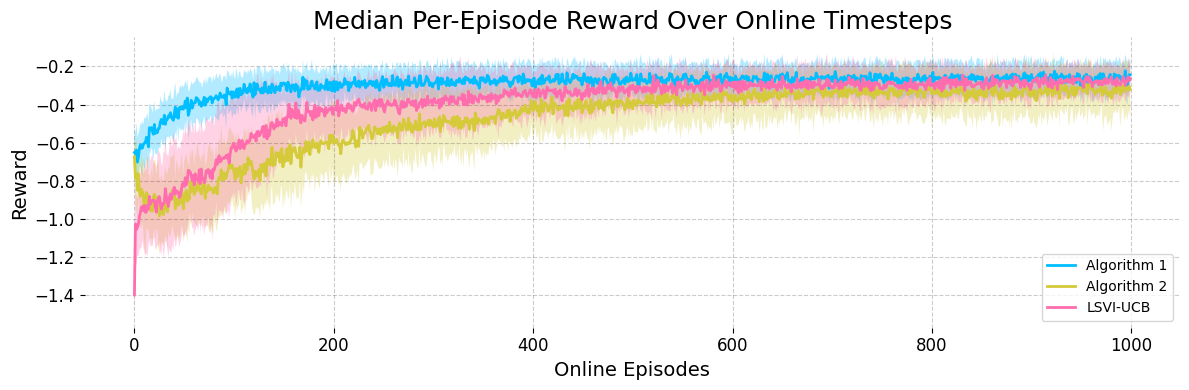

In [86]:
titles = ['Algorithm 1',
          'Algorithm 2',
          'LSVI-UCB']
datasets = [np.mean(rewards_pi_trials, axis=-1)[:,1:],
            np.mean(rewards_ac_trials, axis=-1)[:,1:],
            np.mean(rewards_on_trials, axis=-1)[:,1:]]
plt.figure(figsize=(12,4))
for i, title in enumerate(titles):
    plt.plot(np.mean(datasets[i], axis=0), label=title)
    n = len(datasets[i].mean(0))
    plt.fill_between(np.arange(n),
                     datasets[i].mean(0) - 1*datasets[i].std(0),
                     datasets[i].mean(0) + 1*datasets[i].std(0),
                     alpha=0.3)
plt.legend()

plt.xlabel('Online Episodes')
plt.ylabel('Reward')
plt.title('Median Per-Episode Reward Over Online Timesteps')
plt.tight_layout()
plt.savefig('../hybridlin/figs/reward_ac.png', dpi=300)

In [65]:
np.array(rewards_on_trials).mean(-1).mean(0)[-200:].mean()

-0.27453333333333335

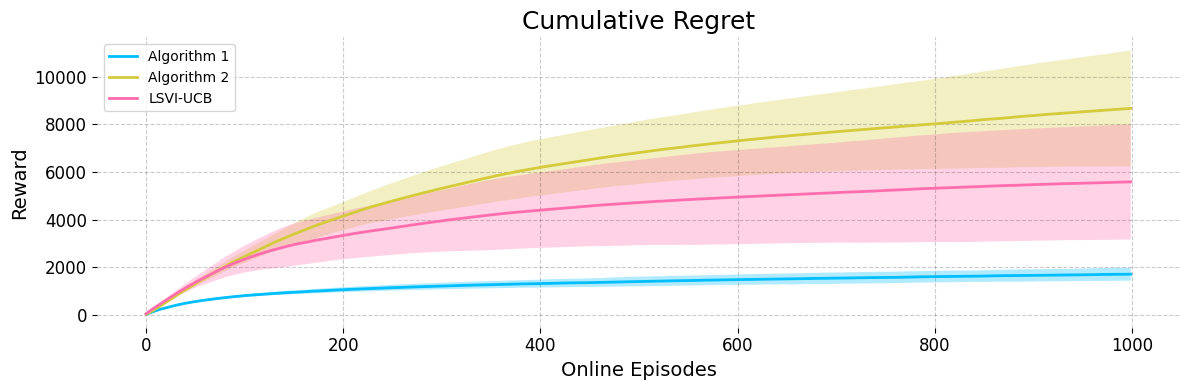

In [97]:
rmax = -0.25
titles = ['Algorithm 1',
          'Algorithm 2',
          'LSVI-UCB']
datasets = [np.cumsum(np.sum(rmax 
                    - np.array(rewards_pi_trials), axis=-1)[:,1:], axis=1),
            np.cumsum(np.sum(rmax 
                    - np.array(rewards_ac_trials), axis=-1)[:,1:], axis=1),
            np.cumsum(np.sum(rmax
                    - np.array(rewards_on_trials), axis=-1)[:,1:], axis=1)]
plt.figure(figsize=(12,4))
for i, title in enumerate(titles):
    plt.plot(np.mean(datasets[i], axis=0), label=title)
    n = len(datasets[i].mean(0))
    plt.fill_between(np.arange(n),
                     datasets[i].mean(0) - 1*datasets[i].std(0),
                     datasets[i].mean(0) + 1*datasets[i].std(0),
                     alpha=0.3)
plt.legend()

plt.xlabel('Online Episodes')
plt.ylabel('Reward')
plt.title('Cumulative Regret')
plt.tight_layout()
plt.savefig('../hybridlin/figs/regret_ac.png', dpi=300)

In [ ]:
class SARSAAgent:
    def __init__(self, seed=None, unif=False, proj=None):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.
        
        self.gamma = 0.9  # Discount factor
        self.learning_rate = 0.01  # Learning rate.
        self.learning_rate_decay = 0.995  # You may decay the learning rate as the training proceeds.
        self.min_learning_rate = 0.001
        self.epsilon = 0.5  # For the epsilon-greedy exploration.
        self.epsilon_decay = 0.98  # You may decay the epsilon as the training proceeds.
        

        # Initial learning rate: 0.01
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.001
        # Initial epsilon for exploration: 0.5
        # Epsilon decay for each episode: 0.98
        if proj is None:
            self.w = np.zeros((640,))  # The weight vector to be learned
            self.d = 640
        else:
            self.w = np.zeros((proj.shape[0],))
            self.d = proj.shape[0]
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        self.unif = unif
        self.proj = proj
        
    def maxQ(self, state_game, state_piece, prec=None, lam=1):
        a_candidates = np.vstack([[a_pos, a_rot] 
                              for a_pos in range(5) for a_rot in range(4)])
        phix = np.vstack([self.phi(state_game, state_piece, a_pos, a_rot) 
                for a_pos in range(5) for a_rot in range(4)])
        # search over actions
        scores = phix @ self.w
        if prec is not None:
            scores += lam*np.sqrt(np.diag(phix @ prec @ phix.T))
        return scores

    def select_action(self, state_game, state_piece, prec=None, lam=1):
        """
        This function returns an action for the agent to take.
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
        Returns:
            action_pos: a_{pos}, the position where the agent will put the next piece down
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down
        """
        
        # Please complete codes for choosing an action given the current state  
        """
        Hint: You may use epsilon-greedy for exploration. 
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi). 
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        if self.unif:
            action_pos = self.rng.choice(5)
            action_rot = self.rng.choice(4)
        else:
            actions = np.argmax(self.maxQ(state_game, state_piece, prec=prec, lam=lam))
            #actions = np.argmax(np.array([self.w.T @ self.phi(state_game, state_piece, a_pos, a_rot) 
            #              for a_pos in range(5) for a_rot in range(4)]))
            action_pos = int(actions/4)
            action_rot = actions % 4
        ### END SOLUTION
        return action_pos, action_rot
    
    def train(self, pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
              cur_state_game, cur_state_piece, cur_action_pos, cur_action_rot, done):
        """
        This function is used for the update of the Q table
        Args:
            - pre_state_game: the state of the game area in the previous step
            - pre_state_piece: the state of the next piece in the previous step
            - pre_action_pos: the position where the agent puts the next piece down in the previous step
            - pre_action_rot: clockwise rotation of the piece before putting the piece down in the previous step
            - pre_reward: the reward received in the previous step.
            - cur_state_game: the state of the game area in the current step
            - cur_state_piece: the state of the next piece in the current step
            - cur_action_pos: the position where the agent puts the next piece down in the current step
            - cur_action_rot: clockwise rotation of the piece before putting the piece down in the current step
            - `done=0` means that the current episode does not terminate;
              `done=1` means that the current episode terminates.
              We set the length of each episode to be 100.
        """
        
        # Please complete codes for updating the weight vector self.theta
        """
        Hint: You may use the feature function self.phi
              You may use the discount factor self.gamma (=0.9)
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE 
        phi_pre = self.phi(pre_state_game, pre_state_piece, 
                                        pre_action_pos, pre_action_rot)
        phi_cur = self.phi(cur_state_game, cur_state_piece, 
                                            cur_action_pos, cur_action_rot)
        dkw = (pre_reward + 
                self.gamma*(self.w.T @ phi_cur) -
                self.w.T @ phi_pre)
        self.w = self.w + self.learning_rate * dkw * phi_pre
        
        ### END SOLUTION
        
        if done != 0:
            self.learning_rate = self.learning_rate * self.learning_rate_decay
            if self.learning_rate < self.min_learning_rate:
                self.learning_rate = self.min_learning_rate
            self.epsilon = self.epsilon * self.epsilon_decay
    
    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        Args:
            - p: the piece
            - action_rot: clockwise rotation of the piece. 
                          action_rot = 0, 1, 2, or 3.
                          0 means no rotation.
        Returns:
            - a new piece after the rotation
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + (
                1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot = action_rot - 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p
    
    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a)
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
        Returns:
            feature_vec: feature vector
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec
        
        # Try projecting this feature map down to the 0-60th eigenvectors of prec or somethin
        if self.proj is not None:
            feature_vec = self.proj @ feature_vec

        return feature_vec


agent = SARSAAgent(seed=0, unif=False, proj=proj)
num_ep = 1000

rewards_sarsa = []

for ep in tqdm(range(num_ep)):
    state_game, state_piece = env.reset()
    pre_state_game = None
    pre_state_piece = None
    pre_action_pos = None
    pre_action_rot = None
    pre_reward = None
    reward_sarsa = []
    for step in range(H):
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        
        next_state_game, next_state_piece, reward = env.step(action_pos, action_rot)

        if 1 <= step < H:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 0)
        elif step == H:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 1)

        pre_state_game = state_game
        pre_state_piece = state_piece
        pre_action_pos = action_pos
        pre_action_rot = action_rot
        pre_reward = reward
        state_game = next_state_game
        state_piece = next_state_piece
        reward_sarsa.append(reward)
    rewards_sarsa.append(reward_sarsa)



In [ ]:
plt.plot(pd.Series(np.array(rewards_sarsa).mean(-1)).rolling(40).mean())
# no projection

In [ ]:
plt.plot(pd.Series(np.array(rewards_sarsa).mean(-1)).rolling(40).mean())
# projection